In [1]:
!pip install openbox
!pip install shapely
!pip install plotly
!pip install torch

In [2]:
class Data:
    def __init__(self, sensorPositions, space, epsilon):
        self.radius = 1
        self.placeHolders = sensorPositions
        self.epsilon = epsilon
        self.space = space
        # self.SensorPlaceHolderSetup()
        
    def frange(self, start, stop, step):
        steps = []
        while start <= stop:
            steps.append(start)
            start +=step
            
        return steps

    # def SensorPlaceHolderSetup(self):
    #     Xs = self.frange(0, self.space[0], self.epsilon)
    #     Ys = self.frange(0, self.space[1], self.epsilon)
            
    #     for x in Xs:
    #       for y in Ys:
    #         self.placeHolders.append([x, y])

    def GetSensorConfiguration(self):
        from collections import Counter
        sensorLocations, sensorTypes = self.GetSensorLocations()

        summaryDict = Counter(sensorTypes)

        # TODO: DIFFERENT SENSOR TYPE DEFINITIONS SHOULD BE ADDED HERE:
        configurationSummary = []
        for key in summaryDict:
            if (key == 1):
                configurationSummary.append(['motion sensors', summaryDict[key]])

            elif (key == 2):
                configurationSummary.append(['beacon sensors', summaryDict[key]])

        configurationDetails = []
        for index, loc in enumerate(sensorLocations):
            if (sensorTypes[index] == 1):
                configurationDetails.append(tuple([loc, 'kitchen', 'motion sensors']))

            elif (sensorTypes[index] == 2):
                configurationDetails.append(tuple([loc, 'kitchen', 'beacon sensors']))

        return [[configurationSummary, [tuple(configurationDetails)]], self.radius]


    def GetSensorLocations(self):
        sensorLocations = []
        sensorTypes = []
        for index, sensorIndicator in enumerate(self.placeHolders):
            sensorLocations.append(self.placeHolders[index])

            # TODO: DIFFERENT SENSOR TYPE DEFINITIONS SHOULD BE ADDED HERE:
            sensorTypes.append(1)


        return sensorLocations, sensorTypes


class BOVariables:
    def __init__(self, Data_path, epsilon, initSensorNum, maxSensorNum, radius, sampleSize):
        self.epsilon = epsilon
        self.Data_path = Data_path
        self.initSensorNum = initSensorNum
        self.maxSensorNum = maxSensorNum
        self.radius = radius
        self.sensor_distribution, self.types, self.space, self.rooms, self.agentTraces = self.ModelsInitializations()

    def ModelsInitializations(self):
        #----- Space and agent models -----: 
        simworldname = self.Data_path + '/Configuration Files/simulationWorld2.xml'
        agentTraces = []
        directory = os.fsencode(self.Data_path + 'Agent Trace Files/')
            
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.endswith(".csv"): 
                agentTraces.append(self.Data_path + 'Agent Trace Files/' + filename)

        # Parsing the space model: 
        space, rooms = pf.ParseWorld(simworldname)

        xs = []
        for i in space:
          for j in i:
            xs.append(j)
        A = list(set(xs))
        A.sort()
        space = [A[-1], A[-2]]

        # User parameters 
        types, sensor_distribution = pf.GetUsersParameters()

        roomsList = []
        for room in sensor_distribution:
            roomsList.append(room)
              
        return sensor_distribution, types, space, rooms, agentTraces


def frange(start, stop, step):
    steps = []
    while start <= stop:
        steps.append(start)
        start +=step
        
    return steps

def MakeSensorCombinations(start, end, epsilon, sensorType, room):
    a1, b1 = makeBoundaries(epsilon, start[0], end[0])
    a2, b2 = makeBoundaries(epsilon, start[1], end[1])    
    Xs = frange(a1, b1, epsilon)
    Ys = frange(a2, b2, epsilon)
    
    points = list(itertools.product(list(itertools.product(Xs, Ys)), [room], [sensorType[0]])) 
    C = itertools.combinations(points, distribution[room][types.index(sensorType)])

    return C

def PreProcessor(df):
    # df['motion sensors'] = df['motion sensors'].apply(ast.literal_eval)
    df['motion sensors'] = df['motion sensors'].apply(lambda s: list(map(int, s)))
    # df['beacon sensors'] = df['beacon sensors'].apply(ast.literal_eval)
    try:
      df['beacon sensors'] = df['beacon sensors'].apply(lambda s: list(map(int, s)))
    except:
      pass

    sensors = set([])

    previous_M = None
    previous_B = None
    output_file = []

    for index, row in df.iterrows():
      T = row['time']
      M = row['motion sensors']
      try:
        B = row['beacon sensors']
      except:
        pass

      Activity = row['activity']
      Activity = Activity.replace(' ', '_')
      MotionSensor_Names = []
      sensorNames = []
      MotionSensor_Message = []
      BeaconSensor_Names = []
      BeaconSensor_Message = []
      

      # time = convertTime(T)
      time = "2020-06-16 " + T + ".00"

      # Motion Sensor
      for i in range(len(M)):
        sensorNames.append(Name(i, 'M'))
        if M[i] == 1:
          if (previous_M != None):
            if (previous_M[i] == 0):
              MotionSensor_Names.append(Name(i,'M'))
              MotionSensor_Message.append('ON')

          else:
            MotionSensor_Names.append(Name(i,'M'))
            MotionSensor_Message.append('ON')

        if previous_M != None:
          if M[i] == 0 and previous_M[i] == 1:
            MotionSensor_Names.append(Name(i,'M'))
            MotionSensor_Message.append('OFF')

      previous_M = M
      # Beacon Sensor

      try:
        for i in range(len(B)):
          sensorNames.append(Name(i, 'B'))
          if B[i] == 1:
            BeaconSensor_Names.append(Name(i,'B'))
            BeaconSensor_Message.append('ON')
          if previous_B != None:
            if B[i] == 0 and previous_B[i] == 1: 
              BeaconSensor_Names.append(Name(i,'B'))
              BeaconSensor_Message.append('OFF')
        previous_B = B

      except:
        pass

      for m in range(len(MotionSensor_Names)):
        output_file.append(time +' '+ MotionSensor_Names[m] + ' ' + MotionSensor_Names[m] + ' ' + MotionSensor_Message[m] + ' ' + Activity)
        
      for s in sensorNames:
          sensors.add(s)

    return output_file, list(sensors)

#returns the name of the sensor
def Name(number, typeSensor):
    if number < 10:
      return typeSensor + str(0) + str(number)
    else:
      return typeSensor + str(number)

#converts epoch time to human readable
def convertTime(posix_timestamp):
    tz = pytz.timezone('MST')
    dt = datetime.fromtimestamp(posix_timestamp, tz)
    time = dt.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
    return time

def MakeDataBoundaries(height = 10.5, width = 6.6, MaxSensors = 15):
    from collections import defaultdict, OrderedDict

    d = dict()

    for idx in range(MaxSensors):
            d['x' + str(idx)] = (0.5, width - 0.5)
            d['y' + str(idx)] = (0.5, height - 0.5)

    return d

def black_box_function(sample, simulateMotionSensors = True, simulateEstimotes = False, Plotting = False):       
    files = []

    if (runningOnGoogleColab == True):
        sys.path.append('gdrive/My Drive/PhD/Thesis/Ideas/Codes/Sensor Simulator/')
        Data_path = 'gdrive/My Drive/PhD/Thesis/Ideas/Codes/Sensor Simulator/'
        
    else:
        sys.path.append('../../Codes/Sensor Simulator/')
        Data_path = '../../Codes/Sensor Simulator/'

    all_sensors = set([])

    for agentTrace in BOV.agentTraces:
        df_ = sim_sis.RunSimulator(BOV.space, BOV.rooms, agentTrace, sample.GetSensorConfiguration(), simulateMotionSensors, simulateEstimotes, Plotting, BOV.Data_path)
        dataFile, sensors = PreProcessor(df_)
        all_sensors.update(sensors)
        files.append(dataFile)
        
    
    if (runningOnGoogleColab == True):
        sys.path.append('gdrive/My Drive/PhD/Thesis/Ideas/Codes/CASAS/AL-Smarthome')

    else:
        sys.path.append('../../Codes/CASAS/AL-Smarthome')

    import al
    import imp
    imp.reload(al)
    all_sensors = list(all_sensors)

    accuracy = (al.leave_one_out(files, all_sensors)[0]) * 100

    if accuracy < 0:
        accuracy = 0

    return 100 - accuracy

def function_to_be_optimized(config):
    sensorPositions = []
    sensor_xy = []
    for i in range(1, 16):
      # print(config['x' + str(i)])
      # print(config['y' + str(i)])
      
      sensor_xy.append(config['x' + str(i)])
      sensor_xy.append(config['y' + str(i)])
      sensorPositions.append(sensor_xy)
      sensor_xy = []

    data = Data(sensorPositions, BOV.space, CONSTANTS['epsilon'])
    return black_box_function(data)

In [3]:
CONSTANTS = {
    'iterations': 100,
    'initial_samples': 10,
    'restarts_number': 10,
    'raw_samples': 10,
    'candidates_num': 1,
    'sequential': True,
    'epsilon': 1,
    'radius': 1,
    'height': 10.5,
    'width': 6.6,
    'max_sensors': 15  
}

runningOnGoogleColab = False
    
if __name__ ==  '__main__':
    import sys

    if (runningOnGoogleColab == True):
        from google.colab import drive    
        drive.mount('/content/gdrive', force_remount=True)
        Data_path = 'gdrive/My Drive/PhD/Thesis/Ideas/Codes/Sensor Simulator/'
        sys.path.append('gdrive/My Drive/PhD/Thesis/Ideas/Codes/Sensor Simulator/')
        
    else:
        Data_path = '../../Codes/Sensor Simulator/'
        sys.path.append('../../Codes/Sensor Simulator/')

    # from ax import optimize, ChoiceParameter
    from scipy.stats import norm
    from numpy import argmax
    import SIM_SIS_Libraries.SensorsClass
    import SIM_SIS_Libraries.SIM_SIS_Simulator as sim_sis
    import SIM_SIS_Libraries.ParseFunctions as pf
    import itertools
    import numpy as np
    import pandas as pd
    import SIM_SIS_Libraries.PreDeploymentEvaluation as pde
    import copy
    from datetime import datetime
    import pytz
    import ast
    import os
    import random
    import plotly
    import torch

    finalResults = []
    w = CONSTANTS['width'] - 0.5
    h = CONSTANTS['height'] - 0.5

    dataBoundaries = MakeDataBoundaries(
                                        height = CONSTANTS['height'], 
                                        width = CONSTANTS['width'], 
                                        MaxSensors = CONSTANTS['max_sensors']
                                       )

    BOV =  BOVariables(
                       Data_path, 
                       CONSTANTS['epsilon'], 
                       CONSTANTS['max_sensors'], 
                       CONSTANTS['max_sensors'], 
                       CONSTANTS['radius'],
                       CONSTANTS['initial_samples']
                      )

    from openbox import sp
    

    # Define Search Space
    space = sp.Space()

    list_of_variables = []
    for i in range(1, 16):
        x = sp.Int("x" + str(i), 0, 6, default_value=0)
        y = sp.Int("y" + str(i), 0, 10, default_value=0)
        list_of_variables.append(x)
        list_of_variables.append(y)
    
    space.add_variables(list_of_variables)

    from openbox import Optimizer

    history_list = []
    for _ in range(10):
        opt = Optimizer(
            function_to_be_optimized,
            space,
            max_runs=1000,
            surrogate_type='prf',
            acq_optimizer_type='random_scipy',
            time_limit_per_trial=31000,
            task_id='Shadan',
        )
        history = opt.run()
        history_list.append(history)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

[Build Surrogate] Use probabilistic random forest based on scikit-learn. For better performance, please install pyrfr: https://open-box.readthedocs.io/en/latest/installation/install_pyrfr.html
[INFO] [2021-11-06 00:12:19,815] [OpenBox-Shadan] Iteration 1, objective value: [100.0].


  0%|                                                                               | 1/1000 [00:17<4:46:22, 17.20s/it]

[INFO] [2021-11-06 00:12:48,200] [OpenBox-Shadan] Iteration 2, objective value: [32.38742763031452].


  0%|▏                                                                              | 2/1000 [00:45<6:35:31, 23.78s/it]

[INFO] [2021-11-06 00:13:19,304] [OpenBox-Shadan] Iteration 3, objective value: [36.66018111117722].


  0%|▏                                                                              | 3/1000 [01:16<7:30:42, 27.12s/it]

[INFO] [2021-11-06 00:13:50,119] [OpenBox-Shadan] Iteration 4, objective value: [34.44856285414748].


  0%|▎                                                                              | 4/1000 [01:47<7:54:27, 28.58s/it]

[INFO] [2021-11-06 00:14:17,244] [OpenBox-Shadan] Iteration 5, objective value: [40.3847720586081].


  0%|▍                                                                              | 5/1000 [02:14<7:45:15, 28.06s/it]

[INFO] [2021-11-06 00:14:47,812] [OpenBox-Shadan] Iteration 6, objective value: [33.93828399517923].


  1%|▍                                                                              | 6/1000 [02:45<7:58:56, 28.91s/it]

[INFO] [2021-11-06 00:15:16,004] [OpenBox-Shadan] Iteration 7, objective value: [30.54867720165045].


  1%|▌                                                                              | 7/1000 [03:13<7:54:34, 28.68s/it]

[INFO] [2021-11-06 00:15:50,008] [OpenBox-Shadan] Iteration 8, objective value: [33.75198128737122].


  1%|▋                                                                              | 8/1000 [03:47<8:22:08, 30.37s/it]

[INFO] [2021-11-06 00:16:29,155] [OpenBox-Shadan] Iteration 9, objective value: [32.96816718726248].


  1%|▋                                                                              | 9/1000 [04:26<9:06:57, 33.12s/it]

[INFO] [2021-11-06 00:17:06,700] [OpenBox-Shadan] Iteration 10, objective value: [33.49759585299189].


  1%|▊                                                                             | 10/1000 [05:04<9:28:58, 34.48s/it]

[INFO] [2021-11-06 00:17:41,513] [OpenBox-Shadan] Iteration 11, objective value: [35.96725280980462].


  1%|▊                                                                             | 11/1000 [05:38<9:30:03, 34.58s/it]

[INFO] [2021-11-06 00:18:14,205] [OpenBox-Shadan] Iteration 12, objective value: [35.68340429686134].


  1%|▉                                                                             | 12/1000 [06:11<9:20:00, 34.01s/it]

[INFO] [2021-11-06 00:18:46,913] [OpenBox-Shadan] Iteration 13, objective value: [35.26792499726051].


  1%|█                                                                             | 13/1000 [06:44<9:12:57, 33.61s/it]

[INFO] [2021-11-06 00:19:16,313] [OpenBox-Shadan] Iteration 14, objective value: [33.523029402571495].


  1%|█                                                                             | 14/1000 [07:13<8:51:28, 32.34s/it]

[INFO] [2021-11-06 00:19:50,212] [OpenBox-Shadan] Iteration 15, objective value: [37.14354304731715].


  2%|█▏                                                                            | 15/1000 [07:47<8:58:38, 32.81s/it]

[INFO] [2021-11-06 00:20:19,845] [OpenBox-Shadan] Iteration 16, objective value: [40.86133945756497].


  2%|█▏                                                                            | 16/1000 [08:17<8:42:24, 31.85s/it]

[INFO] [2021-11-06 00:20:53,905] [OpenBox-Shadan] Iteration 17, objective value: [34.524881973176164].


  2%|█▎                                                                            | 17/1000 [08:51<8:52:44, 32.52s/it]

[INFO] [2021-11-06 00:21:27,424] [OpenBox-Shadan] Iteration 18, objective value: [36.10294252132028].


  2%|█▍                                                                            | 18/1000 [09:24<8:57:07, 32.82s/it]

[INFO] [2021-11-06 00:22:03,553] [OpenBox-Shadan] Iteration 19, objective value: [37.64166148038907].


  2%|█▍                                                                            | 19/1000 [10:00<9:12:50, 33.81s/it]

[INFO] [2021-11-06 00:22:43,051] [OpenBox-Shadan] Iteration 20, objective value: [32.095612341234954].


  2%|█▌                                                                            | 20/1000 [10:40<9:40:09, 35.52s/it]

[INFO] [2021-11-06 00:23:13,816] [OpenBox-Shadan] Iteration 21, objective value: [39.40489680254563].


  2%|█▋                                                                            | 21/1000 [11:11<9:16:16, 34.09s/it]

[INFO] [2021-11-06 00:23:48,138] [OpenBox-Shadan] Iteration 22, objective value: [32.69002963186463].


  2%|█▋                                                                            | 22/1000 [11:45<9:16:49, 34.16s/it]

[INFO] [2021-11-06 00:24:19,825] [OpenBox-Shadan] Iteration 23, objective value: [36.205307910919075].


  2%|█▊                                                                            | 23/1000 [12:17<9:04:10, 33.42s/it]

[INFO] [2021-11-06 00:24:54,431] [OpenBox-Shadan] Iteration 24, objective value: [31.213188827184908].


  2%|█▊                                                                            | 24/1000 [12:51<9:09:24, 33.78s/it]

[INFO] [2021-11-06 00:25:28,348] [OpenBox-Shadan] Iteration 25, objective value: [31.898826979114375].


  2%|█▉                                                                            | 25/1000 [13:25<9:09:31, 33.82s/it]

[INFO] [2021-11-06 00:25:57,609] [OpenBox-Shadan] Iteration 26, objective value: [33.83182508431004].


  3%|██                                                                            | 26/1000 [13:54<8:46:46, 32.45s/it]

[INFO] [2021-11-06 00:26:29,121] [OpenBox-Shadan] Iteration 27, objective value: [33.268489879821246].


  3%|██                                                                            | 27/1000 [14:26<8:41:40, 32.17s/it]

[INFO] [2021-11-06 00:27:01,470] [OpenBox-Shadan] Iteration 28, objective value: [36.34712542936007].


  3%|██▏                                                                           | 28/1000 [14:58<8:42:00, 32.22s/it]

[INFO] [2021-11-06 00:27:41,522] [OpenBox-Shadan] Iteration 29, objective value: [34.370206084618786].


  3%|██▎                                                                           | 29/1000 [15:38<9:19:29, 34.57s/it]

[INFO] [2021-11-06 00:28:10,530] [OpenBox-Shadan] Iteration 30, objective value: [36.157552840102134].


  3%|██▎                                                                           | 30/1000 [16:07<8:51:55, 32.90s/it]

[INFO] [2021-11-06 00:28:49,248] [OpenBox-Shadan] Iteration 31, objective value: [28.568151382999602].


  3%|██▍                                                                           | 31/1000 [16:46<9:19:33, 34.65s/it]

[INFO] [2021-11-06 00:29:24,878] [OpenBox-Shadan] Iteration 32, objective value: [38.70852893237806].


  3%|██▍                                                                           | 32/1000 [17:22<9:23:43, 34.94s/it]

[INFO] [2021-11-06 00:29:53,259] [OpenBox-Shadan] Iteration 33, objective value: [36.02249933732967].


  3%|██▌                                                                           | 33/1000 [17:50<8:51:25, 32.97s/it]

[INFO] [2021-11-06 00:30:29,022] [OpenBox-Shadan] Iteration 34, objective value: [32.72252022843209].


  3%|██▋                                                                           | 34/1000 [18:26<9:04:21, 33.81s/it]

[INFO] [2021-11-06 00:30:58,487] [OpenBox-Shadan] Iteration 35, objective value: [40.883300239221995].


  4%|██▋                                                                           | 35/1000 [18:55<8:42:49, 32.51s/it]

[INFO] [2021-11-06 00:31:36,456] [OpenBox-Shadan] Iteration 36, objective value: [31.5631107119801].


  4%|██▊                                                                           | 36/1000 [19:33<9:08:36, 34.15s/it]

[INFO] [2021-11-06 00:32:05,184] [OpenBox-Shadan] Iteration 37, objective value: [37.441893112396365].


  4%|██▉                                                                           | 37/1000 [20:02<8:41:57, 32.52s/it]

[INFO] [2021-11-06 00:32:38,895] [OpenBox-Shadan] Iteration 38, objective value: [36.739542988130815].


  4%|██▉                                                                           | 38/1000 [20:36<8:47:07, 32.88s/it]

[INFO] [2021-11-06 00:33:13,426] [OpenBox-Shadan] Iteration 39, objective value: [35.36625049803665].


  4%|███                                                                           | 39/1000 [21:10<8:54:31, 33.37s/it]

[INFO] [2021-11-06 00:33:51,948] [OpenBox-Shadan] Iteration 40, objective value: [29.207798737743374].


  4%|███                                                                           | 40/1000 [21:49<9:18:41, 34.92s/it]

[INFO] [2021-11-06 00:34:25,898] [OpenBox-Shadan] Iteration 41, objective value: [31.257610446597113].


  4%|███▏                                                                          | 41/1000 [22:23<9:13:27, 34.63s/it]

[INFO] [2021-11-06 00:35:03,209] [OpenBox-Shadan] Iteration 42, objective value: [34.9411654570241].


  4%|███▎                                                                          | 42/1000 [23:00<9:25:44, 35.43s/it]

[INFO] [2021-11-06 00:35:37,431] [OpenBox-Shadan] Iteration 43, objective value: [36.58392763182192].


  4%|███▎                                                                          | 43/1000 [23:34<9:19:21, 35.07s/it]

[INFO] [2021-11-06 00:36:14,057] [OpenBox-Shadan] Iteration 44, objective value: [34.07879836858281].


  4%|███▍                                                                          | 44/1000 [24:11<9:26:12, 35.54s/it]

[INFO] [2021-11-06 00:36:45,883] [OpenBox-Shadan] Iteration 45, objective value: [34.72347354432405].


  4%|███▌                                                                          | 45/1000 [24:43<9:07:54, 34.42s/it]

[INFO] [2021-11-06 00:37:20,551] [OpenBox-Shadan] Iteration 46, objective value: [34.7248616138222].


  5%|███▌                                                                          | 46/1000 [25:17<9:08:29, 34.50s/it]

[INFO] [2021-11-06 00:37:53,856] [OpenBox-Shadan] Iteration 47, objective value: [32.94883899874421].


  5%|███▋                                                                          | 47/1000 [25:51<9:02:14, 34.14s/it]

[INFO] [2021-11-06 00:38:26,638] [OpenBox-Shadan] Iteration 48, objective value: [35.009360885663966].


  5%|███▋                                                                          | 48/1000 [26:24<8:55:13, 33.73s/it]

[INFO] [2021-11-06 00:39:02,735] [OpenBox-Shadan] Iteration 49, objective value: [33.33825032411542].


  5%|███▊                                                                          | 49/1000 [27:00<9:05:53, 34.44s/it]

[INFO] [2021-11-06 00:39:35,459] [OpenBox-Shadan] Iteration 50, objective value: [32.81505507312821].


  5%|███▉                                                                          | 50/1000 [27:32<8:57:10, 33.93s/it]

[INFO] [2021-11-06 00:40:10,773] [OpenBox-Shadan] Iteration 51, objective value: [31.726235966981804].


  5%|███▉                                                                          | 51/1000 [28:08<9:03:11, 34.34s/it]

[INFO] [2021-11-06 00:40:46,790] [OpenBox-Shadan] Iteration 52, objective value: [33.3979719391898].


  5%|████                                                                          | 52/1000 [28:44<9:10:33, 34.84s/it]

[INFO] [2021-11-06 00:41:21,801] [OpenBox-Shadan] Iteration 53, objective value: [32.94269934893606].


  5%|████▏                                                                         | 53/1000 [29:19<9:10:45, 34.89s/it]

[INFO] [2021-11-06 00:41:53,338] [OpenBox-Shadan] Iteration 54, objective value: [36.35626178715091].


  5%|████▏                                                                         | 54/1000 [29:50<8:54:17, 33.89s/it]

[INFO] [2021-11-06 00:42:27,029] [OpenBox-Shadan] Iteration 55, objective value: [25.29114238579251].


  6%|████▎                                                                         | 55/1000 [30:24<8:52:47, 33.83s/it]

[INFO] [2021-11-06 00:42:58,252] [OpenBox-Shadan] Iteration 56, objective value: [36.37956854376432].


  6%|████▎                                                                         | 56/1000 [30:55<8:39:56, 33.05s/it]

[INFO] [2021-11-06 00:43:30,650] [OpenBox-Shadan] Iteration 57, objective value: [32.13104737121503].


  6%|████▍                                                                         | 57/1000 [31:28<8:36:19, 32.85s/it]

[INFO] [2021-11-06 00:44:00,773] [OpenBox-Shadan] Iteration 58, objective value: [34.81411703776216].


  6%|████▌                                                                         | 58/1000 [31:58<8:22:55, 32.03s/it]

[INFO] [2021-11-06 00:44:33,722] [OpenBox-Shadan] Iteration 59, objective value: [31.395440348104927].


  6%|████▌                                                                         | 59/1000 [32:31<8:26:42, 32.31s/it]

[INFO] [2021-11-06 00:45:02,911] [OpenBox-Shadan] Iteration 60, objective value: [35.848918188548126].


  6%|████▋                                                                         | 60/1000 [33:00<8:11:29, 31.37s/it]

[INFO] [2021-11-06 00:45:39,140] [OpenBox-Shadan] Iteration 61, objective value: [34.93145749341913].


  6%|████▊                                                                         | 61/1000 [33:36<8:33:46, 32.83s/it]

[INFO] [2021-11-06 00:46:16,121] [OpenBox-Shadan] Iteration 62, objective value: [32.27153599567086].


  6%|████▊                                                                         | 62/1000 [34:13<8:52:42, 34.08s/it]

[INFO] [2021-11-06 00:46:47,454] [OpenBox-Shadan] Iteration 63, objective value: [32.62214895421714].


  6%|████▉                                                                         | 63/1000 [34:44<8:39:17, 33.25s/it]

[INFO] [2021-11-06 00:47:17,254] [OpenBox-Shadan] Iteration 64, objective value: [33.69299573501627].


  6%|████▉                                                                         | 64/1000 [35:14<8:22:34, 32.22s/it]

[INFO] [2021-11-06 00:47:50,576] [OpenBox-Shadan] Iteration 65, objective value: [32.76835709086137].


  6%|█████                                                                         | 65/1000 [35:47<8:27:12, 32.55s/it]

[INFO] [2021-11-06 00:48:23,544] [OpenBox-Shadan] Iteration 66, objective value: [31.85094628304681].


  7%|█████▏                                                                        | 66/1000 [36:20<8:28:37, 32.67s/it]

[INFO] [2021-11-06 00:48:56,344] [OpenBox-Shadan] Iteration 67, objective value: [36.923224839568135].


  7%|█████▏                                                                        | 67/1000 [36:53<8:28:39, 32.71s/it]

[INFO] [2021-11-06 00:49:31,715] [OpenBox-Shadan] Iteration 68, objective value: [37.51790317261706].


  7%|█████▎                                                                        | 68/1000 [37:29<8:40:31, 33.51s/it]

[INFO] [2021-11-06 00:50:05,099] [OpenBox-Shadan] Iteration 69, objective value: [36.81281547656866].


  7%|█████▍                                                                        | 69/1000 [38:02<8:39:22, 33.47s/it]

[INFO] [2021-11-06 00:50:35,170] [OpenBox-Shadan] Iteration 70, objective value: [36.78274189484544].


  7%|█████▍                                                                        | 70/1000 [38:32<8:23:00, 32.45s/it]

[INFO] [2021-11-06 00:51:07,912] [OpenBox-Shadan] Iteration 71, objective value: [34.76055990591075].


  7%|█████▌                                                                        | 71/1000 [39:05<8:23:48, 32.54s/it]

[INFO] [2021-11-06 00:51:40,481] [OpenBox-Shadan] Iteration 72, objective value: [25.307226210017603].


  7%|█████▌                                                                        | 72/1000 [39:37<8:23:24, 32.55s/it]

[INFO] [2021-11-06 00:52:15,454] [OpenBox-Shadan] Iteration 73, objective value: [34.57005405165356].


  7%|█████▋                                                                        | 73/1000 [40:12<8:34:06, 33.28s/it]

[INFO] [2021-11-06 00:52:50,008] [OpenBox-Shadan] Iteration 74, objective value: [30.328444659596002].


  7%|█████▊                                                                        | 74/1000 [40:47<8:39:28, 33.66s/it]

[INFO] [2021-11-06 00:53:24,717] [OpenBox-Shadan] Iteration 75, objective value: [33.33632302927508].


  8%|█████▊                                                                        | 75/1000 [41:22<8:43:46, 33.97s/it]

[INFO] [2021-11-06 00:53:59,836] [OpenBox-Shadan] Iteration 76, objective value: [33.17686810792276].


  8%|█████▉                                                                        | 76/1000 [41:57<8:48:29, 34.32s/it]

[INFO] [2021-11-06 00:54:33,952] [OpenBox-Shadan] Iteration 77, objective value: [33.50973909531669].


  8%|██████                                                                        | 77/1000 [42:31<8:46:59, 34.26s/it]

[INFO] [2021-11-06 00:55:06,781] [OpenBox-Shadan] Iteration 78, objective value: [35.65147949407195].


  8%|██████                                                                        | 78/1000 [43:04<8:39:50, 33.83s/it]

[INFO] [2021-11-06 00:55:39,193] [OpenBox-Shadan] Iteration 79, objective value: [37.745455901880945].


  8%|██████▏                                                                       | 79/1000 [43:36<8:32:44, 33.40s/it]

[INFO] [2021-11-06 00:56:11,703] [OpenBox-Shadan] Iteration 80, objective value: [37.33285278127945].


  8%|██████▏                                                                       | 80/1000 [44:09<8:28:04, 33.14s/it]

[INFO] [2021-11-06 00:56:46,060] [OpenBox-Shadan] Iteration 81, objective value: [35.64727828164189].


  8%|██████▎                                                                       | 81/1000 [44:43<8:33:08, 33.50s/it]

[INFO] [2021-11-06 00:57:15,471] [OpenBox-Shadan] Iteration 82, objective value: [32.68559605440845].


  8%|██████▍                                                                       | 82/1000 [45:12<8:13:47, 32.27s/it]

[INFO] [2021-11-06 00:57:46,917] [OpenBox-Shadan] Iteration 83, objective value: [30.814903852448893].


  8%|██████▍                                                                       | 83/1000 [45:44<8:09:27, 32.03s/it]

[INFO] [2021-11-06 00:58:16,168] [OpenBox-Shadan] Iteration 84, objective value: [34.45807295560209].


  8%|██████▌                                                                       | 84/1000 [46:13<7:56:13, 31.19s/it]

[INFO] [2021-11-06 00:58:49,894] [OpenBox-Shadan] Iteration 85, objective value: [30.609622470794775].


  8%|██████▋                                                                       | 85/1000 [46:47<8:07:17, 31.95s/it]

[INFO] [2021-11-06 00:59:18,436] [OpenBox-Shadan] Iteration 86, objective value: [29.793794415349566].


  9%|██████▋                                                                       | 86/1000 [47:15<7:51:09, 30.93s/it]

[INFO] [2021-11-06 00:59:51,193] [OpenBox-Shadan] Iteration 87, objective value: [32.639652407380154].


  9%|██████▊                                                                       | 87/1000 [47:48<7:58:59, 31.48s/it]

[INFO] [2021-11-06 01:00:19,622] [OpenBox-Shadan] Iteration 88, objective value: [33.22458011372137].


  9%|██████▊                                                                       | 88/1000 [48:17<7:44:33, 30.56s/it]

[INFO] [2021-11-06 01:00:52,830] [OpenBox-Shadan] Iteration 89, objective value: [34.11354877479215].


  9%|██████▉                                                                       | 89/1000 [48:50<7:56:05, 31.36s/it]

[INFO] [2021-11-06 01:01:26,013] [OpenBox-Shadan] Iteration 90, objective value: [32.10085497477199].


  9%|███████                                                                       | 90/1000 [49:23<8:03:53, 31.90s/it]

[INFO] [2021-11-06 01:01:58,783] [OpenBox-Shadan] Iteration 91, objective value: [29.947939632642743].


  9%|███████                                                                       | 91/1000 [49:56<8:07:16, 32.16s/it]

[INFO] [2021-11-06 01:02:32,971] [OpenBox-Shadan] Iteration 92, objective value: [34.508170183077425].


  9%|███████▏                                                                      | 92/1000 [50:30<8:15:56, 32.77s/it]

[INFO] [2021-11-06 01:03:03,952] [OpenBox-Shadan] Iteration 93, objective value: [31.611467110091922].


  9%|███████▎                                                                      | 93/1000 [51:01<8:07:16, 32.23s/it]

[INFO] [2021-11-06 01:03:36,782] [OpenBox-Shadan] Iteration 94, objective value: [30.395242039014178].


  9%|███████▎                                                                      | 94/1000 [51:34<8:09:26, 32.41s/it]

[INFO] [2021-11-06 01:04:06,554] [OpenBox-Shadan] Iteration 95, objective value: [33.234218470363274].


 10%|███████▍                                                                      | 95/1000 [52:03<7:56:56, 31.62s/it]

[INFO] [2021-11-06 01:04:37,837] [OpenBox-Shadan] Iteration 96, objective value: [38.53401946167392].


 10%|███████▍                                                                      | 96/1000 [52:35<7:54:53, 31.52s/it]

[INFO] [2021-11-06 01:05:08,719] [OpenBox-Shadan] Iteration 97, objective value: [37.89041847870849].


 10%|███████▌                                                                      | 97/1000 [53:06<7:51:29, 31.33s/it]

[INFO] [2021-11-06 01:05:42,998] [OpenBox-Shadan] Iteration 98, objective value: [28.50001972303488].


 10%|███████▋                                                                      | 98/1000 [53:40<8:04:16, 32.21s/it]

[INFO] [2021-11-06 01:06:19,949] [OpenBox-Shadan] Iteration 99, objective value: [33.37737845236974].


 10%|███████▋                                                                      | 99/1000 [54:17<8:25:05, 33.63s/it]

[INFO] [2021-11-06 01:06:53,608] [OpenBox-Shadan] Iteration 100, objective value: [37.91155703298021].


 10%|███████▋                                                                     | 100/1000 [54:50<8:24:37, 33.64s/it]

[INFO] [2021-11-06 01:07:24,792] [OpenBox-Shadan] Iteration 101, objective value: [32.43734061338243].


 10%|███████▊                                                                     | 101/1000 [55:22<8:13:01, 32.90s/it]

[INFO] [2021-11-06 01:07:56,325] [OpenBox-Shadan] Iteration 102, objective value: [30.786009857068095].


 10%|███████▊                                                                     | 102/1000 [55:53<8:06:18, 32.49s/it]

[INFO] [2021-11-06 01:08:30,747] [OpenBox-Shadan] Iteration 103, objective value: [36.4814896147138].


 10%|███████▉                                                                     | 103/1000 [56:28<8:14:25, 33.07s/it]

[INFO] [2021-11-06 01:09:00,088] [OpenBox-Shadan] Iteration 104, objective value: [32.47801924984341].


 10%|████████                                                                     | 104/1000 [56:57<7:57:09, 31.95s/it]

[INFO] [2021-11-06 01:09:29,104] [OpenBox-Shadan] Iteration 105, objective value: [40.98905832261291].


 10%|████████                                                                     | 105/1000 [57:26<7:43:28, 31.07s/it]

[INFO] [2021-11-06 01:10:01,143] [OpenBox-Shadan] Iteration 106, objective value: [33.02630554490035].


 11%|████████▏                                                                    | 106/1000 [57:58<7:47:17, 31.36s/it]

[INFO] [2021-11-06 01:10:36,081] [OpenBox-Shadan] Iteration 107, objective value: [35.3021590065664].


 11%|████████▏                                                                    | 107/1000 [58:33<8:02:44, 32.43s/it]

[INFO] [2021-11-06 01:11:09,452] [OpenBox-Shadan] Iteration 108, objective value: [33.76728343032926].


 11%|████████▎                                                                    | 108/1000 [59:06<8:06:22, 32.72s/it]

[INFO] [2021-11-06 01:11:44,499] [OpenBox-Shadan] Iteration 109, objective value: [25.182017807650595].


 11%|████████▍                                                                    | 109/1000 [59:41<8:16:12, 33.41s/it]

[INFO] [2021-11-06 01:12:27,135] [OpenBox-Shadan] Iteration 110, objective value: [28.409643224996756].


 11%|████████▎                                                                  | 110/1000 [1:00:24<8:56:41, 36.18s/it]

[INFO] [2021-11-06 01:13:03,476] [OpenBox-Shadan] Iteration 111, objective value: [34.48686975353854].


 11%|████████▎                                                                  | 111/1000 [1:01:00<8:56:47, 36.23s/it]

[INFO] [2021-11-06 01:13:43,080] [OpenBox-Shadan] Iteration 112, objective value: [38.00772388976987].


 11%|████████▍                                                                  | 112/1000 [1:01:40<9:11:10, 37.24s/it]

[INFO] [2021-11-06 01:14:20,017] [OpenBox-Shadan] Iteration 113, objective value: [20.11491163975488].


 11%|████████▍                                                                  | 113/1000 [1:02:17<9:09:12, 37.15s/it]

[INFO] [2021-11-06 01:14:53,203] [OpenBox-Shadan] Iteration 114, objective value: [39.01407486306256].


 11%|████████▌                                                                  | 114/1000 [1:02:50<8:51:01, 35.96s/it]

[INFO] [2021-11-06 01:15:26,874] [OpenBox-Shadan] Iteration 115, objective value: [32.76904531839354].


 12%|████████▋                                                                  | 115/1000 [1:03:24<8:40:17, 35.27s/it]

[INFO] [2021-11-06 01:15:58,528] [OpenBox-Shadan] Iteration 116, objective value: [35.210188204928386].


 12%|████████▋                                                                  | 116/1000 [1:03:55<8:23:41, 34.19s/it]

[INFO] [2021-11-06 01:16:32,409] [OpenBox-Shadan] Iteration 117, objective value: [32.950575214720445].


 12%|████████▊                                                                  | 117/1000 [1:04:29<8:21:46, 34.10s/it]

[INFO] [2021-11-06 01:17:08,026] [OpenBox-Shadan] Iteration 118, objective value: [31.758790687290485].


 12%|████████▊                                                                  | 118/1000 [1:05:05<8:27:54, 34.55s/it]

[INFO] [2021-11-06 01:17:41,760] [OpenBox-Shadan] Iteration 119, objective value: [35.24093764687201].


 12%|████████▉                                                                  | 119/1000 [1:05:39<8:23:44, 34.31s/it]

[INFO] [2021-11-06 01:18:16,716] [OpenBox-Shadan] Iteration 120, objective value: [32.52316012709218].


 12%|█████████                                                                  | 120/1000 [1:06:14<8:26:01, 34.50s/it]

[INFO] [2021-11-06 01:18:55,162] [OpenBox-Shadan] Iteration 121, objective value: [35.94579137931227].


 12%|█████████                                                                  | 121/1000 [1:06:52<8:42:47, 35.69s/it]

[INFO] [2021-11-06 01:19:32,589] [OpenBox-Shadan] Iteration 122, objective value: [26.131651570043886].


 12%|█████████▏                                                                 | 122/1000 [1:07:29<8:49:50, 36.21s/it]

[INFO] [2021-11-06 01:20:06,271] [OpenBox-Shadan] Iteration 123, objective value: [33.348144430343865].


 12%|█████████▏                                                                 | 123/1000 [1:08:03<8:38:09, 35.45s/it]

[INFO] [2021-11-06 01:20:41,121] [OpenBox-Shadan] Iteration 124, objective value: [35.310310302058184].


 12%|█████████▎                                                                 | 124/1000 [1:08:38<8:34:56, 35.27s/it]

[INFO] [2021-11-06 01:21:14,786] [OpenBox-Shadan] Iteration 125, objective value: [27.74205549237145].


 12%|█████████▍                                                                 | 125/1000 [1:09:12<8:27:19, 34.79s/it]

[INFO] [2021-11-06 01:21:48,076] [OpenBox-Shadan] Iteration 126, objective value: [35.45432245867934].


 13%|█████████▍                                                                 | 126/1000 [1:09:45<8:20:12, 34.34s/it]

[INFO] [2021-11-06 01:22:18,996] [OpenBox-Shadan] Iteration 127, objective value: [32.07809693330519].


 13%|█████████▌                                                                 | 127/1000 [1:10:16<8:04:42, 33.31s/it]

[INFO] [2021-11-06 01:22:52,592] [OpenBox-Shadan] Iteration 128, objective value: [30.775180187051774].


 13%|█████████▌                                                                 | 128/1000 [1:10:49<8:05:23, 33.40s/it]

[INFO] [2021-11-06 01:23:23,465] [OpenBox-Shadan] Iteration 129, objective value: [34.96123972803498].


 13%|█████████▋                                                                 | 129/1000 [1:11:20<7:53:49, 32.64s/it]

[INFO] [2021-11-06 01:24:00,006] [OpenBox-Shadan] Iteration 130, objective value: [30.73728780359508].


 13%|█████████▊                                                                 | 130/1000 [1:11:57<8:10:15, 33.81s/it]

[INFO] [2021-11-06 01:24:34,495] [OpenBox-Shadan] Iteration 131, objective value: [38.496463093972].


 13%|█████████▊                                                                 | 131/1000 [1:12:31<8:12:38, 34.01s/it]

[INFO] [2021-11-06 01:25:14,653] [OpenBox-Shadan] Iteration 132, objective value: [35.094222656841154].


 13%|█████████▉                                                                 | 132/1000 [1:13:12<8:38:44, 35.86s/it]

[INFO] [2021-11-06 01:25:51,563] [OpenBox-Shadan] Iteration 133, objective value: [37.412093759286705].


 13%|█████████▉                                                                 | 133/1000 [1:13:48<8:42:42, 36.17s/it]

[INFO] [2021-11-06 01:26:24,421] [OpenBox-Shadan] Iteration 134, objective value: [34.39079135280255].


 13%|██████████                                                                 | 134/1000 [1:14:21<8:27:44, 35.18s/it]

[INFO] [2021-11-06 01:26:53,432] [OpenBox-Shadan] Iteration 135, objective value: [34.57368295523213].


 14%|██████████▏                                                                | 135/1000 [1:14:50<8:00:29, 33.33s/it]

[INFO] [2021-11-06 01:27:23,661] [OpenBox-Shadan] Iteration 136, objective value: [28.8018660049877].


 14%|██████████▏                                                                | 136/1000 [1:15:21<7:46:32, 32.40s/it]

[INFO] [2021-11-06 01:27:56,430] [OpenBox-Shadan] Iteration 137, objective value: [32.04287457187725].


 14%|██████████▎                                                                | 137/1000 [1:15:53<7:47:35, 32.51s/it]

[INFO] [2021-11-06 01:28:27,547] [OpenBox-Shadan] Iteration 138, objective value: [37.85383327929968].


 14%|██████████▎                                                                | 138/1000 [1:16:24<7:41:03, 32.09s/it]

[INFO] [2021-11-06 01:28:59,404] [OpenBox-Shadan] Iteration 139, objective value: [35.89958416701975].


 14%|██████████▍                                                                | 139/1000 [1:16:56<7:39:30, 32.02s/it]

[INFO] [2021-11-06 01:29:30,871] [OpenBox-Shadan] Iteration 140, objective value: [32.447537308787915].


 14%|██████████▌                                                                | 140/1000 [1:17:28<7:36:35, 31.86s/it]

[INFO] [2021-11-06 01:30:02,005] [OpenBox-Shadan] Iteration 141, objective value: [34.62934475357112].


 14%|██████████▌                                                                | 141/1000 [1:17:59<7:32:57, 31.64s/it]

[INFO] [2021-11-06 01:30:37,170] [OpenBox-Shadan] Iteration 142, objective value: [36.48519927379099].


 14%|██████████▋                                                                | 142/1000 [1:18:34<7:47:33, 32.70s/it]

[INFO] [2021-11-06 01:31:07,734] [OpenBox-Shadan] Iteration 143, objective value: [29.877643157074175].


 14%|██████████▋                                                                | 143/1000 [1:19:05<7:37:52, 32.06s/it]

[INFO] [2021-11-06 01:31:42,439] [OpenBox-Shadan] Iteration 144, objective value: [25.905805969467835].


 14%|██████████▊                                                                | 144/1000 [1:19:39<7:48:40, 32.85s/it]

[INFO] [2021-11-06 01:32:14,376] [OpenBox-Shadan] Iteration 145, objective value: [33.407616182706576].


 14%|██████████▉                                                                | 145/1000 [1:20:11<7:44:13, 32.58s/it]

[INFO] [2021-11-06 01:32:47,324] [OpenBox-Shadan] Iteration 146, objective value: [35.45600223896973].


 15%|██████████▉                                                                | 146/1000 [1:20:44<7:45:15, 32.69s/it]

[INFO] [2021-11-06 01:33:16,987] [OpenBox-Shadan] Iteration 147, objective value: [36.01482797568508].


 15%|███████████                                                                | 147/1000 [1:21:14<7:31:49, 31.78s/it]

[INFO] [2021-11-06 01:33:48,813] [OpenBox-Shadan] Iteration 148, objective value: [33.708268494522486].


 15%|███████████                                                                | 148/1000 [1:21:46<7:31:28, 31.79s/it]

[INFO] [2021-11-06 01:34:22,431] [OpenBox-Shadan] Iteration 149, objective value: [38.66346729142658].


 15%|███████████▏                                                               | 149/1000 [1:22:19<7:38:42, 32.34s/it]

[INFO] [2021-11-06 01:34:57,009] [OpenBox-Shadan] Iteration 150, objective value: [27.165531628074575].


 15%|███████████▎                                                               | 150/1000 [1:22:54<7:47:40, 33.01s/it]

[INFO] [2021-11-06 01:35:27,403] [OpenBox-Shadan] Iteration 151, objective value: [30.508335130226683].


 15%|███████████▎                                                               | 151/1000 [1:23:24<7:36:00, 32.23s/it]

[INFO] [2021-11-06 01:35:56,689] [OpenBox-Shadan] Iteration 152, objective value: [36.50261572576593].


 15%|███████████▍                                                               | 152/1000 [1:23:54<7:23:00, 31.34s/it]

[INFO] [2021-11-06 01:36:26,818] [OpenBox-Shadan] Iteration 153, objective value: [34.35259307007378].


 15%|███████████▍                                                               | 153/1000 [1:24:24<7:17:20, 30.98s/it]

[INFO] [2021-11-06 01:37:00,250] [OpenBox-Shadan] Iteration 154, objective value: [33.96682561552471].


 15%|███████████▌                                                               | 154/1000 [1:24:57<7:27:11, 31.72s/it]

[INFO] [2021-11-06 01:37:32,892] [OpenBox-Shadan] Iteration 155, objective value: [31.53457297610359].


 16%|███████████▋                                                               | 155/1000 [1:25:30<7:30:34, 31.99s/it]

[INFO] [2021-11-06 01:38:01,209] [OpenBox-Shadan] Iteration 156, objective value: [30.838649975864342].


 16%|███████████▋                                                               | 156/1000 [1:25:58<7:14:31, 30.89s/it]

[INFO] [2021-11-06 01:38:30,767] [OpenBox-Shadan] Iteration 157, objective value: [29.441608170272232].


 16%|███████████▊                                                               | 157/1000 [1:26:28<7:08:23, 30.49s/it]

[INFO] [2021-11-06 01:39:04,760] [OpenBox-Shadan] Iteration 158, objective value: [32.125870037377055].


 16%|███████████▊                                                               | 158/1000 [1:27:02<7:22:37, 31.54s/it]

[INFO] [2021-11-06 01:39:39,088] [OpenBox-Shadan] Iteration 159, objective value: [27.43762845540239].


 16%|███████████▉                                                               | 159/1000 [1:27:36<7:33:49, 32.38s/it]

[INFO] [2021-11-06 01:40:11,939] [OpenBox-Shadan] Iteration 160, objective value: [32.72281052606375].


 16%|████████████                                                               | 160/1000 [1:28:09<7:35:16, 32.52s/it]

[INFO] [2021-11-06 01:40:43,199] [OpenBox-Shadan] Iteration 161, objective value: [34.38803554346521].


 16%|████████████                                                               | 161/1000 [1:28:40<7:29:26, 32.14s/it]

[INFO] [2021-11-06 01:41:23,085] [OpenBox-Shadan] Iteration 162, objective value: [33.59172777380441].


 16%|████████████▏                                                              | 162/1000 [1:29:20<8:01:21, 34.46s/it]

[INFO] [2021-11-06 01:41:58,284] [OpenBox-Shadan] Iteration 163, objective value: [32.95723601358111].


 16%|████████████▏                                                              | 163/1000 [1:29:55<8:03:51, 34.69s/it]

[INFO] [2021-11-06 01:42:32,050] [OpenBox-Shadan] Iteration 164, objective value: [24.938867187497564].


 16%|████████████▎                                                              | 164/1000 [1:30:29<7:59:26, 34.41s/it]

[INFO] [2021-11-06 01:43:07,064] [OpenBox-Shadan] Iteration 165, objective value: [33.05032580574107].


 16%|████████████▍                                                              | 165/1000 [1:31:04<8:01:23, 34.59s/it]

[INFO] [2021-11-06 01:43:42,562] [OpenBox-Shadan] Iteration 166, objective value: [31.757480775251807].


 17%|████████████▍                                                              | 166/1000 [1:31:39<8:04:35, 34.86s/it]

[INFO] [2021-11-06 01:44:13,332] [OpenBox-Shadan] Iteration 167, objective value: [35.812662773930924].


 17%|████████████▌                                                              | 167/1000 [1:32:10<7:46:58, 33.64s/it]

[INFO] [2021-11-06 01:44:47,597] [OpenBox-Shadan] Iteration 168, objective value: [39.033857253908835].


 17%|████████████▌                                                              | 168/1000 [1:32:44<7:49:01, 33.82s/it]

[INFO] [2021-11-06 01:45:16,678] [OpenBox-Shadan] Iteration 169, objective value: [29.01883040123596].


 17%|████████████▋                                                              | 169/1000 [1:33:14<7:28:45, 32.40s/it]

[INFO] [2021-11-06 01:45:47,095] [OpenBox-Shadan] Iteration 170, objective value: [36.760761697504506].


 17%|████████████▊                                                              | 170/1000 [1:33:44<7:19:58, 31.81s/it]

[INFO] [2021-11-06 01:46:19,005] [OpenBox-Shadan] Iteration 171, objective value: [35.05618934955838].


 17%|████████████▊                                                              | 171/1000 [1:34:16<7:19:53, 31.84s/it]

[INFO] [2021-11-06 01:46:55,227] [OpenBox-Shadan] Iteration 172, objective value: [34.57346075307302].


 17%|████████████▉                                                              | 172/1000 [1:34:52<7:37:30, 33.15s/it]

[INFO] [2021-11-06 01:47:25,970] [OpenBox-Shadan] Iteration 173, objective value: [44.76742119660512].


 17%|████████████▉                                                              | 173/1000 [1:35:23<7:26:59, 32.43s/it]

[INFO] [2021-11-06 01:47:57,882] [OpenBox-Shadan] Iteration 174, objective value: [33.71910009642872].


 17%|█████████████                                                              | 174/1000 [1:35:55<7:24:18, 32.27s/it]

[INFO] [2021-11-06 01:48:31,726] [OpenBox-Shadan] Iteration 175, objective value: [30.914326134439534].


 18%|█████████████▏                                                             | 175/1000 [1:36:29<7:30:15, 32.75s/it]

[INFO] [2021-11-06 01:49:02,170] [OpenBox-Shadan] Iteration 176, objective value: [37.9052491358955].


 18%|█████████████▏                                                             | 176/1000 [1:36:59<7:20:12, 32.05s/it]

[INFO] [2021-11-06 01:49:30,708] [OpenBox-Shadan] Iteration 177, objective value: [34.35623212370669].


 18%|█████████████▎                                                             | 177/1000 [1:37:28<7:05:12, 31.00s/it]

[INFO] [2021-11-06 01:50:06,146] [OpenBox-Shadan] Iteration 178, objective value: [31.447671623413882].


 18%|█████████████▎                                                             | 178/1000 [1:38:03<7:22:56, 32.33s/it]

[INFO] [2021-11-06 01:50:39,306] [OpenBox-Shadan] Iteration 179, objective value: [33.69393385398398].


 18%|█████████████▍                                                             | 179/1000 [1:38:36<7:25:48, 32.58s/it]

[INFO] [2021-11-06 01:51:10,248] [OpenBox-Shadan] Iteration 180, objective value: [32.00279402557048].


 18%|█████████████▌                                                             | 180/1000 [1:39:07<7:18:32, 32.09s/it]

[INFO] [2021-11-06 01:51:44,090] [OpenBox-Shadan] Iteration 181, objective value: [31.690011328442495].


 18%|█████████████▌                                                             | 181/1000 [1:39:41<7:25:11, 32.61s/it]

[INFO] [2021-11-06 01:52:25,839] [OpenBox-Shadan] Iteration 182, objective value: [33.202327362269074].


 18%|█████████████▋                                                             | 182/1000 [1:40:23<8:02:00, 35.36s/it]

[INFO] [2021-11-06 01:52:59,511] [OpenBox-Shadan] Iteration 183, objective value: [38.84724099542499].


 18%|█████████████▋                                                             | 183/1000 [1:40:56<7:54:32, 34.85s/it]

[INFO] [2021-11-06 01:53:32,105] [OpenBox-Shadan] Iteration 184, objective value: [30.59089019128953].


 18%|█████████████▊                                                             | 184/1000 [1:41:29<7:44:45, 34.17s/it]

[INFO] [2021-11-06 01:54:05,041] [OpenBox-Shadan] Iteration 185, objective value: [36.196857780876634].


 18%|█████████████▉                                                             | 185/1000 [1:42:02<7:39:08, 33.80s/it]

[INFO] [2021-11-06 01:54:40,625] [OpenBox-Shadan] Iteration 186, objective value: [24.352456737433357].


 19%|█████████████▉                                                             | 186/1000 [1:42:38<7:45:50, 34.34s/it]

[INFO] [2021-11-06 01:55:11,713] [OpenBox-Shadan] Iteration 187, objective value: [31.603145268670943].


 19%|██████████████                                                             | 187/1000 [1:43:09<7:32:03, 33.36s/it]

[INFO] [2021-11-06 01:55:44,412] [OpenBox-Shadan] Iteration 188, objective value: [31.52650809703006].


 19%|██████████████                                                             | 188/1000 [1:43:41<7:28:48, 33.16s/it]

[INFO] [2021-11-06 01:56:23,282] [OpenBox-Shadan] Iteration 189, objective value: [30.749046892258164].


 19%|██████████████▏                                                            | 189/1000 [1:44:20<7:51:23, 34.88s/it]

[INFO] [2021-11-06 01:56:55,267] [OpenBox-Shadan] Iteration 190, objective value: [31.386623965817222].


 19%|██████████████▎                                                            | 190/1000 [1:44:52<7:39:06, 34.01s/it]

[INFO] [2021-11-06 01:57:31,292] [OpenBox-Shadan] Iteration 191, objective value: [31.42120702018417].


 19%|██████████████▎                                                            | 191/1000 [1:45:28<7:46:42, 34.61s/it]

[INFO] [2021-11-06 01:58:04,600] [OpenBox-Shadan] Iteration 192, objective value: [30.284513110655].


 19%|██████████████▍                                                            | 192/1000 [1:46:01<7:40:51, 34.22s/it]

[INFO] [2021-11-06 01:58:34,148] [OpenBox-Shadan] Iteration 193, objective value: [31.9604036573906].


 19%|██████████████▍                                                            | 193/1000 [1:46:31<7:21:25, 32.82s/it]

[INFO] [2021-11-06 01:59:05,577] [OpenBox-Shadan] Iteration 194, objective value: [30.280516427843665].


 19%|██████████████▌                                                            | 194/1000 [1:47:02<7:15:16, 32.40s/it]

[INFO] [2021-11-06 01:59:38,991] [OpenBox-Shadan] Iteration 195, objective value: [34.89512337419886].


 20%|██████████████▋                                                            | 195/1000 [1:47:36<7:18:48, 32.71s/it]

[INFO] [2021-11-06 02:00:11,430] [OpenBox-Shadan] Iteration 196, objective value: [36.56539172128872].


 20%|██████████████▋                                                            | 196/1000 [1:48:08<7:17:11, 32.63s/it]

[INFO] [2021-11-06 02:00:46,626] [OpenBox-Shadan] Iteration 197, objective value: [34.97383747065955].


 20%|██████████████▊                                                            | 197/1000 [1:48:44<7:26:57, 33.40s/it]

[INFO] [2021-11-06 02:01:21,856] [OpenBox-Shadan] Iteration 198, objective value: [29.939948270828395].


 20%|██████████████▊                                                            | 198/1000 [1:49:19<7:33:45, 33.95s/it]

[INFO] [2021-11-06 02:01:54,673] [OpenBox-Shadan] Iteration 199, objective value: [32.32557068461524].


 20%|██████████████▉                                                            | 199/1000 [1:49:52<7:28:39, 33.61s/it]

[INFO] [2021-11-06 02:02:27,312] [OpenBox-Shadan] Iteration 200, objective value: [31.614662920466813].


 20%|███████████████                                                            | 200/1000 [1:50:24<7:24:14, 33.32s/it]

[INFO] [2021-11-06 02:02:57,626] [OpenBox-Shadan] Iteration 201, objective value: [39.391945986140996].


 20%|███████████████                                                            | 201/1000 [1:50:55<7:11:40, 32.42s/it]

[INFO] [2021-11-06 02:03:28,702] [OpenBox-Shadan] Iteration 202, objective value: [35.11916601273957].


 20%|███████████████▏                                                           | 202/1000 [1:51:26<7:05:47, 32.01s/it]

[INFO] [2021-11-06 02:04:03,855] [OpenBox-Shadan] Iteration 203, objective value: [33.06874614035331].


 20%|███████████████▏                                                           | 203/1000 [1:52:01<7:17:45, 32.96s/it]

[INFO] [2021-11-06 02:04:36,500] [OpenBox-Shadan] Iteration 204, objective value: [31.796082858287377].


 20%|███████████████▎                                                           | 204/1000 [1:52:33<7:15:58, 32.86s/it]

[INFO] [2021-11-06 02:05:10,108] [OpenBox-Shadan] Iteration 205, objective value: [31.488106299120645].


 20%|███████████████▎                                                           | 205/1000 [1:53:07<7:18:23, 33.09s/it]

[INFO] [2021-11-06 02:05:40,439] [OpenBox-Shadan] Iteration 206, objective value: [33.59041786688101].


 21%|███████████████▍                                                           | 206/1000 [1:53:37<7:06:54, 32.26s/it]

[INFO] [2021-11-06 02:06:11,971] [OpenBox-Shadan] Iteration 207, objective value: [34.318886757620675].


 21%|███████████████▌                                                           | 207/1000 [1:54:09<7:03:28, 32.04s/it]

[INFO] [2021-11-06 02:06:44,116] [OpenBox-Shadan] Iteration 208, objective value: [26.411722170273237].


 21%|███████████████▌                                                           | 208/1000 [1:54:41<7:03:21, 32.07s/it]

[INFO] [2021-11-06 02:07:14,822] [OpenBox-Shadan] Iteration 209, objective value: [31.780098624111417].


 21%|███████████████▋                                                           | 209/1000 [1:55:12<6:57:25, 31.66s/it]

[INFO] [2021-11-06 02:07:52,443] [OpenBox-Shadan] Iteration 210, objective value: [36.88321020527161].


 21%|███████████████▊                                                           | 210/1000 [1:55:49<7:20:25, 33.45s/it]

[INFO] [2021-11-06 02:08:23,456] [OpenBox-Shadan] Iteration 211, objective value: [36.68597879935195].


 21%|███████████████▊                                                           | 211/1000 [1:56:20<7:10:15, 32.72s/it]

[INFO] [2021-11-06 02:09:00,354] [OpenBox-Shadan] Iteration 212, objective value: [34.804992382602975].


 21%|███████████████▉                                                           | 212/1000 [1:56:57<7:26:10, 33.97s/it]

[INFO] [2021-11-06 02:09:35,345] [OpenBox-Shadan] Iteration 213, objective value: [28.34815403230276].


 21%|███████████████▉                                                           | 213/1000 [1:57:32<7:29:36, 34.28s/it]

[INFO] [2021-11-06 02:10:07,462] [OpenBox-Shadan] Iteration 214, objective value: [34.68256970492885].


 21%|████████████████                                                           | 214/1000 [1:58:04<7:20:32, 33.63s/it]

[INFO] [2021-11-06 02:10:39,202] [OpenBox-Shadan] Iteration 215, objective value: [28.952807095473403].


 22%|████████████████▏                                                          | 215/1000 [1:58:36<7:12:34, 33.06s/it]

[INFO] [2021-11-06 02:11:15,010] [OpenBox-Shadan] Iteration 216, objective value: [33.98719088192159].


 22%|████████████████▏                                                          | 216/1000 [1:59:12<7:22:46, 33.89s/it]

[INFO] [2021-11-06 02:11:45,724] [OpenBox-Shadan] Iteration 217, objective value: [32.67150095200091].


 22%|████████████████▎                                                          | 217/1000 [1:59:43<7:09:47, 32.93s/it]

[INFO] [2021-11-06 02:12:15,948] [OpenBox-Shadan] Iteration 218, objective value: [26.060380786151654].


 22%|████████████████▎                                                          | 218/1000 [2:00:13<6:58:38, 32.12s/it]

[INFO] [2021-11-06 02:12:51,701] [OpenBox-Shadan] Iteration 219, objective value: [31.63625510035179].


 22%|████████████████▍                                                          | 219/1000 [2:00:49<7:12:17, 33.21s/it]

[INFO] [2021-11-06 02:13:26,041] [OpenBox-Shadan] Iteration 220, objective value: [30.007075601602907].


 22%|████████████████▌                                                          | 220/1000 [2:01:23<7:16:08, 33.55s/it]

[INFO] [2021-11-06 02:14:01,726] [OpenBox-Shadan] Iteration 221, objective value: [31.55018046947231].


 22%|████████████████▌                                                          | 221/1000 [2:01:59<7:23:54, 34.19s/it]

[INFO] [2021-11-06 02:14:39,462] [OpenBox-Shadan] Iteration 222, objective value: [34.579718955396714].


 22%|████████████████▋                                                          | 222/1000 [2:02:36<7:37:07, 35.25s/it]

[INFO] [2021-11-06 02:15:14,156] [OpenBox-Shadan] Iteration 223, objective value: [29.850572915848446].


 22%|████████████████▋                                                          | 223/1000 [2:03:11<7:34:22, 35.09s/it]

[INFO] [2021-11-06 02:15:50,007] [OpenBox-Shadan] Iteration 224, objective value: [32.731577550467904].


 22%|████████████████▊                                                          | 224/1000 [2:03:47<7:36:44, 35.32s/it]

[INFO] [2021-11-06 02:16:23,322] [OpenBox-Shadan] Iteration 225, objective value: [26.310574838128275].


 22%|████████████████▉                                                          | 225/1000 [2:04:20<7:28:24, 34.72s/it]

[INFO] [2021-11-06 02:16:58,650] [OpenBox-Shadan] Iteration 226, objective value: [35.34842437331538].


 23%|████████████████▉                                                          | 226/1000 [2:04:56<7:30:11, 34.90s/it]

[INFO] [2021-11-06 02:17:34,723] [OpenBox-Shadan] Iteration 227, objective value: [29.813883728572137].


 23%|█████████████████                                                          | 227/1000 [2:05:32<7:34:09, 35.25s/it]

[INFO] [2021-11-06 02:18:05,704] [OpenBox-Shadan] Iteration 228, objective value: [29.19359267138229].


 23%|█████████████████                                                          | 228/1000 [2:06:03<7:17:05, 33.97s/it]

[INFO] [2021-11-06 02:18:42,504] [OpenBox-Shadan] Iteration 229, objective value: [30.19782342515012].


 23%|█████████████████▏                                                         | 229/1000 [2:06:39<7:27:25, 34.82s/it]

[INFO] [2021-11-06 02:19:12,852] [OpenBox-Shadan] Iteration 230, objective value: [32.39017811722731].


 23%|█████████████████▎                                                         | 230/1000 [2:07:10<7:09:37, 33.48s/it]

[INFO] [2021-11-06 02:19:46,712] [OpenBox-Shadan] Iteration 231, objective value: [35.5338299937616].


 23%|█████████████████▎                                                         | 231/1000 [2:07:44<7:10:32, 33.59s/it]

[INFO] [2021-11-06 02:20:25,582] [OpenBox-Shadan] Iteration 232, objective value: [31.422010944731696].


 23%|█████████████████▍                                                         | 232/1000 [2:08:22<7:30:14, 35.18s/it]

[INFO] [2021-11-06 02:20:56,737] [OpenBox-Shadan] Iteration 233, objective value: [32.27190472355274].


 23%|█████████████████▍                                                         | 233/1000 [2:08:54<7:14:14, 33.97s/it]

[INFO] [2021-11-06 02:21:26,616] [OpenBox-Shadan] Iteration 234, objective value: [30.718934333348813].


 23%|█████████████████▌                                                         | 234/1000 [2:09:24<6:58:00, 32.74s/it]

[INFO] [2021-11-06 02:22:01,075] [OpenBox-Shadan] Iteration 235, objective value: [29.176599579473915].


 24%|█████████████████▋                                                         | 235/1000 [2:09:58<7:04:01, 33.26s/it]

[INFO] [2021-11-06 02:22:36,549] [OpenBox-Shadan] Iteration 236, objective value: [33.78997415420241].


 24%|█████████████████▋                                                         | 236/1000 [2:10:33<7:11:56, 33.92s/it]

[INFO] [2021-11-06 02:23:11,456] [OpenBox-Shadan] Iteration 237, objective value: [34.9056248924544].


 24%|█████████████████▊                                                         | 237/1000 [2:11:08<7:15:08, 34.22s/it]

[INFO] [2021-11-06 02:23:44,835] [OpenBox-Shadan] Iteration 238, objective value: [27.067623967699703].


 24%|█████████████████▊                                                         | 238/1000 [2:11:42<7:11:22, 33.97s/it]

[INFO] [2021-11-06 02:24:22,370] [OpenBox-Shadan] Iteration 239, objective value: [30.465162258085073].


 24%|█████████████████▉                                                         | 239/1000 [2:12:19<7:24:23, 35.04s/it]

[INFO] [2021-11-06 02:24:57,378] [OpenBox-Shadan] Iteration 240, objective value: [35.23992904886714].


 24%|██████████████████                                                         | 240/1000 [2:12:54<7:23:41, 35.03s/it]

[INFO] [2021-11-06 02:25:30,676] [OpenBox-Shadan] Iteration 241, objective value: [28.753504665562417].


 24%|██████████████████                                                         | 241/1000 [2:13:28<7:16:32, 34.51s/it]

[INFO] [2021-11-06 02:26:05,185] [OpenBox-Shadan] Iteration 242, objective value: [29.93097326330465].


 24%|██████████████████▏                                                        | 242/1000 [2:14:02<7:15:57, 34.51s/it]

[INFO] [2021-11-06 02:26:40,339] [OpenBox-Shadan] Iteration 243, objective value: [32.667756635148464].


 24%|██████████████████▏                                                        | 243/1000 [2:14:37<7:17:49, 34.70s/it]

[INFO] [2021-11-06 02:27:15,712] [OpenBox-Shadan] Iteration 244, objective value: [30.247129401934572].


 24%|██████████████████▎                                                        | 244/1000 [2:15:13<7:19:47, 34.90s/it]

[INFO] [2021-11-06 02:27:52,896] [OpenBox-Shadan] Iteration 245, objective value: [33.834386968602786].


 24%|██████████████████▍                                                        | 245/1000 [2:15:50<7:27:48, 35.59s/it]

[INFO] [2021-11-06 02:28:27,497] [OpenBox-Shadan] Iteration 246, objective value: [38.18442954068346].


 25%|██████████████████▍                                                        | 246/1000 [2:16:24<7:23:30, 35.29s/it]

[INFO] [2021-11-06 02:29:03,252] [OpenBox-Shadan] Iteration 247, objective value: [32.717356075722904].


 25%|██████████████████▌                                                        | 247/1000 [2:17:00<7:24:39, 35.43s/it]

[INFO] [2021-11-06 02:29:41,542] [OpenBox-Shadan] Iteration 248, objective value: [34.26324407895936].


 25%|██████████████████▌                                                        | 248/1000 [2:17:38<7:34:49, 36.29s/it]

[INFO] [2021-11-06 02:30:13,481] [OpenBox-Shadan] Iteration 249, objective value: [32.78956434338221].


 25%|██████████████████▋                                                        | 249/1000 [2:18:10<7:17:52, 34.98s/it]

[INFO] [2021-11-06 02:30:47,084] [OpenBox-Shadan] Iteration 250, objective value: [28.739138032940275].


 25%|██████████████████▊                                                        | 250/1000 [2:18:44<7:12:07, 34.57s/it]

[INFO] [2021-11-06 02:31:26,996] [OpenBox-Shadan] Iteration 251, objective value: [38.925392176771446].


 25%|██████████████████▊                                                        | 251/1000 [2:19:24<7:31:33, 36.17s/it]

[INFO] [2021-11-06 02:32:07,917] [OpenBox-Shadan] Iteration 252, objective value: [43.74259487941066].


 25%|██████████████████▉                                                        | 252/1000 [2:20:05<7:48:42, 37.60s/it]

[INFO] [2021-11-06 02:32:42,349] [OpenBox-Shadan] Iteration 253, objective value: [28.73709462636056].


 25%|██████████████████▉                                                        | 253/1000 [2:20:39<7:36:15, 36.65s/it]

[INFO] [2021-11-06 02:33:17,461] [OpenBox-Shadan] Iteration 254, objective value: [31.6614701140805].


 25%|███████████████████                                                        | 254/1000 [2:21:14<7:29:55, 36.19s/it]

[INFO] [2021-11-06 02:33:50,087] [OpenBox-Shadan] Iteration 255, objective value: [33.352816953773754].


 26%|███████████████████▏                                                       | 255/1000 [2:21:47<7:16:03, 35.12s/it]

[INFO] [2021-11-06 02:34:30,159] [OpenBox-Shadan] Iteration 256, objective value: [38.38527645139481].


 26%|███████████████████▏                                                       | 256/1000 [2:22:27<7:33:53, 36.60s/it]

[INFO] [2021-11-06 02:35:05,167] [OpenBox-Shadan] Iteration 257, objective value: [38.94927591427428].


 26%|███████████████████▎                                                       | 257/1000 [2:23:02<7:27:21, 36.13s/it]

[INFO] [2021-11-06 02:35:37,235] [OpenBox-Shadan] Iteration 258, objective value: [36.05111770759826].


 26%|███████████████████▎                                                       | 258/1000 [2:23:34<7:11:42, 34.91s/it]

[INFO] [2021-11-06 02:36:09,312] [OpenBox-Shadan] Iteration 259, objective value: [27.23718018099956].


 26%|███████████████████▍                                                       | 259/1000 [2:24:06<7:00:37, 34.06s/it]

[INFO] [2021-11-06 02:36:48,566] [OpenBox-Shadan] Iteration 260, objective value: [35.031930871842235].


 26%|███████████████████▌                                                       | 260/1000 [2:24:45<7:19:16, 35.62s/it]

[INFO] [2021-11-06 02:37:25,450] [OpenBox-Shadan] Iteration 261, objective value: [33.46620467158449].


 26%|███████████████████▌                                                       | 261/1000 [2:25:22<7:23:22, 36.00s/it]

[INFO] [2021-11-06 02:37:57,056] [OpenBox-Shadan] Iteration 262, objective value: [36.07774420447873].


 26%|███████████████████▋                                                       | 262/1000 [2:25:54<7:06:33, 34.68s/it]

[INFO] [2021-11-06 02:38:26,576] [OpenBox-Shadan] Iteration 263, objective value: [34.63273104346828].


 26%|███████████████████▋                                                       | 263/1000 [2:26:23<6:46:58, 33.13s/it]

[INFO] [2021-11-06 02:39:01,655] [OpenBox-Shadan] Iteration 264, objective value: [36.97774628398736].


 26%|███████████████████▊                                                       | 264/1000 [2:26:59<6:53:35, 33.72s/it]

[INFO] [2021-11-06 02:39:35,250] [OpenBox-Shadan] Iteration 265, objective value: [35.94742311999724].


 26%|███████████████████▉                                                       | 265/1000 [2:27:32<6:52:34, 33.68s/it]

[INFO] [2021-11-06 02:40:14,835] [OpenBox-Shadan] Iteration 266, objective value: [33.611140000638144].


 27%|███████████████████▉                                                       | 266/1000 [2:28:12<7:13:41, 35.45s/it]

[INFO] [2021-11-06 02:40:49,020] [OpenBox-Shadan] Iteration 267, objective value: [38.95948707832741].


 27%|████████████████████                                                       | 267/1000 [2:28:46<7:08:27, 35.07s/it]

[INFO] [2021-11-06 02:41:23,520] [OpenBox-Shadan] Iteration 268, objective value: [31.74189330144361].


 27%|████████████████████                                                       | 268/1000 [2:29:20<7:05:46, 34.90s/it]

[INFO] [2021-11-06 02:41:56,124] [OpenBox-Shadan] Iteration 269, objective value: [35.29552649331629].


 27%|████████████████████▏                                                      | 269/1000 [2:29:53<6:56:48, 34.21s/it]

[INFO] [2021-11-06 02:42:33,601] [OpenBox-Shadan] Iteration 270, objective value: [33.97649329134518].


 27%|████████████████████▎                                                      | 270/1000 [2:30:30<7:08:09, 35.19s/it]

[INFO] [2021-11-06 02:43:11,265] [OpenBox-Shadan] Iteration 271, objective value: [31.594279972409694].


 27%|████████████████████▎                                                      | 271/1000 [2:31:08<7:16:35, 35.93s/it]

[INFO] [2021-11-06 02:43:44,999] [OpenBox-Shadan] Iteration 272, objective value: [29.68683071353054].


 27%|████████████████████▍                                                      | 272/1000 [2:31:42<7:07:58, 35.27s/it]

[INFO] [2021-11-06 02:44:16,705] [OpenBox-Shadan] Iteration 273, objective value: [32.703171156611546].


 27%|████████████████████▍                                                      | 273/1000 [2:32:14<6:54:25, 34.20s/it]

[INFO] [2021-11-06 02:44:47,523] [OpenBox-Shadan] Iteration 274, objective value: [37.21805434962727].


 27%|████████████████████▌                                                      | 274/1000 [2:32:44<6:41:34, 33.19s/it]

[INFO] [2021-11-06 02:45:27,833] [OpenBox-Shadan] Iteration 275, objective value: [35.21395650043759].


 28%|████████████████████▋                                                      | 275/1000 [2:33:25<7:06:49, 35.32s/it]

[INFO] [2021-11-06 02:46:00,813] [OpenBox-Shadan] Iteration 276, objective value: [30.157033501089018].


 28%|████████████████████▋                                                      | 276/1000 [2:33:58<6:57:45, 34.62s/it]

[INFO] [2021-11-06 02:46:38,004] [OpenBox-Shadan] Iteration 277, objective value: [27.339702869276977].


 28%|████████████████████▊                                                      | 277/1000 [2:34:35<7:06:28, 35.39s/it]

[INFO] [2021-11-06 02:47:08,067] [OpenBox-Shadan] Iteration 278, objective value: [32.21223595997978].


 28%|████████████████████▊                                                      | 278/1000 [2:35:05<6:46:38, 33.79s/it]

[INFO] [2021-11-06 02:47:41,996] [OpenBox-Shadan] Iteration 279, objective value: [39.264147062252206].


 28%|████████████████████▉                                                      | 279/1000 [2:35:39<6:46:34, 33.83s/it]

[INFO] [2021-11-06 02:48:16,115] [OpenBox-Shadan] Iteration 280, objective value: [29.755235255035146].


 28%|█████████████████████                                                      | 280/1000 [2:36:13<6:47:01, 33.92s/it]

[INFO] [2021-11-06 02:48:46,884] [OpenBox-Shadan] Iteration 281, objective value: [34.374111787815494].


 28%|█████████████████████                                                      | 281/1000 [2:36:44<6:35:08, 32.97s/it]

[INFO] [2021-11-06 02:49:20,942] [OpenBox-Shadan] Iteration 282, objective value: [25.56726541414413].


 28%|█████████████████████▏                                                     | 282/1000 [2:37:18<6:38:29, 33.30s/it]

[INFO] [2021-11-06 02:49:52,065] [OpenBox-Shadan] Iteration 283, objective value: [27.66281793240094].


 28%|█████████████████████▏                                                     | 283/1000 [2:37:49<6:30:07, 32.65s/it]

[INFO] [2021-11-06 02:50:28,239] [OpenBox-Shadan] Iteration 284, objective value: [35.44020517916579].


 28%|█████████████████████▎                                                     | 284/1000 [2:38:25<6:42:12, 33.70s/it]

[INFO] [2021-11-06 02:51:06,469] [OpenBox-Shadan] Iteration 285, objective value: [34.47347287743881].


 28%|█████████████████████▎                                                     | 285/1000 [2:39:03<6:57:49, 35.06s/it]

[INFO] [2021-11-06 02:51:37,787] [OpenBox-Shadan] Iteration 286, objective value: [33.62164574248115].


 29%|█████████████████████▍                                                     | 286/1000 [2:39:35<6:43:52, 33.94s/it]

[INFO] [2021-11-06 02:52:17,473] [OpenBox-Shadan] Iteration 287, objective value: [28.372250423192042].


 29%|█████████████████████▌                                                     | 287/1000 [2:40:14<7:03:47, 35.66s/it]

[INFO] [2021-11-06 02:52:50,766] [OpenBox-Shadan] Iteration 288, objective value: [26.36869810333542].


 29%|█████████████████████▌                                                     | 288/1000 [2:40:48<6:54:46, 34.95s/it]

[INFO] [2021-11-06 02:53:30,572] [OpenBox-Shadan] Iteration 289, objective value: [26.949685209820885].


 29%|█████████████████████▋                                                     | 289/1000 [2:41:27<7:11:26, 36.41s/it]

[INFO] [2021-11-06 02:54:05,581] [OpenBox-Shadan] Iteration 290, objective value: [31.84632481712991].


 29%|█████████████████████▊                                                     | 290/1000 [2:42:02<7:05:51, 35.99s/it]

[INFO] [2021-11-06 02:54:43,123] [OpenBox-Shadan] Iteration 291, objective value: [33.64350751799313].


 29%|█████████████████████▊                                                     | 291/1000 [2:42:40<7:10:46, 36.45s/it]

[INFO] [2021-11-06 02:55:16,621] [OpenBox-Shadan] Iteration 292, objective value: [33.40227099250909].


 29%|█████████████████████▉                                                     | 292/1000 [2:43:14<6:59:41, 35.57s/it]

[INFO] [2021-11-06 02:55:49,936] [OpenBox-Shadan] Iteration 293, objective value: [33.74498067407363].


 29%|█████████████████████▉                                                     | 293/1000 [2:43:47<6:51:08, 34.89s/it]

[INFO] [2021-11-06 02:56:23,220] [OpenBox-Shadan] Iteration 294, objective value: [31.243935498572228].


 29%|██████████████████████                                                     | 294/1000 [2:44:20<6:44:52, 34.41s/it]

[INFO] [2021-11-06 02:56:58,333] [OpenBox-Shadan] Iteration 295, objective value: [25.52447489059378].


 30%|██████████████████████▏                                                    | 295/1000 [2:44:55<6:46:47, 34.62s/it]

[INFO] [2021-11-06 02:57:32,752] [OpenBox-Shadan] Iteration 296, objective value: [28.06902930374784].


 30%|██████████████████████▏                                                    | 296/1000 [2:45:30<6:45:30, 34.56s/it]

[INFO] [2021-11-06 02:58:09,349] [OpenBox-Shadan] Iteration 297, objective value: [29.17253281869783].


 30%|██████████████████████▎                                                    | 297/1000 [2:46:06<6:52:05, 35.17s/it]

[INFO] [2021-11-06 02:58:41,473] [OpenBox-Shadan] Iteration 298, objective value: [32.73004198631605].


 30%|██████████████████████▎                                                    | 298/1000 [2:46:38<6:40:48, 34.26s/it]

[INFO] [2021-11-06 02:59:05,277] [OpenBox-Shadan] Iteration 299, objective value: [37.1137983712521].


 30%|██████████████████████▍                                                    | 299/1000 [2:47:02<6:03:35, 31.12s/it]

[INFO] [2021-11-06 02:59:44,660] [OpenBox-Shadan] Iteration 300, objective value: [33.08664776063284].


 30%|██████████████████████▌                                                    | 300/1000 [2:47:42<6:31:59, 33.60s/it]

[INFO] [2021-11-06 03:00:12,691] [OpenBox-Shadan] Iteration 301, objective value: [35.785805692046935].


 30%|██████████████████████▌                                                    | 301/1000 [2:48:10<6:11:58, 31.93s/it]

[INFO] [2021-11-06 03:00:48,672] [OpenBox-Shadan] Iteration 302, objective value: [37.83418542570192].


 30%|██████████████████████▋                                                    | 302/1000 [2:48:46<6:25:35, 33.14s/it]

[INFO] [2021-11-06 03:01:22,422] [OpenBox-Shadan] Iteration 303, objective value: [32.914508064120994].


 30%|██████████████████████▋                                                    | 303/1000 [2:49:19<6:27:08, 33.33s/it]

[INFO] [2021-11-06 03:01:55,621] [OpenBox-Shadan] Iteration 304, objective value: [30.4064199527012].


 30%|██████████████████████▊                                                    | 304/1000 [2:49:53<6:26:08, 33.29s/it]

[INFO] [2021-11-06 03:02:38,811] [OpenBox-Shadan] Iteration 305, objective value: [31.707186539130987].


 30%|██████████████████████▉                                                    | 305/1000 [2:50:36<6:59:59, 36.26s/it]

[INFO] [2021-11-06 03:03:03,049] [OpenBox-Shadan] Iteration 306, objective value: [23.758234576338808].


 31%|██████████████████████▉                                                    | 306/1000 [2:51:00<6:17:40, 32.65s/it]

[INFO] [2021-11-06 03:03:36,572] [OpenBox-Shadan] Iteration 307, objective value: [34.84283551952336].


 31%|███████████████████████                                                    | 307/1000 [2:51:33<6:20:09, 32.91s/it]

[INFO] [2021-11-06 03:04:11,235] [OpenBox-Shadan] Iteration 308, objective value: [33.90063834390311].


 31%|███████████████████████                                                    | 308/1000 [2:52:08<6:25:39, 33.44s/it]

[INFO] [2021-11-06 03:04:43,425] [OpenBox-Shadan] Iteration 309, objective value: [30.196018102461807].


 31%|███████████████████████▏                                                   | 309/1000 [2:52:40<6:20:47, 33.06s/it]

[INFO] [2021-11-06 03:05:14,475] [OpenBox-Shadan] Iteration 310, objective value: [35.129919029386045].


 31%|███████████████████████▎                                                   | 310/1000 [2:53:11<6:13:17, 32.46s/it]

[INFO] [2021-11-06 03:05:37,504] [OpenBox-Shadan] Iteration 311, objective value: [20.885143135066414].


 31%|███████████████████████▎                                                   | 311/1000 [2:53:34<5:40:15, 29.63s/it]

[INFO] [2021-11-06 03:06:01,089] [OpenBox-Shadan] Iteration 312, objective value: [45.93479957226365].


 31%|███████████████████████▍                                                   | 312/1000 [2:53:58<5:18:58, 27.82s/it]

[INFO] [2021-11-06 03:06:33,604] [OpenBox-Shadan] Iteration 313, objective value: [35.78047400628468].


 31%|███████████████████████▍                                                   | 313/1000 [2:54:30<5:34:38, 29.23s/it]

[INFO] [2021-11-06 03:07:07,375] [OpenBox-Shadan] Iteration 314, objective value: [32.30315586737032].


 31%|███████████████████████▌                                                   | 314/1000 [2:55:04<5:49:44, 30.59s/it]

[INFO] [2021-11-06 03:07:42,262] [OpenBox-Shadan] Iteration 315, objective value: [28.247861855781863].


 32%|███████████████████████▋                                                   | 315/1000 [2:55:39<6:03:56, 31.88s/it]

[INFO] [2021-11-06 03:08:12,668] [OpenBox-Shadan] Iteration 316, objective value: [32.80796666560077].


 32%|███████████████████████▋                                                   | 316/1000 [2:56:10<5:58:22, 31.44s/it]

[INFO] [2021-11-06 03:08:40,438] [OpenBox-Shadan] Iteration 317, objective value: [34.83167456430816].


 32%|███████████████████████▊                                                   | 317/1000 [2:56:37<5:45:20, 30.34s/it]

[INFO] [2021-11-06 03:09:02,361] [OpenBox-Shadan] Iteration 318, objective value: [32.13690496758798].


 32%|███████████████████████▊                                                   | 318/1000 [2:56:59<5:16:08, 27.81s/it]

[INFO] [2021-11-06 03:09:27,802] [OpenBox-Shadan] Iteration 319, objective value: [35.96351118647128].


 32%|███████████████████████▉                                                   | 319/1000 [2:57:25<5:07:35, 27.10s/it]

[INFO] [2021-11-06 03:09:54,686] [OpenBox-Shadan] Iteration 320, objective value: [38.90479422433819].


 32%|████████████████████████                                                   | 320/1000 [2:57:52<5:06:24, 27.04s/it]

[INFO] [2021-11-06 03:10:17,208] [OpenBox-Shadan] Iteration 321, objective value: [25.575044054040475].


 32%|████████████████████████                                                   | 321/1000 [2:58:14<4:50:37, 25.68s/it]

[INFO] [2021-11-06 03:10:49,036] [OpenBox-Shadan] Iteration 322, objective value: [31.493016974483197].


 32%|████████████████████████▏                                                  | 322/1000 [2:58:46<5:11:02, 27.53s/it]

[INFO] [2021-11-06 03:11:15,559] [OpenBox-Shadan] Iteration 323, objective value: [40.299011308656254].


 32%|████████████████████████▏                                                  | 323/1000 [2:59:12<5:07:11, 27.23s/it]

[INFO] [2021-11-06 03:11:40,691] [OpenBox-Shadan] Iteration 324, objective value: [34.31933271100554].


 32%|████████████████████████▎                                                  | 324/1000 [2:59:38<4:59:39, 26.60s/it]

[INFO] [2021-11-06 03:12:12,442] [OpenBox-Shadan] Iteration 325, objective value: [33.487215429263244].


 32%|████████████████████████▍                                                  | 325/1000 [3:00:09<5:16:36, 28.14s/it]

[INFO] [2021-11-06 03:12:36,605] [OpenBox-Shadan] Iteration 326, objective value: [32.47052110234459].


 33%|████████████████████████▍                                                  | 326/1000 [3:00:33<5:02:43, 26.95s/it]

[INFO] [2021-11-06 03:13:06,135] [OpenBox-Shadan] Iteration 327, objective value: [35.31008503437266].


 33%|████████████████████████▌                                                  | 327/1000 [3:01:03<5:10:57, 27.72s/it]

[INFO] [2021-11-06 03:13:29,323] [OpenBox-Shadan] Iteration 328, objective value: [31.59239095030931].


 33%|████████████████████████▌                                                  | 328/1000 [3:01:26<4:55:15, 26.36s/it]

[INFO] [2021-11-06 03:13:57,218] [OpenBox-Shadan] Iteration 329, objective value: [36.20467683829429].


 33%|████████████████████████▋                                                  | 329/1000 [3:01:54<4:59:57, 26.82s/it]

[INFO] [2021-11-06 03:14:24,329] [OpenBox-Shadan] Iteration 330, objective value: [31.87733967640918].


 33%|████████████████████████▊                                                  | 330/1000 [3:02:21<5:00:29, 26.91s/it]

[INFO] [2021-11-06 03:14:57,869] [OpenBox-Shadan] Iteration 331, objective value: [32.162216479566865].


 33%|████████████████████████▊                                                  | 331/1000 [3:02:55<5:22:12, 28.90s/it]

[INFO] [2021-11-06 03:15:22,276] [OpenBox-Shadan] Iteration 332, objective value: [28.556261305744783].


 33%|████████████████████████▉                                                  | 332/1000 [3:03:19<5:06:44, 27.55s/it]

[INFO] [2021-11-06 03:15:44,908] [OpenBox-Shadan] Iteration 333, objective value: [100.0].


 33%|████████████████████████▉                                                  | 333/1000 [3:03:42<4:49:52, 26.08s/it]

[INFO] [2021-11-06 03:16:19,351] [OpenBox-Shadan] Iteration 334, objective value: [35.47306234914073].


 33%|█████████████████████████                                                  | 334/1000 [3:04:16<5:17:17, 28.59s/it]

[INFO] [2021-11-06 03:16:53,965] [OpenBox-Shadan] Iteration 335, objective value: [33.2488229690653].


 34%|█████████████████████████▏                                                 | 335/1000 [3:04:51<5:36:51, 30.39s/it]

[INFO] [2021-11-06 03:17:24,695] [OpenBox-Shadan] Iteration 336, objective value: [39.49462994975822].


 34%|█████████████████████████▏                                                 | 336/1000 [3:05:22<5:37:28, 30.50s/it]

[INFO] [2021-11-06 03:17:56,937] [OpenBox-Shadan] Iteration 337, objective value: [36.65786525770012].


 34%|█████████████████████████▎                                                 | 337/1000 [3:05:54<5:42:45, 31.02s/it]

[INFO] [2021-11-06 03:18:28,412] [OpenBox-Shadan] Iteration 338, objective value: [33.50281259546742].


 34%|█████████████████████████▎                                                 | 338/1000 [3:06:25<5:43:44, 31.16s/it]

[INFO] [2021-11-06 03:18:57,654] [OpenBox-Shadan] Iteration 339, objective value: [27.338018669919805].


 34%|█████████████████████████▍                                                 | 339/1000 [3:06:55<5:36:54, 30.58s/it]

[INFO] [2021-11-06 03:19:23,466] [OpenBox-Shadan] Iteration 340, objective value: [41.29759226084122].


 34%|█████████████████████████▌                                                 | 340/1000 [3:07:20<5:20:39, 29.15s/it]

[INFO] [2021-11-06 03:19:56,082] [OpenBox-Shadan] Iteration 341, objective value: [33.34185821536599].


 34%|█████████████████████████▌                                                 | 341/1000 [3:07:53<5:31:35, 30.19s/it]

[INFO] [2021-11-06 03:20:31,652] [OpenBox-Shadan] Iteration 342, objective value: [30.360643220959332].


 34%|█████████████████████████▋                                                 | 342/1000 [3:08:29<5:48:47, 31.80s/it]

[INFO] [2021-11-06 03:20:58,863] [OpenBox-Shadan] Iteration 343, objective value: [37.27349658915692].


 34%|█████████████████████████▋                                                 | 343/1000 [3:08:56<5:33:10, 30.43s/it]

[INFO] [2021-11-06 03:21:27,669] [OpenBox-Shadan] Iteration 344, objective value: [40.77985367163869].


 34%|█████████████████████████▊                                                 | 344/1000 [3:09:25<5:27:20, 29.94s/it]

[INFO] [2021-11-06 03:22:02,164] [OpenBox-Shadan] Iteration 345, objective value: [35.36287270129762].


 34%|█████████████████████████▊                                                 | 345/1000 [3:09:59<5:41:45, 31.31s/it]

[INFO] [2021-11-06 03:22:34,065] [OpenBox-Shadan] Iteration 346, objective value: [33.06357756730978].


 35%|█████████████████████████▉                                                 | 346/1000 [3:10:31<5:43:11, 31.49s/it]

[INFO] [2021-11-06 03:23:10,016] [OpenBox-Shadan] Iteration 347, objective value: [28.52593169916055].


 35%|██████████████████████████                                                 | 347/1000 [3:11:07<5:57:14, 32.82s/it]

[INFO] [2021-11-06 03:23:41,295] [OpenBox-Shadan] Iteration 348, objective value: [40.27095491174].


 35%|██████████████████████████                                                 | 348/1000 [3:11:38<5:51:39, 32.36s/it]

[INFO] [2021-11-06 03:24:16,733] [OpenBox-Shadan] Iteration 349, objective value: [35.17551504822795].


 35%|██████████████████████████▏                                                | 349/1000 [3:12:14<6:01:07, 33.28s/it]

[INFO] [2021-11-06 03:24:45,828] [OpenBox-Shadan] Iteration 350, objective value: [33.34898662668539].


 35%|██████████████████████████▎                                                | 350/1000 [3:12:43<5:46:57, 32.03s/it]

[INFO] [2021-11-06 03:25:20,807] [OpenBox-Shadan] Iteration 351, objective value: [34.7250594628936].


 35%|██████████████████████████▎                                                | 351/1000 [3:13:18<5:56:00, 32.91s/it]

[INFO] [2021-11-06 03:25:50,520] [OpenBox-Shadan] Iteration 352, objective value: [40.414204868679285].


 35%|██████████████████████████▍                                                | 352/1000 [3:13:47<5:45:05, 31.95s/it]

[INFO] [2021-11-06 03:26:27,793] [OpenBox-Shadan] Iteration 353, objective value: [34.13656012478266].


 35%|██████████████████████████▍                                                | 353/1000 [3:14:25<6:01:46, 33.55s/it]

[INFO] [2021-11-06 03:27:04,450] [OpenBox-Shadan] Iteration 354, objective value: [32.44816663905807].


 35%|██████████████████████████▌                                                | 354/1000 [3:15:01<6:11:14, 34.48s/it]

[INFO] [2021-11-06 03:27:38,462] [OpenBox-Shadan] Iteration 355, objective value: [36.33096138885631].


 36%|██████████████████████████▋                                                | 355/1000 [3:15:35<6:09:09, 34.34s/it]

[INFO] [2021-11-06 03:28:05,972] [OpenBox-Shadan] Iteration 356, objective value: [40.656942364433604].


 36%|██████████████████████████▋                                                | 356/1000 [3:16:03<5:46:35, 32.29s/it]

[INFO] [2021-11-06 03:28:39,065] [OpenBox-Shadan] Iteration 357, objective value: [36.70142700340564].


 36%|██████████████████████████▊                                                | 357/1000 [3:16:36<5:48:37, 32.53s/it]

[INFO] [2021-11-06 03:29:01,385] [OpenBox-Shadan] Iteration 358, objective value: [100.0].


 36%|██████████████████████████▊                                                | 358/1000 [3:16:58<5:15:18, 29.47s/it]

[INFO] [2021-11-06 03:29:36,080] [OpenBox-Shadan] Iteration 359, objective value: [29.753350980484925].


 36%|██████████████████████████▉                                                | 359/1000 [3:17:33<5:31:34, 31.04s/it]

[INFO] [2021-11-06 03:30:01,769] [OpenBox-Shadan] Iteration 360, objective value: [100.0].


 36%|███████████████████████████                                                | 360/1000 [3:17:59<5:13:56, 29.43s/it]

[INFO] [2021-11-06 03:30:28,164] [OpenBox-Shadan] Iteration 361, objective value: [32.247274302120914].


 36%|███████████████████████████                                                | 361/1000 [3:18:25<5:03:45, 28.52s/it]

[INFO] [2021-11-06 03:30:53,147] [OpenBox-Shadan] Iteration 362, objective value: [30.434182183709453].


 36%|███████████████████████████▏                                               | 362/1000 [3:18:50<4:51:59, 27.46s/it]

[INFO] [2021-11-06 03:31:20,967] [OpenBox-Shadan] Iteration 363, objective value: [36.14637284247013].


 36%|███████████████████████████▏                                               | 363/1000 [3:19:18<4:52:40, 27.57s/it]

[INFO] [2021-11-06 03:31:54,810] [OpenBox-Shadan] Iteration 364, objective value: [26.998417748959312].


 36%|███████████████████████████▎                                               | 364/1000 [3:19:52<5:12:10, 29.45s/it]

[INFO] [2021-11-06 03:32:19,701] [OpenBox-Shadan] Iteration 365, objective value: [100.0].


 36%|███████████████████████████▍                                               | 365/1000 [3:20:17<4:57:12, 28.08s/it]

[INFO] [2021-11-06 03:32:42,041] [OpenBox-Shadan] Iteration 366, objective value: [32.058822874656414].


 37%|███████████████████████████▍                                               | 366/1000 [3:20:39<4:38:32, 26.36s/it]

[INFO] [2021-11-06 03:33:05,821] [OpenBox-Shadan] Iteration 367, objective value: [34.413857806813766].


 37%|███████████████████████████▌                                               | 367/1000 [3:21:03<4:29:55, 25.59s/it]

[INFO] [2021-11-06 03:33:40,210] [OpenBox-Shadan] Iteration 368, objective value: [33.132138681539615].


 37%|███████████████████████████▌                                               | 368/1000 [3:21:37<4:57:19, 28.23s/it]

[INFO] [2021-11-06 03:34:06,646] [OpenBox-Shadan] Iteration 369, objective value: [38.129018802306206].


 37%|███████████████████████████▋                                               | 369/1000 [3:22:04<4:51:12, 27.69s/it]

[INFO] [2021-11-06 03:34:30,709] [OpenBox-Shadan] Iteration 370, objective value: [100.0].


 37%|███████████████████████████▊                                               | 370/1000 [3:22:28<4:39:18, 26.60s/it]

[INFO] [2021-11-06 03:34:55,271] [OpenBox-Shadan] Iteration 371, objective value: [24.919992935616506].


 37%|███████████████████████████▊                                               | 371/1000 [3:22:52<4:32:27, 25.99s/it]

[INFO] [2021-11-06 03:35:19,840] [OpenBox-Shadan] Iteration 372, objective value: [34.305064060000916].


 37%|███████████████████████████▉                                               | 372/1000 [3:23:17<4:27:33, 25.56s/it]

[INFO] [2021-11-06 03:35:47,368] [OpenBox-Shadan] Iteration 373, objective value: [39.31304616867526].


 37%|███████████████████████████▉                                               | 373/1000 [3:23:44<4:33:17, 26.15s/it]

[INFO] [2021-11-06 03:36:12,083] [OpenBox-Shadan] Iteration 374, objective value: [24.170303779436495].


 37%|████████████████████████████                                               | 374/1000 [3:24:09<4:28:21, 25.72s/it]

[INFO] [2021-11-06 03:36:35,686] [OpenBox-Shadan] Iteration 375, objective value: [27.874255839184073].


 38%|████████████████████████████▏                                              | 375/1000 [3:24:33<4:21:18, 25.09s/it]

[INFO] [2021-11-06 03:37:02,345] [OpenBox-Shadan] Iteration 376, objective value: [21.008464476011696].


 38%|████████████████████████████▏                                              | 376/1000 [3:24:59<4:25:48, 25.56s/it]

[INFO] [2021-11-06 03:37:28,379] [OpenBox-Shadan] Iteration 377, objective value: [33.275045652616626].


 38%|████████████████████████████▎                                              | 377/1000 [3:25:25<4:26:51, 25.70s/it]

[INFO] [2021-11-06 03:37:51,407] [OpenBox-Shadan] Iteration 378, objective value: [34.6261330630489].


 38%|████████████████████████████▎                                              | 378/1000 [3:25:48<4:18:07, 24.90s/it]

[INFO] [2021-11-06 03:38:17,328] [OpenBox-Shadan] Iteration 379, objective value: [25.82110429339494].


 38%|████████████████████████████▍                                              | 379/1000 [3:26:14<4:20:52, 25.21s/it]

[INFO] [2021-11-06 03:38:45,943] [OpenBox-Shadan] Iteration 380, objective value: [34.479420458758966].


 38%|████████████████████████████▌                                              | 380/1000 [3:26:43<4:31:01, 26.23s/it]

[INFO] [2021-11-06 03:39:15,708] [OpenBox-Shadan] Iteration 381, objective value: [36.576283770377685].


 38%|████████████████████████████▌                                              | 381/1000 [3:27:13<4:41:32, 27.29s/it]

[INFO] [2021-11-06 03:39:48,026] [OpenBox-Shadan] Iteration 382, objective value: [25.234653521353735].


 38%|████████████████████████████▋                                              | 382/1000 [3:27:45<4:56:36, 28.80s/it]

[INFO] [2021-11-06 03:40:18,890] [OpenBox-Shadan] Iteration 383, objective value: [40.01823034758478].


 38%|████████████████████████████▋                                              | 383/1000 [3:28:16<5:02:30, 29.42s/it]

[INFO] [2021-11-06 03:40:57,545] [OpenBox-Shadan] Iteration 384, objective value: [31.115412115356662].


 38%|████████████████████████████▊                                              | 384/1000 [3:28:54<5:30:28, 32.19s/it]

[INFO] [2021-11-06 03:41:26,857] [OpenBox-Shadan] Iteration 385, objective value: [41.679459737252955].


 38%|████████████████████████████▉                                              | 385/1000 [3:29:24<5:21:05, 31.33s/it]

[INFO] [2021-11-06 03:41:54,649] [OpenBox-Shadan] Iteration 386, objective value: [37.624566659442095].


 39%|████████████████████████████▉                                              | 386/1000 [3:29:52<5:09:43, 30.27s/it]

[INFO] [2021-11-06 03:42:24,406] [OpenBox-Shadan] Iteration 387, objective value: [34.855765329640846].


 39%|█████████████████████████████                                              | 387/1000 [3:30:21<5:07:39, 30.11s/it]

[INFO] [2021-11-06 03:42:50,485] [OpenBox-Shadan] Iteration 388, objective value: [25.74958340341415].


 39%|█████████████████████████████                                              | 388/1000 [3:30:47<4:54:48, 28.90s/it]

[INFO] [2021-11-06 03:43:26,783] [OpenBox-Shadan] Iteration 389, objective value: [32.51130467330701].


 39%|█████████████████████████████▏                                             | 389/1000 [3:31:24<5:16:55, 31.12s/it]

[INFO] [2021-11-06 03:43:52,689] [OpenBox-Shadan] Iteration 390, objective value: [39.440018588815725].


 39%|█████████████████████████████▎                                             | 390/1000 [3:31:50<5:00:29, 29.56s/it]

[INFO] [2021-11-06 03:44:17,322] [OpenBox-Shadan] Iteration 391, objective value: [36.099295103845755].


 39%|█████████████████████████████▎                                             | 391/1000 [3:32:14<4:45:00, 28.08s/it]

[INFO] [2021-11-06 03:44:40,846] [OpenBox-Shadan] Iteration 392, objective value: [26.28110560602606].


 39%|█████████████████████████████▍                                             | 392/1000 [3:32:38<4:30:41, 26.71s/it]

[INFO] [2021-11-06 03:45:09,258] [OpenBox-Shadan] Iteration 393, objective value: [23.808692441885455].


 39%|█████████████████████████████▍                                             | 393/1000 [3:33:06<4:35:23, 27.22s/it]

[INFO] [2021-11-06 03:45:35,419] [OpenBox-Shadan] Iteration 394, objective value: [29.089791995531527].


 39%|█████████████████████████████▌                                             | 394/1000 [3:33:32<4:31:43, 26.90s/it]

[INFO] [2021-11-06 03:45:58,823] [OpenBox-Shadan] Iteration 395, objective value: [39.63618100692612].


 40%|█████████████████████████████▋                                             | 395/1000 [3:33:56<4:20:41, 25.85s/it]

[INFO] [2021-11-06 03:46:25,789] [OpenBox-Shadan] Iteration 396, objective value: [29.403783436618454].


 40%|█████████████████████████████▋                                             | 396/1000 [3:34:23<4:23:37, 26.19s/it]

[INFO] [2021-11-06 03:46:50,533] [OpenBox-Shadan] Iteration 397, objective value: [35.753575451224805].


 40%|█████████████████████████████▊                                             | 397/1000 [3:34:47<4:18:49, 25.75s/it]

[INFO] [2021-11-06 03:47:14,648] [OpenBox-Shadan] Iteration 398, objective value: [22.700058254521707].


 40%|█████████████████████████████▊                                             | 398/1000 [3:35:12<4:13:28, 25.26s/it]

[INFO] [2021-11-06 03:47:39,076] [OpenBox-Shadan] Iteration 399, objective value: [33.54589536827946].


 40%|█████████████████████████████▉                                             | 399/1000 [3:35:36<4:10:32, 25.01s/it]

[INFO] [2021-11-06 03:48:06,719] [OpenBox-Shadan] Iteration 400, objective value: [40.40873117470029].


 40%|██████████████████████████████                                             | 400/1000 [3:36:04<4:18:00, 25.80s/it]

[INFO] [2021-11-06 03:48:31,725] [OpenBox-Shadan] Iteration 401, objective value: [37.439422005991766].


 40%|██████████████████████████████                                             | 401/1000 [3:36:29<4:15:12, 25.56s/it]

[INFO] [2021-11-06 03:48:57,040] [OpenBox-Shadan] Iteration 402, objective value: [34.26110476283222].


 40%|██████████████████████████████▏                                            | 402/1000 [3:36:54<4:14:02, 25.49s/it]

[INFO] [2021-11-06 03:49:22,523] [OpenBox-Shadan] Iteration 403, objective value: [36.707246959774906].


 40%|██████████████████████████████▏                                            | 403/1000 [3:37:19<4:13:35, 25.49s/it]

[INFO] [2021-11-06 03:49:48,437] [OpenBox-Shadan] Iteration 404, objective value: [16.84550561619362].


 40%|██████████████████████████████▎                                            | 404/1000 [3:37:45<4:14:26, 25.62s/it]

[INFO] [2021-11-06 03:50:11,988] [OpenBox-Shadan] Iteration 405, objective value: [6.98412531957328].


 40%|██████████████████████████████▍                                            | 405/1000 [3:38:09<4:07:52, 25.00s/it]

[INFO] [2021-11-06 03:50:38,460] [OpenBox-Shadan] Iteration 406, objective value: [26.82135900368776].


 41%|██████████████████████████████▍                                            | 406/1000 [3:38:35<4:11:50, 25.44s/it]

[INFO] [2021-11-06 03:51:03,004] [OpenBox-Shadan] Iteration 407, objective value: [22.116083215486398].


 41%|██████████████████████████████▌                                            | 407/1000 [3:39:00<4:08:45, 25.17s/it]

[INFO] [2021-11-06 03:51:28,863] [OpenBox-Shadan] Iteration 408, objective value: [19.306808748696042].


 41%|██████████████████████████████▌                                            | 408/1000 [3:39:26<4:10:23, 25.38s/it]

[INFO] [2021-11-06 03:51:57,148] [OpenBox-Shadan] Iteration 409, objective value: [40.02239310834474].


 41%|██████████████████████████████▋                                            | 409/1000 [3:39:54<4:18:33, 26.25s/it]

[INFO] [2021-11-06 03:52:21,067] [OpenBox-Shadan] Iteration 410, objective value: [13.631077731815282].


 41%|██████████████████████████████▋                                            | 410/1000 [3:40:18<4:11:14, 25.55s/it]

[INFO] [2021-11-06 03:52:44,111] [OpenBox-Shadan] Iteration 411, objective value: [21.434024814635436].


 41%|██████████████████████████████▊                                            | 411/1000 [3:40:41<4:03:26, 24.80s/it]

[INFO] [2021-11-06 03:53:14,888] [OpenBox-Shadan] Iteration 412, objective value: [39.10643848092191].


 41%|██████████████████████████████▉                                            | 412/1000 [3:41:12<4:20:35, 26.59s/it]

[INFO] [2021-11-06 03:53:41,523] [OpenBox-Shadan] Iteration 413, objective value: [44.42024085800499].


 41%|██████████████████████████████▉                                            | 413/1000 [3:41:38<4:20:17, 26.61s/it]

[INFO] [2021-11-06 03:54:08,701] [OpenBox-Shadan] Iteration 414, objective value: [27.69005688984612].


 41%|███████████████████████████████                                            | 414/1000 [3:42:06<4:21:31, 26.78s/it]

[INFO] [2021-11-06 03:54:34,214] [OpenBox-Shadan] Iteration 415, objective value: [38.13675478956677].


 42%|███████████████████████████████▏                                           | 415/1000 [3:42:31<4:17:22, 26.40s/it]

[INFO] [2021-11-06 03:54:58,525] [OpenBox-Shadan] Iteration 416, objective value: [24.274271606392816].


 42%|███████████████████████████████▏                                           | 416/1000 [3:42:55<4:10:50, 25.77s/it]

[INFO] [2021-11-06 03:55:23,402] [OpenBox-Shadan] Iteration 417, objective value: [23.899637686262423].


 42%|███████████████████████████████▎                                           | 417/1000 [3:43:20<4:07:48, 25.50s/it]

[INFO] [2021-11-06 03:55:46,590] [OpenBox-Shadan] Iteration 418, objective value: [16.237253797882744].


 42%|███████████████████████████████▎                                           | 418/1000 [3:43:43<4:00:38, 24.81s/it]

[INFO] [2021-11-06 03:56:12,472] [OpenBox-Shadan] Iteration 419, objective value: [9.386744995784824].


 42%|███████████████████████████████▍                                           | 419/1000 [3:44:09<4:03:20, 25.13s/it]

[INFO] [2021-11-06 03:56:38,022] [OpenBox-Shadan] Iteration 420, objective value: [35.903398528292456].


 42%|███████████████████████████████▌                                           | 420/1000 [3:44:35<4:04:08, 25.26s/it]

[INFO] [2021-11-06 03:57:07,082] [OpenBox-Shadan] Iteration 421, objective value: [53.90066317216272].


 42%|███████████████████████████████▌                                           | 421/1000 [3:45:04<4:14:44, 26.40s/it]

[INFO] [2021-11-06 03:57:31,660] [OpenBox-Shadan] Iteration 422, objective value: [31.130906717614053].


 42%|███████████████████████████████▋                                           | 422/1000 [3:45:29<4:09:02, 25.85s/it]

[INFO] [2021-11-06 03:57:57,192] [OpenBox-Shadan] Iteration 423, objective value: [26.52606368882067].


 42%|███████████████████████████████▋                                           | 423/1000 [3:45:54<4:07:40, 25.76s/it]

[INFO] [2021-11-06 03:58:24,957] [OpenBox-Shadan] Iteration 424, objective value: [100.0].


 42%|███████████████████████████████▊                                           | 424/1000 [3:46:22<4:13:02, 26.36s/it]

[INFO] [2021-11-06 03:58:49,445] [OpenBox-Shadan] Iteration 425, objective value: [16.860570732279683].


 42%|███████████████████████████████▉                                           | 425/1000 [3:46:46<4:07:13, 25.80s/it]

[INFO] [2021-11-06 03:59:16,777] [OpenBox-Shadan] Iteration 426, objective value: [44.343470845189934].


 43%|███████████████████████████████▉                                           | 426/1000 [3:47:14<4:11:11, 26.26s/it]

[INFO] [2021-11-06 03:59:41,573] [OpenBox-Shadan] Iteration 427, objective value: [100.0].


 43%|████████████████████████████████                                           | 427/1000 [3:47:38<4:06:34, 25.82s/it]

[INFO] [2021-11-06 04:00:05,986] [OpenBox-Shadan] Iteration 428, objective value: [34.73101469400184].


 43%|████████████████████████████████                                           | 428/1000 [3:48:03<4:02:07, 25.40s/it]

[INFO] [2021-11-06 04:00:28,179] [OpenBox-Shadan] Iteration 429, objective value: [16.722844359372388].


 43%|████████████████████████████████▏                                          | 429/1000 [3:48:25<3:52:33, 24.44s/it]

[INFO] [2021-11-06 04:00:56,155] [OpenBox-Shadan] Iteration 430, objective value: [38.68607876647068].


 43%|████████████████████████████████▎                                          | 430/1000 [3:48:53<4:02:13, 25.50s/it]

[INFO] [2021-11-06 04:01:20,378] [OpenBox-Shadan] Iteration 431, objective value: [6.152845838940948].


 43%|████████████████████████████████▎                                          | 431/1000 [3:49:17<3:58:10, 25.12s/it]

[INFO] [2021-11-06 04:01:44,530] [OpenBox-Shadan] Iteration 432, objective value: [26.67471775133616].


 43%|████████████████████████████████▍                                          | 432/1000 [3:49:41<3:55:01, 24.83s/it]

[INFO] [2021-11-06 04:02:07,581] [OpenBox-Shadan] Iteration 433, objective value: [100.0].


 43%|████████████████████████████████▍                                          | 433/1000 [3:50:04<3:49:34, 24.29s/it]

[INFO] [2021-11-06 04:02:34,882] [OpenBox-Shadan] Iteration 434, objective value: [100.0].


 43%|████████████████████████████████▌                                          | 434/1000 [3:50:32<3:57:40, 25.20s/it]

[INFO] [2021-11-06 04:02:59,943] [OpenBox-Shadan] Iteration 435, objective value: [11.847715754731453].


 44%|████████████████████████████████▋                                          | 435/1000 [3:50:57<3:56:52, 25.16s/it]

[INFO] [2021-11-06 04:03:23,113] [OpenBox-Shadan] Iteration 436, objective value: [100.0].


 44%|████████████████████████████████▋                                          | 436/1000 [3:51:20<3:50:51, 24.56s/it]

[INFO] [2021-11-06 04:03:48,750] [OpenBox-Shadan] Iteration 437, objective value: [21.435483749278305].


 44%|████████████████████████████████▊                                          | 437/1000 [3:51:46<3:53:29, 24.88s/it]

[INFO] [2021-11-06 04:04:15,305] [OpenBox-Shadan] Iteration 438, objective value: [29.665164009768404].


 44%|████████████████████████████████▊                                          | 438/1000 [3:52:12<3:57:46, 25.38s/it]

[INFO] [2021-11-06 04:04:41,966] [OpenBox-Shadan] Iteration 439, objective value: [40.86254917662586].


 44%|████████████████████████████████▉                                          | 439/1000 [3:52:39<4:00:55, 25.77s/it]

[INFO] [2021-11-06 04:05:05,783] [OpenBox-Shadan] Iteration 440, objective value: [34.09564291237605].


 44%|█████████████████████████████████                                          | 440/1000 [3:53:03<3:55:02, 25.18s/it]

[INFO] [2021-11-06 04:05:30,462] [OpenBox-Shadan] Iteration 441, objective value: [12.527757954605406].


 44%|█████████████████████████████████                                          | 441/1000 [3:53:27<3:53:12, 25.03s/it]

[INFO] [2021-11-06 04:05:54,989] [OpenBox-Shadan] Iteration 442, objective value: [11.950683164348092].


 44%|█████████████████████████████████▏                                         | 442/1000 [3:53:52<3:51:23, 24.88s/it]

[INFO] [2021-11-06 04:06:21,551] [OpenBox-Shadan] Iteration 443, objective value: [49.82819774809643].


 44%|█████████████████████████████████▏                                         | 443/1000 [3:54:18<3:55:39, 25.38s/it]

[INFO] [2021-11-06 04:06:45,775] [OpenBox-Shadan] Iteration 444, objective value: [19.60136865354677].


 44%|█████████████████████████████████▎                                         | 444/1000 [3:54:43<3:52:00, 25.04s/it]

[INFO] [2021-11-06 04:07:11,541] [OpenBox-Shadan] Iteration 445, objective value: [28.888217575023916].


 44%|█████████████████████████████████▍                                         | 445/1000 [3:55:08<3:53:36, 25.26s/it]

[INFO] [2021-11-06 04:07:38,723] [OpenBox-Shadan] Iteration 446, objective value: [35.263732329347604].


 45%|█████████████████████████████████▍                                         | 446/1000 [3:55:36<3:58:31, 25.83s/it]

[INFO] [2021-11-06 04:08:04,378] [OpenBox-Shadan] Iteration 447, objective value: [9.62041757881039].


 45%|█████████████████████████████████▌                                         | 447/1000 [3:56:01<3:57:36, 25.78s/it]

[INFO] [2021-11-06 04:08:28,851] [OpenBox-Shadan] Iteration 448, objective value: [100.0].


 45%|█████████████████████████████████▌                                         | 448/1000 [3:56:26<3:53:34, 25.39s/it]

[INFO] [2021-11-06 04:08:55,054] [OpenBox-Shadan] Iteration 449, objective value: [37.014920544082955].


 45%|█████████████████████████████████▋                                         | 449/1000 [3:56:52<3:55:23, 25.63s/it]

[INFO] [2021-11-06 04:09:18,282] [OpenBox-Shadan] Iteration 450, objective value: [7.9338317536747525].


 45%|█████████████████████████████████▊                                         | 450/1000 [3:57:15<3:48:21, 24.91s/it]

[INFO] [2021-11-06 04:09:42,502] [OpenBox-Shadan] Iteration 451, objective value: [100.0].


 45%|█████████████████████████████████▊                                         | 451/1000 [3:57:39<3:46:02, 24.70s/it]

[INFO] [2021-11-06 04:10:05,849] [OpenBox-Shadan] Iteration 452, objective value: [32.17656832947945].


 45%|█████████████████████████████████▉                                         | 452/1000 [3:58:03<3:41:54, 24.30s/it]

[INFO] [2021-11-06 04:10:31,425] [OpenBox-Shadan] Iteration 453, objective value: [29.147030110016587].


 45%|█████████████████████████████████▉                                         | 453/1000 [3:58:28<3:45:00, 24.68s/it]

[INFO] [2021-11-06 04:10:57,321] [OpenBox-Shadan] Iteration 454, objective value: [27.354367238458394].


 45%|██████████████████████████████████                                         | 454/1000 [3:58:54<3:47:54, 25.05s/it]

[INFO] [2021-11-06 04:11:22,981] [OpenBox-Shadan] Iteration 455, objective value: [21.490312851494167].


 46%|██████████████████████████████████▏                                        | 455/1000 [3:59:20<3:49:10, 25.23s/it]

[INFO] [2021-11-06 04:11:46,714] [OpenBox-Shadan] Iteration 456, objective value: [14.555841874797053].


 46%|██████████████████████████████████▏                                        | 456/1000 [3:59:44<3:44:40, 24.78s/it]

[INFO] [2021-11-06 04:12:09,767] [OpenBox-Shadan] Iteration 457, objective value: [12.117498467647863].


 46%|██████████████████████████████████▎                                        | 457/1000 [4:00:07<3:39:34, 24.26s/it]

[INFO] [2021-11-06 04:12:33,171] [OpenBox-Shadan] Iteration 458, objective value: [12.87221145075273].


 46%|██████████████████████████████████▎                                        | 458/1000 [4:00:30<3:36:50, 24.00s/it]

[INFO] [2021-11-06 04:12:56,355] [OpenBox-Shadan] Iteration 459, objective value: [25.766584232732683].


 46%|██████████████████████████████████▍                                        | 459/1000 [4:00:53<3:34:13, 23.76s/it]

[INFO] [2021-11-06 04:13:19,194] [OpenBox-Shadan] Iteration 460, objective value: [7.419934225810962].


 46%|██████████████████████████████████▌                                        | 460/1000 [4:01:16<3:31:20, 23.48s/it]

[INFO] [2021-11-06 04:13:43,601] [OpenBox-Shadan] Iteration 461, objective value: [8.750703234817948].


 46%|██████████████████████████████████▌                                        | 461/1000 [4:01:40<3:33:26, 23.76s/it]

[INFO] [2021-11-06 04:14:05,937] [OpenBox-Shadan] Iteration 462, objective value: [100.0].


 46%|██████████████████████████████████▋                                        | 462/1000 [4:02:03<3:29:12, 23.33s/it]

[INFO] [2021-11-06 04:14:29,668] [OpenBox-Shadan] Iteration 463, objective value: [22.466042890371668].


 46%|██████████████████████████████████▋                                        | 463/1000 [4:02:27<3:29:53, 23.45s/it]

[INFO] [2021-11-06 04:14:52,935] [OpenBox-Shadan] Iteration 464, objective value: [6.165389549100752].


 46%|██████████████████████████████████▊                                        | 464/1000 [4:02:50<3:29:00, 23.40s/it]

[INFO] [2021-11-06 04:15:15,683] [OpenBox-Shadan] Iteration 465, objective value: [16.028083932458657].


 46%|██████████████████████████████████▉                                        | 465/1000 [4:03:13<3:26:53, 23.20s/it]

[INFO] [2021-11-06 04:15:37,350] [OpenBox-Shadan] Iteration 466, objective value: [16.240806495367508].


 47%|██████████████████████████████████▉                                        | 466/1000 [4:03:34<3:22:24, 22.74s/it]

[INFO] [2021-11-06 04:15:59,999] [OpenBox-Shadan] Iteration 467, objective value: [8.665014007849663].


 47%|███████████████████████████████████                                        | 467/1000 [4:03:57<3:21:46, 22.71s/it]

[INFO] [2021-11-06 04:16:22,990] [OpenBox-Shadan] Iteration 468, objective value: [26.908514500958063].


 47%|███████████████████████████████████                                        | 468/1000 [4:04:20<3:22:07, 22.80s/it]

[INFO] [2021-11-06 04:16:45,852] [OpenBox-Shadan] Iteration 469, objective value: [23.088374254066963].


 47%|███████████████████████████████████▏                                       | 469/1000 [4:04:43<3:21:55, 22.82s/it]

[INFO] [2021-11-06 04:17:07,975] [OpenBox-Shadan] Iteration 470, objective value: [20.706189451592337].


 47%|███████████████████████████████████▎                                       | 470/1000 [4:05:05<3:19:42, 22.61s/it]

[INFO] [2021-11-06 04:17:31,530] [OpenBox-Shadan] Iteration 471, objective value: [23.768513821001008].


 47%|███████████████████████████████████▎                                       | 471/1000 [4:05:28<3:21:49, 22.89s/it]

[INFO] [2021-11-06 04:17:55,767] [OpenBox-Shadan] Iteration 472, objective value: [17.853519598105677].


 47%|███████████████████████████████████▍                                       | 472/1000 [4:05:53<3:25:00, 23.30s/it]

[INFO] [2021-11-06 04:18:20,551] [OpenBox-Shadan] Iteration 473, objective value: [15.128290250941461].


 47%|███████████████████████████████████▍                                       | 473/1000 [4:06:17<3:28:32, 23.74s/it]

[INFO] [2021-11-06 04:18:43,915] [OpenBox-Shadan] Iteration 474, objective value: [30.877095985317894].


 47%|███████████████████████████████████▌                                       | 474/1000 [4:06:41<3:27:08, 23.63s/it]

[INFO] [2021-11-06 04:19:07,117] [OpenBox-Shadan] Iteration 475, objective value: [7.361370056819069].


 48%|███████████████████████████████████▋                                       | 475/1000 [4:07:04<3:25:37, 23.50s/it]

[INFO] [2021-11-06 04:19:28,504] [OpenBox-Shadan] Iteration 476, objective value: [100.0].


 48%|███████████████████████████████████▋                                       | 476/1000 [4:07:25<3:19:41, 22.87s/it]

[INFO] [2021-11-06 04:19:53,631] [OpenBox-Shadan] Iteration 477, objective value: [26.14883752684233].


 48%|███████████████████████████████████▊                                       | 477/1000 [4:07:51<3:25:13, 23.54s/it]

[INFO] [2021-11-06 04:20:16,690] [OpenBox-Shadan] Iteration 478, objective value: [16.888055256311503].


 48%|███████████████████████████████████▊                                       | 478/1000 [4:08:14<3:23:34, 23.40s/it]

[INFO] [2021-11-06 04:20:38,812] [OpenBox-Shadan] Iteration 479, objective value: [15.51483161439397].


 48%|███████████████████████████████████▉                                       | 479/1000 [4:08:36<3:19:51, 23.02s/it]

[INFO] [2021-11-06 04:21:06,604] [OpenBox-Shadan] Iteration 480, objective value: [38.542453666726054].


 48%|████████████████████████████████████                                       | 480/1000 [4:09:03<3:31:53, 24.45s/it]

[INFO] [2021-11-06 04:21:30,258] [OpenBox-Shadan] Iteration 481, objective value: [18.072278373317403].


 48%|████████████████████████████████████                                       | 481/1000 [4:09:27<3:29:25, 24.21s/it]

[INFO] [2021-11-06 04:21:52,103] [OpenBox-Shadan] Iteration 482, objective value: [100.0].


 48%|████████████████████████████████████▏                                      | 482/1000 [4:09:49<3:22:53, 23.50s/it]

[INFO] [2021-11-06 04:22:17,584] [OpenBox-Shadan] Iteration 483, objective value: [19.296267944942812].


 48%|████████████████████████████████████▏                                      | 483/1000 [4:10:14<3:27:37, 24.10s/it]

[INFO] [2021-11-06 04:22:41,375] [OpenBox-Shadan] Iteration 484, objective value: [31.736766618642548].


 48%|████████████████████████████████████▎                                      | 484/1000 [4:10:38<3:26:25, 24.00s/it]

[INFO] [2021-11-06 04:23:05,834] [OpenBox-Shadan] Iteration 485, objective value: [10.461718256495871].


 48%|████████████████████████████████████▍                                      | 485/1000 [4:11:03<3:27:12, 24.14s/it]

[INFO] [2021-11-06 04:23:29,528] [OpenBox-Shadan] Iteration 486, objective value: [6.1967003028682655].


 49%|████████████████████████████████████▍                                      | 486/1000 [4:11:26<3:25:39, 24.01s/it]

[INFO] [2021-11-06 04:23:52,694] [OpenBox-Shadan] Iteration 487, objective value: [22.87522870443175].


 49%|████████████████████████████████████▌                                      | 487/1000 [4:11:50<3:23:05, 23.75s/it]

[INFO] [2021-11-06 04:24:16,898] [OpenBox-Shadan] Iteration 488, objective value: [16.811897549830974].


 49%|████████████████████████████████████▌                                      | 488/1000 [4:12:14<3:23:51, 23.89s/it]

[INFO] [2021-11-06 04:24:38,750] [OpenBox-Shadan] Iteration 489, objective value: [33.85504306854557].


 49%|████████████████████████████████████▋                                      | 489/1000 [4:12:36<3:18:15, 23.28s/it]

[INFO] [2021-11-06 04:25:01,203] [OpenBox-Shadan] Iteration 490, objective value: [11.582802075249816].


 49%|████████████████████████████████████▊                                      | 490/1000 [4:12:58<3:15:45, 23.03s/it]

[INFO] [2021-11-06 04:25:23,448] [OpenBox-Shadan] Iteration 491, objective value: [13.842840314838384].


 49%|████████████████████████████████████▊                                      | 491/1000 [4:13:20<3:13:22, 22.80s/it]

[INFO] [2021-11-06 04:25:49,933] [OpenBox-Shadan] Iteration 492, objective value: [26.991170039346258].


 49%|████████████████████████████████████▉                                      | 492/1000 [4:13:47<3:22:22, 23.90s/it]

[INFO] [2021-11-06 04:26:14,507] [OpenBox-Shadan] Iteration 493, objective value: [15.349577444601138].


 49%|████████████████████████████████████▉                                      | 493/1000 [4:14:11<3:23:40, 24.10s/it]

[INFO] [2021-11-06 04:26:38,046] [OpenBox-Shadan] Iteration 494, objective value: [15.940860963800077].


 49%|█████████████████████████████████████                                      | 494/1000 [4:14:35<3:21:50, 23.93s/it]

[INFO] [2021-11-06 04:27:00,314] [OpenBox-Shadan] Iteration 495, objective value: [10.512439880504644].


 50%|█████████████████████████████████████▏                                     | 495/1000 [4:14:57<3:17:14, 23.43s/it]

[INFO] [2021-11-06 04:27:22,782] [OpenBox-Shadan] Iteration 496, objective value: [11.678465367749581].


 50%|█████████████████████████████████████▏                                     | 496/1000 [4:15:20<3:14:24, 23.14s/it]

[INFO] [2021-11-06 04:27:43,944] [OpenBox-Shadan] Iteration 497, objective value: [13.510198372436093].


 50%|█████████████████████████████████████▎                                     | 497/1000 [4:15:41<3:09:02, 22.55s/it]

[INFO] [2021-11-06 04:28:08,255] [OpenBox-Shadan] Iteration 498, objective value: [17.62262145946559].


 50%|█████████████████████████████████████▎                                     | 498/1000 [4:16:05<3:13:05, 23.08s/it]

[INFO] [2021-11-06 04:28:30,598] [OpenBox-Shadan] Iteration 499, objective value: [8.763696271190042].


 50%|█████████████████████████████████████▍                                     | 499/1000 [4:16:27<3:10:51, 22.86s/it]

[INFO] [2021-11-06 04:28:52,319] [OpenBox-Shadan] Iteration 500, objective value: [100.0].


 50%|█████████████████████████████████████▌                                     | 500/1000 [4:16:49<3:07:38, 22.52s/it]

[INFO] [2021-11-06 04:29:17,369] [OpenBox-Shadan] Iteration 501, objective value: [18.222327307460247].


 50%|█████████████████████████████████████▌                                     | 501/1000 [4:17:14<3:13:35, 23.28s/it]

[INFO] [2021-11-06 04:29:39,160] [OpenBox-Shadan] Iteration 502, objective value: [10.053525810998593].


 50%|█████████████████████████████████████▋                                     | 502/1000 [4:17:36<3:09:29, 22.83s/it]

[INFO] [2021-11-06 04:30:01,420] [OpenBox-Shadan] Iteration 503, objective value: [7.620544684892607].


 50%|█████████████████████████████████████▋                                     | 503/1000 [4:17:58<3:07:41, 22.66s/it]

[INFO] [2021-11-06 04:30:26,381] [OpenBox-Shadan] Iteration 504, objective value: [42.83682978943914].


 50%|█████████████████████████████████████▊                                     | 504/1000 [4:18:23<3:13:01, 23.35s/it]

[INFO] [2021-11-06 04:30:50,070] [OpenBox-Shadan] Iteration 505, objective value: [7.392109101629643].


 50%|█████████████████████████████████████▉                                     | 505/1000 [4:18:47<3:13:28, 23.45s/it]

[INFO] [2021-11-06 04:31:12,911] [OpenBox-Shadan] Iteration 506, objective value: [38.15205515428504].


 51%|█████████████████████████████████████▉                                     | 506/1000 [4:19:10<3:11:34, 23.27s/it]

[INFO] [2021-11-06 04:31:35,668] [OpenBox-Shadan] Iteration 507, objective value: [9.874634327525484].


 51%|██████████████████████████████████████                                     | 507/1000 [4:19:33<3:09:55, 23.12s/it]

[INFO] [2021-11-06 04:31:57,171] [OpenBox-Shadan] Iteration 508, objective value: [100.0].


 51%|██████████████████████████████████████                                     | 508/1000 [4:19:54<3:05:34, 22.63s/it]

[INFO] [2021-11-06 04:32:20,685] [OpenBox-Shadan] Iteration 509, objective value: [28.759082137403325].


 51%|██████████████████████████████████████▏                                    | 509/1000 [4:20:18<3:07:22, 22.90s/it]

[INFO] [2021-11-06 04:32:43,557] [OpenBox-Shadan] Iteration 510, objective value: [30.15163419927063].


 51%|██████████████████████████████████████▎                                    | 510/1000 [4:20:40<3:06:55, 22.89s/it]

[INFO] [2021-11-06 04:33:06,431] [OpenBox-Shadan] Iteration 511, objective value: [21.663935128755625].


 51%|██████████████████████████████████████▎                                    | 511/1000 [4:21:03<3:06:30, 22.88s/it]

[INFO] [2021-11-06 04:33:29,118] [OpenBox-Shadan] Iteration 512, objective value: [13.746419715564627].


 51%|██████████████████████████████████████▍                                    | 512/1000 [4:21:26<3:05:38, 22.83s/it]

[INFO] [2021-11-06 04:33:52,015] [OpenBox-Shadan] Iteration 513, objective value: [20.775330480822902].


 51%|██████████████████████████████████████▍                                    | 513/1000 [4:21:49<3:05:26, 22.85s/it]

[INFO] [2021-11-06 04:34:16,971] [OpenBox-Shadan] Iteration 514, objective value: [9.232876055608301].


 51%|██████████████████████████████████████▌                                    | 514/1000 [4:22:14<3:10:11, 23.48s/it]

[INFO] [2021-11-06 04:34:40,160] [OpenBox-Shadan] Iteration 515, objective value: [100.0].


 52%|██████████████████████████████████████▋                                    | 515/1000 [4:22:37<3:09:05, 23.39s/it]

[INFO] [2021-11-06 04:35:02,109] [OpenBox-Shadan] Iteration 516, objective value: [7.975562753660597].


 52%|██████████████████████████████████████▋                                    | 516/1000 [4:22:59<3:05:12, 22.96s/it]

[INFO] [2021-11-06 04:35:25,874] [OpenBox-Shadan] Iteration 517, objective value: [5.425522382277876].


 52%|██████████████████████████████████████▊                                    | 517/1000 [4:23:23<3:06:45, 23.20s/it]

[INFO] [2021-11-06 04:35:50,966] [OpenBox-Shadan] Iteration 518, objective value: [4.59834045956319].


 52%|██████████████████████████████████████▊                                    | 518/1000 [4:23:48<3:10:56, 23.77s/it]

[INFO] [2021-11-06 04:36:17,312] [OpenBox-Shadan] Iteration 519, objective value: [28.93507359535296].


 52%|██████████████████████████████████████▉                                    | 519/1000 [4:24:14<3:16:44, 24.54s/it]

[INFO] [2021-11-06 04:36:40,513] [OpenBox-Shadan] Iteration 520, objective value: [10.89884586513206].


 52%|███████████████████████████████████████                                    | 520/1000 [4:24:37<3:13:07, 24.14s/it]

[INFO] [2021-11-06 04:37:06,646] [OpenBox-Shadan] Iteration 521, objective value: [19.105323440443982].


 52%|███████████████████████████████████████                                    | 521/1000 [4:25:04<3:17:29, 24.74s/it]

[INFO] [2021-11-06 04:37:31,176] [OpenBox-Shadan] Iteration 522, objective value: [18.93555220570792].


 52%|███████████████████████████████████████▏                                   | 522/1000 [4:25:28<3:16:34, 24.68s/it]

[INFO] [2021-11-06 04:37:53,861] [OpenBox-Shadan] Iteration 523, objective value: [26.19925526991483].


 52%|███████████████████████████████████████▏                                   | 523/1000 [4:25:51<3:11:25, 24.08s/it]

[INFO] [2021-11-06 04:38:19,597] [OpenBox-Shadan] Iteration 524, objective value: [42.02679555490904].


 52%|███████████████████████████████████████▎                                   | 524/1000 [4:26:16<3:14:58, 24.58s/it]

[INFO] [2021-11-06 04:38:42,874] [OpenBox-Shadan] Iteration 525, objective value: [11.419253934791001].


 52%|███████████████████████████████████████▍                                   | 525/1000 [4:26:40<3:11:28, 24.19s/it]

[INFO] [2021-11-06 04:39:06,804] [OpenBox-Shadan] Iteration 526, objective value: [7.592400555955919].


 53%|███████████████████████████████████████▍                                   | 526/1000 [4:27:04<3:10:27, 24.11s/it]

[INFO] [2021-11-06 04:39:31,580] [OpenBox-Shadan] Iteration 527, objective value: [17.708948100093735].


 53%|███████████████████████████████████████▌                                   | 527/1000 [4:27:28<3:11:38, 24.31s/it]

[INFO] [2021-11-06 04:39:56,637] [OpenBox-Shadan] Iteration 528, objective value: [100.0].


 53%|███████████████████████████████████████▌                                   | 528/1000 [4:27:54<3:12:59, 24.53s/it]

[INFO] [2021-11-06 04:40:22,500] [OpenBox-Shadan] Iteration 529, objective value: [6.600897857346467].


 53%|███████████████████████████████████████▋                                   | 529/1000 [4:28:19<3:15:43, 24.93s/it]

[INFO] [2021-11-06 04:40:46,413] [OpenBox-Shadan] Iteration 530, objective value: [7.4368330190531395].


 53%|███████████████████████████████████████▊                                   | 530/1000 [4:28:43<3:12:54, 24.63s/it]

[INFO] [2021-11-06 04:41:12,536] [OpenBox-Shadan] Iteration 531, objective value: [8.598543709472125].


 53%|███████████████████████████████████████▊                                   | 531/1000 [4:29:09<3:16:00, 25.08s/it]

[INFO] [2021-11-06 04:41:34,219] [OpenBox-Shadan] Iteration 532, objective value: [100.0].


 53%|███████████████████████████████████████▉                                   | 532/1000 [4:29:31<3:07:38, 24.06s/it]

[INFO] [2021-11-06 04:41:58,933] [OpenBox-Shadan] Iteration 533, objective value: [6.779744568356705].


 53%|███████████████████████████████████████▉                                   | 533/1000 [4:29:56<3:08:46, 24.25s/it]

[INFO] [2021-11-06 04:42:23,474] [OpenBox-Shadan] Iteration 534, objective value: [27.14081563683746].


 53%|████████████████████████████████████████                                   | 534/1000 [4:30:20<3:09:02, 24.34s/it]

[INFO] [2021-11-06 04:42:48,096] [OpenBox-Shadan] Iteration 535, objective value: [16.790354843870716].


 54%|████████████████████████████████████████▏                                  | 535/1000 [4:30:45<3:09:17, 24.42s/it]

[INFO] [2021-11-06 04:43:10,465] [OpenBox-Shadan] Iteration 536, objective value: [16.813305154672804].


 54%|████████████████████████████████████████▏                                  | 536/1000 [4:31:07<3:04:07, 23.81s/it]

[INFO] [2021-11-06 04:43:37,207] [OpenBox-Shadan] Iteration 537, objective value: [8.944829641365132].


 54%|████████████████████████████████████████▎                                  | 537/1000 [4:31:34<3:10:30, 24.69s/it]

[INFO] [2021-11-06 04:44:02,238] [OpenBox-Shadan] Iteration 538, objective value: [16.842231838696975].


 54%|████████████████████████████████████████▎                                  | 538/1000 [4:31:59<3:10:53, 24.79s/it]

[INFO] [2021-11-06 04:44:29,928] [OpenBox-Shadan] Iteration 539, objective value: [19.37966985664673].


 54%|████████████████████████████████████████▍                                  | 539/1000 [4:32:27<3:17:09, 25.66s/it]

[INFO] [2021-11-06 04:44:53,532] [OpenBox-Shadan] Iteration 540, objective value: [6.2238871307027495].


 54%|████████████████████████████████████████▌                                  | 540/1000 [4:32:50<3:12:00, 25.04s/it]

[INFO] [2021-11-06 04:45:16,814] [OpenBox-Shadan] Iteration 541, objective value: [19.19422054497589].


 54%|████████████████████████████████████████▌                                  | 541/1000 [4:33:14<3:07:32, 24.52s/it]

[INFO] [2021-11-06 04:45:41,751] [OpenBox-Shadan] Iteration 542, objective value: [17.21894393872256].


 54%|████████████████████████████████████████▋                                  | 542/1000 [4:33:39<3:08:05, 24.64s/it]

[INFO] [2021-11-06 04:46:06,254] [OpenBox-Shadan] Iteration 543, objective value: [9.296811216086596].


 54%|████████████████████████████████████████▋                                  | 543/1000 [4:34:03<3:07:22, 24.60s/it]

[INFO] [2021-11-06 04:46:33,523] [OpenBox-Shadan] Iteration 544, objective value: [26.825451230144765].


 54%|████████████████████████████████████████▊                                  | 544/1000 [4:34:30<3:13:02, 25.40s/it]

[INFO] [2021-11-06 04:46:58,458] [OpenBox-Shadan] Iteration 545, objective value: [24.94035123121114].


 55%|████████████████████████████████████████▉                                  | 545/1000 [4:34:55<3:11:33, 25.26s/it]

[INFO] [2021-11-06 04:47:25,858] [OpenBox-Shadan] Iteration 546, objective value: [35.404571751309064].


 55%|████████████████████████████████████████▉                                  | 546/1000 [4:35:23<3:15:59, 25.90s/it]

[INFO] [2021-11-06 04:47:48,653] [OpenBox-Shadan] Iteration 547, objective value: [6.663456098990608].


 55%|█████████████████████████████████████████                                  | 547/1000 [4:35:46<3:08:31, 24.97s/it]

[INFO] [2021-11-06 04:48:13,239] [OpenBox-Shadan] Iteration 548, objective value: [21.536009778624518].


 55%|█████████████████████████████████████████                                  | 548/1000 [4:36:10<3:07:14, 24.86s/it]

[INFO] [2021-11-06 04:48:38,286] [OpenBox-Shadan] Iteration 549, objective value: [28.55181400160876].


 55%|█████████████████████████████████████████▏                                 | 549/1000 [4:36:35<3:07:15, 24.91s/it]

[INFO] [2021-11-06 04:49:05,995] [OpenBox-Shadan] Iteration 550, objective value: [36.24898296944627].


 55%|█████████████████████████████████████████▎                                 | 550/1000 [4:37:03<3:13:08, 25.75s/it]

[INFO] [2021-11-06 04:49:29,193] [OpenBox-Shadan] Iteration 551, objective value: [16.71308106495394].


 55%|█████████████████████████████████████████▎                                 | 551/1000 [4:37:26<3:06:58, 24.99s/it]

[INFO] [2021-11-06 04:49:53,055] [OpenBox-Shadan] Iteration 552, objective value: [26.67367880829697].


 55%|█████████████████████████████████████████▍                                 | 552/1000 [4:37:50<3:04:02, 24.65s/it]

[INFO] [2021-11-06 04:50:18,905] [OpenBox-Shadan] Iteration 553, objective value: [22.275789448115972].


 55%|█████████████████████████████████████████▍                                 | 553/1000 [4:38:16<3:06:18, 25.01s/it]

[INFO] [2021-11-06 04:50:45,713] [OpenBox-Shadan] Iteration 554, objective value: [14.726119108911078].


 55%|█████████████████████████████████████████▌                                 | 554/1000 [4:38:43<3:09:54, 25.55s/it]

[INFO] [2021-11-06 04:51:10,781] [OpenBox-Shadan] Iteration 555, objective value: [39.08744087919794].


 56%|█████████████████████████████████████████▋                                 | 555/1000 [4:39:08<3:08:24, 25.40s/it]

[INFO] [2021-11-06 04:51:33,764] [OpenBox-Shadan] Iteration 556, objective value: [19.461971113756633].


 56%|█████████████████████████████████████████▋                                 | 556/1000 [4:39:31<3:02:37, 24.68s/it]

[INFO] [2021-11-06 04:51:59,160] [OpenBox-Shadan] Iteration 557, objective value: [18.98995352572615].


 56%|█████████████████████████████████████████▊                                 | 557/1000 [4:39:56<3:03:47, 24.89s/it]

[INFO] [2021-11-06 04:52:21,978] [OpenBox-Shadan] Iteration 558, objective value: [11.231381963184504].


 56%|█████████████████████████████████████████▊                                 | 558/1000 [4:40:19<2:58:47, 24.27s/it]

[INFO] [2021-11-06 04:52:47,180] [OpenBox-Shadan] Iteration 559, objective value: [10.60110257722799].


 56%|█████████████████████████████████████████▉                                 | 559/1000 [4:40:44<3:00:26, 24.55s/it]

[INFO] [2021-11-06 04:53:11,288] [OpenBox-Shadan] Iteration 560, objective value: [11.53713416382628].


 56%|██████████████████████████████████████████                                 | 560/1000 [4:41:08<2:59:03, 24.42s/it]

[INFO] [2021-11-06 04:53:36,077] [OpenBox-Shadan] Iteration 561, objective value: [11.413536842696033].


 56%|██████████████████████████████████████████                                 | 561/1000 [4:41:33<2:59:28, 24.53s/it]

[INFO] [2021-11-06 04:53:59,977] [OpenBox-Shadan] Iteration 562, objective value: [29.041204306045714].


 56%|██████████████████████████████████████████▏                                | 562/1000 [4:41:57<2:57:41, 24.34s/it]

[INFO] [2021-11-06 04:54:23,550] [OpenBox-Shadan] Iteration 563, objective value: [5.900239513523914].


 56%|██████████████████████████████████████████▏                                | 563/1000 [4:42:20<2:55:36, 24.11s/it]

[INFO] [2021-11-06 04:54:46,353] [OpenBox-Shadan] Iteration 564, objective value: [100.0].


 56%|██████████████████████████████████████████▎                                | 564/1000 [4:42:43<2:52:20, 23.72s/it]

[INFO] [2021-11-06 04:55:12,216] [OpenBox-Shadan] Iteration 565, objective value: [12.246077446953336].


 56%|██████████████████████████████████████████▎                                | 565/1000 [4:43:09<2:56:37, 24.36s/it]

[INFO] [2021-11-06 04:55:36,447] [OpenBox-Shadan] Iteration 566, objective value: [14.186298420601844].


 57%|██████████████████████████████████████████▍                                | 566/1000 [4:43:33<2:55:55, 24.32s/it]

[INFO] [2021-11-06 04:56:03,128] [OpenBox-Shadan] Iteration 567, objective value: [34.55234601744664].


 57%|██████████████████████████████████████████▌                                | 567/1000 [4:44:00<3:00:37, 25.03s/it]

[INFO] [2021-11-06 04:56:27,720] [OpenBox-Shadan] Iteration 568, objective value: [13.293309456082909].


 57%|██████████████████████████████████████████▌                                | 568/1000 [4:44:25<2:59:16, 24.90s/it]

[INFO] [2021-11-06 04:56:51,418] [OpenBox-Shadan] Iteration 569, objective value: [12.742438789292777].


 57%|██████████████████████████████████████████▋                                | 569/1000 [4:44:48<2:56:16, 24.54s/it]

[INFO] [2021-11-06 04:57:15,753] [OpenBox-Shadan] Iteration 570, objective value: [7.831768929333975].


 57%|██████████████████████████████████████████▋                                | 570/1000 [4:45:13<2:55:25, 24.48s/it]

[INFO] [2021-11-06 04:57:41,320] [OpenBox-Shadan] Iteration 571, objective value: [53.770828928932644].


 57%|██████████████████████████████████████████▊                                | 571/1000 [4:45:38<2:57:21, 24.80s/it]

[INFO] [2021-11-06 04:58:05,598] [OpenBox-Shadan] Iteration 572, objective value: [7.265842140590664].


 57%|██████████████████████████████████████████▉                                | 572/1000 [4:46:02<2:55:48, 24.65s/it]

[INFO] [2021-11-06 04:58:30,361] [OpenBox-Shadan] Iteration 573, objective value: [16.167281999697394].


 57%|██████████████████████████████████████████▉                                | 573/1000 [4:46:27<2:55:38, 24.68s/it]

[INFO] [2021-11-06 04:58:54,490] [OpenBox-Shadan] Iteration 574, objective value: [10.261882924593507].


 57%|███████████████████████████████████████████                                | 574/1000 [4:46:51<2:54:03, 24.52s/it]

[INFO] [2021-11-06 04:59:18,244] [OpenBox-Shadan] Iteration 575, objective value: [9.869880444247983].


 57%|███████████████████████████████████████████▏                               | 575/1000 [4:47:15<2:52:02, 24.29s/it]

[INFO] [2021-11-06 04:59:43,181] [OpenBox-Shadan] Iteration 576, objective value: [10.268132515283455].


 58%|███████████████████████████████████████████▏                               | 576/1000 [4:47:40<2:53:00, 24.48s/it]

[INFO] [2021-11-06 05:00:07,154] [OpenBox-Shadan] Iteration 577, objective value: [33.8420668822951].


 58%|███████████████████████████████████████████▎                               | 577/1000 [4:48:04<2:51:31, 24.33s/it]

[INFO] [2021-11-06 05:00:32,052] [OpenBox-Shadan] Iteration 578, objective value: [19.832081005231217].


 58%|███████████████████████████████████████████▎                               | 578/1000 [4:48:29<2:52:19, 24.50s/it]

[INFO] [2021-11-06 05:00:56,990] [OpenBox-Shadan] Iteration 579, objective value: [24.305705783518647].


 58%|███████████████████████████████████████████▍                               | 579/1000 [4:48:54<2:52:49, 24.63s/it]

[INFO] [2021-11-06 05:01:20,218] [OpenBox-Shadan] Iteration 580, objective value: [39.87897470155375].


 58%|███████████████████████████████████████████▌                               | 580/1000 [4:49:17<2:49:28, 24.21s/it]

[INFO] [2021-11-06 05:01:45,819] [OpenBox-Shadan] Iteration 581, objective value: [19.69668613317843].


 58%|███████████████████████████████████████████▌                               | 581/1000 [4:49:43<2:51:59, 24.63s/it]

[INFO] [2021-11-06 05:02:09,264] [OpenBox-Shadan] Iteration 582, objective value: [13.493182177382167].


 58%|███████████████████████████████████████████▋                               | 582/1000 [4:50:06<2:49:06, 24.27s/it]

[INFO] [2021-11-06 05:02:34,668] [OpenBox-Shadan] Iteration 583, objective value: [29.48458011484574].


 58%|███████████████████████████████████████████▋                               | 583/1000 [4:50:32<2:51:03, 24.61s/it]

[INFO] [2021-11-06 05:02:58,948] [OpenBox-Shadan] Iteration 584, objective value: [21.01837576567388].


 58%|███████████████████████████████████████████▊                               | 584/1000 [4:50:56<2:49:57, 24.51s/it]

[INFO] [2021-11-06 05:03:24,822] [OpenBox-Shadan] Iteration 585, objective value: [6.354705606067199].


 58%|███████████████████████████████████████████▉                               | 585/1000 [4:51:22<2:52:22, 24.92s/it]

[INFO] [2021-11-06 05:03:48,551] [OpenBox-Shadan] Iteration 586, objective value: [9.002896149271237].


 59%|███████████████████████████████████████████▉                               | 586/1000 [4:51:45<2:49:29, 24.56s/it]

[INFO] [2021-11-06 05:04:13,606] [OpenBox-Shadan] Iteration 587, objective value: [15.530452392462593].


 59%|████████████████████████████████████████████                               | 587/1000 [4:52:10<2:50:05, 24.71s/it]

[INFO] [2021-11-06 05:04:39,160] [OpenBox-Shadan] Iteration 588, objective value: [9.361348190421026].


 59%|████████████████████████████████████████████                               | 588/1000 [4:52:36<2:51:25, 24.96s/it]

[INFO] [2021-11-06 05:05:03,378] [OpenBox-Shadan] Iteration 589, objective value: [13.80616661767445].


 59%|████████████████████████████████████████████▏                              | 589/1000 [4:53:00<2:49:28, 24.74s/it]

[INFO] [2021-11-06 05:05:28,333] [OpenBox-Shadan] Iteration 590, objective value: [18.531665934790865].


 59%|████████████████████████████████████████████▎                              | 590/1000 [4:53:25<2:49:29, 24.80s/it]

[INFO] [2021-11-06 05:05:50,579] [OpenBox-Shadan] Iteration 591, objective value: [100.0].


 59%|████████████████████████████████████████████▎                              | 591/1000 [4:53:47<2:43:51, 24.04s/it]

[INFO] [2021-11-06 05:06:15,168] [OpenBox-Shadan] Iteration 592, objective value: [6.118347660313205].


 59%|████████████████████████████████████████████▍                              | 592/1000 [4:54:12<2:44:34, 24.20s/it]

[INFO] [2021-11-06 05:06:39,446] [OpenBox-Shadan] Iteration 593, objective value: [10.75050505843464].


 59%|████████████████████████████████████████████▍                              | 593/1000 [4:54:36<2:44:19, 24.22s/it]

[INFO] [2021-11-06 05:07:02,958] [OpenBox-Shadan] Iteration 594, objective value: [20.20910156211974].


 59%|████████████████████████████████████████████▌                              | 594/1000 [4:55:00<2:42:28, 24.01s/it]

[INFO] [2021-11-06 05:07:26,398] [OpenBox-Shadan] Iteration 595, objective value: [17.754046106562058].


 60%|████████████████████████████████████████████▋                              | 595/1000 [4:55:23<2:40:55, 23.84s/it]

[INFO] [2021-11-06 05:07:49,248] [OpenBox-Shadan] Iteration 596, objective value: [22.870497904250882].


 60%|████████████████████████████████████████████▋                              | 596/1000 [4:55:46<2:38:31, 23.54s/it]

[INFO] [2021-11-06 05:08:14,841] [OpenBox-Shadan] Iteration 597, objective value: [8.190068844272744].


 60%|████████████████████████████████████████████▊                              | 597/1000 [4:56:12<2:42:15, 24.16s/it]

[INFO] [2021-11-06 05:08:38,563] [OpenBox-Shadan] Iteration 598, objective value: [16.79081835205571].


 60%|████████████████████████████████████████████▊                              | 598/1000 [4:56:35<2:40:58, 24.03s/it]

[INFO] [2021-11-06 05:09:04,726] [OpenBox-Shadan] Iteration 599, objective value: [27.981710013829087].


 60%|████████████████████████████████████████████▉                              | 599/1000 [4:57:02<2:44:51, 24.67s/it]

[INFO] [2021-11-06 05:09:31,547] [OpenBox-Shadan] Iteration 600, objective value: [31.349388415837794].


 60%|█████████████████████████████████████████████                              | 600/1000 [4:57:28<2:48:45, 25.31s/it]

[INFO] [2021-11-06 05:09:54,666] [OpenBox-Shadan] Iteration 601, objective value: [7.3840306730902086].


 60%|█████████████████████████████████████████████                              | 601/1000 [4:57:52<2:43:57, 24.66s/it]

[INFO] [2021-11-06 05:10:21,137] [OpenBox-Shadan] Iteration 602, objective value: [16.214838581086397].


 60%|█████████████████████████████████████████████▏                             | 602/1000 [4:58:18<2:47:09, 25.20s/it]

[INFO] [2021-11-06 05:10:47,051] [OpenBox-Shadan] Iteration 603, objective value: [7.83317681450194].


 60%|█████████████████████████████████████████████▏                             | 603/1000 [4:58:44<2:48:09, 25.41s/it]

[INFO] [2021-11-06 05:11:10,726] [OpenBox-Shadan] Iteration 604, objective value: [25.410956238020233].


 60%|█████████████████████████████████████████████▎                             | 604/1000 [4:59:08<2:44:17, 24.89s/it]

[INFO] [2021-11-06 05:11:37,171] [OpenBox-Shadan] Iteration 605, objective value: [39.99403297423627].


 60%|█████████████████████████████████████████████▍                             | 605/1000 [4:59:34<2:46:56, 25.36s/it]

[INFO] [2021-11-06 05:12:02,884] [OpenBox-Shadan] Iteration 606, objective value: [30.631526730943975].


 61%|█████████████████████████████████████████████▍                             | 606/1000 [5:00:00<2:47:13, 25.46s/it]

[INFO] [2021-11-06 05:12:25,536] [OpenBox-Shadan] Iteration 607, objective value: [11.079780966258184].


 61%|█████████████████████████████████████████████▌                             | 607/1000 [5:00:22<2:41:15, 24.62s/it]

[INFO] [2021-11-06 05:12:51,181] [OpenBox-Shadan] Iteration 608, objective value: [34.53212153646179].


 61%|█████████████████████████████████████████████▌                             | 608/1000 [5:00:48<2:42:51, 24.93s/it]

[INFO] [2021-11-06 05:13:15,120] [OpenBox-Shadan] Iteration 609, objective value: [50.83299859079024].


 61%|█████████████████████████████████████████████▋                             | 609/1000 [5:01:12<2:40:30, 24.63s/it]

[INFO] [2021-11-06 05:13:39,912] [OpenBox-Shadan] Iteration 610, objective value: [22.255324248448588].


 61%|█████████████████████████████████████████████▊                             | 610/1000 [5:01:37<2:40:24, 24.68s/it]

[INFO] [2021-11-06 05:14:04,089] [OpenBox-Shadan] Iteration 611, objective value: [11.316280168098231].


 61%|█████████████████████████████████████████████▊                             | 611/1000 [5:02:01<2:39:01, 24.53s/it]

[INFO] [2021-11-06 05:14:29,612] [OpenBox-Shadan] Iteration 612, objective value: [17.268228386412545].


 61%|█████████████████████████████████████████████▉                             | 612/1000 [5:02:26<2:40:32, 24.83s/it]

[INFO] [2021-11-06 05:14:52,742] [OpenBox-Shadan] Iteration 613, objective value: [22.214525006993355].


 61%|█████████████████████████████████████████████▉                             | 613/1000 [5:02:50<2:36:50, 24.32s/it]

[INFO] [2021-11-06 05:15:16,730] [OpenBox-Shadan] Iteration 614, objective value: [26.0531422889849].


 61%|██████████████████████████████████████████████                             | 614/1000 [5:03:14<2:35:48, 24.22s/it]

[INFO] [2021-11-06 05:15:41,203] [OpenBox-Shadan] Iteration 615, objective value: [16.500865576738803].


 62%|██████████████████████████████████████████████▏                            | 615/1000 [5:03:38<2:35:53, 24.30s/it]

[INFO] [2021-11-06 05:16:03,981] [OpenBox-Shadan] Iteration 616, objective value: [18.856025604348474].


 62%|██████████████████████████████████████████████▏                            | 616/1000 [5:04:01<2:32:34, 23.84s/it]

[INFO] [2021-11-06 05:16:27,956] [OpenBox-Shadan] Iteration 617, objective value: [11.744309653692781].


 62%|██████████████████████████████████████████████▎                            | 617/1000 [5:04:25<2:32:26, 23.88s/it]

[INFO] [2021-11-06 05:16:52,290] [OpenBox-Shadan] Iteration 618, objective value: [20.299228465088845].


 62%|██████████████████████████████████████████████▎                            | 618/1000 [5:04:49<2:32:54, 24.02s/it]

[INFO] [2021-11-06 05:17:19,189] [OpenBox-Shadan] Iteration 619, objective value: [26.816200569801325].


 62%|██████████████████████████████████████████████▍                            | 619/1000 [5:05:16<2:37:59, 24.88s/it]

[INFO] [2021-11-06 05:17:44,119] [OpenBox-Shadan] Iteration 620, objective value: [30.049412396451615].


 62%|██████████████████████████████████████████████▌                            | 620/1000 [5:05:41<2:37:40, 24.90s/it]

[INFO] [2021-11-06 05:18:06,563] [OpenBox-Shadan] Iteration 621, objective value: [26.14542895059671].


 62%|██████████████████████████████████████████████▌                            | 621/1000 [5:06:03<2:32:36, 24.16s/it]

[INFO] [2021-11-06 05:18:31,697] [OpenBox-Shadan] Iteration 622, objective value: [15.240714858572616].


 62%|██████████████████████████████████████████████▋                            | 622/1000 [5:06:29<2:34:03, 24.45s/it]

[INFO] [2021-11-06 05:18:56,997] [OpenBox-Shadan] Iteration 623, objective value: [9.882066471605071].


 62%|██████████████████████████████████████████████▋                            | 623/1000 [5:06:54<2:35:14, 24.71s/it]

[INFO] [2021-11-06 05:19:21,214] [OpenBox-Shadan] Iteration 624, objective value: [15.813047564334525].


 62%|██████████████████████████████████████████████▊                            | 624/1000 [5:07:18<2:33:54, 24.56s/it]

[INFO] [2021-11-06 05:19:46,957] [OpenBox-Shadan] Iteration 625, objective value: [15.874982481627512].


 62%|██████████████████████████████████████████████▉                            | 625/1000 [5:07:44<2:35:43, 24.92s/it]

[INFO] [2021-11-06 05:20:12,397] [OpenBox-Shadan] Iteration 626, objective value: [27.69520907439528].


 63%|██████████████████████████████████████████████▉                            | 626/1000 [5:08:09<2:36:16, 25.07s/it]

[INFO] [2021-11-06 05:20:36,011] [OpenBox-Shadan] Iteration 627, objective value: [14.18817574072024].


 63%|███████████████████████████████████████████████                            | 627/1000 [5:08:33<2:33:08, 24.63s/it]

[INFO] [2021-11-06 05:21:01,447] [OpenBox-Shadan] Iteration 628, objective value: [41.76241740132507].


 63%|███████████████████████████████████████████████                            | 628/1000 [5:08:58<2:34:13, 24.87s/it]

[INFO] [2021-11-06 05:21:26,419] [OpenBox-Shadan] Iteration 629, objective value: [7.618063648003243].


 63%|███████████████████████████████████████████████▏                           | 629/1000 [5:09:23<2:33:59, 24.90s/it]

[INFO] [2021-11-06 05:21:49,234] [OpenBox-Shadan] Iteration 630, objective value: [34.11863349231939].


 63%|███████████████████████████████████████████████▎                           | 630/1000 [5:09:46<2:29:42, 24.28s/it]

[INFO] [2021-11-06 05:22:14,129] [OpenBox-Shadan] Iteration 631, objective value: [7.778216891915406].


 63%|███████████████████████████████████████████████▎                           | 631/1000 [5:10:11<2:30:26, 24.46s/it]

[INFO] [2021-11-06 05:22:40,139] [OpenBox-Shadan] Iteration 632, objective value: [10.23002875046025].


 63%|███████████████████████████████████████████████▍                           | 632/1000 [5:10:37<2:32:52, 24.93s/it]

[INFO] [2021-11-06 05:23:05,727] [OpenBox-Shadan] Iteration 633, objective value: [18.486447641627137].


 63%|███████████████████████████████████████████████▍                           | 633/1000 [5:11:03<2:33:41, 25.13s/it]

[INFO] [2021-11-06 05:23:30,883] [OpenBox-Shadan] Iteration 634, objective value: [17.058774413340117].


 63%|███████████████████████████████████████████████▌                           | 634/1000 [5:11:28<2:33:19, 25.13s/it]

[INFO] [2021-11-06 05:24:00,724] [OpenBox-Shadan] Iteration 635, objective value: [37.43641135731306].


 64%|███████████████████████████████████████████████▋                           | 635/1000 [5:11:58<2:41:29, 26.55s/it]

[INFO] [2021-11-06 05:24:24,945] [OpenBox-Shadan] Iteration 636, objective value: [6.021330940658871].


 64%|███████████████████████████████████████████████▋                           | 636/1000 [5:12:22<2:36:48, 25.85s/it]

[INFO] [2021-11-06 05:24:49,524] [OpenBox-Shadan] Iteration 637, objective value: [7.286426320748873].


 64%|███████████████████████████████████████████████▊                           | 637/1000 [5:12:46<2:34:04, 25.47s/it]

[INFO] [2021-11-06 05:25:14,242] [OpenBox-Shadan] Iteration 638, objective value: [12.691823036518073].


 64%|███████████████████████████████████████████████▊                           | 638/1000 [5:13:11<2:32:17, 25.24s/it]

[INFO] [2021-11-06 05:25:40,803] [OpenBox-Shadan] Iteration 639, objective value: [33.35698569039083].


 64%|███████████████████████████████████████████████▉                           | 639/1000 [5:13:38<2:34:15, 25.64s/it]

[INFO] [2021-11-06 05:26:08,502] [OpenBox-Shadan] Iteration 640, objective value: [38.7006391975296].


 64%|████████████████████████████████████████████████                           | 640/1000 [5:14:05<2:37:32, 26.26s/it]

[INFO] [2021-11-06 05:26:33,423] [OpenBox-Shadan] Iteration 641, objective value: [6.553743568760979].


 64%|████████████████████████████████████████████████                           | 641/1000 [5:14:30<2:34:42, 25.86s/it]

[INFO] [2021-11-06 05:26:59,365] [OpenBox-Shadan] Iteration 642, objective value: [8.918114640628403].


 64%|████████████████████████████████████████████████▏                          | 642/1000 [5:14:56<2:34:25, 25.88s/it]

[INFO] [2021-11-06 05:27:27,416] [OpenBox-Shadan] Iteration 643, objective value: [39.95955834030597].


 64%|████████████████████████████████████████████████▏                          | 643/1000 [5:15:24<2:37:52, 26.53s/it]

[INFO] [2021-11-06 05:27:52,052] [OpenBox-Shadan] Iteration 644, objective value: [15.321530250936362].


 64%|████████████████████████████████████████████████▎                          | 644/1000 [5:15:49<2:34:02, 25.96s/it]

[INFO] [2021-11-06 05:28:16,288] [OpenBox-Shadan] Iteration 645, objective value: [19.598364246669078].


 64%|████████████████████████████████████████████████▍                          | 645/1000 [5:16:13<2:30:33, 25.45s/it]

[INFO] [2021-11-06 05:28:41,990] [OpenBox-Shadan] Iteration 646, objective value: [28.25557904640499].


 65%|████████████████████████████████████████████████▍                          | 646/1000 [5:16:39<2:30:34, 25.52s/it]

[INFO] [2021-11-06 05:29:06,185] [OpenBox-Shadan] Iteration 647, objective value: [9.557562531949358].


 65%|████████████████████████████████████████████████▌                          | 647/1000 [5:17:03<2:27:48, 25.12s/it]

[INFO] [2021-11-06 05:29:29,668] [OpenBox-Shadan] Iteration 648, objective value: [26.718058086569286].


 65%|████████████████████████████████████████████████▌                          | 648/1000 [5:17:27<2:24:30, 24.63s/it]

[INFO] [2021-11-06 05:29:56,094] [OpenBox-Shadan] Iteration 649, objective value: [9.647608945225556].


 65%|████████████████████████████████████████████████▋                          | 649/1000 [5:17:53<2:27:14, 25.17s/it]

[INFO] [2021-11-06 05:30:17,460] [OpenBox-Shadan] Iteration 650, objective value: [21.58365413521615].


 65%|████████████████████████████████████████████████▊                          | 650/1000 [5:18:14<2:20:09, 24.03s/it]

[INFO] [2021-11-06 05:30:42,051] [OpenBox-Shadan] Iteration 651, objective value: [22.868514936919865].


 65%|████████████████████████████████████████████████▊                          | 651/1000 [5:18:39<2:20:44, 24.20s/it]

[INFO] [2021-11-06 05:31:06,632] [OpenBox-Shadan] Iteration 652, objective value: [11.123132820503955].


 65%|████████████████████████████████████████████████▉                          | 652/1000 [5:19:04<2:21:00, 24.31s/it]

[INFO] [2021-11-06 05:31:29,290] [OpenBox-Shadan] Iteration 653, objective value: [9.346095439299162].


 65%|████████████████████████████████████████████████▉                          | 653/1000 [5:19:26<2:17:44, 23.82s/it]

[INFO] [2021-11-06 05:31:52,939] [OpenBox-Shadan] Iteration 654, objective value: [6.504292262030347].


 65%|█████████████████████████████████████████████████                          | 654/1000 [5:19:50<2:17:03, 23.77s/it]

[INFO] [2021-11-06 05:32:16,881] [OpenBox-Shadan] Iteration 655, objective value: [13.598684095115956].


 66%|█████████████████████████████████████████████████▏                         | 655/1000 [5:20:14<2:16:57, 23.82s/it]

[INFO] [2021-11-06 05:32:39,788] [OpenBox-Shadan] Iteration 656, objective value: [15.775154656003124].


 66%|█████████████████████████████████████████████████▏                         | 656/1000 [5:20:37<2:14:59, 23.55s/it]

[INFO] [2021-11-06 05:33:07,023] [OpenBox-Shadan] Iteration 657, objective value: [17.18261730973944].


 66%|█████████████████████████████████████████████████▎                         | 657/1000 [5:21:04<2:20:55, 24.65s/it]

[INFO] [2021-11-06 05:33:30,122] [OpenBox-Shadan] Iteration 658, objective value: [10.992573371878692].


 66%|█████████████████████████████████████████████████▎                         | 658/1000 [5:21:27<2:17:51, 24.19s/it]

[INFO] [2021-11-06 05:33:54,300] [OpenBox-Shadan] Iteration 659, objective value: [28.885019549389824].


 66%|█████████████████████████████████████████████████▍                         | 659/1000 [5:21:51<2:17:26, 24.18s/it]

[INFO] [2021-11-06 05:34:18,465] [OpenBox-Shadan] Iteration 660, objective value: [11.49098571180076].


 66%|█████████████████████████████████████████████████▌                         | 660/1000 [5:22:15<2:17:00, 24.18s/it]

[INFO] [2021-11-06 05:34:43,235] [OpenBox-Shadan] Iteration 661, objective value: [9.793865728300162].


 66%|█████████████████████████████████████████████████▌                         | 661/1000 [5:22:40<2:17:36, 24.36s/it]

[INFO] [2021-11-06 05:35:06,540] [OpenBox-Shadan] Iteration 662, objective value: [48.64011106511248].


 66%|█████████████████████████████████████████████████▋                         | 662/1000 [5:23:03<2:15:25, 24.04s/it]

[INFO] [2021-11-06 05:35:30,305] [OpenBox-Shadan] Iteration 663, objective value: [9.461216050469261].


 66%|█████████████████████████████████████████████████▋                         | 663/1000 [5:23:27<2:14:33, 23.96s/it]

[INFO] [2021-11-06 05:35:54,228] [OpenBox-Shadan] Iteration 664, objective value: [23.81666993456689].


 66%|█████████████████████████████████████████████████▊                         | 664/1000 [5:23:51<2:14:06, 23.95s/it]

[INFO] [2021-11-06 05:36:18,250] [OpenBox-Shadan] Iteration 665, objective value: [20.743682609065957].


 66%|█████████████████████████████████████████████████▉                         | 665/1000 [5:24:15<2:13:49, 23.97s/it]

[INFO] [2021-11-06 05:36:43,882] [OpenBox-Shadan] Iteration 666, objective value: [31.298011971205753].


 67%|█████████████████████████████████████████████████▉                         | 666/1000 [5:24:41<2:16:12, 24.47s/it]

[INFO] [2021-11-06 05:37:07,343] [OpenBox-Shadan] Iteration 667, objective value: [28.12615653892057].


 67%|██████████████████████████████████████████████████                         | 667/1000 [5:25:04<2:14:07, 24.17s/it]

[INFO] [2021-11-06 05:37:30,867] [OpenBox-Shadan] Iteration 668, objective value: [15.655131832863162].


 67%|██████████████████████████████████████████████████                         | 668/1000 [5:25:28<2:12:39, 23.97s/it]

[INFO] [2021-11-06 05:37:55,152] [OpenBox-Shadan] Iteration 669, objective value: [100.0].


 67%|██████████████████████████████████████████████████▏                        | 669/1000 [5:25:52<2:12:46, 24.07s/it]

[INFO] [2021-11-06 05:38:18,743] [OpenBox-Shadan] Iteration 670, objective value: [9.795355509758878].


 67%|██████████████████████████████████████████████████▎                        | 670/1000 [5:26:16<2:11:34, 23.92s/it]

[INFO] [2021-11-06 05:38:40,972] [OpenBox-Shadan] Iteration 671, objective value: [12.76867839037675].


 67%|██████████████████████████████████████████████████▎                        | 671/1000 [5:26:38<2:08:23, 23.42s/it]

[INFO] [2021-11-06 05:39:04,723] [OpenBox-Shadan] Iteration 672, objective value: [8.008333242973336].


 67%|██████████████████████████████████████████████████▍                        | 672/1000 [5:27:02<2:08:33, 23.52s/it]

[INFO] [2021-11-06 05:39:26,994] [OpenBox-Shadan] Iteration 673, objective value: [13.775923312754685].


 67%|██████████████████████████████████████████████████▍                        | 673/1000 [5:27:24<2:06:07, 23.14s/it]

[INFO] [2021-11-06 05:39:50,240] [OpenBox-Shadan] Iteration 674, objective value: [17.615808363308062].


 67%|██████████████████████████████████████████████████▌                        | 674/1000 [5:27:47<2:05:54, 23.17s/it]

[INFO] [2021-11-06 05:40:15,827] [OpenBox-Shadan] Iteration 675, objective value: [9.376944935595574].


 68%|██████████████████████████████████████████████████▋                        | 675/1000 [5:28:13<2:09:26, 23.90s/it]

[INFO] [2021-11-06 05:40:38,605] [OpenBox-Shadan] Iteration 676, objective value: [25.666473025509234].


 68%|██████████████████████████████████████████████████▋                        | 676/1000 [5:28:35<2:07:13, 23.56s/it]

[INFO] [2021-11-06 05:41:00,841] [OpenBox-Shadan] Iteration 677, objective value: [25.92208472469754].


 68%|██████████████████████████████████████████████████▊                        | 677/1000 [5:28:58<2:04:41, 23.16s/it]

[INFO] [2021-11-06 05:41:24,518] [OpenBox-Shadan] Iteration 678, objective value: [20.080726293536117].


 68%|██████████████████████████████████████████████████▊                        | 678/1000 [5:29:21<2:05:08, 23.32s/it]

[INFO] [2021-11-06 05:41:48,528] [OpenBox-Shadan] Iteration 679, objective value: [9.024773239051811].


 68%|██████████████████████████████████████████████████▉                        | 679/1000 [5:29:45<2:05:51, 23.53s/it]

[INFO] [2021-11-06 05:42:11,535] [OpenBox-Shadan] Iteration 680, objective value: [12.445969125844442].


 68%|███████████████████████████████████████████████████                        | 680/1000 [5:30:08<2:04:38, 23.37s/it]

[INFO] [2021-11-06 05:42:33,855] [OpenBox-Shadan] Iteration 681, objective value: [19.3071448862179].


 68%|███████████████████████████████████████████████████                        | 681/1000 [5:30:31<2:02:34, 23.06s/it]

[INFO] [2021-11-06 05:42:56,031] [OpenBox-Shadan] Iteration 682, objective value: [15.374925349701414].


 68%|███████████████████████████████████████████████████▏                       | 682/1000 [5:30:53<2:00:47, 22.79s/it]

[INFO] [2021-11-06 05:43:20,541] [OpenBox-Shadan] Iteration 683, objective value: [16.238032548715097].


 68%|███████████████████████████████████████████████████▏                       | 683/1000 [5:31:17<2:03:08, 23.31s/it]

[INFO] [2021-11-06 05:43:44,185] [OpenBox-Shadan] Iteration 684, objective value: [22.722221301417747].


 68%|███████████████████████████████████████████████████▎                       | 684/1000 [5:31:41<2:03:17, 23.41s/it]

[INFO] [2021-11-06 05:44:07,719] [OpenBox-Shadan] Iteration 685, objective value: [12.855848802726015].


 68%|███████████████████████████████████████████████████▍                       | 685/1000 [5:32:05<2:03:05, 23.45s/it]

[INFO] [2021-11-06 05:44:31,165] [OpenBox-Shadan] Iteration 686, objective value: [8.052070783742948].


 69%|███████████████████████████████████████████████████▍                       | 686/1000 [5:32:28<2:02:42, 23.45s/it]

[INFO] [2021-11-06 05:44:55,347] [OpenBox-Shadan] Iteration 687, objective value: [13.765443130496479].


 69%|███████████████████████████████████████████████████▌                       | 687/1000 [5:32:52<2:03:27, 23.67s/it]

[INFO] [2021-11-06 05:45:16,458] [OpenBox-Shadan] Iteration 688, objective value: [12.395120468803327].


 69%|███████████████████████████████████████████████████▌                       | 688/1000 [5:33:13<1:59:04, 22.90s/it]

[INFO] [2021-11-06 05:45:40,291] [OpenBox-Shadan] Iteration 689, objective value: [8.796374347277194].


 69%|███████████████████████████████████████████████████▋                       | 689/1000 [5:33:37<2:00:08, 23.18s/it]

[INFO] [2021-11-06 05:46:05,846] [OpenBox-Shadan] Iteration 690, objective value: [17.878355437110542].


 69%|███████████████████████████████████████████████████▋                       | 690/1000 [5:34:03<2:03:26, 23.89s/it]

[INFO] [2021-11-06 05:46:28,861] [OpenBox-Shadan] Iteration 691, objective value: [25.110445339198392].


 69%|███████████████████████████████████████████████████▊                       | 691/1000 [5:34:26<2:01:41, 23.63s/it]

[INFO] [2021-11-06 05:46:53,059] [OpenBox-Shadan] Iteration 692, objective value: [23.32217768643045].


 69%|███████████████████████████████████████████████████▉                       | 692/1000 [5:34:50<2:02:10, 23.80s/it]

[INFO] [2021-11-06 05:47:18,788] [OpenBox-Shadan] Iteration 693, objective value: [8.872729745640669].


 69%|███████████████████████████████████████████████████▉                       | 693/1000 [5:35:16<2:04:44, 24.38s/it]

[INFO] [2021-11-06 05:47:44,020] [OpenBox-Shadan] Iteration 694, objective value: [28.994251067552682].


 69%|████████████████████████████████████████████████████                       | 694/1000 [5:35:41<2:05:38, 24.63s/it]

[INFO] [2021-11-06 05:48:09,696] [OpenBox-Shadan] Iteration 695, objective value: [27.606379505222534].


 70%|████████████████████████████████████████████████████                       | 695/1000 [5:36:07<2:06:48, 24.95s/it]

[INFO] [2021-11-06 05:48:32,544] [OpenBox-Shadan] Iteration 696, objective value: [17.251600634012448].


 70%|████████████████████████████████████████████████████▏                      | 696/1000 [5:36:29<2:03:12, 24.32s/it]

[INFO] [2021-11-06 05:48:57,743] [OpenBox-Shadan] Iteration 697, objective value: [27.815122496987314].


 70%|████████████████████████████████████████████████████▎                      | 697/1000 [5:36:55<2:04:08, 24.58s/it]

[INFO] [2021-11-06 05:49:21,454] [OpenBox-Shadan] Iteration 698, objective value: [8.692145464399943].


 70%|████████████████████████████████████████████████████▎                      | 698/1000 [5:37:18<2:02:24, 24.32s/it]

[INFO] [2021-11-06 05:49:44,066] [OpenBox-Shadan] Iteration 699, objective value: [8.74939857364268].


 70%|████████████████████████████████████████████████████▍                      | 699/1000 [5:37:41<1:59:26, 23.81s/it]

[INFO] [2021-11-06 05:50:07,579] [OpenBox-Shadan] Iteration 700, objective value: [6.757880708689228].


 70%|████████████████████████████████████████████████████▌                      | 700/1000 [5:38:04<1:58:35, 23.72s/it]

[INFO] [2021-11-06 05:50:32,835] [OpenBox-Shadan] Iteration 701, objective value: [43.488824402843726].


 70%|████████████████████████████████████████████████████▌                      | 701/1000 [5:38:30<2:00:29, 24.18s/it]

[INFO] [2021-11-06 05:50:56,792] [OpenBox-Shadan] Iteration 702, objective value: [24.69504828421043].


 70%|████████████████████████████████████████████████████▋                      | 702/1000 [5:38:54<1:59:45, 24.11s/it]

[INFO] [2021-11-06 05:51:23,860] [OpenBox-Shadan] Iteration 703, objective value: [19.164689395127084].


 70%|████████████████████████████████████████████████████▋                      | 703/1000 [5:39:21<2:03:44, 25.00s/it]

[INFO] [2021-11-06 05:51:50,525] [OpenBox-Shadan] Iteration 704, objective value: [21.745247348294328].


 70%|████████████████████████████████████████████████████▊                      | 704/1000 [5:39:47<2:05:47, 25.50s/it]

[INFO] [2021-11-06 05:52:15,325] [OpenBox-Shadan] Iteration 705, objective value: [30.900199221782486].


 70%|████████████████████████████████████████████████████▉                      | 705/1000 [5:40:12<2:04:20, 25.29s/it]

[INFO] [2021-11-06 05:52:41,858] [OpenBox-Shadan] Iteration 706, objective value: [21.744866528832617].


 71%|████████████████████████████████████████████████████▉                      | 706/1000 [5:40:39<2:05:44, 25.66s/it]

[INFO] [2021-11-06 05:53:06,429] [OpenBox-Shadan] Iteration 707, objective value: [19.0072001909369].


 71%|█████████████████████████████████████████████████████                      | 707/1000 [5:41:03<2:03:43, 25.34s/it]

[INFO] [2021-11-06 05:53:30,471] [OpenBox-Shadan] Iteration 708, objective value: [23.093418018743733].


 71%|█████████████████████████████████████████████████████                      | 708/1000 [5:41:27<2:01:24, 24.95s/it]

[INFO] [2021-11-06 05:53:53,841] [OpenBox-Shadan] Iteration 709, objective value: [24.731127259589186].


 71%|█████████████████████████████████████████████████████▏                     | 709/1000 [5:41:51<1:58:42, 24.47s/it]

[INFO] [2021-11-06 05:54:19,798] [OpenBox-Shadan] Iteration 710, objective value: [7.820929726437356].


 71%|█████████████████████████████████████████████████████▎                     | 710/1000 [5:42:17<2:00:26, 24.92s/it]

[INFO] [2021-11-06 05:54:43,755] [OpenBox-Shadan] Iteration 711, objective value: [27.107683552328794].


 71%|█████████████████████████████████████████████████████▎                     | 711/1000 [5:42:41<1:58:38, 24.63s/it]

[INFO] [2021-11-06 05:55:08,505] [OpenBox-Shadan] Iteration 712, objective value: [9.269045343546836].


 71%|█████████████████████████████████████████████████████▍                     | 712/1000 [5:43:05<1:58:23, 24.67s/it]

[INFO] [2021-11-06 05:55:34,714] [OpenBox-Shadan] Iteration 713, objective value: [29.782207137133227].


 71%|█████████████████████████████████████████████████████▍                     | 713/1000 [5:43:32<2:00:12, 25.13s/it]

[INFO] [2021-11-06 05:55:57,413] [OpenBox-Shadan] Iteration 714, objective value: [9.286755806883491].


 71%|█████████████████████████████████████████████████████▌                     | 714/1000 [5:43:54<1:56:18, 24.40s/it]

[INFO] [2021-11-06 05:56:22,867] [OpenBox-Shadan] Iteration 715, objective value: [10.154868180715553].


 72%|█████████████████████████████████████████████████████▋                     | 715/1000 [5:44:20<1:57:24, 24.72s/it]

[INFO] [2021-11-06 05:56:47,193] [OpenBox-Shadan] Iteration 716, objective value: [12.722344653741018].


 72%|█████████████████████████████████████████████████████▋                     | 716/1000 [5:44:44<1:56:26, 24.60s/it]

[INFO] [2021-11-06 05:57:13,166] [OpenBox-Shadan] Iteration 717, objective value: [18.935349971848964].


 72%|█████████████████████████████████████████████████████▊                     | 717/1000 [5:45:10<1:57:58, 25.01s/it]

[INFO] [2021-11-06 05:57:37,286] [OpenBox-Shadan] Iteration 718, objective value: [11.875527826623838].


 72%|█████████████████████████████████████████████████████▊                     | 718/1000 [5:45:34<1:56:17, 24.74s/it]

[INFO] [2021-11-06 05:58:04,865] [OpenBox-Shadan] Iteration 719, objective value: [14.393195058996668].


 72%|█████████████████████████████████████████████████████▉                     | 719/1000 [5:46:02<1:59:51, 25.59s/it]

[INFO] [2021-11-06 05:58:31,448] [OpenBox-Shadan] Iteration 720, objective value: [33.624626902374615].


 72%|██████████████████████████████████████████████████████                     | 720/1000 [5:46:28<2:00:49, 25.89s/it]

[INFO] [2021-11-06 05:58:56,084] [OpenBox-Shadan] Iteration 721, objective value: [7.226448201096119].


 72%|██████████████████████████████████████████████████████                     | 721/1000 [5:46:53<1:58:38, 25.51s/it]

[INFO] [2021-11-06 05:59:22,339] [OpenBox-Shadan] Iteration 722, objective value: [9.13632610059031].


 72%|██████████████████████████████████████████████████████▏                    | 722/1000 [5:47:19<1:59:14, 25.74s/it]

[INFO] [2021-11-06 05:59:47,813] [OpenBox-Shadan] Iteration 723, objective value: [10.089429662417288].


 72%|██████████████████████████████████████████████████████▏                    | 723/1000 [5:47:45<1:58:27, 25.66s/it]

[INFO] [2021-11-06 06:00:13,544] [OpenBox-Shadan] Iteration 724, objective value: [5.970380828030599].


 72%|██████████████████████████████████████████████████████▎                    | 724/1000 [5:48:10<1:58:07, 25.68s/it]

[INFO] [2021-11-06 06:00:37,282] [OpenBox-Shadan] Iteration 725, objective value: [18.378697299057976].


 72%|██████████████████████████████████████████████████████▍                    | 725/1000 [5:48:34<1:55:01, 25.10s/it]

[INFO] [2021-11-06 06:01:00,266] [OpenBox-Shadan] Iteration 726, objective value: [13.629386550171645].


 73%|██████████████████████████████████████████████████████▍                    | 726/1000 [5:48:57<1:51:42, 24.46s/it]

[INFO] [2021-11-06 06:01:24,191] [OpenBox-Shadan] Iteration 727, objective value: [25.952143913986674].


 73%|██████████████████████████████████████████████████████▌                    | 727/1000 [5:49:21<1:50:34, 24.30s/it]

[INFO] [2021-11-06 06:01:50,020] [OpenBox-Shadan] Iteration 728, objective value: [41.23784555372686].


 73%|██████████████████████████████████████████████████████▌                    | 728/1000 [5:49:47<1:52:14, 24.76s/it]

[INFO] [2021-11-06 06:02:14,088] [OpenBox-Shadan] Iteration 729, objective value: [18.486470884805982].


 73%|██████████████████████████████████████████████████████▋                    | 729/1000 [5:50:11<1:50:53, 24.55s/it]

[INFO] [2021-11-06 06:02:38,217] [OpenBox-Shadan] Iteration 730, objective value: [21.224857504560816].


 73%|██████████████████████████████████████████████████████▊                    | 730/1000 [5:50:35<1:49:54, 24.43s/it]

[INFO] [2021-11-06 06:03:01,660] [OpenBox-Shadan] Iteration 731, objective value: [15.765312184836858].


 73%|██████████████████████████████████████████████████████▊                    | 731/1000 [5:50:59<1:48:11, 24.13s/it]

[INFO] [2021-11-06 06:03:25,899] [OpenBox-Shadan] Iteration 732, objective value: [30.202190420469208].


 73%|██████████████████████████████████████████████████████▉                    | 732/1000 [5:51:23<1:47:55, 24.16s/it]

[INFO] [2021-11-06 06:03:50,482] [OpenBox-Shadan] Iteration 733, objective value: [13.955630284222337].


 73%|██████████████████████████████████████████████████████▉                    | 733/1000 [5:51:47<1:48:05, 24.29s/it]

[INFO] [2021-11-06 06:04:15,498] [OpenBox-Shadan] Iteration 734, objective value: [13.10503091357289].


 73%|███████████████████████████████████████████████████████                    | 734/1000 [5:52:12<1:48:38, 24.51s/it]

[INFO] [2021-11-06 06:04:39,590] [OpenBox-Shadan] Iteration 735, objective value: [17.693553240069562].


 74%|███████████████████████████████████████████████████████▏                   | 735/1000 [5:52:36<1:47:41, 24.38s/it]

[INFO] [2021-11-06 06:05:04,086] [OpenBox-Shadan] Iteration 736, objective value: [17.201929552667593].


 74%|███████████████████████████████████████████████████████▏                   | 736/1000 [5:53:01<1:47:26, 24.42s/it]

[INFO] [2021-11-06 06:05:28,933] [OpenBox-Shadan] Iteration 737, objective value: [23.339231092505358].


 74%|███████████████████████████████████████████████████████▎                   | 737/1000 [5:53:26<1:47:35, 24.55s/it]

[INFO] [2021-11-06 06:05:57,693] [OpenBox-Shadan] Iteration 738, objective value: [26.828131900248195].


 74%|███████████████████████████████████████████████████████▎                   | 738/1000 [5:53:55<1:52:42, 25.81s/it]

[INFO] [2021-11-06 06:06:24,317] [OpenBox-Shadan] Iteration 739, objective value: [31.3841402096144].


 74%|███████████████████████████████████████████████████████▍                   | 739/1000 [5:54:21<1:53:20, 26.05s/it]

[INFO] [2021-11-06 06:06:48,063] [OpenBox-Shadan] Iteration 740, objective value: [9.397492454433703].


 74%|███████████████████████████████████████████████████████▌                   | 740/1000 [5:54:45<1:49:54, 25.36s/it]

[INFO] [2021-11-06 06:07:11,288] [OpenBox-Shadan] Iteration 741, objective value: [15.530593398482665].


 74%|███████████████████████████████████████████████████████▌                   | 741/1000 [5:55:08<1:46:42, 24.72s/it]

[INFO] [2021-11-06 06:07:35,824] [OpenBox-Shadan] Iteration 742, objective value: [27.420183755612314].


 74%|███████████████████████████████████████████████████████▋                   | 742/1000 [5:55:33<1:46:03, 24.67s/it]

[INFO] [2021-11-06 06:08:01,102] [OpenBox-Shadan] Iteration 743, objective value: [20.8514396984787].


 74%|███████████████████████████████████████████████████████▋                   | 743/1000 [5:55:58<1:46:26, 24.85s/it]

[INFO] [2021-11-06 06:08:24,670] [OpenBox-Shadan] Iteration 744, objective value: [8.420447613996387].


 74%|███████████████████████████████████████████████████████▊                   | 744/1000 [5:56:22<1:44:22, 24.46s/it]

[INFO] [2021-11-06 06:08:49,233] [OpenBox-Shadan] Iteration 745, objective value: [14.40054111514074].


 74%|███████████████████████████████████████████████████████▉                   | 745/1000 [5:56:46<1:44:06, 24.49s/it]

[INFO] [2021-11-06 06:09:12,248] [OpenBox-Shadan] Iteration 746, objective value: [6.604456880110874].


 75%|███████████████████████████████████████████████████████▉                   | 746/1000 [5:57:09<1:41:48, 24.05s/it]

[INFO] [2021-11-06 06:09:34,156] [OpenBox-Shadan] Iteration 747, objective value: [6.833680324667668].


 75%|████████████████████████████████████████████████████████                   | 747/1000 [5:57:31<1:38:42, 23.41s/it]

[INFO] [2021-11-06 06:09:58,212] [OpenBox-Shadan] Iteration 748, objective value: [12.435661336226573].


 75%|████████████████████████████████████████████████████████                   | 748/1000 [5:57:55<1:39:07, 23.60s/it]

[INFO] [2021-11-06 06:10:22,072] [OpenBox-Shadan] Iteration 749, objective value: [11.364570251646782].


 75%|████████████████████████████████████████████████████████▏                  | 749/1000 [5:58:19<1:39:03, 23.68s/it]

[INFO] [2021-11-06 06:10:46,524] [OpenBox-Shadan] Iteration 750, objective value: [12.924347321827625].


 75%|████████████████████████████████████████████████████████▎                  | 750/1000 [5:58:43<1:39:37, 23.91s/it]

[INFO] [2021-11-06 06:11:09,325] [OpenBox-Shadan] Iteration 751, objective value: [24.295479297223835].


 75%|████████████████████████████████████████████████████████▎                  | 751/1000 [5:59:06<1:37:50, 23.58s/it]

[INFO] [2021-11-06 06:11:33,345] [OpenBox-Shadan] Iteration 752, objective value: [12.992499352291404].


 75%|████████████████████████████████████████████████████████▍                  | 752/1000 [5:59:30<1:38:00, 23.71s/it]

[INFO] [2021-11-06 06:11:58,110] [OpenBox-Shadan] Iteration 753, objective value: [13.725389974392655].


 75%|████████████████████████████████████████████████████████▍                  | 753/1000 [5:59:55<1:38:54, 24.03s/it]

[INFO] [2021-11-06 06:12:22,143] [OpenBox-Shadan] Iteration 754, objective value: [12.106532501719997].


 75%|████████████████████████████████████████████████████████▌                  | 754/1000 [6:00:19<1:38:31, 24.03s/it]

[INFO] [2021-11-06 06:12:46,019] [OpenBox-Shadan] Iteration 755, objective value: [11.763649504217327].


 76%|████████████████████████████████████████████████████████▋                  | 755/1000 [6:00:43<1:37:55, 23.98s/it]

[INFO] [2021-11-06 06:13:08,315] [OpenBox-Shadan] Iteration 756, objective value: [9.375539957345325].


 76%|████████████████████████████████████████████████████████▋                  | 756/1000 [6:01:05<1:35:28, 23.48s/it]

[INFO] [2021-11-06 06:13:30,906] [OpenBox-Shadan] Iteration 757, objective value: [23.664370853531693].


 76%|████████████████████████████████████████████████████████▊                  | 757/1000 [6:01:28<1:34:00, 23.21s/it]

[INFO] [2021-11-06 06:13:54,028] [OpenBox-Shadan] Iteration 758, objective value: [11.121103661761694].


 76%|████████████████████████████████████████████████████████▊                  | 758/1000 [6:01:51<1:33:30, 23.18s/it]

[INFO] [2021-11-06 06:14:18,540] [OpenBox-Shadan] Iteration 759, objective value: [23.161713364950884].


 76%|████████████████████████████████████████████████████████▉                  | 759/1000 [6:02:15<1:34:43, 23.58s/it]

[INFO] [2021-11-06 06:14:40,989] [OpenBox-Shadan] Iteration 760, objective value: [16.25239413693744].


 76%|█████████████████████████████████████████████████████████                  | 760/1000 [6:02:38<1:32:58, 23.24s/it]

[INFO] [2021-11-06 06:15:02,857] [OpenBox-Shadan] Iteration 761, objective value: [30.621394539360807].


 76%|█████████████████████████████████████████████████████████                  | 761/1000 [6:03:00<1:30:56, 22.83s/it]

[INFO] [2021-11-06 06:15:30,700] [OpenBox-Shadan] Iteration 762, objective value: [40.49417618331533].


 76%|█████████████████████████████████████████████████████████▏                 | 762/1000 [6:03:28<1:36:31, 24.33s/it]

[INFO] [2021-11-06 06:15:55,882] [OpenBox-Shadan] Iteration 763, objective value: [13.803568184264165].


 76%|█████████████████████████████████████████████████████████▏                 | 763/1000 [6:03:53<1:37:07, 24.59s/it]

[INFO] [2021-11-06 06:16:19,003] [OpenBox-Shadan] Iteration 764, objective value: [26.923626467772536].


 76%|█████████████████████████████████████████████████████████▎                 | 764/1000 [6:04:16<1:34:59, 24.15s/it]

[INFO] [2021-11-06 06:16:41,877] [OpenBox-Shadan] Iteration 765, objective value: [19.10882679123462].


 76%|█████████████████████████████████████████████████████████▍                 | 765/1000 [6:04:39<1:33:05, 23.77s/it]

[INFO] [2021-11-06 06:17:05,803] [OpenBox-Shadan] Iteration 766, objective value: [15.618257767701579].


 77%|█████████████████████████████████████████████████████████▍                 | 766/1000 [6:05:03<1:32:52, 23.81s/it]

[INFO] [2021-11-06 06:17:29,791] [OpenBox-Shadan] Iteration 767, objective value: [42.74632454529369].


 77%|█████████████████████████████████████████████████████████▌                 | 767/1000 [6:05:27<1:32:40, 23.87s/it]

[INFO] [2021-11-06 06:17:52,217] [OpenBox-Shadan] Iteration 768, objective value: [19.20013110948166].


 77%|█████████████████████████████████████████████████████████▌                 | 768/1000 [6:05:49<1:30:36, 23.43s/it]

[INFO] [2021-11-06 06:18:18,195] [OpenBox-Shadan] Iteration 769, objective value: [19.159906000432287].


 77%|█████████████████████████████████████████████████████████▋                 | 769/1000 [6:06:15<1:33:09, 24.20s/it]

[INFO] [2021-11-06 06:18:41,017] [OpenBox-Shadan] Iteration 770, objective value: [100.0].


 77%|█████████████████████████████████████████████████████████▊                 | 770/1000 [6:06:38<1:31:10, 23.78s/it]

[INFO] [2021-11-06 06:19:02,609] [OpenBox-Shadan] Iteration 771, objective value: [18.61427471079537].


 77%|█████████████████████████████████████████████████████████▊                 | 771/1000 [6:06:59<1:28:16, 23.13s/it]

[INFO] [2021-11-06 06:19:25,734] [OpenBox-Shadan] Iteration 772, objective value: [10.198907678684563].


 77%|█████████████████████████████████████████████████████████▉                 | 772/1000 [6:07:23<1:27:52, 23.13s/it]

[INFO] [2021-11-06 06:19:48,238] [OpenBox-Shadan] Iteration 773, objective value: [26.56708538271984].


 77%|█████████████████████████████████████████████████████████▉                 | 773/1000 [6:07:45<1:26:47, 22.94s/it]

[INFO] [2021-11-06 06:20:13,410] [OpenBox-Shadan] Iteration 774, objective value: [19.31975997941342].


 77%|██████████████████████████████████████████████████████████                 | 774/1000 [6:08:10<1:28:55, 23.61s/it]

[INFO] [2021-11-06 06:20:35,768] [OpenBox-Shadan] Iteration 775, objective value: [15.733390342241734].


 78%|██████████████████████████████████████████████████████████▏                | 775/1000 [6:08:33<1:27:07, 23.23s/it]

[INFO] [2021-11-06 06:21:00,952] [OpenBox-Shadan] Iteration 776, objective value: [17.84593638397631].


 78%|██████████████████████████████████████████████████████████▏                | 776/1000 [6:08:58<1:28:55, 23.82s/it]

[INFO] [2021-11-06 06:21:24,770] [OpenBox-Shadan] Iteration 777, objective value: [17.925197735584803].


 78%|██████████████████████████████████████████████████████████▎                | 777/1000 [6:09:22<1:28:31, 23.82s/it]

[INFO] [2021-11-06 06:21:47,485] [OpenBox-Shadan] Iteration 778, objective value: [11.23259152491704].


 78%|██████████████████████████████████████████████████████████▎                | 778/1000 [6:09:44<1:26:54, 23.49s/it]

[INFO] [2021-11-06 06:22:10,772] [OpenBox-Shadan] Iteration 779, objective value: [9.68524293048796].


 78%|██████████████████████████████████████████████████████████▍                | 779/1000 [6:10:08<1:26:17, 23.43s/it]

[INFO] [2021-11-06 06:22:35,388] [OpenBox-Shadan] Iteration 780, objective value: [10.849169629899322].


 78%|██████████████████████████████████████████████████████████▌                | 780/1000 [6:10:32<1:27:12, 23.78s/it]

[INFO] [2021-11-06 06:23:00,010] [OpenBox-Shadan] Iteration 781, objective value: [6.956320167457534].


 78%|██████████████████████████████████████████████████████████▌                | 781/1000 [6:10:57<1:27:43, 24.03s/it]

[INFO] [2021-11-06 06:23:23,808] [OpenBox-Shadan] Iteration 782, objective value: [8.183458749224187].


 78%|██████████████████████████████████████████████████████████▋                | 782/1000 [6:11:21<1:27:04, 23.96s/it]

[INFO] [2021-11-06 06:23:45,899] [OpenBox-Shadan] Iteration 783, objective value: [25.218251892057594].


 78%|██████████████████████████████████████████████████████████▋                | 783/1000 [6:11:43<1:24:38, 23.40s/it]

[INFO] [2021-11-06 06:24:08,670] [OpenBox-Shadan] Iteration 784, objective value: [28.084853667272185].


 78%|██████████████████████████████████████████████████████████▊                | 784/1000 [6:12:06<1:23:33, 23.21s/it]

[INFO] [2021-11-06 06:24:33,053] [OpenBox-Shadan] Iteration 785, objective value: [12.28465498067338].


 78%|██████████████████████████████████████████████████████████▉                | 785/1000 [6:12:30<1:24:26, 23.56s/it]

[INFO] [2021-11-06 06:24:59,127] [OpenBox-Shadan] Iteration 786, objective value: [18.140661394237043].


 79%|██████████████████████████████████████████████████████████▉                | 786/1000 [6:12:56<1:26:43, 24.32s/it]

[INFO] [2021-11-06 06:25:22,158] [OpenBox-Shadan] Iteration 787, objective value: [10.184319942679693].


 79%|███████████████████████████████████████████████████████████                | 787/1000 [6:13:19<1:24:57, 23.93s/it]

[INFO] [2021-11-06 06:25:46,086] [OpenBox-Shadan] Iteration 788, objective value: [9.540418041854437].


 79%|███████████████████████████████████████████████████████████                | 788/1000 [6:13:43<1:24:33, 23.93s/it]

[INFO] [2021-11-06 06:26:09,308] [OpenBox-Shadan] Iteration 789, objective value: [13.228462880212419].


 79%|███████████████████████████████████████████████████████████▏               | 789/1000 [6:14:06<1:23:24, 23.72s/it]

[INFO] [2021-11-06 06:26:33,399] [OpenBox-Shadan] Iteration 790, objective value: [41.45654032243209].


 79%|███████████████████████████████████████████████████████████▎               | 790/1000 [6:14:30<1:23:24, 23.83s/it]

[INFO] [2021-11-06 06:26:55,980] [OpenBox-Shadan] Iteration 791, objective value: [6.35050967797801].


 79%|███████████████████████████████████████████████████████████▎               | 791/1000 [6:14:53<1:21:42, 23.46s/it]

[INFO] [2021-11-06 06:27:21,050] [OpenBox-Shadan] Iteration 792, objective value: [21.773613886253983].


 79%|███████████████████████████████████████████████████████████▍               | 792/1000 [6:15:18<1:22:59, 23.94s/it]

[INFO] [2021-11-06 06:27:45,831] [OpenBox-Shadan] Iteration 793, objective value: [30.345909950464574].


 79%|███████████████████████████████████████████████████████████▍               | 793/1000 [6:15:43<1:23:27, 24.19s/it]

[INFO] [2021-11-06 06:28:10,304] [OpenBox-Shadan] Iteration 794, objective value: [11.265073372917072].


 79%|███████████████████████████████████████████████████████████▌               | 794/1000 [6:16:07<1:23:20, 24.28s/it]

[INFO] [2021-11-06 06:28:36,247] [OpenBox-Shadan] Iteration 795, objective value: [21.649740466188334].


 80%|███████████████████████████████████████████████████████████▋               | 795/1000 [6:16:33<1:24:39, 24.78s/it]

[INFO] [2021-11-06 06:29:01,735] [OpenBox-Shadan] Iteration 796, objective value: [12.877760450947449].


 80%|███████████████████████████████████████████████████████████▋               | 796/1000 [6:16:59<1:24:57, 24.99s/it]

[INFO] [2021-11-06 06:29:24,810] [OpenBox-Shadan] Iteration 797, objective value: [100.0].


 80%|███████████████████████████████████████████████████████████▊               | 797/1000 [6:17:22<1:22:36, 24.42s/it]

[INFO] [2021-11-06 06:29:47,914] [OpenBox-Shadan] Iteration 798, objective value: [16.998053114654823].


 80%|███████████████████████████████████████████████████████████▊               | 798/1000 [6:17:45<1:20:52, 24.02s/it]

[INFO] [2021-11-06 06:30:13,097] [OpenBox-Shadan] Iteration 799, objective value: [18.184569807730426].


 80%|███████████████████████████████████████████████████████████▉               | 799/1000 [6:18:10<1:21:38, 24.37s/it]

[INFO] [2021-11-06 06:30:36,394] [OpenBox-Shadan] Iteration 800, objective value: [16.843520327792277].


 80%|████████████████████████████████████████████████████████████               | 800/1000 [6:18:33<1:20:09, 24.05s/it]

[INFO] [2021-11-06 06:31:01,970] [OpenBox-Shadan] Iteration 801, objective value: [18.554207028693995].


 80%|████████████████████████████████████████████████████████████               | 801/1000 [6:18:59<1:21:16, 24.51s/it]

[INFO] [2021-11-06 06:31:28,611] [OpenBox-Shadan] Iteration 802, objective value: [22.45151746205518].


 80%|████████████████████████████████████████████████████████████▏              | 802/1000 [6:19:25<1:22:59, 25.15s/it]

[INFO] [2021-11-06 06:31:52,083] [OpenBox-Shadan] Iteration 803, objective value: [12.26856198092689].


 80%|████████████████████████████████████████████████████████████▏              | 803/1000 [6:19:49<1:20:54, 24.64s/it]

[INFO] [2021-11-06 06:32:15,875] [OpenBox-Shadan] Iteration 804, objective value: [21.00069676379934].


 80%|████████████████████████████████████████████████████████████▎              | 804/1000 [6:20:13<1:19:40, 24.39s/it]

[INFO] [2021-11-06 06:32:38,771] [OpenBox-Shadan] Iteration 805, objective value: [5.761114510360983].


 80%|████████████████████████████████████████████████████████████▍              | 805/1000 [6:20:36<1:17:48, 23.94s/it]

[INFO] [2021-11-06 06:33:02,503] [OpenBox-Shadan] Iteration 806, objective value: [20.100039664744102].


 81%|████████████████████████████████████████████████████████████▍              | 806/1000 [6:20:59<1:17:12, 23.88s/it]

[INFO] [2021-11-06 06:33:25,549] [OpenBox-Shadan] Iteration 807, objective value: [20.460159313606738].


 81%|████████████████████████████████████████████████████████████▌              | 807/1000 [6:21:22<1:16:00, 23.63s/it]

[INFO] [2021-11-06 06:33:49,510] [OpenBox-Shadan] Iteration 808, objective value: [8.146064385557963].


 81%|████████████████████████████████████████████████████████████▌              | 808/1000 [6:21:46<1:15:55, 23.73s/it]

[INFO] [2021-11-06 06:34:14,094] [OpenBox-Shadan] Iteration 809, objective value: [29.14217148413482].


 81%|████████████████████████████████████████████████████████████▋              | 809/1000 [6:22:11<1:16:21, 23.98s/it]

[INFO] [2021-11-06 06:34:39,434] [OpenBox-Shadan] Iteration 810, objective value: [21.440839255185125].


 81%|████████████████████████████████████████████████████████████▊              | 810/1000 [6:22:36<1:17:14, 24.39s/it]

[INFO] [2021-11-06 06:35:00,916] [OpenBox-Shadan] Iteration 811, objective value: [16.651065894144992].


 81%|████████████████████████████████████████████████████████████▊              | 811/1000 [6:22:58<1:14:05, 23.52s/it]

[INFO] [2021-11-06 06:35:24,355] [OpenBox-Shadan] Iteration 812, objective value: [13.24173782058476].


 81%|████████████████████████████████████████████████████████████▉              | 812/1000 [6:23:21<1:13:36, 23.49s/it]

[INFO] [2021-11-06 06:35:47,641] [OpenBox-Shadan] Iteration 813, objective value: [8.523658189974867].


 81%|████████████████████████████████████████████████████████████▉              | 813/1000 [6:23:45<1:13:01, 23.43s/it]

[INFO] [2021-11-06 06:36:11,395] [OpenBox-Shadan] Iteration 814, objective value: [15.63868494170795].


 81%|█████████████████████████████████████████████████████████████              | 814/1000 [6:24:08<1:12:56, 23.53s/it]

[INFO] [2021-11-06 06:36:35,671] [OpenBox-Shadan] Iteration 815, objective value: [21.60647417205152].


 82%|█████████████████████████████████████████████████████████████              | 815/1000 [6:24:33<1:13:14, 23.75s/it]

[INFO] [2021-11-06 06:36:58,760] [OpenBox-Shadan] Iteration 816, objective value: [18.349098350968234].


 82%|█████████████████████████████████████████████████████████████▏             | 816/1000 [6:24:56<1:12:13, 23.55s/it]

[INFO] [2021-11-06 06:37:22,087] [OpenBox-Shadan] Iteration 817, objective value: [21.715424758701857].


 82%|█████████████████████████████████████████████████████████████▎             | 817/1000 [6:25:19<1:11:37, 23.49s/it]

[INFO] [2021-11-06 06:37:45,335] [OpenBox-Shadan] Iteration 818, objective value: [10.062918377610117].


 82%|█████████████████████████████████████████████████████████████▎             | 818/1000 [6:25:42<1:11:01, 23.41s/it]

[INFO] [2021-11-06 06:38:06,826] [OpenBox-Shadan] Iteration 819, objective value: [12.792791310335772].


 82%|█████████████████████████████████████████████████████████████▍             | 819/1000 [6:26:04<1:08:53, 22.84s/it]

[INFO] [2021-11-06 06:38:31,528] [OpenBox-Shadan] Iteration 820, objective value: [14.81358070399456].


 82%|█████████████████████████████████████████████████████████████▍             | 820/1000 [6:26:28<1:10:11, 23.40s/it]

[INFO] [2021-11-06 06:38:54,395] [OpenBox-Shadan] Iteration 821, objective value: [13.24462595210727].


 82%|█████████████████████████████████████████████████████████████▌             | 821/1000 [6:26:51<1:09:19, 23.24s/it]

[INFO] [2021-11-06 06:39:18,275] [OpenBox-Shadan] Iteration 822, objective value: [22.74230444937706].


 82%|█████████████████████████████████████████████████████████████▋             | 822/1000 [6:27:15<1:09:30, 23.43s/it]

[INFO] [2021-11-06 06:39:40,620] [OpenBox-Shadan] Iteration 823, objective value: [7.838195991350503].


 82%|█████████████████████████████████████████████████████████████▋             | 823/1000 [6:27:38<1:08:09, 23.10s/it]

[INFO] [2021-11-06 06:40:05,357] [OpenBox-Shadan] Iteration 824, objective value: [18.459203883826234].


 82%|█████████████████████████████████████████████████████████████▊             | 824/1000 [6:28:02<1:09:12, 23.59s/it]

[INFO] [2021-11-06 06:40:30,538] [OpenBox-Shadan] Iteration 825, objective value: [55.636800739168].


 82%|█████████████████████████████████████████████████████████████▉             | 825/1000 [6:28:27<1:10:12, 24.07s/it]

[INFO] [2021-11-06 06:40:57,971] [OpenBox-Shadan] Iteration 826, objective value: [38.81565274712908].


 83%|█████████████████████████████████████████████████████████████▉             | 826/1000 [6:28:55<1:12:43, 25.08s/it]

[INFO] [2021-11-06 06:41:23,378] [OpenBox-Shadan] Iteration 827, objective value: [34.02281838500251].


 83%|██████████████████████████████████████████████████████████████             | 827/1000 [6:29:20<1:12:35, 25.18s/it]

[INFO] [2021-11-06 06:41:49,308] [OpenBox-Shadan] Iteration 828, objective value: [12.235652229431551].


 83%|██████████████████████████████████████████████████████████████             | 828/1000 [6:29:46<1:12:49, 25.40s/it]

[INFO] [2021-11-06 06:42:12,707] [OpenBox-Shadan] Iteration 829, objective value: [8.465316746930185].


 83%|██████████████████████████████████████████████████████████████▏            | 829/1000 [6:30:10<1:10:41, 24.80s/it]

[INFO] [2021-11-06 06:42:36,342] [OpenBox-Shadan] Iteration 830, objective value: [12.600719433824494].


 83%|██████████████████████████████████████████████████████████████▎            | 830/1000 [6:30:33<1:09:16, 24.45s/it]

[INFO] [2021-11-06 06:43:01,833] [OpenBox-Shadan] Iteration 831, objective value: [9.219088319199912].


 83%|██████████████████████████████████████████████████████████████▎            | 831/1000 [6:30:59<1:09:45, 24.76s/it]

[INFO] [2021-11-06 06:43:27,463] [OpenBox-Shadan] Iteration 832, objective value: [22.29387608383317].


 83%|██████████████████████████████████████████████████████████████▍            | 832/1000 [6:31:24<1:10:03, 25.02s/it]

[INFO] [2021-11-06 06:43:51,743] [OpenBox-Shadan] Iteration 833, objective value: [17.77480283040684].


 83%|██████████████████████████████████████████████████████████████▍            | 833/1000 [6:31:49<1:09:01, 24.80s/it]

[INFO] [2021-11-06 06:44:14,594] [OpenBox-Shadan] Iteration 834, objective value: [12.47418727226814].


 83%|██████████████████████████████████████████████████████████████▌            | 834/1000 [6:32:11<1:06:59, 24.22s/it]

[INFO] [2021-11-06 06:44:38,581] [OpenBox-Shadan] Iteration 835, objective value: [29.085106605615778].


 84%|██████████████████████████████████████████████████████████████▋            | 835/1000 [6:32:35<1:06:24, 24.15s/it]

[INFO] [2021-11-06 06:45:02,671] [OpenBox-Shadan] Iteration 836, objective value: [12.150070789948614].


 84%|██████████████████████████████████████████████████████████████▋            | 836/1000 [6:33:00<1:05:57, 24.13s/it]

[INFO] [2021-11-06 06:45:26,750] [OpenBox-Shadan] Iteration 837, objective value: [47.3807526319585].


 84%|██████████████████████████████████████████████████████████████▊            | 837/1000 [6:33:24<1:05:30, 24.11s/it]

[INFO] [2021-11-06 06:45:51,622] [OpenBox-Shadan] Iteration 838, objective value: [15.417423553535443].


 84%|██████████████████████████████████████████████████████████████▊            | 838/1000 [6:33:49<1:05:43, 24.34s/it]

[INFO] [2021-11-06 06:46:14,308] [OpenBox-Shadan] Iteration 839, objective value: [16.697489676116575].


 84%|██████████████████████████████████████████████████████████████▉            | 839/1000 [6:34:11<1:03:59, 23.85s/it]

[INFO] [2021-11-06 06:46:36,602] [OpenBox-Shadan] Iteration 840, objective value: [100.0].


 84%|███████████████████████████████████████████████████████████████            | 840/1000 [6:34:33<1:02:20, 23.38s/it]

[INFO] [2021-11-06 06:47:00,053] [OpenBox-Shadan] Iteration 841, objective value: [23.574697060368052].


 84%|███████████████████████████████████████████████████████████████            | 841/1000 [6:34:57<1:02:00, 23.40s/it]

[INFO] [2021-11-06 06:47:24,521] [OpenBox-Shadan] Iteration 842, objective value: [11.672436823969761].


 84%|███████████████████████████████████████████████████████████████▏           | 842/1000 [6:35:21<1:02:27, 23.72s/it]

[INFO] [2021-11-06 06:47:51,859] [OpenBox-Shadan] Iteration 843, objective value: [17.455393547528132].


 84%|███████████████████████████████████████████████████████████████▏           | 843/1000 [6:35:49<1:04:54, 24.81s/it]

[INFO] [2021-11-06 06:48:16,271] [OpenBox-Shadan] Iteration 844, objective value: [27.848230532497965].


 84%|███████████████████████████████████████████████████████████████▎           | 844/1000 [6:36:13<1:04:11, 24.69s/it]

[INFO] [2021-11-06 06:48:40,387] [OpenBox-Shadan] Iteration 845, objective value: [7.558909405431919].


 84%|███████████████████████████████████████████████████████████████▍           | 845/1000 [6:36:37<1:03:20, 24.52s/it]

[INFO] [2021-11-06 06:49:04,911] [OpenBox-Shadan] Iteration 846, objective value: [16.542129708812894].


 85%|███████████████████████████████████████████████████████████████▍           | 846/1000 [6:37:02<1:02:55, 24.52s/it]

[INFO] [2021-11-06 06:49:28,260] [OpenBox-Shadan] Iteration 847, objective value: [11.265764912357909].


 85%|███████████████████████████████████████████████████████████████▌           | 847/1000 [6:37:25<1:01:37, 24.17s/it]

[INFO] [2021-11-06 06:49:52,906] [OpenBox-Shadan] Iteration 848, objective value: [23.073622093886186].


 85%|███████████████████████████████████████████████████████████████▌           | 848/1000 [6:37:50<1:01:35, 24.31s/it]

[INFO] [2021-11-06 06:50:16,198] [OpenBox-Shadan] Iteration 849, objective value: [6.072118612947577].


 85%|███████████████████████████████████████████████████████████████▋           | 849/1000 [6:38:13<1:00:24, 24.01s/it]

[INFO] [2021-11-06 06:50:40,409] [OpenBox-Shadan] Iteration 850, objective value: [25.023000923753557].


 85%|███████████████████████████████████████████████████████████████▊           | 850/1000 [6:38:37<1:00:10, 24.07s/it]

[INFO] [2021-11-06 06:51:02,556] [OpenBox-Shadan] Iteration 851, objective value: [17.610384599009052].


 85%|█████████████████████████████████████████████████████████████████▌           | 851/1000 [6:38:59<58:20, 23.49s/it]

[INFO] [2021-11-06 06:51:26,112] [OpenBox-Shadan] Iteration 852, objective value: [17.315502133328735].


 85%|█████████████████████████████████████████████████████████████████▌           | 852/1000 [6:39:23<57:59, 23.51s/it]

[INFO] [2021-11-06 06:51:49,863] [OpenBox-Shadan] Iteration 853, objective value: [11.814173704170017].


 85%|█████████████████████████████████████████████████████████████████▋           | 853/1000 [6:39:47<57:46, 23.58s/it]

[INFO] [2021-11-06 06:52:13,471] [OpenBox-Shadan] Iteration 854, objective value: [15.745633578715186].


 85%|█████████████████████████████████████████████████████████████████▊           | 854/1000 [6:40:10<57:24, 23.59s/it]

[INFO] [2021-11-06 06:52:37,639] [OpenBox-Shadan] Iteration 855, objective value: [17.172101584748603].


 86%|█████████████████████████████████████████████████████████████████▊           | 855/1000 [6:40:35<57:25, 23.76s/it]

[INFO] [2021-11-06 06:53:01,459] [OpenBox-Shadan] Iteration 856, objective value: [7.173914756957018].


 86%|█████████████████████████████████████████████████████████████████▉           | 856/1000 [6:40:58<57:04, 23.78s/it]

[INFO] [2021-11-06 06:53:25,844] [OpenBox-Shadan] Iteration 857, objective value: [27.848967859165825].


 86%|█████████████████████████████████████████████████████████████████▉           | 857/1000 [6:41:23<57:06, 23.96s/it]

[INFO] [2021-11-06 06:53:48,716] [OpenBox-Shadan] Iteration 858, objective value: [9.393377362376398].


 86%|██████████████████████████████████████████████████████████████████           | 858/1000 [6:41:46<55:56, 23.64s/it]

[INFO] [2021-11-06 06:54:13,699] [OpenBox-Shadan] Iteration 859, objective value: [36.980147900782356].


 86%|██████████████████████████████████████████████████████████████████▏          | 859/1000 [6:42:11<56:29, 24.04s/it]

[INFO] [2021-11-06 06:54:37,058] [OpenBox-Shadan] Iteration 860, objective value: [30.287114173335652].


 86%|██████████████████████████████████████████████████████████████████▏          | 860/1000 [6:42:34<55:36, 23.84s/it]

[INFO] [2021-11-06 06:54:59,334] [OpenBox-Shadan] Iteration 861, objective value: [11.283277058278898].


 86%|██████████████████████████████████████████████████████████████████▎          | 861/1000 [6:42:56<54:08, 23.37s/it]

[INFO] [2021-11-06 06:55:21,850] [OpenBox-Shadan] Iteration 862, objective value: [14.769974893197428].


 86%|██████████████████████████████████████████████████████████████████▎          | 862/1000 [6:43:19<53:09, 23.11s/it]

[INFO] [2021-11-06 06:55:43,648] [OpenBox-Shadan] Iteration 863, objective value: [12.885430498813633].


 86%|██████████████████████████████████████████████████████████████████▍          | 863/1000 [6:43:41<51:52, 22.72s/it]

[INFO] [2021-11-06 06:56:08,588] [OpenBox-Shadan] Iteration 864, objective value: [3.569565682818279].


 86%|██████████████████████████████████████████████████████████████████▌          | 864/1000 [6:44:05<53:00, 23.38s/it]

[INFO] [2021-11-06 06:56:32,357] [OpenBox-Shadan] Iteration 865, objective value: [8.274712460348397].


 86%|██████████████████████████████████████████████████████████████████▌          | 865/1000 [6:44:29<52:52, 23.50s/it]

[INFO] [2021-11-06 06:56:56,309] [OpenBox-Shadan] Iteration 866, objective value: [29.68338459238599].


 87%|██████████████████████████████████████████████████████████████████▋          | 866/1000 [6:44:53<52:47, 23.64s/it]

[INFO] [2021-11-06 06:57:19,807] [OpenBox-Shadan] Iteration 867, objective value: [14.186586044202087].


 87%|██████████████████████████████████████████████████████████████████▊          | 867/1000 [6:45:17<52:18, 23.59s/it]

[INFO] [2021-11-06 06:57:43,219] [OpenBox-Shadan] Iteration 868, objective value: [4.644740343921654].


 87%|██████████████████████████████████████████████████████████████████▊          | 868/1000 [6:45:40<51:47, 23.54s/it]

[INFO] [2021-11-06 06:58:06,365] [OpenBox-Shadan] Iteration 869, objective value: [13.116383714872825].


 87%|██████████████████████████████████████████████████████████████████▉          | 869/1000 [6:46:03<51:08, 23.42s/it]

[INFO] [2021-11-06 06:58:29,144] [OpenBox-Shadan] Iteration 870, objective value: [9.815984866144035].


 87%|██████████████████████████████████████████████████████████████████▉          | 870/1000 [6:46:26<50:19, 23.23s/it]

[INFO] [2021-11-06 06:58:51,877] [OpenBox-Shadan] Iteration 871, objective value: [7.975279744227663].


 87%|███████████████████████████████████████████████████████████████████          | 871/1000 [6:46:49<49:37, 23.08s/it]

[INFO] [2021-11-06 06:59:16,903] [OpenBox-Shadan] Iteration 872, objective value: [29.279898459822178].


 87%|███████████████████████████████████████████████████████████████████▏         | 872/1000 [6:47:14<50:28, 23.66s/it]

[INFO] [2021-11-06 06:59:39,662] [OpenBox-Shadan] Iteration 873, objective value: [11.22250227478483].


 87%|███████████████████████████████████████████████████████████████████▏         | 873/1000 [6:47:37<49:30, 23.39s/it]

[INFO] [2021-11-06 07:00:02,640] [OpenBox-Shadan] Iteration 874, objective value: [7.296150582823316].


 87%|███████████████████████████████████████████████████████████████████▎         | 874/1000 [6:48:00<48:51, 23.27s/it]

[INFO] [2021-11-06 07:00:24,549] [OpenBox-Shadan] Iteration 875, objective value: [8.499250201192694].


 88%|███████████████████████████████████████████████████████████████████▍         | 875/1000 [6:48:21<47:37, 22.86s/it]

[INFO] [2021-11-06 07:00:48,836] [OpenBox-Shadan] Iteration 876, objective value: [20.63680652668512].


 88%|███████████████████████████████████████████████████████████████████▍         | 876/1000 [6:48:46<48:07, 23.29s/it]

[INFO] [2021-11-06 07:01:14,546] [OpenBox-Shadan] Iteration 877, objective value: [32.845081769704805].


 88%|███████████████████████████████████████████████████████████████████▌         | 877/1000 [6:49:11<49:13, 24.02s/it]

[INFO] [2021-11-06 07:01:37,292] [OpenBox-Shadan] Iteration 878, objective value: [100.0].


 88%|███████████████████████████████████████████████████████████████████▌         | 878/1000 [6:49:34<48:03, 23.63s/it]

[INFO] [2021-11-06 07:01:59,068] [OpenBox-Shadan] Iteration 879, objective value: [100.0].


 88%|███████████████████████████████████████████████████████████████████▋         | 879/1000 [6:49:56<46:32, 23.08s/it]

[INFO] [2021-11-06 07:02:23,551] [OpenBox-Shadan] Iteration 880, objective value: [25.711405445997386].


 88%|███████████████████████████████████████████████████████████████████▊         | 880/1000 [6:50:20<46:59, 23.50s/it]

[INFO] [2021-11-06 07:02:47,520] [OpenBox-Shadan] Iteration 881, objective value: [10.430635125221158].


 88%|███████████████████████████████████████████████████████████████████▊         | 881/1000 [6:50:44<46:53, 23.64s/it]

[INFO] [2021-11-06 07:03:12,070] [OpenBox-Shadan] Iteration 882, objective value: [15.17186014677911].


 88%|███████████████████████████████████████████████████████████████████▉         | 882/1000 [6:51:09<47:01, 23.91s/it]

[INFO] [2021-11-06 07:03:34,651] [OpenBox-Shadan] Iteration 883, objective value: [8.08393665498042].


 88%|███████████████████████████████████████████████████████████████████▉         | 883/1000 [6:51:32<45:51, 23.51s/it]

[INFO] [2021-11-06 07:03:58,090] [OpenBox-Shadan] Iteration 884, objective value: [20.739092050591026].


 88%|████████████████████████████████████████████████████████████████████         | 884/1000 [6:51:55<45:24, 23.49s/it]

[INFO] [2021-11-06 07:04:22,794] [OpenBox-Shadan] Iteration 885, objective value: [13.482448628493358].


 88%|████████████████████████████████████████████████████████████████████▏        | 885/1000 [6:52:20<45:43, 23.86s/it]

[INFO] [2021-11-06 07:04:46,651] [OpenBox-Shadan] Iteration 886, objective value: [35.48080370427316].


 89%|████████████████████████████████████████████████████████████████████▏        | 886/1000 [6:52:44<45:19, 23.86s/it]

[INFO] [2021-11-06 07:05:09,006] [OpenBox-Shadan] Iteration 887, objective value: [41.5714842634302].


 89%|████████████████████████████████████████████████████████████████████▎        | 887/1000 [6:53:06<44:04, 23.41s/it]

[INFO] [2021-11-06 07:05:31,114] [OpenBox-Shadan] Iteration 888, objective value: [30.765970914772254].


 89%|████████████████████████████████████████████████████████████████████▍        | 888/1000 [6:53:28<42:57, 23.02s/it]

[INFO] [2021-11-06 07:05:55,116] [OpenBox-Shadan] Iteration 889, objective value: [13.410081040695914].


 89%|████████████████████████████████████████████████████████████████████▍        | 889/1000 [6:53:52<43:07, 23.31s/it]

[INFO] [2021-11-06 07:06:18,513] [OpenBox-Shadan] Iteration 890, objective value: [5.018666733066937].


 89%|████████████████████████████████████████████████████████████████████▌        | 890/1000 [6:54:15<42:47, 23.34s/it]

[INFO] [2021-11-06 07:06:40,441] [OpenBox-Shadan] Iteration 891, objective value: [13.266596272475581].


 89%|████████████████████████████████████████████████████████████████████▌        | 891/1000 [6:54:37<41:37, 22.91s/it]

[INFO] [2021-11-06 07:07:02,759] [OpenBox-Shadan] Iteration 892, objective value: [11.26814794294782].


 89%|████████████████████████████████████████████████████████████████████▋        | 892/1000 [6:55:00<40:55, 22.74s/it]

[INFO] [2021-11-06 07:07:24,907] [OpenBox-Shadan] Iteration 893, objective value: [6.690861462401429].


 89%|████████████████████████████████████████████████████████████████████▊        | 893/1000 [6:55:22<40:13, 22.56s/it]

[INFO] [2021-11-06 07:07:50,210] [OpenBox-Shadan] Iteration 894, objective value: [9.016694261762197].


 89%|████████████████████████████████████████████████████████████████████▊        | 894/1000 [6:55:47<41:18, 23.38s/it]

[INFO] [2021-11-06 07:08:13,838] [OpenBox-Shadan] Iteration 895, objective value: [22.72107547693048].


 90%|████████████████████████████████████████████████████████████████████▉        | 895/1000 [6:56:11<41:02, 23.46s/it]

[INFO] [2021-11-06 07:08:37,328] [OpenBox-Shadan] Iteration 896, objective value: [20.8831373840883].


 90%|████████████████████████████████████████████████████████████████████▉        | 896/1000 [6:56:34<40:40, 23.47s/it]

[INFO] [2021-11-06 07:09:01,241] [OpenBox-Shadan] Iteration 897, objective value: [10.54644845881127].


 90%|█████████████████████████████████████████████████████████████████████        | 897/1000 [6:56:58<40:30, 23.60s/it]

[INFO] [2021-11-06 07:09:24,558] [OpenBox-Shadan] Iteration 898, objective value: [6.53516450047789].


 90%|█████████████████████████████████████████████████████████████████████▏       | 898/1000 [6:57:21<39:58, 23.52s/it]

[INFO] [2021-11-06 07:09:47,645] [OpenBox-Shadan] Iteration 899, objective value: [16.591523164850457].


 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [6:57:45<39:22, 23.39s/it]

[INFO] [2021-11-06 07:10:09,923] [OpenBox-Shadan] Iteration 900, objective value: [100.0].


 90%|█████████████████████████████████████████████████████████████████████▎       | 900/1000 [6:58:07<38:25, 23.05s/it]

[INFO] [2021-11-06 07:10:33,097] [OpenBox-Shadan] Iteration 901, objective value: [6.327123664827425].


 90%|█████████████████████████████████████████████████████████████████████▍       | 901/1000 [6:58:30<38:05, 23.09s/it]

[INFO] [2021-11-06 07:10:59,031] [OpenBox-Shadan] Iteration 902, objective value: [26.604588937871767].


 90%|█████████████████████████████████████████████████████████████████████▍       | 902/1000 [6:58:56<39:06, 23.94s/it]

[INFO] [2021-11-06 07:11:23,358] [OpenBox-Shadan] Iteration 903, objective value: [10.004734531879706].


 90%|█████████████████████████████████████████████████████████████████████▌       | 903/1000 [6:59:20<38:53, 24.06s/it]

[INFO] [2021-11-06 07:11:46,844] [OpenBox-Shadan] Iteration 904, objective value: [19.19789850083224].


 90%|█████████████████████████████████████████████████████████████████████▌       | 904/1000 [6:59:44<38:13, 23.89s/it]

[INFO] [2021-11-06 07:12:08,041] [OpenBox-Shadan] Iteration 905, objective value: [100.0].


 90%|█████████████████████████████████████████████████████████████████████▋       | 905/1000 [7:00:05<36:32, 23.08s/it]

[INFO] [2021-11-06 07:12:32,645] [OpenBox-Shadan] Iteration 906, objective value: [12.946586836476698].


 91%|█████████████████████████████████████████████████████████████████████▊       | 906/1000 [7:00:30<36:52, 23.54s/it]

[INFO] [2021-11-06 07:12:54,670] [OpenBox-Shadan] Iteration 907, objective value: [100.0].


 91%|█████████████████████████████████████████████████████████████████████▊       | 907/1000 [7:00:52<35:46, 23.08s/it]

[INFO] [2021-11-06 07:13:17,248] [OpenBox-Shadan] Iteration 908, objective value: [39.39849121249862].


 91%|█████████████████████████████████████████████████████████████████████▉       | 908/1000 [7:01:14<35:09, 22.93s/it]

[INFO] [2021-11-06 07:13:40,118] [OpenBox-Shadan] Iteration 909, objective value: [11.687954686053345].


 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [7:01:37<34:45, 22.91s/it]

[INFO] [2021-11-06 07:14:05,586] [OpenBox-Shadan] Iteration 910, objective value: [15.740896192783623].


 91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [7:02:02<35:31, 23.68s/it]

[INFO] [2021-11-06 07:14:28,350] [OpenBox-Shadan] Iteration 911, objective value: [15.585841011505792].


 91%|██████████████████████████████████████████████████████████████████████▏      | 911/1000 [7:02:25<34:43, 23.41s/it]

[INFO] [2021-11-06 07:14:52,777] [OpenBox-Shadan] Iteration 912, objective value: [18.776470283343528].


 91%|██████████████████████████████████████████████████████████████████████▏      | 912/1000 [7:02:50<34:46, 23.71s/it]

[INFO] [2021-11-06 07:15:15,631] [OpenBox-Shadan] Iteration 913, objective value: [9.894169205969746].


 91%|██████████████████████████████████████████████████████████████████████▎      | 913/1000 [7:03:13<34:00, 23.45s/it]

[INFO] [2021-11-06 07:15:39,791] [OpenBox-Shadan] Iteration 914, objective value: [7.526289672035773].


 91%|██████████████████████████████████████████████████████████████████████▍      | 914/1000 [7:03:37<33:55, 23.67s/it]

[INFO] [2021-11-06 07:16:04,709] [OpenBox-Shadan] Iteration 915, objective value: [20.253855679125422].


 92%|██████████████████████████████████████████████████████████████████████▍      | 915/1000 [7:04:02<34:03, 24.04s/it]

[INFO] [2021-11-06 07:16:26,192] [OpenBox-Shadan] Iteration 916, objective value: [6.725627303618111].


 92%|██████████████████████████████████████████████████████████████████████▌      | 916/1000 [7:04:23<32:35, 23.27s/it]

[INFO] [2021-11-06 07:16:49,301] [OpenBox-Shadan] Iteration 917, objective value: [28.601893430191964].


 92%|██████████████████████████████████████████████████████████████████████▌      | 917/1000 [7:04:46<32:07, 23.22s/it]

[INFO] [2021-11-06 07:17:13,304] [OpenBox-Shadan] Iteration 918, objective value: [18.995064700919343].


 92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [7:05:10<32:03, 23.46s/it]

[INFO] [2021-11-06 07:17:35,582] [OpenBox-Shadan] Iteration 919, objective value: [6.77143445151296].


 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [7:05:32<31:11, 23.10s/it]

[INFO] [2021-11-06 07:17:57,461] [OpenBox-Shadan] Iteration 920, objective value: [18.66213783296253].


 92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [7:05:54<30:18, 22.74s/it]

[INFO] [2021-11-06 07:18:22,651] [OpenBox-Shadan] Iteration 921, objective value: [10.519000558555007].


 92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [7:06:20<30:54, 23.47s/it]

[INFO] [2021-11-06 07:18:46,121] [OpenBox-Shadan] Iteration 922, objective value: [35.22505474734605].


 92%|██████████████████████████████████████████████████████████████████████▉      | 922/1000 [7:06:43<30:30, 23.47s/it]

[INFO] [2021-11-06 07:19:11,492] [OpenBox-Shadan] Iteration 923, objective value: [29.63866056825752].


 92%|███████████████████████████████████████████████████████████████████████      | 923/1000 [7:07:08<30:51, 24.04s/it]

[INFO] [2021-11-06 07:19:35,837] [OpenBox-Shadan] Iteration 924, objective value: [10.324856740299552].


 92%|███████████████████████████████████████████████████████████████████████▏     | 924/1000 [7:07:33<30:34, 24.13s/it]

[INFO] [2021-11-06 07:20:01,101] [OpenBox-Shadan] Iteration 925, objective value: [28.657168898704967].


 92%|███████████████████████████████████████████████████████████████████████▏     | 925/1000 [7:07:58<30:35, 24.47s/it]

[INFO] [2021-11-06 07:20:23,627] [OpenBox-Shadan] Iteration 926, objective value: [24.072964395978914].


 93%|███████████████████████████████████████████████████████████████████████▎     | 926/1000 [7:08:21<29:27, 23.89s/it]

[INFO] [2021-11-06 07:20:44,775] [OpenBox-Shadan] Iteration 927, objective value: [13.782403996295614].


 93%|███████████████████████████████████████████████████████████████████████▍     | 927/1000 [7:08:42<28:03, 23.07s/it]

[INFO] [2021-11-06 07:21:09,225] [OpenBox-Shadan] Iteration 928, objective value: [10.864741151969724].


 93%|███████████████████████████████████████████████████████████████████████▍     | 928/1000 [7:09:06<28:10, 23.48s/it]

[INFO] [2021-11-06 07:21:33,222] [OpenBox-Shadan] Iteration 929, objective value: [10.376652602185189].


 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [7:09:30<27:58, 23.64s/it]

[INFO] [2021-11-06 07:21:58,248] [OpenBox-Shadan] Iteration 930, objective value: [14.800396516113665].


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [7:09:55<28:03, 24.05s/it]

[INFO] [2021-11-06 07:22:20,690] [OpenBox-Shadan] Iteration 931, objective value: [15.329511236365406].


 93%|███████████████████████████████████████████████████████████████████████▋     | 931/1000 [7:10:18<27:06, 23.57s/it]

[INFO] [2021-11-06 07:22:43,647] [OpenBox-Shadan] Iteration 932, objective value: [19.408004064110045].


 93%|███████████████████████████████████████████████████████████████████████▊     | 932/1000 [7:10:41<26:30, 23.39s/it]

[INFO] [2021-11-06 07:23:06,724] [OpenBox-Shadan] Iteration 933, objective value: [38.53543145969517].


 93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [7:11:04<26:00, 23.29s/it]

[INFO] [2021-11-06 07:23:29,966] [OpenBox-Shadan] Iteration 934, objective value: [10.098366334409818].


 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [7:11:27<25:36, 23.28s/it]

[INFO] [2021-11-06 07:23:53,517] [OpenBox-Shadan] Iteration 935, objective value: [19.758590471882414].


 94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [7:11:50<25:18, 23.36s/it]

[INFO] [2021-11-06 07:24:14,907] [OpenBox-Shadan] Iteration 936, objective value: [100.0].


 94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [7:12:12<24:17, 22.77s/it]

[INFO] [2021-11-06 07:24:35,918] [OpenBox-Shadan] Iteration 937, objective value: [9.552713298628419].


 94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [7:12:33<23:21, 22.24s/it]

[INFO] [2021-11-06 07:24:59,041] [OpenBox-Shadan] Iteration 938, objective value: [10.019178553886249].


 94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [7:12:56<23:15, 22.51s/it]

[INFO] [2021-11-06 07:25:21,534] [OpenBox-Shadan] Iteration 939, objective value: [43.27299358214732].


 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [7:13:18<22:52, 22.50s/it]

[INFO] [2021-11-06 07:25:48,327] [OpenBox-Shadan] Iteration 940, objective value: [26.96034597747567].


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [7:13:45<23:47, 23.79s/it]

[INFO] [2021-11-06 07:26:11,343] [OpenBox-Shadan] Iteration 941, objective value: [5.790783335049156].


 94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [7:14:08<23:09, 23.56s/it]

[INFO] [2021-11-06 07:26:34,582] [OpenBox-Shadan] Iteration 942, objective value: [15.190690087405784].


 94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [7:14:31<22:40, 23.46s/it]

[INFO] [2021-11-06 07:26:54,859] [OpenBox-Shadan] Iteration 943, objective value: [100.0].


 94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [7:14:52<21:22, 22.51s/it]

[INFO] [2021-11-06 07:27:18,449] [OpenBox-Shadan] Iteration 944, objective value: [37.453692544312275].


 94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [7:15:15<21:18, 22.83s/it]

[INFO] [2021-11-06 07:27:40,131] [OpenBox-Shadan] Iteration 945, objective value: [17.607636078752705].


 94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [7:15:37<20:36, 22.49s/it]

[INFO] [2021-11-06 07:28:04,470] [OpenBox-Shadan] Iteration 946, objective value: [17.694820858882125].


 95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [7:16:01<20:44, 23.04s/it]

[INFO] [2021-11-06 07:28:28,344] [OpenBox-Shadan] Iteration 947, objective value: [26.90956821882537].


 95%|████████████████████████████████████████████████████████████████████████▉    | 947/1000 [7:16:25<20:34, 23.29s/it]

[INFO] [2021-11-06 07:28:51,241] [OpenBox-Shadan] Iteration 948, objective value: [18.776792492457275].


 95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [7:16:48<20:05, 23.17s/it]

[INFO] [2021-11-06 07:29:12,847] [OpenBox-Shadan] Iteration 949, objective value: [18.861314146123846].


 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [7:17:10<19:17, 22.70s/it]

[INFO] [2021-11-06 07:29:36,209] [OpenBox-Shadan] Iteration 950, objective value: [25.614598254877976].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [7:17:33<19:05, 22.90s/it]

[INFO] [2021-11-06 07:29:59,892] [OpenBox-Shadan] Iteration 951, objective value: [19.365584858824874].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 951/1000 [7:17:57<18:53, 23.14s/it]

[INFO] [2021-11-06 07:30:21,782] [OpenBox-Shadan] Iteration 952, objective value: [39.94351882521572].


 95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [7:18:19<18:12, 22.76s/it]

[INFO] [2021-11-06 07:30:42,902] [OpenBox-Shadan] Iteration 953, objective value: [20.32136170068395].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [7:18:40<17:26, 22.27s/it]

[INFO] [2021-11-06 07:31:06,057] [OpenBox-Shadan] Iteration 954, objective value: [18.59736723628137].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 954/1000 [7:19:03<17:16, 22.54s/it]

[INFO] [2021-11-06 07:31:30,208] [OpenBox-Shadan] Iteration 955, objective value: [11.610845661771577].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 955/1000 [7:19:27<17:15, 23.02s/it]

[INFO] [2021-11-06 07:31:56,711] [OpenBox-Shadan] Iteration 956, objective value: [28.402835748974056].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 956/1000 [7:19:54<17:38, 24.06s/it]

[INFO] [2021-11-06 07:32:17,078] [OpenBox-Shadan] Iteration 957, objective value: [100.0].


 96%|█████████████████████████████████████████████████████████████████████████▋   | 957/1000 [7:20:14<16:27, 22.96s/it]

[INFO] [2021-11-06 07:32:40,137] [OpenBox-Shadan] Iteration 958, objective value: [20.86405176349892].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 958/1000 [7:20:37<16:05, 22.99s/it]

[INFO] [2021-11-06 07:33:01,405] [OpenBox-Shadan] Iteration 959, objective value: [100.0].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [7:20:58<15:21, 22.47s/it]

[INFO] [2021-11-06 07:33:22,700] [OpenBox-Shadan] Iteration 960, objective value: [11.796347564551724].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 960/1000 [7:21:20<14:44, 22.12s/it]

[INFO] [2021-11-06 07:33:44,449] [OpenBox-Shadan] Iteration 961, objective value: [20.936636287997416].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 961/1000 [7:21:41<14:18, 22.01s/it]

[INFO] [2021-11-06 07:34:06,958] [OpenBox-Shadan] Iteration 962, objective value: [36.247491626711856].


 96%|██████████████████████████████████████████████████████████████████████████   | 962/1000 [7:22:04<14:01, 22.16s/it]

[INFO] [2021-11-06 07:34:30,292] [OpenBox-Shadan] Iteration 963, objective value: [10.040879485031553].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 963/1000 [7:22:27<13:52, 22.51s/it]

[INFO] [2021-11-06 07:34:53,372] [OpenBox-Shadan] Iteration 964, objective value: [17.957983429798645].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 964/1000 [7:22:50<13:36, 22.68s/it]

[INFO] [2021-11-06 07:35:16,206] [OpenBox-Shadan] Iteration 965, objective value: [14.684087525638503].


 96%|██████████████████████████████████████████████████████████████████████████▎  | 965/1000 [7:23:13<13:15, 22.73s/it]

[INFO] [2021-11-06 07:35:39,091] [OpenBox-Shadan] Iteration 966, objective value: [10.01533266800486].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 966/1000 [7:23:36<12:54, 22.77s/it]

[INFO] [2021-11-06 07:36:01,619] [OpenBox-Shadan] Iteration 967, objective value: [5.820232742666292].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 967/1000 [7:23:59<12:29, 22.70s/it]

[INFO] [2021-11-06 07:36:24,348] [OpenBox-Shadan] Iteration 968, objective value: [5.870091716189336].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 968/1000 [7:24:21<12:06, 22.71s/it]

[INFO] [2021-11-06 07:36:47,058] [OpenBox-Shadan] Iteration 969, objective value: [22.416981599637793].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [7:24:44<11:43, 22.71s/it]

[INFO] [2021-11-06 07:37:10,655] [OpenBox-Shadan] Iteration 970, objective value: [32.296401167788716].


 97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [7:25:08<11:29, 22.98s/it]

[INFO] [2021-11-06 07:37:33,072] [OpenBox-Shadan] Iteration 971, objective value: [22.445122421973508].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 971/1000 [7:25:30<11:01, 22.81s/it]

[INFO] [2021-11-06 07:37:56,632] [OpenBox-Shadan] Iteration 972, objective value: [9.133752080588195].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 972/1000 [7:25:54<10:44, 23.03s/it]

[INFO] [2021-11-06 07:38:19,238] [OpenBox-Shadan] Iteration 973, objective value: [43.10906396034435].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 973/1000 [7:26:16<10:18, 22.91s/it]

[INFO] [2021-11-06 07:38:40,981] [OpenBox-Shadan] Iteration 974, objective value: [13.480611442059114].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 974/1000 [7:26:38<09:46, 22.56s/it]

[INFO] [2021-11-06 07:39:03,270] [OpenBox-Shadan] Iteration 975, objective value: [13.629552387407756].


 98%|███████████████████████████████████████████████████████████████████████████  | 975/1000 [7:27:00<09:21, 22.48s/it]

[INFO] [2021-11-06 07:39:25,394] [OpenBox-Shadan] Iteration 976, objective value: [16.099076018391685].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 976/1000 [7:27:22<08:56, 22.37s/it]

[INFO] [2021-11-06 07:39:48,577] [OpenBox-Shadan] Iteration 977, objective value: [7.9310592592690625].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 977/1000 [7:27:45<08:40, 22.61s/it]

[INFO] [2021-11-06 07:40:12,646] [OpenBox-Shadan] Iteration 978, objective value: [26.508751601170772].


 98%|███████████████████████████████████████████████████████████████████████████▎ | 978/1000 [7:28:10<08:27, 23.05s/it]

[INFO] [2021-11-06 07:40:36,005] [OpenBox-Shadan] Iteration 979, objective value: [10.084046761574513].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [7:28:33<08:06, 23.14s/it]

[INFO] [2021-11-06 07:40:58,424] [OpenBox-Shadan] Iteration 980, objective value: [16.49410043097012].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [7:28:55<07:38, 22.93s/it]

[INFO] [2021-11-06 07:41:22,881] [OpenBox-Shadan] Iteration 981, objective value: [26.07467812931324].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 981/1000 [7:29:20<07:24, 23.39s/it]

[INFO] [2021-11-06 07:41:46,143] [OpenBox-Shadan] Iteration 982, objective value: [14.79733711131027].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 982/1000 [7:29:43<07:00, 23.35s/it]

[INFO] [2021-11-06 07:42:09,091] [OpenBox-Shadan] Iteration 983, objective value: [14.365930399026965].


 98%|███████████████████████████████████████████████████████████████████████████▋ | 983/1000 [7:30:06<06:34, 23.23s/it]

[INFO] [2021-11-06 07:42:31,596] [OpenBox-Shadan] Iteration 984, objective value: [10.645033861352644].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 984/1000 [7:30:28<06:08, 23.01s/it]

[INFO] [2021-11-06 07:42:56,163] [OpenBox-Shadan] Iteration 985, objective value: [9.245892945903122].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 985/1000 [7:30:53<05:52, 23.48s/it]

[INFO] [2021-11-06 07:43:18,052] [OpenBox-Shadan] Iteration 986, objective value: [100.0].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 986/1000 [7:31:15<05:22, 23.00s/it]

[INFO] [2021-11-06 07:43:41,988] [OpenBox-Shadan] Iteration 987, objective value: [8.450423736117244].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 987/1000 [7:31:39<05:02, 23.28s/it]

[INFO] [2021-11-06 07:44:02,989] [OpenBox-Shadan] Iteration 988, objective value: [16.178943122381256].


 99%|████████████████████████████████████████████████████████████████████████████ | 988/1000 [7:32:00<04:31, 22.60s/it]

[INFO] [2021-11-06 07:44:24,880] [OpenBox-Shadan] Iteration 989, objective value: [13.497759646426204].


 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [7:32:22<04:06, 22.39s/it]

[INFO] [2021-11-06 07:44:48,363] [OpenBox-Shadan] Iteration 990, objective value: [12.455512979554882].


 99%|████████████████████████████████████████████████████████████████████████████▏| 990/1000 [7:32:45<03:47, 22.71s/it]

[INFO] [2021-11-06 07:45:11,006] [OpenBox-Shadan] Iteration 991, objective value: [10.567702376106212].


 99%|████████████████████████████████████████████████████████████████████████████▎| 991/1000 [7:33:08<03:24, 22.69s/it]

[INFO] [2021-11-06 07:45:33,019] [OpenBox-Shadan] Iteration 992, objective value: [9.058354799036977].


 99%|████████████████████████████████████████████████████████████████████████████▍| 992/1000 [7:33:30<02:59, 22.49s/it]

[INFO] [2021-11-06 07:45:55,586] [OpenBox-Shadan] Iteration 993, objective value: [14.726455691163238].


 99%|████████████████████████████████████████████████████████████████████████████▍| 993/1000 [7:33:52<02:37, 22.51s/it]

[INFO] [2021-11-06 07:46:18,613] [OpenBox-Shadan] Iteration 994, objective value: [8.714404342793898].


 99%|████████████████████████████████████████████████████████████████████████████▌| 994/1000 [7:34:15<02:16, 22.67s/it]

[INFO] [2021-11-06 07:46:43,689] [OpenBox-Shadan] Iteration 995, objective value: [41.422911945297145].


100%|████████████████████████████████████████████████████████████████████████████▌| 995/1000 [7:34:41<01:56, 23.39s/it]

[INFO] [2021-11-06 07:47:06,835] [OpenBox-Shadan] Iteration 996, objective value: [8.07290145726094].


100%|████████████████████████████████████████████████████████████████████████████▋| 996/1000 [7:35:04<01:33, 23.32s/it]

[INFO] [2021-11-06 07:47:34,623] [OpenBox-Shadan] Iteration 997, objective value: [36.06598875197229].


100%|████████████████████████████████████████████████████████████████████████████▊| 997/1000 [7:35:32<01:13, 24.66s/it]

[INFO] [2021-11-06 07:47:59,422] [OpenBox-Shadan] Iteration 998, objective value: [11.89285976996264].


100%|████████████████████████████████████████████████████████████████████████████▊| 998/1000 [7:35:56<00:49, 24.70s/it]

[INFO] [2021-11-06 07:48:23,853] [OpenBox-Shadan] Iteration 999, objective value: [9.837368364888817].


100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [7:36:21<00:24, 24.62s/it]

[INFO] [2021-11-06 07:48:46,902] [OpenBox-Shadan] Iteration 1000, objective value: [7.698277181337389].


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

[Build Surrogate] Use probabilistic random forest based on scikit-learn. For better performance, please install pyrfr: https://open-box.readthedocs.io/en/latest/installation/install_pyrfr.html
[INFO] [2021-11-06 07:49:03,858] [OpenBox-Shadan] Iteration 1, objective value: [100.0].


  0%|                                                                               | 1/1000 [00:16<4:39:58, 16.81s/it]

[INFO] [2021-11-06 07:49:33,687] [OpenBox-Shadan] Iteration 2, objective value: [29.58755117336068].


  0%|▏                                                                              | 2/1000 [00:46<6:47:00, 24.47s/it]

[INFO] [2021-11-06 07:50:05,891] [OpenBox-Shadan] Iteration 3, objective value: [28.74677826727752].


  0%|▏                                                                              | 3/1000 [01:18<7:45:17, 28.00s/it]

[INFO] [2021-11-06 07:50:35,287] [OpenBox-Shadan] Iteration 4, objective value: [42.19078604219059].


  0%|▎                                                                              | 4/1000 [01:48<7:53:57, 28.55s/it]

[INFO] [2021-11-06 07:51:08,788] [OpenBox-Shadan] Iteration 5, objective value: [35.9827997961863].


  0%|▍                                                                              | 5/1000 [02:21<8:23:04, 30.34s/it]

[INFO] [2021-11-06 07:51:45,131] [OpenBox-Shadan] Iteration 6, objective value: [35.39570092844785].


  1%|▍                                                                              | 6/1000 [02:58<8:56:24, 32.38s/it]

[INFO] [2021-11-06 07:52:16,605] [OpenBox-Shadan] Iteration 7, objective value: [39.16702182644591].


  1%|▌                                                                              | 7/1000 [03:29<8:50:58, 32.08s/it]

[INFO] [2021-11-06 07:52:50,270] [OpenBox-Shadan] Iteration 8, objective value: [35.52253730041808].


  1%|▋                                                                              | 8/1000 [04:03<8:58:46, 32.59s/it]

[INFO] [2021-11-06 07:53:24,651] [OpenBox-Shadan] Iteration 9, objective value: [37.93181548015851].


  1%|▋                                                                              | 9/1000 [04:37<9:07:29, 33.15s/it]

[INFO] [2021-11-06 07:54:02,911] [OpenBox-Shadan] Iteration 10, objective value: [34.26705630183966].


  1%|▊                                                                             | 10/1000 [05:15<9:32:58, 34.73s/it]

[INFO] [2021-11-06 07:54:35,039] [OpenBox-Shadan] Iteration 11, objective value: [37.33522972781175].


  1%|▊                                                                             | 11/1000 [05:47<9:19:17, 33.93s/it]

[INFO] [2021-11-06 07:55:13,722] [OpenBox-Shadan] Iteration 12, objective value: [29.279119441365182].


  1%|▉                                                                             | 12/1000 [06:26<9:42:31, 35.38s/it]

[INFO] [2021-11-06 07:55:51,925] [OpenBox-Shadan] Iteration 13, objective value: [34.0333371617715].


  1%|█                                                                             | 13/1000 [07:04<9:56:01, 36.23s/it]

[INFO] [2021-11-06 07:56:27,682] [OpenBox-Shadan] Iteration 14, objective value: [33.33514180233813].


  1%|█                                                                             | 14/1000 [07:40<9:53:03, 36.09s/it]

[INFO] [2021-11-06 07:57:05,262] [OpenBox-Shadan] Iteration 15, objective value: [34.38370816747613].


  2%|█▏                                                                            | 15/1000 [08:18<9:59:50, 36.54s/it]

[INFO] [2021-11-06 07:57:38,754] [OpenBox-Shadan] Iteration 16, objective value: [32.4132166924868].


  2%|█▏                                                                            | 16/1000 [08:51<9:44:11, 35.62s/it]

[INFO] [2021-11-06 07:58:14,906] [OpenBox-Shadan] Iteration 17, objective value: [32.986451043703724].


  2%|█▎                                                                            | 17/1000 [09:27<9:46:12, 35.78s/it]

[INFO] [2021-11-06 07:58:49,833] [OpenBox-Shadan] Iteration 18, objective value: [35.03159674978984].


  2%|█▍                                                                            | 18/1000 [10:02<9:41:24, 35.52s/it]

[INFO] [2021-11-06 07:59:20,699] [OpenBox-Shadan] Iteration 19, objective value: [39.984202920134074].


  2%|█▍                                                                            | 19/1000 [10:33<9:17:57, 34.13s/it]

[INFO] [2021-11-06 07:59:53,535] [OpenBox-Shadan] Iteration 20, objective value: [32.03019313773679].


  2%|█▌                                                                            | 20/1000 [11:06<9:11:03, 33.74s/it]

[INFO] [2021-11-06 08:00:27,626] [OpenBox-Shadan] Iteration 21, objective value: [29.840750272394303].


  2%|█▋                                                                            | 21/1000 [11:40<9:12:13, 33.84s/it]

[INFO] [2021-11-06 08:01:01,518] [OpenBox-Shadan] Iteration 22, objective value: [36.518184227310016].


  2%|█▋                                                                            | 22/1000 [12:14<9:11:53, 33.86s/it]

[INFO] [2021-11-06 08:01:36,050] [OpenBox-Shadan] Iteration 23, objective value: [36.95593201949895].


  2%|█▊                                                                            | 23/1000 [12:49<9:14:36, 34.06s/it]

[INFO] [2021-11-06 08:02:09,430] [OpenBox-Shadan] Iteration 24, objective value: [40.09095741099442].


  2%|█▊                                                                            | 24/1000 [13:22<9:10:43, 33.86s/it]

[INFO] [2021-11-06 08:02:45,624] [OpenBox-Shadan] Iteration 25, objective value: [38.12936705230069].


  2%|█▉                                                                            | 25/1000 [13:58<9:21:33, 34.56s/it]

[INFO] [2021-11-06 08:03:19,667] [OpenBox-Shadan] Iteration 26, objective value: [33.65541090142554].


  3%|██                                                                            | 26/1000 [14:32<9:18:28, 34.40s/it]

[INFO] [2021-11-06 08:03:54,602] [OpenBox-Shadan] Iteration 27, objective value: [38.54810104487555].


  3%|██                                                                            | 27/1000 [15:07<9:20:29, 34.56s/it]

[INFO] [2021-11-06 08:04:28,886] [OpenBox-Shadan] Iteration 28, objective value: [34.273957468994425].


  3%|██▏                                                                           | 28/1000 [15:41<9:18:33, 34.48s/it]

[INFO] [2021-11-06 08:05:03,837] [OpenBox-Shadan] Iteration 29, objective value: [37.57007066715785].


  3%|██▎                                                                           | 29/1000 [16:16<9:20:16, 34.62s/it]

[INFO] [2021-11-06 08:05:36,312] [OpenBox-Shadan] Iteration 30, objective value: [40.75239306845443].


  3%|██▎                                                                           | 30/1000 [16:49<9:09:17, 33.98s/it]

[INFO] [2021-11-06 08:06:09,139] [OpenBox-Shadan] Iteration 31, objective value: [35.997770027646254].


  3%|██▍                                                                           | 31/1000 [17:22<9:03:09, 33.63s/it]

[INFO] [2021-11-06 08:06:46,910] [OpenBox-Shadan] Iteration 32, objective value: [37.19262078744021].


  3%|██▍                                                                           | 32/1000 [17:59<9:22:37, 34.87s/it]

[INFO] [2021-11-06 08:07:23,804] [OpenBox-Shadan] Iteration 33, objective value: [29.962195646218845].


  3%|██▌                                                                           | 33/1000 [18:36<9:31:49, 35.48s/it]

[INFO] [2021-11-06 08:07:57,447] [OpenBox-Shadan] Iteration 34, objective value: [35.33046088379626].


  3%|██▋                                                                           | 34/1000 [19:10<9:22:20, 34.93s/it]

[INFO] [2021-11-06 08:08:29,416] [OpenBox-Shadan] Iteration 35, objective value: [37.766055509856436].


  4%|██▋                                                                           | 35/1000 [19:42<9:07:29, 34.04s/it]

[INFO] [2021-11-06 08:09:00,839] [OpenBox-Shadan] Iteration 36, objective value: [33.30993055181081].


  4%|██▊                                                                           | 36/1000 [20:13<8:54:18, 33.26s/it]

[INFO] [2021-11-06 08:09:32,498] [OpenBox-Shadan] Iteration 37, objective value: [37.42141715993357].


  4%|██▉                                                                           | 37/1000 [20:45<8:46:03, 32.78s/it]

[INFO] [2021-11-06 08:10:07,989] [OpenBox-Shadan] Iteration 38, objective value: [38.41979780331336].


  4%|██▉                                                                           | 38/1000 [21:20<8:58:34, 33.59s/it]

[INFO] [2021-11-06 08:10:38,079] [OpenBox-Shadan] Iteration 39, objective value: [33.90047489802906].


  4%|███                                                                           | 39/1000 [21:51<8:41:11, 32.54s/it]

[INFO] [2021-11-06 08:11:12,891] [OpenBox-Shadan] Iteration 40, objective value: [34.39948631816972].


  4%|███                                                                           | 40/1000 [22:25<8:51:33, 33.22s/it]

[INFO] [2021-11-06 08:11:47,213] [OpenBox-Shadan] Iteration 41, objective value: [35.31567086138526].


  4%|███▏                                                                          | 41/1000 [23:00<8:56:16, 33.55s/it]

[INFO] [2021-11-06 08:12:19,627] [OpenBox-Shadan] Iteration 42, objective value: [38.13615568566229].


  4%|███▎                                                                          | 42/1000 [23:32<8:50:15, 33.21s/it]

[INFO] [2021-11-06 08:12:52,887] [OpenBox-Shadan] Iteration 43, objective value: [30.866938214105147].


  4%|███▎                                                                          | 43/1000 [24:05<8:49:56, 33.23s/it]

[INFO] [2021-11-06 08:13:28,537] [OpenBox-Shadan] Iteration 44, objective value: [33.499409246665465].


  4%|███▍                                                                          | 44/1000 [24:41<9:00:59, 33.95s/it]

[INFO] [2021-11-06 08:14:01,659] [OpenBox-Shadan] Iteration 45, objective value: [36.013874473897154].


  4%|███▌                                                                          | 45/1000 [25:14<8:56:26, 33.70s/it]

[INFO] [2021-11-06 08:14:30,942] [OpenBox-Shadan] Iteration 46, objective value: [42.37853943875622].


  5%|███▌                                                                          | 46/1000 [25:43<8:34:48, 32.38s/it]

[INFO] [2021-11-06 08:15:09,271] [OpenBox-Shadan] Iteration 47, objective value: [35.80299810426372].


  5%|███▋                                                                          | 47/1000 [26:22<9:02:36, 34.16s/it]

[INFO] [2021-11-06 08:15:46,317] [OpenBox-Shadan] Iteration 48, objective value: [30.350198161701357].


  5%|███▋                                                                          | 48/1000 [26:59<9:15:46, 35.03s/it]

[INFO] [2021-11-06 08:16:22,854] [OpenBox-Shadan] Iteration 49, objective value: [35.83687416654146].


  5%|███▊                                                                          | 49/1000 [27:35<9:22:21, 35.48s/it]

[INFO] [2021-11-06 08:16:56,263] [OpenBox-Shadan] Iteration 50, objective value: [35.95323876382133].


  5%|███▉                                                                          | 50/1000 [28:09<9:11:55, 34.86s/it]

[INFO] [2021-11-06 08:17:31,363] [OpenBox-Shadan] Iteration 51, objective value: [28.977644384870132].


  5%|███▉                                                                          | 51/1000 [28:44<9:12:30, 34.93s/it]

[INFO] [2021-11-06 08:18:07,169] [OpenBox-Shadan] Iteration 52, objective value: [36.35132680059719].


  5%|████                                                                          | 52/1000 [29:20<9:16:03, 35.19s/it]

[INFO] [2021-11-06 08:18:37,312] [OpenBox-Shadan] Iteration 53, objective value: [36.72547361579811].


  5%|████▏                                                                         | 53/1000 [29:50<8:51:33, 33.68s/it]

[INFO] [2021-11-06 08:19:09,206] [OpenBox-Shadan] Iteration 54, objective value: [33.71412677429532].


  5%|████▏                                                                         | 54/1000 [30:22<8:42:33, 33.14s/it]

[INFO] [2021-11-06 08:19:41,228] [OpenBox-Shadan] Iteration 55, objective value: [39.034272893038825].


  6%|████▎                                                                         | 55/1000 [30:54<8:36:42, 32.81s/it]

[INFO] [2021-11-06 08:20:16,148] [OpenBox-Shadan] Iteration 56, objective value: [34.60364298022263].


  6%|████▎                                                                         | 56/1000 [31:29<8:46:08, 33.44s/it]

[INFO] [2021-11-06 08:20:49,106] [OpenBox-Shadan] Iteration 57, objective value: [34.85042697919492].


  6%|████▍                                                                         | 57/1000 [32:02<8:43:18, 33.30s/it]

[INFO] [2021-11-06 08:21:20,493] [OpenBox-Shadan] Iteration 58, objective value: [40.794383090902265].


  6%|████▌                                                                         | 58/1000 [32:33<8:33:45, 32.72s/it]

[INFO] [2021-11-06 08:21:51,508] [OpenBox-Shadan] Iteration 59, objective value: [35.9756260970764].


  6%|████▌                                                                         | 59/1000 [33:04<8:25:10, 32.21s/it]

[INFO] [2021-11-06 08:22:21,685] [OpenBox-Shadan] Iteration 60, objective value: [33.60640250079554].


  6%|████▋                                                                         | 60/1000 [33:34<8:15:04, 31.60s/it]

[INFO] [2021-11-06 08:22:51,777] [OpenBox-Shadan] Iteration 61, objective value: [30.84093688829074].


  6%|████▊                                                                         | 61/1000 [34:04<8:07:27, 31.15s/it]

[INFO] [2021-11-06 08:23:23,782] [OpenBox-Shadan] Iteration 62, objective value: [37.9369368052981].


  6%|████▊                                                                         | 62/1000 [34:36<8:10:58, 31.41s/it]

[INFO] [2021-11-06 08:23:59,831] [OpenBox-Shadan] Iteration 63, objective value: [36.753635160254284].


  6%|████▉                                                                         | 63/1000 [35:12<8:32:12, 32.80s/it]

[INFO] [2021-11-06 08:24:34,204] [OpenBox-Shadan] Iteration 64, objective value: [37.73875386264799].


  6%|████▉                                                                         | 64/1000 [35:47<8:39:01, 33.27s/it]

[INFO] [2021-11-06 08:25:04,102] [OpenBox-Shadan] Iteration 65, objective value: [37.26091315249258].


  6%|█████                                                                         | 65/1000 [36:17<8:22:42, 32.26s/it]

[INFO] [2021-11-06 08:25:38,504] [OpenBox-Shadan] Iteration 66, objective value: [42.17826874889789].


  7%|█████▏                                                                        | 66/1000 [36:51<8:32:10, 32.90s/it]

[INFO] [2021-11-06 08:26:19,251] [OpenBox-Shadan] Iteration 67, objective value: [30.15248378917046].


  7%|█████▏                                                                        | 67/1000 [37:32<9:08:13, 35.26s/it]

[INFO] [2021-11-06 08:26:51,016] [OpenBox-Shadan] Iteration 68, objective value: [35.457044685448906].


  7%|█████▎                                                                        | 68/1000 [38:03<8:51:22, 34.21s/it]

[INFO] [2021-11-06 08:27:24,736] [OpenBox-Shadan] Iteration 69, objective value: [30.15473009905294].


  7%|█████▍                                                                        | 69/1000 [38:37<8:48:31, 34.06s/it]

[INFO] [2021-11-06 08:28:02,906] [OpenBox-Shadan] Iteration 70, objective value: [41.48684306685622].


  7%|█████▍                                                                        | 70/1000 [39:15<9:07:03, 35.29s/it]

[INFO] [2021-11-06 08:28:32,904] [OpenBox-Shadan] Iteration 71, objective value: [33.13337179509047].


  7%|█████▌                                                                        | 71/1000 [39:45<8:41:52, 33.71s/it]

[INFO] [2021-11-06 08:29:03,029] [OpenBox-Shadan] Iteration 72, objective value: [33.38335037290153].


  7%|█████▌                                                                        | 72/1000 [40:15<8:24:41, 32.63s/it]

[INFO] [2021-11-06 08:29:39,122] [OpenBox-Shadan] Iteration 73, objective value: [39.147435926712774].


  7%|█████▋                                                                        | 73/1000 [40:52<8:40:12, 33.67s/it]

[INFO] [2021-11-06 08:30:12,870] [OpenBox-Shadan] Iteration 74, objective value: [34.909279517246446].


  7%|█████▊                                                                        | 74/1000 [41:25<8:40:00, 33.69s/it]

[INFO] [2021-11-06 08:30:44,802] [OpenBox-Shadan] Iteration 75, objective value: [41.253976546949744].


  8%|█████▊                                                                        | 75/1000 [41:57<8:31:17, 33.16s/it]

[INFO] [2021-11-06 08:31:23,129] [OpenBox-Shadan] Iteration 76, objective value: [33.09850548882558].


  8%|█████▉                                                                        | 76/1000 [42:36<8:54:35, 34.71s/it]

[INFO] [2021-11-06 08:31:53,101] [OpenBox-Shadan] Iteration 77, objective value: [36.0540882273506].


  8%|██████                                                                        | 77/1000 [43:06<8:32:07, 33.29s/it]

[INFO] [2021-11-06 08:32:28,145] [OpenBox-Shadan] Iteration 78, objective value: [32.19803776302038].


  8%|██████                                                                        | 78/1000 [43:41<8:39:39, 33.82s/it]

[INFO] [2021-11-06 08:33:04,336] [OpenBox-Shadan] Iteration 79, objective value: [39.41744712920341].


  8%|██████▏                                                                       | 79/1000 [44:17<8:50:01, 34.53s/it]

[INFO] [2021-11-06 08:33:43,345] [OpenBox-Shadan] Iteration 80, objective value: [35.750162077270176].


  8%|██████▏                                                                       | 80/1000 [44:56<9:10:03, 35.87s/it]

[INFO] [2021-11-06 08:34:16,177] [OpenBox-Shadan] Iteration 81, objective value: [39.81636558089525].


  8%|██████▎                                                                       | 81/1000 [45:29<8:55:29, 34.96s/it]

[INFO] [2021-11-06 08:34:50,669] [OpenBox-Shadan] Iteration 82, objective value: [37.71704287794314].


  8%|██████▍                                                                       | 82/1000 [46:03<8:52:44, 34.82s/it]

[INFO] [2021-11-06 08:35:29,667] [OpenBox-Shadan] Iteration 83, objective value: [38.05091994521837].


  8%|██████▍                                                                       | 83/1000 [46:42<9:11:19, 36.07s/it]

[INFO] [2021-11-06 08:36:05,235] [OpenBox-Shadan] Iteration 84, objective value: [32.89293369440303].


  8%|██████▌                                                                       | 84/1000 [47:18<9:08:24, 35.92s/it]

[INFO] [2021-11-06 08:36:42,173] [OpenBox-Shadan] Iteration 85, objective value: [29.684465548899865].


  8%|██████▋                                                                       | 85/1000 [47:55<9:12:27, 36.23s/it]

[INFO] [2021-11-06 08:37:15,232] [OpenBox-Shadan] Iteration 86, objective value: [33.33462741873123].


  9%|██████▋                                                                       | 86/1000 [48:28<8:57:22, 35.28s/it]

[INFO] [2021-11-06 08:37:45,806] [OpenBox-Shadan] Iteration 87, objective value: [35.68506091207608].


  9%|██████▊                                                                       | 87/1000 [48:58<8:35:19, 33.87s/it]

[INFO] [2021-11-06 08:38:22,078] [OpenBox-Shadan] Iteration 88, objective value: [34.00096567323476].


  9%|██████▊                                                                       | 88/1000 [49:35<8:45:44, 34.59s/it]

[INFO] [2021-11-06 08:39:01,566] [OpenBox-Shadan] Iteration 89, objective value: [33.82504985190697].


  9%|██████▉                                                                       | 89/1000 [50:14<9:07:28, 36.06s/it]

[INFO] [2021-11-06 08:39:38,335] [OpenBox-Shadan] Iteration 90, objective value: [35.313919528078344].


  9%|███████                                                                       | 90/1000 [50:51<9:10:06, 36.27s/it]

[INFO] [2021-11-06 08:40:14,111] [OpenBox-Shadan] Iteration 91, objective value: [34.94996728148644].


  9%|███████                                                                       | 91/1000 [51:27<9:07:15, 36.12s/it]

[INFO] [2021-11-06 08:40:44,417] [OpenBox-Shadan] Iteration 92, objective value: [33.21043076493358].


  9%|███████▏                                                                      | 92/1000 [51:57<8:40:14, 34.38s/it]

[INFO] [2021-11-06 08:41:19,965] [OpenBox-Shadan] Iteration 93, objective value: [32.49626244390579].


  9%|███████▎                                                                      | 93/1000 [52:32<8:44:58, 34.73s/it]

[INFO] [2021-11-06 08:41:55,306] [OpenBox-Shadan] Iteration 94, objective value: [34.522715951781535].


  9%|███████▎                                                                      | 94/1000 [53:08<8:47:10, 34.91s/it]

[INFO] [2021-11-06 08:42:27,507] [OpenBox-Shadan] Iteration 95, objective value: [36.26753612972793].


 10%|███████▍                                                                      | 95/1000 [53:40<8:34:19, 34.10s/it]

[INFO] [2021-11-06 08:43:08,175] [OpenBox-Shadan] Iteration 96, objective value: [36.75538421347532].


 10%|███████▍                                                                      | 96/1000 [54:21<9:03:26, 36.07s/it]

[INFO] [2021-11-06 08:43:42,459] [OpenBox-Shadan] Iteration 97, objective value: [33.27700509093148].


 10%|███████▌                                                                      | 97/1000 [54:55<8:54:46, 35.53s/it]

[INFO] [2021-11-06 08:44:18,362] [OpenBox-Shadan] Iteration 98, objective value: [32.74235307494642].


 10%|███████▋                                                                      | 98/1000 [55:31<8:55:51, 35.64s/it]

[INFO] [2021-11-06 08:44:52,410] [OpenBox-Shadan] Iteration 99, objective value: [33.135930979537804].


 10%|███████▋                                                                      | 99/1000 [56:05<8:48:04, 35.17s/it]

[INFO] [2021-11-06 08:45:23,707] [OpenBox-Shadan] Iteration 100, objective value: [39.44092370721577].


 10%|███████▋                                                                     | 100/1000 [56:36<8:30:04, 34.01s/it]

[INFO] [2021-11-06 08:45:59,307] [OpenBox-Shadan] Iteration 101, objective value: [36.21729200475381].


 10%|███████▊                                                                     | 101/1000 [57:12<8:36:40, 34.48s/it]

[INFO] [2021-11-06 08:46:36,466] [OpenBox-Shadan] Iteration 102, objective value: [33.16480973752054].


 10%|███████▊                                                                     | 102/1000 [57:49<8:48:07, 35.29s/it]

[INFO] [2021-11-06 08:47:14,868] [OpenBox-Shadan] Iteration 103, objective value: [34.39314099041923].


 10%|███████▉                                                                     | 103/1000 [58:27<9:01:30, 36.22s/it]

[INFO] [2021-11-06 08:47:49,627] [OpenBox-Shadan] Iteration 104, objective value: [32.88876766207112].


 10%|████████                                                                     | 104/1000 [59:02<8:54:20, 35.78s/it]

[INFO] [2021-11-06 08:48:28,896] [OpenBox-Shadan] Iteration 105, objective value: [33.30964249892247].


 10%|████████                                                                     | 105/1000 [59:41<9:09:21, 36.83s/it]

[INFO] [2021-11-06 08:49:06,297] [OpenBox-Shadan] Iteration 106, objective value: [34.94047856802429].


 11%|███████▉                                                                   | 106/1000 [1:00:19<9:11:18, 37.00s/it]

[INFO] [2021-11-06 08:49:37,830] [OpenBox-Shadan] Iteration 107, objective value: [34.79264909065981].


 11%|████████                                                                   | 107/1000 [1:00:50<8:46:16, 35.36s/it]

[INFO] [2021-11-06 08:50:08,607] [OpenBox-Shadan] Iteration 108, objective value: [36.74668400316386].


 11%|████████                                                                   | 108/1000 [1:01:21<8:25:14, 33.98s/it]

[INFO] [2021-11-06 08:50:38,252] [OpenBox-Shadan] Iteration 109, objective value: [32.64693037257976].


 11%|████████▏                                                                  | 109/1000 [1:01:51<8:05:20, 32.68s/it]

[INFO] [2021-11-06 08:51:12,323] [OpenBox-Shadan] Iteration 110, objective value: [35.59850689779282].


 11%|████████▎                                                                  | 110/1000 [1:02:25<8:10:58, 33.10s/it]

[INFO] [2021-11-06 08:51:46,867] [OpenBox-Shadan] Iteration 111, objective value: [31.320182104652844].


 11%|████████▎                                                                  | 111/1000 [1:02:59<8:16:50, 33.53s/it]

[INFO] [2021-11-06 08:52:25,961] [OpenBox-Shadan] Iteration 112, objective value: [33.671257116210924].


 11%|████████▍                                                                  | 112/1000 [1:03:38<8:40:58, 35.20s/it]

[INFO] [2021-11-06 08:52:57,815] [OpenBox-Shadan] Iteration 113, objective value: [37.51361450477959].


 11%|████████▍                                                                  | 113/1000 [1:04:10<8:25:32, 34.20s/it]

[INFO] [2021-11-06 08:53:35,153] [OpenBox-Shadan] Iteration 114, objective value: [32.059028173568976].


 11%|████████▌                                                                  | 114/1000 [1:04:48<8:38:53, 35.14s/it]

[INFO] [2021-11-06 08:54:09,104] [OpenBox-Shadan] Iteration 115, objective value: [30.532163015881096].


 12%|████████▋                                                                  | 115/1000 [1:05:22<8:33:02, 34.78s/it]

[INFO] [2021-11-06 08:54:39,596] [OpenBox-Shadan] Iteration 116, objective value: [33.66583011856112].


 12%|████████▋                                                                  | 116/1000 [1:05:52<8:13:30, 33.50s/it]

[INFO] [2021-11-06 08:55:11,220] [OpenBox-Shadan] Iteration 117, objective value: [34.69790424724786].


 12%|████████▊                                                                  | 117/1000 [1:06:24<8:04:40, 32.93s/it]

[INFO] [2021-11-06 08:55:47,492] [OpenBox-Shadan] Iteration 118, objective value: [31.919908398907168].


 12%|████████▊                                                                  | 118/1000 [1:07:00<8:18:51, 33.94s/it]

[INFO] [2021-11-06 08:56:20,905] [OpenBox-Shadan] Iteration 119, objective value: [31.967335994116965].


 12%|████████▉                                                                  | 119/1000 [1:07:33<8:15:59, 33.78s/it]

[INFO] [2021-11-06 08:56:53,688] [OpenBox-Shadan] Iteration 120, objective value: [34.3538929041639].


 12%|█████████                                                                  | 120/1000 [1:08:06<8:11:02, 33.48s/it]

[INFO] [2021-11-06 08:57:26,235] [OpenBox-Shadan] Iteration 121, objective value: [39.75657506828439].


 12%|█████████                                                                  | 121/1000 [1:08:39<8:06:22, 33.20s/it]

[INFO] [2021-11-06 08:57:58,013] [OpenBox-Shadan] Iteration 122, objective value: [33.21774917595491].


 12%|█████████▏                                                                 | 122/1000 [1:09:10<7:59:35, 32.77s/it]

[INFO] [2021-11-06 08:58:31,214] [OpenBox-Shadan] Iteration 123, objective value: [32.35905720549354].


 12%|█████████▏                                                                 | 123/1000 [1:09:44<8:00:54, 32.90s/it]

[INFO] [2021-11-06 08:59:06,091] [OpenBox-Shadan] Iteration 124, objective value: [38.35365575336691].


 12%|█████████▎                                                                 | 124/1000 [1:10:19<8:09:00, 33.49s/it]

[INFO] [2021-11-06 08:59:41,488] [OpenBox-Shadan] Iteration 125, objective value: [35.77357928468709].


 12%|█████████▍                                                                 | 125/1000 [1:10:54<8:16:47, 34.07s/it]

[INFO] [2021-11-06 09:00:15,322] [OpenBox-Shadan] Iteration 126, objective value: [33.79270548279533].


 13%|█████████▍                                                                 | 126/1000 [1:11:28<8:15:12, 34.00s/it]

[INFO] [2021-11-06 09:00:47,033] [OpenBox-Shadan] Iteration 127, objective value: [28.693996007801374].


 13%|█████████▌                                                                 | 127/1000 [1:11:59<8:04:39, 33.31s/it]

[INFO] [2021-11-06 09:01:19,673] [OpenBox-Shadan] Iteration 128, objective value: [34.443219642683516].


 13%|█████████▌                                                                 | 128/1000 [1:12:32<8:01:11, 33.11s/it]

[INFO] [2021-11-06 09:01:56,541] [OpenBox-Shadan] Iteration 129, objective value: [29.75590840019146].


 13%|█████████▋                                                                 | 129/1000 [1:13:09<8:17:00, 34.24s/it]

[INFO] [2021-11-06 09:02:33,691] [OpenBox-Shadan] Iteration 130, objective value: [33.24674134676488].


 13%|█████████▊                                                                 | 130/1000 [1:13:46<8:29:06, 35.11s/it]

[INFO] [2021-11-06 09:03:06,507] [OpenBox-Shadan] Iteration 131, objective value: [40.076832500297876].


 13%|█████████▊                                                                 | 131/1000 [1:14:19<8:18:33, 34.42s/it]

[INFO] [2021-11-06 09:03:39,744] [OpenBox-Shadan] Iteration 132, objective value: [31.27426879519173].


 13%|█████████▉                                                                 | 132/1000 [1:14:52<8:12:50, 34.07s/it]

[INFO] [2021-11-06 09:04:13,326] [OpenBox-Shadan] Iteration 133, objective value: [34.3862655235782].


 13%|█████████▉                                                                 | 133/1000 [1:15:26<8:10:09, 33.92s/it]

[INFO] [2021-11-06 09:04:47,023] [OpenBox-Shadan] Iteration 134, objective value: [33.01746693064402].


 13%|██████████                                                                 | 134/1000 [1:15:59<8:08:37, 33.85s/it]

[INFO] [2021-11-06 09:05:21,943] [OpenBox-Shadan] Iteration 135, objective value: [33.5769752442243].


 14%|██████████▏                                                                | 135/1000 [1:16:34<8:12:40, 34.17s/it]

[INFO] [2021-11-06 09:05:56,972] [OpenBox-Shadan] Iteration 136, objective value: [30.38379552264219].


 14%|██████████▏                                                                | 136/1000 [1:17:09<8:15:47, 34.43s/it]

[INFO] [2021-11-06 09:06:32,790] [OpenBox-Shadan] Iteration 137, objective value: [35.96469855670847].


 14%|██████████▎                                                                | 137/1000 [1:17:45<8:21:12, 34.85s/it]

[INFO] [2021-11-06 09:07:08,607] [OpenBox-Shadan] Iteration 138, objective value: [34.25667686773109].


 14%|██████████▎                                                                | 138/1000 [1:18:21<8:24:48, 35.14s/it]

[INFO] [2021-11-06 09:07:41,890] [OpenBox-Shadan] Iteration 139, objective value: [31.336293161819853].


 14%|██████████▍                                                                | 139/1000 [1:18:54<8:16:14, 34.58s/it]

[INFO] [2021-11-06 09:08:14,283] [OpenBox-Shadan] Iteration 140, objective value: [36.00239787887578].


 14%|██████████▌                                                                | 140/1000 [1:19:27<8:06:15, 33.92s/it]

[INFO] [2021-11-06 09:08:46,842] [OpenBox-Shadan] Iteration 141, objective value: [30.06254130911489].


 14%|██████████▌                                                                | 141/1000 [1:19:59<7:59:49, 33.51s/it]

[INFO] [2021-11-06 09:09:23,614] [OpenBox-Shadan] Iteration 142, objective value: [32.90613302406037].


 14%|██████████▋                                                                | 142/1000 [1:20:36<8:13:14, 34.49s/it]

[INFO] [2021-11-06 09:09:56,634] [OpenBox-Shadan] Iteration 143, objective value: [34.214889502174344].


 14%|██████████▋                                                                | 143/1000 [1:21:09<8:06:21, 34.05s/it]

[INFO] [2021-11-06 09:10:33,122] [OpenBox-Shadan] Iteration 144, objective value: [34.89855883074682].


 14%|██████████▊                                                                | 144/1000 [1:21:46<8:16:13, 34.78s/it]

[INFO] [2021-11-06 09:11:06,568] [OpenBox-Shadan] Iteration 145, objective value: [30.37308571626805].


 14%|██████████▉                                                                | 145/1000 [1:22:19<8:09:55, 34.38s/it]

[INFO] [2021-11-06 09:11:40,781] [OpenBox-Shadan] Iteration 146, objective value: [31.507672395982794].


 15%|██████████▉                                                                | 146/1000 [1:22:53<8:08:38, 34.33s/it]

[INFO] [2021-11-06 09:12:11,113] [OpenBox-Shadan] Iteration 147, objective value: [33.58676847146003].


 15%|███████████                                                                | 147/1000 [1:23:24<7:51:00, 33.13s/it]

[INFO] [2021-11-06 09:12:46,613] [OpenBox-Shadan] Iteration 148, objective value: [31.572878598516922].


 15%|███████████                                                                | 148/1000 [1:23:59<8:00:32, 33.84s/it]

[INFO] [2021-11-06 09:13:18,509] [OpenBox-Shadan] Iteration 149, objective value: [32.69690132937255].


 15%|███████████▏                                                               | 149/1000 [1:24:31<7:51:42, 33.26s/it]

[INFO] [2021-11-06 09:13:50,227] [OpenBox-Shadan] Iteration 150, objective value: [35.089585567849].


 15%|███████████▎                                                               | 150/1000 [1:25:03<7:44:36, 32.80s/it]

[INFO] [2021-11-06 09:14:24,989] [OpenBox-Shadan] Iteration 151, objective value: [29.903569617472343].


 15%|███████████▎                                                               | 151/1000 [1:25:37<7:52:24, 33.39s/it]

[INFO] [2021-11-06 09:14:58,214] [OpenBox-Shadan] Iteration 152, objective value: [34.11265754592432].


 15%|███████████▍                                                               | 152/1000 [1:26:11<7:51:10, 33.34s/it]

[INFO] [2021-11-06 09:15:31,027] [OpenBox-Shadan] Iteration 153, objective value: [33.271200491600965].


 15%|███████████▍                                                               | 153/1000 [1:26:43<7:48:23, 33.18s/it]

[INFO] [2021-11-06 09:16:04,261] [OpenBox-Shadan] Iteration 154, objective value: [38.8925809777803].


 15%|███████████▌                                                               | 154/1000 [1:27:17<7:48:04, 33.20s/it]

[INFO] [2021-11-06 09:16:38,013] [OpenBox-Shadan] Iteration 155, objective value: [21.72152908036152].


 16%|███████████▋                                                               | 155/1000 [1:27:50<7:49:51, 33.36s/it]

[INFO] [2021-11-06 09:17:11,676] [OpenBox-Shadan] Iteration 156, objective value: [40.35538826443316].


 16%|███████████▋                                                               | 156/1000 [1:28:24<7:50:34, 33.45s/it]

[INFO] [2021-11-06 09:17:44,215] [OpenBox-Shadan] Iteration 157, objective value: [29.865938555274724].


 16%|███████████▊                                                               | 157/1000 [1:28:57<7:46:09, 33.18s/it]

[INFO] [2021-11-06 09:18:16,695] [OpenBox-Shadan] Iteration 158, objective value: [32.78859138970191].


 16%|███████████▊                                                               | 158/1000 [1:29:29<7:42:40, 32.97s/it]

[INFO] [2021-11-06 09:18:58,324] [OpenBox-Shadan] Iteration 159, objective value: [33.26357461748117].


 16%|███████████▉                                                               | 159/1000 [1:30:11<8:18:31, 35.57s/it]

[INFO] [2021-11-06 09:19:34,225] [OpenBox-Shadan] Iteration 160, objective value: [23.51461211243287].


 16%|████████████                                                               | 160/1000 [1:30:47<8:19:20, 35.67s/it]

[INFO] [2021-11-06 09:20:11,211] [OpenBox-Shadan] Iteration 161, objective value: [22.994206410339757].


 16%|████████████                                                               | 161/1000 [1:31:24<8:24:16, 36.06s/it]

[INFO] [2021-11-06 09:20:41,447] [OpenBox-Shadan] Iteration 162, objective value: [35.14282766988856].


 16%|████████████▏                                                              | 162/1000 [1:31:54<7:59:15, 34.31s/it]

[INFO] [2021-11-06 09:21:16,279] [OpenBox-Shadan] Iteration 163, objective value: [28.27464589164559].


 16%|████████████▏                                                              | 163/1000 [1:32:29<8:00:51, 34.47s/it]

[INFO] [2021-11-06 09:21:48,985] [OpenBox-Shadan] Iteration 164, objective value: [36.10928223749059].


 16%|████████████▎                                                              | 164/1000 [1:33:01<7:52:54, 33.94s/it]

[INFO] [2021-11-06 09:22:17,350] [OpenBox-Shadan] Iteration 165, objective value: [19.221196442776574].


 16%|████████████▍                                                              | 165/1000 [1:33:30<7:29:03, 32.27s/it]

[INFO] [2021-11-06 09:22:47,643] [OpenBox-Shadan] Iteration 166, objective value: [32.243137172837464].


 17%|████████████▍                                                              | 166/1000 [1:34:00<7:20:17, 31.68s/it]

[INFO] [2021-11-06 09:23:24,735] [OpenBox-Shadan] Iteration 167, objective value: [25.265839980531197].


 17%|████████████▌                                                              | 167/1000 [1:34:37<7:42:19, 33.30s/it]

[INFO] [2021-11-06 09:23:49,432] [OpenBox-Shadan] Iteration 168, objective value: [28.098339428400877].


 17%|████████████▌                                                              | 168/1000 [1:35:02<7:05:58, 30.72s/it]

[INFO] [2021-11-06 09:24:13,408] [OpenBox-Shadan] Iteration 169, objective value: [26.21343141287717].


 17%|████████████▋                                                              | 169/1000 [1:35:26<6:37:26, 28.70s/it]

[INFO] [2021-11-06 09:24:39,791] [OpenBox-Shadan] Iteration 170, objective value: [34.08750299742496].


 17%|████████████▊                                                              | 170/1000 [1:35:52<6:27:21, 28.00s/it]

[INFO] [2021-11-06 09:25:11,319] [OpenBox-Shadan] Iteration 171, objective value: [31.646090391406233].


 17%|████████████▊                                                              | 171/1000 [1:36:24<6:41:30, 29.06s/it]

[INFO] [2021-11-06 09:25:44,271] [OpenBox-Shadan] Iteration 172, objective value: [35.26813275208285].


 17%|████████████▉                                                              | 172/1000 [1:36:57<6:57:08, 30.23s/it]

[INFO] [2021-11-06 09:26:11,606] [OpenBox-Shadan] Iteration 173, objective value: [30.663545845108047].


 17%|████████████▉                                                              | 173/1000 [1:37:24<6:44:40, 29.36s/it]

[INFO] [2021-11-06 09:26:41,886] [OpenBox-Shadan] Iteration 174, objective value: [28.186653543972213].


 17%|█████████████                                                              | 174/1000 [1:37:54<6:47:59, 29.64s/it]

[INFO] [2021-11-06 09:27:08,505] [OpenBox-Shadan] Iteration 175, objective value: [24.06975794973947].


 18%|█████████████▏                                                             | 175/1000 [1:38:21<6:35:02, 28.73s/it]

[INFO] [2021-11-06 09:27:36,462] [OpenBox-Shadan] Iteration 176, objective value: [41.063402916774514].


 18%|█████████████▏                                                             | 176/1000 [1:38:49<6:31:23, 28.50s/it]

[INFO] [2021-11-06 09:28:05,091] [OpenBox-Shadan] Iteration 177, objective value: [29.64002689570981].


 18%|█████████████▎                                                             | 177/1000 [1:39:18<6:31:26, 28.54s/it]

[INFO] [2021-11-06 09:28:29,835] [OpenBox-Shadan] Iteration 178, objective value: [27.738164713667686].


 18%|█████████████▎                                                             | 178/1000 [1:39:42<6:15:22, 27.40s/it]

[INFO] [2021-11-06 09:28:55,487] [OpenBox-Shadan] Iteration 179, objective value: [30.55940952386827].


 18%|█████████████▍                                                             | 179/1000 [1:40:08<6:07:44, 26.88s/it]

[INFO] [2021-11-06 09:29:20,359] [OpenBox-Shadan] Iteration 180, objective value: [24.43646630830652].


 18%|█████████████▌                                                             | 180/1000 [1:40:33<5:59:05, 26.27s/it]

[INFO] [2021-11-06 09:29:44,002] [OpenBox-Shadan] Iteration 181, objective value: [42.27591819962695].


 18%|█████████████▌                                                             | 181/1000 [1:40:56<5:47:52, 25.48s/it]

[INFO] [2021-11-06 09:30:20,468] [OpenBox-Shadan] Iteration 182, objective value: [31.672712100704842].


 18%|█████████████▋                                                             | 182/1000 [1:41:33<6:32:21, 28.78s/it]

[INFO] [2021-11-06 09:30:57,209] [OpenBox-Shadan] Iteration 183, objective value: [29.33358399567915].


 18%|█████████████▋                                                             | 183/1000 [1:42:10<7:04:24, 31.17s/it]

[INFO] [2021-11-06 09:31:20,800] [OpenBox-Shadan] Iteration 184, objective value: [100.0].


 18%|█████████████▊                                                             | 184/1000 [1:42:33<6:32:58, 28.90s/it]

[INFO] [2021-11-06 09:31:59,101] [OpenBox-Shadan] Iteration 185, objective value: [34.38066600942477].


 18%|█████████████▉                                                             | 185/1000 [1:43:12<7:10:49, 31.72s/it]

[INFO] [2021-11-06 09:32:33,735] [OpenBox-Shadan] Iteration 186, objective value: [38.04059450539483].


 19%|█████████████▉                                                             | 186/1000 [1:43:46<7:22:09, 32.59s/it]

[INFO] [2021-11-06 09:33:05,084] [OpenBox-Shadan] Iteration 187, objective value: [28.744233312290618].


 19%|██████████████                                                             | 187/1000 [1:44:18<7:16:34, 32.22s/it]

[INFO] [2021-11-06 09:33:31,238] [OpenBox-Shadan] Iteration 188, objective value: [26.938252435797523].


 19%|██████████████                                                             | 188/1000 [1:44:44<6:51:24, 30.40s/it]

[INFO] [2021-11-06 09:34:07,073] [OpenBox-Shadan] Iteration 189, objective value: [35.34917651719083].


 19%|██████████████▏                                                            | 189/1000 [1:45:20<7:12:56, 32.03s/it]

[INFO] [2021-11-06 09:34:29,456] [OpenBox-Shadan] Iteration 190, objective value: [100.0].


 19%|██████████████▎                                                            | 190/1000 [1:45:42<6:33:20, 29.14s/it]

[INFO] [2021-11-06 09:35:04,830] [OpenBox-Shadan] Iteration 191, objective value: [42.274431202116915].


 19%|██████████████▎                                                            | 191/1000 [1:46:17<6:58:04, 31.01s/it]

[INFO] [2021-11-06 09:35:29,278] [OpenBox-Shadan] Iteration 192, objective value: [51.14208902234263].


 19%|██████████████▍                                                            | 192/1000 [1:46:42<6:31:04, 29.04s/it]

[INFO] [2021-11-06 09:36:05,350] [OpenBox-Shadan] Iteration 193, objective value: [28.615443069332144].


 19%|██████████████▍                                                            | 193/1000 [1:47:18<6:58:57, 31.15s/it]

[INFO] [2021-11-06 09:36:30,096] [OpenBox-Shadan] Iteration 194, objective value: [40.21518624400686].


 19%|██████████████▌                                                            | 194/1000 [1:47:43<6:32:37, 29.23s/it]

[INFO] [2021-11-06 09:36:55,846] [OpenBox-Shadan] Iteration 195, objective value: [36.27086228193903].


 20%|██████████████▋                                                            | 195/1000 [1:48:08<6:18:08, 28.18s/it]

[INFO] [2021-11-06 09:37:27,291] [OpenBox-Shadan] Iteration 196, objective value: [30.279457072363655].


 20%|██████████████▋                                                            | 196/1000 [1:48:40<6:30:47, 29.16s/it]

[INFO] [2021-11-06 09:37:52,249] [OpenBox-Shadan] Iteration 197, objective value: [36.42717217930451].


 20%|██████████████▊                                                            | 197/1000 [1:49:05<6:13:24, 27.90s/it]

[INFO] [2021-11-06 09:38:22,710] [OpenBox-Shadan] Iteration 198, objective value: [36.76612455900686].


 20%|██████████████▊                                                            | 198/1000 [1:49:35<6:23:12, 28.67s/it]

[INFO] [2021-11-06 09:38:48,616] [OpenBox-Shadan] Iteration 199, objective value: [38.11750091871951].


 20%|██████████████▉                                                            | 199/1000 [1:50:01<6:11:40, 27.84s/it]

[INFO] [2021-11-06 09:39:15,816] [OpenBox-Shadan] Iteration 200, objective value: [43.864018102680255].


 20%|███████████████                                                            | 200/1000 [1:50:28<6:08:38, 27.65s/it]

[INFO] [2021-11-06 09:39:46,038] [OpenBox-Shadan] Iteration 201, objective value: [28.281025844227628].


 20%|███████████████                                                            | 201/1000 [1:50:58<6:18:27, 28.42s/it]

[INFO] [2021-11-06 09:40:22,458] [OpenBox-Shadan] Iteration 202, objective value: [30.942806905122126].


 20%|███████████████▏                                                           | 202/1000 [1:51:35<6:49:54, 30.82s/it]

[INFO] [2021-11-06 09:40:46,122] [OpenBox-Shadan] Iteration 203, objective value: [45.095667960395424].


 20%|███████████████▏                                                           | 203/1000 [1:51:59<6:20:52, 28.67s/it]

[INFO] [2021-11-06 09:41:13,978] [OpenBox-Shadan] Iteration 204, objective value: [41.926203207246616].


 20%|███████████████▎                                                           | 204/1000 [1:52:26<6:17:08, 28.43s/it]

[INFO] [2021-11-06 09:41:46,634] [OpenBox-Shadan] Iteration 205, objective value: [35.06171443541767].


 20%|███████████████▎                                                           | 205/1000 [1:52:59<6:33:28, 29.70s/it]

[INFO] [2021-11-06 09:42:13,078] [OpenBox-Shadan] Iteration 206, objective value: [46.34544985194158].


 21%|███████████████▍                                                           | 206/1000 [1:53:26<6:20:04, 28.72s/it]

[INFO] [2021-11-06 09:42:37,395] [OpenBox-Shadan] Iteration 207, objective value: [38.53543202795269].


 21%|███████████████▌                                                           | 207/1000 [1:53:50<6:02:07, 27.40s/it]

[INFO] [2021-11-06 09:43:02,242] [OpenBox-Shadan] Iteration 208, objective value: [37.49997041142205].


 21%|███████████████▌                                                           | 208/1000 [1:54:15<5:51:33, 26.63s/it]

[INFO] [2021-11-06 09:43:36,576] [OpenBox-Shadan] Iteration 209, objective value: [36.04424505674633].


 21%|███████████████▋                                                           | 209/1000 [1:54:49<6:21:34, 28.94s/it]

[INFO] [2021-11-06 09:44:00,455] [OpenBox-Shadan] Iteration 210, objective value: [33.94520483834242].


 21%|███████████████▊                                                           | 210/1000 [1:55:13<6:01:05, 27.42s/it]

[INFO] [2021-11-06 09:44:26,671] [OpenBox-Shadan] Iteration 211, objective value: [26.331878267714444].


 21%|███████████████▊                                                           | 211/1000 [1:55:39<5:55:51, 27.06s/it]

[INFO] [2021-11-06 09:44:59,089] [OpenBox-Shadan] Iteration 212, objective value: [26.969846411742807].


 21%|███████████████▉                                                           | 212/1000 [1:56:12<6:16:31, 28.67s/it]

[INFO] [2021-11-06 09:45:31,799] [OpenBox-Shadan] Iteration 213, objective value: [30.32811809881524].


 21%|███████████████▉                                                           | 213/1000 [1:56:44<6:31:56, 29.88s/it]

[INFO] [2021-11-06 09:45:56,177] [OpenBox-Shadan] Iteration 214, objective value: [50.244813350779424].


 21%|████████████████                                                           | 214/1000 [1:57:09<6:09:48, 28.23s/it]

[INFO] [2021-11-06 09:46:29,814] [OpenBox-Shadan] Iteration 215, objective value: [29.625273154011495].


 22%|████████████████▏                                                          | 215/1000 [1:57:42<6:30:33, 29.85s/it]

[INFO] [2021-11-06 09:46:52,730] [OpenBox-Shadan] Iteration 216, objective value: [29.060995425935374].


 22%|████████████████▏                                                          | 216/1000 [1:58:05<6:02:52, 27.77s/it]

[INFO] [2021-11-06 09:47:24,414] [OpenBox-Shadan] Iteration 217, objective value: [28.869345622212833].


 22%|████████████████▎                                                          | 217/1000 [1:58:37<6:17:44, 28.95s/it]

[INFO] [2021-11-06 09:47:53,161] [OpenBox-Shadan] Iteration 218, objective value: [37.12081284126347].


 22%|████████████████▎                                                          | 218/1000 [1:59:06<6:16:28, 28.89s/it]

[INFO] [2021-11-06 09:48:26,246] [OpenBox-Shadan] Iteration 219, objective value: [31.096904440183522].


 22%|████████████████▍                                                          | 219/1000 [1:59:39<6:32:23, 30.15s/it]

[INFO] [2021-11-06 09:48:51,427] [OpenBox-Shadan] Iteration 220, objective value: [34.94284129931475].


 22%|████████████████▌                                                          | 220/1000 [2:00:04<6:12:31, 28.66s/it]

[INFO] [2021-11-06 09:49:24,650] [OpenBox-Shadan] Iteration 221, objective value: [28.240028226824904].


 22%|████████████████▌                                                          | 221/1000 [2:00:37<6:29:50, 30.03s/it]

[INFO] [2021-11-06 09:49:49,850] [OpenBox-Shadan] Iteration 222, objective value: [28.909285431338446].


 22%|████████████████▋                                                          | 222/1000 [2:01:02<6:10:33, 28.58s/it]

[INFO] [2021-11-06 09:50:15,596] [OpenBox-Shadan] Iteration 223, objective value: [25.967467212753476].


 22%|████████████████▋                                                          | 223/1000 [2:01:28<5:59:04, 27.73s/it]

[INFO] [2021-11-06 09:50:44,064] [OpenBox-Shadan] Iteration 224, objective value: [31.493556886556348].


 22%|████████████████▊                                                          | 224/1000 [2:01:57<6:01:29, 27.95s/it]

[INFO] [2021-11-06 09:51:12,938] [OpenBox-Shadan] Iteration 225, objective value: [35.09866718382733].


 22%|████████████████▉                                                          | 225/1000 [2:02:25<6:04:36, 28.23s/it]

[INFO] [2021-11-06 09:51:40,447] [OpenBox-Shadan] Iteration 226, objective value: [37.85926169932725].


 23%|████████████████▉                                                          | 226/1000 [2:02:53<6:01:21, 28.01s/it]

[INFO] [2021-11-06 09:52:04,239] [OpenBox-Shadan] Iteration 227, objective value: [60.96972447095602].


 23%|█████████████████                                                          | 227/1000 [2:03:17<5:44:34, 26.75s/it]

[INFO] [2021-11-06 09:52:30,377] [OpenBox-Shadan] Iteration 228, objective value: [24.12416609370031].


 23%|█████████████████                                                          | 228/1000 [2:03:43<5:41:47, 26.56s/it]

[INFO] [2021-11-06 09:53:02,278] [OpenBox-Shadan] Iteration 229, objective value: [28.074045694019887].


 23%|█████████████████▏                                                         | 229/1000 [2:04:15<6:01:54, 28.16s/it]

[INFO] [2021-11-06 09:53:30,528] [OpenBox-Shadan] Iteration 230, objective value: [36.43032053062589].


 23%|█████████████████▎                                                         | 230/1000 [2:04:43<6:01:46, 28.19s/it]

[INFO] [2021-11-06 09:53:54,642] [OpenBox-Shadan] Iteration 231, objective value: [15.737059643515153].


 23%|█████████████████▎                                                         | 231/1000 [2:05:07<5:45:38, 26.97s/it]

[INFO] [2021-11-06 09:54:20,275] [OpenBox-Shadan] Iteration 232, objective value: [31.290594891258678].


 23%|█████████████████▍                                                         | 232/1000 [2:05:33<5:40:03, 26.57s/it]

[INFO] [2021-11-06 09:54:48,524] [OpenBox-Shadan] Iteration 233, objective value: [31.053376217410246].


 23%|█████████████████▍                                                         | 233/1000 [2:06:01<5:46:03, 27.07s/it]

[INFO] [2021-11-06 09:55:17,243] [OpenBox-Shadan] Iteration 234, objective value: [48.94699909627841].


 23%|█████████████████▌                                                         | 234/1000 [2:06:30<5:51:55, 27.57s/it]

[INFO] [2021-11-06 09:55:46,770] [OpenBox-Shadan] Iteration 235, objective value: [35.111312600870164].


 24%|█████████████████▋                                                         | 235/1000 [2:06:59<5:58:57, 28.15s/it]

[INFO] [2021-11-06 09:56:11,356] [OpenBox-Shadan] Iteration 236, objective value: [25.224805843359576].


 24%|█████████████████▋                                                         | 236/1000 [2:07:24<5:44:51, 27.08s/it]

[INFO] [2021-11-06 09:56:38,955] [OpenBox-Shadan] Iteration 237, objective value: [20.162568950289966].


 24%|█████████████████▊                                                         | 237/1000 [2:07:51<5:46:22, 27.24s/it]

[INFO] [2021-11-06 09:57:05,232] [OpenBox-Shadan] Iteration 238, objective value: [25.836767517139677].


 24%|█████████████████▊                                                         | 238/1000 [2:08:18<5:42:16, 26.95s/it]

[INFO] [2021-11-06 09:57:31,362] [OpenBox-Shadan] Iteration 239, objective value: [34.85004568127219].


 24%|█████████████████▉                                                         | 239/1000 [2:08:44<5:38:41, 26.70s/it]

[INFO] [2021-11-06 09:57:56,968] [OpenBox-Shadan] Iteration 240, objective value: [26.138017516120982].


 24%|██████████████████                                                         | 240/1000 [2:09:09<5:34:04, 26.37s/it]

[INFO] [2021-11-06 09:58:23,377] [OpenBox-Shadan] Iteration 241, objective value: [26.488628884541527].


 24%|██████████████████                                                         | 241/1000 [2:09:36<5:33:46, 26.38s/it]

[INFO] [2021-11-06 09:58:51,321] [OpenBox-Shadan] Iteration 242, objective value: [29.417495256651932].


 24%|██████████████████▏                                                        | 242/1000 [2:10:04<5:39:14, 26.85s/it]

[INFO] [2021-11-06 09:59:19,107] [OpenBox-Shadan] Iteration 243, objective value: [31.692126553335655].


 24%|██████████████████▏                                                        | 243/1000 [2:10:32<5:42:19, 27.13s/it]

[INFO] [2021-11-06 09:59:46,263] [OpenBox-Shadan] Iteration 244, objective value: [30.49516221507706].


 24%|██████████████████▎                                                        | 244/1000 [2:10:59<5:41:57, 27.14s/it]

[INFO] [2021-11-06 10:00:14,986] [OpenBox-Shadan] Iteration 245, objective value: [40.17980621005077].


 24%|██████████████████▍                                                        | 245/1000 [2:11:27<5:47:29, 27.61s/it]

[INFO] [2021-11-06 10:00:45,138] [OpenBox-Shadan] Iteration 246, objective value: [28.40775084654149].


 25%|██████████████████▍                                                        | 246/1000 [2:11:58<5:56:35, 28.38s/it]

[INFO] [2021-11-06 10:01:11,642] [OpenBox-Shadan] Iteration 247, objective value: [35.47581233854606].


 25%|██████████████████▌                                                        | 247/1000 [2:12:24<5:49:04, 27.81s/it]

[INFO] [2021-11-06 10:01:37,256] [OpenBox-Shadan] Iteration 248, objective value: [30.69348981347234].


 25%|██████████████████▌                                                        | 248/1000 [2:12:50<5:40:20, 27.15s/it]

[INFO] [2021-11-06 10:02:00,111] [OpenBox-Shadan] Iteration 249, objective value: [100.0].


 25%|██████████████████▋                                                        | 249/1000 [2:13:13<5:23:44, 25.86s/it]

[INFO] [2021-11-06 10:02:30,159] [OpenBox-Shadan] Iteration 250, objective value: [26.577895526241562].


 25%|██████████████████▊                                                        | 250/1000 [2:13:43<5:38:59, 27.12s/it]

[INFO] [2021-11-06 10:02:56,765] [OpenBox-Shadan] Iteration 251, objective value: [29.33909994136036].


 25%|██████████████████▊                                                        | 251/1000 [2:14:09<5:36:37, 26.97s/it]

[INFO] [2021-11-06 10:03:24,784] [OpenBox-Shadan] Iteration 252, objective value: [25.30500599355561].


 25%|██████████████████▉                                                        | 252/1000 [2:14:37<5:40:06, 27.28s/it]

[INFO] [2021-11-06 10:03:50,530] [OpenBox-Shadan] Iteration 253, objective value: [19.424118984598977].


 25%|██████████████████▉                                                        | 253/1000 [2:15:03<5:33:55, 26.82s/it]

[INFO] [2021-11-06 10:04:15,803] [OpenBox-Shadan] Iteration 254, objective value: [28.5874031814743].


 25%|███████████████████                                                        | 254/1000 [2:15:28<5:27:41, 26.36s/it]

[INFO] [2021-11-06 10:04:40,494] [OpenBox-Shadan] Iteration 255, objective value: [25.098448240594905].


 26%|███████████████████▏                                                       | 255/1000 [2:15:53<5:21:03, 25.86s/it]

[INFO] [2021-11-06 10:05:07,500] [OpenBox-Shadan] Iteration 256, objective value: [26.605038155223454].


 26%|███████████████████▏                                                       | 256/1000 [2:16:20<5:24:54, 26.20s/it]

[INFO] [2021-11-06 10:05:33,224] [OpenBox-Shadan] Iteration 257, objective value: [29.532577987762437].


 26%|███████████████████▎                                                       | 257/1000 [2:16:46<5:22:41, 26.06s/it]

[INFO] [2021-11-06 10:05:59,867] [OpenBox-Shadan] Iteration 258, objective value: [29.050653357319362].


 26%|███████████████████▎                                                       | 258/1000 [2:17:12<5:24:25, 26.23s/it]

[INFO] [2021-11-06 10:06:28,969] [OpenBox-Shadan] Iteration 259, objective value: [23.643418626318336].


 26%|███████████████████▍                                                       | 259/1000 [2:17:41<5:34:36, 27.09s/it]

[INFO] [2021-11-06 10:06:54,813] [OpenBox-Shadan] Iteration 260, objective value: [26.371088960711447].


 26%|███████████████████▌                                                       | 260/1000 [2:18:07<5:29:32, 26.72s/it]

[INFO] [2021-11-06 10:07:28,446] [OpenBox-Shadan] Iteration 261, objective value: [38.0029854070038].


 26%|███████████████████▌                                                       | 261/1000 [2:18:41<5:54:38, 28.79s/it]

[INFO] [2021-11-06 10:07:54,323] [OpenBox-Shadan] Iteration 262, objective value: [27.786670576144985].


 26%|███████████████████▋                                                       | 262/1000 [2:19:07<5:43:23, 27.92s/it]

[INFO] [2021-11-06 10:08:22,650] [OpenBox-Shadan] Iteration 263, objective value: [24.12218035305004].


 26%|███████████████████▋                                                       | 263/1000 [2:19:35<5:44:26, 28.04s/it]

[INFO] [2021-11-06 10:08:48,391] [OpenBox-Shadan] Iteration 264, objective value: [26.9207020833437].


 26%|███████████████████▊                                                       | 264/1000 [2:20:01<5:35:30, 27.35s/it]

[INFO] [2021-11-06 10:09:11,732] [OpenBox-Shadan] Iteration 265, objective value: [33.732944539019414].


 26%|███████████████████▉                                                       | 265/1000 [2:20:24<5:20:18, 26.15s/it]

[INFO] [2021-11-06 10:09:37,332] [OpenBox-Shadan] Iteration 266, objective value: [38.94260266713291].


 27%|███████████████████▉                                                       | 266/1000 [2:20:50<5:17:52, 25.98s/it]

[INFO] [2021-11-06 10:10:01,294] [OpenBox-Shadan] Iteration 267, objective value: [22.919659816533553].


 27%|████████████████████                                                       | 267/1000 [2:21:14<5:10:01, 25.38s/it]

[INFO] [2021-11-06 10:10:28,193] [OpenBox-Shadan] Iteration 268, objective value: [30.485464320118282].


 27%|████████████████████                                                       | 268/1000 [2:21:41<5:15:10, 25.83s/it]

[INFO] [2021-11-06 10:10:59,318] [OpenBox-Shadan] Iteration 269, objective value: [31.547866071114].


 27%|████████████████████▏                                                      | 269/1000 [2:22:12<5:34:04, 27.42s/it]

[INFO] [2021-11-06 10:11:27,859] [OpenBox-Shadan] Iteration 270, objective value: [40.86379215307237].


 27%|████████████████████▎                                                      | 270/1000 [2:22:40<5:37:42, 27.76s/it]

[INFO] [2021-11-06 10:11:58,063] [OpenBox-Shadan] Iteration 271, objective value: [28.125452591801405].


 27%|████████████████████▎                                                      | 271/1000 [2:23:11<5:46:10, 28.49s/it]

[INFO] [2021-11-06 10:12:24,291] [OpenBox-Shadan] Iteration 272, objective value: [27.75563515573944].


 27%|████████████████████▍                                                      | 272/1000 [2:23:37<5:37:27, 27.81s/it]

[INFO] [2021-11-06 10:12:50,138] [OpenBox-Shadan] Iteration 273, objective value: [32.313767362943395].


 27%|████████████████████▍                                                      | 273/1000 [2:24:03<5:29:50, 27.22s/it]

[INFO] [2021-11-06 10:13:16,347] [OpenBox-Shadan] Iteration 274, objective value: [29.91948342318601].


 27%|████████████████████▌                                                      | 274/1000 [2:24:29<5:25:42, 26.92s/it]

[INFO] [2021-11-06 10:13:42,699] [OpenBox-Shadan] Iteration 275, objective value: [32.64828164618851].


 28%|████████████████████▋                                                      | 275/1000 [2:24:55<5:23:12, 26.75s/it]

[INFO] [2021-11-06 10:14:07,040] [OpenBox-Shadan] Iteration 276, objective value: [22.693692103034053].


 28%|████████████████████▋                                                      | 276/1000 [2:25:19<5:14:02, 26.03s/it]

[INFO] [2021-11-06 10:14:35,093] [OpenBox-Shadan] Iteration 277, objective value: [26.79136064975023].


 28%|████████████████████▊                                                      | 277/1000 [2:25:48<5:20:56, 26.63s/it]

[INFO] [2021-11-06 10:15:04,893] [OpenBox-Shadan] Iteration 278, objective value: [28.590583694953935].


 28%|████████████████████▊                                                      | 278/1000 [2:26:17<5:31:55, 27.58s/it]

[INFO] [2021-11-06 10:15:31,574] [OpenBox-Shadan] Iteration 279, objective value: [32.35190439285702].


 28%|████████████████████▉                                                      | 279/1000 [2:26:44<5:28:12, 27.31s/it]

[INFO] [2021-11-06 10:15:55,191] [OpenBox-Shadan] Iteration 280, objective value: [25.230857704119074].


 28%|█████████████████████                                                      | 280/1000 [2:27:08<5:14:26, 26.20s/it]

[INFO] [2021-11-06 10:16:18,593] [OpenBox-Shadan] Iteration 281, objective value: [29.67545474528228].


 28%|█████████████████████                                                      | 281/1000 [2:27:31<5:03:56, 25.36s/it]

[INFO] [2021-11-06 10:16:44,264] [OpenBox-Shadan] Iteration 282, objective value: [24.12965023417678].


 28%|█████████████████████▏                                                     | 282/1000 [2:27:57<5:04:37, 25.46s/it]

[INFO] [2021-11-06 10:17:12,121] [OpenBox-Shadan] Iteration 283, objective value: [19.112809834726036].


 28%|█████████████████████▏                                                     | 283/1000 [2:28:25<5:12:48, 26.18s/it]

[INFO] [2021-11-06 10:17:41,299] [OpenBox-Shadan] Iteration 284, objective value: [28.600201754463797].


 28%|█████████████████████▎                                                     | 284/1000 [2:28:54<5:23:07, 27.08s/it]

[INFO] [2021-11-06 10:18:07,670] [OpenBox-Shadan] Iteration 285, objective value: [20.11356731693988].


 28%|█████████████████████▎                                                     | 285/1000 [2:29:20<5:20:08, 26.86s/it]

[INFO] [2021-11-06 10:18:33,871] [OpenBox-Shadan] Iteration 286, objective value: [100.0].


 29%|█████████████████████▍                                                     | 286/1000 [2:29:46<5:17:19, 26.67s/it]

[INFO] [2021-11-06 10:18:58,277] [OpenBox-Shadan] Iteration 287, objective value: [100.0].


 29%|█████████████████████▌                                                     | 287/1000 [2:30:11<5:08:49, 25.99s/it]

[INFO] [2021-11-06 10:19:23,118] [OpenBox-Shadan] Iteration 288, objective value: [26.429095488518755].


 29%|█████████████████████▌                                                     | 288/1000 [2:30:36<5:04:18, 25.64s/it]

[INFO] [2021-11-06 10:19:52,630] [OpenBox-Shadan] Iteration 289, objective value: [34.83753201578213].


 29%|█████████████████████▋                                                     | 289/1000 [2:31:05<5:17:37, 26.80s/it]

[INFO] [2021-11-06 10:20:27,816] [OpenBox-Shadan] Iteration 290, objective value: [37.64682710594802].


 29%|█████████████████████▊                                                     | 290/1000 [2:31:40<5:46:56, 29.32s/it]

[INFO] [2021-11-06 10:20:54,041] [OpenBox-Shadan] Iteration 291, objective value: [30.777732185466675].


 29%|█████████████████████▊                                                     | 291/1000 [2:32:06<5:35:28, 28.39s/it]

[INFO] [2021-11-06 10:21:21,538] [OpenBox-Shadan] Iteration 292, objective value: [29.602802349188977].


 29%|█████████████████████▉                                                     | 292/1000 [2:32:34<5:31:50, 28.12s/it]

[INFO] [2021-11-06 10:21:46,776] [OpenBox-Shadan] Iteration 293, objective value: [27.953178029367848].


 29%|█████████████████████▉                                                     | 293/1000 [2:32:59<5:21:10, 27.26s/it]

[INFO] [2021-11-06 10:22:14,614] [OpenBox-Shadan] Iteration 294, objective value: [30.908438502245943].


 29%|██████████████████████                                                     | 294/1000 [2:33:27<5:22:46, 27.43s/it]

[INFO] [2021-11-06 10:22:40,437] [OpenBox-Shadan] Iteration 295, objective value: [32.842239635923704].


 30%|██████████████████████▏                                                    | 295/1000 [2:33:53<5:16:39, 26.95s/it]

[INFO] [2021-11-06 10:23:07,921] [OpenBox-Shadan] Iteration 296, objective value: [25.475266233841296].


 30%|██████████████████████▏                                                    | 296/1000 [2:34:20<5:18:05, 27.11s/it]

[INFO] [2021-11-06 10:23:34,023] [OpenBox-Shadan] Iteration 297, objective value: [26.469131006151187].


 30%|██████████████████████▎                                                    | 297/1000 [2:34:46<5:14:05, 26.81s/it]

[INFO] [2021-11-06 10:24:03,281] [OpenBox-Shadan] Iteration 298, objective value: [35.86737053786953].


 30%|██████████████████████▎                                                    | 298/1000 [2:35:16<5:22:14, 27.54s/it]

[INFO] [2021-11-06 10:24:26,687] [OpenBox-Shadan] Iteration 299, objective value: [100.0].


 30%|██████████████████████▍                                                    | 299/1000 [2:35:39<5:07:17, 26.30s/it]

[INFO] [2021-11-06 10:24:51,150] [OpenBox-Shadan] Iteration 300, objective value: [26.34317385585655].


 30%|██████████████████████▌                                                    | 300/1000 [2:36:04<5:00:25, 25.75s/it]

[INFO] [2021-11-06 10:25:16,935] [OpenBox-Shadan] Iteration 301, objective value: [26.375741471950306].


 30%|██████████████████████▌                                                    | 301/1000 [2:36:29<5:00:06, 25.76s/it]

[INFO] [2021-11-06 10:25:43,856] [OpenBox-Shadan] Iteration 302, objective value: [28.653090172642436].


 30%|██████████████████████▋                                                    | 302/1000 [2:36:56<5:03:43, 26.11s/it]

[INFO] [2021-11-06 10:26:09,499] [OpenBox-Shadan] Iteration 303, objective value: [24.438128212579187].


 30%|██████████████████████▋                                                    | 303/1000 [2:37:22<5:01:40, 25.97s/it]

[INFO] [2021-11-06 10:26:36,839] [OpenBox-Shadan] Iteration 304, objective value: [34.529758399464384].


 30%|██████████████████████▊                                                    | 304/1000 [2:37:49<5:06:00, 26.38s/it]

[INFO] [2021-11-06 10:26:59,031] [OpenBox-Shadan] Iteration 305, objective value: [100.0].


 30%|██████████████████████▉                                                    | 305/1000 [2:38:11<4:51:01, 25.12s/it]

[INFO] [2021-11-06 10:27:22,183] [OpenBox-Shadan] Iteration 306, objective value: [30.140751892491764].


 31%|██████████████████████▉                                                    | 306/1000 [2:38:35<4:43:45, 24.53s/it]

[INFO] [2021-11-06 10:27:48,399] [OpenBox-Shadan] Iteration 307, objective value: [28.80077649511348].


 31%|███████████████████████                                                    | 307/1000 [2:39:01<4:49:10, 25.04s/it]

[INFO] [2021-11-06 10:28:09,407] [OpenBox-Shadan] Iteration 308, objective value: [100.0].


 31%|███████████████████████                                                    | 308/1000 [2:39:22<4:34:49, 23.83s/it]

[INFO] [2021-11-06 10:28:35,838] [OpenBox-Shadan] Iteration 309, objective value: [38.48320516573997].


 31%|███████████████████████▏                                                   | 309/1000 [2:39:48<4:43:25, 24.61s/it]

[INFO] [2021-11-06 10:28:59,547] [OpenBox-Shadan] Iteration 310, objective value: [22.512916502245588].


 31%|███████████████████████▎                                                   | 310/1000 [2:40:12<4:39:54, 24.34s/it]

[INFO] [2021-11-06 10:29:22,818] [OpenBox-Shadan] Iteration 311, objective value: [26.33093537397866].


 31%|███████████████████████▎                                                   | 311/1000 [2:40:35<4:35:48, 24.02s/it]

[INFO] [2021-11-06 10:29:51,452] [OpenBox-Shadan] Iteration 312, objective value: [36.53191568784347].


 31%|███████████████████████▍                                                   | 312/1000 [2:41:04<4:51:17, 25.40s/it]

[INFO] [2021-11-06 10:30:15,042] [OpenBox-Shadan] Iteration 313, objective value: [6.970219083580957].


 31%|███████████████████████▍                                                   | 313/1000 [2:41:27<4:44:38, 24.86s/it]

[INFO] [2021-11-06 10:30:38,052] [OpenBox-Shadan] Iteration 314, objective value: [23.683544287597087].


 31%|███████████████████████▌                                                   | 314/1000 [2:41:51<4:37:52, 24.30s/it]

[INFO] [2021-11-06 10:31:08,207] [OpenBox-Shadan] Iteration 315, objective value: [34.893982119171724].


 32%|███████████████████████▋                                                   | 315/1000 [2:42:21<4:57:30, 26.06s/it]

[INFO] [2021-11-06 10:31:34,992] [OpenBox-Shadan] Iteration 316, objective value: [29.1169780201636].


 32%|███████████████████████▋                                                   | 316/1000 [2:42:47<4:59:33, 26.28s/it]

[INFO] [2021-11-06 10:32:01,301] [OpenBox-Shadan] Iteration 317, objective value: [29.136389169956914].


 32%|███████████████████████▊                                                   | 317/1000 [2:43:14<4:59:13, 26.29s/it]

[INFO] [2021-11-06 10:32:26,113] [OpenBox-Shadan] Iteration 318, objective value: [100.0].


 32%|███████████████████████▊                                                   | 318/1000 [2:43:39<4:53:45, 25.84s/it]

[INFO] [2021-11-06 10:32:53,365] [OpenBox-Shadan] Iteration 319, objective value: [30.17763420275209].


 32%|███████████████████████▉                                                   | 319/1000 [2:44:06<4:58:07, 26.27s/it]

[INFO] [2021-11-06 10:33:18,219] [OpenBox-Shadan] Iteration 320, objective value: [28.216899880649592].


 32%|████████████████████████                                                   | 320/1000 [2:44:31<4:52:53, 25.84s/it]

[INFO] [2021-11-06 10:33:42,535] [OpenBox-Shadan] Iteration 321, objective value: [27.448314523469946].


 32%|████████████████████████                                                   | 321/1000 [2:44:55<4:47:16, 25.38s/it]

[INFO] [2021-11-06 10:34:10,292] [OpenBox-Shadan] Iteration 322, objective value: [27.346590315439244].


 32%|████████████████████████▏                                                  | 322/1000 [2:45:23<4:54:53, 26.10s/it]

[INFO] [2021-11-06 10:34:42,347] [OpenBox-Shadan] Iteration 323, objective value: [26.35875732070143].


 32%|████████████████████████▏                                                  | 323/1000 [2:45:55<5:14:37, 27.88s/it]

[INFO] [2021-11-06 10:35:07,672] [OpenBox-Shadan] Iteration 324, objective value: [7.310663853340515].


 32%|████████████████████████▎                                                  | 324/1000 [2:46:20<5:05:30, 27.12s/it]

[INFO] [2021-11-06 10:35:32,159] [OpenBox-Shadan] Iteration 325, objective value: [37.914996102344055].


 32%|████████████████████████▍                                                  | 325/1000 [2:46:45<4:56:10, 26.33s/it]

[INFO] [2021-11-06 10:35:58,842] [OpenBox-Shadan] Iteration 326, objective value: [45.101370862760824].


 33%|████████████████████████▍                                                  | 326/1000 [2:47:11<4:56:56, 26.43s/it]

[INFO] [2021-11-06 10:36:24,298] [OpenBox-Shadan] Iteration 327, objective value: [24.081797522281576].


 33%|████████████████████████▌                                                  | 327/1000 [2:47:37<4:53:12, 26.14s/it]

[INFO] [2021-11-06 10:36:48,761] [OpenBox-Shadan] Iteration 328, objective value: [37.09323393183852].


 33%|████████████████████████▌                                                  | 328/1000 [2:48:01<4:47:08, 25.64s/it]

[INFO] [2021-11-06 10:37:11,495] [OpenBox-Shadan] Iteration 329, objective value: [15.911130782566914].


 33%|████████████████████████▋                                                  | 329/1000 [2:48:24<4:36:58, 24.77s/it]

[INFO] [2021-11-06 10:37:39,430] [OpenBox-Shadan] Iteration 330, objective value: [33.594255973935745].


 33%|████████████████████████▊                                                  | 330/1000 [2:48:52<4:47:10, 25.72s/it]

[INFO] [2021-11-06 10:38:03,963] [OpenBox-Shadan] Iteration 331, objective value: [23.96075350008155].


 33%|████████████████████████▊                                                  | 331/1000 [2:49:16<4:42:47, 25.36s/it]

[INFO] [2021-11-06 10:38:26,647] [OpenBox-Shadan] Iteration 332, objective value: [30.43343604730906].


 33%|████████████████████████▉                                                  | 332/1000 [2:49:39<4:33:24, 24.56s/it]

[INFO] [2021-11-06 10:38:48,081] [OpenBox-Shadan] Iteration 333, objective value: [100.0].


 33%|████████████████████████▉                                                  | 333/1000 [2:50:01<4:22:35, 23.62s/it]

[INFO] [2021-11-06 10:39:12,687] [OpenBox-Shadan] Iteration 334, objective value: [36.175465052178836].


 33%|█████████████████████████                                                  | 334/1000 [2:50:25<4:25:28, 23.92s/it]

[INFO] [2021-11-06 10:39:38,407] [OpenBox-Shadan] Iteration 335, objective value: [27.40216073277726].


 34%|█████████████████████████▏                                                 | 335/1000 [2:50:51<4:31:04, 24.46s/it]

[INFO] [2021-11-06 10:40:01,711] [OpenBox-Shadan] Iteration 336, objective value: [12.019299024588122].


 34%|█████████████████████████▏                                                 | 336/1000 [2:51:14<4:26:50, 24.11s/it]

[INFO] [2021-11-06 10:40:25,620] [OpenBox-Shadan] Iteration 337, objective value: [31.07134445911622].


 34%|█████████████████████████▎                                                 | 337/1000 [2:51:38<4:25:45, 24.05s/it]

[INFO] [2021-11-06 10:40:50,987] [OpenBox-Shadan] Iteration 338, objective value: [23.80281720502299].


 34%|█████████████████████████▎                                                 | 338/1000 [2:52:03<4:29:43, 24.45s/it]

[INFO] [2021-11-06 10:41:15,623] [OpenBox-Shadan] Iteration 339, objective value: [22.004864316852547].


 34%|█████████████████████████▍                                                 | 339/1000 [2:52:28<4:29:56, 24.50s/it]

[INFO] [2021-11-06 10:41:40,954] [OpenBox-Shadan] Iteration 340, objective value: [28.286045146526305].


 34%|█████████████████████████▌                                                 | 340/1000 [2:52:53<4:32:15, 24.75s/it]

[INFO] [2021-11-06 10:42:05,415] [OpenBox-Shadan] Iteration 341, objective value: [27.055049657060692].


 34%|█████████████████████████▌                                                 | 341/1000 [2:53:18<4:30:53, 24.66s/it]

[INFO] [2021-11-06 10:42:29,933] [OpenBox-Shadan] Iteration 342, objective value: [27.37204009464618].


 34%|█████████████████████████▋                                                 | 342/1000 [2:53:42<4:30:00, 24.62s/it]

[INFO] [2021-11-06 10:42:54,061] [OpenBox-Shadan] Iteration 343, objective value: [40.7998017116092].


 34%|█████████████████████████▋                                                 | 343/1000 [2:54:07<4:27:58, 24.47s/it]

[INFO] [2021-11-06 10:43:18,548] [OpenBox-Shadan] Iteration 344, objective value: [14.489359793308054].


 34%|█████████████████████████▊                                                 | 344/1000 [2:54:31<4:27:36, 24.48s/it]

[INFO] [2021-11-06 10:43:43,820] [OpenBox-Shadan] Iteration 345, objective value: [29.321705951830495].


 34%|█████████████████████████▊                                                 | 345/1000 [2:54:56<4:29:48, 24.72s/it]

[INFO] [2021-11-06 10:44:07,674] [OpenBox-Shadan] Iteration 346, objective value: [24.82582781420527].


 35%|█████████████████████████▉                                                 | 346/1000 [2:55:20<4:26:34, 24.46s/it]

[INFO] [2021-11-06 10:44:31,945] [OpenBox-Shadan] Iteration 347, objective value: [100.0].


 35%|██████████████████████████                                                 | 347/1000 [2:55:44<4:25:34, 24.40s/it]

[INFO] [2021-11-06 10:44:56,366] [OpenBox-Shadan] Iteration 348, objective value: [15.078156159703411].


 35%|██████████████████████████                                                 | 348/1000 [2:56:09<4:25:13, 24.41s/it]

[INFO] [2021-11-06 10:45:21,738] [OpenBox-Shadan] Iteration 349, objective value: [29.360464944309044].


 35%|██████████████████████████▏                                                | 349/1000 [2:56:34<4:27:57, 24.70s/it]

[INFO] [2021-11-06 10:45:46,970] [OpenBox-Shadan] Iteration 350, objective value: [31.452920467627038].


 35%|██████████████████████████▎                                                | 350/1000 [2:56:59<4:29:17, 24.86s/it]

[INFO] [2021-11-06 10:46:15,444] [OpenBox-Shadan] Iteration 351, objective value: [25.706989111051712].


 35%|██████████████████████████▎                                                | 351/1000 [2:57:28<4:40:36, 25.94s/it]

[INFO] [2021-11-06 10:46:41,764] [OpenBox-Shadan] Iteration 352, objective value: [30.520019926607617].


 35%|██████████████████████████▍                                                | 352/1000 [2:57:54<4:41:24, 26.06s/it]

[INFO] [2021-11-06 10:47:08,598] [OpenBox-Shadan] Iteration 353, objective value: [31.65511548256592].


 35%|██████████████████████████▍                                                | 353/1000 [2:58:21<4:43:29, 26.29s/it]

[INFO] [2021-11-06 10:47:31,894] [OpenBox-Shadan] Iteration 354, objective value: [21.019320210363304].


 35%|██████████████████████████▌                                                | 354/1000 [2:58:44<4:33:22, 25.39s/it]

[INFO] [2021-11-06 10:47:57,628] [OpenBox-Shadan] Iteration 355, objective value: [27.426765410211615].


 36%|██████████████████████████▋                                                | 355/1000 [2:59:10<4:34:03, 25.49s/it]

[INFO] [2021-11-06 10:48:21,275] [OpenBox-Shadan] Iteration 356, objective value: [100.0].


 36%|██████████████████████████▋                                                | 356/1000 [2:59:34<4:27:41, 24.94s/it]

[INFO] [2021-11-06 10:48:46,132] [OpenBox-Shadan] Iteration 357, objective value: [23.551167165515267].


 36%|██████████████████████████▊                                                | 357/1000 [2:59:59<4:27:00, 24.92s/it]

[INFO] [2021-11-06 10:49:08,007] [OpenBox-Shadan] Iteration 358, objective value: [11.698876700920323].


 36%|██████████████████████████▊                                                | 358/1000 [3:00:20<4:16:49, 24.00s/it]

[INFO] [2021-11-06 10:49:34,596] [OpenBox-Shadan] Iteration 359, objective value: [26.928186020469994].


 36%|██████████████████████████▉                                                | 359/1000 [3:00:47<4:24:43, 24.78s/it]

[INFO] [2021-11-06 10:49:58,304] [OpenBox-Shadan] Iteration 360, objective value: [25.44054679277174].


 36%|███████████████████████████                                                | 360/1000 [3:01:11<4:20:52, 24.46s/it]

[INFO] [2021-11-06 10:50:22,833] [OpenBox-Shadan] Iteration 361, objective value: [100.0].


 36%|███████████████████████████                                                | 361/1000 [3:01:35<4:20:42, 24.48s/it]

[INFO] [2021-11-06 10:50:49,265] [OpenBox-Shadan] Iteration 362, objective value: [35.9088816628058].


 36%|███████████████████████████▏                                               | 362/1000 [3:02:02<4:26:31, 25.06s/it]

[INFO] [2021-11-06 10:51:11,846] [OpenBox-Shadan] Iteration 363, objective value: [26.146131430281883].


 36%|███████████████████████████▏                                               | 363/1000 [3:02:24<4:18:11, 24.32s/it]

[INFO] [2021-11-06 10:51:34,862] [OpenBox-Shadan] Iteration 364, objective value: [17.95678627763013].


 36%|███████████████████████████▎                                               | 364/1000 [3:02:47<4:13:38, 23.93s/it]

[INFO] [2021-11-06 10:52:02,730] [OpenBox-Shadan] Iteration 365, objective value: [27.57350754932888].


 36%|███████████████████████████▍                                               | 365/1000 [3:03:15<4:25:45, 25.11s/it]

[INFO] [2021-11-06 10:52:28,174] [OpenBox-Shadan] Iteration 366, objective value: [29.386163370259922].


 37%|███████████████████████████▍                                               | 366/1000 [3:03:41<4:26:23, 25.21s/it]

[INFO] [2021-11-06 10:52:53,310] [OpenBox-Shadan] Iteration 367, objective value: [20.503610267499567].


 37%|███████████████████████████▌                                               | 367/1000 [3:04:06<4:25:44, 25.19s/it]

[INFO] [2021-11-06 10:53:18,846] [OpenBox-Shadan] Iteration 368, objective value: [20.491047341661044].


 37%|███████████████████████████▌                                               | 368/1000 [3:04:31<4:26:24, 25.29s/it]

[INFO] [2021-11-06 10:53:42,184] [OpenBox-Shadan] Iteration 369, objective value: [15.094961404083449].


 37%|███████████████████████████▋                                               | 369/1000 [3:04:55<4:19:49, 24.71s/it]

[INFO] [2021-11-06 10:54:08,294] [OpenBox-Shadan] Iteration 370, objective value: [37.97005519614136].


 37%|███████████████████████████▊                                               | 370/1000 [3:05:21<4:23:50, 25.13s/it]

[INFO] [2021-11-06 10:54:32,291] [OpenBox-Shadan] Iteration 371, objective value: [43.506676344602845].


 37%|███████████████████████████▊                                               | 371/1000 [3:05:45<4:19:51, 24.79s/it]

[INFO] [2021-11-06 10:54:58,118] [OpenBox-Shadan] Iteration 372, objective value: [26.54289767154718].


 37%|███████████████████████████▉                                               | 372/1000 [3:06:11<4:22:42, 25.10s/it]

[INFO] [2021-11-06 10:55:22,569] [OpenBox-Shadan] Iteration 373, objective value: [29.890877435037595].


 37%|███████████████████████████▉                                               | 373/1000 [3:06:35<4:20:15, 24.91s/it]

[INFO] [2021-11-06 10:55:49,705] [OpenBox-Shadan] Iteration 374, objective value: [17.57936590778236].


 37%|████████████████████████████                                               | 374/1000 [3:07:02<4:26:49, 25.57s/it]

[INFO] [2021-11-06 10:56:15,014] [OpenBox-Shadan] Iteration 375, objective value: [29.03055302514153].


 38%|████████████████████████████▏                                              | 375/1000 [3:07:27<4:25:34, 25.49s/it]

[INFO] [2021-11-06 10:56:40,714] [OpenBox-Shadan] Iteration 376, objective value: [27.281320796875818].


 38%|████████████████████████████▏                                              | 376/1000 [3:07:53<4:25:47, 25.56s/it]

[INFO] [2021-11-06 10:57:06,027] [OpenBox-Shadan] Iteration 377, objective value: [16.333678630633457].


 38%|████████████████████████████▎                                              | 377/1000 [3:08:18<4:24:36, 25.48s/it]

[INFO] [2021-11-06 10:57:31,447] [OpenBox-Shadan] Iteration 378, objective value: [10.373621734686722].


 38%|████████████████████████████▎                                              | 378/1000 [3:08:44<4:23:58, 25.46s/it]

[INFO] [2021-11-06 10:57:59,180] [OpenBox-Shadan] Iteration 379, objective value: [16.370574597063154].


 38%|████████████████████████████▍                                              | 379/1000 [3:09:12<4:30:36, 26.15s/it]

[INFO] [2021-11-06 10:58:24,451] [OpenBox-Shadan] Iteration 380, objective value: [23.437805678548045].


 38%|████████████████████████████▌                                              | 380/1000 [3:09:37<4:27:27, 25.88s/it]

[INFO] [2021-11-06 10:58:50,583] [OpenBox-Shadan] Iteration 381, objective value: [22.642955103704864].


 38%|████████████████████████████▌                                              | 381/1000 [3:10:03<4:27:47, 25.96s/it]

[INFO] [2021-11-06 10:59:18,551] [OpenBox-Shadan] Iteration 382, objective value: [24.176786652198018].


 38%|████████████████████████████▋                                              | 382/1000 [3:10:31<4:33:34, 26.56s/it]

[INFO] [2021-11-06 10:59:43,182] [OpenBox-Shadan] Iteration 383, objective value: [40.67290233933556].


 38%|████████████████████████████▋                                              | 383/1000 [3:10:56<4:27:10, 25.98s/it]

[INFO] [2021-11-06 11:00:08,444] [OpenBox-Shadan] Iteration 384, objective value: [37.92372266462839].


 38%|████████████████████████████▊                                              | 384/1000 [3:11:21<4:24:31, 25.77s/it]

[INFO] [2021-11-06 11:00:35,581] [OpenBox-Shadan] Iteration 385, objective value: [21.392697339285704].


 38%|████████████████████████████▉                                              | 385/1000 [3:11:48<4:28:18, 26.18s/it]

[INFO] [2021-11-06 11:01:00,111] [OpenBox-Shadan] Iteration 386, objective value: [27.550843305775018].


 39%|████████████████████████████▉                                              | 386/1000 [3:12:13<4:22:49, 25.68s/it]

[INFO] [2021-11-06 11:01:28,440] [OpenBox-Shadan] Iteration 387, objective value: [32.09256261289194].


 39%|█████████████████████████████                                              | 387/1000 [3:12:41<4:30:30, 26.48s/it]

[INFO] [2021-11-06 11:01:54,303] [OpenBox-Shadan] Iteration 388, objective value: [28.735342359353126].


 39%|█████████████████████████████                                              | 388/1000 [3:13:07<4:28:11, 26.29s/it]

[INFO] [2021-11-06 11:02:18,859] [OpenBox-Shadan] Iteration 389, objective value: [27.067484653581815].


 39%|█████████████████████████████▏                                             | 389/1000 [3:13:31<4:22:26, 25.77s/it]

[INFO] [2021-11-06 11:02:47,297] [OpenBox-Shadan] Iteration 390, objective value: [37.0606005005582].


 39%|█████████████████████████████▎                                             | 390/1000 [3:14:00<4:30:08, 26.57s/it]

[INFO] [2021-11-06 11:03:11,044] [OpenBox-Shadan] Iteration 391, objective value: [16.415259909522305].


 39%|█████████████████████████████▎                                             | 391/1000 [3:14:24<4:21:06, 25.72s/it]

[INFO] [2021-11-06 11:03:38,062] [OpenBox-Shadan] Iteration 392, objective value: [13.271387738030455].


 39%|█████████████████████████████▍                                             | 392/1000 [3:14:51<4:24:36, 26.11s/it]

[INFO] [2021-11-06 11:04:03,735] [OpenBox-Shadan] Iteration 393, objective value: [25.05247631833207].


 39%|█████████████████████████████▍                                             | 393/1000 [3:15:16<4:22:50, 25.98s/it]

[INFO] [2021-11-06 11:04:28,744] [OpenBox-Shadan] Iteration 394, objective value: [23.902064928174184].


 39%|█████████████████████████████▌                                             | 394/1000 [3:15:41<4:19:27, 25.69s/it]

[INFO] [2021-11-06 11:04:53,739] [OpenBox-Shadan] Iteration 395, objective value: [22.60955949244915].


 40%|█████████████████████████████▋                                             | 395/1000 [3:16:06<4:16:55, 25.48s/it]

[INFO] [2021-11-06 11:05:19,077] [OpenBox-Shadan] Iteration 396, objective value: [43.0804365927424].


 40%|█████████████████████████████▋                                             | 396/1000 [3:16:32<4:16:04, 25.44s/it]

[INFO] [2021-11-06 11:05:44,313] [OpenBox-Shadan] Iteration 397, objective value: [30.55603251824664].


 40%|█████████████████████████████▊                                             | 397/1000 [3:16:57<4:15:02, 25.38s/it]

[INFO] [2021-11-06 11:06:09,084] [OpenBox-Shadan] Iteration 398, objective value: [18.349446376798596].


 40%|█████████████████████████████▊                                             | 398/1000 [3:17:22<4:12:47, 25.20s/it]

[INFO] [2021-11-06 11:06:34,927] [OpenBox-Shadan] Iteration 399, objective value: [12.01675497650892].


 40%|█████████████████████████████▉                                             | 399/1000 [3:17:47<4:14:19, 25.39s/it]

[INFO] [2021-11-06 11:06:59,916] [OpenBox-Shadan] Iteration 400, objective value: [14.13708147751045].


 40%|██████████████████████████████                                             | 400/1000 [3:18:12<4:12:41, 25.27s/it]

[INFO] [2021-11-06 11:07:24,310] [OpenBox-Shadan] Iteration 401, objective value: [44.08681883364818].


 40%|██████████████████████████████                                             | 401/1000 [3:18:37<4:09:39, 25.01s/it]

[INFO] [2021-11-06 11:07:48,359] [OpenBox-Shadan] Iteration 402, objective value: [26.94537726368705].


 40%|██████████████████████████████▏                                            | 402/1000 [3:19:01<4:06:22, 24.72s/it]

[INFO] [2021-11-06 11:08:12,703] [OpenBox-Shadan] Iteration 403, objective value: [13.314486513691179].


 40%|██████████████████████████████▏                                            | 403/1000 [3:19:25<4:04:50, 24.61s/it]

[INFO] [2021-11-06 11:08:35,260] [OpenBox-Shadan] Iteration 404, objective value: [15.699907459912083].


 40%|██████████████████████████████▎                                            | 404/1000 [3:19:48<3:58:19, 23.99s/it]

[INFO] [2021-11-06 11:09:00,140] [OpenBox-Shadan] Iteration 405, objective value: [27.807107281433446].


 40%|██████████████████████████████▍                                            | 405/1000 [3:20:13<4:00:33, 24.26s/it]

[INFO] [2021-11-06 11:09:25,618] [OpenBox-Shadan] Iteration 406, objective value: [20.930677509682].


 41%|██████████████████████████████▍                                            | 406/1000 [3:20:38<4:03:46, 24.62s/it]

[INFO] [2021-11-06 11:09:47,304] [OpenBox-Shadan] Iteration 407, objective value: [17.271557066805542].


 41%|██████████████████████████████▌                                            | 407/1000 [3:21:00<3:54:39, 23.74s/it]

[INFO] [2021-11-06 11:10:09,592] [OpenBox-Shadan] Iteration 408, objective value: [36.5831997316185].


 41%|██████████████████████████████▌                                            | 408/1000 [3:21:22<3:49:57, 23.31s/it]

[INFO] [2021-11-06 11:10:33,551] [OpenBox-Shadan] Iteration 409, objective value: [12.580733458862014].


 41%|██████████████████████████████▋                                            | 409/1000 [3:21:46<3:51:29, 23.50s/it]

[INFO] [2021-11-06 11:10:59,013] [OpenBox-Shadan] Iteration 410, objective value: [37.60690999358116].


 41%|██████████████████████████████▋                                            | 410/1000 [3:22:11<3:56:53, 24.09s/it]

[INFO] [2021-11-06 11:11:22,496] [OpenBox-Shadan] Iteration 411, objective value: [21.673008731188787].


 41%|██████████████████████████████▊                                            | 411/1000 [3:22:35<3:54:41, 23.91s/it]

[INFO] [2021-11-06 11:11:46,100] [OpenBox-Shadan] Iteration 412, objective value: [33.54768442114836].


 41%|██████████████████████████████▉                                            | 412/1000 [3:22:59<3:53:24, 23.82s/it]

[INFO] [2021-11-06 11:12:09,754] [OpenBox-Shadan] Iteration 413, objective value: [22.00932207267249].


 41%|██████████████████████████████▉                                            | 413/1000 [3:23:22<3:52:31, 23.77s/it]

[INFO] [2021-11-06 11:12:32,910] [OpenBox-Shadan] Iteration 414, objective value: [30.254074875059615].


 41%|███████████████████████████████                                            | 414/1000 [3:23:45<3:50:20, 23.58s/it]

[INFO] [2021-11-06 11:13:00,121] [OpenBox-Shadan] Iteration 415, objective value: [45.299737687626276].


 42%|███████████████████████████████▏                                           | 415/1000 [3:24:13<4:00:33, 24.67s/it]

[INFO] [2021-11-06 11:13:25,912] [OpenBox-Shadan] Iteration 416, objective value: [26.337649713716388].


 42%|███████████████████████████████▏                                           | 416/1000 [3:24:38<4:03:24, 25.01s/it]

[INFO] [2021-11-06 11:13:51,471] [OpenBox-Shadan] Iteration 417, objective value: [8.571902540550028].


 42%|███████████████████████████████▎                                           | 417/1000 [3:25:04<4:04:36, 25.17s/it]

[INFO] [2021-11-06 11:14:18,971] [OpenBox-Shadan] Iteration 418, objective value: [26.567849757728013].


 42%|███████████████████████████████▎                                           | 418/1000 [3:25:31<4:10:57, 25.87s/it]

[INFO] [2021-11-06 11:14:45,744] [OpenBox-Shadan] Iteration 419, objective value: [31.29832151077754].


 42%|███████████████████████████████▍                                           | 419/1000 [3:25:58<4:13:08, 26.14s/it]

[INFO] [2021-11-06 11:15:09,952] [OpenBox-Shadan] Iteration 420, objective value: [14.637685338442026].


 42%|███████████████████████████████▌                                           | 420/1000 [3:26:22<4:07:05, 25.56s/it]

[INFO] [2021-11-06 11:15:34,101] [OpenBox-Shadan] Iteration 421, objective value: [32.30550760528426].


 42%|███████████████████████████████▌                                           | 421/1000 [3:26:47<4:02:34, 25.14s/it]

[INFO] [2021-11-06 11:15:56,810] [OpenBox-Shadan] Iteration 422, objective value: [12.874549954168486].


 42%|███████████████████████████████▋                                           | 422/1000 [3:27:09<3:55:08, 24.41s/it]

[INFO] [2021-11-06 11:16:19,983] [OpenBox-Shadan] Iteration 423, objective value: [12.082591962909689].


 42%|███████████████████████████████▋                                           | 423/1000 [3:27:32<3:51:10, 24.04s/it]

[INFO] [2021-11-06 11:16:46,337] [OpenBox-Shadan] Iteration 424, objective value: [39.76089177333717].


 42%|███████████████████████████████▊                                           | 424/1000 [3:27:59<3:57:26, 24.73s/it]

[INFO] [2021-11-06 11:17:12,321] [OpenBox-Shadan] Iteration 425, objective value: [27.654222905696642].


 42%|███████████████████████████████▉                                           | 425/1000 [3:28:25<4:00:37, 25.11s/it]

[INFO] [2021-11-06 11:17:39,353] [OpenBox-Shadan] Iteration 426, objective value: [31.393804342293222].


 43%|███████████████████████████████▉                                           | 426/1000 [3:28:52<4:05:43, 25.69s/it]

[INFO] [2021-11-06 11:18:05,111] [OpenBox-Shadan] Iteration 427, objective value: [28.302122067942975].


 43%|████████████████████████████████                                           | 427/1000 [3:29:18<4:05:30, 25.71s/it]

[INFO] [2021-11-06 11:18:26,964] [OpenBox-Shadan] Iteration 428, objective value: [100.0].


 43%|████████████████████████████████                                           | 428/1000 [3:29:39<3:54:03, 24.55s/it]

[INFO] [2021-11-06 11:18:49,881] [OpenBox-Shadan] Iteration 429, objective value: [52.58956517068849].


 43%|████████████████████████████████▏                                          | 429/1000 [3:30:02<3:48:58, 24.06s/it]

[INFO] [2021-11-06 11:19:14,146] [OpenBox-Shadan] Iteration 430, objective value: [17.117019850894465].


 43%|████████████████████████████████▎                                          | 430/1000 [3:30:27<3:49:09, 24.12s/it]

[INFO] [2021-11-06 11:19:38,809] [OpenBox-Shadan] Iteration 431, objective value: [25.87876721063418].


 43%|████████████████████████████████▎                                          | 431/1000 [3:30:51<3:50:17, 24.28s/it]

[INFO] [2021-11-06 11:20:06,694] [OpenBox-Shadan] Iteration 432, objective value: [40.028610101340234].


 43%|████████████████████████████████▍                                          | 432/1000 [3:31:19<4:00:07, 25.36s/it]

[INFO] [2021-11-06 11:20:30,490] [OpenBox-Shadan] Iteration 433, objective value: [9.458069104010988].


 43%|████████████████████████████████▍                                          | 433/1000 [3:31:43<3:55:14, 24.89s/it]

[INFO] [2021-11-06 11:20:54,892] [OpenBox-Shadan] Iteration 434, objective value: [25.305055087768736].


 43%|████████████████████████████████▌                                          | 434/1000 [3:32:07<3:53:26, 24.75s/it]

[INFO] [2021-11-06 11:21:19,023] [OpenBox-Shadan] Iteration 435, objective value: [41.351355287912305].


 44%|████████████████████████████████▋                                          | 435/1000 [3:32:31<3:51:17, 24.56s/it]

[INFO] [2021-11-06 11:21:45,348] [OpenBox-Shadan] Iteration 436, objective value: [24.893702902693164].


 44%|████████████████████████████████▋                                          | 436/1000 [3:32:58<3:55:51, 25.09s/it]

[INFO] [2021-11-06 11:22:13,190] [OpenBox-Shadan] Iteration 437, objective value: [26.131834294197134].


 44%|████████████████████████████████▊                                          | 437/1000 [3:33:26<4:03:10, 25.92s/it]

[INFO] [2021-11-06 11:22:36,569] [OpenBox-Shadan] Iteration 438, objective value: [25.344014264616405].


 44%|████████████████████████████████▊                                          | 438/1000 [3:33:49<3:55:36, 25.15s/it]

[INFO] [2021-11-06 11:22:59,530] [OpenBox-Shadan] Iteration 439, objective value: [26.732543802354343].


 44%|████████████████████████████████▉                                          | 439/1000 [3:34:12<3:49:02, 24.50s/it]

[INFO] [2021-11-06 11:23:22,234] [OpenBox-Shadan] Iteration 440, objective value: [44.32180326039884].


 44%|█████████████████████████████████                                          | 440/1000 [3:34:35<3:43:37, 23.96s/it]

[INFO] [2021-11-06 11:23:46,278] [OpenBox-Shadan] Iteration 441, objective value: [15.911552113316702].


 44%|█████████████████████████████████                                          | 441/1000 [3:34:59<3:43:27, 23.98s/it]

[INFO] [2021-11-06 11:24:09,226] [OpenBox-Shadan] Iteration 442, objective value: [100.0].


 44%|█████████████████████████████████▏                                         | 442/1000 [3:35:22<3:40:09, 23.67s/it]

[INFO] [2021-11-06 11:24:34,151] [OpenBox-Shadan] Iteration 443, objective value: [41.22443913358001].


 44%|█████████████████████████████████▏                                         | 443/1000 [3:35:47<3:43:15, 24.05s/it]

[INFO] [2021-11-06 11:24:58,418] [OpenBox-Shadan] Iteration 444, objective value: [13.625761436484694].


 44%|█████████████████████████████████▎                                         | 444/1000 [3:36:11<3:43:27, 24.11s/it]

[INFO] [2021-11-06 11:25:21,941] [OpenBox-Shadan] Iteration 445, objective value: [15.051627188861588].


 44%|█████████████████████████████████▍                                         | 445/1000 [3:36:34<3:41:25, 23.94s/it]

[INFO] [2021-11-06 11:25:45,960] [OpenBox-Shadan] Iteration 446, objective value: [21.54992407947624].


 45%|█████████████████████████████████▍                                         | 446/1000 [3:36:58<3:41:14, 23.96s/it]

[INFO] [2021-11-06 11:26:12,228] [OpenBox-Shadan] Iteration 447, objective value: [18.906096911785184].


 45%|█████████████████████████████████▌                                         | 447/1000 [3:37:25<3:47:13, 24.65s/it]

[INFO] [2021-11-06 11:26:35,771] [OpenBox-Shadan] Iteration 448, objective value: [8.331089032033745].


 45%|█████████████████████████████████▌                                         | 448/1000 [3:37:48<3:43:44, 24.32s/it]

[INFO] [2021-11-06 11:26:58,471] [OpenBox-Shadan] Iteration 449, objective value: [15.514239294757132].


 45%|█████████████████████████████████▋                                         | 449/1000 [3:38:11<3:38:52, 23.83s/it]

[INFO] [2021-11-06 11:27:22,015] [OpenBox-Shadan] Iteration 450, objective value: [12.13532719407496].


 45%|█████████████████████████████████▊                                         | 450/1000 [3:38:34<3:37:41, 23.75s/it]

[INFO] [2021-11-06 11:27:45,141] [OpenBox-Shadan] Iteration 451, objective value: [51.16861958977055].


 45%|█████████████████████████████████▊                                         | 451/1000 [3:38:58<3:35:34, 23.56s/it]

[INFO] [2021-11-06 11:28:09,219] [OpenBox-Shadan] Iteration 452, objective value: [35.12020312256361].


 45%|█████████████████████████████████▉                                         | 452/1000 [3:39:22<3:36:36, 23.72s/it]

[INFO] [2021-11-06 11:28:32,129] [OpenBox-Shadan] Iteration 453, objective value: [22.787215194967004].


 45%|█████████████████████████████████▉                                         | 453/1000 [3:39:45<3:34:00, 23.47s/it]

[INFO] [2021-11-06 11:28:55,276] [OpenBox-Shadan] Iteration 454, objective value: [41.53413618376521].


 45%|██████████████████████████████████                                         | 454/1000 [3:40:08<3:32:43, 23.38s/it]

[INFO] [2021-11-06 11:29:20,249] [OpenBox-Shadan] Iteration 455, objective value: [39.5788501149423].


 46%|██████████████████████████████████▏                                        | 455/1000 [3:40:33<3:36:41, 23.86s/it]

[INFO] [2021-11-06 11:29:42,490] [OpenBox-Shadan] Iteration 456, objective value: [21.797826147987436].


 46%|██████████████████████████████████▏                                        | 456/1000 [3:40:55<3:31:53, 23.37s/it]

[INFO] [2021-11-06 11:30:06,244] [OpenBox-Shadan] Iteration 457, objective value: [58.119619970559604].


 46%|██████████████████████████████████▎                                        | 457/1000 [3:41:19<3:32:32, 23.49s/it]

[INFO] [2021-11-06 11:30:28,991] [OpenBox-Shadan] Iteration 458, objective value: [21.689165994139003].


 46%|██████████████████████████████████▎                                        | 458/1000 [3:41:41<3:30:09, 23.26s/it]

[INFO] [2021-11-06 11:30:53,767] [OpenBox-Shadan] Iteration 459, objective value: [26.859980889127627].


 46%|██████████████████████████████████▍                                        | 459/1000 [3:42:06<3:33:51, 23.72s/it]

[INFO] [2021-11-06 11:31:15,855] [OpenBox-Shadan] Iteration 460, objective value: [18.827402170038937].


 46%|██████████████████████████████████▌                                        | 460/1000 [3:42:28<3:29:03, 23.23s/it]

[INFO] [2021-11-06 11:31:39,736] [OpenBox-Shadan] Iteration 461, objective value: [12.150571418410266].


 46%|██████████████████████████████████▌                                        | 461/1000 [3:42:52<3:30:25, 23.42s/it]

[INFO] [2021-11-06 11:32:03,075] [OpenBox-Shadan] Iteration 462, objective value: [32.041665972830685].


 46%|██████████████████████████████████▋                                        | 462/1000 [3:43:16<3:29:48, 23.40s/it]

[INFO] [2021-11-06 11:32:26,447] [OpenBox-Shadan] Iteration 463, objective value: [20.66355657026662].


 46%|██████████████████████████████████▋                                        | 463/1000 [3:43:39<3:29:20, 23.39s/it]

[INFO] [2021-11-06 11:32:52,085] [OpenBox-Shadan] Iteration 464, objective value: [21.008599441199976].


 46%|██████████████████████████████████▊                                        | 464/1000 [3:44:05<3:34:58, 24.06s/it]

[INFO] [2021-11-06 11:33:14,233] [OpenBox-Shadan] Iteration 465, objective value: [100.0].


 46%|██████████████████████████████████▉                                        | 465/1000 [3:44:27<3:29:26, 23.49s/it]

[INFO] [2021-11-06 11:33:37,629] [OpenBox-Shadan] Iteration 466, objective value: [44.545320428086185].


 47%|██████████████████████████████████▉                                        | 466/1000 [3:44:50<3:28:48, 23.46s/it]

[INFO] [2021-11-06 11:33:59,409] [OpenBox-Shadan] Iteration 467, objective value: [30.659841284398055].


 47%|███████████████████████████████████                                        | 467/1000 [3:45:12<3:23:56, 22.96s/it]

[INFO] [2021-11-06 11:34:23,979] [OpenBox-Shadan] Iteration 468, objective value: [53.17529735994609].


 47%|███████████████████████████████████                                        | 468/1000 [3:45:36<3:27:50, 23.44s/it]

[INFO] [2021-11-06 11:34:46,781] [OpenBox-Shadan] Iteration 469, objective value: [19.64577482474708].


 47%|███████████████████████████████████▏                                       | 469/1000 [3:45:59<3:25:45, 23.25s/it]

[INFO] [2021-11-06 11:35:09,073] [OpenBox-Shadan] Iteration 470, objective value: [21.602502244338268].


 47%|███████████████████████████████████▎                                       | 470/1000 [3:46:22<3:22:49, 22.96s/it]

[INFO] [2021-11-06 11:35:32,625] [OpenBox-Shadan] Iteration 471, objective value: [20.834294628556336].


 47%|███████████████████████████████████▎                                       | 471/1000 [3:46:45<3:24:00, 23.14s/it]

[INFO] [2021-11-06 11:35:56,998] [OpenBox-Shadan] Iteration 472, objective value: [20.09758799372085].


 47%|███████████████████████████████████▍                                       | 472/1000 [3:47:09<3:26:53, 23.51s/it]

[INFO] [2021-11-06 11:36:19,802] [OpenBox-Shadan] Iteration 473, objective value: [12.238067158933703].


 47%|███████████████████████████████████▍                                       | 473/1000 [3:47:32<3:24:37, 23.30s/it]

[INFO] [2021-11-06 11:36:44,092] [OpenBox-Shadan] Iteration 474, objective value: [19.69489314218376].


 47%|███████████████████████████████████▌                                       | 474/1000 [3:47:57<3:26:51, 23.60s/it]

[INFO] [2021-11-06 11:37:08,139] [OpenBox-Shadan] Iteration 475, objective value: [13.021642605457814].


 48%|███████████████████████████████████▋                                       | 475/1000 [3:48:21<3:27:38, 23.73s/it]

[INFO] [2021-11-06 11:37:30,073] [OpenBox-Shadan] Iteration 476, objective value: [20.40022568787741].


 48%|███████████████████████████████████▋                                       | 476/1000 [3:48:43<3:22:32, 23.19s/it]

[INFO] [2021-11-06 11:37:52,291] [OpenBox-Shadan] Iteration 477, objective value: [33.27346340688656].


 48%|███████████████████████████████████▊                                       | 477/1000 [3:49:05<3:19:36, 22.90s/it]

[INFO] [2021-11-06 11:38:17,705] [OpenBox-Shadan] Iteration 478, objective value: [44.19152393593102].


 48%|███████████████████████████████████▊                                       | 478/1000 [3:49:30<3:25:47, 23.65s/it]

[INFO] [2021-11-06 11:38:38,714] [OpenBox-Shadan] Iteration 479, objective value: [100.0].


 48%|███████████████████████████████████▉                                       | 479/1000 [3:49:51<3:18:30, 22.86s/it]

[INFO] [2021-11-06 11:39:04,819] [OpenBox-Shadan] Iteration 480, objective value: [36.79851739869244].


 48%|████████████████████████████████████                                       | 480/1000 [3:50:17<3:26:33, 23.83s/it]

[INFO] [2021-11-06 11:39:28,731] [OpenBox-Shadan] Iteration 481, objective value: [15.433699264384316].


 48%|████████████████████████████████████                                       | 481/1000 [3:50:41<3:26:21, 23.86s/it]

[INFO] [2021-11-06 11:39:49,829] [OpenBox-Shadan] Iteration 482, objective value: [25.902403996296258].


 48%|████████████████████████████████████▏                                      | 482/1000 [3:51:02<3:18:49, 23.03s/it]

[INFO] [2021-11-06 11:40:12,572] [OpenBox-Shadan] Iteration 483, objective value: [16.543493664592873].


 48%|████████████████████████████████████▏                                      | 483/1000 [3:51:25<3:17:41, 22.94s/it]

[INFO] [2021-11-06 11:40:34,531] [OpenBox-Shadan] Iteration 484, objective value: [26.35913593737638].


 48%|████████████████████████████████████▎                                      | 484/1000 [3:51:47<3:14:46, 22.65s/it]

[INFO] [2021-11-06 11:40:56,959] [OpenBox-Shadan] Iteration 485, objective value: [100.0].


 48%|████████████████████████████████████▍                                      | 485/1000 [3:52:09<3:13:49, 22.58s/it]

[INFO] [2021-11-06 11:41:20,529] [OpenBox-Shadan] Iteration 486, objective value: [21.813888380293022].


 49%|████████████████████████████████████▍                                      | 486/1000 [3:52:33<3:15:59, 22.88s/it]

[INFO] [2021-11-06 11:41:46,377] [OpenBox-Shadan] Iteration 487, objective value: [34.95700852533221].


 49%|████████████████████████████████████▌                                      | 487/1000 [3:52:59<3:23:13, 23.77s/it]

[INFO] [2021-11-06 11:42:11,389] [OpenBox-Shadan] Iteration 488, objective value: [31.58493985619745].


 49%|████████████████████████████████████▌                                      | 488/1000 [3:53:24<3:26:00, 24.14s/it]

[INFO] [2021-11-06 11:42:34,000] [OpenBox-Shadan] Iteration 489, objective value: [26.11164233607515].


 49%|████████████████████████████████████▋                                      | 489/1000 [3:53:46<3:21:41, 23.68s/it]

[INFO] [2021-11-06 11:42:57,664] [OpenBox-Shadan] Iteration 490, objective value: [26.012924999909643].


 49%|████████████████████████████████████▊                                      | 490/1000 [3:54:10<3:21:15, 23.68s/it]

[INFO] [2021-11-06 11:43:21,655] [OpenBox-Shadan] Iteration 491, objective value: [31.84140748712477].


 49%|████████████████████████████████████▊                                      | 491/1000 [3:54:34<3:21:39, 23.77s/it]

[INFO] [2021-11-06 11:43:43,528] [OpenBox-Shadan] Iteration 492, objective value: [35.63558625270757].


 49%|████████████████████████████████████▉                                      | 492/1000 [3:54:56<3:16:26, 23.20s/it]

[INFO] [2021-11-06 11:44:10,548] [OpenBox-Shadan] Iteration 493, objective value: [34.44719046536696].


 49%|████████████████████████████████████▉                                      | 493/1000 [3:55:23<3:25:44, 24.35s/it]

[INFO] [2021-11-06 11:44:37,154] [OpenBox-Shadan] Iteration 494, objective value: [29.245414230118598].


 49%|█████████████████████████████████████                                      | 494/1000 [3:55:50<3:31:02, 25.02s/it]

[INFO] [2021-11-06 11:44:59,091] [OpenBox-Shadan] Iteration 495, objective value: [15.203774239963991].


 50%|█████████████████████████████████████▏                                     | 495/1000 [3:56:12<3:22:49, 24.10s/it]

[INFO] [2021-11-06 11:45:21,550] [OpenBox-Shadan] Iteration 496, objective value: [24.565132346783713].


 50%|█████████████████████████████████████▏                                     | 496/1000 [3:56:34<3:18:17, 23.61s/it]

[INFO] [2021-11-06 11:45:44,226] [OpenBox-Shadan] Iteration 497, objective value: [100.0].


 50%|█████████████████████████████████████▎                                     | 497/1000 [3:56:57<3:15:33, 23.33s/it]

[INFO] [2021-11-06 11:46:07,367] [OpenBox-Shadan] Iteration 498, objective value: [32.63841457471702].


 50%|█████████████████████████████████████▎                                     | 498/1000 [3:57:20<3:14:42, 23.27s/it]

[INFO] [2021-11-06 11:46:32,718] [OpenBox-Shadan] Iteration 499, objective value: [30.798963215368573].


 50%|█████████████████████████████████████▍                                     | 499/1000 [3:57:45<3:19:31, 23.90s/it]

[INFO] [2021-11-06 11:46:56,947] [OpenBox-Shadan] Iteration 500, objective value: [21.900164302367898].


 50%|█████████████████████████████████████▌                                     | 500/1000 [3:58:09<3:19:57, 24.00s/it]

[INFO] [2021-11-06 11:47:20,184] [OpenBox-Shadan] Iteration 501, objective value: [24.89434538571423].


 50%|█████████████████████████████████████▌                                     | 501/1000 [3:58:33<3:17:40, 23.77s/it]

[INFO] [2021-11-06 11:47:47,274] [OpenBox-Shadan] Iteration 502, objective value: [14.675770217660286].


 50%|█████████████████████████████████████▋                                     | 502/1000 [3:59:00<3:25:32, 24.76s/it]

[INFO] [2021-11-06 11:48:11,884] [OpenBox-Shadan] Iteration 503, objective value: [44.66149125385136].


 50%|█████████████████████████████████████▋                                     | 503/1000 [3:59:24<3:24:44, 24.72s/it]

[INFO] [2021-11-06 11:48:35,783] [OpenBox-Shadan] Iteration 504, objective value: [14.147525914213446].


 50%|█████████████████████████████████████▊                                     | 504/1000 [3:59:48<3:22:18, 24.47s/it]

[INFO] [2021-11-06 11:48:58,700] [OpenBox-Shadan] Iteration 505, objective value: [22.57092004422624].


 50%|█████████████████████████████████████▉                                     | 505/1000 [4:00:11<3:18:02, 24.01s/it]

[INFO] [2021-11-06 11:49:21,041] [OpenBox-Shadan] Iteration 506, objective value: [100.0].


 51%|█████████████████████████████████████▉                                     | 506/1000 [4:00:33<3:13:32, 23.51s/it]

[INFO] [2021-11-06 11:49:43,186] [OpenBox-Shadan] Iteration 507, objective value: [20.762692882295852].


 51%|██████████████████████████████████████                                     | 507/1000 [4:00:56<3:09:47, 23.10s/it]

[INFO] [2021-11-06 11:50:06,880] [OpenBox-Shadan] Iteration 508, objective value: [15.591074572150504].


 51%|██████████████████████████████████████                                     | 508/1000 [4:01:19<3:10:52, 23.28s/it]

[INFO] [2021-11-06 11:50:30,075] [OpenBox-Shadan] Iteration 509, objective value: [12.70971663871127].


 51%|██████████████████████████████████████▏                                    | 509/1000 [4:01:43<3:10:16, 23.25s/it]

[INFO] [2021-11-06 11:50:56,469] [OpenBox-Shadan] Iteration 510, objective value: [25.621351748499094].


 51%|██████████████████████████████████████▎                                    | 510/1000 [4:02:09<3:17:35, 24.19s/it]

[INFO] [2021-11-06 11:51:22,332] [OpenBox-Shadan] Iteration 511, objective value: [22.424964094049642].


 51%|██████████████████████████████████████▎                                    | 511/1000 [4:02:35<3:21:16, 24.70s/it]

[INFO] [2021-11-06 11:51:46,417] [OpenBox-Shadan] Iteration 512, objective value: [29.697304934444247].


 51%|██████████████████████████████████████▍                                    | 512/1000 [4:02:59<3:19:21, 24.51s/it]

[INFO] [2021-11-06 11:52:10,050] [OpenBox-Shadan] Iteration 513, objective value: [31.418554693020084].


 51%|██████████████████████████████████████▍                                    | 513/1000 [4:03:23<3:16:49, 24.25s/it]

[INFO] [2021-11-06 11:52:30,657] [OpenBox-Shadan] Iteration 514, objective value: [100.0].


 51%|██████████████████████████████████████▌                                    | 514/1000 [4:03:43<3:07:33, 23.16s/it]

[INFO] [2021-11-06 11:52:57,089] [OpenBox-Shadan] Iteration 515, objective value: [17.22438059807368].


 52%|██████████████████████████████████████▋                                    | 515/1000 [4:04:10<3:15:07, 24.14s/it]

[INFO] [2021-11-06 11:53:20,877] [OpenBox-Shadan] Iteration 516, objective value: [14.969781499077953].


 52%|██████████████████████████████████████▋                                    | 516/1000 [4:04:33<3:13:52, 24.03s/it]

[INFO] [2021-11-06 11:53:42,416] [OpenBox-Shadan] Iteration 517, objective value: [35.626873549071846].


 52%|██████████████████████████████████████▊                                    | 517/1000 [4:04:55<3:07:26, 23.28s/it]

[INFO] [2021-11-06 11:54:05,212] [OpenBox-Shadan] Iteration 518, objective value: [21.684987525079606].


 52%|██████████████████████████████████████▊                                    | 518/1000 [4:05:18<3:05:52, 23.14s/it]

[INFO] [2021-11-06 11:54:30,796] [OpenBox-Shadan] Iteration 519, objective value: [30.522499275070516].


 52%|██████████████████████████████████████▉                                    | 519/1000 [4:05:43<3:11:22, 23.87s/it]

[INFO] [2021-11-06 11:54:55,271] [OpenBox-Shadan] Iteration 520, objective value: [14.421845170476942].


 52%|███████████████████████████████████████                                    | 520/1000 [4:06:08<3:12:25, 24.05s/it]

[INFO] [2021-11-06 11:55:18,088] [OpenBox-Shadan] Iteration 521, objective value: [12.464833916662116].


 52%|███████████████████████████████████████                                    | 521/1000 [4:06:31<3:09:03, 23.68s/it]

[INFO] [2021-11-06 11:55:44,798] [OpenBox-Shadan] Iteration 522, objective value: [27.220392749327587].


 52%|███████████████████████████████████████▏                                   | 522/1000 [4:06:57<3:15:54, 24.59s/it]

[INFO] [2021-11-06 11:56:07,256] [OpenBox-Shadan] Iteration 523, objective value: [100.0].


 52%|███████████████████████████████████████▏                                   | 523/1000 [4:07:20<3:10:24, 23.95s/it]

[INFO] [2021-11-06 11:56:30,740] [OpenBox-Shadan] Iteration 524, objective value: [7.545964536191775].


 52%|███████████████████████████████████████▎                                   | 524/1000 [4:07:43<3:08:53, 23.81s/it]

[INFO] [2021-11-06 11:56:53,243] [OpenBox-Shadan] Iteration 525, objective value: [20.07858189807412].


 52%|███████████████████████████████████████▍                                   | 525/1000 [4:08:06<3:05:23, 23.42s/it]

[INFO] [2021-11-06 11:57:17,024] [OpenBox-Shadan] Iteration 526, objective value: [29.397370021021658].


 53%|███████████████████████████████████████▍                                   | 526/1000 [4:08:29<3:05:51, 23.53s/it]

[INFO] [2021-11-06 11:57:41,890] [OpenBox-Shadan] Iteration 527, objective value: [6.006907765503499].


 53%|███████████████████████████████████████▌                                   | 527/1000 [4:08:54<3:08:38, 23.93s/it]

[INFO] [2021-11-06 11:58:07,407] [OpenBox-Shadan] Iteration 528, objective value: [40.13919178943877].


 53%|███████████████████████████████████████▌                                   | 528/1000 [4:09:20<3:11:59, 24.41s/it]

[INFO] [2021-11-06 11:58:28,887] [OpenBox-Shadan] Iteration 529, objective value: [100.0].


 53%|███████████████████████████████████████▋                                   | 529/1000 [4:09:41<3:04:41, 23.53s/it]

[INFO] [2021-11-06 11:58:51,430] [OpenBox-Shadan] Iteration 530, objective value: [9.948789524156481].


 53%|███████████████████████████████████████▊                                   | 530/1000 [4:10:04<3:01:59, 23.23s/it]

[INFO] [2021-11-06 11:59:13,442] [OpenBox-Shadan] Iteration 531, objective value: [19.96655566902325].


 53%|███████████████████████████████████████▊                                   | 531/1000 [4:10:26<2:58:44, 22.87s/it]

[INFO] [2021-11-06 11:59:35,795] [OpenBox-Shadan] Iteration 532, objective value: [100.0].


 53%|███████████████████████████████████████▉                                   | 532/1000 [4:10:48<2:57:09, 22.71s/it]

[INFO] [2021-11-06 12:00:02,264] [OpenBox-Shadan] Iteration 533, objective value: [42.46777643346109].


 53%|███████████████████████████████████████▉                                   | 533/1000 [4:11:15<3:05:33, 23.84s/it]

[INFO] [2021-11-06 12:00:27,546] [OpenBox-Shadan] Iteration 534, objective value: [29.908320613673368].


 53%|████████████████████████████████████████                                   | 534/1000 [4:11:40<3:08:30, 24.27s/it]

[INFO] [2021-11-06 12:00:49,115] [OpenBox-Shadan] Iteration 535, objective value: [15.79175854627806].


 54%|████████████████████████████████████████▏                                  | 535/1000 [4:12:02<3:01:49, 23.46s/it]

[INFO] [2021-11-06 12:01:11,626] [OpenBox-Shadan] Iteration 536, objective value: [20.96190911773374].


 54%|████████████████████████████████████████▏                                  | 536/1000 [4:12:24<2:59:13, 23.18s/it]

[INFO] [2021-11-06 12:01:40,175] [OpenBox-Shadan] Iteration 537, objective value: [43.76252566853252].


 54%|████████████████████████████████████████▎                                  | 537/1000 [4:12:53<3:11:16, 24.79s/it]

[INFO] [2021-11-06 12:02:01,927] [OpenBox-Shadan] Iteration 538, objective value: [100.0].


 54%|████████████████████████████████████████▎                                  | 538/1000 [4:13:14<3:03:51, 23.88s/it]

[INFO] [2021-11-06 12:02:26,537] [OpenBox-Shadan] Iteration 539, objective value: [42.436300008826386].


 54%|████████████████████████████████████████▍                                  | 539/1000 [4:13:39<3:05:08, 24.10s/it]

[INFO] [2021-11-06 12:02:49,887] [OpenBox-Shadan] Iteration 540, objective value: [31.71438507422944].


 54%|████████████████████████████████████████▌                                  | 540/1000 [4:14:02<3:03:01, 23.87s/it]

[INFO] [2021-11-06 12:03:13,948] [OpenBox-Shadan] Iteration 541, objective value: [28.33538693575251].


 54%|████████████████████████████████████████▌                                  | 541/1000 [4:14:26<3:03:03, 23.93s/it]

[INFO] [2021-11-06 12:03:38,389] [OpenBox-Shadan] Iteration 542, objective value: [28.24604938271608].


 54%|████████████████████████████████████████▋                                  | 542/1000 [4:14:51<3:03:49, 24.08s/it]

[INFO] [2021-11-06 12:04:00,628] [OpenBox-Shadan] Iteration 543, objective value: [17.46373108604169].


 54%|████████████████████████████████████████▋                                  | 543/1000 [4:15:13<2:59:12, 23.53s/it]

[INFO] [2021-11-06 12:04:24,831] [OpenBox-Shadan] Iteration 544, objective value: [19.86006989750966].


 54%|████████████████████████████████████████▊                                  | 544/1000 [4:15:37<3:00:21, 23.73s/it]

[INFO] [2021-11-06 12:04:49,304] [OpenBox-Shadan] Iteration 545, objective value: [21.823520854474324].


 55%|████████████████████████████████████████▉                                  | 545/1000 [4:16:02<3:01:39, 23.95s/it]

[INFO] [2021-11-06 12:05:12,811] [OpenBox-Shadan] Iteration 546, objective value: [27.34656497819678].


 55%|████████████████████████████████████████▉                                  | 546/1000 [4:16:25<3:00:14, 23.82s/it]

[INFO] [2021-11-06 12:05:37,936] [OpenBox-Shadan] Iteration 547, objective value: [24.879004926530797].


 55%|█████████████████████████████████████████                                  | 547/1000 [4:16:50<3:02:47, 24.21s/it]

[INFO] [2021-11-06 12:06:03,756] [OpenBox-Shadan] Iteration 548, objective value: [25.885826631966395].


 55%|█████████████████████████████████████████                                  | 548/1000 [4:17:16<3:06:01, 24.69s/it]

[INFO] [2021-11-06 12:06:26,307] [OpenBox-Shadan] Iteration 549, objective value: [30.14772987241284].


 55%|█████████████████████████████████████████▏                                 | 549/1000 [4:17:39<3:00:47, 24.05s/it]

[INFO] [2021-11-06 12:06:51,172] [OpenBox-Shadan] Iteration 550, objective value: [38.0029790368882].


 55%|█████████████████████████████████████████▎                                 | 550/1000 [4:18:04<3:02:12, 24.30s/it]

[INFO] [2021-11-06 12:07:14,155] [OpenBox-Shadan] Iteration 551, objective value: [31.902610233360704].


 55%|█████████████████████████████████████████▎                                 | 551/1000 [4:18:27<2:58:51, 23.90s/it]

[INFO] [2021-11-06 12:07:37,433] [OpenBox-Shadan] Iteration 552, objective value: [20.394784255619186].


 55%|█████████████████████████████████████████▍                                 | 552/1000 [4:18:50<2:57:04, 23.71s/it]

[INFO] [2021-11-06 12:08:01,310] [OpenBox-Shadan] Iteration 553, objective value: [19.96865220501985].


 55%|█████████████████████████████████████████▍                                 | 553/1000 [4:19:14<2:57:02, 23.76s/it]

[INFO] [2021-11-06 12:08:23,558] [OpenBox-Shadan] Iteration 554, objective value: [100.0].


 55%|█████████████████████████████████████████▌                                 | 554/1000 [4:19:36<2:53:15, 23.31s/it]

[INFO] [2021-11-06 12:08:47,873] [OpenBox-Shadan] Iteration 555, objective value: [16.467061552871485].


 56%|█████████████████████████████████████████▋                                 | 555/1000 [4:20:00<2:55:06, 23.61s/it]

[INFO] [2021-11-06 12:09:09,680] [OpenBox-Shadan] Iteration 556, objective value: [8.744354299669098].


 56%|█████████████████████████████████████████▋                                 | 556/1000 [4:20:22<2:50:42, 23.07s/it]

[INFO] [2021-11-06 12:09:32,806] [OpenBox-Shadan] Iteration 557, objective value: [20.59554318557089].


 56%|█████████████████████████████████████████▊                                 | 557/1000 [4:20:45<2:50:27, 23.09s/it]

[INFO] [2021-11-06 12:09:55,738] [OpenBox-Shadan] Iteration 558, objective value: [22.831605764575443].


 56%|█████████████████████████████████████████▊                                 | 558/1000 [4:21:08<2:49:43, 23.04s/it]

[INFO] [2021-11-06 12:10:18,494] [OpenBox-Shadan] Iteration 559, objective value: [13.835865223257983].


 56%|█████████████████████████████████████████▉                                 | 559/1000 [4:21:31<2:48:42, 22.95s/it]

[INFO] [2021-11-06 12:10:41,318] [OpenBox-Shadan] Iteration 560, objective value: [19.844508399234513].


 56%|██████████████████████████████████████████                                 | 560/1000 [4:21:54<2:48:03, 22.92s/it]

[INFO] [2021-11-06 12:11:03,772] [OpenBox-Shadan] Iteration 561, objective value: [100.0].


 56%|██████████████████████████████████████████                                 | 561/1000 [4:22:16<2:46:39, 22.78s/it]

[INFO] [2021-11-06 12:11:28,132] [OpenBox-Shadan] Iteration 562, objective value: [25.42630307126352].


 56%|██████████████████████████████████████████▏                                | 562/1000 [4:22:41<2:49:44, 23.25s/it]

[INFO] [2021-11-06 12:11:51,864] [OpenBox-Shadan] Iteration 563, objective value: [100.0].


 56%|██████████████████████████████████████████▏                                | 563/1000 [4:23:04<2:50:23, 23.40s/it]

[INFO] [2021-11-06 12:12:12,926] [OpenBox-Shadan] Iteration 564, objective value: [100.0].


 56%|██████████████████████████████████████████▎                                | 564/1000 [4:23:25<2:44:55, 22.70s/it]

[INFO] [2021-11-06 12:12:34,942] [OpenBox-Shadan] Iteration 565, objective value: [7.892717470200623].


 56%|██████████████████████████████████████████▎                                | 565/1000 [4:23:47<2:43:03, 22.49s/it]

[INFO] [2021-11-06 12:12:57,239] [OpenBox-Shadan] Iteration 566, objective value: [8.52986034350188].


 57%|██████████████████████████████████████████▍                                | 566/1000 [4:24:10<2:42:15, 22.43s/it]

[INFO] [2021-11-06 12:13:21,002] [OpenBox-Shadan] Iteration 567, objective value: [22.4993467586158].


 57%|██████████████████████████████████████████▌                                | 567/1000 [4:24:33<2:44:46, 22.83s/it]

[INFO] [2021-11-06 12:13:46,485] [OpenBox-Shadan] Iteration 568, objective value: [21.198287157214736].


 57%|██████████████████████████████████████████▌                                | 568/1000 [4:24:59<2:50:07, 23.63s/it]

[INFO] [2021-11-06 12:14:08,661] [OpenBox-Shadan] Iteration 569, objective value: [100.0].


 57%|██████████████████████████████████████████▋                                | 569/1000 [4:25:21<2:46:35, 23.19s/it]

[INFO] [2021-11-06 12:14:31,877] [OpenBox-Shadan] Iteration 570, objective value: [45.0504138488152].


 57%|██████████████████████████████████████████▋                                | 570/1000 [4:25:44<2:46:15, 23.20s/it]

[INFO] [2021-11-06 12:14:54,438] [OpenBox-Shadan] Iteration 571, objective value: [6.642752202927738].


 57%|██████████████████████████████████████████▊                                | 571/1000 [4:26:07<2:44:30, 23.01s/it]

[INFO] [2021-11-06 12:15:15,691] [OpenBox-Shadan] Iteration 572, objective value: [23.95818302015222].


 57%|██████████████████████████████████████████▉                                | 572/1000 [4:26:28<2:40:21, 22.48s/it]

[INFO] [2021-11-06 12:15:39,379] [OpenBox-Shadan] Iteration 573, objective value: [17.895302453337592].


 57%|██████████████████████████████████████████▉                                | 573/1000 [4:26:52<2:42:34, 22.84s/it]

[INFO] [2021-11-06 12:16:04,029] [OpenBox-Shadan] Iteration 574, objective value: [100.0].


 57%|███████████████████████████████████████████                                | 574/1000 [4:27:16<2:46:02, 23.39s/it]

[INFO] [2021-11-06 12:16:29,542] [OpenBox-Shadan] Iteration 575, objective value: [6.434697593786993].


 57%|███████████████████████████████████████████▏                               | 575/1000 [4:27:42<2:50:10, 24.02s/it]

[INFO] [2021-11-06 12:16:53,718] [OpenBox-Shadan] Iteration 576, objective value: [10.046607838989814].


 58%|███████████████████████████████████████████▏                               | 576/1000 [4:28:06<2:50:05, 24.07s/it]

[INFO] [2021-11-06 12:17:16,167] [OpenBox-Shadan] Iteration 577, objective value: [18.260569762074326].


 58%|███████████████████████████████████████████▎                               | 577/1000 [4:28:29<2:46:15, 23.58s/it]

[INFO] [2021-11-06 12:17:38,889] [OpenBox-Shadan] Iteration 578, objective value: [11.708471109280026].


 58%|███████████████████████████████████████████▎                               | 578/1000 [4:28:51<2:44:03, 23.32s/it]

[INFO] [2021-11-06 12:18:01,794] [OpenBox-Shadan] Iteration 579, objective value: [22.474139164246083].


 58%|███████████████████████████████████████████▍                               | 579/1000 [4:29:14<2:42:46, 23.20s/it]

[INFO] [2021-11-06 12:18:27,119] [OpenBox-Shadan] Iteration 580, objective value: [9.315241112027223].


 58%|███████████████████████████████████████████▌                               | 580/1000 [4:29:40<2:46:51, 23.84s/it]

[INFO] [2021-11-06 12:18:50,372] [OpenBox-Shadan] Iteration 581, objective value: [18.830206651863563].


 58%|███████████████████████████████████████████▌                               | 581/1000 [4:30:03<2:45:14, 23.66s/it]

[INFO] [2021-11-06 12:19:14,713] [OpenBox-Shadan] Iteration 582, objective value: [19.48689624916723].


 58%|███████████████████████████████████████████▋                               | 582/1000 [4:30:27<2:46:15, 23.87s/it]

[INFO] [2021-11-06 12:19:37,601] [OpenBox-Shadan] Iteration 583, objective value: [26.101595048526463].


 58%|███████████████████████████████████████████▋                               | 583/1000 [4:30:50<2:43:49, 23.57s/it]

[INFO] [2021-11-06 12:20:01,801] [OpenBox-Shadan] Iteration 584, objective value: [24.883202094076523].


 58%|███████████████████████████████████████████▊                               | 584/1000 [4:31:14<2:44:44, 23.76s/it]

[INFO] [2021-11-06 12:20:25,626] [OpenBox-Shadan] Iteration 585, objective value: [15.980415716602295].


 58%|███████████████████████████████████████████▉                               | 585/1000 [4:31:38<2:44:28, 23.78s/it]

[INFO] [2021-11-06 12:20:52,346] [OpenBox-Shadan] Iteration 586, objective value: [15.930807565135368].


 59%|███████████████████████████████████████████▉                               | 586/1000 [4:32:05<2:50:10, 24.66s/it]

[INFO] [2021-11-06 12:21:16,650] [OpenBox-Shadan] Iteration 587, objective value: [20.766841642010547].


 59%|████████████████████████████████████████████                               | 587/1000 [4:32:29<2:49:01, 24.55s/it]

[INFO] [2021-11-06 12:21:39,851] [OpenBox-Shadan] Iteration 588, objective value: [20.448094352224032].


 59%|████████████████████████████████████████████                               | 588/1000 [4:32:52<2:45:49, 24.15s/it]

[INFO] [2021-11-06 12:22:02,021] [OpenBox-Shadan] Iteration 589, objective value: [26.62593437908167].


 59%|████████████████████████████████████████████▏                              | 589/1000 [4:33:14<2:41:21, 23.55s/it]

[INFO] [2021-11-06 12:22:25,040] [OpenBox-Shadan] Iteration 590, objective value: [8.061649175896747].


 59%|████████████████████████████████████████████▎                              | 590/1000 [4:33:37<2:39:51, 23.39s/it]

[INFO] [2021-11-06 12:22:50,743] [OpenBox-Shadan] Iteration 591, objective value: [6.306520913063096].


 59%|████████████████████████████████████████████▎                              | 591/1000 [4:34:03<2:44:11, 24.09s/it]

[INFO] [2021-11-06 12:23:14,534] [OpenBox-Shadan] Iteration 592, objective value: [16.364395776412195].


 59%|████████████████████████████████████████████▍                              | 592/1000 [4:34:27<2:43:11, 24.00s/it]

[INFO] [2021-11-06 12:23:37,065] [OpenBox-Shadan] Iteration 593, objective value: [18.250628202333843].


 59%|████████████████████████████████████████████▍                              | 593/1000 [4:34:50<2:39:47, 23.56s/it]

[INFO] [2021-11-06 12:24:00,437] [OpenBox-Shadan] Iteration 594, objective value: [9.333957228292562].


 59%|████████████████████████████████████████████▌                              | 594/1000 [4:35:13<2:39:01, 23.50s/it]

[INFO] [2021-11-06 12:24:22,889] [OpenBox-Shadan] Iteration 595, objective value: [9.224974545076492].


 60%|████████████████████████████████████████████▋                              | 595/1000 [4:35:35<2:36:30, 23.19s/it]

[INFO] [2021-11-06 12:24:47,138] [OpenBox-Shadan] Iteration 596, objective value: [15.761314807607917].


 60%|████████████████████████████████████████████▋                              | 596/1000 [4:36:00<2:38:16, 23.51s/it]

[INFO] [2021-11-06 12:25:13,246] [OpenBox-Shadan] Iteration 597, objective value: [32.13827209220162].


 60%|████████████████████████████████████████████▊                              | 597/1000 [4:36:26<2:43:07, 24.29s/it]

[INFO] [2021-11-06 12:25:37,186] [OpenBox-Shadan] Iteration 598, objective value: [47.428548159054216].


 60%|████████████████████████████████████████████▊                              | 598/1000 [4:36:50<2:42:01, 24.18s/it]

[INFO] [2021-11-06 12:26:01,621] [OpenBox-Shadan] Iteration 599, objective value: [10.349407021575516].


 60%|████████████████████████████████████████████▉                              | 599/1000 [4:37:14<2:42:07, 24.26s/it]

[INFO] [2021-11-06 12:26:26,827] [OpenBox-Shadan] Iteration 600, objective value: [35.04138761903623].


 60%|█████████████████████████████████████████████                              | 600/1000 [4:37:39<2:43:36, 24.54s/it]

[INFO] [2021-11-06 12:26:52,228] [OpenBox-Shadan] Iteration 601, objective value: [25.41129345340933].


 60%|█████████████████████████████████████████████                              | 601/1000 [4:38:05<2:44:55, 24.80s/it]

[INFO] [2021-11-06 12:27:17,649] [OpenBox-Shadan] Iteration 602, objective value: [29.06565198575973].


 60%|█████████████████████████████████████████████▏                             | 602/1000 [4:38:30<2:45:44, 24.99s/it]

[INFO] [2021-11-06 12:27:41,663] [OpenBox-Shadan] Iteration 603, objective value: [25.948210032417137].


 60%|█████████████████████████████████████████████▏                             | 603/1000 [4:38:54<2:43:23, 24.69s/it]

[INFO] [2021-11-06 12:28:04,927] [OpenBox-Shadan] Iteration 604, objective value: [17.182017363811013].


 60%|█████████████████████████████████████████████▎                             | 604/1000 [4:39:17<2:40:09, 24.27s/it]

[INFO] [2021-11-06 12:28:29,122] [OpenBox-Shadan] Iteration 605, objective value: [10.323470018119224].


 60%|█████████████████████████████████████████████▍                             | 605/1000 [4:39:42<2:39:36, 24.24s/it]

[INFO] [2021-11-06 12:28:53,221] [OpenBox-Shadan] Iteration 606, objective value: [9.4778616162302].


 61%|█████████████████████████████████████████████▍                             | 606/1000 [4:40:06<2:38:55, 24.20s/it]

[INFO] [2021-11-06 12:29:15,338] [OpenBox-Shadan] Iteration 607, objective value: [19.673649091200275].


 61%|█████████████████████████████████████████████▌                             | 607/1000 [4:40:28<2:34:25, 23.58s/it]

[INFO] [2021-11-06 12:29:38,883] [OpenBox-Shadan] Iteration 608, objective value: [24.688776592345803].


 61%|█████████████████████████████████████████████▌                             | 608/1000 [4:40:51<2:33:57, 23.57s/it]

[INFO] [2021-11-06 12:30:04,075] [OpenBox-Shadan] Iteration 609, objective value: [19.390249807874156].


 61%|█████████████████████████████████████████████▋                             | 609/1000 [4:41:17<2:36:45, 24.05s/it]

[INFO] [2021-11-06 12:30:28,248] [OpenBox-Shadan] Iteration 610, objective value: [14.566216715954425].


 61%|█████████████████████████████████████████████▊                             | 610/1000 [4:41:41<2:36:34, 24.09s/it]

[INFO] [2021-11-06 12:30:53,768] [OpenBox-Shadan] Iteration 611, objective value: [19.022187421274424].


 61%|█████████████████████████████████████████████▊                             | 611/1000 [4:42:06<2:38:57, 24.52s/it]

[INFO] [2021-11-06 12:31:15,384] [OpenBox-Shadan] Iteration 612, objective value: [27.794709929615152].


 61%|█████████████████████████████████████████████▉                             | 612/1000 [4:42:28<2:32:55, 23.65s/it]

[INFO] [2021-11-06 12:31:39,480] [OpenBox-Shadan] Iteration 613, objective value: [22.048004065237052].


 61%|█████████████████████████████████████████████▉                             | 613/1000 [4:42:52<2:33:23, 23.78s/it]

[INFO] [2021-11-06 12:32:05,506] [OpenBox-Shadan] Iteration 614, objective value: [39.0885771424611].


 61%|██████████████████████████████████████████████                             | 614/1000 [4:43:18<2:37:19, 24.46s/it]

[INFO] [2021-11-06 12:32:27,482] [OpenBox-Shadan] Iteration 615, objective value: [17.19083102675974].


 62%|██████████████████████████████████████████████▏                            | 615/1000 [4:43:40<2:32:09, 23.71s/it]

[INFO] [2021-11-06 12:32:55,405] [OpenBox-Shadan] Iteration 616, objective value: [35.60827113962077].


 62%|██████████████████████████████████████████████▏                            | 616/1000 [4:44:08<2:39:50, 24.98s/it]

[INFO] [2021-11-06 12:33:20,263] [OpenBox-Shadan] Iteration 617, objective value: [19.53762929141952].


 62%|██████████████████████████████████████████████▎                            | 617/1000 [4:44:33<2:39:11, 24.94s/it]

[INFO] [2021-11-06 12:33:42,740] [OpenBox-Shadan] Iteration 618, objective value: [6.805248403065505].


 62%|██████████████████████████████████████████████▎                            | 618/1000 [4:44:55<2:34:04, 24.20s/it]

[INFO] [2021-11-06 12:34:08,512] [OpenBox-Shadan] Iteration 619, objective value: [16.331276056974588].


 62%|██████████████████████████████████████████████▍                            | 619/1000 [4:45:21<2:36:40, 24.67s/it]

[INFO] [2021-11-06 12:34:32,647] [OpenBox-Shadan] Iteration 620, objective value: [10.216990803463773].


 62%|██████████████████████████████████████████████▌                            | 620/1000 [4:45:45<2:35:14, 24.51s/it]

[INFO] [2021-11-06 12:34:57,518] [OpenBox-Shadan] Iteration 621, objective value: [17.052588013892816].


 62%|██████████████████████████████████████████████▌                            | 621/1000 [4:46:10<2:35:30, 24.62s/it]

[INFO] [2021-11-06 12:35:19,279] [OpenBox-Shadan] Iteration 622, objective value: [12.121064288709135].


 62%|██████████████████████████████████████████████▋                            | 622/1000 [4:46:32<2:29:41, 23.76s/it]

[INFO] [2021-11-06 12:35:44,397] [OpenBox-Shadan] Iteration 623, objective value: [48.0185759377415].


 62%|██████████████████████████████████████████████▋                            | 623/1000 [4:46:57<2:31:51, 24.17s/it]

[INFO] [2021-11-06 12:36:08,980] [OpenBox-Shadan] Iteration 624, objective value: [6.061884369024071].


 62%|██████████████████████████████████████████████▊                            | 624/1000 [4:47:21<2:32:14, 24.29s/it]

[INFO] [2021-11-06 12:36:35,481] [OpenBox-Shadan] Iteration 625, objective value: [30.748430584130162].


 62%|██████████████████████████████████████████████▉                            | 625/1000 [4:47:48<2:35:58, 24.95s/it]

[INFO] [2021-11-06 12:36:58,750] [OpenBox-Shadan] Iteration 626, objective value: [9.548507990189961].


 63%|██████████████████████████████████████████████▉                            | 626/1000 [4:48:11<2:32:24, 24.45s/it]

[INFO] [2021-11-06 12:37:23,685] [OpenBox-Shadan] Iteration 627, objective value: [27.714627663820465].


 63%|███████████████████████████████████████████████                            | 627/1000 [4:48:36<2:32:53, 24.60s/it]

[INFO] [2021-11-06 12:37:49,279] [OpenBox-Shadan] Iteration 628, objective value: [100.0].


 63%|███████████████████████████████████████████████                            | 628/1000 [4:49:02<2:34:20, 24.89s/it]

[INFO] [2021-11-06 12:38:13,405] [OpenBox-Shadan] Iteration 629, objective value: [7.228992291545495].


 63%|███████████████████████████████████████████████▏                           | 629/1000 [4:49:26<2:32:30, 24.66s/it]

[INFO] [2021-11-06 12:38:35,948] [OpenBox-Shadan] Iteration 630, objective value: [100.0].


 63%|███████████████████████████████████████████████▎                           | 630/1000 [4:49:48<2:28:10, 24.03s/it]

[INFO] [2021-11-06 12:38:58,842] [OpenBox-Shadan] Iteration 631, objective value: [6.309375748175867].


 63%|███████████████████████████████████████████████▎                           | 631/1000 [4:50:11<2:25:40, 23.69s/it]

[INFO] [2021-11-06 12:39:23,676] [OpenBox-Shadan] Iteration 632, objective value: [5.793571492175218].


 63%|███████████████████████████████████████████████▍                           | 632/1000 [4:50:36<2:27:23, 24.03s/it]

[INFO] [2021-11-06 12:39:51,872] [OpenBox-Shadan] Iteration 633, objective value: [26.5247525049611].


 63%|███████████████████████████████████████████████▍                           | 633/1000 [4:51:04<2:34:38, 25.28s/it]

[INFO] [2021-11-06 12:40:14,835] [OpenBox-Shadan] Iteration 634, objective value: [13.534458439915412].


 63%|███████████████████████████████████████████████▌                           | 634/1000 [4:51:27<2:29:58, 24.59s/it]

[INFO] [2021-11-06 12:40:37,353] [OpenBox-Shadan] Iteration 635, objective value: [14.733773833302223].


 64%|███████████████████████████████████████████████▋                           | 635/1000 [4:51:50<2:25:47, 23.97s/it]

[INFO] [2021-11-06 12:41:03,876] [OpenBox-Shadan] Iteration 636, objective value: [12.89556932556873].


 64%|███████████████████████████████████████████████▋                           | 636/1000 [4:52:16<2:30:02, 24.73s/it]

[INFO] [2021-11-06 12:41:28,170] [OpenBox-Shadan] Iteration 637, objective value: [18.97098485030358].


 64%|███████████████████████████████████████████████▊                           | 637/1000 [4:52:41<2:28:50, 24.60s/it]

[INFO] [2021-11-06 12:41:51,833] [OpenBox-Shadan] Iteration 638, objective value: [26.198586129497613].


 64%|███████████████████████████████████████████████▊                           | 638/1000 [4:53:04<2:26:43, 24.32s/it]

[INFO] [2021-11-06 12:42:17,797] [OpenBox-Shadan] Iteration 639, objective value: [7.398861896194205].


 64%|███████████████████████████████████████████████▉                           | 639/1000 [4:53:30<2:29:17, 24.81s/it]

[INFO] [2021-11-06 12:42:41,844] [OpenBox-Shadan] Iteration 640, objective value: [17.306141083232717].


 64%|████████████████████████████████████████████████                           | 640/1000 [4:53:54<2:27:29, 24.58s/it]

[INFO] [2021-11-06 12:43:04,823] [OpenBox-Shadan] Iteration 641, objective value: [6.580748290396201].


 64%|████████████████████████████████████████████████                           | 641/1000 [4:54:17<2:24:12, 24.10s/it]

[INFO] [2021-11-06 12:43:27,918] [OpenBox-Shadan] Iteration 642, objective value: [7.245396573211664].


 64%|████████████████████████████████████████████████▏                          | 642/1000 [4:54:40<2:22:00, 23.80s/it]

[INFO] [2021-11-06 12:43:52,156] [OpenBox-Shadan] Iteration 643, objective value: [8.93342008740143].


 64%|████████████████████████████████████████████████▏                          | 643/1000 [4:55:05<2:22:23, 23.93s/it]

[INFO] [2021-11-06 12:44:15,015] [OpenBox-Shadan] Iteration 644, objective value: [7.489382240121017].


 64%|████████████████████████████████████████████████▎                          | 644/1000 [4:55:27<2:20:05, 23.61s/it]

[INFO] [2021-11-06 12:44:39,671] [OpenBox-Shadan] Iteration 645, objective value: [23.12590275380508].


 64%|████████████████████████████████████████████████▍                          | 645/1000 [4:55:52<2:21:32, 23.92s/it]

[INFO] [2021-11-06 12:45:02,491] [OpenBox-Shadan] Iteration 646, objective value: [7.108423964449315].


 65%|████████████████████████████████████████████████▍                          | 646/1000 [4:56:15<2:19:11, 23.59s/it]

[INFO] [2021-11-06 12:45:25,248] [OpenBox-Shadan] Iteration 647, objective value: [15.621980920881413].


 65%|████████████████████████████████████████████████▌                          | 647/1000 [4:56:38<2:17:19, 23.34s/it]

[INFO] [2021-11-06 12:45:50,397] [OpenBox-Shadan] Iteration 648, objective value: [18.00976889498719].


 65%|████████████████████████████████████████████████▌                          | 648/1000 [4:57:03<2:20:07, 23.88s/it]

[INFO] [2021-11-06 12:46:14,452] [OpenBox-Shadan] Iteration 649, objective value: [8.581601912868564].


 65%|████████████████████████████████████████████████▋                          | 649/1000 [4:57:27<2:20:01, 23.94s/it]

[INFO] [2021-11-06 12:46:38,275] [OpenBox-Shadan] Iteration 650, objective value: [15.691920028675398].


 65%|████████████████████████████████████████████████▊                          | 650/1000 [4:57:51<2:19:25, 23.90s/it]

[INFO] [2021-11-06 12:47:02,318] [OpenBox-Shadan] Iteration 651, objective value: [6.606371518201556].


 65%|████████████████████████████████████████████████▊                          | 651/1000 [4:58:15<2:19:16, 23.94s/it]

[INFO] [2021-11-06 12:47:25,970] [OpenBox-Shadan] Iteration 652, objective value: [46.25727115098501].


 65%|████████████████████████████████████████████████▉                          | 652/1000 [4:58:38<2:18:21, 23.86s/it]

[INFO] [2021-11-06 12:47:50,543] [OpenBox-Shadan] Iteration 653, objective value: [13.311061783811581].


 65%|████████████████████████████████████████████████▉                          | 653/1000 [4:59:03<2:19:12, 24.07s/it]

[INFO] [2021-11-06 12:48:13,803] [OpenBox-Shadan] Iteration 654, objective value: [21.67386362354013].


 65%|█████████████████████████████████████████████████                          | 654/1000 [4:59:26<2:17:24, 23.83s/it]

[INFO] [2021-11-06 12:48:36,422] [OpenBox-Shadan] Iteration 655, objective value: [15.442022899193546].


 66%|█████████████████████████████████████████████████▏                         | 655/1000 [4:59:49<2:14:55, 23.47s/it]

[INFO] [2021-11-06 12:49:01,899] [OpenBox-Shadan] Iteration 656, objective value: [12.504623500962325].


 66%|█████████████████████████████████████████████████▏                         | 656/1000 [5:00:14<2:17:59, 24.07s/it]

[INFO] [2021-11-06 12:49:27,461] [OpenBox-Shadan] Iteration 657, objective value: [9.457522834415073].


 66%|█████████████████████████████████████████████████▎                         | 657/1000 [5:00:40<2:20:09, 24.52s/it]

[INFO] [2021-11-06 12:49:51,741] [OpenBox-Shadan] Iteration 658, objective value: [12.530370497089763].


 66%|█████████████████████████████████████████████████▎                         | 658/1000 [5:01:04<2:19:20, 24.45s/it]

[INFO] [2021-11-06 12:50:15,043] [OpenBox-Shadan] Iteration 659, objective value: [26.94306100190731].


 66%|█████████████████████████████████████████████████▍                         | 659/1000 [5:01:27<2:16:58, 24.10s/it]

[INFO] [2021-11-06 12:50:37,854] [OpenBox-Shadan] Iteration 660, objective value: [10.451728524471207].


 66%|█████████████████████████████████████████████████▌                         | 660/1000 [5:01:50<2:14:23, 23.72s/it]

[INFO] [2021-11-06 12:51:02,018] [OpenBox-Shadan] Iteration 661, objective value: [44.86271012024196].


 66%|█████████████████████████████████████████████████▌                         | 661/1000 [5:02:14<2:14:45, 23.85s/it]

[INFO] [2021-11-06 12:51:29,149] [OpenBox-Shadan] Iteration 662, objective value: [27.21830732154767].


 66%|█████████████████████████████████████████████████▋                         | 662/1000 [5:02:42<2:19:54, 24.83s/it]

[INFO] [2021-11-06 12:51:53,517] [OpenBox-Shadan] Iteration 663, objective value: [14.507127757840479].


 66%|█████████████████████████████████████████████████▋                         | 663/1000 [5:03:06<2:18:41, 24.69s/it]

[INFO] [2021-11-06 12:52:16,871] [OpenBox-Shadan] Iteration 664, objective value: [16.940380581798493].


 66%|█████████████████████████████████████████████████▊                         | 664/1000 [5:03:29<2:16:02, 24.29s/it]

[INFO] [2021-11-06 12:52:40,095] [OpenBox-Shadan] Iteration 665, objective value: [6.662421903431991].


 66%|█████████████████████████████████████████████████▉                         | 665/1000 [5:03:53<2:13:50, 23.97s/it]

[INFO] [2021-11-06 12:53:03,847] [OpenBox-Shadan] Iteration 666, objective value: [6.652377587882825].


 67%|█████████████████████████████████████████████████▉                         | 666/1000 [5:04:16<2:13:04, 23.91s/it]

[INFO] [2021-11-06 12:53:28,538] [OpenBox-Shadan] Iteration 667, objective value: [7.809672986331989].


 67%|██████████████████████████████████████████████████                         | 667/1000 [5:04:41<2:13:59, 24.14s/it]

[INFO] [2021-11-06 12:53:51,583] [OpenBox-Shadan] Iteration 668, objective value: [8.843206972797844].


 67%|██████████████████████████████████████████████████                         | 668/1000 [5:05:04<2:11:45, 23.81s/it]

[INFO] [2021-11-06 12:54:16,692] [OpenBox-Shadan] Iteration 669, objective value: [9.285214583681082].


 67%|██████████████████████████████████████████████████▏                        | 669/1000 [5:05:29<2:13:30, 24.20s/it]

[INFO] [2021-11-06 12:54:39,014] [OpenBox-Shadan] Iteration 670, objective value: [9.425126057991037].


 67%|██████████████████████████████████████████████████▎                        | 670/1000 [5:05:51<2:10:00, 23.64s/it]

[INFO] [2021-11-06 12:55:02,636] [OpenBox-Shadan] Iteration 671, objective value: [7.217386401877121].


 67%|██████████████████████████████████████████████████▎                        | 671/1000 [5:06:15<2:09:35, 23.63s/it]

[INFO] [2021-11-06 12:55:27,440] [OpenBox-Shadan] Iteration 672, objective value: [11.68619755436238].


 67%|██████████████████████████████████████████████████▍                        | 672/1000 [5:06:40<2:11:06, 23.98s/it]

[INFO] [2021-11-06 12:55:51,653] [OpenBox-Shadan] Iteration 673, objective value: [17.863272367222322].


 67%|██████████████████████████████████████████████████▍                        | 673/1000 [5:07:04<2:11:05, 24.05s/it]

[INFO] [2021-11-06 12:56:18,455] [OpenBox-Shadan] Iteration 674, objective value: [15.92862570812811].


 67%|██████████████████████████████████████████████████▌                        | 674/1000 [5:07:31<2:15:10, 24.88s/it]

[INFO] [2021-11-06 12:56:42,647] [OpenBox-Shadan] Iteration 675, objective value: [7.754597935444949].


 68%|██████████████████████████████████████████████████▋                        | 675/1000 [5:07:55<2:13:38, 24.67s/it]

[INFO] [2021-11-06 12:57:10,749] [OpenBox-Shadan] Iteration 676, objective value: [8.472060423058522].


 68%|██████████████████████████████████████████████████▋                        | 676/1000 [5:08:23<2:18:47, 25.70s/it]

[INFO] [2021-11-06 12:57:34,352] [OpenBox-Shadan] Iteration 677, objective value: [14.646811082981216].


 68%|██████████████████████████████████████████████████▊                        | 677/1000 [5:08:47<2:14:58, 25.07s/it]

[INFO] [2021-11-06 12:57:57,885] [OpenBox-Shadan] Iteration 678, objective value: [10.690075197594368].


 68%|██████████████████████████████████████████████████▊                        | 678/1000 [5:09:10<2:12:04, 24.61s/it]

[INFO] [2021-11-06 12:58:20,217] [OpenBox-Shadan] Iteration 679, objective value: [100.0].


 68%|██████████████████████████████████████████████████▉                        | 679/1000 [5:09:33<2:08:00, 23.93s/it]

[INFO] [2021-11-06 12:58:44,651] [OpenBox-Shadan] Iteration 680, objective value: [6.397121406812872].


 68%|███████████████████████████████████████████████████                        | 680/1000 [5:09:57<2:08:25, 24.08s/it]

[INFO] [2021-11-06 12:59:09,145] [OpenBox-Shadan] Iteration 681, objective value: [16.186849547877813].


 68%|███████████████████████████████████████████████████                        | 681/1000 [5:10:22<2:08:40, 24.20s/it]

[INFO] [2021-11-06 12:59:34,411] [OpenBox-Shadan] Iteration 682, objective value: [15.414006450104594].


 68%|███████████████████████████████████████████████████▏                       | 682/1000 [5:10:47<2:09:58, 24.52s/it]

[INFO] [2021-11-06 12:59:59,231] [OpenBox-Shadan] Iteration 683, objective value: [14.711873252255472].


 68%|███████████████████████████████████████████████████▏                       | 683/1000 [5:11:12<2:10:01, 24.61s/it]

[INFO] [2021-11-06 13:00:23,978] [OpenBox-Shadan] Iteration 684, objective value: [4.04104659934805].


 68%|███████████████████████████████████████████████████▎                       | 684/1000 [5:11:36<2:09:50, 24.65s/it]

[INFO] [2021-11-06 13:00:47,483] [OpenBox-Shadan] Iteration 685, objective value: [37.06485289750945].


 68%|███████████████████████████████████████████████████▍                       | 685/1000 [5:12:00<2:07:36, 24.31s/it]

[INFO] [2021-11-06 13:01:15,415] [OpenBox-Shadan] Iteration 686, objective value: [22.724905328494714].


 69%|███████████████████████████████████████████████████▍                       | 686/1000 [5:12:28<2:12:54, 25.40s/it]

[INFO] [2021-11-06 13:01:39,403] [OpenBox-Shadan] Iteration 687, objective value: [9.070457222394637].


 69%|███████████████████████████████████████████████████▌                       | 687/1000 [5:12:52<2:10:16, 24.97s/it]

[INFO] [2021-11-06 13:02:03,848] [OpenBox-Shadan] Iteration 688, objective value: [8.988926087801659].


 69%|███████████████████████████████████████████████████▌                       | 688/1000 [5:13:16<2:09:02, 24.81s/it]

[INFO] [2021-11-06 13:02:29,923] [OpenBox-Shadan] Iteration 689, objective value: [39.163885001071975].


 69%|███████████████████████████████████████████████████▋                       | 689/1000 [5:13:42<2:10:34, 25.19s/it]

[INFO] [2021-11-06 13:02:52,839] [OpenBox-Shadan] Iteration 690, objective value: [16.900665517970438].


 69%|███████████████████████████████████████████████████▋                       | 690/1000 [5:14:05<2:06:37, 24.51s/it]

[INFO] [2021-11-06 13:03:16,327] [OpenBox-Shadan] Iteration 691, objective value: [7.633971151668078].


 69%|███████████████████████████████████████████████████▊                       | 691/1000 [5:14:29<2:04:38, 24.20s/it]

[INFO] [2021-11-06 13:03:38,237] [OpenBox-Shadan] Iteration 692, objective value: [5.962799708322137].


 69%|███████████████████████████████████████████████████▉                       | 692/1000 [5:14:51<2:00:42, 23.52s/it]

[INFO] [2021-11-06 13:04:00,476] [OpenBox-Shadan] Iteration 693, objective value: [42.10699906786587].


 69%|███████████████████████████████████████████████████▉                       | 693/1000 [5:15:13<1:58:21, 23.13s/it]

[INFO] [2021-11-06 13:04:23,972] [OpenBox-Shadan] Iteration 694, objective value: [16.77331381666015].


 69%|████████████████████████████████████████████████████                       | 694/1000 [5:15:36<1:58:31, 23.24s/it]

[INFO] [2021-11-06 13:04:49,970] [OpenBox-Shadan] Iteration 695, objective value: [16.135370010209456].


 70%|████████████████████████████████████████████████████                       | 695/1000 [5:16:02<2:02:20, 24.07s/it]

[INFO] [2021-11-06 13:05:12,756] [OpenBox-Shadan] Iteration 696, objective value: [17.317797525305124].


 70%|████████████████████████████████████████████████████▏                      | 696/1000 [5:16:25<1:59:59, 23.68s/it]

[INFO] [2021-11-06 13:05:36,257] [OpenBox-Shadan] Iteration 697, objective value: [44.231051446707646].


 70%|████████████████████████████████████████████████████▎                      | 697/1000 [5:16:49<1:59:19, 23.63s/it]

[INFO] [2021-11-06 13:05:59,937] [OpenBox-Shadan] Iteration 698, objective value: [6.901813498423138].


 70%|████████████████████████████████████████████████████▎                      | 698/1000 [5:17:12<1:59:00, 23.64s/it]

[INFO] [2021-11-06 13:06:25,239] [OpenBox-Shadan] Iteration 699, objective value: [16.68211383408307].


 70%|████████████████████████████████████████████████████▍                      | 699/1000 [5:17:38<2:01:06, 24.14s/it]

[INFO] [2021-11-06 13:06:49,483] [OpenBox-Shadan] Iteration 700, objective value: [33.259605301366406].


 70%|████████████████████████████████████████████████████▌                      | 700/1000 [5:18:02<2:00:51, 24.17s/it]

[INFO] [2021-11-06 13:07:12,556] [OpenBox-Shadan] Iteration 701, objective value: [8.794371325863068].


 70%|████████████████████████████████████████████████████▌                      | 701/1000 [5:18:25<1:58:48, 23.84s/it]

[INFO] [2021-11-06 13:07:36,048] [OpenBox-Shadan] Iteration 702, objective value: [18.30087529184722].


 70%|████████████████████████████████████████████████████▋                      | 702/1000 [5:18:49<1:57:53, 23.74s/it]

[INFO] [2021-11-06 13:07:59,926] [OpenBox-Shadan] Iteration 703, objective value: [6.818680917378288].


 70%|████████████████████████████████████████████████████▋                      | 703/1000 [5:19:12<1:57:42, 23.78s/it]

[INFO] [2021-11-06 13:08:23,493] [OpenBox-Shadan] Iteration 704, objective value: [5.932595165259968].


 70%|████████████████████████████████████████████████████▊                      | 704/1000 [5:19:36<1:56:59, 23.72s/it]

[INFO] [2021-11-06 13:08:49,092] [OpenBox-Shadan] Iteration 705, objective value: [8.437587553575312].


 70%|████████████████████████████████████████████████████▉                      | 705/1000 [5:20:02<1:59:22, 24.28s/it]

[INFO] [2021-11-06 13:09:13,973] [OpenBox-Shadan] Iteration 706, objective value: [33.41409726841408].


 71%|████████████████████████████████████████████████████▉                      | 706/1000 [5:20:26<1:59:51, 24.46s/it]

[INFO] [2021-11-06 13:09:38,241] [OpenBox-Shadan] Iteration 707, objective value: [20.677587749468728].


 71%|█████████████████████████████████████████████████████                      | 707/1000 [5:20:51<1:59:10, 24.40s/it]

[INFO] [2021-11-06 13:10:00,724] [OpenBox-Shadan] Iteration 708, objective value: [13.721561839022755].


 71%|█████████████████████████████████████████████████████                      | 708/1000 [5:21:13<1:55:57, 23.83s/it]

[INFO] [2021-11-06 13:10:25,314] [OpenBox-Shadan] Iteration 709, objective value: [6.583018258459319].


 71%|█████████████████████████████████████████████████████▏                     | 709/1000 [5:21:38<1:56:40, 24.06s/it]

[INFO] [2021-11-06 13:10:48,447] [OpenBox-Shadan] Iteration 710, objective value: [8.540032095825225].


 71%|█████████████████████████████████████████████████████▎                     | 710/1000 [5:22:01<1:54:55, 23.78s/it]

[INFO] [2021-11-06 13:11:10,769] [OpenBox-Shadan] Iteration 711, objective value: [10.119480133334392].


 71%|█████████████████████████████████████████████████████▎                     | 711/1000 [5:22:23<1:52:25, 23.34s/it]

[INFO] [2021-11-06 13:11:34,159] [OpenBox-Shadan] Iteration 712, objective value: [10.35648765205137].


 71%|█████████████████████████████████████████████████████▍                     | 712/1000 [5:22:47<1:52:06, 23.36s/it]

[INFO] [2021-11-06 13:11:59,004] [OpenBox-Shadan] Iteration 713, objective value: [18.21594327941105].


 71%|█████████████████████████████████████████████████████▍                     | 713/1000 [5:23:11<1:53:51, 23.80s/it]

[INFO] [2021-11-06 13:12:20,794] [OpenBox-Shadan] Iteration 714, objective value: [21.768930006507887].


 71%|█████████████████████████████████████████████████████▌                     | 714/1000 [5:23:33<1:50:34, 23.20s/it]

[INFO] [2021-11-06 13:12:44,704] [OpenBox-Shadan] Iteration 715, objective value: [18.921422018076342].


 72%|█████████████████████████████████████████████████████▋                     | 715/1000 [5:23:57<1:51:12, 23.41s/it]

[INFO] [2021-11-06 13:13:08,839] [OpenBox-Shadan] Iteration 716, objective value: [25.482297091019362].


 72%|█████████████████████████████████████████████████████▋                     | 716/1000 [5:24:21<1:51:50, 23.63s/it]

[INFO] [2021-11-06 13:13:30,301] [OpenBox-Shadan] Iteration 717, objective value: [27.461107208623744].


 72%|█████████████████████████████████████████████████████▊                     | 717/1000 [5:24:43<1:48:22, 22.98s/it]

[INFO] [2021-11-06 13:13:53,566] [OpenBox-Shadan] Iteration 718, objective value: [7.895293102511516].


 72%|█████████████████████████████████████████████████████▊                     | 718/1000 [5:25:06<1:48:24, 23.07s/it]

[INFO] [2021-11-06 13:14:17,276] [OpenBox-Shadan] Iteration 719, objective value: [17.495093133590316].


 72%|█████████████████████████████████████████████████████▉                     | 719/1000 [5:25:30<1:48:55, 23.26s/it]

[INFO] [2021-11-06 13:14:40,343] [OpenBox-Shadan] Iteration 720, objective value: [18.143898397682563].


 72%|██████████████████████████████████████████████████████                     | 720/1000 [5:25:53<1:48:16, 23.20s/it]

[INFO] [2021-11-06 13:15:04,872] [OpenBox-Shadan] Iteration 721, objective value: [20.696497593708003].


 72%|██████████████████████████████████████████████████████                     | 721/1000 [5:26:17<1:49:44, 23.60s/it]

[INFO] [2021-11-06 13:15:28,089] [OpenBox-Shadan] Iteration 722, objective value: [10.484515953535904].


 72%|██████████████████████████████████████████████████████▏                    | 722/1000 [5:26:41<1:48:48, 23.48s/it]

[INFO] [2021-11-06 13:15:49,849] [OpenBox-Shadan] Iteration 723, objective value: [22.08460021553593].


 72%|██████████████████████████████████████████████████████▏                    | 723/1000 [5:27:02<1:46:02, 22.97s/it]

[INFO] [2021-11-06 13:16:14,564] [OpenBox-Shadan] Iteration 724, objective value: [28.295319651653173].


 72%|██████████████████████████████████████████████████████▎                    | 724/1000 [5:27:27<1:48:03, 23.49s/it]

[INFO] [2021-11-06 13:16:39,334] [OpenBox-Shadan] Iteration 725, objective value: [22.48771685863983].


 72%|██████████████████████████████████████████████████████▍                    | 725/1000 [5:27:52<1:49:25, 23.88s/it]

[INFO] [2021-11-06 13:17:02,326] [OpenBox-Shadan] Iteration 726, objective value: [16.852602748972757].


 73%|██████████████████████████████████████████████████████▍                    | 726/1000 [5:28:15<1:47:49, 23.61s/it]

[INFO] [2021-11-06 13:17:26,536] [OpenBox-Shadan] Iteration 727, objective value: [22.805888858073402].


 73%|██████████████████████████████████████████████████████▌                    | 727/1000 [5:28:39<1:48:14, 23.79s/it]

[INFO] [2021-11-06 13:17:51,381] [OpenBox-Shadan] Iteration 728, objective value: [12.398200977441462].


 73%|██████████████████████████████████████████████████████▌                    | 728/1000 [5:29:04<1:49:16, 24.11s/it]

[INFO] [2021-11-06 13:18:13,138] [OpenBox-Shadan] Iteration 729, objective value: [15.400311169480858].


 73%|██████████████████████████████████████████████████████▋                    | 729/1000 [5:29:26<1:45:41, 23.40s/it]

[INFO] [2021-11-06 13:18:35,833] [OpenBox-Shadan] Iteration 730, objective value: [8.552117980020597].


 73%|██████████████████████████████████████████████████████▊                    | 730/1000 [5:29:48<1:44:21, 23.19s/it]

[INFO] [2021-11-06 13:19:02,622] [OpenBox-Shadan] Iteration 731, objective value: [26.340659168118435].


 73%|██████████████████████████████████████████████████████▊                    | 731/1000 [5:30:15<1:48:48, 24.27s/it]

[INFO] [2021-11-06 13:19:25,765] [OpenBox-Shadan] Iteration 732, objective value: [31.830828297194813].


 73%|██████████████████████████████████████████████████████▉                    | 732/1000 [5:30:38<1:46:53, 23.93s/it]

[INFO] [2021-11-06 13:19:50,481] [OpenBox-Shadan] Iteration 733, objective value: [22.63842093164527].


 73%|██████████████████████████████████████████████████████▉                    | 733/1000 [5:31:03<1:47:32, 24.17s/it]

[INFO] [2021-11-06 13:20:14,737] [OpenBox-Shadan] Iteration 734, objective value: [28.20419975804745].


 73%|███████████████████████████████████████████████████████                    | 734/1000 [5:31:27<1:47:15, 24.19s/it]

[INFO] [2021-11-06 13:20:38,927] [OpenBox-Shadan] Iteration 735, objective value: [14.548467380934369].


 74%|███████████████████████████████████████████████████████▏                   | 735/1000 [5:31:51<1:46:51, 24.19s/it]

[INFO] [2021-11-06 13:21:02,460] [OpenBox-Shadan] Iteration 736, objective value: [24.833739715427868].


 74%|███████████████████████████████████████████████████████▏                   | 736/1000 [5:32:15<1:45:34, 23.99s/it]

[INFO] [2021-11-06 13:21:25,151] [OpenBox-Shadan] Iteration 737, objective value: [7.831039094105364].


 74%|███████████████████████████████████████████████████████▎                   | 737/1000 [5:32:38<1:43:27, 23.60s/it]

[INFO] [2021-11-06 13:21:48,263] [OpenBox-Shadan] Iteration 738, objective value: [10.07604431195557].


 74%|███████████████████████████████████████████████████████▎                   | 738/1000 [5:33:01<1:42:25, 23.46s/it]

[INFO] [2021-11-06 13:22:09,680] [OpenBox-Shadan] Iteration 739, objective value: [100.0].


 74%|███████████████████████████████████████████████████████▍                   | 739/1000 [5:33:22<1:39:22, 22.84s/it]

[INFO] [2021-11-06 13:22:32,457] [OpenBox-Shadan] Iteration 740, objective value: [5.925041821840921].


 74%|███████████████████████████████████████████████████████▌                   | 740/1000 [5:33:45<1:38:54, 22.82s/it]

[INFO] [2021-11-06 13:22:57,287] [OpenBox-Shadan] Iteration 741, objective value: [27.353042012011983].


 74%|███████████████████████████████████████████████████████▌                   | 741/1000 [5:34:10<1:41:07, 23.43s/it]

[INFO] [2021-11-06 13:23:23,752] [OpenBox-Shadan] Iteration 742, objective value: [6.413940160382552].


 74%|███████████████████████████████████████████████████████▋                   | 742/1000 [5:34:36<1:44:39, 24.34s/it]

[INFO] [2021-11-06 13:23:45,610] [OpenBox-Shadan] Iteration 743, objective value: [10.018661508601312].


 74%|███████████████████████████████████████████████████████▋                   | 743/1000 [5:34:58<1:41:03, 23.59s/it]

[INFO] [2021-11-06 13:24:11,231] [OpenBox-Shadan] Iteration 744, objective value: [23.972385599152204].


 74%|███████████████████████████████████████████████████████▊                   | 744/1000 [5:35:24<1:43:15, 24.20s/it]

[INFO] [2021-11-06 13:24:35,783] [OpenBox-Shadan] Iteration 745, objective value: [12.067324375244723].


 74%|███████████████████████████████████████████████████████▉                   | 745/1000 [5:35:48<1:43:18, 24.31s/it]

[INFO] [2021-11-06 13:25:00,746] [OpenBox-Shadan] Iteration 746, objective value: [27.25035736306222].


 75%|███████████████████████████████████████████████████████▉                   | 746/1000 [5:36:13<1:43:43, 24.50s/it]

[INFO] [2021-11-06 13:25:23,034] [OpenBox-Shadan] Iteration 747, objective value: [8.846584959405135].


 75%|████████████████████████████████████████████████████████                   | 747/1000 [5:36:35<1:40:31, 23.84s/it]

[INFO] [2021-11-06 13:25:48,088] [OpenBox-Shadan] Iteration 748, objective value: [23.341412569301795].


 75%|████████████████████████████████████████████████████████                   | 748/1000 [5:37:01<1:41:39, 24.20s/it]

[INFO] [2021-11-06 13:26:12,259] [OpenBox-Shadan] Iteration 749, objective value: [16.026763289988494].


 75%|████████████████████████████████████████████████████████▏                  | 749/1000 [5:37:25<1:41:12, 24.19s/it]

[INFO] [2021-11-06 13:26:37,501] [OpenBox-Shadan] Iteration 750, objective value: [36.80676911141396].


 75%|████████████████████████████████████████████████████████▎                  | 750/1000 [5:37:50<1:42:07, 24.51s/it]

[INFO] [2021-11-06 13:27:02,886] [OpenBox-Shadan] Iteration 751, objective value: [24.370141863432565].


 75%|████████████████████████████████████████████████████████▎                  | 751/1000 [5:38:15<1:42:48, 24.77s/it]

[INFO] [2021-11-06 13:27:27,703] [OpenBox-Shadan] Iteration 752, objective value: [18.56602206708311].


 75%|████████████████████████████████████████████████████████▍                  | 752/1000 [5:38:40<1:42:26, 24.78s/it]

[INFO] [2021-11-06 13:27:49,528] [OpenBox-Shadan] Iteration 753, objective value: [18.86386262650923].


 75%|████████████████████████████████████████████████████████▍                  | 753/1000 [5:39:02<1:38:22, 23.90s/it]

[INFO] [2021-11-06 13:28:12,478] [OpenBox-Shadan] Iteration 754, objective value: [13.03185781607796].


 75%|████████████████████████████████████████████████████████▌                  | 754/1000 [5:39:25<1:36:48, 23.61s/it]

[INFO] [2021-11-06 13:28:36,992] [OpenBox-Shadan] Iteration 755, objective value: [22.338407782101783].


 76%|████████████████████████████████████████████████████████▋                  | 755/1000 [5:39:49<1:37:31, 23.88s/it]

[INFO] [2021-11-06 13:28:59,871] [OpenBox-Shadan] Iteration 756, objective value: [36.68254449144689].


 76%|████████████████████████████████████████████████████████▋                  | 756/1000 [5:40:12<1:35:54, 23.58s/it]

[INFO] [2021-11-06 13:29:22,585] [OpenBox-Shadan] Iteration 757, objective value: [15.537786649423964].


 76%|████████████████████████████████████████████████████████▊                  | 757/1000 [5:40:35<1:34:27, 23.32s/it]

[INFO] [2021-11-06 13:29:47,469] [OpenBox-Shadan] Iteration 758, objective value: [28.741783395702498].


 76%|████████████████████████████████████████████████████████▊                  | 758/1000 [5:41:00<1:35:57, 23.79s/it]

[INFO] [2021-11-06 13:30:12,213] [OpenBox-Shadan] Iteration 759, objective value: [8.338588259060558].


 76%|████████████████████████████████████████████████████████▉                  | 759/1000 [5:41:25<1:36:42, 24.08s/it]

[INFO] [2021-11-06 13:30:35,612] [OpenBox-Shadan] Iteration 760, objective value: [10.454417997693412].


 76%|█████████████████████████████████████████████████████████                  | 760/1000 [5:41:48<1:35:29, 23.87s/it]

[INFO] [2021-11-06 13:31:01,943] [OpenBox-Shadan] Iteration 761, objective value: [44.59634694784109].


 76%|█████████████████████████████████████████████████████████                  | 761/1000 [5:42:14<1:38:01, 24.61s/it]

[INFO] [2021-11-06 13:31:26,939] [OpenBox-Shadan] Iteration 762, objective value: [18.051849259093984].


 76%|█████████████████████████████████████████████████████████▏                 | 762/1000 [5:42:39<1:38:04, 24.73s/it]

[INFO] [2021-11-06 13:31:50,802] [OpenBox-Shadan] Iteration 763, objective value: [6.614586400147644].


 76%|█████████████████████████████████████████████████████████▏                 | 763/1000 [5:43:03<1:36:38, 24.47s/it]

[INFO] [2021-11-06 13:32:15,470] [OpenBox-Shadan] Iteration 764, objective value: [8.033212912531852].


 76%|█████████████████████████████████████████████████████████▎                 | 764/1000 [5:43:28<1:36:28, 24.53s/it]

[INFO] [2021-11-06 13:32:39,658] [OpenBox-Shadan] Iteration 765, objective value: [26.390501118800287].


 76%|█████████████████████████████████████████████████████████▍                 | 765/1000 [5:43:52<1:35:40, 24.43s/it]

[INFO] [2021-11-06 13:33:03,331] [OpenBox-Shadan] Iteration 766, objective value: [30.779632522381803].


 77%|█████████████████████████████████████████████████████████▍                 | 766/1000 [5:44:16<1:34:22, 24.20s/it]

[INFO] [2021-11-06 13:33:25,692] [OpenBox-Shadan] Iteration 767, objective value: [100.0].


 77%|█████████████████████████████████████████████████████████▌                 | 767/1000 [5:44:38<1:31:50, 23.65s/it]

[INFO] [2021-11-06 13:33:48,451] [OpenBox-Shadan] Iteration 768, objective value: [32.9500437585684].


 77%|█████████████████████████████████████████████████████████▌                 | 768/1000 [5:45:01<1:30:24, 23.38s/it]

[INFO] [2021-11-06 13:34:12,712] [OpenBox-Shadan] Iteration 769, objective value: [7.516485868511467].


 77%|█████████████████████████████████████████████████████████▋                 | 769/1000 [5:45:25<1:31:02, 23.65s/it]

[INFO] [2021-11-06 13:34:37,339] [OpenBox-Shadan] Iteration 770, objective value: [17.09225611695662].


 77%|█████████████████████████████████████████████████████████▊                 | 770/1000 [5:45:50<1:31:46, 23.94s/it]

[INFO] [2021-11-06 13:35:03,111] [OpenBox-Shadan] Iteration 771, objective value: [21.034754966128475].


 77%|█████████████████████████████████████████████████████████▊                 | 771/1000 [5:46:16<1:33:28, 24.49s/it]

[INFO] [2021-11-06 13:35:27,190] [OpenBox-Shadan] Iteration 772, objective value: [15.865500118202178].


 77%|█████████████████████████████████████████████████████████▉                 | 772/1000 [5:46:40<1:32:35, 24.37s/it]

[INFO] [2021-11-06 13:35:51,562] [OpenBox-Shadan] Iteration 773, objective value: [29.791443900833173].


 77%|█████████████████████████████████████████████████████████▉                 | 773/1000 [5:47:04<1:32:11, 24.37s/it]

[INFO] [2021-11-06 13:36:17,204] [OpenBox-Shadan] Iteration 774, objective value: [27.668904063140772].


 77%|██████████████████████████████████████████████████████████                 | 774/1000 [5:47:30<1:33:13, 24.75s/it]

[INFO] [2021-11-06 13:36:40,480] [OpenBox-Shadan] Iteration 775, objective value: [7.063492437449042].


 78%|██████████████████████████████████████████████████████████▏                | 775/1000 [5:47:53<1:31:09, 24.31s/it]

[INFO] [2021-11-06 13:37:04,819] [OpenBox-Shadan] Iteration 776, objective value: [5.89795957114238].


 78%|██████████████████████████████████████████████████████████▏                | 776/1000 [5:48:17<1:30:47, 24.32s/it]

[INFO] [2021-11-06 13:37:28,073] [OpenBox-Shadan] Iteration 777, objective value: [10.91515832552092].


 78%|██████████████████████████████████████████████████████████▎                | 777/1000 [5:48:41<1:29:11, 24.00s/it]

[INFO] [2021-11-06 13:37:51,713] [OpenBox-Shadan] Iteration 778, objective value: [36.24481492667696].


 78%|██████████████████████████████████████████████████████████▎                | 778/1000 [5:49:04<1:28:23, 23.89s/it]

[INFO] [2021-11-06 13:38:21,387] [OpenBox-Shadan] Iteration 779, objective value: [41.23010957731867].


 78%|██████████████████████████████████████████████████████████▍                | 779/1000 [5:49:34<1:34:23, 25.63s/it]

[INFO] [2021-11-06 13:38:44,082] [OpenBox-Shadan] Iteration 780, objective value: [15.896402742329272].


 78%|██████████████████████████████████████████████████████████▌                | 780/1000 [5:49:57<1:30:44, 24.75s/it]

[INFO] [2021-11-06 13:39:05,649] [OpenBox-Shadan] Iteration 781, objective value: [17.116381929963936].


 78%|██████████████████████████████████████████████████████████▌                | 781/1000 [5:50:18<1:26:50, 23.79s/it]

[INFO] [2021-11-06 13:39:29,368] [OpenBox-Shadan] Iteration 782, objective value: [25.069960922524515].


 78%|██████████████████████████████████████████████████████████▋                | 782/1000 [5:50:42<1:26:21, 23.77s/it]

[INFO] [2021-11-06 13:39:52,267] [OpenBox-Shadan] Iteration 783, objective value: [7.901938647242531].


 78%|██████████████████████████████████████████████████████████▋                | 783/1000 [5:51:05<1:25:01, 23.51s/it]

[INFO] [2021-11-06 13:40:14,712] [OpenBox-Shadan] Iteration 784, objective value: [6.117137847058558].


 78%|██████████████████████████████████████████████████████████▊                | 784/1000 [5:51:27<1:23:29, 23.19s/it]

[INFO] [2021-11-06 13:40:38,799] [OpenBox-Shadan] Iteration 785, objective value: [8.89581227316333].


 78%|██████████████████████████████████████████████████████████▉                | 785/1000 [5:51:51<1:24:03, 23.46s/it]

[INFO] [2021-11-06 13:41:03,351] [OpenBox-Shadan] Iteration 786, objective value: [7.182130596382947].


 79%|██████████████████████████████████████████████████████████▉                | 786/1000 [5:52:16<1:24:50, 23.79s/it]

[INFO] [2021-11-06 13:41:27,603] [OpenBox-Shadan] Iteration 787, objective value: [8.139838550118256].


 79%|███████████████████████████████████████████████████████████                | 787/1000 [5:52:40<1:24:56, 23.93s/it]

[INFO] [2021-11-06 13:41:51,916] [OpenBox-Shadan] Iteration 788, objective value: [23.579390736285205].


 79%|███████████████████████████████████████████████████████████                | 788/1000 [5:53:04<1:24:57, 24.04s/it]

[INFO] [2021-11-06 13:42:13,889] [OpenBox-Shadan] Iteration 789, objective value: [52.75070982661115].


 79%|███████████████████████████████████████████████████████████▏               | 789/1000 [5:53:26<1:22:21, 23.42s/it]

[INFO] [2021-11-06 13:42:36,180] [OpenBox-Shadan] Iteration 790, objective value: [8.614880573202143].


 79%|███████████████████████████████████████████████████████████▎               | 790/1000 [5:53:49<1:20:47, 23.08s/it]

[INFO] [2021-11-06 13:42:58,030] [OpenBox-Shadan] Iteration 791, objective value: [5.708470911020129].


 79%|███████████████████████████████████████████████████████████▎               | 791/1000 [5:54:10<1:19:07, 22.71s/it]

[INFO] [2021-11-06 13:43:22,564] [OpenBox-Shadan] Iteration 792, objective value: [25.76400332484073].


 79%|███████████████████████████████████████████████████████████▍               | 792/1000 [5:54:35<1:20:37, 23.26s/it]

[INFO] [2021-11-06 13:43:48,974] [OpenBox-Shadan] Iteration 793, objective value: [9.600518199464005].


 79%|███████████████████████████████████████████████████████████▍               | 793/1000 [5:55:01<1:23:30, 24.20s/it]

[INFO] [2021-11-06 13:44:13,629] [OpenBox-Shadan] Iteration 794, objective value: [17.2513242674827].


 79%|███████████████████████████████████████████████████████████▌               | 794/1000 [5:55:26<1:23:33, 24.34s/it]

[INFO] [2021-11-06 13:44:39,516] [OpenBox-Shadan] Iteration 795, objective value: [22.887631422501457].


 80%|███████████████████████████████████████████████████████████▋               | 795/1000 [5:55:52<1:24:44, 24.80s/it]

[INFO] [2021-11-06 13:45:02,198] [OpenBox-Shadan] Iteration 796, objective value: [16.860518107888467].


 80%|███████████████████████████████████████████████████████████▋               | 796/1000 [5:56:15<1:22:10, 24.17s/it]

[INFO] [2021-11-06 13:45:24,138] [OpenBox-Shadan] Iteration 797, objective value: [20.811786462889145].


 80%|███████████████████████████████████████████████████████████▊               | 797/1000 [5:56:37<1:19:30, 23.50s/it]

[INFO] [2021-11-06 13:45:47,324] [OpenBox-Shadan] Iteration 798, objective value: [7.684587623551522].


 80%|███████████████████████████████████████████████████████████▊               | 798/1000 [5:57:00<1:18:47, 23.40s/it]

[INFO] [2021-11-06 13:46:10,837] [OpenBox-Shadan] Iteration 799, objective value: [17.690196262988096].


 80%|███████████████████████████████████████████████████████████▉               | 799/1000 [5:57:23<1:18:30, 23.44s/it]

[INFO] [2021-11-06 13:46:34,055] [OpenBox-Shadan] Iteration 800, objective value: [30.451854185496543].


 80%|████████████████████████████████████████████████████████████               | 800/1000 [5:57:47<1:17:54, 23.37s/it]

[INFO] [2021-11-06 13:46:59,064] [OpenBox-Shadan] Iteration 801, objective value: [29.616463350906074].


 80%|████████████████████████████████████████████████████████████               | 801/1000 [5:58:12<1:19:08, 23.86s/it]

[INFO] [2021-11-06 13:47:25,620] [OpenBox-Shadan] Iteration 802, objective value: [15.667517773944994].


 80%|████████████████████████████████████████████████████████████▏              | 802/1000 [5:58:38<1:21:24, 24.67s/it]

[INFO] [2021-11-06 13:47:47,916] [OpenBox-Shadan] Iteration 803, objective value: [8.80591420292592].


 80%|████████████████████████████████████████████████████████████▏              | 803/1000 [5:59:00<1:18:39, 23.96s/it]

[INFO] [2021-11-06 13:48:09,637] [OpenBox-Shadan] Iteration 804, objective value: [100.0].


 80%|████████████████████████████████████████████████████████████▎              | 804/1000 [5:59:22<1:16:04, 23.29s/it]

[INFO] [2021-11-06 13:48:34,107] [OpenBox-Shadan] Iteration 805, objective value: [6.025080294108207].


 80%|████████████████████████████████████████████████████████████▍              | 805/1000 [5:59:47<1:16:50, 23.64s/it]

[INFO] [2021-11-06 13:48:55,959] [OpenBox-Shadan] Iteration 806, objective value: [21.385821086976065].


 81%|████████████████████████████████████████████████████████████▍              | 806/1000 [6:00:08<1:14:42, 23.11s/it]

[INFO] [2021-11-06 13:49:20,560] [OpenBox-Shadan] Iteration 807, objective value: [18.356036375555192].


 81%|████████████████████████████████████████████████████████████▌              | 807/1000 [6:00:33<1:15:45, 23.55s/it]

[INFO] [2021-11-06 13:49:46,608] [OpenBox-Shadan] Iteration 808, objective value: [6.967516579629347].


 81%|████████████████████████████████████████████████████████████▌              | 808/1000 [6:00:59<1:17:45, 24.30s/it]

[INFO] [2021-11-06 13:50:10,368] [OpenBox-Shadan] Iteration 809, objective value: [20.92741434603454].


 81%|████████████████████████████████████████████████████████████▋              | 809/1000 [6:01:23<1:16:50, 24.14s/it]

[INFO] [2021-11-06 13:50:37,987] [OpenBox-Shadan] Iteration 810, objective value: [35.04033081425605].


 81%|████████████████████████████████████████████████████████████▊              | 810/1000 [6:01:50<1:19:44, 25.18s/it]

[INFO] [2021-11-06 13:51:01,813] [OpenBox-Shadan] Iteration 811, objective value: [7.415266067250286].


 81%|████████████████████████████████████████████████████████████▊              | 811/1000 [6:02:14<1:18:02, 24.78s/it]

[INFO] [2021-11-06 13:51:26,085] [OpenBox-Shadan] Iteration 812, objective value: [8.264171020031668].


 81%|████████████████████████████████████████████████████████████▉              | 812/1000 [6:02:39<1:17:09, 24.63s/it]

[INFO] [2021-11-06 13:51:46,982] [OpenBox-Shadan] Iteration 813, objective value: [100.0].


 81%|████████████████████████████████████████████████████████████▉              | 813/1000 [6:02:59<1:13:15, 23.51s/it]

[INFO] [2021-11-06 13:52:10,748] [OpenBox-Shadan] Iteration 814, objective value: [8.530065079504467].


 81%|█████████████████████████████████████████████████████████████              | 814/1000 [6:03:23<1:13:06, 23.58s/it]

[INFO] [2021-11-06 13:52:32,970] [OpenBox-Shadan] Iteration 815, objective value: [8.942024275810539].


 82%|█████████████████████████████████████████████████████████████              | 815/1000 [6:03:45<1:11:27, 23.18s/it]

[INFO] [2021-11-06 13:52:55,504] [OpenBox-Shadan] Iteration 816, objective value: [19.996275643180255].


 82%|█████████████████████████████████████████████████████████████▏             | 816/1000 [6:04:08<1:10:28, 22.98s/it]

[INFO] [2021-11-06 13:53:19,813] [OpenBox-Shadan] Iteration 817, objective value: [19.789149838972094].


 82%|█████████████████████████████████████████████████████████████▎             | 817/1000 [6:04:32<1:11:18, 23.38s/it]

[INFO] [2021-11-06 13:53:42,903] [OpenBox-Shadan] Iteration 818, objective value: [22.31244935671222].


 82%|█████████████████████████████████████████████████████████████▎             | 818/1000 [6:04:55<1:10:39, 23.29s/it]

[INFO] [2021-11-06 13:54:07,688] [OpenBox-Shadan] Iteration 819, objective value: [14.572943420928738].


 82%|█████████████████████████████████████████████████████████████▍             | 819/1000 [6:05:20<1:11:37, 23.74s/it]

[INFO] [2021-11-06 13:54:29,204] [OpenBox-Shadan] Iteration 820, objective value: [100.0].


 82%|█████████████████████████████████████████████████████████████▍             | 820/1000 [6:05:42<1:09:13, 23.07s/it]

[INFO] [2021-11-06 13:54:49,842] [OpenBox-Shadan] Iteration 821, objective value: [100.0].


 82%|█████████████████████████████████████████████████████████████▌             | 821/1000 [6:06:02<1:06:39, 22.34s/it]

[INFO] [2021-11-06 13:55:12,749] [OpenBox-Shadan] Iteration 822, objective value: [8.791164048747376].


 82%|█████████████████████████████████████████████████████████████▋             | 822/1000 [6:06:25<1:06:47, 22.51s/it]

[INFO] [2021-11-06 13:55:37,073] [OpenBox-Shadan] Iteration 823, objective value: [8.080279149151167].


 82%|█████████████████████████████████████████████████████████████▋             | 823/1000 [6:06:50<1:08:00, 23.06s/it]

[INFO] [2021-11-06 13:55:59,947] [OpenBox-Shadan] Iteration 824, objective value: [22.93356832431985].


 82%|█████████████████████████████████████████████████████████████▊             | 824/1000 [6:07:12<1:07:28, 23.00s/it]

[INFO] [2021-11-06 13:56:23,415] [OpenBox-Shadan] Iteration 825, objective value: [18.767482615683818].


 82%|█████████████████████████████████████████████████████████████▉             | 825/1000 [6:07:36<1:07:29, 23.14s/it]

[INFO] [2021-11-06 13:56:47,502] [OpenBox-Shadan] Iteration 826, objective value: [7.799164007439728].


 83%|█████████████████████████████████████████████████████████████▉             | 826/1000 [6:08:00<1:07:55, 23.42s/it]

[INFO] [2021-11-06 13:57:09,286] [OpenBox-Shadan] Iteration 827, objective value: [20.178503289410514].


 83%|██████████████████████████████████████████████████████████████             | 827/1000 [6:08:22<1:06:07, 22.93s/it]

[INFO] [2021-11-06 13:57:31,511] [OpenBox-Shadan] Iteration 828, objective value: [7.105827641643955].


 83%|██████████████████████████████████████████████████████████████             | 828/1000 [6:08:44<1:05:07, 22.72s/it]

[INFO] [2021-11-06 13:57:54,203] [OpenBox-Shadan] Iteration 829, objective value: [21.819611375607735].


 83%|██████████████████████████████████████████████████████████████▏            | 829/1000 [6:09:07<1:04:43, 22.71s/it]

[INFO] [2021-11-06 13:58:17,586] [OpenBox-Shadan] Iteration 830, objective value: [15.677066370500256].


 83%|██████████████████████████████████████████████████████████████▎            | 830/1000 [6:09:30<1:04:55, 22.91s/it]

[INFO] [2021-11-06 13:58:41,217] [OpenBox-Shadan] Iteration 831, objective value: [14.882549529983379].


 83%|██████████████████████████████████████████████████████████████▎            | 831/1000 [6:09:54<1:05:08, 23.13s/it]

[INFO] [2021-11-06 13:59:04,772] [OpenBox-Shadan] Iteration 832, objective value: [10.53235023644244].


 83%|██████████████████████████████████████████████████████████████▍            | 832/1000 [6:10:17<1:05:07, 23.26s/it]

[INFO] [2021-11-06 13:59:28,683] [OpenBox-Shadan] Iteration 833, objective value: [9.347469278216153].


 83%|██████████████████████████████████████████████████████████████▍            | 833/1000 [6:10:41<1:05:16, 23.45s/it]

[INFO] [2021-11-06 13:59:51,544] [OpenBox-Shadan] Iteration 834, objective value: [21.96265076122421].


 83%|██████████████████████████████████████████████████████████████▌            | 834/1000 [6:11:04<1:04:23, 23.28s/it]

[INFO] [2021-11-06 14:00:14,647] [OpenBox-Shadan] Iteration 835, objective value: [21.190466652006762].


 84%|██████████████████████████████████████████████████████████████▋            | 835/1000 [6:11:27<1:03:51, 23.22s/it]

[INFO] [2021-11-06 14:00:38,075] [OpenBox-Shadan] Iteration 836, objective value: [25.429156624241855].


 84%|██████████████████████████████████████████████████████████████▋            | 836/1000 [6:11:51<1:03:38, 23.28s/it]

[INFO] [2021-11-06 14:01:02,610] [OpenBox-Shadan] Iteration 837, objective value: [8.168063995251899].


 84%|██████████████████████████████████████████████████████████████▊            | 837/1000 [6:12:15<1:04:16, 23.66s/it]

[INFO] [2021-11-06 14:01:26,601] [OpenBox-Shadan] Iteration 838, objective value: [17.698454279521556].


 84%|██████████████████████████████████████████████████████████████▊            | 838/1000 [6:12:39<1:04:08, 23.76s/it]

[INFO] [2021-11-06 14:01:50,582] [OpenBox-Shadan] Iteration 839, objective value: [20.43231281858597].


 84%|██████████████████████████████████████████████████████████████▉            | 839/1000 [6:13:03<1:03:55, 23.83s/it]

[INFO] [2021-11-06 14:02:12,956] [OpenBox-Shadan] Iteration 840, objective value: [6.2728707742159315].


 84%|███████████████████████████████████████████████████████████████            | 840/1000 [6:13:25<1:02:22, 23.39s/it]

[INFO] [2021-11-06 14:02:35,545] [OpenBox-Shadan] Iteration 841, objective value: [7.396942186376592].


 84%|███████████████████████████████████████████████████████████████            | 841/1000 [6:13:48<1:01:20, 23.15s/it]

[INFO] [2021-11-06 14:02:58,785] [OpenBox-Shadan] Iteration 842, objective value: [27.54360208039091].


 84%|███████████████████████████████████████████████████████████████▏           | 842/1000 [6:14:11<1:01:01, 23.18s/it]

[INFO] [2021-11-06 14:03:23,152] [OpenBox-Shadan] Iteration 843, objective value: [14.63740118348575].


 84%|███████████████████████████████████████████████████████████████▏           | 843/1000 [6:14:36<1:01:34, 23.53s/it]

[INFO] [2021-11-06 14:03:47,325] [OpenBox-Shadan] Iteration 844, objective value: [36.61378345463107].


 84%|███████████████████████████████████████████████████████████████▎           | 844/1000 [6:15:00<1:01:41, 23.73s/it]

[INFO] [2021-11-06 14:04:11,336] [OpenBox-Shadan] Iteration 845, objective value: [19.39728511066943].


 84%|███████████████████████████████████████████████████████████████▍           | 845/1000 [6:15:24<1:01:30, 23.81s/it]

[INFO] [2021-11-06 14:04:33,583] [OpenBox-Shadan] Iteration 846, objective value: [15.187567853492752].


 85%|█████████████████████████████████████████████████████████████████▏           | 846/1000 [6:15:46<59:54, 23.34s/it]

[INFO] [2021-11-06 14:04:58,996] [OpenBox-Shadan] Iteration 847, objective value: [8.93976182081208].


 85%|███████████████████████████████████████████████████████████████▌           | 847/1000 [6:16:11<1:01:06, 23.96s/it]

[INFO] [2021-11-06 14:05:21,117] [OpenBox-Shadan] Iteration 848, objective value: [6.626372153318911].


 85%|█████████████████████████████████████████████████████████████████▎           | 848/1000 [6:16:34<59:18, 23.41s/it]

[INFO] [2021-11-06 14:05:43,330] [OpenBox-Shadan] Iteration 849, objective value: [16.811483631357106].


 85%|█████████████████████████████████████████████████████████████████▎           | 849/1000 [6:16:56<58:00, 23.05s/it]

[INFO] [2021-11-06 14:06:05,428] [OpenBox-Shadan] Iteration 850, objective value: [6.849348568618126].


 85%|█████████████████████████████████████████████████████████████████▍           | 850/1000 [6:17:18<56:54, 22.77s/it]

[INFO] [2021-11-06 14:06:29,430] [OpenBox-Shadan] Iteration 851, objective value: [23.250821460763376].


 85%|█████████████████████████████████████████████████████████████████▌           | 851/1000 [6:17:42<57:27, 23.14s/it]

[INFO] [2021-11-06 14:06:52,271] [OpenBox-Shadan] Iteration 852, objective value: [9.067872170500138].


 85%|█████████████████████████████████████████████████████████████████▌           | 852/1000 [6:18:05<56:51, 23.05s/it]

[INFO] [2021-11-06 14:07:14,300] [OpenBox-Shadan] Iteration 853, objective value: [10.831365161773903].


 85%|█████████████████████████████████████████████████████████████████▋           | 853/1000 [6:18:27<55:43, 22.74s/it]

[INFO] [2021-11-06 14:07:36,248] [OpenBox-Shadan] Iteration 854, objective value: [11.323160440127978].


 85%|█████████████████████████████████████████████████████████████████▊           | 854/1000 [6:18:49<54:45, 22.50s/it]

[INFO] [2021-11-06 14:07:58,674] [OpenBox-Shadan] Iteration 855, objective value: [12.574063683313682].


 86%|█████████████████████████████████████████████████████████████████▊           | 855/1000 [6:19:11<54:19, 22.48s/it]

[INFO] [2021-11-06 14:08:22,411] [OpenBox-Shadan] Iteration 856, objective value: [14.246040984331714].


 86%|█████████████████████████████████████████████████████████████████▉           | 856/1000 [6:19:35<54:51, 22.86s/it]

[INFO] [2021-11-06 14:08:44,341] [OpenBox-Shadan] Iteration 857, objective value: [100.0].


 86%|█████████████████████████████████████████████████████████████████▉           | 857/1000 [6:19:57<53:48, 22.58s/it]

[INFO] [2021-11-06 14:09:08,532] [OpenBox-Shadan] Iteration 858, objective value: [22.634387730282228].


 86%|██████████████████████████████████████████████████████████████████           | 858/1000 [6:20:21<54:34, 23.06s/it]

[INFO] [2021-11-06 14:09:36,336] [OpenBox-Shadan] Iteration 859, objective value: [46.97756908987504].


 86%|██████████████████████████████████████████████████████████████████▏          | 859/1000 [6:20:49<57:32, 24.49s/it]

[INFO] [2021-11-06 14:09:59,170] [OpenBox-Shadan] Iteration 860, objective value: [29.34684646273122].


 86%|██████████████████████████████████████████████████████████████████▏          | 860/1000 [6:21:12<55:58, 23.99s/it]

[INFO] [2021-11-06 14:10:19,920] [OpenBox-Shadan] Iteration 861, objective value: [15.687118653560745].


 86%|██████████████████████████████████████████████████████████████████▎          | 861/1000 [6:21:32<53:19, 23.02s/it]

[INFO] [2021-11-06 14:10:41,152] [OpenBox-Shadan] Iteration 862, objective value: [11.42818086777956].


 86%|██████████████████████████████████████████████████████████████████▎          | 862/1000 [6:21:54<51:42, 22.48s/it]

[INFO] [2021-11-06 14:11:07,069] [OpenBox-Shadan] Iteration 863, objective value: [15.641237949067772].


 86%|██████████████████████████████████████████████████████████████████▍          | 863/1000 [6:22:20<53:41, 23.51s/it]

[INFO] [2021-11-06 14:11:31,272] [OpenBox-Shadan] Iteration 864, objective value: [17.943165162750347].


 86%|██████████████████████████████████████████████████████████████████▌          | 864/1000 [6:22:44<53:45, 23.72s/it]

[INFO] [2021-11-06 14:11:52,845] [OpenBox-Shadan] Iteration 865, objective value: [13.085414806723449].


 86%|██████████████████████████████████████████████████████████████████▌          | 865/1000 [6:23:05<51:55, 23.08s/it]

[INFO] [2021-11-06 14:12:17,919] [OpenBox-Shadan] Iteration 866, objective value: [21.594946333279566].


 87%|██████████████████████████████████████████████████████████████████▋          | 866/1000 [6:23:30<52:52, 23.68s/it]

[INFO] [2021-11-06 14:12:41,253] [OpenBox-Shadan] Iteration 867, objective value: [100.0].


 87%|██████████████████████████████████████████████████████████████████▊          | 867/1000 [6:23:54<52:15, 23.57s/it]

[INFO] [2021-11-06 14:13:05,511] [OpenBox-Shadan] Iteration 868, objective value: [22.5721141599859].


 87%|██████████████████████████████████████████████████████████████████▊          | 868/1000 [6:24:18<52:18, 23.78s/it]

[INFO] [2021-11-06 14:13:27,606] [OpenBox-Shadan] Iteration 869, objective value: [100.0].


 87%|██████████████████████████████████████████████████████████████████▉          | 869/1000 [6:24:40<50:48, 23.27s/it]

[INFO] [2021-11-06 14:13:49,667] [OpenBox-Shadan] Iteration 870, objective value: [7.163453910947283].


 87%|██████████████████████████████████████████████████████████████████▉          | 870/1000 [6:25:02<49:38, 22.91s/it]

[INFO] [2021-11-06 14:14:15,337] [OpenBox-Shadan] Iteration 871, objective value: [17.178189492190327].


 87%|███████████████████████████████████████████████████████████████████          | 871/1000 [6:25:28<51:02, 23.74s/it]

[INFO] [2021-11-06 14:14:37,078] [OpenBox-Shadan] Iteration 872, objective value: [7.311353787947013].


 87%|███████████████████████████████████████████████████████████████████▏         | 872/1000 [6:25:50<49:21, 23.14s/it]

[INFO] [2021-11-06 14:15:01,248] [OpenBox-Shadan] Iteration 873, objective value: [17.98227645466916].


 87%|███████████████████████████████████████████████████████████████████▏         | 873/1000 [6:26:14<49:37, 23.45s/it]

[INFO] [2021-11-06 14:15:22,090] [OpenBox-Shadan] Iteration 874, objective value: [100.0].


 87%|███████████████████████████████████████████████████████████████████▎         | 874/1000 [6:26:35<47:35, 22.67s/it]

[INFO] [2021-11-06 14:15:44,545] [OpenBox-Shadan] Iteration 875, objective value: [17.446252444316215].


 88%|███████████████████████████████████████████████████████████████████▍         | 875/1000 [6:26:57<47:05, 22.60s/it]

[INFO] [2021-11-06 14:16:07,837] [OpenBox-Shadan] Iteration 876, objective value: [9.306029441278483].


 88%|███████████████████████████████████████████████████████████████████▍         | 876/1000 [6:27:20<47:08, 22.81s/it]

[INFO] [2021-11-06 14:16:30,669] [OpenBox-Shadan] Iteration 877, objective value: [19.21690244588632].


 88%|███████████████████████████████████████████████████████████████████▌         | 877/1000 [6:27:43<46:46, 22.82s/it]

[INFO] [2021-11-06 14:16:54,012] [OpenBox-Shadan] Iteration 878, objective value: [42.305035086904944].


 88%|███████████████████████████████████████████████████████████████████▌         | 878/1000 [6:28:06<46:42, 22.97s/it]

[INFO] [2021-11-06 14:17:17,573] [OpenBox-Shadan] Iteration 879, objective value: [38.931601208632486].


 88%|███████████████████████████████████████████████████████████████████▋         | 879/1000 [6:28:30<46:41, 23.15s/it]

[INFO] [2021-11-06 14:17:41,752] [OpenBox-Shadan] Iteration 880, objective value: [49.85203852017632].


 88%|███████████████████████████████████████████████████████████████████▊         | 880/1000 [6:28:54<46:55, 23.46s/it]

[INFO] [2021-11-06 14:18:06,384] [OpenBox-Shadan] Iteration 881, objective value: [18.53939173614367].


 88%|███████████████████████████████████████████████████████████████████▊         | 881/1000 [6:29:19<47:13, 23.81s/it]

[INFO] [2021-11-06 14:18:28,695] [OpenBox-Shadan] Iteration 882, objective value: [9.287712937404919].


 88%|███████████████████████████████████████████████████████████████████▉         | 882/1000 [6:29:41<45:56, 23.36s/it]

[INFO] [2021-11-06 14:18:51,047] [OpenBox-Shadan] Iteration 883, objective value: [7.450101034748116].


 88%|███████████████████████████████████████████████████████████████████▉         | 883/1000 [6:30:04<44:57, 23.06s/it]

[INFO] [2021-11-06 14:19:13,502] [OpenBox-Shadan] Iteration 884, objective value: [15.182996941407339].


 88%|████████████████████████████████████████████████████████████████████         | 884/1000 [6:30:26<44:13, 22.88s/it]

[INFO] [2021-11-06 14:19:35,853] [OpenBox-Shadan] Iteration 885, objective value: [28.408597854438696].


 88%|████████████████████████████████████████████████████████████████████▏        | 885/1000 [6:30:48<43:32, 22.72s/it]

[INFO] [2021-11-06 14:19:57,777] [OpenBox-Shadan] Iteration 886, objective value: [6.571453098801314].


 89%|████████████████████████████████████████████████████████████████████▏        | 886/1000 [6:31:10<42:42, 22.48s/it]

[INFO] [2021-11-06 14:20:20,955] [OpenBox-Shadan] Iteration 887, objective value: [21.961572694302717].


 89%|████████████████████████████████████████████████████████████████████▎        | 887/1000 [6:31:33<42:43, 22.69s/it]

[INFO] [2021-11-06 14:20:43,924] [OpenBox-Shadan] Iteration 888, objective value: [14.587320380035962].


 89%|████████████████████████████████████████████████████████████████████▍        | 888/1000 [6:31:56<42:30, 22.77s/it]

[INFO] [2021-11-06 14:21:07,346] [OpenBox-Shadan] Iteration 889, objective value: [23.266383340804907].


 89%|████████████████████████████████████████████████████████████████████▍        | 889/1000 [6:32:20<42:29, 22.97s/it]

[INFO] [2021-11-06 14:21:28,761] [OpenBox-Shadan] Iteration 890, objective value: [14.456557472163041].


 89%|████████████████████████████████████████████████████████████████████▌        | 890/1000 [6:32:41<41:15, 22.50s/it]

[INFO] [2021-11-06 14:21:50,297] [OpenBox-Shadan] Iteration 891, objective value: [17.656425852797526].


 89%|████████████████████████████████████████████████████████████████████▌        | 891/1000 [6:33:03<40:21, 22.21s/it]

[INFO] [2021-11-06 14:22:15,487] [OpenBox-Shadan] Iteration 892, objective value: [9.639608143484551].


 89%|████████████████████████████████████████████████████████████████████▋        | 892/1000 [6:33:28<41:35, 23.11s/it]

[INFO] [2021-11-06 14:22:37,162] [OpenBox-Shadan] Iteration 893, objective value: [100.0].


 89%|████████████████████████████████████████████████████████████████████▊        | 893/1000 [6:33:50<40:26, 22.68s/it]

[INFO] [2021-11-06 14:23:04,561] [OpenBox-Shadan] Iteration 894, objective value: [24.70966930900576].


 89%|████████████████████████████████████████████████████████████████████▊        | 894/1000 [6:34:17<42:33, 24.09s/it]

[INFO] [2021-11-06 14:23:28,975] [OpenBox-Shadan] Iteration 895, objective value: [20.340562477749145].


 90%|████████████████████████████████████████████████████████████████████▉        | 895/1000 [6:34:41<42:19, 24.19s/it]

[INFO] [2021-11-06 14:23:50,223] [OpenBox-Shadan] Iteration 896, objective value: [23.763836314113234].


 90%|████████████████████████████████████████████████████████████████████▉        | 896/1000 [6:35:03<40:23, 23.31s/it]

[INFO] [2021-11-06 14:24:14,975] [OpenBox-Shadan] Iteration 897, objective value: [10.055075592979918].


 90%|█████████████████████████████████████████████████████████████████████        | 897/1000 [6:35:27<40:45, 23.74s/it]

[INFO] [2021-11-06 14:24:39,145] [OpenBox-Shadan] Iteration 898, objective value: [12.119331433549121].


 90%|█████████████████████████████████████████████████████████████████████▏       | 898/1000 [6:35:52<40:34, 23.87s/it]

[INFO] [2021-11-06 14:25:03,459] [OpenBox-Shadan] Iteration 899, objective value: [16.055209424270515].


 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [6:36:16<40:24, 24.00s/it]

[INFO] [2021-11-06 14:25:26,040] [OpenBox-Shadan] Iteration 900, objective value: [15.935710294049414].


 90%|█████████████████████████████████████████████████████████████████████▎       | 900/1000 [6:36:38<39:17, 23.58s/it]

[INFO] [2021-11-06 14:25:48,822] [OpenBox-Shadan] Iteration 901, objective value: [26.088950440237568].


 90%|█████████████████████████████████████████████████████████████████████▍       | 901/1000 [6:37:01<38:30, 23.34s/it]

[INFO] [2021-11-06 14:26:12,029] [OpenBox-Shadan] Iteration 902, objective value: [15.958138595605789].


 90%|█████████████████████████████████████████████████████████████████████▍       | 902/1000 [6:37:24<38:03, 23.30s/it]

[INFO] [2021-11-06 14:26:34,849] [OpenBox-Shadan] Iteration 903, objective value: [26.334180080597363].


 90%|█████████████████████████████████████████████████████████████████████▌       | 903/1000 [6:37:47<37:26, 23.15s/it]

[INFO] [2021-11-06 14:26:56,454] [OpenBox-Shadan] Iteration 904, objective value: [12.78366268112859].


 90%|█████████████████████████████████████████████████████████████████████▌       | 904/1000 [6:38:09<36:18, 22.69s/it]

[INFO] [2021-11-06 14:27:19,710] [OpenBox-Shadan] Iteration 905, objective value: [7.3548124561405075].


 90%|█████████████████████████████████████████████████████████████████████▋       | 905/1000 [6:38:32<36:11, 22.86s/it]

[INFO] [2021-11-06 14:27:44,092] [OpenBox-Shadan] Iteration 906, objective value: [8.110439809892483].


 91%|█████████████████████████████████████████████████████████████████████▊       | 906/1000 [6:38:57<36:31, 23.32s/it]

[INFO] [2021-11-06 14:28:09,082] [OpenBox-Shadan] Iteration 907, objective value: [8.157077679997002].


 91%|█████████████████████████████████████████████████████████████████████▊       | 907/1000 [6:39:22<36:55, 23.82s/it]

[INFO] [2021-11-06 14:28:32,856] [OpenBox-Shadan] Iteration 908, objective value: [9.879433382893339].


 91%|█████████████████████████████████████████████████████████████████████▉       | 908/1000 [6:39:45<36:30, 23.81s/it]

[INFO] [2021-11-06 14:28:56,362] [OpenBox-Shadan] Iteration 909, objective value: [8.866074721981107].


 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [6:40:09<35:58, 23.72s/it]

[INFO] [2021-11-06 14:29:18,439] [OpenBox-Shadan] Iteration 910, objective value: [15.15288477705144].


 91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [6:40:31<34:50, 23.22s/it]

[INFO] [2021-11-06 14:29:41,193] [OpenBox-Shadan] Iteration 911, objective value: [100.0].


 91%|██████████████████████████████████████████████████████████████████████▏      | 911/1000 [6:40:54<34:14, 23.08s/it]

[INFO] [2021-11-06 14:30:04,992] [OpenBox-Shadan] Iteration 912, objective value: [10.830057974498672].


 91%|██████████████████████████████████████████████████████████████████████▏      | 912/1000 [6:41:17<34:10, 23.30s/it]

[INFO] [2021-11-06 14:30:28,226] [OpenBox-Shadan] Iteration 913, objective value: [8.639534542111264].


 91%|██████████████████████████████████████████████████████████████████████▎      | 913/1000 [6:41:41<33:45, 23.28s/it]

[INFO] [2021-11-06 14:30:51,574] [OpenBox-Shadan] Iteration 914, objective value: [29.73624412378399].


 91%|██████████████████████████████████████████████████████████████████████▍      | 914/1000 [6:42:04<33:23, 23.30s/it]

[INFO] [2021-11-06 14:31:15,348] [OpenBox-Shadan] Iteration 915, objective value: [16.531064114819188].


 92%|██████████████████████████████████████████████████████████████████████▍      | 915/1000 [6:42:28<33:12, 23.44s/it]

[INFO] [2021-11-06 14:31:38,757] [OpenBox-Shadan] Iteration 916, objective value: [16.32981777328375].


 92%|██████████████████████████████████████████████████████████████████████▌      | 916/1000 [6:42:51<32:48, 23.43s/it]

[INFO] [2021-11-06 14:32:02,391] [OpenBox-Shadan] Iteration 917, objective value: [100.0].


 92%|██████████████████████████████████████████████████████████████████████▌      | 917/1000 [6:43:15<32:29, 23.49s/it]

[INFO] [2021-11-06 14:32:26,154] [OpenBox-Shadan] Iteration 918, objective value: [7.945576497366005].


 92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [6:43:39<32:13, 23.57s/it]

[INFO] [2021-11-06 14:32:50,843] [OpenBox-Shadan] Iteration 919, objective value: [5.678703967035432].


 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [6:44:03<32:16, 23.91s/it]

[INFO] [2021-11-06 14:33:14,309] [OpenBox-Shadan] Iteration 920, objective value: [12.470330154265156].


 92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [6:44:27<31:42, 23.78s/it]

[INFO] [2021-11-06 14:33:37,973] [OpenBox-Shadan] Iteration 921, objective value: [6.458842690217708].


 92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [6:44:50<31:15, 23.74s/it]

[INFO] [2021-11-06 14:34:01,159] [OpenBox-Shadan] Iteration 922, objective value: [7.694524173483003].


 92%|██████████████████████████████████████████████████████████████████████▉      | 922/1000 [6:45:14<30:38, 23.58s/it]

[INFO] [2021-11-06 14:34:23,497] [OpenBox-Shadan] Iteration 923, objective value: [7.546542249026828].


 92%|███████████████████████████████████████████████████████████████████████      | 923/1000 [6:45:36<29:46, 23.20s/it]

[INFO] [2021-11-06 14:34:46,746] [OpenBox-Shadan] Iteration 924, objective value: [6.311763029310498].


 92%|███████████████████████████████████████████████████████████████████████▏     | 924/1000 [6:45:59<29:24, 23.22s/it]

[INFO] [2021-11-06 14:35:09,822] [OpenBox-Shadan] Iteration 925, objective value: [9.23010017927595].


 92%|███████████████████████████████████████████████████████████████████████▏     | 925/1000 [6:46:22<28:58, 23.17s/it]

[INFO] [2021-11-06 14:35:33,498] [OpenBox-Shadan] Iteration 926, objective value: [15.69266777563989].


 93%|███████████████████████████████████████████████████████████████████████▎     | 926/1000 [6:46:46<28:46, 23.33s/it]

[INFO] [2021-11-06 14:35:55,502] [OpenBox-Shadan] Iteration 927, objective value: [10.64158233094841].


 93%|███████████████████████████████████████████████████████████████████████▍     | 927/1000 [6:47:08<27:53, 22.93s/it]

[INFO] [2021-11-06 14:36:17,645] [OpenBox-Shadan] Iteration 928, objective value: [9.316483767480733].


 93%|███████████████████████████████████████████████████████████████████████▍     | 928/1000 [6:47:30<27:13, 22.69s/it]

[INFO] [2021-11-06 14:36:40,711] [OpenBox-Shadan] Iteration 929, objective value: [28.951716121291042].


 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [6:47:53<26:59, 22.80s/it]

[INFO] [2021-11-06 14:37:05,626] [OpenBox-Shadan] Iteration 930, objective value: [24.670635412441143].


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [6:48:18<27:20, 23.44s/it]

[INFO] [2021-11-06 14:37:28,301] [OpenBox-Shadan] Iteration 931, objective value: [30.823450365723403].


 93%|███████████████████████████████████████████████████████████████████████▋     | 931/1000 [6:48:41<26:41, 23.21s/it]

[INFO] [2021-11-06 14:37:51,030] [OpenBox-Shadan] Iteration 932, objective value: [16.450581691925706].


 93%|███████████████████████████████████████████████████████████████████████▊     | 932/1000 [6:49:03<26:08, 23.07s/it]

[INFO] [2021-11-06 14:38:13,552] [OpenBox-Shadan] Iteration 933, objective value: [22.72722720094579].


 93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [6:49:26<25:34, 22.90s/it]

[INFO] [2021-11-06 14:38:35,675] [OpenBox-Shadan] Iteration 934, objective value: [8.77596842577573].


 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [6:49:48<24:56, 22.67s/it]

[INFO] [2021-11-06 14:38:58,172] [OpenBox-Shadan] Iteration 935, objective value: [11.736379132594124].


 94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [6:50:11<24:30, 22.62s/it]

[INFO] [2021-11-06 14:39:21,771] [OpenBox-Shadan] Iteration 936, objective value: [16.74965163594544].


 94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [6:50:34<24:26, 22.91s/it]

[INFO] [2021-11-06 14:39:43,739] [OpenBox-Shadan] Iteration 937, objective value: [9.762678360674713].


 94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [6:50:56<23:45, 22.63s/it]

[INFO] [2021-11-06 14:40:05,967] [OpenBox-Shadan] Iteration 938, objective value: [13.150152703274713].


 94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [6:51:18<23:15, 22.51s/it]

[INFO] [2021-11-06 14:40:29,543] [OpenBox-Shadan] Iteration 939, objective value: [22.47926014908282].


 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [6:51:42<23:12, 22.83s/it]

[INFO] [2021-11-06 14:40:53,517] [OpenBox-Shadan] Iteration 940, objective value: [35.89307849805].


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [6:52:06<23:10, 23.17s/it]

[INFO] [2021-11-06 14:41:16,531] [OpenBox-Shadan] Iteration 941, objective value: [54.34379396062234].


 94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [6:52:29<22:44, 23.12s/it]

[INFO] [2021-11-06 14:41:40,319] [OpenBox-Shadan] Iteration 942, objective value: [15.864160046382892].


 94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [6:52:53<22:32, 23.32s/it]

[INFO] [2021-11-06 14:42:03,031] [OpenBox-Shadan] Iteration 943, objective value: [5.525120430367039].


 94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [6:53:15<21:58, 23.14s/it]

[INFO] [2021-11-06 14:42:25,871] [OpenBox-Shadan] Iteration 944, objective value: [7.566052127734196].


 94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [6:53:38<21:30, 23.05s/it]

[INFO] [2021-11-06 14:42:48,184] [OpenBox-Shadan] Iteration 945, objective value: [100.0].


 94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [6:54:01<20:55, 22.83s/it]

[INFO] [2021-11-06 14:43:09,870] [OpenBox-Shadan] Iteration 946, objective value: [17.738863183105735].


 95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [6:54:22<20:14, 22.49s/it]

[INFO] [2021-11-06 14:43:31,424] [OpenBox-Shadan] Iteration 947, objective value: [24.13678131001069].


 95%|████████████████████████████████████████████████████████████████████████▉    | 947/1000 [6:54:44<19:36, 22.21s/it]

[INFO] [2021-11-06 14:43:54,457] [OpenBox-Shadan] Iteration 948, objective value: [6.754495556451573].


 95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [6:55:07<19:27, 22.45s/it]

[INFO] [2021-11-06 14:44:16,311] [OpenBox-Shadan] Iteration 949, objective value: [24.42627521554948].


 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [6:55:29<18:55, 22.27s/it]

[INFO] [2021-11-06 14:44:38,671] [OpenBox-Shadan] Iteration 950, objective value: [15.563454317121582].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [6:55:51<18:35, 22.30s/it]

[INFO] [2021-11-06 14:45:03,137] [OpenBox-Shadan] Iteration 951, objective value: [8.583973548250128].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 951/1000 [6:56:16<18:44, 22.95s/it]

[INFO] [2021-11-06 14:45:26,866] [OpenBox-Shadan] Iteration 952, objective value: [25.893328898900393].


 95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [6:56:39<18:32, 23.18s/it]

[INFO] [2021-11-06 14:45:51,663] [OpenBox-Shadan] Iteration 953, objective value: [6.356245407345185].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [6:57:04<18:32, 23.67s/it]

[INFO] [2021-11-06 14:46:14,880] [OpenBox-Shadan] Iteration 954, objective value: [11.054414454569311].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 954/1000 [6:57:27<18:02, 23.53s/it]

[INFO] [2021-11-06 14:46:36,786] [OpenBox-Shadan] Iteration 955, objective value: [8.721257372447482].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 955/1000 [6:57:49<17:16, 23.04s/it]

[INFO] [2021-11-06 14:46:59,951] [OpenBox-Shadan] Iteration 956, objective value: [11.519054672180275].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 956/1000 [6:58:12<16:55, 23.08s/it]

[INFO] [2021-11-06 14:47:23,950] [OpenBox-Shadan] Iteration 957, objective value: [19.43085325135125].


 96%|█████████████████████████████████████████████████████████████████████████▋   | 957/1000 [6:58:36<16:44, 23.36s/it]

[INFO] [2021-11-06 14:47:46,117] [OpenBox-Shadan] Iteration 958, objective value: [15.763386548005599].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 958/1000 [6:58:59<16:05, 23.00s/it]

[INFO] [2021-11-06 14:48:08,003] [OpenBox-Shadan] Iteration 959, objective value: [10.350064435256584].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [6:59:20<15:29, 22.67s/it]

[INFO] [2021-11-06 14:48:30,387] [OpenBox-Shadan] Iteration 960, objective value: [8.221994977456575].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 960/1000 [6:59:43<15:03, 22.58s/it]

[INFO] [2021-11-06 14:48:55,125] [OpenBox-Shadan] Iteration 961, objective value: [43.872958646293924].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 961/1000 [7:00:08<15:05, 23.23s/it]

[INFO] [2021-11-06 14:49:18,053] [OpenBox-Shadan] Iteration 962, objective value: [15.376509900497808].


 96%|██████████████████████████████████████████████████████████████████████████   | 962/1000 [7:00:31<14:39, 23.14s/it]

[INFO] [2021-11-06 14:49:40,587] [OpenBox-Shadan] Iteration 963, objective value: [17.292120058862565].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 963/1000 [7:00:53<14:09, 22.96s/it]

[INFO] [2021-11-06 14:50:03,732] [OpenBox-Shadan] Iteration 964, objective value: [9.857256302544101].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 964/1000 [7:01:16<13:48, 23.01s/it]

[INFO] [2021-11-06 14:50:26,631] [OpenBox-Shadan] Iteration 965, objective value: [14.43445532362665].


 96%|██████████████████████████████████████████████████████████████████████████▎  | 965/1000 [7:01:39<13:24, 22.98s/it]

[INFO] [2021-11-06 14:50:50,514] [OpenBox-Shadan] Iteration 966, objective value: [8.031402595327492].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 966/1000 [7:02:03<13:10, 23.25s/it]

[INFO] [2021-11-06 14:51:13,796] [OpenBox-Shadan] Iteration 967, objective value: [13.810833131422129].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 967/1000 [7:02:26<12:47, 23.26s/it]

[INFO] [2021-11-06 14:51:38,810] [OpenBox-Shadan] Iteration 968, objective value: [13.711096915651638].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 968/1000 [7:02:51<12:41, 23.79s/it]

[INFO] [2021-11-06 14:52:02,101] [OpenBox-Shadan] Iteration 969, objective value: [30.08279780076947].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [7:03:15<12:12, 23.64s/it]

[INFO] [2021-11-06 14:52:23,923] [OpenBox-Shadan] Iteration 970, objective value: [66.4642276663022].


 97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [7:03:36<11:32, 23.09s/it]

[INFO] [2021-11-06 14:52:47,171] [OpenBox-Shadan] Iteration 971, objective value: [15.173200544746308].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 971/1000 [7:04:00<11:11, 23.14s/it]

[INFO] [2021-11-06 14:53:09,980] [OpenBox-Shadan] Iteration 972, objective value: [8.85014882638788].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 972/1000 [7:04:22<10:45, 23.04s/it]

[INFO] [2021-11-06 14:53:32,164] [OpenBox-Shadan] Iteration 973, objective value: [16.23000769445312].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 973/1000 [7:04:45<10:15, 22.78s/it]

[INFO] [2021-11-06 14:53:56,288] [OpenBox-Shadan] Iteration 974, objective value: [6.7915802805707415].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 974/1000 [7:05:09<10:02, 23.19s/it]

[INFO] [2021-11-06 14:54:17,977] [OpenBox-Shadan] Iteration 975, objective value: [100.0].


 98%|███████████████████████████████████████████████████████████████████████████  | 975/1000 [7:05:30<09:28, 22.74s/it]

[INFO] [2021-11-06 14:54:42,109] [OpenBox-Shadan] Iteration 976, objective value: [7.16190114926593].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 976/1000 [7:05:55<09:15, 23.16s/it]

[INFO] [2021-11-06 14:55:06,733] [OpenBox-Shadan] Iteration 977, objective value: [12.27280781747838].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 977/1000 [7:06:19<09:02, 23.60s/it]

[INFO] [2021-11-06 14:55:29,377] [OpenBox-Shadan] Iteration 978, objective value: [5.636370288083398].


 98%|███████████████████████████████████████████████████████████████████████████▎ | 978/1000 [7:06:42<08:32, 23.31s/it]

[INFO] [2021-11-06 14:55:52,519] [OpenBox-Shadan] Iteration 979, objective value: [8.654283599677967].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [7:07:05<08:08, 23.26s/it]

[INFO] [2021-11-06 14:56:16,004] [OpenBox-Shadan] Iteration 980, objective value: [19.099044184784404].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [7:07:28<07:46, 23.33s/it]

[INFO] [2021-11-06 14:56:37,105] [OpenBox-Shadan] Iteration 981, objective value: [100.0].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 981/1000 [7:07:50<07:10, 22.66s/it]

[INFO] [2021-11-06 14:57:01,098] [OpenBox-Shadan] Iteration 982, objective value: [13.250218961083931].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 982/1000 [7:08:14<06:55, 23.06s/it]

[INFO] [2021-11-06 14:57:24,295] [OpenBox-Shadan] Iteration 983, objective value: [17.78508448211001].


 98%|███████████████████████████████████████████████████████████████████████████▋ | 983/1000 [7:08:37<06:32, 23.10s/it]

[INFO] [2021-11-06 14:57:47,554] [OpenBox-Shadan] Iteration 984, objective value: [16.06851509818256].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 984/1000 [7:09:00<06:10, 23.15s/it]

[INFO] [2021-11-06 14:58:12,157] [OpenBox-Shadan] Iteration 985, objective value: [8.99562363435254].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 985/1000 [7:09:25<05:53, 23.58s/it]

[INFO] [2021-11-06 14:58:35,714] [OpenBox-Shadan] Iteration 986, objective value: [7.433744903686531].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 986/1000 [7:09:48<05:30, 23.58s/it]

[INFO] [2021-11-06 14:59:00,135] [OpenBox-Shadan] Iteration 987, objective value: [23.641043688412523].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 987/1000 [7:10:13<05:09, 23.83s/it]

[INFO] [2021-11-06 14:59:22,786] [OpenBox-Shadan] Iteration 988, objective value: [10.15215560745888].


 99%|████████████████████████████████████████████████████████████████████████████ | 988/1000 [7:10:35<04:41, 23.48s/it]

[INFO] [2021-11-06 14:59:46,363] [OpenBox-Shadan] Iteration 989, objective value: [26.798273024861558].


 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [7:10:59<04:18, 23.51s/it]

[INFO] [2021-11-06 15:00:10,280] [OpenBox-Shadan] Iteration 990, objective value: [7.9711960043305226].


 99%|████████████████████████████████████████████████████████████████████████████▏| 990/1000 [7:11:23<03:56, 23.63s/it]

[INFO] [2021-11-06 15:00:32,853] [OpenBox-Shadan] Iteration 991, objective value: [100.0].


 99%|████████████████████████████████████████████████████████████████████████████▎| 991/1000 [7:11:45<03:29, 23.31s/it]

[INFO] [2021-11-06 15:00:55,795] [OpenBox-Shadan] Iteration 992, objective value: [8.97944631896415].


 99%|████████████████████████████████████████████████████████████████████████████▍| 992/1000 [7:12:08<03:05, 23.20s/it]

[INFO] [2021-11-06 15:01:19,610] [OpenBox-Shadan] Iteration 993, objective value: [17.06198022535108].


 99%|████████████████████████████████████████████████████████████████████████████▍| 993/1000 [7:12:32<02:43, 23.39s/it]

[INFO] [2021-11-06 15:01:41,977] [OpenBox-Shadan] Iteration 994, objective value: [14.810995261431813].


 99%|████████████████████████████████████████████████████████████████████████████▌| 994/1000 [7:12:54<02:18, 23.08s/it]

[INFO] [2021-11-06 15:02:04,151] [OpenBox-Shadan] Iteration 995, objective value: [11.063020861152552].


100%|████████████████████████████████████████████████████████████████████████████▌| 995/1000 [7:13:17<01:54, 22.81s/it]

[INFO] [2021-11-06 15:02:26,420] [OpenBox-Shadan] Iteration 996, objective value: [10.484813104061857].


100%|████████████████████████████████████████████████████████████████████████████▋| 996/1000 [7:13:39<01:30, 22.65s/it]

[INFO] [2021-11-06 15:02:48,616] [OpenBox-Shadan] Iteration 997, objective value: [26.983245699707368].


100%|████████████████████████████████████████████████████████████████████████████▊| 997/1000 [7:14:01<01:07, 22.51s/it]

[INFO] [2021-11-06 15:03:11,910] [OpenBox-Shadan] Iteration 998, objective value: [9.170277938913998].


100%|████████████████████████████████████████████████████████████████████████████▊| 998/1000 [7:14:24<00:45, 22.75s/it]

[INFO] [2021-11-06 15:03:35,217] [OpenBox-Shadan] Iteration 999, objective value: [16.96549385619022].


100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [7:14:48<00:22, 22.91s/it]

[INFO] [2021-11-06 15:03:58,833] [OpenBox-Shadan] Iteration 1000, objective value: [7.430638703835712].


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

[Build Surrogate] Use probabilistic random forest based on scikit-learn. For better performance, please install pyrfr: https://open-box.readthedocs.io/en/latest/installation/install_pyrfr.html
[INFO] [2021-11-06 15:04:15,409] [OpenBox-Shadan] Iteration 1, objective value: [100.0].


  0%|                                                                               | 1/1000 [00:16<4:32:15, 16.35s/it]

[INFO] [2021-11-06 15:04:44,003] [OpenBox-Shadan] Iteration 2, objective value: [33.138005781246065].


  0%|▏                                                                              | 2/1000 [00:44<6:31:46, 23.55s/it]

[INFO] [2021-11-06 15:05:15,003] [OpenBox-Shadan] Iteration 3, objective value: [36.467305012099956].


  0%|▏                                                                              | 3/1000 [01:15<7:27:52, 26.95s/it]

[INFO] [2021-11-06 15:05:51,867] [OpenBox-Shadan] Iteration 4, objective value: [33.38396557057817].


  0%|▎                                                                              | 4/1000 [01:52<8:32:22, 30.87s/it]

[INFO] [2021-11-06 15:06:23,050] [OpenBox-Shadan] Iteration 5, objective value: [24.2249043122592].


  0%|▍                                                                              | 5/1000 [02:23<8:33:45, 30.98s/it]

[INFO] [2021-11-06 15:06:51,368] [OpenBox-Shadan] Iteration 6, objective value: [33.65185005318432].


  1%|▍                                                                              | 6/1000 [02:52<8:18:14, 30.08s/it]

[INFO] [2021-11-06 15:07:23,988] [OpenBox-Shadan] Iteration 7, objective value: [34.044587182143985].


  1%|▌                                                                              | 7/1000 [03:24<8:31:30, 30.91s/it]

[INFO] [2021-11-06 15:07:53,868] [OpenBox-Shadan] Iteration 8, objective value: [31.78647906895462].


  1%|▋                                                                              | 8/1000 [03:54<8:25:35, 30.58s/it]

[INFO] [2021-11-06 15:08:25,589] [OpenBox-Shadan] Iteration 9, objective value: [36.409248628099235].


  1%|▋                                                                              | 9/1000 [04:26<8:30:57, 30.94s/it]

[INFO] [2021-11-06 15:08:58,253] [OpenBox-Shadan] Iteration 10, objective value: [38.567770782616265].


  1%|▊                                                                             | 10/1000 [04:59<8:39:15, 31.47s/it]

[INFO] [2021-11-06 15:09:29,013] [OpenBox-Shadan] Iteration 11, objective value: [35.2066403091908].


  1%|▊                                                                             | 11/1000 [05:29<8:35:08, 31.25s/it]

[INFO] [2021-11-06 15:10:03,075] [OpenBox-Shadan] Iteration 12, objective value: [34.543104569737196].


  1%|▉                                                                             | 12/1000 [06:04<8:48:42, 32.11s/it]

[INFO] [2021-11-06 15:10:34,190] [OpenBox-Shadan] Iteration 13, objective value: [38.9559270086135].


  1%|█                                                                             | 13/1000 [06:35<8:43:13, 31.81s/it]

[INFO] [2021-11-06 15:11:04,278] [OpenBox-Shadan] Iteration 14, objective value: [36.224102055216036].


  1%|█                                                                             | 14/1000 [07:05<8:34:09, 31.29s/it]

[INFO] [2021-11-06 15:11:35,816] [OpenBox-Shadan] Iteration 15, objective value: [39.753801502024665].


  2%|█▏                                                                            | 15/1000 [07:36<8:34:52, 31.36s/it]

[INFO] [2021-11-06 15:12:04,770] [OpenBox-Shadan] Iteration 16, objective value: [37.34465786986977].


  2%|█▏                                                                            | 16/1000 [08:05<8:22:27, 30.64s/it]

[INFO] [2021-11-06 15:12:41,189] [OpenBox-Shadan] Iteration 17, objective value: [33.93582208092208].


  2%|█▎                                                                            | 17/1000 [08:42<8:50:25, 32.38s/it]

[INFO] [2021-11-06 15:13:11,616] [OpenBox-Shadan] Iteration 18, objective value: [32.93713458832961].


  2%|█▍                                                                            | 18/1000 [09:12<8:40:18, 31.79s/it]

[INFO] [2021-11-06 15:13:48,058] [OpenBox-Shadan] Iteration 19, objective value: [36.87721465839697].


  2%|█▍                                                                            | 19/1000 [09:49<9:02:37, 33.19s/it]

[INFO] [2021-11-06 15:14:24,498] [OpenBox-Shadan] Iteration 20, objective value: [33.08885528269781].


  2%|█▌                                                                            | 20/1000 [10:25<9:18:00, 34.16s/it]

[INFO] [2021-11-06 15:15:01,512] [OpenBox-Shadan] Iteration 21, objective value: [33.52433999055803].


  2%|█▋                                                                            | 21/1000 [11:02<9:31:23, 35.02s/it]

[INFO] [2021-11-06 15:15:36,689] [OpenBox-Shadan] Iteration 22, objective value: [27.121504590440964].


  2%|█▋                                                                            | 22/1000 [11:37<9:31:35, 35.07s/it]

[INFO] [2021-11-06 15:16:13,321] [OpenBox-Shadan] Iteration 23, objective value: [36.76270696019343].


  2%|█▊                                                                            | 23/1000 [12:14<9:38:39, 35.54s/it]

[INFO] [2021-11-06 15:16:50,328] [OpenBox-Shadan] Iteration 24, objective value: [33.41145141839782].


  2%|█▊                                                                            | 24/1000 [12:51<9:45:14, 35.98s/it]

[INFO] [2021-11-06 15:17:26,054] [OpenBox-Shadan] Iteration 25, objective value: [35.38560997047156].


  2%|█▉                                                                            | 25/1000 [13:26<9:43:24, 35.90s/it]

[INFO] [2021-11-06 15:17:58,988] [OpenBox-Shadan] Iteration 26, objective value: [30.55349580722273].


  3%|██                                                                            | 26/1000 [13:59<9:28:21, 35.01s/it]

[INFO] [2021-11-06 15:18:36,851] [OpenBox-Shadan] Iteration 27, objective value: [34.176724664954634].


  3%|██                                                                            | 27/1000 [14:37<9:41:38, 35.87s/it]

[INFO] [2021-11-06 15:19:11,998] [OpenBox-Shadan] Iteration 28, objective value: [34.26311488612701].


  3%|██▏                                                                           | 28/1000 [15:12<9:37:32, 35.65s/it]

[INFO] [2021-11-06 15:19:46,143] [OpenBox-Shadan] Iteration 29, objective value: [29.320486207155994].


  3%|██▎                                                                           | 29/1000 [15:47<9:29:38, 35.20s/it]

[INFO] [2021-11-06 15:20:18,833] [OpenBox-Shadan] Iteration 30, objective value: [37.09481656534259].


  3%|██▎                                                                           | 30/1000 [16:19<9:16:53, 34.45s/it]

[INFO] [2021-11-06 15:20:55,247] [OpenBox-Shadan] Iteration 31, objective value: [32.642252355464635].


  3%|██▍                                                                           | 31/1000 [16:56<9:25:50, 35.04s/it]

[INFO] [2021-11-06 15:21:22,149] [OpenBox-Shadan] Iteration 32, objective value: [50.7098293766171].


  3%|██▍                                                                           | 32/1000 [17:23<8:45:53, 32.60s/it]

[INFO] [2021-11-06 15:21:55,065] [OpenBox-Shadan] Iteration 33, objective value: [33.02767833226383].


  3%|██▌                                                                           | 33/1000 [17:56<8:46:53, 32.69s/it]

[INFO] [2021-11-06 15:22:28,286] [OpenBox-Shadan] Iteration 34, objective value: [33.49953171242055].


  3%|██▋                                                                           | 34/1000 [18:29<8:48:53, 32.85s/it]

[INFO] [2021-11-06 15:22:59,398] [OpenBox-Shadan] Iteration 35, objective value: [37.376113247800404].


  4%|██▋                                                                           | 35/1000 [19:00<8:39:57, 32.33s/it]

[INFO] [2021-11-06 15:23:36,461] [OpenBox-Shadan] Iteration 36, objective value: [36.534692624220746].


  4%|██▊                                                                           | 36/1000 [19:37<9:02:14, 33.75s/it]

[INFO] [2021-11-06 15:24:00,174] [OpenBox-Shadan] Iteration 37, objective value: [46.125615887408976].


  4%|██▉                                                                           | 37/1000 [20:01<8:13:21, 30.74s/it]

[INFO] [2021-11-06 15:24:35,450] [OpenBox-Shadan] Iteration 38, objective value: [32.5513240899632].


  4%|██▉                                                                           | 38/1000 [20:36<8:34:40, 32.10s/it]

[INFO] [2021-11-06 15:25:13,506] [OpenBox-Shadan] Iteration 39, objective value: [33.52916986533698].


  4%|███                                                                           | 39/1000 [21:14<9:02:44, 33.89s/it]

[INFO] [2021-11-06 15:25:48,425] [OpenBox-Shadan] Iteration 40, objective value: [35.86116469768437].


  4%|███                                                                           | 40/1000 [21:49<9:07:08, 34.20s/it]

[INFO] [2021-11-06 15:26:27,950] [OpenBox-Shadan] Iteration 41, objective value: [30.249763322384553].


  4%|███▏                                                                          | 41/1000 [22:28<9:32:07, 35.79s/it]

[INFO] [2021-11-06 15:27:04,689] [OpenBox-Shadan] Iteration 42, objective value: [33.98297187894279].


  4%|███▎                                                                          | 42/1000 [23:05<9:36:02, 36.08s/it]

[INFO] [2021-11-06 15:27:48,264] [OpenBox-Shadan] Iteration 43, objective value: [32.0652742948064].


  4%|███▎                                                                         | 43/1000 [23:49<10:11:19, 38.33s/it]

[INFO] [2021-11-06 15:28:17,735] [OpenBox-Shadan] Iteration 44, objective value: [34.93077379284456].


  4%|███▍                                                                          | 44/1000 [24:18<9:28:20, 35.67s/it]

[INFO] [2021-11-06 15:28:49,731] [OpenBox-Shadan] Iteration 45, objective value: [31.362594870442535].


  4%|███▌                                                                          | 45/1000 [24:50<9:10:12, 34.57s/it]

[INFO] [2021-11-06 15:29:20,331] [OpenBox-Shadan] Iteration 46, objective value: [41.880394209275515].


  5%|███▌                                                                          | 46/1000 [25:21<8:50:42, 33.38s/it]

[INFO] [2021-11-06 15:29:54,420] [OpenBox-Shadan] Iteration 47, objective value: [38.08471966592914].


  5%|███▋                                                                          | 47/1000 [25:55<8:53:32, 33.59s/it]

[INFO] [2021-11-06 15:30:30,780] [OpenBox-Shadan] Iteration 48, objective value: [32.90778812509298].


  5%|███▋                                                                          | 48/1000 [26:31<9:06:09, 34.42s/it]

[INFO] [2021-11-06 15:31:08,299] [OpenBox-Shadan] Iteration 49, objective value: [35.76967620102826].


  5%|███▊                                                                          | 49/1000 [27:09<9:20:18, 35.35s/it]

[INFO] [2021-11-06 15:31:46,412] [OpenBox-Shadan] Iteration 50, objective value: [32.28747467791689].


  5%|███▉                                                                          | 50/1000 [27:47<9:32:50, 36.18s/it]

[INFO] [2021-11-06 15:32:23,465] [OpenBox-Shadan] Iteration 51, objective value: [32.65585712034624].


  5%|███▉                                                                          | 51/1000 [28:24<9:36:22, 36.44s/it]

[INFO] [2021-11-06 15:32:54,208] [OpenBox-Shadan] Iteration 52, objective value: [34.20015531641597].


  5%|████                                                                          | 52/1000 [28:55<9:08:45, 34.73s/it]

[INFO] [2021-11-06 15:33:31,566] [OpenBox-Shadan] Iteration 53, objective value: [35.81039421918619].


  5%|████▏                                                                         | 53/1000 [29:32<9:20:37, 35.52s/it]

[INFO] [2021-11-06 15:34:03,280] [OpenBox-Shadan] Iteration 54, objective value: [36.16508681408854].


  5%|████▏                                                                         | 54/1000 [30:04<9:02:01, 34.38s/it]

[INFO] [2021-11-06 15:34:35,163] [OpenBox-Shadan] Iteration 55, objective value: [29.837647887979983].


  6%|████▎                                                                         | 55/1000 [30:36<8:49:40, 33.63s/it]

[INFO] [2021-11-06 15:35:08,866] [OpenBox-Shadan] Iteration 56, objective value: [31.743724659674584].


  6%|████▎                                                                         | 56/1000 [31:09<8:49:26, 33.65s/it]

[INFO] [2021-11-06 15:35:40,126] [OpenBox-Shadan] Iteration 57, objective value: [31.601132456726745].


  6%|████▍                                                                         | 57/1000 [31:41<8:37:36, 32.93s/it]

[INFO] [2021-11-06 15:36:11,985] [OpenBox-Shadan] Iteration 58, objective value: [33.750615310308916].


  6%|████▌                                                                         | 58/1000 [32:12<8:32:00, 32.61s/it]

[INFO] [2021-11-06 15:36:43,660] [OpenBox-Shadan] Iteration 59, objective value: [31.650684891295782].


  6%|████▌                                                                         | 59/1000 [32:44<8:27:02, 32.33s/it]

[INFO] [2021-11-06 15:37:13,799] [OpenBox-Shadan] Iteration 60, objective value: [35.20590990473124].


  6%|████▋                                                                         | 60/1000 [33:14<8:16:12, 31.67s/it]

[INFO] [2021-11-06 15:37:45,423] [OpenBox-Shadan] Iteration 61, objective value: [31.00282355137047].


  6%|████▊                                                                         | 61/1000 [33:46<8:15:27, 31.66s/it]

[INFO] [2021-11-06 15:38:24,757] [OpenBox-Shadan] Iteration 62, objective value: [33.46621473657504].


  6%|████▊                                                                         | 62/1000 [34:25<8:50:55, 33.96s/it]

[INFO] [2021-11-06 15:38:53,200] [OpenBox-Shadan] Iteration 63, objective value: [50.77685798881015].


  6%|████▉                                                                         | 63/1000 [34:54<8:24:30, 32.31s/it]

[INFO] [2021-11-06 15:39:27,555] [OpenBox-Shadan] Iteration 64, objective value: [39.190120937771034].


  6%|████▉                                                                         | 64/1000 [35:28<8:33:33, 32.92s/it]

[INFO] [2021-11-06 15:40:00,732] [OpenBox-Shadan] Iteration 65, objective value: [33.1400284252138].


  6%|█████                                                                         | 65/1000 [36:01<8:34:12, 33.00s/it]

[INFO] [2021-11-06 15:40:31,977] [OpenBox-Shadan] Iteration 66, objective value: [37.37098642475976].


  7%|█████▏                                                                        | 66/1000 [36:32<8:25:28, 32.47s/it]

[INFO] [2021-11-06 15:41:06,339] [OpenBox-Shadan] Iteration 67, objective value: [39.45690427741386].


  7%|█████▏                                                                        | 67/1000 [37:07<8:33:45, 33.04s/it]

[INFO] [2021-11-06 15:41:39,937] [OpenBox-Shadan] Iteration 68, objective value: [31.745815617237454].


  7%|█████▎                                                                        | 68/1000 [37:40<8:35:48, 33.21s/it]

[INFO] [2021-11-06 15:42:15,271] [OpenBox-Shadan] Iteration 69, objective value: [35.63245029631028].


  7%|█████▍                                                                        | 69/1000 [38:16<8:45:09, 33.84s/it]

[INFO] [2021-11-06 15:42:53,651] [OpenBox-Shadan] Iteration 70, objective value: [32.54882951165659].


  7%|█████▍                                                                        | 70/1000 [38:54<9:05:40, 35.21s/it]

[INFO] [2021-11-06 15:43:30,712] [OpenBox-Shadan] Iteration 71, objective value: [38.389891098408825].


  7%|█████▌                                                                        | 71/1000 [39:31<9:13:43, 35.76s/it]

[INFO] [2021-11-06 15:44:01,375] [OpenBox-Shadan] Iteration 72, objective value: [31.43081877576644].


  7%|█████▌                                                                        | 72/1000 [40:02<8:49:27, 34.23s/it]

[INFO] [2021-11-06 15:44:32,252] [OpenBox-Shadan] Iteration 73, objective value: [36.45307509037033].


  7%|█████▋                                                                        | 73/1000 [40:33<8:33:20, 33.23s/it]

[INFO] [2021-11-06 15:45:07,575] [OpenBox-Shadan] Iteration 74, objective value: [29.360399681092204].


  7%|█████▊                                                                        | 74/1000 [41:08<8:42:29, 33.85s/it]

[INFO] [2021-11-06 15:45:37,946] [OpenBox-Shadan] Iteration 75, objective value: [40.20853925090383].


  8%|█████▊                                                                        | 75/1000 [41:38<8:25:48, 32.81s/it]

[INFO] [2021-11-06 15:46:10,313] [OpenBox-Shadan] Iteration 76, objective value: [37.62827048211725].


  8%|█████▉                                                                        | 76/1000 [42:11<8:23:13, 32.68s/it]

[INFO] [2021-11-06 15:46:43,852] [OpenBox-Shadan] Iteration 77, objective value: [30.69175633139129].


  8%|██████                                                                        | 77/1000 [42:44<8:26:39, 32.94s/it]

[INFO] [2021-11-06 15:47:19,592] [OpenBox-Shadan] Iteration 78, objective value: [31.62429382073917].


  8%|██████                                                                        | 78/1000 [43:20<8:39:02, 33.78s/it]

[INFO] [2021-11-06 15:47:53,217] [OpenBox-Shadan] Iteration 79, objective value: [28.211165673338783].


  8%|██████▏                                                                       | 79/1000 [43:54<8:37:46, 33.73s/it]

[INFO] [2021-11-06 15:48:23,045] [OpenBox-Shadan] Iteration 80, objective value: [41.100548491617936].


  8%|██████▏                                                                       | 80/1000 [44:23<8:19:15, 32.56s/it]

[INFO] [2021-11-06 15:48:57,716] [OpenBox-Shadan] Iteration 81, objective value: [34.48467757954306].


  8%|██████▎                                                                       | 81/1000 [44:58<8:28:24, 33.19s/it]

[INFO] [2021-11-06 15:49:32,666] [OpenBox-Shadan] Iteration 82, objective value: [35.19815947517725].


  8%|██████▍                                                                       | 82/1000 [45:33<8:35:55, 33.72s/it]

[INFO] [2021-11-06 15:50:09,520] [OpenBox-Shadan] Iteration 83, objective value: [34.441902993372366].


  8%|██████▍                                                                       | 83/1000 [46:10<8:49:43, 34.66s/it]

[INFO] [2021-11-06 15:50:42,405] [OpenBox-Shadan] Iteration 84, objective value: [36.13172596537131].


  8%|██████▌                                                                       | 84/1000 [46:43<8:41:01, 34.13s/it]

[INFO] [2021-11-06 15:51:20,237] [OpenBox-Shadan] Iteration 85, objective value: [33.96280882836328].


  8%|██████▋                                                                       | 85/1000 [47:21<8:57:23, 35.24s/it]

[INFO] [2021-11-06 15:51:52,796] [OpenBox-Shadan] Iteration 86, objective value: [29.769508976887067].


  9%|██████▋                                                                       | 86/1000 [47:53<8:44:33, 34.43s/it]

[INFO] [2021-11-06 15:52:29,434] [OpenBox-Shadan] Iteration 87, objective value: [35.166160110267185].


  9%|██████▊                                                                       | 87/1000 [48:30<8:54:02, 35.10s/it]

[INFO] [2021-11-06 15:53:06,004] [OpenBox-Shadan] Iteration 88, objective value: [36.440661885423154].


  9%|██████▊                                                                       | 88/1000 [49:06<9:00:10, 35.54s/it]

[INFO] [2021-11-06 15:53:42,165] [OpenBox-Shadan] Iteration 89, objective value: [36.81147720873783].


  9%|██████▉                                                                       | 89/1000 [49:43<9:02:25, 35.73s/it]

[INFO] [2021-11-06 15:54:15,854] [OpenBox-Shadan] Iteration 90, objective value: [27.49940451489286].


  9%|███████                                                                       | 90/1000 [50:16<8:52:34, 35.11s/it]

[INFO] [2021-11-06 15:54:48,456] [OpenBox-Shadan] Iteration 91, objective value: [23.405760117179966].


  9%|███████                                                                       | 91/1000 [50:49<8:40:33, 34.36s/it]

[INFO] [2021-11-06 15:55:19,035] [OpenBox-Shadan] Iteration 92, objective value: [34.64469667483441].


  9%|███████▏                                                                      | 92/1000 [51:19<8:22:49, 33.23s/it]

[INFO] [2021-11-06 15:55:48,649] [OpenBox-Shadan] Iteration 93, objective value: [33.293878301765446].


  9%|███████▎                                                                      | 93/1000 [51:49<8:05:53, 32.14s/it]

[INFO] [2021-11-06 15:56:21,804] [OpenBox-Shadan] Iteration 94, objective value: [41.56220847845906].


  9%|███████▎                                                                      | 94/1000 [52:22<8:09:56, 32.45s/it]

[INFO] [2021-11-06 15:56:55,683] [OpenBox-Shadan] Iteration 95, objective value: [34.999103299593486].


 10%|███████▍                                                                      | 95/1000 [52:56<8:15:52, 32.88s/it]

[INFO] [2021-11-06 15:57:31,839] [OpenBox-Shadan] Iteration 96, objective value: [31.8481176024508].


 10%|███████▍                                                                      | 96/1000 [53:32<8:30:09, 33.86s/it]

[INFO] [2021-11-06 15:58:03,995] [OpenBox-Shadan] Iteration 97, objective value: [37.503496276494474].


 10%|███████▌                                                                      | 97/1000 [54:04<8:21:53, 33.35s/it]

[INFO] [2021-11-06 15:58:40,662] [OpenBox-Shadan] Iteration 98, objective value: [36.219436603323054].


 10%|███████▋                                                                      | 98/1000 [54:41<8:36:18, 34.34s/it]

[INFO] [2021-11-06 15:59:09,968] [OpenBox-Shadan] Iteration 99, objective value: [37.675462607739654].


 10%|███████▋                                                                      | 99/1000 [55:10<8:13:02, 32.83s/it]

[INFO] [2021-11-06 15:59:45,910] [OpenBox-Shadan] Iteration 100, objective value: [36.55496752781584].


 10%|███████▋                                                                     | 100/1000 [55:46<8:26:28, 33.77s/it]

[INFO] [2021-11-06 16:00:20,193] [OpenBox-Shadan] Iteration 101, objective value: [30.749495756585404].


 10%|███████▊                                                                     | 101/1000 [56:21<8:28:14, 33.92s/it]

[INFO] [2021-11-06 16:00:55,488] [OpenBox-Shadan] Iteration 102, objective value: [34.27407098041549].


 10%|███████▊                                                                     | 102/1000 [56:56<8:33:51, 34.33s/it]

[INFO] [2021-11-06 16:01:26,290] [OpenBox-Shadan] Iteration 103, objective value: [39.03839163897466].


 10%|███████▉                                                                     | 103/1000 [57:27<8:17:26, 33.27s/it]

[INFO] [2021-11-06 16:01:57,953] [OpenBox-Shadan] Iteration 104, objective value: [33.05645736592638].


 10%|████████                                                                     | 104/1000 [57:58<8:09:40, 32.79s/it]

[INFO] [2021-11-06 16:02:27,511] [OpenBox-Shadan] Iteration 105, objective value: [37.90380469702848].


 10%|████████                                                                     | 105/1000 [58:28<7:54:39, 31.82s/it]

[INFO] [2021-11-06 16:03:04,505] [OpenBox-Shadan] Iteration 106, objective value: [38.04255751302609].


 11%|████████▏                                                                    | 106/1000 [59:05<8:17:15, 33.37s/it]

[INFO] [2021-11-06 16:03:36,898] [OpenBox-Shadan] Iteration 107, objective value: [32.58898932024586].


 11%|████████▏                                                                    | 107/1000 [59:37<8:12:19, 33.08s/it]

[INFO] [2021-11-06 16:04:11,572] [OpenBox-Shadan] Iteration 108, objective value: [39.40630082847881].


 11%|████████                                                                   | 108/1000 [1:00:12<8:18:53, 33.56s/it]

[INFO] [2021-11-06 16:04:43,605] [OpenBox-Shadan] Iteration 109, objective value: [34.43307834773975].


 11%|████████▏                                                                  | 109/1000 [1:00:44<8:11:32, 33.10s/it]

[INFO] [2021-11-06 16:05:17,472] [OpenBox-Shadan] Iteration 110, objective value: [36.8818558648685].


 11%|████████▎                                                                  | 110/1000 [1:01:18<8:14:23, 33.33s/it]

[INFO] [2021-11-06 16:05:50,654] [OpenBox-Shadan] Iteration 111, objective value: [32.82782852723281].


 11%|████████▎                                                                  | 111/1000 [1:01:51<8:13:10, 33.29s/it]

[INFO] [2021-11-06 16:06:20,353] [OpenBox-Shadan] Iteration 112, objective value: [38.19123216363553].


 11%|████████▍                                                                  | 112/1000 [1:02:21<7:56:42, 32.21s/it]

[INFO] [2021-11-06 16:06:52,468] [OpenBox-Shadan] Iteration 113, objective value: [35.90669001183254].


 11%|████████▍                                                                  | 113/1000 [1:02:53<7:55:44, 32.18s/it]

[INFO] [2021-11-06 16:07:25,941] [OpenBox-Shadan] Iteration 114, objective value: [40.487158761642675].


 11%|████████▌                                                                  | 114/1000 [1:03:26<8:00:56, 32.57s/it]

[INFO] [2021-11-06 16:08:00,950] [OpenBox-Shadan] Iteration 115, objective value: [32.047288863219975].


 12%|████████▋                                                                  | 115/1000 [1:04:01<8:11:11, 33.30s/it]

[INFO] [2021-11-06 16:08:35,042] [OpenBox-Shadan] Iteration 116, objective value: [31.839028684903553].


 12%|████████▋                                                                  | 116/1000 [1:04:35<8:14:07, 33.54s/it]

[INFO] [2021-11-06 16:09:08,984] [OpenBox-Shadan] Iteration 117, objective value: [29.31855306749314].


 12%|████████▊                                                                  | 117/1000 [1:05:09<8:15:21, 33.66s/it]

[INFO] [2021-11-06 16:09:45,930] [OpenBox-Shadan] Iteration 118, objective value: [36.10006913906594].


 12%|████████▊                                                                  | 118/1000 [1:05:46<8:29:17, 34.65s/it]

[INFO] [2021-11-06 16:10:21,445] [OpenBox-Shadan] Iteration 119, objective value: [33.38955625115821].


 12%|████████▉                                                                  | 119/1000 [1:06:22<8:32:32, 34.91s/it]

[INFO] [2021-11-06 16:10:55,033] [OpenBox-Shadan] Iteration 120, objective value: [36.974148097640125].


 12%|█████████                                                                  | 120/1000 [1:06:55<8:26:09, 34.51s/it]

[INFO] [2021-11-06 16:11:27,289] [OpenBox-Shadan] Iteration 121, objective value: [40.332474659118].


 12%|█████████                                                                  | 121/1000 [1:07:28<8:15:40, 33.83s/it]

[INFO] [2021-11-06 16:12:04,918] [OpenBox-Shadan] Iteration 122, objective value: [35.19638377219336].


 12%|█████████▏                                                                 | 122/1000 [1:08:05<8:31:45, 34.97s/it]

[INFO] [2021-11-06 16:12:39,153] [OpenBox-Shadan] Iteration 123, objective value: [31.16468494418092].


 12%|█████████▏                                                                 | 123/1000 [1:08:40<8:27:57, 34.75s/it]

[INFO] [2021-11-06 16:13:11,633] [OpenBox-Shadan] Iteration 124, objective value: [34.73185322290564].


 12%|█████████▎                                                                 | 124/1000 [1:09:12<8:17:25, 34.07s/it]

[INFO] [2021-11-06 16:13:41,183] [OpenBox-Shadan] Iteration 125, objective value: [40.191989023551656].


 12%|█████████▍                                                                 | 125/1000 [1:09:42<7:57:04, 32.71s/it]

[INFO] [2021-11-06 16:14:13,838] [OpenBox-Shadan] Iteration 126, objective value: [36.585222574321996].


 13%|█████████▍                                                                 | 126/1000 [1:10:14<7:56:16, 32.70s/it]

[INFO] [2021-11-06 16:14:47,584] [OpenBox-Shadan] Iteration 127, objective value: [28.608570598383565].


 13%|█████████▌                                                                 | 127/1000 [1:10:48<8:00:18, 33.01s/it]

[INFO] [2021-11-06 16:15:19,744] [OpenBox-Shadan] Iteration 128, objective value: [30.95484905077562].


 13%|█████████▌                                                                 | 128/1000 [1:11:20<7:56:03, 32.76s/it]

[INFO] [2021-11-06 16:15:52,178] [OpenBox-Shadan] Iteration 129, objective value: [36.67364743910376].


 13%|█████████▋                                                                 | 129/1000 [1:11:53<7:54:06, 32.66s/it]

[INFO] [2021-11-06 16:16:30,728] [OpenBox-Shadan] Iteration 130, objective value: [27.884957256657756].


 13%|█████████▊                                                                 | 130/1000 [1:12:31<8:19:11, 34.43s/it]

[INFO] [2021-11-06 16:17:04,395] [OpenBox-Shadan] Iteration 131, objective value: [34.44936177002151].


 13%|█████████▊                                                                 | 131/1000 [1:13:05<8:15:18, 34.20s/it]

[INFO] [2021-11-06 16:17:39,405] [OpenBox-Shadan] Iteration 132, objective value: [32.20638054621283].


 13%|█████████▉                                                                 | 132/1000 [1:13:40<8:18:15, 34.44s/it]

[INFO] [2021-11-06 16:18:13,263] [OpenBox-Shadan] Iteration 133, objective value: [32.88176634744417].


 13%|█████████▉                                                                 | 133/1000 [1:14:14<8:15:09, 34.27s/it]

[INFO] [2021-11-06 16:18:48,144] [OpenBox-Shadan] Iteration 134, objective value: [33.402189439148984].


 13%|██████████                                                                 | 134/1000 [1:14:49<8:17:14, 34.45s/it]

[INFO] [2021-11-06 16:19:19,701] [OpenBox-Shadan] Iteration 135, objective value: [31.984933753139174].


 14%|██████████▏                                                                | 135/1000 [1:15:20<8:04:09, 33.58s/it]

[INFO] [2021-11-06 16:19:52,476] [OpenBox-Shadan] Iteration 136, objective value: [38.45193543724905].


 14%|██████████▏                                                                | 136/1000 [1:15:53<8:00:06, 33.34s/it]

[INFO] [2021-11-06 16:20:26,109] [OpenBox-Shadan] Iteration 137, objective value: [28.182152861328916].


 14%|██████████▎                                                                | 137/1000 [1:16:27<8:00:48, 33.43s/it]

[INFO] [2021-11-06 16:20:59,966] [OpenBox-Shadan] Iteration 138, objective value: [37.32924998463665].


 14%|██████████▎                                                                | 138/1000 [1:17:00<8:02:05, 33.56s/it]

[INFO] [2021-11-06 16:21:30,526] [OpenBox-Shadan] Iteration 139, objective value: [33.698233275364714].


 14%|██████████▍                                                                | 139/1000 [1:17:31<7:48:38, 32.66s/it]

[INFO] [2021-11-06 16:22:02,901] [OpenBox-Shadan] Iteration 140, objective value: [30.51609555842883].


 14%|██████████▌                                                                | 140/1000 [1:18:03<7:46:52, 32.57s/it]

[INFO] [2021-11-06 16:22:34,195] [OpenBox-Shadan] Iteration 141, objective value: [31.71102497200539].


 14%|██████████▌                                                                | 141/1000 [1:18:35<7:40:50, 32.19s/it]

[INFO] [2021-11-06 16:23:06,461] [OpenBox-Shadan] Iteration 142, objective value: [30.023213240052755].


 14%|██████████▋                                                                | 142/1000 [1:19:07<7:40:38, 32.21s/it]

[INFO] [2021-11-06 16:23:40,357] [OpenBox-Shadan] Iteration 143, objective value: [31.354694210534433].


 14%|██████████▋                                                                | 143/1000 [1:19:41<7:47:18, 32.72s/it]

[INFO] [2021-11-06 16:24:12,973] [OpenBox-Shadan] Iteration 144, objective value: [35.57052565974983].


 14%|██████████▊                                                                | 144/1000 [1:20:13<7:46:19, 32.69s/it]

[INFO] [2021-11-06 16:24:45,123] [OpenBox-Shadan] Iteration 145, objective value: [31.920627322874708].


 14%|██████████▉                                                                | 145/1000 [1:20:46<7:43:29, 32.53s/it]

[INFO] [2021-11-06 16:25:16,858] [OpenBox-Shadan] Iteration 146, objective value: [34.603734220737906].


 15%|██████████▉                                                                | 146/1000 [1:21:17<7:39:34, 32.29s/it]

[INFO] [2021-11-06 16:25:49,807] [OpenBox-Shadan] Iteration 147, objective value: [41.084231478701994].


 15%|███████████                                                                | 147/1000 [1:21:50<7:41:51, 32.49s/it]

[INFO] [2021-11-06 16:26:29,269] [OpenBox-Shadan] Iteration 148, objective value: [35.98050817102431].


 15%|███████████                                                                | 148/1000 [1:22:30<8:11:01, 34.58s/it]

[INFO] [2021-11-06 16:26:58,670] [OpenBox-Shadan] Iteration 149, objective value: [32.11914543670963].


 15%|███████████▏                                                               | 149/1000 [1:22:59<7:48:25, 33.03s/it]

[INFO] [2021-11-06 16:27:32,342] [OpenBox-Shadan] Iteration 150, objective value: [35.081589990504725].


 15%|███████████▎                                                               | 150/1000 [1:23:33<7:50:36, 33.22s/it]

[INFO] [2021-11-06 16:28:07,917] [OpenBox-Shadan] Iteration 151, objective value: [29.696084030950516].


 15%|███████████▎                                                               | 151/1000 [1:24:08<8:00:03, 33.93s/it]

[INFO] [2021-11-06 16:28:41,446] [OpenBox-Shadan] Iteration 152, objective value: [34.85918451941956].


 15%|███████████▍                                                               | 152/1000 [1:24:42<7:57:48, 33.81s/it]

[INFO] [2021-11-06 16:29:14,675] [OpenBox-Shadan] Iteration 153, objective value: [31.383040924948034].


 15%|███████████▍                                                               | 153/1000 [1:25:15<7:54:47, 33.63s/it]

[INFO] [2021-11-06 16:29:48,097] [OpenBox-Shadan] Iteration 154, objective value: [34.92574900956399].


 15%|███████████▌                                                               | 154/1000 [1:25:49<7:53:20, 33.57s/it]

[INFO] [2021-11-06 16:30:19,394] [OpenBox-Shadan] Iteration 155, objective value: [46.93331555999002].


 16%|███████████▋                                                               | 155/1000 [1:26:20<7:43:10, 32.89s/it]

[INFO] [2021-11-06 16:30:51,549] [OpenBox-Shadan] Iteration 156, objective value: [41.12434850698781].


 16%|███████████▋                                                               | 156/1000 [1:26:52<7:39:32, 32.67s/it]

[INFO] [2021-11-06 16:31:22,422] [OpenBox-Shadan] Iteration 157, objective value: [36.301192189926134].


 16%|███████████▊                                                               | 157/1000 [1:27:23<7:31:25, 32.13s/it]

[INFO] [2021-11-06 16:31:56,028] [OpenBox-Shadan] Iteration 158, objective value: [34.38358700304522].


 16%|███████████▊                                                               | 158/1000 [1:27:56<7:37:05, 32.57s/it]

[INFO] [2021-11-06 16:32:30,164] [OpenBox-Shadan] Iteration 159, objective value: [30.668420137665365].


 16%|███████████▉                                                               | 159/1000 [1:28:31<7:43:08, 33.04s/it]

[INFO] [2021-11-06 16:33:06,103] [OpenBox-Shadan] Iteration 160, objective value: [35.629806697722515].


 16%|████████████                                                               | 160/1000 [1:29:07<7:54:44, 33.91s/it]

[INFO] [2021-11-06 16:33:41,049] [OpenBox-Shadan] Iteration 161, objective value: [33.86826529111609].


 16%|████████████                                                               | 161/1000 [1:29:41<7:58:31, 34.22s/it]

[INFO] [2021-11-06 16:34:16,794] [OpenBox-Shadan] Iteration 162, objective value: [40.278728128319926].


 16%|████████████▏                                                              | 162/1000 [1:30:17<8:04:20, 34.68s/it]

[INFO] [2021-11-06 16:34:51,645] [OpenBox-Shadan] Iteration 163, objective value: [39.97088965900589].


 16%|████████████▏                                                              | 163/1000 [1:30:52<8:04:29, 34.73s/it]

[INFO] [2021-11-06 16:35:21,292] [OpenBox-Shadan] Iteration 164, objective value: [41.26556092525545].


 16%|████████████▎                                                              | 164/1000 [1:31:22<7:42:39, 33.20s/it]

[INFO] [2021-11-06 16:35:54,979] [OpenBox-Shadan] Iteration 165, objective value: [34.65096090299696].


 16%|████████████▍                                                              | 165/1000 [1:31:55<7:44:06, 33.35s/it]

[INFO] [2021-11-06 16:36:29,460] [OpenBox-Shadan] Iteration 166, objective value: [32.110688459977226].


 17%|████████████▍                                                              | 166/1000 [1:32:30<7:48:16, 33.69s/it]

[INFO] [2021-11-06 16:37:03,535] [OpenBox-Shadan] Iteration 167, objective value: [37.083507366307224].


 17%|████████████▌                                                              | 167/1000 [1:33:04<7:49:19, 33.80s/it]

[INFO] [2021-11-06 16:37:35,661] [OpenBox-Shadan] Iteration 168, objective value: [31.982805953903167].


 17%|████████████▌                                                              | 168/1000 [1:33:36<7:41:46, 33.30s/it]

[INFO] [2021-11-06 16:38:05,822] [OpenBox-Shadan] Iteration 169, objective value: [36.456236334527034].


 17%|████████████▋                                                              | 169/1000 [1:34:06<7:28:10, 32.36s/it]

[INFO] [2021-11-06 16:38:39,061] [OpenBox-Shadan] Iteration 170, objective value: [29.019046786830003].


 17%|████████████▊                                                              | 170/1000 [1:34:40<7:31:17, 32.62s/it]

[INFO] [2021-11-06 16:39:17,255] [OpenBox-Shadan] Iteration 171, objective value: [35.53981368578876].


 17%|████████████▊                                                              | 171/1000 [1:35:18<7:53:50, 34.29s/it]

[INFO] [2021-11-06 16:39:57,090] [OpenBox-Shadan] Iteration 172, objective value: [30.89487354350713].


 17%|████████████▉                                                              | 172/1000 [1:35:58<8:16:12, 35.96s/it]

[INFO] [2021-11-06 16:40:25,202] [OpenBox-Shadan] Iteration 173, objective value: [42.05383652004324].


 17%|████████████▉                                                              | 173/1000 [1:36:26<7:43:09, 33.60s/it]

[INFO] [2021-11-06 16:41:03,116] [OpenBox-Shadan] Iteration 174, objective value: [37.712416024466066].


 17%|█████████████                                                              | 174/1000 [1:37:04<8:00:24, 34.90s/it]

[INFO] [2021-11-06 16:41:38,325] [OpenBox-Shadan] Iteration 175, objective value: [36.65218180646068].


 18%|█████████████▏                                                             | 175/1000 [1:37:39<8:01:06, 34.99s/it]

[INFO] [2021-11-06 16:42:13,686] [OpenBox-Shadan] Iteration 176, objective value: [43.3349645938008].


 18%|█████████████▏                                                             | 176/1000 [1:38:14<8:02:03, 35.10s/it]

[INFO] [2021-11-06 16:42:46,091] [OpenBox-Shadan] Iteration 177, objective value: [39.881822917707524].


 18%|█████████████▎                                                             | 177/1000 [1:38:47<7:50:22, 34.29s/it]

[INFO] [2021-11-06 16:43:20,758] [OpenBox-Shadan] Iteration 178, objective value: [33.421122063642244].


 18%|█████████████▎                                                             | 178/1000 [1:39:21<7:51:20, 34.40s/it]

[INFO] [2021-11-06 16:43:55,852] [OpenBox-Shadan] Iteration 179, objective value: [36.980148598795836].


 18%|█████████████▍                                                             | 179/1000 [1:39:56<7:53:36, 34.61s/it]

[INFO] [2021-11-06 16:44:27,229] [OpenBox-Shadan] Iteration 180, objective value: [37.57961380103285].


 18%|█████████████▌                                                             | 180/1000 [1:40:28<7:39:45, 33.64s/it]

[INFO] [2021-11-06 16:44:57,941] [OpenBox-Shadan] Iteration 181, objective value: [27.42214839800579].


 18%|█████████████▌                                                             | 181/1000 [1:40:58<7:27:12, 32.76s/it]

[INFO] [2021-11-06 16:45:29,059] [OpenBox-Shadan] Iteration 182, objective value: [40.86703042691382].


 18%|█████████████▋                                                             | 182/1000 [1:41:30<7:19:56, 32.27s/it]

[INFO] [2021-11-06 16:46:04,162] [OpenBox-Shadan] Iteration 183, objective value: [38.474887023642815].


 18%|█████████████▋                                                             | 183/1000 [1:42:05<7:30:58, 33.12s/it]

[INFO] [2021-11-06 16:46:38,988] [OpenBox-Shadan] Iteration 184, objective value: [34.90602757610206].


 18%|█████████████▊                                                             | 184/1000 [1:42:39<7:37:23, 33.63s/it]

[INFO] [2021-11-06 16:47:09,290] [OpenBox-Shadan] Iteration 185, objective value: [31.12827080545449].


 18%|█████████████▉                                                             | 185/1000 [1:43:10<7:23:15, 32.63s/it]

[INFO] [2021-11-06 16:47:43,068] [OpenBox-Shadan] Iteration 186, objective value: [31.917880847551373].


 19%|█████████████▉                                                             | 186/1000 [1:43:44<7:27:22, 32.98s/it]

[INFO] [2021-11-06 16:48:18,381] [OpenBox-Shadan] Iteration 187, objective value: [36.9894040875163].


 19%|██████████████                                                             | 187/1000 [1:44:19<7:36:19, 33.68s/it]

[INFO] [2021-11-06 16:48:52,028] [OpenBox-Shadan] Iteration 188, objective value: [32.2669383194857].


 19%|██████████████                                                             | 188/1000 [1:44:52<7:35:38, 33.67s/it]

[INFO] [2021-11-06 16:49:32,244] [OpenBox-Shadan] Iteration 189, objective value: [33.74373597941597].


 19%|██████████████▏                                                            | 189/1000 [1:45:33<8:01:38, 35.63s/it]

[INFO] [2021-11-06 16:50:06,384] [OpenBox-Shadan] Iteration 190, objective value: [34.31619722314966].


 19%|██████████████▎                                                            | 190/1000 [1:46:07<7:54:59, 35.18s/it]

[INFO] [2021-11-06 16:50:36,941] [OpenBox-Shadan] Iteration 191, objective value: [33.818265546000575].


 19%|██████████████▎                                                            | 191/1000 [1:46:37<7:35:41, 33.80s/it]

[INFO] [2021-11-06 16:51:11,491] [OpenBox-Shadan] Iteration 192, objective value: [34.09345756590898].


 19%|██████████████▍                                                            | 192/1000 [1:47:12<7:38:10, 34.02s/it]

[INFO] [2021-11-06 16:51:41,568] [OpenBox-Shadan] Iteration 193, objective value: [34.148905412172994].


 19%|██████████████▍                                                            | 193/1000 [1:47:42<7:21:40, 32.84s/it]

[INFO] [2021-11-06 16:52:15,436] [OpenBox-Shadan] Iteration 194, objective value: [34.26713978306309].


 19%|██████████████▌                                                            | 194/1000 [1:48:16<7:25:17, 33.15s/it]

[INFO] [2021-11-06 16:52:47,614] [OpenBox-Shadan] Iteration 195, objective value: [35.969807619076576].


 20%|██████████████▋                                                            | 195/1000 [1:48:48<7:20:49, 32.86s/it]

[INFO] [2021-11-06 16:53:20,995] [OpenBox-Shadan] Iteration 196, objective value: [35.5327211520643].


 20%|██████████████▋                                                            | 196/1000 [1:49:21<7:22:23, 33.01s/it]

[INFO] [2021-11-06 16:53:53,326] [OpenBox-Shadan] Iteration 197, objective value: [34.288979314055084].


 20%|██████████████▊                                                            | 197/1000 [1:49:54<7:19:05, 32.81s/it]

[INFO] [2021-11-06 16:54:28,215] [OpenBox-Shadan] Iteration 198, objective value: [29.693608012243317].


 20%|██████████████▊                                                            | 198/1000 [1:50:29<7:26:53, 33.43s/it]

[INFO] [2021-11-06 16:55:00,119] [OpenBox-Shadan] Iteration 199, objective value: [23.928749620287476].


 20%|██████████████▉                                                            | 199/1000 [1:51:01<7:20:12, 32.97s/it]

[INFO] [2021-11-06 16:55:32,844] [OpenBox-Shadan] Iteration 200, objective value: [39.57536465192752].


 20%|███████████████                                                            | 200/1000 [1:51:33<7:18:39, 32.90s/it]

[INFO] [2021-11-06 16:55:59,891] [OpenBox-Shadan] Iteration 201, objective value: [36.66461912515568].


 20%|███████████████                                                            | 201/1000 [1:52:00<6:54:43, 31.14s/it]

[INFO] [2021-11-06 16:56:33,622] [OpenBox-Shadan] Iteration 202, objective value: [28.78467393367933].


 20%|███████████████▏                                                           | 202/1000 [1:52:34<7:04:31, 31.92s/it]

[INFO] [2021-11-06 16:57:05,512] [OpenBox-Shadan] Iteration 203, objective value: [29.149041832759465].


 20%|███████████████▏                                                           | 203/1000 [1:53:06<7:03:53, 31.91s/it]

[INFO] [2021-11-06 16:57:36,687] [OpenBox-Shadan] Iteration 204, objective value: [37.6394556477379].


 20%|███████████████▎                                                           | 204/1000 [1:53:37<7:00:25, 31.69s/it]

[INFO] [2021-11-06 16:58:13,888] [OpenBox-Shadan] Iteration 205, objective value: [36.84572034561439].


 20%|███████████████▎                                                           | 205/1000 [1:54:14<7:21:48, 33.34s/it]

[INFO] [2021-11-06 16:58:47,430] [OpenBox-Shadan] Iteration 206, objective value: [33.70453557499917].


 21%|███████████████▍                                                           | 206/1000 [1:54:48<7:22:02, 33.40s/it]

[INFO] [2021-11-06 16:59:25,958] [OpenBox-Shadan] Iteration 207, objective value: [36.241562794836454].


 21%|███████████████▌                                                           | 207/1000 [1:55:26<7:41:47, 34.94s/it]

[INFO] [2021-11-06 16:59:58,007] [OpenBox-Shadan] Iteration 208, objective value: [34.47963478268183].


 21%|███████████████▌                                                           | 208/1000 [1:55:58<7:29:45, 34.07s/it]

[INFO] [2021-11-06 17:00:35,377] [OpenBox-Shadan] Iteration 209, objective value: [37.90219515496449].


 21%|███████████████▋                                                           | 209/1000 [1:56:36<7:42:14, 35.06s/it]

[INFO] [2021-11-06 17:01:06,463] [OpenBox-Shadan] Iteration 210, objective value: [32.86224008814635].


 21%|███████████████▊                                                           | 210/1000 [1:57:07<7:25:56, 33.87s/it]

[INFO] [2021-11-06 17:01:38,221] [OpenBox-Shadan] Iteration 211, objective value: [28.210791855380506].


 21%|███████████████▊                                                           | 211/1000 [1:57:39<7:17:03, 33.24s/it]

[INFO] [2021-11-06 17:02:10,424] [OpenBox-Shadan] Iteration 212, objective value: [40.093518159541986].


 21%|███████████████▉                                                           | 212/1000 [1:58:11<7:12:25, 32.93s/it]

[INFO] [2021-11-06 17:02:42,681] [OpenBox-Shadan] Iteration 213, objective value: [33.590230928253646].


 21%|███████████████▉                                                           | 213/1000 [1:58:43<7:09:14, 32.73s/it]

[INFO] [2021-11-06 17:03:11,735] [OpenBox-Shadan] Iteration 214, objective value: [41.1885690279677].


 21%|████████████████                                                           | 214/1000 [1:59:12<6:54:16, 31.62s/it]

[INFO] [2021-11-06 17:03:42,426] [OpenBox-Shadan] Iteration 215, objective value: [30.29321392568349].


 22%|████████████████▏                                                          | 215/1000 [1:59:43<6:50:05, 31.34s/it]

[INFO] [2021-11-06 17:04:15,406] [OpenBox-Shadan] Iteration 216, objective value: [32.92715410976214].


 22%|████████████████▏                                                          | 216/1000 [2:00:16<6:55:58, 31.83s/it]

[INFO] [2021-11-06 17:04:45,122] [OpenBox-Shadan] Iteration 217, objective value: [32.247161069606165].


 22%|████████████████▎                                                          | 217/1000 [2:00:46<6:47:08, 31.20s/it]

[INFO] [2021-11-06 17:05:15,472] [OpenBox-Shadan] Iteration 218, objective value: [34.55785895106949].


 22%|████████████████▎                                                          | 218/1000 [2:01:16<6:43:18, 30.94s/it]

[INFO] [2021-11-06 17:05:46,191] [OpenBox-Shadan] Iteration 219, objective value: [34.317811932649334].


 22%|████████████████▍                                                          | 219/1000 [2:01:47<6:41:54, 30.88s/it]

[INFO] [2021-11-06 17:06:20,372] [OpenBox-Shadan] Iteration 220, objective value: [36.48211016302746].


 22%|████████████████▌                                                          | 220/1000 [2:02:21<6:54:17, 31.87s/it]

[INFO] [2021-11-06 17:06:50,528] [OpenBox-Shadan] Iteration 221, objective value: [34.27382609701439].


 22%|████████████████▌                                                          | 221/1000 [2:02:51<6:47:05, 31.35s/it]

[INFO] [2021-11-06 17:07:21,531] [OpenBox-Shadan] Iteration 222, objective value: [37.4933749296398].


 22%|████████████████▋                                                          | 222/1000 [2:03:22<6:45:11, 31.25s/it]

[INFO] [2021-11-06 17:07:52,208] [OpenBox-Shadan] Iteration 223, objective value: [38.85474091330361].


 22%|████████████████▋                                                          | 223/1000 [2:03:53<6:42:27, 31.08s/it]

[INFO] [2021-11-06 17:08:26,822] [OpenBox-Shadan] Iteration 224, objective value: [35.45842329597238].


 22%|████████████████▊                                                          | 224/1000 [2:04:27<6:55:39, 32.14s/it]

[INFO] [2021-11-06 17:09:01,556] [OpenBox-Shadan] Iteration 225, objective value: [32.500099182806466].


 22%|████████████████▉                                                          | 225/1000 [2:05:02<7:05:10, 32.92s/it]

[INFO] [2021-11-06 17:09:30,643] [OpenBox-Shadan] Iteration 226, objective value: [38.12511586055931].


 23%|████████████████▉                                                          | 226/1000 [2:05:31<6:49:48, 31.77s/it]

[INFO] [2021-11-06 17:10:02,569] [OpenBox-Shadan] Iteration 227, objective value: [36.46289454647997].


 23%|█████████████████                                                          | 227/1000 [2:06:03<6:49:53, 31.82s/it]

[INFO] [2021-11-06 17:10:35,854] [OpenBox-Shadan] Iteration 228, objective value: [40.76323770895803].


 23%|█████████████████                                                          | 228/1000 [2:06:36<6:55:01, 32.26s/it]

[INFO] [2021-11-06 17:11:10,532] [OpenBox-Shadan] Iteration 229, objective value: [36.66631305349641].


 23%|█████████████████▏                                                         | 229/1000 [2:07:11<7:03:49, 32.98s/it]

[INFO] [2021-11-06 17:11:44,271] [OpenBox-Shadan] Iteration 230, objective value: [35.1383331037668].


 23%|█████████████████▎                                                         | 230/1000 [2:07:45<7:06:11, 33.21s/it]

[INFO] [2021-11-06 17:12:18,190] [OpenBox-Shadan] Iteration 231, objective value: [35.711601283412705].


 23%|█████████████████▎                                                         | 231/1000 [2:08:19<7:08:21, 33.42s/it]

[INFO] [2021-11-06 17:12:52,308] [OpenBox-Shadan] Iteration 232, objective value: [23.693625932266343].


 23%|█████████████████▍                                                         | 232/1000 [2:08:53<7:10:28, 33.63s/it]

[INFO] [2021-11-06 17:13:26,910] [OpenBox-Shadan] Iteration 233, objective value: [37.73389209182522].


 23%|█████████████████▍                                                         | 233/1000 [2:09:27<7:13:38, 33.92s/it]

[INFO] [2021-11-06 17:14:00,907] [OpenBox-Shadan] Iteration 234, objective value: [35.7308229760294].


 23%|█████████████████▌                                                         | 234/1000 [2:10:01<7:13:21, 33.94s/it]

[INFO] [2021-11-06 17:14:30,778] [OpenBox-Shadan] Iteration 235, objective value: [26.842207753498528].


 24%|█████████████████▋                                                         | 235/1000 [2:10:31<6:57:12, 32.72s/it]

[INFO] [2021-11-06 17:15:08,872] [OpenBox-Shadan] Iteration 236, objective value: [31.574675373213452].


 24%|█████████████████▋                                                         | 236/1000 [2:11:09<7:17:11, 34.33s/it]

[INFO] [2021-11-06 17:15:41,925] [OpenBox-Shadan] Iteration 237, objective value: [35.26432747928298].


 24%|█████████████████▊                                                         | 237/1000 [2:11:42<7:11:43, 33.95s/it]

[INFO] [2021-11-06 17:16:16,484] [OpenBox-Shadan] Iteration 238, objective value: [32.23604575017683].


 24%|█████████████████▊                                                         | 238/1000 [2:12:17<7:13:29, 34.13s/it]

[INFO] [2021-11-06 17:16:51,514] [OpenBox-Shadan] Iteration 239, objective value: [35.19573291975232].


 24%|█████████████████▉                                                         | 239/1000 [2:12:52<7:16:19, 34.40s/it]

[INFO] [2021-11-06 17:17:28,179] [OpenBox-Shadan] Iteration 240, objective value: [32.08522531580654].


 24%|██████████████████                                                         | 240/1000 [2:13:29<7:24:21, 35.08s/it]

[INFO] [2021-11-06 17:18:01,470] [OpenBox-Shadan] Iteration 241, objective value: [36.9857074853462].


 24%|██████████████████                                                         | 241/1000 [2:14:02<7:16:58, 34.54s/it]

[INFO] [2021-11-06 17:18:29,030] [OpenBox-Shadan] Iteration 242, objective value: [43.54706715813541].


 24%|██████████████████▏                                                        | 242/1000 [2:14:29<6:49:56, 32.45s/it]

[INFO] [2021-11-06 17:19:00,331] [OpenBox-Shadan] Iteration 243, objective value: [34.38058348594687].


 24%|██████████████████▏                                                        | 243/1000 [2:15:01<6:45:02, 32.10s/it]

[INFO] [2021-11-06 17:19:35,980] [OpenBox-Shadan] Iteration 244, objective value: [31.73725331580448].


 24%|██████████████████▎                                                        | 244/1000 [2:15:36<6:57:55, 33.17s/it]

[INFO] [2021-11-06 17:20:10,367] [OpenBox-Shadan] Iteration 245, objective value: [33.2176434842801].


 24%|██████████████████▍                                                        | 245/1000 [2:16:11<7:01:57, 33.53s/it]

[INFO] [2021-11-06 17:20:54,976] [OpenBox-Shadan] Iteration 246, objective value: [33.6257123438413].


 25%|██████████████████▍                                                        | 246/1000 [2:16:55<7:43:09, 36.86s/it]

[INFO] [2021-11-06 17:21:26,922] [OpenBox-Shadan] Iteration 247, objective value: [33.47236498187084].


 25%|██████████████████▌                                                        | 247/1000 [2:17:27<7:24:03, 35.38s/it]

[INFO] [2021-11-06 17:22:02,730] [OpenBox-Shadan] Iteration 248, objective value: [22.55142306380965].


 25%|██████████████████▌                                                        | 248/1000 [2:18:03<7:25:03, 35.51s/it]

[INFO] [2021-11-06 17:22:39,331] [OpenBox-Shadan] Iteration 249, objective value: [40.940253923754824].


 25%|██████████████████▋                                                        | 249/1000 [2:18:40<7:28:33, 35.84s/it]

[INFO] [2021-11-06 17:23:08,563] [OpenBox-Shadan] Iteration 250, objective value: [32.41510666697151].


 25%|██████████████████▊                                                        | 250/1000 [2:19:09<7:03:11, 33.86s/it]

[INFO] [2021-11-06 17:23:47,416] [OpenBox-Shadan] Iteration 251, objective value: [36.85453910119215].


 25%|██████████████████▊                                                        | 251/1000 [2:19:48<7:21:21, 35.36s/it]

[INFO] [2021-11-06 17:24:18,533] [OpenBox-Shadan] Iteration 252, objective value: [34.7567881737987].


 25%|██████████████████▉                                                        | 252/1000 [2:20:19<7:04:54, 34.08s/it]

[INFO] [2021-11-06 17:24:48,671] [OpenBox-Shadan] Iteration 253, objective value: [35.066862602686896].


 25%|██████████████████▉                                                        | 253/1000 [2:20:49<6:49:36, 32.90s/it]

[INFO] [2021-11-06 17:25:18,888] [OpenBox-Shadan] Iteration 254, objective value: [34.54499389278104].


 25%|███████████████████                                                        | 254/1000 [2:21:19<6:39:03, 32.10s/it]

[INFO] [2021-11-06 17:25:52,263] [OpenBox-Shadan] Iteration 255, objective value: [34.68915680445282].


 26%|███████████████████▏                                                       | 255/1000 [2:21:53<6:43:16, 32.48s/it]

[INFO] [2021-11-06 17:26:26,753] [OpenBox-Shadan] Iteration 256, objective value: [32.70597634185904].


 26%|███████████████████▏                                                       | 256/1000 [2:22:27<6:50:13, 33.08s/it]

[INFO] [2021-11-06 17:26:58,469] [OpenBox-Shadan] Iteration 257, objective value: [30.15139927335467].


 26%|███████████████████▎                                                       | 257/1000 [2:22:59<6:44:35, 32.67s/it]

[INFO] [2021-11-06 17:27:32,514] [OpenBox-Shadan] Iteration 258, objective value: [37.40412815258223].


 26%|███████████████████▎                                                       | 258/1000 [2:23:33<6:49:08, 33.08s/it]

[INFO] [2021-11-06 17:28:06,409] [OpenBox-Shadan] Iteration 259, objective value: [34.68057390240561].


 26%|███████████████████▍                                                       | 259/1000 [2:24:07<6:51:35, 33.33s/it]

[INFO] [2021-11-06 17:28:41,915] [OpenBox-Shadan] Iteration 260, objective value: [36.85146183158297].


 26%|███████████████████▌                                                       | 260/1000 [2:24:42<6:59:06, 33.98s/it]

[INFO] [2021-11-06 17:29:10,248] [OpenBox-Shadan] Iteration 261, objective value: [37.35981044477411].


 26%|███████████████████▌                                                       | 261/1000 [2:25:11<6:37:39, 32.29s/it]

[INFO] [2021-11-06 17:29:42,306] [OpenBox-Shadan] Iteration 262, objective value: [35.598515499299566].


 26%|███████████████████▋                                                       | 262/1000 [2:25:43<6:36:16, 32.22s/it]

[INFO] [2021-11-06 17:30:14,140] [OpenBox-Shadan] Iteration 263, objective value: [24.98670295044309].


 26%|███████████████████▋                                                       | 263/1000 [2:26:15<6:34:19, 32.10s/it]

[INFO] [2021-11-06 17:30:48,522] [OpenBox-Shadan] Iteration 264, objective value: [30.28937846540522].


 26%|███████████████████▊                                                       | 264/1000 [2:26:49<6:42:11, 32.79s/it]

[INFO] [2021-11-06 17:31:16,150] [OpenBox-Shadan] Iteration 265, objective value: [38.73147204225498].


 26%|███████████████████▉                                                       | 265/1000 [2:27:17<6:22:40, 31.24s/it]

[INFO] [2021-11-06 17:31:50,548] [OpenBox-Shadan] Iteration 266, objective value: [42.37252566303118].


 27%|███████████████████▉                                                       | 266/1000 [2:27:51<6:33:44, 32.19s/it]

[INFO] [2021-11-06 17:32:23,921] [OpenBox-Shadan] Iteration 267, objective value: [33.11616568474193].


 27%|████████████████████                                                       | 267/1000 [2:28:24<6:37:33, 32.54s/it]

[INFO] [2021-11-06 17:32:54,092] [OpenBox-Shadan] Iteration 268, objective value: [35.49902320467605].


 27%|████████████████████                                                       | 268/1000 [2:28:55<6:28:20, 31.83s/it]

[INFO] [2021-11-06 17:33:29,531] [OpenBox-Shadan] Iteration 269, objective value: [39.22943945185].


 27%|████████████████████▏                                                      | 269/1000 [2:29:30<6:40:59, 32.91s/it]

[INFO] [2021-11-06 17:34:05,106] [OpenBox-Shadan] Iteration 270, objective value: [34.320357030709985].


 27%|████████████████████▎                                                      | 270/1000 [2:30:06<6:50:09, 33.71s/it]

[INFO] [2021-11-06 17:34:35,318] [OpenBox-Shadan] Iteration 271, objective value: [37.33666582997716].


 27%|████████████████████▎                                                      | 271/1000 [2:30:36<6:36:50, 32.66s/it]

[INFO] [2021-11-06 17:35:05,685] [OpenBox-Shadan] Iteration 272, objective value: [37.53897829502054].


 27%|████████████████████▍                                                      | 272/1000 [2:31:06<6:27:56, 31.97s/it]

[INFO] [2021-11-06 17:35:43,360] [OpenBox-Shadan] Iteration 273, objective value: [33.5008949530814].


 27%|████████████████████▍                                                      | 273/1000 [2:31:44<6:48:08, 33.68s/it]

[INFO] [2021-11-06 17:36:10,870] [OpenBox-Shadan] Iteration 274, objective value: [35.72358048502335].


 27%|████████████████████▌                                                      | 274/1000 [2:32:11<6:25:10, 31.83s/it]

[INFO] [2021-11-06 17:36:43,594] [OpenBox-Shadan] Iteration 275, objective value: [33.07611021054572].


 28%|████████████████████▋                                                      | 275/1000 [2:32:44<6:27:51, 32.10s/it]

[INFO] [2021-11-06 17:37:18,753] [OpenBox-Shadan] Iteration 276, objective value: [35.571797395722314].


 28%|████████████████████▋                                                      | 276/1000 [2:33:19<6:38:24, 33.02s/it]

[INFO] [2021-11-06 17:37:49,031] [OpenBox-Shadan] Iteration 277, objective value: [27.915073041607457].


 28%|████████████████████▊                                                      | 277/1000 [2:33:49<6:27:57, 32.20s/it]

[INFO] [2021-11-06 17:38:22,683] [OpenBox-Shadan] Iteration 278, objective value: [35.23067628366343].


 28%|████████████████████▊                                                      | 278/1000 [2:34:23<6:32:40, 32.63s/it]

[INFO] [2021-11-06 17:38:56,414] [OpenBox-Shadan] Iteration 279, objective value: [35.756052781365455].


 28%|████████████████████▉                                                      | 279/1000 [2:34:57<6:36:05, 32.96s/it]

[INFO] [2021-11-06 17:39:26,164] [OpenBox-Shadan] Iteration 280, objective value: [29.82027512553681].


 28%|█████████████████████                                                      | 280/1000 [2:35:27<6:23:58, 32.00s/it]

[INFO] [2021-11-06 17:39:57,983] [OpenBox-Shadan] Iteration 281, objective value: [37.075572330865505].


 28%|█████████████████████                                                      | 281/1000 [2:35:58<6:22:47, 31.94s/it]

[INFO] [2021-11-06 17:40:28,803] [OpenBox-Shadan] Iteration 282, objective value: [36.90612185653279].


 28%|█████████████████████▏                                                     | 282/1000 [2:36:29<6:18:14, 31.61s/it]

[INFO] [2021-11-06 17:41:03,863] [OpenBox-Shadan] Iteration 283, objective value: [33.69671635498695].


 28%|█████████████████████▏                                                     | 283/1000 [2:37:04<6:30:05, 32.64s/it]

[INFO] [2021-11-06 17:41:36,284] [OpenBox-Shadan] Iteration 284, objective value: [35.048616647844455].


 28%|█████████████████████▎                                                     | 284/1000 [2:37:37<6:28:44, 32.58s/it]

[INFO] [2021-11-06 17:42:08,335] [OpenBox-Shadan] Iteration 285, objective value: [40.51429988761709].


 28%|█████████████████████▎                                                     | 285/1000 [2:38:09<6:26:19, 32.42s/it]

[INFO] [2021-11-06 17:42:41,437] [OpenBox-Shadan] Iteration 286, objective value: [35.56491756020567].


 29%|█████████████████████▍                                                     | 286/1000 [2:38:42<6:28:13, 32.62s/it]

[INFO] [2021-11-06 17:43:09,065] [OpenBox-Shadan] Iteration 287, objective value: [36.46452830781547].


 29%|█████████████████████▌                                                     | 287/1000 [2:39:10<6:09:51, 31.12s/it]

[INFO] [2021-11-06 17:43:39,574] [OpenBox-Shadan] Iteration 288, objective value: [28.064412531621244].


 29%|█████████████████████▌                                                     | 288/1000 [2:39:40<6:07:09, 30.94s/it]

[INFO] [2021-11-06 17:44:11,324] [OpenBox-Shadan] Iteration 289, objective value: [40.047130305003996].


 29%|█████████████████████▋                                                     | 289/1000 [2:40:12<6:09:31, 31.18s/it]

[INFO] [2021-11-06 17:44:46,008] [OpenBox-Shadan] Iteration 290, objective value: [30.548083963964814].


 29%|█████████████████████▊                                                     | 290/1000 [2:40:46<6:21:25, 32.23s/it]

[INFO] [2021-11-06 17:45:17,365] [OpenBox-Shadan] Iteration 291, objective value: [34.28780884831551].


 29%|█████████████████████▊                                                     | 291/1000 [2:41:18<6:17:47, 31.97s/it]

[INFO] [2021-11-06 17:45:52,038] [OpenBox-Shadan] Iteration 292, objective value: [34.86659968319053].


 29%|█████████████████████▉                                                     | 292/1000 [2:41:52<6:26:48, 32.78s/it]

[INFO] [2021-11-06 17:46:26,913] [OpenBox-Shadan] Iteration 293, objective value: [30.114479422250312].


 29%|█████████████████████▉                                                     | 293/1000 [2:42:27<6:33:40, 33.41s/it]

[INFO] [2021-11-06 17:46:57,041] [OpenBox-Shadan] Iteration 294, objective value: [37.05455499384121].


 29%|██████████████████████                                                     | 294/1000 [2:42:57<6:21:32, 32.43s/it]

[INFO] [2021-11-06 17:47:27,663] [OpenBox-Shadan] Iteration 295, objective value: [35.46204482985054].


 30%|██████████████████████▏                                                    | 295/1000 [2:43:28<6:14:38, 31.88s/it]

[INFO] [2021-11-06 17:47:59,627] [OpenBox-Shadan] Iteration 296, objective value: [36.69309026793564].


 30%|██████████████████████▏                                                    | 296/1000 [2:44:00<6:14:23, 31.91s/it]

[INFO] [2021-11-06 17:48:32,088] [OpenBox-Shadan] Iteration 297, objective value: [34.28143502967933].


 30%|██████████████████████▎                                                    | 297/1000 [2:44:33<6:15:47, 32.07s/it]

[INFO] [2021-11-06 17:49:04,290] [OpenBox-Shadan] Iteration 298, objective value: [36.26057587253768].


 30%|██████████████████████▎                                                    | 298/1000 [2:45:05<6:15:42, 32.11s/it]

[INFO] [2021-11-06 17:49:38,006] [OpenBox-Shadan] Iteration 299, objective value: [35.804033835403786].


 30%|██████████████████████▍                                                    | 299/1000 [2:45:38<6:20:47, 32.59s/it]

[INFO] [2021-11-06 17:50:17,244] [OpenBox-Shadan] Iteration 300, objective value: [31.054403285877882].


 30%|██████████████████████▌                                                    | 300/1000 [2:46:18<6:43:30, 34.59s/it]

[INFO] [2021-11-06 17:50:48,723] [OpenBox-Shadan] Iteration 301, objective value: [35.7727156199405].


 30%|██████████████████████▌                                                    | 301/1000 [2:46:49<6:32:04, 33.65s/it]

[INFO] [2021-11-06 17:51:17,885] [OpenBox-Shadan] Iteration 302, objective value: [47.65164714976405].


 30%|██████████████████████▋                                                    | 302/1000 [2:47:18<6:15:49, 32.31s/it]

[INFO] [2021-11-06 17:51:48,066] [OpenBox-Shadan] Iteration 303, objective value: [33.24100323728207].


 30%|██████████████████████▋                                                    | 303/1000 [2:47:49<6:07:53, 31.67s/it]

[INFO] [2021-11-06 17:52:20,653] [OpenBox-Shadan] Iteration 304, objective value: [31.32380490480638].


 30%|██████████████████████▊                                                    | 304/1000 [2:48:21<6:10:33, 31.94s/it]

[INFO] [2021-11-06 17:52:54,483] [OpenBox-Shadan] Iteration 305, objective value: [34.76924976421951].


 30%|██████████████████████▉                                                    | 305/1000 [2:48:55<6:16:34, 32.51s/it]

[INFO] [2021-11-06 17:53:28,773] [OpenBox-Shadan] Iteration 306, objective value: [36.03071892070203].


 31%|██████████████████████▉                                                    | 306/1000 [2:49:29<6:22:12, 33.04s/it]

[INFO] [2021-11-06 17:53:58,705] [OpenBox-Shadan] Iteration 307, objective value: [33.22835953573697].


 31%|███████████████████████                                                    | 307/1000 [2:49:59<6:10:52, 32.11s/it]

[INFO] [2021-11-06 17:54:38,962] [OpenBox-Shadan] Iteration 308, objective value: [33.543763203620856].


 31%|███████████████████████                                                    | 308/1000 [2:50:39<6:38:31, 34.55s/it]

[INFO] [2021-11-06 17:55:10,770] [OpenBox-Shadan] Iteration 309, objective value: [32.483277793772245].


 31%|███████████████████████▏                                                   | 309/1000 [2:51:11<6:28:27, 33.73s/it]

[INFO] [2021-11-06 17:55:40,891] [OpenBox-Shadan] Iteration 310, objective value: [35.24682371681125].


 31%|███████████████████████▎                                                   | 310/1000 [2:51:41<6:15:26, 32.65s/it]

[INFO] [2021-11-06 17:56:15,523] [OpenBox-Shadan] Iteration 311, objective value: [33.3208545931069].


 31%|███████████████████████▎                                                   | 311/1000 [2:52:16<6:21:44, 33.24s/it]

[INFO] [2021-11-06 17:56:46,273] [OpenBox-Shadan] Iteration 312, objective value: [38.315044322248006].


 31%|███████████████████████▍                                                   | 312/1000 [2:52:47<6:12:36, 32.49s/it]

[INFO] [2021-11-06 17:57:17,848] [OpenBox-Shadan] Iteration 313, objective value: [33.56671885562041].


 31%|███████████████████████▍                                                   | 313/1000 [2:53:18<6:08:54, 32.22s/it]

[INFO] [2021-11-06 17:57:48,808] [OpenBox-Shadan] Iteration 314, objective value: [33.1036521213869].


 31%|███████████████████████▌                                                   | 314/1000 [2:53:49<6:04:03, 31.84s/it]

[INFO] [2021-11-06 17:58:18,243] [OpenBox-Shadan] Iteration 315, objective value: [32.749344657344025].


 32%|███████████████████████▋                                                   | 315/1000 [2:54:19<5:55:16, 31.12s/it]

[INFO] [2021-11-06 17:58:51,939] [OpenBox-Shadan] Iteration 316, objective value: [35.25396071691948].


 32%|███████████████████████▋                                                   | 316/1000 [2:54:52<6:03:34, 31.89s/it]

[INFO] [2021-11-06 17:59:24,272] [OpenBox-Shadan] Iteration 317, objective value: [35.923045426058735].


 32%|███████████████████████▊                                                   | 317/1000 [2:55:25<6:04:32, 32.02s/it]

[INFO] [2021-11-06 18:00:00,842] [OpenBox-Shadan] Iteration 318, objective value: [36.6450267624378].


 32%|███████████████████████▊                                                   | 318/1000 [2:56:01<6:19:30, 33.39s/it]

[INFO] [2021-11-06 18:00:31,453] [OpenBox-Shadan] Iteration 319, objective value: [41.84513962782298].


 32%|███████████████████████▉                                                   | 319/1000 [2:56:32<6:09:30, 32.56s/it]

[INFO] [2021-11-06 18:01:10,211] [OpenBox-Shadan] Iteration 320, objective value: [32.69450141537959].


 32%|████████████████████████                                                   | 320/1000 [2:57:11<6:30:02, 34.42s/it]

[INFO] [2021-11-06 18:01:44,826] [OpenBox-Shadan] Iteration 321, objective value: [32.7807460865929].


 32%|████████████████████████                                                   | 321/1000 [2:57:45<6:30:09, 34.48s/it]

[INFO] [2021-11-06 18:02:15,676] [OpenBox-Shadan] Iteration 322, objective value: [33.360427227614295].


 32%|████████████████████████▏                                                  | 322/1000 [2:58:16<6:17:16, 33.39s/it]

[INFO] [2021-11-06 18:02:51,249] [OpenBox-Shadan] Iteration 323, objective value: [39.27467428781804].


 32%|████████████████████████▏                                                  | 323/1000 [2:58:52<6:24:07, 34.04s/it]

[INFO] [2021-11-06 18:03:22,686] [OpenBox-Shadan] Iteration 324, objective value: [30.671891151520583].


 32%|████████████████████████▎                                                  | 324/1000 [2:59:23<6:14:44, 33.26s/it]

[INFO] [2021-11-06 18:03:57,693] [OpenBox-Shadan] Iteration 325, objective value: [31.500802984830244].


 32%|████████████████████████▍                                                  | 325/1000 [2:59:58<6:20:04, 33.79s/it]

[INFO] [2021-11-06 18:04:30,241] [OpenBox-Shadan] Iteration 326, objective value: [34.24942019913537].


 33%|████████████████████████▍                                                  | 326/1000 [3:00:31<6:15:20, 33.41s/it]

[INFO] [2021-11-06 18:05:00,387] [OpenBox-Shadan] Iteration 327, objective value: [36.33272091780153].


 33%|████████████████████████▌                                                  | 327/1000 [3:01:01<6:03:48, 32.43s/it]

[INFO] [2021-11-06 18:05:30,375] [OpenBox-Shadan] Iteration 328, objective value: [26.5680750747363].


 33%|████████████████████████▌                                                  | 328/1000 [3:01:31<5:55:02, 31.70s/it]

[INFO] [2021-11-06 18:06:03,669] [OpenBox-Shadan] Iteration 329, objective value: [33.45893832061161].


 33%|████████████████████████▋                                                  | 329/1000 [3:02:04<5:59:51, 32.18s/it]

[INFO] [2021-11-06 18:06:40,992] [OpenBox-Shadan] Iteration 330, objective value: [31.118873865622348].


 33%|████████████████████████▊                                                  | 330/1000 [3:02:41<6:16:33, 33.72s/it]

[INFO] [2021-11-06 18:07:13,842] [OpenBox-Shadan] Iteration 331, objective value: [34.740074525736404].


 33%|████████████████████████▊                                                  | 331/1000 [3:03:14<6:13:04, 33.46s/it]

[INFO] [2021-11-06 18:07:41,787] [OpenBox-Shadan] Iteration 332, objective value: [35.16523237403666].


 33%|████████████████████████▉                                                  | 332/1000 [3:03:42<5:54:05, 31.81s/it]

[INFO] [2021-11-06 18:08:17,687] [OpenBox-Shadan] Iteration 333, objective value: [37.49882396721629].


 33%|████████████████████████▉                                                  | 333/1000 [3:04:18<6:07:13, 33.03s/it]

[INFO] [2021-11-06 18:08:53,673] [OpenBox-Shadan] Iteration 334, objective value: [28.49885045168149].


 33%|█████████████████████████                                                  | 334/1000 [3:04:54<6:16:30, 33.92s/it]

[INFO] [2021-11-06 18:09:25,543] [OpenBox-Shadan] Iteration 335, objective value: [32.20858674876085].


 34%|█████████████████████████▏                                                 | 335/1000 [3:05:26<6:09:07, 33.30s/it]

[INFO] [2021-11-06 18:09:54,567] [OpenBox-Shadan] Iteration 336, objective value: [30.832569145197013].


 34%|█████████████████████████▏                                                 | 336/1000 [3:05:55<5:54:21, 32.02s/it]

[INFO] [2021-11-06 18:10:28,478] [OpenBox-Shadan] Iteration 337, objective value: [34.873304957894675].


 34%|█████████████████████████▎                                                 | 337/1000 [3:06:29<6:00:05, 32.59s/it]

[INFO] [2021-11-06 18:11:00,166] [OpenBox-Shadan] Iteration 338, objective value: [26.359319595527083].


 34%|█████████████████████████▎                                                 | 338/1000 [3:07:01<5:56:34, 32.32s/it]

[INFO] [2021-11-06 18:11:40,534] [OpenBox-Shadan] Iteration 339, objective value: [36.302108457724145].


 34%|█████████████████████████▍                                                 | 339/1000 [3:07:41<6:22:38, 34.73s/it]

[INFO] [2021-11-06 18:12:16,634] [OpenBox-Shadan] Iteration 340, objective value: [33.448444880331294].


 34%|█████████████████████████▌                                                 | 340/1000 [3:08:17<6:26:34, 35.14s/it]

[INFO] [2021-11-06 18:12:53,751] [OpenBox-Shadan] Iteration 341, objective value: [33.473189827062086].


 34%|█████████████████████████▌                                                 | 341/1000 [3:08:54<6:32:29, 35.73s/it]

[INFO] [2021-11-06 18:13:22,281] [OpenBox-Shadan] Iteration 342, objective value: [34.10939985913744].


 34%|█████████████████████████▋                                                 | 342/1000 [3:09:23<6:08:11, 33.57s/it]

[INFO] [2021-11-06 18:13:55,464] [OpenBox-Shadan] Iteration 343, objective value: [31.048775770932394].


 34%|█████████████████████████▋                                                 | 343/1000 [3:09:56<6:06:20, 33.46s/it]

[INFO] [2021-11-06 18:14:28,663] [OpenBox-Shadan] Iteration 344, objective value: [37.99660418357318].


 34%|█████████████████████████▊                                                 | 344/1000 [3:10:29<6:04:56, 33.38s/it]

[INFO] [2021-11-06 18:14:55,614] [OpenBox-Shadan] Iteration 345, objective value: [31.68710521367221].


 34%|█████████████████████████▊                                                 | 345/1000 [3:10:56<5:43:20, 31.45s/it]

[INFO] [2021-11-06 18:15:23,568] [OpenBox-Shadan] Iteration 346, objective value: [35.11365627162242].


 35%|█████████████████████████▉                                                 | 346/1000 [3:11:24<5:31:22, 30.40s/it]

[INFO] [2021-11-06 18:15:55,050] [OpenBox-Shadan] Iteration 347, objective value: [35.633894363535845].


 35%|██████████████████████████                                                 | 347/1000 [3:11:55<5:34:24, 30.73s/it]

[INFO] [2021-11-06 18:16:29,088] [OpenBox-Shadan] Iteration 348, objective value: [37.02519380694128].


 35%|██████████████████████████                                                 | 348/1000 [3:12:30<5:44:40, 31.72s/it]

[INFO] [2021-11-06 18:16:59,285] [OpenBox-Shadan] Iteration 349, objective value: [31.25390783832721].


 35%|██████████████████████████▏                                                | 349/1000 [3:13:00<5:39:11, 31.26s/it]

[INFO] [2021-11-06 18:17:32,236] [OpenBox-Shadan] Iteration 350, objective value: [40.71022263371303].


 35%|██████████████████████████▎                                                | 350/1000 [3:13:33<5:44:10, 31.77s/it]

[INFO] [2021-11-06 18:18:01,697] [OpenBox-Shadan] Iteration 351, objective value: [37.08110178133192].


 35%|██████████████████████████▎                                                | 351/1000 [3:14:02<5:36:08, 31.08s/it]

[INFO] [2021-11-06 18:18:34,808] [OpenBox-Shadan] Iteration 352, objective value: [31.45647680054357].


 35%|██████████████████████████▍                                                | 352/1000 [3:14:35<5:42:13, 31.69s/it]

[INFO] [2021-11-06 18:19:10,954] [OpenBox-Shadan] Iteration 353, objective value: [30.59913431153008].


 35%|██████████████████████████▍                                                | 353/1000 [3:15:11<5:56:06, 33.02s/it]

[INFO] [2021-11-06 18:19:47,012] [OpenBox-Shadan] Iteration 354, objective value: [39.78868018480537].


 35%|██████████████████████████▌                                                | 354/1000 [3:15:47<6:05:21, 33.93s/it]

[INFO] [2021-11-06 18:20:20,574] [OpenBox-Shadan] Iteration 355, objective value: [34.187354811100775].


 36%|██████████████████████████▋                                                | 355/1000 [3:16:21<6:03:35, 33.82s/it]

[INFO] [2021-11-06 18:20:56,494] [OpenBox-Shadan] Iteration 356, objective value: [34.344638397163735].


 36%|██████████████████████████▋                                                | 356/1000 [3:16:57<6:09:47, 34.45s/it]

[INFO] [2021-11-06 18:21:26,351] [OpenBox-Shadan] Iteration 357, objective value: [37.05914789692064].


 36%|██████████████████████████▊                                                | 357/1000 [3:17:27<5:54:26, 33.07s/it]

[INFO] [2021-11-06 18:21:57,216] [OpenBox-Shadan] Iteration 358, objective value: [31.80239962338284].


 36%|██████████████████████████▊                                                | 358/1000 [3:17:58<5:46:47, 32.41s/it]

[INFO] [2021-11-06 18:22:26,071] [OpenBox-Shadan] Iteration 359, objective value: [41.296673590160815].


 36%|██████████████████████████▉                                                | 359/1000 [3:18:27<5:34:51, 31.34s/it]

[INFO] [2021-11-06 18:22:57,563] [OpenBox-Shadan] Iteration 360, objective value: [40.50785872602347].


 36%|███████████████████████████                                                | 360/1000 [3:18:58<5:34:48, 31.39s/it]

[INFO] [2021-11-06 18:23:31,433] [OpenBox-Shadan] Iteration 361, objective value: [34.61615834447778].


 36%|███████████████████████████                                                | 361/1000 [3:19:32<5:42:13, 32.13s/it]

[INFO] [2021-11-06 18:24:06,766] [OpenBox-Shadan] Iteration 362, objective value: [39.97446573210522].


 36%|███████████████████████████▏                                               | 362/1000 [3:20:07<5:51:53, 33.09s/it]

[INFO] [2021-11-06 18:24:35,740] [OpenBox-Shadan] Iteration 363, objective value: [39.6806722891774].


 36%|███████████████████████████▏                                               | 363/1000 [3:20:36<5:38:12, 31.86s/it]

[INFO] [2021-11-06 18:25:07,615] [OpenBox-Shadan] Iteration 364, objective value: [34.184729407598084].


 36%|███████████████████████████▎                                               | 364/1000 [3:21:08<5:37:44, 31.86s/it]

[INFO] [2021-11-06 18:25:44,489] [OpenBox-Shadan] Iteration 365, objective value: [40.389632945599054].


 36%|███████████████████████████▍                                               | 365/1000 [3:21:45<5:53:07, 33.37s/it]

[INFO] [2021-11-06 18:26:16,896] [OpenBox-Shadan] Iteration 366, objective value: [33.22464156909162].


 37%|███████████████████████████▍                                               | 366/1000 [3:22:17<5:49:31, 33.08s/it]

[INFO] [2021-11-06 18:26:48,303] [OpenBox-Shadan] Iteration 367, objective value: [35.640467095201984].


 37%|███████████████████████████▌                                               | 367/1000 [3:22:49<5:43:41, 32.58s/it]

[INFO] [2021-11-06 18:27:21,476] [OpenBox-Shadan] Iteration 368, objective value: [31.808252618255835].


 37%|███████████████████████████▌                                               | 368/1000 [3:23:22<5:45:01, 32.76s/it]

[INFO] [2021-11-06 18:27:48,261] [OpenBox-Shadan] Iteration 369, objective value: [39.29291815743061].


 37%|███████████████████████████▋                                               | 369/1000 [3:23:49<5:25:38, 30.96s/it]

[INFO] [2021-11-06 18:28:22,255] [OpenBox-Shadan] Iteration 370, objective value: [35.13202200660395].


 37%|███████████████████████████▊                                               | 370/1000 [3:24:23<5:34:40, 31.87s/it]

[INFO] [2021-11-06 18:28:58,869] [OpenBox-Shadan] Iteration 371, objective value: [31.988348433490955].


 37%|███████████████████████████▊                                               | 371/1000 [3:24:59<5:49:02, 33.30s/it]

[INFO] [2021-11-06 18:29:30,110] [OpenBox-Shadan] Iteration 372, objective value: [33.36376748933705].


 37%|███████████████████████████▉                                               | 372/1000 [3:25:31<5:42:02, 32.68s/it]

[INFO] [2021-11-06 18:30:02,218] [OpenBox-Shadan] Iteration 373, objective value: [40.25885214305398].


 37%|███████████████████████████▉                                               | 373/1000 [3:26:03<5:39:42, 32.51s/it]

[INFO] [2021-11-06 18:30:40,548] [OpenBox-Shadan] Iteration 374, objective value: [35.8147895110032].


 37%|████████████████████████████                                               | 374/1000 [3:26:41<5:57:23, 34.25s/it]

[INFO] [2021-11-06 18:31:09,638] [OpenBox-Shadan] Iteration 375, objective value: [35.03104155366921].


 38%|████████████████████████████▏                                              | 375/1000 [3:27:10<5:40:40, 32.70s/it]

[INFO] [2021-11-06 18:31:41,157] [OpenBox-Shadan] Iteration 376, objective value: [33.841187689941805].


 38%|████████████████████████████▏                                              | 376/1000 [3:27:42<5:36:26, 32.35s/it]

[INFO] [2021-11-06 18:32:14,446] [OpenBox-Shadan] Iteration 377, objective value: [36.11142418312148].


 38%|████████████████████████████▎                                              | 377/1000 [3:28:15<5:38:49, 32.63s/it]

[INFO] [2021-11-06 18:32:46,947] [OpenBox-Shadan] Iteration 378, objective value: [27.282772856216212].


 38%|████████████████████████████▎                                              | 378/1000 [3:28:47<5:37:52, 32.59s/it]

[INFO] [2021-11-06 18:33:20,315] [OpenBox-Shadan] Iteration 379, objective value: [35.96847218298994].


 38%|████████████████████████████▍                                              | 379/1000 [3:29:21<5:39:44, 32.83s/it]

[INFO] [2021-11-06 18:33:55,661] [OpenBox-Shadan] Iteration 380, objective value: [31.46486858158785].


 38%|████████████████████████████▌                                              | 380/1000 [3:29:56<5:47:00, 33.58s/it]

[INFO] [2021-11-06 18:34:26,644] [OpenBox-Shadan] Iteration 381, objective value: [31.068230120840113].


 38%|████████████████████████████▌                                              | 381/1000 [3:30:27<5:38:24, 32.80s/it]

[INFO] [2021-11-06 18:35:00,384] [OpenBox-Shadan] Iteration 382, objective value: [31.832698157740964].


 38%|████████████████████████████▋                                              | 382/1000 [3:31:01<5:40:45, 33.08s/it]

[INFO] [2021-11-06 18:35:38,470] [OpenBox-Shadan] Iteration 383, objective value: [36.227196668465986].


 38%|████████████████████████████▋                                              | 383/1000 [3:31:39<5:55:38, 34.58s/it]

[INFO] [2021-11-06 18:36:09,912] [OpenBox-Shadan] Iteration 384, objective value: [32.02504515918477].


 38%|████████████████████████████▊                                              | 384/1000 [3:32:10<5:45:23, 33.64s/it]

[INFO] [2021-11-06 18:36:40,584] [OpenBox-Shadan] Iteration 385, objective value: [29.862115066816017].


 38%|████████████████████████████▉                                              | 385/1000 [3:32:41<5:35:41, 32.75s/it]

[INFO] [2021-11-06 18:37:13,349] [OpenBox-Shadan] Iteration 386, objective value: [34.08385743821357].


 39%|████████████████████████████▉                                              | 386/1000 [3:33:14<5:35:11, 32.76s/it]

[INFO] [2021-11-06 18:37:46,570] [OpenBox-Shadan] Iteration 387, objective value: [37.04131657301771].


 39%|█████████████████████████████                                              | 387/1000 [3:33:47<5:36:04, 32.89s/it]

[INFO] [2021-11-06 18:38:18,231] [OpenBox-Shadan] Iteration 388, objective value: [34.478498242223296].


 39%|█████████████████████████████                                              | 388/1000 [3:34:19<5:31:45, 32.52s/it]

[INFO] [2021-11-06 18:38:54,458] [OpenBox-Shadan] Iteration 389, objective value: [36.14711289004657].


 39%|█████████████████████████████▏                                             | 389/1000 [3:34:55<5:42:31, 33.64s/it]

[INFO] [2021-11-06 18:39:25,022] [OpenBox-Shadan] Iteration 390, objective value: [39.62622183647564].


 39%|█████████████████████████████▎                                             | 390/1000 [3:35:25<5:32:35, 32.71s/it]

[INFO] [2021-11-06 18:39:59,150] [OpenBox-Shadan] Iteration 391, objective value: [32.972891786841856].


 39%|█████████████████████████████▎                                             | 391/1000 [3:36:00<5:36:21, 33.14s/it]

[INFO] [2021-11-06 18:40:30,749] [OpenBox-Shadan] Iteration 392, objective value: [32.132995516424074].


 39%|█████████████████████████████▍                                             | 392/1000 [3:36:31<5:31:07, 32.68s/it]

[INFO] [2021-11-06 18:41:04,910] [OpenBox-Shadan] Iteration 393, objective value: [36.89606885170337].


 39%|█████████████████████████████▍                                             | 393/1000 [3:37:05<5:35:04, 33.12s/it]

[INFO] [2021-11-06 18:41:36,171] [OpenBox-Shadan] Iteration 394, objective value: [43.413873635051324].


 39%|█████████████████████████████▌                                             | 394/1000 [3:37:37<5:28:53, 32.56s/it]

[INFO] [2021-11-06 18:42:07,642] [OpenBox-Shadan] Iteration 395, objective value: [34.687010530278485].


 40%|█████████████████████████████▋                                             | 395/1000 [3:38:08<5:25:02, 32.24s/it]

[INFO] [2021-11-06 18:42:39,896] [OpenBox-Shadan] Iteration 396, objective value: [30.982515696057234].


 40%|█████████████████████████████▋                                             | 396/1000 [3:38:40<5:24:33, 32.24s/it]

[INFO] [2021-11-06 18:43:17,657] [OpenBox-Shadan] Iteration 397, objective value: [31.118034940262504].


 40%|█████████████████████████████▊                                             | 397/1000 [3:39:18<5:40:39, 33.90s/it]

[INFO] [2021-11-06 18:43:48,350] [OpenBox-Shadan] Iteration 398, objective value: [25.014867382007438].


 40%|█████████████████████████████▊                                             | 398/1000 [3:39:49<5:30:27, 32.94s/it]

[INFO] [2021-11-06 18:44:24,710] [OpenBox-Shadan] Iteration 399, objective value: [29.151646646336914].


 40%|█████████████████████████████▉                                             | 399/1000 [3:40:25<5:40:11, 33.96s/it]

[INFO] [2021-11-06 18:44:56,395] [OpenBox-Shadan] Iteration 400, objective value: [33.27375703182318].


 40%|██████████████████████████████                                             | 400/1000 [3:40:57<5:32:47, 33.28s/it]

[INFO] [2021-11-06 18:45:29,700] [OpenBox-Shadan] Iteration 401, objective value: [37.23472318602694].


 40%|██████████████████████████████                                             | 401/1000 [3:41:30<5:32:19, 33.29s/it]

[INFO] [2021-11-06 18:46:02,653] [OpenBox-Shadan] Iteration 402, objective value: [36.910554799552564].


 40%|██████████████████████████████▏                                            | 402/1000 [3:42:03<5:30:45, 33.19s/it]

[INFO] [2021-11-06 18:46:37,470] [OpenBox-Shadan] Iteration 403, objective value: [37.57170073511994].


 40%|██████████████████████████████▏                                            | 403/1000 [3:42:38<5:35:04, 33.68s/it]

[INFO] [2021-11-06 18:47:13,816] [OpenBox-Shadan] Iteration 404, objective value: [35.02421807360648].


 40%|██████████████████████████████▎                                            | 404/1000 [3:43:14<5:42:28, 34.48s/it]

[INFO] [2021-11-06 18:47:49,556] [OpenBox-Shadan] Iteration 405, objective value: [34.71309806572937].


 40%|██████████████████████████████▍                                            | 405/1000 [3:43:50<5:45:39, 34.86s/it]

[INFO] [2021-11-06 18:48:25,640] [OpenBox-Shadan] Iteration 406, objective value: [34.22519194311815].


 41%|██████████████████████████████▍                                            | 406/1000 [3:44:26<5:48:43, 35.22s/it]

[INFO] [2021-11-06 18:48:56,827] [OpenBox-Shadan] Iteration 407, objective value: [35.01580393370209].


 41%|██████████████████████████████▌                                            | 407/1000 [3:44:57<5:36:09, 34.01s/it]

[INFO] [2021-11-06 18:49:28,172] [OpenBox-Shadan] Iteration 408, objective value: [34.84767145322543].


 41%|██████████████████████████████▌                                            | 408/1000 [3:45:29<5:27:41, 33.21s/it]

[INFO] [2021-11-06 18:49:59,421] [OpenBox-Shadan] Iteration 409, objective value: [31.884406702428052].


 41%|██████████████████████████████▋                                            | 409/1000 [3:46:00<5:21:20, 32.62s/it]

[INFO] [2021-11-06 18:50:33,103] [OpenBox-Shadan] Iteration 410, objective value: [36.27192714597736].


 41%|██████████████████████████████▋                                            | 410/1000 [3:46:34<5:23:55, 32.94s/it]

[INFO] [2021-11-06 18:51:06,874] [OpenBox-Shadan] Iteration 411, objective value: [34.16447509915119].


 41%|██████████████████████████████▊                                            | 411/1000 [3:47:07<5:25:49, 33.19s/it]

[INFO] [2021-11-06 18:51:40,818] [OpenBox-Shadan] Iteration 412, objective value: [32.22407066252066].


 41%|██████████████████████████████▉                                            | 412/1000 [3:47:41<5:27:28, 33.42s/it]

[INFO] [2021-11-06 18:52:12,709] [OpenBox-Shadan] Iteration 413, objective value: [37.806188950954024].


 41%|██████████████████████████████▉                                            | 413/1000 [3:48:13<5:22:26, 32.96s/it]

[INFO] [2021-11-06 18:52:45,932] [OpenBox-Shadan] Iteration 414, objective value: [32.40853159107449].


 41%|███████████████████████████████                                            | 414/1000 [3:48:46<5:22:40, 33.04s/it]

[INFO] [2021-11-06 18:53:20,433] [OpenBox-Shadan] Iteration 415, objective value: [34.50446373985979].


 42%|███████████████████████████████▏                                           | 415/1000 [3:49:21<5:26:24, 33.48s/it]

[INFO] [2021-11-06 18:53:49,938] [OpenBox-Shadan] Iteration 416, objective value: [38.0350678899837].


 42%|███████████████████████████████▏                                           | 416/1000 [3:49:50<5:14:14, 32.29s/it]

[INFO] [2021-11-06 18:54:21,448] [OpenBox-Shadan] Iteration 417, objective value: [35.43905232012001].


 42%|███████████████████████████████▎                                           | 417/1000 [3:50:22<5:11:26, 32.05s/it]

[INFO] [2021-11-06 18:54:57,831] [OpenBox-Shadan] Iteration 418, objective value: [39.24568723911983].


 42%|███████████████████████████████▎                                           | 418/1000 [3:50:58<5:23:30, 33.35s/it]

[INFO] [2021-11-06 18:55:24,870] [OpenBox-Shadan] Iteration 419, objective value: [30.676661464161242].


 42%|███████████████████████████████▍                                           | 419/1000 [3:51:25<5:04:36, 31.46s/it]

[INFO] [2021-11-06 18:55:55,033] [OpenBox-Shadan] Iteration 420, objective value: [32.41925437778403].


 42%|███████████████████████████████▌                                           | 420/1000 [3:51:55<5:00:20, 31.07s/it]

[INFO] [2021-11-06 18:56:33,006] [OpenBox-Shadan] Iteration 421, objective value: [32.38772497340443].


 42%|███████████████████████████████▌                                           | 421/1000 [3:52:33<5:19:48, 33.14s/it]

[INFO] [2021-11-06 18:57:08,299] [OpenBox-Shadan] Iteration 422, objective value: [26.65418495571818].


 42%|███████████████████████████████▋                                           | 422/1000 [3:53:09<5:25:28, 33.79s/it]

[INFO] [2021-11-06 18:57:42,641] [OpenBox-Shadan] Iteration 423, objective value: [30.251806404317506].


 42%|███████████████████████████████▋                                           | 423/1000 [3:53:43<5:26:30, 33.95s/it]

[INFO] [2021-11-06 18:58:14,054] [OpenBox-Shadan] Iteration 424, objective value: [32.88818573648308].


 42%|███████████████████████████████▊                                           | 424/1000 [3:54:14<5:18:38, 33.19s/it]

[INFO] [2021-11-06 18:58:40,839] [OpenBox-Shadan] Iteration 425, objective value: [37.12489458488195].


 42%|███████████████████████████████▉                                           | 425/1000 [3:54:41<4:59:39, 31.27s/it]

[INFO] [2021-11-06 18:59:17,875] [OpenBox-Shadan] Iteration 426, objective value: [36.86820964321515].


 43%|███████████████████████████████▉                                           | 426/1000 [3:55:18<5:15:41, 33.00s/it]

[INFO] [2021-11-06 18:59:52,612] [OpenBox-Shadan] Iteration 427, objective value: [25.730470761824947].


 43%|████████████████████████████████                                           | 427/1000 [3:55:53<5:20:07, 33.52s/it]

[INFO] [2021-11-06 19:00:28,160] [OpenBox-Shadan] Iteration 428, objective value: [36.322674257465174].


 43%|████████████████████████████████                                           | 428/1000 [3:56:29<5:25:21, 34.13s/it]

[INFO] [2021-11-06 19:00:58,640] [OpenBox-Shadan] Iteration 429, objective value: [33.41900185762053].


 43%|████████████████████████████████▏                                          | 429/1000 [3:56:59<5:14:22, 33.03s/it]

[INFO] [2021-11-06 19:01:35,573] [OpenBox-Shadan] Iteration 430, objective value: [31.05495475754465].


 43%|████████████████████████████████▎                                          | 430/1000 [3:57:36<5:24:56, 34.20s/it]

[INFO] [2021-11-06 19:02:06,540] [OpenBox-Shadan] Iteration 431, objective value: [33.877615305132935].


 43%|████████████████████████████████▎                                          | 431/1000 [3:58:07<5:15:09, 33.23s/it]

[INFO] [2021-11-06 19:02:38,263] [OpenBox-Shadan] Iteration 432, objective value: [34.94602668194305].


 43%|████████████████████████████████▍                                          | 432/1000 [3:58:39<5:10:19, 32.78s/it]

[INFO] [2021-11-06 19:03:07,451] [OpenBox-Shadan] Iteration 433, objective value: [30.73413495561114].


 43%|████████████████████████████████▍                                          | 433/1000 [3:59:08<4:59:35, 31.70s/it]

[INFO] [2021-11-06 19:03:43,765] [OpenBox-Shadan] Iteration 434, objective value: [31.991285314108993].


 43%|████████████████████████████████▌                                          | 434/1000 [3:59:44<5:12:06, 33.09s/it]

[INFO] [2021-11-06 19:04:15,532] [OpenBox-Shadan] Iteration 435, objective value: [36.850981503208324].


 44%|████████████████████████████████▋                                          | 435/1000 [4:00:16<5:07:49, 32.69s/it]

[INFO] [2021-11-06 19:04:47,871] [OpenBox-Shadan] Iteration 436, objective value: [35.11470812693737].


 44%|████████████████████████████████▋                                          | 436/1000 [4:00:48<5:06:17, 32.58s/it]

[INFO] [2021-11-06 19:05:16,887] [OpenBox-Shadan] Iteration 437, objective value: [29.900202052213857].


 44%|████████████████████████████████▊                                          | 437/1000 [4:01:17<4:55:42, 31.51s/it]

[INFO] [2021-11-06 19:05:54,392] [OpenBox-Shadan] Iteration 438, objective value: [31.931359145618714].


 44%|████████████████████████████████▊                                          | 438/1000 [4:01:55<5:12:00, 33.31s/it]

[INFO] [2021-11-06 19:06:31,719] [OpenBox-Shadan] Iteration 439, objective value: [35.258834516403525].


 44%|████████████████████████████████▉                                          | 439/1000 [4:02:32<5:22:43, 34.52s/it]

[INFO] [2021-11-06 19:07:06,380] [OpenBox-Shadan] Iteration 440, objective value: [37.55978579587757].


 44%|█████████████████████████████████                                          | 440/1000 [4:03:07<5:22:33, 34.56s/it]

[INFO] [2021-11-06 19:07:39,653] [OpenBox-Shadan] Iteration 441, objective value: [36.42362942770541].


 44%|█████████████████████████████████                                          | 441/1000 [4:03:40<5:18:23, 34.17s/it]

[INFO] [2021-11-06 19:08:16,373] [OpenBox-Shadan] Iteration 442, objective value: [32.872041572635084].


 44%|█████████████████████████████████▏                                         | 442/1000 [4:04:17<5:24:55, 34.94s/it]

[INFO] [2021-11-06 19:08:42,726] [OpenBox-Shadan] Iteration 443, objective value: [40.71634409065741].


 44%|█████████████████████████████████▏                                         | 443/1000 [4:04:43<5:00:25, 32.36s/it]

[INFO] [2021-11-06 19:09:13,896] [OpenBox-Shadan] Iteration 444, objective value: [29.60295129905377].


 44%|█████████████████████████████████▎                                         | 444/1000 [4:05:14<4:56:34, 32.00s/it]

[INFO] [2021-11-06 19:09:47,130] [OpenBox-Shadan] Iteration 445, objective value: [39.78539997702566].


 44%|█████████████████████████████████▍                                         | 445/1000 [4:05:48<4:59:27, 32.37s/it]

[INFO] [2021-11-06 19:10:20,952] [OpenBox-Shadan] Iteration 446, objective value: [46.317360349752036].


 45%|█████████████████████████████████▍                                         | 446/1000 [4:06:21<5:02:55, 32.81s/it]

[INFO] [2021-11-06 19:10:53,479] [OpenBox-Shadan] Iteration 447, objective value: [32.249572484974976].


 45%|█████████████████████████████████▌                                         | 447/1000 [4:06:54<5:01:36, 32.72s/it]

[INFO] [2021-11-06 19:11:19,084] [OpenBox-Shadan] Iteration 448, objective value: [32.31174873531215].


 45%|█████████████████████████████████▌                                         | 448/1000 [4:07:20<4:41:24, 30.59s/it]

[INFO] [2021-11-06 19:11:54,700] [OpenBox-Shadan] Iteration 449, objective value: [28.924080205242902].


 45%|█████████████████████████████████▋                                         | 449/1000 [4:07:55<4:54:45, 32.10s/it]

[INFO] [2021-11-06 19:12:26,085] [OpenBox-Shadan] Iteration 450, objective value: [28.97428960669069].


 45%|█████████████████████████████████▊                                         | 450/1000 [4:08:27<4:52:15, 31.88s/it]

[INFO] [2021-11-06 19:12:57,966] [OpenBox-Shadan] Iteration 451, objective value: [34.27908256093046].


 45%|█████████████████████████████████▊                                         | 451/1000 [4:08:58<4:51:43, 31.88s/it]

[INFO] [2021-11-06 19:13:28,759] [OpenBox-Shadan] Iteration 452, objective value: [43.6276590503202].


 45%|█████████████████████████████████▉                                         | 452/1000 [4:09:29<4:48:12, 31.56s/it]

[INFO] [2021-11-06 19:14:03,406] [OpenBox-Shadan] Iteration 453, objective value: [32.06026122317229].


 45%|█████████████████████████████████▉                                         | 453/1000 [4:10:04<4:56:08, 32.48s/it]

[INFO] [2021-11-06 19:14:36,612] [OpenBox-Shadan] Iteration 454, objective value: [32.00911010249014].


 45%|██████████████████████████████████                                         | 454/1000 [4:10:37<4:57:34, 32.70s/it]

[INFO] [2021-11-06 19:15:10,655] [OpenBox-Shadan] Iteration 455, objective value: [30.5390717708233].


 46%|██████████████████████████████████▏                                        | 455/1000 [4:11:11<5:00:41, 33.10s/it]

[INFO] [2021-11-06 19:15:43,010] [OpenBox-Shadan] Iteration 456, objective value: [34.61774989051453].


 46%|██████████████████████████████████▏                                        | 456/1000 [4:11:43<4:58:05, 32.88s/it]

[INFO] [2021-11-06 19:16:15,383] [OpenBox-Shadan] Iteration 457, objective value: [39.502816249738885].


 46%|██████████████████████████████████▎                                        | 457/1000 [4:12:16<4:56:10, 32.73s/it]

[INFO] [2021-11-06 19:16:45,834] [OpenBox-Shadan] Iteration 458, objective value: [30.704902798980527].


 46%|██████████████████████████████████▎                                        | 458/1000 [4:12:46<4:49:27, 32.04s/it]

[INFO] [2021-11-06 19:17:14,660] [OpenBox-Shadan] Iteration 459, objective value: [31.712580342246284].


 46%|██████████████████████████████████▍                                        | 459/1000 [4:13:15<4:40:13, 31.08s/it]

[INFO] [2021-11-06 19:17:48,579] [OpenBox-Shadan] Iteration 460, objective value: [33.22860979929308].


 46%|██████████████████████████████████▌                                        | 460/1000 [4:13:49<4:47:22, 31.93s/it]

[INFO] [2021-11-06 19:18:27,250] [OpenBox-Shadan] Iteration 461, objective value: [28.729904253095967].


 46%|██████████████████████████████████▌                                        | 461/1000 [4:14:28<5:05:00, 33.95s/it]

[INFO] [2021-11-06 19:19:00,821] [OpenBox-Shadan] Iteration 462, objective value: [32.467309002172826].


 46%|██████████████████████████████████▋                                        | 462/1000 [4:15:01<5:03:24, 33.84s/it]

[INFO] [2021-11-06 19:19:31,789] [OpenBox-Shadan] Iteration 463, objective value: [44.98974120467917].


 46%|██████████████████████████████████▋                                        | 463/1000 [4:15:32<4:55:08, 32.98s/it]

[INFO] [2021-11-06 19:20:06,001] [OpenBox-Shadan] Iteration 464, objective value: [36.41860184327362].


 46%|██████████████████████████████████▊                                        | 464/1000 [4:16:06<4:57:54, 33.35s/it]

[INFO] [2021-11-06 19:20:39,944] [OpenBox-Shadan] Iteration 465, objective value: [34.66471569874017].


 46%|██████████████████████████████████▉                                        | 465/1000 [4:16:40<4:58:56, 33.53s/it]

[INFO] [2021-11-06 19:21:13,265] [OpenBox-Shadan] Iteration 466, objective value: [33.14790965912657].


 47%|██████████████████████████████████▉                                        | 466/1000 [4:17:14<4:57:50, 33.46s/it]

[INFO] [2021-11-06 19:21:45,907] [OpenBox-Shadan] Iteration 467, objective value: [31.103953896942784].


 47%|███████████████████████████████████                                        | 467/1000 [4:17:46<4:55:04, 33.22s/it]

[INFO] [2021-11-06 19:22:18,914] [OpenBox-Shadan] Iteration 468, objective value: [34.905894118357466].


 47%|███████████████████████████████████                                        | 468/1000 [4:18:19<4:53:58, 33.15s/it]

[INFO] [2021-11-06 19:22:52,618] [OpenBox-Shadan] Iteration 469, objective value: [37.25702648540019].


 47%|███████████████████████████████████▏                                       | 469/1000 [4:18:53<4:54:52, 33.32s/it]

[INFO] [2021-11-06 19:23:25,497] [OpenBox-Shadan] Iteration 470, objective value: [30.644187626314746].


 47%|███████████████████████████████████▎                                       | 470/1000 [4:19:26<4:53:09, 33.19s/it]

[INFO] [2021-11-06 19:23:55,531] [OpenBox-Shadan] Iteration 471, objective value: [42.51484972959666].


 47%|███████████████████████████████████▎                                       | 471/1000 [4:19:56<4:44:15, 32.24s/it]

[INFO] [2021-11-06 19:24:25,207] [OpenBox-Shadan] Iteration 472, objective value: [40.26603182685681].


 47%|███████████████████████████████████▍                                       | 472/1000 [4:20:26<4:36:57, 31.47s/it]

[INFO] [2021-11-06 19:24:55,552] [OpenBox-Shadan] Iteration 473, objective value: [40.252038849771374].


 47%|███████████████████████████████████▍                                       | 473/1000 [4:20:56<4:33:27, 31.13s/it]

[INFO] [2021-11-06 19:25:27,361] [OpenBox-Shadan] Iteration 474, objective value: [32.147578593881704].


 47%|███████████████████████████████████▌                                       | 474/1000 [4:21:28<4:34:42, 31.34s/it]

[INFO] [2021-11-06 19:25:56,767] [OpenBox-Shadan] Iteration 475, objective value: [28.745495709535106].


 48%|███████████████████████████████████▋                                       | 475/1000 [4:21:57<4:29:07, 30.76s/it]

[INFO] [2021-11-06 19:26:26,114] [OpenBox-Shadan] Iteration 476, objective value: [36.17860391063292].


 48%|███████████████████████████████████▋                                       | 476/1000 [4:22:27<4:24:55, 30.33s/it]

[INFO] [2021-11-06 19:27:00,838] [OpenBox-Shadan] Iteration 477, objective value: [35.26227161061907].


 48%|███████████████████████████████████▊                                       | 477/1000 [4:23:01<4:35:53, 31.65s/it]

[INFO] [2021-11-06 19:27:33,825] [OpenBox-Shadan] Iteration 478, objective value: [38.313650235083585].


 48%|███████████████████████████████████▊                                       | 478/1000 [4:23:34<4:38:51, 32.05s/it]

[INFO] [2021-11-06 19:28:06,719] [OpenBox-Shadan] Iteration 479, objective value: [27.92037422458438].


 48%|███████████████████████████████████▉                                       | 479/1000 [4:24:07<4:40:30, 32.30s/it]

[INFO] [2021-11-06 19:28:40,611] [OpenBox-Shadan] Iteration 480, objective value: [34.31167094081967].


 48%|████████████████████████████████████                                       | 480/1000 [4:24:41<4:44:06, 32.78s/it]

[INFO] [2021-11-06 19:29:05,749] [OpenBox-Shadan] Iteration 481, objective value: [39.4442038828011].


 48%|████████████████████████████████████                                       | 481/1000 [4:25:06<4:23:43, 30.49s/it]

[INFO] [2021-11-06 19:29:31,195] [OpenBox-Shadan] Iteration 482, objective value: [42.337512745588924].


 48%|████████████████████████████████████▏                                      | 482/1000 [4:25:32<4:10:09, 28.98s/it]

[INFO] [2021-11-06 19:30:08,044] [OpenBox-Shadan] Iteration 483, objective value: [33.811987972419516].


 48%|████████████████████████████████████▏                                      | 483/1000 [4:26:08<4:30:01, 31.34s/it]

[INFO] [2021-11-06 19:30:38,491] [OpenBox-Shadan] Iteration 484, objective value: [37.67806055046018].


 48%|████████████████████████████████████▎                                      | 484/1000 [4:26:39<4:27:12, 31.07s/it]

[INFO] [2021-11-06 19:31:11,670] [OpenBox-Shadan] Iteration 485, objective value: [28.025629235580837].


 48%|████████████████████████████████████▍                                      | 485/1000 [4:27:12<4:32:07, 31.70s/it]

[INFO] [2021-11-06 19:31:42,187] [OpenBox-Shadan] Iteration 486, objective value: [29.58599664366804].


 49%|████████████████████████████████████▍                                      | 486/1000 [4:27:43<4:28:32, 31.35s/it]

[INFO] [2021-11-06 19:32:15,222] [OpenBox-Shadan] Iteration 487, objective value: [32.331737134889096].


 49%|████████████████████████████████████▌                                      | 487/1000 [4:28:16<4:32:20, 31.85s/it]

[INFO] [2021-11-06 19:32:50,892] [OpenBox-Shadan] Iteration 488, objective value: [31.93768706352907].


 49%|████████████████████████████████████▌                                      | 488/1000 [4:28:51<4:41:35, 33.00s/it]

[INFO] [2021-11-06 19:33:26,850] [OpenBox-Shadan] Iteration 489, objective value: [31.162916973289484].


 49%|████████████████████████████████████▋                                      | 489/1000 [4:29:27<4:48:35, 33.89s/it]

[INFO] [2021-11-06 19:33:57,360] [OpenBox-Shadan] Iteration 490, objective value: [27.76044234917738].


 49%|████████████████████████████████████▊                                      | 490/1000 [4:29:58<4:39:25, 32.87s/it]

[INFO] [2021-11-06 19:34:29,640] [OpenBox-Shadan] Iteration 491, objective value: [33.71760430726272].


 49%|████████████████████████████████████▊                                      | 491/1000 [4:30:30<4:37:21, 32.70s/it]

[INFO] [2021-11-06 19:34:59,485] [OpenBox-Shadan] Iteration 492, objective value: [34.12416557923578].


 49%|████████████████████████████████████▉                                      | 492/1000 [4:31:00<4:29:34, 31.84s/it]

[INFO] [2021-11-06 19:35:31,108] [OpenBox-Shadan] Iteration 493, objective value: [34.866665798752166].


 49%|████████████████████████████████████▉                                      | 493/1000 [4:31:32<4:28:29, 31.77s/it]

[INFO] [2021-11-06 19:36:02,548] [OpenBox-Shadan] Iteration 494, objective value: [31.18823067028093].


 49%|█████████████████████████████████████                                      | 494/1000 [4:32:03<4:27:07, 31.67s/it]

[INFO] [2021-11-06 19:36:30,308] [OpenBox-Shadan] Iteration 495, objective value: [35.912505586034115].


 50%|█████████████████████████████████████▏                                     | 495/1000 [4:32:31<4:16:42, 30.50s/it]

[INFO] [2021-11-06 19:37:06,971] [OpenBox-Shadan] Iteration 496, objective value: [33.66633388822005].


 50%|█████████████████████████████████████▏                                     | 496/1000 [4:33:07<4:31:43, 32.35s/it]

[INFO] [2021-11-06 19:37:38,655] [OpenBox-Shadan] Iteration 497, objective value: [35.068523240389354].


 50%|█████████████████████████████████████▎                                     | 497/1000 [4:33:39<4:29:31, 32.15s/it]

[INFO] [2021-11-06 19:38:18,033] [OpenBox-Shadan] Iteration 498, objective value: [37.134384405955366].


 50%|█████████████████████████████████████▎                                     | 498/1000 [4:34:18<4:47:07, 34.32s/it]

[INFO] [2021-11-06 19:38:47,229] [OpenBox-Shadan] Iteration 499, objective value: [30.906895357065565].


 50%|█████████████████████████████████████▍                                     | 499/1000 [4:34:48<4:33:43, 32.78s/it]

[INFO] [2021-11-06 19:39:15,184] [OpenBox-Shadan] Iteration 500, objective value: [31.360586518996897].


 50%|█████████████████████████████████████▌                                     | 500/1000 [4:35:16<4:21:06, 31.33s/it]

[INFO] [2021-11-06 19:39:51,916] [OpenBox-Shadan] Iteration 501, objective value: [32.084224772780075].


 50%|█████████████████████████████████████▌                                     | 501/1000 [4:35:52<4:34:03, 32.95s/it]

[INFO] [2021-11-06 19:40:24,072] [OpenBox-Shadan] Iteration 502, objective value: [27.873540897335204].


 50%|█████████████████████████████████████▋                                     | 502/1000 [4:36:25<4:31:31, 32.71s/it]

[INFO] [2021-11-06 19:40:56,132] [OpenBox-Shadan] Iteration 503, objective value: [37.57656966888493].


 50%|█████████████████████████████████████▋                                     | 503/1000 [4:36:57<4:29:21, 32.52s/it]

[INFO] [2021-11-06 19:41:31,262] [OpenBox-Shadan] Iteration 504, objective value: [34.65268129188274].


 50%|█████████████████████████████████████▊                                     | 504/1000 [4:37:32<4:35:17, 33.30s/it]

[INFO] [2021-11-06 19:42:01,404] [OpenBox-Shadan] Iteration 505, objective value: [31.199822818780234].


 50%|█████████████████████████████████████▉                                     | 505/1000 [4:38:02<4:26:55, 32.35s/it]

[INFO] [2021-11-06 19:42:35,460] [OpenBox-Shadan] Iteration 506, objective value: [35.616938435750924].


 51%|█████████████████████████████████████▉                                     | 506/1000 [4:38:36<4:30:35, 32.86s/it]

[INFO] [2021-11-06 19:43:07,341] [OpenBox-Shadan] Iteration 507, objective value: [34.6351680674112].


 51%|██████████████████████████████████████                                     | 507/1000 [4:39:08<4:27:36, 32.57s/it]

[INFO] [2021-11-06 19:43:46,179] [OpenBox-Shadan] Iteration 508, objective value: [34.260800744622316].


 51%|██████████████████████████████████████                                     | 508/1000 [4:39:47<4:42:29, 34.45s/it]

[INFO] [2021-11-06 19:44:14,700] [OpenBox-Shadan] Iteration 509, objective value: [31.389901885070756].


 51%|██████████████████████████████████████▏                                    | 509/1000 [4:40:15<4:27:21, 32.67s/it]

[INFO] [2021-11-06 19:44:45,808] [OpenBox-Shadan] Iteration 510, objective value: [30.858163592826855].


 51%|██████████████████████████████████████▎                                    | 510/1000 [4:40:46<4:22:59, 32.20s/it]

[INFO] [2021-11-06 19:45:19,068] [OpenBox-Shadan] Iteration 511, objective value: [40.48027046002438].


 51%|██████████████████████████████████████▎                                    | 511/1000 [4:41:20<4:25:01, 32.52s/it]

[INFO] [2021-11-06 19:45:49,075] [OpenBox-Shadan] Iteration 512, objective value: [34.05851136161935].


 51%|██████████████████████████████████████▍                                    | 512/1000 [4:41:50<4:18:21, 31.77s/it]

[INFO] [2021-11-06 19:46:27,443] [OpenBox-Shadan] Iteration 513, objective value: [32.501484312861066].


 51%|██████████████████████████████████████▍                                    | 513/1000 [4:42:28<4:33:54, 33.75s/it]

[INFO] [2021-11-06 19:47:02,008] [OpenBox-Shadan] Iteration 514, objective value: [30.632736166662184].


 51%|██████████████████████████████████████▌                                    | 514/1000 [4:43:02<4:35:20, 33.99s/it]

[INFO] [2021-11-06 19:47:28,943] [OpenBox-Shadan] Iteration 515, objective value: [35.27158937027973].


 52%|██████████████████████████████████████▋                                    | 515/1000 [4:43:29<4:17:39, 31.88s/it]

[INFO] [2021-11-06 19:48:07,677] [OpenBox-Shadan] Iteration 516, objective value: [31.60664304453846].


 52%|██████████████████████████████████████▋                                    | 516/1000 [4:44:08<4:33:43, 33.93s/it]

[INFO] [2021-11-06 19:48:40,730] [OpenBox-Shadan] Iteration 517, objective value: [32.71796656309388].


 52%|██████████████████████████████████████▊                                    | 517/1000 [4:44:41<4:31:02, 33.67s/it]

[INFO] [2021-11-06 19:49:08,530] [OpenBox-Shadan] Iteration 518, objective value: [27.694426738238462].


 52%|██████████████████████████████████████▊                                    | 518/1000 [4:45:09<4:16:19, 31.91s/it]

[INFO] [2021-11-06 19:49:44,830] [OpenBox-Shadan] Iteration 519, objective value: [30.93897611707804].


 52%|██████████████████████████████████████▉                                    | 519/1000 [4:45:45<4:26:21, 33.23s/it]

[INFO] [2021-11-06 19:50:21,520] [OpenBox-Shadan] Iteration 520, objective value: [33.085927803845834].


 52%|███████████████████████████████████████                                    | 520/1000 [4:46:22<4:34:07, 34.26s/it]

[INFO] [2021-11-06 19:51:01,283] [OpenBox-Shadan] Iteration 521, objective value: [33.24391741998794].


 52%|███████████████████████████████████████                                    | 521/1000 [4:47:02<4:46:42, 35.91s/it]

[INFO] [2021-11-06 19:51:36,854] [OpenBox-Shadan] Iteration 522, objective value: [28.775914471465015].


 52%|███████████████████████████████████████▏                                   | 522/1000 [4:47:37<4:45:17, 35.81s/it]

[INFO] [2021-11-06 19:52:08,844] [OpenBox-Shadan] Iteration 523, objective value: [35.819243312993464].


 52%|███████████████████████████████████████▏                                   | 523/1000 [4:48:09<4:35:35, 34.66s/it]

[INFO] [2021-11-06 19:52:43,277] [OpenBox-Shadan] Iteration 524, objective value: [32.58188196626864].


 52%|███████████████████████████████████████▎                                   | 524/1000 [4:48:44<4:34:27, 34.60s/it]

[INFO] [2021-11-06 19:53:17,783] [OpenBox-Shadan] Iteration 525, objective value: [34.23783061043211].


 52%|███████████████████████████████████████▍                                   | 525/1000 [4:49:18<4:33:40, 34.57s/it]

[INFO] [2021-11-06 19:53:56,648] [OpenBox-Shadan] Iteration 526, objective value: [32.953593857851075].


 53%|███████████████████████████████████████▍                                   | 526/1000 [4:49:57<4:43:16, 35.86s/it]

[INFO] [2021-11-06 19:54:33,251] [OpenBox-Shadan] Iteration 527, objective value: [34.85289769985387].


 53%|███████████████████████████████████████▌                                   | 527/1000 [4:50:34<4:44:26, 36.08s/it]

[INFO] [2021-11-06 19:55:09,169] [OpenBox-Shadan] Iteration 528, objective value: [33.477732659527845].


 53%|███████████████████████████████████████▌                                   | 528/1000 [4:51:10<4:43:27, 36.03s/it]

[INFO] [2021-11-06 19:55:42,397] [OpenBox-Shadan] Iteration 529, objective value: [32.88386484486951].


 53%|███████████████████████████████████████▋                                   | 529/1000 [4:51:43<4:36:14, 35.19s/it]

[INFO] [2021-11-06 19:56:17,616] [OpenBox-Shadan] Iteration 530, objective value: [33.24917031843832].


 53%|███████████████████████████████████████▊                                   | 530/1000 [4:52:18<4:35:43, 35.20s/it]

[INFO] [2021-11-06 19:56:50,584] [OpenBox-Shadan] Iteration 531, objective value: [37.471827795898214].


 53%|███████████████████████████████████████▊                                   | 531/1000 [4:52:51<4:29:54, 34.53s/it]

[INFO] [2021-11-06 19:57:26,363] [OpenBox-Shadan] Iteration 532, objective value: [38.715722486390035].


 53%|███████████████████████████████████████▉                                   | 532/1000 [4:53:27<4:32:15, 34.90s/it]

[INFO] [2021-11-06 19:57:54,844] [OpenBox-Shadan] Iteration 533, objective value: [26.276242407953177].


 53%|███████████████████████████████████████▉                                   | 533/1000 [4:53:55<4:16:40, 32.98s/it]

[INFO] [2021-11-06 19:58:30,872] [OpenBox-Shadan] Iteration 534, objective value: [35.59709435387953].


 53%|████████████████████████████████████████                                   | 534/1000 [4:54:31<4:23:13, 33.89s/it]

[INFO] [2021-11-06 19:59:06,894] [OpenBox-Shadan] Iteration 535, objective value: [38.60830826850954].


 54%|████████████████████████████████████████▏                                  | 535/1000 [4:55:07<4:27:37, 34.53s/it]

[INFO] [2021-11-06 19:59:38,346] [OpenBox-Shadan] Iteration 536, objective value: [39.518175953220016].


 54%|████████████████████████████████████████▏                                  | 536/1000 [4:55:39<4:19:53, 33.61s/it]

[INFO] [2021-11-06 20:00:08,665] [OpenBox-Shadan] Iteration 537, objective value: [31.71983052818473].


 54%|████████████████████████████████████████▎                                  | 537/1000 [4:56:09<4:11:43, 32.62s/it]

[INFO] [2021-11-06 20:00:40,421] [OpenBox-Shadan] Iteration 538, objective value: [28.989294667832027].


 54%|████████████████████████████████████████▎                                  | 538/1000 [4:56:41<4:09:11, 32.36s/it]

[INFO] [2021-11-06 20:01:11,115] [OpenBox-Shadan] Iteration 539, objective value: [28.895523235941738].


 54%|████████████████████████████████████████▍                                  | 539/1000 [4:57:12<4:04:47, 31.86s/it]

[INFO] [2021-11-06 20:01:39,492] [OpenBox-Shadan] Iteration 540, objective value: [29.13640407821974].


 54%|████████████████████████████████████████▌                                  | 540/1000 [4:57:40<3:56:15, 30.82s/it]

[INFO] [2021-11-06 20:02:09,683] [OpenBox-Shadan] Iteration 541, objective value: [38.954203047432536].


 54%|████████████████████████████████████████▌                                  | 541/1000 [4:58:10<3:54:18, 30.63s/it]

[INFO] [2021-11-06 20:02:39,099] [OpenBox-Shadan] Iteration 542, objective value: [29.100732069393743].


 54%|████████████████████████████████████████▋                                  | 542/1000 [4:58:40<3:51:01, 30.26s/it]

[INFO] [2021-11-06 20:03:18,534] [OpenBox-Shadan] Iteration 543, objective value: [38.856257343476855].


 54%|████████████████████████████████████████▋                                  | 543/1000 [4:59:19<4:11:28, 33.02s/it]

[INFO] [2021-11-06 20:03:51,330] [OpenBox-Shadan] Iteration 544, objective value: [35.49489523748221].


 54%|████████████████████████████████████████▊                                  | 544/1000 [4:59:52<4:10:25, 32.95s/it]

[INFO] [2021-11-06 20:04:29,073] [OpenBox-Shadan] Iteration 545, objective value: [36.24266169356516].


 55%|████████████████████████████████████████▉                                  | 545/1000 [5:00:30<4:20:46, 34.39s/it]

[INFO] [2021-11-06 20:04:58,305] [OpenBox-Shadan] Iteration 546, objective value: [42.319410615930444].


 55%|████████████████████████████████████████▉                                  | 546/1000 [5:00:59<4:08:29, 32.84s/it]

[INFO] [2021-11-06 20:05:30,881] [OpenBox-Shadan] Iteration 547, objective value: [32.25414029202433].


 55%|█████████████████████████████████████████                                  | 547/1000 [5:01:31<4:07:21, 32.76s/it]

[INFO] [2021-11-06 20:06:00,700] [OpenBox-Shadan] Iteration 548, objective value: [37.742504882372415].


 55%|█████████████████████████████████████████                                  | 548/1000 [5:02:01<4:00:09, 31.88s/it]

[INFO] [2021-11-06 20:06:29,005] [OpenBox-Shadan] Iteration 549, objective value: [36.5416676679674].


 55%|█████████████████████████████████████████▏                                 | 549/1000 [5:02:29<3:51:33, 30.81s/it]

[INFO] [2021-11-06 20:07:01,491] [OpenBox-Shadan] Iteration 550, objective value: [31.632460004971975].


 55%|█████████████████████████████████████████▎                                 | 550/1000 [5:03:02<3:54:49, 31.31s/it]

[INFO] [2021-11-06 20:07:28,903] [OpenBox-Shadan] Iteration 551, objective value: [34.04949235417968].


 55%|█████████████████████████████████████████▎                                 | 551/1000 [5:03:29<3:45:33, 30.14s/it]

[INFO] [2021-11-06 20:08:03,664] [OpenBox-Shadan] Iteration 552, objective value: [35.052419659230296].


 55%|█████████████████████████████████████████▍                                 | 552/1000 [5:04:04<3:55:24, 31.53s/it]

[INFO] [2021-11-06 20:08:38,539] [OpenBox-Shadan] Iteration 553, objective value: [35.18048035076285].


 55%|█████████████████████████████████████████▍                                 | 553/1000 [5:04:39<4:02:21, 32.53s/it]

[INFO] [2021-11-06 20:09:11,486] [OpenBox-Shadan] Iteration 554, objective value: [29.569938924657947].


 55%|█████████████████████████████████████████▌                                 | 554/1000 [5:05:12<4:02:44, 32.66s/it]

[INFO] [2021-11-06 20:09:42,613] [OpenBox-Shadan] Iteration 555, objective value: [33.26904493901951].


 56%|█████████████████████████████████████████▋                                 | 555/1000 [5:05:43<3:58:47, 32.20s/it]

[INFO] [2021-11-06 20:10:13,655] [OpenBox-Shadan] Iteration 556, objective value: [23.45818392969734].


 56%|█████████████████████████████████████████▋                                 | 556/1000 [5:06:14<3:55:41, 31.85s/it]

[INFO] [2021-11-06 20:10:38,805] [OpenBox-Shadan] Iteration 557, objective value: [36.29071161254639].


 56%|█████████████████████████████████████████▊                                 | 557/1000 [5:06:39<3:40:19, 29.84s/it]

[INFO] [2021-11-06 20:11:09,928] [OpenBox-Shadan] Iteration 558, objective value: [33.10393568828475].


 56%|█████████████████████████████████████████▊                                 | 558/1000 [5:07:10<3:42:39, 30.22s/it]

[INFO] [2021-11-06 20:11:39,606] [OpenBox-Shadan] Iteration 559, objective value: [34.39821230606803].


 56%|█████████████████████████████████████████▉                                 | 559/1000 [5:07:40<3:40:57, 30.06s/it]

[INFO] [2021-11-06 20:12:12,910] [OpenBox-Shadan] Iteration 560, objective value: [20.800209525520913].


 56%|██████████████████████████████████████████                                 | 560/1000 [5:08:13<3:47:34, 31.03s/it]

[INFO] [2021-11-06 20:12:46,715] [OpenBox-Shadan] Iteration 561, objective value: [34.85064442167648].


 56%|██████████████████████████████████████████                                 | 561/1000 [5:08:47<3:53:08, 31.87s/it]

[INFO] [2021-11-06 20:13:17,918] [OpenBox-Shadan] Iteration 562, objective value: [34.630213193871185].


 56%|██████████████████████████████████████████▏                                | 562/1000 [5:09:18<3:51:10, 31.67s/it]

[INFO] [2021-11-06 20:13:54,363] [OpenBox-Shadan] Iteration 563, objective value: [35.39323554206565].


 56%|██████████████████████████████████████████▏                                | 563/1000 [5:09:55<4:01:04, 33.10s/it]

[INFO] [2021-11-06 20:14:29,093] [OpenBox-Shadan] Iteration 564, objective value: [34.58595056287038].


 56%|██████████████████████████████████████████▎                                | 564/1000 [5:10:30<4:04:04, 33.59s/it]

[INFO] [2021-11-06 20:15:00,212] [OpenBox-Shadan] Iteration 565, objective value: [31.642498567761436].


 56%|██████████████████████████████████████████▎                                | 565/1000 [5:11:01<3:58:08, 32.85s/it]

[INFO] [2021-11-06 20:15:32,313] [OpenBox-Shadan] Iteration 566, objective value: [35.44658515033336].


 57%|██████████████████████████████████████████▍                                | 566/1000 [5:11:33<3:55:58, 32.62s/it]

[INFO] [2021-11-06 20:16:08,071] [OpenBox-Shadan] Iteration 567, objective value: [29.408579118389483].


 57%|██████████████████████████████████████████▌                                | 567/1000 [5:12:09<4:02:13, 33.56s/it]

[INFO] [2021-11-06 20:16:36,565] [OpenBox-Shadan] Iteration 568, objective value: [29.759728095647404].


 57%|██████████████████████████████████████████▌                                | 568/1000 [5:12:37<3:50:42, 32.04s/it]

[INFO] [2021-11-06 20:17:09,125] [OpenBox-Shadan] Iteration 569, objective value: [30.51236336184276].


 57%|██████████████████████████████████████████▋                                | 569/1000 [5:13:10<3:51:17, 32.20s/it]

[INFO] [2021-11-06 20:17:45,136] [OpenBox-Shadan] Iteration 570, objective value: [32.65880713595777].


 57%|██████████████████████████████████████████▋                                | 570/1000 [5:13:46<3:58:56, 33.34s/it]

[INFO] [2021-11-06 20:18:18,802] [OpenBox-Shadan] Iteration 571, objective value: [38.45561032185499].


 57%|██████████████████████████████████████████▊                                | 571/1000 [5:14:19<3:59:05, 33.44s/it]

[INFO] [2021-11-06 20:18:53,320] [OpenBox-Shadan] Iteration 572, objective value: [40.22304489029823].


 57%|██████████████████████████████████████████▉                                | 572/1000 [5:14:54<4:00:50, 33.76s/it]

[INFO] [2021-11-06 20:19:28,514] [OpenBox-Shadan] Iteration 573, objective value: [31.877387328836136].


 57%|██████████████████████████████████████████▉                                | 573/1000 [5:15:29<4:03:19, 34.19s/it]

[INFO] [2021-11-06 20:20:02,900] [OpenBox-Shadan] Iteration 574, objective value: [44.857737920205786].


 57%|███████████████████████████████████████████                                | 574/1000 [5:16:03<4:03:10, 34.25s/it]

[INFO] [2021-11-06 20:20:33,109] [OpenBox-Shadan] Iteration 575, objective value: [35.66007882587033].


 57%|███████████████████████████████████████████▏                               | 575/1000 [5:16:34<3:54:01, 33.04s/it]

[INFO] [2021-11-06 20:21:06,385] [OpenBox-Shadan] Iteration 576, objective value: [25.037066856660743].


 58%|███████████████████████████████████████████▏                               | 576/1000 [5:17:07<3:53:58, 33.11s/it]

[INFO] [2021-11-06 20:21:39,931] [OpenBox-Shadan] Iteration 577, objective value: [34.664471564844916].


 58%|███████████████████████████████████████████▎                               | 577/1000 [5:17:40<3:54:20, 33.24s/it]

[INFO] [2021-11-06 20:22:14,154] [OpenBox-Shadan] Iteration 578, objective value: [30.13605076247387].


 58%|███████████████████████████████████████████▎                               | 578/1000 [5:18:15<3:55:51, 33.53s/it]

[INFO] [2021-11-06 20:22:50,000] [OpenBox-Shadan] Iteration 579, objective value: [35.205548509969404].


 58%|███████████████████████████████████████████▍                               | 579/1000 [5:18:50<4:00:10, 34.23s/it]

[INFO] [2021-11-06 20:23:22,573] [OpenBox-Shadan] Iteration 580, objective value: [28.705926634493764].


 58%|███████████████████████████████████████████▌                               | 580/1000 [5:19:23<3:56:07, 33.73s/it]

[INFO] [2021-11-06 20:23:56,352] [OpenBox-Shadan] Iteration 581, objective value: [36.80314199555207].


 58%|███████████████████████████████████████████▌                               | 581/1000 [5:19:57<3:55:39, 33.75s/it]

[INFO] [2021-11-06 20:24:28,792] [OpenBox-Shadan] Iteration 582, objective value: [40.83444813709129].


 58%|███████████████████████████████████████████▋                               | 582/1000 [5:20:29<3:52:22, 33.35s/it]

[INFO] [2021-11-06 20:24:57,692] [OpenBox-Shadan] Iteration 583, objective value: [36.43896944332015].


 58%|███████████████████████████████████████████▋                               | 583/1000 [5:20:58<3:42:31, 32.02s/it]

[INFO] [2021-11-06 20:25:22,264] [OpenBox-Shadan] Iteration 584, objective value: [33.64150433943071].


 58%|███████████████████████████████████████████▊                               | 584/1000 [5:21:23<3:26:30, 29.78s/it]

[INFO] [2021-11-06 20:25:51,344] [OpenBox-Shadan] Iteration 585, objective value: [32.471082897583].


 58%|███████████████████████████████████████████▉                               | 585/1000 [5:21:52<3:24:32, 29.57s/it]

[INFO] [2021-11-06 20:26:28,345] [OpenBox-Shadan] Iteration 586, objective value: [33.78427057610777].


 59%|███████████████████████████████████████████▉                               | 586/1000 [5:22:29<3:39:25, 31.80s/it]

[INFO] [2021-11-06 20:26:56,128] [OpenBox-Shadan] Iteration 587, objective value: [32.20898596505775].


 59%|████████████████████████████████████████████                               | 587/1000 [5:22:57<3:30:36, 30.60s/it]

[INFO] [2021-11-06 20:27:26,319] [OpenBox-Shadan] Iteration 588, objective value: [29.564051289303578].


 59%|████████████████████████████████████████████                               | 588/1000 [5:23:27<3:29:15, 30.47s/it]

[INFO] [2021-11-06 20:27:56,222] [OpenBox-Shadan] Iteration 589, objective value: [29.016005235582057].


 59%|████████████████████████████████████████████▏                              | 589/1000 [5:23:57<3:27:34, 30.30s/it]

[INFO] [2021-11-06 20:28:27,350] [OpenBox-Shadan] Iteration 590, objective value: [29.079248678665266].


 59%|████████████████████████████████████████████▎                              | 590/1000 [5:24:28<3:28:45, 30.55s/it]

[INFO] [2021-11-06 20:28:59,695] [OpenBox-Shadan] Iteration 591, objective value: [25.928994902377738].


 59%|████████████████████████████████████████████▎                              | 591/1000 [5:25:00<3:31:55, 31.09s/it]

[INFO] [2021-11-06 20:29:29,410] [OpenBox-Shadan] Iteration 592, objective value: [34.37108475442325].


 59%|████████████████████████████████████████████▍                              | 592/1000 [5:25:30<3:28:35, 30.68s/it]

[INFO] [2021-11-06 20:30:01,523] [OpenBox-Shadan] Iteration 593, objective value: [36.71853587334755].


 59%|████████████████████████████████████████████▍                              | 593/1000 [5:26:02<3:31:00, 31.11s/it]

[INFO] [2021-11-06 20:30:35,391] [OpenBox-Shadan] Iteration 594, objective value: [33.81664174792361].


 59%|████████████████████████████████████████████▌                              | 594/1000 [5:26:36<3:36:05, 31.94s/it]

[INFO] [2021-11-06 20:31:05,028] [OpenBox-Shadan] Iteration 595, objective value: [34.62051463025453].


 60%|████████████████████████████████████████████▋                              | 595/1000 [5:27:05<3:30:54, 31.25s/it]

[INFO] [2021-11-06 20:31:34,333] [OpenBox-Shadan] Iteration 596, objective value: [24.930395035380016].


 60%|████████████████████████████████████████████▋                              | 596/1000 [5:27:35<3:26:28, 30.66s/it]

[INFO] [2021-11-06 20:32:05,837] [OpenBox-Shadan] Iteration 597, objective value: [31.803052470829996].


 60%|████████████████████████████████████████████▊                              | 597/1000 [5:28:06<3:27:39, 30.92s/it]

[INFO] [2021-11-06 20:32:33,641] [OpenBox-Shadan] Iteration 598, objective value: [34.780728767747675].


 60%|████████████████████████████████████████████▊                              | 598/1000 [5:28:34<3:20:52, 29.98s/it]

[INFO] [2021-11-06 20:33:07,007] [OpenBox-Shadan] Iteration 599, objective value: [30.399515049741495].


 60%|████████████████████████████████████████████▉                              | 599/1000 [5:29:07<3:27:09, 31.00s/it]

[INFO] [2021-11-06 20:33:37,149] [OpenBox-Shadan] Iteration 600, objective value: [32.462806413952194].


 60%|█████████████████████████████████████████████                              | 600/1000 [5:29:38<3:24:56, 30.74s/it]

[INFO] [2021-11-06 20:34:03,292] [OpenBox-Shadan] Iteration 601, objective value: [41.07891280525595].


 60%|█████████████████████████████████████████████                              | 601/1000 [5:30:04<3:15:15, 29.36s/it]

[INFO] [2021-11-06 20:34:37,639] [OpenBox-Shadan] Iteration 602, objective value: [33.67913024767827].


 60%|█████████████████████████████████████████████▏                             | 602/1000 [5:30:38<3:24:41, 30.86s/it]

[INFO] [2021-11-06 20:35:09,405] [OpenBox-Shadan] Iteration 603, objective value: [32.277449500017525].


 60%|█████████████████████████████████████████████▏                             | 603/1000 [5:31:10<3:25:58, 31.13s/it]

[INFO] [2021-11-06 20:35:43,082] [OpenBox-Shadan] Iteration 604, objective value: [37.25076677124842].


 60%|█████████████████████████████████████████████▎                             | 604/1000 [5:31:44<3:30:30, 31.89s/it]

[INFO] [2021-11-06 20:36:13,370] [OpenBox-Shadan] Iteration 605, objective value: [31.50446084006242].


 60%|█████████████████████████████████████████████▍                             | 605/1000 [5:32:14<3:26:47, 31.41s/it]

[INFO] [2021-11-06 20:36:42,753] [OpenBox-Shadan] Iteration 606, objective value: [27.521919831741556].


 61%|█████████████████████████████████████████████▍                             | 606/1000 [5:32:43<3:22:16, 30.80s/it]

[INFO] [2021-11-06 20:37:14,711] [OpenBox-Shadan] Iteration 607, objective value: [35.963996347571836].


 61%|█████████████████████████████████████████████▌                             | 607/1000 [5:33:15<3:24:01, 31.15s/it]

[INFO] [2021-11-06 20:37:44,773] [OpenBox-Shadan] Iteration 608, objective value: [26.977596786570345].


 61%|█████████████████████████████████████████████▌                             | 608/1000 [5:33:45<3:21:22, 30.82s/it]

[INFO] [2021-11-06 20:38:18,089] [OpenBox-Shadan] Iteration 609, objective value: [36.696281568873644].


 61%|█████████████████████████████████████████████▋                             | 609/1000 [5:34:19<3:25:44, 31.57s/it]

[INFO] [2021-11-06 20:38:52,115] [OpenBox-Shadan] Iteration 610, objective value: [38.59929755150774].


 61%|█████████████████████████████████████████████▊                             | 610/1000 [5:34:53<3:29:59, 32.31s/it]

[INFO] [2021-11-06 20:39:22,295] [OpenBox-Shadan] Iteration 611, objective value: [30.393847487008316].


 61%|█████████████████████████████████████████████▊                             | 611/1000 [5:35:23<3:25:19, 31.67s/it]

[INFO] [2021-11-06 20:39:55,860] [OpenBox-Shadan] Iteration 612, objective value: [37.22013353648237].


 61%|█████████████████████████████████████████████▉                             | 612/1000 [5:35:56<3:28:28, 32.24s/it]

[INFO] [2021-11-06 20:40:28,705] [OpenBox-Shadan] Iteration 613, objective value: [32.863299066730505].


 61%|█████████████████████████████████████████████▉                             | 613/1000 [5:36:29<3:29:06, 32.42s/it]

[INFO] [2021-11-06 20:41:02,809] [OpenBox-Shadan] Iteration 614, objective value: [33.65427390554375].


 61%|██████████████████████████████████████████████                             | 614/1000 [5:37:03<3:31:49, 32.93s/it]

[INFO] [2021-11-06 20:41:32,320] [OpenBox-Shadan] Iteration 615, objective value: [33.02439253403409].


 62%|██████████████████████████████████████████████▏                            | 615/1000 [5:37:33<3:24:41, 31.90s/it]

[INFO] [2021-11-06 20:42:06,566] [OpenBox-Shadan] Iteration 616, objective value: [32.47045735676865].


 62%|██████████████████████████████████████████████▏                            | 616/1000 [5:38:07<3:28:40, 32.60s/it]

[INFO] [2021-11-06 20:42:39,061] [OpenBox-Shadan] Iteration 617, objective value: [39.90316061635395].


 62%|██████████████████████████████████████████████▎                            | 617/1000 [5:38:40<3:27:54, 32.57s/it]

[INFO] [2021-11-06 20:43:16,016] [OpenBox-Shadan] Iteration 618, objective value: [32.38580940920197].


 62%|██████████████████████████████████████████████▎                            | 618/1000 [5:39:16<3:35:44, 33.89s/it]

[INFO] [2021-11-06 20:43:51,595] [OpenBox-Shadan] Iteration 619, objective value: [32.39163322208191].


 62%|██████████████████████████████████████████████▍                            | 619/1000 [5:39:52<3:38:24, 34.39s/it]

[INFO] [2021-11-06 20:44:24,093] [OpenBox-Shadan] Iteration 620, objective value: [37.139701397860705].


 62%|██████████████████████████████████████████████▌                            | 620/1000 [5:40:25<3:34:13, 33.83s/it]

[INFO] [2021-11-06 20:44:54,109] [OpenBox-Shadan] Iteration 621, objective value: [29.640401803344403].


 62%|██████████████████████████████████████████████▌                            | 621/1000 [5:40:55<3:26:26, 32.68s/it]

[INFO] [2021-11-06 20:45:24,559] [OpenBox-Shadan] Iteration 622, objective value: [38.42413401695968].


 62%|██████████████████████████████████████████████▋                            | 622/1000 [5:41:25<3:21:40, 32.01s/it]

[INFO] [2021-11-06 20:45:58,490] [OpenBox-Shadan] Iteration 623, objective value: [37.703516571347805].


 62%|██████████████████████████████████████████████▋                            | 623/1000 [5:41:59<3:24:45, 32.59s/it]

[INFO] [2021-11-06 20:46:27,846] [OpenBox-Shadan] Iteration 624, objective value: [35.929700296243155].


 62%|██████████████████████████████████████████████▊                            | 624/1000 [5:42:28<3:18:08, 31.62s/it]

[INFO] [2021-11-06 20:47:06,724] [OpenBox-Shadan] Iteration 625, objective value: [34.11954978812119].


 62%|██████████████████████████████████████████████▉                            | 625/1000 [5:43:07<3:31:13, 33.80s/it]

[INFO] [2021-11-06 20:47:38,583] [OpenBox-Shadan] Iteration 626, objective value: [35.42888544077539].


 63%|██████████████████████████████████████████████▉                            | 626/1000 [5:43:39<3:27:02, 33.22s/it]

[INFO] [2021-11-06 20:48:12,630] [OpenBox-Shadan] Iteration 627, objective value: [30.247709034558824].


 63%|███████████████████████████████████████████████                            | 627/1000 [5:44:13<3:28:02, 33.47s/it]

[INFO] [2021-11-06 20:48:49,119] [OpenBox-Shadan] Iteration 628, objective value: [25.812756543579056].


 63%|███████████████████████████████████████████████                            | 628/1000 [5:44:50<3:33:06, 34.37s/it]

[INFO] [2021-11-06 20:49:24,760] [OpenBox-Shadan] Iteration 629, objective value: [43.997415470216474].


 63%|███████████████████████████████████████████████▏                           | 629/1000 [5:45:25<3:34:53, 34.75s/it]

[INFO] [2021-11-06 20:50:03,484] [OpenBox-Shadan] Iteration 630, objective value: [34.13233002639872].


 63%|███████████████████████████████████████████████▎                           | 630/1000 [5:46:04<3:41:39, 35.94s/it]

[INFO] [2021-11-06 20:50:34,671] [OpenBox-Shadan] Iteration 631, objective value: [19.970031986284354].


 63%|███████████████████████████████████████████████▎                           | 631/1000 [5:46:35<3:32:16, 34.52s/it]

[INFO] [2021-11-06 20:51:06,261] [OpenBox-Shadan] Iteration 632, objective value: [34.85943267890491].


 63%|███████████████████████████████████████████████▍                           | 632/1000 [5:47:07<3:26:19, 33.64s/it]

[INFO] [2021-11-06 20:51:43,497] [OpenBox-Shadan] Iteration 633, objective value: [30.48764818425728].


 63%|███████████████████████████████████████████████▍                           | 633/1000 [5:47:44<3:32:21, 34.72s/it]

[INFO] [2021-11-06 20:52:18,233] [OpenBox-Shadan] Iteration 634, objective value: [43.26884063273604].


 63%|███████████████████████████████████████████████▌                           | 634/1000 [5:48:19<3:31:48, 34.72s/it]

[INFO] [2021-11-06 20:52:53,518] [OpenBox-Shadan] Iteration 635, objective value: [34.05682206898403].


 64%|███████████████████████████████████████████████▋                           | 635/1000 [5:48:54<3:32:15, 34.89s/it]

[INFO] [2021-11-06 20:53:19,935] [OpenBox-Shadan] Iteration 636, objective value: [28.134787467634382].


 64%|███████████████████████████████████████████████▋                           | 636/1000 [5:49:20<3:16:15, 32.35s/it]

[INFO] [2021-11-06 20:53:58,156] [OpenBox-Shadan] Iteration 637, objective value: [40.402206941460484].


 64%|███████████████████████████████████████████████▊                           | 637/1000 [5:49:59<3:26:22, 34.11s/it]

[INFO] [2021-11-06 20:54:26,194] [OpenBox-Shadan] Iteration 638, objective value: [31.733193604851564].


 64%|███████████████████████████████████████████████▊                           | 638/1000 [5:50:27<3:14:48, 32.29s/it]

[INFO] [2021-11-06 20:54:59,458] [OpenBox-Shadan] Iteration 639, objective value: [28.2318496832644].


 64%|███████████████████████████████████████████████▉                           | 639/1000 [5:51:00<3:16:01, 32.58s/it]

[INFO] [2021-11-06 20:55:28,258] [OpenBox-Shadan] Iteration 640, objective value: [34.138104021422365].


 64%|████████████████████████████████████████████████                           | 640/1000 [5:51:29<3:08:40, 31.45s/it]

[INFO] [2021-11-06 20:56:01,828] [OpenBox-Shadan] Iteration 641, objective value: [32.07636963507771].


 64%|████████████████████████████████████████████████                           | 641/1000 [5:52:02<3:11:58, 32.08s/it]

[INFO] [2021-11-06 20:56:31,496] [OpenBox-Shadan] Iteration 642, objective value: [40.45743356945002].


 64%|████████████████████████████████████████████████▏                          | 642/1000 [5:52:32<3:07:06, 31.36s/it]

[INFO] [2021-11-06 20:57:04,572] [OpenBox-Shadan] Iteration 643, objective value: [30.126607192548633].


 64%|████████████████████████████████████████████████▏                          | 643/1000 [5:53:05<3:09:38, 31.87s/it]

[INFO] [2021-11-06 20:57:35,604] [OpenBox-Shadan] Iteration 644, objective value: [32.141104416418045].


 64%|████████████████████████████████████████████████▎                          | 644/1000 [5:53:36<3:07:37, 31.62s/it]

[INFO] [2021-11-06 20:58:02,979] [OpenBox-Shadan] Iteration 645, objective value: [30.218475905858597].


 64%|████████████████████████████████████████████████▍                          | 645/1000 [5:54:03<2:59:33, 30.35s/it]

[INFO] [2021-11-06 20:58:33,683] [OpenBox-Shadan] Iteration 646, objective value: [33.318515414327294].


 65%|████████████████████████████████████████████████▍                          | 646/1000 [5:54:34<2:59:40, 30.45s/it]

[INFO] [2021-11-06 20:59:09,272] [OpenBox-Shadan] Iteration 647, objective value: [37.50716339242596].


 65%|████████████████████████████████████████████████▌                          | 647/1000 [5:55:10<3:08:14, 31.99s/it]

[INFO] [2021-11-06 20:59:42,692] [OpenBox-Shadan] Iteration 648, objective value: [30.389698412341943].


 65%|████████████████████████████████████████████████▌                          | 648/1000 [5:55:43<3:10:12, 32.42s/it]

[INFO] [2021-11-06 21:00:20,392] [OpenBox-Shadan] Iteration 649, objective value: [37.132026534818486].


 65%|████████████████████████████████████████████████▋                          | 649/1000 [5:56:21<3:18:55, 34.01s/it]

[INFO] [2021-11-06 21:00:50,273] [OpenBox-Shadan] Iteration 650, objective value: [28.89536770350402].


 65%|████████████████████████████████████████████████▊                          | 650/1000 [5:56:51<3:11:08, 32.77s/it]

[INFO] [2021-11-06 21:01:23,627] [OpenBox-Shadan] Iteration 651, objective value: [37.53776475403281].


 65%|████████████████████████████████████████████████▊                          | 651/1000 [5:57:24<3:11:37, 32.94s/it]

[INFO] [2021-11-06 21:01:53,609] [OpenBox-Shadan] Iteration 652, objective value: [25.841039760498845].


 65%|████████████████████████████████████████████████▉                          | 652/1000 [5:57:54<3:05:55, 32.06s/it]

[INFO] [2021-11-06 21:02:26,943] [OpenBox-Shadan] Iteration 653, objective value: [31.72484958986142].


 65%|████████████████████████████████████████████████▉                          | 653/1000 [5:58:27<3:07:36, 32.44s/it]

[INFO] [2021-11-06 21:02:53,478] [OpenBox-Shadan] Iteration 654, objective value: [31.72871418997572].


 65%|█████████████████████████████████████████████████                          | 654/1000 [5:58:54<2:56:51, 30.67s/it]

[INFO] [2021-11-06 21:03:27,304] [OpenBox-Shadan] Iteration 655, objective value: [37.82769774587845].


 66%|█████████████████████████████████████████████████▏                         | 655/1000 [5:59:28<3:01:47, 31.61s/it]

[INFO] [2021-11-06 21:03:57,309] [OpenBox-Shadan] Iteration 656, objective value: [36.097408677623456].


 66%|█████████████████████████████████████████████████▏                         | 656/1000 [5:59:58<2:58:29, 31.13s/it]

[INFO] [2021-11-06 21:04:31,659] [OpenBox-Shadan] Iteration 657, objective value: [34.403310332839055].


 66%|█████████████████████████████████████████████████▎                         | 657/1000 [6:00:32<3:03:29, 32.10s/it]

[INFO] [2021-11-06 21:04:57,836] [OpenBox-Shadan] Iteration 658, objective value: [29.87717444646998].


 66%|█████████████████████████████████████████████████▎                         | 658/1000 [6:00:58<2:52:49, 30.32s/it]

[INFO] [2021-11-06 21:05:29,332] [OpenBox-Shadan] Iteration 659, objective value: [27.740525258862633].


 66%|█████████████████████████████████████████████████▍                         | 659/1000 [6:01:30<2:54:19, 30.67s/it]

[INFO] [2021-11-06 21:06:05,047] [OpenBox-Shadan] Iteration 660, objective value: [25.152438347922484].


 66%|█████████████████████████████████████████████████▌                         | 660/1000 [6:02:05<3:02:23, 32.19s/it]

[INFO] [2021-11-06 21:06:35,222] [OpenBox-Shadan] Iteration 661, objective value: [32.51441144963849].


 66%|█████████████████████████████████████████████████▌                         | 661/1000 [6:02:36<2:58:26, 31.58s/it]

[INFO] [2021-11-06 21:07:04,622] [OpenBox-Shadan] Iteration 662, objective value: [40.51267979770341].


 66%|█████████████████████████████████████████████████▋                         | 662/1000 [6:03:05<2:54:13, 30.93s/it]

[INFO] [2021-11-06 21:07:34,886] [OpenBox-Shadan] Iteration 663, objective value: [32.8258024122638].


 66%|█████████████████████████████████████████████████▋                         | 663/1000 [6:03:35<2:52:35, 30.73s/it]

[INFO] [2021-11-06 21:08:09,552] [OpenBox-Shadan] Iteration 664, objective value: [30.988850868397435].


 66%|█████████████████████████████████████████████████▊                         | 664/1000 [6:04:10<2:58:41, 31.91s/it]

[INFO] [2021-11-06 21:08:36,800] [OpenBox-Shadan] Iteration 665, objective value: [32.852006638826325].


 66%|█████████████████████████████████████████████████▉                         | 665/1000 [6:04:37<2:50:21, 30.51s/it]

[INFO] [2021-11-06 21:09:10,262] [OpenBox-Shadan] Iteration 666, objective value: [36.45384038789798].


 67%|█████████████████████████████████████████████████▉                         | 666/1000 [6:05:11<2:54:46, 31.40s/it]

[INFO] [2021-11-06 21:09:42,796] [OpenBox-Shadan] Iteration 667, objective value: [28.36567633159865].


 67%|██████████████████████████████████████████████████                         | 667/1000 [6:05:43<2:56:08, 31.74s/it]

[INFO] [2021-11-06 21:10:12,762] [OpenBox-Shadan] Iteration 668, objective value: [38.590235559342766].


 67%|██████████████████████████████████████████████████                         | 668/1000 [6:06:13<2:52:40, 31.21s/it]

[INFO] [2021-11-06 21:10:44,879] [OpenBox-Shadan] Iteration 669, objective value: [40.827586118344584].


 67%|██████████████████████████████████████████████████▏                        | 669/1000 [6:06:45<2:53:39, 31.48s/it]

[INFO] [2021-11-06 21:11:15,947] [OpenBox-Shadan] Iteration 670, objective value: [26.162699435220574].


 67%|██████████████████████████████████████████████████▎                        | 670/1000 [6:07:16<2:52:27, 31.36s/it]

[INFO] [2021-11-06 21:11:44,538] [OpenBox-Shadan] Iteration 671, objective value: [37.36815896537209].


 67%|██████████████████████████████████████████████████▎                        | 671/1000 [6:07:45<2:47:23, 30.53s/it]

[INFO] [2021-11-06 21:12:15,327] [OpenBox-Shadan] Iteration 672, objective value: [33.84432130955763].


 67%|██████████████████████████████████████████████████▍                        | 672/1000 [6:08:16<2:47:18, 30.61s/it]

[INFO] [2021-11-06 21:12:40,189] [OpenBox-Shadan] Iteration 673, objective value: [53.38035541924106].


 67%|██████████████████████████████████████████████████▍                        | 673/1000 [6:08:41<2:37:24, 28.88s/it]

[INFO] [2021-11-06 21:13:09,615] [OpenBox-Shadan] Iteration 674, objective value: [40.36354765554615].


 67%|██████████████████████████████████████████████████▌                        | 674/1000 [6:09:10<2:37:48, 29.05s/it]

[INFO] [2021-11-06 21:13:40,353] [OpenBox-Shadan] Iteration 675, objective value: [33.30224714888].


 68%|██████████████████████████████████████████████████▋                        | 675/1000 [6:09:41<2:40:04, 29.55s/it]

[INFO] [2021-11-06 21:14:09,826] [OpenBox-Shadan] Iteration 676, objective value: [32.93405105109045].


 68%|██████████████████████████████████████████████████▋                        | 676/1000 [6:10:10<2:39:27, 29.53s/it]

[INFO] [2021-11-06 21:14:37,375] [OpenBox-Shadan] Iteration 677, objective value: [37.628569349225735].


 68%|██████████████████████████████████████████████████▊                        | 677/1000 [6:10:38<2:35:45, 28.93s/it]

[INFO] [2021-11-06 21:15:12,595] [OpenBox-Shadan] Iteration 678, objective value: [30.915632149499558].


 68%|██████████████████████████████████████████████████▊                        | 678/1000 [6:11:13<2:45:24, 30.82s/it]

[INFO] [2021-11-06 21:15:44,602] [OpenBox-Shadan] Iteration 679, objective value: [29.64106069177525].


 68%|██████████████████████████████████████████████████▉                        | 679/1000 [6:11:45<2:46:47, 31.18s/it]

[INFO] [2021-11-06 21:16:13,691] [OpenBox-Shadan] Iteration 680, objective value: [37.032248965184365].


 68%|███████████████████████████████████████████████████                        | 680/1000 [6:12:14<2:42:56, 30.55s/it]

[INFO] [2021-11-06 21:16:43,825] [OpenBox-Shadan] Iteration 681, objective value: [29.616493549783613].


 68%|███████████████████████████████████████████████████                        | 681/1000 [6:12:44<2:41:45, 30.43s/it]

[INFO] [2021-11-06 21:17:16,454] [OpenBox-Shadan] Iteration 682, objective value: [40.450508733817905].


 68%|███████████████████████████████████████████████████▏                       | 682/1000 [6:13:17<2:44:45, 31.09s/it]

[INFO] [2021-11-06 21:17:46,134] [OpenBox-Shadan] Iteration 683, objective value: [37.102481976560796].


 68%|███████████████████████████████████████████████████▏                       | 683/1000 [6:13:47<2:42:00, 30.66s/it]

[INFO] [2021-11-06 21:18:15,633] [OpenBox-Shadan] Iteration 684, objective value: [37.05728739443035].


 68%|███████████████████████████████████████████████████▎                       | 684/1000 [6:14:16<2:39:39, 30.31s/it]

[INFO] [2021-11-06 21:18:43,581] [OpenBox-Shadan] Iteration 685, objective value: [38.682738497624335].


 68%|███████████████████████████████████████████████████▍                       | 685/1000 [6:14:44<2:35:25, 29.61s/it]

[INFO] [2021-11-06 21:19:15,215] [OpenBox-Shadan] Iteration 686, objective value: [29.85605818520216].


 69%|███████████████████████████████████████████████████▍                       | 686/1000 [6:15:16<2:38:07, 30.21s/it]

[INFO] [2021-11-06 21:19:43,923] [OpenBox-Shadan] Iteration 687, objective value: [31.162443621495456].


 69%|███████████████████████████████████████████████████▌                       | 687/1000 [6:15:44<2:35:15, 29.76s/it]

[INFO] [2021-11-06 21:20:20,101] [OpenBox-Shadan] Iteration 688, objective value: [35.39690256738771].


 69%|███████████████████████████████████████████████████▌                       | 688/1000 [6:16:21<2:44:46, 31.69s/it]

[INFO] [2021-11-06 21:20:54,930] [OpenBox-Shadan] Iteration 689, objective value: [37.467359397228506].


 69%|███████████████████████████████████████████████████▋                       | 689/1000 [6:16:55<2:49:07, 32.63s/it]

[INFO] [2021-11-06 21:21:26,937] [OpenBox-Shadan] Iteration 690, objective value: [32.63419431783571].


 69%|███████████████████████████████████████████████████▋                       | 690/1000 [6:17:27<2:47:37, 32.44s/it]

[INFO] [2021-11-06 21:21:57,868] [OpenBox-Shadan] Iteration 691, objective value: [31.338682914285627].


 69%|███████████████████████████████████████████████████▊                       | 691/1000 [6:17:58<2:44:44, 31.99s/it]

[INFO] [2021-11-06 21:22:29,865] [OpenBox-Shadan] Iteration 692, objective value: [29.23703565804476].


 69%|███████████████████████████████████████████████████▉                       | 692/1000 [6:18:30<2:44:13, 31.99s/it]

[INFO] [2021-11-06 21:23:01,898] [OpenBox-Shadan] Iteration 693, objective value: [28.328311686987263].


 69%|███████████████████████████████████████████████████▉                       | 693/1000 [6:19:02<2:43:45, 32.00s/it]

[INFO] [2021-11-06 21:23:31,365] [OpenBox-Shadan] Iteration 694, objective value: [31.633764728431828].


 69%|████████████████████████████████████████████████████                       | 694/1000 [6:19:32<2:39:20, 31.24s/it]

[INFO] [2021-11-06 21:24:03,180] [OpenBox-Shadan] Iteration 695, objective value: [39.538422604840015].


 70%|████████████████████████████████████████████████████                       | 695/1000 [6:20:04<2:39:41, 31.41s/it]

[INFO] [2021-11-06 21:24:32,910] [OpenBox-Shadan] Iteration 696, objective value: [30.755125973309887].


 70%|████████████████████████████████████████████████████▏                      | 696/1000 [6:20:33<2:36:36, 30.91s/it]

[INFO] [2021-11-06 21:25:07,215] [OpenBox-Shadan] Iteration 697, objective value: [33.711123339581476].


 70%|████████████████████████████████████████████████████▎                      | 697/1000 [6:21:08<2:41:14, 31.93s/it]

[INFO] [2021-11-06 21:25:34,030] [OpenBox-Shadan] Iteration 698, objective value: [28.40429507540418].


 70%|████████████████████████████████████████████████████▎                      | 698/1000 [6:21:34<2:32:59, 30.39s/it]

[INFO] [2021-11-06 21:26:00,523] [OpenBox-Shadan] Iteration 699, objective value: [27.480066590543785].


 70%|████████████████████████████████████████████████████▍                      | 699/1000 [6:22:01<2:26:36, 29.22s/it]

[INFO] [2021-11-06 21:26:34,104] [OpenBox-Shadan] Iteration 700, objective value: [34.03991646218766].


 70%|████████████████████████████████████████████████████▌                      | 700/1000 [6:22:35<2:32:39, 30.53s/it]

[INFO] [2021-11-06 21:27:02,923] [OpenBox-Shadan] Iteration 701, objective value: [39.2854023562287].


 70%|████████████████████████████████████████████████████▌                      | 701/1000 [6:23:03<2:29:35, 30.02s/it]

[INFO] [2021-11-06 21:27:32,610] [OpenBox-Shadan] Iteration 702, objective value: [35.46037736605311].


 70%|████████████████████████████████████████████████████▋                      | 702/1000 [6:23:33<2:28:35, 29.92s/it]

[INFO] [2021-11-06 21:28:01,743] [OpenBox-Shadan] Iteration 703, objective value: [36.14897294640021].


 70%|████████████████████████████████████████████████████▋                      | 703/1000 [6:24:02<2:26:55, 29.68s/it]

[INFO] [2021-11-06 21:28:31,543] [OpenBox-Shadan] Iteration 704, objective value: [41.763965166208564].


 70%|████████████████████████████████████████████████████▊                      | 704/1000 [6:24:32<2:26:36, 29.72s/it]

[INFO] [2021-11-06 21:28:57,930] [OpenBox-Shadan] Iteration 705, objective value: [39.246292568103634].


 70%|████████████████████████████████████████████████████▉                      | 705/1000 [6:24:58<2:21:12, 28.72s/it]

[INFO] [2021-11-06 21:29:33,824] [OpenBox-Shadan] Iteration 706, objective value: [33.56770234320831].


 71%|████████████████████████████████████████████████████▉                      | 706/1000 [6:25:34<2:31:16, 30.87s/it]

[INFO] [2021-11-06 21:30:02,566] [OpenBox-Shadan] Iteration 707, objective value: [36.634196643509085].


 71%|█████████████████████████████████████████████████████                      | 707/1000 [6:26:03<2:27:38, 30.23s/it]

[INFO] [2021-11-06 21:30:27,861] [OpenBox-Shadan] Iteration 708, objective value: [27.716817774744513].


 71%|█████████████████████████████████████████████████████                      | 708/1000 [6:26:28<2:19:55, 28.75s/it]

[INFO] [2021-11-06 21:30:58,925] [OpenBox-Shadan] Iteration 709, objective value: [25.213697564752138].


 71%|█████████████████████████████████████████████████████▏                     | 709/1000 [6:26:59<2:22:48, 29.45s/it]

[INFO] [2021-11-06 21:31:30,138] [OpenBox-Shadan] Iteration 710, objective value: [37.99789566678984].


 71%|█████████████████████████████████████████████████████▎                     | 710/1000 [6:27:31<2:24:52, 29.98s/it]

[INFO] [2021-11-06 21:32:05,896] [OpenBox-Shadan] Iteration 711, objective value: [36.6292728439589].


 71%|█████████████████████████████████████████████████████▎                     | 711/1000 [6:28:06<2:32:44, 31.71s/it]

[INFO] [2021-11-06 21:32:39,335] [OpenBox-Shadan] Iteration 712, objective value: [30.20550137252691].


 71%|█████████████████████████████████████████████████████▍                     | 712/1000 [6:28:40<2:34:41, 32.23s/it]

[INFO] [2021-11-06 21:33:12,102] [OpenBox-Shadan] Iteration 713, objective value: [32.62859305058471].


 71%|█████████████████████████████████████████████████████▍                     | 713/1000 [6:29:13<2:34:55, 32.39s/it]

[INFO] [2021-11-06 21:33:36,183] [OpenBox-Shadan] Iteration 714, objective value: [29.444517916336608].


 71%|█████████████████████████████████████████████████████▌                     | 714/1000 [6:29:37<2:22:30, 29.90s/it]

[INFO] [2021-11-06 21:34:06,874] [OpenBox-Shadan] Iteration 715, objective value: [37.64595085928375].


 72%|█████████████████████████████████████████████████████▋                     | 715/1000 [6:30:07<2:23:08, 30.14s/it]

[INFO] [2021-11-06 21:34:39,171] [OpenBox-Shadan] Iteration 716, objective value: [34.76653050710432].


 72%|█████████████████████████████████████████████████████▋                     | 716/1000 [6:30:40<2:25:42, 30.78s/it]

[INFO] [2021-11-06 21:35:14,470] [OpenBox-Shadan] Iteration 717, objective value: [37.605490712577904].


 72%|█████████████████████████████████████████████████████▊                     | 717/1000 [6:31:15<2:31:35, 32.14s/it]

[INFO] [2021-11-06 21:35:45,994] [OpenBox-Shadan] Iteration 718, objective value: [31.53891116212172].


 72%|█████████████████████████████████████████████████████▊                     | 718/1000 [6:31:46<2:30:11, 31.95s/it]

[INFO] [2021-11-06 21:36:20,633] [OpenBox-Shadan] Iteration 719, objective value: [39.53774255176351].


 72%|█████████████████████████████████████████████████████▉                     | 719/1000 [6:32:21<2:33:25, 32.76s/it]

[INFO] [2021-11-06 21:36:49,549] [OpenBox-Shadan] Iteration 720, objective value: [32.36665812217943].


 72%|██████████████████████████████████████████████████████                     | 720/1000 [6:32:50<2:27:29, 31.61s/it]

[INFO] [2021-11-06 21:37:20,066] [OpenBox-Shadan] Iteration 721, objective value: [33.94882532302158].


 72%|██████████████████████████████████████████████████████                     | 721/1000 [6:33:21<2:25:26, 31.28s/it]

[INFO] [2021-11-06 21:37:49,975] [OpenBox-Shadan] Iteration 722, objective value: [25.395858216705818].


 72%|██████████████████████████████████████████████████████▏                    | 722/1000 [6:33:50<2:23:01, 30.87s/it]

[INFO] [2021-11-06 21:38:18,793] [OpenBox-Shadan] Iteration 723, objective value: [33.0790931556723].


 72%|██████████████████████████████████████████████████████▏                    | 723/1000 [6:34:19<2:19:40, 30.25s/it]

[INFO] [2021-11-06 21:38:49,580] [OpenBox-Shadan] Iteration 724, objective value: [28.75734743765223].


 72%|██████████████████████████████████████████████████████▎                    | 724/1000 [6:34:50<2:19:54, 30.41s/it]

[INFO] [2021-11-06 21:39:26,744] [OpenBox-Shadan] Iteration 725, objective value: [36.10208589328629].


 72%|██████████████████████████████████████████████████████▍                    | 725/1000 [6:35:27<2:28:40, 32.44s/it]

[INFO] [2021-11-06 21:39:57,929] [OpenBox-Shadan] Iteration 726, objective value: [35.55165939649399].


 73%|██████████████████████████████████████████████████████▍                    | 726/1000 [6:35:58<2:26:25, 32.06s/it]

[INFO] [2021-11-06 21:40:25,598] [OpenBox-Shadan] Iteration 727, objective value: [36.9590355964025].


 73%|██████████████████████████████████████████████████████▌                    | 727/1000 [6:36:26<2:19:53, 30.74s/it]

[INFO] [2021-11-06 21:40:53,071] [OpenBox-Shadan] Iteration 728, objective value: [36.92595446599935].


 73%|██████████████████████████████████████████████████████▌                    | 728/1000 [6:36:54<2:14:55, 29.76s/it]

[INFO] [2021-11-06 21:41:23,034] [OpenBox-Shadan] Iteration 729, objective value: [37.91441287200132].


 73%|██████████████████████████████████████████████████████▋                    | 729/1000 [6:37:23<2:14:42, 29.82s/it]

[INFO] [2021-11-06 21:41:52,884] [OpenBox-Shadan] Iteration 730, objective value: [34.79923361435431].


 73%|██████████████████████████████████████████████████████▊                    | 730/1000 [6:37:53<2:14:14, 29.83s/it]

[INFO] [2021-11-06 21:42:20,940] [OpenBox-Shadan] Iteration 731, objective value: [30.468017447871233].


 73%|██████████████████████████████████████████████████████▊                    | 731/1000 [6:38:21<2:11:21, 29.30s/it]

[INFO] [2021-11-06 21:42:45,958] [OpenBox-Shadan] Iteration 732, objective value: [33.252400770437674].


 73%|██████████████████████████████████████████████████████▉                    | 732/1000 [6:38:46<2:05:07, 28.01s/it]

[INFO] [2021-11-06 21:43:16,755] [OpenBox-Shadan] Iteration 733, objective value: [28.658055787341723].


 73%|██████████████████████████████████████████████████████▉                    | 733/1000 [6:39:17<2:08:22, 28.85s/it]

[INFO] [2021-11-06 21:43:46,539] [OpenBox-Shadan] Iteration 734, objective value: [34.40528216355359].


 73%|███████████████████████████████████████████████████████                    | 734/1000 [6:39:47<2:09:08, 29.13s/it]

[INFO] [2021-11-06 21:44:17,109] [OpenBox-Shadan] Iteration 735, objective value: [35.11969051025868].


 74%|███████████████████████████████████████████████████████▏                   | 735/1000 [6:40:18<2:10:33, 29.56s/it]

[INFO] [2021-11-06 21:44:51,344] [OpenBox-Shadan] Iteration 736, objective value: [30.64035336312449].


 74%|███████████████████████████████████████████████████████▏                   | 736/1000 [6:40:52<2:16:14, 30.96s/it]

[INFO] [2021-11-06 21:45:30,496] [OpenBox-Shadan] Iteration 737, objective value: [34.068316670510995].


 74%|███████████████████████████████████████████████████████▎                   | 737/1000 [6:41:31<2:26:29, 33.42s/it]

[INFO] [2021-11-06 21:46:00,444] [OpenBox-Shadan] Iteration 738, objective value: [29.30203653501944].


 74%|███████████████████████████████████████████████████████▎                   | 738/1000 [6:42:01<2:21:23, 32.38s/it]

[INFO] [2021-11-06 21:46:27,362] [OpenBox-Shadan] Iteration 739, objective value: [42.686482159065264].


 74%|███████████████████████████████████████████████████████▍                   | 739/1000 [6:42:28<2:13:43, 30.74s/it]

[INFO] [2021-11-06 21:46:57,613] [OpenBox-Shadan] Iteration 740, objective value: [28.563157522873908].


 74%|███████████████████████████████████████████████████████▌                   | 740/1000 [6:42:58<2:12:34, 30.59s/it]

[INFO] [2021-11-06 21:47:23,186] [OpenBox-Shadan] Iteration 741, objective value: [32.95040194316357].


 74%|███████████████████████████████████████████████████████▌                   | 741/1000 [6:43:24<2:05:33, 29.09s/it]

[INFO] [2021-11-06 21:47:54,316] [OpenBox-Shadan] Iteration 742, objective value: [35.84316547103043].


 74%|███████████████████████████████████████████████████████▋                   | 742/1000 [6:43:55<2:07:42, 29.70s/it]

[INFO] [2021-11-06 21:48:26,056] [OpenBox-Shadan] Iteration 743, objective value: [34.2525135992197].


 74%|███████████████████████████████████████████████████████▋                   | 743/1000 [6:44:26<2:09:50, 30.31s/it]

[INFO] [2021-11-06 21:48:56,375] [OpenBox-Shadan] Iteration 744, objective value: [37.57964208554009].


 74%|███████████████████████████████████████████████████████▊                   | 744/1000 [6:44:57<2:09:20, 30.31s/it]

[INFO] [2021-11-06 21:49:28,601] [OpenBox-Shadan] Iteration 745, objective value: [45.589906458922414].


 74%|███████████████████████████████████████████████████████▉                   | 745/1000 [6:45:29<2:11:16, 30.89s/it]

[INFO] [2021-11-06 21:49:54,479] [OpenBox-Shadan] Iteration 746, objective value: [100.0].


 75%|███████████████████████████████████████████████████████▉                   | 746/1000 [6:45:55<2:04:23, 29.38s/it]

[INFO] [2021-11-06 21:50:24,992] [OpenBox-Shadan] Iteration 747, objective value: [39.487304873622406].


 75%|████████████████████████████████████████████████████████                   | 747/1000 [6:46:25<2:05:20, 29.72s/it]

[INFO] [2021-11-06 21:50:55,463] [OpenBox-Shadan] Iteration 748, objective value: [30.90615520796314].


 75%|████████████████████████████████████████████████████████                   | 748/1000 [6:46:56<2:05:46, 29.95s/it]

[INFO] [2021-11-06 21:51:22,964] [OpenBox-Shadan] Iteration 749, objective value: [28.916368198456908].


 75%|████████████████████████████████████████████████████████▏                  | 749/1000 [6:47:23<2:02:12, 29.21s/it]

[INFO] [2021-11-06 21:51:56,309] [OpenBox-Shadan] Iteration 750, objective value: [28.358165330481327].


 75%|████████████████████████████████████████████████████████▎                  | 750/1000 [6:47:57<2:06:53, 30.45s/it]

[INFO] [2021-11-06 21:52:28,749] [OpenBox-Shadan] Iteration 751, objective value: [34.42575700015098].


 75%|████████████████████████████████████████████████████████▎                  | 751/1000 [6:48:29<2:08:51, 31.05s/it]

[INFO] [2021-11-06 21:52:56,531] [OpenBox-Shadan] Iteration 752, objective value: [19.66779170002505].


 75%|████████████████████████████████████████████████████████▍                  | 752/1000 [6:48:57<2:04:17, 30.07s/it]

[INFO] [2021-11-06 21:53:28,550] [OpenBox-Shadan] Iteration 753, objective value: [35.709313618802625].


 75%|████████████████████████████████████████████████████████▍                  | 753/1000 [6:49:29<2:06:11, 30.65s/it]

[INFO] [2021-11-06 21:53:59,825] [OpenBox-Shadan] Iteration 754, objective value: [32.37272750245229].


 75%|████████████████████████████████████████████████████████▌                  | 754/1000 [6:50:00<2:06:26, 30.84s/it]

[INFO] [2021-11-06 21:54:30,956] [OpenBox-Shadan] Iteration 755, objective value: [37.376570197775884].


 76%|████████████████████████████████████████████████████████▋                  | 755/1000 [6:50:31<2:06:17, 30.93s/it]

[INFO] [2021-11-06 21:54:57,222] [OpenBox-Shadan] Iteration 756, objective value: [29.347148736964044].


 76%|████████████████████████████████████████████████████████▋                  | 756/1000 [6:50:58<2:00:05, 29.53s/it]

[INFO] [2021-11-06 21:55:29,990] [OpenBox-Shadan] Iteration 757, objective value: [32.73868942549369].


 76%|████████████████████████████████████████████████████████▊                  | 757/1000 [6:51:30<2:03:31, 30.50s/it]

[INFO] [2021-11-06 21:56:00,149] [OpenBox-Shadan] Iteration 758, objective value: [29.6576950254225].


 76%|████████████████████████████████████████████████████████▊                  | 758/1000 [6:52:01<2:02:36, 30.40s/it]

[INFO] [2021-11-06 21:56:32,715] [OpenBox-Shadan] Iteration 759, objective value: [35.054072415305285].


 76%|████████████████████████████████████████████████████████▉                  | 759/1000 [6:52:33<2:04:42, 31.05s/it]

[INFO] [2021-11-06 21:57:01,448] [OpenBox-Shadan] Iteration 760, objective value: [33.66385838553337].


 76%|█████████████████████████████████████████████████████████                  | 760/1000 [6:53:02<2:01:24, 30.35s/it]

[INFO] [2021-11-06 21:57:29,391] [OpenBox-Shadan] Iteration 761, objective value: [27.275181608865438].


 76%|█████████████████████████████████████████████████████████                  | 761/1000 [6:53:30<1:58:01, 29.63s/it]

[INFO] [2021-11-06 21:57:56,856] [OpenBox-Shadan] Iteration 762, objective value: [23.934200091743506].


 76%|█████████████████████████████████████████████████████████▏                 | 762/1000 [6:53:57<1:54:57, 28.98s/it]

[INFO] [2021-11-06 21:58:22,063] [OpenBox-Shadan] Iteration 763, objective value: [35.28915648079209].


 76%|█████████████████████████████████████████████████████████▏                 | 763/1000 [6:54:23<1:50:00, 27.85s/it]

[INFO] [2021-11-06 21:58:54,776] [OpenBox-Shadan] Iteration 764, objective value: [27.4757424569558].


 76%|█████████████████████████████████████████████████████████▎                 | 764/1000 [6:54:55<1:55:16, 29.31s/it]

[INFO] [2021-11-06 21:59:23,453] [OpenBox-Shadan] Iteration 765, objective value: [25.669071344593846].


 76%|█████████████████████████████████████████████████████████▍                 | 765/1000 [6:55:24<1:54:02, 29.12s/it]

[INFO] [2021-11-06 21:59:50,941] [OpenBox-Shadan] Iteration 766, objective value: [28.19779326733716].


 77%|█████████████████████████████████████████████████████████▍                 | 766/1000 [6:55:51<1:51:39, 28.63s/it]

[INFO] [2021-11-06 22:00:17,335] [OpenBox-Shadan] Iteration 767, objective value: [46.53427614997852].


 77%|█████████████████████████████████████████████████████████▌                 | 767/1000 [6:56:18<1:48:34, 27.96s/it]

[INFO] [2021-11-06 22:00:45,662] [OpenBox-Shadan] Iteration 768, objective value: [31.323239574336085].


 77%|█████████████████████████████████████████████████████████▌                 | 768/1000 [6:56:46<1:48:32, 28.07s/it]

[INFO] [2021-11-06 22:01:16,732] [OpenBox-Shadan] Iteration 769, objective value: [28.52303598188398].


 77%|█████████████████████████████████████████████████████████▋                 | 769/1000 [6:57:17<1:51:31, 28.97s/it]

[INFO] [2021-11-06 22:01:51,347] [OpenBox-Shadan] Iteration 770, objective value: [31.388229492687202].


 77%|█████████████████████████████████████████████████████████▊                 | 770/1000 [6:57:52<1:57:32, 30.66s/it]

[INFO] [2021-11-06 22:02:26,017] [OpenBox-Shadan] Iteration 771, objective value: [37.11638462683805].


 77%|█████████████████████████████████████████████████████████▊                 | 771/1000 [6:58:26<2:01:37, 31.87s/it]

[INFO] [2021-11-06 22:02:53,398] [OpenBox-Shadan] Iteration 772, objective value: [37.63700181511172].


 77%|█████████████████████████████████████████████████████████▉                 | 772/1000 [6:58:54<1:55:58, 30.52s/it]

[INFO] [2021-11-06 22:03:25,968] [OpenBox-Shadan] Iteration 773, objective value: [35.51546924443707].


 77%|█████████████████████████████████████████████████████████▉                 | 773/1000 [6:59:26<1:57:47, 31.14s/it]

[INFO] [2021-11-06 22:03:51,371] [OpenBox-Shadan] Iteration 774, objective value: [100.0].


 77%|██████████████████████████████████████████████████████████                 | 774/1000 [6:59:52<1:50:47, 29.42s/it]

[INFO] [2021-11-06 22:04:20,961] [OpenBox-Shadan] Iteration 775, objective value: [34.44235636765228].


 78%|██████████████████████████████████████████████████████████▏                | 775/1000 [7:00:21<1:50:30, 29.47s/it]

[INFO] [2021-11-06 22:04:47,352] [OpenBox-Shadan] Iteration 776, objective value: [30.928888260191442].


 78%|██████████████████████████████████████████████████████████▏                | 776/1000 [7:00:48<1:46:33, 28.54s/it]

[INFO] [2021-11-06 22:05:14,035] [OpenBox-Shadan] Iteration 777, objective value: [35.492838668523476].


 78%|██████████████████████████████████████████████████████████▎                | 777/1000 [7:01:14<1:44:00, 27.99s/it]

[INFO] [2021-11-06 22:05:41,060] [OpenBox-Shadan] Iteration 778, objective value: [100.0].


 78%|██████████████████████████████████████████████████████████▎                | 778/1000 [7:01:42<1:42:28, 27.70s/it]

[INFO] [2021-11-06 22:06:14,909] [OpenBox-Shadan] Iteration 779, objective value: [34.29691850065305].


 78%|██████████████████████████████████████████████████████████▍                | 779/1000 [7:02:15<1:48:48, 29.54s/it]

[INFO] [2021-11-06 22:06:42,983] [OpenBox-Shadan] Iteration 780, objective value: [43.123811679778335].


 78%|██████████████████████████████████████████████████████████▌                | 780/1000 [7:02:43<1:46:42, 29.10s/it]

[INFO] [2021-11-06 22:07:13,319] [OpenBox-Shadan] Iteration 781, objective value: [42.69756335514442].


 78%|██████████████████████████████████████████████████████████▌                | 781/1000 [7:03:14<1:47:34, 29.47s/it]

[INFO] [2021-11-06 22:07:40,922] [OpenBox-Shadan] Iteration 782, objective value: [30.868774355597424].


 78%|██████████████████████████████████████████████████████████▋                | 782/1000 [7:03:41<1:45:02, 28.91s/it]

[INFO] [2021-11-06 22:08:11,483] [OpenBox-Shadan] Iteration 783, objective value: [31.877415186382976].


 78%|██████████████████████████████████████████████████████████▋                | 783/1000 [7:04:12<1:46:21, 29.41s/it]

[INFO] [2021-11-06 22:08:40,612] [OpenBox-Shadan] Iteration 784, objective value: [30.32017631762362].


 78%|██████████████████████████████████████████████████████████▊                | 784/1000 [7:04:41<1:45:33, 29.32s/it]

[INFO] [2021-11-06 22:09:07,121] [OpenBox-Shadan] Iteration 785, objective value: [37.0397924302343].


 78%|██████████████████████████████████████████████████████████▉                | 785/1000 [7:05:08<1:42:02, 28.48s/it]

[INFO] [2021-11-06 22:09:38,818] [OpenBox-Shadan] Iteration 786, objective value: [35.55705851880333].


 79%|██████████████████████████████████████████████████████████▉                | 786/1000 [7:05:39<1:45:01, 29.44s/it]

[INFO] [2021-11-06 22:10:06,913] [OpenBox-Shadan] Iteration 787, objective value: [35.779204419694565].


 79%|███████████████████████████████████████████████████████████                | 787/1000 [7:06:07<1:43:05, 29.04s/it]

[INFO] [2021-11-06 22:10:33,860] [OpenBox-Shadan] Iteration 788, objective value: [38.76646391196906].


 79%|███████████████████████████████████████████████████████████                | 788/1000 [7:06:34<1:40:23, 28.41s/it]

[INFO] [2021-11-06 22:11:04,563] [OpenBox-Shadan] Iteration 789, objective value: [42.96468152286048].


 79%|███████████████████████████████████████████████████████████▏               | 789/1000 [7:07:05<1:42:19, 29.10s/it]

[INFO] [2021-11-06 22:11:35,159] [OpenBox-Shadan] Iteration 790, objective value: [35.102611792266515].


 79%|███████████████████████████████████████████████████████████▎               | 790/1000 [7:07:36<1:43:25, 29.55s/it]

[INFO] [2021-11-06 22:12:05,795] [OpenBox-Shadan] Iteration 791, objective value: [38.98396087446193].


 79%|███████████████████████████████████████████████████████████▎               | 791/1000 [7:08:06<1:44:03, 29.87s/it]

[INFO] [2021-11-06 22:12:38,613] [OpenBox-Shadan] Iteration 792, objective value: [32.84968906610149].


 79%|███████████████████████████████████████████████████████████▍               | 792/1000 [7:08:39<1:46:37, 30.76s/it]

[INFO] [2021-11-06 22:13:07,390] [OpenBox-Shadan] Iteration 793, objective value: [31.999063644457763].


 79%|███████████████████████████████████████████████████████████▍               | 793/1000 [7:09:08<1:44:03, 30.16s/it]

[INFO] [2021-11-06 22:13:39,277] [OpenBox-Shadan] Iteration 794, objective value: [31.287390124320652].


 79%|███████████████████████████████████████████████████████████▌               | 794/1000 [7:09:40<1:45:20, 30.68s/it]

[INFO] [2021-11-06 22:14:07,503] [OpenBox-Shadan] Iteration 795, objective value: [37.649444755778404].


 80%|███████████████████████████████████████████████████████████▋               | 795/1000 [7:10:08<1:42:18, 29.94s/it]

[INFO] [2021-11-06 22:14:39,253] [OpenBox-Shadan] Iteration 796, objective value: [34.12325035926665].


 80%|███████████████████████████████████████████████████████████▋               | 796/1000 [7:10:40<1:43:39, 30.49s/it]

[INFO] [2021-11-06 22:15:06,163] [OpenBox-Shadan] Iteration 797, objective value: [35.609305159551226].


 80%|███████████████████████████████████████████████████████████▊               | 797/1000 [7:11:07<1:39:30, 29.41s/it]

[INFO] [2021-11-06 22:15:35,660] [OpenBox-Shadan] Iteration 798, objective value: [30.776291442511464].


 80%|███████████████████████████████████████████████████████████▊               | 798/1000 [7:11:36<1:39:06, 29.44s/it]

[INFO] [2021-11-06 22:16:01,080] [OpenBox-Shadan] Iteration 799, objective value: [29.12989809081374].


 80%|███████████████████████████████████████████████████████████▉               | 799/1000 [7:12:02<1:34:34, 28.23s/it]

[INFO] [2021-11-06 22:16:28,729] [OpenBox-Shadan] Iteration 800, objective value: [42.68260390510863].


 80%|████████████████████████████████████████████████████████████               | 800/1000 [7:12:29<1:33:31, 28.06s/it]

[INFO] [2021-11-06 22:17:05,140] [OpenBox-Shadan] Iteration 801, objective value: [31.212213171503365].


 80%|████████████████████████████████████████████████████████████               | 801/1000 [7:13:06<1:41:22, 30.56s/it]

[INFO] [2021-11-06 22:17:35,366] [OpenBox-Shadan] Iteration 802, objective value: [38.02756826706918].


 80%|████████████████████████████████████████████████████████████▏              | 802/1000 [7:13:36<1:40:31, 30.46s/it]

[INFO] [2021-11-06 22:18:05,483] [OpenBox-Shadan] Iteration 803, objective value: [34.51720879170328].


 80%|████████████████████████████████████████████████████████████▏              | 803/1000 [7:14:06<1:39:40, 30.36s/it]

[INFO] [2021-11-06 22:18:37,389] [OpenBox-Shadan] Iteration 804, objective value: [29.715238384937464].


 80%|████████████████████████████████████████████████████████████▎              | 804/1000 [7:14:38<1:40:41, 30.82s/it]

[INFO] [2021-11-06 22:19:08,421] [OpenBox-Shadan] Iteration 805, objective value: [31.586401237830344].


 80%|████████████████████████████████████████████████████████████▍              | 805/1000 [7:15:09<1:40:22, 30.89s/it]

[INFO] [2021-11-06 22:19:40,591] [OpenBox-Shadan] Iteration 806, objective value: [36.96830484284887].


 81%|████████████████████████████████████████████████████████████▍              | 806/1000 [7:15:41<1:41:06, 31.27s/it]

[INFO] [2021-11-06 22:20:11,346] [OpenBox-Shadan] Iteration 807, objective value: [35.200248626575245].


 81%|████████████████████████████████████████████████████████████▌              | 807/1000 [7:16:12<1:40:05, 31.12s/it]

[INFO] [2021-11-06 22:20:40,120] [OpenBox-Shadan] Iteration 808, objective value: [38.524229816100586].


 81%|████████████████████████████████████████████████████████████▌              | 808/1000 [7:16:41<1:37:19, 30.41s/it]

[INFO] [2021-11-06 22:21:12,053] [OpenBox-Shadan] Iteration 809, objective value: [37.121814115223515].


 81%|████████████████████████████████████████████████████████████▋              | 809/1000 [7:17:12<1:38:16, 30.87s/it]

[INFO] [2021-11-06 22:21:40,512] [OpenBox-Shadan] Iteration 810, objective value: [25.158634798107855].


 81%|████████████████████████████████████████████████████████████▊              | 810/1000 [7:17:41<1:35:27, 30.15s/it]

[INFO] [2021-11-06 22:22:10,037] [OpenBox-Shadan] Iteration 811, objective value: [36.435905946713945].


 81%|████████████████████████████████████████████████████████████▊              | 811/1000 [7:18:10<1:34:22, 29.96s/it]

[INFO] [2021-11-06 22:22:37,705] [OpenBox-Shadan] Iteration 812, objective value: [25.934153622703477].


 81%|████████████████████████████████████████████████████████████▉              | 812/1000 [7:18:38<1:31:43, 29.27s/it]

[INFO] [2021-11-06 22:23:05,804] [OpenBox-Shadan] Iteration 813, objective value: [27.624302029843875].


 81%|████████████████████████████████████████████████████████████▉              | 813/1000 [7:19:06<1:30:08, 28.92s/it]

[INFO] [2021-11-06 22:23:34,250] [OpenBox-Shadan] Iteration 814, objective value: [32.98434814465368].


 81%|█████████████████████████████████████████████████████████████              | 814/1000 [7:19:35<1:29:12, 28.78s/it]

[INFO] [2021-11-06 22:24:01,078] [OpenBox-Shadan] Iteration 815, objective value: [24.718497698828983].


 82%|█████████████████████████████████████████████████████████████              | 815/1000 [7:20:02<1:26:55, 28.19s/it]

[INFO] [2021-11-06 22:24:28,853] [OpenBox-Shadan] Iteration 816, objective value: [26.870918605630933].


 82%|█████████████████████████████████████████████████████████████▏             | 816/1000 [7:20:29<1:26:04, 28.07s/it]

[INFO] [2021-11-06 22:24:59,264] [OpenBox-Shadan] Iteration 817, objective value: [33.62853028409731].


 82%|█████████████████████████████████████████████████████████████▎             | 817/1000 [7:21:00<1:27:45, 28.77s/it]

[INFO] [2021-11-06 22:25:25,315] [OpenBox-Shadan] Iteration 818, objective value: [31.814406884338695].


 82%|█████████████████████████████████████████████████████████████▎             | 818/1000 [7:21:26<1:24:47, 27.95s/it]

[INFO] [2021-11-06 22:25:56,441] [OpenBox-Shadan] Iteration 819, objective value: [33.9372125975308].


 82%|█████████████████████████████████████████████████████████████▍             | 819/1000 [7:21:57<1:27:11, 28.91s/it]

[INFO] [2021-11-06 22:26:21,740] [OpenBox-Shadan] Iteration 820, objective value: [34.76310255491393].


 82%|█████████████████████████████████████████████████████████████▍             | 820/1000 [7:22:22<1:23:28, 27.82s/it]

[INFO] [2021-11-06 22:26:51,675] [OpenBox-Shadan] Iteration 821, objective value: [34.218321533017246].


 82%|█████████████████████████████████████████████████████████████▌             | 821/1000 [7:22:52<1:24:53, 28.46s/it]

[INFO] [2021-11-06 22:27:16,419] [OpenBox-Shadan] Iteration 822, objective value: [21.890842001553807].


 82%|█████████████████████████████████████████████████████████████▋             | 822/1000 [7:23:17<1:21:07, 27.34s/it]

[INFO] [2021-11-06 22:27:46,533] [OpenBox-Shadan] Iteration 823, objective value: [33.13712241506927].


 82%|█████████████████████████████████████████████████████████████▋             | 823/1000 [7:23:47<1:23:06, 28.17s/it]

[INFO] [2021-11-06 22:28:20,113] [OpenBox-Shadan] Iteration 824, objective value: [38.08455695479116].


 82%|█████████████████████████████████████████████████████████████▊             | 824/1000 [7:24:21<1:27:24, 29.80s/it]

[INFO] [2021-11-06 22:28:49,641] [OpenBox-Shadan] Iteration 825, objective value: [30.955424622072726].


 82%|█████████████████████████████████████████████████████████████▉             | 825/1000 [7:24:50<1:26:40, 29.72s/it]

[INFO] [2021-11-06 22:29:16,980] [OpenBox-Shadan] Iteration 826, objective value: [40.77607670238843].


 83%|█████████████████████████████████████████████████████████████▉             | 826/1000 [7:25:17<1:24:06, 29.00s/it]

[INFO] [2021-11-06 22:29:44,777] [OpenBox-Shadan] Iteration 827, objective value: [31.909204100274536].


 83%|██████████████████████████████████████████████████████████████             | 827/1000 [7:25:45<1:22:34, 28.64s/it]

[INFO] [2021-11-06 22:30:18,232] [OpenBox-Shadan] Iteration 828, objective value: [35.45068963040272].


 83%|██████████████████████████████████████████████████████████████             | 828/1000 [7:26:19<1:26:14, 30.09s/it]

[INFO] [2021-11-06 22:30:45,778] [OpenBox-Shadan] Iteration 829, objective value: [34.891524965042294].


 83%|██████████████████████████████████████████████████████████████▏            | 829/1000 [7:26:46<1:23:34, 29.32s/it]

[INFO] [2021-11-06 22:31:14,829] [OpenBox-Shadan] Iteration 830, objective value: [30.102477062644653].


 83%|██████████████████████████████████████████████████████████████▎            | 830/1000 [7:27:15<1:22:51, 29.24s/it]

[INFO] [2021-11-06 22:31:44,710] [OpenBox-Shadan] Iteration 831, objective value: [38.401569190683624].


 83%|██████████████████████████████████████████████████████████████▎            | 831/1000 [7:27:45<1:22:54, 29.43s/it]

[INFO] [2021-11-06 22:32:12,795] [OpenBox-Shadan] Iteration 832, objective value: [32.88193632796407].


 83%|██████████████████████████████████████████████████████████████▍            | 832/1000 [7:28:13<1:21:16, 29.03s/it]

[INFO] [2021-11-06 22:32:38,381] [OpenBox-Shadan] Iteration 833, objective value: [26.579210378983035].


 83%|██████████████████████████████████████████████████████████████▍            | 833/1000 [7:28:39<1:17:55, 28.00s/it]

[INFO] [2021-11-06 22:33:05,441] [OpenBox-Shadan] Iteration 834, objective value: [22.56926543056062].


 83%|██████████████████████████████████████████████████████████████▌            | 834/1000 [7:29:06<1:16:40, 27.72s/it]

[INFO] [2021-11-06 22:33:44,342] [OpenBox-Shadan] Iteration 835, objective value: [31.067887948112272].


 84%|██████████████████████████████████████████████████████████████▋            | 835/1000 [7:29:45<1:25:26, 31.07s/it]

[INFO] [2021-11-06 22:34:20,325] [OpenBox-Shadan] Iteration 836, objective value: [36.074519209932674].


 84%|██████████████████████████████████████████████████████████████▋            | 836/1000 [7:30:21<1:28:57, 32.54s/it]

[INFO] [2021-11-06 22:34:50,246] [OpenBox-Shadan] Iteration 837, objective value: [34.70769228678698].


 84%|██████████████████████████████████████████████████████████████▊            | 837/1000 [7:30:51<1:26:16, 31.76s/it]

[INFO] [2021-11-06 22:35:18,342] [OpenBox-Shadan] Iteration 838, objective value: [28.31372743909499].


 84%|██████████████████████████████████████████████████████████████▊            | 838/1000 [7:31:19<1:22:46, 30.66s/it]

[INFO] [2021-11-06 22:35:42,500] [OpenBox-Shadan] Iteration 839, objective value: [27.93092833710105].


 84%|██████████████████████████████████████████████████████████████▉            | 839/1000 [7:31:43<1:17:02, 28.71s/it]

[INFO] [2021-11-06 22:36:12,372] [OpenBox-Shadan] Iteration 840, objective value: [28.47604727609425].


 84%|███████████████████████████████████████████████████████████████            | 840/1000 [7:32:13<1:17:29, 29.06s/it]

[INFO] [2021-11-06 22:36:47,661] [OpenBox-Shadan] Iteration 841, objective value: [39.626541781736876].


 84%|███████████████████████████████████████████████████████████████            | 841/1000 [7:32:48<1:21:57, 30.93s/it]

[INFO] [2021-11-06 22:37:14,406] [OpenBox-Shadan] Iteration 842, objective value: [41.72959985454112].


 84%|███████████████████████████████████████████████████████████████▏           | 842/1000 [7:33:15<1:18:08, 29.67s/it]

[INFO] [2021-11-06 22:37:49,905] [OpenBox-Shadan] Iteration 843, objective value: [36.62177005545857].


 84%|███████████████████████████████████████████████████████████████▏           | 843/1000 [7:33:50<1:22:13, 31.42s/it]

[INFO] [2021-11-06 22:38:13,516] [OpenBox-Shadan] Iteration 844, objective value: [37.85798370328084].


 84%|███████████████████████████████████████████████████████████████▎           | 844/1000 [7:34:14<1:15:36, 29.08s/it]

[INFO] [2021-11-06 22:38:40,654] [OpenBox-Shadan] Iteration 845, objective value: [27.390584365473387].


 84%|███████████████████████████████████████████████████████████████▍           | 845/1000 [7:34:41<1:13:36, 28.50s/it]

[INFO] [2021-11-06 22:39:05,378] [OpenBox-Shadan] Iteration 846, objective value: [35.736148094700454].


 85%|███████████████████████████████████████████████████████████████▍           | 846/1000 [7:35:06<1:10:14, 27.36s/it]

[INFO] [2021-11-06 22:39:33,994] [OpenBox-Shadan] Iteration 847, objective value: [30.669456676223092].


 85%|███████████████████████████████████████████████████████████████▌           | 847/1000 [7:35:34<1:10:44, 27.74s/it]

[INFO] [2021-11-06 22:40:07,838] [OpenBox-Shadan] Iteration 848, objective value: [38.196615030280654].


 85%|███████████████████████████████████████████████████████████████▌           | 848/1000 [7:36:08<1:14:54, 29.57s/it]

[INFO] [2021-11-06 22:40:35,735] [OpenBox-Shadan] Iteration 849, objective value: [46.080271234077074].


 85%|███████████████████████████████████████████████████████████████▋           | 849/1000 [7:36:36<1:13:09, 29.07s/it]

[INFO] [2021-11-06 22:41:07,440] [OpenBox-Shadan] Iteration 850, objective value: [30.238374322602652].


 85%|███████████████████████████████████████████████████████████████▊           | 850/1000 [7:37:08<1:14:38, 29.86s/it]

[INFO] [2021-11-06 22:41:34,926] [OpenBox-Shadan] Iteration 851, objective value: [27.968063447576398].


 85%|███████████████████████████████████████████████████████████████▊           | 851/1000 [7:37:35<1:12:23, 29.15s/it]

[INFO] [2021-11-06 22:42:02,074] [OpenBox-Shadan] Iteration 852, objective value: [39.469187505954054].


 85%|███████████████████████████████████████████████████████████████▉           | 852/1000 [7:38:03<1:10:25, 28.55s/it]

[INFO] [2021-11-06 22:42:29,794] [OpenBox-Shadan] Iteration 853, objective value: [30.76768136581427].


 85%|███████████████████████████████████████████████████████████████▉           | 853/1000 [7:38:30<1:09:19, 28.30s/it]

[INFO] [2021-11-06 22:43:00,184] [OpenBox-Shadan] Iteration 854, objective value: [38.637585607880624].


 85%|████████████████████████████████████████████████████████████████           | 854/1000 [7:39:01<1:10:23, 28.93s/it]

[INFO] [2021-11-06 22:43:26,802] [OpenBox-Shadan] Iteration 855, objective value: [30.00390919299589].


 86%|████████████████████████████████████████████████████████████████▏          | 855/1000 [7:39:27<1:08:13, 28.23s/it]

[INFO] [2021-11-06 22:43:52,969] [OpenBox-Shadan] Iteration 856, objective value: [31.360245577122797].


 86%|████████████████████████████████████████████████████████████████▏          | 856/1000 [7:39:53<1:06:16, 27.61s/it]

[INFO] [2021-11-06 22:44:26,577] [OpenBox-Shadan] Iteration 857, objective value: [34.19362482339335].


 86%|████████████████████████████████████████████████████████████████▎          | 857/1000 [7:40:27<1:10:05, 29.41s/it]

[INFO] [2021-11-06 22:44:52,573] [OpenBox-Shadan] Iteration 858, objective value: [27.008288654968027].


 86%|████████████████████████████████████████████████████████████████▎          | 858/1000 [7:40:53<1:07:10, 28.39s/it]

[INFO] [2021-11-06 22:45:25,249] [OpenBox-Shadan] Iteration 859, objective value: [33.917900345224865].


 86%|████████████████████████████████████████████████████████████████▍          | 859/1000 [7:41:26<1:09:44, 29.67s/it]

[INFO] [2021-11-06 22:45:56,015] [OpenBox-Shadan] Iteration 860, objective value: [33.03034848809985].


 86%|████████████████████████████████████████████████████████████████▌          | 860/1000 [7:41:56<1:10:00, 30.00s/it]

[INFO] [2021-11-06 22:46:28,115] [OpenBox-Shadan] Iteration 861, objective value: [34.216576819525926].


 86%|████████████████████████████████████████████████████████████████▌          | 861/1000 [7:42:29<1:10:57, 30.63s/it]

[INFO] [2021-11-06 22:46:54,704] [OpenBox-Shadan] Iteration 862, objective value: [43.672942282177274].


 86%|████████████████████████████████████████████████████████████████▋          | 862/1000 [7:42:55<1:07:39, 29.42s/it]

[INFO] [2021-11-06 22:47:26,301] [OpenBox-Shadan] Iteration 863, objective value: [33.92124125393069].


 86%|████████████████████████████████████████████████████████████████▋          | 863/1000 [7:43:27<1:08:39, 30.07s/it]

[INFO] [2021-11-06 22:47:51,984] [OpenBox-Shadan] Iteration 864, objective value: [41.782319316417585].


 86%|████████████████████████████████████████████████████████████████▊          | 864/1000 [7:43:52<1:05:10, 28.76s/it]

[INFO] [2021-11-06 22:48:22,597] [OpenBox-Shadan] Iteration 865, objective value: [33.37824094343806].


 86%|████████████████████████████████████████████████████████████████▉          | 865/1000 [7:44:23<1:05:57, 29.31s/it]

[INFO] [2021-11-06 22:48:51,356] [OpenBox-Shadan] Iteration 866, objective value: [33.7178335285692].


 87%|████████████████████████████████████████████████████████████████▉          | 866/1000 [7:44:52<1:05:05, 29.15s/it]

[INFO] [2021-11-06 22:49:20,977] [OpenBox-Shadan] Iteration 867, objective value: [32.720595476608494].


 87%|█████████████████████████████████████████████████████████████████          | 867/1000 [7:45:21<1:04:55, 29.29s/it]

[INFO] [2021-11-06 22:49:53,199] [OpenBox-Shadan] Iteration 868, objective value: [37.138084090474166].


 87%|█████████████████████████████████████████████████████████████████          | 868/1000 [7:45:54<1:06:22, 30.17s/it]

[INFO] [2021-11-06 22:50:24,277] [OpenBox-Shadan] Iteration 869, objective value: [34.438357114130824].


 87%|█████████████████████████████████████████████████████████████████▏         | 869/1000 [7:46:25<1:06:27, 30.44s/it]

[INFO] [2021-11-06 22:50:52,527] [OpenBox-Shadan] Iteration 870, objective value: [33.0026098019333].


 87%|█████████████████████████████████████████████████████████████████▎         | 870/1000 [7:46:53<1:04:31, 29.78s/it]

[INFO] [2021-11-06 22:51:23,337] [OpenBox-Shadan] Iteration 871, objective value: [29.877205490545236].


 87%|█████████████████████████████████████████████████████████████████▎         | 871/1000 [7:47:24<1:04:41, 30.09s/it]

[INFO] [2021-11-06 22:51:47,344] [OpenBox-Shadan] Iteration 872, objective value: [44.81535619740005].


 87%|█████████████████████████████████████████████████████████████████▍         | 872/1000 [7:47:48<1:00:18, 28.27s/it]

[INFO] [2021-11-06 22:52:14,738] [OpenBox-Shadan] Iteration 873, objective value: [28.322061582551356].


 87%|███████████████████████████████████████████████████████████████████▏         | 873/1000 [7:48:15<59:16, 28.00s/it]

[INFO] [2021-11-06 22:52:46,505] [OpenBox-Shadan] Iteration 874, objective value: [37.20755863076106].


 87%|█████████████████████████████████████████████████████████████████▌         | 874/1000 [7:48:47<1:01:10, 29.13s/it]

[INFO] [2021-11-06 22:53:19,056] [OpenBox-Shadan] Iteration 875, objective value: [31.264298119049442].


 88%|█████████████████████████████████████████████████████████████████▋         | 875/1000 [7:49:19<1:02:49, 30.16s/it]

[INFO] [2021-11-06 22:53:50,097] [OpenBox-Shadan] Iteration 876, objective value: [39.71855097017662].


 88%|█████████████████████████████████████████████████████████████████▋         | 876/1000 [7:49:51<1:02:52, 30.42s/it]

[INFO] [2021-11-06 22:54:23,524] [OpenBox-Shadan] Iteration 877, objective value: [36.80749769282854].


 88%|█████████████████████████████████████████████████████████████████▊         | 877/1000 [7:50:24<1:04:12, 31.32s/it]

[INFO] [2021-11-06 22:54:55,817] [OpenBox-Shadan] Iteration 878, objective value: [34.15313238578854].


 88%|█████████████████████████████████████████████████████████████████▊         | 878/1000 [7:50:56<1:04:17, 31.62s/it]

[INFO] [2021-11-06 22:55:20,839] [OpenBox-Shadan] Iteration 879, objective value: [35.08920384467818].


 88%|███████████████████████████████████████████████████████████████████▋         | 879/1000 [7:51:21<59:46, 29.64s/it]

[INFO] [2021-11-06 22:55:46,468] [OpenBox-Shadan] Iteration 880, objective value: [39.467574165277384].


 88%|███████████████████████████████████████████████████████████████████▊         | 880/1000 [7:51:47<56:52, 28.43s/it]

[INFO] [2021-11-06 22:56:15,241] [OpenBox-Shadan] Iteration 881, objective value: [28.199030502705583].


 88%|███████████████████████████████████████████████████████████████████▊         | 881/1000 [7:52:16<56:35, 28.54s/it]

[INFO] [2021-11-06 22:56:49,560] [OpenBox-Shadan] Iteration 882, objective value: [30.36800054031407].


 88%|███████████████████████████████████████████████████████████████████▉         | 882/1000 [7:52:50<59:31, 30.27s/it]

[INFO] [2021-11-06 22:57:23,156] [OpenBox-Shadan] Iteration 883, objective value: [36.367086767308685].


 88%|██████████████████████████████████████████████████████████████████▏        | 883/1000 [7:53:24<1:00:58, 31.27s/it]

[INFO] [2021-11-06 22:57:57,674] [OpenBox-Shadan] Iteration 884, objective value: [29.414691320459426].


 88%|██████████████████████████████████████████████████████████████████▎        | 884/1000 [7:53:58<1:02:20, 32.24s/it]

[INFO] [2021-11-06 22:58:28,760] [OpenBox-Shadan] Iteration 885, objective value: [35.256276569223544].


 88%|██████████████████████████████████████████████████████████████████▍        | 885/1000 [7:54:29<1:01:08, 31.90s/it]

[INFO] [2021-11-06 22:58:59,746] [OpenBox-Shadan] Iteration 886, objective value: [27.807552116195893].


 89%|██████████████████████████████████████████████████████████████████▍        | 886/1000 [7:55:00<1:00:04, 31.62s/it]

[INFO] [2021-11-06 22:59:29,268] [OpenBox-Shadan] Iteration 887, objective value: [25.60703062016391].


 89%|████████████████████████████████████████████████████████████████████▎        | 887/1000 [7:55:30<58:22, 30.99s/it]

[INFO] [2021-11-06 22:59:58,882] [OpenBox-Shadan] Iteration 888, objective value: [32.05990317908872].


 89%|████████████████████████████████████████████████████████████████████▍        | 888/1000 [7:55:59<57:04, 30.58s/it]

[INFO] [2021-11-06 23:00:28,031] [OpenBox-Shadan] Iteration 889, objective value: [33.630384976618345].


 89%|████████████████████████████████████████████████████████████████████▍        | 889/1000 [7:56:28<55:46, 30.15s/it]

[INFO] [2021-11-06 23:01:02,381] [OpenBox-Shadan] Iteration 890, objective value: [36.565379581433234].


 89%|████████████████████████████████████████████████████████████████████▌        | 890/1000 [7:57:03<57:35, 31.41s/it]

[INFO] [2021-11-06 23:01:35,828] [OpenBox-Shadan] Iteration 891, objective value: [30.279046863346437].


 89%|████████████████████████████████████████████████████████████████████▌        | 891/1000 [7:57:36<58:10, 32.02s/it]

[INFO] [2021-11-06 23:02:04,171] [OpenBox-Shadan] Iteration 892, objective value: [30.244046940159848].


 89%|████████████████████████████████████████████████████████████████████▋        | 892/1000 [7:58:05<55:39, 30.92s/it]

[INFO] [2021-11-06 23:02:33,870] [OpenBox-Shadan] Iteration 893, objective value: [31.18613086323407].


 89%|████████████████████████████████████████████████████████████████████▊        | 893/1000 [7:58:34<54:29, 30.55s/it]

[INFO] [2021-11-06 23:03:03,906] [OpenBox-Shadan] Iteration 894, objective value: [31.105397946933152].


 89%|████████████████████████████████████████████████████████████████████▊        | 894/1000 [7:59:04<53:42, 30.40s/it]

[INFO] [2021-11-06 23:03:30,018] [OpenBox-Shadan] Iteration 895, objective value: [38.040170643396095].


 90%|████████████████████████████████████████████████████████████████████▉        | 895/1000 [7:59:30<50:56, 29.11s/it]

[INFO] [2021-11-06 23:03:58,785] [OpenBox-Shadan] Iteration 896, objective value: [39.460203767797466].


 90%|████████████████████████████████████████████████████████████████████▉        | 896/1000 [7:59:59<50:16, 29.01s/it]

[INFO] [2021-11-06 23:04:29,354] [OpenBox-Shadan] Iteration 897, objective value: [35.5713792830217].


 90%|█████████████████████████████████████████████████████████████████████        | 897/1000 [8:00:30<50:36, 29.48s/it]

[INFO] [2021-11-06 23:05:00,101] [OpenBox-Shadan] Iteration 898, objective value: [32.112210841890814].


 90%|█████████████████████████████████████████████████████████████████████▏       | 898/1000 [8:01:01<50:45, 29.86s/it]

[INFO] [2021-11-06 23:05:32,343] [OpenBox-Shadan] Iteration 899, objective value: [33.54260093983592].


 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [8:01:33<51:27, 30.57s/it]

[INFO] [2021-11-06 23:06:06,171] [OpenBox-Shadan] Iteration 900, objective value: [42.63920942044208].


 90%|█████████████████████████████████████████████████████████████████████▎       | 900/1000 [8:02:07<52:34, 31.55s/it]

[INFO] [2021-11-06 23:06:37,402] [OpenBox-Shadan] Iteration 901, objective value: [33.6716148436594].


 90%|█████████████████████████████████████████████████████████████████████▍       | 901/1000 [8:02:38<51:53, 31.45s/it]

[INFO] [2021-11-06 23:07:06,369] [OpenBox-Shadan] Iteration 902, objective value: [40.12376562597253].


 90%|█████████████████████████████████████████████████████████████████████▍       | 902/1000 [8:03:07<50:09, 30.71s/it]

[INFO] [2021-11-06 23:07:35,750] [OpenBox-Shadan] Iteration 903, objective value: [51.27730395459169].


 90%|█████████████████████████████████████████████████████████████████████▌       | 903/1000 [8:03:36<49:00, 30.31s/it]

[INFO] [2021-11-06 23:08:04,733] [OpenBox-Shadan] Iteration 904, objective value: [39.321256771610656].


 90%|█████████████████████████████████████████████████████████████████████▌       | 904/1000 [8:04:05<47:51, 29.91s/it]

[INFO] [2021-11-06 23:08:31,281] [OpenBox-Shadan] Iteration 905, objective value: [33.55063737058185].


 90%|█████████████████████████████████████████████████████████████████████▋       | 905/1000 [8:04:32<45:45, 28.90s/it]

[INFO] [2021-11-06 23:09:02,615] [OpenBox-Shadan] Iteration 906, objective value: [34.68212613350731].


 91%|█████████████████████████████████████████████████████████████████████▊       | 906/1000 [8:05:03<46:25, 29.63s/it]

[INFO] [2021-11-06 23:09:29,722] [OpenBox-Shadan] Iteration 907, objective value: [31.256255108179914].


 91%|█████████████████████████████████████████████████████████████████████▊       | 907/1000 [8:05:30<44:45, 28.87s/it]

[INFO] [2021-11-06 23:09:53,477] [OpenBox-Shadan] Iteration 908, objective value: [100.0].


 91%|█████████████████████████████████████████████████████████████████████▉       | 908/1000 [8:05:54<41:55, 27.34s/it]

[INFO] [2021-11-06 23:10:22,580] [OpenBox-Shadan] Iteration 909, objective value: [37.11239073016475].


 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [8:06:23<42:16, 27.87s/it]

[INFO] [2021-11-06 23:10:51,151] [OpenBox-Shadan] Iteration 910, objective value: [30.853250838648805].


 91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [8:06:52<42:07, 28.08s/it]

[INFO] [2021-11-06 23:11:20,567] [OpenBox-Shadan] Iteration 911, objective value: [34.38786797957022].


 91%|██████████████████████████████████████████████████████████████████████▏      | 911/1000 [8:07:21<42:14, 28.48s/it]

[INFO] [2021-11-06 23:11:46,976] [OpenBox-Shadan] Iteration 912, objective value: [36.525130330852996].


 91%|██████████████████████████████████████████████████████████████████████▏      | 912/1000 [8:07:47<40:51, 27.86s/it]

[INFO] [2021-11-06 23:12:19,147] [OpenBox-Shadan] Iteration 913, objective value: [34.28939046050192].


 91%|██████████████████████████████████████████████████████████████████████▎      | 913/1000 [8:08:20<42:16, 29.15s/it]

[INFO] [2021-11-06 23:12:52,889] [OpenBox-Shadan] Iteration 914, objective value: [30.69114120658135].


 91%|██████████████████████████████████████████████████████████████████████▍      | 914/1000 [8:08:53<43:45, 30.53s/it]

[INFO] [2021-11-06 23:13:20,347] [OpenBox-Shadan] Iteration 915, objective value: [32.39106417562154].


 92%|██████████████████████████████████████████████████████████████████████▍      | 915/1000 [8:09:21<41:56, 29.61s/it]

[INFO] [2021-11-06 23:13:46,859] [OpenBox-Shadan] Iteration 916, objective value: [23.513357595962646].


 92%|██████████████████████████████████████████████████████████████████████▌      | 916/1000 [8:09:47<40:09, 28.68s/it]

[INFO] [2021-11-06 23:14:17,570] [OpenBox-Shadan] Iteration 917, objective value: [26.737198564915076].


 92%|██████████████████████████████████████████████████████████████████████▌      | 917/1000 [8:10:18<40:30, 29.29s/it]

[INFO] [2021-11-06 23:14:50,828] [OpenBox-Shadan] Iteration 918, objective value: [32.528050851320984].


 92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [8:10:51<41:39, 30.48s/it]

[INFO] [2021-11-06 23:15:19,394] [OpenBox-Shadan] Iteration 919, objective value: [28.116252130280003].


 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [8:11:20<40:22, 29.91s/it]

[INFO] [2021-11-06 23:15:52,264] [OpenBox-Shadan] Iteration 920, objective value: [35.057699520057355].


 92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [8:11:53<41:03, 30.79s/it]

[INFO] [2021-11-06 23:16:21,526] [OpenBox-Shadan] Iteration 921, objective value: [41.29926760157103].


 92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [8:12:22<39:56, 30.34s/it]

[INFO] [2021-11-06 23:16:51,712] [OpenBox-Shadan] Iteration 922, objective value: [40.831605340418086].


 92%|██████████████████████████████████████████████████████████████████████▉      | 922/1000 [8:12:52<39:22, 30.29s/it]

[INFO] [2021-11-06 23:17:25,865] [OpenBox-Shadan] Iteration 923, objective value: [30.283431093607774].


 92%|███████████████████████████████████████████████████████████████████████      | 923/1000 [8:13:26<40:21, 31.45s/it]

[INFO] [2021-11-06 23:17:52,991] [OpenBox-Shadan] Iteration 924, objective value: [26.758344574749643].


 92%|███████████████████████████████████████████████████████████████████████▏     | 924/1000 [8:13:53<38:11, 30.15s/it]

[INFO] [2021-11-06 23:18:21,875] [OpenBox-Shadan] Iteration 925, objective value: [31.88841858122389].


 92%|███████████████████████████████████████████████████████████████████████▏     | 925/1000 [8:14:22<37:12, 29.77s/it]

[INFO] [2021-11-06 23:18:56,527] [OpenBox-Shadan] Iteration 926, objective value: [36.814481661680595].


 93%|███████████████████████████████████████████████████████████████████████▎     | 926/1000 [8:14:57<38:31, 31.24s/it]

[INFO] [2021-11-06 23:19:28,439] [OpenBox-Shadan] Iteration 927, objective value: [33.48038896016301].


 93%|███████████████████████████████████████████████████████████████████████▍     | 927/1000 [8:15:29<38:15, 31.44s/it]

[INFO] [2021-11-06 23:20:01,390] [OpenBox-Shadan] Iteration 928, objective value: [31.39729845489117].


 93%|███████████████████████████████████████████████████████████████████████▍     | 928/1000 [8:16:02<38:16, 31.89s/it]

[INFO] [2021-11-06 23:20:26,598] [OpenBox-Shadan] Iteration 929, objective value: [23.81753063320822].


 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [8:16:27<35:21, 29.89s/it]

[INFO] [2021-11-06 23:20:55,214] [OpenBox-Shadan] Iteration 930, objective value: [28.968753836864366].


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [8:16:56<34:25, 29.51s/it]

[INFO] [2021-11-06 23:21:20,667] [OpenBox-Shadan] Iteration 931, objective value: [25.331942522536792].


 93%|███████████████████████████████████████████████████████████████████████▋     | 931/1000 [8:17:21<32:32, 28.29s/it]

[INFO] [2021-11-06 23:21:47,584] [OpenBox-Shadan] Iteration 932, objective value: [32.38311398209265].


 93%|███████████████████████████████████████████████████████████████████████▊     | 932/1000 [8:17:48<31:35, 27.88s/it]

[INFO] [2021-11-06 23:22:20,266] [OpenBox-Shadan] Iteration 933, objective value: [30.451997523432397].


 93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [8:18:21<32:44, 29.32s/it]

[INFO] [2021-11-06 23:22:46,865] [OpenBox-Shadan] Iteration 934, objective value: [35.71853392783072].


 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [8:18:47<31:21, 28.50s/it]

[INFO] [2021-11-06 23:23:16,082] [OpenBox-Shadan] Iteration 935, objective value: [31.516989513861517].


 94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [8:19:17<31:06, 28.72s/it]

[INFO] [2021-11-06 23:23:47,510] [OpenBox-Shadan] Iteration 936, objective value: [30.569603434867318].


 94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [8:19:48<31:29, 29.53s/it]

[INFO] [2021-11-06 23:24:15,145] [OpenBox-Shadan] Iteration 937, objective value: [28.257343276018204].


 94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [8:20:16<30:24, 28.96s/it]

[INFO] [2021-11-06 23:24:44,625] [OpenBox-Shadan] Iteration 938, objective value: [30.43485627995976].


 94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [8:20:45<30:05, 29.12s/it]

[INFO] [2021-11-06 23:25:17,351] [OpenBox-Shadan] Iteration 939, objective value: [38.239449439058795].


 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [8:21:18<30:42, 30.20s/it]

[INFO] [2021-11-06 23:25:48,699] [OpenBox-Shadan] Iteration 940, objective value: [34.88242014434269].


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [8:21:49<30:32, 30.54s/it]

[INFO] [2021-11-06 23:26:16,853] [OpenBox-Shadan] Iteration 941, objective value: [40.496217454311335].


 94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [8:22:17<29:19, 29.83s/it]

[INFO] [2021-11-06 23:26:40,704] [OpenBox-Shadan] Iteration 942, objective value: [100.0].


 94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [8:22:41<27:05, 28.03s/it]

[INFO] [2021-11-06 23:27:10,847] [OpenBox-Shadan] Iteration 943, objective value: [27.20927602051424].


 94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [8:23:11<27:14, 28.67s/it]

[INFO] [2021-11-06 23:27:44,628] [OpenBox-Shadan] Iteration 944, objective value: [24.83064589407715].


 94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [8:23:45<28:11, 30.20s/it]

[INFO] [2021-11-06 23:28:17,577] [OpenBox-Shadan] Iteration 945, objective value: [36.33107657779596].


 94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [8:24:18<28:26, 31.03s/it]

[INFO] [2021-11-06 23:28:47,604] [OpenBox-Shadan] Iteration 946, objective value: [24.13000967483272].


 95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [8:24:48<27:39, 30.73s/it]

[INFO] [2021-11-06 23:29:17,252] [OpenBox-Shadan] Iteration 947, objective value: [34.14347316063542].


 95%|████████████████████████████████████████████████████████████████████████▉    | 947/1000 [8:25:18<26:51, 30.40s/it]

[INFO] [2021-11-06 23:29:44,607] [OpenBox-Shadan] Iteration 948, objective value: [27.71654431226665].


 95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [8:25:45<25:33, 29.49s/it]

[INFO] [2021-11-06 23:30:15,390] [OpenBox-Shadan] Iteration 949, objective value: [29.80163073706511].


 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [8:26:16<25:23, 29.88s/it]

[INFO] [2021-11-06 23:30:43,093] [OpenBox-Shadan] Iteration 950, objective value: [29.51691450041409].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [8:26:44<24:21, 29.22s/it]

[INFO] [2021-11-06 23:31:14,245] [OpenBox-Shadan] Iteration 951, objective value: [39.10257237609448].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 951/1000 [8:27:15<24:20, 29.80s/it]

[INFO] [2021-11-06 23:31:46,684] [OpenBox-Shadan] Iteration 952, objective value: [27.897069918416733].


 95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [8:27:47<24:28, 30.59s/it]

[INFO] [2021-11-06 23:32:16,465] [OpenBox-Shadan] Iteration 953, objective value: [27.96040672520199].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [8:28:17<23:46, 30.35s/it]

[INFO] [2021-11-06 23:32:43,658] [OpenBox-Shadan] Iteration 954, objective value: [21.261325943946844].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 954/1000 [8:28:44<22:32, 29.40s/it]

[INFO] [2021-11-06 23:33:14,925] [OpenBox-Shadan] Iteration 955, objective value: [30.50060649053968].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 955/1000 [8:29:15<22:28, 29.96s/it]

[INFO] [2021-11-06 23:33:46,913] [OpenBox-Shadan] Iteration 956, objective value: [26.246577050602].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 956/1000 [8:29:47<22:25, 30.57s/it]

[INFO] [2021-11-06 23:34:19,867] [OpenBox-Shadan] Iteration 957, objective value: [31.48733407040082].


 96%|█████████████████████████████████████████████████████████████████████████▋   | 957/1000 [8:30:20<22:25, 31.28s/it]

[INFO] [2021-11-06 23:34:50,274] [OpenBox-Shadan] Iteration 958, objective value: [25.481618746695574].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 958/1000 [8:30:51<21:42, 31.02s/it]

[INFO] [2021-11-06 23:35:20,031] [OpenBox-Shadan] Iteration 959, objective value: [27.215319460385004].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [8:31:20<20:56, 30.64s/it]

[INFO] [2021-11-06 23:35:51,374] [OpenBox-Shadan] Iteration 960, objective value: [33.19159713056521].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 960/1000 [8:31:52<20:34, 30.85s/it]

[INFO] [2021-11-06 23:36:19,372] [OpenBox-Shadan] Iteration 961, objective value: [35.54631996836427].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 961/1000 [8:32:20<19:29, 30.00s/it]

[INFO] [2021-11-06 23:36:51,345] [OpenBox-Shadan] Iteration 962, objective value: [34.12692339120464].


 96%|██████████████████████████████████████████████████████████████████████████   | 962/1000 [8:32:52<19:22, 30.59s/it]

[INFO] [2021-11-06 23:37:21,610] [OpenBox-Shadan] Iteration 963, objective value: [31.818168082648015].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 963/1000 [8:33:22<18:48, 30.49s/it]

[INFO] [2021-11-06 23:37:54,893] [OpenBox-Shadan] Iteration 964, objective value: [29.258759809146568].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 964/1000 [8:33:55<18:47, 31.33s/it]

[INFO] [2021-11-06 23:38:27,122] [OpenBox-Shadan] Iteration 965, objective value: [29.94776042230312].


 96%|██████████████████████████████████████████████████████████████████████████▎  | 965/1000 [8:34:28<18:25, 31.60s/it]

[INFO] [2021-11-06 23:38:57,194] [OpenBox-Shadan] Iteration 966, objective value: [26.309873543588367].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 966/1000 [8:34:58<17:38, 31.14s/it]

[INFO] [2021-11-06 23:39:26,851] [OpenBox-Shadan] Iteration 967, objective value: [29.78369428092512].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 967/1000 [8:35:27<16:52, 30.70s/it]

[INFO] [2021-11-06 23:39:54,939] [OpenBox-Shadan] Iteration 968, objective value: [28.90004642185255].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 968/1000 [8:35:55<15:57, 29.91s/it]

[INFO] [2021-11-06 23:40:24,772] [OpenBox-Shadan] Iteration 969, objective value: [43.49648432809159].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [8:36:25<15:26, 29.89s/it]

[INFO] [2021-11-06 23:40:51,978] [OpenBox-Shadan] Iteration 970, objective value: [23.94855763204704].


 97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [8:36:52<14:32, 29.08s/it]

[INFO] [2021-11-06 23:41:21,895] [OpenBox-Shadan] Iteration 971, objective value: [26.967145446277314].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 971/1000 [8:37:22<14:10, 29.33s/it]

[INFO] [2021-11-06 23:41:52,287] [OpenBox-Shadan] Iteration 972, objective value: [29.171862014133424].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 972/1000 [8:37:53<13:50, 29.65s/it]

[INFO] [2021-11-06 23:42:20,909] [OpenBox-Shadan] Iteration 973, objective value: [34.935897091766805].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 973/1000 [8:38:21<13:12, 29.34s/it]

[INFO] [2021-11-06 23:42:50,154] [OpenBox-Shadan] Iteration 974, objective value: [27.995295280479397].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 974/1000 [8:38:51<12:42, 29.31s/it]

[INFO] [2021-11-06 23:43:19,943] [OpenBox-Shadan] Iteration 975, objective value: [28.353794032212647].


 98%|███████████████████████████████████████████████████████████████████████████  | 975/1000 [8:39:20<12:16, 29.46s/it]

[INFO] [2021-11-06 23:43:47,219] [OpenBox-Shadan] Iteration 976, objective value: [29.67323089959983].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 976/1000 [8:39:48<11:31, 28.80s/it]

[INFO] [2021-11-06 23:44:21,020] [OpenBox-Shadan] Iteration 977, objective value: [26.876465265194426].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 977/1000 [8:40:21<11:36, 30.30s/it]

[INFO] [2021-11-06 23:44:50,674] [OpenBox-Shadan] Iteration 978, objective value: [25.573536765209823].


 98%|███████████████████████████████████████████████████████████████████████████▎ | 978/1000 [8:40:51<11:02, 30.11s/it]

[INFO] [2021-11-06 23:45:20,250] [OpenBox-Shadan] Iteration 979, objective value: [24.038680133568803].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [8:41:21<10:28, 29.95s/it]

[INFO] [2021-11-06 23:45:52,311] [OpenBox-Shadan] Iteration 980, objective value: [32.194390594890564].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [8:41:53<10:11, 30.58s/it]

[INFO] [2021-11-06 23:46:19,883] [OpenBox-Shadan] Iteration 981, objective value: [29.0676680237745].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 981/1000 [8:42:20<09:23, 29.68s/it]

[INFO] [2021-11-06 23:46:49,029] [OpenBox-Shadan] Iteration 982, objective value: [27.749512849091502].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 982/1000 [8:42:49<08:51, 29.52s/it]

[INFO] [2021-11-06 23:47:19,991] [OpenBox-Shadan] Iteration 983, objective value: [33.929422063006044].


 98%|███████████████████████████████████████████████████████████████████████████▋ | 983/1000 [8:43:20<08:29, 29.95s/it]

[INFO] [2021-11-06 23:47:50,879] [OpenBox-Shadan] Iteration 984, objective value: [37.06511346332203].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 984/1000 [8:43:51<08:03, 30.23s/it]

[INFO] [2021-11-06 23:48:23,469] [OpenBox-Shadan] Iteration 985, objective value: [24.977019512458796].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 985/1000 [8:44:24<07:44, 30.94s/it]

[INFO] [2021-11-06 23:48:52,222] [OpenBox-Shadan] Iteration 986, objective value: [32.40139150906252].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 986/1000 [8:44:53<07:03, 30.28s/it]

[INFO] [2021-11-06 23:49:20,082] [OpenBox-Shadan] Iteration 987, objective value: [31.795834097743708].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 987/1000 [8:45:21<06:24, 29.56s/it]

[INFO] [2021-11-06 23:49:52,547] [OpenBox-Shadan] Iteration 988, objective value: [33.800197823283824].


 99%|████████████████████████████████████████████████████████████████████████████ | 988/1000 [8:45:53<06:05, 30.43s/it]

[INFO] [2021-11-06 23:50:19,611] [OpenBox-Shadan] Iteration 989, objective value: [28.117954869290884].


 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [8:46:20<05:23, 29.42s/it]

[INFO] [2021-11-06 23:50:49,485] [OpenBox-Shadan] Iteration 990, objective value: [23.155803081435877].


 99%|████████████████████████████████████████████████████████████████████████████▏| 990/1000 [8:46:50<04:55, 29.56s/it]

[INFO] [2021-11-06 23:51:19,556] [OpenBox-Shadan] Iteration 991, objective value: [27.54446577589063].


 99%|████████████████████████████████████████████████████████████████████████████▎| 991/1000 [8:47:20<04:27, 29.71s/it]

[INFO] [2021-11-06 23:51:50,310] [OpenBox-Shadan] Iteration 992, objective value: [28.007281826873495].


 99%|████████████████████████████████████████████████████████████████████████████▍| 992/1000 [8:47:51<04:00, 30.02s/it]

[INFO] [2021-11-06 23:52:18,327] [OpenBox-Shadan] Iteration 993, objective value: [24.33373347731724].


 99%|████████████████████████████████████████████████████████████████████████████▍| 993/1000 [8:48:19<03:25, 29.42s/it]

[INFO] [2021-11-06 23:52:47,130] [OpenBox-Shadan] Iteration 994, objective value: [28.271133419686507].


 99%|████████████████████████████████████████████████████████████████████████████▌| 994/1000 [8:48:48<02:55, 29.24s/it]

[INFO] [2021-11-06 23:53:17,062] [OpenBox-Shadan] Iteration 995, objective value: [28.390032477208862].


100%|████████████████████████████████████████████████████████████████████████████▌| 995/1000 [8:49:18<02:27, 29.45s/it]

[INFO] [2021-11-06 23:53:44,542] [OpenBox-Shadan] Iteration 996, objective value: [100.0].


100%|████████████████████████████████████████████████████████████████████████████▋| 996/1000 [8:49:45<01:55, 28.86s/it]

[INFO] [2021-11-06 23:54:13,171] [OpenBox-Shadan] Iteration 997, objective value: [26.924953954596887].


100%|████████████████████████████████████████████████████████████████████████████▊| 997/1000 [8:50:14<01:26, 28.79s/it]

[INFO] [2021-11-06 23:54:42,284] [OpenBox-Shadan] Iteration 998, objective value: [29.319260343705537].


100%|████████████████████████████████████████████████████████████████████████████▊| 998/1000 [8:50:43<00:57, 28.89s/it]

[INFO] [2021-11-06 23:55:14,096] [OpenBox-Shadan] Iteration 999, objective value: [29.323460989186927].


100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [8:51:15<00:29, 29.76s/it]

[INFO] [2021-11-06 23:55:47,167] [OpenBox-Shadan] Iteration 1000, objective value: [27.668384850175016].


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

[Build Surrogate] Use probabilistic random forest based on scikit-learn. For better performance, please install pyrfr: https://open-box.readthedocs.io/en/latest/installation/install_pyrfr.html
[INFO] [2021-11-06 23:56:04,625] [OpenBox-Shadan] Iteration 1, objective value: [100.0].


  0%|                                                                               | 1/1000 [00:17<4:45:23, 17.14s/it]

[INFO] [2021-11-06 23:56:33,620] [OpenBox-Shadan] Iteration 2, objective value: [32.715329877143844].


  0%|▏                                                                              | 2/1000 [00:46<6:41:04, 24.11s/it]

[INFO] [2021-11-06 23:57:05,001] [OpenBox-Shadan] Iteration 3, objective value: [32.461512653370804].


  0%|▏                                                                              | 3/1000 [01:17<7:35:49, 27.43s/it]

[INFO] [2021-11-06 23:57:29,316] [OpenBox-Shadan] Iteration 4, objective value: [35.7014350929347].


  0%|▎                                                                              | 4/1000 [01:41<7:14:56, 26.20s/it]

[INFO] [2021-11-06 23:57:54,597] [OpenBox-Shadan] Iteration 5, objective value: [42.83365722780975].


  0%|▍                                                                              | 5/1000 [02:07<7:09:00, 25.87s/it]

[INFO] [2021-11-06 23:58:27,426] [OpenBox-Shadan] Iteration 6, objective value: [34.52254837497284].


  1%|▍                                                                              | 6/1000 [02:39<7:47:46, 28.24s/it]

[INFO] [2021-11-06 23:58:54,684] [OpenBox-Shadan] Iteration 7, objective value: [49.11990840254291].


  1%|▌                                                                              | 7/1000 [03:07<7:42:00, 27.92s/it]

[INFO] [2021-11-06 23:59:29,006] [OpenBox-Shadan] Iteration 8, objective value: [35.34496497178256].


  1%|▋                                                                              | 8/1000 [03:41<8:15:15, 29.96s/it]

[INFO] [2021-11-07 00:00:04,057] [OpenBox-Shadan] Iteration 9, objective value: [34.42111336164339].


  1%|▋                                                                              | 9/1000 [04:16<8:41:04, 31.55s/it]

[INFO] [2021-11-07 00:00:37,479] [OpenBox-Shadan] Iteration 10, objective value: [34.43932842167857].


  1%|▊                                                                             | 10/1000 [04:49<8:50:05, 32.13s/it]

[INFO] [2021-11-07 00:01:12,590] [OpenBox-Shadan] Iteration 11, objective value: [34.08024741321425].


  1%|▊                                                                             | 11/1000 [05:25<9:04:36, 33.04s/it]

[INFO] [2021-11-07 00:01:44,120] [OpenBox-Shadan] Iteration 12, objective value: [38.95680150459572].


  1%|▉                                                                             | 12/1000 [05:56<8:56:29, 32.58s/it]

[INFO] [2021-11-07 00:02:21,436] [OpenBox-Shadan] Iteration 13, objective value: [35.271963819295266].


  1%|█                                                                             | 13/1000 [06:33<9:19:32, 34.02s/it]

[INFO] [2021-11-07 00:02:56,417] [OpenBox-Shadan] Iteration 14, objective value: [33.59196012773852].


  1%|█                                                                             | 14/1000 [07:08<9:23:46, 34.31s/it]

[INFO] [2021-11-07 00:03:32,831] [OpenBox-Shadan] Iteration 15, objective value: [38.32508588858315].


  2%|█▏                                                                            | 15/1000 [07:45<9:33:38, 34.94s/it]

[INFO] [2021-11-07 00:04:02,519] [OpenBox-Shadan] Iteration 16, objective value: [40.26760229555553].


  2%|█▏                                                                            | 16/1000 [08:15<9:07:06, 33.36s/it]

[INFO] [2021-11-07 00:04:33,995] [OpenBox-Shadan] Iteration 17, objective value: [34.84301379434544].


  2%|█▎                                                                            | 17/1000 [08:46<8:57:16, 32.79s/it]

[INFO] [2021-11-07 00:05:10,193] [OpenBox-Shadan] Iteration 18, objective value: [33.54344794630062].


  2%|█▍                                                                            | 18/1000 [09:22<9:13:28, 33.82s/it]

[INFO] [2021-11-07 00:05:45,165] [OpenBox-Shadan] Iteration 19, objective value: [32.50331330086638].


  2%|█▍                                                                            | 19/1000 [09:57<9:18:34, 34.16s/it]

[INFO] [2021-11-07 00:06:18,748] [OpenBox-Shadan] Iteration 20, objective value: [32.77853854693531].


  2%|█▌                                                                            | 20/1000 [10:31<9:15:09, 33.99s/it]

[INFO] [2021-11-07 00:06:53,284] [OpenBox-Shadan] Iteration 21, objective value: [32.080563644632875].


  2%|█▋                                                                            | 21/1000 [11:05<9:17:16, 34.15s/it]

[INFO] [2021-11-07 00:07:24,782] [OpenBox-Shadan] Iteration 22, objective value: [41.038876830210334].


  2%|█▋                                                                            | 22/1000 [11:37<9:03:42, 33.36s/it]

[INFO] [2021-11-07 00:08:01,557] [OpenBox-Shadan] Iteration 23, objective value: [35.78124512670236].


  2%|█▊                                                                            | 23/1000 [12:14<9:19:51, 34.38s/it]

[INFO] [2021-11-07 00:08:36,270] [OpenBox-Shadan] Iteration 24, objective value: [49.25849730501011].


  2%|█▊                                                                            | 24/1000 [12:48<9:20:54, 34.48s/it]

[INFO] [2021-11-07 00:09:11,575] [OpenBox-Shadan] Iteration 25, objective value: [40.63823793687443].


  2%|█▉                                                                            | 25/1000 [13:24<9:24:20, 34.73s/it]

[INFO] [2021-11-07 00:09:45,419] [OpenBox-Shadan] Iteration 26, objective value: [33.70170101813925].


  3%|██                                                                            | 26/1000 [13:57<9:19:26, 34.46s/it]

[INFO] [2021-11-07 00:10:20,123] [OpenBox-Shadan] Iteration 27, objective value: [33.81726718154141].


  3%|██                                                                            | 27/1000 [14:32<9:20:03, 34.54s/it]

[INFO] [2021-11-07 00:10:50,396] [OpenBox-Shadan] Iteration 28, objective value: [36.52139470439799].


  3%|██▏                                                                           | 28/1000 [15:02<8:58:45, 33.26s/it]

[INFO] [2021-11-07 00:11:28,141] [OpenBox-Shadan] Iteration 29, objective value: [31.619687982632513].


  3%|██▎                                                                           | 29/1000 [15:40<9:19:59, 34.60s/it]

[INFO] [2021-11-07 00:12:07,181] [OpenBox-Shadan] Iteration 30, objective value: [37.72706053972736].


  3%|██▎                                                                           | 30/1000 [16:19<9:40:56, 35.93s/it]

[INFO] [2021-11-07 00:12:39,733] [OpenBox-Shadan] Iteration 31, objective value: [35.65756878437503].


  3%|██▍                                                                           | 31/1000 [16:52<9:23:57, 34.92s/it]

[INFO] [2021-11-07 00:13:18,156] [OpenBox-Shadan] Iteration 32, objective value: [36.21237812096475].


  3%|██▍                                                                           | 32/1000 [17:30<9:40:19, 35.97s/it]

[INFO] [2021-11-07 00:13:57,081] [OpenBox-Shadan] Iteration 33, objective value: [32.55447649969787].


  3%|██▌                                                                           | 33/1000 [18:09<9:54:00, 36.86s/it]

[INFO] [2021-11-07 00:14:33,159] [OpenBox-Shadan] Iteration 34, objective value: [35.83185218328015].


  3%|██▋                                                                           | 34/1000 [18:45<9:49:37, 36.62s/it]

[INFO] [2021-11-07 00:15:11,209] [OpenBox-Shadan] Iteration 35, objective value: [33.82355102071715].


  4%|██▋                                                                           | 35/1000 [19:23<9:55:54, 37.05s/it]

[INFO] [2021-11-07 00:15:49,301] [OpenBox-Shadan] Iteration 36, objective value: [30.001518250461174].


  4%|██▊                                                                          | 36/1000 [20:01<10:00:18, 37.36s/it]

[INFO] [2021-11-07 00:16:25,492] [OpenBox-Shadan] Iteration 37, objective value: [32.551233965990875].


  4%|██▉                                                                           | 37/1000 [20:38<9:54:01, 37.01s/it]

[INFO] [2021-11-07 00:16:57,730] [OpenBox-Shadan] Iteration 38, objective value: [37.53792210364101].


  4%|██▉                                                                           | 38/1000 [21:10<9:30:27, 35.58s/it]

[INFO] [2021-11-07 00:17:33,339] [OpenBox-Shadan] Iteration 39, objective value: [33.29399159667494].


  4%|███                                                                           | 39/1000 [21:45<9:30:00, 35.59s/it]

[INFO] [2021-11-07 00:18:08,778] [OpenBox-Shadan] Iteration 40, objective value: [33.44116428149739].


  4%|███                                                                           | 40/1000 [22:21<9:28:42, 35.54s/it]

[INFO] [2021-11-07 00:18:41,652] [OpenBox-Shadan] Iteration 41, objective value: [34.88582240460305].


  4%|███▏                                                                          | 41/1000 [22:54<9:15:18, 34.74s/it]

[INFO] [2021-11-07 00:19:16,549] [OpenBox-Shadan] Iteration 42, objective value: [34.58462478011104].


  4%|███▎                                                                          | 42/1000 [23:29<9:15:27, 34.79s/it]

[INFO] [2021-11-07 00:19:54,800] [OpenBox-Shadan] Iteration 43, objective value: [31.60765617005289].


  4%|███▎                                                                          | 43/1000 [24:07<9:31:27, 35.83s/it]

[INFO] [2021-11-07 00:20:32,740] [OpenBox-Shadan] Iteration 44, objective value: [30.622339821195666].


  4%|███▍                                                                          | 44/1000 [24:45<9:40:57, 36.46s/it]

[INFO] [2021-11-07 00:21:05,440] [OpenBox-Shadan] Iteration 45, objective value: [34.425562753918385].


  4%|███▌                                                                          | 45/1000 [25:17<9:22:22, 35.33s/it]

[INFO] [2021-11-07 00:21:45,796] [OpenBox-Shadan] Iteration 46, objective value: [36.30547670719816].


  5%|███▌                                                                          | 46/1000 [25:58<9:45:44, 36.84s/it]

[INFO] [2021-11-07 00:22:22,395] [OpenBox-Shadan] Iteration 47, objective value: [36.839994549877076].


  5%|███▋                                                                          | 47/1000 [26:34<9:43:59, 36.77s/it]

[INFO] [2021-11-07 00:22:55,899] [OpenBox-Shadan] Iteration 48, objective value: [34.178638791583694].


  5%|███▋                                                                          | 48/1000 [27:08<9:27:50, 35.79s/it]

[INFO] [2021-11-07 00:23:29,431] [OpenBox-Shadan] Iteration 49, objective value: [28.072339218413347].


  5%|███▊                                                                          | 49/1000 [27:41<9:16:31, 35.11s/it]

[INFO] [2021-11-07 00:24:13,880] [OpenBox-Shadan] Iteration 50, objective value: [29.30162219626264].


  5%|███▊                                                                         | 50/1000 [28:26<10:00:17, 37.91s/it]

[INFO] [2021-11-07 00:24:48,416] [OpenBox-Shadan] Iteration 51, objective value: [36.65189076974767].


  5%|███▉                                                                          | 51/1000 [29:00<9:43:38, 36.90s/it]

[INFO] [2021-11-07 00:25:30,277] [OpenBox-Shadan] Iteration 52, objective value: [31.928641659147345].


  5%|████                                                                         | 52/1000 [29:42<10:06:31, 38.39s/it]

[INFO] [2021-11-07 00:26:02,906] [OpenBox-Shadan] Iteration 53, objective value: [38.61535142698463].


  5%|████▏                                                                         | 53/1000 [30:15<9:38:37, 36.66s/it]

[INFO] [2021-11-07 00:26:42,539] [OpenBox-Shadan] Iteration 54, objective value: [32.742707144476014].


  5%|████▏                                                                         | 54/1000 [30:55<9:52:04, 37.55s/it]

[INFO] [2021-11-07 00:27:16,083] [OpenBox-Shadan] Iteration 55, objective value: [38.08576660539432].


  6%|████▎                                                                         | 55/1000 [31:28<9:32:30, 36.35s/it]

[INFO] [2021-11-07 00:27:52,158] [OpenBox-Shadan] Iteration 56, objective value: [36.57663324944183].


  6%|████▎                                                                         | 56/1000 [32:04<9:30:36, 36.27s/it]

[INFO] [2021-11-07 00:28:27,259] [OpenBox-Shadan] Iteration 57, objective value: [36.829532245339145].


  6%|████▍                                                                         | 57/1000 [32:39<9:24:29, 35.92s/it]

[INFO] [2021-11-07 00:29:01,412] [OpenBox-Shadan] Iteration 58, objective value: [33.326841570673565].


  6%|████▌                                                                         | 58/1000 [33:13<9:15:35, 35.39s/it]

[INFO] [2021-11-07 00:29:35,148] [OpenBox-Shadan] Iteration 59, objective value: [31.443629123249295].


  6%|████▌                                                                         | 59/1000 [33:47<9:07:14, 34.89s/it]

[INFO] [2021-11-07 00:30:07,144] [OpenBox-Shadan] Iteration 60, objective value: [37.355077165697395].


  6%|████▋                                                                         | 60/1000 [34:19<8:53:01, 34.02s/it]

[INFO] [2021-11-07 00:30:42,361] [OpenBox-Shadan] Iteration 61, objective value: [30.781682763992293].


  6%|████▊                                                                         | 61/1000 [34:54<8:58:04, 34.38s/it]

[INFO] [2021-11-07 00:31:18,361] [OpenBox-Shadan] Iteration 62, objective value: [35.040401548600755].


  6%|████▊                                                                         | 62/1000 [35:30<9:05:05, 34.87s/it]

[INFO] [2021-11-07 00:31:52,335] [OpenBox-Shadan] Iteration 63, objective value: [36.11804168518403].


  6%|████▉                                                                         | 63/1000 [36:04<9:00:19, 34.60s/it]

[INFO] [2021-11-07 00:32:29,346] [OpenBox-Shadan] Iteration 64, objective value: [36.19037773142163].


  6%|████▉                                                                         | 64/1000 [36:41<9:11:01, 35.32s/it]

[INFO] [2021-11-07 00:32:58,788] [OpenBox-Shadan] Iteration 65, objective value: [35.42861165343875].


  6%|█████                                                                         | 65/1000 [37:11<8:42:57, 33.56s/it]

[INFO] [2021-11-07 00:33:34,097] [OpenBox-Shadan] Iteration 66, objective value: [34.26766888654943].


  7%|█████▏                                                                        | 66/1000 [37:46<8:50:34, 34.08s/it]

[INFO] [2021-11-07 00:34:11,593] [OpenBox-Shadan] Iteration 67, objective value: [32.10519439348573].


  7%|█████▏                                                                        | 67/1000 [38:24<9:05:55, 35.11s/it]

[INFO] [2021-11-07 00:34:44,879] [OpenBox-Shadan] Iteration 68, objective value: [31.287769167505175].


  7%|█████▎                                                                        | 68/1000 [38:57<8:56:50, 34.56s/it]

[INFO] [2021-11-07 00:35:19,401] [OpenBox-Shadan] Iteration 69, objective value: [28.570523038849032].


  7%|█████▍                                                                        | 69/1000 [39:31<8:56:05, 34.55s/it]

[INFO] [2021-11-07 00:35:54,438] [OpenBox-Shadan] Iteration 70, objective value: [34.57889695802973].


  7%|█████▍                                                                        | 70/1000 [40:06<8:57:46, 34.70s/it]

[INFO] [2021-11-07 00:36:29,113] [OpenBox-Shadan] Iteration 71, objective value: [33.33550427880493].


  7%|█████▌                                                                        | 71/1000 [40:41<8:57:06, 34.69s/it]

[INFO] [2021-11-07 00:37:02,205] [OpenBox-Shadan] Iteration 72, objective value: [25.50893167471773].


  7%|█████▌                                                                        | 72/1000 [41:14<8:49:07, 34.21s/it]

[INFO] [2021-11-07 00:37:36,180] [OpenBox-Shadan] Iteration 73, objective value: [28.89630499153057].


  7%|█████▋                                                                        | 73/1000 [41:48<8:47:27, 34.14s/it]

[INFO] [2021-11-07 00:38:06,951] [OpenBox-Shadan] Iteration 74, objective value: [27.57187500198907].


  7%|█████▊                                                                        | 74/1000 [42:19<8:31:17, 33.13s/it]

[INFO] [2021-11-07 00:38:38,720] [OpenBox-Shadan] Iteration 75, objective value: [31.41127527762204].


  8%|█████▊                                                                        | 75/1000 [42:51<8:24:27, 32.72s/it]

[INFO] [2021-11-07 00:39:11,392] [OpenBox-Shadan] Iteration 76, objective value: [35.14336448623055].


  8%|█████▉                                                                        | 76/1000 [43:23<8:23:40, 32.71s/it]

[INFO] [2021-11-07 00:39:45,438] [OpenBox-Shadan] Iteration 77, objective value: [36.48063229551243].


  8%|██████                                                                        | 77/1000 [43:57<8:29:19, 33.11s/it]

[INFO] [2021-11-07 00:40:22,071] [OpenBox-Shadan] Iteration 78, objective value: [34.33132969880829].


  8%|██████                                                                        | 78/1000 [44:34<8:45:00, 34.17s/it]

[INFO] [2021-11-07 00:40:55,032] [OpenBox-Shadan] Iteration 79, objective value: [38.230723964529034].


  8%|██████▏                                                                       | 79/1000 [45:07<8:38:53, 33.80s/it]

[INFO] [2021-11-07 00:41:29,773] [OpenBox-Shadan] Iteration 80, objective value: [34.15546588443523].


  8%|██████▏                                                                       | 80/1000 [45:42<8:42:38, 34.09s/it]

[INFO] [2021-11-07 00:42:00,975] [OpenBox-Shadan] Iteration 81, objective value: [31.112797377494616].


  8%|██████▎                                                                       | 81/1000 [46:13<8:28:49, 33.22s/it]

[INFO] [2021-11-07 00:42:33,562] [OpenBox-Shadan] Iteration 82, objective value: [27.204521652906948].


  8%|██████▍                                                                       | 82/1000 [46:46<8:25:22, 33.03s/it]

[INFO] [2021-11-07 00:43:03,750] [OpenBox-Shadan] Iteration 83, objective value: [33.699322259258295].


  8%|██████▍                                                                       | 83/1000 [47:16<8:11:46, 32.18s/it]

[INFO] [2021-11-07 00:43:35,019] [OpenBox-Shadan] Iteration 84, objective value: [24.711171697187012].


  8%|██████▌                                                                       | 84/1000 [47:47<8:07:05, 31.91s/it]

[INFO] [2021-11-07 00:44:09,258] [OpenBox-Shadan] Iteration 85, objective value: [35.101856172663176].


  8%|██████▋                                                                       | 85/1000 [48:21<8:17:13, 32.61s/it]

[INFO] [2021-11-07 00:44:39,926] [OpenBox-Shadan] Iteration 86, objective value: [28.68152405177402].


  9%|██████▋                                                                       | 86/1000 [48:52<8:07:49, 32.02s/it]

[INFO] [2021-11-07 00:45:10,632] [OpenBox-Shadan] Iteration 87, objective value: [37.420992552653345].


  9%|██████▊                                                                       | 87/1000 [49:23<8:01:17, 31.63s/it]

[INFO] [2021-11-07 00:45:41,439] [OpenBox-Shadan] Iteration 88, objective value: [33.14382201970287].


  9%|██████▊                                                                       | 88/1000 [49:53<7:57:00, 31.38s/it]

[INFO] [2021-11-07 00:46:16,938] [OpenBox-Shadan] Iteration 89, objective value: [33.211559583782986].


  9%|██████▉                                                                       | 89/1000 [50:29<8:15:14, 32.62s/it]

[INFO] [2021-11-07 00:46:51,368] [OpenBox-Shadan] Iteration 90, objective value: [35.934380557348916].


  9%|███████                                                                       | 90/1000 [51:03<8:22:56, 33.16s/it]

[INFO] [2021-11-07 00:47:21,089] [OpenBox-Shadan] Iteration 91, objective value: [42.51268169131751].


  9%|███████                                                                       | 91/1000 [51:33<8:06:45, 32.13s/it]

[INFO] [2021-11-07 00:47:54,774] [OpenBox-Shadan] Iteration 92, objective value: [36.77631619654205].


  9%|███████▏                                                                      | 92/1000 [52:07<8:13:16, 32.60s/it]

[INFO] [2021-11-07 00:48:31,201] [OpenBox-Shadan] Iteration 93, objective value: [30.647422164543343].


  9%|███████▎                                                                      | 93/1000 [52:43<8:30:06, 33.75s/it]

[INFO] [2021-11-07 00:49:04,951] [OpenBox-Shadan] Iteration 94, objective value: [34.29841437125407].


  9%|███████▎                                                                      | 94/1000 [53:17<8:29:34, 33.75s/it]

[INFO] [2021-11-07 00:49:34,061] [OpenBox-Shadan] Iteration 95, objective value: [33.38360534173343].


 10%|███████▍                                                                      | 95/1000 [53:46<8:08:01, 32.36s/it]

[INFO] [2021-11-07 00:50:05,789] [OpenBox-Shadan] Iteration 96, objective value: [36.73394631317988].


 10%|███████▍                                                                      | 96/1000 [54:18<8:04:39, 32.17s/it]

[INFO] [2021-11-07 00:50:38,521] [OpenBox-Shadan] Iteration 97, objective value: [41.30498398761928].


 10%|███████▌                                                                      | 97/1000 [54:51<8:06:39, 32.34s/it]

[INFO] [2021-11-07 00:51:12,951] [OpenBox-Shadan] Iteration 98, objective value: [38.516975095021856].


 10%|███████▋                                                                      | 98/1000 [55:25<8:15:34, 32.96s/it]

[INFO] [2021-11-07 00:51:45,105] [OpenBox-Shadan] Iteration 99, objective value: [33.855014466162075].


 10%|███████▋                                                                      | 99/1000 [55:57<8:11:21, 32.72s/it]

[INFO] [2021-11-07 00:52:16,590] [OpenBox-Shadan] Iteration 100, objective value: [30.749731131292833].


 10%|███████▋                                                                     | 100/1000 [56:29<8:05:15, 32.35s/it]

[INFO] [2021-11-07 00:52:44,060] [OpenBox-Shadan] Iteration 101, objective value: [32.030064740460546].


 10%|███████▊                                                                     | 101/1000 [56:56<7:42:46, 30.89s/it]

[INFO] [2021-11-07 00:53:18,215] [OpenBox-Shadan] Iteration 102, objective value: [35.860720924300864].


 10%|███████▊                                                                     | 102/1000 [57:30<7:56:56, 31.87s/it]

[INFO] [2021-11-07 00:53:49,066] [OpenBox-Shadan] Iteration 103, objective value: [31.523299362586272].


 10%|███████▉                                                                     | 103/1000 [58:01<7:51:51, 31.56s/it]

[INFO] [2021-11-07 00:54:21,130] [OpenBox-Shadan] Iteration 104, objective value: [31.12460387765516].


 10%|████████                                                                     | 104/1000 [58:33<7:53:34, 31.71s/it]

[INFO] [2021-11-07 00:54:53,669] [OpenBox-Shadan] Iteration 105, objective value: [30.95791472168763].


 10%|████████                                                                     | 105/1000 [59:06<7:56:44, 31.96s/it]

[INFO] [2021-11-07 00:55:28,689] [OpenBox-Shadan] Iteration 106, objective value: [36.847183889627].


 11%|████████▏                                                                    | 106/1000 [59:41<8:09:53, 32.88s/it]

[INFO] [2021-11-07 00:55:59,909] [OpenBox-Shadan] Iteration 107, objective value: [34.32940198773035].


 11%|████████                                                                   | 107/1000 [1:00:12<8:01:56, 32.38s/it]

[INFO] [2021-11-07 00:56:33,836] [OpenBox-Shadan] Iteration 108, objective value: [37.71343437232444].


 11%|████████                                                                   | 108/1000 [1:00:46<8:08:17, 32.84s/it]

[INFO] [2021-11-07 00:57:04,549] [OpenBox-Shadan] Iteration 109, objective value: [40.16146194049599].


 11%|████████▏                                                                  | 109/1000 [1:01:17<7:58:14, 32.21s/it]

[INFO] [2021-11-07 00:57:39,006] [OpenBox-Shadan] Iteration 110, objective value: [29.62804133049896].


 11%|████████▎                                                                  | 110/1000 [1:01:51<8:07:43, 32.88s/it]

[INFO] [2021-11-07 00:58:17,399] [OpenBox-Shadan] Iteration 111, objective value: [36.37094569096706].


 11%|████████▎                                                                  | 111/1000 [1:02:29<8:31:41, 34.53s/it]

[INFO] [2021-11-07 00:58:50,928] [OpenBox-Shadan] Iteration 112, objective value: [25.19958842108295].


 11%|████████▍                                                                  | 112/1000 [1:03:03<8:26:38, 34.23s/it]

[INFO] [2021-11-07 00:59:22,400] [OpenBox-Shadan] Iteration 113, objective value: [30.058381492597405].


 11%|████████▍                                                                  | 113/1000 [1:03:34<8:13:49, 33.40s/it]

[INFO] [2021-11-07 00:59:50,348] [OpenBox-Shadan] Iteration 114, objective value: [35.30383815816364].


 11%|████████▌                                                                  | 114/1000 [1:04:02<7:49:05, 31.77s/it]

[INFO] [2021-11-07 01:00:22,505] [OpenBox-Shadan] Iteration 115, objective value: [31.913458412817064].


 12%|████████▋                                                                  | 115/1000 [1:04:35<7:50:17, 31.88s/it]

[INFO] [2021-11-07 01:00:48,962] [OpenBox-Shadan] Iteration 116, objective value: [37.464089929452186].


 12%|████████▋                                                                  | 116/1000 [1:05:01<7:25:46, 30.26s/it]

[INFO] [2021-11-07 01:01:24,674] [OpenBox-Shadan] Iteration 117, objective value: [31.833500018498412].


 12%|████████▊                                                                  | 117/1000 [1:05:37<7:49:21, 31.89s/it]

[INFO] [2021-11-07 01:01:53,478] [OpenBox-Shadan] Iteration 118, objective value: [37.58720771834254].


 12%|████████▊                                                                  | 118/1000 [1:06:05<7:35:11, 30.97s/it]

[INFO] [2021-11-07 01:02:25,730] [OpenBox-Shadan] Iteration 119, objective value: [29.244210746680565].


 12%|████████▉                                                                  | 119/1000 [1:06:38<7:40:20, 31.35s/it]

[INFO] [2021-11-07 01:03:00,502] [OpenBox-Shadan] Iteration 120, objective value: [29.85790779687821].


 12%|█████████                                                                  | 120/1000 [1:07:13<7:54:52, 32.38s/it]

[INFO] [2021-11-07 01:03:36,764] [OpenBox-Shadan] Iteration 121, objective value: [37.28216917284861].


 12%|█████████                                                                  | 121/1000 [1:07:49<8:11:24, 33.54s/it]

[INFO] [2021-11-07 01:04:10,332] [OpenBox-Shadan] Iteration 122, objective value: [31.245273408333418].


 12%|█████████▏                                                                 | 122/1000 [1:08:22<8:10:57, 33.55s/it]

[INFO] [2021-11-07 01:04:42,404] [OpenBox-Shadan] Iteration 123, objective value: [28.29069030555746].


 12%|█████████▏                                                                 | 123/1000 [1:08:54<8:03:55, 33.11s/it]

[INFO] [2021-11-07 01:05:15,430] [OpenBox-Shadan] Iteration 124, objective value: [35.52885590463424].


 12%|█████████▎                                                                 | 124/1000 [1:09:27<8:03:00, 33.08s/it]

[INFO] [2021-11-07 01:05:44,356] [OpenBox-Shadan] Iteration 125, objective value: [39.609587080990295].


 12%|█████████▍                                                                 | 125/1000 [1:09:56<7:44:16, 31.84s/it]

[INFO] [2021-11-07 01:06:16,305] [OpenBox-Shadan] Iteration 126, objective value: [36.38448478832912].


 13%|█████████▍                                                                 | 126/1000 [1:10:28<7:44:14, 31.87s/it]

[INFO] [2021-11-07 01:06:47,339] [OpenBox-Shadan] Iteration 127, objective value: [22.77270144735715].


 13%|█████████▌                                                                 | 127/1000 [1:10:59<7:40:03, 31.62s/it]

[INFO] [2021-11-07 01:07:20,655] [OpenBox-Shadan] Iteration 128, objective value: [39.75775244082676].


 13%|█████████▌                                                                 | 128/1000 [1:11:33<7:46:55, 32.13s/it]

[INFO] [2021-11-07 01:07:51,838] [OpenBox-Shadan] Iteration 129, objective value: [39.15423992091619].


 13%|█████████▋                                                                 | 129/1000 [1:12:04<7:42:16, 31.84s/it]

[INFO] [2021-11-07 01:08:25,615] [OpenBox-Shadan] Iteration 130, objective value: [30.170793566805003].


 13%|█████████▊                                                                 | 130/1000 [1:12:38<7:50:09, 32.42s/it]

[INFO] [2021-11-07 01:09:00,943] [OpenBox-Shadan] Iteration 131, objective value: [36.15162530266207].


 13%|█████████▊                                                                 | 131/1000 [1:13:13<8:02:13, 33.30s/it]

[INFO] [2021-11-07 01:09:33,629] [OpenBox-Shadan] Iteration 132, objective value: [38.971220149785005].


 13%|█████████▉                                                                 | 132/1000 [1:13:46<7:59:01, 33.11s/it]

[INFO] [2021-11-07 01:10:04,692] [OpenBox-Shadan] Iteration 133, objective value: [32.095582886567854].


 13%|█████████▉                                                                 | 133/1000 [1:14:17<7:49:35, 32.50s/it]

[INFO] [2021-11-07 01:10:33,981] [OpenBox-Shadan] Iteration 134, objective value: [41.19143273825367].


 13%|██████████                                                                 | 134/1000 [1:14:46<7:35:09, 31.53s/it]

[INFO] [2021-11-07 01:11:06,429] [OpenBox-Shadan] Iteration 135, objective value: [26.338312583008687].


 14%|██████████▏                                                                | 135/1000 [1:15:18<7:38:34, 31.81s/it]

[INFO] [2021-11-07 01:11:39,019] [OpenBox-Shadan] Iteration 136, objective value: [37.51697204791158].


 14%|██████████▏                                                                | 136/1000 [1:15:51<7:41:25, 32.04s/it]

[INFO] [2021-11-07 01:12:12,898] [OpenBox-Shadan] Iteration 137, objective value: [30.345875750083124].


 14%|██████████▎                                                                | 137/1000 [1:16:25<7:48:48, 32.59s/it]

[INFO] [2021-11-07 01:12:44,961] [OpenBox-Shadan] Iteration 138, objective value: [30.002315185347456].


 14%|██████████▎                                                                | 138/1000 [1:16:57<7:45:58, 32.43s/it]

[INFO] [2021-11-07 01:13:14,415] [OpenBox-Shadan] Iteration 139, objective value: [31.777989745570125].


 14%|██████████▍                                                                | 139/1000 [1:17:26<7:32:36, 31.54s/it]

[INFO] [2021-11-07 01:13:46,177] [OpenBox-Shadan] Iteration 140, objective value: [35.478019735980865].


 14%|██████████▌                                                                | 140/1000 [1:17:58<7:33:01, 31.61s/it]

[INFO] [2021-11-07 01:14:19,894] [OpenBox-Shadan] Iteration 141, objective value: [34.37268981719231].


 14%|██████████▌                                                                | 141/1000 [1:18:32<7:41:34, 32.24s/it]

[INFO] [2021-11-07 01:14:54,486] [OpenBox-Shadan] Iteration 142, objective value: [29.50141563893405].


 14%|██████████▋                                                                | 142/1000 [1:19:06<7:51:07, 32.95s/it]

[INFO] [2021-11-07 01:15:30,821] [OpenBox-Shadan] Iteration 143, objective value: [31.35542535476577].


 14%|██████████▋                                                                | 143/1000 [1:19:43<8:05:05, 33.96s/it]

[INFO] [2021-11-07 01:16:03,641] [OpenBox-Shadan] Iteration 144, objective value: [33.9302524372757].


 14%|██████████▊                                                                | 144/1000 [1:20:16<7:59:38, 33.62s/it]

[INFO] [2021-11-07 01:16:36,626] [OpenBox-Shadan] Iteration 145, objective value: [28.35099964491252].


 14%|██████████▉                                                                | 145/1000 [1:20:49<7:56:22, 33.43s/it]

[INFO] [2021-11-07 01:17:11,556] [OpenBox-Shadan] Iteration 146, objective value: [27.590895191157827].


 15%|██████████▉                                                                | 146/1000 [1:21:24<8:02:13, 33.88s/it]

[INFO] [2021-11-07 01:17:41,705] [OpenBox-Shadan] Iteration 147, objective value: [38.10950880039583].


 15%|███████████                                                                | 147/1000 [1:21:54<7:45:44, 32.76s/it]

[INFO] [2021-11-07 01:18:12,951] [OpenBox-Shadan] Iteration 148, objective value: [32.43105904915082].


 15%|███████████                                                                | 148/1000 [1:22:25<7:38:44, 32.31s/it]

[INFO] [2021-11-07 01:18:44,800] [OpenBox-Shadan] Iteration 149, objective value: [33.280221452489954].


 15%|███████████▏                                                               | 149/1000 [1:22:57<7:36:15, 32.17s/it]

[INFO] [2021-11-07 01:19:14,571] [OpenBox-Shadan] Iteration 150, objective value: [34.862454436022304].


 15%|███████████▎                                                               | 150/1000 [1:23:27<7:25:32, 31.45s/it]

[INFO] [2021-11-07 01:19:45,020] [OpenBox-Shadan] Iteration 151, objective value: [30.714967880453443].


 15%|███████████▎                                                               | 151/1000 [1:23:57<7:20:45, 31.15s/it]

[INFO] [2021-11-07 01:20:12,582] [OpenBox-Shadan] Iteration 152, objective value: [40.13550942216929].


 15%|███████████▍                                                               | 152/1000 [1:24:25<7:05:01, 30.07s/it]

[INFO] [2021-11-07 01:20:45,153] [OpenBox-Shadan] Iteration 153, objective value: [34.931428472455266].


 15%|███████████▍                                                               | 153/1000 [1:24:57<7:15:06, 30.82s/it]

[INFO] [2021-11-07 01:21:20,529] [OpenBox-Shadan] Iteration 154, objective value: [32.521488786511966].


 15%|███████████▌                                                               | 154/1000 [1:25:33<7:33:51, 32.19s/it]

[INFO] [2021-11-07 01:21:58,408] [OpenBox-Shadan] Iteration 155, objective value: [37.28930204543451].


 16%|███████████▋                                                               | 155/1000 [1:26:10<7:57:21, 33.90s/it]

[INFO] [2021-11-07 01:22:28,378] [OpenBox-Shadan] Iteration 156, objective value: [32.09602016104063].


 16%|███████████▋                                                               | 156/1000 [1:26:40<7:40:13, 32.72s/it]

[INFO] [2021-11-07 01:22:56,729] [OpenBox-Shadan] Iteration 157, objective value: [28.97387743792015].


 16%|███████████▊                                                               | 157/1000 [1:27:09<7:21:16, 31.41s/it]

[INFO] [2021-11-07 01:23:29,921] [OpenBox-Shadan] Iteration 158, objective value: [31.906661981723175].


 16%|███████████▊                                                               | 158/1000 [1:27:42<7:28:16, 31.94s/it]

[INFO] [2021-11-07 01:24:04,638] [OpenBox-Shadan] Iteration 159, objective value: [37.63550736607949].


 16%|███████████▉                                                               | 159/1000 [1:28:17<7:39:23, 32.78s/it]

[INFO] [2021-11-07 01:24:37,140] [OpenBox-Shadan] Iteration 160, objective value: [28.22300748504307].


 16%|████████████                                                               | 160/1000 [1:28:49<7:37:42, 32.69s/it]

[INFO] [2021-11-07 01:25:08,076] [OpenBox-Shadan] Iteration 161, objective value: [28.522128992876432].


 16%|████████████                                                               | 161/1000 [1:29:20<7:29:47, 32.17s/it]

[INFO] [2021-11-07 01:25:36,363] [OpenBox-Shadan] Iteration 162, objective value: [32.12167236029336].


 16%|████████████▏                                                              | 162/1000 [1:29:48<7:12:59, 31.00s/it]

[INFO] [2021-11-07 01:26:11,109] [OpenBox-Shadan] Iteration 163, objective value: [33.55691707833569].


 16%|████████████▏                                                              | 163/1000 [1:30:23<7:28:09, 32.13s/it]

[INFO] [2021-11-07 01:26:39,606] [OpenBox-Shadan] Iteration 164, objective value: [31.953947977173954].


 16%|████████████▎                                                              | 164/1000 [1:30:52<7:12:26, 31.04s/it]

[INFO] [2021-11-07 01:27:14,078] [OpenBox-Shadan] Iteration 165, objective value: [34.65019568501981].


 16%|████████████▍                                                              | 165/1000 [1:31:26<7:26:16, 32.07s/it]

[INFO] [2021-11-07 01:27:43,706] [OpenBox-Shadan] Iteration 166, objective value: [26.274098792427523].


 17%|████████████▍                                                              | 166/1000 [1:31:56<7:15:34, 31.34s/it]

[INFO] [2021-11-07 01:28:12,227] [OpenBox-Shadan] Iteration 167, objective value: [31.970290666788543].


 17%|████████████▌                                                              | 167/1000 [1:32:24<7:03:19, 30.49s/it]

[INFO] [2021-11-07 01:28:39,748] [OpenBox-Shadan] Iteration 168, objective value: [33.16644515719689].


 17%|████████████▌                                                              | 168/1000 [1:32:52<6:50:27, 29.60s/it]

[INFO] [2021-11-07 01:29:10,684] [OpenBox-Shadan] Iteration 169, objective value: [36.854784735352005].


 17%|████████████▋                                                              | 169/1000 [1:33:23<6:55:30, 30.00s/it]

[INFO] [2021-11-07 01:29:42,960] [OpenBox-Shadan] Iteration 170, objective value: [38.11233547618021].


 17%|████████████▊                                                              | 170/1000 [1:33:55<7:04:27, 30.68s/it]

[INFO] [2021-11-07 01:30:16,669] [OpenBox-Shadan] Iteration 171, objective value: [36.360633393529376].


 17%|████████████▊                                                              | 171/1000 [1:34:29<7:16:29, 31.59s/it]

[INFO] [2021-11-07 01:30:52,760] [OpenBox-Shadan] Iteration 172, objective value: [31.408490318450546].


 17%|████████████▉                                                              | 172/1000 [1:35:05<7:34:35, 32.94s/it]

[INFO] [2021-11-07 01:31:20,965] [OpenBox-Shadan] Iteration 173, objective value: [30.906605703790746].


 17%|████████████▉                                                              | 173/1000 [1:35:33<7:14:27, 31.52s/it]

[INFO] [2021-11-07 01:31:48,600] [OpenBox-Shadan] Iteration 174, objective value: [44.57552421805332].


 17%|█████████████                                                              | 174/1000 [1:36:01<6:57:53, 30.35s/it]

[INFO] [2021-11-07 01:32:19,720] [OpenBox-Shadan] Iteration 175, objective value: [24.594258594848313].


 18%|█████████████▏                                                             | 175/1000 [1:36:32<7:00:32, 30.58s/it]

[INFO] [2021-11-07 01:32:54,520] [OpenBox-Shadan] Iteration 176, objective value: [25.926215510221184].


 18%|█████████████▏                                                             | 176/1000 [1:37:07<7:17:23, 31.85s/it]

[INFO] [2021-11-07 01:33:28,256] [OpenBox-Shadan] Iteration 177, objective value: [27.489834592423563].


 18%|█████████████▎                                                             | 177/1000 [1:37:40<7:24:37, 32.42s/it]

[INFO] [2021-11-07 01:33:58,075] [OpenBox-Shadan] Iteration 178, objective value: [30.526242335096498].


 18%|█████████████▎                                                             | 178/1000 [1:38:10<7:13:25, 31.64s/it]

[INFO] [2021-11-07 01:34:30,775] [OpenBox-Shadan] Iteration 179, objective value: [33.627212371980804].


 18%|█████████████▍                                                             | 179/1000 [1:38:43<7:17:15, 31.96s/it]

[INFO] [2021-11-07 01:35:00,878] [OpenBox-Shadan] Iteration 180, objective value: [36.7698207665035].


 18%|█████████████▌                                                             | 180/1000 [1:39:13<7:09:07, 31.40s/it]

[INFO] [2021-11-07 01:35:40,306] [OpenBox-Shadan] Iteration 181, objective value: [31.923986575951943].


 18%|█████████████▌                                                             | 181/1000 [1:39:52<7:41:28, 33.81s/it]

[INFO] [2021-11-07 01:36:03,330] [OpenBox-Shadan] Iteration 182, objective value: [100.0].


 18%|█████████████▋                                                             | 182/1000 [1:40:15<6:56:48, 30.57s/it]

[INFO] [2021-11-07 01:36:33,800] [OpenBox-Shadan] Iteration 183, objective value: [35.01692573405842].


 18%|█████████████▋                                                             | 183/1000 [1:40:46<6:55:52, 30.54s/it]

[INFO] [2021-11-07 01:37:04,362] [OpenBox-Shadan] Iteration 184, objective value: [34.27314625637348].


 18%|█████████████▊                                                             | 184/1000 [1:41:16<6:55:27, 30.55s/it]

[INFO] [2021-11-07 01:37:35,511] [OpenBox-Shadan] Iteration 185, objective value: [34.69118256959818].


 18%|█████████████▉                                                             | 185/1000 [1:41:48<6:57:23, 30.73s/it]

[INFO] [2021-11-07 01:38:01,975] [OpenBox-Shadan] Iteration 186, objective value: [34.58656103490851].


 19%|█████████████▉                                                             | 186/1000 [1:42:14<6:39:31, 29.45s/it]

[INFO] [2021-11-07 01:38:33,280] [OpenBox-Shadan] Iteration 187, objective value: [33.74579879052642].


 19%|██████████████                                                             | 187/1000 [1:42:45<6:46:34, 30.01s/it]

[INFO] [2021-11-07 01:39:02,513] [OpenBox-Shadan] Iteration 188, objective value: [26.993238020286384].


 19%|██████████████                                                             | 188/1000 [1:43:15<6:42:56, 29.77s/it]

[INFO] [2021-11-07 01:39:33,640] [OpenBox-Shadan] Iteration 189, objective value: [30.28374973180526].


 19%|██████████████▏                                                            | 189/1000 [1:43:46<6:47:55, 30.18s/it]

[INFO] [2021-11-07 01:40:06,651] [OpenBox-Shadan] Iteration 190, objective value: [43.11523287052208].


 19%|██████████████▎                                                            | 190/1000 [1:44:19<6:58:53, 31.03s/it]

[INFO] [2021-11-07 01:40:35,625] [OpenBox-Shadan] Iteration 191, objective value: [36.873882092266456].


 19%|██████████████▎                                                            | 191/1000 [1:44:48<6:50:03, 30.41s/it]

[INFO] [2021-11-07 01:41:03,520] [OpenBox-Shadan] Iteration 192, objective value: [36.67393466578488].


 19%|██████████████▍                                                            | 192/1000 [1:45:16<6:39:23, 29.66s/it]

[INFO] [2021-11-07 01:41:36,468] [OpenBox-Shadan] Iteration 193, objective value: [23.005575139102547].


 19%|██████████████▍                                                            | 193/1000 [1:45:48<6:52:10, 30.64s/it]

[INFO] [2021-11-07 01:42:09,660] [OpenBox-Shadan] Iteration 194, objective value: [32.43774442842712].


 19%|██████████████▌                                                            | 194/1000 [1:46:22<7:01:55, 31.41s/it]

[INFO] [2021-11-07 01:42:42,009] [OpenBox-Shadan] Iteration 195, objective value: [35.374581785022045].


 20%|██████████████▋                                                            | 195/1000 [1:46:54<7:05:11, 31.69s/it]

[INFO] [2021-11-07 01:43:13,921] [OpenBox-Shadan] Iteration 196, objective value: [28.541532927273423].


 20%|██████████████▋                                                            | 196/1000 [1:47:26<7:05:32, 31.76s/it]

[INFO] [2021-11-07 01:43:47,129] [OpenBox-Shadan] Iteration 197, objective value: [32.19761817921797].


 20%|██████████████▊                                                            | 197/1000 [1:47:59<7:10:50, 32.19s/it]

[INFO] [2021-11-07 01:44:18,020] [OpenBox-Shadan] Iteration 198, objective value: [33.53292184077182].


 20%|██████████████▊                                                            | 198/1000 [1:48:30<7:05:05, 31.80s/it]

[INFO] [2021-11-07 01:44:51,244] [OpenBox-Shadan] Iteration 199, objective value: [32.17003058378248].


 20%|██████████████▉                                                            | 199/1000 [1:49:03<7:10:14, 32.23s/it]

[INFO] [2021-11-07 01:45:20,230] [OpenBox-Shadan] Iteration 200, objective value: [31.236964409444994].


 20%|███████████████                                                            | 200/1000 [1:49:32<6:56:44, 31.26s/it]

[INFO] [2021-11-07 01:45:52,456] [OpenBox-Shadan] Iteration 201, objective value: [32.76619273456242].


 20%|███████████████                                                            | 201/1000 [1:50:04<7:00:06, 31.55s/it]

[INFO] [2021-11-07 01:46:23,962] [OpenBox-Shadan] Iteration 202, objective value: [43.465256865890055].


 20%|███████████████▏                                                           | 202/1000 [1:50:36<6:59:24, 31.53s/it]

[INFO] [2021-11-07 01:46:52,682] [OpenBox-Shadan] Iteration 203, objective value: [24.754923694431767].


 20%|███████████████▏                                                           | 203/1000 [1:51:05<6:47:39, 30.69s/it]

[INFO] [2021-11-07 01:47:20,132] [OpenBox-Shadan] Iteration 204, objective value: [29.51776448936789].


 20%|███████████████▎                                                           | 204/1000 [1:51:32<6:34:15, 29.72s/it]

[INFO] [2021-11-07 01:47:49,810] [OpenBox-Shadan] Iteration 205, objective value: [32.26191521060129].


 20%|███████████████▎                                                           | 205/1000 [1:52:02<6:33:36, 29.71s/it]

[INFO] [2021-11-07 01:48:18,977] [OpenBox-Shadan] Iteration 206, objective value: [33.314725662725266].


 21%|███████████████▍                                                           | 206/1000 [1:52:31<6:30:58, 29.54s/it]

[INFO] [2021-11-07 01:48:47,712] [OpenBox-Shadan] Iteration 207, objective value: [40.16599364942519].


 21%|███████████████▌                                                           | 207/1000 [1:53:00<6:27:16, 29.30s/it]

[INFO] [2021-11-07 01:49:15,682] [OpenBox-Shadan] Iteration 208, objective value: [30.482712470284866].


 21%|███████████████▌                                                           | 208/1000 [1:53:28<6:21:30, 28.90s/it]

[INFO] [2021-11-07 01:49:42,242] [OpenBox-Shadan] Iteration 209, objective value: [34.7581052519548].


 21%|███████████████▋                                                           | 209/1000 [1:53:54<6:11:45, 28.20s/it]

[INFO] [2021-11-07 01:50:14,349] [OpenBox-Shadan] Iteration 210, objective value: [37.50031772823409].


 21%|███████████████▊                                                           | 210/1000 [1:54:26<6:26:43, 29.37s/it]

[INFO] [2021-11-07 01:50:42,641] [OpenBox-Shadan] Iteration 211, objective value: [33.70870108963628].


 21%|███████████████▊                                                           | 211/1000 [1:54:55<6:21:58, 29.05s/it]

[INFO] [2021-11-07 01:51:08,773] [OpenBox-Shadan] Iteration 212, objective value: [36.33911104581837].


 21%|███████████████▉                                                           | 212/1000 [1:55:21<6:10:00, 28.17s/it]

[INFO] [2021-11-07 01:51:43,086] [OpenBox-Shadan] Iteration 213, objective value: [40.90882180066602].


 21%|███████████████▉                                                           | 213/1000 [1:55:55<6:33:41, 30.02s/it]

[INFO] [2021-11-07 01:52:15,061] [OpenBox-Shadan] Iteration 214, objective value: [40.154805140935615].


 21%|████████████████                                                           | 214/1000 [1:56:27<6:40:53, 30.60s/it]

[INFO] [2021-11-07 01:52:47,841] [OpenBox-Shadan] Iteration 215, objective value: [28.936407254030485].


 22%|████████████████▏                                                          | 215/1000 [1:57:00<6:48:55, 31.26s/it]

[INFO] [2021-11-07 01:53:19,490] [OpenBox-Shadan] Iteration 216, objective value: [33.09388079713507].


 22%|████████████████▏                                                          | 216/1000 [1:57:32<6:49:57, 31.37s/it]

[INFO] [2021-11-07 01:53:48,709] [OpenBox-Shadan] Iteration 217, objective value: [37.402023600588244].


 22%|████████████████▎                                                          | 217/1000 [1:58:01<6:40:59, 30.73s/it]

[INFO] [2021-11-07 01:54:22,103] [OpenBox-Shadan] Iteration 218, objective value: [28.376787947448562].


 22%|████████████████▎                                                          | 218/1000 [1:58:34<6:50:54, 31.53s/it]

[INFO] [2021-11-07 01:54:55,627] [OpenBox-Shadan] Iteration 219, objective value: [36.88375011632887].


 22%|████████████████▍                                                          | 219/1000 [1:59:08<6:58:10, 32.13s/it]

[INFO] [2021-11-07 01:55:25,155] [OpenBox-Shadan] Iteration 220, objective value: [35.09134544847639].


 22%|████████████████▌                                                          | 220/1000 [1:59:37<6:47:30, 31.35s/it]

[INFO] [2021-11-07 01:55:58,425] [OpenBox-Shadan] Iteration 221, objective value: [33.995476038082955].


 22%|████████████████▌                                                          | 221/1000 [2:00:10<6:54:28, 31.92s/it]

[INFO] [2021-11-07 01:56:28,332] [OpenBox-Shadan] Iteration 222, objective value: [24.89126309549117].


 22%|████████████████▋                                                          | 222/1000 [2:00:40<6:46:05, 31.32s/it]

[INFO] [2021-11-07 01:57:01,527] [OpenBox-Shadan] Iteration 223, objective value: [35.071016865762104].


 22%|████████████████▋                                                          | 223/1000 [2:01:14<6:52:51, 31.88s/it]

[INFO] [2021-11-07 01:57:34,066] [OpenBox-Shadan] Iteration 224, objective value: [24.663947794667635].


 22%|████████████████▊                                                          | 224/1000 [2:01:46<6:54:53, 32.08s/it]

[INFO] [2021-11-07 01:58:03,816] [OpenBox-Shadan] Iteration 225, objective value: [24.898171263984835].


 22%|████████████████▉                                                          | 225/1000 [2:02:16<6:45:19, 31.38s/it]

[INFO] [2021-11-07 01:58:34,832] [OpenBox-Shadan] Iteration 226, objective value: [35.70262858661263].


 23%|████████████████▉                                                          | 226/1000 [2:02:47<6:43:23, 31.27s/it]

[INFO] [2021-11-07 01:59:06,914] [OpenBox-Shadan] Iteration 227, objective value: [29.733528350955822].


 23%|█████████████████                                                          | 227/1000 [2:03:19<6:46:00, 31.51s/it]

[INFO] [2021-11-07 01:59:38,818] [OpenBox-Shadan] Iteration 228, objective value: [30.1848157091773].


 23%|█████████████████                                                          | 228/1000 [2:03:51<6:46:59, 31.63s/it]

[INFO] [2021-11-07 01:00:14,415] [OpenBox-Shadan] Iteration 229, objective value: [34.66457331931012].


 23%|█████████████████▏                                                         | 229/1000 [2:04:26<7:01:44, 32.82s/it]

[INFO] [2021-11-07 01:00:45,130] [OpenBox-Shadan] Iteration 230, objective value: [28.52480267520643].


 23%|█████████████████▎                                                         | 230/1000 [2:04:57<6:53:05, 32.19s/it]

[INFO] [2021-11-07 01:01:16,489] [OpenBox-Shadan] Iteration 231, objective value: [31.050051033895755].


 23%|█████████████████▎                                                         | 231/1000 [2:05:29<6:49:21, 31.94s/it]

[INFO] [2021-11-07 01:01:47,418] [OpenBox-Shadan] Iteration 232, objective value: [41.14576753545429].


 23%|█████████████████▍                                                         | 232/1000 [2:05:59<6:44:57, 31.64s/it]

[INFO] [2021-11-07 01:02:20,613] [OpenBox-Shadan] Iteration 233, objective value: [35.550926263781406].


 23%|█████████████████▍                                                         | 233/1000 [2:06:33<6:50:24, 32.10s/it]

[INFO] [2021-11-07 01:02:52,687] [OpenBox-Shadan] Iteration 234, objective value: [36.16093561781686].


 23%|█████████████████▌                                                         | 234/1000 [2:07:05<6:49:45, 32.10s/it]

[INFO] [2021-11-07 01:03:25,197] [OpenBox-Shadan] Iteration 235, objective value: [35.7463779137458].


 24%|█████████████████▋                                                         | 235/1000 [2:07:37<6:50:48, 32.22s/it]

[INFO] [2021-11-07 01:03:57,501] [OpenBox-Shadan] Iteration 236, objective value: [34.746947914859646].


 24%|█████████████████▋                                                         | 236/1000 [2:08:10<6:50:35, 32.24s/it]

[INFO] [2021-11-07 01:04:31,090] [OpenBox-Shadan] Iteration 237, objective value: [30.78754698030555].


 24%|█████████████████▊                                                         | 237/1000 [2:08:43<6:55:10, 32.65s/it]

[INFO] [2021-11-07 01:05:06,072] [OpenBox-Shadan] Iteration 238, objective value: [34.637317356684775].


 24%|█████████████████▊                                                         | 238/1000 [2:09:18<7:03:31, 33.35s/it]

[INFO] [2021-11-07 01:05:34,143] [OpenBox-Shadan] Iteration 239, objective value: [26.918894974812062].


 24%|█████████████████▉                                                         | 239/1000 [2:09:46<6:42:53, 31.77s/it]

[INFO] [2021-11-07 01:06:04,663] [OpenBox-Shadan] Iteration 240, objective value: [32.71754380385478].


 24%|██████████████████                                                         | 240/1000 [2:10:17<6:37:37, 31.39s/it]

[INFO] [2021-11-07 01:06:39,621] [OpenBox-Shadan] Iteration 241, objective value: [35.35811105160043].


 24%|██████████████████                                                         | 241/1000 [2:10:52<6:50:38, 32.46s/it]

[INFO] [2021-11-07 01:07:06,033] [OpenBox-Shadan] Iteration 242, objective value: [50.703399155673374].


 24%|██████████████████▏                                                        | 242/1000 [2:11:18<6:27:09, 30.65s/it]

[INFO] [2021-11-07 01:07:36,245] [OpenBox-Shadan] Iteration 243, objective value: [32.898607252360335].


 24%|██████████████████▏                                                        | 243/1000 [2:11:48<6:25:00, 30.52s/it]

[INFO] [2021-11-07 01:08:08,520] [OpenBox-Shadan] Iteration 244, objective value: [31.230116201814766].


 24%|██████████████████▎                                                        | 244/1000 [2:12:21<6:31:09, 31.04s/it]

[INFO] [2021-11-07 01:08:43,695] [OpenBox-Shadan] Iteration 245, objective value: [34.351858543082656].


 24%|██████████████████▍                                                        | 245/1000 [2:12:56<6:46:14, 32.28s/it]

[INFO] [2021-11-07 01:09:14,150] [OpenBox-Shadan] Iteration 246, objective value: [35.34104376987757].


 25%|██████████████████▍                                                        | 246/1000 [2:13:26<6:38:48, 31.73s/it]

[INFO] [2021-11-07 01:09:44,226] [OpenBox-Shadan] Iteration 247, objective value: [42.651038387882934].


 25%|██████████████████▌                                                        | 247/1000 [2:13:56<6:32:01, 31.24s/it]

[INFO] [2021-11-07 01:10:19,458] [OpenBox-Shadan] Iteration 248, objective value: [39.97691158625168].


 25%|██████████████████▌                                                        | 248/1000 [2:14:31<6:46:31, 32.44s/it]

[INFO] [2021-11-07 01:10:51,784] [OpenBox-Shadan] Iteration 249, objective value: [34.3466952703554].


 25%|██████████████████▋                                                        | 249/1000 [2:15:04<6:45:34, 32.40s/it]

[INFO] [2021-11-07 01:11:25,310] [OpenBox-Shadan] Iteration 250, objective value: [40.07917118542454].


 25%|██████████████████▊                                                        | 250/1000 [2:15:37<6:49:14, 32.74s/it]

[INFO] [2021-11-07 01:11:59,067] [OpenBox-Shadan] Iteration 251, objective value: [35.336939028348795].


 25%|██████████████████▊                                                        | 251/1000 [2:16:11<6:52:30, 33.04s/it]

[INFO] [2021-11-07 01:12:33,384] [OpenBox-Shadan] Iteration 252, objective value: [28.27236154262114].


 25%|██████████████████▉                                                        | 252/1000 [2:16:45<6:56:43, 33.43s/it]

[INFO] [2021-11-07 01:13:04,911] [OpenBox-Shadan] Iteration 253, objective value: [31.909055440417717].


 25%|██████████████████▉                                                        | 253/1000 [2:17:17<6:49:03, 32.86s/it]

[INFO] [2021-11-07 01:13:40,705] [OpenBox-Shadan] Iteration 254, objective value: [29.238136131200704].


 25%|███████████████████                                                        | 254/1000 [2:17:53<6:59:28, 33.74s/it]

[INFO] [2021-11-07 01:14:11,323] [OpenBox-Shadan] Iteration 255, objective value: [30.085479984203218].


 26%|███████████████████▏                                                       | 255/1000 [2:18:23<6:47:17, 32.80s/it]

[INFO] [2021-11-07 01:14:45,661] [OpenBox-Shadan] Iteration 256, objective value: [37.1096842299196].


 26%|███████████████████▏                                                       | 256/1000 [2:18:58<6:52:27, 33.26s/it]

[INFO] [2021-11-07 01:15:19,167] [OpenBox-Shadan] Iteration 257, objective value: [29.70057005610613].


 26%|███████████████████▎                                                       | 257/1000 [2:19:31<6:52:48, 33.34s/it]

[INFO] [2021-11-07 01:15:48,763] [OpenBox-Shadan] Iteration 258, objective value: [35.92009807976265].


 26%|███████████████████▎                                                       | 258/1000 [2:20:01<6:38:22, 32.21s/it]

[INFO] [2021-11-07 01:16:21,421] [OpenBox-Shadan] Iteration 259, objective value: [31.16749845808293].


 26%|███████████████████▍                                                       | 259/1000 [2:20:33<6:39:29, 32.35s/it]

[INFO] [2021-11-07 01:16:55,305] [OpenBox-Shadan] Iteration 260, objective value: [34.45719495943054].


 26%|███████████████████▌                                                       | 260/1000 [2:21:07<6:44:37, 32.81s/it]

[INFO] [2021-11-07 01:17:28,819] [OpenBox-Shadan] Iteration 261, objective value: [34.78582439846137].


 26%|███████████████████▌                                                       | 261/1000 [2:21:41<6:46:41, 33.02s/it]

[INFO] [2021-11-07 01:17:59,791] [OpenBox-Shadan] Iteration 262, objective value: [30.001916656549383].


 26%|███████████████████▋                                                       | 262/1000 [2:22:12<6:38:35, 32.41s/it]

[INFO] [2021-11-07 01:18:30,436] [OpenBox-Shadan] Iteration 263, objective value: [39.30703339373488].


 26%|███████████████████▋                                                       | 263/1000 [2:22:42<6:31:33, 31.88s/it]

[INFO] [2021-11-07 01:19:00,036] [OpenBox-Shadan] Iteration 264, objective value: [36.34471883480176].


 26%|███████████████████▊                                                       | 264/1000 [2:23:12<6:22:38, 31.19s/it]

[INFO] [2021-11-07 01:19:33,754] [OpenBox-Shadan] Iteration 265, objective value: [35.70460200422228].


 26%|███████████████████▉                                                       | 265/1000 [2:23:46<6:31:24, 31.95s/it]

[INFO] [2021-11-07 01:20:03,467] [OpenBox-Shadan] Iteration 266, objective value: [33.81594603815461].


 27%|███████████████████▉                                                       | 266/1000 [2:24:15<6:22:39, 31.28s/it]

[INFO] [2021-11-07 01:20:34,344] [OpenBox-Shadan] Iteration 267, objective value: [35.42838460208944].


 27%|████████████████████                                                       | 267/1000 [2:24:46<6:20:39, 31.16s/it]

[INFO] [2021-11-07 01:21:06,186] [OpenBox-Shadan] Iteration 268, objective value: [33.799953354749036].


 27%|████████████████████                                                       | 268/1000 [2:25:18<6:22:38, 31.36s/it]

[INFO] [2021-11-07 01:21:38,138] [OpenBox-Shadan] Iteration 269, objective value: [34.560993265926626].


 27%|████████████████████▏                                                      | 269/1000 [2:25:50<6:24:15, 31.54s/it]

[INFO] [2021-11-07 01:22:05,495] [OpenBox-Shadan] Iteration 270, objective value: [37.70483887859834].


 27%|████████████████████▎                                                      | 270/1000 [2:26:18<6:08:28, 30.29s/it]

[INFO] [2021-11-07 01:22:34,923] [OpenBox-Shadan] Iteration 271, objective value: [36.870160397222065].


 27%|████████████████████▎                                                      | 271/1000 [2:26:47<6:04:50, 30.03s/it]

[INFO] [2021-11-07 01:23:06,385] [OpenBox-Shadan] Iteration 272, objective value: [32.81748813897616].


 27%|████████████████████▍                                                      | 272/1000 [2:27:18<6:09:33, 30.46s/it]

[INFO] [2021-11-07 01:23:35,629] [OpenBox-Shadan] Iteration 273, objective value: [32.263318551073965].


 27%|████████████████████▍                                                      | 273/1000 [2:27:48<6:04:38, 30.09s/it]

[INFO] [2021-11-07 01:24:06,405] [OpenBox-Shadan] Iteration 274, objective value: [40.3162950138642].


 27%|████████████████████▌                                                      | 274/1000 [2:28:18<6:06:36, 30.30s/it]

[INFO] [2021-11-07 01:24:36,042] [OpenBox-Shadan] Iteration 275, objective value: [31.352265045306254].


 28%|████████████████████▋                                                      | 275/1000 [2:28:48<6:03:42, 30.10s/it]

[INFO] [2021-11-07 01:25:06,506] [OpenBox-Shadan] Iteration 276, objective value: [34.3811156589999].


 28%|████████████████████▋                                                      | 276/1000 [2:29:19<6:04:31, 30.21s/it]

[INFO] [2021-11-07 01:25:32,937] [OpenBox-Shadan] Iteration 277, objective value: [33.67103393180473].


 28%|████████████████████▊                                                      | 277/1000 [2:29:45<5:50:21, 29.08s/it]

[INFO] [2021-11-07 01:26:06,072] [OpenBox-Shadan] Iteration 278, objective value: [35.61836371208477].


 28%|████████████████████▊                                                      | 278/1000 [2:30:18<6:04:31, 30.29s/it]

[INFO] [2021-11-07 01:26:34,778] [OpenBox-Shadan] Iteration 279, objective value: [41.20771931628664].


 28%|████████████████████▉                                                      | 279/1000 [2:30:47<5:58:18, 29.82s/it]

[INFO] [2021-11-07 01:27:07,560] [OpenBox-Shadan] Iteration 280, objective value: [38.04377537287574].


 28%|█████████████████████                                                      | 280/1000 [2:31:20<6:08:28, 30.71s/it]

[INFO] [2021-11-07 01:27:38,460] [OpenBox-Shadan] Iteration 281, objective value: [37.55642984097383].


 28%|█████████████████████                                                      | 281/1000 [2:31:50<6:08:39, 30.76s/it]

[INFO] [2021-11-07 01:28:10,845] [OpenBox-Shadan] Iteration 282, objective value: [30.78962301477624].


 28%|█████████████████████▏                                                     | 282/1000 [2:32:23<6:13:57, 31.25s/it]

[INFO] [2021-11-07 01:28:40,287] [OpenBox-Shadan] Iteration 283, objective value: [35.1200479832992].


 28%|█████████████████████▏                                                     | 283/1000 [2:32:52<6:06:57, 30.71s/it]

[INFO] [2021-11-07 01:29:12,664] [OpenBox-Shadan] Iteration 284, objective value: [37.365571934268004].


 28%|█████████████████████▎                                                     | 284/1000 [2:33:25<6:12:25, 31.21s/it]

[INFO] [2021-11-07 01:29:44,854] [OpenBox-Shadan] Iteration 285, objective value: [34.925231380861874].


 28%|█████████████████████▎                                                     | 285/1000 [2:33:57<6:15:24, 31.50s/it]

[INFO] [2021-11-07 01:30:15,887] [OpenBox-Shadan] Iteration 286, objective value: [22.828387834619406].


 29%|█████████████████████▍                                                     | 286/1000 [2:34:28<6:13:12, 31.36s/it]

[INFO] [2021-11-07 01:30:47,691] [OpenBox-Shadan] Iteration 287, objective value: [35.94687520073808].


 29%|█████████████████████▌                                                     | 287/1000 [2:35:00<6:14:15, 31.49s/it]

[INFO] [2021-11-07 01:31:20,748] [OpenBox-Shadan] Iteration 288, objective value: [30.417302358655633].


 29%|█████████████████████▌                                                     | 288/1000 [2:35:33<6:19:17, 31.96s/it]

[INFO] [2021-11-07 01:31:50,791] [OpenBox-Shadan] Iteration 289, objective value: [32.15156668309389].


 29%|█████████████████████▋                                                     | 289/1000 [2:36:03<6:11:56, 31.39s/it]

[INFO] [2021-11-07 01:32:20,745] [OpenBox-Shadan] Iteration 290, objective value: [42.96792234621113].


 29%|█████████████████████▊                                                     | 290/1000 [2:36:33<6:06:19, 30.96s/it]

[INFO] [2021-11-07 01:32:55,108] [OpenBox-Shadan] Iteration 291, objective value: [23.52667311632166].


 29%|█████████████████████▊                                                     | 291/1000 [2:37:07<6:17:53, 31.98s/it]

[INFO] [2021-11-07 01:33:26,361] [OpenBox-Shadan] Iteration 292, objective value: [26.65784509546036].


 29%|█████████████████████▉                                                     | 292/1000 [2:37:38<6:14:47, 31.76s/it]

[INFO] [2021-11-07 01:33:57,908] [OpenBox-Shadan] Iteration 293, objective value: [30.82611459362586].


 29%|█████████████████████▉                                                     | 293/1000 [2:38:10<6:13:29, 31.70s/it]

[INFO] [2021-11-07 01:34:26,942] [OpenBox-Shadan] Iteration 294, objective value: [33.711634509693795].


 29%|██████████████████████                                                     | 294/1000 [2:38:39<6:03:33, 30.90s/it]

[INFO] [2021-11-07 01:34:57,180] [OpenBox-Shadan] Iteration 295, objective value: [31.63214105976776].


 30%|██████████████████████▏                                                    | 295/1000 [2:39:09<6:00:43, 30.70s/it]

[INFO] [2021-11-07 01:35:29,737] [OpenBox-Shadan] Iteration 296, objective value: [21.488360850977557].


 30%|██████████████████████▏                                                    | 296/1000 [2:39:42<6:06:44, 31.26s/it]

[INFO] [2021-11-07 01:36:01,193] [OpenBox-Shadan] Iteration 297, objective value: [29.193077601994617].


 30%|██████████████████████▎                                                    | 297/1000 [2:40:13<6:06:55, 31.32s/it]

[INFO] [2021-11-07 01:36:25,310] [OpenBox-Shadan] Iteration 298, objective value: [41.02578279382219].


 30%|██████████████████████▎                                                    | 298/1000 [2:40:37<5:41:08, 29.16s/it]

[INFO] [2021-11-07 01:36:58,989] [OpenBox-Shadan] Iteration 299, objective value: [38.53811563894995].


 30%|██████████████████████▍                                                    | 299/1000 [2:41:11<5:56:29, 30.51s/it]

[INFO] [2021-11-07 01:37:32,135] [OpenBox-Shadan] Iteration 300, objective value: [35.1192067884091].


 30%|██████████████████████▌                                                    | 300/1000 [2:41:44<6:05:12, 31.30s/it]

[INFO] [2021-11-07 01:38:03,031] [OpenBox-Shadan] Iteration 301, objective value: [22.299974296366017].


 30%|██████████████████████▌                                                    | 301/1000 [2:42:15<6:03:15, 31.18s/it]

[INFO] [2021-11-07 01:38:32,851] [OpenBox-Shadan] Iteration 302, objective value: [31.64731012802109].


 30%|██████████████████████▋                                                    | 302/1000 [2:42:45<5:57:59, 30.77s/it]

[INFO] [2021-11-07 01:39:01,569] [OpenBox-Shadan] Iteration 303, objective value: [25.20711213231114].


 30%|██████████████████████▋                                                    | 303/1000 [2:43:14<5:50:18, 30.16s/it]

[INFO] [2021-11-07 01:39:29,822] [OpenBox-Shadan] Iteration 304, objective value: [34.02830095181051].


 30%|██████████████████████▊                                                    | 304/1000 [2:43:42<5:43:11, 29.59s/it]

[INFO] [2021-11-07 01:40:03,803] [OpenBox-Shadan] Iteration 305, objective value: [30.99357982150444].


 30%|██████████████████████▉                                                    | 305/1000 [2:44:16<5:57:58, 30.90s/it]

[INFO] [2021-11-07 01:40:34,347] [OpenBox-Shadan] Iteration 306, objective value: [31.981442705749828].


 31%|██████████████████████▉                                                    | 306/1000 [2:44:46<5:56:12, 30.80s/it]

[INFO] [2021-11-07 01:41:10,835] [OpenBox-Shadan] Iteration 307, objective value: [36.49709838402958].


 31%|███████████████████████                                                    | 307/1000 [2:45:23<6:15:25, 32.50s/it]

[INFO] [2021-11-07 01:41:37,064] [OpenBox-Shadan] Iteration 308, objective value: [44.103051185268725].


 31%|███████████████████████                                                    | 308/1000 [2:45:49<5:53:10, 30.62s/it]

[INFO] [2021-11-07 01:42:07,355] [OpenBox-Shadan] Iteration 309, objective value: [36.15339887419828].


 31%|███████████████████████▏                                                   | 309/1000 [2:46:19<5:51:30, 30.52s/it]

[INFO] [2021-11-07 01:42:35,662] [OpenBox-Shadan] Iteration 310, objective value: [36.267186324032].


 31%|███████████████████████▎                                                   | 310/1000 [2:46:48<5:43:21, 29.86s/it]

[INFO] [2021-11-07 01:43:08,060] [OpenBox-Shadan] Iteration 311, objective value: [34.460917019781874].


 31%|███████████████████████▎                                                   | 311/1000 [2:47:20<5:51:37, 30.62s/it]

[INFO] [2021-11-07 01:43:45,120] [OpenBox-Shadan] Iteration 312, objective value: [30.93146548575328].


 31%|███████████████████████▍                                                   | 312/1000 [2:47:57<6:13:15, 32.55s/it]

[INFO] [2021-11-07 01:44:13,940] [OpenBox-Shadan] Iteration 313, objective value: [35.08765574467189].


 31%|███████████████████████▍                                                   | 313/1000 [2:48:26<5:59:53, 31.43s/it]

[INFO] [2021-11-07 01:44:42,789] [OpenBox-Shadan] Iteration 314, objective value: [31.783887117106005].


 31%|███████████████████████▌                                                   | 314/1000 [2:48:55<5:50:31, 30.66s/it]

[INFO] [2021-11-07 01:45:13,564] [OpenBox-Shadan] Iteration 315, objective value: [31.748247477882387].


 32%|███████████████████████▋                                                   | 315/1000 [2:49:26<5:50:24, 30.69s/it]

[INFO] [2021-11-07 01:45:43,914] [OpenBox-Shadan] Iteration 316, objective value: [31.860679121924377].


 32%|███████████████████████▋                                                   | 316/1000 [2:49:56<5:48:43, 30.59s/it]

[INFO] [2021-11-07 01:46:12,441] [OpenBox-Shadan] Iteration 317, objective value: [24.964099038997844].


 32%|███████████████████████▊                                                   | 317/1000 [2:50:24<5:41:10, 29.97s/it]

[INFO] [2021-11-07 01:46:41,450] [OpenBox-Shadan] Iteration 318, objective value: [37.34075612285629].


 32%|███████████████████████▊                                                   | 318/1000 [2:50:53<5:37:23, 29.68s/it]

[INFO] [2021-11-07 01:47:17,251] [OpenBox-Shadan] Iteration 319, objective value: [31.15523553886848].


 32%|███████████████████████▉                                                   | 319/1000 [2:51:29<5:57:43, 31.52s/it]

[INFO] [2021-11-07 01:47:46,133] [OpenBox-Shadan] Iteration 320, objective value: [39.17870087431143].


 32%|████████████████████████                                                   | 320/1000 [2:51:58<5:48:14, 30.73s/it]

[INFO] [2021-11-07 01:48:14,041] [OpenBox-Shadan] Iteration 321, objective value: [30.46388144947997].


 32%|████████████████████████                                                   | 321/1000 [2:52:26<5:38:09, 29.88s/it]

[INFO] [2021-11-07 01:48:44,795] [OpenBox-Shadan] Iteration 322, objective value: [25.32075760772406].


 32%|████████████████████████▏                                                  | 322/1000 [2:52:57<5:40:37, 30.14s/it]

[INFO] [2021-11-07 01:49:14,923] [OpenBox-Shadan] Iteration 323, objective value: [39.91895310942897].


 32%|████████████████████████▏                                                  | 323/1000 [2:53:27<5:40:03, 30.14s/it]

[INFO] [2021-11-07 01:49:46,439] [OpenBox-Shadan] Iteration 324, objective value: [40.42994557132056].


 32%|████████████████████████▎                                                  | 324/1000 [2:53:58<5:44:12, 30.55s/it]

[INFO] [2021-11-07 01:50:15,861] [OpenBox-Shadan] Iteration 325, objective value: [30.579009967228743].


 32%|████████████████████████▍                                                  | 325/1000 [2:54:28<5:39:53, 30.21s/it]

[INFO] [2021-11-07 01:50:43,650] [OpenBox-Shadan] Iteration 326, objective value: [28.93107380383283].


 33%|████████████████████████▍                                                  | 326/1000 [2:54:56<5:31:13, 29.49s/it]

[INFO] [2021-11-07 01:51:12,056] [OpenBox-Shadan] Iteration 327, objective value: [43.437498880049176].


 33%|████████████████████████▌                                                  | 327/1000 [2:55:24<5:27:06, 29.16s/it]

[INFO] [2021-11-07 01:51:41,929] [OpenBox-Shadan] Iteration 328, objective value: [29.216395788282455].


 33%|████████████████████████▌                                                  | 328/1000 [2:55:54<5:29:00, 29.38s/it]

[INFO] [2021-11-07 01:52:16,244] [OpenBox-Shadan] Iteration 329, objective value: [46.618448121896996].


 33%|████████████████████████▋                                                  | 329/1000 [2:56:28<5:45:05, 30.86s/it]

[INFO] [2021-11-07 01:52:44,607] [OpenBox-Shadan] Iteration 330, objective value: [31.95878550799874].


 33%|████████████████████████▊                                                  | 330/1000 [2:56:57<5:36:12, 30.11s/it]

[INFO] [2021-11-07 01:53:15,166] [OpenBox-Shadan] Iteration 331, objective value: [30.00020743983687].


 33%|████████████████████████▊                                                  | 331/1000 [2:57:27<5:37:13, 30.24s/it]

[INFO] [2021-11-07 01:53:51,031] [OpenBox-Shadan] Iteration 332, objective value: [34.23670959774829].


 33%|████████████████████████▉                                                  | 332/1000 [2:58:03<5:55:29, 31.93s/it]

[INFO] [2021-11-07 01:54:25,149] [OpenBox-Shadan] Iteration 333, objective value: [33.75302381840825].


 33%|████████████████████████▉                                                  | 333/1000 [2:58:37<6:02:15, 32.59s/it]

[INFO] [2021-11-07 01:54:57,186] [OpenBox-Shadan] Iteration 334, objective value: [31.42537770553315].


 33%|█████████████████████████                                                  | 334/1000 [2:59:09<5:59:53, 32.42s/it]

[INFO] [2021-11-07 01:55:28,536] [OpenBox-Shadan] Iteration 335, objective value: [34.052199049528994].


 34%|█████████████████████████▏                                                 | 335/1000 [2:59:41<5:55:46, 32.10s/it]

[INFO] [2021-11-07 01:56:02,522] [OpenBox-Shadan] Iteration 336, objective value: [35.70594319474013].


 34%|█████████████████████████▏                                                 | 336/1000 [3:00:15<6:01:30, 32.67s/it]

[INFO] [2021-11-07 01:56:28,240] [OpenBox-Shadan] Iteration 337, objective value: [34.31196400907025].


 34%|█████████████████████████▎                                                 | 337/1000 [3:00:40<5:37:55, 30.58s/it]

[INFO] [2021-11-07 01:56:59,813] [OpenBox-Shadan] Iteration 338, objective value: [34.43040606484533].


 34%|█████████████████████████▎                                                 | 338/1000 [3:01:12<5:40:42, 30.88s/it]

[INFO] [2021-11-07 01:57:29,349] [OpenBox-Shadan] Iteration 339, objective value: [36.843685772395254].


 34%|█████████████████████████▍                                                 | 339/1000 [3:01:41<5:35:44, 30.48s/it]

[INFO] [2021-11-07 01:58:01,042] [OpenBox-Shadan] Iteration 340, objective value: [39.42291474393842].


 34%|█████████████████████████▌                                                 | 340/1000 [3:02:13<5:39:15, 30.84s/it]

[INFO] [2021-11-07 01:58:33,008] [OpenBox-Shadan] Iteration 341, objective value: [26.82860359136707].


 34%|█████████████████████████▌                                                 | 341/1000 [3:02:45<5:42:26, 31.18s/it]

[INFO] [2021-11-07 01:59:04,007] [OpenBox-Shadan] Iteration 342, objective value: [34.122488935663526].


 34%|█████████████████████████▋                                                 | 342/1000 [3:03:16<5:41:19, 31.12s/it]

[INFO] [2021-11-07 01:59:37,835] [OpenBox-Shadan] Iteration 343, objective value: [30.78036034566749].


 34%|█████████████████████████▋                                                 | 343/1000 [3:03:50<5:49:41, 31.94s/it]

[INFO] [2021-11-07 02:00:09,892] [OpenBox-Shadan] Iteration 344, objective value: [34.93403063453451].


 34%|█████████████████████████▊                                                 | 344/1000 [3:04:22<5:49:33, 31.97s/it]

[INFO] [2021-11-07 02:00:42,029] [OpenBox-Shadan] Iteration 345, objective value: [34.66543886454063].


 34%|█████████████████████████▊                                                 | 345/1000 [3:04:54<5:49:34, 32.02s/it]

[INFO] [2021-11-07 02:01:17,990] [OpenBox-Shadan] Iteration 346, objective value: [37.88696823127017].


 35%|█████████████████████████▉                                                 | 346/1000 [3:05:30<6:01:54, 33.20s/it]

[INFO] [2021-11-07 02:01:44,713] [OpenBox-Shadan] Iteration 347, objective value: [36.922829038533344].


 35%|██████████████████████████                                                 | 347/1000 [3:05:57<5:40:12, 31.26s/it]

[INFO] [2021-11-07 02:02:14,739] [OpenBox-Shadan] Iteration 348, objective value: [26.238098215095746].


 35%|██████████████████████████                                                 | 348/1000 [3:06:27<5:35:39, 30.89s/it]

[INFO] [2021-11-07 02:02:46,895] [OpenBox-Shadan] Iteration 349, objective value: [34.58771857399998].


 35%|██████████████████████████▏                                                | 349/1000 [3:06:59<5:39:16, 31.27s/it]

[INFO] [2021-11-07 02:03:16,733] [OpenBox-Shadan] Iteration 350, objective value: [38.57604723025623].


 35%|██████████████████████████▎                                                | 350/1000 [3:07:29<5:34:05, 30.84s/it]

[INFO] [2021-11-07 02:03:46,402] [OpenBox-Shadan] Iteration 351, objective value: [36.91459846799957].


 35%|██████████████████████████▎                                                | 351/1000 [3:07:58<5:29:47, 30.49s/it]

[INFO] [2021-11-07 02:04:14,176] [OpenBox-Shadan] Iteration 352, objective value: [34.84855553409423].


 35%|██████████████████████████▍                                                | 352/1000 [3:08:26<5:20:29, 29.67s/it]

[INFO] [2021-11-07 02:04:44,775] [OpenBox-Shadan] Iteration 353, objective value: [31.19117053707356].


 35%|██████████████████████████▍                                                | 353/1000 [3:08:57<5:22:58, 29.95s/it]

[INFO] [2021-11-07 02:05:18,129] [OpenBox-Shadan] Iteration 354, objective value: [35.56076270350651].


 35%|██████████████████████████▌                                                | 354/1000 [3:09:30<5:33:28, 30.97s/it]

[INFO] [2021-11-07 02:05:47,636] [OpenBox-Shadan] Iteration 355, objective value: [29.13472849436647].


 36%|██████████████████████████▋                                                | 355/1000 [3:10:00<5:28:13, 30.53s/it]

[INFO] [2021-11-07 02:06:21,549] [OpenBox-Shadan] Iteration 356, objective value: [34.60932424412121].


 36%|██████████████████████████▋                                                | 356/1000 [3:10:34<5:38:35, 31.55s/it]

[INFO] [2021-11-07 02:06:50,306] [OpenBox-Shadan] Iteration 357, objective value: [45.02820649380364].


 36%|██████████████████████████▊                                                | 357/1000 [3:11:02<5:29:06, 30.71s/it]

[INFO] [2021-11-07 02:07:18,303] [OpenBox-Shadan] Iteration 358, objective value: [42.95772989161476].


 36%|██████████████████████████▊                                                | 358/1000 [3:11:30<5:19:53, 29.90s/it]

[INFO] [2021-11-07 02:07:50,431] [OpenBox-Shadan] Iteration 359, objective value: [34.82187749754924].


 36%|██████████████████████████▉                                                | 359/1000 [3:12:02<5:26:32, 30.57s/it]

[INFO] [2021-11-07 02:08:25,121] [OpenBox-Shadan] Iteration 360, objective value: [39.41342860346475].


 36%|███████████████████████████                                                | 360/1000 [3:12:37<5:39:13, 31.80s/it]

[INFO] [2021-11-07 02:08:55,132] [OpenBox-Shadan] Iteration 361, objective value: [36.90254020700955].


 36%|███████████████████████████                                                | 361/1000 [3:13:07<5:32:58, 31.27s/it]

[INFO] [2021-11-07 02:09:24,446] [OpenBox-Shadan] Iteration 362, objective value: [29.402229048035835].


 36%|███████████████████████████▏                                               | 362/1000 [3:13:36<5:26:13, 30.68s/it]

[INFO] [2021-11-07 02:09:54,140] [OpenBox-Shadan] Iteration 363, objective value: [27.126207949973832].


 36%|███████████████████████████▏                                               | 363/1000 [3:14:06<5:22:34, 30.38s/it]

[INFO] [2021-11-07 02:10:21,760] [OpenBox-Shadan] Iteration 364, objective value: [33.96027065451452].


 36%|███████████████████████████▎                                               | 364/1000 [3:14:34<5:13:17, 29.56s/it]

[INFO] [2021-11-07 02:10:54,104] [OpenBox-Shadan] Iteration 365, objective value: [39.586813137233435].


 36%|███████████████████████████▍                                               | 365/1000 [3:15:06<5:21:38, 30.39s/it]

[INFO] [2021-11-07 02:11:24,366] [OpenBox-Shadan] Iteration 366, objective value: [27.78174921087519].


 37%|███████████████████████████▍                                               | 366/1000 [3:15:36<5:20:43, 30.35s/it]

[INFO] [2021-11-07 02:11:55,351] [OpenBox-Shadan] Iteration 367, objective value: [36.5719136811945].


 37%|███████████████████████████▌                                               | 367/1000 [3:16:07<5:22:13, 30.54s/it]

[INFO] [2021-11-07 02:12:23,321] [OpenBox-Shadan] Iteration 368, objective value: [39.58041042819327].


 37%|███████████████████████████▌                                               | 368/1000 [3:16:35<5:13:35, 29.77s/it]

[INFO] [2021-11-07 02:12:54,111] [OpenBox-Shadan] Iteration 369, objective value: [23.808713033422336].


 37%|███████████████████████████▋                                               | 369/1000 [3:17:06<5:16:18, 30.08s/it]

[INFO] [2021-11-07 02:13:22,736] [OpenBox-Shadan] Iteration 370, objective value: [31.610209938930055].


 37%|███████████████████████████▊                                               | 370/1000 [3:17:35<5:11:13, 29.64s/it]

[INFO] [2021-11-07 02:13:55,607] [OpenBox-Shadan] Iteration 371, objective value: [34.7390717499846].


 37%|███████████████████████████▊                                               | 371/1000 [3:18:08<5:20:53, 30.61s/it]

[INFO] [2021-11-07 02:14:26,793] [OpenBox-Shadan] Iteration 372, objective value: [24.11271293706025].


 37%|███████████████████████████▉                                               | 372/1000 [3:18:39<5:22:11, 30.78s/it]

[INFO] [2021-11-07 02:14:58,861] [OpenBox-Shadan] Iteration 373, objective value: [30.21071734241157].


 37%|███████████████████████████▉                                               | 373/1000 [3:19:11<5:25:42, 31.17s/it]

[INFO] [2021-11-07 02:15:29,923] [OpenBox-Shadan] Iteration 374, objective value: [33.34806129397808].


 37%|████████████████████████████                                               | 374/1000 [3:19:42<5:24:51, 31.14s/it]

[INFO] [2021-11-07 02:15:59,337] [OpenBox-Shadan] Iteration 375, objective value: [39.203686722102816].


 38%|████████████████████████████▏                                              | 375/1000 [3:20:11<5:18:57, 30.62s/it]

[INFO] [2021-11-07 02:16:28,621] [OpenBox-Shadan] Iteration 376, objective value: [38.8089050218905].


 38%|████████████████████████████▏                                              | 376/1000 [3:20:41<5:14:16, 30.22s/it]

[INFO] [2021-11-07 02:16:59,863] [OpenBox-Shadan] Iteration 377, objective value: [32.580209129998096].


 38%|████████████████████████████▎                                              | 377/1000 [3:21:12<5:16:57, 30.53s/it]

[INFO] [2021-11-07 02:17:31,169] [OpenBox-Shadan] Iteration 378, objective value: [30.365722200292964].


 38%|████████████████████████████▎                                              | 378/1000 [3:21:43<5:18:52, 30.76s/it]

[INFO] [2021-11-07 02:18:01,571] [OpenBox-Shadan] Iteration 379, objective value: [27.41676680820018].


 38%|████████████████████████████▍                                              | 379/1000 [3:22:14<5:17:15, 30.65s/it]

[INFO] [2021-11-07 02:18:32,177] [OpenBox-Shadan] Iteration 380, objective value: [37.575385927899475].


 38%|████████████████████████████▌                                              | 380/1000 [3:22:44<5:16:35, 30.64s/it]

[INFO] [2021-11-07 02:19:05,456] [OpenBox-Shadan] Iteration 381, objective value: [38.139320700349685].


 38%|████████████████████████████▌                                              | 381/1000 [3:23:17<5:24:15, 31.43s/it]

[INFO] [2021-11-07 02:19:40,463] [OpenBox-Shadan] Iteration 382, objective value: [31.05937075345284].


 38%|████████████████████████████▋                                              | 382/1000 [3:23:52<5:34:47, 32.50s/it]

[INFO] [2021-11-07 02:20:07,084] [OpenBox-Shadan] Iteration 383, objective value: [30.624004222699426].


 38%|████████████████████████████▋                                              | 383/1000 [3:24:19<5:16:05, 30.74s/it]

[INFO] [2021-11-07 02:20:39,566] [OpenBox-Shadan] Iteration 384, objective value: [34.9573337674841].


 38%|████████████████████████████▊                                              | 384/1000 [3:24:52<5:20:57, 31.26s/it]

[INFO] [2021-11-07 02:21:11,216] [OpenBox-Shadan] Iteration 385, objective value: [34.90613071415396].


 38%|████████████████████████████▉                                              | 385/1000 [3:25:23<5:21:37, 31.38s/it]

[INFO] [2021-11-07 02:21:41,698] [OpenBox-Shadan] Iteration 386, objective value: [41.957213978689566].


 39%|████████████████████████████▉                                              | 386/1000 [3:25:54<5:18:20, 31.11s/it]

[INFO] [2021-11-07 02:22:11,358] [OpenBox-Shadan] Iteration 387, objective value: [38.22036769988899].


 39%|█████████████████████████████                                              | 387/1000 [3:26:23<5:13:23, 30.67s/it]

[INFO] [2021-11-07 02:22:44,711] [OpenBox-Shadan] Iteration 388, objective value: [40.62872655021501].


 39%|█████████████████████████████                                              | 388/1000 [3:26:57<5:21:04, 31.48s/it]

[INFO] [2021-11-07 02:23:22,599] [OpenBox-Shadan] Iteration 389, objective value: [33.731248484939755].


 39%|█████████████████████████████▏                                             | 389/1000 [3:27:35<5:40:08, 33.40s/it]

[INFO] [2021-11-07 02:23:53,651] [OpenBox-Shadan] Iteration 390, objective value: [40.86346494821967].


 39%|█████████████████████████████▎                                             | 390/1000 [3:28:06<5:32:24, 32.70s/it]

[INFO] [2021-11-07 02:24:30,451] [OpenBox-Shadan] Iteration 391, objective value: [39.19214649634102].


 39%|█████████████████████████████▎                                             | 391/1000 [3:28:42<5:44:21, 33.93s/it]

[INFO] [2021-11-07 02:25:03,140] [OpenBox-Shadan] Iteration 392, objective value: [42.50962069146593].


 39%|█████████████████████████████▍                                             | 392/1000 [3:29:15<5:40:02, 33.56s/it]

[INFO] [2021-11-07 02:25:31,391] [OpenBox-Shadan] Iteration 393, objective value: [35.16120297640995].


 39%|█████████████████████████████▍                                             | 393/1000 [3:29:43<5:23:22, 31.96s/it]

[INFO] [2021-11-07 02:26:04,193] [OpenBox-Shadan] Iteration 394, objective value: [36.98881385651911].


 39%|█████████████████████████████▌                                             | 394/1000 [3:30:16<5:25:22, 32.22s/it]

[INFO] [2021-11-07 02:26:36,103] [OpenBox-Shadan] Iteration 395, objective value: [35.114602119509115].


 40%|█████████████████████████████▋                                             | 395/1000 [3:30:48<5:23:54, 32.12s/it]

[INFO] [2021-11-07 02:27:05,772] [OpenBox-Shadan] Iteration 396, objective value: [33.688268500943025].


 40%|█████████████████████████████▋                                             | 396/1000 [3:31:18<5:15:58, 31.39s/it]

[INFO] [2021-11-07 02:27:35,191] [OpenBox-Shadan] Iteration 397, objective value: [33.49240414294589].


 40%|█████████████████████████████▊                                             | 397/1000 [3:31:47<5:09:30, 30.80s/it]

[INFO] [2021-11-07 02:28:11,945] [OpenBox-Shadan] Iteration 398, objective value: [34.76340375047174].


 40%|█████████████████████████████▊                                             | 398/1000 [3:32:24<5:26:55, 32.58s/it]

[INFO] [2021-11-07 02:28:41,789] [OpenBox-Shadan] Iteration 399, objective value: [31.95164654146633].


 40%|█████████████████████████████▉                                             | 399/1000 [3:32:54<5:18:09, 31.76s/it]

[INFO] [2021-11-07 02:29:08,526] [OpenBox-Shadan] Iteration 400, objective value: [37.3920698300362].


 40%|██████████████████████████████                                             | 400/1000 [3:33:21<5:02:32, 30.25s/it]

[INFO] [2021-11-07 02:29:38,465] [OpenBox-Shadan] Iteration 401, objective value: [31.62343038939457].


 40%|██████████████████████████████                                             | 401/1000 [3:33:50<5:01:05, 30.16s/it]

[INFO] [2021-11-07 02:30:11,499] [OpenBox-Shadan] Iteration 402, objective value: [30.980487386161286].


 40%|██████████████████████████████▏                                            | 402/1000 [3:34:24<5:09:11, 31.02s/it]

[INFO] [2021-11-07 02:30:47,445] [OpenBox-Shadan] Iteration 403, objective value: [34.887601756162965].


 40%|██████████████████████████████▏                                            | 403/1000 [3:34:59<5:23:21, 32.50s/it]

[INFO] [2021-11-07 02:31:15,089] [OpenBox-Shadan] Iteration 404, objective value: [35.96302220910472].


 40%|██████████████████████████████▎                                            | 404/1000 [3:35:27<5:08:21, 31.04s/it]

[INFO] [2021-11-07 02:31:46,112] [OpenBox-Shadan] Iteration 405, objective value: [31.379918370644134].


 40%|██████████████████████████████▍                                            | 405/1000 [3:35:58<5:07:46, 31.04s/it]

[INFO] [2021-11-07 02:32:18,655] [OpenBox-Shadan] Iteration 406, objective value: [31.424491296999648].


 41%|██████████████████████████████▍                                            | 406/1000 [3:36:31<5:11:44, 31.49s/it]

[INFO] [2021-11-07 02:32:51,248] [OpenBox-Shadan] Iteration 407, objective value: [38.74128466302509].


 41%|██████████████████████████████▌                                            | 407/1000 [3:37:03<5:14:29, 31.82s/it]

[INFO] [2021-11-07 02:33:24,806] [OpenBox-Shadan] Iteration 408, objective value: [29.657567461140133].


 41%|██████████████████████████████▌                                            | 408/1000 [3:37:37<5:19:06, 32.34s/it]

[INFO] [2021-11-07 02:33:55,074] [OpenBox-Shadan] Iteration 409, objective value: [41.64861548773092].


 41%|██████████████████████████████▋                                            | 409/1000 [3:38:07<5:12:26, 31.72s/it]

[INFO] [2021-11-07 02:34:24,972] [OpenBox-Shadan] Iteration 410, objective value: [36.32812583954925].


 41%|██████████████████████████████▋                                            | 410/1000 [3:38:37<5:06:31, 31.17s/it]

[INFO] [2021-11-07 02:34:58,868] [OpenBox-Shadan] Iteration 411, objective value: [39.35276792176576].


 41%|██████████████████████████████▊                                            | 411/1000 [3:39:11<5:14:02, 31.99s/it]

[INFO] [2021-11-07 02:35:33,836] [OpenBox-Shadan] Iteration 412, objective value: [41.5383759577705].


 41%|██████████████████████████████▉                                            | 412/1000 [3:39:46<5:22:15, 32.88s/it]

[INFO] [2021-11-07 02:36:03,006] [OpenBox-Shadan] Iteration 413, objective value: [40.091940791265735].


 41%|██████████████████████████████▉                                            | 413/1000 [3:40:15<5:10:48, 31.77s/it]

[INFO] [2021-11-07 02:36:32,216] [OpenBox-Shadan] Iteration 414, objective value: [25.469057989561534].


 41%|███████████████████████████████                                            | 414/1000 [3:40:44<5:02:46, 31.00s/it]

[INFO] [2021-11-07 02:37:04,121] [OpenBox-Shadan] Iteration 415, objective value: [32.43071159791626].


 42%|███████████████████████████████▏                                           | 415/1000 [3:41:16<5:04:54, 31.27s/it]

[INFO] [2021-11-07 02:37:35,398] [OpenBox-Shadan] Iteration 416, objective value: [33.112219124108535].


 42%|███████████████████████████████▏                                           | 416/1000 [3:41:47<5:04:23, 31.27s/it]

[INFO] [2021-11-07 02:38:03,639] [OpenBox-Shadan] Iteration 417, objective value: [35.79281019567243].


 42%|███████████████████████████████▎                                           | 417/1000 [3:42:16<4:55:02, 30.36s/it]

[INFO] [2021-11-07 02:38:39,905] [OpenBox-Shadan] Iteration 418, objective value: [35.017618462643].


 42%|███████████████████████████████▎                                           | 418/1000 [3:42:52<5:11:42, 32.13s/it]

[INFO] [2021-11-07 02:39:10,745] [OpenBox-Shadan] Iteration 419, objective value: [36.92696327459791].


 42%|███████████████████████████████▍                                           | 419/1000 [3:43:23<5:07:24, 31.75s/it]

[INFO] [2021-11-07 02:39:39,015] [OpenBox-Shadan] Iteration 420, objective value: [28.870586037416743].


 42%|███████████████████████████████▌                                           | 420/1000 [3:43:51<4:56:48, 30.70s/it]

[INFO] [2021-11-07 02:40:10,494] [OpenBox-Shadan] Iteration 421, objective value: [30.475497185729424].


 42%|███████████████████████████████▌                                           | 421/1000 [3:44:23<4:58:32, 30.94s/it]

[INFO] [2021-11-07 02:40:46,783] [OpenBox-Shadan] Iteration 422, objective value: [33.76247822696179].


 42%|███████████████████████████████▋                                           | 422/1000 [3:44:59<5:13:29, 32.54s/it]

[INFO] [2021-11-07 02:41:20,825] [OpenBox-Shadan] Iteration 423, objective value: [34.40420519080507].


 42%|███████████████████████████████▋                                           | 423/1000 [3:45:33<5:17:16, 32.99s/it]

[INFO] [2021-11-07 02:41:47,389] [OpenBox-Shadan] Iteration 424, objective value: [29.98383177417206].


 42%|███████████████████████████████▊                                           | 424/1000 [3:45:59<4:58:12, 31.06s/it]

[INFO] [2021-11-07 02:42:19,530] [OpenBox-Shadan] Iteration 425, objective value: [34.927335622716996].


 42%|███████████████████████████████▉                                           | 425/1000 [3:46:32<5:00:47, 31.39s/it]

[INFO] [2021-11-07 02:42:52,800] [OpenBox-Shadan] Iteration 426, objective value: [30.66745752576378].


 43%|███████████████████████████████▉                                           | 426/1000 [3:47:05<5:05:40, 31.95s/it]

[INFO] [2021-11-07 02:43:23,499] [OpenBox-Shadan] Iteration 427, objective value: [35.406455653388434].


 43%|████████████████████████████████                                           | 427/1000 [3:47:36<5:01:32, 31.58s/it]

[INFO] [2021-11-07 02:43:57,231] [OpenBox-Shadan] Iteration 428, objective value: [26.522356456809106].


 43%|████████████████████████████████                                           | 428/1000 [3:48:09<5:07:11, 32.22s/it]

[INFO] [2021-11-07 02:44:26,494] [OpenBox-Shadan] Iteration 429, objective value: [25.078211543153856].


 43%|████████████████████████████████▏                                          | 429/1000 [3:48:39<4:58:12, 31.33s/it]

[INFO] [2021-11-07 02:44:53,644] [OpenBox-Shadan] Iteration 430, objective value: [30.745071897813702].


 43%|████████████████████████████████▎                                          | 430/1000 [3:49:06<4:45:45, 30.08s/it]

[INFO] [2021-11-07 02:45:25,043] [OpenBox-Shadan] Iteration 431, objective value: [29.659988260937453].


 43%|████████████████████████████████▎                                          | 431/1000 [3:49:37<4:49:00, 30.48s/it]

[INFO] [2021-11-07 02:45:59,908] [OpenBox-Shadan] Iteration 432, objective value: [35.237297721005916].


 43%|████████████████████████████████▍                                          | 432/1000 [3:50:12<5:00:57, 31.79s/it]

[INFO] [2021-11-07 02:46:28,224] [OpenBox-Shadan] Iteration 433, objective value: [32.77948010185713].


 43%|████████████████████████████████▍                                          | 433/1000 [3:50:40<4:50:34, 30.75s/it]

[INFO] [2021-11-07 02:46:54,412] [OpenBox-Shadan] Iteration 434, objective value: [33.49258320629963].


 43%|████████████████████████████████▌                                          | 434/1000 [3:51:06<4:37:09, 29.38s/it]

[INFO] [2021-11-07 02:47:22,982] [OpenBox-Shadan] Iteration 435, objective value: [30.298577701777802].


 44%|████████████████████████████████▋                                          | 435/1000 [3:51:35<4:34:22, 29.14s/it]

[INFO] [2021-11-07 02:47:52,843] [OpenBox-Shadan] Iteration 436, objective value: [29.42601035481428].


 44%|████████████████████████████████▋                                          | 436/1000 [3:52:05<4:35:56, 29.35s/it]

[INFO] [2021-11-07 02:48:23,159] [OpenBox-Shadan] Iteration 437, objective value: [30.00886362985507].


 44%|████████████████████████████████▊                                          | 437/1000 [3:52:35<4:38:09, 29.64s/it]

[INFO] [2021-11-07 02:48:54,214] [OpenBox-Shadan] Iteration 438, objective value: [35.648729908501295].


 44%|████████████████████████████████▊                                          | 438/1000 [3:53:06<4:41:37, 30.07s/it]

[INFO] [2021-11-07 02:49:23,829] [OpenBox-Shadan] Iteration 439, objective value: [35.44790023287645].


 44%|████████████████████████████████▉                                          | 439/1000 [3:53:36<4:39:51, 29.93s/it]

[INFO] [2021-11-07 02:49:54,061] [OpenBox-Shadan] Iteration 440, objective value: [33.51012359794255].


 44%|█████████████████████████████████                                          | 440/1000 [3:54:06<4:40:12, 30.02s/it]

[INFO] [2021-11-07 02:50:25,231] [OpenBox-Shadan] Iteration 441, objective value: [36.03794778074857].


 44%|█████████████████████████████████                                          | 441/1000 [3:54:37<4:42:54, 30.37s/it]

[INFO] [2021-11-07 02:50:56,816] [OpenBox-Shadan] Iteration 442, objective value: [29.66988877486419].


 44%|█████████████████████████████████▏                                         | 442/1000 [3:55:09<4:45:48, 30.73s/it]

[INFO] [2021-11-07 02:51:30,036] [OpenBox-Shadan] Iteration 443, objective value: [32.225699997344734].


 44%|█████████████████████████████████▏                                         | 443/1000 [3:55:42<4:52:13, 31.48s/it]

[INFO] [2021-11-07 02:52:04,235] [OpenBox-Shadan] Iteration 444, objective value: [28.51550536835117].


 44%|█████████████████████████████████▎                                         | 444/1000 [3:56:16<4:59:15, 32.29s/it]

[INFO] [2021-11-07 02:52:34,504] [OpenBox-Shadan] Iteration 445, objective value: [38.41897086300459].


 44%|█████████████████████████████████▍                                         | 445/1000 [3:56:47<4:53:06, 31.69s/it]

[INFO] [2021-11-07 02:53:06,359] [OpenBox-Shadan] Iteration 446, objective value: [34.40661451151611].


 45%|█████████████████████████████████▍                                         | 446/1000 [3:57:18<4:53:02, 31.74s/it]

[INFO] [2021-11-07 02:53:46,209] [OpenBox-Shadan] Iteration 447, objective value: [35.26141612629402].


 45%|█████████████████████████████████▌                                         | 447/1000 [3:57:58<5:14:56, 34.17s/it]

[INFO] [2021-11-07 02:54:19,899] [OpenBox-Shadan] Iteration 448, objective value: [31.368595613248928].


 45%|█████████████████████████████████▌                                         | 448/1000 [3:58:32<5:13:02, 34.03s/it]

[INFO] [2021-11-07 02:54:49,928] [OpenBox-Shadan] Iteration 449, objective value: [36.67802461004178].


 45%|█████████████████████████████████▋                                         | 449/1000 [3:59:02<5:01:27, 32.83s/it]

[INFO] [2021-11-07 02:55:24,164] [OpenBox-Shadan] Iteration 450, objective value: [39.36960388494305].


 45%|█████████████████████████████████▊                                         | 450/1000 [3:59:36<5:04:47, 33.25s/it]

[INFO] [2021-11-07 02:55:57,214] [OpenBox-Shadan] Iteration 451, objective value: [42.0984069566487].


 45%|█████████████████████████████████▊                                         | 451/1000 [4:00:09<5:03:41, 33.19s/it]

[INFO] [2021-11-07 02:56:28,296] [OpenBox-Shadan] Iteration 452, objective value: [33.94781019394728].


 45%|█████████████████████████████████▉                                         | 452/1000 [4:00:40<4:57:21, 32.56s/it]

[INFO] [2021-11-07 02:57:05,524] [OpenBox-Shadan] Iteration 453, objective value: [31.688486954911824].


 45%|█████████████████████████████████▉                                         | 453/1000 [4:01:18<5:09:35, 33.96s/it]

[INFO] [2021-11-07 02:57:44,001] [OpenBox-Shadan] Iteration 454, objective value: [36.1536706095113].


 45%|██████████████████████████████████                                         | 454/1000 [4:01:56<5:21:21, 35.31s/it]

[INFO] [2021-11-07 02:58:13,118] [OpenBox-Shadan] Iteration 455, objective value: [31.786334330313593].


 46%|██████████████████████████████████▏                                        | 455/1000 [4:02:25<5:03:52, 33.45s/it]

[INFO] [2021-11-07 02:58:43,744] [OpenBox-Shadan] Iteration 456, objective value: [26.044888788857946].


 46%|██████████████████████████████████▏                                        | 456/1000 [4:02:56<4:55:38, 32.61s/it]

[INFO] [2021-11-07 02:59:11,919] [OpenBox-Shadan] Iteration 457, objective value: [29.53205258752726].


 46%|██████████████████████████████████▎                                        | 457/1000 [4:03:24<4:43:03, 31.28s/it]

[INFO] [2021-11-07 02:59:43,065] [OpenBox-Shadan] Iteration 458, objective value: [30.34891586621866].


 46%|██████████████████████████████████▎                                        | 458/1000 [4:03:55<4:42:11, 31.24s/it]

[INFO] [2021-11-07 03:00:16,611] [OpenBox-Shadan] Iteration 459, objective value: [36.30791198326884].


 46%|██████████████████████████████████▍                                        | 459/1000 [4:04:29<4:47:54, 31.93s/it]

[INFO] [2021-11-07 03:00:44,574] [OpenBox-Shadan] Iteration 460, objective value: [32.07026707027832].


 46%|██████████████████████████████████▌                                        | 460/1000 [4:04:57<4:36:39, 30.74s/it]

[INFO] [2021-11-07 03:01:14,686] [OpenBox-Shadan] Iteration 461, objective value: [34.42432964508613].


 46%|██████████████████████████████████▌                                        | 461/1000 [4:05:27<4:34:27, 30.55s/it]

[INFO] [2021-11-07 03:01:45,280] [OpenBox-Shadan] Iteration 462, objective value: [36.637982270177794].


 46%|██████████████████████████████████▋                                        | 462/1000 [4:05:57<4:34:03, 30.56s/it]

[INFO] [2021-11-07 03:02:15,386] [OpenBox-Shadan] Iteration 463, objective value: [35.91317235579564].


 46%|██████████████████████████████████▋                                        | 463/1000 [4:06:27<4:32:19, 30.43s/it]

[INFO] [2021-11-07 03:02:51,090] [OpenBox-Shadan] Iteration 464, objective value: [32.78363091267782].


 46%|██████████████████████████████████▊                                        | 464/1000 [4:07:03<4:45:57, 32.01s/it]

[INFO] [2021-11-07 03:03:20,630] [OpenBox-Shadan] Iteration 465, objective value: [33.15142959907179].


 46%|██████████████████████████████████▉                                        | 465/1000 [4:07:33<4:38:48, 31.27s/it]

[INFO] [2021-11-07 03:03:55,393] [OpenBox-Shadan] Iteration 466, objective value: [34.72354251576239].


 47%|██████████████████████████████████▉                                        | 466/1000 [4:08:07<4:47:37, 32.32s/it]

[INFO] [2021-11-07 03:04:29,187] [OpenBox-Shadan] Iteration 467, objective value: [36.27531807569747].


 47%|███████████████████████████████████                                        | 467/1000 [4:08:41<4:51:01, 32.76s/it]

[INFO] [2021-11-07 03:05:00,977] [OpenBox-Shadan] Iteration 468, objective value: [28.915271937963098].


 47%|███████████████████████████████████                                        | 468/1000 [4:09:13<4:47:53, 32.47s/it]

[INFO] [2021-11-07 03:05:34,031] [OpenBox-Shadan] Iteration 469, objective value: [27.41472958204585].


 47%|███████████████████████████████████▏                                       | 469/1000 [4:09:46<4:48:54, 32.64s/it]

[INFO] [2021-11-07 03:06:03,087] [OpenBox-Shadan] Iteration 470, objective value: [34.0755464319147].


 47%|███████████████████████████████████▎                                       | 470/1000 [4:10:15<4:38:50, 31.57s/it]

[INFO] [2021-11-07 03:06:34,948] [OpenBox-Shadan] Iteration 471, objective value: [30.401123769935253].


 47%|███████████████████████████████████▎                                       | 471/1000 [4:10:47<4:39:06, 31.66s/it]

[INFO] [2021-11-07 03:07:05,838] [OpenBox-Shadan] Iteration 472, objective value: [35.139442781994305].


 47%|███████████████████████████████████▍                                       | 472/1000 [4:11:18<4:36:33, 31.43s/it]

[INFO] [2021-11-07 03:07:33,101] [OpenBox-Shadan] Iteration 473, objective value: [36.85130750272448].


 47%|███████████████████████████████████▍                                       | 473/1000 [4:11:45<4:25:03, 30.18s/it]

[INFO] [2021-11-07 03:08:07,665] [OpenBox-Shadan] Iteration 474, objective value: [33.672166596492076].


 47%|███████████████████████████████████▌                                       | 474/1000 [4:12:20<4:36:05, 31.49s/it]

[INFO] [2021-11-07 03:08:37,643] [OpenBox-Shadan] Iteration 475, objective value: [34.25980041838443].


 48%|███████████████████████████████████▋                                       | 475/1000 [4:12:50<4:31:35, 31.04s/it]

[INFO] [2021-11-07 03:09:08,559] [OpenBox-Shadan] Iteration 476, objective value: [36.88472237089615].


 48%|███████████████████████████████████▋                                       | 476/1000 [4:13:21<4:30:44, 31.00s/it]

[INFO] [2021-11-07 03:09:37,359] [OpenBox-Shadan] Iteration 477, objective value: [38.706271879746204].


 48%|███████████████████████████████████▊                                       | 477/1000 [4:13:49<4:24:28, 30.34s/it]

[INFO] [2021-11-07 03:10:11,500] [OpenBox-Shadan] Iteration 478, objective value: [33.12488561867191].


 48%|███████████████████████████████████▊                                       | 478/1000 [4:14:24<4:33:53, 31.48s/it]

[INFO] [2021-11-07 03:10:41,335] [OpenBox-Shadan] Iteration 479, objective value: [46.431399654341156].


 48%|███████████████████████████████████▉                                       | 479/1000 [4:14:53<4:29:04, 30.99s/it]

[INFO] [2021-11-07 03:11:14,250] [OpenBox-Shadan] Iteration 480, objective value: [31.527367653242578].


 48%|████████████████████████████████████                                       | 480/1000 [4:15:26<4:33:34, 31.57s/it]

[INFO] [2021-11-07 03:11:45,017] [OpenBox-Shadan] Iteration 481, objective value: [28.892926395523546].


 48%|████████████████████████████████████                                       | 481/1000 [4:15:57<4:30:58, 31.33s/it]

[INFO] [2021-11-07 03:12:19,548] [OpenBox-Shadan] Iteration 482, objective value: [39.38344513536619].


 48%|████████████████████████████████████▏                                      | 482/1000 [4:16:32<4:38:44, 32.29s/it]

[INFO] [2021-11-07 03:12:51,399] [OpenBox-Shadan] Iteration 483, objective value: [30.9318946342551].


 48%|████████████████████████████████████▏                                      | 483/1000 [4:17:03<4:37:04, 32.16s/it]

[INFO] [2021-11-07 03:13:24,353] [OpenBox-Shadan] Iteration 484, objective value: [29.35688417033441].


 48%|████████████████████████████████████▎                                      | 484/1000 [4:17:36<4:38:36, 32.40s/it]

[INFO] [2021-11-07 03:13:56,026] [OpenBox-Shadan] Iteration 485, objective value: [23.923846224710204].


 48%|████████████████████████████████████▍                                      | 485/1000 [4:18:08<4:36:12, 32.18s/it]

[INFO] [2021-11-07 03:14:26,787] [OpenBox-Shadan] Iteration 486, objective value: [31.94103294986462].


 49%|████████████████████████████████████▍                                      | 486/1000 [4:18:39<4:32:01, 31.75s/it]

[INFO] [2021-11-07 03:14:53,404] [OpenBox-Shadan] Iteration 487, objective value: [30.517871118799775].


 49%|████████████████████████████████████▌                                      | 487/1000 [4:19:05<4:18:18, 30.21s/it]

[INFO] [2021-11-07 03:15:33,685] [OpenBox-Shadan] Iteration 488, objective value: [31.046651333262517].


 49%|████████████████████████████████████▌                                      | 488/1000 [4:19:46<4:43:35, 33.23s/it]

[INFO] [2021-11-07 03:16:05,462] [OpenBox-Shadan] Iteration 489, objective value: [31.13036614975131].


 49%|████████████████████████████████████▋                                      | 489/1000 [4:20:17<4:39:19, 32.80s/it]

[INFO] [2021-11-07 03:16:41,036] [OpenBox-Shadan] Iteration 490, objective value: [29.323029167089018].


 49%|████████████████████████████████████▊                                      | 490/1000 [4:20:53<4:45:51, 33.63s/it]

[INFO] [2021-11-07 03:17:10,206] [OpenBox-Shadan] Iteration 491, objective value: [35.56667918351437].


 49%|████████████████████████████████████▊                                      | 491/1000 [4:21:22<4:33:56, 32.29s/it]

[INFO] [2021-11-07 03:17:37,963] [OpenBox-Shadan] Iteration 492, objective value: [27.361075308860748].


 49%|████████████████████████████████████▉                                      | 492/1000 [4:21:50<4:21:53, 30.93s/it]

[INFO] [2021-11-07 03:18:07,657] [OpenBox-Shadan] Iteration 493, objective value: [32.67118925058429].


 49%|████████████████████████████████████▉                                      | 493/1000 [4:22:20<4:18:14, 30.56s/it]

[INFO] [2021-11-07 03:18:39,069] [OpenBox-Shadan] Iteration 494, objective value: [27.92758809172595].


 49%|█████████████████████████████████████                                      | 494/1000 [4:22:51<4:19:52, 30.82s/it]

[INFO] [2021-11-07 03:19:10,082] [OpenBox-Shadan] Iteration 495, objective value: [33.89436125168642].


 50%|█████████████████████████████████████▏                                     | 495/1000 [4:23:22<4:19:51, 30.87s/it]

[INFO] [2021-11-07 03:19:40,379] [OpenBox-Shadan] Iteration 496, objective value: [25.346451880530935].


 50%|█████████████████████████████████████▏                                     | 496/1000 [4:23:52<4:17:53, 30.70s/it]

[INFO] [2021-11-07 03:20:10,345] [OpenBox-Shadan] Iteration 497, objective value: [33.27933791224389].


 50%|█████████████████████████████████████▎                                     | 497/1000 [4:24:22<4:15:31, 30.48s/it]

[INFO] [2021-11-07 03:20:43,560] [OpenBox-Shadan] Iteration 498, objective value: [28.89529674997617].


 50%|█████████████████████████████████████▎                                     | 498/1000 [4:24:56<4:21:53, 31.30s/it]

[INFO] [2021-11-07 03:21:12,995] [OpenBox-Shadan] Iteration 499, objective value: [34.17512894995734].


 50%|█████████████████████████████████████▍                                     | 499/1000 [4:25:25<4:16:41, 30.74s/it]

[INFO] [2021-11-07 03:21:47,276] [OpenBox-Shadan] Iteration 500, objective value: [27.442556591885776].


 50%|█████████████████████████████████████▌                                     | 500/1000 [4:25:59<4:25:01, 31.80s/it]

[INFO] [2021-11-07 03:22:16,715] [OpenBox-Shadan] Iteration 501, objective value: [33.74221500142009].


 50%|█████████████████████████████████████▌                                     | 501/1000 [4:26:29<4:18:35, 31.09s/it]

[INFO] [2021-11-07 03:22:49,419] [OpenBox-Shadan] Iteration 502, objective value: [31.181281647573826].


 50%|█████████████████████████████████████▋                                     | 502/1000 [4:27:01<4:22:05, 31.58s/it]

[INFO] [2021-11-07 03:23:21,425] [OpenBox-Shadan] Iteration 503, objective value: [31.058871431927457].


 50%|█████████████████████████████████████▋                                     | 503/1000 [4:27:33<4:22:37, 31.71s/it]

[INFO] [2021-11-07 03:23:53,275] [OpenBox-Shadan] Iteration 504, objective value: [31.19308507163983].


 50%|█████████████████████████████████████▊                                     | 504/1000 [4:28:05<4:22:27, 31.75s/it]

[INFO] [2021-11-07 03:24:22,296] [OpenBox-Shadan] Iteration 505, objective value: [32.877858847567865].


 50%|█████████████████████████████████████▉                                     | 505/1000 [4:28:34<4:15:10, 30.93s/it]

[INFO] [2021-11-07 03:24:49,553] [OpenBox-Shadan] Iteration 506, objective value: [38.274730918938126].


 51%|█████████████████████████████████████▉                                     | 506/1000 [4:29:02<4:05:35, 29.83s/it]

[INFO] [2021-11-07 03:25:14,245] [OpenBox-Shadan] Iteration 507, objective value: [45.42233376761906].


 51%|██████████████████████████████████████                                     | 507/1000 [4:29:26<3:52:25, 28.29s/it]

[INFO] [2021-11-07 03:25:48,397] [OpenBox-Shadan] Iteration 508, objective value: [35.902415472819555].


 51%|██████████████████████████████████████                                     | 508/1000 [4:30:00<4:06:23, 30.05s/it]

[INFO] [2021-11-07 03:26:17,799] [OpenBox-Shadan] Iteration 509, objective value: [41.952938136851415].


 51%|██████████████████████████████████████▏                                    | 509/1000 [4:30:30<4:04:17, 29.85s/it]

[INFO] [2021-11-07 03:26:53,046] [OpenBox-Shadan] Iteration 510, objective value: [28.92053954801969].


 51%|██████████████████████████████████████▎                                    | 510/1000 [4:31:05<4:17:00, 31.47s/it]

[INFO] [2021-11-07 03:27:21,972] [OpenBox-Shadan] Iteration 511, objective value: [41.417462488435966].


 51%|██████████████████████████████████████▎                                    | 511/1000 [4:31:34<4:10:16, 30.71s/it]

[INFO] [2021-11-07 03:27:54,576] [OpenBox-Shadan] Iteration 512, objective value: [36.54556806129317].


 51%|██████████████████████████████████████▍                                    | 512/1000 [4:32:07<4:14:22, 31.28s/it]

[INFO] [2021-11-07 03:28:20,972] [OpenBox-Shadan] Iteration 513, objective value: [33.07532945999421].


 51%|██████████████████████████████████████▍                                    | 513/1000 [4:32:33<4:01:58, 29.81s/it]

[INFO] [2021-11-07 03:28:53,480] [OpenBox-Shadan] Iteration 514, objective value: [42.40289376748765].


 51%|██████████████████████████████████████▌                                    | 514/1000 [4:33:05<4:08:01, 30.62s/it]

[INFO] [2021-11-07 03:29:23,810] [OpenBox-Shadan] Iteration 515, objective value: [30.488608283152104].


 52%|██████████████████████████████████████▋                                    | 515/1000 [4:33:36<4:06:49, 30.53s/it]

[INFO] [2021-11-07 03:29:56,963] [OpenBox-Shadan] Iteration 516, objective value: [29.731543403634944].


 52%|██████████████████████████████████████▋                                    | 516/1000 [4:34:09<4:12:38, 31.32s/it]

[INFO] [2021-11-07 03:30:27,585] [OpenBox-Shadan] Iteration 517, objective value: [43.90140003100835].


 52%|██████████████████████████████████████▊                                    | 517/1000 [4:34:40<4:10:26, 31.11s/it]

[INFO] [2021-11-07 03:30:54,913] [OpenBox-Shadan] Iteration 518, objective value: [32.50080647041578].


 52%|██████████████████████████████████████▊                                    | 518/1000 [4:35:07<4:00:48, 29.98s/it]

[INFO] [2021-11-07 03:31:26,319] [OpenBox-Shadan] Iteration 519, objective value: [25.405870788158296].


 52%|██████████████████████████████████████▉                                    | 519/1000 [4:35:38<4:03:44, 30.40s/it]

[INFO] [2021-11-07 03:31:59,230] [OpenBox-Shadan] Iteration 520, objective value: [31.16168696017347].


 52%|███████████████████████████████████████                                    | 520/1000 [4:36:11<4:09:15, 31.16s/it]

[INFO] [2021-11-07 03:32:30,052] [OpenBox-Shadan] Iteration 521, objective value: [33.67741509696992].


 52%|███████████████████████████████████████                                    | 521/1000 [4:36:42<4:07:56, 31.06s/it]

[INFO] [2021-11-07 03:32:58,281] [OpenBox-Shadan] Iteration 522, objective value: [31.064517260143077].


 52%|███████████████████████████████████████▏                                   | 522/1000 [4:37:10<4:00:39, 30.21s/it]

[INFO] [2021-11-07 03:33:33,511] [OpenBox-Shadan] Iteration 523, objective value: [35.96372176003048].


 52%|███████████████████████████████████████▏                                   | 523/1000 [4:37:46<4:12:07, 31.71s/it]

[INFO] [2021-11-07 03:34:12,775] [OpenBox-Shadan] Iteration 524, objective value: [35.21920113397056].


 52%|███████████████████████████████████████▎                                   | 524/1000 [4:38:25<4:29:34, 33.98s/it]

[INFO] [2021-11-07 03:34:47,250] [OpenBox-Shadan] Iteration 525, objective value: [30.205195718692863].


 52%|███████████████████████████████████████▍                                   | 525/1000 [4:38:59<4:30:10, 34.13s/it]

[INFO] [2021-11-07 03:35:19,463] [OpenBox-Shadan] Iteration 526, objective value: [31.7724324866071].


 53%|███████████████████████████████████████▍                                   | 526/1000 [4:39:31<4:25:04, 33.55s/it]

[INFO] [2021-11-07 03:35:50,414] [OpenBox-Shadan] Iteration 527, objective value: [25.517945427103683].


 53%|███████████████████████████████████████▌                                   | 527/1000 [4:40:02<4:18:21, 32.77s/it]

[INFO] [2021-11-07 03:36:23,852] [OpenBox-Shadan] Iteration 528, objective value: [28.256070878355487].


 53%|███████████████████████████████████████▌                                   | 528/1000 [4:40:36<4:19:22, 32.97s/it]

[INFO] [2021-11-07 03:37:01,072] [OpenBox-Shadan] Iteration 529, objective value: [36.46854168562044].


 53%|███████████████████████████████████████▋                                   | 529/1000 [4:41:13<4:28:50, 34.25s/it]

[INFO] [2021-11-07 03:37:32,419] [OpenBox-Shadan] Iteration 530, objective value: [29.374784304432637].


 53%|███████████████████████████████████████▊                                   | 530/1000 [4:41:44<4:21:26, 33.38s/it]

[INFO] [2021-11-07 03:38:01,299] [OpenBox-Shadan] Iteration 531, objective value: [32.282286246527505].


 53%|███████████████████████████████████████▊                                   | 531/1000 [4:42:13<4:10:21, 32.03s/it]

[INFO] [2021-11-07 03:38:39,066] [OpenBox-Shadan] Iteration 532, objective value: [42.96714211402954].


 53%|███████████████████████████████████████▉                                   | 532/1000 [4:42:51<4:23:14, 33.75s/it]

[INFO] [2021-11-07 03:39:10,396] [OpenBox-Shadan] Iteration 533, objective value: [35.53131484900767].


 53%|███████████████████████████████████████▉                                   | 533/1000 [4:43:22<4:17:01, 33.02s/it]

[INFO] [2021-11-07 03:39:42,034] [OpenBox-Shadan] Iteration 534, objective value: [36.333297272174].


 53%|████████████████████████████████████████                                   | 534/1000 [4:43:54<4:13:15, 32.61s/it]

[INFO] [2021-11-07 03:40:13,216] [OpenBox-Shadan] Iteration 535, objective value: [31.96216423175146].


 54%|████████████████████████████████████████▏                                  | 535/1000 [4:44:25<4:09:23, 32.18s/it]

[INFO] [2021-11-07 03:40:47,273] [OpenBox-Shadan] Iteration 536, objective value: [30.742611853186986].


 54%|████████████████████████████████████████▏                                  | 536/1000 [4:44:59<4:13:12, 32.74s/it]

[INFO] [2021-11-07 03:41:19,386] [OpenBox-Shadan] Iteration 537, objective value: [39.278192747558705].


 54%|████████████████████████████████████████▎                                  | 537/1000 [4:45:31<4:11:12, 32.55s/it]

[INFO] [2021-11-07 03:41:47,510] [OpenBox-Shadan] Iteration 538, objective value: [31.935461953195016].


 54%|████████████████████████████████████████▎                                  | 538/1000 [4:46:00<4:00:25, 31.22s/it]

[INFO] [2021-11-07 03:42:17,211] [OpenBox-Shadan] Iteration 539, objective value: [32.33292606301295].


 54%|████████████████████████████████████████▍                                  | 539/1000 [4:46:29<3:56:23, 30.77s/it]

[INFO] [2021-11-07 03:42:46,805] [OpenBox-Shadan] Iteration 540, objective value: [29.044000419333145].


 54%|████████████████████████████████████████▌                                  | 540/1000 [4:46:59<3:53:11, 30.42s/it]

[INFO] [2021-11-07 03:43:17,541] [OpenBox-Shadan] Iteration 541, objective value: [29.183364288150656].


 54%|████████████████████████████████████████▌                                  | 541/1000 [4:47:30<3:53:24, 30.51s/it]

[INFO] [2021-11-07 03:43:46,193] [OpenBox-Shadan] Iteration 542, objective value: [39.15962463203313].


 54%|████████████████████████████████████████▋                                  | 542/1000 [4:47:58<3:48:38, 29.95s/it]

[INFO] [2021-11-07 03:44:16,660] [OpenBox-Shadan] Iteration 543, objective value: [32.04912531010993].


 54%|████████████████████████████████████████▋                                  | 543/1000 [4:48:29<3:49:19, 30.11s/it]

[INFO] [2021-11-07 03:44:46,805] [OpenBox-Shadan] Iteration 544, objective value: [30.641414643619527].


 54%|████████████████████████████████████████▊                                  | 544/1000 [4:48:59<3:48:54, 30.12s/it]

[INFO] [2021-11-07 03:45:20,487] [OpenBox-Shadan] Iteration 545, objective value: [37.73628785783985].


 55%|████████████████████████████████████████▉                                  | 545/1000 [4:49:33<3:56:30, 31.19s/it]

[INFO] [2021-11-07 03:45:52,253] [OpenBox-Shadan] Iteration 546, objective value: [30.144694957732682].


 55%|████████████████████████████████████████▉                                  | 546/1000 [4:50:04<3:57:18, 31.36s/it]

[INFO] [2021-11-07 03:46:22,966] [OpenBox-Shadan] Iteration 547, objective value: [28.308141143994646].


 55%|█████████████████████████████████████████                                  | 547/1000 [4:50:35<3:55:18, 31.17s/it]

[INFO] [2021-11-07 03:46:53,492] [OpenBox-Shadan] Iteration 548, objective value: [37.9315980521375].


 55%|█████████████████████████████████████████                                  | 548/1000 [4:51:06<3:53:20, 30.97s/it]

[INFO] [2021-11-07 03:47:23,363] [OpenBox-Shadan] Iteration 549, objective value: [35.4662790379153].


 55%|█████████████████████████████████████████▏                                 | 549/1000 [4:51:35<3:50:20, 30.64s/it]

[INFO] [2021-11-07 03:47:53,469] [OpenBox-Shadan] Iteration 550, objective value: [31.70421333162733].


 55%|█████████████████████████████████████████▎                                 | 550/1000 [4:52:05<3:48:37, 30.48s/it]

[INFO] [2021-11-07 03:48:24,509] [OpenBox-Shadan] Iteration 551, objective value: [29.045724426073008].


 55%|█████████████████████████████████████████▎                                 | 551/1000 [4:52:37<3:49:21, 30.65s/it]

[INFO] [2021-11-07 03:49:02,027] [OpenBox-Shadan] Iteration 552, objective value: [30.610519703367814].


 55%|█████████████████████████████████████████▍                                 | 552/1000 [4:53:14<4:04:14, 32.71s/it]

[INFO] [2021-11-07 03:49:32,311] [OpenBox-Shadan] Iteration 553, objective value: [27.63032534302269].


 55%|█████████████████████████████████████████▍                                 | 553/1000 [4:53:44<3:58:16, 31.98s/it]

[INFO] [2021-11-07 03:50:04,291] [OpenBox-Shadan] Iteration 554, objective value: [29.094895937295192].


 55%|█████████████████████████████████████████▌                                 | 554/1000 [4:54:16<3:57:43, 31.98s/it]

[INFO] [2021-11-07 03:50:39,168] [OpenBox-Shadan] Iteration 555, objective value: [34.8123559842995].


 56%|█████████████████████████████████████████▋                                 | 555/1000 [4:54:51<4:03:38, 32.85s/it]

[INFO] [2021-11-07 03:51:05,627] [OpenBox-Shadan] Iteration 556, objective value: [30.327617063859535].


 56%|█████████████████████████████████████████▋                                 | 556/1000 [4:55:18<3:48:54, 30.93s/it]

[INFO] [2021-11-07 03:51:32,983] [OpenBox-Shadan] Iteration 557, objective value: [31.341534188617686].


 56%|█████████████████████████████████████████▊                                 | 557/1000 [4:55:45<3:40:27, 29.86s/it]

[INFO] [2021-11-07 03:52:06,306] [OpenBox-Shadan] Iteration 558, objective value: [31.27400593670589].


 56%|█████████████████████████████████████████▊                                 | 558/1000 [4:56:18<3:47:37, 30.90s/it]

[INFO] [2021-11-07 03:52:40,709] [OpenBox-Shadan] Iteration 559, objective value: [26.87136724807563].


 56%|█████████████████████████████████████████▉                                 | 559/1000 [4:56:53<3:54:49, 31.95s/it]

[INFO] [2021-11-07 03:53:12,011] [OpenBox-Shadan] Iteration 560, objective value: [34.048793810705675].


 56%|██████████████████████████████████████████                                 | 560/1000 [4:57:24<3:52:52, 31.76s/it]

[INFO] [2021-11-07 03:53:42,499] [OpenBox-Shadan] Iteration 561, objective value: [33.86607497147574].


 56%|██████████████████████████████████████████                                 | 561/1000 [4:57:55<3:49:33, 31.38s/it]

[INFO] [2021-11-07 03:54:09,394] [OpenBox-Shadan] Iteration 562, objective value: [32.81070029854567].


 56%|██████████████████████████████████████████▏                                | 562/1000 [4:58:21<3:39:13, 30.03s/it]

[INFO] [2021-11-07 03:54:44,212] [OpenBox-Shadan] Iteration 563, objective value: [38.098165644551315].


 56%|██████████████████████████████████████████▏                                | 563/1000 [4:58:56<3:49:11, 31.47s/it]

[INFO] [2021-11-07 03:55:16,659] [OpenBox-Shadan] Iteration 564, objective value: [33.92858535853483].


 56%|██████████████████████████████████████████▎                                | 564/1000 [4:59:29<3:50:47, 31.76s/it]

[INFO] [2021-11-07 03:55:49,947] [OpenBox-Shadan] Iteration 565, objective value: [33.86747297218152].


 56%|██████████████████████████████████████████▎                                | 565/1000 [5:00:02<3:53:35, 32.22s/it]

[INFO] [2021-11-07 03:56:22,501] [OpenBox-Shadan] Iteration 566, objective value: [34.6573226218713].


 57%|██████████████████████████████████████████▍                                | 566/1000 [5:00:35<3:53:46, 32.32s/it]

[INFO] [2021-11-07 03:56:54,331] [OpenBox-Shadan] Iteration 567, objective value: [39.36090864384598].


 57%|██████████████████████████████████████████▌                                | 567/1000 [5:01:06<3:52:10, 32.17s/it]

[INFO] [2021-11-07 03:57:26,654] [OpenBox-Shadan] Iteration 568, objective value: [38.47716126635675].


 57%|██████████████████████████████████████████▌                                | 568/1000 [5:01:39<3:51:58, 32.22s/it]

[INFO] [2021-11-07 03:57:56,819] [OpenBox-Shadan] Iteration 569, objective value: [33.04020192970401].


 57%|██████████████████████████████████████████▋                                | 569/1000 [5:02:09<3:47:00, 31.60s/it]

[INFO] [2021-11-07 03:58:26,424] [OpenBox-Shadan] Iteration 570, objective value: [37.35498510945785].


 57%|██████████████████████████████████████████▋                                | 570/1000 [5:02:38<3:42:11, 31.00s/it]

[INFO] [2021-11-07 03:59:00,168] [OpenBox-Shadan] Iteration 571, objective value: [32.1152975971123].


 57%|██████████████████████████████████████████▊                                | 571/1000 [5:03:12<3:47:33, 31.83s/it]

[INFO] [2021-11-07 03:59:35,260] [OpenBox-Shadan] Iteration 572, objective value: [37.34951996916822].


 57%|██████████████████████████████████████████▉                                | 572/1000 [5:03:47<3:54:00, 32.81s/it]

[INFO] [2021-11-07 04:00:05,482] [OpenBox-Shadan] Iteration 573, objective value: [46.17602333222423].


 57%|██████████████████████████████████████████▉                                | 573/1000 [5:04:17<3:47:56, 32.03s/it]

[INFO] [2021-11-07 04:00:38,132] [OpenBox-Shadan] Iteration 574, objective value: [35.528229499281665].


 57%|███████████████████████████████████████████                                | 574/1000 [5:04:50<3:48:44, 32.22s/it]

[INFO] [2021-11-07 04:01:09,915] [OpenBox-Shadan] Iteration 575, objective value: [37.276186765760265].


 57%|███████████████████████████████████████████▏                               | 575/1000 [5:05:22<3:47:16, 32.09s/it]

[INFO] [2021-11-07 04:01:42,576] [OpenBox-Shadan] Iteration 576, objective value: [29.40923470839482].


 58%|███████████████████████████████████████████▏                               | 576/1000 [5:05:55<3:47:57, 32.26s/it]

[INFO] [2021-11-07 04:02:14,635] [OpenBox-Shadan] Iteration 577, objective value: [30.04324327119477].


 58%|███████████████████████████████████████████▎                               | 577/1000 [5:06:27<3:47:00, 32.20s/it]

[INFO] [2021-11-07 04:02:44,162] [OpenBox-Shadan] Iteration 578, objective value: [30.295418171072555].


 58%|███████████████████████████████████████████▎                               | 578/1000 [5:06:56<3:40:49, 31.40s/it]

[INFO] [2021-11-07 04:03:20,711] [OpenBox-Shadan] Iteration 579, objective value: [35.30481309113307].


 58%|███████████████████████████████████████████▍                               | 579/1000 [5:07:33<3:51:08, 32.94s/it]

[INFO] [2021-11-07 04:03:58,178] [OpenBox-Shadan] Iteration 580, objective value: [31.298101239032164].


 58%|███████████████████████████████████████████▌                               | 580/1000 [5:08:10<4:00:05, 34.30s/it]

[INFO] [2021-11-07 04:04:28,711] [OpenBox-Shadan] Iteration 581, objective value: [30.853764417939118].


 58%|███████████████████████████████████████████▌                               | 581/1000 [5:08:41<3:51:38, 33.17s/it]

[INFO] [2021-11-07 04:05:00,709] [OpenBox-Shadan] Iteration 582, objective value: [35.09750356939169].


 58%|███████████████████████████████████████████▋                               | 582/1000 [5:09:13<3:48:38, 32.82s/it]

[INFO] [2021-11-07 04:05:31,770] [OpenBox-Shadan] Iteration 583, objective value: [34.82353295772194].


 58%|███████████████████████████████████████████▋                               | 583/1000 [5:09:44<3:44:25, 32.29s/it]

[INFO] [2021-11-07 04:06:06,501] [OpenBox-Shadan] Iteration 584, objective value: [36.710516639708004].


 58%|███████████████████████████████████████████▊                               | 584/1000 [5:10:19<3:48:57, 33.02s/it]

[INFO] [2021-11-07 04:06:36,217] [OpenBox-Shadan] Iteration 585, objective value: [28.855800859230314].


 58%|███████████████████████████████████████████▉                               | 585/1000 [5:10:48<3:41:32, 32.03s/it]

[INFO] [2021-11-07 04:07:05,024] [OpenBox-Shadan] Iteration 586, objective value: [25.76158681715836].


 59%|███████████████████████████████████████████▉                               | 586/1000 [5:11:17<3:34:20, 31.06s/it]

[INFO] [2021-11-07 04:07:36,763] [OpenBox-Shadan] Iteration 587, objective value: [36.30911414860532].


 59%|████████████████████████████████████████████                               | 587/1000 [5:11:49<3:35:13, 31.27s/it]

[INFO] [2021-11-07 04:08:07,420] [OpenBox-Shadan] Iteration 588, objective value: [31.95596097023227].


 59%|████████████████████████████████████████████                               | 588/1000 [5:12:19<3:33:26, 31.08s/it]

[INFO] [2021-11-07 04:08:37,376] [OpenBox-Shadan] Iteration 589, objective value: [31.23726363102797].


 59%|████████████████████████████████████████████▏                              | 589/1000 [5:12:49<3:30:36, 30.75s/it]

[INFO] [2021-11-07 04:09:09,253] [OpenBox-Shadan] Iteration 590, objective value: [36.85358221711789].


 59%|████████████████████████████████████████████▎                              | 590/1000 [5:13:21<3:32:24, 31.08s/it]

[INFO] [2021-11-07 04:09:41,916] [OpenBox-Shadan] Iteration 591, objective value: [30.36741790355447].


 59%|████████████████████████████████████████████▎                              | 591/1000 [5:13:54<3:35:07, 31.56s/it]

[INFO] [2021-11-07 04:10:16,023] [OpenBox-Shadan] Iteration 592, objective value: [36.77614362231485].


 59%|████████████████████████████████████████████▍                              | 592/1000 [5:14:28<3:39:47, 32.32s/it]

[INFO] [2021-11-07 04:10:44,032] [OpenBox-Shadan] Iteration 593, objective value: [33.25327672685219].


 59%|████████████████████████████████████████████▍                              | 593/1000 [5:14:56<3:30:28, 31.03s/it]

[INFO] [2021-11-07 04:11:14,015] [OpenBox-Shadan] Iteration 594, objective value: [29.267170627902956].


 59%|████████████████████████████████████████████▌                              | 594/1000 [5:15:26<3:27:50, 30.72s/it]

[INFO] [2021-11-07 04:11:45,089] [OpenBox-Shadan] Iteration 595, objective value: [33.40887698105071].


 60%|████████████████████████████████████████████▋                              | 595/1000 [5:15:57<3:28:03, 30.82s/it]

[INFO] [2021-11-07 04:12:14,692] [OpenBox-Shadan] Iteration 596, objective value: [28.189858914121814].


 60%|████████████████████████████████████████████▋                              | 596/1000 [5:16:27<3:25:04, 30.46s/it]

[INFO] [2021-11-07 04:12:42,792] [OpenBox-Shadan] Iteration 597, objective value: [31.717095839661667].


 60%|████████████████████████████████████████████▊                              | 597/1000 [5:16:55<3:19:49, 29.75s/it]

[INFO] [2021-11-07 04:13:13,018] [OpenBox-Shadan] Iteration 598, objective value: [32.79081121408399].


 60%|████████████████████████████████████████████▊                              | 598/1000 [5:17:25<3:20:16, 29.89s/it]

[INFO] [2021-11-07 04:13:45,373] [OpenBox-Shadan] Iteration 599, objective value: [41.32966953454004].


 60%|████████████████████████████████████████████▉                              | 599/1000 [5:17:57<3:24:43, 30.63s/it]

[INFO] [2021-11-07 04:14:18,125] [OpenBox-Shadan] Iteration 600, objective value: [31.337349789119656].


 60%|█████████████████████████████████████████████                              | 600/1000 [5:18:30<3:28:27, 31.27s/it]

[INFO] [2021-11-07 04:14:48,535] [OpenBox-Shadan] Iteration 601, objective value: [38.86509093676735].


 60%|█████████████████████████████████████████████                              | 601/1000 [5:19:01<3:26:13, 31.01s/it]

[INFO] [2021-11-07 04:15:18,028] [OpenBox-Shadan] Iteration 602, objective value: [31.059318867742803].


 60%|█████████████████████████████████████████████▏                             | 602/1000 [5:19:30<3:22:40, 30.55s/it]

[INFO] [2021-11-07 04:15:44,906] [OpenBox-Shadan] Iteration 603, objective value: [38.57547328556728].


 60%|█████████████████████████████████████████████▏                             | 603/1000 [5:19:57<3:14:52, 29.45s/it]

[INFO] [2021-11-07 04:16:15,294] [OpenBox-Shadan] Iteration 604, objective value: [37.36676235905203].


 60%|█████████████████████████████████████████████▎                             | 604/1000 [5:20:27<3:16:14, 29.73s/it]

[INFO] [2021-11-07 04:16:49,997] [OpenBox-Shadan] Iteration 605, objective value: [36.19242253075369].


 60%|█████████████████████████████████████████████▍                             | 605/1000 [5:21:02<3:25:33, 31.22s/it]

[INFO] [2021-11-07 04:17:18,873] [OpenBox-Shadan] Iteration 606, objective value: [33.71520734977406].


 61%|█████████████████████████████████████████████▍                             | 606/1000 [5:21:31<3:20:24, 30.52s/it]

[INFO] [2021-11-07 04:17:49,251] [OpenBox-Shadan] Iteration 607, objective value: [31.779720302756076].


 61%|█████████████████████████████████████████████▌                             | 607/1000 [5:22:01<3:19:37, 30.48s/it]

[INFO] [2021-11-07 04:18:22,296] [OpenBox-Shadan] Iteration 608, objective value: [31.09411695845654].


 61%|█████████████████████████████████████████████▌                             | 608/1000 [5:22:34<3:24:08, 31.25s/it]

[INFO] [2021-11-07 04:18:55,545] [OpenBox-Shadan] Iteration 609, objective value: [45.19627135518049].


 61%|█████████████████████████████████████████████▋                             | 609/1000 [5:23:08<3:27:32, 31.85s/it]

[INFO] [2021-11-07 04:19:35,618] [OpenBox-Shadan] Iteration 610, objective value: [30.55489905290574].


 61%|█████████████████████████████████████████████▊                             | 610/1000 [5:23:48<3:43:02, 34.32s/it]

[INFO] [2021-11-07 04:20:14,341] [OpenBox-Shadan] Iteration 611, objective value: [36.33077699566574].


 61%|█████████████████████████████████████████████▊                             | 611/1000 [5:24:26<3:51:03, 35.64s/it]

[INFO] [2021-11-07 04:20:47,541] [OpenBox-Shadan] Iteration 612, objective value: [36.966953989827964].


 61%|█████████████████████████████████████████████▉                             | 612/1000 [5:25:00<3:45:43, 34.91s/it]

[INFO] [2021-11-07 04:21:25,983] [OpenBox-Shadan] Iteration 613, objective value: [31.079978976320774].


 61%|█████████████████████████████████████████████▉                             | 613/1000 [5:25:38<3:51:59, 35.97s/it]

[INFO] [2021-11-07 04:21:59,016] [OpenBox-Shadan] Iteration 614, objective value: [40.74622771221208].


 61%|██████████████████████████████████████████████                             | 614/1000 [5:26:11<3:45:43, 35.09s/it]

[INFO] [2021-11-07 04:22:29,466] [OpenBox-Shadan] Iteration 615, objective value: [31.361536752464687].


 62%|██████████████████████████████████████████████▏                            | 615/1000 [5:26:41<3:36:12, 33.70s/it]

[INFO] [2021-11-07 04:23:01,656] [OpenBox-Shadan] Iteration 616, objective value: [32.05441772356731].


 62%|██████████████████████████████████████████████▏                            | 616/1000 [5:27:14<3:32:45, 33.24s/it]

[INFO] [2021-11-07 04:23:33,193] [OpenBox-Shadan] Iteration 617, objective value: [39.198186526703374].


 62%|██████████████████████████████████████████████▎                            | 617/1000 [5:27:45<3:28:56, 32.73s/it]

[INFO] [2021-11-07 04:24:03,871] [OpenBox-Shadan] Iteration 618, objective value: [49.234608927697366].


 62%|██████████████████████████████████████████████▎                            | 618/1000 [5:28:16<3:24:28, 32.12s/it]

[INFO] [2021-11-07 04:24:40,744] [OpenBox-Shadan] Iteration 619, objective value: [31.058700284564992].


 62%|██████████████████████████████████████████████▍                            | 619/1000 [5:28:53<3:32:59, 33.54s/it]

[INFO] [2021-11-07 04:25:10,932] [OpenBox-Shadan] Iteration 620, objective value: [39.2408308427599].


 62%|██████████████████████████████████████████████▌                            | 620/1000 [5:29:23<3:26:03, 32.54s/it]

[INFO] [2021-11-07 04:25:39,306] [OpenBox-Shadan] Iteration 621, objective value: [29.661619742259674].


 62%|██████████████████████████████████████████████▌                            | 621/1000 [5:29:51<3:17:38, 31.29s/it]

[INFO] [2021-11-07 04:26:06,862] [OpenBox-Shadan] Iteration 622, objective value: [33.94240493901859].


 62%|██████████████████████████████████████████████▋                            | 622/1000 [5:30:19<3:10:03, 30.17s/it]

[INFO] [2021-11-07 04:26:39,698] [OpenBox-Shadan] Iteration 623, objective value: [32.73785837708526].


 62%|██████████████████████████████████████████████▋                            | 623/1000 [5:30:52<3:14:35, 30.97s/it]

[INFO] [2021-11-07 04:27:14,388] [OpenBox-Shadan] Iteration 624, objective value: [31.785211794928486].


 62%|██████████████████████████████████████████████▊                            | 624/1000 [5:31:26<3:21:04, 32.09s/it]

[INFO] [2021-11-07 04:27:43,748] [OpenBox-Shadan] Iteration 625, objective value: [40.49812231304205].


 62%|██████████████████████████████████████████████▉                            | 625/1000 [5:31:56<3:15:25, 31.27s/it]

[INFO] [2021-11-07 04:28:16,705] [OpenBox-Shadan] Iteration 626, objective value: [26.39936400080512].


 63%|██████████████████████████████████████████████▉                            | 626/1000 [5:32:29<3:18:03, 31.77s/it]

[INFO] [2021-11-07 04:28:43,949] [OpenBox-Shadan] Iteration 627, objective value: [37.1073472419945].


 63%|███████████████████████████████████████████████                            | 627/1000 [5:32:56<3:09:04, 30.41s/it]

[INFO] [2021-11-07 04:29:14,614] [OpenBox-Shadan] Iteration 628, objective value: [42.50772652461612].


 63%|███████████████████████████████████████████████                            | 628/1000 [5:33:27<3:09:02, 30.49s/it]

[INFO] [2021-11-07 04:29:43,663] [OpenBox-Shadan] Iteration 629, objective value: [33.818174037373055].


 63%|███████████████████████████████████████████████▏                           | 629/1000 [5:33:56<3:05:51, 30.06s/it]

[INFO] [2021-11-07 04:30:07,993] [OpenBox-Shadan] Iteration 630, objective value: [48.86357874427401].


 63%|███████████████████████████████████████████████▎                           | 630/1000 [5:34:20<2:54:45, 28.34s/it]

[INFO] [2021-11-07 04:30:40,767] [OpenBox-Shadan] Iteration 631, objective value: [33.82904876891088].


 63%|███████████████████████████████████████████████▎                           | 631/1000 [5:34:53<3:02:28, 29.67s/it]

[INFO] [2021-11-07 04:31:09,352] [OpenBox-Shadan] Iteration 632, objective value: [25.950367145640058].


 63%|███████████████████████████████████████████████▍                           | 632/1000 [5:35:21<2:59:58, 29.34s/it]

[INFO] [2021-11-07 04:31:39,467] [OpenBox-Shadan] Iteration 633, objective value: [35.55282023066573].


 63%|███████████████████████████████████████████████▍                           | 633/1000 [5:35:51<3:00:54, 29.58s/it]

[INFO] [2021-11-07 04:32:09,220] [OpenBox-Shadan] Iteration 634, objective value: [33.124800033915236].


 63%|███████████████████████████████████████████████▌                           | 634/1000 [5:36:21<3:00:44, 29.63s/it]

[INFO] [2021-11-07 04:32:42,762] [OpenBox-Shadan] Iteration 635, objective value: [32.71679017501077].


 64%|███████████████████████████████████████████████▋                           | 635/1000 [5:36:55<3:07:22, 30.80s/it]

[INFO] [2021-11-07 04:33:10,692] [OpenBox-Shadan] Iteration 636, objective value: [31.005853883004363].


 64%|███████████████████████████████████████████████▋                           | 636/1000 [5:37:23<3:01:38, 29.94s/it]

[INFO] [2021-11-07 04:33:41,457] [OpenBox-Shadan] Iteration 637, objective value: [33.02113676066075].


 64%|███████████████████████████████████████████████▊                           | 637/1000 [5:37:53<3:02:38, 30.19s/it]

[INFO] [2021-11-07 04:34:18,448] [OpenBox-Shadan] Iteration 638, objective value: [34.705642771255285].


 64%|███████████████████████████████████████████████▊                           | 638/1000 [5:38:30<3:14:26, 32.23s/it]

[INFO] [2021-11-07 04:34:46,015] [OpenBox-Shadan] Iteration 639, objective value: [27.565254355822177].


 64%|███████████████████████████████████████████████▉                           | 639/1000 [5:38:58<3:05:29, 30.83s/it]

[INFO] [2021-11-07 04:35:17,516] [OpenBox-Shadan] Iteration 640, objective value: [31.923724172941576].


 64%|████████████████████████████████████████████████                           | 640/1000 [5:39:30<3:06:11, 31.03s/it]

[INFO] [2021-11-07 04:35:48,476] [OpenBox-Shadan] Iteration 641, objective value: [27.74829520735335].


 64%|████████████████████████████████████████████████                           | 641/1000 [5:40:00<3:05:32, 31.01s/it]

[INFO] [2021-11-07 04:36:23,551] [OpenBox-Shadan] Iteration 642, objective value: [34.23385112943774].


 64%|████████████████████████████████████████████████▏                          | 642/1000 [5:40:36<3:12:18, 32.23s/it]

[INFO] [2021-11-07 04:36:56,852] [OpenBox-Shadan] Iteration 643, objective value: [32.306651892358815].


 64%|████████████████████████████████████████████████▏                          | 643/1000 [5:41:09<3:13:40, 32.55s/it]

[INFO] [2021-11-07 04:37:30,217] [OpenBox-Shadan] Iteration 644, objective value: [32.40967264034059].


 64%|████████████████████████████████████████████████▎                          | 644/1000 [5:41:42<3:14:35, 32.80s/it]

[INFO] [2021-11-07 04:38:02,592] [OpenBox-Shadan] Iteration 645, objective value: [30.653235972628522].


 64%|████████████████████████████████████████████████▍                          | 645/1000 [5:42:15<3:13:17, 32.67s/it]

[INFO] [2021-11-07 04:38:35,434] [OpenBox-Shadan] Iteration 646, objective value: [31.69005141088877].


 65%|████████████████████████████████████████████████▍                          | 646/1000 [5:42:47<3:13:03, 32.72s/it]

[INFO] [2021-11-07 04:39:07,818] [OpenBox-Shadan] Iteration 647, objective value: [41.34846126887341].


 65%|████████████████████████████████████████████████▌                          | 647/1000 [5:43:20<3:11:54, 32.62s/it]

[INFO] [2021-11-07 04:39:41,215] [OpenBox-Shadan] Iteration 648, objective value: [34.48739733955331].


 65%|████████████████████████████████████████████████▌                          | 648/1000 [5:43:53<3:12:44, 32.85s/it]

[INFO] [2021-11-07 04:40:13,758] [OpenBox-Shadan] Iteration 649, objective value: [35.420632298387716].


 65%|████████████████████████████████████████████████▋                          | 649/1000 [5:44:26<3:11:38, 32.76s/it]

[INFO] [2021-11-07 04:40:43,665] [OpenBox-Shadan] Iteration 650, objective value: [32.97144811847265].


 65%|████████████████████████████████████████████████▊                          | 650/1000 [5:44:56<3:06:06, 31.90s/it]

[INFO] [2021-11-07 04:41:15,803] [OpenBox-Shadan] Iteration 651, objective value: [42.47313331129951].


 65%|████████████████████████████████████████████████▊                          | 651/1000 [5:45:28<3:05:59, 31.97s/it]

[INFO] [2021-11-07 04:41:43,619] [OpenBox-Shadan] Iteration 652, objective value: [33.12641847375481].


 65%|████████████████████████████████████████████████▉                          | 652/1000 [5:45:56<2:58:12, 30.73s/it]

[INFO] [2021-11-07 04:42:14,942] [OpenBox-Shadan] Iteration 653, objective value: [33.90572767356346].


 65%|████████████████████████████████████████████████▉                          | 653/1000 [5:46:27<2:58:44, 30.91s/it]

[INFO] [2021-11-07 04:42:45,430] [OpenBox-Shadan] Iteration 654, objective value: [33.88438551960576].


 65%|█████████████████████████████████████████████████                          | 654/1000 [5:46:57<2:57:30, 30.78s/it]

[INFO] [2021-11-07 04:43:14,862] [OpenBox-Shadan] Iteration 655, objective value: [26.58392205767244].


 66%|█████████████████████████████████████████████████▏                         | 655/1000 [5:47:27<2:54:39, 30.38s/it]

[INFO] [2021-11-07 04:43:43,886] [OpenBox-Shadan] Iteration 656, objective value: [38.005317493974445].


 66%|█████████████████████████████████████████████████▏                         | 656/1000 [5:47:56<2:51:49, 29.97s/it]

[INFO] [2021-11-07 04:44:12,282] [OpenBox-Shadan] Iteration 657, objective value: [30.28038490864631].


 66%|█████████████████████████████████████████████████▎                         | 657/1000 [5:48:24<2:48:37, 29.50s/it]

[INFO] [2021-11-07 04:44:39,318] [OpenBox-Shadan] Iteration 658, objective value: [100.0].


 66%|█████████████████████████████████████████████████▎                         | 658/1000 [5:48:51<2:43:55, 28.76s/it]

[INFO] [2021-11-07 04:45:07,953] [OpenBox-Shadan] Iteration 659, objective value: [32.193297847282864].


 66%|█████████████████████████████████████████████████▍                         | 659/1000 [5:49:20<2:43:14, 28.72s/it]

[INFO] [2021-11-07 04:45:36,428] [OpenBox-Shadan] Iteration 660, objective value: [39.99337115808955].


 66%|█████████████████████████████████████████████████▌                         | 660/1000 [5:49:48<2:42:20, 28.65s/it]

[INFO] [2021-11-07 04:46:04,585] [OpenBox-Shadan] Iteration 661, objective value: [35.10673486387992].


 66%|█████████████████████████████████████████████████▌                         | 661/1000 [5:50:17<2:41:01, 28.50s/it]

[INFO] [2021-11-07 04:46:32,142] [OpenBox-Shadan] Iteration 662, objective value: [33.58916507474025].


 66%|█████████████████████████████████████████████████▋                         | 662/1000 [5:50:44<2:38:57, 28.22s/it]

[INFO] [2021-11-07 04:47:00,919] [OpenBox-Shadan] Iteration 663, objective value: [27.139077039912237].


 66%|█████████████████████████████████████████████████▋                         | 663/1000 [5:51:13<2:39:25, 28.39s/it]

[INFO] [2021-11-07 04:47:32,868] [OpenBox-Shadan] Iteration 664, objective value: [31.46606116088128].


 66%|█████████████████████████████████████████████████▊                         | 664/1000 [5:51:45<2:44:56, 29.45s/it]

[INFO] [2021-11-07 04:48:03,902] [OpenBox-Shadan] Iteration 665, objective value: [25.577740781293883].


 66%|█████████████████████████████████████████████████▉                         | 665/1000 [5:52:16<2:47:05, 29.93s/it]

[INFO] [2021-11-07 04:48:37,836] [OpenBox-Shadan] Iteration 666, objective value: [31.438438851264962].


 67%|█████████████████████████████████████████████████▉                         | 666/1000 [5:52:50<2:53:17, 31.13s/it]

[INFO] [2021-11-07 04:49:09,249] [OpenBox-Shadan] Iteration 667, objective value: [29.91893698677204].


 67%|██████████████████████████████████████████████████                         | 667/1000 [5:53:21<2:53:14, 31.21s/it]

[INFO] [2021-11-07 04:49:36,008] [OpenBox-Shadan] Iteration 668, objective value: [32.86583303946186].


 67%|██████████████████████████████████████████████████                         | 668/1000 [5:53:48<2:45:19, 29.88s/it]

[INFO] [2021-11-07 04:50:12,989] [OpenBox-Shadan] Iteration 669, objective value: [37.00074285950343].


 67%|██████████████████████████████████████████████████▏                        | 669/1000 [5:54:25<2:56:35, 32.01s/it]

[INFO] [2021-11-07 04:50:44,371] [OpenBox-Shadan] Iteration 670, objective value: [23.693343940985145].


 67%|██████████████████████████████████████████████████▎                        | 670/1000 [5:54:56<2:55:00, 31.82s/it]

[INFO] [2021-11-07 04:51:14,891] [OpenBox-Shadan] Iteration 671, objective value: [32.64018895972383].


 67%|██████████████████████████████████████████████████▎                        | 671/1000 [5:55:27<2:52:20, 31.43s/it]

[INFO] [2021-11-07 04:51:45,802] [OpenBox-Shadan] Iteration 672, objective value: [33.50155235625894].


 67%|██████████████████████████████████████████████████▍                        | 672/1000 [5:55:58<2:50:58, 31.27s/it]

[INFO] [2021-11-07 04:52:15,961] [OpenBox-Shadan] Iteration 673, objective value: [27.092996747192828].


 67%|██████████████████████████████████████████████████▍                        | 673/1000 [5:56:28<2:48:37, 30.94s/it]

[INFO] [2021-11-07 04:52:43,515] [OpenBox-Shadan] Iteration 674, objective value: [31.43492544049697].


 67%|██████████████████████████████████████████████████▌                        | 674/1000 [5:56:56<2:42:35, 29.92s/it]

[INFO] [2021-11-07 04:53:13,714] [OpenBox-Shadan] Iteration 675, objective value: [31.59456640223503].


 68%|██████████████████████████████████████████████████▋                        | 675/1000 [5:57:26<2:42:32, 30.01s/it]

[INFO] [2021-11-07 04:53:44,702] [OpenBox-Shadan] Iteration 676, objective value: [31.74528970254724].


 68%|██████████████████████████████████████████████████▋                        | 676/1000 [5:57:57<2:43:37, 30.30s/it]

[INFO] [2021-11-07 04:54:14,952] [OpenBox-Shadan] Iteration 677, objective value: [34.41727984307734].


 68%|██████████████████████████████████████████████████▊                        | 677/1000 [5:58:27<2:43:02, 30.29s/it]

[INFO] [2021-11-07 04:54:45,707] [OpenBox-Shadan] Iteration 678, objective value: [28.02192500676493].


 68%|██████████████████████████████████████████████████▊                        | 678/1000 [5:58:58<2:43:17, 30.43s/it]

[INFO] [2021-11-07 04:55:18,799] [OpenBox-Shadan] Iteration 679, objective value: [33.83767498117305].


 68%|██████████████████████████████████████████████████▉                        | 679/1000 [5:59:31<2:47:03, 31.23s/it]

[INFO] [2021-11-07 04:55:46,978] [OpenBox-Shadan] Iteration 680, objective value: [32.373198764805025].


 68%|███████████████████████████████████████████████████                        | 680/1000 [5:59:59<2:41:39, 30.31s/it]

[INFO] [2021-11-07 04:56:15,184] [OpenBox-Shadan] Iteration 681, objective value: [34.03845243845923].


 68%|███████████████████████████████████████████████████                        | 681/1000 [6:00:27<2:37:48, 29.68s/it]

[INFO] [2021-11-07 04:56:45,612] [OpenBox-Shadan] Iteration 682, objective value: [34.1682751363021].


 68%|███████████████████████████████████████████████████▏                       | 682/1000 [6:00:58<2:38:29, 29.90s/it]

[INFO] [2021-11-07 04:57:19,228] [OpenBox-Shadan] Iteration 683, objective value: [33.906941155708296].


 68%|███████████████████████████████████████████████████▏                       | 683/1000 [6:01:31<2:43:52, 31.02s/it]

[INFO] [2021-11-07 04:57:51,235] [OpenBox-Shadan] Iteration 684, objective value: [31.919823248916444].


 68%|███████████████████████████████████████████████████▎                       | 684/1000 [6:02:03<2:44:55, 31.31s/it]

[INFO] [2021-11-07 04:58:16,052] [OpenBox-Shadan] Iteration 685, objective value: [36.28980897333338].


 68%|███████████████████████████████████████████████████▍                       | 685/1000 [6:02:28<2:34:10, 29.37s/it]

[INFO] [2021-11-07 04:58:47,471] [OpenBox-Shadan] Iteration 686, objective value: [30.06129962973955].


 69%|███████████████████████████████████████████████████▍                       | 686/1000 [6:02:59<2:36:54, 29.98s/it]

[INFO] [2021-11-07 04:59:15,867] [OpenBox-Shadan] Iteration 687, objective value: [34.549147823702214].


 69%|███████████████████████████████████████████████████▌                       | 687/1000 [6:03:28<2:33:55, 29.51s/it]

[INFO] [2021-11-07 04:59:45,804] [OpenBox-Shadan] Iteration 688, objective value: [28.59491792477297].


 69%|███████████████████████████████████████████████████▌                       | 688/1000 [6:03:58<2:34:06, 29.64s/it]

[INFO] [2021-11-07 05:00:13,903] [OpenBox-Shadan] Iteration 689, objective value: [33.89219438197519].


 69%|███████████████████████████████████████████████████▋                       | 689/1000 [6:04:26<2:31:13, 29.17s/it]

[INFO] [2021-11-07 05:00:41,122] [OpenBox-Shadan] Iteration 690, objective value: [27.74828262142279].


 69%|███████████████████████████████████████████████████▋                       | 690/1000 [6:04:53<2:27:42, 28.59s/it]

[INFO] [2021-11-07 05:01:10,555] [OpenBox-Shadan] Iteration 691, objective value: [32.04119892427015].


 69%|███████████████████████████████████████████████████▊                       | 691/1000 [6:05:23<2:28:32, 28.84s/it]

[INFO] [2021-11-07 05:01:38,442] [OpenBox-Shadan] Iteration 692, objective value: [34.96986146776629].


 69%|███████████████████████████████████████████████████▉                       | 692/1000 [6:05:50<2:26:34, 28.55s/it]

[INFO] [2021-11-07 05:02:04,127] [OpenBox-Shadan] Iteration 693, objective value: [32.44317883048285].


 69%|███████████████████████████████████████████████████▉                       | 693/1000 [6:06:16<2:21:42, 27.69s/it]

[INFO] [2021-11-07 05:02:30,275] [OpenBox-Shadan] Iteration 694, objective value: [32.898535778896616].


 69%|████████████████████████████████████████████████████                       | 694/1000 [6:06:42<2:18:52, 27.23s/it]

[INFO] [2021-11-07 05:02:59,910] [OpenBox-Shadan] Iteration 695, objective value: [34.767748974367166].


 70%|████████████████████████████████████████████████████                       | 695/1000 [6:07:12<2:22:05, 27.95s/it]

[INFO] [2021-11-07 05:03:28,128] [OpenBox-Shadan] Iteration 696, objective value: [29.12211794967712].


 70%|████████████████████████████████████████████████████▏                      | 696/1000 [6:07:40<2:22:01, 28.03s/it]

[INFO] [2021-11-07 05:03:57,022] [OpenBox-Shadan] Iteration 697, objective value: [37.107553253817485].


 70%|████████████████████████████████████████████████████▎                      | 697/1000 [6:08:09<2:22:51, 28.29s/it]

[INFO] [2021-11-07 05:04:27,803] [OpenBox-Shadan] Iteration 698, objective value: [29.797594058186007].


 70%|████████████████████████████████████████████████████▎                      | 698/1000 [6:08:40<2:26:09, 29.04s/it]

[INFO] [2021-11-07 05:04:55,205] [OpenBox-Shadan] Iteration 699, objective value: [30.195527350935492].


 70%|████████████████████████████████████████████████████▍                      | 699/1000 [6:09:07<2:23:12, 28.55s/it]

[INFO] [2021-11-07 05:05:23,174] [OpenBox-Shadan] Iteration 700, objective value: [33.060909034521686].


 70%|████████████████████████████████████████████████████▌                      | 700/1000 [6:09:35<2:21:51, 28.37s/it]

[INFO] [2021-11-07 05:05:55,457] [OpenBox-Shadan] Iteration 701, objective value: [35.60647505459052].


 70%|████████████████████████████████████████████████████▌                      | 701/1000 [6:10:07<2:27:14, 29.55s/it]

[INFO] [2021-11-07 05:06:25,707] [OpenBox-Shadan] Iteration 702, objective value: [29.23806074592774].


 70%|████████████████████████████████████████████████████▋                      | 702/1000 [6:10:38<2:27:47, 29.76s/it]

[INFO] [2021-11-07 05:06:53,794] [OpenBox-Shadan] Iteration 703, objective value: [35.597989737068474].


 70%|████████████████████████████████████████████████████▋                      | 703/1000 [6:11:06<2:24:49, 29.26s/it]

[INFO] [2021-11-07 05:07:29,822] [OpenBox-Shadan] Iteration 704, objective value: [36.955394972450506].


 70%|████████████████████████████████████████████████████▊                      | 704/1000 [6:11:42<2:34:21, 31.29s/it]

[INFO] [2021-11-07 05:07:58,676] [OpenBox-Shadan] Iteration 705, objective value: [37.560703803883946].


 70%|████████████████████████████████████████████████████▉                      | 705/1000 [6:12:11<2:30:14, 30.56s/it]

[INFO] [2021-11-07 05:08:26,811] [OpenBox-Shadan] Iteration 706, objective value: [35.79652531320944].


 71%|████████████████████████████████████████████████████▉                      | 706/1000 [6:12:39<2:26:10, 29.83s/it]

[INFO] [2021-11-07 05:08:55,262] [OpenBox-Shadan] Iteration 707, objective value: [24.77732227574461].


 71%|█████████████████████████████████████████████████████                      | 707/1000 [6:13:07<2:23:39, 29.42s/it]

[INFO] [2021-11-07 05:09:19,278] [OpenBox-Shadan] Iteration 708, objective value: [35.15593848680555].


 71%|█████████████████████████████████████████████████████                      | 708/1000 [6:13:31<2:15:16, 27.80s/it]

[INFO] [2021-11-07 05:09:47,890] [OpenBox-Shadan] Iteration 709, objective value: [39.28095287050499].


 71%|█████████████████████████████████████████████████████▏                     | 709/1000 [6:14:00<2:15:59, 28.04s/it]

[INFO] [2021-11-07 05:10:18,472] [OpenBox-Shadan] Iteration 710, objective value: [29.546574233548938].


 71%|█████████████████████████████████████████████████████▎                     | 710/1000 [6:14:30<2:19:13, 28.80s/it]

[INFO] [2021-11-07 05:10:42,877] [OpenBox-Shadan] Iteration 711, objective value: [36.473742209166524].


 71%|█████████████████████████████████████████████████████▎                     | 711/1000 [6:14:55<2:12:22, 27.48s/it]

[INFO] [2021-11-07 05:11:11,322] [OpenBox-Shadan] Iteration 712, objective value: [26.9140863599102].


 71%|█████████████████████████████████████████████████████▍                     | 712/1000 [6:15:23<2:13:18, 27.77s/it]

[INFO] [2021-11-07 05:11:42,706] [OpenBox-Shadan] Iteration 713, objective value: [30.67697651451965].


 71%|█████████████████████████████████████████████████████▍                     | 713/1000 [6:15:55<2:18:01, 28.86s/it]

[INFO] [2021-11-07 05:12:10,210] [OpenBox-Shadan] Iteration 714, objective value: [32.51181634718479].


 71%|█████████████████████████████████████████████████████▌                     | 714/1000 [6:16:22<2:15:36, 28.45s/it]

[INFO] [2021-11-07 05:12:42,576] [OpenBox-Shadan] Iteration 715, objective value: [34.616185179930014].


 72%|█████████████████████████████████████████████████████▋                     | 715/1000 [6:16:55<2:20:43, 29.63s/it]

[INFO] [2021-11-07 05:13:08,951] [OpenBox-Shadan] Iteration 716, objective value: [23.57142043318474].


 72%|█████████████████████████████████████████████████████▋                     | 716/1000 [6:17:21<2:15:36, 28.65s/it]

[INFO] [2021-11-07 05:13:40,338] [OpenBox-Shadan] Iteration 717, objective value: [34.664126647410555].


 72%|█████████████████████████████████████████████████████▊                     | 717/1000 [6:17:52<2:19:00, 29.47s/it]

[INFO] [2021-11-07 05:14:11,505] [OpenBox-Shadan] Iteration 718, objective value: [35.28634041033095].


 72%|█████████████████████████████████████████████████████▊                     | 718/1000 [6:18:24<2:20:54, 29.98s/it]

[INFO] [2021-11-07 05:14:43,229] [OpenBox-Shadan] Iteration 719, objective value: [28.908985962392435].


 72%|█████████████████████████████████████████████████████▉                     | 719/1000 [6:18:55<2:22:51, 30.50s/it]

[INFO] [2021-11-07 05:15:13,792] [OpenBox-Shadan] Iteration 720, objective value: [46.46807272204989].


 72%|██████████████████████████████████████████████████████                     | 720/1000 [6:19:26<2:22:25, 30.52s/it]

[INFO] [2021-11-07 05:15:45,937] [OpenBox-Shadan] Iteration 721, objective value: [28.945205244980116].


 72%|██████████████████████████████████████████████████████                     | 721/1000 [6:19:58<2:24:11, 31.01s/it]

[INFO] [2021-11-07 05:16:14,632] [OpenBox-Shadan] Iteration 722, objective value: [33.05287001096589].


 72%|██████████████████████████████████████████████████████▏                    | 722/1000 [6:20:27<2:20:27, 30.31s/it]

[INFO] [2021-11-07 05:16:43,105] [OpenBox-Shadan] Iteration 723, objective value: [21.214359931250158].


 72%|██████████████████████████████████████████████████████▏                    | 723/1000 [6:20:55<2:17:24, 29.76s/it]

[INFO] [2021-11-07 05:17:12,253] [OpenBox-Shadan] Iteration 724, objective value: [38.042653583533536].


 72%|██████████████████████████████████████████████████████▎                    | 724/1000 [6:21:24<2:16:03, 29.58s/it]

[INFO] [2021-11-07 05:17:45,133] [OpenBox-Shadan] Iteration 725, objective value: [33.62459617926686].


 72%|██████████████████████████████████████████████████████▍                    | 725/1000 [6:21:57<2:20:06, 30.57s/it]

[INFO] [2021-11-07 05:18:13,941] [OpenBox-Shadan] Iteration 726, objective value: [26.631375278589985].


 73%|██████████████████████████████████████████████████████▍                    | 726/1000 [6:22:26<2:17:11, 30.04s/it]

[INFO] [2021-11-07 05:18:43,702] [OpenBox-Shadan] Iteration 727, objective value: [37.47535881389933].


 73%|██████████████████████████████████████████████████████▌                    | 727/1000 [6:22:56<2:16:18, 29.96s/it]

[INFO] [2021-11-07 05:19:12,448] [OpenBox-Shadan] Iteration 728, objective value: [28.73951301187816].


 73%|██████████████████████████████████████████████████████▌                    | 728/1000 [6:23:24<2:14:09, 29.59s/it]

[INFO] [2021-11-07 05:19:41,022] [OpenBox-Shadan] Iteration 729, objective value: [35.96865111210714].


 73%|██████████████████████████████████████████████████████▋                    | 729/1000 [6:23:53<2:12:16, 29.29s/it]

[INFO] [2021-11-07 05:20:12,444] [OpenBox-Shadan] Iteration 730, objective value: [32.861624157297015].


 73%|██████████████████████████████████████████████████████▊                    | 730/1000 [6:24:24<2:14:40, 29.93s/it]

[INFO] [2021-11-07 05:20:39,182] [OpenBox-Shadan] Iteration 731, objective value: [37.69426710431638].


 73%|██████████████████████████████████████████████████████▊                    | 731/1000 [6:24:51<2:09:53, 28.97s/it]

[INFO] [2021-11-07 05:21:10,330] [OpenBox-Shadan] Iteration 732, objective value: [35.06219147901891].


 73%|██████████████████████████████████████████████████████▉                    | 732/1000 [6:25:22<2:12:19, 29.62s/it]

[INFO] [2021-11-07 05:21:40,401] [OpenBox-Shadan] Iteration 733, objective value: [33.697144570380686].


 73%|██████████████████████████████████████████████████████▉                    | 733/1000 [6:25:52<2:12:25, 29.76s/it]

[INFO] [2021-11-07 05:22:16,818] [OpenBox-Shadan] Iteration 734, objective value: [31.071684523378778].


 73%|███████████████████████████████████████████████████████                    | 734/1000 [6:26:29<2:20:47, 31.76s/it]

[INFO] [2021-11-07 05:22:45,718] [OpenBox-Shadan] Iteration 735, objective value: [31.376932389437272].


 74%|███████████████████████████████████████████████████████▏                   | 735/1000 [6:26:58<2:16:28, 30.90s/it]

[INFO] [2021-11-07 05:23:21,024] [OpenBox-Shadan] Iteration 736, objective value: [33.913486546743556].


 74%|███████████████████████████████████████████████████████▏                   | 736/1000 [6:27:33<2:21:46, 32.22s/it]

[INFO] [2021-11-07 05:23:51,220] [OpenBox-Shadan] Iteration 737, objective value: [28.31155123282784].


 74%|███████████████████████████████████████████████████████▎                   | 737/1000 [6:28:03<2:18:34, 31.61s/it]

[INFO] [2021-11-07 05:24:23,954] [OpenBox-Shadan] Iteration 738, objective value: [38.68054779489856].


 74%|███████████████████████████████████████████████████████▎                   | 738/1000 [6:28:36<2:19:30, 31.95s/it]

[INFO] [2021-11-07 05:24:49,910] [OpenBox-Shadan] Iteration 739, objective value: [36.63470021595515].


 74%|███████████████████████████████████████████████████████▍                   | 739/1000 [6:29:02<2:11:09, 30.15s/it]

[INFO] [2021-11-07 05:25:21,199] [OpenBox-Shadan] Iteration 740, objective value: [29.307379014459016].


 74%|███████████████████████████████████████████████████████▌                   | 740/1000 [6:29:33<2:12:08, 30.49s/it]

[INFO] [2021-11-07 05:25:52,346] [OpenBox-Shadan] Iteration 741, objective value: [29.754011727080893].


 74%|███████████████████████████████████████████████████████▌                   | 741/1000 [6:30:04<2:12:28, 30.69s/it]

[INFO] [2021-11-07 05:26:26,024] [OpenBox-Shadan] Iteration 742, objective value: [29.6101854472916].


 74%|███████████████████████████████████████████████████████▋                   | 742/1000 [6:30:38<2:15:49, 31.59s/it]

[INFO] [2021-11-07 05:26:53,072] [OpenBox-Shadan] Iteration 743, objective value: [34.189707129712204].


 74%|███████████████████████████████████████████████████████▋                   | 743/1000 [6:31:05<2:09:27, 30.22s/it]

[INFO] [2021-11-07 05:27:25,753] [OpenBox-Shadan] Iteration 744, objective value: [31.94226452460171].


 74%|███████████████████████████████████████████████████████▊                   | 744/1000 [6:31:38<2:12:06, 30.96s/it]

[INFO] [2021-11-07 05:27:59,629] [OpenBox-Shadan] Iteration 745, objective value: [30.900024353330878].


 74%|███████████████████████████████████████████████████████▉                   | 745/1000 [6:32:12<2:15:18, 31.84s/it]

[INFO] [2021-11-07 05:28:29,801] [OpenBox-Shadan] Iteration 746, objective value: [48.33702035579983].


 75%|███████████████████████████████████████████████████████▉                   | 746/1000 [6:32:42<2:12:39, 31.34s/it]

[INFO] [2021-11-07 05:28:58,740] [OpenBox-Shadan] Iteration 747, objective value: [26.660437604222338].


 75%|████████████████████████████████████████████████████████                   | 747/1000 [6:33:11<2:09:06, 30.62s/it]

[INFO] [2021-11-07 05:29:31,228] [OpenBox-Shadan] Iteration 748, objective value: [38.435232450403035].


 75%|████████████████████████████████████████████████████████                   | 748/1000 [6:33:43<2:10:57, 31.18s/it]

[INFO] [2021-11-07 05:30:00,933] [OpenBox-Shadan] Iteration 749, objective value: [38.57009954668149].


 75%|████████████████████████████████████████████████████████▏                  | 749/1000 [6:34:13<2:08:34, 30.74s/it]

[INFO] [2021-11-07 05:30:28,635] [OpenBox-Shadan] Iteration 750, objective value: [29.00142895554542].


 75%|████████████████████████████████████████████████████████▎                  | 750/1000 [6:34:41<2:04:16, 29.83s/it]

[INFO] [2021-11-07 05:30:59,122] [OpenBox-Shadan] Iteration 751, objective value: [37.66833501024357].


 75%|████████████████████████████████████████████████████████▎                  | 751/1000 [6:35:11<2:04:36, 30.02s/it]

[INFO] [2021-11-07 05:31:29,605] [OpenBox-Shadan] Iteration 752, objective value: [28.6181879322384].


 75%|████████████████████████████████████████████████████████▍                  | 752/1000 [6:35:42<2:04:40, 30.16s/it]

[INFO] [2021-11-07 05:31:58,996] [OpenBox-Shadan] Iteration 753, objective value: [29.661201272478337].


 75%|████████████████████████████████████████████████████████▍                  | 753/1000 [6:36:11<2:03:12, 29.93s/it]

[INFO] [2021-11-07 05:32:27,847] [OpenBox-Shadan] Iteration 754, objective value: [37.866627734357735].


 75%|████████████████████████████████████████████████████████▌                  | 754/1000 [6:36:40<2:01:23, 29.61s/it]

[INFO] [2021-11-07 05:32:55,327] [OpenBox-Shadan] Iteration 755, objective value: [26.42589936300476].


 76%|████████████████████████████████████████████████████████▋                  | 755/1000 [6:37:07<1:58:17, 28.97s/it]

[INFO] [2021-11-07 05:33:25,532] [OpenBox-Shadan] Iteration 756, objective value: [29.50797876806955].


 76%|████████████████████████████████████████████████████████▋                  | 756/1000 [6:37:38<1:59:18, 29.34s/it]

[INFO] [2021-11-07 05:33:56,213] [OpenBox-Shadan] Iteration 757, objective value: [44.19790973608654].


 76%|████████████████████████████████████████████████████████▊                  | 757/1000 [6:38:08<2:00:27, 29.74s/it]

[INFO] [2021-11-07 05:34:27,042] [OpenBox-Shadan] Iteration 758, objective value: [37.049937518172825].


 76%|████████████████████████████████████████████████████████▊                  | 758/1000 [6:38:39<2:01:16, 30.07s/it]

[INFO] [2021-11-07 05:34:52,406] [OpenBox-Shadan] Iteration 759, objective value: [24.875647394882776].


 76%|████████████████████████████████████████████████████████▉                  | 759/1000 [6:39:04<1:55:06, 28.66s/it]

[INFO] [2021-11-07 05:35:22,444] [OpenBox-Shadan] Iteration 760, objective value: [33.47931074895722].


 76%|█████████████████████████████████████████████████████████                  | 760/1000 [6:39:34<1:56:17, 29.07s/it]

[INFO] [2021-11-07 05:35:52,810] [OpenBox-Shadan] Iteration 761, objective value: [32.19993723679269].


 76%|█████████████████████████████████████████████████████████                  | 761/1000 [6:40:05<1:57:20, 29.46s/it]

[INFO] [2021-11-07 05:36:21,072] [OpenBox-Shadan] Iteration 762, objective value: [32.36572385639779].


 76%|█████████████████████████████████████████████████████████▏                 | 762/1000 [6:40:33<1:55:25, 29.10s/it]

[INFO] [2021-11-07 05:36:52,266] [OpenBox-Shadan] Iteration 763, objective value: [43.06449271052072].


 76%|█████████████████████████████████████████████████████████▏                 | 763/1000 [6:41:04<1:57:25, 29.73s/it]

[INFO] [2021-11-07 05:37:16,955] [OpenBox-Shadan] Iteration 764, objective value: [26.274926686456368].


 76%|█████████████████████████████████████████████████████████▎                 | 764/1000 [6:41:29<1:50:59, 28.22s/it]

[INFO] [2021-11-07 05:37:47,026] [OpenBox-Shadan] Iteration 765, objective value: [31.86997127127883].


 76%|█████████████████████████████████████████████████████████▍                 | 765/1000 [6:41:59<1:52:41, 28.77s/it]

[INFO] [2021-11-07 05:38:17,727] [OpenBox-Shadan] Iteration 766, objective value: [38.37742297875805].


 77%|█████████████████████████████████████████████████████████▍                 | 766/1000 [6:42:30<1:54:28, 29.35s/it]

[INFO] [2021-11-07 05:38:45,896] [OpenBox-Shadan] Iteration 767, objective value: [24.590328535463968].


 77%|█████████████████████████████████████████████████████████▌                 | 767/1000 [6:42:58<1:52:36, 29.00s/it]

[INFO] [2021-11-07 05:39:20,089] [OpenBox-Shadan] Iteration 768, objective value: [35.550606238362576].


 77%|█████████████████████████████████████████████████████████▌                 | 768/1000 [6:43:32<1:58:08, 30.56s/it]

[INFO] [2021-11-07 05:39:50,057] [OpenBox-Shadan] Iteration 769, objective value: [44.218814636120065].


 77%|█████████████████████████████████████████████████████████▋                 | 769/1000 [6:44:02<1:56:57, 30.38s/it]

[INFO] [2021-11-07 05:40:20,273] [OpenBox-Shadan] Iteration 770, objective value: [38.29739943311784].


 77%|█████████████████████████████████████████████████████████▊                 | 770/1000 [6:44:32<1:56:16, 30.33s/it]

[INFO] [2021-11-07 05:40:49,467] [OpenBox-Shadan] Iteration 771, objective value: [37.01689777093121].


 77%|█████████████████████████████████████████████████████████▊                 | 771/1000 [6:45:01<1:54:27, 29.99s/it]

[INFO] [2021-11-07 05:41:15,828] [OpenBox-Shadan] Iteration 772, objective value: [46.02376520231599].


 77%|█████████████████████████████████████████████████████████▉                 | 772/1000 [6:45:28<1:49:49, 28.90s/it]

[INFO] [2021-11-07 05:41:45,571] [OpenBox-Shadan] Iteration 773, objective value: [26.420858436439516].


 77%|█████████████████████████████████████████████████████████▉                 | 773/1000 [6:45:58<1:50:17, 29.15s/it]

[INFO] [2021-11-07 05:42:11,242] [OpenBox-Shadan] Iteration 774, objective value: [34.752919573095895].


 77%|██████████████████████████████████████████████████████████                 | 774/1000 [6:46:23<1:45:52, 28.11s/it]

[INFO] [2021-11-07 05:42:39,942] [OpenBox-Shadan] Iteration 775, objective value: [29.20802980371613].


 78%|██████████████████████████████████████████████████████████▏                | 775/1000 [6:46:52<1:46:04, 28.29s/it]

[INFO] [2021-11-07 05:43:09,032] [OpenBox-Shadan] Iteration 776, objective value: [31.798858758295097].


 78%|██████████████████████████████████████████████████████████▏                | 776/1000 [6:47:21<1:46:30, 28.53s/it]

[INFO] [2021-11-07 05:43:36,550] [OpenBox-Shadan] Iteration 777, objective value: [34.919466394060635].


 78%|██████████████████████████████████████████████████████████▎                | 777/1000 [6:47:49<1:44:54, 28.22s/it]

[INFO] [2021-11-07 05:44:05,095] [OpenBox-Shadan] Iteration 778, objective value: [32.87668820675671].


 78%|██████████████████████████████████████████████████████████▎                | 778/1000 [6:48:17<1:44:47, 28.32s/it]

[INFO] [2021-11-07 05:44:38,492] [OpenBox-Shadan] Iteration 779, objective value: [33.047210595336324].


 78%|██████████████████████████████████████████████████████████▍                | 779/1000 [6:48:51<1:49:55, 29.84s/it]

[INFO] [2021-11-07 05:45:08,833] [OpenBox-Shadan] Iteration 780, objective value: [28.201904742036703].


 78%|██████████████████████████████████████████████████████████▌                | 780/1000 [6:49:21<1:49:58, 29.99s/it]

[INFO] [2021-11-07 05:45:44,227] [OpenBox-Shadan] Iteration 781, objective value: [32.50882829613147].


 78%|██████████████████████████████████████████████████████████▌                | 781/1000 [6:49:56<1:55:23, 31.61s/it]

[INFO] [2021-11-07 05:46:13,190] [OpenBox-Shadan] Iteration 782, objective value: [29.70962447950518].


 78%|██████████████████████████████████████████████████████████▋                | 782/1000 [6:50:25<1:51:58, 30.82s/it]

[INFO] [2021-11-07 05:46:42,753] [OpenBox-Shadan] Iteration 783, objective value: [27.36711977721278].


 78%|██████████████████████████████████████████████████████████▋                | 783/1000 [6:50:55<1:50:05, 30.44s/it]

[INFO] [2021-11-07 05:47:13,354] [OpenBox-Shadan] Iteration 784, objective value: [31.160496102549544].


 78%|██████████████████████████████████████████████████████████▊                | 784/1000 [6:51:25<1:49:45, 30.49s/it]

[INFO] [2021-11-07 05:47:42,899] [OpenBox-Shadan] Iteration 785, objective value: [34.458142799364694].


 78%|██████████████████████████████████████████████████████████▉                | 785/1000 [6:51:55<1:48:14, 30.21s/it]

[INFO] [2021-11-07 05:48:08,111] [OpenBox-Shadan] Iteration 786, objective value: [26.763398819370266].


 79%|██████████████████████████████████████████████████████████▉                | 786/1000 [6:52:20<1:42:23, 28.71s/it]

[INFO] [2021-11-07 05:48:43,337] [OpenBox-Shadan] Iteration 787, objective value: [32.28056093732714].


 79%|███████████████████████████████████████████████████████████                | 787/1000 [6:52:55<1:48:51, 30.66s/it]

[INFO] [2021-11-07 05:49:09,404] [OpenBox-Shadan] Iteration 788, objective value: [34.574497807521354].


 79%|███████████████████████████████████████████████████████████                | 788/1000 [6:53:21<1:43:28, 29.28s/it]

[INFO] [2021-11-07 05:49:39,620] [OpenBox-Shadan] Iteration 789, objective value: [34.674076232535995].


 79%|███████████████████████████████████████████████████████████▏               | 789/1000 [6:53:52<1:43:57, 29.56s/it]

[INFO] [2021-11-07 05:50:09,783] [OpenBox-Shadan] Iteration 790, objective value: [36.73849429881276].


 79%|███████████████████████████████████████████████████████████▎               | 790/1000 [6:54:22<1:44:06, 29.74s/it]

[INFO] [2021-11-07 05:50:34,932] [OpenBox-Shadan] Iteration 791, objective value: [35.840343414582634].


 79%|███████████████████████████████████████████████████████████▎               | 791/1000 [6:54:47<1:38:48, 28.37s/it]

[INFO] [2021-11-07 05:51:01,186] [OpenBox-Shadan] Iteration 792, objective value: [43.53926186760513].


 79%|███████████████████████████████████████████████████████████▍               | 792/1000 [6:55:13<1:36:08, 27.73s/it]

[INFO] [2021-11-07 05:51:27,570] [OpenBox-Shadan] Iteration 793, objective value: [35.41393938121632].


 79%|███████████████████████████████████████████████████████████▍               | 793/1000 [6:55:40<1:34:16, 27.33s/it]

[INFO] [2021-11-07 05:52:00,199] [OpenBox-Shadan] Iteration 794, objective value: [28.410784380819038].


 79%|███████████████████████████████████████████████████████████▌               | 794/1000 [6:56:12<1:39:17, 28.92s/it]

[INFO] [2021-11-07 05:52:27,718] [OpenBox-Shadan] Iteration 795, objective value: [37.00389706712359].


 80%|███████████████████████████████████████████████████████████▋               | 795/1000 [6:56:40<1:37:22, 28.50s/it]

[INFO] [2021-11-07 05:52:59,746] [OpenBox-Shadan] Iteration 796, objective value: [50.00373498526322].


 80%|███████████████████████████████████████████████████████████▋               | 796/1000 [6:57:12<1:40:29, 29.56s/it]

[INFO] [2021-11-07 05:53:27,072] [OpenBox-Shadan] Iteration 797, objective value: [23.807476372951427].


 80%|███████████████████████████████████████████████████████████▊               | 797/1000 [6:57:39<1:37:44, 28.89s/it]

[INFO] [2021-11-07 05:53:56,492] [OpenBox-Shadan] Iteration 798, objective value: [37.18473653289374].


 80%|███████████████████████████████████████████████████████████▊               | 798/1000 [6:58:09<1:37:47, 29.05s/it]

[INFO] [2021-11-07 05:54:24,091] [OpenBox-Shadan] Iteration 799, objective value: [39.471649511436404].


 80%|███████████████████████████████████████████████████████████▉               | 799/1000 [6:58:36<1:35:51, 28.61s/it]

[INFO] [2021-11-07 05:54:51,336] [OpenBox-Shadan] Iteration 800, objective value: [34.59625593898777].


 80%|████████████████████████████████████████████████████████████               | 800/1000 [6:59:03<1:34:00, 28.20s/it]

[INFO] [2021-11-07 05:55:21,840] [OpenBox-Shadan] Iteration 801, objective value: [27.660634248484854].


 80%|████████████████████████████████████████████████████████████               | 801/1000 [6:59:34<1:35:49, 28.89s/it]

[INFO] [2021-11-07 05:55:50,588] [OpenBox-Shadan] Iteration 802, objective value: [35.0348550488884].


 80%|████████████████████████████████████████████████████████████▏              | 802/1000 [7:00:03<1:35:12, 28.85s/it]

[INFO] [2021-11-07 05:56:23,901] [OpenBox-Shadan] Iteration 803, objective value: [31.16042246844789].


 80%|████████████████████████████████████████████████████████████▏              | 803/1000 [7:00:36<1:39:07, 30.19s/it]

[INFO] [2021-11-07 05:56:54,038] [OpenBox-Shadan] Iteration 804, objective value: [36.269833485106254].


 80%|████████████████████████████████████████████████████████████▎              | 804/1000 [7:01:06<1:38:33, 30.17s/it]

[INFO] [2021-11-07 05:57:22,071] [OpenBox-Shadan] Iteration 805, objective value: [28.805403730183414].


 80%|████████████████████████████████████████████████████████████▍              | 805/1000 [7:01:34<1:35:58, 29.53s/it]

[INFO] [2021-11-07 05:57:54,584] [OpenBox-Shadan] Iteration 806, objective value: [32.71295920943962].


 81%|████████████████████████████████████████████████████████████▍              | 806/1000 [7:02:07<1:38:22, 30.43s/it]

[INFO] [2021-11-07 05:58:25,130] [OpenBox-Shadan] Iteration 807, objective value: [34.33939235010584].


 81%|████████████████████████████████████████████████████████████▌              | 807/1000 [7:02:37<1:37:59, 30.46s/it]

[INFO] [2021-11-07 05:58:53,938] [OpenBox-Shadan] Iteration 808, objective value: [34.657203233817555].


 81%|████████████████████████████████████████████████████████████▌              | 808/1000 [7:03:06<1:35:53, 29.97s/it]

[INFO] [2021-11-07 05:59:22,627] [OpenBox-Shadan] Iteration 809, objective value: [33.33306830201239].


 81%|████████████████████████████████████████████████████████████▋              | 809/1000 [7:03:35<1:34:10, 29.58s/it]

[INFO] [2021-11-07 05:59:51,333] [OpenBox-Shadan] Iteration 810, objective value: [33.75640665754422].


 81%|████████████████████████████████████████████████████████████▊              | 810/1000 [7:04:03<1:32:50, 29.32s/it]

[INFO] [2021-11-07 06:00:23,197] [OpenBox-Shadan] Iteration 811, objective value: [30.922865261009463].


 81%|████████████████████████████████████████████████████████████▊              | 811/1000 [7:04:35<1:34:45, 30.08s/it]

[INFO] [2021-11-07 06:00:55,641] [OpenBox-Shadan] Iteration 812, objective value: [34.081519203018274].


 81%|████████████████████████████████████████████████████████████▉              | 812/1000 [7:05:08<1:36:28, 30.79s/it]

[INFO] [2021-11-07 06:01:25,483] [OpenBox-Shadan] Iteration 813, objective value: [33.45071065093508].


 81%|████████████████████████████████████████████████████████████▉              | 813/1000 [7:05:37<1:35:04, 30.51s/it]

[INFO] [2021-11-07 06:01:50,718] [OpenBox-Shadan] Iteration 814, objective value: [25.38295003979769].


 81%|█████████████████████████████████████████████████████████████              | 814/1000 [7:06:03<1:29:40, 28.92s/it]

[INFO] [2021-11-07 06:02:18,156] [OpenBox-Shadan] Iteration 815, objective value: [20.085836370495684].


 82%|█████████████████████████████████████████████████████████████              | 815/1000 [7:06:30<1:27:48, 28.48s/it]

[INFO] [2021-11-07 06:02:48,487] [OpenBox-Shadan] Iteration 816, objective value: [38.11143540981167].


 82%|█████████████████████████████████████████████████████████████▏             | 816/1000 [7:07:01<1:29:02, 29.03s/it]

[INFO] [2021-11-07 06:03:15,661] [OpenBox-Shadan] Iteration 817, objective value: [24.809392403604335].


 82%|█████████████████████████████████████████████████████████████▎             | 817/1000 [7:07:28<1:26:51, 28.48s/it]

[INFO] [2021-11-07 06:03:44,905] [OpenBox-Shadan] Iteration 818, objective value: [44.635848175854306].


 82%|█████████████████████████████████████████████████████████████▎             | 818/1000 [7:07:57<1:27:04, 28.71s/it]

[INFO] [2021-11-07 06:04:12,580] [OpenBox-Shadan] Iteration 819, objective value: [24.044749587894927].


 82%|█████████████████████████████████████████████████████████████▍             | 819/1000 [7:08:25<1:25:39, 28.40s/it]

[INFO] [2021-11-07 06:04:44,226] [OpenBox-Shadan] Iteration 820, objective value: [28.538850525698706].


 82%|█████████████████████████████████████████████████████████████▍             | 820/1000 [7:08:56<1:28:06, 29.37s/it]

[INFO] [2021-11-07 06:05:11,867] [OpenBox-Shadan] Iteration 821, objective value: [42.782389188089354].


 82%|█████████████████████████████████████████████████████████████▌             | 821/1000 [7:09:24<1:26:04, 28.85s/it]

[INFO] [2021-11-07 06:05:36,459] [OpenBox-Shadan] Iteration 822, objective value: [33.29437112571115].


 82%|█████████████████████████████████████████████████████████████▋             | 822/1000 [7:09:48<1:21:48, 27.57s/it]

[INFO] [2021-11-07 06:06:04,453] [OpenBox-Shadan] Iteration 823, objective value: [35.06575063736922].


 82%|█████████████████████████████████████████████████████████████▋             | 823/1000 [7:10:16<1:21:42, 27.70s/it]

[INFO] [2021-11-07 06:06:28,684] [OpenBox-Shadan] Iteration 824, objective value: [31.188335375742327].


 82%|█████████████████████████████████████████████████████████████▊             | 824/1000 [7:10:41<1:18:12, 26.66s/it]

[INFO] [2021-11-07 06:06:57,080] [OpenBox-Shadan] Iteration 825, objective value: [27.898490044291677].


 82%|█████████████████████████████████████████████████████████████▉             | 825/1000 [7:11:09<1:19:16, 27.18s/it]

[INFO] [2021-11-07 06:07:27,373] [OpenBox-Shadan] Iteration 826, objective value: [30.234486837465752].


 83%|█████████████████████████████████████████████████████████████▉             | 826/1000 [7:11:39<1:21:31, 28.11s/it]

[INFO] [2021-11-07 06:07:59,084] [OpenBox-Shadan] Iteration 827, objective value: [37.734021903402784].


 83%|██████████████████████████████████████████████████████████████             | 827/1000 [7:12:11<1:24:10, 29.19s/it]

[INFO] [2021-11-07 06:08:25,810] [OpenBox-Shadan] Iteration 828, objective value: [38.22723318898641].


 83%|██████████████████████████████████████████████████████████████             | 828/1000 [7:12:38<1:21:33, 28.45s/it]

[INFO] [2021-11-07 06:09:00,441] [OpenBox-Shadan] Iteration 829, objective value: [27.096378243668667].


 83%|██████████████████████████████████████████████████████████████▏            | 829/1000 [7:13:12<1:26:22, 30.31s/it]

[INFO] [2021-11-07 06:09:30,199] [OpenBox-Shadan] Iteration 830, objective value: [39.70405721638159].


 83%|██████████████████████████████████████████████████████████████▎            | 830/1000 [7:13:42<1:25:24, 30.14s/it]

[INFO] [2021-11-07 06:09:59,807] [OpenBox-Shadan] Iteration 831, objective value: [22.505727894043986].


 83%|██████████████████████████████████████████████████████████████▎            | 831/1000 [7:14:12<1:24:26, 29.98s/it]

[INFO] [2021-11-07 06:10:28,383] [OpenBox-Shadan] Iteration 832, objective value: [28.355199767280553].


 83%|██████████████████████████████████████████████████████████████▍            | 832/1000 [7:14:40<1:22:46, 29.56s/it]

[INFO] [2021-11-07 06:10:59,830] [OpenBox-Shadan] Iteration 833, objective value: [32.06874320830107].


 83%|██████████████████████████████████████████████████████████████▍            | 833/1000 [7:15:12<1:23:51, 30.13s/it]

[INFO] [2021-11-07 06:11:28,410] [OpenBox-Shadan] Iteration 834, objective value: [31.964985579632298].


 83%|██████████████████████████████████████████████████████████████▌            | 834/1000 [7:15:40<1:22:03, 29.66s/it]

[INFO] [2021-11-07 06:11:56,056] [OpenBox-Shadan] Iteration 835, objective value: [30.815811770288036].


 84%|██████████████████████████████████████████████████████████████▋            | 835/1000 [7:16:08<1:19:54, 29.06s/it]

[INFO] [2021-11-07 06:12:24,811] [OpenBox-Shadan] Iteration 836, objective value: [34.05471348974001].


 84%|██████████████████████████████████████████████████████████████▋            | 836/1000 [7:16:37<1:19:10, 28.97s/it]

[INFO] [2021-11-07 06:12:54,325] [OpenBox-Shadan] Iteration 837, objective value: [38.83497458565189].


 84%|██████████████████████████████████████████████████████████████▊            | 837/1000 [7:17:06<1:19:08, 29.13s/it]

[INFO] [2021-11-07 06:13:19,560] [OpenBox-Shadan] Iteration 838, objective value: [27.72794567426932].


 84%|██████████████████████████████████████████████████████████████▊            | 838/1000 [7:17:32<1:15:29, 27.96s/it]

[INFO] [2021-11-07 06:13:49,543] [OpenBox-Shadan] Iteration 839, objective value: [27.52631178923933].


 84%|██████████████████████████████████████████████████████████████▉            | 839/1000 [7:18:02<1:16:39, 28.57s/it]

[INFO] [2021-11-07 06:14:15,256] [OpenBox-Shadan] Iteration 840, objective value: [28.476495433710724].


 84%|███████████████████████████████████████████████████████████████            | 840/1000 [7:18:27<1:13:53, 27.71s/it]

[INFO] [2021-11-07 06:14:46,297] [OpenBox-Shadan] Iteration 841, objective value: [32.16901483432714].


 84%|███████████████████████████████████████████████████████████████            | 841/1000 [7:18:58<1:16:04, 28.71s/it]

[INFO] [2021-11-07 06:15:22,834] [OpenBox-Shadan] Iteration 842, objective value: [27.14974514637217].


 84%|███████████████████████████████████████████████████████████████▏           | 842/1000 [7:19:35<1:21:47, 31.06s/it]

[INFO] [2021-11-07 06:15:49,004] [OpenBox-Shadan] Iteration 843, objective value: [27.46218115838444].


 84%|███████████████████████████████████████████████████████████████▏           | 843/1000 [7:20:01<1:17:25, 29.59s/it]

[INFO] [2021-11-07 06:16:17,555] [OpenBox-Shadan] Iteration 844, objective value: [25.914025244204723].


 84%|███████████████████████████████████████████████████████████████▎           | 844/1000 [7:20:30<1:16:07, 29.28s/it]

[INFO] [2021-11-07 06:16:46,209] [OpenBox-Shadan] Iteration 845, objective value: [30.75186233127971].


 84%|███████████████████████████████████████████████████████████████▍           | 845/1000 [7:20:58<1:15:09, 29.09s/it]

[INFO] [2021-11-07 06:17:14,569] [OpenBox-Shadan] Iteration 846, objective value: [30.45170895609853].


 85%|███████████████████████████████████████████████████████████████▍           | 846/1000 [7:21:27<1:14:06, 28.87s/it]

[INFO] [2021-11-07 06:17:44,796] [OpenBox-Shadan] Iteration 847, objective value: [33.72302400931669].


 85%|███████████████████████████████████████████████████████████████▌           | 847/1000 [7:21:57<1:14:39, 29.28s/it]

[INFO] [2021-11-07 06:18:12,438] [OpenBox-Shadan] Iteration 848, objective value: [31.252303031250676].


 85%|███████████████████████████████████████████████████████████████▌           | 848/1000 [7:22:24<1:12:55, 28.79s/it]

[INFO] [2021-11-07 06:18:44,118] [OpenBox-Shadan] Iteration 849, objective value: [32.766395532331785].


 85%|███████████████████████████████████████████████████████████████▋           | 849/1000 [7:22:56<1:14:38, 29.66s/it]

[INFO] [2021-11-07 06:19:12,723] [OpenBox-Shadan] Iteration 850, objective value: [27.72265089630281].


 85%|███████████████████████████████████████████████████████████████▊           | 850/1000 [7:23:25<1:13:21, 29.34s/it]

[INFO] [2021-11-07 06:19:45,485] [OpenBox-Shadan] Iteration 851, objective value: [34.933844349041166].


 85%|███████████████████████████████████████████████████████████████▊           | 851/1000 [7:23:58<1:15:24, 30.37s/it]

[INFO] [2021-11-07 06:20:11,232] [OpenBox-Shadan] Iteration 852, objective value: [32.45061603072635].


 85%|███████████████████████████████████████████████████████████████▉           | 852/1000 [7:24:23<1:11:29, 28.98s/it]

[INFO] [2021-11-07 06:20:41,650] [OpenBox-Shadan] Iteration 853, objective value: [43.34586603625829].


 85%|███████████████████████████████████████████████████████████████▉           | 853/1000 [7:24:54<1:12:03, 29.41s/it]

[INFO] [2021-11-07 06:21:09,578] [OpenBox-Shadan] Iteration 854, objective value: [37.095118434493266].


 85%|████████████████████████████████████████████████████████████████           | 854/1000 [7:25:22<1:10:29, 28.97s/it]

[INFO] [2021-11-07 06:21:37,354] [OpenBox-Shadan] Iteration 855, objective value: [28.60683690143263].


 86%|████████████████████████████████████████████████████████████████▏          | 855/1000 [7:25:49<1:09:08, 28.61s/it]

[INFO] [2021-11-07 06:22:07,391] [OpenBox-Shadan] Iteration 856, objective value: [27.79269294657719].


 86%|████████████████████████████████████████████████████████████████▏          | 856/1000 [7:26:19<1:09:41, 29.04s/it]

[INFO] [2021-11-07 06:22:38,877] [OpenBox-Shadan] Iteration 857, objective value: [32.12680393996776].


 86%|████████████████████████████████████████████████████████████████▎          | 857/1000 [7:26:51<1:10:57, 29.77s/it]

[INFO] [2021-11-07 06:23:13,508] [OpenBox-Shadan] Iteration 858, objective value: [38.191680071037815].


 86%|████████████████████████████████████████████████████████████████▎          | 858/1000 [7:27:26<1:13:54, 31.23s/it]

[INFO] [2021-11-07 06:23:39,711] [OpenBox-Shadan] Iteration 859, objective value: [30.93500187061217].


 86%|████████████████████████████████████████████████████████████████▍          | 859/1000 [7:27:52<1:09:50, 29.72s/it]

[INFO] [2021-11-07 06:24:15,469] [OpenBox-Shadan] Iteration 860, objective value: [30.86924897934881].


 86%|████████████████████████████████████████████████████████████████▌          | 860/1000 [7:28:27<1:13:34, 31.53s/it]

[INFO] [2021-11-07 06:24:44,403] [OpenBox-Shadan] Iteration 861, objective value: [30.47089899571735].


 86%|████████████████████████████████████████████████████████████████▌          | 861/1000 [7:28:56<1:11:14, 30.75s/it]

[INFO] [2021-11-07 06:25:11,893] [OpenBox-Shadan] Iteration 862, objective value: [27.590024043665323].


 86%|████████████████████████████████████████████████████████████████▋          | 862/1000 [7:29:24<1:08:28, 29.77s/it]

[INFO] [2021-11-07 06:25:38,919] [OpenBox-Shadan] Iteration 863, objective value: [29.100750664332438].


 86%|████████████████████████████████████████████████████████████████▋          | 863/1000 [7:29:51<1:06:06, 28.95s/it]

[INFO] [2021-11-07 06:26:10,234] [OpenBox-Shadan] Iteration 864, objective value: [27.100086309109685].


 86%|████████████████████████████████████████████████████████████████▊          | 864/1000 [7:30:22<1:07:13, 29.66s/it]

[INFO] [2021-11-07 06:26:41,952] [OpenBox-Shadan] Iteration 865, objective value: [34.979308677825884].


 86%|████████████████████████████████████████████████████████████████▉          | 865/1000 [7:30:54<1:08:07, 30.28s/it]

[INFO] [2021-11-07 06:27:09,743] [OpenBox-Shadan] Iteration 866, objective value: [29.405099173198664].


 87%|████████████████████████████████████████████████████████████████▉          | 866/1000 [7:31:22<1:05:57, 29.53s/it]

[INFO] [2021-11-07 06:27:41,507] [OpenBox-Shadan] Iteration 867, objective value: [30.892447454407602].


 87%|█████████████████████████████████████████████████████████████████          | 867/1000 [7:31:54<1:06:56, 30.20s/it]

[INFO] [2021-11-07 06:28:11,046] [OpenBox-Shadan] Iteration 868, objective value: [30.840097097188547].


 87%|█████████████████████████████████████████████████████████████████          | 868/1000 [7:32:23<1:06:00, 30.00s/it]

[INFO] [2021-11-07 06:28:38,020] [OpenBox-Shadan] Iteration 869, objective value: [33.27016065996291].


 87%|█████████████████████████████████████████████████████████████████▏         | 869/1000 [7:32:50<1:03:31, 29.09s/it]

[INFO] [2021-11-07 06:29:10,247] [OpenBox-Shadan] Iteration 870, objective value: [29.007385273889412].


 87%|█████████████████████████████████████████████████████████████████▎         | 870/1000 [7:33:22<1:05:04, 30.03s/it]

[INFO] [2021-11-07 06:29:41,132] [OpenBox-Shadan] Iteration 871, objective value: [34.6982956039822].


 87%|█████████████████████████████████████████████████████████████████▎         | 871/1000 [7:33:53<1:05:07, 30.29s/it]

[INFO] [2021-11-07 06:30:07,621] [OpenBox-Shadan] Iteration 872, objective value: [29.30318807103596].


 87%|█████████████████████████████████████████████████████████████████▍         | 872/1000 [7:34:20<1:02:11, 29.15s/it]

[INFO] [2021-11-07 06:30:36,867] [OpenBox-Shadan] Iteration 873, objective value: [33.4878620838051].


 87%|█████████████████████████████████████████████████████████████████▍         | 873/1000 [7:34:49<1:01:45, 29.18s/it]

[INFO] [2021-11-07 06:31:03,816] [OpenBox-Shadan] Iteration 874, objective value: [41.24511720435711].


 87%|███████████████████████████████████████████████████████████████████▎         | 874/1000 [7:35:16<59:52, 28.51s/it]

[INFO] [2021-11-07 06:31:35,967] [OpenBox-Shadan] Iteration 875, objective value: [34.58725388120173].


 88%|█████████████████████████████████████████████████████████████████▋         | 875/1000 [7:35:48<1:01:40, 29.60s/it]

[INFO] [2021-11-07 06:32:06,669] [OpenBox-Shadan] Iteration 876, objective value: [35.82147041513201].


 88%|█████████████████████████████████████████████████████████████████▋         | 876/1000 [7:36:19<1:01:51, 29.93s/it]

[INFO] [2021-11-07 06:32:31,940] [OpenBox-Shadan] Iteration 877, objective value: [100.0].


 88%|███████████████████████████████████████████████████████████████████▌         | 877/1000 [7:36:44<58:29, 28.53s/it]

[INFO] [2021-11-07 06:32:58,497] [OpenBox-Shadan] Iteration 878, objective value: [36.81988398254875].


 88%|███████████████████████████████████████████████████████████████████▌         | 878/1000 [7:37:11<56:48, 27.94s/it]

[INFO] [2021-11-07 06:33:29,773] [OpenBox-Shadan] Iteration 879, objective value: [37.56384868449947].


 88%|███████████████████████████████████████████████████████████████████▋         | 879/1000 [7:37:42<58:21, 28.94s/it]

[INFO] [2021-11-07 06:34:03,083] [OpenBox-Shadan] Iteration 880, objective value: [35.319232603800344].


 88%|██████████████████████████████████████████████████████████████████         | 880/1000 [7:38:15<1:00:30, 30.25s/it]

[INFO] [2021-11-07 06:34:30,981] [OpenBox-Shadan] Iteration 881, objective value: [29.469850817014304].


 88%|███████████████████████████████████████████████████████████████████▊         | 881/1000 [7:38:43<58:35, 29.55s/it]

[INFO] [2021-11-07 06:34:58,207] [OpenBox-Shadan] Iteration 882, objective value: [29.10691744904743].


 88%|███████████████████████████████████████████████████████████████████▉         | 882/1000 [7:39:10<56:44, 28.85s/it]

[INFO] [2021-11-07 06:35:27,189] [OpenBox-Shadan] Iteration 883, objective value: [33.61688733268376].


 88%|███████████████████████████████████████████████████████████████████▉         | 883/1000 [7:39:39<56:20, 28.89s/it]

[INFO] [2021-11-07 06:36:01,143] [OpenBox-Shadan] Iteration 884, objective value: [27.066216235239366].


 88%|████████████████████████████████████████████████████████████████████         | 884/1000 [7:40:13<58:47, 30.41s/it]

[INFO] [2021-11-07 06:36:32,130] [OpenBox-Shadan] Iteration 885, objective value: [36.26113732392589].


 88%|████████████████████████████████████████████████████████████████████▏        | 885/1000 [7:40:44<58:36, 30.58s/it]

[INFO] [2021-11-07 06:37:03,413] [OpenBox-Shadan] Iteration 886, objective value: [30.48540949286904].


 89%|████████████████████████████████████████████████████████████████████▏        | 886/1000 [7:41:15<58:30, 30.79s/it]

[INFO] [2021-11-07 06:37:36,911] [OpenBox-Shadan] Iteration 887, objective value: [31.67884688925298].


 89%|████████████████████████████████████████████████████████████████████▎        | 887/1000 [7:41:49<59:31, 31.60s/it]

[INFO] [2021-11-07 06:38:07,284] [OpenBox-Shadan] Iteration 888, objective value: [24.510652902223327].


 89%|████████████████████████████████████████████████████████████████████▍        | 888/1000 [7:42:19<58:18, 31.24s/it]

[INFO] [2021-11-07 06:38:34,527] [OpenBox-Shadan] Iteration 889, objective value: [37.523748933387026].


 89%|████████████████████████████████████████████████████████████████████▍        | 889/1000 [7:42:47<55:34, 30.04s/it]

[INFO] [2021-11-07 06:39:04,172] [OpenBox-Shadan] Iteration 890, objective value: [41.090742103735536].


 89%|████████████████████████████████████████████████████████████████████▌        | 890/1000 [7:43:16<54:51, 29.92s/it]

[INFO] [2021-11-07 06:39:29,033] [OpenBox-Shadan] Iteration 891, objective value: [29.375117217517598].


 89%|████████████████████████████████████████████████████████████████████▌        | 891/1000 [7:43:41<51:35, 28.40s/it]

[INFO] [2021-11-07 06:39:57,008] [OpenBox-Shadan] Iteration 892, objective value: [34.549282791270386].


 89%|████████████████████████████████████████████████████████████████████▋        | 892/1000 [7:44:09<50:53, 28.27s/it]

[INFO] [2021-11-07 06:40:24,812] [OpenBox-Shadan] Iteration 893, objective value: [32.485004216849305].


 89%|████████████████████████████████████████████████████████████████████▊        | 893/1000 [7:44:37<50:10, 28.13s/it]

[INFO] [2021-11-07 06:40:52,782] [OpenBox-Shadan] Iteration 894, objective value: [32.871137877652174].


 89%|████████████████████████████████████████████████████████████████████▊        | 894/1000 [7:45:05<49:36, 28.08s/it]

[INFO] [2021-11-07 06:41:18,713] [OpenBox-Shadan] Iteration 895, objective value: [23.052488339365567].


 90%|████████████████████████████████████████████████████████████████████▉        | 895/1000 [7:45:31<48:01, 27.44s/it]

[INFO] [2021-11-07 06:41:52,186] [OpenBox-Shadan] Iteration 896, objective value: [34.34337904100488].


 90%|████████████████████████████████████████████████████████████████████▉        | 896/1000 [7:46:04<50:41, 29.25s/it]

[INFO] [2021-11-07 06:42:21,312] [OpenBox-Shadan] Iteration 897, objective value: [39.26602690882384].


 90%|█████████████████████████████████████████████████████████████████████        | 897/1000 [7:46:33<50:08, 29.21s/it]

[INFO] [2021-11-07 06:42:52,838] [OpenBox-Shadan] Iteration 898, objective value: [37.713214710473274].


 90%|█████████████████████████████████████████████████████████████████████▏       | 898/1000 [7:47:05<50:50, 29.91s/it]

[INFO] [2021-11-07 06:43:19,727] [OpenBox-Shadan] Iteration 899, objective value: [19.169947217403376].


 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [7:47:32<48:49, 29.00s/it]

[INFO] [2021-11-07 06:43:55,422] [OpenBox-Shadan] Iteration 900, objective value: [36.14188130872732].


 90%|█████████████████████████████████████████████████████████████████████▎       | 900/1000 [7:48:07<51:40, 31.01s/it]

[INFO] [2021-11-07 06:44:22,641] [OpenBox-Shadan] Iteration 901, objective value: [34.39199293443136].


 90%|█████████████████████████████████████████████████████████████████████▍       | 901/1000 [7:48:35<49:17, 29.87s/it]

[INFO] [2021-11-07 06:44:53,696] [OpenBox-Shadan] Iteration 902, objective value: [30.013133754129413].


 90%|█████████████████████████████████████████████████████████████████████▍       | 902/1000 [7:49:06<49:22, 30.23s/it]

[INFO] [2021-11-07 06:45:22,817] [OpenBox-Shadan] Iteration 903, objective value: [37.71593574842888].


 90%|█████████████████████████████████████████████████████████████████████▌       | 903/1000 [7:49:35<48:19, 29.90s/it]

[INFO] [2021-11-07 06:45:52,927] [OpenBox-Shadan] Iteration 904, objective value: [34.55484585199213].


 90%|█████████████████████████████████████████████████████████████████████▌       | 904/1000 [7:50:05<47:56, 29.96s/it]

[INFO] [2021-11-07 06:46:20,351] [OpenBox-Shadan] Iteration 905, objective value: [32.81965598443736].


 90%|█████████████████████████████████████████████████████████████████████▋       | 905/1000 [7:50:32<46:13, 29.20s/it]

[INFO] [2021-11-07 06:46:48,797] [OpenBox-Shadan] Iteration 906, objective value: [30.04423206262831].


 91%|█████████████████████████████████████████████████████████████████████▊       | 906/1000 [7:51:01<45:23, 28.97s/it]

[INFO] [2021-11-07 06:47:20,639] [OpenBox-Shadan] Iteration 907, objective value: [33.425593317427385].


 91%|█████████████████████████████████████████████████████████████████████▊       | 907/1000 [7:51:33<46:14, 29.83s/it]

[INFO] [2021-11-07 06:47:43,506] [OpenBox-Shadan] Iteration 908, objective value: [35.21413836874498].


 91%|█████████████████████████████████████████████████████████████████████▉       | 908/1000 [7:51:56<42:32, 27.74s/it]

[INFO] [2021-11-07 06:48:13,945] [OpenBox-Shadan] Iteration 909, objective value: [32.22793500466959].


 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [7:52:26<43:18, 28.55s/it]

[INFO] [2021-11-07 06:48:42,993] [OpenBox-Shadan] Iteration 910, objective value: [27.310294228500382].


 91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [7:52:55<43:03, 28.70s/it]

[INFO] [2021-11-07 06:49:09,539] [OpenBox-Shadan] Iteration 911, objective value: [27.662397459139427].


 91%|██████████████████████████████████████████████████████████████████████▏      | 911/1000 [7:53:22<41:36, 28.05s/it]

[INFO] [2021-11-07 06:49:36,458] [OpenBox-Shadan] Iteration 912, objective value: [41.559526540206996].


 91%|██████████████████████████████████████████████████████████████████████▏      | 912/1000 [7:53:48<40:38, 27.71s/it]

[INFO] [2021-11-07 06:50:11,018] [OpenBox-Shadan] Iteration 913, objective value: [33.89014296385136].


 91%|██████████████████████████████████████████████████████████████████████▎      | 913/1000 [7:54:23<43:09, 29.77s/it]

[INFO] [2021-11-07 06:50:39,767] [OpenBox-Shadan] Iteration 914, objective value: [36.38477478979695].


 91%|██████████████████████████████████████████████████████████████████████▍      | 914/1000 [7:54:52<42:13, 29.46s/it]

[INFO] [2021-11-07 06:51:10,029] [OpenBox-Shadan] Iteration 915, objective value: [34.85174538275501].


 92%|██████████████████████████████████████████████████████████████████████▍      | 915/1000 [7:55:22<42:04, 29.70s/it]

[INFO] [2021-11-07 06:51:41,482] [OpenBox-Shadan] Iteration 916, objective value: [38.913720117275716].


 92%|██████████████████████████████████████████████████████████████████████▌      | 916/1000 [7:55:53<42:19, 30.23s/it]

[INFO] [2021-11-07 06:52:19,278] [OpenBox-Shadan] Iteration 917, objective value: [37.694789209668556].


 92%|██████████████████████████████████████████████████████████████████████▌      | 917/1000 [7:56:31<44:57, 32.50s/it]

[INFO] [2021-11-07 06:52:46,795] [OpenBox-Shadan] Iteration 918, objective value: [36.52559818240889].


 92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [7:56:59<42:22, 31.00s/it]

[INFO] [2021-11-07 06:53:18,811] [OpenBox-Shadan] Iteration 919, objective value: [26.310484658884874].


 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [7:57:31<42:15, 31.31s/it]

[INFO] [2021-11-07 06:53:50,133] [OpenBox-Shadan] Iteration 920, objective value: [32.53917988399341].


 92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [7:58:02<41:44, 31.31s/it]

[INFO] [2021-11-07 06:54:21,906] [OpenBox-Shadan] Iteration 921, objective value: [35.50123336590481].


 92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [7:58:34<41:24, 31.45s/it]

[INFO] [2021-11-07 06:54:47,532] [OpenBox-Shadan] Iteration 922, objective value: [26.891508605779066].


 92%|██████████████████████████████████████████████████████████████████████▉      | 922/1000 [7:59:00<38:36, 29.70s/it]

[INFO] [2021-11-07 06:55:13,414] [OpenBox-Shadan] Iteration 923, objective value: [26.24563153722852].


 92%|███████████████████████████████████████████████████████████████████████      | 923/1000 [7:59:25<36:38, 28.56s/it]

[INFO] [2021-11-07 06:55:38,847] [OpenBox-Shadan] Iteration 924, objective value: [28.24242234708761].


 92%|███████████████████████████████████████████████████████████████████████▏     | 924/1000 [7:59:51<34:59, 27.62s/it]

[INFO] [2021-11-07 06:56:11,288] [OpenBox-Shadan] Iteration 925, objective value: [26.996826767393628].


 92%|███████████████████████████████████████████████████████████████████████▏     | 925/1000 [8:00:23<36:19, 29.07s/it]

[INFO] [2021-11-07 06:56:42,012] [OpenBox-Shadan] Iteration 926, objective value: [27.578691331685306].


 93%|███████████████████████████████████████████████████████████████████████▎     | 926/1000 [8:00:54<36:27, 29.56s/it]

[INFO] [2021-11-07 06:57:10,709] [OpenBox-Shadan] Iteration 927, objective value: [31.39152948482213].


 93%|███████████████████████████████████████████████████████████████████████▍     | 927/1000 [8:01:23<35:39, 29.30s/it]

[INFO] [2021-11-07 06:57:38,832] [OpenBox-Shadan] Iteration 928, objective value: [33.4287530070396].


 93%|███████████████████████████████████████████████████████████████████████▍     | 928/1000 [8:01:51<34:44, 28.95s/it]

[INFO] [2021-11-07 06:58:08,904] [OpenBox-Shadan] Iteration 929, objective value: [33.24237000348502].


 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [8:02:21<34:39, 29.29s/it]

[INFO] [2021-11-07 06:58:42,660] [OpenBox-Shadan] Iteration 930, objective value: [36.79993276293785].


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [8:02:55<35:43, 30.63s/it]

[INFO] [2021-11-07 06:59:10,056] [OpenBox-Shadan] Iteration 931, objective value: [31.077977803042913].


 93%|███████████████████████████████████████████████████████████████████████▋     | 931/1000 [8:03:22<34:06, 29.66s/it]

[INFO] [2021-11-07 06:59:37,104] [OpenBox-Shadan] Iteration 932, objective value: [29.117791129399933].


 93%|███████████████████████████████████████████████████████████████████████▊     | 932/1000 [8:03:49<32:43, 28.87s/it]

[INFO] [2021-11-07 07:00:07,552] [OpenBox-Shadan] Iteration 933, objective value: [37.05379019921884].


 93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [8:04:20<32:46, 29.35s/it]

[INFO] [2021-11-07 07:00:40,276] [OpenBox-Shadan] Iteration 934, objective value: [26.8614068158259].


 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [8:04:52<33:23, 30.36s/it]

[INFO] [2021-11-07 07:01:07,661] [OpenBox-Shadan] Iteration 935, objective value: [29.92225315922255].


 94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [8:05:20<31:55, 29.47s/it]

[INFO] [2021-11-07 07:01:37,542] [OpenBox-Shadan] Iteration 936, objective value: [35.854003285808275].


 94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [8:05:50<31:33, 29.59s/it]

[INFO] [2021-11-07 07:02:12,469] [OpenBox-Shadan] Iteration 937, objective value: [32.15091365924829].


 94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [8:06:24<32:45, 31.19s/it]

[INFO] [2021-11-07 07:02:43,496] [OpenBox-Shadan] Iteration 938, objective value: [25.901831526590712].


 94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [8:06:56<32:10, 31.14s/it]

[INFO] [2021-11-07 07:03:19,319] [OpenBox-Shadan] Iteration 939, objective value: [34.59370639137617].


 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [8:07:31<33:05, 32.55s/it]

[INFO] [2021-11-07 07:03:51,073] [OpenBox-Shadan] Iteration 940, objective value: [34.99537898228023].


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [8:08:03<32:18, 32.31s/it]

[INFO] [2021-11-07 07:04:19,536] [OpenBox-Shadan] Iteration 941, objective value: [26.552584020343886].


 94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [8:08:32<30:38, 31.15s/it]

[INFO] [2021-11-07 07:04:46,068] [OpenBox-Shadan] Iteration 942, objective value: [30.290375373871314].


 94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [8:08:58<28:46, 29.77s/it]

[INFO] [2021-11-07 07:05:12,921] [OpenBox-Shadan] Iteration 943, objective value: [34.39756833570645].


 94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [8:09:25<27:26, 28.89s/it]

[INFO] [2021-11-07 07:05:43,164] [OpenBox-Shadan] Iteration 944, objective value: [39.89424452678432].


 94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [8:09:55<27:20, 29.30s/it]

[INFO] [2021-11-07 07:06:14,954] [OpenBox-Shadan] Iteration 945, objective value: [38.582180857006755].


 94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [8:10:27<27:32, 30.05s/it]

[INFO] [2021-11-07 07:06:45,875] [OpenBox-Shadan] Iteration 946, objective value: [33.142894268542136].


 95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [8:10:58<27:16, 30.31s/it]

[INFO] [2021-11-07 07:07:19,077] [OpenBox-Shadan] Iteration 947, objective value: [33.62605405353473].


 95%|████████████████████████████████████████████████████████████████████████▉    | 947/1000 [8:11:31<27:32, 31.18s/it]

[INFO] [2021-11-07 07:07:49,400] [OpenBox-Shadan] Iteration 948, objective value: [32.86141203199237].


 95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [8:12:01<26:47, 30.92s/it]

[INFO] [2021-11-07 07:08:22,323] [OpenBox-Shadan] Iteration 949, objective value: [34.338744714077535].


 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [8:12:34<26:47, 31.52s/it]

[INFO] [2021-11-07 07:08:46,401] [OpenBox-Shadan] Iteration 950, objective value: [26.93016606175479].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [8:12:58<24:24, 29.29s/it]

[INFO] [2021-11-07 07:09:13,171] [OpenBox-Shadan] Iteration 951, objective value: [25.464524971585362].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 951/1000 [8:13:25<23:18, 28.53s/it]

[INFO] [2021-11-07 07:09:48,484] [OpenBox-Shadan] Iteration 952, objective value: [37.160090198477825].


 95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [8:14:00<24:27, 30.57s/it]

[INFO] [2021-11-07 07:10:16,279] [OpenBox-Shadan] Iteration 953, objective value: [25.691911863969764].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [8:14:28<23:17, 29.74s/it]

[INFO] [2021-11-07 07:10:42,643] [OpenBox-Shadan] Iteration 954, objective value: [29.237856279497066].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 954/1000 [8:14:55<22:01, 28.72s/it]

[INFO] [2021-11-07 07:11:08,852] [OpenBox-Shadan] Iteration 955, objective value: [28.03134600372617].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 955/1000 [8:15:21<20:58, 27.97s/it]

[INFO] [2021-11-07 07:11:35,284] [OpenBox-Shadan] Iteration 956, objective value: [34.54876217211506].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 956/1000 [8:15:47<20:10, 27.51s/it]

[INFO] [2021-11-07 07:12:06,287] [OpenBox-Shadan] Iteration 957, objective value: [36.55201876045589].


 96%|█████████████████████████████████████████████████████████████████████████▋   | 957/1000 [8:16:18<20:27, 28.56s/it]

[INFO] [2021-11-07 07:12:32,471] [OpenBox-Shadan] Iteration 958, objective value: [19.3303641311185].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 958/1000 [8:16:44<19:29, 27.84s/it]

[INFO] [2021-11-07 07:13:03,072] [OpenBox-Shadan] Iteration 959, objective value: [26.844876161981944].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [8:17:15<19:35, 28.67s/it]

[INFO] [2021-11-07 07:13:32,885] [OpenBox-Shadan] Iteration 960, objective value: [28.431037912102965].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 960/1000 [8:17:45<19:20, 29.01s/it]

[INFO] [2021-11-07 07:13:56,479] [OpenBox-Shadan] Iteration 961, objective value: [100.0].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 961/1000 [8:18:08<17:48, 27.39s/it]

[INFO] [2021-11-07 07:14:27,901] [OpenBox-Shadan] Iteration 962, objective value: [32.66053709413498].


 96%|██████████████████████████████████████████████████████████████████████████   | 962/1000 [8:18:40<18:06, 28.60s/it]

[INFO] [2021-11-07 07:14:57,042] [OpenBox-Shadan] Iteration 963, objective value: [35.46840308511595].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 963/1000 [8:19:09<17:44, 28.76s/it]

[INFO] [2021-11-07 07:15:23,304] [OpenBox-Shadan] Iteration 964, objective value: [37.06476280988217].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 964/1000 [8:19:35<16:48, 28.01s/it]

[INFO] [2021-11-07 07:15:51,912] [OpenBox-Shadan] Iteration 965, objective value: [38.495849053838306].


 96%|██████████████████████████████████████████████████████████████████████████▎  | 965/1000 [8:20:04<16:26, 28.19s/it]

[INFO] [2021-11-07 07:16:19,855] [OpenBox-Shadan] Iteration 966, objective value: [36.55451686635016].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 966/1000 [8:20:32<15:55, 28.12s/it]

[INFO] [2021-11-07 07:16:45,165] [OpenBox-Shadan] Iteration 967, objective value: [29.077488093860055].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 967/1000 [8:20:57<15:00, 27.27s/it]

[INFO] [2021-11-07 07:17:16,437] [OpenBox-Shadan] Iteration 968, objective value: [24.932296298638718].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 968/1000 [8:21:28<15:11, 28.47s/it]

[INFO] [2021-11-07 07:17:44,038] [OpenBox-Shadan] Iteration 969, objective value: [27.0049789208624].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [8:21:56<14:34, 28.21s/it]

[INFO] [2021-11-07 07:18:13,055] [OpenBox-Shadan] Iteration 970, objective value: [28.303093371661134].


 97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [8:22:25<14:13, 28.45s/it]

[INFO] [2021-11-07 07:18:38,120] [OpenBox-Shadan] Iteration 971, objective value: [36.55928216849266].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 971/1000 [8:22:50<13:15, 27.44s/it]

[INFO] [2021-11-07 07:19:07,573] [OpenBox-Shadan] Iteration 972, objective value: [36.594357595206986].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 972/1000 [8:23:20<13:05, 28.04s/it]

[INFO] [2021-11-07 07:19:39,565] [OpenBox-Shadan] Iteration 973, objective value: [31.80246714756396].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 973/1000 [8:23:52<13:09, 29.23s/it]

[INFO] [2021-11-07 07:20:12,551] [OpenBox-Shadan] Iteration 974, objective value: [34.12930714058207].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 974/1000 [8:24:25<13:09, 30.35s/it]

[INFO] [2021-11-07 07:20:41,524] [OpenBox-Shadan] Iteration 975, objective value: [35.16694270458328].


 98%|███████████████████████████████████████████████████████████████████████████  | 975/1000 [8:24:54<12:28, 29.94s/it]

[INFO] [2021-11-07 07:21:12,821] [OpenBox-Shadan] Iteration 976, objective value: [43.779121477004054].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 976/1000 [8:25:25<12:08, 30.35s/it]

[INFO] [2021-11-07 07:21:44,029] [OpenBox-Shadan] Iteration 977, objective value: [39.41310391415656].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 977/1000 [8:25:56<11:43, 30.61s/it]

[INFO] [2021-11-07 07:22:16,582] [OpenBox-Shadan] Iteration 978, objective value: [31.294495514586345].


 98%|███████████████████████████████████████████████████████████████████████████▎ | 978/1000 [8:26:29<11:26, 31.19s/it]

[INFO] [2021-11-07 07:22:46,770] [OpenBox-Shadan] Iteration 979, objective value: [33.21124748772799].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [8:26:59<10:48, 30.89s/it]

[INFO] [2021-11-07 07:23:15,732] [OpenBox-Shadan] Iteration 980, objective value: [30.91261550694118].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [8:27:28<10:06, 30.31s/it]

[INFO] [2021-11-07 07:23:44,413] [OpenBox-Shadan] Iteration 981, objective value: [36.01436840380472].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 981/1000 [8:27:56<09:26, 29.82s/it]

[INFO] [2021-11-07 07:24:14,801] [OpenBox-Shadan] Iteration 982, objective value: [34.18212211521656].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 982/1000 [8:28:27<08:59, 29.99s/it]

[INFO] [2021-11-07 07:24:41,673] [OpenBox-Shadan] Iteration 983, objective value: [31.925544038399707].


 98%|███████████████████████████████████████████████████████████████████████████▋ | 983/1000 [8:28:54<08:13, 29.06s/it]

[INFO] [2021-11-07 07:25:10,163] [OpenBox-Shadan] Iteration 984, objective value: [33.64531930415343].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 984/1000 [8:29:22<07:42, 28.89s/it]

[INFO] [2021-11-07 07:25:37,737] [OpenBox-Shadan] Iteration 985, objective value: [35.57322209631538].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 985/1000 [8:29:50<07:07, 28.49s/it]

[INFO] [2021-11-07 07:26:07,561] [OpenBox-Shadan] Iteration 986, objective value: [34.3138046159374].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 986/1000 [8:30:20<06:44, 28.89s/it]

[INFO] [2021-11-07 07:26:39,549] [OpenBox-Shadan] Iteration 987, objective value: [36.69694171023553].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 987/1000 [8:30:52<06:27, 29.82s/it]

[INFO] [2021-11-07 07:27:05,977] [OpenBox-Shadan] Iteration 988, objective value: [33.817724393020114].


 99%|████████████████████████████████████████████████████████████████████████████ | 988/1000 [8:31:18<05:45, 28.80s/it]

[INFO] [2021-11-07 07:27:38,435] [OpenBox-Shadan] Iteration 989, objective value: [37.419037411313006].


 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [8:31:50<05:28, 29.90s/it]

[INFO] [2021-11-07 07:28:06,747] [OpenBox-Shadan] Iteration 990, objective value: [28.267229674442206].


 99%|████████████████████████████████████████████████████████████████████████████▏| 990/1000 [8:32:19<04:54, 29.42s/it]

[INFO] [2021-11-07 07:28:36,512] [OpenBox-Shadan] Iteration 991, objective value: [34.49748287191878].


 99%|████████████████████████████████████████████████████████████████████████████▎| 991/1000 [8:32:49<04:25, 29.53s/it]

[INFO] [2021-11-07 07:29:05,529] [OpenBox-Shadan] Iteration 992, objective value: [36.28060908174493].


 99%|████████████████████████████████████████████████████████████████████████████▍| 992/1000 [8:33:18<03:54, 29.37s/it]

[INFO] [2021-11-07 07:29:37,771] [OpenBox-Shadan] Iteration 993, objective value: [45.08687492983283].


 99%|████████████████████████████████████████████████████████████████████████████▍| 993/1000 [8:33:50<03:31, 30.23s/it]

[INFO] [2021-11-07 07:30:03,412] [OpenBox-Shadan] Iteration 994, objective value: [21.37113802529575].


 99%|████████████████████████████████████████████████████████████████████████████▌| 994/1000 [8:34:15<02:53, 28.86s/it]

[INFO] [2021-11-07 07:30:34,148] [OpenBox-Shadan] Iteration 995, objective value: [46.34535664867945].


100%|████████████████████████████████████████████████████████████████████████████▌| 995/1000 [8:34:46<02:27, 29.42s/it]

[INFO] [2021-11-07 07:31:03,709] [OpenBox-Shadan] Iteration 996, objective value: [34.27368648154116].


100%|████████████████████████████████████████████████████████████████████████████▋| 996/1000 [8:35:16<01:57, 29.46s/it]

[INFO] [2021-11-07 07:31:29,803] [OpenBox-Shadan] Iteration 997, objective value: [27.198708192153347].


100%|████████████████████████████████████████████████████████████████████████████▊| 997/1000 [8:35:42<01:25, 28.45s/it]

[INFO] [2021-11-07 07:31:52,281] [OpenBox-Shadan] Iteration 998, objective value: [26.705189737146128].


100%|████████████████████████████████████████████████████████████████████████████▊| 998/1000 [8:36:04<00:53, 26.66s/it]

[INFO] [2021-11-07 07:32:20,777] [OpenBox-Shadan] Iteration 999, objective value: [30.107795140831698].


100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [8:36:33<00:27, 27.21s/it]

[INFO] [2021-11-07 07:32:47,203] [OpenBox-Shadan] Iteration 1000, objective value: [23.239025108451543].


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

[Build Surrogate] Use probabilistic random forest based on scikit-learn. For better performance, please install pyrfr: https://open-box.readthedocs.io/en/latest/installation/install_pyrfr.html
[INFO] [2021-11-07 07:33:04,029] [OpenBox-Shadan] Iteration 1, objective value: [100.0].


  0%|                                                                               | 1/1000 [00:16<4:33:43, 16.44s/it]

[INFO] [2021-11-07 07:33:32,687] [OpenBox-Shadan] Iteration 2, objective value: [31.327862120090685].


  0%|▏                                                                              | 2/1000 [00:45<6:33:00, 23.63s/it]

[INFO] [2021-11-07 07:34:03,259] [OpenBox-Shadan] Iteration 3, objective value: [32.71177585704427].


  0%|▏                                                                              | 3/1000 [01:15<7:25:18, 26.80s/it]

[INFO] [2021-11-07 07:34:37,484] [OpenBox-Shadan] Iteration 4, objective value: [41.40762512550867].


  0%|▎                                                                              | 4/1000 [01:49<8:13:31, 29.73s/it]

[INFO] [2021-11-07 07:35:05,456] [OpenBox-Shadan] Iteration 5, objective value: [33.88944725601036].


  0%|▍                                                                              | 5/1000 [02:17<8:02:30, 29.10s/it]

[INFO] [2021-11-07 07:35:39,940] [OpenBox-Shadan] Iteration 6, objective value: [36.6667991832787].


  1%|▍                                                                              | 6/1000 [02:52<8:32:22, 30.93s/it]

[INFO] [2021-11-07 07:36:11,209] [OpenBox-Shadan] Iteration 7, objective value: [33.41070507260572].


  1%|▌                                                                              | 7/1000 [03:23<8:33:42, 31.04s/it]

[INFO] [2021-11-07 07:36:43,304] [OpenBox-Shadan] Iteration 8, objective value: [38.411040604316646].


  1%|▋                                                                              | 8/1000 [03:55<8:38:44, 31.38s/it]

[INFO] [2021-11-07 07:37:14,152] [OpenBox-Shadan] Iteration 9, objective value: [33.52333466061539].


  1%|▋                                                                              | 9/1000 [04:26<8:35:29, 31.21s/it]

[INFO] [2021-11-07 07:37:45,359] [OpenBox-Shadan] Iteration 10, objective value: [35.558532169256836].


  1%|▊                                                                             | 10/1000 [04:57<8:34:57, 31.21s/it]

[INFO] [2021-11-07 07:38:18,882] [OpenBox-Shadan] Iteration 11, objective value: [33.07381843292846].


  1%|▊                                                                             | 11/1000 [05:31<8:46:06, 31.92s/it]

[INFO] [2021-11-07 07:38:55,216] [OpenBox-Shadan] Iteration 12, objective value: [31.641248465223853].


  1%|▉                                                                             | 12/1000 [06:07<9:07:42, 33.26s/it]

[INFO] [2021-11-07 07:39:25,210] [OpenBox-Shadan] Iteration 13, objective value: [41.97290956467321].


  1%|█                                                                             | 13/1000 [06:37<8:50:51, 32.27s/it]

[INFO] [2021-11-07 07:39:55,553] [OpenBox-Shadan] Iteration 14, objective value: [38.128095709821565].


  1%|█                                                                             | 14/1000 [07:07<8:40:45, 31.69s/it]

[INFO] [2021-11-07 07:40:30,994] [OpenBox-Shadan] Iteration 15, objective value: [35.614469682591334].


  2%|█▏                                                                            | 15/1000 [07:43<8:58:47, 32.82s/it]

[INFO] [2021-11-07 07:41:03,401] [OpenBox-Shadan] Iteration 16, objective value: [34.79479764188096].


  2%|█▏                                                                            | 16/1000 [08:15<8:56:12, 32.70s/it]

[INFO] [2021-11-07 07:41:41,410] [OpenBox-Shadan] Iteration 17, objective value: [38.26747837262019].


  2%|█▎                                                                            | 17/1000 [08:53<9:21:50, 34.29s/it]

[INFO] [2021-11-07 07:42:18,924] [OpenBox-Shadan] Iteration 18, objective value: [41.95070973526691].


  2%|█▍                                                                            | 18/1000 [09:31<9:37:06, 35.26s/it]

[INFO] [2021-11-07 07:42:53,749] [OpenBox-Shadan] Iteration 19, objective value: [37.084556176801065].


  2%|█▍                                                                            | 19/1000 [10:06<9:34:22, 35.13s/it]

[INFO] [2021-11-07 07:43:28,501] [OpenBox-Shadan] Iteration 20, objective value: [34.78272447743417].


  2%|█▌                                                                            | 20/1000 [10:40<9:31:56, 35.02s/it]

[INFO] [2021-11-07 07:44:11,094] [OpenBox-Shadan] Iteration 21, objective value: [36.82148790528553].


  2%|█▌                                                                           | 21/1000 [11:23<10:08:27, 37.29s/it]

[INFO] [2021-11-07 07:44:45,791] [OpenBox-Shadan] Iteration 22, objective value: [34.775370489012076].


  2%|█▋                                                                            | 22/1000 [11:58<9:55:08, 36.51s/it]

[INFO] [2021-11-07 07:45:06,982] [OpenBox-Shadan] Iteration 23, objective value: [100.0].


  2%|█▊                                                                            | 23/1000 [12:19<8:39:40, 31.91s/it]

[INFO] [2021-11-07 07:45:41,809] [OpenBox-Shadan] Iteration 24, objective value: [35.10754485429037].


  2%|█▊                                                                            | 24/1000 [12:54<8:53:21, 32.79s/it]

[INFO] [2021-11-07 07:46:17,517] [OpenBox-Shadan] Iteration 25, objective value: [36.22186958183815].


  2%|█▉                                                                            | 25/1000 [13:29<9:07:02, 33.66s/it]

[INFO] [2021-11-07 07:46:51,675] [OpenBox-Shadan] Iteration 26, objective value: [36.66062617501028].


  3%|██                                                                            | 26/1000 [14:04<9:08:53, 33.81s/it]

[INFO] [2021-11-07 07:47:28,451] [OpenBox-Shadan] Iteration 27, objective value: [33.98695605732922].


  3%|██                                                                            | 27/1000 [14:40<9:22:44, 34.70s/it]

[INFO] [2021-11-07 07:48:00,129] [OpenBox-Shadan] Iteration 28, objective value: [33.30660562047247].


  3%|██▏                                                                           | 28/1000 [15:12<9:07:28, 33.79s/it]

[INFO] [2021-11-07 07:48:39,635] [OpenBox-Shadan] Iteration 29, objective value: [35.853005242526564].


  3%|██▎                                                                           | 29/1000 [15:52<9:34:38, 35.51s/it]

[INFO] [2021-11-07 07:49:15,399] [OpenBox-Shadan] Iteration 30, objective value: [33.166154466568656].


  3%|██▎                                                                           | 30/1000 [16:27<9:35:17, 35.59s/it]

[INFO] [2021-11-07 07:49:48,938] [OpenBox-Shadan] Iteration 31, objective value: [41.028365199321094].


  3%|██▍                                                                           | 31/1000 [17:01<9:24:47, 34.97s/it]

[INFO] [2021-11-07 07:50:24,225] [OpenBox-Shadan] Iteration 32, objective value: [33.521479435050765].


  3%|██▍                                                                           | 32/1000 [17:36<9:25:43, 35.07s/it]

[INFO] [2021-11-07 07:51:02,807] [OpenBox-Shadan] Iteration 33, objective value: [34.64030988983427].


  3%|██▌                                                                           | 33/1000 [18:15<9:42:08, 36.12s/it]

[INFO] [2021-11-07 07:51:34,061] [OpenBox-Shadan] Iteration 34, objective value: [35.101153450098224].


  3%|██▋                                                                           | 34/1000 [18:46<9:18:02, 34.66s/it]

[INFO] [2021-11-07 07:52:09,296] [OpenBox-Shadan] Iteration 35, objective value: [34.45202843190691].


  4%|██▋                                                                           | 35/1000 [19:21<9:20:14, 34.83s/it]

[INFO] [2021-11-07 07:52:41,724] [OpenBox-Shadan] Iteration 36, objective value: [35.10770415410403].


  4%|██▊                                                                           | 36/1000 [19:54<9:08:03, 34.11s/it]

[INFO] [2021-11-07 07:53:16,984] [OpenBox-Shadan] Iteration 37, objective value: [38.40518313277692].


  4%|██▉                                                                           | 37/1000 [20:29<9:13:01, 34.46s/it]

[INFO] [2021-11-07 07:53:52,391] [OpenBox-Shadan] Iteration 38, objective value: [35.9363868941369].


  4%|██▉                                                                           | 38/1000 [21:04<9:17:01, 34.74s/it]

[INFO] [2021-11-07 07:54:32,698] [OpenBox-Shadan] Iteration 39, objective value: [35.56651234106971].


  4%|███                                                                           | 39/1000 [21:45<9:43:11, 36.41s/it]

[INFO] [2021-11-07 07:55:03,724] [OpenBox-Shadan] Iteration 40, objective value: [35.44085254797238].


  4%|███                                                                           | 40/1000 [22:16<9:16:43, 34.80s/it]

[INFO] [2021-11-07 07:55:38,346] [OpenBox-Shadan] Iteration 41, objective value: [33.22905466223166].


  4%|███▏                                                                          | 41/1000 [22:50<9:15:18, 34.74s/it]

[INFO] [2021-11-07 07:56:17,265] [OpenBox-Shadan] Iteration 42, objective value: [33.746902288178674].


  4%|███▎                                                                          | 42/1000 [23:29<9:34:44, 36.00s/it]

[INFO] [2021-11-07 07:56:53,851] [OpenBox-Shadan] Iteration 43, objective value: [37.05027113620185].


  4%|███▎                                                                          | 43/1000 [24:06<9:36:57, 36.17s/it]

[INFO] [2021-11-07 07:57:27,845] [OpenBox-Shadan] Iteration 44, objective value: [35.88231810496477].


  4%|███▍                                                                          | 44/1000 [24:40<9:25:56, 35.52s/it]

[INFO] [2021-11-07 07:58:01,421] [OpenBox-Shadan] Iteration 45, objective value: [34.432221116942756].


  4%|███▌                                                                          | 45/1000 [25:13<9:16:04, 34.94s/it]

[INFO] [2021-11-07 07:58:37,762] [OpenBox-Shadan] Iteration 46, objective value: [35.06032056272876].


  5%|███▌                                                                          | 46/1000 [25:50<9:22:11, 35.36s/it]

[INFO] [2021-11-07 07:59:10,624] [OpenBox-Shadan] Iteration 47, objective value: [35.37274991018779].


  5%|███▋                                                                          | 47/1000 [26:23<9:09:42, 34.61s/it]

[INFO] [2021-11-07 07:59:45,998] [OpenBox-Shadan] Iteration 48, objective value: [33.54055104616046].


  5%|███▋                                                                          | 48/1000 [26:58<9:12:46, 34.84s/it]

[INFO] [2021-11-07 08:00:20,123] [OpenBox-Shadan] Iteration 49, objective value: [39.05749824692568].


  5%|███▊                                                                          | 49/1000 [27:32<9:08:47, 34.62s/it]

[INFO] [2021-11-07 08:00:56,466] [OpenBox-Shadan] Iteration 50, objective value: [37.29034799482375].


  5%|███▉                                                                          | 50/1000 [28:08<9:16:23, 35.14s/it]

[INFO] [2021-11-07 08:01:33,892] [OpenBox-Shadan] Iteration 51, objective value: [34.20496997170571].


  5%|███▉                                                                          | 51/1000 [28:46<9:26:38, 35.83s/it]

[INFO] [2021-11-07 08:02:18,262] [OpenBox-Shadan] Iteration 52, objective value: [36.415742500067516].


  5%|████                                                                         | 52/1000 [29:30<10:06:32, 38.39s/it]

[INFO] [2021-11-07 08:02:56,819] [OpenBox-Shadan] Iteration 53, objective value: [36.17080545014345].


  5%|████                                                                         | 53/1000 [30:09<10:06:42, 38.44s/it]

[INFO] [2021-11-07 08:03:33,526] [OpenBox-Shadan] Iteration 54, objective value: [38.81502386049883].


  5%|████▏                                                                         | 54/1000 [30:45<9:57:52, 37.92s/it]

[INFO] [2021-11-07 08:04:10,434] [OpenBox-Shadan] Iteration 55, objective value: [37.55714751409359].


  6%|████▎                                                                         | 55/1000 [31:22<9:52:27, 37.62s/it]

[INFO] [2021-11-07 08:04:44,761] [OpenBox-Shadan] Iteration 56, objective value: [35.488065765315184].


  6%|████▎                                                                         | 56/1000 [31:57<9:36:18, 36.63s/it]

[INFO] [2021-11-07 08:05:20,845] [OpenBox-Shadan] Iteration 57, objective value: [42.50558876734647].


  6%|████▍                                                                         | 57/1000 [32:33<9:33:06, 36.47s/it]

[INFO] [2021-11-07 08:05:54,760] [OpenBox-Shadan] Iteration 58, objective value: [31.868533442823136].


  6%|████▌                                                                         | 58/1000 [33:07<9:20:29, 35.70s/it]

[INFO] [2021-11-07 08:06:32,209] [OpenBox-Shadan] Iteration 59, objective value: [35.81701790572332].


  6%|████▌                                                                         | 59/1000 [33:44<9:28:07, 36.23s/it]

[INFO] [2021-11-07 08:07:06,458] [OpenBox-Shadan] Iteration 60, objective value: [35.99218957038427].


  6%|████▋                                                                         | 60/1000 [34:18<9:18:13, 35.63s/it]

[INFO] [2021-11-07 08:07:39,071] [OpenBox-Shadan] Iteration 61, objective value: [36.65149732843529].


  6%|████▊                                                                         | 61/1000 [34:51<9:03:28, 34.73s/it]

[INFO] [2021-11-07 08:08:12,864] [OpenBox-Shadan] Iteration 62, objective value: [40.06508519778732].


  6%|████▊                                                                         | 62/1000 [35:25<8:58:30, 34.45s/it]

[INFO] [2021-11-07 08:08:43,639] [OpenBox-Shadan] Iteration 63, objective value: [34.96271329045297].


  6%|████▉                                                                         | 63/1000 [35:56<8:40:44, 33.35s/it]

[INFO] [2021-11-07 08:09:14,037] [OpenBox-Shadan] Iteration 64, objective value: [31.884788779147158].


  6%|████▉                                                                         | 64/1000 [36:26<8:26:23, 32.46s/it]

[INFO] [2021-11-07 08:09:45,841] [OpenBox-Shadan] Iteration 65, objective value: [38.653113108202255].


  6%|█████                                                                         | 65/1000 [36:58<8:22:46, 32.26s/it]

[INFO] [2021-11-07 08:10:25,549] [OpenBox-Shadan] Iteration 66, objective value: [36.55669363690141].


  7%|█████▏                                                                        | 66/1000 [37:37<8:57:00, 34.50s/it]

[INFO] [2021-11-07 08:11:04,629] [OpenBox-Shadan] Iteration 67, objective value: [31.018749064951606].


  7%|█████▏                                                                        | 67/1000 [38:17<9:17:48, 35.87s/it]

[INFO] [2021-11-07 08:11:36,756] [OpenBox-Shadan] Iteration 68, objective value: [31.231360027952505].


  7%|█████▎                                                                        | 68/1000 [38:49<8:59:45, 34.75s/it]

[INFO] [2021-11-07 08:12:06,578] [OpenBox-Shadan] Iteration 69, objective value: [35.84651620007257].


  7%|█████▍                                                                        | 69/1000 [39:18<8:36:14, 33.27s/it]

[INFO] [2021-11-07 08:12:41,699] [OpenBox-Shadan] Iteration 70, objective value: [35.788660860799766].


  7%|█████▍                                                                        | 70/1000 [39:54<8:44:17, 33.83s/it]

[INFO] [2021-11-07 08:13:12,987] [OpenBox-Shadan] Iteration 71, objective value: [37.01160624883336].


  7%|█████▌                                                                        | 71/1000 [40:25<8:31:56, 33.06s/it]

[INFO] [2021-11-07 08:13:50,877] [OpenBox-Shadan] Iteration 72, objective value: [37.146819707385916].


  7%|█████▌                                                                        | 72/1000 [41:03<8:53:47, 34.51s/it]

[INFO] [2021-11-07 08:14:20,608] [OpenBox-Shadan] Iteration 73, objective value: [30.57528258362707].


  7%|█████▋                                                                        | 73/1000 [41:33<8:31:03, 33.08s/it]

[INFO] [2021-11-07 08:14:52,599] [OpenBox-Shadan] Iteration 74, objective value: [32.85754758724366].


  7%|█████▊                                                                        | 74/1000 [42:05<8:25:28, 32.75s/it]

[INFO] [2021-11-07 08:15:26,754] [OpenBox-Shadan] Iteration 75, objective value: [36.40189530879755].


  8%|█████▊                                                                        | 75/1000 [42:39<8:31:24, 33.17s/it]

[INFO] [2021-11-07 08:15:59,123] [OpenBox-Shadan] Iteration 76, objective value: [37.21873377330351].


  8%|█████▉                                                                        | 76/1000 [43:11<8:27:08, 32.93s/it]

[INFO] [2021-11-07 08:16:42,143] [OpenBox-Shadan] Iteration 77, objective value: [35.81175498798379].


  8%|██████                                                                        | 77/1000 [43:54<9:13:09, 35.96s/it]

[INFO] [2021-11-07 08:17:14,211] [OpenBox-Shadan] Iteration 78, objective value: [30.59116884728745].


  8%|██████                                                                        | 78/1000 [44:26<8:54:37, 34.79s/it]

[INFO] [2021-11-07 08:17:46,383] [OpenBox-Shadan] Iteration 79, objective value: [33.601324100755676].


  8%|██████▏                                                                       | 79/1000 [44:58<8:41:59, 34.01s/it]

[INFO] [2021-11-07 08:18:13,915] [OpenBox-Shadan] Iteration 80, objective value: [31.705911379076994].


  8%|██████▏                                                                       | 80/1000 [45:26<8:11:38, 32.06s/it]

[INFO] [2021-11-07 08:18:45,325] [OpenBox-Shadan] Iteration 81, objective value: [28.560513129824457].


  8%|██████▎                                                                       | 81/1000 [45:57<8:08:06, 31.87s/it]

[INFO] [2021-11-07 08:19:18,687] [OpenBox-Shadan] Iteration 82, objective value: [33.96936604807176].


  8%|██████▍                                                                       | 82/1000 [46:31<8:14:25, 32.32s/it]

[INFO] [2021-11-07 08:19:48,905] [OpenBox-Shadan] Iteration 83, objective value: [33.380735819160364].


  8%|██████▍                                                                       | 83/1000 [47:01<8:04:16, 31.69s/it]

[INFO] [2021-11-07 08:20:18,893] [OpenBox-Shadan] Iteration 84, objective value: [40.96926755625595].


  8%|██████▌                                                                       | 84/1000 [47:31<7:55:58, 31.18s/it]

[INFO] [2021-11-07 08:20:46,383] [OpenBox-Shadan] Iteration 85, objective value: [35.0266875671837].


  8%|██████▋                                                                       | 85/1000 [47:58<7:38:34, 30.07s/it]

[INFO] [2021-11-07 08:21:20,620] [OpenBox-Shadan] Iteration 86, objective value: [29.985803433278306].


  9%|██████▋                                                                       | 86/1000 [48:33<7:57:07, 31.32s/it]

[INFO] [2021-11-07 08:21:51,685] [OpenBox-Shadan] Iteration 87, objective value: [28.63249460031713].


  9%|██████▊                                                                       | 87/1000 [49:04<7:55:25, 31.24s/it]

[INFO] [2021-11-07 08:22:27,576] [OpenBox-Shadan] Iteration 88, objective value: [36.706607877601606].


  9%|██████▊                                                                       | 88/1000 [49:39<8:16:05, 32.64s/it]

[INFO] [2021-11-07 08:22:56,502] [OpenBox-Shadan] Iteration 89, objective value: [36.58003411682604].


  9%|██████▉                                                                       | 89/1000 [50:08<7:58:38, 31.52s/it]

[INFO] [2021-11-07 08:23:25,289] [OpenBox-Shadan] Iteration 90, objective value: [34.54063468345872].


  9%|███████                                                                       | 90/1000 [50:37<7:45:39, 30.70s/it]

[INFO] [2021-11-07 08:23:57,443] [OpenBox-Shadan] Iteration 91, objective value: [39.920233110861126].


  9%|███████                                                                       | 91/1000 [51:09<7:51:45, 31.14s/it]

[INFO] [2021-11-07 08:24:33,044] [OpenBox-Shadan] Iteration 92, objective value: [35.611995082589516].


  9%|███████▏                                                                      | 92/1000 [51:45<8:11:29, 32.48s/it]

[INFO] [2021-11-07 08:25:06,283] [OpenBox-Shadan] Iteration 93, objective value: [31.9767793400961].


  9%|███████▎                                                                      | 93/1000 [52:18<8:14:23, 32.71s/it]

[INFO] [2021-11-07 08:25:41,766] [OpenBox-Shadan] Iteration 94, objective value: [30.23002854210999].


  9%|███████▎                                                                      | 94/1000 [52:54<8:26:26, 33.54s/it]

[INFO] [2021-11-07 08:26:11,713] [OpenBox-Shadan] Iteration 95, objective value: [35.76565903605726].


 10%|███████▍                                                                      | 95/1000 [53:24<8:09:37, 32.46s/it]

[INFO] [2021-11-07 08:26:36,986] [OpenBox-Shadan] Iteration 96, objective value: [40.473703081666876].


 10%|███████▍                                                                      | 96/1000 [53:49<7:36:35, 30.30s/it]

[INFO] [2021-11-07 08:27:12,493] [OpenBox-Shadan] Iteration 97, objective value: [38.72873122187498].


 10%|███████▌                                                                      | 97/1000 [54:24<7:59:34, 31.87s/it]

[INFO] [2021-11-07 08:27:47,042] [OpenBox-Shadan] Iteration 98, objective value: [33.7815884995335].


 10%|███████▋                                                                      | 98/1000 [54:59<8:11:08, 32.67s/it]

[INFO] [2021-11-07 08:28:25,517] [OpenBox-Shadan] Iteration 99, objective value: [32.61123879206707].


 10%|███████▋                                                                      | 99/1000 [55:37<8:36:45, 34.41s/it]

[INFO] [2021-11-07 08:28:55,590] [OpenBox-Shadan] Iteration 100, objective value: [33.02673991014163].


 10%|███████▋                                                                     | 100/1000 [56:08<8:16:39, 33.11s/it]

[INFO] [2021-11-07 08:29:31,318] [OpenBox-Shadan] Iteration 101, objective value: [29.994857127790397].


 10%|███████▊                                                                     | 101/1000 [56:43<8:27:52, 33.90s/it]

[INFO] [2021-11-07 08:29:56,224] [OpenBox-Shadan] Iteration 102, objective value: [38.286871006876986].


 10%|███████▊                                                                     | 102/1000 [57:08<7:46:56, 31.20s/it]

[INFO] [2021-11-07 08:30:33,269] [OpenBox-Shadan] Iteration 103, objective value: [33.25975174798464].


 10%|███████▉                                                                     | 103/1000 [57:45<8:12:38, 32.95s/it]

[INFO] [2021-11-07 08:31:06,543] [OpenBox-Shadan] Iteration 104, objective value: [38.81649771318193].


 10%|████████                                                                     | 104/1000 [58:18<8:13:31, 33.05s/it]

[INFO] [2021-11-07 08:31:36,846] [OpenBox-Shadan] Iteration 105, objective value: [33.02840019935674].


 10%|████████                                                                     | 105/1000 [58:49<8:00:41, 32.23s/it]

[INFO] [2021-11-07 08:32:11,588] [OpenBox-Shadan] Iteration 106, objective value: [36.27715587753586].


 11%|████████▏                                                                    | 106/1000 [59:24<8:11:24, 32.98s/it]

[INFO] [2021-11-07 08:32:45,915] [OpenBox-Shadan] Iteration 107, objective value: [36.48934177156805].


 11%|████████▏                                                                    | 107/1000 [59:58<8:16:51, 33.38s/it]

[INFO] [2021-11-07 08:33:18,413] [OpenBox-Shadan] Iteration 108, objective value: [30.15833050134792].


 11%|████████                                                                   | 108/1000 [1:00:30<8:12:21, 33.12s/it]

[INFO] [2021-11-07 08:33:55,155] [OpenBox-Shadan] Iteration 109, objective value: [32.14589534993554].


 11%|████████▏                                                                  | 109/1000 [1:01:07<8:27:56, 34.21s/it]

[INFO] [2021-11-07 08:34:26,829] [OpenBox-Shadan] Iteration 110, objective value: [33.91534891813646].


 11%|████████▎                                                                  | 110/1000 [1:01:39<8:16:06, 33.45s/it]

[INFO] [2021-11-07 08:34:56,307] [OpenBox-Shadan] Iteration 111, objective value: [32.687909641590664].


 11%|████████▎                                                                  | 111/1000 [1:02:08<7:57:55, 32.26s/it]

[INFO] [2021-11-07 08:35:29,259] [OpenBox-Shadan] Iteration 112, objective value: [34.1198072498148].


 11%|████████▍                                                                  | 112/1000 [1:02:41<8:00:28, 32.46s/it]

[INFO] [2021-11-07 08:36:07,171] [OpenBox-Shadan] Iteration 113, objective value: [33.28936630732355].


 11%|████████▍                                                                  | 113/1000 [1:03:19<8:24:05, 34.10s/it]

[INFO] [2021-11-07 08:36:41,374] [OpenBox-Shadan] Iteration 114, objective value: [31.74648837163238].


 11%|████████▌                                                                  | 114/1000 [1:03:53<8:23:59, 34.13s/it]

[INFO] [2021-11-07 08:37:18,170] [OpenBox-Shadan] Iteration 115, objective value: [30.28438942421687].


 12%|████████▋                                                                  | 115/1000 [1:04:30<8:35:12, 34.93s/it]

[INFO] [2021-11-07 08:37:51,700] [OpenBox-Shadan] Iteration 116, objective value: [39.57571792441043].


 12%|████████▋                                                                  | 116/1000 [1:05:04<8:28:26, 34.51s/it]

[INFO] [2021-11-07 08:38:26,858] [OpenBox-Shadan] Iteration 117, objective value: [31.683486651530757].


 12%|████████▊                                                                  | 117/1000 [1:05:39<8:30:44, 34.70s/it]

[INFO] [2021-11-07 08:38:54,847] [OpenBox-Shadan] Iteration 118, objective value: [34.95538159877614].


 12%|████████▊                                                                  | 118/1000 [1:06:07<8:00:32, 32.69s/it]

[INFO] [2021-11-07 08:39:31,636] [OpenBox-Shadan] Iteration 119, objective value: [29.992256230266122].


 12%|████████▉                                                                  | 119/1000 [1:06:44<8:18:03, 33.92s/it]

[INFO] [2021-11-07 08:40:07,619] [OpenBox-Shadan] Iteration 120, objective value: [35.45985812919815].


 12%|█████████                                                                  | 120/1000 [1:07:20<8:26:33, 34.54s/it]

[INFO] [2021-11-07 08:40:44,664] [OpenBox-Shadan] Iteration 121, objective value: [28.212331867758607].


 12%|█████████                                                                  | 121/1000 [1:07:57<8:37:00, 35.29s/it]

[INFO] [2021-11-07 08:41:18,968] [OpenBox-Shadan] Iteration 122, objective value: [28.596843363413996].


 12%|█████████▏                                                                 | 122/1000 [1:08:31<8:32:05, 34.99s/it]

[INFO] [2021-11-07 08:41:52,426] [OpenBox-Shadan] Iteration 123, objective value: [33.96112213222267].


 12%|█████████▏                                                                 | 123/1000 [1:09:04<8:24:45, 34.53s/it]

[INFO] [2021-11-07 08:42:21,650] [OpenBox-Shadan] Iteration 124, objective value: [35.49319300440236].


 12%|█████████▎                                                                 | 124/1000 [1:09:34<8:00:56, 32.94s/it]

[INFO] [2021-11-07 08:42:55,082] [OpenBox-Shadan] Iteration 125, objective value: [32.44662634542067].


 12%|█████████▍                                                                 | 125/1000 [1:10:07<8:02:32, 33.09s/it]

[INFO] [2021-11-07 08:43:29,269] [OpenBox-Shadan] Iteration 126, objective value: [36.61846230274571].


 13%|█████████▍                                                                 | 126/1000 [1:10:41<8:06:47, 33.42s/it]

[INFO] [2021-11-07 08:44:06,304] [OpenBox-Shadan] Iteration 127, objective value: [35.068190758496215].


 13%|█████████▌                                                                 | 127/1000 [1:11:18<8:22:00, 34.50s/it]

[INFO] [2021-11-07 08:44:40,173] [OpenBox-Shadan] Iteration 128, objective value: [35.00648620252002].


 13%|█████████▌                                                                 | 128/1000 [1:11:52<8:18:40, 34.31s/it]

[INFO] [2021-11-07 08:45:08,843] [OpenBox-Shadan] Iteration 129, objective value: [30.219555239088265].


 13%|█████████▋                                                                 | 129/1000 [1:12:21<7:53:31, 32.62s/it]

[INFO] [2021-11-07 08:45:48,871] [OpenBox-Shadan] Iteration 130, objective value: [33.06543853500986].


 13%|█████████▊                                                                 | 130/1000 [1:13:01<8:25:12, 34.84s/it]

[INFO] [2021-11-07 08:46:22,434] [OpenBox-Shadan] Iteration 131, objective value: [33.22204162980805].


 13%|█████████▊                                                                 | 131/1000 [1:13:34<8:19:04, 34.46s/it]

[INFO] [2021-11-07 08:46:54,601] [OpenBox-Shadan] Iteration 132, objective value: [34.62153583522077].


 13%|█████████▉                                                                 | 132/1000 [1:14:07<8:08:33, 33.77s/it]

[INFO] [2021-11-07 08:47:31,913] [OpenBox-Shadan] Iteration 133, objective value: [35.37920945826227].


 13%|█████████▉                                                                 | 133/1000 [1:14:44<8:23:20, 34.83s/it]

[INFO] [2021-11-07 08:48:05,463] [OpenBox-Shadan] Iteration 134, objective value: [35.60871067757972].


 13%|██████████                                                                 | 134/1000 [1:15:17<8:17:12, 34.45s/it]

[INFO] [2021-11-07 08:48:42,734] [OpenBox-Shadan] Iteration 135, objective value: [27.943093119497945].


 14%|██████████▏                                                                | 135/1000 [1:15:55<8:28:50, 35.29s/it]

[INFO] [2021-11-07 08:49:20,346] [OpenBox-Shadan] Iteration 136, objective value: [37.10340427841743].


 14%|██████████▏                                                                | 136/1000 [1:16:32<8:38:15, 35.99s/it]

[INFO] [2021-11-07 08:49:51,716] [OpenBox-Shadan] Iteration 137, objective value: [35.677650742509826].


 14%|██████████▎                                                                | 137/1000 [1:17:04<8:17:43, 34.60s/it]

[INFO] [2021-11-07 08:50:15,829] [OpenBox-Shadan] Iteration 138, objective value: [40.97576403705057].


 14%|██████████▎                                                                | 138/1000 [1:17:28<7:31:55, 31.46s/it]

[INFO] [2021-11-07 08:50:45,263] [OpenBox-Shadan] Iteration 139, objective value: [33.156333827885774].


 14%|██████████▍                                                                | 139/1000 [1:17:57<7:22:41, 30.85s/it]

[INFO] [2021-11-07 08:51:17,891] [OpenBox-Shadan] Iteration 140, objective value: [35.983333524307795].


 14%|██████████▌                                                                | 140/1000 [1:18:30<7:29:49, 31.38s/it]

[INFO] [2021-11-07 08:51:51,591] [OpenBox-Shadan] Iteration 141, objective value: [28.38225765966274].


 14%|██████████▌                                                                | 141/1000 [1:19:04<7:39:15, 32.08s/it]

[INFO] [2021-11-07 08:52:19,024] [OpenBox-Shadan] Iteration 142, objective value: [31.781232074230445].


 14%|██████████▋                                                                | 142/1000 [1:19:31<7:18:47, 30.69s/it]

[INFO] [2021-11-07 08:52:49,697] [OpenBox-Shadan] Iteration 143, objective value: [30.841564546249543].


 14%|██████████▋                                                                | 143/1000 [1:20:02<7:18:13, 30.68s/it]

[INFO] [2021-11-07 08:53:26,325] [OpenBox-Shadan] Iteration 144, objective value: [36.32797480573948].


 14%|██████████▊                                                                | 144/1000 [1:20:38<7:43:10, 32.47s/it]

[INFO] [2021-11-07 08:53:55,581] [OpenBox-Shadan] Iteration 145, objective value: [38.73424024665306].


 14%|██████████▉                                                                | 145/1000 [1:21:07<7:28:54, 31.50s/it]

[INFO] [2021-11-07 08:54:27,706] [OpenBox-Shadan] Iteration 146, objective value: [37.12320209045007].


 15%|██████████▉                                                                | 146/1000 [1:21:40<7:31:02, 31.69s/it]

[INFO] [2021-11-07 08:55:02,589] [OpenBox-Shadan] Iteration 147, objective value: [33.007854853674175].


 15%|███████████                                                                | 147/1000 [1:22:14<7:44:08, 32.65s/it]

[INFO] [2021-11-07 08:55:41,471] [OpenBox-Shadan] Iteration 148, objective value: [36.1989499127324].


 15%|███████████                                                                | 148/1000 [1:22:53<8:10:09, 34.52s/it]

[INFO] [2021-11-07 08:56:13,130] [OpenBox-Shadan] Iteration 149, objective value: [32.87455365621908].


 15%|███████████▏                                                               | 149/1000 [1:23:25<7:57:24, 33.66s/it]

[INFO] [2021-11-07 08:56:50,005] [OpenBox-Shadan] Iteration 150, objective value: [30.747170704615698].


 15%|███████████▎                                                               | 150/1000 [1:24:02<8:10:31, 34.62s/it]

[INFO] [2021-11-07 08:57:19,255] [OpenBox-Shadan] Iteration 151, objective value: [33.028010586482964].


 15%|███████████▎                                                               | 151/1000 [1:24:31<7:47:07, 33.01s/it]

[INFO] [2021-11-07 08:57:53,979] [OpenBox-Shadan] Iteration 152, objective value: [35.44603449943466].


 15%|███████████▍                                                               | 152/1000 [1:25:06<7:53:49, 33.53s/it]

[INFO] [2021-11-07 08:58:32,132] [OpenBox-Shadan] Iteration 153, objective value: [35.78875156358224].


 15%|███████████▍                                                               | 153/1000 [1:25:44<8:12:51, 34.91s/it]

[INFO] [2021-11-07 08:59:07,106] [OpenBox-Shadan] Iteration 154, objective value: [38.30711440425756].


 15%|███████████▌                                                               | 154/1000 [1:26:19<8:12:32, 34.93s/it]

[INFO] [2021-11-07 08:59:36,968] [OpenBox-Shadan] Iteration 155, objective value: [29.889390301259027].


 16%|███████████▋                                                               | 155/1000 [1:26:49<7:50:32, 33.41s/it]

[INFO] [2021-11-07 09:00:10,417] [OpenBox-Shadan] Iteration 156, objective value: [38.254042697851496].


 16%|███████████▋                                                               | 156/1000 [1:27:22<7:50:08, 33.42s/it]

[INFO] [2021-11-07 09:00:42,401] [OpenBox-Shadan] Iteration 157, objective value: [40.40456793281157].


 16%|███████████▊                                                               | 157/1000 [1:27:54<7:43:31, 32.99s/it]

[INFO] [2021-11-07 09:01:13,161] [OpenBox-Shadan] Iteration 158, objective value: [41.55851818974663].


 16%|███████████▊                                                               | 158/1000 [1:28:25<7:33:34, 32.32s/it]

[INFO] [2021-11-07 09:01:44,397] [OpenBox-Shadan] Iteration 159, objective value: [31.534784103301718].


 16%|███████████▉                                                               | 159/1000 [1:28:56<7:28:28, 32.00s/it]

[INFO] [2021-11-07 09:02:12,091] [OpenBox-Shadan] Iteration 160, objective value: [35.19112650938757].


 16%|████████████                                                               | 160/1000 [1:29:24<7:09:52, 30.71s/it]

[INFO] [2021-11-07 09:02:46,384] [OpenBox-Shadan] Iteration 161, objective value: [37.68851393403631].


 16%|████████████                                                               | 161/1000 [1:29:58<7:24:24, 31.78s/it]

[INFO] [2021-11-07 09:03:24,077] [OpenBox-Shadan] Iteration 162, objective value: [32.867862746423].


 16%|████████████▏                                                              | 162/1000 [1:30:36<7:48:39, 33.55s/it]

[INFO] [2021-11-07 09:03:57,516] [OpenBox-Shadan] Iteration 163, objective value: [37.16542904525063].


 16%|████████████▏                                                              | 163/1000 [1:31:09<7:47:36, 33.52s/it]

[INFO] [2021-11-07 09:04:30,255] [OpenBox-Shadan] Iteration 164, objective value: [27.085219205686258].


 16%|████████████▎                                                              | 164/1000 [1:31:42<7:43:46, 33.29s/it]

[INFO] [2021-11-07 09:05:06,743] [OpenBox-Shadan] Iteration 165, objective value: [34.857461787321654].


 16%|████████████▍                                                              | 165/1000 [1:32:19<7:56:35, 34.25s/it]

[INFO] [2021-11-07 09:05:44,121] [OpenBox-Shadan] Iteration 166, objective value: [37.1875511723933].


 17%|████████████▍                                                              | 166/1000 [1:32:56<8:09:05, 35.19s/it]

[INFO] [2021-11-07 09:06:14,443] [OpenBox-Shadan] Iteration 167, objective value: [34.17631565624511].


 17%|████████████▌                                                              | 167/1000 [1:33:26<7:48:14, 33.73s/it]

[INFO] [2021-11-07 09:06:48,334] [OpenBox-Shadan] Iteration 168, objective value: [32.55504334908974].


 17%|████████████▌                                                              | 168/1000 [1:34:00<7:48:21, 33.78s/it]

[INFO] [2021-11-07 09:07:22,742] [OpenBox-Shadan] Iteration 169, objective value: [29.72048935689257].


 17%|████████████▋                                                              | 169/1000 [1:34:35<7:50:25, 33.97s/it]

[INFO] [2021-11-07 09:07:57,204] [OpenBox-Shadan] Iteration 170, objective value: [34.46091545074218].


 17%|████████████▊                                                              | 170/1000 [1:35:09<7:51:55, 34.11s/it]

[INFO] [2021-11-07 09:08:27,121] [OpenBox-Shadan] Iteration 171, objective value: [30.216526421049508].


 17%|████████████▊                                                              | 171/1000 [1:35:39<7:33:57, 32.86s/it]

[INFO] [2021-11-07 09:08:54,862] [OpenBox-Shadan] Iteration 172, objective value: [31.854369187338236].


 17%|████████████▉                                                              | 172/1000 [1:36:07<7:12:13, 31.32s/it]

[INFO] [2021-11-07 09:09:37,036] [OpenBox-Shadan] Iteration 173, objective value: [34.19618038240155].


 17%|████████████▉                                                              | 173/1000 [1:36:49<7:56:35, 34.58s/it]

[INFO] [2021-11-07 09:10:08,195] [OpenBox-Shadan] Iteration 174, objective value: [42.56365134442154].


 17%|█████████████                                                              | 174/1000 [1:37:20<7:41:53, 33.55s/it]

[INFO] [2021-11-07 09:10:40,328] [OpenBox-Shadan] Iteration 175, objective value: [30.64973780406504].


 18%|█████████████▏                                                             | 175/1000 [1:37:52<7:35:29, 33.13s/it]

[INFO] [2021-11-07 09:11:18,108] [OpenBox-Shadan] Iteration 176, objective value: [39.43614456852031].


 18%|█████████████▏                                                             | 176/1000 [1:38:30<7:54:06, 34.52s/it]

[INFO] [2021-11-07 09:11:47,811] [OpenBox-Shadan] Iteration 177, objective value: [31.90584742781168].


 18%|█████████████▎                                                             | 177/1000 [1:39:00<7:33:41, 33.08s/it]

[INFO] [2021-11-07 09:12:22,663] [OpenBox-Shadan] Iteration 178, objective value: [44.66332437292534].


 18%|█████████████▎                                                             | 178/1000 [1:39:35<7:40:26, 33.61s/it]

[INFO] [2021-11-07 09:12:56,489] [OpenBox-Shadan] Iteration 179, objective value: [37.70800650411731].


 18%|█████████████▍                                                             | 179/1000 [1:40:08<7:40:46, 33.67s/it]

[INFO] [2021-11-07 09:13:25,506] [OpenBox-Shadan] Iteration 180, objective value: [37.07615832677524].


 18%|█████████████▌                                                             | 180/1000 [1:40:37<7:21:07, 32.28s/it]

[INFO] [2021-11-07 09:14:03,017] [OpenBox-Shadan] Iteration 181, objective value: [29.968992335161957].


 18%|█████████████▌                                                             | 181/1000 [1:41:15<7:42:00, 33.85s/it]

[INFO] [2021-11-07 09:14:41,123] [OpenBox-Shadan] Iteration 182, objective value: [30.989610220405893].


 18%|█████████████▋                                                             | 182/1000 [1:41:53<7:58:51, 35.12s/it]

[INFO] [2021-11-07 09:15:13,929] [OpenBox-Shadan] Iteration 183, objective value: [35.75361057516953].


 18%|█████████████▋                                                             | 183/1000 [1:42:26<7:48:48, 34.43s/it]

[INFO] [2021-11-07 09:15:45,957] [OpenBox-Shadan] Iteration 184, objective value: [28.34251698685304].


 18%|█████████████▊                                                             | 184/1000 [1:42:58<7:38:26, 33.71s/it]

[INFO] [2021-11-07 09:16:20,166] [OpenBox-Shadan] Iteration 185, objective value: [33.0361999765297].


 18%|█████████████▉                                                             | 185/1000 [1:43:32<7:39:54, 33.86s/it]

[INFO] [2021-11-07 09:16:47,677] [OpenBox-Shadan] Iteration 186, objective value: [33.22486525129152].


 19%|█████████████▉                                                             | 186/1000 [1:44:00<7:13:30, 31.95s/it]

[INFO] [2021-11-07 09:17:17,858] [OpenBox-Shadan] Iteration 187, objective value: [27.9528510563637].


 19%|██████████████                                                             | 187/1000 [1:44:30<7:05:46, 31.42s/it]

[INFO] [2021-11-07 09:17:52,425] [OpenBox-Shadan] Iteration 188, objective value: [29.164340783462833].


 19%|██████████████                                                             | 188/1000 [1:45:04<7:18:00, 32.37s/it]

[INFO] [2021-11-07 09:18:18,202] [OpenBox-Shadan] Iteration 189, objective value: [38.24915060471573].


 19%|██████████████▏                                                            | 189/1000 [1:45:30<6:50:45, 30.39s/it]

[INFO] [2021-11-07 09:18:49,413] [OpenBox-Shadan] Iteration 190, objective value: [31.364466356656195].


 19%|██████████████▎                                                            | 190/1000 [1:46:01<6:53:35, 30.64s/it]

[INFO] [2021-11-07 09:19:23,361] [OpenBox-Shadan] Iteration 191, objective value: [32.379734187007514].


 19%|██████████████▎                                                            | 191/1000 [1:46:35<7:06:28, 31.63s/it]

[INFO] [2021-11-07 09:19:54,784] [OpenBox-Shadan] Iteration 192, objective value: [31.832936914767785].


 19%|██████████████▍                                                            | 192/1000 [1:47:07<7:05:06, 31.57s/it]

[INFO] [2021-11-07 09:20:23,492] [OpenBox-Shadan] Iteration 193, objective value: [33.25603644595152].


 19%|██████████████▍                                                            | 193/1000 [1:47:35<6:53:02, 30.71s/it]

[INFO] [2021-11-07 09:20:59,162] [OpenBox-Shadan] Iteration 194, objective value: [35.22509270201796].


 19%|██████████████▌                                                            | 194/1000 [1:48:11<7:12:31, 32.20s/it]

[INFO] [2021-11-07 09:21:33,330] [OpenBox-Shadan] Iteration 195, objective value: [32.9000180619622].


 20%|██████████████▋                                                            | 195/1000 [1:48:45<7:19:54, 32.79s/it]

[INFO] [2021-11-07 09:22:07,969] [OpenBox-Shadan] Iteration 196, objective value: [32.326854508753044].


 20%|██████████████▋                                                            | 196/1000 [1:49:20<7:26:48, 33.34s/it]

[INFO] [2021-11-07 09:22:41,529] [OpenBox-Shadan] Iteration 197, objective value: [31.95279082721946].


 20%|██████████████▊                                                            | 197/1000 [1:49:53<7:27:07, 33.41s/it]

[INFO] [2021-11-07 09:23:09,808] [OpenBox-Shadan] Iteration 198, objective value: [38.489332844600696].


 20%|██████████████▊                                                            | 198/1000 [1:50:22<7:05:59, 31.87s/it]

[INFO] [2021-11-07 09:23:39,774] [OpenBox-Shadan] Iteration 199, objective value: [37.59005376458858].


 20%|██████████████▉                                                            | 199/1000 [1:50:52<6:57:50, 31.30s/it]

[INFO] [2021-11-07 09:24:10,817] [OpenBox-Shadan] Iteration 200, objective value: [31.848148199854705].


 20%|███████████████                                                            | 200/1000 [1:51:23<6:56:17, 31.22s/it]

[INFO] [2021-11-07 09:24:40,818] [OpenBox-Shadan] Iteration 201, objective value: [30.71687107614001].


 20%|███████████████                                                            | 201/1000 [1:51:53<6:50:53, 30.86s/it]

[INFO] [2021-11-07 09:25:11,201] [OpenBox-Shadan] Iteration 202, objective value: [36.530012070123455].


 20%|███████████████▏                                                           | 202/1000 [1:52:23<6:48:29, 30.71s/it]

[INFO] [2021-11-07 09:25:44,098] [OpenBox-Shadan] Iteration 203, objective value: [32.232841337935156].


 20%|███████████████▏                                                           | 203/1000 [1:52:56<6:56:40, 31.37s/it]

[INFO] [2021-11-07 09:26:19,242] [OpenBox-Shadan] Iteration 204, objective value: [31.26018739839232].


 20%|███████████████▎                                                           | 204/1000 [1:53:31<7:11:11, 32.50s/it]

[INFO] [2021-11-07 09:26:54,739] [OpenBox-Shadan] Iteration 205, objective value: [30.390356709288852].


 20%|███████████████▎                                                           | 205/1000 [1:54:07<7:22:32, 33.40s/it]

[INFO] [2021-11-07 09:27:23,167] [OpenBox-Shadan] Iteration 206, objective value: [38.52421176766987].


 21%|███████████████▍                                                           | 206/1000 [1:54:35<7:02:15, 31.91s/it]

[INFO] [2021-11-07 09:27:58,016] [OpenBox-Shadan] Iteration 207, objective value: [38.71521138630404].


 21%|███████████████▌                                                           | 207/1000 [1:55:10<7:13:22, 32.79s/it]

[INFO] [2021-11-07 09:28:32,204] [OpenBox-Shadan] Iteration 208, objective value: [34.49726144884431].


 21%|███████████████▌                                                           | 208/1000 [1:55:44<7:18:22, 33.21s/it]

[INFO] [2021-11-07 09:29:03,062] [OpenBox-Shadan] Iteration 209, objective value: [27.059068099896777].


 21%|███████████████▋                                                           | 209/1000 [1:56:15<7:08:30, 32.50s/it]

[INFO] [2021-11-07 09:29:34,571] [OpenBox-Shadan] Iteration 210, objective value: [31.651446357906977].


 21%|███████████████▊                                                           | 210/1000 [1:56:46<7:04:02, 32.21s/it]

[INFO] [2021-11-07 09:30:08,586] [OpenBox-Shadan] Iteration 211, objective value: [38.87339167413827].


 21%|███████████████▊                                                           | 211/1000 [1:57:20<7:10:38, 32.75s/it]

[INFO] [2021-11-07 09:30:44,468] [OpenBox-Shadan] Iteration 212, objective value: [36.96276116688721].


 21%|███████████████▉                                                           | 212/1000 [1:57:56<7:22:26, 33.69s/it]

[INFO] [2021-11-07 09:31:13,885] [OpenBox-Shadan] Iteration 213, objective value: [35.38396942373116].


 21%|███████████████▉                                                           | 213/1000 [1:58:26<7:05:04, 32.41s/it]

[INFO] [2021-11-07 09:31:47,999] [OpenBox-Shadan] Iteration 214, objective value: [31.654382291375413].


 21%|████████████████                                                           | 214/1000 [1:59:00<7:11:14, 32.92s/it]

[INFO] [2021-11-07 09:32:20,082] [OpenBox-Shadan] Iteration 215, objective value: [33.093448452603766].


 22%|████████████████▏                                                          | 215/1000 [1:59:32<7:07:24, 32.67s/it]

[INFO] [2021-11-07 09:32:54,062] [OpenBox-Shadan] Iteration 216, objective value: [32.501835679669185].


 22%|████████████████▏                                                          | 216/1000 [2:00:06<7:12:00, 33.06s/it]

[INFO] [2021-11-07 09:33:23,482] [OpenBox-Shadan] Iteration 217, objective value: [41.2704550058242].


 22%|████████████████▎                                                          | 217/1000 [2:00:35<6:57:12, 31.97s/it]

[INFO] [2021-11-07 09:33:51,920] [OpenBox-Shadan] Iteration 218, objective value: [38.10076672369818].


 22%|████████████████▎                                                          | 218/1000 [2:01:04<6:42:51, 30.91s/it]

[INFO] [2021-11-07 09:34:20,024] [OpenBox-Shadan] Iteration 219, objective value: [36.81383036721028].


 22%|████████████████▍                                                          | 219/1000 [2:01:32<6:31:23, 30.07s/it]

[INFO] [2021-11-07 09:34:52,488] [OpenBox-Shadan] Iteration 220, objective value: [41.27270875468739].


 22%|████████████████▌                                                          | 220/1000 [2:02:04<6:40:13, 30.79s/it]

[INFO] [2021-11-07 09:35:21,711] [OpenBox-Shadan] Iteration 221, objective value: [35.52973802685601].


 22%|████████████████▌                                                          | 221/1000 [2:02:34<6:33:37, 30.32s/it]

[INFO] [2021-11-07 09:35:59,784] [OpenBox-Shadan] Iteration 222, objective value: [36.12925522486691].


 22%|████████████████▋                                                          | 222/1000 [2:03:12<7:03:17, 32.64s/it]

[INFO] [2021-11-07 09:36:33,304] [OpenBox-Shadan] Iteration 223, objective value: [32.17127867869971].


 22%|████████████████▋                                                          | 223/1000 [2:03:45<7:06:08, 32.91s/it]

[INFO] [2021-11-07 09:37:11,236] [OpenBox-Shadan] Iteration 224, objective value: [32.50384062590919].


 22%|████████████████▊                                                          | 224/1000 [2:04:23<7:25:05, 34.41s/it]

[INFO] [2021-11-07 09:37:47,225] [OpenBox-Shadan] Iteration 225, objective value: [32.184126041359775].


 22%|████████████████▉                                                          | 225/1000 [2:04:59<7:30:37, 34.89s/it]

[INFO] [2021-11-07 09:38:22,820] [OpenBox-Shadan] Iteration 226, objective value: [31.03565031414162].


 23%|████████████████▉                                                          | 226/1000 [2:05:35<7:32:46, 35.10s/it]

[INFO] [2021-11-07 09:38:59,696] [OpenBox-Shadan] Iteration 227, objective value: [34.88157407048598].


 23%|█████████████████                                                          | 227/1000 [2:06:12<7:39:03, 35.63s/it]

[INFO] [2021-11-07 09:39:31,503] [OpenBox-Shadan] Iteration 228, objective value: [31.883790267821666].


 23%|█████████████████                                                          | 228/1000 [2:06:43<7:23:42, 34.48s/it]

[INFO] [2021-11-07 09:40:08,826] [OpenBox-Shadan] Iteration 229, objective value: [46.24873566576068].


 23%|█████████████████▏                                                         | 229/1000 [2:07:21<7:34:04, 35.34s/it]

[INFO] [2021-11-07 09:40:40,659] [OpenBox-Shadan] Iteration 230, objective value: [36.81362365369451].


 23%|█████████████████▎                                                         | 230/1000 [2:07:53<7:19:59, 34.29s/it]

[INFO] [2021-11-07 09:41:18,041] [OpenBox-Shadan] Iteration 231, objective value: [35.373106479747975].


 23%|█████████████████▎                                                         | 231/1000 [2:08:30<7:31:19, 35.21s/it]

[INFO] [2021-11-07 09:41:53,136] [OpenBox-Shadan] Iteration 232, objective value: [35.574446709351164].


 23%|█████████████████▍                                                         | 232/1000 [2:09:05<7:30:17, 35.18s/it]

[INFO] [2021-11-07 09:42:24,111] [OpenBox-Shadan] Iteration 233, objective value: [34.58775165605989].


 23%|█████████████████▍                                                         | 233/1000 [2:09:36<7:13:34, 33.92s/it]

[INFO] [2021-11-07 09:43:03,082] [OpenBox-Shadan] Iteration 234, objective value: [24.910306534544063].


 23%|█████████████████▌                                                         | 234/1000 [2:10:15<7:32:22, 35.43s/it]

[INFO] [2021-11-07 09:43:37,762] [OpenBox-Shadan] Iteration 235, objective value: [30.793850631223464].


 24%|█████████████████▋                                                         | 235/1000 [2:10:50<7:28:53, 35.21s/it]

[INFO] [2021-11-07 09:44:10,247] [OpenBox-Shadan] Iteration 236, objective value: [35.47196198907375].


 24%|█████████████████▋                                                         | 236/1000 [2:11:22<7:17:54, 34.39s/it]

[INFO] [2021-11-07 09:44:42,353] [OpenBox-Shadan] Iteration 237, objective value: [31.403912914092658].


 24%|█████████████████▊                                                         | 237/1000 [2:11:54<7:08:37, 33.71s/it]

[INFO] [2021-11-07 09:45:11,865] [OpenBox-Shadan] Iteration 238, objective value: [35.34262827848333].


 24%|█████████████████▊                                                         | 238/1000 [2:12:24<6:52:05, 32.45s/it]

[INFO] [2021-11-07 09:45:43,151] [OpenBox-Shadan] Iteration 239, objective value: [28.475976395440767].


 24%|█████████████████▉                                                         | 239/1000 [2:12:55<6:47:07, 32.10s/it]

[INFO] [2021-11-07 09:46:16,484] [OpenBox-Shadan] Iteration 240, objective value: [36.50361066847789].


 24%|██████████████████                                                         | 240/1000 [2:13:28<6:51:16, 32.47s/it]

[INFO] [2021-11-07 09:46:53,316] [OpenBox-Shadan] Iteration 241, objective value: [36.16780273094512].


 24%|██████████████████                                                         | 241/1000 [2:14:05<7:07:17, 33.78s/it]

[INFO] [2021-11-07 09:47:27,987] [OpenBox-Shadan] Iteration 242, objective value: [39.99681291409314].


 24%|██████████████████▏                                                        | 242/1000 [2:14:40<7:10:06, 34.05s/it]

[INFO] [2021-11-07 09:48:01,633] [OpenBox-Shadan] Iteration 243, objective value: [35.75721535548804].


 24%|██████████████████▏                                                        | 243/1000 [2:15:14<7:08:02, 33.93s/it]

[INFO] [2021-11-07 09:48:38,708] [OpenBox-Shadan] Iteration 244, objective value: [34.28182775119228].


 24%|██████████████████▎                                                        | 244/1000 [2:15:51<7:19:22, 34.87s/it]

[INFO] [2021-11-07 09:49:10,146] [OpenBox-Shadan] Iteration 245, objective value: [31.8223894944758].


 24%|██████████████████▍                                                        | 245/1000 [2:16:22<7:05:49, 33.84s/it]

[INFO] [2021-11-07 09:49:43,280] [OpenBox-Shadan] Iteration 246, objective value: [35.41062908234785].


 25%|██████████████████▍                                                        | 246/1000 [2:16:55<7:02:36, 33.63s/it]

[INFO] [2021-11-07 09:50:21,275] [OpenBox-Shadan] Iteration 247, objective value: [26.474488013192612].


 25%|██████████████████▌                                                        | 247/1000 [2:17:33<7:18:28, 34.94s/it]

[INFO] [2021-11-07 09:50:57,608] [OpenBox-Shadan] Iteration 248, objective value: [30.045721725763528].


 25%|██████████████████▌                                                        | 248/1000 [2:18:10<7:23:08, 35.36s/it]

[INFO] [2021-11-07 09:51:27,929] [OpenBox-Shadan] Iteration 249, objective value: [30.878689854916757].


 25%|██████████████████▋                                                        | 249/1000 [2:18:40<7:03:38, 33.85s/it]

[INFO] [2021-11-07 09:52:03,414] [OpenBox-Shadan] Iteration 250, objective value: [35.32446384042791].


 25%|██████████████████▊                                                        | 250/1000 [2:19:15<7:09:13, 34.34s/it]

[INFO] [2021-11-07 09:52:36,383] [OpenBox-Shadan] Iteration 251, objective value: [37.2367043135172].


 25%|██████████████████▊                                                        | 251/1000 [2:19:48<7:03:31, 33.93s/it]

[INFO] [2021-11-07 09:53:04,752] [OpenBox-Shadan] Iteration 252, objective value: [39.1209145862249].


 25%|██████████████████▉                                                        | 252/1000 [2:20:17<6:42:10, 32.26s/it]

[INFO] [2021-11-07 09:53:39,768] [OpenBox-Shadan] Iteration 253, objective value: [31.711394145510454].


 25%|██████████████████▉                                                        | 253/1000 [2:20:52<6:51:55, 33.09s/it]

[INFO] [2021-11-07 09:54:13,427] [OpenBox-Shadan] Iteration 254, objective value: [37.27183453925114].


 25%|███████████████████                                                        | 254/1000 [2:21:25<6:53:30, 33.26s/it]

[INFO] [2021-11-07 09:54:41,198] [OpenBox-Shadan] Iteration 255, objective value: [28.58669999389852].


 26%|███████████████████▏                                                       | 255/1000 [2:21:53<6:32:30, 31.61s/it]

[INFO] [2021-11-07 09:55:13,665] [OpenBox-Shadan] Iteration 256, objective value: [32.99134832638394].


 26%|███████████████████▏                                                       | 256/1000 [2:22:26<6:35:10, 31.87s/it]

[INFO] [2021-11-07 09:55:50,049] [OpenBox-Shadan] Iteration 257, objective value: [38.25175411018075].


 26%|███████████████████▎                                                       | 257/1000 [2:23:02<6:51:24, 33.22s/it]

[INFO] [2021-11-07 09:56:18,089] [OpenBox-Shadan] Iteration 258, objective value: [35.58852459775106].


 26%|███████████████████▎                                                       | 258/1000 [2:23:30<6:31:37, 31.67s/it]

[INFO] [2021-11-07 09:56:52,377] [OpenBox-Shadan] Iteration 259, objective value: [38.81173520184612].


 26%|███████████████████▍                                                       | 259/1000 [2:24:04<6:40:48, 32.45s/it]

[INFO] [2021-11-07 09:57:23,524] [OpenBox-Shadan] Iteration 260, objective value: [37.88344486426129].


 26%|███████████████████▌                                                       | 260/1000 [2:24:35<6:35:25, 32.06s/it]

[INFO] [2021-11-07 09:57:58,117] [OpenBox-Shadan] Iteration 261, objective value: [36.5227191371134].


 26%|███████████████████▌                                                       | 261/1000 [2:25:10<6:44:15, 32.82s/it]

[INFO] [2021-11-07 09:58:28,627] [OpenBox-Shadan] Iteration 262, objective value: [37.34279545505841].


 26%|███████████████████▋                                                       | 262/1000 [2:25:41<6:35:10, 32.13s/it]

[INFO] [2021-11-07 09:59:02,359] [OpenBox-Shadan] Iteration 263, objective value: [31.249124216335858].


 26%|███████████████████▋                                                       | 263/1000 [2:26:14<6:40:33, 32.61s/it]

[INFO] [2021-11-07 09:59:30,000] [OpenBox-Shadan] Iteration 264, objective value: [32.37987666041546].


 26%|███████████████████▊                                                       | 264/1000 [2:26:42<6:21:43, 31.12s/it]

[INFO] [2021-11-07 09:59:58,726] [OpenBox-Shadan] Iteration 265, objective value: [44.31667359885174].


 26%|███████████████████▉                                                       | 265/1000 [2:27:11<6:12:24, 30.40s/it]

[INFO] [2021-11-07 10:00:31,806] [OpenBox-Shadan] Iteration 266, objective value: [35.425278181707725].


 27%|███████████████████▉                                                       | 266/1000 [2:27:44<6:21:44, 31.20s/it]

[INFO] [2021-11-07 10:01:10,127] [OpenBox-Shadan] Iteration 267, objective value: [34.73834553286143].


 27%|████████████████████                                                       | 267/1000 [2:28:22<6:47:17, 33.34s/it]

[INFO] [2021-11-07 10:01:42,130] [OpenBox-Shadan] Iteration 268, objective value: [33.62170510373008].


 27%|████████████████████                                                       | 268/1000 [2:28:54<6:41:50, 32.94s/it]

[INFO] [2021-11-07 10:02:17,896] [OpenBox-Shadan] Iteration 269, objective value: [33.38974539904703].


 27%|████████████████████▏                                                      | 269/1000 [2:29:30<6:51:38, 33.79s/it]

[INFO] [2021-11-07 10:02:48,520] [OpenBox-Shadan] Iteration 270, objective value: [32.744035282564596].


 27%|████████████████████▎                                                      | 270/1000 [2:30:00<6:39:31, 32.84s/it]

[INFO] [2021-11-07 10:03:20,930] [OpenBox-Shadan] Iteration 271, objective value: [33.42209108352057].


 27%|████████████████████▎                                                      | 271/1000 [2:30:33<6:37:25, 32.71s/it]

[INFO] [2021-11-07 10:03:50,591] [OpenBox-Shadan] Iteration 272, objective value: [35.65809775091718].


 27%|████████████████████▍                                                      | 272/1000 [2:31:03<6:25:46, 31.79s/it]

[INFO] [2021-11-07 10:04:20,133] [OpenBox-Shadan] Iteration 273, objective value: [32.14198773412129].


 27%|████████████████████▍                                                      | 273/1000 [2:31:32<6:17:03, 31.12s/it]

[INFO] [2021-11-07 10:04:56,374] [OpenBox-Shadan] Iteration 274, objective value: [35.52065185332964].


 27%|████████████████████▌                                                      | 274/1000 [2:32:08<6:35:07, 32.66s/it]

[INFO] [2021-11-07 10:05:25,352] [OpenBox-Shadan] Iteration 275, objective value: [33.64959190293547].


 28%|████████████████████▋                                                      | 275/1000 [2:32:37<6:21:15, 31.55s/it]

[INFO] [2021-11-07 10:05:57,484] [OpenBox-Shadan] Iteration 276, objective value: [34.68338253824406].


 28%|████████████████████▋                                                      | 276/1000 [2:33:09<6:22:49, 31.73s/it]

[INFO] [2021-11-07 10:06:27,423] [OpenBox-Shadan] Iteration 277, objective value: [31.347455739116185].


 28%|████████████████████▊                                                      | 277/1000 [2:33:39<6:15:50, 31.19s/it]

[INFO] [2021-11-07 10:06:59,131] [OpenBox-Shadan] Iteration 278, objective value: [32.31504979395952].


 28%|████████████████████▊                                                      | 278/1000 [2:34:11<6:17:11, 31.35s/it]

[INFO] [2021-11-07 10:07:34,684] [OpenBox-Shadan] Iteration 279, objective value: [33.36777190464109].


 28%|████████████████████▉                                                      | 279/1000 [2:34:47<6:31:50, 32.61s/it]

[INFO] [2021-11-07 10:08:04,161] [OpenBox-Shadan] Iteration 280, objective value: [39.80093775590989].


 28%|█████████████████████                                                      | 280/1000 [2:35:16<6:20:01, 31.67s/it]

[INFO] [2021-11-07 10:08:38,937] [OpenBox-Shadan] Iteration 281, objective value: [33.234188039589924].


 28%|█████████████████████                                                      | 281/1000 [2:35:51<6:30:39, 32.60s/it]

[INFO] [2021-11-07 10:09:07,602] [OpenBox-Shadan] Iteration 282, objective value: [30.801308016946862].


 28%|█████████████████████▏                                                     | 282/1000 [2:36:20<6:15:59, 31.42s/it]

[INFO] [2021-11-07 10:09:43,724] [OpenBox-Shadan] Iteration 283, objective value: [37.849990153762946].


 28%|█████████████████████▏                                                     | 283/1000 [2:36:56<6:32:19, 32.83s/it]

[INFO] [2021-11-07 10:10:14,757] [OpenBox-Shadan] Iteration 284, objective value: [32.236175255886195].


 28%|█████████████████████▎                                                     | 284/1000 [2:37:27<6:25:20, 32.29s/it]

[INFO] [2021-11-07 10:10:46,160] [OpenBox-Shadan] Iteration 285, objective value: [34.60382690033572].


 28%|█████████████████████▎                                                     | 285/1000 [2:37:58<6:21:37, 32.02s/it]

[INFO] [2021-11-07 10:11:18,063] [OpenBox-Shadan] Iteration 286, objective value: [32.676183657063504].


 29%|█████████████████████▍                                                     | 286/1000 [2:38:30<6:20:39, 31.99s/it]

[INFO] [2021-11-07 10:11:46,005] [OpenBox-Shadan] Iteration 287, objective value: [31.613431536269516].


 29%|█████████████████████▌                                                     | 287/1000 [2:38:58<6:05:41, 30.77s/it]

[INFO] [2021-11-07 10:12:18,870] [OpenBox-Shadan] Iteration 288, objective value: [37.278166399750056].


 29%|█████████████████████▌                                                     | 288/1000 [2:39:31<6:12:37, 31.40s/it]

[INFO] [2021-11-07 10:12:48,728] [OpenBox-Shadan] Iteration 289, objective value: [32.213511742049334].


 29%|█████████████████████▋                                                     | 289/1000 [2:40:01<6:06:37, 30.94s/it]

[INFO] [2021-11-07 10:13:19,040] [OpenBox-Shadan] Iteration 290, objective value: [30.86774748392044].


 29%|█████████████████████▊                                                     | 290/1000 [2:40:31<6:03:52, 30.75s/it]

[INFO] [2021-11-07 10:13:51,475] [OpenBox-Shadan] Iteration 291, objective value: [26.215142004244996].


 29%|█████████████████████▊                                                     | 291/1000 [2:41:03<6:09:20, 31.26s/it]

[INFO] [2021-11-07 10:14:22,074] [OpenBox-Shadan] Iteration 292, objective value: [28.403153853284152].


 29%|█████████████████████▉                                                     | 292/1000 [2:41:34<6:06:29, 31.06s/it]

[INFO] [2021-11-07 10:14:51,790] [OpenBox-Shadan] Iteration 293, objective value: [32.407404380767616].


 29%|█████████████████████▉                                                     | 293/1000 [2:42:04<6:01:13, 30.66s/it]

[INFO] [2021-11-07 10:15:24,727] [OpenBox-Shadan] Iteration 294, objective value: [34.48196201741534].


 29%|██████████████████████                                                     | 294/1000 [2:42:37<6:08:46, 31.34s/it]

[INFO] [2021-11-07 10:15:57,910] [OpenBox-Shadan] Iteration 295, objective value: [41.28312700521689].


 30%|██████████████████████▏                                                    | 295/1000 [2:43:10<6:14:44, 31.89s/it]

[INFO] [2021-11-07 10:16:29,966] [OpenBox-Shadan] Iteration 296, objective value: [36.09030423839743].


 30%|██████████████████████▏                                                    | 296/1000 [2:43:42<6:14:47, 31.94s/it]

[INFO] [2021-11-07 10:17:06,594] [OpenBox-Shadan] Iteration 297, objective value: [37.10476937264669].


 30%|██████████████████████▎                                                    | 297/1000 [2:44:19<6:30:43, 33.35s/it]

[INFO] [2021-11-07 10:17:39,202] [OpenBox-Shadan] Iteration 298, objective value: [31.778439008990077].


 30%|██████████████████████▎                                                    | 298/1000 [2:44:51<6:27:34, 33.13s/it]

[INFO] [2021-11-07 10:18:09,208] [OpenBox-Shadan] Iteration 299, objective value: [37.21140078971198].


 30%|██████████████████████▍                                                    | 299/1000 [2:45:21<6:16:05, 32.19s/it]

[INFO] [2021-11-07 10:18:41,634] [OpenBox-Shadan] Iteration 300, objective value: [36.66632666963071].


 30%|██████████████████████▌                                                    | 300/1000 [2:45:54<6:16:22, 32.26s/it]

[INFO] [2021-11-07 10:19:13,876] [OpenBox-Shadan] Iteration 301, objective value: [34.00404478905887].


 30%|██████████████████████▌                                                    | 301/1000 [2:46:26<6:15:46, 32.26s/it]

[INFO] [2021-11-07 10:19:51,934] [OpenBox-Shadan] Iteration 302, objective value: [36.208921105501204].


 30%|██████████████████████▋                                                    | 302/1000 [2:47:04<6:35:29, 34.00s/it]

[INFO] [2021-11-07 10:20:23,375] [OpenBox-Shadan] Iteration 303, objective value: [34.27514612949443].


 30%|██████████████████████▋                                                    | 303/1000 [2:47:35<6:26:00, 33.23s/it]

[INFO] [2021-11-07 10:20:59,953] [OpenBox-Shadan] Iteration 304, objective value: [39.01552154980069].


 30%|██████████████████████▊                                                    | 304/1000 [2:48:12<6:37:06, 34.23s/it]

[INFO] [2021-11-07 10:21:30,338] [OpenBox-Shadan] Iteration 305, objective value: [36.86223802134252].


 30%|██████████████████████▉                                                    | 305/1000 [2:48:42<6:23:10, 33.08s/it]

[INFO] [2021-11-07 10:22:01,270] [OpenBox-Shadan] Iteration 306, objective value: [40.731133495837035].


 31%|██████████████████████▉                                                    | 306/1000 [2:49:13<6:15:10, 32.44s/it]

[INFO] [2021-11-07 10:22:32,997] [OpenBox-Shadan] Iteration 307, objective value: [33.87078283879595].


 31%|███████████████████████                                                    | 307/1000 [2:49:45<6:12:10, 32.22s/it]

[INFO] [2021-11-07 10:23:04,216] [OpenBox-Shadan] Iteration 308, objective value: [33.79618228134305].


 31%|███████████████████████                                                    | 308/1000 [2:50:16<6:08:09, 31.92s/it]

[INFO] [2021-11-07 10:23:39,341] [OpenBox-Shadan] Iteration 309, objective value: [33.42284820972564].


 31%|███████████████████████▏                                                   | 309/1000 [2:50:51<6:18:41, 32.88s/it]

[INFO] [2021-11-07 10:24:16,597] [OpenBox-Shadan] Iteration 310, objective value: [27.638952606132676].


 31%|███████████████████████▎                                                   | 310/1000 [2:51:29<6:33:14, 34.19s/it]

[INFO] [2021-11-07 10:24:46,975] [OpenBox-Shadan] Iteration 311, objective value: [34.270426079931255].


 31%|███████████████████████▎                                                   | 311/1000 [2:51:59<6:19:31, 33.05s/it]

[INFO] [2021-11-07 10:25:21,018] [OpenBox-Shadan] Iteration 312, objective value: [31.030253027186944].


 31%|███████████████████████▍                                                   | 312/1000 [2:52:33<6:22:22, 33.35s/it]

[INFO] [2021-11-07 10:25:51,673] [OpenBox-Shadan] Iteration 313, objective value: [34.933552414956964].


 31%|███████████████████████▍                                                   | 313/1000 [2:53:04<6:12:34, 32.54s/it]

[INFO] [2021-11-07 10:26:28,558] [OpenBox-Shadan] Iteration 314, objective value: [35.848696973952826].


 31%|███████████████████████▌                                                   | 314/1000 [2:53:40<6:26:56, 33.84s/it]

[INFO] [2021-11-07 10:27:07,632] [OpenBox-Shadan] Iteration 315, objective value: [36.54469271986854].


 32%|███████████████████████▋                                                   | 315/1000 [2:54:20<6:44:17, 35.41s/it]

[INFO] [2021-11-07 10:27:41,146] [OpenBox-Shadan] Iteration 316, objective value: [37.77181642650965].


 32%|███████████████████████▋                                                   | 316/1000 [2:54:53<6:37:12, 34.84s/it]

[INFO] [2021-11-07 10:28:14,200] [OpenBox-Shadan] Iteration 317, objective value: [34.0562645559408].


 32%|███████████████████████▊                                                   | 317/1000 [2:55:26<6:30:31, 34.31s/it]

[INFO] [2021-11-07 10:28:51,071] [OpenBox-Shadan] Iteration 318, objective value: [35.087626876790495].


 32%|███████████████████████▊                                                   | 318/1000 [2:56:03<6:38:41, 35.08s/it]

[INFO] [2021-11-07 10:29:21,325] [OpenBox-Shadan] Iteration 319, objective value: [29.454688379830074].


 32%|███████████████████████▉                                                   | 319/1000 [2:56:33<6:21:41, 33.63s/it]

[INFO] [2021-11-07 10:29:58,211] [OpenBox-Shadan] Iteration 320, objective value: [34.92730849713898].


 32%|████████████████████████                                                   | 320/1000 [2:57:10<6:32:12, 34.61s/it]

[INFO] [2021-11-07 10:30:32,094] [OpenBox-Shadan] Iteration 321, objective value: [37.411105839362534].


 32%|████████████████████████                                                   | 321/1000 [2:57:44<6:29:10, 34.39s/it]

[INFO] [2021-11-07 10:31:06,009] [OpenBox-Shadan] Iteration 322, objective value: [34.80690468272233].


 32%|████████████████████████▏                                                  | 322/1000 [2:58:18<6:26:59, 34.25s/it]

[INFO] [2021-11-07 10:31:39,913] [OpenBox-Shadan] Iteration 323, objective value: [36.00129254711868].


 32%|████████████████████████▏                                                  | 323/1000 [2:58:52<6:25:15, 34.14s/it]

[INFO] [2021-11-07 10:32:16,302] [OpenBox-Shadan] Iteration 324, objective value: [31.158042445583234].


 32%|████████████████████████▎                                                  | 324/1000 [2:59:28<6:32:16, 34.82s/it]

[INFO] [2021-11-07 10:32:50,356] [OpenBox-Shadan] Iteration 325, objective value: [30.705220220039138].


 32%|████████████████████████▍                                                  | 325/1000 [3:00:02<6:29:07, 34.59s/it]

[INFO] [2021-11-07 10:33:20,175] [OpenBox-Shadan] Iteration 326, objective value: [37.831913523955606].


 33%|████████████████████████▍                                                  | 326/1000 [3:00:32<6:12:28, 33.16s/it]

[INFO] [2021-11-07 10:33:49,135] [OpenBox-Shadan] Iteration 327, objective value: [37.64200810211826].


 33%|████████████████████████▌                                                  | 327/1000 [3:01:01<5:57:47, 31.90s/it]

[INFO] [2021-11-07 10:34:28,671] [OpenBox-Shadan] Iteration 328, objective value: [36.897903267292655].


 33%|████████████████████████▌                                                  | 328/1000 [3:01:41<6:22:55, 34.19s/it]

[INFO] [2021-11-07 10:35:04,904] [OpenBox-Shadan] Iteration 329, objective value: [32.48535575874266].


 33%|████████████████████████▋                                                  | 329/1000 [3:02:17<6:29:12, 34.80s/it]

[INFO] [2021-11-07 10:35:35,647] [OpenBox-Shadan] Iteration 330, objective value: [35.83307076047235].


 33%|████████████████████████▊                                                  | 330/1000 [3:02:48<6:15:01, 33.58s/it]

[INFO] [2021-11-07 10:36:06,696] [OpenBox-Shadan] Iteration 331, objective value: [34.523984704380524].


 33%|████████████████████████▊                                                  | 331/1000 [3:03:19<6:05:59, 32.82s/it]

[INFO] [2021-11-07 10:36:42,430] [OpenBox-Shadan] Iteration 332, objective value: [37.08941798491207].


 33%|████████████████████████▉                                                  | 332/1000 [3:03:54<6:15:09, 33.70s/it]

[INFO] [2021-11-07 10:37:16,018] [OpenBox-Shadan] Iteration 333, objective value: [31.200046729472007].


 33%|████████████████████████▉                                                  | 333/1000 [3:04:28<6:14:14, 33.66s/it]

[INFO] [2021-11-07 10:37:52,071] [OpenBox-Shadan] Iteration 334, objective value: [30.89224436404679].


 33%|█████████████████████████                                                  | 334/1000 [3:05:04<6:21:37, 34.38s/it]

[INFO] [2021-11-07 10:38:28,807] [OpenBox-Shadan] Iteration 335, objective value: [36.11412789468379].


 34%|█████████████████████████▏                                                 | 335/1000 [3:05:41<6:28:52, 35.09s/it]

[INFO] [2021-11-07 10:39:03,498] [OpenBox-Shadan] Iteration 336, objective value: [33.61501842541388].


 34%|█████████████████████████▏                                                 | 336/1000 [3:06:15<6:26:59, 34.97s/it]

[INFO] [2021-11-07 10:39:43,020] [OpenBox-Shadan] Iteration 337, objective value: [34.624569944897814].


 34%|█████████████████████████▎                                                 | 337/1000 [3:06:55<6:41:29, 36.33s/it]

[INFO] [2021-11-07 10:40:20,258] [OpenBox-Shadan] Iteration 338, objective value: [34.113635659478646].


 34%|█████████████████████████▎                                                 | 338/1000 [3:07:32<6:43:52, 36.61s/it]

[INFO] [2021-11-07 10:40:57,179] [OpenBox-Shadan] Iteration 339, objective value: [31.3271044122948].


 34%|█████████████████████████▍                                                 | 339/1000 [3:08:09<6:44:18, 36.70s/it]

[INFO] [2021-11-07 10:41:27,929] [OpenBox-Shadan] Iteration 340, objective value: [39.20841279068606].


 34%|█████████████████████████▌                                                 | 340/1000 [3:08:40<6:24:04, 34.92s/it]

[INFO] [2021-11-07 10:41:56,846] [OpenBox-Shadan] Iteration 341, objective value: [34.71187146941223].


 34%|█████████████████████████▌                                                 | 341/1000 [3:09:09<6:03:43, 33.12s/it]

[INFO] [2021-11-07 10:42:26,003] [OpenBox-Shadan] Iteration 342, objective value: [34.82520241778289].


 34%|█████████████████████████▋                                                 | 342/1000 [3:09:38<5:50:08, 31.93s/it]

[INFO] [2021-11-07 10:42:54,474] [OpenBox-Shadan] Iteration 343, objective value: [31.436642016692417].


 34%|█████████████████████████▋                                                 | 343/1000 [3:10:06<5:38:15, 30.89s/it]

[INFO] [2021-11-07 10:43:27,094] [OpenBox-Shadan] Iteration 344, objective value: [34.8272723806387].


 34%|█████████████████████████▊                                                 | 344/1000 [3:10:39<5:43:24, 31.41s/it]

[INFO] [2021-11-07 10:44:02,437] [OpenBox-Shadan] Iteration 345, objective value: [34.47837468515867].


 34%|█████████████████████████▊                                                 | 345/1000 [3:11:14<5:55:46, 32.59s/it]

[INFO] [2021-11-07 10:44:34,659] [OpenBox-Shadan] Iteration 346, objective value: [35.11886880277845].


 35%|█████████████████████████▉                                                 | 346/1000 [3:11:47<5:54:01, 32.48s/it]

[INFO] [2021-11-07 10:45:06,802] [OpenBox-Shadan] Iteration 347, objective value: [33.87775146096861].


 35%|██████████████████████████                                                 | 347/1000 [3:12:19<5:52:23, 32.38s/it]

[INFO] [2021-11-07 10:45:35,034] [OpenBox-Shadan] Iteration 348, objective value: [30.146606093946517].


 35%|██████████████████████████                                                 | 348/1000 [3:12:47<5:38:19, 31.13s/it]

[INFO] [2021-11-07 10:46:04,964] [OpenBox-Shadan] Iteration 349, objective value: [37.23070660653709].


 35%|██████████████████████████▏                                                | 349/1000 [3:13:17<5:33:53, 30.77s/it]

[INFO] [2021-11-07 10:46:36,946] [OpenBox-Shadan] Iteration 350, objective value: [32.98932424942731].


 35%|██████████████████████████▎                                                | 350/1000 [3:13:49<5:37:18, 31.14s/it]

[INFO] [2021-11-07 10:47:10,755] [OpenBox-Shadan] Iteration 351, objective value: [32.07391110939349].


 35%|██████████████████████████▎                                                | 351/1000 [3:14:23<5:45:27, 31.94s/it]

[INFO] [2021-11-07 10:47:44,483] [OpenBox-Shadan] Iteration 352, objective value: [38.027197419965454].


 35%|██████████████████████████▍                                                | 352/1000 [3:14:56<5:50:43, 32.47s/it]

[INFO] [2021-11-07 10:48:13,240] [OpenBox-Shadan] Iteration 353, objective value: [42.278386275501035].


 35%|██████████████████████████▍                                                | 353/1000 [3:15:25<5:38:09, 31.36s/it]

[INFO] [2021-11-07 10:48:51,754] [OpenBox-Shadan] Iteration 354, objective value: [33.35945385299928].


 35%|██████████████████████████▌                                                | 354/1000 [3:16:04<6:00:44, 33.51s/it]

[INFO] [2021-11-07 10:49:23,610] [OpenBox-Shadan] Iteration 355, objective value: [35.0664149484206].


 36%|██████████████████████████▋                                                | 355/1000 [3:16:36<5:54:52, 33.01s/it]

[INFO] [2021-11-07 10:49:56,378] [OpenBox-Shadan] Iteration 356, objective value: [31.2649876090169].


 36%|██████████████████████████▋                                                | 356/1000 [3:17:08<5:53:32, 32.94s/it]

[INFO] [2021-11-07 10:50:36,624] [OpenBox-Shadan] Iteration 357, objective value: [33.62651935402117].


 36%|██████████████████████████▊                                                | 357/1000 [3:17:49<6:16:28, 35.13s/it]

[INFO] [2021-11-07 10:51:05,599] [OpenBox-Shadan] Iteration 358, objective value: [23.465484099260507].


 36%|██████████████████████████▊                                                | 358/1000 [3:18:18<5:56:08, 33.28s/it]

[INFO] [2021-11-07 10:51:38,077] [OpenBox-Shadan] Iteration 359, objective value: [32.844275330520574].


 36%|██████████████████████████▉                                                | 359/1000 [3:18:50<5:53:00, 33.04s/it]

[INFO] [2021-11-07 10:52:10,283] [OpenBox-Shadan] Iteration 360, objective value: [30.718418831453548].


 36%|███████████████████████████                                                | 360/1000 [3:19:22<5:49:46, 32.79s/it]

[INFO] [2021-11-07 10:52:40,105] [OpenBox-Shadan] Iteration 361, objective value: [31.445839444760765].


 36%|███████████████████████████                                                | 361/1000 [3:19:52<5:39:44, 31.90s/it]

[INFO] [2021-11-07 10:53:15,652] [OpenBox-Shadan] Iteration 362, objective value: [34.295565519865235].


 36%|███████████████████████████▏                                               | 362/1000 [3:20:28<5:50:50, 32.99s/it]

[INFO] [2021-11-07 10:53:50,247] [OpenBox-Shadan] Iteration 363, objective value: [33.097200020645516].


 36%|███████████████████████████▏                                               | 363/1000 [3:21:02<5:55:23, 33.47s/it]

[INFO] [2021-11-07 10:54:22,208] [OpenBox-Shadan] Iteration 364, objective value: [32.400753949699876].


 36%|███████████████████████████▎                                               | 364/1000 [3:21:34<5:50:01, 33.02s/it]

[INFO] [2021-11-07 10:54:55,852] [OpenBox-Shadan] Iteration 365, objective value: [36.21095314331476].


 36%|███████████████████████████▍                                               | 365/1000 [3:22:08<5:51:26, 33.21s/it]

[INFO] [2021-11-07 10:55:32,153] [OpenBox-Shadan] Iteration 366, objective value: [34.899350308735364].


 37%|███████████████████████████▍                                               | 366/1000 [3:22:44<6:00:42, 34.14s/it]

[INFO] [2021-11-07 10:56:04,444] [OpenBox-Shadan] Iteration 367, objective value: [33.53355435035968].


 37%|███████████████████████████▌                                               | 367/1000 [3:23:16<5:54:17, 33.58s/it]

[INFO] [2021-11-07 10:56:35,253] [OpenBox-Shadan] Iteration 368, objective value: [34.75597630413894].


 37%|███████████████████████████▌                                               | 368/1000 [3:23:47<5:44:58, 32.75s/it]

[INFO] [2021-11-07 10:57:12,861] [OpenBox-Shadan] Iteration 369, objective value: [35.94729015247735].


 37%|███████████████████████████▋                                               | 369/1000 [3:24:25<5:59:44, 34.21s/it]

[INFO] [2021-11-07 10:57:50,388] [OpenBox-Shadan] Iteration 370, objective value: [37.07660540628572].


 37%|███████████████████████████▊                                               | 370/1000 [3:25:02<6:09:37, 35.20s/it]

[INFO] [2021-11-07 10:58:23,005] [OpenBox-Shadan] Iteration 371, objective value: [34.88856987890941].


 37%|███████████████████████████▊                                               | 371/1000 [3:25:35<6:00:55, 34.43s/it]

[INFO] [2021-11-07 10:58:54,159] [OpenBox-Shadan] Iteration 372, objective value: [39.49107345459267].


 37%|███████████████████████████▉                                               | 372/1000 [3:26:06<5:50:03, 33.45s/it]

[INFO] [2021-11-07 10:59:21,315] [OpenBox-Shadan] Iteration 373, objective value: [46.03412206453951].


 37%|███████████████████████████▉                                               | 373/1000 [3:26:33<5:29:47, 31.56s/it]

[INFO] [2021-11-07 10:59:58,733] [OpenBox-Shadan] Iteration 374, objective value: [32.23534072613107].


 37%|████████████████████████████                                               | 374/1000 [3:27:11<5:47:36, 33.32s/it]

[INFO] [2021-11-07 11:00:33,224] [OpenBox-Shadan] Iteration 375, objective value: [37.998518783959845].


 38%|████████████████████████████▏                                              | 375/1000 [3:27:45<5:50:42, 33.67s/it]

[INFO] [2021-11-07 11:01:06,668] [OpenBox-Shadan] Iteration 376, objective value: [37.11576155784789].


 38%|████████████████████████████▏                                              | 376/1000 [3:28:19<5:49:27, 33.60s/it]

[INFO] [2021-11-07 11:01:37,644] [OpenBox-Shadan] Iteration 377, objective value: [34.56674507854733].


 38%|████████████████████████████▎                                              | 377/1000 [3:28:50<5:40:42, 32.81s/it]

[INFO] [2021-11-07 11:02:11,231] [OpenBox-Shadan] Iteration 378, objective value: [30.528844683947625].


 38%|████████████████████████████▎                                              | 378/1000 [3:29:23<5:42:34, 33.05s/it]

[INFO] [2021-11-07 11:02:43,669] [OpenBox-Shadan] Iteration 379, objective value: [35.25076674931219].


 38%|████████████████████████████▍                                              | 379/1000 [3:29:56<5:40:08, 32.86s/it]

[INFO] [2021-11-07 11:03:15,578] [OpenBox-Shadan] Iteration 380, objective value: [32.72100941302014].


 38%|████████████████████████████▌                                              | 380/1000 [3:30:27<5:36:37, 32.58s/it]

[INFO] [2021-11-07 11:03:46,226] [OpenBox-Shadan] Iteration 381, objective value: [27.338355774838675].


 38%|████████████████████████████▌                                              | 381/1000 [3:30:58<5:30:06, 32.00s/it]

[INFO] [2021-11-07 11:04:17,288] [OpenBox-Shadan] Iteration 382, objective value: [27.358790588433664].


 38%|████████████████████████████▋                                              | 382/1000 [3:31:29<5:26:41, 31.72s/it]

[INFO] [2021-11-07 11:04:47,457] [OpenBox-Shadan] Iteration 383, objective value: [32.21305805420329].


 38%|████████████████████████████▋                                              | 383/1000 [3:31:59<5:21:23, 31.25s/it]

[INFO] [2021-11-07 11:05:21,538] [OpenBox-Shadan] Iteration 384, objective value: [35.35649451697196].


 38%|████████████████████████████▊                                              | 384/1000 [3:32:33<5:29:34, 32.10s/it]

[INFO] [2021-11-07 11:05:51,216] [OpenBox-Shadan] Iteration 385, objective value: [31.77652052139139].


 38%|████████████████████████████▉                                              | 385/1000 [3:33:03<5:21:35, 31.37s/it]

[INFO] [2021-11-07 11:06:27,459] [OpenBox-Shadan] Iteration 386, objective value: [31.2173456683946].


 39%|████████████████████████████▉                                              | 386/1000 [3:33:39<5:36:00, 32.83s/it]

[INFO] [2021-11-07 11:07:00,633] [OpenBox-Shadan] Iteration 387, objective value: [32.127885629589954].


 39%|█████████████████████████████                                              | 387/1000 [3:34:13<5:36:30, 32.94s/it]

[INFO] [2021-11-07 11:07:38,997] [OpenBox-Shadan] Iteration 388, objective value: [33.43926470518616].


 39%|█████████████████████████████                                              | 388/1000 [3:34:51<5:52:33, 34.57s/it]

[INFO] [2021-11-07 11:08:10,793] [OpenBox-Shadan] Iteration 389, objective value: [33.880438173258156].


 39%|█████████████████████████████▏                                             | 389/1000 [3:35:23<5:43:31, 33.73s/it]

[INFO] [2021-11-07 11:08:40,743] [OpenBox-Shadan] Iteration 390, objective value: [32.41720764823924].


 39%|█████████████████████████████▎                                             | 390/1000 [3:35:53<5:31:25, 32.60s/it]

[INFO] [2021-11-07 11:09:12,399] [OpenBox-Shadan] Iteration 391, objective value: [31.699083772703602].


 39%|█████████████████████████████▎                                             | 391/1000 [3:36:24<5:28:00, 32.32s/it]

[INFO] [2021-11-07 11:09:43,075] [OpenBox-Shadan] Iteration 392, objective value: [32.497036891989296].


 39%|█████████████████████████████▍                                             | 392/1000 [3:36:55<5:22:29, 31.82s/it]

[INFO] [2021-11-07 11:10:19,622] [OpenBox-Shadan] Iteration 393, objective value: [36.04565617582944].


 39%|█████████████████████████████▍                                             | 393/1000 [3:37:32<5:36:17, 33.24s/it]

[INFO] [2021-11-07 11:10:54,132] [OpenBox-Shadan] Iteration 394, objective value: [37.98115814836629].


 39%|█████████████████████████████▌                                             | 394/1000 [3:38:06<5:39:34, 33.62s/it]

[INFO] [2021-11-07 11:11:29,814] [OpenBox-Shadan] Iteration 395, objective value: [41.57918291975149].


 40%|█████████████████████████████▋                                             | 395/1000 [3:38:42<5:45:15, 34.24s/it]

[INFO] [2021-11-07 11:12:04,724] [OpenBox-Shadan] Iteration 396, objective value: [36.621516178198085].


 40%|█████████████████████████████▋                                             | 396/1000 [3:39:17<5:46:42, 34.44s/it]

[INFO] [2021-11-07 11:12:31,748] [OpenBox-Shadan] Iteration 397, objective value: [35.524331500722084].


 40%|█████████████████████████████▊                                             | 397/1000 [3:39:44<5:23:46, 32.22s/it]

[INFO] [2021-11-07 11:13:02,988] [OpenBox-Shadan] Iteration 398, objective value: [35.609262181931626].


 40%|█████████████████████████████▊                                             | 398/1000 [3:40:15<5:20:17, 31.92s/it]

[INFO] [2021-11-07 11:13:30,353] [OpenBox-Shadan] Iteration 399, objective value: [37.89061688535325].


 40%|█████████████████████████████▉                                             | 399/1000 [3:40:42<5:06:04, 30.56s/it]

[INFO] [2021-11-07 11:14:02,748] [OpenBox-Shadan] Iteration 400, objective value: [31.270216700287307].


 40%|██████████████████████████████                                             | 400/1000 [3:41:15<5:11:04, 31.11s/it]

[INFO] [2021-11-07 11:14:34,908] [OpenBox-Shadan] Iteration 401, objective value: [38.458739752494644].


 40%|██████████████████████████████                                             | 401/1000 [3:41:47<5:13:42, 31.42s/it]

[INFO] [2021-11-07 11:15:09,425] [OpenBox-Shadan] Iteration 402, objective value: [28.572602815547228].


 40%|██████████████████████████████▏                                            | 402/1000 [3:42:21<5:22:26, 32.35s/it]

[INFO] [2021-11-07 11:15:38,384] [OpenBox-Shadan] Iteration 403, objective value: [35.61204555942335].


 40%|██████████████████████████████▏                                            | 403/1000 [3:42:50<5:11:46, 31.33s/it]

[INFO] [2021-11-07 11:16:11,713] [OpenBox-Shadan] Iteration 404, objective value: [34.141654605638465].


 40%|██████████████████████████████▎                                            | 404/1000 [3:43:24<5:17:11, 31.93s/it]

[INFO] [2021-11-07 11:16:47,414] [OpenBox-Shadan] Iteration 405, objective value: [37.30127370773455].


 40%|██████████████████████████████▍                                            | 405/1000 [3:43:59<5:27:52, 33.06s/it]

[INFO] [2021-11-07 11:17:25,178] [OpenBox-Shadan] Iteration 406, objective value: [35.1294917206577].


 41%|██████████████████████████████▍                                            | 406/1000 [3:44:37<5:41:17, 34.47s/it]

[INFO] [2021-11-07 11:18:01,422] [OpenBox-Shadan] Iteration 407, objective value: [33.24955506372699].


 41%|██████████████████████████████▌                                            | 407/1000 [3:45:13<5:45:57, 35.00s/it]

[INFO] [2021-11-07 11:18:40,881] [OpenBox-Shadan] Iteration 408, objective value: [35.5028586975949].


 41%|██████████████████████████████▌                                            | 408/1000 [3:45:53<5:58:33, 36.34s/it]

[INFO] [2021-11-07 11:19:15,861] [OpenBox-Shadan] Iteration 409, objective value: [30.37499332078572].


 41%|██████████████████████████████▋                                            | 409/1000 [3:46:28<5:53:56, 35.93s/it]

[INFO] [2021-11-07 11:19:49,862] [OpenBox-Shadan] Iteration 410, objective value: [33.84398202388647].


 41%|██████████████████████████████▋                                            | 410/1000 [3:47:02<5:47:38, 35.35s/it]

[INFO] [2021-11-07 11:20:19,503] [OpenBox-Shadan] Iteration 411, objective value: [28.453705779345967].


 41%|██████████████████████████████▊                                            | 411/1000 [3:47:31<5:30:13, 33.64s/it]

[INFO] [2021-11-07 11:20:54,884] [OpenBox-Shadan] Iteration 412, objective value: [33.38043327699728].


 41%|██████████████████████████████▉                                            | 412/1000 [3:48:07<5:34:47, 34.16s/it]

[INFO] [2021-11-07 11:21:34,370] [OpenBox-Shadan] Iteration 413, objective value: [34.38321435724089].


 41%|██████████████████████████████▉                                            | 413/1000 [3:48:46<5:49:50, 35.76s/it]

[INFO] [2021-11-07 11:22:04,227] [OpenBox-Shadan] Iteration 414, objective value: [33.53157653980368].


 41%|███████████████████████████████                                            | 414/1000 [3:49:16<5:31:57, 33.99s/it]

[INFO] [2021-11-07 11:22:36,904] [OpenBox-Shadan] Iteration 415, objective value: [31.558747929684813].


 42%|███████████████████████████████▏                                           | 415/1000 [3:49:49<5:27:33, 33.59s/it]

[INFO] [2021-11-07 11:23:09,368] [OpenBox-Shadan] Iteration 416, objective value: [30.62907721948754].


 42%|███████████████████████████████▏                                           | 416/1000 [3:50:21<5:23:41, 33.26s/it]

[INFO] [2021-11-07 11:23:42,212] [OpenBox-Shadan] Iteration 417, objective value: [33.36501104712568].


 42%|███████████████████████████████▎                                           | 417/1000 [3:50:54<5:21:56, 33.13s/it]

[INFO] [2021-11-07 11:24:15,247] [OpenBox-Shadan] Iteration 418, objective value: [36.19252511871285].


 42%|███████████████████████████████▎                                           | 418/1000 [3:51:27<5:21:05, 33.10s/it]

[INFO] [2021-11-07 11:24:45,199] [OpenBox-Shadan] Iteration 419, objective value: [38.57931091809851].


 42%|███████████████████████████████▍                                           | 419/1000 [3:51:57<5:11:23, 32.16s/it]

[INFO] [2021-11-07 11:25:17,328] [OpenBox-Shadan] Iteration 420, objective value: [38.10762417583437].


 42%|███████████████████████████████▌                                           | 420/1000 [3:52:29<5:10:46, 32.15s/it]

[INFO] [2021-11-07 11:25:50,884] [OpenBox-Shadan] Iteration 421, objective value: [35.63226754318043].


 42%|███████████████████████████████▌                                           | 421/1000 [3:53:03<5:14:18, 32.57s/it]

[INFO] [2021-11-07 11:26:24,076] [OpenBox-Shadan] Iteration 422, objective value: [27.749263459419993].


 42%|███████████████████████████████▋                                           | 422/1000 [3:53:36<5:15:33, 32.76s/it]

[INFO] [2021-11-07 11:26:55,206] [OpenBox-Shadan] Iteration 423, objective value: [27.922307115915814].


 42%|███████████████████████████████▋                                           | 423/1000 [3:54:07<5:10:19, 32.27s/it]

[INFO] [2021-11-07 11:27:29,776] [OpenBox-Shadan] Iteration 424, objective value: [35.48903290553311].


 42%|███████████████████████████████▊                                           | 424/1000 [3:54:42<5:16:24, 32.96s/it]

[INFO] [2021-11-07 11:28:02,543] [OpenBox-Shadan] Iteration 425, objective value: [35.109865851109305].


 42%|███████████████████████████████▉                                           | 425/1000 [3:55:14<5:15:18, 32.90s/it]

[INFO] [2021-11-07 11:28:39,474] [OpenBox-Shadan] Iteration 426, objective value: [34.91622962959383].


 43%|███████████████████████████████▉                                           | 426/1000 [3:55:51<5:26:19, 34.11s/it]

[INFO] [2021-11-07 11:29:17,647] [OpenBox-Shadan] Iteration 427, objective value: [35.16557814590983].


 43%|████████████████████████████████                                           | 427/1000 [3:56:30<5:37:23, 35.33s/it]

[INFO] [2021-11-07 11:29:47,296] [OpenBox-Shadan] Iteration 428, objective value: [40.46934572029104].


 43%|████████████████████████████████                                           | 428/1000 [3:56:59<5:20:33, 33.63s/it]

[INFO] [2021-11-07 11:30:18,317] [OpenBox-Shadan] Iteration 429, objective value: [39.18993209973257].


 43%|████████████████████████████████▏                                          | 429/1000 [3:57:30<5:12:34, 32.84s/it]

[INFO] [2021-11-07 11:30:55,444] [OpenBox-Shadan] Iteration 430, objective value: [31.533637861382985].


 43%|████████████████████████████████▎                                          | 430/1000 [3:58:07<5:24:13, 34.13s/it]

[INFO] [2021-11-07 11:31:29,387] [OpenBox-Shadan] Iteration 431, objective value: [26.97816046235235].


 43%|████████████████████████████████▎                                          | 431/1000 [3:58:41<5:23:07, 34.07s/it]

[INFO] [2021-11-07 11:31:58,417] [OpenBox-Shadan] Iteration 432, objective value: [28.1679601048629].


 43%|████████████████████████████████▍                                          | 432/1000 [3:59:10<5:08:13, 32.56s/it]

[INFO] [2021-11-07 11:32:30,606] [OpenBox-Shadan] Iteration 433, objective value: [35.48436184776919].


 43%|████████████████████████████████▍                                          | 433/1000 [3:59:43<5:06:38, 32.45s/it]

[INFO] [2021-11-07 11:33:06,643] [OpenBox-Shadan] Iteration 434, objective value: [34.299320520180416].


 43%|████████████████████████████████▌                                          | 434/1000 [4:00:19<5:16:15, 33.53s/it]

[INFO] [2021-11-07 11:33:40,093] [OpenBox-Shadan] Iteration 435, objective value: [33.3787935594613].


 44%|████████████████████████████████▋                                          | 435/1000 [4:00:52<5:15:29, 33.50s/it]

[INFO] [2021-11-07 11:34:09,773] [OpenBox-Shadan] Iteration 436, objective value: [31.4553297578868].


 44%|████████████████████████████████▋                                          | 436/1000 [4:01:22<5:04:08, 32.36s/it]

[INFO] [2021-11-07 11:34:38,970] [OpenBox-Shadan] Iteration 437, objective value: [35.84728456986605].


 44%|████████████████████████████████▊                                          | 437/1000 [4:01:51<4:54:42, 31.41s/it]

[INFO] [2021-11-07 11:35:12,224] [OpenBox-Shadan] Iteration 438, objective value: [29.936737755687318].


 44%|████████████████████████████████▊                                          | 438/1000 [4:02:24<4:59:22, 31.96s/it]

[INFO] [2021-11-07 11:35:41,091] [OpenBox-Shadan] Iteration 439, objective value: [41.647929745414004].


 44%|████████████████████████████████▉                                          | 439/1000 [4:02:53<4:50:09, 31.03s/it]

[INFO] [2021-11-07 11:36:08,288] [OpenBox-Shadan] Iteration 440, objective value: [34.81470442253362].


 44%|█████████████████████████████████                                          | 440/1000 [4:03:20<4:38:54, 29.88s/it]

[INFO] [2021-11-07 11:36:39,525] [OpenBox-Shadan] Iteration 441, objective value: [33.173767096668115].


 44%|█████████████████████████████████                                          | 441/1000 [4:03:51<4:42:11, 30.29s/it]

[INFO] [2021-11-07 11:37:14,786] [OpenBox-Shadan] Iteration 442, objective value: [40.687810112895725].


 44%|█████████████████████████████████▏                                         | 442/1000 [4:04:27<4:55:33, 31.78s/it]

[INFO] [2021-11-07 11:37:44,224] [OpenBox-Shadan] Iteration 443, objective value: [33.741365748376154].


 44%|█████████████████████████████████▏                                         | 443/1000 [4:04:56<4:48:30, 31.08s/it]

[INFO] [2021-11-07 11:38:20,273] [OpenBox-Shadan] Iteration 444, objective value: [36.33708709771458].


 44%|█████████████████████████████████▎                                         | 444/1000 [4:05:32<5:01:48, 32.57s/it]

[INFO] [2021-11-07 11:38:54,313] [OpenBox-Shadan] Iteration 445, objective value: [31.095282566383958].


 44%|█████████████████████████████████▍                                         | 445/1000 [4:06:06<5:05:20, 33.01s/it]

[INFO] [2021-11-07 11:39:25,616] [OpenBox-Shadan] Iteration 446, objective value: [36.06365906077092].


 45%|█████████████████████████████████▍                                         | 446/1000 [4:06:38<5:00:03, 32.50s/it]

[INFO] [2021-11-07 11:39:54,288] [OpenBox-Shadan] Iteration 447, objective value: [39.55693216705429].


 45%|█████████████████████████████████▌                                         | 447/1000 [4:07:06<4:48:56, 31.35s/it]

[INFO] [2021-11-07 11:40:23,870] [OpenBox-Shadan] Iteration 448, objective value: [40.32593298109062].


 45%|█████████████████████████████████▌                                         | 448/1000 [4:07:36<4:43:32, 30.82s/it]

[INFO] [2021-11-07 11:40:53,111] [OpenBox-Shadan] Iteration 449, objective value: [33.64878902571358].


 45%|█████████████████████████████████▋                                         | 449/1000 [4:08:05<4:38:40, 30.35s/it]

[INFO] [2021-11-07 11:41:25,546] [OpenBox-Shadan] Iteration 450, objective value: [30.50915286765226].


 45%|█████████████████████████████████▊                                         | 450/1000 [4:08:37<4:43:55, 30.97s/it]

[INFO] [2021-11-07 11:41:53,949] [OpenBox-Shadan] Iteration 451, objective value: [34.02273254790872].


 45%|█████████████████████████████████▊                                         | 451/1000 [4:09:06<4:36:20, 30.20s/it]

[INFO] [2021-11-07 11:42:31,799] [OpenBox-Shadan] Iteration 452, objective value: [34.16860373159952].


 45%|█████████████████████████████████▉                                         | 452/1000 [4:09:44<4:56:47, 32.50s/it]

[INFO] [2021-11-07 11:43:01,088] [OpenBox-Shadan] Iteration 453, objective value: [40.202729765553435].


 45%|█████████████████████████████████▉                                         | 453/1000 [4:10:13<4:47:29, 31.53s/it]

[INFO] [2021-11-07 11:43:30,758] [OpenBox-Shadan] Iteration 454, objective value: [32.19183150545794].


 45%|██████████████████████████████████                                         | 454/1000 [4:10:43<4:41:52, 30.98s/it]

[INFO] [2021-11-07 11:44:01,231] [OpenBox-Shadan] Iteration 455, objective value: [33.52645241370095].


 46%|██████████████████████████████████▏                                        | 455/1000 [4:11:13<4:39:59, 30.82s/it]

[INFO] [2021-11-07 11:44:39,214] [OpenBox-Shadan] Iteration 456, objective value: [25.87862230393722].


 46%|██████████████████████████████████▏                                        | 456/1000 [4:11:51<4:58:56, 32.97s/it]

[INFO] [2021-11-07 11:45:07,811] [OpenBox-Shadan] Iteration 457, objective value: [41.6226494393766].


 46%|██████████████████████████████████▎                                        | 457/1000 [4:12:20<4:46:31, 31.66s/it]

[INFO] [2021-11-07 11:45:40,586] [OpenBox-Shadan] Iteration 458, objective value: [23.58546094474538].


 46%|██████████████████████████████████▎                                        | 458/1000 [4:12:52<4:49:01, 31.99s/it]

[INFO] [2021-11-07 11:46:17,184] [OpenBox-Shadan] Iteration 459, objective value: [25.654738684864256].


 46%|██████████████████████████████████▍                                        | 459/1000 [4:13:29<5:00:55, 33.37s/it]

[INFO] [2021-11-07 11:46:48,907] [OpenBox-Shadan] Iteration 460, objective value: [27.592162318412576].


 46%|██████████████████████████████████▌                                        | 460/1000 [4:14:01<4:55:55, 32.88s/it]

[INFO] [2021-11-07 11:47:21,182] [OpenBox-Shadan] Iteration 461, objective value: [28.921957542214003].


 46%|██████████████████████████████████▌                                        | 461/1000 [4:14:33<4:53:44, 32.70s/it]

[INFO] [2021-11-07 11:47:52,933] [OpenBox-Shadan] Iteration 462, objective value: [37.908740404604146].


 46%|██████████████████████████████████▋                                        | 462/1000 [4:15:05<4:50:38, 32.41s/it]

[INFO] [2021-11-07 11:48:23,895] [OpenBox-Shadan] Iteration 463, objective value: [29.05297712288754].


 46%|██████████████████████████████████▋                                        | 463/1000 [4:15:36<4:46:12, 31.98s/it]

[INFO] [2021-11-07 11:48:57,622] [OpenBox-Shadan] Iteration 464, objective value: [37.15332849702308].


 46%|██████████████████████████████████▊                                        | 464/1000 [4:16:10<4:50:21, 32.50s/it]

[INFO] [2021-11-07 11:49:28,086] [OpenBox-Shadan] Iteration 465, objective value: [43.348431408263785].


 46%|██████████████████████████████████▉                                        | 465/1000 [4:16:40<4:44:21, 31.89s/it]

[INFO] [2021-11-07 11:49:56,728] [OpenBox-Shadan] Iteration 466, objective value: [30.720524905669834].


 47%|██████████████████████████████████▉                                        | 466/1000 [4:17:09<4:35:09, 30.92s/it]

[INFO] [2021-11-07 11:50:29,839] [OpenBox-Shadan] Iteration 467, objective value: [27.894524823057083].


 47%|███████████████████████████████████                                        | 467/1000 [4:17:42<4:40:29, 31.57s/it]

[INFO] [2021-11-07 11:51:06,206] [OpenBox-Shadan] Iteration 468, objective value: [26.39892971733498].


 47%|███████████████████████████████████                                        | 468/1000 [4:18:18<4:52:42, 33.01s/it]

[INFO] [2021-11-07 11:51:40,190] [OpenBox-Shadan] Iteration 469, objective value: [32.70478954952158].


 47%|███████████████████████████████████▏                                       | 469/1000 [4:18:52<4:54:44, 33.30s/it]

[INFO] [2021-11-07 11:52:16,773] [OpenBox-Shadan] Iteration 470, objective value: [33.791401419308215].


 47%|███████████████████████████████████▎                                       | 470/1000 [4:19:29<5:02:52, 34.29s/it]

[INFO] [2021-11-07 11:52:49,436] [OpenBox-Shadan] Iteration 471, objective value: [33.21072135258525].


 47%|███████████████████████████████████▎                                       | 471/1000 [4:20:01<4:58:00, 33.80s/it]

[INFO] [2021-11-07 11:53:21,733] [OpenBox-Shadan] Iteration 472, objective value: [35.501070945775595].


 47%|███████████████████████████████████▍                                       | 472/1000 [4:20:34<4:53:28, 33.35s/it]

[INFO] [2021-11-07 11:53:54,929] [OpenBox-Shadan] Iteration 473, objective value: [29.71552026870917].


 47%|███████████████████████████████████▍                                       | 473/1000 [4:21:07<4:52:30, 33.30s/it]

[INFO] [2021-11-07 11:54:24,101] [OpenBox-Shadan] Iteration 474, objective value: [31.957506876108056].


 47%|███████████████████████████████████▌                                       | 474/1000 [4:21:36<4:41:05, 32.06s/it]

[INFO] [2021-11-07 11:54:56,534] [OpenBox-Shadan] Iteration 475, objective value: [34.996292589023014].


 48%|███████████████████████████████████▋                                       | 475/1000 [4:22:08<4:41:31, 32.17s/it]

[INFO] [2021-11-07 11:55:27,786] [OpenBox-Shadan] Iteration 476, objective value: [33.735665258729085].


 48%|███████████████████████████████████▋                                       | 476/1000 [4:22:40<4:38:34, 31.90s/it]

[INFO] [2021-11-07 11:55:59,214] [OpenBox-Shadan] Iteration 477, objective value: [33.38258487487809].


 48%|███████████████████████████████████▊                                       | 477/1000 [4:23:11<4:36:48, 31.76s/it]

[INFO] [2021-11-07 11:56:29,291] [OpenBox-Shadan] Iteration 478, objective value: [34.94935159741773].


 48%|███████████████████████████████████▊                                       | 478/1000 [4:23:41<4:31:54, 31.25s/it]

[INFO] [2021-11-07 11:57:02,647] [OpenBox-Shadan] Iteration 479, objective value: [36.03675620658539].


 48%|███████████████████████████████████▉                                       | 479/1000 [4:24:15<4:36:51, 31.88s/it]

[INFO] [2021-11-07 11:57:38,507] [OpenBox-Shadan] Iteration 480, objective value: [32.25964050698926].


 48%|████████████████████████████████████                                       | 480/1000 [4:24:50<4:46:40, 33.08s/it]

[INFO] [2021-11-07 11:58:15,276] [OpenBox-Shadan] Iteration 481, objective value: [37.287108314650894].


 48%|████████████████████████████████████                                       | 481/1000 [4:25:27<4:55:41, 34.18s/it]

[INFO] [2021-11-07 11:58:45,149] [OpenBox-Shadan] Iteration 482, objective value: [27.134410114382916].


 48%|████████████████████████████████████▏                                      | 482/1000 [4:25:57<4:43:57, 32.89s/it]

[INFO] [2021-11-07 11:59:17,534] [OpenBox-Shadan] Iteration 483, objective value: [39.5561229000173].


 48%|████████████████████████████████████▏                                      | 483/1000 [4:26:29<4:42:06, 32.74s/it]

[INFO] [2021-11-07 11:59:52,558] [OpenBox-Shadan] Iteration 484, objective value: [34.87722851863465].


 48%|████████████████████████████████████▎                                      | 484/1000 [4:27:04<4:47:27, 33.42s/it]

[INFO] [2021-11-07 12:00:26,620] [OpenBox-Shadan] Iteration 485, objective value: [34.594692968593634].


 48%|████████████████████████████████████▍                                      | 485/1000 [4:27:39<4:48:32, 33.62s/it]

[INFO] [2021-11-07 12:01:01,799] [OpenBox-Shadan] Iteration 486, objective value: [36.087523936528285].


 49%|████████████████████████████████████▍                                      | 486/1000 [4:28:14<4:51:59, 34.08s/it]

[INFO] [2021-11-07 12:01:34,958] [OpenBox-Shadan] Iteration 487, objective value: [30.085217859322697].


 49%|████████████████████████████████████▌                                      | 487/1000 [4:28:47<4:49:02, 33.81s/it]

[INFO] [2021-11-07 12:02:07,675] [OpenBox-Shadan] Iteration 488, objective value: [35.84910880748154].


 49%|████████████████████████████████████▌                                      | 488/1000 [4:29:20<4:45:41, 33.48s/it]

[INFO] [2021-11-07 12:02:40,933] [OpenBox-Shadan] Iteration 489, objective value: [32.69580043351918].


 49%|████████████████████████████████████▋                                      | 489/1000 [4:29:53<4:44:34, 33.41s/it]

[INFO] [2021-11-07 12:03:12,099] [OpenBox-Shadan] Iteration 490, objective value: [33.95124011072281].


 49%|████████████████████████████████████▊                                      | 490/1000 [4:30:24<4:38:17, 32.74s/it]

[INFO] [2021-11-07 12:03:46,842] [OpenBox-Shadan] Iteration 491, objective value: [36.97290738624541].


 49%|████████████████████████████████████▊                                      | 491/1000 [4:30:59<4:42:50, 33.34s/it]

[INFO] [2021-11-07 12:04:19,677] [OpenBox-Shadan] Iteration 492, objective value: [32.804488577110675].


 49%|████████████████████████████████████▉                                      | 492/1000 [4:31:32<4:40:59, 33.19s/it]

[INFO] [2021-11-07 12:04:45,363] [OpenBox-Shadan] Iteration 493, objective value: [32.797377630936296].


 49%|████████████████████████████████████▉                                      | 493/1000 [4:31:57<4:21:25, 30.94s/it]

[INFO] [2021-11-07 12:05:21,988] [OpenBox-Shadan] Iteration 494, objective value: [39.29779385127203].


 49%|█████████████████████████████████████                                      | 494/1000 [4:32:34<4:35:17, 32.64s/it]

[INFO] [2021-11-07 12:05:56,126] [OpenBox-Shadan] Iteration 495, objective value: [34.10163863712853].


 50%|█████████████████████████████████████▏                                     | 495/1000 [4:33:08<4:38:31, 33.09s/it]

[INFO] [2021-11-07 12:06:27,596] [OpenBox-Shadan] Iteration 496, objective value: [44.34415126282267].


 50%|█████████████████████████████████████▏                                     | 496/1000 [4:33:40<4:33:53, 32.61s/it]

[INFO] [2021-11-07 12:07:04,687] [OpenBox-Shadan] Iteration 497, objective value: [36.60759568997253].


 50%|█████████████████████████████████████▎                                     | 497/1000 [4:34:17<4:44:37, 33.95s/it]

[INFO] [2021-11-07 12:07:36,299] [OpenBox-Shadan] Iteration 498, objective value: [34.605791778698745].


 50%|█████████████████████████████████████▎                                     | 498/1000 [4:34:48<4:38:11, 33.25s/it]

[INFO] [2021-11-07 12:08:13,152] [OpenBox-Shadan] Iteration 499, objective value: [36.59609570746828].


 50%|█████████████████████████████████████▍                                     | 499/1000 [4:35:25<4:46:39, 34.33s/it]

[INFO] [2021-11-07 12:08:43,250] [OpenBox-Shadan] Iteration 500, objective value: [27.67768635230007].


 50%|█████████████████████████████████████▌                                     | 500/1000 [4:35:55<4:35:30, 33.06s/it]

[INFO] [2021-11-07 12:09:13,367] [OpenBox-Shadan] Iteration 501, objective value: [35.11121349516195].


 50%|█████████████████████████████████████▌                                     | 501/1000 [4:36:25<4:27:36, 32.18s/it]

[INFO] [2021-11-07 12:09:43,855] [OpenBox-Shadan] Iteration 502, objective value: [42.11088962271027].


 50%|█████████████████████████████████████▋                                     | 502/1000 [4:36:56<4:22:52, 31.67s/it]

[INFO] [2021-11-07 12:10:18,184] [OpenBox-Shadan] Iteration 503, objective value: [35.125074886254055].


 50%|█████████████████████████████████████▋                                     | 503/1000 [4:37:30<4:28:56, 32.47s/it]

[INFO] [2021-11-07 12:10:51,944] [OpenBox-Shadan] Iteration 504, objective value: [35.776768764292].


 50%|█████████████████████████████████████▊                                     | 504/1000 [4:38:04<4:31:36, 32.86s/it]

[INFO] [2021-11-07 12:11:25,989] [OpenBox-Shadan] Iteration 505, objective value: [34.41619314311215].


 50%|█████████████████████████████████████▉                                     | 505/1000 [4:38:38<4:34:00, 33.21s/it]

[INFO] [2021-11-07 12:11:58,912] [OpenBox-Shadan] Iteration 506, objective value: [33.78177992495638].


 51%|█████████████████████████████████████▉                                     | 506/1000 [4:39:11<4:32:43, 33.13s/it]

[INFO] [2021-11-07 12:12:29,688] [OpenBox-Shadan] Iteration 507, objective value: [37.2517539805654].


 51%|██████████████████████████████████████                                     | 507/1000 [4:39:42<4:26:23, 32.42s/it]

[INFO] [2021-11-07 12:13:08,784] [OpenBox-Shadan] Iteration 508, objective value: [31.893070437867607].


 51%|██████████████████████████████████████                                     | 508/1000 [4:40:21<4:42:16, 34.42s/it]

[INFO] [2021-11-07 12:13:40,009] [OpenBox-Shadan] Iteration 509, objective value: [32.16653864931314].


 51%|██████████████████████████████████████▏                                    | 509/1000 [4:40:52<4:33:50, 33.46s/it]

[INFO] [2021-11-07 12:14:14,371] [OpenBox-Shadan] Iteration 510, objective value: [30.65586749112404].


 51%|██████████████████████████████████████▎                                    | 510/1000 [4:41:26<4:35:29, 33.73s/it]

[INFO] [2021-11-07 12:14:50,065] [OpenBox-Shadan] Iteration 511, objective value: [31.351527704677522].


 51%|██████████████████████████████████████▎                                    | 511/1000 [4:42:02<4:39:43, 34.32s/it]

[INFO] [2021-11-07 12:15:19,638] [OpenBox-Shadan] Iteration 512, objective value: [29.552542959086864].


 51%|██████████████████████████████████████▍                                    | 512/1000 [4:42:32<4:27:33, 32.90s/it]

[INFO] [2021-11-07 12:15:54,790] [OpenBox-Shadan] Iteration 513, objective value: [31.379603011885578].


 51%|██████████████████████████████████████▍                                    | 513/1000 [4:43:07<4:32:30, 33.57s/it]

[INFO] [2021-11-07 12:16:31,071] [OpenBox-Shadan] Iteration 514, objective value: [33.449883633844266].


 51%|██████████████████████████████████████▌                                    | 514/1000 [4:43:43<4:38:31, 34.39s/it]

[INFO] [2021-11-07 12:17:01,091] [OpenBox-Shadan] Iteration 515, objective value: [36.486731477908386].


 52%|██████████████████████████████████████▋                                    | 515/1000 [4:44:13<4:27:21, 33.08s/it]

[INFO] [2021-11-07 12:17:35,257] [OpenBox-Shadan] Iteration 516, objective value: [39.03322268185057].


 52%|██████████████████████████████████████▋                                    | 516/1000 [4:44:47<4:29:26, 33.40s/it]

[INFO] [2021-11-07 12:18:02,877] [OpenBox-Shadan] Iteration 517, objective value: [31.998353844255277].


 52%|██████████████████████████████████████▊                                    | 517/1000 [4:45:15<4:14:55, 31.67s/it]

[INFO] [2021-11-07 12:18:37,191] [OpenBox-Shadan] Iteration 518, objective value: [43.91156811367327].


 52%|██████████████████████████████████████▊                                    | 518/1000 [4:45:49<4:20:46, 32.46s/it]

[INFO] [2021-11-07 12:19:07,940] [OpenBox-Shadan] Iteration 519, objective value: [30.53853250341814].


 52%|██████████████████████████████████████▉                                    | 519/1000 [4:46:20<4:16:07, 31.95s/it]

[INFO] [2021-11-07 12:19:43,884] [OpenBox-Shadan] Iteration 520, objective value: [32.968686243466706].


 52%|███████████████████████████████████████                                    | 520/1000 [4:46:56<4:25:10, 33.15s/it]

[INFO] [2021-11-07 12:20:16,587] [OpenBox-Shadan] Iteration 521, objective value: [32.75623499126948].


 52%|███████████████████████████████████████                                    | 521/1000 [4:47:28<4:23:33, 33.01s/it]

[INFO] [2021-11-07 12:20:51,432] [OpenBox-Shadan] Iteration 522, objective value: [32.19547253929569].


 52%|███████████████████████████████████████▏                                   | 522/1000 [4:48:03<4:27:23, 33.56s/it]

[INFO] [2021-11-07 12:21:25,719] [OpenBox-Shadan] Iteration 523, objective value: [36.089651258455255].


 52%|███████████████████████████████████████▏                                   | 523/1000 [4:48:38<4:28:33, 33.78s/it]

[INFO] [2021-11-07 12:21:56,365] [OpenBox-Shadan] Iteration 524, objective value: [33.50213068322567].


 52%|███████████████████████████████████████▎                                   | 524/1000 [4:49:08<4:20:31, 32.84s/it]

[INFO] [2021-11-07 12:22:33,087] [OpenBox-Shadan] Iteration 525, objective value: [33.50010525302871].


 52%|███████████████████████████████████████▍                                   | 525/1000 [4:49:45<4:29:12, 34.00s/it]

[INFO] [2021-11-07 12:23:10,035] [OpenBox-Shadan] Iteration 526, objective value: [32.82415471079649].


 53%|███████████████████████████████████████▍                                   | 526/1000 [4:50:22<4:35:36, 34.89s/it]

[INFO] [2021-11-07 12:23:44,046] [OpenBox-Shadan] Iteration 527, objective value: [36.54678439778816].


 53%|███████████████████████████████████████▌                                   | 527/1000 [4:50:56<4:32:57, 34.62s/it]

[INFO] [2021-11-07 12:24:14,403] [OpenBox-Shadan] Iteration 528, objective value: [34.642753834422706].


 53%|███████████████████████████████████████▌                                   | 528/1000 [4:51:26<4:22:18, 33.34s/it]

[INFO] [2021-11-07 12:24:47,281] [OpenBox-Shadan] Iteration 529, objective value: [41.833563581009784].


 53%|███████████████████████████████████████▋                                   | 529/1000 [4:51:59<4:20:39, 33.20s/it]

[INFO] [2021-11-07 12:25:20,731] [OpenBox-Shadan] Iteration 530, objective value: [32.34150492217957].


 53%|███████████████████████████████████████▊                                   | 530/1000 [4:52:33<4:20:40, 33.28s/it]

[INFO] [2021-11-07 12:25:46,811] [OpenBox-Shadan] Iteration 531, objective value: [45.38954423417535].


 53%|███████████████████████████████████████▊                                   | 531/1000 [4:52:59<4:03:14, 31.12s/it]

[INFO] [2021-11-07 12:26:19,426] [OpenBox-Shadan] Iteration 532, objective value: [27.541083737018184].


 53%|███████████████████████████████████████▉                                   | 532/1000 [4:53:31<4:06:13, 31.57s/it]

[INFO] [2021-11-07 12:26:50,169] [OpenBox-Shadan] Iteration 533, objective value: [24.059060522523865].


 53%|███████████████████████████████████████▉                                   | 533/1000 [4:54:02<4:03:46, 31.32s/it]

[INFO] [2021-11-07 12:27:19,456] [OpenBox-Shadan] Iteration 534, objective value: [36.176014353291066].


 53%|████████████████████████████████████████                                   | 534/1000 [4:54:31<3:58:31, 30.71s/it]

[INFO] [2021-11-07 12:27:51,017] [OpenBox-Shadan] Iteration 535, objective value: [35.28876946666533].


 54%|████████████████████████████████████████▏                                  | 535/1000 [4:55:03<3:59:59, 30.97s/it]

[INFO] [2021-11-07 12:28:26,042] [OpenBox-Shadan] Iteration 536, objective value: [33.84818087692281].


 54%|████████████████████████████████████████▏                                  | 536/1000 [4:55:38<4:08:52, 32.18s/it]

[INFO] [2021-11-07 12:29:01,015] [OpenBox-Shadan] Iteration 537, objective value: [34.66655879265859].


 54%|████████████████████████████████████████▎                                  | 537/1000 [4:56:13<4:14:48, 33.02s/it]

[INFO] [2021-11-07 12:29:32,620] [OpenBox-Shadan] Iteration 538, objective value: [37.79564447058051].


 54%|████████████████████████████████████████▎                                  | 538/1000 [4:56:45<4:10:59, 32.60s/it]

[INFO] [2021-11-07 12:30:02,833] [OpenBox-Shadan] Iteration 539, objective value: [36.18872530388535].


 54%|████████████████████████████████████████▍                                  | 539/1000 [4:57:15<4:04:57, 31.88s/it]

[INFO] [2021-11-07 12:30:32,580] [OpenBox-Shadan] Iteration 540, objective value: [27.408385935136906].


 54%|████████████████████████████████████████▌                                  | 540/1000 [4:57:44<3:59:30, 31.24s/it]

[INFO] [2021-11-07 12:31:01,752] [OpenBox-Shadan] Iteration 541, objective value: [39.30792654415909].


 54%|████████████████████████████████████████▌                                  | 541/1000 [4:58:14<3:54:14, 30.62s/it]

[INFO] [2021-11-07 12:31:31,691] [OpenBox-Shadan] Iteration 542, objective value: [28.784878226034948].


 54%|████████████████████████████████████████▋                                  | 542/1000 [4:58:44<3:52:10, 30.42s/it]

[INFO] [2021-11-07 12:32:03,883] [OpenBox-Shadan] Iteration 543, objective value: [26.468619334992624].


 54%|████████████████████████████████████████▋                                  | 543/1000 [4:59:16<3:55:43, 30.95s/it]

[INFO] [2021-11-07 12:32:37,769] [OpenBox-Shadan] Iteration 544, objective value: [36.320585579064236].


 54%|████████████████████████████████████████▊                                  | 544/1000 [4:59:50<4:01:54, 31.83s/it]

[INFO] [2021-11-07 12:33:10,774] [OpenBox-Shadan] Iteration 545, objective value: [34.22248187864436].


 55%|████████████████████████████████████████▉                                  | 545/1000 [5:00:23<4:04:03, 32.18s/it]

[INFO] [2021-11-07 12:33:50,236] [OpenBox-Shadan] Iteration 546, objective value: [33.43554500207736].


 55%|████████████████████████████████████████▉                                  | 546/1000 [5:01:02<4:20:02, 34.37s/it]

[INFO] [2021-11-07 12:34:21,615] [OpenBox-Shadan] Iteration 547, objective value: [28.994082899800432].


 55%|█████████████████████████████████████████                                  | 547/1000 [5:01:34<4:12:41, 33.47s/it]

[INFO] [2021-11-07 12:34:56,976] [OpenBox-Shadan] Iteration 548, objective value: [33.130645921687176].


 55%|█████████████████████████████████████████                                  | 548/1000 [5:02:09<4:16:24, 34.04s/it]

[INFO] [2021-11-07 12:35:35,140] [OpenBox-Shadan] Iteration 549, objective value: [31.99616931136626].


 55%|█████████████████████████████████████████▏                                 | 549/1000 [5:02:47<4:25:09, 35.28s/it]

[INFO] [2021-11-07 12:36:05,348] [OpenBox-Shadan] Iteration 550, objective value: [28.292026067339677].


 55%|█████████████████████████████████████████▎                                 | 550/1000 [5:03:17<4:13:09, 33.76s/it]

[INFO] [2021-11-07 12:36:34,025] [OpenBox-Shadan] Iteration 551, objective value: [36.96720295761023].


 55%|█████████████████████████████████████████▎                                 | 551/1000 [5:03:46<4:01:11, 32.23s/it]

[INFO] [2021-11-07 12:37:09,127] [OpenBox-Shadan] Iteration 552, objective value: [35.04590137457666].


 55%|█████████████████████████████████████████▍                                 | 552/1000 [5:04:21<4:07:05, 33.09s/it]

[INFO] [2021-11-07 12:37:41,039] [OpenBox-Shadan] Iteration 553, objective value: [30.375242479321884].


 55%|█████████████████████████████████████████▍                                 | 553/1000 [5:04:53<4:03:54, 32.74s/it]

[INFO] [2021-11-07 12:38:18,263] [OpenBox-Shadan] Iteration 554, objective value: [35.0620666525583].


 55%|█████████████████████████████████████████▌                                 | 554/1000 [5:05:30<4:13:21, 34.08s/it]

[INFO] [2021-11-07 12:38:49,304] [OpenBox-Shadan] Iteration 555, objective value: [33.16822539123946].


 56%|█████████████████████████████████████████▋                                 | 555/1000 [5:06:01<4:06:01, 33.17s/it]

[INFO] [2021-11-07 12:39:23,155] [OpenBox-Shadan] Iteration 556, objective value: [39.85213102085494].


 56%|█████████████████████████████████████████▋                                 | 556/1000 [5:06:35<4:06:58, 33.38s/it]

[INFO] [2021-11-07 12:39:58,699] [OpenBox-Shadan] Iteration 557, objective value: [34.034571818657255].


 56%|█████████████████████████████████████████▊                                 | 557/1000 [5:07:11<4:11:13, 34.03s/it]

[INFO] [2021-11-07 12:40:31,313] [OpenBox-Shadan] Iteration 558, objective value: [31.428762236664937].


 56%|█████████████████████████████████████████▊                                 | 558/1000 [5:07:43<4:07:32, 33.60s/it]

[INFO] [2021-11-07 12:41:05,717] [OpenBox-Shadan] Iteration 559, objective value: [36.74527725142347].


 56%|█████████████████████████████████████████▉                                 | 559/1000 [5:08:18<4:08:44, 33.84s/it]

[INFO] [2021-11-07 12:41:35,255] [OpenBox-Shadan] Iteration 560, objective value: [31.1662847440559].


 56%|██████████████████████████████████████████                                 | 560/1000 [5:08:47<3:58:42, 32.55s/it]

[INFO] [2021-11-07 12:42:03,660] [OpenBox-Shadan] Iteration 561, objective value: [41.10969582704747].


 56%|██████████████████████████████████████████                                 | 561/1000 [5:09:16<3:49:04, 31.31s/it]

[INFO] [2021-11-07 12:42:32,132] [OpenBox-Shadan] Iteration 562, objective value: [39.29200041651888].


 56%|██████████████████████████████████████████▏                                | 562/1000 [5:09:44<3:42:20, 30.46s/it]

[INFO] [2021-11-07 12:43:00,397] [OpenBox-Shadan] Iteration 563, objective value: [45.76405196865561].


 56%|██████████████████████████████████████████▏                                | 563/1000 [5:10:12<3:37:02, 29.80s/it]

[INFO] [2021-11-07 12:43:27,568] [OpenBox-Shadan] Iteration 564, objective value: [40.47487027339758].


 56%|██████████████████████████████████████████▎                                | 564/1000 [5:10:39<3:30:48, 29.01s/it]

[INFO] [2021-11-07 12:44:00,850] [OpenBox-Shadan] Iteration 565, objective value: [24.420416967397813].


 56%|██████████████████████████████████████████▎                                | 565/1000 [5:11:13<3:39:37, 30.29s/it]

[INFO] [2021-11-07 12:44:34,233] [OpenBox-Shadan] Iteration 566, objective value: [40.993774194766075].


 57%|██████████████████████████████████████████▍                                | 566/1000 [5:11:46<3:45:49, 31.22s/it]

[INFO] [2021-11-07 12:45:06,145] [OpenBox-Shadan] Iteration 567, objective value: [33.02446549522482].


 57%|██████████████████████████████████████████▌                                | 567/1000 [5:12:18<3:46:47, 31.43s/it]

[INFO] [2021-11-07 12:45:38,119] [OpenBox-Shadan] Iteration 568, objective value: [37.7535393977068].


 57%|██████████████████████████████████████████▌                                | 568/1000 [5:12:50<3:47:27, 31.59s/it]

[INFO] [2021-11-07 12:46:07,639] [OpenBox-Shadan] Iteration 569, objective value: [23.41762458592929].


 57%|██████████████████████████████████████████▋                                | 569/1000 [5:13:20<3:42:28, 30.97s/it]

[INFO] [2021-11-07 12:46:39,119] [OpenBox-Shadan] Iteration 570, objective value: [37.90200964647082].


 57%|██████████████████████████████████████████▋                                | 570/1000 [5:13:51<3:43:02, 31.12s/it]

[INFO] [2021-11-07 12:47:09,115] [OpenBox-Shadan] Iteration 571, objective value: [31.12950281648763].


 57%|██████████████████████████████████████████▊                                | 571/1000 [5:14:21<3:40:06, 30.78s/it]

[INFO] [2021-11-07 12:47:40,805] [OpenBox-Shadan] Iteration 572, objective value: [34.51196166067149].


 57%|██████████████████████████████████████████▉                                | 572/1000 [5:14:53<3:41:32, 31.06s/it]

[INFO] [2021-11-07 12:48:16,426] [OpenBox-Shadan] Iteration 573, objective value: [36.16709717966374].


 57%|██████████████████████████████████████████▉                                | 573/1000 [5:15:28<3:50:45, 32.43s/it]

[INFO] [2021-11-07 12:48:48,043] [OpenBox-Shadan] Iteration 574, objective value: [35.70922768653044].


 57%|███████████████████████████████████████████                                | 574/1000 [5:16:00<3:48:29, 32.18s/it]

[INFO] [2021-11-07 12:49:20,257] [OpenBox-Shadan] Iteration 575, objective value: [35.71753062762927].


 57%|███████████████████████████████████████████▏                               | 575/1000 [5:16:32<3:48:01, 32.19s/it]

[INFO] [2021-11-07 12:49:51,396] [OpenBox-Shadan] Iteration 576, objective value: [32.38287691701818].


 58%|███████████████████████████████████████████▏                               | 576/1000 [5:17:03<3:45:15, 31.88s/it]

[INFO] [2021-11-07 12:50:33,433] [OpenBox-Shadan] Iteration 577, objective value: [34.92334952023755].


 58%|███████████████████████████████████████████▎                               | 577/1000 [5:17:45<4:06:13, 34.92s/it]

[INFO] [2021-11-07 12:51:11,598] [OpenBox-Shadan] Iteration 578, objective value: [35.53511958915091].


 58%|███████████████████████████████████████████▎                               | 578/1000 [5:18:24<4:12:28, 35.90s/it]

[INFO] [2021-11-07 12:51:45,543] [OpenBox-Shadan] Iteration 579, objective value: [27.013933175668058].


 58%|███████████████████████████████████████████▍                               | 579/1000 [5:18:57<4:07:45, 35.31s/it]

[INFO] [2021-11-07 12:52:20,773] [OpenBox-Shadan] Iteration 580, objective value: [37.66084605999309].


 58%|███████████████████████████████████████████▌                               | 580/1000 [5:19:33<4:07:00, 35.29s/it]

[INFO] [2021-11-07 12:52:52,051] [OpenBox-Shadan] Iteration 581, objective value: [40.45541846102439].


 58%|███████████████████████████████████████████▌                               | 581/1000 [5:20:04<3:58:01, 34.08s/it]

[INFO] [2021-11-07 12:53:22,746] [OpenBox-Shadan] Iteration 582, objective value: [31.398124695161044].


 58%|███████████████████████████████████████████▋                               | 582/1000 [5:20:35<3:50:22, 33.07s/it]

[INFO] [2021-11-07 12:53:53,187] [OpenBox-Shadan] Iteration 583, objective value: [39.94132950528855].


 58%|███████████████████████████████████████████▋                               | 583/1000 [5:21:05<3:44:20, 32.28s/it]

[INFO] [2021-11-07 12:54:23,744] [OpenBox-Shadan] Iteration 584, objective value: [32.37831018383994].


 58%|███████████████████████████████████████████▊                               | 584/1000 [5:21:36<3:40:13, 31.76s/it]

[INFO] [2021-11-07 12:54:54,572] [OpenBox-Shadan] Iteration 585, objective value: [25.442692521655474].


 58%|███████████████████████████████████████████▉                               | 585/1000 [5:22:06<3:37:45, 31.48s/it]

[INFO] [2021-11-07 12:55:29,658] [OpenBox-Shadan] Iteration 586, objective value: [36.483494246294136].


 59%|███████████████████████████████████████████▉                               | 586/1000 [5:22:42<3:44:41, 32.56s/it]

[INFO] [2021-11-07 12:55:57,508] [OpenBox-Shadan] Iteration 587, objective value: [31.53437512590817].


 59%|████████████████████████████████████████████                               | 587/1000 [5:23:09<3:34:24, 31.15s/it]

[INFO] [2021-11-07 12:56:36,483] [OpenBox-Shadan] Iteration 588, objective value: [37.56850881521071].


 59%|████████████████████████████████████████████                               | 588/1000 [5:23:48<3:50:00, 33.50s/it]

[INFO] [2021-11-07 12:57:07,288] [OpenBox-Shadan] Iteration 589, objective value: [37.34182069994232].


 59%|████████████████████████████████████████████▏                              | 589/1000 [5:24:19<3:43:55, 32.69s/it]

[INFO] [2021-11-07 12:57:39,370] [OpenBox-Shadan] Iteration 590, objective value: [29.295609473087552].


 59%|████████████████████████████████████████████▎                              | 590/1000 [5:24:51<3:42:08, 32.51s/it]

[INFO] [2021-11-07 12:58:10,099] [OpenBox-Shadan] Iteration 591, objective value: [28.943547315782553].


 59%|████████████████████████████████████████████▎                              | 591/1000 [5:25:22<3:37:57, 31.97s/it]

[INFO] [2021-11-07 12:58:46,766] [OpenBox-Shadan] Iteration 592, objective value: [32.84451815494549].


 59%|████████████████████████████████████████████▍                              | 592/1000 [5:25:59<3:46:59, 33.38s/it]

[INFO] [2021-11-07 12:59:23,395] [OpenBox-Shadan] Iteration 593, objective value: [39.850344043853546].


 59%|████████████████████████████████████████████▍                              | 593/1000 [5:26:35<3:53:02, 34.36s/it]

[INFO] [2021-11-07 12:59:52,349] [OpenBox-Shadan] Iteration 594, objective value: [33.604434216117184].


 59%|████████████████████████████████████████████▌                              | 594/1000 [5:27:04<3:41:30, 32.74s/it]

[INFO] [2021-11-07 13:00:26,329] [OpenBox-Shadan] Iteration 595, objective value: [32.209672297069375].


 60%|████████████████████████████████████████████▋                              | 595/1000 [5:27:38<3:43:29, 33.11s/it]

[INFO] [2021-11-07 13:00:53,790] [OpenBox-Shadan] Iteration 596, objective value: [34.70358441045687].


 60%|████████████████████████████████████████████▋                              | 596/1000 [5:28:06<3:31:31, 31.41s/it]

[INFO] [2021-11-07 13:01:29,822] [OpenBox-Shadan] Iteration 597, objective value: [30.746832074501256].


 60%|████████████████████████████████████████████▊                              | 597/1000 [5:28:42<3:40:18, 32.80s/it]

[INFO] [2021-11-07 13:02:03,340] [OpenBox-Shadan] Iteration 598, objective value: [28.591673286314474].


 60%|████████████████████████████████████████████▊                              | 598/1000 [5:29:15<3:41:12, 33.02s/it]

[INFO] [2021-11-07 13:02:34,582] [OpenBox-Shadan] Iteration 599, objective value: [31.975768745779632].


 60%|████████████████████████████████████████████▉                              | 599/1000 [5:29:46<3:37:05, 32.48s/it]

[INFO] [2021-11-07 13:03:08,569] [OpenBox-Shadan] Iteration 600, objective value: [36.520907502613056].


 60%|█████████████████████████████████████████████                              | 600/1000 [5:30:20<3:39:33, 32.93s/it]

[INFO] [2021-11-07 13:03:42,640] [OpenBox-Shadan] Iteration 601, objective value: [31.202303779551045].


 60%|█████████████████████████████████████████████                              | 601/1000 [5:30:55<3:41:16, 33.28s/it]

[INFO] [2021-11-07 13:04:18,559] [OpenBox-Shadan] Iteration 602, objective value: [33.05324142777228].


 60%|█████████████████████████████████████████████▏                             | 602/1000 [5:31:30<3:45:59, 34.07s/it]

[INFO] [2021-11-07 13:04:47,308] [OpenBox-Shadan] Iteration 603, objective value: [28.98637760081745].


 60%|█████████████████████████████████████████████▏                             | 603/1000 [5:31:59<3:34:51, 32.47s/it]

[INFO] [2021-11-07 13:05:21,349] [OpenBox-Shadan] Iteration 604, objective value: [29.586410458294736].


 60%|█████████████████████████████████████████████▎                             | 604/1000 [5:32:33<3:37:25, 32.94s/it]

[INFO] [2021-11-07 13:06:00,786] [OpenBox-Shadan] Iteration 605, objective value: [36.35342340327541].


 60%|█████████████████████████████████████████████▍                             | 605/1000 [5:33:13<3:49:42, 34.89s/it]

[INFO] [2021-11-07 13:06:35,953] [OpenBox-Shadan] Iteration 606, objective value: [33.37282418160456].


 61%|█████████████████████████████████████████████▍                             | 606/1000 [5:33:48<3:49:39, 34.97s/it]

[INFO] [2021-11-07 13:07:06,353] [OpenBox-Shadan] Iteration 607, objective value: [32.02367187311539].


 61%|█████████████████████████████████████████████▌                             | 607/1000 [5:34:18<3:40:05, 33.60s/it]

[INFO] [2021-11-07 13:07:37,355] [OpenBox-Shadan] Iteration 608, objective value: [30.49571421231701].


 61%|█████████████████████████████████████████████▌                             | 608/1000 [5:34:49<3:34:26, 32.82s/it]

[INFO] [2021-11-07 13:08:12,417] [OpenBox-Shadan] Iteration 609, objective value: [32.869358114146266].


 61%|█████████████████████████████████████████████▋                             | 609/1000 [5:35:24<3:38:16, 33.49s/it]

[INFO] [2021-11-07 13:08:47,113] [OpenBox-Shadan] Iteration 610, objective value: [34.12248606517974].


 61%|█████████████████████████████████████████████▊                             | 610/1000 [5:35:59<3:40:03, 33.85s/it]

[INFO] [2021-11-07 13:09:18,843] [OpenBox-Shadan] Iteration 611, objective value: [37.3053961592451].


 61%|█████████████████████████████████████████████▊                             | 611/1000 [5:36:31<3:35:21, 33.22s/it]

[INFO] [2021-11-07 13:09:50,057] [OpenBox-Shadan] Iteration 612, objective value: [33.19567583108818].


 61%|█████████████████████████████████████████████▉                             | 612/1000 [5:37:02<3:30:55, 32.62s/it]

[INFO] [2021-11-07 13:10:26,338] [OpenBox-Shadan] Iteration 613, objective value: [38.167463241922526].


 61%|█████████████████████████████████████████████▉                             | 613/1000 [5:37:38<3:37:27, 33.72s/it]

[INFO] [2021-11-07 13:10:57,425] [OpenBox-Shadan] Iteration 614, objective value: [39.272849147520375].


 61%|██████████████████████████████████████████████                             | 614/1000 [5:38:09<3:31:49, 32.93s/it]

[INFO] [2021-11-07 13:11:33,274] [OpenBox-Shadan] Iteration 615, objective value: [33.877036040604594].


 62%|██████████████████████████████████████████████▏                            | 615/1000 [5:38:45<3:36:54, 33.80s/it]

[INFO] [2021-11-07 13:12:05,841] [OpenBox-Shadan] Iteration 616, objective value: [31.84421176014331].


 62%|██████████████████████████████████████████████▏                            | 616/1000 [5:39:18<3:33:58, 33.43s/it]

[INFO] [2021-11-07 13:12:39,105] [OpenBox-Shadan] Iteration 617, objective value: [30.722332366028965].


 62%|██████████████████████████████████████████████▎                            | 617/1000 [5:39:51<3:33:05, 33.38s/it]

[INFO] [2021-11-07 13:13:12,481] [OpenBox-Shadan] Iteration 618, objective value: [29.922982341471254].


 62%|██████████████████████████████████████████████▎                            | 618/1000 [5:40:24<3:32:31, 33.38s/it]

[INFO] [2021-11-07 13:13:44,756] [OpenBox-Shadan] Iteration 619, objective value: [40.737409699113556].


 62%|██████████████████████████████████████████████▍                            | 619/1000 [5:40:57<3:29:51, 33.05s/it]

[INFO] [2021-11-07 13:14:15,729] [OpenBox-Shadan] Iteration 620, objective value: [40.575385805444355].


 62%|██████████████████████████████████████████████▌                            | 620/1000 [5:41:28<3:25:21, 32.43s/it]

[INFO] [2021-11-07 13:14:44,217] [OpenBox-Shadan] Iteration 621, objective value: [33.729003193763205].


 62%|██████████████████████████████████████████████▌                            | 621/1000 [5:41:56<3:17:21, 31.24s/it]

[INFO] [2021-11-07 13:15:13,988] [OpenBox-Shadan] Iteration 622, objective value: [41.90674312829711].


 62%|██████████████████████████████████████████████▋                            | 622/1000 [5:42:26<3:14:03, 30.80s/it]

[INFO] [2021-11-07 13:15:49,268] [OpenBox-Shadan] Iteration 623, objective value: [40.08574142043763].


 62%|██████████████████████████████████████████████▋                            | 623/1000 [5:43:01<3:21:58, 32.15s/it]

[INFO] [2021-11-07 13:16:17,329] [OpenBox-Shadan] Iteration 624, objective value: [37.43638300162684].


 62%|██████████████████████████████████████████████▊                            | 624/1000 [5:43:29<3:13:45, 30.92s/it]

[INFO] [2021-11-07 13:16:45,949] [OpenBox-Shadan] Iteration 625, objective value: [38.986190447459215].


 62%|██████████████████████████████████████████████▉                            | 625/1000 [5:43:58<3:08:56, 30.23s/it]

[INFO] [2021-11-07 13:17:21,864] [OpenBox-Shadan] Iteration 626, objective value: [39.194714572324806].


 63%|██████████████████████████████████████████████▉                            | 626/1000 [5:44:34<3:19:04, 31.94s/it]

[INFO] [2021-11-07 13:17:55,211] [OpenBox-Shadan] Iteration 627, objective value: [32.52680162707469].


 63%|███████████████████████████████████████████████                            | 627/1000 [5:45:07<3:21:09, 32.36s/it]

[INFO] [2021-11-07 13:18:25,056] [OpenBox-Shadan] Iteration 628, objective value: [34.9105816797007].


 63%|███████████████████████████████████████████████                            | 628/1000 [5:45:37<3:15:57, 31.60s/it]

[INFO] [2021-11-07 13:18:57,254] [OpenBox-Shadan] Iteration 629, objective value: [26.444361346414595].


 63%|███████████████████████████████████████████████▏                           | 629/1000 [5:46:09<3:16:31, 31.78s/it]

[INFO] [2021-11-07 13:19:30,643] [OpenBox-Shadan] Iteration 630, objective value: [32.11255000340927].


 63%|███████████████████████████████████████████████▎                           | 630/1000 [5:46:43<3:18:57, 32.26s/it]

[INFO] [2021-11-07 13:20:01,018] [OpenBox-Shadan] Iteration 631, objective value: [39.92142697323875].


 63%|███████████████████████████████████████████████▎                           | 631/1000 [5:47:13<3:14:56, 31.70s/it]

[INFO] [2021-11-07 13:20:30,917] [OpenBox-Shadan] Iteration 632, objective value: [26.486670418088423].


 63%|███████████████████████████████████████████████▍                           | 632/1000 [5:47:43<3:11:06, 31.16s/it]

[INFO] [2021-11-07 13:21:05,020] [OpenBox-Shadan] Iteration 633, objective value: [33.87350806504949].


 63%|███████████████████████████████████████████████▍                           | 633/1000 [5:48:17<3:15:59, 32.04s/it]

[INFO] [2021-11-07 13:21:35,083] [OpenBox-Shadan] Iteration 634, objective value: [34.40957425773668].


 63%|███████████████████████████████████████████████▌                           | 634/1000 [5:48:47<3:11:49, 31.45s/it]

[INFO] [2021-11-07 13:22:10,870] [OpenBox-Shadan] Iteration 635, objective value: [32.6581958957309].


 64%|███████████████████████████████████████████████▋                           | 635/1000 [5:49:23<3:19:13, 32.75s/it]

[INFO] [2021-11-07 13:22:41,596] [OpenBox-Shadan] Iteration 636, objective value: [35.02299269580634].


 64%|███████████████████████████████████████████████▋                           | 636/1000 [5:49:54<3:14:59, 32.14s/it]

[INFO] [2021-11-07 13:23:11,227] [OpenBox-Shadan] Iteration 637, objective value: [31.34189293062846].


 64%|███████████████████████████████████████████████▊                           | 637/1000 [5:50:23<3:09:54, 31.39s/it]

[INFO] [2021-11-07 13:23:42,940] [OpenBox-Shadan] Iteration 638, objective value: [30.312883105584262].


 64%|███████████████████████████████████████████████▊                           | 638/1000 [5:50:55<3:09:57, 31.49s/it]

[INFO] [2021-11-07 13:24:12,077] [OpenBox-Shadan] Iteration 639, objective value: [35.80547427292508].


 64%|███████████████████████████████████████████████▉                           | 639/1000 [5:51:24<3:05:12, 30.78s/it]

[INFO] [2021-11-07 13:24:39,546] [OpenBox-Shadan] Iteration 640, objective value: [36.96850000974462].


 64%|████████████████████████████████████████████████                           | 640/1000 [5:51:51<2:58:43, 29.79s/it]

[INFO] [2021-11-07 13:25:12,322] [OpenBox-Shadan] Iteration 641, objective value: [33.84011726866211].


 64%|████████████████████████████████████████████████                           | 641/1000 [5:52:24<3:03:35, 30.68s/it]

[INFO] [2021-11-07 13:25:42,529] [OpenBox-Shadan] Iteration 642, objective value: [34.37098418090035].


 64%|████████████████████████████████████████████████▏                          | 642/1000 [5:52:54<3:02:13, 30.54s/it]

[INFO] [2021-11-07 13:26:10,412] [OpenBox-Shadan] Iteration 643, objective value: [31.32044385371549].


 64%|████████████████████████████████████████████████▏                          | 643/1000 [5:53:22<2:56:58, 29.74s/it]

[INFO] [2021-11-07 13:26:43,539] [OpenBox-Shadan] Iteration 644, objective value: [32.78079797080544].


 64%|████████████████████████████████████████████████▎                          | 644/1000 [5:53:55<3:02:29, 30.76s/it]

[INFO] [2021-11-07 13:27:14,667] [OpenBox-Shadan] Iteration 645, objective value: [34.335472300885854].


 64%|████████████████████████████████████████████████▍                          | 645/1000 [5:54:27<3:02:38, 30.87s/it]

[INFO] [2021-11-07 13:27:47,943] [OpenBox-Shadan] Iteration 646, objective value: [32.57806807837491].


 65%|████████████████████████████████████████████████▍                          | 646/1000 [5:55:00<3:06:23, 31.59s/it]

[INFO] [2021-11-07 13:28:20,202] [OpenBox-Shadan] Iteration 647, objective value: [35.05883157646237].


 65%|████████████████████████████████████████████████▌                          | 647/1000 [5:55:32<3:07:02, 31.79s/it]

[INFO] [2021-11-07 13:28:51,492] [OpenBox-Shadan] Iteration 648, objective value: [28.60197885576315].


 65%|████████████████████████████████████████████████▌                          | 648/1000 [5:56:03<3:05:37, 31.64s/it]

[INFO] [2021-11-07 13:29:25,194] [OpenBox-Shadan] Iteration 649, objective value: [36.3782172998633].


 65%|████████████████████████████████████████████████▋                          | 649/1000 [5:56:37<3:08:43, 32.26s/it]

[INFO] [2021-11-07 13:30:00,209] [OpenBox-Shadan] Iteration 650, objective value: [34.28050155718442].


 65%|████████████████████████████████████████████████▊                          | 650/1000 [5:57:12<3:13:00, 33.09s/it]

[INFO] [2021-11-07 13:30:28,515] [OpenBox-Shadan] Iteration 651, objective value: [27.714360696711225].


 65%|████████████████████████████████████████████████▊                          | 651/1000 [5:57:40<3:04:06, 31.65s/it]

[INFO] [2021-11-07 13:31:02,931] [OpenBox-Shadan] Iteration 652, objective value: [36.43433612848638].


 65%|████████████████████████████████████████████████▉                          | 652/1000 [5:58:15<3:08:23, 32.48s/it]

[INFO] [2021-11-07 13:31:38,639] [OpenBox-Shadan] Iteration 653, objective value: [32.92750667126779].


 65%|████████████████████████████████████████████████▉                          | 653/1000 [5:58:51<3:13:26, 33.45s/it]

[INFO] [2021-11-07 13:32:10,312] [OpenBox-Shadan] Iteration 654, objective value: [36.547454953649975].


 65%|█████████████████████████████████████████████████                          | 654/1000 [5:59:22<3:09:49, 32.92s/it]

[INFO] [2021-11-07 13:32:38,685] [OpenBox-Shadan] Iteration 655, objective value: [32.653872182940475].


 66%|█████████████████████████████████████████████████▏                         | 655/1000 [5:59:51<3:01:25, 31.55s/it]

[INFO] [2021-11-07 13:33:07,079] [OpenBox-Shadan] Iteration 656, objective value: [35.246898636271084].


 66%|█████████████████████████████████████████████████▏                         | 656/1000 [6:00:19<2:55:28, 30.61s/it]

[INFO] [2021-11-07 13:33:41,988] [OpenBox-Shadan] Iteration 657, objective value: [35.16252997626246].


 66%|█████████████████████████████████████████████████▎                         | 657/1000 [6:00:54<3:02:20, 31.90s/it]

[INFO] [2021-11-07 13:34:12,339] [OpenBox-Shadan] Iteration 658, objective value: [34.455675959636906].


 66%|█████████████████████████████████████████████████▎                         | 658/1000 [6:01:24<2:59:10, 31.43s/it]

[INFO] [2021-11-07 13:34:49,703] [OpenBox-Shadan] Iteration 659, objective value: [32.41441987921267].


 66%|█████████████████████████████████████████████████▍                         | 659/1000 [6:02:02<3:08:45, 33.21s/it]

[INFO] [2021-11-07 13:35:21,518] [OpenBox-Shadan] Iteration 660, objective value: [38.96085861335102].


 66%|█████████████████████████████████████████████████▌                         | 660/1000 [6:02:33<3:05:49, 32.79s/it]

[INFO] [2021-11-07 13:35:53,930] [OpenBox-Shadan] Iteration 661, objective value: [26.359617994720423].


 66%|█████████████████████████████████████████████████▌                         | 661/1000 [6:03:06<3:04:37, 32.68s/it]

[INFO] [2021-11-07 13:36:23,648] [OpenBox-Shadan] Iteration 662, objective value: [24.964794596414052].


 66%|█████████████████████████████████████████████████▋                         | 662/1000 [6:03:36<2:59:05, 31.79s/it]

[INFO] [2021-11-07 13:36:59,537] [OpenBox-Shadan] Iteration 663, objective value: [32.70367856689461].


 66%|█████████████████████████████████████████████████▋                         | 663/1000 [6:04:11<3:05:27, 33.02s/it]

[INFO] [2021-11-07 13:37:31,378] [OpenBox-Shadan] Iteration 664, objective value: [40.215049380784926].


 66%|█████████████████████████████████████████████████▊                         | 664/1000 [6:04:43<3:02:55, 32.67s/it]

[INFO] [2021-11-07 13:37:59,359] [OpenBox-Shadan] Iteration 665, objective value: [30.89426457937539].


 66%|█████████████████████████████████████████████████▉                         | 665/1000 [6:05:11<2:54:32, 31.26s/it]

[INFO] [2021-11-07 13:38:35,265] [OpenBox-Shadan] Iteration 666, objective value: [45.09549973659303].


 67%|█████████████████████████████████████████████████▉                         | 666/1000 [6:05:47<3:01:46, 32.65s/it]

[INFO] [2021-11-07 13:39:09,649] [OpenBox-Shadan] Iteration 667, objective value: [36.05294428891439].


 67%|██████████████████████████████████████████████████                         | 667/1000 [6:06:22<3:04:06, 33.17s/it]

[INFO] [2021-11-07 13:39:39,440] [OpenBox-Shadan] Iteration 668, objective value: [26.813005856626887].


 67%|██████████████████████████████████████████████████                         | 668/1000 [6:06:51<2:57:56, 32.16s/it]

[INFO] [2021-11-07 13:40:08,774] [OpenBox-Shadan] Iteration 669, objective value: [20.38007127793459].


 67%|██████████████████████████████████████████████████▏                        | 669/1000 [6:07:21<2:52:44, 31.31s/it]

[INFO] [2021-11-07 13:40:39,369] [OpenBox-Shadan] Iteration 670, objective value: [24.66294821254141].


 67%|██████████████████████████████████████████████████▎                        | 670/1000 [6:07:51<2:51:01, 31.10s/it]

[INFO] [2021-11-07 13:41:12,177] [OpenBox-Shadan] Iteration 671, objective value: [34.137937197576946].


 67%|██████████████████████████████████████████████████▎                        | 671/1000 [6:08:24<2:53:19, 31.61s/it]

[INFO] [2021-11-07 13:41:44,534] [OpenBox-Shadan] Iteration 672, objective value: [34.209787087837086].


 67%|██████████████████████████████████████████████████▍                        | 672/1000 [6:08:56<2:54:01, 31.83s/it]

[INFO] [2021-11-07 13:42:20,350] [OpenBox-Shadan] Iteration 673, objective value: [33.220281342789264].


 67%|██████████████████████████████████████████████████▍                        | 673/1000 [6:09:32<3:00:00, 33.03s/it]

[INFO] [2021-11-07 13:42:46,669] [OpenBox-Shadan] Iteration 674, objective value: [34.487467840884605].


 67%|██████████████████████████████████████████████████▌                        | 674/1000 [6:09:59<2:48:31, 31.02s/it]

[INFO] [2021-11-07 13:43:21,697] [OpenBox-Shadan] Iteration 675, objective value: [36.44745542970871].


 68%|██████████████████████████████████████████████████▋                        | 675/1000 [6:10:34<2:54:31, 32.22s/it]

[INFO] [2021-11-07 13:43:56,141] [OpenBox-Shadan] Iteration 676, objective value: [36.904271870753846].


 68%|██████████████████████████████████████████████████▋                        | 676/1000 [6:11:08<2:57:35, 32.89s/it]

[INFO] [2021-11-07 13:44:23,121] [OpenBox-Shadan] Iteration 677, objective value: [23.947357311268945].


 68%|██████████████████████████████████████████████████▊                        | 677/1000 [6:11:35<2:47:30, 31.11s/it]

[INFO] [2021-11-07 13:44:52,177] [OpenBox-Shadan] Iteration 678, objective value: [37.95076427187922].


 68%|██████████████████████████████████████████████████▊                        | 678/1000 [6:12:04<2:43:40, 30.50s/it]

[INFO] [2021-11-07 13:45:23,888] [OpenBox-Shadan] Iteration 679, objective value: [31.915900867973633].


 68%|██████████████████████████████████████████████████▉                        | 679/1000 [6:12:36<2:45:06, 30.86s/it]

[INFO] [2021-11-07 13:45:58,981] [OpenBox-Shadan] Iteration 680, objective value: [38.045749365516976].


 68%|███████████████████████████████████████████████████                        | 680/1000 [6:13:11<2:51:21, 32.13s/it]

[INFO] [2021-11-07 13:46:34,424] [OpenBox-Shadan] Iteration 681, objective value: [34.92673945316557].


 68%|███████████████████████████████████████████████████                        | 681/1000 [6:13:46<2:56:06, 33.12s/it]

[INFO] [2021-11-07 13:47:04,933] [OpenBox-Shadan] Iteration 682, objective value: [32.13312014674901].


 68%|███████████████████████████████████████████████████▏                       | 682/1000 [6:14:17<2:51:24, 32.34s/it]

[INFO] [2021-11-07 13:47:35,537] [OpenBox-Shadan] Iteration 683, objective value: [31.356213085106063].


 68%|███████████████████████████████████████████████████▏                       | 683/1000 [6:14:47<2:48:06, 31.82s/it]

[INFO] [2021-11-07 13:48:15,728] [OpenBox-Shadan] Iteration 684, objective value: [42.89759660062285].


 68%|███████████████████████████████████████████████████▎                       | 684/1000 [6:15:28<3:00:48, 34.33s/it]

[INFO] [2021-11-07 13:48:45,912] [OpenBox-Shadan] Iteration 685, objective value: [35.04627425918312].


 68%|███████████████████████████████████████████████████▍                       | 685/1000 [6:15:58<2:53:42, 33.09s/it]

[INFO] [2021-11-07 13:49:22,777] [OpenBox-Shadan] Iteration 686, objective value: [30.108231021495214].


 69%|███████████████████████████████████████████████████▍                       | 686/1000 [6:16:35<2:59:05, 34.22s/it]

[INFO] [2021-11-07 13:49:57,048] [OpenBox-Shadan] Iteration 687, objective value: [33.490780167313204].


 69%|███████████████████████████████████████████████████▌                       | 687/1000 [6:17:09<2:58:35, 34.24s/it]

[INFO] [2021-11-07 13:50:31,237] [OpenBox-Shadan] Iteration 688, objective value: [28.324719139119495].


 69%|███████████████████████████████████████████████████▌                       | 688/1000 [6:17:43<2:57:57, 34.22s/it]

[INFO] [2021-11-07 13:51:01,392] [OpenBox-Shadan] Iteration 689, objective value: [30.112808225004372].


 69%|███████████████████████████████████████████████████▋                       | 689/1000 [6:18:13<2:51:03, 33.00s/it]

[INFO] [2021-11-07 13:51:29,655] [OpenBox-Shadan] Iteration 690, objective value: [30.92991530959779].


 69%|███████████████████████████████████████████████████▋                       | 690/1000 [6:18:42<2:43:09, 31.58s/it]

[INFO] [2021-11-07 13:52:03,797] [OpenBox-Shadan] Iteration 691, objective value: [40.32636362256567].


 69%|███████████████████████████████████████████████████▊                       | 691/1000 [6:19:16<2:46:35, 32.35s/it]

[INFO] [2021-11-07 13:52:34,023] [OpenBox-Shadan] Iteration 692, objective value: [32.26258522749532].


 69%|███████████████████████████████████████████████████▉                       | 692/1000 [6:19:46<2:42:47, 31.71s/it]

[INFO] [2021-11-07 13:53:09,582] [OpenBox-Shadan] Iteration 693, objective value: [34.21633557757929].


 69%|███████████████████████████████████████████████████▉                       | 693/1000 [6:20:21<2:48:09, 32.87s/it]

[INFO] [2021-11-07 13:53:46,361] [OpenBox-Shadan] Iteration 694, objective value: [37.02216479878794].


 69%|████████████████████████████████████████████████████                       | 694/1000 [6:20:58<2:53:36, 34.04s/it]

[INFO] [2021-11-07 13:54:19,502] [OpenBox-Shadan] Iteration 695, objective value: [38.43477117654921].


 70%|████████████████████████████████████████████████████                       | 695/1000 [6:21:31<2:51:39, 33.77s/it]

[INFO] [2021-11-07 13:54:54,203] [OpenBox-Shadan] Iteration 696, objective value: [36.17838918974636].


 70%|████████████████████████████████████████████████████▏                      | 696/1000 [6:22:06<2:52:30, 34.05s/it]

[INFO] [2021-11-07 13:55:31,638] [OpenBox-Shadan] Iteration 697, objective value: [34.020677278589744].


 70%|████████████████████████████████████████████████████▎                      | 697/1000 [6:22:44<2:57:04, 35.07s/it]

[INFO] [2021-11-07 13:56:03,872] [OpenBox-Shadan] Iteration 698, objective value: [35.632047372774664].


 70%|████████████████████████████████████████████████████▎                      | 698/1000 [6:23:16<2:52:13, 34.22s/it]

[INFO] [2021-11-07 13:56:31,581] [OpenBox-Shadan] Iteration 699, objective value: [37.64766227143473].


 70%|████████████████████████████████████████████████████▍                      | 699/1000 [6:23:43<2:41:51, 32.26s/it]

[INFO] [2021-11-07 13:57:05,415] [OpenBox-Shadan] Iteration 700, objective value: [31.624674732244856].


 70%|████████████████████████████████████████████████████▌                      | 700/1000 [6:24:17<2:43:40, 32.73s/it]

[INFO] [2021-11-07 13:57:35,479] [OpenBox-Shadan] Iteration 701, objective value: [35.30936249086359].


 70%|████████████████████████████████████████████████████▌                      | 701/1000 [6:24:47<2:39:08, 31.93s/it]

[INFO] [2021-11-07 13:58:05,144] [OpenBox-Shadan] Iteration 702, objective value: [38.472594575277455].


 70%|████████████████████████████████████████████████████▋                      | 702/1000 [6:25:17<2:35:13, 31.25s/it]

[INFO] [2021-11-07 13:58:37,249] [OpenBox-Shadan] Iteration 703, objective value: [33.251490325470584].


 70%|████████████████████████████████████████████████████▋                      | 703/1000 [6:25:49<2:35:58, 31.51s/it]

[INFO] [2021-11-07 13:59:07,455] [OpenBox-Shadan] Iteration 704, objective value: [35.658677070743394].


 70%|████████████████████████████████████████████████████▊                      | 704/1000 [6:26:19<2:33:30, 31.12s/it]

[INFO] [2021-11-07 13:59:34,619] [OpenBox-Shadan] Iteration 705, objective value: [31.211949730609476].


 70%|████████████████████████████████████████████████████▉                      | 705/1000 [6:26:47<2:27:09, 29.93s/it]

[INFO] [2021-11-07 14:00:07,487] [OpenBox-Shadan] Iteration 706, objective value: [32.25166229004863].


 71%|████████████████████████████████████████████████████▉                      | 706/1000 [6:27:19<2:30:58, 30.81s/it]

[INFO] [2021-11-07 14:00:39,932] [OpenBox-Shadan] Iteration 707, objective value: [29.545598092544694].


 71%|█████████████████████████████████████████████████████                      | 707/1000 [6:27:52<2:32:51, 31.30s/it]

[INFO] [2021-11-07 14:01:11,585] [OpenBox-Shadan] Iteration 708, objective value: [34.96356243426193].


 71%|█████████████████████████████████████████████████████                      | 708/1000 [6:28:23<2:32:50, 31.41s/it]

[INFO] [2021-11-07 14:01:41,736] [OpenBox-Shadan] Iteration 709, objective value: [37.206654230585535].


 71%|█████████████████████████████████████████████████████▏                     | 709/1000 [6:28:54<2:30:29, 31.03s/it]

[INFO] [2021-11-07 14:02:12,952] [OpenBox-Shadan] Iteration 710, objective value: [34.69501548610168].


 71%|█████████████████████████████████████████████████████▎                     | 710/1000 [6:29:25<2:30:15, 31.09s/it]

[INFO] [2021-11-07 14:02:43,815] [OpenBox-Shadan] Iteration 711, objective value: [40.920953308540106].


 71%|█████████████████████████████████████████████████████▎                     | 711/1000 [6:29:56<2:29:24, 31.02s/it]

[INFO] [2021-11-07 14:03:15,487] [OpenBox-Shadan] Iteration 712, objective value: [32.69404322971947].


 71%|█████████████████████████████████████████████████████▍                     | 712/1000 [6:30:27<2:29:49, 31.21s/it]

[INFO] [2021-11-07 14:03:51,852] [OpenBox-Shadan] Iteration 713, objective value: [37.69111815815527].


 71%|█████████████████████████████████████████████████████▍                     | 713/1000 [6:31:04<2:36:42, 32.76s/it]

[INFO] [2021-11-07 14:04:17,634] [OpenBox-Shadan] Iteration 714, objective value: [38.899720827794084].


 71%|█████████████████████████████████████████████████████▌                     | 714/1000 [6:31:30<2:26:10, 30.67s/it]

[INFO] [2021-11-07 14:04:48,831] [OpenBox-Shadan] Iteration 715, objective value: [31.077114781514794].


 72%|█████████████████████████████████████████████████████▋                     | 715/1000 [6:32:01<2:26:25, 30.83s/it]

[INFO] [2021-11-07 14:05:22,651] [OpenBox-Shadan] Iteration 716, objective value: [26.300777271239113].


 72%|█████████████████████████████████████████████████████▋                     | 716/1000 [6:32:35<2:30:09, 31.72s/it]

[INFO] [2021-11-07 14:05:48,655] [OpenBox-Shadan] Iteration 717, objective value: [34.81419907813776].


 72%|█████████████████████████████████████████████████████▊                     | 717/1000 [6:33:01<2:21:32, 30.01s/it]

[INFO] [2021-11-07 14:06:19,035] [OpenBox-Shadan] Iteration 718, objective value: [25.543688090690964].


 72%|█████████████████████████████████████████████████████▊                     | 718/1000 [6:33:31<2:21:33, 30.12s/it]

[INFO] [2021-11-07 14:06:50,075] [OpenBox-Shadan] Iteration 719, objective value: [23.63032419089349].


 72%|█████████████████████████████████████████████████████▉                     | 719/1000 [6:34:02<2:22:21, 30.40s/it]

[INFO] [2021-11-07 14:07:18,218] [OpenBox-Shadan] Iteration 720, objective value: [34.247794233254155].


 72%|██████████████████████████████████████████████████████                     | 720/1000 [6:34:30<2:18:41, 29.72s/it]

[INFO] [2021-11-07 14:07:51,033] [OpenBox-Shadan] Iteration 721, objective value: [41.75083201519586].


 72%|██████████████████████████████████████████████████████                     | 721/1000 [6:35:03<2:22:30, 30.65s/it]

[INFO] [2021-11-07 14:08:22,248] [OpenBox-Shadan] Iteration 722, objective value: [39.384142486989845].


 72%|██████████████████████████████████████████████████████▏                    | 722/1000 [6:35:34<2:22:47, 30.82s/it]

[INFO] [2021-11-07 14:08:49,394] [OpenBox-Shadan] Iteration 723, objective value: [32.41645375911814].


 72%|██████████████████████████████████████████████████████▏                    | 723/1000 [6:36:01<2:17:11, 29.72s/it]

[INFO] [2021-11-07 14:09:20,337] [OpenBox-Shadan] Iteration 724, objective value: [35.16506975234512].


 72%|██████████████████████████████████████████████████████▎                    | 724/1000 [6:36:32<2:18:23, 30.08s/it]

[INFO] [2021-11-07 14:09:52,411] [OpenBox-Shadan] Iteration 725, objective value: [30.465250306493118].


 72%|██████████████████████████████████████████████████████▍                    | 725/1000 [6:37:04<2:20:37, 30.68s/it]

[INFO] [2021-11-07 14:10:28,574] [OpenBox-Shadan] Iteration 726, objective value: [37.84591528588497].


 73%|██████████████████████████████████████████████████████▍                    | 726/1000 [6:37:40<2:27:37, 32.33s/it]

[INFO] [2021-11-07 14:11:01,176] [OpenBox-Shadan] Iteration 727, objective value: [38.691792491406595].


 73%|██████████████████████████████████████████████████████▌                    | 727/1000 [6:38:13<2:27:27, 32.41s/it]

[INFO] [2021-11-07 14:11:34,552] [OpenBox-Shadan] Iteration 728, objective value: [40.99599101883334].


 73%|██████████████████████████████████████████████████████▌                    | 728/1000 [6:38:46<2:28:14, 32.70s/it]

[INFO] [2021-11-07 14:12:02,746] [OpenBox-Shadan] Iteration 729, objective value: [51.72432845932895].


 73%|██████████████████████████████████████████████████████▋                    | 729/1000 [6:39:15<2:21:35, 31.35s/it]

[INFO] [2021-11-07 14:12:29,369] [OpenBox-Shadan] Iteration 730, objective value: [35.083179095931754].


 73%|██████████████████████████████████████████████████████▊                    | 730/1000 [6:39:41<2:14:41, 29.93s/it]

[INFO] [2021-11-07 14:12:57,777] [OpenBox-Shadan] Iteration 731, objective value: [37.99131772013813].


 73%|██████████████████████████████████████████████████████▊                    | 731/1000 [6:40:10<2:12:08, 29.47s/it]

[INFO] [2021-11-07 14:13:28,107] [OpenBox-Shadan] Iteration 732, objective value: [29.549182371075773].


 73%|██████████████████████████████████████████████████████▉                    | 732/1000 [6:40:40<2:12:47, 29.73s/it]

[INFO] [2021-11-07 14:13:55,243] [OpenBox-Shadan] Iteration 733, objective value: [36.35741794136897].


 73%|██████████████████████████████████████████████████████▉                    | 733/1000 [6:41:07<2:08:50, 28.95s/it]

[INFO] [2021-11-07 14:14:34,280] [OpenBox-Shadan] Iteration 734, objective value: [34.04474703073795].


 73%|███████████████████████████████████████████████████████                    | 734/1000 [6:41:46<2:21:46, 31.98s/it]

[INFO] [2021-11-07 14:15:05,205] [OpenBox-Shadan] Iteration 735, objective value: [26.466611121928935].


 74%|███████████████████████████████████████████████████████▏                   | 735/1000 [6:42:17<2:19:50, 31.66s/it]

[INFO] [2021-11-07 14:15:39,030] [OpenBox-Shadan] Iteration 736, objective value: [34.105043965375245].


 74%|███████████████████████████████████████████████████████▏                   | 736/1000 [6:42:51<2:22:09, 32.31s/it]

[INFO] [2021-11-07 14:16:09,076] [OpenBox-Shadan] Iteration 737, objective value: [35.198063524106686].


 74%|███████████████████████████████████████████████████████▎                   | 737/1000 [6:43:21<2:18:39, 31.63s/it]

[INFO] [2021-11-07 14:16:39,445] [OpenBox-Shadan] Iteration 738, objective value: [41.91755026169538].


 74%|███████████████████████████████████████████████████████▎                   | 738/1000 [6:43:51<2:16:28, 31.25s/it]

[INFO] [2021-11-07 14:17:10,632] [OpenBox-Shadan] Iteration 739, objective value: [29.743951565070347].


 74%|███████████████████████████████████████████████████████▍                   | 739/1000 [6:44:23<2:15:51, 31.23s/it]

[INFO] [2021-11-07 14:17:40,728] [OpenBox-Shadan] Iteration 740, objective value: [32.09619162435342].


 74%|███████████████████████████████████████████████████████▌                   | 740/1000 [6:44:53<2:13:51, 30.89s/it]

[INFO] [2021-11-07 14:18:06,739] [OpenBox-Shadan] Iteration 741, objective value: [29.738534397457187].


 74%|███████████████████████████████████████████████████████▌                   | 741/1000 [6:45:19<2:07:01, 29.43s/it]

[INFO] [2021-11-07 14:18:34,782] [OpenBox-Shadan] Iteration 742, objective value: [36.30562759591892].


 74%|███████████████████████████████████████████████████████▋                   | 742/1000 [6:45:47<2:04:45, 29.01s/it]

[INFO] [2021-11-07 14:19:03,685] [OpenBox-Shadan] Iteration 743, objective value: [34.1974641112451].


 74%|███████████████████████████████████████████████████████▋                   | 743/1000 [6:46:16<2:04:07, 28.98s/it]

[INFO] [2021-11-07 14:19:34,109] [OpenBox-Shadan] Iteration 744, objective value: [32.282291020086234].


 74%|███████████████████████████████████████████████████████▊                   | 744/1000 [6:46:46<2:05:29, 29.41s/it]

[INFO] [2021-11-07 14:20:06,037] [OpenBox-Shadan] Iteration 745, objective value: [27.719717062387573].


 74%|███████████████████████████████████████████████████████▉                   | 745/1000 [6:47:18<2:08:12, 30.17s/it]

[INFO] [2021-11-07 14:20:38,704] [OpenBox-Shadan] Iteration 746, objective value: [29.567675325041648].


 75%|███████████████████████████████████████████████████████▉                   | 746/1000 [6:47:51<2:10:53, 30.92s/it]

[INFO] [2021-11-07 14:21:12,927] [OpenBox-Shadan] Iteration 747, objective value: [34.97460981882408].


 75%|████████████████████████████████████████████████████████                   | 747/1000 [6:48:25<2:14:32, 31.91s/it]

[INFO] [2021-11-07 14:21:45,310] [OpenBox-Shadan] Iteration 748, objective value: [29.0205736903726].


 75%|████████████████████████████████████████████████████████                   | 748/1000 [6:48:57<2:14:36, 32.05s/it]

[INFO] [2021-11-07 14:22:12,395] [OpenBox-Shadan] Iteration 749, objective value: [37.11706132102181].


 75%|████████████████████████████████████████████████████████▏                  | 749/1000 [6:49:24<2:07:50, 30.56s/it]

[INFO] [2021-11-07 14:22:41,132] [OpenBox-Shadan] Iteration 750, objective value: [33.11746877349408].


 75%|████████████████████████████████████████████████████████▎                  | 750/1000 [6:49:53<2:05:03, 30.01s/it]

[INFO] [2021-11-07 14:23:10,731] [OpenBox-Shadan] Iteration 751, objective value: [35.27701686729465].


 75%|████████████████████████████████████████████████████████▎                  | 751/1000 [6:50:23<2:04:02, 29.89s/it]

[INFO] [2021-11-07 14:23:43,537] [OpenBox-Shadan] Iteration 752, objective value: [30.19583214046675].


 75%|████████████████████████████████████████████████████████▍                  | 752/1000 [6:50:55<2:07:09, 30.76s/it]

[INFO] [2021-11-07 14:24:15,359] [OpenBox-Shadan] Iteration 753, objective value: [31.73494017442799].


 75%|████████████████████████████████████████████████████████▍                  | 753/1000 [6:51:27<2:07:57, 31.08s/it]

[INFO] [2021-11-07 14:24:45,055] [OpenBox-Shadan] Iteration 754, objective value: [38.70652489722447].


 75%|████████████████████████████████████████████████████████▌                  | 754/1000 [6:51:57<2:05:43, 30.67s/it]

[INFO] [2021-11-07 14:25:16,309] [OpenBox-Shadan] Iteration 755, objective value: [38.59601027310309].


 76%|████████████████████████████████████████████████████████▋                  | 755/1000 [6:52:28<2:05:56, 30.84s/it]

[INFO] [2021-11-07 14:25:44,942] [OpenBox-Shadan] Iteration 756, objective value: [40.80648313098011].


 76%|████████████████████████████████████████████████████████▋                  | 756/1000 [6:52:57<2:02:43, 30.18s/it]

[INFO] [2021-11-07 14:26:20,555] [OpenBox-Shadan] Iteration 757, objective value: [41.326096981127336].


 76%|████████████████████████████████████████████████████████▊                  | 757/1000 [6:53:32<2:08:49, 31.81s/it]

[INFO] [2021-11-07 14:26:55,070] [OpenBox-Shadan] Iteration 758, objective value: [34.77164662608561].


 76%|████████████████████████████████████████████████████████▊                  | 758/1000 [6:54:07<2:11:34, 32.62s/it]

[INFO] [2021-11-07 14:27:27,432] [OpenBox-Shadan] Iteration 759, objective value: [35.68940937147593].


 76%|████████████████████████████████████████████████████████▉                  | 759/1000 [6:54:39<2:10:43, 32.54s/it]

[INFO] [2021-11-07 14:27:56,999] [OpenBox-Shadan] Iteration 760, objective value: [32.36862189678378].


 76%|█████████████████████████████████████████████████████████                  | 760/1000 [6:55:09<2:06:36, 31.65s/it]

[INFO] [2021-11-07 14:28:28,169] [OpenBox-Shadan] Iteration 761, objective value: [33.18809837635163].


 76%|█████████████████████████████████████████████████████████                  | 761/1000 [6:55:40<2:05:29, 31.51s/it]

[INFO] [2021-11-07 14:28:59,014] [OpenBox-Shadan] Iteration 762, objective value: [33.05205763106176].


 76%|█████████████████████████████████████████████████████████▏                 | 762/1000 [6:56:11<2:04:11, 31.31s/it]

[INFO] [2021-11-07 14:29:26,638] [OpenBox-Shadan] Iteration 763, objective value: [27.246756705867085].


 76%|█████████████████████████████████████████████████████████▏                 | 763/1000 [6:56:39<1:59:18, 30.20s/it]

[INFO] [2021-11-07 14:29:58,865] [OpenBox-Shadan] Iteration 764, objective value: [40.47516653167178].


 76%|█████████████████████████████████████████████████████████▎                 | 764/1000 [6:57:11<2:01:11, 30.81s/it]

[INFO] [2021-11-07 14:30:30,069] [OpenBox-Shadan] Iteration 765, objective value: [34.74966901921968].


 76%|█████████████████████████████████████████████████████████▍                 | 765/1000 [6:57:42<2:01:08, 30.93s/it]

[INFO] [2021-11-07 14:31:04,025] [OpenBox-Shadan] Iteration 766, objective value: [32.976529672711095].


 77%|█████████████████████████████████████████████████████████▍                 | 766/1000 [6:58:16<2:04:09, 31.84s/it]

[INFO] [2021-11-07 14:31:33,440] [OpenBox-Shadan] Iteration 767, objective value: [32.160715882277714].


 77%|█████████████████████████████████████████████████████████▌                 | 767/1000 [6:58:45<2:00:48, 31.11s/it]

[INFO] [2021-11-07 14:32:09,171] [OpenBox-Shadan] Iteration 768, objective value: [35.460379808901195].


 77%|█████████████████████████████████████████████████████████▌                 | 768/1000 [6:59:21<2:05:39, 32.50s/it]

[INFO] [2021-11-07 14:32:38,541] [OpenBox-Shadan] Iteration 769, objective value: [33.96644677421601].


 77%|█████████████████████████████████████████████████████████▋                 | 769/1000 [6:59:50<2:01:30, 31.56s/it]

[INFO] [2021-11-07 14:33:14,159] [OpenBox-Shadan] Iteration 770, objective value: [34.296023026439045].


 77%|█████████████████████████████████████████████████████████▊                 | 770/1000 [7:00:26<2:05:38, 32.78s/it]

[INFO] [2021-11-07 14:33:44,059] [OpenBox-Shadan] Iteration 771, objective value: [29.813406910230796].


 77%|█████████████████████████████████████████████████████████▊                 | 771/1000 [7:00:56<2:01:48, 31.91s/it]

[INFO] [2021-11-07 14:34:15,217] [OpenBox-Shadan] Iteration 772, objective value: [31.42507836676721].


 77%|█████████████████████████████████████████████████████████▉                 | 772/1000 [7:01:27<2:00:24, 31.69s/it]

[INFO] [2021-11-07 14:34:47,852] [OpenBox-Shadan] Iteration 773, objective value: [37.71268707850861].


 77%|█████████████████████████████████████████████████████████▉                 | 773/1000 [7:02:00<2:00:57, 31.97s/it]

[INFO] [2021-11-07 14:35:21,833] [OpenBox-Shadan] Iteration 774, objective value: [33.60605479934652].


 77%|██████████████████████████████████████████████████████████                 | 774/1000 [7:02:34<2:02:41, 32.57s/it]

[INFO] [2021-11-07 14:36:03,928] [OpenBox-Shadan] Iteration 775, objective value: [43.644054962881086].


 78%|██████████████████████████████████████████████████████████▏                | 775/1000 [7:03:16<2:12:51, 35.43s/it]

[INFO] [2021-11-07 14:36:36,358] [OpenBox-Shadan] Iteration 776, objective value: [33.666452274227225].


 78%|██████████████████████████████████████████████████████████▏                | 776/1000 [7:03:48<2:08:54, 34.53s/it]

[INFO] [2021-11-07 14:37:10,339] [OpenBox-Shadan] Iteration 777, objective value: [34.502946499144855].


 78%|██████████████████████████████████████████████████████████▎                | 777/1000 [7:04:22<2:07:43, 34.37s/it]

[INFO] [2021-11-07 14:37:43,526] [OpenBox-Shadan] Iteration 778, objective value: [40.35098949271073].


 78%|██████████████████████████████████████████████████████████▎                | 778/1000 [7:04:55<2:05:50, 34.01s/it]

[INFO] [2021-11-07 14:38:14,391] [OpenBox-Shadan] Iteration 779, objective value: [36.25284132309009].


 78%|██████████████████████████████████████████████████████████▍                | 779/1000 [7:05:26<2:01:47, 33.07s/it]

[INFO] [2021-11-07 14:38:41,691] [OpenBox-Shadan] Iteration 780, objective value: [34.407727188956244].


 78%|██████████████████████████████████████████████████████████▌                | 780/1000 [7:05:54<1:54:54, 31.34s/it]

[INFO] [2021-11-07 14:39:12,568] [OpenBox-Shadan] Iteration 781, objective value: [37.55552482954886].


 78%|██████████████████████████████████████████████████████████▌                | 781/1000 [7:06:24<1:53:52, 31.20s/it]

[INFO] [2021-11-07 14:39:48,298] [OpenBox-Shadan] Iteration 782, objective value: [35.447526427893976].


 78%|██████████████████████████████████████████████████████████▋                | 782/1000 [7:07:00<1:58:17, 32.56s/it]

[INFO] [2021-11-07 14:40:19,713] [OpenBox-Shadan] Iteration 783, objective value: [33.31899266895647].


 78%|██████████████████████████████████████████████████████████▋                | 783/1000 [7:07:32<1:56:30, 32.22s/it]

[INFO] [2021-11-07 14:40:50,351] [OpenBox-Shadan] Iteration 784, objective value: [29.805918494195964].


 78%|██████████████████████████████████████████████████████████▊                | 784/1000 [7:08:02<1:54:16, 31.74s/it]

[INFO] [2021-11-07 14:41:20,485] [OpenBox-Shadan] Iteration 785, objective value: [26.713619676805124].


 78%|██████████████████████████████████████████████████████████▉                | 785/1000 [7:08:32<1:52:00, 31.26s/it]

[INFO] [2021-11-07 14:41:49,675] [OpenBox-Shadan] Iteration 786, objective value: [32.57672576273845].


 79%|██████████████████████████████████████████████████████████▉                | 786/1000 [7:09:02<1:49:16, 30.64s/it]

[INFO] [2021-11-07 14:42:21,145] [OpenBox-Shadan] Iteration 787, objective value: [31.152741020180315].


 79%|███████████████████████████████████████████████████████████                | 787/1000 [7:09:33<1:49:39, 30.89s/it]

[INFO] [2021-11-07 14:42:48,656] [OpenBox-Shadan] Iteration 788, objective value: [28.660931979959898].


 79%|███████████████████████████████████████████████████████████                | 788/1000 [7:10:01<1:45:33, 29.88s/it]

[INFO] [2021-11-07 14:43:22,410] [OpenBox-Shadan] Iteration 789, objective value: [35.01442972935472].


 79%|███████████████████████████████████████████████████████████▏               | 789/1000 [7:10:34<1:49:09, 31.04s/it]

[INFO] [2021-11-07 14:43:52,986] [OpenBox-Shadan] Iteration 790, objective value: [37.427188822861154].


 79%|███████████████████████████████████████████████████████████▎               | 790/1000 [7:11:05<1:48:09, 30.90s/it]

[INFO] [2021-11-07 14:44:23,898] [OpenBox-Shadan] Iteration 791, objective value: [35.62825779422052].


 79%|███████████████████████████████████████████████████████████▎               | 791/1000 [7:11:36<1:47:38, 30.90s/it]

[INFO] [2021-11-07 14:44:52,051] [OpenBox-Shadan] Iteration 792, objective value: [36.599475631345456].


 79%|███████████████████████████████████████████████████████████▍               | 792/1000 [7:12:04<1:44:16, 30.08s/it]

[INFO] [2021-11-07 14:45:21,501] [OpenBox-Shadan] Iteration 793, objective value: [31.557326525394956].


 79%|███████████████████████████████████████████████████████████▍               | 793/1000 [7:12:33<1:43:07, 29.89s/it]

[INFO] [2021-11-07 14:45:51,020] [OpenBox-Shadan] Iteration 794, objective value: [36.20478609383304].


 79%|███████████████████████████████████████████████████████████▌               | 794/1000 [7:13:03<1:42:14, 29.78s/it]

[INFO] [2021-11-07 14:46:24,496] [OpenBox-Shadan] Iteration 795, objective value: [39.36737347635333].


 80%|███████████████████████████████████████████████████████████▋               | 795/1000 [7:13:36<1:45:31, 30.89s/it]

[INFO] [2021-11-07 14:47:00,920] [OpenBox-Shadan] Iteration 796, objective value: [36.89087216775834].


 80%|███████████████████████████████████████████████████████████▋               | 796/1000 [7:14:13<1:50:39, 32.55s/it]

[INFO] [2021-11-07 14:47:34,965] [OpenBox-Shadan] Iteration 797, objective value: [35.70178116140954].


 80%|███████████████████████████████████████████████████████████▊               | 797/1000 [7:14:47<1:51:38, 33.00s/it]

[INFO] [2021-11-07 14:48:04,925] [OpenBox-Shadan] Iteration 798, objective value: [32.22079316626582].


 80%|███████████████████████████████████████████████████████████▊               | 798/1000 [7:15:17<1:48:01, 32.09s/it]

[INFO] [2021-11-07 14:48:40,955] [OpenBox-Shadan] Iteration 799, objective value: [35.33295194030191].


 80%|███████████████████████████████████████████████████████████▉               | 799/1000 [7:15:53<1:51:27, 33.27s/it]

[INFO] [2021-11-07 14:49:11,228] [OpenBox-Shadan] Iteration 800, objective value: [33.00090831094484].


 80%|████████████████████████████████████████████████████████████               | 800/1000 [7:16:23<1:47:54, 32.37s/it]

[INFO] [2021-11-07 14:49:44,233] [OpenBox-Shadan] Iteration 801, objective value: [37.364671846643624].


 80%|████████████████████████████████████████████████████████████               | 801/1000 [7:16:56<1:47:59, 32.56s/it]

[INFO] [2021-11-07 14:50:14,937] [OpenBox-Shadan] Iteration 802, objective value: [33.80955613550999].


 80%|████████████████████████████████████████████████████████████▏              | 802/1000 [7:17:27<1:45:36, 32.00s/it]

[INFO] [2021-11-07 14:50:45,992] [OpenBox-Shadan] Iteration 803, objective value: [42.924220315227316].


 80%|████████████████████████████████████████████████████████████▏              | 803/1000 [7:17:58<1:44:08, 31.72s/it]

[INFO] [2021-11-07 14:51:15,135] [OpenBox-Shadan] Iteration 804, objective value: [33.08084919219057].


 80%|████████████████████████████████████████████████████████████▎              | 804/1000 [7:18:27<1:41:05, 30.95s/it]

[INFO] [2021-11-07 14:51:48,861] [OpenBox-Shadan] Iteration 805, objective value: [24.019606615418155].


 80%|████████████████████████████████████████████████████████████▍              | 805/1000 [7:19:01<1:43:17, 31.78s/it]

[INFO] [2021-11-07 14:52:19,229] [OpenBox-Shadan] Iteration 806, objective value: [25.46752735505092].


 81%|████████████████████████████████████████████████████████████▍              | 806/1000 [7:19:31<1:41:23, 31.36s/it]

[INFO] [2021-11-07 14:52:50,406] [OpenBox-Shadan] Iteration 807, objective value: [37.15123213732857].


 81%|████████████████████████████████████████████████████████████▌              | 807/1000 [7:20:02<1:40:41, 31.30s/it]

[INFO] [2021-11-07 14:53:33,608] [OpenBox-Shadan] Iteration 808, objective value: [36.82646491950585].


 81%|████████████████████████████████████████████████████████████▌              | 808/1000 [7:20:46<1:51:35, 34.87s/it]

[INFO] [2021-11-07 14:54:07,750] [OpenBox-Shadan] Iteration 809, objective value: [40.17212088192462].


 81%|████████████████████████████████████████████████████████████▋              | 809/1000 [7:21:20<1:50:18, 34.65s/it]

[INFO] [2021-11-07 14:54:39,470] [OpenBox-Shadan] Iteration 810, objective value: [37.10051252517134].


 81%|████████████████████████████████████████████████████████████▊              | 810/1000 [7:21:51<1:46:56, 33.77s/it]

[INFO] [2021-11-07 14:55:08,886] [OpenBox-Shadan] Iteration 811, objective value: [36.67273925079952].


 81%|████████████████████████████████████████████████████████████▊              | 811/1000 [7:22:21<1:42:16, 32.47s/it]

[INFO] [2021-11-07 14:55:42,576] [OpenBox-Shadan] Iteration 812, objective value: [35.992698218158964].


 81%|████████████████████████████████████████████████████████████▉              | 812/1000 [7:22:54<1:42:52, 32.83s/it]

[INFO] [2021-11-07 14:56:16,497] [OpenBox-Shadan] Iteration 813, objective value: [30.638711522018].


 81%|████████████████████████████████████████████████████████████▉              | 813/1000 [7:23:28<1:43:20, 33.16s/it]

[INFO] [2021-11-07 14:56:54,573] [OpenBox-Shadan] Iteration 814, objective value: [31.644833065036835].


 81%|█████████████████████████████████████████████████████████████              | 814/1000 [7:24:06<1:47:22, 34.63s/it]

[INFO] [2021-11-07 14:57:23,037] [OpenBox-Shadan] Iteration 815, objective value: [45.51992002449451].


 82%|█████████████████████████████████████████████████████████████              | 815/1000 [7:24:35<1:41:04, 32.78s/it]

[INFO] [2021-11-07 14:57:57,411] [OpenBox-Shadan] Iteration 816, objective value: [38.18096510700008].


 82%|█████████████████████████████████████████████████████████████▏             | 816/1000 [7:25:09<1:41:59, 33.26s/it]

[INFO] [2021-11-07 14:58:27,398] [OpenBox-Shadan] Iteration 817, objective value: [31.794768164344788].


 82%|█████████████████████████████████████████████████████████████▎             | 817/1000 [7:25:39<1:38:27, 32.28s/it]

[INFO] [2021-11-07 14:59:04,940] [OpenBox-Shadan] Iteration 818, objective value: [35.576925886259744].


 82%|█████████████████████████████████████████████████████████████▎             | 818/1000 [7:26:17<1:42:42, 33.86s/it]

[INFO] [2021-11-07 14:59:33,444] [OpenBox-Shadan] Iteration 819, objective value: [34.61721914292491].


 82%|█████████████████████████████████████████████████████████████▍             | 819/1000 [7:26:45<1:37:17, 32.25s/it]

[INFO] [2021-11-07 15:00:09,114] [OpenBox-Shadan] Iteration 820, objective value: [35.600977581695474].


 82%|█████████████████████████████████████████████████████████████▍             | 820/1000 [7:27:21<1:39:49, 33.28s/it]

[INFO] [2021-11-07 15:00:38,945] [OpenBox-Shadan] Iteration 821, objective value: [32.66279832384819].


 82%|█████████████████████████████████████████████████████████████▌             | 821/1000 [7:27:51<1:36:11, 32.24s/it]

[INFO] [2021-11-07 15:01:08,983] [OpenBox-Shadan] Iteration 822, objective value: [27.723807154987554].


 82%|█████████████████████████████████████████████████████████████▋             | 822/1000 [7:28:21<1:33:41, 31.58s/it]

[INFO] [2021-11-07 15:01:34,456] [OpenBox-Shadan] Iteration 823, objective value: [24.6450593660675].


 82%|█████████████████████████████████████████████████████████████▋             | 823/1000 [7:28:46<1:27:45, 29.75s/it]

[INFO] [2021-11-07 15:02:06,932] [OpenBox-Shadan] Iteration 824, objective value: [23.84213688711216].


 82%|█████████████████████████████████████████████████████████████▊             | 824/1000 [7:29:19<1:29:39, 30.57s/it]

[INFO] [2021-11-07 15:02:37,097] [OpenBox-Shadan] Iteration 825, objective value: [33.22880133452098].


 82%|█████████████████████████████████████████████████████████████▉             | 825/1000 [7:29:49<1:28:48, 30.45s/it]

[INFO] [2021-11-07 15:03:06,977] [OpenBox-Shadan] Iteration 826, objective value: [39.513581431712794].


 83%|█████████████████████████████████████████████████████████████▉             | 826/1000 [7:30:19<1:27:48, 30.28s/it]

[INFO] [2021-11-07 15:03:37,930] [OpenBox-Shadan] Iteration 827, objective value: [28.59106102734043].


 83%|██████████████████████████████████████████████████████████████             | 827/1000 [7:30:50<1:27:52, 30.48s/it]

[INFO] [2021-11-07 15:04:09,391] [OpenBox-Shadan] Iteration 828, objective value: [31.96857048094131].


 83%|██████████████████████████████████████████████████████████████             | 828/1000 [7:31:21<1:28:13, 30.77s/it]

[INFO] [2021-11-07 15:04:38,713] [OpenBox-Shadan] Iteration 829, objective value: [25.884946438901153].


 83%|██████████████████████████████████████████████████████████████▏            | 829/1000 [7:31:51<1:26:27, 30.34s/it]

[INFO] [2021-11-07 15:05:12,052] [OpenBox-Shadan] Iteration 830, objective value: [37.32578127079918].


 83%|██████████████████████████████████████████████████████████████▎            | 830/1000 [7:32:24<1:28:30, 31.24s/it]

[INFO] [2021-11-07 15:05:42,968] [OpenBox-Shadan] Iteration 831, objective value: [34.89767035445951].


 83%|██████████████████████████████████████████████████████████████▎            | 831/1000 [7:32:55<1:27:42, 31.14s/it]

[INFO] [2021-11-07 15:06:18,450] [OpenBox-Shadan] Iteration 832, objective value: [30.453786214091792].


 83%|██████████████████████████████████████████████████████████████▍            | 832/1000 [7:33:30<1:30:50, 32.44s/it]

[INFO] [2021-11-07 15:06:48,429] [OpenBox-Shadan] Iteration 833, objective value: [35.913062304791296].


 83%|██████████████████████████████████████████████████████████████▍            | 833/1000 [7:34:00<1:28:14, 31.70s/it]

[INFO] [2021-11-07 15:07:22,005] [OpenBox-Shadan] Iteration 834, objective value: [37.27047971095339].


 83%|██████████████████████████████████████████████████████████████▌            | 834/1000 [7:34:34<1:29:16, 32.27s/it]

[INFO] [2021-11-07 15:07:55,080] [OpenBox-Shadan] Iteration 835, objective value: [36.57454578216882].


 84%|██████████████████████████████████████████████████████████████▋            | 835/1000 [7:35:07<1:29:23, 32.51s/it]

[INFO] [2021-11-07 15:08:25,513] [OpenBox-Shadan] Iteration 836, objective value: [34.323932563194305].


 84%|██████████████████████████████████████████████████████████████▋            | 836/1000 [7:35:37<1:27:09, 31.89s/it]

[INFO] [2021-11-07 15:08:55,590] [OpenBox-Shadan] Iteration 837, objective value: [30.88735403639747].


 84%|██████████████████████████████████████████████████████████████▊            | 837/1000 [7:36:08<1:25:08, 31.34s/it]

[INFO] [2021-11-07 15:09:27,517] [OpenBox-Shadan] Iteration 838, objective value: [37.59684554973467].


 84%|██████████████████████████████████████████████████████████████▊            | 838/1000 [7:36:39<1:25:05, 31.52s/it]

[INFO] [2021-11-07 15:10:02,075] [OpenBox-Shadan] Iteration 839, objective value: [33.465004292746244].


 84%|██████████████████████████████████████████████████████████████▉            | 839/1000 [7:37:14<1:27:01, 32.43s/it]

[INFO] [2021-11-07 15:10:34,399] [OpenBox-Shadan] Iteration 840, objective value: [38.03473360695432].


 84%|███████████████████████████████████████████████████████████████            | 840/1000 [7:37:46<1:26:23, 32.40s/it]

[INFO] [2021-11-07 15:11:03,585] [OpenBox-Shadan] Iteration 841, objective value: [32.329726213805216].


 84%|███████████████████████████████████████████████████████████████            | 841/1000 [7:38:15<1:23:18, 31.43s/it]

[INFO] [2021-11-07 15:11:31,288] [OpenBox-Shadan] Iteration 842, objective value: [38.493384756633354].


 84%|███████████████████████████████████████████████████████████████▏           | 842/1000 [7:38:43<1:19:49, 30.32s/it]

[INFO] [2021-11-07 15:12:00,713] [OpenBox-Shadan] Iteration 843, objective value: [33.24620714882407].


 84%|███████████████████████████████████████████████████████████████▏           | 843/1000 [7:39:13<1:18:37, 30.05s/it]

[INFO] [2021-11-07 15:12:32,113] [OpenBox-Shadan] Iteration 844, objective value: [36.010604909379104].


 84%|███████████████████████████████████████████████████████████████▎           | 844/1000 [7:39:44<1:19:10, 30.45s/it]

[INFO] [2021-11-07 15:13:03,285] [OpenBox-Shadan] Iteration 845, objective value: [34.12054391197937].


 84%|███████████████████████████████████████████████████████████████▍           | 845/1000 [7:40:15<1:19:13, 30.67s/it]

[INFO] [2021-11-07 15:13:29,248] [OpenBox-Shadan] Iteration 846, objective value: [30.40531724956233].


 85%|███████████████████████████████████████████████████████████████▍           | 846/1000 [7:40:41<1:15:05, 29.26s/it]

[INFO] [2021-11-07 15:13:57,316] [OpenBox-Shadan] Iteration 847, objective value: [28.91616473700907].


 85%|███████████████████████████████████████████████████████████████▌           | 847/1000 [7:41:09<1:13:41, 28.90s/it]

[INFO] [2021-11-07 15:14:22,373] [OpenBox-Shadan] Iteration 848, objective value: [36.11521030958157].


 85%|███████████████████████████████████████████████████████████████▌           | 848/1000 [7:41:34<1:10:17, 27.75s/it]

[INFO] [2021-11-07 15:14:52,548] [OpenBox-Shadan] Iteration 849, objective value: [33.31947525808717].


 85%|███████████████████████████████████████████████████████████████▋           | 849/1000 [7:42:04<1:11:39, 28.48s/it]

[INFO] [2021-11-07 15:15:20,415] [OpenBox-Shadan] Iteration 850, objective value: [32.480899172931544].


 85%|███████████████████████████████████████████████████████████████▊           | 850/1000 [7:42:32<1:10:43, 28.29s/it]

[INFO] [2021-11-07 15:15:50,718] [OpenBox-Shadan] Iteration 851, objective value: [22.27302055301405].


 85%|███████████████████████████████████████████████████████████████▊           | 851/1000 [7:43:03<1:11:45, 28.90s/it]

[INFO] [2021-11-07 15:16:17,727] [OpenBox-Shadan] Iteration 852, objective value: [32.51950029595584].


 85%|███████████████████████████████████████████████████████████████▉           | 852/1000 [7:43:30<1:09:52, 28.33s/it]

[INFO] [2021-11-07 15:16:51,426] [OpenBox-Shadan] Iteration 853, objective value: [36.96843047528061].


 85%|███████████████████████████████████████████████████████████████▉           | 853/1000 [7:44:03<1:13:21, 29.94s/it]

[INFO] [2021-11-07 15:17:23,842] [OpenBox-Shadan] Iteration 854, objective value: [34.49643989190956].


 85%|████████████████████████████████████████████████████████████████           | 854/1000 [7:44:36<1:14:39, 30.68s/it]

[INFO] [2021-11-07 15:17:52,009] [OpenBox-Shadan] Iteration 855, objective value: [30.789267066879205].


 86%|████████████████████████████████████████████████████████████████▏          | 855/1000 [7:45:04<1:12:19, 29.93s/it]

[INFO] [2021-11-07 15:18:22,283] [OpenBox-Shadan] Iteration 856, objective value: [30.2604090247131].


 86%|████████████████████████████████████████████████████████████████▏          | 856/1000 [7:45:34<1:12:04, 30.03s/it]

[INFO] [2021-11-07 15:18:51,654] [OpenBox-Shadan] Iteration 857, objective value: [43.97933051413692].


 86%|████████████████████████████████████████████████████████████████▎          | 857/1000 [7:46:04<1:11:06, 29.83s/it]

[INFO] [2021-11-07 15:19:21,873] [OpenBox-Shadan] Iteration 858, objective value: [29.95301898057086].


 86%|████████████████████████████████████████████████████████████████▎          | 858/1000 [7:46:34<1:10:52, 29.95s/it]

[INFO] [2021-11-07 15:19:53,931] [OpenBox-Shadan] Iteration 859, objective value: [36.45103121187789].


 86%|████████████████████████████████████████████████████████████████▍          | 859/1000 [7:47:06<1:11:52, 30.58s/it]

[INFO] [2021-11-07 15:20:22,339] [OpenBox-Shadan] Iteration 860, objective value: [32.34636358474228].


 86%|████████████████████████████████████████████████████████████████▌          | 860/1000 [7:47:34<1:09:50, 29.93s/it]

[INFO] [2021-11-07 15:20:52,370] [OpenBox-Shadan] Iteration 861, objective value: [26.864220678910996].


 86%|████████████████████████████████████████████████████████████████▌          | 861/1000 [7:48:04<1:09:24, 29.96s/it]

[INFO] [2021-11-07 15:21:21,820] [OpenBox-Shadan] Iteration 862, objective value: [39.45864195713297].


 86%|████████████████████████████████████████████████████████████████▋          | 862/1000 [7:48:34<1:08:33, 29.81s/it]

[INFO] [2021-11-07 15:21:58,124] [OpenBox-Shadan] Iteration 863, objective value: [33.63274159107189].


 86%|████████████████████████████████████████████████████████████████▋          | 863/1000 [7:49:10<1:12:30, 31.76s/it]

[INFO] [2021-11-07 15:22:31,730] [OpenBox-Shadan] Iteration 864, objective value: [38.139476528150304].


 86%|████████████████████████████████████████████████████████████████▊          | 864/1000 [7:49:44<1:13:14, 32.31s/it]

[INFO] [2021-11-07 15:22:58,188] [OpenBox-Shadan] Iteration 865, objective value: [47.159837943071956].


 86%|████████████████████████████████████████████████████████████████▉          | 865/1000 [7:50:10<1:08:44, 30.56s/it]

[INFO] [2021-11-07 15:23:29,213] [OpenBox-Shadan] Iteration 866, objective value: [35.09333625707055].


 87%|████████████████████████████████████████████████████████████████▉          | 866/1000 [7:50:41<1:08:33, 30.70s/it]

[INFO] [2021-11-07 15:23:59,049] [OpenBox-Shadan] Iteration 867, objective value: [35.62268757979349].


 87%|█████████████████████████████████████████████████████████████████          | 867/1000 [7:51:11<1:07:28, 30.44s/it]

[INFO] [2021-11-07 15:24:30,323] [OpenBox-Shadan] Iteration 868, objective value: [30.45023392153277].


 87%|█████████████████████████████████████████████████████████████████          | 868/1000 [7:51:42<1:07:30, 30.69s/it]

[INFO] [2021-11-07 15:24:53,400] [OpenBox-Shadan] Iteration 869, objective value: [100.0].


 87%|█████████████████████████████████████████████████████████████████▏         | 869/1000 [7:52:05<1:02:01, 28.41s/it]

[INFO] [2021-11-07 15:25:23,418] [OpenBox-Shadan] Iteration 870, objective value: [35.80550948207926].


 87%|█████████████████████████████████████████████████████████████████▎         | 870/1000 [7:52:35<1:02:35, 28.89s/it]

[INFO] [2021-11-07 15:25:55,890] [OpenBox-Shadan] Iteration 871, objective value: [41.32800311806496].


 87%|█████████████████████████████████████████████████████████████████▎         | 871/1000 [7:53:08<1:04:25, 29.96s/it]

[INFO] [2021-11-07 15:26:28,907] [OpenBox-Shadan] Iteration 872, objective value: [34.36418845765171].


 87%|█████████████████████████████████████████████████████████████████▍         | 872/1000 [7:53:41<1:05:52, 30.88s/it]

[INFO] [2021-11-07 15:27:00,733] [OpenBox-Shadan] Iteration 873, objective value: [32.708034368471516].


 87%|█████████████████████████████████████████████████████████████████▍         | 873/1000 [7:54:13<1:05:57, 31.16s/it]

[INFO] [2021-11-07 15:27:34,465] [OpenBox-Shadan] Iteration 874, objective value: [35.461269913212305].


 87%|█████████████████████████████████████████████████████████████████▌         | 874/1000 [7:54:46<1:07:03, 31.93s/it]

[INFO] [2021-11-07 15:28:03,712] [OpenBox-Shadan] Iteration 875, objective value: [35.81219259442673].


 88%|█████████████████████████████████████████████████████████████████▋         | 875/1000 [7:55:16<1:04:51, 31.13s/it]

[INFO] [2021-11-07 15:28:35,391] [OpenBox-Shadan] Iteration 876, objective value: [37.50670532853666].


 88%|█████████████████████████████████████████████████████████████████▋         | 876/1000 [7:55:47<1:04:40, 31.29s/it]

[INFO] [2021-11-07 15:29:02,877] [OpenBox-Shadan] Iteration 877, objective value: [35.90463884689224].


 88%|█████████████████████████████████████████████████████████████████▊         | 877/1000 [7:56:15<1:01:48, 30.15s/it]

[INFO] [2021-11-07 15:29:36,043] [OpenBox-Shadan] Iteration 878, objective value: [34.09569160877585].


 88%|█████████████████████████████████████████████████████████████████▊         | 878/1000 [7:56:48<1:03:08, 31.06s/it]

[INFO] [2021-11-07 15:30:05,856] [OpenBox-Shadan] Iteration 879, objective value: [34.632202038646426].


 88%|█████████████████████████████████████████████████████████████████▉         | 879/1000 [7:57:18<1:01:52, 30.68s/it]

[INFO] [2021-11-07 15:30:32,714] [OpenBox-Shadan] Iteration 880, objective value: [44.4648647427341].


 88%|███████████████████████████████████████████████████████████████████▊         | 880/1000 [7:57:45<59:04, 29.54s/it]

[INFO] [2021-11-07 15:30:59,254] [OpenBox-Shadan] Iteration 881, objective value: [47.37016257730527].


 88%|███████████████████████████████████████████████████████████████████▊         | 881/1000 [7:58:11<56:47, 28.64s/it]

[INFO] [2021-11-07 15:31:27,345] [OpenBox-Shadan] Iteration 882, objective value: [29.10054052758018].


 88%|███████████████████████████████████████████████████████████████████▉         | 882/1000 [7:58:39<55:59, 28.47s/it]

[INFO] [2021-11-07 15:31:54,985] [OpenBox-Shadan] Iteration 883, objective value: [36.432611045542785].


 88%|███████████████████████████████████████████████████████████████████▉         | 883/1000 [7:59:07<55:02, 28.22s/it]

[INFO] [2021-11-07 15:32:25,814] [OpenBox-Shadan] Iteration 884, objective value: [33.6843441044108].


 88%|████████████████████████████████████████████████████████████████████         | 884/1000 [7:59:38<56:04, 29.01s/it]

[INFO] [2021-11-07 15:32:55,649] [OpenBox-Shadan] Iteration 885, objective value: [41.10558215677692].


 88%|████████████████████████████████████████████████████████████████████▏        | 885/1000 [8:00:08<56:04, 29.25s/it]

[INFO] [2021-11-07 15:33:25,481] [OpenBox-Shadan] Iteration 886, objective value: [40.525018965905126].


 89%|████████████████████████████████████████████████████████████████████▏        | 886/1000 [8:00:37<55:54, 29.43s/it]

[INFO] [2021-11-07 15:33:55,840] [OpenBox-Shadan] Iteration 887, objective value: [40.79449404135212].


 89%|████████████████████████████████████████████████████████████████████▎        | 887/1000 [8:01:08<55:56, 29.71s/it]

[INFO] [2021-11-07 15:34:25,309] [OpenBox-Shadan] Iteration 888, objective value: [35.04043312181582].


 89%|████████████████████████████████████████████████████████████████████▍        | 888/1000 [8:01:37<55:19, 29.64s/it]

[INFO] [2021-11-07 15:34:55,797] [OpenBox-Shadan] Iteration 889, objective value: [33.37533751855612].


 89%|████████████████████████████████████████████████████████████████████▍        | 889/1000 [8:02:08<55:17, 29.89s/it]

[INFO] [2021-11-07 15:35:21,920] [OpenBox-Shadan] Iteration 890, objective value: [27.728095406565487].


 89%|████████████████████████████████████████████████████████████████████▌        | 890/1000 [8:02:34<52:43, 28.76s/it]

[INFO] [2021-11-07 15:35:52,134] [OpenBox-Shadan] Iteration 891, objective value: [29.707277532552183].


 89%|████████████████████████████████████████████████████████████████████▌        | 891/1000 [8:03:04<53:02, 29.20s/it]

[INFO] [2021-11-07 15:36:18,739] [OpenBox-Shadan] Iteration 892, objective value: [24.638158406630467].


 89%|████████████████████████████████████████████████████████████████████▋        | 892/1000 [8:03:31<51:09, 28.42s/it]

[INFO] [2021-11-07 15:36:50,226] [OpenBox-Shadan] Iteration 893, objective value: [33.76813804557884].


 89%|████████████████████████████████████████████████████████████████████▊        | 893/1000 [8:04:02<52:19, 29.34s/it]

[INFO] [2021-11-07 15:37:16,247] [OpenBox-Shadan] Iteration 894, objective value: [28.56224273080599].


 89%|████████████████████████████████████████████████████████████████████▊        | 894/1000 [8:04:28<50:04, 28.34s/it]

[INFO] [2021-11-07 15:37:51,439] [OpenBox-Shadan] Iteration 895, objective value: [36.47424397276803].


 90%|████████████████████████████████████████████████████████████████████▉        | 895/1000 [8:05:03<53:11, 30.40s/it]

[INFO] [2021-11-07 15:38:23,810] [OpenBox-Shadan] Iteration 896, objective value: [26.57014233935834].


 90%|████████████████████████████████████████████████████████████████████▉        | 896/1000 [8:05:36<53:42, 30.99s/it]

[INFO] [2021-11-07 15:38:54,591] [OpenBox-Shadan] Iteration 897, objective value: [38.56086194050864].


 90%|█████████████████████████████████████████████████████████████████████        | 897/1000 [8:06:07<53:05, 30.93s/it]

[INFO] [2021-11-07 15:39:22,519] [OpenBox-Shadan] Iteration 898, objective value: [42.44484843017313].


 90%|█████████████████████████████████████████████████████████████████████▏       | 898/1000 [8:06:34<51:02, 30.03s/it]

[INFO] [2021-11-07 15:39:45,970] [OpenBox-Shadan] Iteration 899, objective value: [29.90912375294927].


 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [8:06:58<47:13, 28.05s/it]

[INFO] [2021-11-07 15:40:13,987] [OpenBox-Shadan] Iteration 900, objective value: [36.27631516927696].


 90%|█████████████████████████████████████████████████████████████████████▎       | 900/1000 [8:07:26<46:44, 28.04s/it]

[INFO] [2021-11-07 15:40:43,251] [OpenBox-Shadan] Iteration 901, objective value: [30.903521853299125].


 90%|█████████████████████████████████████████████████████████████████████▍       | 901/1000 [8:07:55<46:52, 28.41s/it]

[INFO] [2021-11-07 15:41:12,351] [OpenBox-Shadan] Iteration 902, objective value: [33.48640310153088].


 90%|█████████████████████████████████████████████████████████████████████▍       | 902/1000 [8:08:24<46:44, 28.62s/it]

[INFO] [2021-11-07 15:41:47,718] [OpenBox-Shadan] Iteration 903, objective value: [30.071366457480437].


 90%|█████████████████████████████████████████████████████████████████████▌       | 903/1000 [8:09:00<49:32, 30.64s/it]

[INFO] [2021-11-07 15:42:16,035] [OpenBox-Shadan] Iteration 904, objective value: [39.92702283949181].


 90%|█████████████████████████████████████████████████████████████████████▌       | 904/1000 [8:09:28<47:54, 29.94s/it]

[INFO] [2021-11-07 15:42:47,452] [OpenBox-Shadan] Iteration 905, objective value: [31.979907658800258].


 90%|█████████████████████████████████████████████████████████████████████▋       | 905/1000 [8:09:59<48:06, 30.39s/it]

[INFO] [2021-11-07 15:43:16,120] [OpenBox-Shadan] Iteration 906, objective value: [35.38620748561334].


 91%|█████████████████████████████████████████████████████████████████████▊       | 906/1000 [8:10:28<46:47, 29.87s/it]

[INFO] [2021-11-07 15:43:44,771] [OpenBox-Shadan] Iteration 907, objective value: [29.007298328771995].


 91%|█████████████████████████████████████████████████████████████████████▊       | 907/1000 [8:10:57<45:43, 29.50s/it]

[INFO] [2021-11-07 15:44:12,815] [OpenBox-Shadan] Iteration 908, objective value: [27.009984046212224].


 91%|█████████████████████████████████████████████████████████████████████▉       | 908/1000 [8:11:25<44:34, 29.07s/it]

[INFO] [2021-11-07 15:44:44,706] [OpenBox-Shadan] Iteration 909, objective value: [34.20438585134981].


 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [8:11:57<45:22, 29.91s/it]

[INFO] [2021-11-07 15:45:13,040] [OpenBox-Shadan] Iteration 910, objective value: [32.539512401576744].


 91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [8:12:25<44:09, 29.44s/it]

[INFO] [2021-11-07 15:45:44,410] [OpenBox-Shadan] Iteration 911, objective value: [36.79985357269757].


 91%|██████████████████████████████████████████████████████████████████████▏      | 911/1000 [8:12:56<44:31, 30.02s/it]

[INFO] [2021-11-07 15:46:13,447] [OpenBox-Shadan] Iteration 912, objective value: [29.814496815999703].


 91%|██████████████████████████████████████████████████████████████████████▏      | 912/1000 [8:13:25<43:35, 29.72s/it]

[INFO] [2021-11-07 15:46:40,577] [OpenBox-Shadan] Iteration 913, objective value: [31.31726998595215].


 91%|██████████████████████████████████████████████████████████████████████▎      | 913/1000 [8:13:52<41:58, 28.95s/it]

[INFO] [2021-11-07 15:47:05,499] [OpenBox-Shadan] Iteration 914, objective value: [36.45864117632605].


 91%|██████████████████████████████████████████████████████████████████████▍      | 914/1000 [8:14:17<39:45, 27.74s/it]

[INFO] [2021-11-07 15:47:35,953] [OpenBox-Shadan] Iteration 915, objective value: [31.255350456324337].


 92%|██████████████████████████████████████████████████████████████████████▍      | 915/1000 [8:14:48<40:27, 28.55s/it]

[INFO] [2021-11-07 15:48:10,641] [OpenBox-Shadan] Iteration 916, objective value: [37.93486677951419].


 92%|██████████████████████████████████████████████████████████████████████▌      | 916/1000 [8:15:23<42:33, 30.39s/it]

[INFO] [2021-11-07 15:48:41,246] [OpenBox-Shadan] Iteration 917, objective value: [40.711961824527165].


 92%|██████████████████████████████████████████████████████████████████████▌      | 917/1000 [8:15:53<42:07, 30.46s/it]

[INFO] [2021-11-07 15:49:11,701] [OpenBox-Shadan] Iteration 918, objective value: [31.93084956975622].


 92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [8:16:24<41:37, 30.46s/it]

[INFO] [2021-11-07 15:49:41,058] [OpenBox-Shadan] Iteration 919, objective value: [29.05459381261946].


 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [8:16:53<40:40, 30.13s/it]

[INFO] [2021-11-07 15:50:11,568] [OpenBox-Shadan] Iteration 920, objective value: [35.49230316856347].


 92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [8:17:23<40:19, 30.24s/it]

[INFO] [2021-11-07 15:50:39,853] [OpenBox-Shadan] Iteration 921, objective value: [33.86735414881248].


 92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [8:17:52<39:02, 29.65s/it]

[INFO] [2021-11-07 15:51:11,719] [OpenBox-Shadan] Iteration 922, objective value: [40.162167422052455].


 92%|██████████████████████████████████████████████████████████████████████▉      | 922/1000 [8:18:24<39:24, 30.32s/it]

[INFO] [2021-11-07 15:51:42,737] [OpenBox-Shadan] Iteration 923, objective value: [30.698802039719084].


 92%|███████████████████████████████████████████████████████████████████████      | 923/1000 [8:18:55<39:10, 30.53s/it]

[INFO] [2021-11-07 15:52:09,936] [OpenBox-Shadan] Iteration 924, objective value: [30.66172640930715].


 92%|███████████████████████████████████████████████████████████████████████▏     | 924/1000 [8:19:22<37:24, 29.53s/it]

[INFO] [2021-11-07 15:52:37,127] [OpenBox-Shadan] Iteration 925, objective value: [32.85932711848619].


 92%|███████████████████████████████████████████████████████████████████████▏     | 925/1000 [8:19:49<36:02, 28.83s/it]

[INFO] [2021-11-07 15:53:06,083] [OpenBox-Shadan] Iteration 926, objective value: [32.28869494143832].


 93%|███████████████████████████████████████████████████████████████████████▎     | 926/1000 [8:20:18<35:36, 28.87s/it]

[INFO] [2021-11-07 15:53:40,727] [OpenBox-Shadan] Iteration 927, objective value: [34.01639153225612].


 93%|███████████████████████████████████████████████████████████████████████▍     | 927/1000 [8:20:53<37:13, 30.60s/it]

[INFO] [2021-11-07 15:54:07,810] [OpenBox-Shadan] Iteration 928, objective value: [28.247256195426147].


 93%|███████████████████████████████████████████████████████████████████████▍     | 928/1000 [8:21:20<35:27, 29.54s/it]

[INFO] [2021-11-07 15:54:36,067] [OpenBox-Shadan] Iteration 929, objective value: [30.2286096429617].


 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [8:21:48<34:30, 29.16s/it]

[INFO] [2021-11-07 15:55:02,303] [OpenBox-Shadan] Iteration 930, objective value: [27.101936983953422].


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [8:22:14<32:59, 28.28s/it]

[INFO] [2021-11-07 15:55:35,134] [OpenBox-Shadan] Iteration 931, objective value: [35.95806526636365].


 93%|███████████████████████████████████████████████████████████████████████▋     | 931/1000 [8:22:47<34:05, 29.65s/it]

[INFO] [2021-11-07 15:56:05,083] [OpenBox-Shadan] Iteration 932, objective value: [28.92348756348177].


 93%|███████████████████████████████████████████████████████████████████████▊     | 932/1000 [8:23:17<33:42, 29.74s/it]

[INFO] [2021-11-07 15:56:31,622] [OpenBox-Shadan] Iteration 933, objective value: [27.444204617381672].


 93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [8:23:44<32:08, 28.78s/it]

[INFO] [2021-11-07 15:56:57,320] [OpenBox-Shadan] Iteration 934, objective value: [100.0].


 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [8:24:09<30:38, 27.85s/it]

[INFO] [2021-11-07 15:57:25,153] [OpenBox-Shadan] Iteration 935, objective value: [31.930212454379287].


 94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [8:24:37<30:10, 27.85s/it]

[INFO] [2021-11-07 15:57:58,015] [OpenBox-Shadan] Iteration 936, objective value: [38.619660695686186].


 94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [8:25:10<31:18, 29.35s/it]

[INFO] [2021-11-07 15:58:23,102] [OpenBox-Shadan] Iteration 937, objective value: [34.01975306376761].


 94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [8:25:35<29:28, 28.07s/it]

[INFO] [2021-11-07 15:58:52,322] [OpenBox-Shadan] Iteration 938, objective value: [38.76586170342914].


 94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [8:26:04<29:21, 28.42s/it]

[INFO] [2021-11-07 15:59:19,068] [OpenBox-Shadan] Iteration 939, objective value: [27.517848607483103].


 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [8:26:31<28:22, 27.92s/it]

[INFO] [2021-11-07 15:59:51,819] [OpenBox-Shadan] Iteration 940, objective value: [34.33017859018361].


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [8:27:04<29:21, 29.37s/it]

[INFO] [2021-11-07 16:00:21,831] [OpenBox-Shadan] Iteration 941, objective value: [33.94190044705557].


 94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [8:27:34<29:04, 29.56s/it]

[INFO] [2021-11-07 16:00:53,281] [OpenBox-Shadan] Iteration 942, objective value: [36.807008955429254].


 94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [8:28:05<29:07, 30.13s/it]

[INFO] [2021-11-07 16:01:25,207] [OpenBox-Shadan] Iteration 943, objective value: [29.540821991092997].


 94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [8:28:37<29:08, 30.67s/it]

[INFO] [2021-11-07 16:01:55,730] [OpenBox-Shadan] Iteration 944, objective value: [32.508745643994686].


 94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [8:29:08<28:34, 30.62s/it]

[INFO] [2021-11-07 16:02:19,040] [OpenBox-Shadan] Iteration 945, objective value: [30.30818637174491].


 94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [8:29:31<26:03, 28.43s/it]

[INFO] [2021-11-07 16:02:46,793] [OpenBox-Shadan] Iteration 946, objective value: [27.54008130976679].


 95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [8:29:59<25:24, 28.23s/it]

[INFO] [2021-11-07 16:03:14,109] [OpenBox-Shadan] Iteration 947, objective value: [34.101356284766666].


 95%|████████████████████████████████████████████████████████████████████████▉    | 947/1000 [8:30:26<24:41, 27.95s/it]

[INFO] [2021-11-07 16:03:42,992] [OpenBox-Shadan] Iteration 948, objective value: [27.403218309780073].


 95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [8:30:55<24:28, 28.23s/it]

[INFO] [2021-11-07 16:04:15,590] [OpenBox-Shadan] Iteration 949, objective value: [37.80875396442976].


 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [8:31:28<25:06, 29.54s/it]

[INFO] [2021-11-07 16:04:49,146] [OpenBox-Shadan] Iteration 950, objective value: [33.140962860309344].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [8:32:01<25:37, 30.75s/it]

[INFO] [2021-11-07 16:05:19,060] [OpenBox-Shadan] Iteration 951, objective value: [32.59195084822912].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 951/1000 [8:32:31<24:54, 30.50s/it]

[INFO] [2021-11-07 16:05:46,971] [OpenBox-Shadan] Iteration 952, objective value: [28.969815448497712].


 95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [8:32:59<23:46, 29.72s/it]

[INFO] [2021-11-07 16:06:12,643] [OpenBox-Shadan] Iteration 953, objective value: [41.31298197451028].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [8:33:25<22:19, 28.51s/it]

[INFO] [2021-11-07 16:06:41,097] [OpenBox-Shadan] Iteration 954, objective value: [30.257566666153622].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 954/1000 [8:33:53<21:50, 28.49s/it]

[INFO] [2021-11-07 16:07:08,480] [OpenBox-Shadan] Iteration 955, objective value: [34.03400958557424].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 955/1000 [8:34:20<21:07, 28.16s/it]

[INFO] [2021-11-07 16:07:36,744] [OpenBox-Shadan] Iteration 956, objective value: [36.98451253458658].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 956/1000 [8:34:49<20:40, 28.19s/it]

[INFO] [2021-11-07 16:08:05,729] [OpenBox-Shadan] Iteration 957, objective value: [33.70957098102534].


 96%|█████████████████████████████████████████████████████████████████████████▋   | 957/1000 [8:35:18<20:22, 28.43s/it]

[INFO] [2021-11-07 16:08:32,590] [OpenBox-Shadan] Iteration 958, objective value: [30.42118774940397].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 958/1000 [8:35:45<19:34, 27.96s/it]

[INFO] [2021-11-07 16:09:03,319] [OpenBox-Shadan] Iteration 959, objective value: [37.65569426638251].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [8:36:15<19:40, 28.79s/it]

[INFO] [2021-11-07 16:09:32,010] [OpenBox-Shadan] Iteration 960, objective value: [29.369709622091406].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 960/1000 [8:36:44<19:10, 28.76s/it]

[INFO] [2021-11-07 16:10:05,667] [OpenBox-Shadan] Iteration 961, objective value: [26.236531885086208].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 961/1000 [8:37:18<19:38, 30.23s/it]

[INFO] [2021-11-07 16:10:36,259] [OpenBox-Shadan] Iteration 962, objective value: [40.18845226602006].


 96%|██████████████████████████████████████████████████████████████████████████   | 962/1000 [8:37:48<19:12, 30.34s/it]

[INFO] [2021-11-07 16:11:02,195] [OpenBox-Shadan] Iteration 963, objective value: [38.361457348375495].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 963/1000 [8:38:14<17:53, 29.02s/it]

[INFO] [2021-11-07 16:11:35,776] [OpenBox-Shadan] Iteration 964, objective value: [37.822736266636234].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 964/1000 [8:38:48<18:13, 30.39s/it]

[INFO] [2021-11-07 16:12:02,088] [OpenBox-Shadan] Iteration 965, objective value: [29.750684430171276].


 96%|██████████████████████████████████████████████████████████████████████████▎  | 965/1000 [8:39:14<17:00, 29.16s/it]

[INFO] [2021-11-07 16:12:28,375] [OpenBox-Shadan] Iteration 966, objective value: [42.56422259911046].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 966/1000 [8:39:40<16:02, 28.30s/it]

[INFO] [2021-11-07 16:12:54,676] [OpenBox-Shadan] Iteration 967, objective value: [100.0].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 967/1000 [8:40:07<15:14, 27.70s/it]

[INFO] [2021-11-07 16:13:24,680] [OpenBox-Shadan] Iteration 968, objective value: [36.794336719276835].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 968/1000 [8:40:37<15:08, 28.39s/it]

[INFO] [2021-11-07 16:13:54,728] [OpenBox-Shadan] Iteration 969, objective value: [41.0846871175788].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [8:41:07<14:55, 28.89s/it]

[INFO] [2021-11-07 16:14:23,701] [OpenBox-Shadan] Iteration 970, objective value: [27.89884374342998].


 97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [8:41:36<14:27, 28.91s/it]

[INFO] [2021-11-07 16:14:47,673] [OpenBox-Shadan] Iteration 971, objective value: [33.256192669961905].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 971/1000 [8:42:00<13:15, 27.43s/it]

[INFO] [2021-11-07 16:15:14,240] [OpenBox-Shadan] Iteration 972, objective value: [27.235837991075158].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 972/1000 [8:42:26<12:40, 27.17s/it]

[INFO] [2021-11-07 16:15:40,440] [OpenBox-Shadan] Iteration 973, objective value: [27.510749577532195].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 973/1000 [8:42:52<12:05, 26.88s/it]

[INFO] [2021-11-07 16:16:10,370] [OpenBox-Shadan] Iteration 974, objective value: [37.99038361685676].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 974/1000 [8:43:22<12:02, 27.80s/it]

[INFO] [2021-11-07 16:16:35,429] [OpenBox-Shadan] Iteration 975, objective value: [34.28184695395275].


 98%|███████████████████████████████████████████████████████████████████████████  | 975/1000 [8:43:47<11:14, 26.97s/it]

[INFO] [2021-11-07 16:17:02,113] [OpenBox-Shadan] Iteration 976, objective value: [33.05784614454241].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 976/1000 [8:44:14<10:45, 26.89s/it]

[INFO] [2021-11-07 16:17:30,084] [OpenBox-Shadan] Iteration 977, objective value: [37.16107457584378].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 977/1000 [8:44:42<10:25, 27.21s/it]

[INFO] [2021-11-07 16:18:03,463] [OpenBox-Shadan] Iteration 978, objective value: [34.006873501944995].


 98%|███████████████████████████████████████████████████████████████████████████▎ | 978/1000 [8:45:15<10:39, 29.06s/it]

[INFO] [2021-11-07 16:18:35,305] [OpenBox-Shadan] Iteration 979, objective value: [33.533302476996894].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [8:45:47<10:27, 29.90s/it]

[INFO] [2021-11-07 16:19:02,783] [OpenBox-Shadan] Iteration 980, objective value: [28.651784620607643].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [8:46:15<09:43, 29.17s/it]

[INFO] [2021-11-07 16:19:31,739] [OpenBox-Shadan] Iteration 981, objective value: [34.041804294707006].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 981/1000 [8:46:44<09:13, 29.11s/it]

[INFO] [2021-11-07 16:19:56,334] [OpenBox-Shadan] Iteration 982, objective value: [30.454791228025584].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 982/1000 [8:47:08<08:19, 27.75s/it]

[INFO] [2021-11-07 16:20:25,131] [OpenBox-Shadan] Iteration 983, objective value: [30.758204555471437].


 98%|███████████████████████████████████████████████████████████████████████████▋ | 983/1000 [8:47:37<07:57, 28.07s/it]

[INFO] [2021-11-07 16:20:52,193] [OpenBox-Shadan] Iteration 984, objective value: [26.67508396208511].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 984/1000 [8:48:04<07:24, 27.76s/it]

[INFO] [2021-11-07 16:21:22,492] [OpenBox-Shadan] Iteration 985, objective value: [32.24391951119598].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 985/1000 [8:48:34<07:07, 28.53s/it]

[INFO] [2021-11-07 16:21:53,771] [OpenBox-Shadan] Iteration 986, objective value: [33.07155020512748].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 986/1000 [8:49:06<06:50, 29.35s/it]

[INFO] [2021-11-07 16:22:21,258] [OpenBox-Shadan] Iteration 987, objective value: [40.21243800287896].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 987/1000 [8:49:33<06:14, 28.79s/it]

[INFO] [2021-11-07 16:22:48,387] [OpenBox-Shadan] Iteration 988, objective value: [33.47319428840437].


 99%|████████████████████████████████████████████████████████████████████████████ | 988/1000 [8:50:00<05:39, 28.29s/it]

[INFO] [2021-11-07 16:23:14,330] [OpenBox-Shadan] Iteration 989, objective value: [28.019685297824708].


 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [8:50:26<05:03, 27.59s/it]

[INFO] [2021-11-07 16:23:43,484] [OpenBox-Shadan] Iteration 990, objective value: [33.25449562188078].


 99%|████████████████████████████████████████████████████████████████████████████▏| 990/1000 [8:50:55<04:40, 28.06s/it]

[INFO] [2021-11-07 16:24:11,505] [OpenBox-Shadan] Iteration 991, objective value: [31.755829157619118].


 99%|████████████████████████████████████████████████████████████████████████████▎| 991/1000 [8:51:23<04:12, 28.05s/it]

[INFO] [2021-11-07 16:24:39,719] [OpenBox-Shadan] Iteration 992, objective value: [33.934101242998565].


 99%|████████████████████████████████████████████████████████████████████████████▍| 992/1000 [8:51:52<03:44, 28.10s/it]

[INFO] [2021-11-07 16:25:07,179] [OpenBox-Shadan] Iteration 993, objective value: [32.040762254510696].


 99%|████████████████████████████████████████████████████████████████████████████▍| 993/1000 [8:52:19<03:15, 27.91s/it]

[INFO] [2021-11-07 16:25:35,909] [OpenBox-Shadan] Iteration 994, objective value: [37.51332659345288].


 99%|████████████████████████████████████████████████████████████████████████████▌| 994/1000 [8:52:48<02:48, 28.15s/it]

[INFO] [2021-11-07 16:26:03,977] [OpenBox-Shadan] Iteration 995, objective value: [35.83101248482075].


100%|████████████████████████████████████████████████████████████████████████████▌| 995/1000 [8:53:16<02:20, 28.13s/it]

[INFO] [2021-11-07 16:26:28,240] [OpenBox-Shadan] Iteration 996, objective value: [100.0].


100%|████████████████████████████████████████████████████████████████████████████▋| 996/1000 [8:53:40<01:47, 26.97s/it]

[INFO] [2021-11-07 16:26:56,605] [OpenBox-Shadan] Iteration 997, objective value: [19.300570364169218].


100%|████████████████████████████████████████████████████████████████████████████▊| 997/1000 [8:54:09<01:22, 27.39s/it]

[INFO] [2021-11-07 16:27:24,711] [OpenBox-Shadan] Iteration 998, objective value: [26.131314688541366].


100%|████████████████████████████████████████████████████████████████████████████▊| 998/1000 [8:54:37<00:55, 27.60s/it]

[INFO] [2021-11-07 16:27:53,797] [OpenBox-Shadan] Iteration 999, objective value: [26.811447091774838].


100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [8:55:06<00:28, 28.05s/it]

[INFO] [2021-11-07 16:28:21,634] [OpenBox-Shadan] Iteration 1000, objective value: [30.69983505546469].


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

[Build Surrogate] Use probabilistic random forest based on scikit-learn. For better performance, please install pyrfr: https://open-box.readthedocs.io/en/latest/installation/install_pyrfr.html
[INFO] [2021-11-07 16:28:38,696] [OpenBox-Shadan] Iteration 1, objective value: [100.0].


  0%|                                                                               | 1/1000 [00:16<4:36:08, 16.58s/it]

[INFO] [2021-11-07 16:29:08,054] [OpenBox-Shadan] Iteration 2, objective value: [34.59047979122809].


  0%|▏                                                                              | 2/1000 [00:45<6:40:50, 24.10s/it]

[INFO] [2021-11-07 16:29:39,048] [OpenBox-Shadan] Iteration 3, objective value: [34.364120526514].


  0%|▏                                                                              | 3/1000 [01:16<7:32:45, 27.25s/it]

[INFO] [2021-11-07 16:30:07,550] [OpenBox-Shadan] Iteration 4, objective value: [35.74097092945294].


  0%|▎                                                                              | 4/1000 [01:45<7:40:31, 27.74s/it]

[INFO] [2021-11-07 16:30:39,778] [OpenBox-Shadan] Iteration 5, objective value: [35.25964589048026].


  0%|▍                                                                              | 5/1000 [02:17<8:06:53, 29.36s/it]

[INFO] [2021-11-07 16:31:08,057] [OpenBox-Shadan] Iteration 6, objective value: [33.79532539398775].


  1%|▍                                                                              | 6/1000 [02:45<8:00:18, 28.99s/it]

[INFO] [2021-11-07 16:31:44,550] [OpenBox-Shadan] Iteration 7, objective value: [40.83589741425302].


  1%|▌                                                                              | 7/1000 [03:22<8:40:24, 31.44s/it]

[INFO] [2021-11-07 16:32:14,927] [OpenBox-Shadan] Iteration 8, objective value: [36.714061334016066].


  1%|▋                                                                              | 8/1000 [03:52<8:34:15, 31.10s/it]

[INFO] [2021-11-07 16:32:49,482] [OpenBox-Shadan] Iteration 9, objective value: [34.08981903430353].


  1%|▋                                                                              | 9/1000 [04:27<8:51:33, 32.18s/it]

[INFO] [2021-11-07 16:33:18,831] [OpenBox-Shadan] Iteration 10, objective value: [40.71935211598341].


  1%|▊                                                                             | 10/1000 [04:56<8:36:35, 31.31s/it]

[INFO] [2021-11-07 16:33:54,813] [OpenBox-Shadan] Iteration 11, objective value: [35.143622958384654].


  1%|▊                                                                             | 11/1000 [05:32<8:59:38, 32.74s/it]

[INFO] [2021-11-07 16:34:26,795] [OpenBox-Shadan] Iteration 12, objective value: [37.65468212683353].


  1%|▉                                                                             | 12/1000 [06:04<8:55:18, 32.51s/it]

[INFO] [2021-11-07 16:34:59,197] [OpenBox-Shadan] Iteration 13, objective value: [36.75891705435285].


  1%|█                                                                             | 13/1000 [06:37<8:54:14, 32.48s/it]

[INFO] [2021-11-07 16:35:35,358] [OpenBox-Shadan] Iteration 14, objective value: [34.64661696987105].


  1%|█                                                                             | 14/1000 [07:13<9:11:59, 33.59s/it]

[INFO] [2021-11-07 16:36:09,756] [OpenBox-Shadan] Iteration 15, objective value: [38.50830335348474].


  2%|█▏                                                                            | 15/1000 [07:47<9:15:25, 33.83s/it]

[INFO] [2021-11-07 16:36:42,414] [OpenBox-Shadan] Iteration 16, objective value: [34.41690203691759].


  2%|█▏                                                                            | 16/1000 [08:20<9:09:03, 33.48s/it]

[INFO] [2021-11-07 16:37:14,906] [OpenBox-Shadan] Iteration 17, objective value: [31.679408509982764].


  2%|█▎                                                                            | 17/1000 [08:52<9:03:38, 33.18s/it]

[INFO] [2021-11-07 16:37:49,334] [OpenBox-Shadan] Iteration 18, objective value: [36.82116472608221].


  2%|█▍                                                                            | 18/1000 [09:27<9:09:12, 33.56s/it]

[INFO] [2021-11-07 16:38:21,598] [OpenBox-Shadan] Iteration 19, objective value: [36.8801821931781].


  2%|█▍                                                                            | 19/1000 [09:59<9:02:18, 33.17s/it]

[INFO] [2021-11-07 16:38:55,140] [OpenBox-Shadan] Iteration 20, objective value: [28.312675156954796].


  2%|█▌                                                                            | 20/1000 [10:33<9:03:34, 33.28s/it]

[INFO] [2021-11-07 16:39:31,320] [OpenBox-Shadan] Iteration 21, objective value: [35.95276022076767].


  2%|█▋                                                                            | 21/1000 [11:09<9:17:13, 34.15s/it]

[INFO] [2021-11-07 16:40:07,746] [OpenBox-Shadan] Iteration 22, objective value: [29.90115644329282].


  2%|█▋                                                                            | 22/1000 [11:45<9:27:47, 34.83s/it]

[INFO] [2021-11-07 16:40:41,127] [OpenBox-Shadan] Iteration 23, objective value: [35.448820047833124].


  2%|█▊                                                                            | 23/1000 [12:19<9:20:06, 34.40s/it]

[INFO] [2021-11-07 16:41:08,353] [OpenBox-Shadan] Iteration 24, objective value: [36.133095657307464].


  2%|█▊                                                                            | 24/1000 [12:46<8:44:32, 32.25s/it]

[INFO] [2021-11-07 16:41:37,065] [OpenBox-Shadan] Iteration 25, objective value: [35.52742656556519].


  2%|█▉                                                                            | 25/1000 [13:14<8:26:45, 31.19s/it]

[INFO] [2021-11-07 16:42:06,268] [OpenBox-Shadan] Iteration 26, objective value: [33.774541673076925].


  3%|██                                                                            | 26/1000 [13:44<8:16:35, 30.59s/it]

[INFO] [2021-11-07 16:42:42,123] [OpenBox-Shadan] Iteration 27, objective value: [34.264063909027726].


  3%|██                                                                            | 27/1000 [14:20<8:41:41, 32.17s/it]

[INFO] [2021-11-07 16:43:12,283] [OpenBox-Shadan] Iteration 28, objective value: [36.371060926885576].


  3%|██▏                                                                           | 28/1000 [14:50<8:31:23, 31.57s/it]

[INFO] [2021-11-07 16:43:46,122] [OpenBox-Shadan] Iteration 29, objective value: [34.77811757245367].


  3%|██▎                                                                           | 29/1000 [15:24<8:41:53, 32.25s/it]

[INFO] [2021-11-07 16:44:20,046] [OpenBox-Shadan] Iteration 30, objective value: [37.567906772069314].


  3%|██▎                                                                           | 30/1000 [15:57<8:49:28, 32.75s/it]

[INFO] [2021-11-07 16:44:52,161] [OpenBox-Shadan] Iteration 31, objective value: [38.56249451130712].


  3%|██▍                                                                           | 31/1000 [16:30<8:45:50, 32.56s/it]

[INFO] [2021-11-07 16:45:26,819] [OpenBox-Shadan] Iteration 32, objective value: [38.95776072943005].


  3%|██▍                                                                           | 32/1000 [17:04<8:55:27, 33.19s/it]

[INFO] [2021-11-07 16:46:01,048] [OpenBox-Shadan] Iteration 33, objective value: [38.73847698876276].


  3%|██▌                                                                           | 33/1000 [17:38<8:59:55, 33.50s/it]

[INFO] [2021-11-07 16:46:32,531] [OpenBox-Shadan] Iteration 34, objective value: [39.70622618164838].


  3%|██▋                                                                           | 34/1000 [18:10<8:49:37, 32.90s/it]

[INFO] [2021-11-07 16:47:06,537] [OpenBox-Shadan] Iteration 35, objective value: [39.18235250132478].


  4%|██▋                                                                           | 35/1000 [18:44<8:54:26, 33.23s/it]

[INFO] [2021-11-07 16:47:36,917] [OpenBox-Shadan] Iteration 36, objective value: [35.14570567007152].


  4%|██▊                                                                           | 36/1000 [19:14<8:40:08, 32.37s/it]

[INFO] [2021-11-07 16:48:12,149] [OpenBox-Shadan] Iteration 37, objective value: [31.639384745257914].


  4%|██▉                                                                           | 37/1000 [19:50<8:53:21, 33.23s/it]

[INFO] [2021-11-07 16:48:47,879] [OpenBox-Shadan] Iteration 38, objective value: [37.87942994442728].


  4%|██▉                                                                           | 38/1000 [20:25<9:04:50, 33.98s/it]

[INFO] [2021-11-07 16:49:21,150] [OpenBox-Shadan] Iteration 39, objective value: [31.417877307345137].


  4%|███                                                                           | 39/1000 [20:59<9:00:51, 33.77s/it]

[INFO] [2021-11-07 16:49:53,457] [OpenBox-Shadan] Iteration 40, objective value: [42.87388758702937].


  4%|███                                                                           | 40/1000 [21:31<8:53:16, 33.33s/it]

[INFO] [2021-11-07 16:50:25,775] [OpenBox-Shadan] Iteration 41, objective value: [32.900303157798376].


  4%|███▏                                                                          | 41/1000 [22:03<8:47:52, 33.03s/it]

[INFO] [2021-11-07 16:50:59,869] [OpenBox-Shadan] Iteration 42, objective value: [36.53515572923632].


  4%|███▎                                                                          | 42/1000 [22:37<8:52:26, 33.35s/it]

[INFO] [2021-11-07 16:51:31,761] [OpenBox-Shadan] Iteration 43, objective value: [31.37852503711329].


  4%|███▎                                                                          | 43/1000 [23:09<8:44:54, 32.91s/it]

[INFO] [2021-11-07 16:52:04,793] [OpenBox-Shadan] Iteration 44, objective value: [36.31872463803661].


  4%|███▍                                                                          | 44/1000 [23:42<8:44:57, 32.95s/it]

[INFO] [2021-11-07 16:52:39,359] [OpenBox-Shadan] Iteration 45, objective value: [27.4110052900687].


  4%|███▌                                                                          | 45/1000 [24:17<8:52:08, 33.43s/it]

[INFO] [2021-11-07 16:53:13,182] [OpenBox-Shadan] Iteration 46, objective value: [35.14503960561642].


  5%|███▌                                                                          | 46/1000 [24:51<8:53:26, 33.55s/it]

[INFO] [2021-11-07 16:53:43,568] [OpenBox-Shadan] Iteration 47, objective value: [37.91822567752023].


  5%|███▋                                                                          | 47/1000 [25:21<8:37:48, 32.60s/it]

[INFO] [2021-11-07 16:54:13,696] [OpenBox-Shadan] Iteration 48, objective value: [38.70267295508213].


  5%|███▋                                                                          | 48/1000 [25:51<8:25:29, 31.86s/it]

[INFO] [2021-11-07 16:54:47,885] [OpenBox-Shadan] Iteration 49, objective value: [31.877827571196306].


  5%|███▊                                                                          | 49/1000 [26:25<8:36:02, 32.56s/it]

[INFO] [2021-11-07 16:55:19,758] [OpenBox-Shadan] Iteration 50, objective value: [38.87135436824914].


  5%|███▉                                                                          | 50/1000 [26:57<8:32:14, 32.35s/it]

[INFO] [2021-11-07 16:55:55,190] [OpenBox-Shadan] Iteration 51, objective value: [33.363086739077474].


  5%|███▉                                                                          | 51/1000 [27:33<8:46:19, 33.28s/it]

[INFO] [2021-11-07 16:56:31,881] [OpenBox-Shadan] Iteration 52, objective value: [30.38954001302669].


  5%|████                                                                          | 52/1000 [28:09<9:01:57, 34.30s/it]

[INFO] [2021-11-07 16:57:04,961] [OpenBox-Shadan] Iteration 53, objective value: [41.80817564153261].


  5%|████▏                                                                         | 53/1000 [28:42<8:55:35, 33.93s/it]

[INFO] [2021-11-07 16:57:37,230] [OpenBox-Shadan] Iteration 54, objective value: [37.154014054187044].


  5%|████▏                                                                         | 54/1000 [29:15<8:47:09, 33.44s/it]

[INFO] [2021-11-07 16:58:15,401] [OpenBox-Shadan] Iteration 55, objective value: [26.251797964475983].


  6%|████▎                                                                         | 55/1000 [29:53<9:08:58, 34.86s/it]

[INFO] [2021-11-07 16:58:46,656] [OpenBox-Shadan] Iteration 56, objective value: [36.67464709447693].


  6%|████▎                                                                         | 56/1000 [30:24<8:51:23, 33.78s/it]

[INFO] [2021-11-07 16:59:25,014] [OpenBox-Shadan] Iteration 57, objective value: [33.2892537097555].


  6%|████▍                                                                         | 57/1000 [31:02<9:12:26, 35.15s/it]

[INFO] [2021-11-07 17:00:02,289] [OpenBox-Shadan] Iteration 58, objective value: [31.212403196527987].


  6%|████▌                                                                         | 58/1000 [31:40<9:21:52, 35.79s/it]

[INFO] [2021-11-07 17:00:39,935] [OpenBox-Shadan] Iteration 59, objective value: [28.921873096243786].


  6%|████▌                                                                         | 59/1000 [32:17<9:30:00, 36.35s/it]

[INFO] [2021-11-07 17:01:12,448] [OpenBox-Shadan] Iteration 60, objective value: [34.85040156466728].


  6%|████▋                                                                         | 60/1000 [32:50<9:11:23, 35.20s/it]

[INFO] [2021-11-07 17:01:50,242] [OpenBox-Shadan] Iteration 61, objective value: [33.928940003845725].


  6%|████▊                                                                         | 61/1000 [33:28<9:23:00, 35.98s/it]

[INFO] [2021-11-07 17:02:23,359] [OpenBox-Shadan] Iteration 62, objective value: [32.42436523451376].


  6%|████▊                                                                         | 62/1000 [34:01<9:09:00, 35.12s/it]

[INFO] [2021-11-07 17:02:55,871] [OpenBox-Shadan] Iteration 63, objective value: [34.8505315361252].


  6%|████▉                                                                         | 63/1000 [34:33<8:56:12, 34.34s/it]

[INFO] [2021-11-07 17:03:31,463] [OpenBox-Shadan] Iteration 64, objective value: [37.3281710735047].


  6%|████▉                                                                         | 64/1000 [35:09<9:01:31, 34.71s/it]

[INFO] [2021-11-07 17:04:11,302] [OpenBox-Shadan] Iteration 65, objective value: [27.50195031629839].


  6%|█████                                                                         | 65/1000 [35:49<9:24:54, 36.25s/it]

[INFO] [2021-11-07 17:04:45,435] [OpenBox-Shadan] Iteration 66, objective value: [37.93616928901038].


  7%|█████▏                                                                        | 66/1000 [36:23<9:14:24, 35.62s/it]

[INFO] [2021-11-07 17:05:19,624] [OpenBox-Shadan] Iteration 67, objective value: [35.13041703575901].


  7%|█████▏                                                                        | 67/1000 [36:57<9:07:09, 35.19s/it]

[INFO] [2021-11-07 17:05:54,227] [OpenBox-Shadan] Iteration 68, objective value: [33.017486695042365].


  7%|█████▎                                                                        | 68/1000 [37:32<9:03:51, 35.01s/it]

[INFO] [2021-11-07 17:06:24,918] [OpenBox-Shadan] Iteration 69, objective value: [30.70931351588621].


  7%|█████▍                                                                        | 69/1000 [38:02<8:43:09, 33.72s/it]

[INFO] [2021-11-07 17:06:57,385] [OpenBox-Shadan] Iteration 70, objective value: [32.94503941412563].


  7%|█████▍                                                                        | 70/1000 [38:35<8:36:47, 33.34s/it]

[INFO] [2021-11-07 17:07:31,368] [OpenBox-Shadan] Iteration 71, objective value: [32.68971412341838].


  7%|█████▌                                                                        | 71/1000 [39:09<8:39:12, 33.53s/it]

[INFO] [2021-11-07 17:08:10,909] [OpenBox-Shadan] Iteration 72, objective value: [40.23975491485869].


  7%|█████▌                                                                        | 72/1000 [39:48<9:06:31, 35.34s/it]

[INFO] [2021-11-07 17:08:46,482] [OpenBox-Shadan] Iteration 73, objective value: [29.551114951777862].


  7%|█████▋                                                                        | 73/1000 [40:24<9:07:02, 35.41s/it]

[INFO] [2021-11-07 17:09:21,055] [OpenBox-Shadan] Iteration 74, objective value: [30.875685363914158].


  7%|█████▊                                                                        | 74/1000 [40:58<9:02:35, 35.16s/it]

[INFO] [2021-11-07 17:09:58,106] [OpenBox-Shadan] Iteration 75, objective value: [34.40981880128672].


  8%|█████▊                                                                        | 75/1000 [41:35<9:10:45, 35.72s/it]

[INFO] [2021-11-07 17:10:27,733] [OpenBox-Shadan] Iteration 76, objective value: [37.44827691791013].


  8%|█████▉                                                                        | 76/1000 [42:05<8:41:59, 33.90s/it]

[INFO] [2021-11-07 17:10:57,262] [OpenBox-Shadan] Iteration 77, objective value: [38.04890690269151].


  8%|██████                                                                        | 77/1000 [42:35<8:21:16, 32.59s/it]

[INFO] [2021-11-07 17:11:33,722] [OpenBox-Shadan] Iteration 78, objective value: [34.233394177424316].


  8%|██████                                                                        | 78/1000 [43:11<8:38:35, 33.75s/it]

[INFO] [2021-11-07 17:12:06,825] [OpenBox-Shadan] Iteration 79, objective value: [36.133241399849794].


  8%|██████▏                                                                       | 79/1000 [43:44<8:35:03, 33.55s/it]

[INFO] [2021-11-07 17:12:42,990] [OpenBox-Shadan] Iteration 80, objective value: [36.9041828045776].


  8%|██████▏                                                                       | 80/1000 [44:20<8:46:30, 34.34s/it]

[INFO] [2021-11-07 17:13:16,362] [OpenBox-Shadan] Iteration 81, objective value: [29.495731946363634].


  8%|██████▎                                                                       | 81/1000 [44:54<8:41:30, 34.05s/it]

[INFO] [2021-11-07 17:13:46,208] [OpenBox-Shadan] Iteration 82, objective value: [47.00274322508186].


  8%|██████▍                                                                       | 82/1000 [45:24<8:21:38, 32.79s/it]

[INFO] [2021-11-07 17:14:18,097] [OpenBox-Shadan] Iteration 83, objective value: [35.67013648923283].


  8%|██████▍                                                                       | 83/1000 [45:55<8:16:58, 32.52s/it]

[INFO] [2021-11-07 17:14:53,025] [OpenBox-Shadan] Iteration 84, objective value: [31.418486501951264].


  8%|██████▌                                                                       | 84/1000 [46:30<8:27:28, 33.24s/it]

[INFO] [2021-11-07 17:15:31,814] [OpenBox-Shadan] Iteration 85, objective value: [31.388468400933107].


  8%|██████▋                                                                       | 85/1000 [47:09<8:52:18, 34.91s/it]

[INFO] [2021-11-07 17:16:05,743] [OpenBox-Shadan] Iteration 86, objective value: [30.49301527836741].


  9%|██████▋                                                                       | 86/1000 [47:43<8:47:15, 34.61s/it]

[INFO] [2021-11-07 17:16:42,344] [OpenBox-Shadan] Iteration 87, objective value: [38.100388016831].


  9%|██████▊                                                                       | 87/1000 [48:20<8:55:46, 35.21s/it]

[INFO] [2021-11-07 17:17:20,915] [OpenBox-Shadan] Iteration 88, objective value: [33.94250092255801].


  9%|██████▊                                                                       | 88/1000 [48:58<9:10:30, 36.22s/it]

[INFO] [2021-11-07 17:17:56,431] [OpenBox-Shadan] Iteration 89, objective value: [32.77181808838931].


  9%|██████▉                                                                       | 89/1000 [49:34<9:06:42, 36.01s/it]

[INFO] [2021-11-07 17:18:29,136] [OpenBox-Shadan] Iteration 90, objective value: [35.523104959952974].


  9%|███████                                                                       | 90/1000 [50:07<8:51:05, 35.02s/it]

[INFO] [2021-11-07 17:19:02,930] [OpenBox-Shadan] Iteration 91, objective value: [32.91129067304557].


  9%|███████                                                                       | 91/1000 [50:40<8:44:56, 34.65s/it]

[INFO] [2021-11-07 17:19:35,087] [OpenBox-Shadan] Iteration 92, objective value: [41.839232517159].


  9%|███████▏                                                                      | 92/1000 [51:12<8:33:03, 33.90s/it]

[INFO] [2021-11-07 17:20:12,730] [OpenBox-Shadan] Iteration 93, objective value: [33.433169124319335].


  9%|███████▎                                                                      | 93/1000 [51:50<8:49:26, 35.02s/it]

[INFO] [2021-11-07 17:20:49,291] [OpenBox-Shadan] Iteration 94, objective value: [36.28142114603325].


  9%|███████▎                                                                      | 94/1000 [52:27<8:55:49, 35.49s/it]

[INFO] [2021-11-07 17:21:24,816] [OpenBox-Shadan] Iteration 95, objective value: [32.78474526008311].


 10%|███████▍                                                                      | 95/1000 [53:02<8:55:25, 35.50s/it]

[INFO] [2021-11-07 17:21:50,933] [OpenBox-Shadan] Iteration 96, objective value: [42.3637826063888].


 10%|███████▍                                                                      | 96/1000 [53:28<8:12:25, 32.68s/it]

[INFO] [2021-11-07 17:22:25,362] [OpenBox-Shadan] Iteration 97, objective value: [35.86184418543007].


 10%|███████▌                                                                      | 97/1000 [54:03<8:19:45, 33.21s/it]

[INFO] [2021-11-07 17:22:58,032] [OpenBox-Shadan] Iteration 98, objective value: [32.835188088264616].


 10%|███████▋                                                                      | 98/1000 [54:35<8:16:47, 33.05s/it]

[INFO] [2021-11-07 17:23:33,865] [OpenBox-Shadan] Iteration 99, objective value: [34.57128181440663].


 10%|███████▋                                                                      | 99/1000 [55:11<8:28:47, 33.88s/it]

[INFO] [2021-11-07 17:24:10,279] [OpenBox-Shadan] Iteration 100, objective value: [33.10910103376331].


 10%|███████▋                                                                     | 100/1000 [55:48<8:39:37, 34.64s/it]

[INFO] [2021-11-07 17:24:41,047] [OpenBox-Shadan] Iteration 101, objective value: [30.31286476677279].


 10%|███████▊                                                                     | 101/1000 [56:18<8:21:38, 33.48s/it]

[INFO] [2021-11-07 17:25:18,385] [OpenBox-Shadan] Iteration 102, objective value: [30.012012867665987].


 10%|███████▊                                                                     | 102/1000 [56:56<8:38:24, 34.64s/it]

[INFO] [2021-11-07 17:25:55,863] [OpenBox-Shadan] Iteration 103, objective value: [31.33209495037795].


 10%|███████▉                                                                     | 103/1000 [57:33<8:50:34, 35.49s/it]

[INFO] [2021-11-07 17:26:31,787] [OpenBox-Shadan] Iteration 104, objective value: [30.113773931658514].


 10%|████████                                                                     | 104/1000 [58:09<8:51:55, 35.62s/it]

[INFO] [2021-11-07 17:27:01,027] [OpenBox-Shadan] Iteration 105, objective value: [38.14143569476284].


 10%|████████                                                                     | 105/1000 [58:38<8:22:46, 33.71s/it]

[INFO] [2021-11-07 17:27:31,001] [OpenBox-Shadan] Iteration 106, objective value: [28.5081225990412].


 11%|████████▏                                                                    | 106/1000 [59:08<8:05:32, 32.59s/it]

[INFO] [2021-11-07 17:28:07,517] [OpenBox-Shadan] Iteration 107, objective value: [36.97948506254194].


 11%|████████▏                                                                    | 107/1000 [59:45<8:22:32, 33.77s/it]

[INFO] [2021-11-07 17:28:39,393] [OpenBox-Shadan] Iteration 108, objective value: [40.32847783134355].


 11%|████████                                                                   | 108/1000 [1:00:17<8:13:32, 33.20s/it]

[INFO] [2021-11-07 17:29:09,477] [OpenBox-Shadan] Iteration 109, objective value: [30.56218883870325].


 11%|████████▏                                                                  | 109/1000 [1:00:47<7:59:07, 32.26s/it]

[INFO] [2021-11-07 17:29:44,660] [OpenBox-Shadan] Iteration 110, objective value: [35.00255358568975].


 11%|████████▎                                                                  | 110/1000 [1:01:22<8:11:34, 33.14s/it]

[INFO] [2021-11-07 17:30:18,368] [OpenBox-Shadan] Iteration 111, objective value: [31.27008122807399].


 11%|████████▎                                                                  | 111/1000 [1:01:56<8:13:32, 33.31s/it]

[INFO] [2021-11-07 17:30:59,135] [OpenBox-Shadan] Iteration 112, objective value: [32.9076778453916].


 11%|████████▍                                                                  | 112/1000 [1:02:37<8:46:05, 35.55s/it]

[INFO] [2021-11-07 17:31:36,280] [OpenBox-Shadan] Iteration 113, objective value: [32.84138122941455].


 11%|████████▍                                                                  | 113/1000 [1:03:14<8:52:35, 36.03s/it]

[INFO] [2021-11-07 17:32:07,733] [OpenBox-Shadan] Iteration 114, objective value: [33.447277655026554].


 11%|████████▌                                                                  | 114/1000 [1:03:45<8:31:43, 34.65s/it]

[INFO] [2021-11-07 17:32:42,846] [OpenBox-Shadan] Iteration 115, objective value: [31.459625488250637].


 12%|████████▋                                                                  | 115/1000 [1:04:20<8:33:10, 34.79s/it]

[INFO] [2021-11-07 17:33:19,723] [OpenBox-Shadan] Iteration 116, objective value: [30.11383064865646].


 12%|████████▋                                                                  | 116/1000 [1:04:57<8:41:48, 35.42s/it]

[INFO] [2021-11-07 17:33:53,747] [OpenBox-Shadan] Iteration 117, objective value: [33.05555250011447].


 12%|████████▊                                                                  | 117/1000 [1:05:31<8:35:04, 35.00s/it]

[INFO] [2021-11-07 17:34:26,706] [OpenBox-Shadan] Iteration 118, objective value: [33.43701897473298].


 12%|████████▊                                                                  | 118/1000 [1:06:04<8:25:29, 34.39s/it]

[INFO] [2021-11-07 17:35:00,856] [OpenBox-Shadan] Iteration 119, objective value: [31.93204104796932].


 12%|████████▉                                                                  | 119/1000 [1:06:38<8:23:52, 34.32s/it]

[INFO] [2021-11-07 17:35:35,936] [OpenBox-Shadan] Iteration 120, objective value: [36.466570224691594].


 12%|█████████                                                                  | 120/1000 [1:07:13<8:26:40, 34.55s/it]

[INFO] [2021-11-07 17:36:06,211] [OpenBox-Shadan] Iteration 121, objective value: [28.619905577358722].


 12%|█████████                                                                  | 121/1000 [1:07:44<8:07:19, 33.26s/it]

[INFO] [2021-11-07 17:36:39,726] [OpenBox-Shadan] Iteration 122, objective value: [34.874143623806475].


 12%|█████████▏                                                                 | 122/1000 [1:08:17<8:07:52, 33.34s/it]

[INFO] [2021-11-07 17:37:15,078] [OpenBox-Shadan] Iteration 123, objective value: [27.994652161139996].


 12%|█████████▏                                                                 | 123/1000 [1:08:52<8:16:08, 33.94s/it]

[INFO] [2021-11-07 17:37:48,970] [OpenBox-Shadan] Iteration 124, objective value: [34.86012000912967].


 12%|█████████▎                                                                 | 124/1000 [1:09:26<8:15:20, 33.93s/it]

[INFO] [2021-11-07 17:38:21,257] [OpenBox-Shadan] Iteration 125, objective value: [33.7675955329654].


 12%|█████████▍                                                                 | 125/1000 [1:09:59<8:07:36, 33.44s/it]

[INFO] [2021-11-07 17:38:57,553] [OpenBox-Shadan] Iteration 126, objective value: [30.444686224883867].


 13%|█████████▍                                                                 | 126/1000 [1:10:35<8:19:32, 34.29s/it]

[INFO] [2021-11-07 17:39:34,273] [OpenBox-Shadan] Iteration 127, objective value: [36.350342922474255].


 13%|█████████▌                                                                 | 127/1000 [1:11:12<8:29:33, 35.02s/it]

[INFO] [2021-11-07 17:40:10,699] [OpenBox-Shadan] Iteration 128, objective value: [35.880135913406434].


 13%|█████████▌                                                                 | 128/1000 [1:11:48<8:35:06, 35.44s/it]

[INFO] [2021-11-07 17:40:43,478] [OpenBox-Shadan] Iteration 129, objective value: [30.39184906314088].


 13%|█████████▋                                                                 | 129/1000 [1:12:21<8:22:54, 34.64s/it]

[INFO] [2021-11-07 17:41:19,155] [OpenBox-Shadan] Iteration 130, objective value: [30.8439003744312].


 13%|█████████▊                                                                 | 130/1000 [1:12:57<8:26:49, 34.95s/it]

[INFO] [2021-11-07 17:41:54,932] [OpenBox-Shadan] Iteration 131, objective value: [34.331088981165124].


 13%|█████████▊                                                                 | 131/1000 [1:13:32<8:29:49, 35.20s/it]

[INFO] [2021-11-07 17:42:28,749] [OpenBox-Shadan] Iteration 132, objective value: [33.98247718764013].


 13%|█████████▉                                                                 | 132/1000 [1:14:06<8:23:14, 34.79s/it]

[INFO] [2021-11-07 17:43:02,289] [OpenBox-Shadan] Iteration 133, objective value: [37.24958190485266].


 13%|█████████▉                                                                 | 133/1000 [1:14:40<8:17:15, 34.41s/it]

[INFO] [2021-11-07 17:43:34,425] [OpenBox-Shadan] Iteration 134, objective value: [33.472267783335624].


 13%|██████████                                                                 | 134/1000 [1:15:12<8:06:49, 33.73s/it]

[INFO] [2021-11-07 17:44:06,786] [OpenBox-Shadan] Iteration 135, objective value: [29.058865961061613].


 14%|██████████▏                                                                | 135/1000 [1:15:44<8:00:20, 33.32s/it]

[INFO] [2021-11-07 17:44:44,583] [OpenBox-Shadan] Iteration 136, objective value: [33.69975898379869].


 14%|██████████▏                                                                | 136/1000 [1:16:22<8:19:07, 34.66s/it]

[INFO] [2021-11-07 17:45:17,100] [OpenBox-Shadan] Iteration 137, objective value: [38.847191909349085].


 14%|██████████▎                                                                | 137/1000 [1:16:54<8:09:18, 34.02s/it]

[INFO] [2021-11-07 17:45:51,173] [OpenBox-Shadan] Iteration 138, objective value: [36.43106041919].


 14%|██████████▎                                                                | 138/1000 [1:17:29<8:08:58, 34.04s/it]

[INFO] [2021-11-07 17:46:24,726] [OpenBox-Shadan] Iteration 139, objective value: [34.03420146805078].


 14%|██████████▍                                                                | 139/1000 [1:18:02<8:06:19, 33.89s/it]

[INFO] [2021-11-07 17:46:59,549] [OpenBox-Shadan] Iteration 140, objective value: [31.22323745003841].


 14%|██████████▌                                                                | 140/1000 [1:18:37<8:09:46, 34.17s/it]

[INFO] [2021-11-07 17:47:38,034] [OpenBox-Shadan] Iteration 141, objective value: [37.11108579251998].


 14%|██████████▌                                                                | 141/1000 [1:19:15<8:27:43, 35.46s/it]

[INFO] [2021-11-07 17:48:11,575] [OpenBox-Shadan] Iteration 142, objective value: [29.78721282460313].


 14%|██████████▋                                                                | 142/1000 [1:19:49<8:18:53, 34.89s/it]

[INFO] [2021-11-07 17:48:46,875] [OpenBox-Shadan] Iteration 143, objective value: [42.202141711820694].


 14%|██████████▋                                                                | 143/1000 [1:20:24<8:20:04, 35.01s/it]

[INFO] [2021-11-07 17:49:28,885] [OpenBox-Shadan] Iteration 144, objective value: [33.37141066856388].


 14%|██████████▊                                                                | 144/1000 [1:21:06<8:49:26, 37.11s/it]

[INFO] [2021-11-07 17:50:06,593] [OpenBox-Shadan] Iteration 145, objective value: [35.35632111945431].


 14%|██████████▉                                                                | 145/1000 [1:21:44<8:51:22, 37.29s/it]

[INFO] [2021-11-07 17:50:39,589] [OpenBox-Shadan] Iteration 146, objective value: [31.608083799180065].


 15%|██████████▉                                                                | 146/1000 [1:22:17<8:32:25, 36.00s/it]

[INFO] [2021-11-07 17:51:10,700] [OpenBox-Shadan] Iteration 147, objective value: [42.50062477261849].


 15%|███████████                                                                | 147/1000 [1:22:48<8:10:58, 34.53s/it]

[INFO] [2021-11-07 17:51:40,829] [OpenBox-Shadan] Iteration 148, objective value: [38.20595338307192].


 15%|███████████                                                                | 148/1000 [1:23:18<7:51:37, 33.21s/it]

[INFO] [2021-11-07 17:52:15,511] [OpenBox-Shadan] Iteration 149, objective value: [36.59746480408954].


 15%|███████████▏                                                               | 149/1000 [1:23:53<7:57:19, 33.65s/it]

[INFO] [2021-11-07 17:52:47,434] [OpenBox-Shadan] Iteration 150, objective value: [32.12870623635513].


 15%|███████████▎                                                               | 150/1000 [1:24:25<7:49:24, 33.13s/it]

[INFO] [2021-11-07 17:53:24,188] [OpenBox-Shadan] Iteration 151, objective value: [35.26800825265181].


 15%|███████████▎                                                               | 151/1000 [1:25:02<8:04:12, 34.22s/it]

[INFO] [2021-11-07 17:54:00,700] [OpenBox-Shadan] Iteration 152, objective value: [35.567110735405876].


 15%|███████████▍                                                               | 152/1000 [1:25:38<8:13:21, 34.91s/it]

[INFO] [2021-11-07 17:54:39,876] [OpenBox-Shadan] Iteration 153, objective value: [32.45509895947909].


 15%|███████████▍                                                               | 153/1000 [1:26:17<8:30:51, 36.19s/it]

[INFO] [2021-11-07 17:55:12,579] [OpenBox-Shadan] Iteration 154, objective value: [32.07361478500347].


 15%|███████████▌                                                               | 154/1000 [1:26:50<8:15:30, 35.14s/it]

[INFO] [2021-11-07 17:55:51,009] [OpenBox-Shadan] Iteration 155, objective value: [35.522210560034324].


 16%|███████████▋                                                               | 155/1000 [1:27:28<8:28:48, 36.13s/it]

[INFO] [2021-11-07 17:56:25,329] [OpenBox-Shadan] Iteration 156, objective value: [28.261324879291877].


 16%|███████████▋                                                               | 156/1000 [1:28:03<8:20:34, 35.59s/it]

[INFO] [2021-11-07 17:56:59,796] [OpenBox-Shadan] Iteration 157, objective value: [38.486011053196556].


 16%|███████████▊                                                               | 157/1000 [1:28:37<8:15:16, 35.25s/it]

[INFO] [2021-11-07 17:57:34,908] [OpenBox-Shadan] Iteration 158, objective value: [37.135954220590506].


 16%|███████████▊                                                               | 158/1000 [1:29:12<8:14:05, 35.21s/it]

[INFO] [2021-11-07 17:58:11,689] [OpenBox-Shadan] Iteration 159, objective value: [40.91305760081221].


 16%|███████████▉                                                               | 159/1000 [1:29:49<8:20:07, 35.68s/it]

[INFO] [2021-11-07 17:58:43,926] [OpenBox-Shadan] Iteration 160, objective value: [36.48789806532784].


 16%|████████████                                                               | 160/1000 [1:30:21<8:05:03, 34.65s/it]

[INFO] [2021-11-07 17:59:19,682] [OpenBox-Shadan] Iteration 161, objective value: [35.56944890413001].


 16%|████████████                                                               | 161/1000 [1:30:57<8:09:08, 34.98s/it]

[INFO] [2021-11-07 17:59:52,729] [OpenBox-Shadan] Iteration 162, objective value: [35.54892772405964].


 16%|████████████▏                                                              | 162/1000 [1:31:30<8:00:27, 34.40s/it]

[INFO] [2021-11-07 18:00:26,920] [OpenBox-Shadan] Iteration 163, objective value: [42.1879166912844].


 16%|████████████▏                                                              | 163/1000 [1:32:04<7:59:00, 34.34s/it]

[INFO] [2021-11-07 18:01:02,794] [OpenBox-Shadan] Iteration 164, objective value: [38.222453273770604].


 16%|████████████▎                                                              | 164/1000 [1:32:40<8:04:51, 34.80s/it]

[INFO] [2021-11-07 18:01:39,362] [OpenBox-Shadan] Iteration 165, objective value: [32.30168483456832].


 16%|████████████▍                                                              | 165/1000 [1:33:17<8:11:39, 35.33s/it]

[INFO] [2021-11-07 18:02:14,535] [OpenBox-Shadan] Iteration 166, objective value: [32.357116174513905].


 17%|████████████▍                                                              | 166/1000 [1:33:52<8:10:25, 35.28s/it]

[INFO] [2021-11-07 18:02:51,968] [OpenBox-Shadan] Iteration 167, objective value: [34.942356152137194].


 17%|████████████▌                                                              | 167/1000 [1:34:29<8:18:47, 35.93s/it]

[INFO] [2021-11-07 18:03:32,480] [OpenBox-Shadan] Iteration 168, objective value: [39.51909912753072].


 17%|████████████▌                                                              | 168/1000 [1:35:10<8:37:16, 37.30s/it]

[INFO] [2021-11-07 18:04:09,773] [OpenBox-Shadan] Iteration 169, objective value: [37.57251132759436].


 17%|████████████▋                                                              | 169/1000 [1:35:47<8:36:36, 37.30s/it]

[INFO] [2021-11-07 18:04:41,291] [OpenBox-Shadan] Iteration 170, objective value: [33.261620813905026].


 17%|████████████▊                                                              | 170/1000 [1:36:19<8:11:59, 35.57s/it]

[INFO] [2021-11-07 18:05:17,163] [OpenBox-Shadan] Iteration 171, objective value: [35.8319328031063].


 17%|████████████▊                                                              | 171/1000 [1:36:55<8:12:39, 35.66s/it]

[INFO] [2021-11-07 18:05:48,931] [OpenBox-Shadan] Iteration 172, objective value: [37.73272058920807].


 17%|████████████▉                                                              | 172/1000 [1:37:26<7:55:58, 34.49s/it]

[INFO] [2021-11-07 18:06:22,681] [OpenBox-Shadan] Iteration 173, objective value: [33.267825188740616].


 17%|████████████▉                                                              | 173/1000 [1:38:00<7:52:19, 34.27s/it]

[INFO] [2021-11-07 18:06:59,396] [OpenBox-Shadan] Iteration 174, objective value: [32.853412884710224].


 17%|█████████████                                                              | 174/1000 [1:38:37<8:01:51, 35.00s/it]

[INFO] [2021-11-07 18:07:34,422] [OpenBox-Shadan] Iteration 175, objective value: [24.470684906316222].


 18%|█████████████▏                                                             | 175/1000 [1:39:12<8:01:22, 35.01s/it]

[INFO] [2021-11-07 18:08:09,215] [OpenBox-Shadan] Iteration 176, objective value: [33.726093164435696].


 18%|█████████████▏                                                             | 176/1000 [1:39:47<7:59:54, 34.94s/it]

[INFO] [2021-11-07 18:08:46,180] [OpenBox-Shadan] Iteration 177, objective value: [28.89586180674803].


 18%|█████████████▎                                                             | 177/1000 [1:40:24<8:07:38, 35.55s/it]

[INFO] [2021-11-07 18:09:24,011] [OpenBox-Shadan] Iteration 178, objective value: [36.06260695854737].


 18%|█████████████▎                                                             | 178/1000 [1:41:01<8:16:25, 36.23s/it]

[INFO] [2021-11-07 18:10:00,925] [OpenBox-Shadan] Iteration 179, objective value: [35.61011657957364].


 18%|█████████████▍                                                             | 179/1000 [1:41:38<8:18:36, 36.44s/it]

[INFO] [2021-11-07 18:10:33,765] [OpenBox-Shadan] Iteration 180, objective value: [35.67811221695533].


 18%|█████████████▌                                                             | 180/1000 [1:42:11<8:03:14, 35.36s/it]

[INFO] [2021-11-07 18:11:07,259] [OpenBox-Shadan] Iteration 181, objective value: [40.78036945401659].


 18%|█████████████▌                                                             | 181/1000 [1:42:45<7:55:00, 34.80s/it]

[INFO] [2021-11-07 18:11:36,099] [OpenBox-Shadan] Iteration 182, objective value: [22.958528626792855].


 18%|█████████████▋                                                             | 182/1000 [1:43:13<7:30:03, 33.01s/it]

[INFO] [2021-11-07 18:12:07,446] [OpenBox-Shadan] Iteration 183, objective value: [29.03889278250884].


 18%|█████████████▋                                                             | 183/1000 [1:43:45<7:22:42, 32.51s/it]

[INFO] [2021-11-07 18:12:38,377] [OpenBox-Shadan] Iteration 184, objective value: [32.44443334145835].


 18%|█████████████▊                                                             | 184/1000 [1:44:16<7:15:42, 32.04s/it]

[INFO] [2021-11-07 18:13:08,153] [OpenBox-Shadan] Iteration 185, objective value: [36.16552143470339].


 18%|█████████████▉                                                             | 185/1000 [1:44:46<7:05:58, 31.36s/it]

[INFO] [2021-11-07 18:13:45,671] [OpenBox-Shadan] Iteration 186, objective value: [32.791875120098425].


 19%|█████████████▉                                                             | 186/1000 [1:45:23<7:30:30, 33.21s/it]

[INFO] [2021-11-07 18:14:23,386] [OpenBox-Shadan] Iteration 187, objective value: [34.20113164531186].


 19%|██████████████                                                             | 187/1000 [1:46:01<7:48:16, 34.56s/it]

[INFO] [2021-11-07 18:14:49,346] [OpenBox-Shadan] Iteration 188, objective value: [37.79269266190476].


 19%|██████████████                                                             | 188/1000 [1:46:27<7:12:47, 31.98s/it]

[INFO] [2021-11-07 18:15:20,046] [OpenBox-Shadan] Iteration 189, objective value: [31.84976657617233].


 19%|██████████████▏                                                            | 189/1000 [1:46:57<7:07:04, 31.60s/it]

[INFO] [2021-11-07 18:15:51,656] [OpenBox-Shadan] Iteration 190, objective value: [33.82660737728875].


 19%|██████████████▎                                                            | 190/1000 [1:47:29<7:06:36, 31.60s/it]

[INFO] [2021-11-07 18:16:25,108] [OpenBox-Shadan] Iteration 191, objective value: [35.73974907706197].


 19%|██████████████▎                                                            | 191/1000 [1:48:02<7:13:34, 32.16s/it]

[INFO] [2021-11-07 18:16:55,160] [OpenBox-Shadan] Iteration 192, objective value: [34.488791930660824].


 19%|██████████████▍                                                            | 192/1000 [1:48:33<7:04:31, 31.52s/it]

[INFO] [2021-11-07 18:17:31,353] [OpenBox-Shadan] Iteration 193, objective value: [36.66068739438397].


 19%|██████████████▍                                                            | 193/1000 [1:49:09<7:22:50, 32.92s/it]

[INFO] [2021-11-07 18:17:59,302] [OpenBox-Shadan] Iteration 194, objective value: [33.48811488133461].


 19%|██████████████▌                                                            | 194/1000 [1:49:37<7:02:14, 31.43s/it]

[INFO] [2021-11-07 18:18:34,296] [OpenBox-Shadan] Iteration 195, objective value: [33.04868797386099].


 20%|██████████████▋                                                            | 195/1000 [1:50:12<7:16:03, 32.50s/it]

[INFO] [2021-11-07 18:19:08,291] [OpenBox-Shadan] Iteration 196, objective value: [33.925156245100865].


 20%|██████████████▋                                                            | 196/1000 [1:50:46<7:21:31, 32.95s/it]

[INFO] [2021-11-07 18:19:48,035] [OpenBox-Shadan] Iteration 197, objective value: [33.53976907524297].


 20%|██████████████▊                                                            | 197/1000 [1:51:25<7:48:14, 34.99s/it]

[INFO] [2021-11-07 18:20:24,052] [OpenBox-Shadan] Iteration 198, objective value: [34.11577203234364].


 20%|██████████████▊                                                            | 198/1000 [1:52:01<7:51:47, 35.30s/it]

[INFO] [2021-11-07 18:20:57,107] [OpenBox-Shadan] Iteration 199, objective value: [36.05186204611554].


 20%|██████████████▉                                                            | 199/1000 [1:52:34<7:42:13, 34.62s/it]

[INFO] [2021-11-07 18:21:29,086] [OpenBox-Shadan] Iteration 200, objective value: [25.967460627100337].


 20%|███████████████                                                            | 200/1000 [1:53:06<7:31:04, 33.83s/it]

[INFO] [2021-11-07 18:22:02,407] [OpenBox-Shadan] Iteration 201, objective value: [36.892125110710474].


 20%|███████████████                                                            | 201/1000 [1:53:40<7:28:28, 33.68s/it]

[INFO] [2021-11-07 18:22:32,635] [OpenBox-Shadan] Iteration 202, objective value: [40.13987263832269].


 20%|███████████████▏                                                           | 202/1000 [1:54:10<7:14:09, 32.64s/it]

[INFO] [2021-11-07 18:23:03,751] [OpenBox-Shadan] Iteration 203, objective value: [22.723106792516575].


 20%|███████████████▏                                                           | 203/1000 [1:54:41<7:07:31, 32.18s/it]

[INFO] [2021-11-07 18:23:38,510] [OpenBox-Shadan] Iteration 204, objective value: [33.98413457601683].


 20%|███████████████▎                                                           | 204/1000 [1:55:16<7:17:13, 32.96s/it]

[INFO] [2021-11-07 18:24:08,811] [OpenBox-Shadan] Iteration 205, objective value: [37.019311575113164].


 20%|███████████████▎                                                           | 205/1000 [1:55:46<7:06:07, 32.16s/it]

[INFO] [2021-11-07 18:24:44,374] [OpenBox-Shadan] Iteration 206, objective value: [26.629547688388172].


 21%|███████████████▍                                                           | 206/1000 [1:56:22<7:19:05, 33.18s/it]

[INFO] [2021-11-07 18:25:15,046] [OpenBox-Shadan] Iteration 207, objective value: [24.388920767589823].


 21%|███████████████▌                                                           | 207/1000 [1:56:52<7:08:35, 32.43s/it]

[INFO] [2021-11-07 18:25:49,281] [OpenBox-Shadan] Iteration 208, objective value: [35.06827614727493].


 21%|███████████████▌                                                           | 208/1000 [1:57:27<7:15:12, 32.97s/it]

[INFO] [2021-11-07 18:26:15,118] [OpenBox-Shadan] Iteration 209, objective value: [32.57114992967357].


 21%|███████████████▋                                                           | 209/1000 [1:57:53<6:46:26, 30.83s/it]

[INFO] [2021-11-07 18:26:43,172] [OpenBox-Shadan] Iteration 210, objective value: [29.929821295394703].


 21%|███████████████▊                                                           | 210/1000 [1:58:21<6:34:58, 30.00s/it]

[INFO] [2021-11-07 18:27:13,342] [OpenBox-Shadan] Iteration 211, objective value: [24.653329194250162].


 21%|███████████████▊                                                           | 211/1000 [1:58:51<6:35:08, 30.05s/it]

[INFO] [2021-11-07 18:27:44,331] [OpenBox-Shadan] Iteration 212, objective value: [35.91665940109634].


 21%|███████████████▉                                                           | 212/1000 [1:59:22<6:38:20, 30.33s/it]

[INFO] [2021-11-07 18:28:19,426] [OpenBox-Shadan] Iteration 213, objective value: [32.15802561199432].


 21%|███████████████▉                                                           | 213/1000 [1:59:57<6:56:35, 31.76s/it]

[INFO] [2021-11-07 18:28:50,028] [OpenBox-Shadan] Iteration 214, objective value: [33.958412424999935].


 21%|████████████████                                                           | 214/1000 [2:00:27<6:51:30, 31.41s/it]

[INFO] [2021-11-07 18:29:21,874] [OpenBox-Shadan] Iteration 215, objective value: [27.014981609255827].


 22%|████████████████▏                                                          | 215/1000 [2:00:59<6:52:41, 31.54s/it]

[INFO] [2021-11-07 18:29:53,708] [OpenBox-Shadan] Iteration 216, objective value: [31.657233558072434].


 22%|████████████████▏                                                          | 216/1000 [2:01:31<6:53:18, 31.63s/it]

[INFO] [2021-11-07 18:30:25,982] [OpenBox-Shadan] Iteration 217, objective value: [35.70616797093885].


 22%|████████████████▎                                                          | 217/1000 [2:02:03<6:55:17, 31.82s/it]

[INFO] [2021-11-07 18:30:56,796] [OpenBox-Shadan] Iteration 218, objective value: [40.23847160743544].


 22%|████████████████▎                                                          | 218/1000 [2:02:34<6:50:48, 31.52s/it]

[INFO] [2021-11-07 18:31:29,121] [OpenBox-Shadan] Iteration 219, objective value: [29.110677826660236].


 22%|████████████████▍                                                          | 219/1000 [2:03:07<6:53:26, 31.76s/it]

[INFO] [2021-11-07 18:31:56,653] [OpenBox-Shadan] Iteration 220, objective value: [34.628079499436055].


 22%|████████████████▌                                                          | 220/1000 [2:03:34<6:36:24, 30.49s/it]

[INFO] [2021-11-07 18:32:25,564] [OpenBox-Shadan] Iteration 221, objective value: [50.221627213348874].


 22%|████████████████▌                                                          | 221/1000 [2:04:03<6:29:44, 30.02s/it]

[INFO] [2021-11-07 18:32:56,675] [OpenBox-Shadan] Iteration 222, objective value: [29.993513597776044].


 22%|████████████████▋                                                          | 222/1000 [2:04:34<6:33:29, 30.35s/it]

[INFO] [2021-11-07 18:33:29,824] [OpenBox-Shadan] Iteration 223, objective value: [31.920436582012627].


 22%|████████████████▋                                                          | 223/1000 [2:05:07<6:43:52, 31.19s/it]

[INFO] [2021-11-07 18:34:04,156] [OpenBox-Shadan] Iteration 224, objective value: [38.54003728146287].


 22%|████████████████▊                                                          | 224/1000 [2:05:42<6:55:33, 32.13s/it]

[INFO] [2021-11-07 18:34:33,859] [OpenBox-Shadan] Iteration 225, objective value: [29.58985768480467].


 22%|████████████████▉                                                          | 225/1000 [2:06:11<6:45:36, 31.40s/it]

[INFO] [2021-11-07 18:35:08,707] [OpenBox-Shadan] Iteration 226, objective value: [32.46031187596891].


 23%|████████████████▉                                                          | 226/1000 [2:06:46<6:58:25, 32.44s/it]

[INFO] [2021-11-07 18:35:37,868] [OpenBox-Shadan] Iteration 227, objective value: [29.672350093653407].


 23%|█████████████████                                                          | 227/1000 [2:07:15<6:45:13, 31.45s/it]

[INFO] [2021-11-07 18:36:03,950] [OpenBox-Shadan] Iteration 228, objective value: [31.398726405621233].


 23%|█████████████████                                                          | 228/1000 [2:07:41<6:23:57, 29.84s/it]

[INFO] [2021-11-07 18:36:32,698] [OpenBox-Shadan] Iteration 229, objective value: [45.525822295116946].


 23%|█████████████████▏                                                         | 229/1000 [2:08:10<6:19:15, 29.51s/it]

[INFO] [2021-11-07 18:37:03,912] [OpenBox-Shadan] Iteration 230, objective value: [32.649996254114384].


 23%|█████████████████▎                                                         | 230/1000 [2:08:41<6:25:18, 30.02s/it]

[INFO] [2021-11-07 18:37:37,302] [OpenBox-Shadan] Iteration 231, objective value: [29.157998500694433].


 23%|█████████████████▎                                                         | 231/1000 [2:09:15<6:37:45, 31.03s/it]

[INFO] [2021-11-07 18:38:09,092] [OpenBox-Shadan] Iteration 232, objective value: [25.914684939633574].


 23%|█████████████████▍                                                         | 232/1000 [2:09:46<6:40:08, 31.26s/it]

[INFO] [2021-11-07 18:38:40,664] [OpenBox-Shadan] Iteration 233, objective value: [32.24326985413761].


 23%|█████████████████▍                                                         | 233/1000 [2:10:18<6:40:48, 31.35s/it]

[INFO] [2021-11-07 18:39:12,779] [OpenBox-Shadan] Iteration 234, objective value: [38.86491523944161].


 23%|█████████████████▌                                                         | 234/1000 [2:10:50<6:43:12, 31.58s/it]

[INFO] [2021-11-07 18:39:40,269] [OpenBox-Shadan] Iteration 235, objective value: [34.936331732648824].


 24%|█████████████████▋                                                         | 235/1000 [2:11:18<6:27:00, 30.35s/it]

[INFO] [2021-11-07 18:40:13,802] [OpenBox-Shadan] Iteration 236, objective value: [31.63537409184299].


 24%|█████████████████▋                                                         | 236/1000 [2:11:51<6:38:39, 31.31s/it]

[INFO] [2021-11-07 18:40:51,295] [OpenBox-Shadan] Iteration 237, objective value: [32.852511994894016].


 24%|█████████████████▊                                                         | 237/1000 [2:12:29<7:01:43, 33.16s/it]

[INFO] [2021-11-07 18:41:18,025] [OpenBox-Shadan] Iteration 238, objective value: [24.422379102979434].


 24%|█████████████████▊                                                         | 238/1000 [2:12:55<6:36:40, 31.23s/it]

[INFO] [2021-11-07 18:41:44,571] [OpenBox-Shadan] Iteration 239, objective value: [33.99805716360662].


 24%|█████████████████▉                                                         | 239/1000 [2:13:22<6:18:18, 29.83s/it]

[INFO] [2021-11-07 18:42:13,090] [OpenBox-Shadan] Iteration 240, objective value: [37.10247817690728].


 24%|██████████████████                                                         | 240/1000 [2:13:50<6:12:50, 29.43s/it]

[INFO] [2021-11-07 18:42:46,065] [OpenBox-Shadan] Iteration 241, objective value: [31.85607301028446].


 24%|██████████████████                                                         | 241/1000 [2:14:23<6:25:46, 30.50s/it]

[INFO] [2021-11-07 18:43:19,168] [OpenBox-Shadan] Iteration 242, objective value: [39.83128614275044].


 24%|██████████████████▏                                                        | 242/1000 [2:14:57<6:35:09, 31.28s/it]

[INFO] [2021-11-07 18:43:47,818] [OpenBox-Shadan] Iteration 243, objective value: [32.153809605571126].


 24%|██████████████████▏                                                        | 243/1000 [2:15:25<6:24:40, 30.49s/it]

[INFO] [2021-11-07 18:44:19,087] [OpenBox-Shadan] Iteration 244, objective value: [37.06844097413643].


 24%|██████████████████▎                                                        | 244/1000 [2:15:56<6:27:07, 30.72s/it]

[INFO] [2021-11-07 18:44:49,299] [OpenBox-Shadan] Iteration 245, objective value: [32.76893650114752].


 24%|██████████████████▍                                                        | 245/1000 [2:16:27<6:24:40, 30.57s/it]

[INFO] [2021-11-07 18:45:21,189] [OpenBox-Shadan] Iteration 246, objective value: [34.20298876975181].


 25%|██████████████████▍                                                        | 246/1000 [2:16:59<6:29:08, 30.97s/it]

[INFO] [2021-11-07 18:45:48,192] [OpenBox-Shadan] Iteration 247, objective value: [34.02415474601452].


 25%|██████████████████▌                                                        | 247/1000 [2:17:26<6:13:42, 29.78s/it]

[INFO] [2021-11-07 18:46:22,485] [OpenBox-Shadan] Iteration 248, objective value: [24.94663335168795].


 25%|██████████████████▌                                                        | 248/1000 [2:18:00<6:30:11, 31.13s/it]

[INFO] [2021-11-07 18:46:50,169] [OpenBox-Shadan] Iteration 249, objective value: [38.469844622950234].


 25%|██████████████████▋                                                        | 249/1000 [2:18:28<6:16:43, 30.10s/it]

[INFO] [2021-11-07 18:47:24,990] [OpenBox-Shadan] Iteration 250, objective value: [38.84605285598987].


 25%|██████████████████▊                                                        | 250/1000 [2:19:02<6:33:55, 31.51s/it]

[INFO] [2021-11-07 18:47:48,996] [OpenBox-Shadan] Iteration 251, objective value: [100.0].


 25%|██████████████████▊                                                        | 251/1000 [2:19:26<6:05:17, 29.26s/it]

[INFO] [2021-11-07 18:48:24,173] [OpenBox-Shadan] Iteration 252, objective value: [40.7406806161948].


 25%|██████████████████▉                                                        | 252/1000 [2:20:02<6:26:55, 31.04s/it]

[INFO] [2021-11-07 18:48:53,883] [OpenBox-Shadan] Iteration 253, objective value: [30.993769767817156].


 25%|██████████████████▉                                                        | 253/1000 [2:20:31<6:21:26, 30.64s/it]

[INFO] [2021-11-07 18:49:24,672] [OpenBox-Shadan] Iteration 254, objective value: [33.08027170921463].


 25%|███████████████████                                                        | 254/1000 [2:21:02<6:21:30, 30.68s/it]

[INFO] [2021-11-07 18:49:56,509] [OpenBox-Shadan] Iteration 255, objective value: [37.61889939007388].


 26%|███████████████████▏                                                       | 255/1000 [2:21:34<6:25:17, 31.03s/it]

[INFO] [2021-11-07 18:50:21,458] [OpenBox-Shadan] Iteration 256, objective value: [30.074846305541826].


 26%|███████████████████▏                                                       | 256/1000 [2:21:59<6:02:08, 29.21s/it]

[INFO] [2021-11-07 18:50:48,958] [OpenBox-Shadan] Iteration 257, objective value: [28.4390836711234].


 26%|███████████████████▎                                                       | 257/1000 [2:22:26<5:55:19, 28.69s/it]

[INFO] [2021-11-07 18:51:19,381] [OpenBox-Shadan] Iteration 258, objective value: [38.48933793118018].


 26%|███████████████████▎                                                       | 258/1000 [2:22:57<6:01:15, 29.21s/it]

[INFO] [2021-11-07 18:51:46,629] [OpenBox-Shadan] Iteration 259, objective value: [35.43260042919971].


 26%|███████████████████▍                                                       | 259/1000 [2:23:24<5:53:29, 28.62s/it]

[INFO] [2021-11-07 18:52:18,916] [OpenBox-Shadan] Iteration 260, objective value: [36.836463717334034].


 26%|███████████████████▌                                                       | 260/1000 [2:23:56<6:06:34, 29.72s/it]

[INFO] [2021-11-07 18:52:49,660] [OpenBox-Shadan] Iteration 261, objective value: [31.911052885202736].


 26%|███████████████████▌                                                       | 261/1000 [2:24:27<6:09:51, 30.03s/it]

[INFO] [2021-11-07 18:53:20,722] [OpenBox-Shadan] Iteration 262, objective value: [33.29923656399558].


 26%|███████████████████▋                                                       | 262/1000 [2:24:58<6:13:09, 30.34s/it]

[INFO] [2021-11-07 18:53:54,142] [OpenBox-Shadan] Iteration 263, objective value: [36.528416508606455].


 26%|███████████████████▋                                                       | 263/1000 [2:25:32<6:24:00, 31.26s/it]

[INFO] [2021-11-07 18:54:17,141] [OpenBox-Shadan] Iteration 264, objective value: [30.930485020795288].


 26%|███████████████████▊                                                       | 264/1000 [2:25:55<5:53:05, 28.78s/it]

[INFO] [2021-11-07 18:54:46,748] [OpenBox-Shadan] Iteration 265, objective value: [33.34124907848968].


 26%|███████████████████▉                                                       | 265/1000 [2:26:24<5:55:37, 29.03s/it]

[INFO] [2021-11-07 18:55:17,845] [OpenBox-Shadan] Iteration 266, objective value: [33.418851996936695].


 27%|███████████████████▉                                                       | 266/1000 [2:26:55<6:02:43, 29.65s/it]

[INFO] [2021-11-07 18:55:47,586] [OpenBox-Shadan] Iteration 267, objective value: [40.05039129157743].


 27%|████████████████████                                                       | 267/1000 [2:27:25<6:02:33, 29.68s/it]

[INFO] [2021-11-07 18:56:13,658] [OpenBox-Shadan] Iteration 268, objective value: [32.40942114700978].


 27%|████████████████████                                                       | 268/1000 [2:27:51<5:48:52, 28.60s/it]

[INFO] [2021-11-07 18:56:45,525] [OpenBox-Shadan] Iteration 269, objective value: [34.97808914126914].


 27%|████████████████████▏                                                      | 269/1000 [2:28:23<6:00:20, 29.58s/it]

[INFO] [2021-11-07 18:57:16,510] [OpenBox-Shadan] Iteration 270, objective value: [39.580317991732116].


 27%|████████████████████▎                                                      | 270/1000 [2:28:54<6:04:59, 30.00s/it]

[INFO] [2021-11-07 18:57:44,343] [OpenBox-Shadan] Iteration 271, objective value: [36.593893890984916].


 27%|████████████████████▎                                                      | 271/1000 [2:29:22<5:56:35, 29.35s/it]

[INFO] [2021-11-07 18:58:14,672] [OpenBox-Shadan] Iteration 272, objective value: [25.8281521063721].


 27%|████████████████████▍                                                      | 272/1000 [2:29:52<5:59:40, 29.64s/it]

[INFO] [2021-11-07 18:58:38,822] [OpenBox-Shadan] Iteration 273, objective value: [100.0].


 27%|████████████████████▍                                                      | 273/1000 [2:30:16<5:39:12, 28.00s/it]

[INFO] [2021-11-07 18:59:15,277] [OpenBox-Shadan] Iteration 274, objective value: [38.67019870377925].


 27%|████████████████████▌                                                      | 274/1000 [2:30:53<6:09:26, 30.53s/it]

[INFO] [2021-11-07 18:59:45,593] [OpenBox-Shadan] Iteration 275, objective value: [28.94324375475918].


 28%|████████████████████▋                                                      | 275/1000 [2:31:23<6:08:09, 30.47s/it]

[INFO] [2021-11-07 19:00:21,033] [OpenBox-Shadan] Iteration 276, objective value: [26.706929212764834].


 28%|████████████████████▋                                                      | 276/1000 [2:31:58<6:25:38, 31.96s/it]

[INFO] [2021-11-07 19:00:46,895] [OpenBox-Shadan] Iteration 277, objective value: [37.35356457438972].


 28%|████████████████████▊                                                      | 277/1000 [2:32:24<6:03:04, 30.13s/it]

[INFO] [2021-11-07 19:01:23,001] [OpenBox-Shadan] Iteration 278, objective value: [33.120853781059694].


 28%|████████████████████▊                                                      | 278/1000 [2:33:00<6:24:08, 31.92s/it]

[INFO] [2021-11-07 19:01:48,663] [OpenBox-Shadan] Iteration 279, objective value: [32.73768819564792].


 28%|████████████████████▉                                                      | 279/1000 [2:33:26<6:01:02, 30.04s/it]

[INFO] [2021-11-07 19:02:20,584] [OpenBox-Shadan] Iteration 280, objective value: [29.16389279431428].


 28%|█████████████████████                                                      | 280/1000 [2:33:58<6:07:17, 30.61s/it]

[INFO] [2021-11-07 19:03:02,955] [OpenBox-Shadan] Iteration 281, objective value: [38.53557778198508].


 28%|█████████████████████                                                      | 281/1000 [2:34:40<6:49:04, 34.14s/it]

[INFO] [2021-11-07 19:03:35,898] [OpenBox-Shadan] Iteration 282, objective value: [37.753657026619].


 28%|█████████████████████▏                                                     | 282/1000 [2:35:13<6:44:13, 33.78s/it]

[INFO] [2021-11-07 19:04:05,586] [OpenBox-Shadan] Iteration 283, objective value: [26.620207650527533].


 28%|█████████████████████▏                                                     | 283/1000 [2:35:43<6:28:59, 32.55s/it]

[INFO] [2021-11-07 19:04:31,015] [OpenBox-Shadan] Iteration 284, objective value: [40.37500878598349].


 28%|█████████████████████▎                                                     | 284/1000 [2:36:08<6:02:57, 30.41s/it]

[INFO] [2021-11-07 19:05:02,688] [OpenBox-Shadan] Iteration 285, objective value: [36.436992417943756].


 28%|█████████████████████▎                                                     | 285/1000 [2:36:40<6:06:56, 30.79s/it]

[INFO] [2021-11-07 19:05:35,741] [OpenBox-Shadan] Iteration 286, objective value: [33.31512222997648].


 29%|█████████████████████▍                                                     | 286/1000 [2:37:13<6:14:29, 31.47s/it]

[INFO] [2021-11-07 19:06:07,032] [OpenBox-Shadan] Iteration 287, objective value: [32.83636619206278].


 29%|█████████████████████▌                                                     | 287/1000 [2:37:44<6:13:20, 31.42s/it]

[INFO] [2021-11-07 19:06:37,679] [OpenBox-Shadan] Iteration 288, objective value: [27.099842441510205].


 29%|█████████████████████▌                                                     | 288/1000 [2:38:15<6:10:04, 31.19s/it]

[INFO] [2021-11-07 19:07:01,601] [OpenBox-Shadan] Iteration 289, objective value: [22.758962683045553].


 29%|█████████████████████▋                                                     | 289/1000 [2:38:39<5:43:43, 29.01s/it]

[INFO] [2021-11-07 19:07:30,024] [OpenBox-Shadan] Iteration 290, objective value: [32.7129121250309].


 29%|█████████████████████▊                                                     | 290/1000 [2:39:07<5:41:10, 28.83s/it]

[INFO] [2021-11-07 19:07:55,153] [OpenBox-Shadan] Iteration 291, objective value: [41.91387944005547].


 29%|█████████████████████▊                                                     | 291/1000 [2:39:33<5:27:34, 27.72s/it]

[INFO] [2021-11-07 19:08:23,777] [OpenBox-Shadan] Iteration 292, objective value: [30.373897076585095].


 29%|█████████████████████▉                                                     | 292/1000 [2:40:01<5:30:18, 27.99s/it]

[INFO] [2021-11-07 19:08:48,958] [OpenBox-Shadan] Iteration 293, objective value: [27.656182064148837].


 29%|█████████████████████▉                                                     | 293/1000 [2:40:26<5:19:54, 27.15s/it]

[INFO] [2021-11-07 19:09:21,782] [OpenBox-Shadan] Iteration 294, objective value: [25.283735333607254].


 29%|██████████████████████                                                     | 294/1000 [2:40:59<5:39:28, 28.85s/it]

[INFO] [2021-11-07 19:10:01,291] [OpenBox-Shadan] Iteration 295, objective value: [38.359076200360235].


 30%|██████████████████████▏                                                    | 295/1000 [2:41:39<6:16:34, 32.05s/it]

[INFO] [2021-11-07 19:10:33,397] [OpenBox-Shadan] Iteration 296, objective value: [33.159559574098566].


 30%|██████████████████████▏                                                    | 296/1000 [2:42:11<6:16:14, 32.07s/it]

[INFO] [2021-11-07 19:10:59,768] [OpenBox-Shadan] Iteration 297, objective value: [24.54080481409673].


 30%|██████████████████████▎                                                    | 297/1000 [2:42:37<5:55:41, 30.36s/it]

[INFO] [2021-11-07 19:11:34,437] [OpenBox-Shadan] Iteration 298, objective value: [39.10784539353911].


 30%|██████████████████████▎                                                    | 298/1000 [2:43:12<6:10:18, 31.65s/it]

[INFO] [2021-11-07 19:12:05,991] [OpenBox-Shadan] Iteration 299, objective value: [34.1617263943517].


 30%|██████████████████████▍                                                    | 299/1000 [2:43:43<6:09:26, 31.62s/it]

[INFO] [2021-11-07 19:12:38,315] [OpenBox-Shadan] Iteration 300, objective value: [32.2222933009175].


 30%|██████████████████████▌                                                    | 300/1000 [2:44:16<6:11:22, 31.83s/it]

[INFO] [2021-11-07 19:13:09,959] [OpenBox-Shadan] Iteration 301, objective value: [29.834435495721692].


 30%|██████████████████████▌                                                    | 301/1000 [2:44:47<6:10:11, 31.78s/it]

[INFO] [2021-11-07 19:13:42,410] [OpenBox-Shadan] Iteration 302, objective value: [34.361336358696775].


 30%|██████████████████████▋                                                    | 302/1000 [2:45:20<6:12:01, 31.98s/it]

[INFO] [2021-11-07 19:14:10,109] [OpenBox-Shadan] Iteration 303, objective value: [32.373826198226055].


 30%|██████████████████████▋                                                    | 303/1000 [2:45:47<5:56:34, 30.69s/it]

[INFO] [2021-11-07 19:14:37,708] [OpenBox-Shadan] Iteration 304, objective value: [29.546777183945878].


 30%|██████████████████████▊                                                    | 304/1000 [2:46:15<5:45:17, 29.77s/it]

[INFO] [2021-11-07 19:15:07,293] [OpenBox-Shadan] Iteration 305, objective value: [36.15949419422929].


 30%|██████████████████████▉                                                    | 305/1000 [2:46:45<5:44:09, 29.71s/it]

[INFO] [2021-11-07 19:15:36,162] [OpenBox-Shadan] Iteration 306, objective value: [29.52769453169867].


 31%|██████████████████████▉                                                    | 306/1000 [2:47:14<5:40:44, 29.46s/it]

[INFO] [2021-11-07 19:16:02,185] [OpenBox-Shadan] Iteration 307, objective value: [29.734884551920686].


 31%|███████████████████████                                                    | 307/1000 [2:47:40<5:28:20, 28.43s/it]

[INFO] [2021-11-07 19:16:28,680] [OpenBox-Shadan] Iteration 308, objective value: [36.75616156183311].


 31%|███████████████████████                                                    | 308/1000 [2:48:06<5:21:10, 27.85s/it]

[INFO] [2021-11-07 19:16:57,628] [OpenBox-Shadan] Iteration 309, objective value: [39.195075916281816].


 31%|███████████████████████▏                                                   | 309/1000 [2:48:35<5:24:30, 28.18s/it]

[INFO] [2021-11-07 19:17:32,532] [OpenBox-Shadan] Iteration 310, objective value: [33.553507855878806].


 31%|███████████████████████▎                                                   | 310/1000 [2:49:10<5:47:15, 30.20s/it]

[INFO] [2021-11-07 19:18:05,219] [OpenBox-Shadan] Iteration 311, objective value: [29.446668123002368].


 31%|███████████████████████▎                                                   | 311/1000 [2:49:43<5:55:20, 30.94s/it]

[INFO] [2021-11-07 19:18:33,376] [OpenBox-Shadan] Iteration 312, objective value: [46.56356666621455].


 31%|███████████████████████▍                                                   | 312/1000 [2:50:11<5:45:13, 30.11s/it]

[INFO] [2021-11-07 19:19:02,110] [OpenBox-Shadan] Iteration 313, objective value: [41.70465868415387].


 31%|███████████████████████▍                                                   | 313/1000 [2:50:39<5:40:00, 29.70s/it]

[INFO] [2021-11-07 19:19:27,489] [OpenBox-Shadan] Iteration 314, objective value: [54.47293400946675].


 31%|███████████████████████▌                                                   | 314/1000 [2:51:05<5:24:42, 28.40s/it]

[INFO] [2021-11-07 19:19:51,901] [OpenBox-Shadan] Iteration 315, objective value: [43.83056004485664].


 32%|███████████████████████▋                                                   | 315/1000 [2:51:29<5:10:34, 27.20s/it]

[INFO] [2021-11-07 19:20:23,127] [OpenBox-Shadan] Iteration 316, objective value: [37.83586454630042].


 32%|███████████████████████▋                                                   | 316/1000 [2:52:01<5:23:52, 28.41s/it]

[INFO] [2021-11-07 19:20:50,197] [OpenBox-Shadan] Iteration 317, objective value: [26.10061354622448].


 32%|███████████████████████▊                                                   | 317/1000 [2:52:28<5:18:49, 28.01s/it]

[INFO] [2021-11-07 19:21:16,855] [OpenBox-Shadan] Iteration 318, objective value: [41.23970346549217].


 32%|███████████████████████▊                                                   | 318/1000 [2:52:54<5:13:45, 27.60s/it]

[INFO] [2021-11-07 19:21:43,219] [OpenBox-Shadan] Iteration 319, objective value: [30.17841045334052].


 32%|███████████████████████▉                                                   | 319/1000 [2:53:21<5:09:04, 27.23s/it]

[INFO] [2021-11-07 19:22:09,346] [OpenBox-Shadan] Iteration 320, objective value: [28.904963206794534].


 32%|████████████████████████                                                   | 320/1000 [2:53:47<5:04:51, 26.90s/it]

[INFO] [2021-11-07 19:22:42,402] [OpenBox-Shadan] Iteration 321, objective value: [33.099597331378035].


 32%|████████████████████████                                                   | 321/1000 [2:54:20<5:25:19, 28.75s/it]

[INFO] [2021-11-07 19:23:10,360] [OpenBox-Shadan] Iteration 322, objective value: [33.025214087096685].


 32%|████████████████████████▏                                                  | 322/1000 [2:54:48<5:22:09, 28.51s/it]

[INFO] [2021-11-07 19:23:36,284] [OpenBox-Shadan] Iteration 323, objective value: [37.24970712803432].


 32%|████████████████████████▏                                                  | 323/1000 [2:55:14<5:12:56, 27.73s/it]

[INFO] [2021-11-07 19:24:12,662] [OpenBox-Shadan] Iteration 324, objective value: [32.86137368148175].


 32%|████████████████████████▎                                                  | 324/1000 [2:55:50<5:41:41, 30.33s/it]

[INFO] [2021-11-07 19:24:42,898] [OpenBox-Shadan] Iteration 325, objective value: [33.04847154778942].


 32%|████████████████████████▍                                                  | 325/1000 [2:56:20<5:40:52, 30.30s/it]

[INFO] [2021-11-07 19:25:10,766] [OpenBox-Shadan] Iteration 326, objective value: [32.47343747972998].


 33%|████████████████████████▍                                                  | 326/1000 [2:56:48<5:32:10, 29.57s/it]

[INFO] [2021-11-07 19:25:41,372] [OpenBox-Shadan] Iteration 327, objective value: [29.192220494760093].


 33%|████████████████████████▌                                                  | 327/1000 [2:57:19<5:35:10, 29.88s/it]

[INFO] [2021-11-07 19:26:10,022] [OpenBox-Shadan] Iteration 328, objective value: [26.860946252912015].


 33%|████████████████████████▌                                                  | 328/1000 [2:57:47<5:30:31, 29.51s/it]

[INFO] [2021-11-07 19:26:37,123] [OpenBox-Shadan] Iteration 329, objective value: [32.401100951430465].


 33%|████████████████████████▋                                                  | 329/1000 [2:58:15<5:21:57, 28.79s/it]

[INFO] [2021-11-07 19:27:04,128] [OpenBox-Shadan] Iteration 330, objective value: [43.90338766489113].


 33%|████████████████████████▊                                                  | 330/1000 [2:58:42<5:15:29, 28.25s/it]

[INFO] [2021-11-07 19:27:30,301] [OpenBox-Shadan] Iteration 331, objective value: [30.655668942400126].


 33%|████████████████████████▊                                                  | 331/1000 [2:59:08<5:08:04, 27.63s/it]

[INFO] [2021-11-07 19:28:01,151] [OpenBox-Shadan] Iteration 332, objective value: [33.713516131734806].


 33%|████████████████████████▉                                                  | 332/1000 [2:59:39<5:18:21, 28.60s/it]

[INFO] [2021-11-07 19:28:30,918] [OpenBox-Shadan] Iteration 333, objective value: [34.89442686809015].


 33%|████████████████████████▉                                                  | 333/1000 [3:00:08<5:21:47, 28.95s/it]

[INFO] [2021-11-07 19:29:00,389] [OpenBox-Shadan] Iteration 334, objective value: [38.62618136256049].


 33%|█████████████████████████                                                  | 334/1000 [3:00:38<5:23:03, 29.10s/it]

[INFO] [2021-11-07 19:29:28,903] [OpenBox-Shadan] Iteration 335, objective value: [38.845128632136806].


 34%|█████████████████████████▏                                                 | 335/1000 [3:01:06<5:20:36, 28.93s/it]

[INFO] [2021-11-07 19:29:57,923] [OpenBox-Shadan] Iteration 336, objective value: [37.86930426398093].


 34%|█████████████████████████▏                                                 | 336/1000 [3:01:35<5:20:26, 28.96s/it]

[INFO] [2021-11-07 19:30:27,950] [OpenBox-Shadan] Iteration 337, objective value: [33.179588813978256].


 34%|█████████████████████████▎                                                 | 337/1000 [3:02:05<5:23:30, 29.28s/it]

[INFO] [2021-11-07 19:31:04,443] [OpenBox-Shadan] Iteration 338, objective value: [32.136060043832586].


 34%|█████████████████████████▎                                                 | 338/1000 [3:02:42<5:46:54, 31.44s/it]

[INFO] [2021-11-07 19:31:31,198] [OpenBox-Shadan] Iteration 339, objective value: [42.27575397830014].


 34%|█████████████████████████▍                                                 | 339/1000 [3:03:09<5:30:53, 30.04s/it]

[INFO] [2021-11-07 19:32:03,615] [OpenBox-Shadan] Iteration 340, objective value: [28.372405417250377].


 34%|█████████████████████████▌                                                 | 340/1000 [3:03:41<5:38:15, 30.75s/it]

[INFO] [2021-11-07 19:32:35,962] [OpenBox-Shadan] Iteration 341, objective value: [32.111416214653005].


 34%|█████████████████████████▌                                                 | 341/1000 [3:04:13<5:43:00, 31.23s/it]

[INFO] [2021-11-07 19:33:09,383] [OpenBox-Shadan] Iteration 342, objective value: [31.595469913279686].


 34%|█████████████████████████▋                                                 | 342/1000 [3:04:47<5:49:41, 31.89s/it]

[INFO] [2021-11-07 19:33:39,413] [OpenBox-Shadan] Iteration 343, objective value: [32.91661760248557].


 34%|█████████████████████████▋                                                 | 343/1000 [3:05:17<5:43:03, 31.33s/it]

[INFO] [2021-11-07 19:34:09,714] [OpenBox-Shadan] Iteration 344, objective value: [28.226807238409208].


 34%|█████████████████████████▊                                                 | 344/1000 [3:05:47<5:39:09, 31.02s/it]

[INFO] [2021-11-07 19:34:37,888] [OpenBox-Shadan] Iteration 345, objective value: [56.05629154380926].


 34%|█████████████████████████▊                                                 | 345/1000 [3:06:15<5:29:19, 30.17s/it]

[INFO] [2021-11-07 19:35:08,358] [OpenBox-Shadan] Iteration 346, objective value: [35.725007065516024].


 35%|█████████████████████████▉                                                 | 346/1000 [3:06:46<5:29:48, 30.26s/it]

[INFO] [2021-11-07 19:35:38,466] [OpenBox-Shadan] Iteration 347, objective value: [39.01490671846409].


 35%|██████████████████████████                                                 | 347/1000 [3:07:16<5:28:49, 30.21s/it]

[INFO] [2021-11-07 19:36:05,724] [OpenBox-Shadan] Iteration 348, objective value: [31.731833211333765].


 35%|██████████████████████████                                                 | 348/1000 [3:07:43<5:18:41, 29.33s/it]

[INFO] [2021-11-07 19:36:38,686] [OpenBox-Shadan] Iteration 349, objective value: [26.70193135812474].


 35%|██████████████████████████▏                                                | 349/1000 [3:08:16<5:30:01, 30.42s/it]

[INFO] [2021-11-07 19:37:04,261] [OpenBox-Shadan] Iteration 350, objective value: [24.670963245855333].


 35%|██████████████████████████▎                                                | 350/1000 [3:08:42<5:13:46, 28.96s/it]

[INFO] [2021-11-07 19:37:30,517] [OpenBox-Shadan] Iteration 351, objective value: [36.938820145026106].


 35%|██████████████████████████▎                                                | 351/1000 [3:09:08<5:04:30, 28.15s/it]

[INFO] [2021-11-07 19:38:05,578] [OpenBox-Shadan] Iteration 352, objective value: [32.8425765751288].


 35%|██████████████████████████▍                                                | 352/1000 [3:09:43<5:26:25, 30.22s/it]

[INFO] [2021-11-07 19:38:34,226] [OpenBox-Shadan] Iteration 353, objective value: [40.22944109919837].


 35%|██████████████████████████▍                                                | 353/1000 [3:10:12<5:20:49, 29.75s/it]

[INFO] [2021-11-07 19:39:03,875] [OpenBox-Shadan] Iteration 354, objective value: [27.720921240880116].


 35%|██████████████████████████▌                                                | 354/1000 [3:10:41<5:19:59, 29.72s/it]

[INFO] [2021-11-07 19:39:32,650] [OpenBox-Shadan] Iteration 355, objective value: [26.493990656583904].


 36%|██████████████████████████▋                                                | 355/1000 [3:11:10<5:16:27, 29.44s/it]

[INFO] [2021-11-07 19:40:09,146] [OpenBox-Shadan] Iteration 356, objective value: [33.83479440776715].


 36%|██████████████████████████▋                                                | 356/1000 [3:11:47<5:38:41, 31.55s/it]

[INFO] [2021-11-07 19:40:42,931] [OpenBox-Shadan] Iteration 357, objective value: [36.717968292337424].


 36%|██████████████████████████▊                                                | 357/1000 [3:12:20<5:45:19, 32.22s/it]

[INFO] [2021-11-07 19:41:13,852] [OpenBox-Shadan] Iteration 358, objective value: [35.2646268115314].


 36%|██████████████████████████▊                                                | 358/1000 [3:12:51<5:40:36, 31.83s/it]

[INFO] [2021-11-07 19:41:49,312] [OpenBox-Shadan] Iteration 359, objective value: [34.28729729551391].


 36%|██████████████████████████▉                                                | 359/1000 [3:13:27<5:51:42, 32.92s/it]

[INFO] [2021-11-07 19:42:16,136] [OpenBox-Shadan] Iteration 360, objective value: [51.478415248616535].


 36%|███████████████████████████                                                | 360/1000 [3:13:54<5:31:38, 31.09s/it]

[INFO] [2021-11-07 19:42:46,906] [OpenBox-Shadan] Iteration 361, objective value: [39.093588307750025].


 36%|███████████████████████████                                                | 361/1000 [3:14:24<5:30:06, 31.00s/it]

[INFO] [2021-11-07 19:43:21,809] [OpenBox-Shadan] Iteration 362, objective value: [35.2636084614019].


 36%|███████████████████████████▏                                               | 362/1000 [3:14:59<5:42:02, 32.17s/it]

[INFO] [2021-11-07 19:43:54,258] [OpenBox-Shadan] Iteration 363, objective value: [31.65999460873286].


 36%|███████████████████████████▏                                               | 363/1000 [3:15:32<5:42:24, 32.25s/it]

[INFO] [2021-11-07 19:44:21,539] [OpenBox-Shadan] Iteration 364, objective value: [29.709477249954972].


 36%|███████████████████████████▎                                               | 364/1000 [3:15:59<5:26:03, 30.76s/it]

[INFO] [2021-11-07 19:44:51,478] [OpenBox-Shadan] Iteration 365, objective value: [32.55470666166258].


 36%|███████████████████████████▍                                               | 365/1000 [3:16:29<5:22:56, 30.51s/it]

[INFO] [2021-11-07 19:45:25,509] [OpenBox-Shadan] Iteration 366, objective value: [36.168298078655226].


 37%|███████████████████████████▍                                               | 366/1000 [3:17:03<5:33:34, 31.57s/it]

[INFO] [2021-11-07 19:45:53,376] [OpenBox-Shadan] Iteration 367, objective value: [30.541951815314164].


 37%|███████████████████████████▌                                               | 367/1000 [3:17:31<5:21:20, 30.46s/it]

[INFO] [2021-11-07 19:46:18,769] [OpenBox-Shadan] Iteration 368, objective value: [27.611316811104047].


 37%|███████████████████████████▌                                               | 368/1000 [3:17:56<5:04:49, 28.94s/it]

[INFO] [2021-11-07 19:46:54,660] [OpenBox-Shadan] Iteration 369, objective value: [35.54657056721321].


 37%|███████████████████████████▋                                               | 369/1000 [3:18:32<5:26:16, 31.02s/it]

[INFO] [2021-11-07 19:47:23,220] [OpenBox-Shadan] Iteration 370, objective value: [43.1139272928115].


 37%|███████████████████████████▊                                               | 370/1000 [3:19:01<5:17:59, 30.29s/it]

[INFO] [2021-11-07 19:47:49,593] [OpenBox-Shadan] Iteration 371, objective value: [42.31047364896811].


 37%|███████████████████████████▊                                               | 371/1000 [3:19:27<5:05:11, 29.11s/it]

[INFO] [2021-11-07 19:48:17,421] [OpenBox-Shadan] Iteration 372, objective value: [36.39962258596179].


 37%|███████████████████████████▉                                               | 372/1000 [3:19:55<5:00:40, 28.73s/it]

[INFO] [2021-11-07 19:48:42,966] [OpenBox-Shadan] Iteration 373, objective value: [27.468832724109532].


 37%|███████████████████████████▉                                               | 373/1000 [3:20:20<4:50:12, 27.77s/it]

[INFO] [2021-11-07 19:49:13,501] [OpenBox-Shadan] Iteration 374, objective value: [34.651604714705385].


 37%|████████████████████████████                                               | 374/1000 [3:20:51<4:58:24, 28.60s/it]

[INFO] [2021-11-07 19:49:39,336] [OpenBox-Shadan] Iteration 375, objective value: [29.078342844900007].


 38%|████████████████████████████▏                                              | 375/1000 [3:21:17<4:49:17, 27.77s/it]

[INFO] [2021-11-07 19:50:10,719] [OpenBox-Shadan] Iteration 376, objective value: [41.90575121862496].


 38%|████████████████████████████▏                                              | 376/1000 [3:21:48<5:00:05, 28.85s/it]

[INFO] [2021-11-07 19:50:37,148] [OpenBox-Shadan] Iteration 377, objective value: [23.55644849909504].


 38%|████████████████████████████▎                                              | 377/1000 [3:22:15<4:52:03, 28.13s/it]

[INFO] [2021-11-07 19:51:06,761] [OpenBox-Shadan] Iteration 378, objective value: [42.89281731223007].


 38%|████████████████████████████▎                                              | 378/1000 [3:22:44<4:56:12, 28.57s/it]

[INFO] [2021-11-07 19:51:30,651] [OpenBox-Shadan] Iteration 379, objective value: [42.519101859025454].


 38%|████████████████████████████▍                                              | 379/1000 [3:23:08<4:41:11, 27.17s/it]

[INFO] [2021-11-07 19:51:59,527] [OpenBox-Shadan] Iteration 380, objective value: [35.53862403807133].


 38%|████████████████████████████▌                                              | 380/1000 [3:23:37<4:46:01, 27.68s/it]

[INFO] [2021-11-07 19:52:30,968] [OpenBox-Shadan] Iteration 381, objective value: [28.36271748673242].


 38%|████████████████████████████▌                                              | 381/1000 [3:24:08<4:57:12, 28.81s/it]

[INFO] [2021-11-07 19:52:59,639] [OpenBox-Shadan] Iteration 382, objective value: [36.250220038385336].


 38%|████████████████████████████▋                                              | 382/1000 [3:24:37<4:56:18, 28.77s/it]

[INFO] [2021-11-07 19:53:30,431] [OpenBox-Shadan] Iteration 383, objective value: [37.77912892557216].


 38%|████████████████████████████▋                                              | 383/1000 [3:25:08<5:02:04, 29.37s/it]

[INFO] [2021-11-07 19:54:01,447] [OpenBox-Shadan] Iteration 384, objective value: [35.17621247488856].


 38%|████████████████████████████▊                                              | 384/1000 [3:25:39<5:06:38, 29.87s/it]

[INFO] [2021-11-07 19:54:36,434] [OpenBox-Shadan] Iteration 385, objective value: [34.47639093065703].


 38%|████████████████████████████▉                                              | 385/1000 [3:26:14<5:21:52, 31.40s/it]

[INFO] [2021-11-07 19:55:05,894] [OpenBox-Shadan] Iteration 386, objective value: [37.59824636438087].


 39%|████████████████████████████▉                                              | 386/1000 [3:26:43<5:15:23, 30.82s/it]

[INFO] [2021-11-07 19:55:34,521] [OpenBox-Shadan] Iteration 387, objective value: [31.257249218268072].


 39%|█████████████████████████████                                              | 387/1000 [3:27:12<5:08:09, 30.16s/it]

[INFO] [2021-11-07 19:56:06,661] [OpenBox-Shadan] Iteration 388, objective value: [32.44556823224386].


 39%|█████████████████████████████                                              | 388/1000 [3:27:44<5:13:42, 30.76s/it]

[INFO] [2021-11-07 19:56:39,883] [OpenBox-Shadan] Iteration 389, objective value: [33.190312728464406].


 39%|█████████████████████████████▏                                             | 389/1000 [3:28:17<5:20:43, 31.50s/it]

[INFO] [2021-11-07 19:57:10,025] [OpenBox-Shadan] Iteration 390, objective value: [36.88331940974404].


 39%|█████████████████████████████▎                                             | 390/1000 [3:28:47<5:16:04, 31.09s/it]

[INFO] [2021-11-07 19:57:40,470] [OpenBox-Shadan] Iteration 391, objective value: [28.850502083569097].


 39%|█████████████████████████████▎                                             | 391/1000 [3:29:18<5:13:35, 30.90s/it]

[INFO] [2021-11-07 19:58:16,124] [OpenBox-Shadan] Iteration 392, objective value: [32.31927056553762].


 39%|█████████████████████████████▍                                             | 392/1000 [3:29:54<5:27:32, 32.32s/it]

[INFO] [2021-11-07 19:58:43,544] [OpenBox-Shadan] Iteration 393, objective value: [26.074888445420385].


 39%|█████████████████████████████▍                                             | 393/1000 [3:30:21<5:12:07, 30.85s/it]

[INFO] [2021-11-07 19:59:11,858] [OpenBox-Shadan] Iteration 394, objective value: [31.052820053341904].


 39%|█████████████████████████████▌                                             | 394/1000 [3:30:49<5:03:55, 30.09s/it]

[INFO] [2021-11-07 19:59:42,079] [OpenBox-Shadan] Iteration 395, objective value: [33.40935040266501].


 40%|█████████████████████████████▋                                             | 395/1000 [3:31:19<5:03:48, 30.13s/it]

[INFO] [2021-11-07 20:00:13,356] [OpenBox-Shadan] Iteration 396, objective value: [33.540751664702654].


 40%|█████████████████████████████▋                                             | 396/1000 [3:31:51<5:06:46, 30.47s/it]

[INFO] [2021-11-07 20:00:40,680] [OpenBox-Shadan] Iteration 397, objective value: [20.59204230016684].


 40%|█████████████████████████████▊                                             | 397/1000 [3:32:18<4:56:46, 29.53s/it]

[INFO] [2021-11-07 20:01:10,676] [OpenBox-Shadan] Iteration 398, objective value: [38.71015297467092].


 40%|█████████████████████████████▊                                             | 398/1000 [3:32:48<4:57:40, 29.67s/it]

[INFO] [2021-11-07 20:01:40,552] [OpenBox-Shadan] Iteration 399, objective value: [26.34206757618867].


 40%|█████████████████████████████▉                                             | 399/1000 [3:33:18<4:57:48, 29.73s/it]

[INFO] [2021-11-07 20:02:08,281] [OpenBox-Shadan] Iteration 400, objective value: [27.968709189461336].


 40%|██████████████████████████████                                             | 400/1000 [3:33:46<4:51:18, 29.13s/it]

[INFO] [2021-11-07 20:02:39,908] [OpenBox-Shadan] Iteration 401, objective value: [30.46294690907854].


 40%|██████████████████████████████                                             | 401/1000 [3:34:17<4:58:17, 29.88s/it]

[INFO] [2021-11-07 20:03:10,159] [OpenBox-Shadan] Iteration 402, objective value: [26.270171586844626].


 40%|██████████████████████████████▏                                            | 402/1000 [3:34:48<4:58:54, 29.99s/it]

[INFO] [2021-11-07 20:03:37,408] [OpenBox-Shadan] Iteration 403, objective value: [28.072325752644716].


 40%|██████████████████████████████▏                                            | 403/1000 [3:35:15<4:50:13, 29.17s/it]

[INFO] [2021-11-07 20:04:09,441] [OpenBox-Shadan] Iteration 404, objective value: [34.23407224282276].


 40%|██████████████████████████████▎                                            | 404/1000 [3:35:47<4:58:16, 30.03s/it]

[INFO] [2021-11-07 20:04:39,706] [OpenBox-Shadan] Iteration 405, objective value: [39.357037680864906].


 40%|██████████████████████████████▍                                            | 405/1000 [3:36:17<4:58:28, 30.10s/it]

[INFO] [2021-11-07 20:05:07,368] [OpenBox-Shadan] Iteration 406, objective value: [31.93338661431494].


 41%|██████████████████████████████▍                                            | 406/1000 [3:36:45<4:50:44, 29.37s/it]

[INFO] [2021-11-07 20:05:41,489] [OpenBox-Shadan] Iteration 407, objective value: [31.42920998780994].


 41%|██████████████████████████████▌                                            | 407/1000 [3:37:19<5:04:20, 30.79s/it]

[INFO] [2021-11-07 20:06:16,294] [OpenBox-Shadan] Iteration 408, objective value: [38.64831334667609].


 41%|██████████████████████████████▌                                            | 408/1000 [3:37:54<5:15:42, 32.00s/it]

[INFO] [2021-11-07 20:06:44,185] [OpenBox-Shadan] Iteration 409, objective value: [33.22764546892162].


 41%|██████████████████████████████▋                                            | 409/1000 [3:38:22<5:03:02, 30.77s/it]

[INFO] [2021-11-07 20:07:13,133] [OpenBox-Shadan] Iteration 410, objective value: [28.99210562291327].


 41%|██████████████████████████████▋                                            | 410/1000 [3:38:51<4:57:09, 30.22s/it]

[INFO] [2021-11-07 20:07:40,381] [OpenBox-Shadan] Iteration 411, objective value: [34.36737431571632].


 41%|██████████████████████████████▊                                            | 411/1000 [3:39:18<4:47:54, 29.33s/it]

[INFO] [2021-11-07 20:08:07,541] [OpenBox-Shadan] Iteration 412, objective value: [31.820504886284724].


 41%|██████████████████████████████▉                                            | 412/1000 [3:39:45<4:41:02, 28.68s/it]

[INFO] [2021-11-07 20:08:37,886] [OpenBox-Shadan] Iteration 413, objective value: [33.01447927472532].


 41%|██████████████████████████████▉                                            | 413/1000 [3:40:15<4:45:27, 29.18s/it]

[INFO] [2021-11-07 20:09:06,701] [OpenBox-Shadan] Iteration 414, objective value: [34.11078093714799].


 41%|███████████████████████████████                                            | 414/1000 [3:40:44<4:43:54, 29.07s/it]

[INFO] [2021-11-07 20:09:34,596] [OpenBox-Shadan] Iteration 415, objective value: [24.666392723033752].


 42%|███████████████████████████████▏                                           | 415/1000 [3:41:12<4:39:59, 28.72s/it]

[INFO] [2021-11-07 20:09:57,286] [OpenBox-Shadan] Iteration 416, objective value: [100.0].


 42%|███████████████████████████████▏                                           | 416/1000 [3:41:35<4:21:54, 26.91s/it]

[INFO] [2021-11-07 20:10:22,686] [OpenBox-Shadan] Iteration 417, objective value: [23.79992191557392].


 42%|███████████████████████████████▎                                           | 417/1000 [3:42:00<4:17:03, 26.46s/it]

[INFO] [2021-11-07 20:10:47,099] [OpenBox-Shadan] Iteration 418, objective value: [100.0].


 42%|███████████████████████████████▎                                           | 418/1000 [3:42:24<4:10:40, 25.84s/it]

[INFO] [2021-11-07 20:11:22,053] [OpenBox-Shadan] Iteration 419, objective value: [37.7921706004406].


 42%|███████████████████████████████▍                                           | 419/1000 [3:42:59<4:36:42, 28.58s/it]

[INFO] [2021-11-07 20:11:46,633] [OpenBox-Shadan] Iteration 420, objective value: [31.341618454954457].


 42%|███████████████████████████████▌                                           | 420/1000 [3:43:24<4:24:38, 27.38s/it]

[INFO] [2021-11-07 20:12:12,091] [OpenBox-Shadan] Iteration 421, objective value: [34.15953047127259].


 42%|███████████████████████████████▌                                           | 421/1000 [3:43:49<4:18:38, 26.80s/it]

[INFO] [2021-11-07 20:12:39,475] [OpenBox-Shadan] Iteration 422, objective value: [36.584850370766574].


 42%|███████████████████████████████▋                                           | 422/1000 [3:44:17<4:19:52, 26.98s/it]

[INFO] [2021-11-07 20:13:05,447] [OpenBox-Shadan] Iteration 423, objective value: [20.526979460381597].


 42%|███████████████████████████████▋                                           | 423/1000 [3:44:43<4:16:31, 26.68s/it]

[INFO] [2021-11-07 20:13:30,095] [OpenBox-Shadan] Iteration 424, objective value: [59.4201119635557].


 42%|███████████████████████████████▊                                           | 424/1000 [3:45:07<4:10:14, 26.07s/it]

[INFO] [2021-11-07 20:13:58,228] [OpenBox-Shadan] Iteration 425, objective value: [34.776079686343024].


 42%|███████████████████████████████▉                                           | 425/1000 [3:45:36<4:15:44, 26.69s/it]

[INFO] [2021-11-07 20:14:30,400] [OpenBox-Shadan] Iteration 426, objective value: [34.323068816936726].


 43%|███████████████████████████████▉                                           | 426/1000 [3:46:08<4:31:02, 28.33s/it]

[INFO] [2021-11-07 20:14:54,806] [OpenBox-Shadan] Iteration 427, objective value: [100.0].


 43%|████████████████████████████████                                           | 427/1000 [3:46:32<4:19:19, 27.15s/it]

[INFO] [2021-11-07 20:15:22,605] [OpenBox-Shadan] Iteration 428, objective value: [26.96699114684303].


 43%|████████████████████████████████                                           | 428/1000 [3:47:00<4:20:43, 27.35s/it]

[INFO] [2021-11-07 20:15:51,888] [OpenBox-Shadan] Iteration 429, objective value: [28.864279898076376].


 43%|████████████████████████████████▏                                          | 429/1000 [3:47:29<4:25:46, 27.93s/it]

[INFO] [2021-11-07 20:16:20,197] [OpenBox-Shadan] Iteration 430, objective value: [34.83402519845927].


 43%|████████████████████████████████▎                                          | 430/1000 [3:47:58<4:26:24, 28.04s/it]

[INFO] [2021-11-07 20:16:51,068] [OpenBox-Shadan] Iteration 431, objective value: [35.15284575595449].


 43%|████████████████████████████████▎                                          | 431/1000 [3:48:28<4:33:58, 28.89s/it]

[INFO] [2021-11-07 20:17:14,403] [OpenBox-Shadan] Iteration 432, objective value: [31.306155394669602].


 43%|████████████████████████████████▍                                          | 432/1000 [3:48:52<4:17:43, 27.22s/it]

[INFO] [2021-11-07 20:17:41,052] [OpenBox-Shadan] Iteration 433, objective value: [27.27861310856143].


 43%|████████████████████████████████▍                                          | 433/1000 [3:49:18<4:15:38, 27.05s/it]

[INFO] [2021-11-07 20:18:10,674] [OpenBox-Shadan] Iteration 434, objective value: [33.97707477172909].


 43%|████████████████████████████████▌                                          | 434/1000 [3:49:48<4:22:27, 27.82s/it]

[INFO] [2021-11-07 20:18:40,410] [OpenBox-Shadan] Iteration 435, objective value: [37.98853207182379].


 44%|████████████████████████████████▋                                          | 435/1000 [3:50:18<4:27:24, 28.40s/it]

[INFO] [2021-11-07 20:19:06,891] [OpenBox-Shadan] Iteration 436, objective value: [34.63677723722596].


 44%|████████████████████████████████▋                                          | 436/1000 [3:50:44<4:21:31, 27.82s/it]

[INFO] [2021-11-07 20:19:34,348] [OpenBox-Shadan] Iteration 437, objective value: [31.066861347434198].


 44%|████████████████████████████████▊                                          | 437/1000 [3:51:12<4:20:02, 27.71s/it]

[INFO] [2021-11-07 20:20:01,897] [OpenBox-Shadan] Iteration 438, objective value: [32.01349430688171].


 44%|████████████████████████████████▊                                          | 438/1000 [3:51:39<4:19:06, 27.66s/it]

[INFO] [2021-11-07 20:20:34,234] [OpenBox-Shadan] Iteration 439, objective value: [20.976929243946728].


 44%|████████████████████████████████▉                                          | 439/1000 [3:52:12<4:31:45, 29.07s/it]

[INFO] [2021-11-07 20:21:03,013] [OpenBox-Shadan] Iteration 440, objective value: [28.757430249771716].


 44%|█████████████████████████████████                                          | 440/1000 [3:52:40<4:30:28, 28.98s/it]

[INFO] [2021-11-07 20:21:30,737] [OpenBox-Shadan] Iteration 441, objective value: [31.45555798559556].


 44%|█████████████████████████████████                                          | 441/1000 [3:53:08<4:26:29, 28.60s/it]

[INFO] [2021-11-07 20:21:55,846] [OpenBox-Shadan] Iteration 442, objective value: [31.206714330164502].


 44%|█████████████████████████████████▏                                         | 442/1000 [3:53:33<4:16:15, 27.55s/it]

[INFO] [2021-11-07 20:22:24,591] [OpenBox-Shadan] Iteration 443, objective value: [42.35089848001687].


 44%|█████████████████████████████████▏                                         | 443/1000 [3:54:02<4:19:06, 27.91s/it]

[INFO] [2021-11-07 20:22:53,821] [OpenBox-Shadan] Iteration 444, objective value: [43.26722674660558].


 44%|█████████████████████████████████▎                                         | 444/1000 [3:54:31<4:22:18, 28.31s/it]

[INFO] [2021-11-07 20:23:23,075] [OpenBox-Shadan] Iteration 445, objective value: [34.40665868889357].


 44%|█████████████████████████████████▍                                         | 445/1000 [3:55:00<4:24:28, 28.59s/it]

[INFO] [2021-11-07 20:23:52,325] [OpenBox-Shadan] Iteration 446, objective value: [38.514682768531685].


 45%|█████████████████████████████████▍                                         | 446/1000 [3:55:30<4:25:49, 28.79s/it]

[INFO] [2021-11-07 20:24:23,496] [OpenBox-Shadan] Iteration 447, objective value: [40.34952687121211].


 45%|█████████████████████████████████▌                                         | 447/1000 [3:56:01<4:31:55, 29.50s/it]

[INFO] [2021-11-07 20:24:50,415] [OpenBox-Shadan] Iteration 448, objective value: [32.938443697069985].


 45%|█████████████████████████████████▌                                         | 448/1000 [3:56:28<4:24:17, 28.73s/it]

[INFO] [2021-11-07 20:25:15,951] [OpenBox-Shadan] Iteration 449, objective value: [45.220936144916536].


 45%|█████████████████████████████████▋                                         | 449/1000 [3:56:53<4:15:01, 27.77s/it]

[INFO] [2021-11-07 20:25:42,221] [OpenBox-Shadan] Iteration 450, objective value: [26.754496613439684].


 45%|█████████████████████████████████▊                                         | 450/1000 [3:57:20<4:10:26, 27.32s/it]

[INFO] [2021-11-07 20:26:09,100] [OpenBox-Shadan] Iteration 451, objective value: [10.380135141205926].


 45%|█████████████████████████████████▊                                         | 451/1000 [3:57:46<4:08:46, 27.19s/it]

[INFO] [2021-11-07 20:26:35,160] [OpenBox-Shadan] Iteration 452, objective value: [23.883604418365906].


 45%|█████████████████████████████████▉                                         | 452/1000 [3:58:13<4:05:13, 26.85s/it]

[INFO] [2021-11-07 20:27:00,871] [OpenBox-Shadan] Iteration 453, objective value: [19.80426402995812].


 45%|█████████████████████████████████▉                                         | 453/1000 [3:58:38<4:01:39, 26.51s/it]

[INFO] [2021-11-07 20:27:28,269] [OpenBox-Shadan] Iteration 454, objective value: [16.92611208771507].


 45%|██████████████████████████████████                                         | 454/1000 [3:59:06<4:03:39, 26.78s/it]

[INFO] [2021-11-07 20:27:56,367] [OpenBox-Shadan] Iteration 455, objective value: [32.321434749640005].


 46%|██████████████████████████████████▏                                        | 455/1000 [3:59:34<4:06:48, 27.17s/it]

[INFO] [2021-11-07 20:28:24,043] [OpenBox-Shadan] Iteration 456, objective value: [40.7614721064854].


 46%|██████████████████████████████████▏                                        | 456/1000 [4:00:01<4:07:43, 27.32s/it]

[INFO] [2021-11-07 20:28:50,439] [OpenBox-Shadan] Iteration 457, objective value: [18.672096141968026].


 46%|██████████████████████████████████▎                                        | 457/1000 [4:00:28<4:04:45, 27.04s/it]

[INFO] [2021-11-07 20:29:15,090] [OpenBox-Shadan] Iteration 458, objective value: [21.960058553670706].


 46%|██████████████████████████████████▎                                        | 458/1000 [4:00:52<3:57:49, 26.33s/it]

[INFO] [2021-11-07 20:29:47,040] [OpenBox-Shadan] Iteration 459, objective value: [33.687002898858054].


 46%|██████████████████████████████████▍                                        | 459/1000 [4:01:24<4:12:35, 28.01s/it]

[INFO] [2021-11-07 20:30:11,898] [OpenBox-Shadan] Iteration 460, objective value: [23.324180596557383].


 46%|██████████████████████████████████▌                                        | 460/1000 [4:01:49<4:03:36, 27.07s/it]

[INFO] [2021-11-07 20:30:38,201] [OpenBox-Shadan] Iteration 461, objective value: [24.007182935842522].


 46%|██████████████████████████████████▌                                        | 461/1000 [4:02:16<4:01:05, 26.84s/it]

[INFO] [2021-11-07 20:31:04,574] [OpenBox-Shadan] Iteration 462, objective value: [18.570285493449234].


 46%|██████████████████████████████████▋                                        | 462/1000 [4:02:42<3:59:23, 26.70s/it]

[INFO] [2021-11-07 20:31:30,234] [OpenBox-Shadan] Iteration 463, objective value: [29.343171493632553].


 46%|██████████████████████████████████▋                                        | 463/1000 [4:03:08<3:56:09, 26.39s/it]

[INFO] [2021-11-07 20:31:55,472] [OpenBox-Shadan] Iteration 464, objective value: [21.459618606745593].


 46%|██████████████████████████████████▊                                        | 464/1000 [4:03:33<3:52:38, 26.04s/it]

[INFO] [2021-11-07 20:32:20,384] [OpenBox-Shadan] Iteration 465, objective value: [27.28842687290907].


 46%|██████████████████████████████████▉                                        | 465/1000 [4:03:58<3:49:11, 25.70s/it]

[INFO] [2021-11-07 20:32:43,982] [OpenBox-Shadan] Iteration 466, objective value: [11.681918061343396].


 47%|██████████████████████████████████▉                                        | 466/1000 [4:04:21<3:43:08, 25.07s/it]

[INFO] [2021-11-07 20:33:10,134] [OpenBox-Shadan] Iteration 467, objective value: [22.080198626713596].


 47%|███████████████████████████████████                                        | 467/1000 [4:04:48<3:45:36, 25.40s/it]

[INFO] [2021-11-07 20:33:40,549] [OpenBox-Shadan] Iteration 468, objective value: [23.57642847935179].


 47%|███████████████████████████████████                                        | 468/1000 [4:05:18<3:58:31, 26.90s/it]

[INFO] [2021-11-07 20:34:15,113] [OpenBox-Shadan] Iteration 469, objective value: [36.74148941414022].


 47%|███████████████████████████████████▏                                       | 469/1000 [4:05:53<4:18:25, 29.20s/it]

[INFO] [2021-11-07 20:34:41,559] [OpenBox-Shadan] Iteration 470, objective value: [17.459498329587447].


 47%|███████████████████████████████████▎                                       | 470/1000 [4:06:19<4:10:38, 28.37s/it]

[INFO] [2021-11-07 20:35:08,082] [OpenBox-Shadan] Iteration 471, objective value: [33.84823552936666].


 47%|███████████████████████████████████▎                                       | 471/1000 [4:06:45<4:05:16, 27.82s/it]

[INFO] [2021-11-07 20:35:33,339] [OpenBox-Shadan] Iteration 472, objective value: [22.362784598783875].


 47%|███████████████████████████████████▍                                       | 472/1000 [4:07:11<3:58:02, 27.05s/it]

[INFO] [2021-11-07 20:35:58,445] [OpenBox-Shadan] Iteration 473, objective value: [20.316379944286226].


 47%|███████████████████████████████████▍                                       | 473/1000 [4:07:36<3:52:28, 26.47s/it]

[INFO] [2021-11-07 20:36:23,554] [OpenBox-Shadan] Iteration 474, objective value: [26.344957355629035].


 47%|███████████████████████████████████▌                                       | 474/1000 [4:08:01<3:48:27, 26.06s/it]

[INFO] [2021-11-07 20:36:48,427] [OpenBox-Shadan] Iteration 475, objective value: [29.34115138946531].


 48%|███████████████████████████████████▋                                       | 475/1000 [4:08:26<3:44:54, 25.70s/it]

[INFO] [2021-11-07 20:37:13,600] [OpenBox-Shadan] Iteration 476, objective value: [24.60900576390432].


 48%|███████████████████████████████████▋                                       | 476/1000 [4:08:51<3:43:05, 25.54s/it]

[INFO] [2021-11-07 20:37:37,151] [OpenBox-Shadan] Iteration 477, objective value: [17.558137630675375].


 48%|███████████████████████████████████▊                                       | 477/1000 [4:09:15<3:37:26, 24.95s/it]

[INFO] [2021-11-07 20:38:05,550] [OpenBox-Shadan] Iteration 478, objective value: [35.19317146870861].


 48%|███████████████████████████████████▊                                       | 478/1000 [4:09:43<3:46:02, 25.98s/it]

[INFO] [2021-11-07 20:38:30,274] [OpenBox-Shadan] Iteration 479, objective value: [30.212425664479056].


 48%|███████████████████████████████████▉                                       | 479/1000 [4:10:08<3:42:20, 25.60s/it]

[INFO] [2021-11-07 20:38:53,723] [OpenBox-Shadan] Iteration 480, objective value: [34.76983438042602].


 48%|████████████████████████████████████                                       | 480/1000 [4:10:31<3:36:18, 24.96s/it]

[INFO] [2021-11-07 20:39:23,807] [OpenBox-Shadan] Iteration 481, objective value: [42.109146151687995].


 48%|████████████████████████████████████                                       | 481/1000 [4:11:01<3:49:11, 26.50s/it]

[INFO] [2021-11-07 20:39:52,370] [OpenBox-Shadan] Iteration 482, objective value: [35.107644405239284].


 48%|████████████████████████████████████▏                                      | 482/1000 [4:11:30<3:54:06, 27.12s/it]

[INFO] [2021-11-07 20:40:20,053] [OpenBox-Shadan] Iteration 483, objective value: [26.982752211567174].


 48%|████████████████████████████████████▏                                      | 483/1000 [4:11:57<3:55:06, 27.29s/it]

[INFO] [2021-11-07 20:40:45,482] [OpenBox-Shadan] Iteration 484, objective value: [41.72664268998809].


 48%|████████████████████████████████████▎                                      | 484/1000 [4:12:23<3:49:52, 26.73s/it]

[INFO] [2021-11-07 20:41:10,019] [OpenBox-Shadan] Iteration 485, objective value: [33.91437794519423].


 48%|████████████████████████████████████▍                                      | 485/1000 [4:12:47<3:43:46, 26.07s/it]

[INFO] [2021-11-07 20:41:35,420] [OpenBox-Shadan] Iteration 486, objective value: [22.879508045888755].


 49%|████████████████████████████████████▍                                      | 486/1000 [4:13:13<3:41:37, 25.87s/it]

[INFO] [2021-11-07 20:41:58,371] [OpenBox-Shadan] Iteration 487, objective value: [19.42440573063969].


 49%|████████████████████████████████████▌                                      | 487/1000 [4:13:36<3:33:42, 24.99s/it]

[INFO] [2021-11-07 20:42:26,024] [OpenBox-Shadan] Iteration 488, objective value: [20.83665983970026].


 49%|████████████████████████████████████▌                                      | 488/1000 [4:14:03<3:40:05, 25.79s/it]

[INFO] [2021-11-07 20:42:53,411] [OpenBox-Shadan] Iteration 489, objective value: [33.93874796276083].


 49%|████████████████████████████████████▋                                      | 489/1000 [4:14:31<3:43:44, 26.27s/it]

[INFO] [2021-11-07 20:43:19,056] [OpenBox-Shadan] Iteration 490, objective value: [35.51329238957855].


 49%|████████████████████████████████████▊                                      | 490/1000 [4:14:56<3:41:42, 26.08s/it]

[INFO] [2021-11-07 20:43:45,775] [OpenBox-Shadan] Iteration 491, objective value: [23.494106814737464].


 49%|████████████████████████████████████▊                                      | 491/1000 [4:15:23<3:42:53, 26.27s/it]

[INFO] [2021-11-07 20:44:19,306] [OpenBox-Shadan] Iteration 492, objective value: [37.74259561479878].


 49%|████████████████████████████████████▉                                      | 492/1000 [4:15:57<4:00:52, 28.45s/it]

[INFO] [2021-11-07 20:44:46,576] [OpenBox-Shadan] Iteration 493, objective value: [16.542223135638636].


 49%|████████████████████████████████████▉                                      | 493/1000 [4:16:24<3:57:24, 28.10s/it]

[INFO] [2021-11-07 20:45:14,541] [OpenBox-Shadan] Iteration 494, objective value: [36.15677518252841].


 49%|█████████████████████████████████████                                      | 494/1000 [4:16:52<3:56:37, 28.06s/it]

[INFO] [2021-11-07 20:45:38,926] [OpenBox-Shadan] Iteration 495, objective value: [22.153392794124585].


 50%|█████████████████████████████████████▏                                     | 495/1000 [4:17:16<3:46:52, 26.96s/it]

[INFO] [2021-11-07 20:46:03,162] [OpenBox-Shadan] Iteration 496, objective value: [23.07881482214323].


 50%|█████████████████████████████████████▏                                     | 496/1000 [4:17:41<3:39:34, 26.14s/it]

[INFO] [2021-11-07 20:46:29,120] [OpenBox-Shadan] Iteration 497, objective value: [25.537123592807873].


 50%|█████████████████████████████████████▎                                     | 497/1000 [4:18:07<3:38:40, 26.09s/it]

[INFO] [2021-11-07 20:46:54,777] [OpenBox-Shadan] Iteration 498, objective value: [31.448739561826912].


 50%|█████████████████████████████████████▎                                     | 498/1000 [4:18:32<3:37:10, 25.96s/it]

[INFO] [2021-11-07 20:47:19,705] [OpenBox-Shadan] Iteration 499, objective value: [28.295816463342604].


 50%|█████████████████████████████████████▍                                     | 499/1000 [4:18:57<3:34:09, 25.65s/it]

[INFO] [2021-11-07 20:47:45,768] [OpenBox-Shadan] Iteration 500, objective value: [30.747137317938737].


 50%|█████████████████████████████████████▌                                     | 500/1000 [4:19:23<3:34:46, 25.77s/it]

[INFO] [2021-11-07 20:48:12,720] [OpenBox-Shadan] Iteration 501, objective value: [21.129370791294605].


 50%|█████████████████████████████████████▌                                     | 501/1000 [4:19:50<3:37:17, 26.13s/it]

[INFO] [2021-11-07 20:48:39,986] [OpenBox-Shadan] Iteration 502, objective value: [40.13493050298952].


 50%|█████████████████████████████████████▋                                     | 502/1000 [4:20:17<3:39:41, 26.47s/it]

[INFO] [2021-11-07 20:49:09,615] [OpenBox-Shadan] Iteration 503, objective value: [27.145338779752336].


 50%|█████████████████████████████████████▋                                     | 503/1000 [4:20:47<3:47:06, 27.42s/it]

[INFO] [2021-11-07 20:49:34,441] [OpenBox-Shadan] Iteration 504, objective value: [27.35136729100664].


 50%|█████████████████████████████████████▊                                     | 504/1000 [4:21:12<3:40:13, 26.64s/it]

[INFO] [2021-11-07 20:49:57,081] [OpenBox-Shadan] Iteration 505, objective value: [16.646985257703435].


 50%|█████████████████████████████████████▉                                     | 505/1000 [4:21:34<3:29:52, 25.44s/it]

[INFO] [2021-11-07 20:50:20,503] [OpenBox-Shadan] Iteration 506, objective value: [13.595536209116219].


 51%|█████████████████████████████████████▉                                     | 506/1000 [4:21:58<3:24:28, 24.83s/it]

[INFO] [2021-11-07 20:50:45,648] [OpenBox-Shadan] Iteration 507, objective value: [33.36720574286083].


 51%|██████████████████████████████████████                                     | 507/1000 [4:22:23<3:24:49, 24.93s/it]

[INFO] [2021-11-07 20:51:07,692] [OpenBox-Shadan] Iteration 508, objective value: [36.59330259077953].


 51%|██████████████████████████████████████                                     | 508/1000 [4:22:45<3:17:18, 24.06s/it]

[INFO] [2021-11-07 20:51:31,536] [OpenBox-Shadan] Iteration 509, objective value: [26.283734599526838].


 51%|██████████████████████████████████████▏                                    | 509/1000 [4:23:09<3:16:22, 24.00s/it]

[INFO] [2021-11-07 20:51:57,300] [OpenBox-Shadan] Iteration 510, objective value: [32.972560538398696].


 51%|██████████████████████████████████████▎                                    | 510/1000 [4:23:35<3:20:18, 24.53s/it]

[INFO] [2021-11-07 20:52:20,501] [OpenBox-Shadan] Iteration 511, objective value: [11.43936541107854].


 51%|██████████████████████████████████████▎                                    | 511/1000 [4:23:58<3:16:39, 24.13s/it]

[INFO] [2021-11-07 20:52:51,666] [OpenBox-Shadan] Iteration 512, objective value: [35.2061032412885].


 51%|██████████████████████████████████████▍                                    | 512/1000 [4:24:29<3:33:25, 26.24s/it]

[INFO] [2021-11-07 20:53:17,603] [OpenBox-Shadan] Iteration 513, objective value: [37.34252629731809].


 51%|██████████████████████████████████████▍                                    | 513/1000 [4:24:55<3:32:14, 26.15s/it]

[INFO] [2021-11-07 20:53:40,169] [OpenBox-Shadan] Iteration 514, objective value: [26.837591749079053].


 51%|██████████████████████████████████████▌                                    | 514/1000 [4:25:18<3:23:05, 25.07s/it]

[INFO] [2021-11-07 20:54:05,763] [OpenBox-Shadan] Iteration 515, objective value: [25.50956655980984].


 52%|██████████████████████████████████████▋                                    | 515/1000 [4:25:43<3:23:56, 25.23s/it]

[INFO] [2021-11-07 20:54:30,020] [OpenBox-Shadan] Iteration 516, objective value: [34.262369887289196].


 52%|██████████████████████████████████████▋                                    | 516/1000 [4:26:07<3:21:09, 24.94s/it]

[INFO] [2021-11-07 20:54:53,481] [OpenBox-Shadan] Iteration 517, objective value: [47.93568463754331].


 52%|██████████████████████████████████████▊                                    | 517/1000 [4:26:31<3:17:11, 24.49s/it]

[INFO] [2021-11-07 20:55:23,269] [OpenBox-Shadan] Iteration 518, objective value: [39.54803749890148].


 52%|██████████████████████████████████████▊                                    | 518/1000 [4:27:01<3:29:32, 26.08s/it]

[INFO] [2021-11-07 20:55:51,593] [OpenBox-Shadan] Iteration 519, objective value: [33.91183504317968].


 52%|██████████████████████████████████████▉                                    | 519/1000 [4:27:29<3:34:29, 26.76s/it]

[INFO] [2021-11-07 20:56:17,184] [OpenBox-Shadan] Iteration 520, objective value: [29.090909311321482].


 52%|███████████████████████████████████████                                    | 520/1000 [4:27:55<3:31:14, 26.41s/it]

[INFO] [2021-11-07 20:56:41,449] [OpenBox-Shadan] Iteration 521, objective value: [12.524711772492367].


 52%|███████████████████████████████████████                                    | 521/1000 [4:28:19<3:25:40, 25.76s/it]

[INFO] [2021-11-07 20:57:04,500] [OpenBox-Shadan] Iteration 522, objective value: [54.87506645401382].


 52%|███████████████████████████████████████▏                                   | 522/1000 [4:28:42<3:18:46, 24.95s/it]

[INFO] [2021-11-07 20:57:30,886] [OpenBox-Shadan] Iteration 523, objective value: [36.951230597488404].


 52%|███████████████████████████████████████▏                                   | 523/1000 [4:29:08<3:21:46, 25.38s/it]

[INFO] [2021-11-07 20:57:53,830] [OpenBox-Shadan] Iteration 524, objective value: [9.874423850614136].


 52%|███████████████████████████████████████▎                                   | 524/1000 [4:29:31<3:15:33, 24.65s/it]

[INFO] [2021-11-07 20:58:18,660] [OpenBox-Shadan] Iteration 525, objective value: [10.921798741222702].


 52%|███████████████████████████████████████▍                                   | 525/1000 [4:29:56<3:15:34, 24.70s/it]

[INFO] [2021-11-07 20:58:46,000] [OpenBox-Shadan] Iteration 526, objective value: [29.83610142092232].


 53%|███████████████████████████████████████▍                                   | 526/1000 [4:30:23<3:21:24, 25.49s/it]

[INFO] [2021-11-07 20:59:13,299] [OpenBox-Shadan] Iteration 527, objective value: [27.205213847312194].


 53%|███████████████████████████████████████▌                                   | 527/1000 [4:30:51<3:25:15, 26.04s/it]

[INFO] [2021-11-07 20:59:40,043] [OpenBox-Shadan] Iteration 528, objective value: [33.769056076223904].


 53%|███████████████████████████████████████▌                                   | 528/1000 [4:31:17<3:26:29, 26.25s/it]

[INFO] [2021-11-07 21:00:04,843] [OpenBox-Shadan] Iteration 529, objective value: [23.864510598566667].


 53%|███████████████████████████████████████▋                                   | 529/1000 [4:31:42<3:22:38, 25.81s/it]

[INFO] [2021-11-07 21:00:26,748] [OpenBox-Shadan] Iteration 530, objective value: [25.393690133888].


 53%|███████████████████████████████████████▊                                   | 530/1000 [4:32:04<3:13:01, 24.64s/it]

[INFO] [2021-11-07 21:00:50,297] [OpenBox-Shadan] Iteration 531, objective value: [100.0].


 53%|███████████████████████████████████████▊                                   | 531/1000 [4:32:28<3:10:03, 24.31s/it]

[INFO] [2021-11-07 21:01:16,874] [OpenBox-Shadan] Iteration 532, objective value: [31.496943612823387].


 53%|███████████████████████████████████████▉                                   | 532/1000 [4:32:54<3:14:56, 24.99s/it]

[INFO] [2021-11-07 21:01:38,052] [OpenBox-Shadan] Iteration 533, objective value: [100.0].


 53%|███████████████████████████████████████▉                                   | 533/1000 [4:33:15<3:05:37, 23.85s/it]

[INFO] [2021-11-07 21:02:02,322] [OpenBox-Shadan] Iteration 534, objective value: [14.383231533925283].


 53%|████████████████████████████████████████                                   | 534/1000 [4:33:40<3:06:12, 23.97s/it]

[INFO] [2021-11-07 21:02:27,058] [OpenBox-Shadan] Iteration 535, objective value: [32.41508934943798].


 54%|████████████████████████████████████████▏                                  | 535/1000 [4:34:04<3:07:34, 24.20s/it]

[INFO] [2021-11-07 21:02:49,776] [OpenBox-Shadan] Iteration 536, objective value: [14.930165294206674].


 54%|████████████████████████████████████████▏                                  | 536/1000 [4:34:27<3:03:43, 23.76s/it]

[INFO] [2021-11-07 21:03:16,517] [OpenBox-Shadan] Iteration 537, objective value: [18.271857292662958].


 54%|████████████████████████████████████████▎                                  | 537/1000 [4:34:54<3:10:14, 24.65s/it]

[INFO] [2021-11-07 21:03:43,117] [OpenBox-Shadan] Iteration 538, objective value: [37.08118123599531].


 54%|████████████████████████████████████████▎                                  | 538/1000 [4:35:21<3:14:19, 25.24s/it]

[INFO] [2021-11-07 21:04:06,968] [OpenBox-Shadan] Iteration 539, objective value: [11.706335969625854].


 54%|████████████████████████████████████████▍                                  | 539/1000 [4:35:44<3:10:42, 24.82s/it]

[INFO] [2021-11-07 21:04:31,457] [OpenBox-Shadan] Iteration 540, objective value: [18.0770213423434].


 54%|████████████████████████████████████████▌                                  | 540/1000 [4:36:09<3:09:31, 24.72s/it]

[INFO] [2021-11-07 21:04:54,573] [OpenBox-Shadan] Iteration 541, objective value: [27.88020971650252].


 54%|████████████████████████████████████████▌                                  | 541/1000 [4:36:32<3:05:25, 24.24s/it]

[INFO] [2021-11-07 21:05:17,949] [OpenBox-Shadan] Iteration 542, objective value: [6.705512298431799].


 54%|████████████████████████████████████████▋                                  | 542/1000 [4:36:55<3:03:02, 23.98s/it]

[INFO] [2021-11-07 21:05:40,989] [OpenBox-Shadan] Iteration 543, objective value: [29.08933041262813].


 54%|████████████████████████████████████████▋                                  | 543/1000 [4:37:18<3:00:30, 23.70s/it]

[INFO] [2021-11-07 21:06:08,282] [OpenBox-Shadan] Iteration 544, objective value: [26.241950273597922].


 54%|████████████████████████████████████████▊                                  | 544/1000 [4:37:46<3:08:18, 24.78s/it]

[INFO] [2021-11-07 21:06:33,724] [OpenBox-Shadan] Iteration 545, objective value: [44.12349680613581].


 55%|████████████████████████████████████████▉                                  | 545/1000 [4:38:11<3:09:24, 24.98s/it]

[INFO] [2021-11-07 21:06:56,372] [OpenBox-Shadan] Iteration 546, objective value: [40.936651037436576].


 55%|████████████████████████████████████████▉                                  | 546/1000 [4:38:34<3:03:42, 24.28s/it]

[INFO] [2021-11-07 21:07:21,510] [OpenBox-Shadan] Iteration 547, objective value: [21.8625812769085].


 55%|█████████████████████████████████████████                                  | 547/1000 [4:38:59<3:05:14, 24.54s/it]

[INFO] [2021-11-07 21:07:43,767] [OpenBox-Shadan] Iteration 548, objective value: [23.50725123768909].


 55%|█████████████████████████████████████████                                  | 548/1000 [4:39:21<2:59:41, 23.85s/it]

[INFO] [2021-11-07 21:08:09,007] [OpenBox-Shadan] Iteration 549, objective value: [12.276984482942652].


 55%|█████████████████████████████████████████▏                                 | 549/1000 [4:39:46<3:02:25, 24.27s/it]

[INFO] [2021-11-07 21:08:33,698] [OpenBox-Shadan] Iteration 550, objective value: [19.728719862184334].


 55%|█████████████████████████████████████████▎                                 | 550/1000 [4:40:11<3:02:57, 24.40s/it]

[INFO] [2021-11-07 21:08:55,745] [OpenBox-Shadan] Iteration 551, objective value: [100.0].


 55%|█████████████████████████████████████████▎                                 | 551/1000 [4:40:33<2:57:17, 23.69s/it]

[INFO] [2021-11-07 21:09:17,261] [OpenBox-Shadan] Iteration 552, objective value: [9.485440238497262].


 55%|█████████████████████████████████████████▍                                 | 552/1000 [4:40:55<2:52:01, 23.04s/it]

[INFO] [2021-11-07 21:09:42,808] [OpenBox-Shadan] Iteration 553, objective value: [30.040534741057172].


 55%|█████████████████████████████████████████▍                                 | 553/1000 [4:41:20<2:57:14, 23.79s/it]

[INFO] [2021-11-07 21:10:06,711] [OpenBox-Shadan] Iteration 554, objective value: [11.428251983454345].


 55%|█████████████████████████████████████████▌                                 | 554/1000 [4:41:44<2:57:05, 23.82s/it]

[INFO] [2021-11-07 21:10:30,417] [OpenBox-Shadan] Iteration 555, objective value: [14.297423005036478].


 56%|█████████████████████████████████████████▋                                 | 555/1000 [4:42:08<2:56:26, 23.79s/it]

[INFO] [2021-11-07 21:10:53,570] [OpenBox-Shadan] Iteration 556, objective value: [100.0].


 56%|█████████████████████████████████████████▋                                 | 556/1000 [4:42:31<2:54:37, 23.60s/it]

[INFO] [2021-11-07 21:11:17,375] [OpenBox-Shadan] Iteration 557, objective value: [27.709776706770853].


 56%|█████████████████████████████████████████▊                                 | 557/1000 [4:42:55<2:54:41, 23.66s/it]

[INFO] [2021-11-07 21:11:40,112] [OpenBox-Shadan] Iteration 558, objective value: [8.35577099796808].


 56%|█████████████████████████████████████████▊                                 | 558/1000 [4:43:18<2:52:15, 23.38s/it]

[INFO] [2021-11-07 21:12:03,434] [OpenBox-Shadan] Iteration 559, objective value: [100.0].


 56%|█████████████████████████████████████████▉                                 | 559/1000 [4:43:41<2:51:43, 23.37s/it]

[INFO] [2021-11-07 21:12:26,761] [OpenBox-Shadan] Iteration 560, objective value: [36.56933834850198].


 56%|██████████████████████████████████████████                                 | 560/1000 [4:44:04<2:51:15, 23.35s/it]

[INFO] [2021-11-07 21:12:48,353] [OpenBox-Shadan] Iteration 561, objective value: [28.948636483297378].


 56%|██████████████████████████████████████████                                 | 561/1000 [4:44:26<2:47:00, 22.83s/it]

[INFO] [2021-11-07 21:13:10,904] [OpenBox-Shadan] Iteration 562, objective value: [14.555585851402753].


 56%|██████████████████████████████████████████▏                                | 562/1000 [4:44:48<2:46:01, 22.74s/it]

[INFO] [2021-11-07 21:13:35,544] [OpenBox-Shadan] Iteration 563, objective value: [13.101632180545707].


 56%|██████████████████████████████████████████▏                                | 563/1000 [4:45:13<2:49:47, 23.31s/it]

[INFO] [2021-11-07 21:13:58,633] [OpenBox-Shadan] Iteration 564, objective value: [26.045441844725687].


 56%|██████████████████████████████████████████▎                                | 564/1000 [4:45:36<2:48:54, 23.25s/it]

[INFO] [2021-11-07 21:14:21,579] [OpenBox-Shadan] Iteration 565, objective value: [34.37266018756617].


 56%|██████████████████████████████████████████▎                                | 565/1000 [4:45:59<2:47:52, 23.16s/it]

[INFO] [2021-11-07 21:14:43,752] [OpenBox-Shadan] Iteration 566, objective value: [23.43559447863666].


 57%|██████████████████████████████████████████▍                                | 566/1000 [4:46:21<2:45:21, 22.86s/it]

[INFO] [2021-11-07 21:15:06,701] [OpenBox-Shadan] Iteration 567, objective value: [16.69229720882089].


 57%|██████████████████████████████████████████▌                                | 567/1000 [4:46:44<2:45:10, 22.89s/it]

[INFO] [2021-11-07 21:15:32,318] [OpenBox-Shadan] Iteration 568, objective value: [36.22533620600803].


 57%|██████████████████████████████████████████▌                                | 568/1000 [4:47:10<2:50:41, 23.71s/it]

[INFO] [2021-11-07 21:15:54,491] [OpenBox-Shadan] Iteration 569, objective value: [100.0].


 57%|██████████████████████████████████████████▋                                | 569/1000 [4:47:32<2:46:59, 23.25s/it]

[INFO] [2021-11-07 21:16:17,208] [OpenBox-Shadan] Iteration 570, objective value: [100.0].


 57%|██████████████████████████████████████████▋                                | 570/1000 [4:47:55<2:45:27, 23.09s/it]

[INFO] [2021-11-07 21:16:39,677] [OpenBox-Shadan] Iteration 571, objective value: [9.916681507397769].


 57%|██████████████████████████████████████████▊                                | 571/1000 [4:48:17<2:43:44, 22.90s/it]

[INFO] [2021-11-07 21:17:02,461] [OpenBox-Shadan] Iteration 572, objective value: [9.770140055422672].


 57%|██████████████████████████████████████████▉                                | 572/1000 [4:48:40<2:43:06, 22.87s/it]

[INFO] [2021-11-07 21:17:26,954] [OpenBox-Shadan] Iteration 573, objective value: [22.032349285446458].


 57%|██████████████████████████████████████████▉                                | 573/1000 [4:49:04<2:46:12, 23.35s/it]

[INFO] [2021-11-07 21:17:49,986] [OpenBox-Shadan] Iteration 574, objective value: [29.351349589204844].


 57%|███████████████████████████████████████████                                | 574/1000 [4:49:27<2:45:07, 23.26s/it]

[INFO] [2021-11-07 21:18:16,222] [OpenBox-Shadan] Iteration 575, objective value: [27.160231494460092].


 57%|███████████████████████████████████████████▏                               | 575/1000 [4:49:54<2:51:04, 24.15s/it]

[INFO] [2021-11-07 21:18:38,431] [OpenBox-Shadan] Iteration 576, objective value: [18.338732243658498].


 58%|███████████████████████████████████████████▏                               | 576/1000 [4:50:16<2:46:32, 23.57s/it]

[INFO] [2021-11-07 21:19:01,120] [OpenBox-Shadan] Iteration 577, objective value: [20.89650458044116].


 58%|███████████████████████████████████████████▎                               | 577/1000 [4:50:39<2:44:17, 23.30s/it]

[INFO] [2021-11-07 21:19:24,384] [OpenBox-Shadan] Iteration 578, objective value: [12.803035635811838].


 58%|███████████████████████████████████████████▎                               | 578/1000 [4:51:02<2:43:49, 23.29s/it]

[INFO] [2021-11-07 21:19:46,826] [OpenBox-Shadan] Iteration 579, objective value: [25.34908869967944].


 58%|███████████████████████████████████████████▍                               | 579/1000 [4:51:24<2:41:38, 23.04s/it]

[INFO] [2021-11-07 21:20:09,313] [OpenBox-Shadan] Iteration 580, objective value: [18.441598017558363].


 58%|███████████████████████████████████████████▌                               | 580/1000 [4:51:47<2:40:06, 22.87s/it]

[INFO] [2021-11-07 21:20:32,559] [OpenBox-Shadan] Iteration 581, objective value: [24.783394425557347].


 58%|███████████████████████████████████████████▌                               | 581/1000 [4:52:10<2:40:30, 22.98s/it]

[INFO] [2021-11-07 21:20:55,143] [OpenBox-Shadan] Iteration 582, objective value: [9.514978606762355].


 58%|███████████████████████████████████████████▋                               | 582/1000 [4:52:33<2:39:17, 22.86s/it]

[INFO] [2021-11-07 21:21:18,439] [OpenBox-Shadan] Iteration 583, objective value: [27.137212651312595].


 58%|███████████████████████████████████████████▋                               | 583/1000 [4:52:56<2:39:48, 22.99s/it]

[INFO] [2021-11-07 21:21:40,931] [OpenBox-Shadan] Iteration 584, objective value: [8.425876886370858].


 58%|███████████████████████████████████████████▊                               | 584/1000 [4:53:18<2:38:22, 22.84s/it]

[INFO] [2021-11-07 21:22:04,898] [OpenBox-Shadan] Iteration 585, objective value: [11.530927779574597].


 58%|███████████████████████████████████████████▉                               | 585/1000 [4:53:42<2:40:19, 23.18s/it]

[INFO] [2021-11-07 21:22:29,300] [OpenBox-Shadan] Iteration 586, objective value: [33.12389440761956].


 59%|███████████████████████████████████████████▉                               | 586/1000 [4:54:07<2:42:28, 23.55s/it]

[INFO] [2021-11-07 21:22:55,992] [OpenBox-Shadan] Iteration 587, objective value: [33.82813317385941].


 59%|████████████████████████████████████████████                               | 587/1000 [4:54:33<2:48:34, 24.49s/it]

[INFO] [2021-11-07 21:23:21,481] [OpenBox-Shadan] Iteration 588, objective value: [32.69135859260028].


 59%|████████████████████████████████████████████                               | 588/1000 [4:54:59<2:50:13, 24.79s/it]

[INFO] [2021-11-07 21:23:43,373] [OpenBox-Shadan] Iteration 589, objective value: [14.266859381577632].


 59%|████████████████████████████████████████████▏                              | 589/1000 [4:55:21<2:43:51, 23.92s/it]

[INFO] [2021-11-07 21:24:05,463] [OpenBox-Shadan] Iteration 590, objective value: [9.363784733714084].


 59%|████████████████████████████████████████████▎                              | 590/1000 [4:55:43<2:39:42, 23.37s/it]

[INFO] [2021-11-07 21:24:29,260] [OpenBox-Shadan] Iteration 591, objective value: [8.727348402759574].


 59%|████████████████████████████████████████████▎                              | 591/1000 [4:56:07<2:40:11, 23.50s/it]

[INFO] [2021-11-07 21:24:52,625] [OpenBox-Shadan] Iteration 592, objective value: [31.501307202770647].


 59%|████████████████████████████████████████████▍                              | 592/1000 [4:56:30<2:39:31, 23.46s/it]

[INFO] [2021-11-07 21:25:14,316] [OpenBox-Shadan] Iteration 593, objective value: [100.0].


 59%|████████████████████████████████████████████▍                              | 593/1000 [4:56:52<2:35:31, 22.93s/it]

[INFO] [2021-11-07 21:25:41,617] [OpenBox-Shadan] Iteration 594, objective value: [37.56384723663613].


 59%|████████████████████████████████████████████▌                              | 594/1000 [4:57:19<2:44:01, 24.24s/it]

[INFO] [2021-11-07 21:26:06,241] [OpenBox-Shadan] Iteration 595, objective value: [9.902259145807847].


 60%|████████████████████████████████████████████▋                              | 595/1000 [4:57:44<2:44:23, 24.36s/it]

[INFO] [2021-11-07 21:26:29,230] [OpenBox-Shadan] Iteration 596, objective value: [12.973274502130778].


 60%|████████████████████████████████████████████▋                              | 596/1000 [4:58:07<2:41:14, 23.95s/it]

[INFO] [2021-11-07 21:26:52,989] [OpenBox-Shadan] Iteration 597, objective value: [9.790510398259542].


 60%|████████████████████████████████████████████▊                              | 597/1000 [4:58:30<2:40:27, 23.89s/it]

[INFO] [2021-11-07 21:27:13,846] [OpenBox-Shadan] Iteration 598, objective value: [100.0].


 60%|████████████████████████████████████████████▊                              | 598/1000 [4:58:51<2:33:57, 22.98s/it]

[INFO] [2021-11-07 21:27:36,121] [OpenBox-Shadan] Iteration 599, objective value: [29.34010399490022].


 60%|████████████████████████████████████████████▉                              | 599/1000 [4:59:14<2:32:10, 22.77s/it]

[INFO] [2021-11-07 21:27:59,870] [OpenBox-Shadan] Iteration 600, objective value: [7.980536398371569].


 60%|█████████████████████████████████████████████                              | 600/1000 [4:59:37<2:33:44, 23.06s/it]

[INFO] [2021-11-07 21:28:22,373] [OpenBox-Shadan] Iteration 601, objective value: [100.0].


 60%|█████████████████████████████████████████████                              | 601/1000 [5:00:00<2:32:15, 22.89s/it]

[INFO] [2021-11-07 21:28:46,902] [OpenBox-Shadan] Iteration 602, objective value: [20.9489564394367].


 60%|█████████████████████████████████████████████▏                             | 602/1000 [5:00:24<2:35:07, 23.39s/it]

[INFO] [2021-11-07 21:29:10,173] [OpenBox-Shadan] Iteration 603, objective value: [29.533384312759793].


 60%|█████████████████████████████████████████████▏                             | 603/1000 [5:00:48<2:34:30, 23.35s/it]

[INFO] [2021-11-07 21:29:34,924] [OpenBox-Shadan] Iteration 604, objective value: [17.785161659046693].


 60%|█████████████████████████████████████████████▎                             | 604/1000 [5:01:12<2:36:53, 23.77s/it]

[INFO] [2021-11-07 21:30:01,132] [OpenBox-Shadan] Iteration 605, objective value: [24.963389451798875].


 60%|█████████████████████████████████████████████▍                             | 605/1000 [5:01:39<2:41:18, 24.50s/it]

[INFO] [2021-11-07 21:30:24,303] [OpenBox-Shadan] Iteration 606, objective value: [18.767390133470556].


 61%|█████████████████████████████████████████████▍                             | 606/1000 [5:02:02<2:38:16, 24.10s/it]

[INFO] [2021-11-07 21:30:48,934] [OpenBox-Shadan] Iteration 607, objective value: [38.602368427772625].


 61%|█████████████████████████████████████████████▌                             | 607/1000 [5:02:26<2:38:54, 24.26s/it]

[INFO] [2021-11-07 21:31:12,235] [OpenBox-Shadan] Iteration 608, objective value: [8.723992894130433].


 61%|█████████████████████████████████████████████▌                             | 608/1000 [5:02:50<2:36:37, 23.97s/it]

[INFO] [2021-11-07 21:31:34,188] [OpenBox-Shadan] Iteration 609, objective value: [30.99986308103597].


 61%|█████████████████████████████████████████████▋                             | 609/1000 [5:03:12<2:32:16, 23.37s/it]

[INFO] [2021-11-07 21:31:58,580] [OpenBox-Shadan] Iteration 610, objective value: [40.37576522182042].


 61%|█████████████████████████████████████████████▊                             | 610/1000 [5:03:36<2:33:53, 23.67s/it]

[INFO] [2021-11-07 21:32:21,534] [OpenBox-Shadan] Iteration 611, objective value: [25.312809665444618].


 61%|█████████████████████████████████████████████▊                             | 611/1000 [5:03:59<2:32:05, 23.46s/it]

[INFO] [2021-11-07 21:32:44,244] [OpenBox-Shadan] Iteration 612, objective value: [23.282184027857994].


 61%|█████████████████████████████████████████████▉                             | 612/1000 [5:04:22<2:30:14, 23.23s/it]

[INFO] [2021-11-07 21:33:06,479] [OpenBox-Shadan] Iteration 613, objective value: [29.259734510528034].


 61%|█████████████████████████████████████████████▉                             | 613/1000 [5:04:44<2:27:55, 22.93s/it]

[INFO] [2021-11-07 21:33:29,881] [OpenBox-Shadan] Iteration 614, objective value: [11.572236499084397].


 61%|██████████████████████████████████████████████                             | 614/1000 [5:05:07<2:28:26, 23.07s/it]

[INFO] [2021-11-07 21:33:52,358] [OpenBox-Shadan] Iteration 615, objective value: [4.632353898796524].


 62%|██████████████████████████████████████████████▏                            | 615/1000 [5:05:30<2:26:54, 22.90s/it]

[INFO] [2021-11-07 21:34:16,340] [OpenBox-Shadan] Iteration 616, objective value: [100.0].


 62%|██████████████████████████████████████████████▏                            | 616/1000 [5:05:54<2:28:37, 23.22s/it]

[INFO] [2021-11-07 21:34:39,498] [OpenBox-Shadan] Iteration 617, objective value: [24.368768204553803].


 62%|██████████████████████████████████████████████▎                            | 617/1000 [5:06:17<2:28:06, 23.20s/it]

[INFO] [2021-11-07 21:35:04,484] [OpenBox-Shadan] Iteration 618, objective value: [25.331238586820476].


 62%|██████████████████████████████████████████████▎                            | 618/1000 [5:06:42<2:31:07, 23.74s/it]

[INFO] [2021-11-07 21:35:29,283] [OpenBox-Shadan] Iteration 619, objective value: [40.7077817783007].


 62%|██████████████████████████████████████████████▍                            | 619/1000 [5:07:07<2:32:45, 24.06s/it]

[INFO] [2021-11-07 21:35:51,172] [OpenBox-Shadan] Iteration 620, objective value: [10.866028891770995].


 62%|██████████████████████████████████████████████▌                            | 620/1000 [5:07:29<2:28:14, 23.41s/it]

[INFO] [2021-11-07 21:36:12,428] [OpenBox-Shadan] Iteration 621, objective value: [13.36280249060782].


 62%|██████████████████████████████████████████████▌                            | 621/1000 [5:07:50<2:23:46, 22.76s/it]

[INFO] [2021-11-07 21:36:35,213] [OpenBox-Shadan] Iteration 622, objective value: [24.967754124625614].


 62%|██████████████████████████████████████████████▋                            | 622/1000 [5:08:13<2:23:26, 22.77s/it]

[INFO] [2021-11-07 21:37:01,872] [OpenBox-Shadan] Iteration 623, objective value: [42.229554575848546].


 62%|██████████████████████████████████████████████▋                            | 623/1000 [5:08:39<2:30:23, 23.94s/it]

[INFO] [2021-11-07 21:37:23,489] [OpenBox-Shadan] Iteration 624, objective value: [15.625624502206989].


 62%|██████████████████████████████████████████████▊                            | 624/1000 [5:09:01<2:25:38, 23.24s/it]

[INFO] [2021-11-07 21:37:45,875] [OpenBox-Shadan] Iteration 625, objective value: [12.698013785750376].


 62%|██████████████████████████████████████████████▉                            | 625/1000 [5:09:23<2:23:38, 22.98s/it]

[INFO] [2021-11-07 21:38:12,674] [OpenBox-Shadan] Iteration 626, objective value: [33.04674329988056].


 63%|██████████████████████████████████████████████▉                            | 626/1000 [5:09:50<2:30:23, 24.13s/it]

[INFO] [2021-11-07 21:38:34,787] [OpenBox-Shadan] Iteration 627, objective value: [14.68097522608879].


 63%|███████████████████████████████████████████████                            | 627/1000 [5:10:12<2:26:14, 23.52s/it]

[INFO] [2021-11-07 21:38:56,787] [OpenBox-Shadan] Iteration 628, objective value: [9.261402281534245].


 63%|███████████████████████████████████████████████                            | 628/1000 [5:10:34<2:23:00, 23.07s/it]

[INFO] [2021-11-07 21:39:19,422] [OpenBox-Shadan] Iteration 629, objective value: [11.648514076139236].


 63%|███████████████████████████████████████████████▏                           | 629/1000 [5:10:57<2:21:49, 22.94s/it]

[INFO] [2021-11-07 21:39:42,553] [OpenBox-Shadan] Iteration 630, objective value: [21.130969622306395].


 63%|███████████████████████████████████████████████▎                           | 630/1000 [5:11:20<2:21:48, 23.00s/it]

[INFO] [2021-11-07 21:40:04,060] [OpenBox-Shadan] Iteration 631, objective value: [100.0].


 63%|███████████████████████████████████████████████▎                           | 631/1000 [5:11:41<2:18:40, 22.55s/it]

[INFO] [2021-11-07 21:40:25,476] [OpenBox-Shadan] Iteration 632, objective value: [10.938298654650325].


 63%|███████████████████████████████████████████████▍                           | 632/1000 [5:12:03<2:16:12, 22.21s/it]

[INFO] [2021-11-07 21:40:48,747] [OpenBox-Shadan] Iteration 633, objective value: [9.278788728259059].


 63%|███████████████████████████████████████████████▍                           | 633/1000 [5:12:26<2:17:47, 22.53s/it]

[INFO] [2021-11-07 21:41:10,593] [OpenBox-Shadan] Iteration 634, objective value: [19.489568024139658].


 63%|███████████████████████████████████████████████▌                           | 634/1000 [5:12:48<2:16:10, 22.32s/it]

[INFO] [2021-11-07 21:41:33,035] [OpenBox-Shadan] Iteration 635, objective value: [12.299557640979614].


 64%|███████████████████████████████████████████████▋                           | 635/1000 [5:13:10<2:16:01, 22.36s/it]

[INFO] [2021-11-07 21:41:55,293] [OpenBox-Shadan] Iteration 636, objective value: [20.779269680820462].


 64%|███████████████████████████████████████████████▋                           | 636/1000 [5:13:33<2:15:27, 22.33s/it]

[INFO] [2021-11-07 21:42:18,430] [OpenBox-Shadan] Iteration 637, objective value: [19.34776817337965].


 64%|███████████████████████████████████████████████▊                           | 637/1000 [5:13:56<2:16:33, 22.57s/it]

[INFO] [2021-11-07 21:42:43,237] [OpenBox-Shadan] Iteration 638, objective value: [21.91516649755326].


 64%|███████████████████████████████████████████████▊                           | 638/1000 [5:14:21<2:20:13, 23.24s/it]

[INFO] [2021-11-07 21:43:08,251] [OpenBox-Shadan] Iteration 639, objective value: [46.19559779450066].


 64%|███████████████████████████████████████████████▉                           | 639/1000 [5:14:46<2:23:02, 23.77s/it]

[INFO] [2021-11-07 21:43:30,619] [OpenBox-Shadan] Iteration 640, objective value: [9.690379044995609].


 64%|████████████████████████████████████████████████                           | 640/1000 [5:15:08<2:20:06, 23.35s/it]

[INFO] [2021-11-07 21:43:51,322] [OpenBox-Shadan] Iteration 641, objective value: [14.32515566806677].


 64%|████████████████████████████████████████████████                           | 641/1000 [5:15:29<2:14:58, 22.56s/it]

[INFO] [2021-11-07 21:44:15,368] [OpenBox-Shadan] Iteration 642, objective value: [8.644373941153475].


 64%|████████████████████████████████████████████████▏                          | 642/1000 [5:15:53<2:17:15, 23.00s/it]

[INFO] [2021-11-07 21:44:39,019] [OpenBox-Shadan] Iteration 643, objective value: [30.080419686384232].


 64%|████████████████████████████████████████████████▏                          | 643/1000 [5:16:16<2:18:01, 23.20s/it]

[INFO] [2021-11-07 21:45:01,983] [OpenBox-Shadan] Iteration 644, objective value: [6.162622467633156].


 64%|████████████████████████████████████████████████▎                          | 644/1000 [5:16:39<2:17:13, 23.13s/it]

[INFO] [2021-11-07 21:45:27,331] [OpenBox-Shadan] Iteration 645, objective value: [32.8206429110175].


 64%|████████████████████████████████████████████████▍                          | 645/1000 [5:17:05<2:20:46, 23.79s/it]

[INFO] [2021-11-07 21:45:49,456] [OpenBox-Shadan] Iteration 646, objective value: [100.0].


 65%|████████████████████████████████████████████████▍                          | 646/1000 [5:17:27<2:17:25, 23.29s/it]

[INFO] [2021-11-07 21:46:12,991] [OpenBox-Shadan] Iteration 647, objective value: [39.66620390732939].


 65%|████████████████████████████████████████████████▌                          | 647/1000 [5:17:50<2:17:28, 23.37s/it]

[INFO] [2021-11-07 21:46:36,173] [OpenBox-Shadan] Iteration 648, objective value: [18.77189878867702].


 65%|████████████████████████████████████████████████▌                          | 648/1000 [5:18:14<2:16:45, 23.31s/it]

[INFO] [2021-11-07 21:46:59,765] [OpenBox-Shadan] Iteration 649, objective value: [30.422505682338553].


 65%|████████████████████████████████████████████████▋                          | 649/1000 [5:18:37<2:16:51, 23.40s/it]

[INFO] [2021-11-07 21:47:23,020] [OpenBox-Shadan] Iteration 650, objective value: [25.244352502333044].


 65%|████████████████████████████████████████████████▊                          | 650/1000 [5:19:00<2:16:13, 23.35s/it]

[INFO] [2021-11-07 21:47:48,230] [OpenBox-Shadan] Iteration 651, objective value: [24.365805451989146].


 65%|████████████████████████████████████████████████▊                          | 651/1000 [5:19:26<2:19:04, 23.91s/it]

[INFO] [2021-11-07 21:48:11,626] [OpenBox-Shadan] Iteration 652, objective value: [12.809009622524641].


 65%|████████████████████████████████████████████████▉                          | 652/1000 [5:19:49<2:17:47, 23.76s/it]

[INFO] [2021-11-07 21:48:34,040] [OpenBox-Shadan] Iteration 653, objective value: [10.72959587827718].


 65%|████████████████████████████████████████████████▉                          | 653/1000 [5:20:11<2:15:03, 23.35s/it]

[INFO] [2021-11-07 21:48:56,599] [OpenBox-Shadan] Iteration 654, objective value: [23.367837150256747].


 65%|█████████████████████████████████████████████████                          | 654/1000 [5:20:34<2:13:17, 23.11s/it]

[INFO] [2021-11-07 21:49:18,925] [OpenBox-Shadan] Iteration 655, objective value: [9.584657755568017].


 66%|█████████████████████████████████████████████████▏                         | 655/1000 [5:20:56<2:11:33, 22.88s/it]

[INFO] [2021-11-07 21:49:41,393] [OpenBox-Shadan] Iteration 656, objective value: [7.850937091138306].


 66%|█████████████████████████████████████████████████▏                         | 656/1000 [5:21:19<2:10:27, 22.75s/it]

[INFO] [2021-11-07 21:50:04,607] [OpenBox-Shadan] Iteration 657, objective value: [14.316961356861029].


 66%|█████████████████████████████████████████████████▎                         | 657/1000 [5:21:42<2:10:52, 22.89s/it]

[INFO] [2021-11-07 21:50:28,920] [OpenBox-Shadan] Iteration 658, objective value: [4.773630751483012].


 66%|█████████████████████████████████████████████████▎                         | 658/1000 [5:22:06<2:12:55, 23.32s/it]

[INFO] [2021-11-07 21:50:52,508] [OpenBox-Shadan] Iteration 659, objective value: [18.55412172326413].


 66%|█████████████████████████████████████████████████▍                         | 659/1000 [5:22:30<2:12:59, 23.40s/it]

[INFO] [2021-11-07 21:51:16,092] [OpenBox-Shadan] Iteration 660, objective value: [19.174491652961535].


 66%|█████████████████████████████████████████████████▌                         | 660/1000 [5:22:53<2:12:54, 23.45s/it]

[INFO] [2021-11-07 21:51:37,905] [OpenBox-Shadan] Iteration 661, objective value: [17.10319198065858].


 66%|█████████████████████████████████████████████████▌                         | 661/1000 [5:23:15<2:09:44, 22.96s/it]

[INFO] [2021-11-07 21:52:00,627] [OpenBox-Shadan] Iteration 662, objective value: [29.4324391645457].


 66%|█████████████████████████████████████████████████▋                         | 662/1000 [5:23:38<2:08:56, 22.89s/it]

[INFO] [2021-11-07 21:52:23,430] [OpenBox-Shadan] Iteration 663, objective value: [19.04006828585119].


 66%|█████████████████████████████████████████████████▋                         | 663/1000 [5:24:01<2:08:25, 22.86s/it]

[INFO] [2021-11-07 21:52:43,892] [OpenBox-Shadan] Iteration 664, objective value: [100.0].


 66%|█████████████████████████████████████████████████▊                         | 664/1000 [5:24:21<2:04:00, 22.14s/it]

[INFO] [2021-11-07 21:53:06,325] [OpenBox-Shadan] Iteration 665, objective value: [13.398542467637526].


 66%|█████████████████████████████████████████████████▉                         | 665/1000 [5:24:44<2:04:07, 22.23s/it]

[INFO] [2021-11-07 21:53:31,318] [OpenBox-Shadan] Iteration 666, objective value: [26.774364963766857].


 67%|█████████████████████████████████████████████████▉                         | 666/1000 [5:25:09<2:08:21, 23.06s/it]

[INFO] [2021-11-07 21:53:53,244] [OpenBox-Shadan] Iteration 667, objective value: [7.077996709600981].


 67%|██████████████████████████████████████████████████                         | 667/1000 [5:25:31<2:06:05, 22.72s/it]

[INFO] [2021-11-07 21:54:16,742] [OpenBox-Shadan] Iteration 668, objective value: [100.0].


 67%|██████████████████████████████████████████████████                         | 668/1000 [5:25:54<2:07:00, 22.95s/it]

[INFO] [2021-11-07 21:54:44,579] [OpenBox-Shadan] Iteration 669, objective value: [20.90786819413769].


 67%|██████████████████████████████████████████████████▏                        | 669/1000 [5:26:22<2:14:42, 24.42s/it]

[INFO] [2021-11-07 21:55:10,011] [OpenBox-Shadan] Iteration 670, objective value: [35.26937832864431].


 67%|██████████████████████████████████████████████████▎                        | 670/1000 [5:26:47<2:15:58, 24.72s/it]

[INFO] [2021-11-07 21:55:33,009] [OpenBox-Shadan] Iteration 671, objective value: [7.967621805070593].


 67%|██████████████████████████████████████████████████▎                        | 671/1000 [5:27:10<2:12:43, 24.21s/it]

[INFO] [2021-11-07 21:55:57,169] [OpenBox-Shadan] Iteration 672, objective value: [32.586725043235404].


 67%|██████████████████████████████████████████████████▍                        | 672/1000 [5:27:35<2:12:14, 24.19s/it]

[INFO] [2021-11-07 21:56:21,919] [OpenBox-Shadan] Iteration 673, objective value: [41.014907296571536].


 67%|██████████████████████████████████████████████████▍                        | 673/1000 [5:27:59<2:12:45, 24.36s/it]

[INFO] [2021-11-07 21:56:45,829] [OpenBox-Shadan] Iteration 674, objective value: [8.063054424001976].


 67%|██████████████████████████████████████████████████▌                        | 674/1000 [5:28:23<2:11:37, 24.22s/it]

[INFO] [2021-11-07 21:57:08,789] [OpenBox-Shadan] Iteration 675, objective value: [5.652767553163471].


 68%|██████████████████████████████████████████████████▋                        | 675/1000 [5:28:46<2:09:09, 23.84s/it]

[INFO] [2021-11-07 21:57:30,444] [OpenBox-Shadan] Iteration 676, objective value: [17.694533664784657].


 68%|██████████████████████████████████████████████████▋                        | 676/1000 [5:29:08<2:05:12, 23.19s/it]

[INFO] [2021-11-07 21:57:53,745] [OpenBox-Shadan] Iteration 677, objective value: [12.99404166074163].


 68%|██████████████████████████████████████████████████▊                        | 677/1000 [5:29:31<2:05:00, 23.22s/it]

[INFO] [2021-11-07 21:58:15,161] [OpenBox-Shadan] Iteration 678, objective value: [100.0].


 68%|██████████████████████████████████████████████████▊                        | 678/1000 [5:29:53<2:01:42, 22.68s/it]

[INFO] [2021-11-07 21:58:38,500] [OpenBox-Shadan] Iteration 679, objective value: [28.841414903956803].


 68%|██████████████████████████████████████████████████▉                        | 679/1000 [5:30:16<2:02:23, 22.88s/it]

[INFO] [2021-11-07 21:59:01,280] [OpenBox-Shadan] Iteration 680, objective value: [25.933184251370022].


 68%|███████████████████████████████████████████████████                        | 680/1000 [5:30:39<2:01:51, 22.85s/it]

[INFO] [2021-11-07 21:59:23,131] [OpenBox-Shadan] Iteration 681, objective value: [13.350713379837515].


 68%|███████████████████████████████████████████████████                        | 681/1000 [5:31:01<1:59:53, 22.55s/it]

[INFO] [2021-11-07 21:59:45,906] [OpenBox-Shadan] Iteration 682, objective value: [15.688037156306379].


 68%|███████████████████████████████████████████████████▏                       | 682/1000 [5:31:23<1:59:52, 22.62s/it]

[INFO] [2021-11-07 22:00:09,580] [OpenBox-Shadan] Iteration 683, objective value: [6.552181265686059].


 68%|███████████████████████████████████████████████████▏                       | 683/1000 [5:31:47<2:01:10, 22.93s/it]

[INFO] [2021-11-07 22:00:32,522] [OpenBox-Shadan] Iteration 684, objective value: [28.68211207317202].


 68%|███████████████████████████████████████████████████▎                       | 684/1000 [5:32:10<2:00:47, 22.94s/it]

[INFO] [2021-11-07 22:00:53,660] [OpenBox-Shadan] Iteration 685, objective value: [9.467708151152777].


 68%|███████████████████████████████████████████████████▍                       | 685/1000 [5:32:31<1:57:35, 22.40s/it]

[INFO] [2021-11-07 22:01:15,720] [OpenBox-Shadan] Iteration 686, objective value: [23.156510090882605].


 69%|███████████████████████████████████████████████████▍                       | 686/1000 [5:32:53<1:56:40, 22.30s/it]

[INFO] [2021-11-07 22:01:37,552] [OpenBox-Shadan] Iteration 687, objective value: [19.61431521286903].


 69%|███████████████████████████████████████████████████▌                       | 687/1000 [5:33:15<1:55:35, 22.16s/it]

[INFO] [2021-11-07 22:01:59,647] [OpenBox-Shadan] Iteration 688, objective value: [24.620288917348333].


 69%|███████████████████████████████████████████████████▌                       | 688/1000 [5:33:37<1:55:07, 22.14s/it]

[INFO] [2021-11-07 22:02:22,221] [OpenBox-Shadan] Iteration 689, objective value: [28.319069281720473].


 69%|███████████████████████████████████████████████████▋                       | 689/1000 [5:34:00<1:55:25, 22.27s/it]

[INFO] [2021-11-07 22:02:45,552] [OpenBox-Shadan] Iteration 690, objective value: [11.891664284592878].


 69%|███████████████████████████████████████████████████▋                       | 690/1000 [5:34:23<1:56:42, 22.59s/it]

[INFO] [2021-11-07 22:03:14,735] [OpenBox-Shadan] Iteration 691, objective value: [24.346663699437627].


 69%|███████████████████████████████████████████████████▊                       | 691/1000 [5:34:52<2:06:30, 24.57s/it]

[INFO] [2021-11-07 22:03:37,615] [OpenBox-Shadan] Iteration 692, objective value: [16.93463942512416].


 69%|███████████████████████████████████████████████████▉                       | 692/1000 [5:35:15<2:03:30, 24.06s/it]

[INFO] [2021-11-07 22:04:02,431] [OpenBox-Shadan] Iteration 693, objective value: [46.27744098672175].


 69%|███████████████████████████████████████████████████▉                       | 693/1000 [5:35:40<2:04:16, 24.29s/it]

[INFO] [2021-11-07 22:04:25,802] [OpenBox-Shadan] Iteration 694, objective value: [8.944903304835776].


 69%|████████████████████████████████████████████████████                       | 694/1000 [5:36:03<2:02:27, 24.01s/it]

[INFO] [2021-11-07 22:04:50,806] [OpenBox-Shadan] Iteration 695, objective value: [9.063146143921443].


 70%|████████████████████████████████████████████████████                       | 695/1000 [5:36:28<2:03:34, 24.31s/it]

[INFO] [2021-11-07 22:05:14,273] [OpenBox-Shadan] Iteration 696, objective value: [12.674677256305884].


 70%|████████████████████████████████████████████████████▏                      | 696/1000 [5:36:52<2:01:53, 24.06s/it]

[INFO] [2021-11-07 22:05:38,674] [OpenBox-Shadan] Iteration 697, objective value: [9.489654082186789].


 70%|████████████████████████████████████████████████████▎                      | 697/1000 [5:37:16<2:02:00, 24.16s/it]

[INFO] [2021-11-07 22:06:01,435] [OpenBox-Shadan] Iteration 698, objective value: [12.464248665129645].


 70%|████████████████████████████████████████████████████▎                      | 698/1000 [5:37:39<1:59:29, 23.74s/it]

[INFO] [2021-11-07 22:06:24,501] [OpenBox-Shadan] Iteration 699, objective value: [17.6888249989898].


 70%|████████████████████████████████████████████████████▍                      | 699/1000 [5:38:02<1:58:04, 23.54s/it]

[INFO] [2021-11-07 22:06:48,285] [OpenBox-Shadan] Iteration 700, objective value: [28.55115426146014].


 70%|████████████████████████████████████████████████████▌                      | 700/1000 [5:38:26<1:58:03, 23.61s/it]

[INFO] [2021-11-07 22:07:15,611] [OpenBox-Shadan] Iteration 701, objective value: [44.31970775280749].


 70%|████████████████████████████████████████████████████▌                      | 701/1000 [5:38:53<2:03:13, 24.73s/it]

[INFO] [2021-11-07 22:07:40,337] [OpenBox-Shadan] Iteration 702, objective value: [8.342010079964538].


 70%|████████████████████████████████████████████████████▋                      | 702/1000 [5:39:18<2:02:48, 24.73s/it]

[INFO] [2021-11-07 22:08:02,505] [OpenBox-Shadan] Iteration 703, objective value: [6.512510005206323].


 70%|████████████████████████████████████████████████████▋                      | 703/1000 [5:39:40<1:58:35, 23.96s/it]

[INFO] [2021-11-07 22:08:25,841] [OpenBox-Shadan] Iteration 704, objective value: [49.33789614923323].


 70%|████████████████████████████████████████████████████▊                      | 704/1000 [5:40:03<1:57:16, 23.77s/it]

[INFO] [2021-11-07 22:08:49,241] [OpenBox-Shadan] Iteration 705, objective value: [7.920176491242316].


 70%|████████████████████████████████████████████████████▉                      | 705/1000 [5:40:27<1:56:19, 23.66s/it]

[INFO] [2021-11-07 22:09:13,975] [OpenBox-Shadan] Iteration 706, objective value: [22.449002603672042].


 71%|████████████████████████████████████████████████████▉                      | 706/1000 [5:40:51<1:57:30, 23.98s/it]

[INFO] [2021-11-07 22:09:36,304] [OpenBox-Shadan] Iteration 707, objective value: [8.42772635388792].


 71%|█████████████████████████████████████████████████████                      | 707/1000 [5:41:14<1:54:41, 23.49s/it]

[INFO] [2021-11-07 22:09:59,769] [OpenBox-Shadan] Iteration 708, objective value: [18.19045108077421].


 71%|█████████████████████████████████████████████████████                      | 708/1000 [5:41:37<1:54:16, 23.48s/it]

[INFO] [2021-11-07 22:10:23,545] [OpenBox-Shadan] Iteration 709, objective value: [9.0454050924899].


 71%|█████████████████████████████████████████████████████▏                     | 709/1000 [5:42:01<1:54:18, 23.57s/it]

[INFO] [2021-11-07 22:10:46,859] [OpenBox-Shadan] Iteration 710, objective value: [18.389359407371344].


 71%|█████████████████████████████████████████████████████▎                     | 710/1000 [5:42:24<1:53:32, 23.49s/it]

[INFO] [2021-11-07 22:11:09,914] [OpenBox-Shadan] Iteration 711, objective value: [18.94439018953129].


 71%|█████████████████████████████████████████████████████▎                     | 711/1000 [5:42:47<1:52:31, 23.36s/it]

[INFO] [2021-11-07 22:11:33,687] [OpenBox-Shadan] Iteration 712, objective value: [7.8180731643832075].


 71%|█████████████████████████████████████████████████████▍                     | 712/1000 [5:43:11<1:52:43, 23.48s/it]

[INFO] [2021-11-07 22:11:57,778] [OpenBox-Shadan] Iteration 713, objective value: [16.496071296028376].


 71%|█████████████████████████████████████████████████████▍                     | 713/1000 [5:43:35<1:53:12, 23.67s/it]

[INFO] [2021-11-07 22:12:20,719] [OpenBox-Shadan] Iteration 714, objective value: [7.666024431154582].


 71%|█████████████████████████████████████████████████████▌                     | 714/1000 [5:43:58<1:51:46, 23.45s/it]

[INFO] [2021-11-07 22:12:43,097] [OpenBox-Shadan] Iteration 715, objective value: [6.552179051108382].


 72%|█████████████████████████████████████████████████████▋                     | 715/1000 [5:44:20<1:49:51, 23.13s/it]

[INFO] [2021-11-07 22:13:07,908] [OpenBox-Shadan] Iteration 716, objective value: [17.264079317101064].


 72%|█████████████████████████████████████████████████████▋                     | 716/1000 [5:44:45<1:51:51, 23.63s/it]

[INFO] [2021-11-07 22:13:29,302] [OpenBox-Shadan] Iteration 717, objective value: [100.0].


 72%|█████████████████████████████████████████████████████▊                     | 717/1000 [5:45:07<1:48:18, 22.96s/it]

[INFO] [2021-11-07 22:13:53,890] [OpenBox-Shadan] Iteration 718, objective value: [7.675228316243363].


 72%|█████████████████████████████████████████████████████▊                     | 718/1000 [5:45:31<1:50:12, 23.45s/it]

[INFO] [2021-11-07 22:14:17,194] [OpenBox-Shadan] Iteration 719, objective value: [20.25272996366776].


 72%|█████████████████████████████████████████████████████▉                     | 719/1000 [5:45:55<1:49:37, 23.41s/it]

[INFO] [2021-11-07 22:14:40,110] [OpenBox-Shadan] Iteration 720, objective value: [10.16354218855534].


 72%|██████████████████████████████████████████████████████                     | 720/1000 [5:46:17<1:48:32, 23.26s/it]

[INFO] [2021-11-07 22:15:03,932] [OpenBox-Shadan] Iteration 721, objective value: [25.415890993983027].


 72%|██████████████████████████████████████████████████████                     | 721/1000 [5:46:41<1:48:56, 23.43s/it]

[INFO] [2021-11-07 22:15:26,637] [OpenBox-Shadan] Iteration 722, objective value: [20.598228853427074].


 72%|██████████████████████████████████████████████████████▏                    | 722/1000 [5:47:04<1:47:32, 23.21s/it]

[INFO] [2021-11-07 22:15:50,407] [OpenBox-Shadan] Iteration 723, objective value: [7.3020329962707535].


 72%|██████████████████████████████████████████████████████▏                    | 723/1000 [5:47:28<1:47:55, 23.38s/it]

[INFO] [2021-11-07 22:16:11,942] [OpenBox-Shadan] Iteration 724, objective value: [12.271642252988002].


 72%|██████████████████████████████████████████████████████▎                    | 724/1000 [5:47:49<1:44:59, 22.83s/it]

[INFO] [2021-11-07 22:16:37,644] [OpenBox-Shadan] Iteration 725, objective value: [8.328898386805832].


 72%|██████████████████████████████████████████████████████▍                    | 725/1000 [5:48:15<1:48:34, 23.69s/it]

[INFO] [2021-11-07 22:17:00,364] [OpenBox-Shadan] Iteration 726, objective value: [36.66289371777754].


 73%|██████████████████████████████████████████████████████▍                    | 726/1000 [5:48:38<1:46:50, 23.40s/it]

[INFO] [2021-11-07 22:17:21,858] [OpenBox-Shadan] Iteration 727, objective value: [100.0].


 73%|██████████████████████████████████████████████████████▌                    | 727/1000 [5:48:59<1:43:51, 22.83s/it]

[INFO] [2021-11-07 22:17:43,024] [OpenBox-Shadan] Iteration 728, objective value: [100.0].


 73%|██████████████████████████████████████████████████████▌                    | 728/1000 [5:49:20<1:41:13, 22.33s/it]

[INFO] [2021-11-07 22:18:10,030] [OpenBox-Shadan] Iteration 729, objective value: [28.375611317498326].


 73%|██████████████████████████████████████████████████████▋                    | 729/1000 [5:49:47<1:47:11, 23.73s/it]

[INFO] [2021-11-07 22:18:34,349] [OpenBox-Shadan] Iteration 730, objective value: [15.486537360226166].


 73%|██████████████████████████████████████████████████████▊                    | 730/1000 [5:50:12<1:47:35, 23.91s/it]

[INFO] [2021-11-07 22:18:55,748] [OpenBox-Shadan] Iteration 731, objective value: [100.0].


 73%|██████████████████████████████████████████████████████▊                    | 731/1000 [5:50:33<1:43:48, 23.16s/it]

[INFO] [2021-11-07 22:19:20,197] [OpenBox-Shadan] Iteration 732, objective value: [25.328546921975814].


 73%|██████████████████████████████████████████████████████▉                    | 732/1000 [5:50:58<1:45:09, 23.54s/it]

[INFO] [2021-11-07 22:19:43,021] [OpenBox-Shadan] Iteration 733, objective value: [8.680268830628378].


 73%|██████████████████████████████████████████████████████▉                    | 733/1000 [5:51:20<1:43:48, 23.33s/it]

[INFO] [2021-11-07 22:20:05,177] [OpenBox-Shadan] Iteration 734, objective value: [35.04378190454351].


 73%|███████████████████████████████████████████████████████                    | 734/1000 [5:51:43<1:41:51, 22.98s/it]

[INFO] [2021-11-07 22:20:31,434] [OpenBox-Shadan] Iteration 735, objective value: [11.246530438757105].


 74%|███████████████████████████████████████████████████████▏                   | 735/1000 [5:52:09<1:45:49, 23.96s/it]

[INFO] [2021-11-07 22:20:56,178] [OpenBox-Shadan] Iteration 736, objective value: [17.11254634004453].


 74%|███████████████████████████████████████████████████████▏                   | 736/1000 [5:52:34<1:46:27, 24.20s/it]

[INFO] [2021-11-07 22:21:17,710] [OpenBox-Shadan] Iteration 737, objective value: [9.45540984274767].


 74%|███████████████████████████████████████████████████████▎                   | 737/1000 [5:52:55<1:42:33, 23.40s/it]

[INFO] [2021-11-07 22:21:44,048] [OpenBox-Shadan] Iteration 738, objective value: [21.291047790774613].


 74%|███████████████████████████████████████████████████████▎                   | 738/1000 [5:53:21<1:46:01, 24.28s/it]

[INFO] [2021-11-07 22:22:07,900] [OpenBox-Shadan] Iteration 739, objective value: [34.492300563605525].


 74%|███████████████████████████████████████████████████████▍                   | 739/1000 [5:53:45<1:45:03, 24.15s/it]

[INFO] [2021-11-07 22:22:32,489] [OpenBox-Shadan] Iteration 740, objective value: [38.80759204207879].


 74%|███████████████████████████████████████████████████████▌                   | 740/1000 [5:54:10<1:45:13, 24.28s/it]

[INFO] [2021-11-07 22:22:54,701] [OpenBox-Shadan] Iteration 741, objective value: [36.48665593836241].


 74%|███████████████████████████████████████████████████████▌                   | 741/1000 [5:54:32<1:42:08, 23.66s/it]

[INFO] [2021-11-07 22:23:19,480] [OpenBox-Shadan] Iteration 742, objective value: [13.135538784425876].


 74%|███████████████████████████████████████████████████████▋                   | 742/1000 [5:54:57<1:43:11, 24.00s/it]

[INFO] [2021-11-07 22:23:42,583] [OpenBox-Shadan] Iteration 743, objective value: [29.623095908592106].


 74%|███████████████████████████████████████████████████████▋                   | 743/1000 [5:55:20<1:41:38, 23.73s/it]

[INFO] [2021-11-07 22:24:05,076] [OpenBox-Shadan] Iteration 744, objective value: [10.347933977860563].


 74%|███████████████████████████████████████████████████████▊                   | 744/1000 [5:55:42<1:39:39, 23.36s/it]

[INFO] [2021-11-07 22:24:27,044] [OpenBox-Shadan] Iteration 745, objective value: [39.743263591811285].


 74%|███████████████████████████████████████████████████████▉                   | 745/1000 [5:56:04<1:37:29, 22.94s/it]

[INFO] [2021-11-07 22:24:51,643] [OpenBox-Shadan] Iteration 746, objective value: [40.29047407586067].


 75%|███████████████████████████████████████████████████████▉                   | 746/1000 [5:56:29<1:39:13, 23.44s/it]

[INFO] [2021-11-07 22:25:14,233] [OpenBox-Shadan] Iteration 747, objective value: [9.160668107010622].


 75%|████████████████████████████████████████████████████████                   | 747/1000 [5:56:52<1:37:45, 23.18s/it]

[INFO] [2021-11-07 22:25:38,202] [OpenBox-Shadan] Iteration 748, objective value: [24.214728527982658].


 75%|████████████████████████████████████████████████████████                   | 748/1000 [5:57:16<1:38:21, 23.42s/it]

[INFO] [2021-11-07 22:26:02,124] [OpenBox-Shadan] Iteration 749, objective value: [42.30138607451913].


 75%|████████████████████████████████████████████████████████▏                  | 749/1000 [5:57:40<1:38:36, 23.57s/it]

[INFO] [2021-11-07 22:26:25,929] [OpenBox-Shadan] Iteration 750, objective value: [20.926228575017973].


 75%|████████████████████████████████████████████████████████▎                  | 750/1000 [5:58:03<1:38:30, 23.64s/it]

[INFO] [2021-11-07 22:26:48,298] [OpenBox-Shadan] Iteration 751, objective value: [17.35051343147785].


 75%|████████████████████████████████████████████████████████▎                  | 751/1000 [5:58:26<1:36:31, 23.26s/it]

[INFO] [2021-11-07 22:27:12,056] [OpenBox-Shadan] Iteration 752, objective value: [7.556392317886747].


 75%|████████████████████████████████████████████████████████▍                  | 752/1000 [5:58:49<1:36:45, 23.41s/it]

[INFO] [2021-11-07 22:27:34,537] [OpenBox-Shadan] Iteration 753, objective value: [10.381848556728073].


 75%|████████████████████████████████████████████████████████▍                  | 753/1000 [5:59:12<1:35:13, 23.13s/it]

[INFO] [2021-11-07 22:28:00,262] [OpenBox-Shadan] Iteration 754, objective value: [18.423669828766705].


 75%|████████████████████████████████████████████████████████▌                  | 754/1000 [5:59:38<1:38:01, 23.91s/it]

[INFO] [2021-11-07 22:28:22,056] [OpenBox-Shadan] Iteration 755, objective value: [8.951582763515205].


 76%|████████████████████████████████████████████████████████▋                  | 755/1000 [5:59:59<1:35:02, 23.27s/it]

[INFO] [2021-11-07 22:28:45,753] [OpenBox-Shadan] Iteration 756, objective value: [16.763875617102116].


 76%|████████████████████████████████████████████████████████▋                  | 756/1000 [6:00:23<1:35:09, 23.40s/it]

[INFO] [2021-11-07 22:29:10,330] [OpenBox-Shadan] Iteration 757, objective value: [10.415715199416624].


 76%|████████████████████████████████████████████████████████▊                  | 757/1000 [6:00:48<1:36:12, 23.75s/it]

[INFO] [2021-11-07 22:29:33,726] [OpenBox-Shadan] Iteration 758, objective value: [8.483434326371238].


 76%|████████████████████████████████████████████████████████▊                  | 758/1000 [6:01:11<1:35:22, 23.65s/it]

[INFO] [2021-11-07 22:29:55,767] [OpenBox-Shadan] Iteration 759, objective value: [20.999217447964213].


 76%|████████████████████████████████████████████████████████▉                  | 759/1000 [6:01:33<1:33:02, 23.16s/it]

[INFO] [2021-11-07 22:30:18,260] [OpenBox-Shadan] Iteration 760, objective value: [14.433185064331568].


 76%|█████████████████████████████████████████████████████████                  | 760/1000 [6:01:56<1:31:51, 22.96s/it]

[INFO] [2021-11-07 22:30:40,059] [OpenBox-Shadan] Iteration 761, objective value: [7.24490694094338].


 76%|█████████████████████████████████████████████████████████                  | 761/1000 [6:02:17<1:30:04, 22.61s/it]

[INFO] [2021-11-07 22:31:03,355] [OpenBox-Shadan] Iteration 762, objective value: [7.5759612475090705].


 76%|█████████████████████████████████████████████████████████▏                 | 762/1000 [6:02:41<1:30:30, 22.82s/it]

[INFO] [2021-11-07 22:31:28,201] [OpenBox-Shadan] Iteration 763, objective value: [32.29284582683343].


 76%|█████████████████████████████████████████████████████████▏                 | 763/1000 [6:03:06<1:32:32, 23.43s/it]

[INFO] [2021-11-07 22:31:50,128] [OpenBox-Shadan] Iteration 764, objective value: [100.0].


 76%|█████████████████████████████████████████████████████████▎                 | 764/1000 [6:03:28<1:30:22, 22.98s/it]

[INFO] [2021-11-07 22:32:15,276] [OpenBox-Shadan] Iteration 765, objective value: [15.7335051143004].


 76%|█████████████████████████████████████████████████████████▍                 | 765/1000 [6:03:53<1:32:32, 23.63s/it]

[INFO] [2021-11-07 22:32:37,947] [OpenBox-Shadan] Iteration 766, objective value: [18.427510078966804].


 77%|█████████████████████████████████████████████████████████▍                 | 766/1000 [6:04:15<1:31:01, 23.34s/it]

[INFO] [2021-11-07 22:33:00,530] [OpenBox-Shadan] Iteration 767, objective value: [13.96001247500024].


 77%|█████████████████████████████████████████████████████████▌                 | 767/1000 [6:04:38<1:29:45, 23.11s/it]

[INFO] [2021-11-07 22:33:24,738] [OpenBox-Shadan] Iteration 768, objective value: [14.989697544708577].


 77%|█████████████████████████████████████████████████████████▌                 | 768/1000 [6:05:02<1:30:38, 23.44s/it]

[INFO] [2021-11-07 22:33:47,626] [OpenBox-Shadan] Iteration 769, objective value: [8.583511377228618].


 77%|█████████████████████████████████████████████████████████▋                 | 769/1000 [6:05:25<1:29:36, 23.28s/it]

[INFO] [2021-11-07 22:34:11,497] [OpenBox-Shadan] Iteration 770, objective value: [6.569994366855298].


 77%|█████████████████████████████████████████████████████████▊                 | 770/1000 [6:05:49<1:29:54, 23.45s/it]

[INFO] [2021-11-07 22:34:34,928] [OpenBox-Shadan] Iteration 771, objective value: [27.808544978508536].


 77%|█████████████████████████████████████████████████████████▊                 | 771/1000 [6:06:12<1:29:29, 23.45s/it]

[INFO] [2021-11-07 22:35:01,016] [OpenBox-Shadan] Iteration 772, objective value: [9.526824963185234].


 77%|█████████████████████████████████████████████████████████▉                 | 772/1000 [6:06:38<1:32:06, 24.24s/it]

[INFO] [2021-11-07 22:35:24,570] [OpenBox-Shadan] Iteration 773, objective value: [19.472025926782962].


 77%|█████████████████████████████████████████████████████████▉                 | 773/1000 [6:07:02<1:30:55, 24.03s/it]

[INFO] [2021-11-07 22:35:50,780] [OpenBox-Shadan] Iteration 774, objective value: [24.92688511983374].


 77%|██████████████████████████████████████████████████████████                 | 774/1000 [6:07:28<1:32:59, 24.69s/it]

[INFO] [2021-11-07 22:36:14,449] [OpenBox-Shadan] Iteration 775, objective value: [7.9141585525176765].


 78%|██████████████████████████████████████████████████████████▏                | 775/1000 [6:07:52<1:31:25, 24.38s/it]

[INFO] [2021-11-07 22:36:37,118] [OpenBox-Shadan] Iteration 776, objective value: [100.0].


 78%|██████████████████████████████████████████████████████████▏                | 776/1000 [6:08:15<1:29:06, 23.87s/it]

[INFO] [2021-11-07 22:37:01,445] [OpenBox-Shadan] Iteration 777, objective value: [31.850572095228486].


 78%|██████████████████████████████████████████████████████████▎                | 777/1000 [6:08:39<1:29:13, 24.01s/it]

[INFO] [2021-11-07 22:37:28,288] [OpenBox-Shadan] Iteration 778, objective value: [18.553308365709498].


 78%|██████████████████████████████████████████████████████████▎                | 778/1000 [6:09:06<1:31:58, 24.86s/it]

[INFO] [2021-11-07 22:37:51,783] [OpenBox-Shadan] Iteration 779, objective value: [20.92661250124081].


 78%|██████████████████████████████████████████████████████████▍                | 779/1000 [6:09:29<1:30:03, 24.45s/it]

[INFO] [2021-11-07 22:38:16,340] [OpenBox-Shadan] Iteration 780, objective value: [7.056815888481111].


 78%|██████████████████████████████████████████████████████████▌                | 780/1000 [6:09:54<1:29:45, 24.48s/it]

[INFO] [2021-11-07 22:38:40,524] [OpenBox-Shadan] Iteration 781, objective value: [8.152408573889588].


 78%|██████████████████████████████████████████████████████████▌                | 781/1000 [6:10:18<1:29:01, 24.39s/it]

[INFO] [2021-11-07 22:39:04,586] [OpenBox-Shadan] Iteration 782, objective value: [12.00009518041739].


 78%|██████████████████████████████████████████████████████████▋                | 782/1000 [6:10:42<1:28:15, 24.29s/it]

[INFO] [2021-11-07 22:39:28,248] [OpenBox-Shadan] Iteration 783, objective value: [8.506271682332155].


 78%|██████████████████████████████████████████████████████████▋                | 783/1000 [6:11:06<1:27:10, 24.10s/it]

[INFO] [2021-11-07 22:39:55,118] [OpenBox-Shadan] Iteration 784, objective value: [41.411649576825305].


 78%|██████████████████████████████████████████████████████████▊                | 784/1000 [6:11:33<1:29:45, 24.93s/it]

[INFO] [2021-11-07 22:40:20,857] [OpenBox-Shadan] Iteration 785, objective value: [16.132814078931304].


 78%|██████████████████████████████████████████████████████████▉                | 785/1000 [6:11:58<1:30:12, 25.18s/it]

[INFO] [2021-11-07 22:40:43,981] [OpenBox-Shadan] Iteration 786, objective value: [10.356265987256691].


 79%|██████████████████████████████████████████████████████████▉                | 786/1000 [6:12:21<1:27:35, 24.56s/it]

[INFO] [2021-11-07 22:41:07,960] [OpenBox-Shadan] Iteration 787, objective value: [20.800998868928687].


 79%|███████████████████████████████████████████████████████████                | 787/1000 [6:12:45<1:26:34, 24.39s/it]

[INFO] [2021-11-07 22:41:33,396] [OpenBox-Shadan] Iteration 788, objective value: [6.904447514861872].


 79%|███████████████████████████████████████████████████████████                | 788/1000 [6:13:11<1:27:16, 24.70s/it]

[INFO] [2021-11-07 22:41:57,568] [OpenBox-Shadan] Iteration 789, objective value: [8.839204900005754].


 79%|███████████████████████████████████████████████████████████▏               | 789/1000 [6:13:35<1:26:18, 24.54s/it]

[INFO] [2021-11-07 22:42:21,865] [OpenBox-Shadan] Iteration 790, objective value: [25.704753392141427].


 79%|███████████████████████████████████████████████████████████▎               | 790/1000 [6:13:59<1:25:38, 24.47s/it]

[INFO] [2021-11-07 22:42:47,085] [OpenBox-Shadan] Iteration 791, objective value: [17.771524748932222].


 79%|███████████████████████████████████████████████████████████▎               | 791/1000 [6:14:24<1:26:01, 24.69s/it]

[INFO] [2021-11-07 22:43:11,562] [OpenBox-Shadan] Iteration 792, objective value: [6.992420689564909].


 79%|███████████████████████████████████████████████████████████▍               | 792/1000 [6:14:49<1:25:22, 24.63s/it]

[INFO] [2021-11-07 22:43:35,102] [OpenBox-Shadan] Iteration 793, objective value: [11.84588992665843].


 79%|███████████████████████████████████████████████████████████▍               | 793/1000 [6:15:12<1:23:50, 24.30s/it]

[INFO] [2021-11-07 22:43:59,129] [OpenBox-Shadan] Iteration 794, objective value: [19.2517318697559].


 79%|███████████████████████████████████████████████████████████▌               | 794/1000 [6:15:37<1:23:09, 24.22s/it]

[INFO] [2021-11-07 22:44:22,666] [OpenBox-Shadan] Iteration 795, objective value: [14.176552480925537].


 80%|███████████████████████████████████████████████████████████▋               | 795/1000 [6:16:00<1:22:02, 24.01s/it]

[INFO] [2021-11-07 22:44:46,695] [OpenBox-Shadan] Iteration 796, objective value: [17.09398384647342].


 80%|███████████████████████████████████████████████████████████▋               | 796/1000 [6:16:24<1:21:39, 24.02s/it]

[INFO] [2021-11-07 22:45:10,828] [OpenBox-Shadan] Iteration 797, objective value: [18.124631207831214].


 80%|███████████████████████████████████████████████████████████▊               | 797/1000 [6:16:48<1:21:22, 24.05s/it]

[INFO] [2021-11-07 22:45:35,435] [OpenBox-Shadan] Iteration 798, objective value: [22.78545258347299].


 80%|███████████████████████████████████████████████████████████▊               | 798/1000 [6:17:13<1:21:32, 24.22s/it]

[INFO] [2021-11-07 22:45:58,832] [OpenBox-Shadan] Iteration 799, objective value: [23.37454191814905].


 80%|███████████████████████████████████████████████████████████▉               | 799/1000 [6:17:36<1:20:18, 23.97s/it]

[INFO] [2021-11-07 22:46:21,226] [OpenBox-Shadan] Iteration 800, objective value: [5.346962200912998].


 80%|████████████████████████████████████████████████████████████               | 800/1000 [6:17:59<1:18:19, 23.50s/it]

[INFO] [2021-11-07 22:46:44,667] [OpenBox-Shadan] Iteration 801, objective value: [11.450688755063467].


 80%|████████████████████████████████████████████████████████████               | 801/1000 [6:18:22<1:17:52, 23.48s/it]

[INFO] [2021-11-07 22:47:08,106] [OpenBox-Shadan] Iteration 802, objective value: [6.313160978408632].


 80%|████████████████████████████████████████████████████████████▏              | 802/1000 [6:18:45<1:17:26, 23.47s/it]

[INFO] [2021-11-07 22:47:30,006] [OpenBox-Shadan] Iteration 803, objective value: [100.0].


 80%|████████████████████████████████████████████████████████████▏              | 803/1000 [6:19:07<1:15:30, 23.00s/it]

[INFO] [2021-11-07 22:47:55,226] [OpenBox-Shadan] Iteration 804, objective value: [20.807503153155693].


 80%|████████████████████████████████████████████████████████████▎              | 804/1000 [6:19:33<1:17:18, 23.66s/it]

[INFO] [2021-11-07 22:48:21,826] [OpenBox-Shadan] Iteration 805, objective value: [9.185941552146701].


 80%|████████████████████████████████████████████████████████████▍              | 805/1000 [6:19:59<1:19:46, 24.55s/it]

[INFO] [2021-11-07 22:48:47,099] [OpenBox-Shadan] Iteration 806, objective value: [42.331943513528195].


 81%|████████████████████████████████████████████████████████████▍              | 806/1000 [6:20:24<1:20:04, 24.76s/it]

[INFO] [2021-11-07 22:49:13,554] [OpenBox-Shadan] Iteration 807, objective value: [10.657493521959864].


 81%|████████████████████████████████████████████████████████████▌              | 807/1000 [6:20:51<1:21:17, 25.27s/it]

[INFO] [2021-11-07 22:49:36,801] [OpenBox-Shadan] Iteration 808, objective value: [12.816639970806989].


 81%|████████████████████████████████████████████████████████████▌              | 808/1000 [6:21:14<1:18:55, 24.66s/it]

[INFO] [2021-11-07 22:50:02,781] [OpenBox-Shadan] Iteration 809, objective value: [7.427790408941277].


 81%|████████████████████████████████████████████████████████████▋              | 809/1000 [6:21:40<1:19:46, 25.06s/it]

[INFO] [2021-11-07 22:50:26,564] [OpenBox-Shadan] Iteration 810, objective value: [100.0].


 81%|████████████████████████████████████████████████████████████▊              | 810/1000 [6:22:04<1:18:08, 24.68s/it]

[INFO] [2021-11-07 22:50:50,374] [OpenBox-Shadan] Iteration 811, objective value: [17.84066136575737].


 81%|████████████████████████████████████████████████████████████▊              | 811/1000 [6:22:28<1:16:54, 24.42s/it]

[INFO] [2021-11-07 22:51:13,971] [OpenBox-Shadan] Iteration 812, objective value: [17.26701989310989].


 81%|████████████████████████████████████████████████████████████▉              | 812/1000 [6:22:51<1:15:43, 24.17s/it]

[INFO] [2021-11-07 22:51:40,577] [OpenBox-Shadan] Iteration 813, objective value: [38.10328458853016].


 81%|████████████████████████████████████████████████████████████▉              | 813/1000 [6:23:18<1:17:36, 24.90s/it]

[INFO] [2021-11-07 22:52:05,146] [OpenBox-Shadan] Iteration 814, objective value: [5.805585326140218].


 81%|█████████████████████████████████████████████████████████████              | 814/1000 [6:23:43<1:16:53, 24.80s/it]

[INFO] [2021-11-07 22:52:27,091] [OpenBox-Shadan] Iteration 815, objective value: [13.152219498605376].


 82%|█████████████████████████████████████████████████████████████              | 815/1000 [6:24:04<1:13:49, 23.94s/it]

[INFO] [2021-11-07 22:52:52,849] [OpenBox-Shadan] Iteration 816, objective value: [27.986607408316218].


 82%|█████████████████████████████████████████████████████████████▏             | 816/1000 [6:24:30<1:15:05, 24.49s/it]

[INFO] [2021-11-07 22:53:19,110] [OpenBox-Shadan] Iteration 817, objective value: [9.23054378843537].


 82%|█████████████████████████████████████████████████████████████▎             | 817/1000 [6:24:56<1:16:18, 25.02s/it]

[INFO] [2021-11-07 22:53:43,915] [OpenBox-Shadan] Iteration 818, objective value: [23.807368073144474].


 82%|█████████████████████████████████████████████████████████████▎             | 818/1000 [6:25:21<1:15:41, 24.96s/it]

[INFO] [2021-11-07 22:54:08,004] [OpenBox-Shadan] Iteration 819, objective value: [6.0634688463782].


 82%|█████████████████████████████████████████████████████████████▍             | 819/1000 [6:25:45<1:14:29, 24.70s/it]

[INFO] [2021-11-07 22:54:31,335] [OpenBox-Shadan] Iteration 820, objective value: [19.09574479554813].


 82%|█████████████████████████████████████████████████████████████▍             | 820/1000 [6:26:09<1:12:51, 24.29s/it]

[INFO] [2021-11-07 22:54:56,045] [OpenBox-Shadan] Iteration 821, objective value: [14.385165457635836].


 82%|█████████████████████████████████████████████████████████████▌             | 821/1000 [6:26:33<1:12:49, 24.41s/it]

[INFO] [2021-11-07 22:55:20,990] [OpenBox-Shadan] Iteration 822, objective value: [6.658867927157701].


 82%|█████████████████████████████████████████████████████████████▋             | 822/1000 [6:26:58<1:12:54, 24.57s/it]

[INFO] [2021-11-07 22:55:44,514] [OpenBox-Shadan] Iteration 823, objective value: [11.050685428726084].


 82%|█████████████████████████████████████████████████████████████▋             | 823/1000 [6:27:22<1:11:33, 24.26s/it]

[INFO] [2021-11-07 22:56:10,144] [OpenBox-Shadan] Iteration 824, objective value: [11.824019494175502].


 82%|█████████████████████████████████████████████████████████████▊             | 824/1000 [6:27:48<1:12:21, 24.67s/it]

[INFO] [2021-11-07 22:56:34,427] [OpenBox-Shadan] Iteration 825, objective value: [38.47954612653621].


 82%|█████████████████████████████████████████████████████████████▉             | 825/1000 [6:28:12<1:11:36, 24.55s/it]

[INFO] [2021-11-07 22:56:58,180] [OpenBox-Shadan] Iteration 826, objective value: [6.585198672668795].


 83%|█████████████████████████████████████████████████████████████▉             | 826/1000 [6:28:36<1:10:30, 24.31s/it]

[INFO] [2021-11-07 22:57:21,843] [OpenBox-Shadan] Iteration 827, objective value: [12.829520417045785].


 83%|██████████████████████████████████████████████████████████████             | 827/1000 [6:28:59<1:09:32, 24.12s/it]

[INFO] [2021-11-07 22:57:46,176] [OpenBox-Shadan] Iteration 828, objective value: [20.526194545041605].


 83%|██████████████████████████████████████████████████████████████             | 828/1000 [6:29:24<1:09:19, 24.18s/it]

[INFO] [2021-11-07 22:58:08,861] [OpenBox-Shadan] Iteration 829, objective value: [100.0].


 83%|██████████████████████████████████████████████████████████████▏            | 829/1000 [6:29:46<1:07:38, 23.73s/it]

[INFO] [2021-11-07 22:58:33,223] [OpenBox-Shadan] Iteration 830, objective value: [11.478765903437676].


 83%|██████████████████████████████████████████████████████████████▎            | 830/1000 [6:30:11<1:07:46, 23.92s/it]

[INFO] [2021-11-07 22:58:56,798] [OpenBox-Shadan] Iteration 831, objective value: [100.0].


 83%|██████████████████████████████████████████████████████████████▎            | 831/1000 [6:30:34<1:07:05, 23.82s/it]

[INFO] [2021-11-07 22:59:19,893] [OpenBox-Shadan] Iteration 832, objective value: [10.656449039653566].


 83%|██████████████████████████████████████████████████████████████▍            | 832/1000 [6:30:57<1:06:04, 23.60s/it]

[INFO] [2021-11-07 22:59:42,385] [OpenBox-Shadan] Iteration 833, objective value: [16.356821972276975].


 83%|██████████████████████████████████████████████████████████████▍            | 833/1000 [6:31:20<1:04:45, 23.27s/it]

[INFO] [2021-11-07 23:00:06,191] [OpenBox-Shadan] Iteration 834, objective value: [13.273974159186608].


 83%|██████████████████████████████████████████████████████████████▌            | 834/1000 [6:31:44<1:04:49, 23.43s/it]

[INFO] [2021-11-07 23:00:28,885] [OpenBox-Shadan] Iteration 835, objective value: [100.0].


 84%|██████████████████████████████████████████████████████████████▋            | 835/1000 [6:32:06<1:03:49, 23.21s/it]

[INFO] [2021-11-07 23:00:52,048] [OpenBox-Shadan] Iteration 836, objective value: [8.538787939141116].


 84%|██████████████████████████████████████████████████████████████▋            | 836/1000 [6:32:29<1:03:23, 23.19s/it]

[INFO] [2021-11-07 23:01:16,263] [OpenBox-Shadan] Iteration 837, objective value: [16.792974848290527].


 84%|██████████████████████████████████████████████████████████████▊            | 837/1000 [6:32:54<1:03:50, 23.50s/it]

[INFO] [2021-11-07 23:01:39,102] [OpenBox-Shadan] Iteration 838, objective value: [8.603273569687332].


 84%|██████████████████████████████████████████████████████████████▊            | 838/1000 [6:33:16<1:02:54, 23.30s/it]

[INFO] [2021-11-07 23:02:02,287] [OpenBox-Shadan] Iteration 839, objective value: [11.292352310165228].


 84%|██████████████████████████████████████████████████████████████▉            | 839/1000 [6:33:40<1:02:25, 23.27s/it]

[INFO] [2021-11-07 23:02:25,698] [OpenBox-Shadan] Iteration 840, objective value: [18.611137235248492].


 84%|███████████████████████████████████████████████████████████████            | 840/1000 [6:34:03<1:02:09, 23.31s/it]

[INFO] [2021-11-07 23:02:48,393] [OpenBox-Shadan] Iteration 841, objective value: [22.72544179738445].


 84%|███████████████████████████████████████████████████████████████            | 841/1000 [6:34:26<1:01:16, 23.13s/it]

[INFO] [2021-11-07 23:03:11,816] [OpenBox-Shadan] Iteration 842, objective value: [27.04737178919207].


 84%|███████████████████████████████████████████████████████████████▏           | 842/1000 [6:34:49<1:01:07, 23.21s/it]

[INFO] [2021-11-07 23:03:34,531] [OpenBox-Shadan] Iteration 843, objective value: [11.290260343510113].


 84%|███████████████████████████████████████████████████████████████▏           | 843/1000 [6:35:12<1:00:21, 23.07s/it]

[INFO] [2021-11-07 23:03:56,644] [OpenBox-Shadan] Iteration 844, objective value: [10.008060262687593].


 84%|████████████████████████████████████████████████████████████████▉            | 844/1000 [6:35:34<59:13, 22.78s/it]

[INFO] [2021-11-07 23:04:22,684] [OpenBox-Shadan] Iteration 845, objective value: [20.490356923272955].


 84%|███████████████████████████████████████████████████████████████▍           | 845/1000 [6:36:00<1:01:22, 23.76s/it]

[INFO] [2021-11-07 23:04:48,062] [OpenBox-Shadan] Iteration 846, objective value: [8.699567519093975].


 85%|███████████████████████████████████████████████████████████████▍           | 846/1000 [6:36:25<1:02:13, 24.24s/it]

[INFO] [2021-11-07 23:05:11,913] [OpenBox-Shadan] Iteration 847, objective value: [26.21306589667482].


 85%|███████████████████████████████████████████████████████████████▌           | 847/1000 [6:36:49<1:01:31, 24.13s/it]

[INFO] [2021-11-07 23:05:34,029] [OpenBox-Shadan] Iteration 848, objective value: [12.088372123328739].


 85%|█████████████████████████████████████████████████████████████████▎           | 848/1000 [6:37:11<59:35, 23.52s/it]

[INFO] [2021-11-07 23:05:55,116] [OpenBox-Shadan] Iteration 849, objective value: [15.549478536486589].


 85%|█████████████████████████████████████████████████████████████████▎           | 849/1000 [6:37:33<57:21, 22.79s/it]

[INFO] [2021-11-07 23:06:18,287] [OpenBox-Shadan] Iteration 850, objective value: [18.550940055934504].


 85%|█████████████████████████████████████████████████████████████████▍           | 850/1000 [6:37:56<57:15, 22.91s/it]

[INFO] [2021-11-07 23:06:40,010] [OpenBox-Shadan] Iteration 851, objective value: [9.563625710964473].


 85%|█████████████████████████████████████████████████████████████████▌           | 851/1000 [6:38:17<56:00, 22.55s/it]

[INFO] [2021-11-07 23:07:01,783] [OpenBox-Shadan] Iteration 852, objective value: [17.018354539949925].


 85%|█████████████████████████████████████████████████████████████████▌           | 852/1000 [6:38:39<55:02, 22.32s/it]

[INFO] [2021-11-07 23:07:24,825] [OpenBox-Shadan] Iteration 853, objective value: [19.350781029555392].


 85%|█████████████████████████████████████████████████████████████████▋           | 853/1000 [6:39:02<55:12, 22.53s/it]

[INFO] [2021-11-07 23:07:48,006] [OpenBox-Shadan] Iteration 854, objective value: [7.463877289414228].


 85%|█████████████████████████████████████████████████████████████████▊           | 854/1000 [6:39:25<55:18, 22.73s/it]

[INFO] [2021-11-07 23:08:10,658] [OpenBox-Shadan] Iteration 855, objective value: [100.0].


 86%|█████████████████████████████████████████████████████████████████▊           | 855/1000 [6:39:48<54:52, 22.71s/it]

[INFO] [2021-11-07 23:08:35,635] [OpenBox-Shadan] Iteration 856, objective value: [26.1357357179362].


 86%|█████████████████████████████████████████████████████████████████▉           | 856/1000 [6:40:13<56:07, 23.39s/it]

[INFO] [2021-11-07 23:08:58,089] [OpenBox-Shadan] Iteration 857, objective value: [7.476296824350186].


 86%|█████████████████████████████████████████████████████████████████▉           | 857/1000 [6:40:35<55:04, 23.11s/it]

[INFO] [2021-11-07 23:09:20,040] [OpenBox-Shadan] Iteration 858, objective value: [100.0].


 86%|██████████████████████████████████████████████████████████████████           | 858/1000 [6:40:57<53:51, 22.76s/it]

[INFO] [2021-11-07 23:09:42,670] [OpenBox-Shadan] Iteration 859, objective value: [8.797868049722652].


 86%|██████████████████████████████████████████████████████████████████▏          | 859/1000 [6:41:20<53:23, 22.72s/it]

[INFO] [2021-11-07 23:10:04,630] [OpenBox-Shadan] Iteration 860, objective value: [15.934769981454153].


 86%|██████████████████████████████████████████████████████████████████▏          | 860/1000 [6:41:42<52:29, 22.49s/it]

[INFO] [2021-11-07 23:10:26,961] [OpenBox-Shadan] Iteration 861, objective value: [10.265532769547463].


 86%|██████████████████████████████████████████████████████████████████▎          | 861/1000 [6:42:04<51:59, 22.44s/it]

[INFO] [2021-11-07 23:10:51,768] [OpenBox-Shadan] Iteration 862, objective value: [7.022319350648431].


 86%|██████████████████████████████████████████████████████████████████▎          | 862/1000 [6:42:29<53:15, 23.15s/it]

[INFO] [2021-11-07 23:11:14,231] [OpenBox-Shadan] Iteration 863, objective value: [7.553622319881285].


 86%|██████████████████████████████████████████████████████████████████▍          | 863/1000 [6:42:52<52:23, 22.95s/it]

[INFO] [2021-11-07 23:11:37,923] [OpenBox-Shadan] Iteration 864, objective value: [25.218072734430137].


 86%|██████████████████████████████████████████████████████████████████▌          | 864/1000 [6:43:15<52:31, 23.17s/it]

[INFO] [2021-11-07 23:11:58,603] [OpenBox-Shadan] Iteration 865, objective value: [100.0].


 86%|██████████████████████████████████████████████████████████████████▌          | 865/1000 [6:43:36<50:27, 22.42s/it]

[INFO] [2021-11-07 23:12:22,040] [OpenBox-Shadan] Iteration 866, objective value: [9.002611288798775].


 87%|██████████████████████████████████████████████████████████████████▋          | 866/1000 [6:43:59<50:45, 22.73s/it]

[INFO] [2021-11-07 23:12:43,825] [OpenBox-Shadan] Iteration 867, objective value: [14.886750683521925].


 87%|██████████████████████████████████████████████████████████████████▊          | 867/1000 [6:44:21<49:45, 22.44s/it]

[INFO] [2021-11-07 23:13:06,480] [OpenBox-Shadan] Iteration 868, objective value: [11.846472321216481].


 87%|██████████████████████████████████████████████████████████████████▊          | 868/1000 [6:44:44<49:30, 22.51s/it]

[INFO] [2021-11-07 23:13:29,249] [OpenBox-Shadan] Iteration 869, objective value: [18.759137919516206].


 87%|██████████████████████████████████████████████████████████████████▉          | 869/1000 [6:45:07<49:18, 22.59s/it]

[INFO] [2021-11-07 23:13:51,647] [OpenBox-Shadan] Iteration 870, objective value: [19.28115128189785].


 87%|██████████████████████████████████████████████████████████████████▉          | 870/1000 [6:45:29<48:48, 22.53s/it]

[INFO] [2021-11-07 23:14:15,059] [OpenBox-Shadan] Iteration 871, objective value: [8.741539338030648].


 87%|███████████████████████████████████████████████████████████████████          | 871/1000 [6:45:52<49:00, 22.79s/it]

[INFO] [2021-11-07 23:14:38,753] [OpenBox-Shadan] Iteration 872, objective value: [24.139837668597394].


 87%|███████████████████████████████████████████████████████████████████▏         | 872/1000 [6:46:16<49:12, 23.06s/it]

[INFO] [2021-11-07 23:15:01,731] [OpenBox-Shadan] Iteration 873, objective value: [18.467422490857672].


 87%|███████████████████████████████████████████████████████████████████▏         | 873/1000 [6:46:39<48:45, 23.04s/it]

[INFO] [2021-11-07 23:15:25,085] [OpenBox-Shadan] Iteration 874, objective value: [6.997491509930569].


 87%|███████████████████████████████████████████████████████████████████▎         | 874/1000 [6:47:02<48:34, 23.13s/it]

[INFO] [2021-11-07 23:15:47,885] [OpenBox-Shadan] Iteration 875, objective value: [22.950155729675544].


 88%|███████████████████████████████████████████████████████████████████▍         | 875/1000 [6:47:25<47:59, 23.03s/it]

[INFO] [2021-11-07 23:16:09,767] [OpenBox-Shadan] Iteration 876, objective value: [8.102198112418634].


 88%|███████████████████████████████████████████████████████████████████▍         | 876/1000 [6:47:47<46:53, 22.69s/it]

[INFO] [2021-11-07 23:16:32,568] [OpenBox-Shadan] Iteration 877, objective value: [15.487377319322732].


 88%|███████████████████████████████████████████████████████████████████▌         | 877/1000 [6:48:10<46:34, 22.72s/it]

[INFO] [2021-11-07 23:16:55,908] [OpenBox-Shadan] Iteration 878, objective value: [40.95847419816619].


 88%|███████████████████████████████████████████████████████████████████▌         | 878/1000 [6:48:33<46:34, 22.91s/it]

[INFO] [2021-11-07 23:17:20,579] [OpenBox-Shadan] Iteration 879, objective value: [17.41090059556558].


 88%|███████████████████████████████████████████████████████████████████▋         | 879/1000 [6:48:58<47:15, 23.44s/it]

[INFO] [2021-11-07 23:17:43,027] [OpenBox-Shadan] Iteration 880, objective value: [9.483395768331562].


 88%|███████████████████████████████████████████████████████████████████▊         | 880/1000 [6:49:20<46:16, 23.14s/it]

[INFO] [2021-11-07 23:18:05,435] [OpenBox-Shadan] Iteration 881, objective value: [9.217383630589396].


 88%|███████████████████████████████████████████████████████████████████▊         | 881/1000 [6:49:43<45:27, 22.92s/it]

[INFO] [2021-11-07 23:18:28,951] [OpenBox-Shadan] Iteration 882, objective value: [24.092289014265944].


 88%|███████████████████████████████████████████████████████████████████▉         | 882/1000 [6:50:06<45:25, 23.10s/it]

[INFO] [2021-11-07 23:18:51,608] [OpenBox-Shadan] Iteration 883, objective value: [18.1288562606492].


 88%|███████████████████████████████████████████████████████████████████▉         | 883/1000 [6:50:29<44:47, 22.97s/it]

[INFO] [2021-11-07 23:19:13,835] [OpenBox-Shadan] Iteration 884, objective value: [10.015703160912594].


 88%|████████████████████████████████████████████████████████████████████         | 884/1000 [6:50:51<43:58, 22.74s/it]

[INFO] [2021-11-07 23:19:34,062] [OpenBox-Shadan] Iteration 885, objective value: [100.0].


 88%|████████████████████████████████████████████████████████████████████▏        | 885/1000 [6:51:11<42:08, 21.99s/it]

[INFO] [2021-11-07 23:19:56,093] [OpenBox-Shadan] Iteration 886, objective value: [17.039961764597592].


 89%|████████████████████████████████████████████████████████████████████▏        | 886/1000 [6:51:33<41:48, 22.00s/it]

[INFO] [2021-11-07 23:20:20,315] [OpenBox-Shadan] Iteration 887, objective value: [16.61490937819815].


 89%|████████████████████████████████████████████████████████████████████▎        | 887/1000 [6:51:58<42:41, 22.67s/it]

[INFO] [2021-11-07 23:20:43,884] [OpenBox-Shadan] Iteration 888, objective value: [24.364443751879065].


 89%|████████████████████████████████████████████████████████████████████▍        | 888/1000 [6:52:21<42:49, 22.94s/it]

[INFO] [2021-11-07 23:21:06,194] [OpenBox-Shadan] Iteration 889, objective value: [8.935578956119073].


 89%|████████████████████████████████████████████████████████████████████▍        | 889/1000 [6:52:44<42:05, 22.75s/it]

[INFO] [2021-11-07 23:21:29,107] [OpenBox-Shadan] Iteration 890, objective value: [11.863257111927368].


 89%|████████████████████████████████████████████████████████████████████▌        | 890/1000 [6:53:06<41:47, 22.80s/it]

[INFO] [2021-11-07 23:21:51,635] [OpenBox-Shadan] Iteration 891, objective value: [6.901971105881827].


 89%|████████████████████████████████████████████████████████████████████▌        | 891/1000 [6:53:29<41:16, 22.72s/it]

[INFO] [2021-11-07 23:22:15,147] [OpenBox-Shadan] Iteration 892, objective value: [15.781257702189905].


 89%|████████████████████████████████████████████████████████████████████▋        | 892/1000 [6:53:53<41:19, 22.96s/it]

[INFO] [2021-11-07 23:22:38,834] [OpenBox-Shadan] Iteration 893, objective value: [7.6697370414489825].


 89%|████████████████████████████████████████████████████████████████████▊        | 893/1000 [6:54:16<41:19, 23.18s/it]

[INFO] [2021-11-07 23:23:00,845] [OpenBox-Shadan] Iteration 894, objective value: [19.135493827872637].


 89%|████████████████████████████████████████████████████████████████████▊        | 894/1000 [6:54:38<40:19, 22.83s/it]

[INFO] [2021-11-07 23:23:23,137] [OpenBox-Shadan] Iteration 895, objective value: [6.0748158498268765].


 90%|████████████████████████████████████████████████████████████████████▉        | 895/1000 [6:55:01<39:39, 22.67s/it]

[INFO] [2021-11-07 23:23:46,561] [OpenBox-Shadan] Iteration 896, objective value: [7.531755396303581].


 90%|████████████████████████████████████████████████████████████████████▉        | 896/1000 [6:55:24<39:40, 22.89s/it]

[INFO] [2021-11-07 23:24:09,984] [OpenBox-Shadan] Iteration 897, objective value: [11.32742046356698].


 90%|█████████████████████████████████████████████████████████████████████        | 897/1000 [6:55:47<39:34, 23.05s/it]

[INFO] [2021-11-07 23:24:31,704] [OpenBox-Shadan] Iteration 898, objective value: [10.253874786232785].


 90%|█████████████████████████████████████████████████████████████████████▏       | 898/1000 [6:56:09<38:30, 22.65s/it]

[INFO] [2021-11-07 23:24:54,326] [OpenBox-Shadan] Iteration 899, objective value: [20.67865310504196].


 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [6:56:32<38:06, 22.64s/it]

[INFO] [2021-11-07 23:25:15,707] [OpenBox-Shadan] Iteration 900, objective value: [23.187944142581046].


 90%|█████████████████████████████████████████████████████████████████████▎       | 900/1000 [6:56:53<37:06, 22.26s/it]

[INFO] [2021-11-07 23:25:38,698] [OpenBox-Shadan] Iteration 901, objective value: [6.851340208439183].


 90%|█████████████████████████████████████████████████████████████████████▍       | 901/1000 [6:57:16<37:05, 22.48s/it]

[INFO] [2021-11-07 23:26:02,510] [OpenBox-Shadan] Iteration 902, objective value: [25.697762302466188].


 90%|█████████████████████████████████████████████████████████████████████▍       | 902/1000 [6:57:40<37:22, 22.88s/it]

[INFO] [2021-11-07 23:26:24,418] [OpenBox-Shadan] Iteration 903, objective value: [8.157332323999867].


 90%|█████████████████████████████████████████████████████████████████████▌       | 903/1000 [6:58:02<36:31, 22.59s/it]

[INFO] [2021-11-07 23:26:46,782] [OpenBox-Shadan] Iteration 904, objective value: [9.297876745975813].


 90%|█████████████████████████████████████████████████████████████████████▌       | 904/1000 [6:58:24<36:02, 22.52s/it]

[INFO] [2021-11-07 23:27:11,161] [OpenBox-Shadan] Iteration 905, objective value: [22.719461908720334].


 90%|█████████████████████████████████████████████████████████████████████▋       | 905/1000 [6:58:49<36:32, 23.08s/it]

[INFO] [2021-11-07 23:27:33,192] [OpenBox-Shadan] Iteration 906, objective value: [12.195257331521447].


 91%|█████████████████████████████████████████████████████████████████████▊       | 906/1000 [6:59:11<35:39, 22.76s/it]

[INFO] [2021-11-07 23:27:55,686] [OpenBox-Shadan] Iteration 907, objective value: [21.259480922927168].


 91%|█████████████████████████████████████████████████████████████████████▊       | 907/1000 [6:59:33<35:09, 22.68s/it]

[INFO] [2021-11-07 23:28:18,173] [OpenBox-Shadan] Iteration 908, objective value: [8.855935523908357].


 91%|█████████████████████████████████████████████████████████████████████▉       | 908/1000 [6:59:56<34:41, 22.62s/it]

[INFO] [2021-11-07 23:28:40,956] [OpenBox-Shadan] Iteration 909, objective value: [9.50371467346848].


 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [7:00:18<34:23, 22.67s/it]

[INFO] [2021-11-07 23:29:03,253] [OpenBox-Shadan] Iteration 910, objective value: [17.027276278446678].


 91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [7:00:41<33:50, 22.56s/it]

[INFO] [2021-11-07 23:29:26,438] [OpenBox-Shadan] Iteration 911, objective value: [18.753217229359535].


 91%|██████████████████████████████████████████████████████████████████████▏      | 911/1000 [7:01:04<33:44, 22.75s/it]

[INFO] [2021-11-07 23:29:49,442] [OpenBox-Shadan] Iteration 912, objective value: [16.124915965001364].


 91%|██████████████████████████████████████████████████████████████████████▏      | 912/1000 [7:01:27<33:28, 22.82s/it]

[INFO] [2021-11-07 23:30:12,176] [OpenBox-Shadan] Iteration 913, objective value: [28.77420555579647].


 91%|██████████████████████████████████████████████████████████████████████▎      | 913/1000 [7:01:50<33:03, 22.80s/it]

[INFO] [2021-11-07 23:30:35,496] [OpenBox-Shadan] Iteration 914, objective value: [12.223047303743257].


 91%|██████████████████████████████████████████████████████████████████████▍      | 914/1000 [7:02:13<32:54, 22.95s/it]

[INFO] [2021-11-07 23:30:59,695] [OpenBox-Shadan] Iteration 915, objective value: [15.905011456513876].


 92%|██████████████████████████████████████████████████████████████████████▍      | 915/1000 [7:02:37<33:02, 23.33s/it]

[INFO] [2021-11-07 23:31:19,901] [OpenBox-Shadan] Iteration 916, objective value: [100.0].


 92%|██████████████████████████████████████████████████████████████████████▌      | 916/1000 [7:02:57<31:20, 22.39s/it]

[INFO] [2021-11-07 23:31:44,019] [OpenBox-Shadan] Iteration 917, objective value: [18.54170970005896].


 92%|██████████████████████████████████████████████████████████████████████▌      | 917/1000 [7:03:21<31:41, 22.91s/it]

[INFO] [2021-11-07 23:32:06,985] [OpenBox-Shadan] Iteration 918, objective value: [15.245115194737423].


 92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [7:03:44<31:19, 22.93s/it]

[INFO] [2021-11-07 23:32:30,129] [OpenBox-Shadan] Iteration 919, objective value: [4.344118184105625].


 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [7:04:08<31:02, 22.99s/it]

[INFO] [2021-11-07 23:32:52,109] [OpenBox-Shadan] Iteration 920, objective value: [16.584901499923205].


 92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [7:04:29<30:15, 22.69s/it]

[INFO] [2021-11-07 23:33:14,955] [OpenBox-Shadan] Iteration 921, objective value: [9.334402230121057].


 92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [7:04:52<29:56, 22.74s/it]

[INFO] [2021-11-07 23:33:36,883] [OpenBox-Shadan] Iteration 922, objective value: [10.964017592360321].


 92%|██████████████████████████████████████████████████████████████████████▉      | 922/1000 [7:05:14<29:14, 22.49s/it]

[INFO] [2021-11-07 23:34:01,185] [OpenBox-Shadan] Iteration 923, objective value: [9.648870707629484].


 92%|███████████████████████████████████████████████████████████████████████      | 923/1000 [7:05:39<29:33, 23.04s/it]

[INFO] [2021-11-07 23:34:24,042] [OpenBox-Shadan] Iteration 924, objective value: [12.786051651394104].


 92%|███████████████████████████████████████████████████████████████████████▏     | 924/1000 [7:06:01<29:06, 22.98s/it]

[INFO] [2021-11-07 23:34:48,097] [OpenBox-Shadan] Iteration 925, objective value: [15.371402620889654].


 92%|███████████████████████████████████████████████████████████████████████▏     | 925/1000 [7:06:25<29:07, 23.30s/it]

[INFO] [2021-11-07 23:35:11,455] [OpenBox-Shadan] Iteration 926, objective value: [16.95381600160154].


 93%|███████████████████████████████████████████████████████████████████████▎     | 926/1000 [7:06:49<28:45, 23.32s/it]

[INFO] [2021-11-07 23:35:33,847] [OpenBox-Shadan] Iteration 927, objective value: [11.08771038518259].


 93%|███████████████████████████████████████████████████████████████████████▍     | 927/1000 [7:07:11<28:02, 23.04s/it]

[INFO] [2021-11-07 23:35:56,154] [OpenBox-Shadan] Iteration 928, objective value: [14.883189261668562].


 93%|███████████████████████████████████████████████████████████████████████▍     | 928/1000 [7:07:34<27:23, 22.82s/it]

[INFO] [2021-11-07 23:36:18,539] [OpenBox-Shadan] Iteration 929, objective value: [6.428154035118354].


 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [7:07:56<26:51, 22.69s/it]

[INFO] [2021-11-07 23:36:41,040] [OpenBox-Shadan] Iteration 930, objective value: [13.262137559882518].


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [7:08:18<26:24, 22.63s/it]

[INFO] [2021-11-07 23:37:03,326] [OpenBox-Shadan] Iteration 931, objective value: [10.433114272342735].


 93%|███████████████████████████████████████████████████████████████████████▋     | 931/1000 [7:08:41<25:54, 22.53s/it]

[INFO] [2021-11-07 23:37:27,422] [OpenBox-Shadan] Iteration 932, objective value: [9.57374245129499].


 93%|███████████████████████████████████████████████████████████████████████▊     | 932/1000 [7:09:05<26:03, 23.00s/it]

[INFO] [2021-11-07 23:37:50,834] [OpenBox-Shadan] Iteration 933, objective value: [11.276858179948476].


 93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [7:09:28<25:49, 23.12s/it]

[INFO] [2021-11-07 23:38:14,335] [OpenBox-Shadan] Iteration 934, objective value: [26.012119709804253].


 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [7:09:52<25:33, 23.24s/it]

[INFO] [2021-11-07 23:38:36,304] [OpenBox-Shadan] Iteration 935, objective value: [7.130557685094217].


 94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [7:10:14<24:45, 22.86s/it]

[INFO] [2021-11-07 23:38:57,534] [OpenBox-Shadan] Iteration 936, objective value: [100.0].


 94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [7:10:35<23:51, 22.37s/it]

[INFO] [2021-11-07 23:39:21,023] [OpenBox-Shadan] Iteration 937, objective value: [17.37919343106269].


 94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [7:10:58<23:50, 22.70s/it]

[INFO] [2021-11-07 23:39:45,024] [OpenBox-Shadan] Iteration 938, objective value: [10.911060458325096].


 94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [7:11:22<23:51, 23.09s/it]

[INFO] [2021-11-07 23:40:08,234] [OpenBox-Shadan] Iteration 939, objective value: [17.062204522554666].


 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [7:11:46<23:30, 23.13s/it]

[INFO] [2021-11-07 23:40:29,798] [OpenBox-Shadan] Iteration 940, objective value: [8.876431305324346].


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [7:12:07<22:39, 22.66s/it]

[INFO] [2021-11-07 23:40:52,314] [OpenBox-Shadan] Iteration 941, objective value: [10.350889802672299].


 94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [7:12:30<22:14, 22.62s/it]

[INFO] [2021-11-07 23:41:13,549] [OpenBox-Shadan] Iteration 942, objective value: [20.575427016985287].


 94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [7:12:51<21:27, 22.20s/it]

[INFO] [2021-11-07 23:41:36,604] [OpenBox-Shadan] Iteration 943, objective value: [17.166253020999278].


 94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [7:13:14<21:20, 22.46s/it]

[INFO] [2021-11-07 23:41:59,197] [OpenBox-Shadan] Iteration 944, objective value: [14.233632022454373].


 94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [7:13:37<20:59, 22.50s/it]

[INFO] [2021-11-07 23:42:23,586] [OpenBox-Shadan] Iteration 945, objective value: [49.867603642655155].


 94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [7:14:01<21:08, 23.07s/it]

[INFO] [2021-11-07 23:42:48,660] [OpenBox-Shadan] Iteration 946, objective value: [7.945023301141148].


 95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [7:14:26<21:18, 23.67s/it]

[INFO] [2021-11-07 23:43:10,631] [OpenBox-Shadan] Iteration 947, objective value: [14.83104781051712].


 95%|████████████████████████████████████████████████████████████████████████▉    | 947/1000 [7:14:48<20:27, 23.16s/it]

[INFO] [2021-11-07 23:43:33,365] [OpenBox-Shadan] Iteration 948, objective value: [6.129614289250455].


 95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [7:15:11<19:57, 23.03s/it]

[INFO] [2021-11-07 23:43:57,622] [OpenBox-Shadan] Iteration 949, objective value: [8.780444987631796].


 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [7:15:35<19:53, 23.40s/it]

[INFO] [2021-11-07 23:44:19,040] [OpenBox-Shadan] Iteration 950, objective value: [29.899532210609934].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [7:15:56<19:00, 22.80s/it]

[INFO] [2021-11-07 23:44:40,847] [OpenBox-Shadan] Iteration 951, objective value: [5.878946975902068].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 951/1000 [7:16:18<18:22, 22.51s/it]

[INFO] [2021-11-07 23:45:02,809] [OpenBox-Shadan] Iteration 952, objective value: [18.114981002239446].


 95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [7:16:40<17:52, 22.34s/it]

[INFO] [2021-11-07 23:45:24,880] [OpenBox-Shadan] Iteration 953, objective value: [7.396139790697262].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [7:17:02<17:26, 22.26s/it]

[INFO] [2021-11-07 23:45:47,469] [OpenBox-Shadan] Iteration 954, objective value: [10.732672991112764].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 954/1000 [7:17:25<17:08, 22.36s/it]

[INFO] [2021-11-07 23:46:10,822] [OpenBox-Shadan] Iteration 955, objective value: [5.386353325481579].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 955/1000 [7:17:48<16:59, 22.66s/it]

[INFO] [2021-11-07 23:46:33,427] [OpenBox-Shadan] Iteration 956, objective value: [10.041729277575385].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 956/1000 [7:18:11<16:36, 22.64s/it]

[INFO] [2021-11-07 23:46:55,835] [OpenBox-Shadan] Iteration 957, objective value: [7.252405554793626].


 96%|█████████████████████████████████████████████████████████████████████████▋   | 957/1000 [7:18:33<16:10, 22.57s/it]

[INFO] [2021-11-07 23:47:16,398] [OpenBox-Shadan] Iteration 958, objective value: [100.0].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 958/1000 [7:18:54<15:22, 21.97s/it]

[INFO] [2021-11-07 23:47:38,667] [OpenBox-Shadan] Iteration 959, objective value: [20.753501447917813].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [7:19:16<15:04, 22.06s/it]

[INFO] [2021-11-07 23:48:02,548] [OpenBox-Shadan] Iteration 960, objective value: [15.930483667981875].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 960/1000 [7:19:40<15:04, 22.61s/it]

[INFO] [2021-11-07 23:48:24,940] [OpenBox-Shadan] Iteration 961, objective value: [26.601101060125615].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 961/1000 [7:20:02<14:39, 22.54s/it]

[INFO] [2021-11-07 23:48:48,194] [OpenBox-Shadan] Iteration 962, objective value: [16.31432392833281].


 96%|██████████████████████████████████████████████████████████████████████████   | 962/1000 [7:20:26<14:24, 22.76s/it]

[INFO] [2021-11-07 23:49:11,451] [OpenBox-Shadan] Iteration 963, objective value: [16.352575747603225].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 963/1000 [7:20:49<14:07, 22.91s/it]

[INFO] [2021-11-07 23:49:35,406] [OpenBox-Shadan] Iteration 964, objective value: [19.89644975837473].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 964/1000 [7:21:13<13:55, 23.22s/it]

[INFO] [2021-11-07 23:49:56,618] [OpenBox-Shadan] Iteration 965, objective value: [8.459139012176848].


 96%|██████████████████████████████████████████████████████████████████████████▎  | 965/1000 [7:21:34<13:11, 22.62s/it]

[INFO] [2021-11-07 23:50:19,440] [OpenBox-Shadan] Iteration 966, objective value: [6.196208216600013].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 966/1000 [7:21:57<12:51, 22.68s/it]

[INFO] [2021-11-07 23:50:43,723] [OpenBox-Shadan] Iteration 967, objective value: [7.282932131903536].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 967/1000 [7:22:21<12:44, 23.16s/it]

[INFO] [2021-11-07 23:51:05,985] [OpenBox-Shadan] Iteration 968, objective value: [18.97385232913402].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 968/1000 [7:22:43<12:12, 22.89s/it]

[INFO] [2021-11-07 23:51:29,377] [OpenBox-Shadan] Iteration 969, objective value: [7.511611597821002].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [7:23:07<11:54, 23.04s/it]

[INFO] [2021-11-07 23:51:53,423] [OpenBox-Shadan] Iteration 970, objective value: [7.391824860619906].


 97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [7:23:31<11:40, 23.34s/it]

[INFO] [2021-11-07 23:52:17,198] [OpenBox-Shadan] Iteration 971, objective value: [42.06286550350382].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 971/1000 [7:23:55<11:20, 23.47s/it]

[INFO] [2021-11-07 23:52:38,708] [OpenBox-Shadan] Iteration 972, objective value: [11.443798997242482].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 972/1000 [7:24:16<10:40, 22.88s/it]

[INFO] [2021-11-07 23:53:00,707] [OpenBox-Shadan] Iteration 973, objective value: [23.3149210162469].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 973/1000 [7:24:38<10:10, 22.62s/it]

[INFO] [2021-11-07 23:53:23,917] [OpenBox-Shadan] Iteration 974, objective value: [16.932035561187803].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 974/1000 [7:25:01<09:52, 22.80s/it]

[INFO] [2021-11-07 23:53:45,839] [OpenBox-Shadan] Iteration 975, objective value: [8.322119379844992].


 98%|███████████████████████████████████████████████████████████████████████████  | 975/1000 [7:25:23<09:23, 22.53s/it]

[INFO] [2021-11-07 23:54:10,941] [OpenBox-Shadan] Iteration 976, objective value: [13.08374321882745].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 976/1000 [7:25:48<09:19, 23.30s/it]

[INFO] [2021-11-07 23:54:34,443] [OpenBox-Shadan] Iteration 977, objective value: [11.342934126929165].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 977/1000 [7:26:12<08:57, 23.36s/it]

[INFO] [2021-11-07 23:54:57,100] [OpenBox-Shadan] Iteration 978, objective value: [100.0].


 98%|███████████████████████████████████████████████████████████████████████████▎ | 978/1000 [7:26:34<08:29, 23.15s/it]

[INFO] [2021-11-07 23:55:19,096] [OpenBox-Shadan] Iteration 979, objective value: [9.04150173628608].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [7:26:56<07:58, 22.80s/it]

[INFO] [2021-11-07 23:55:40,428] [OpenBox-Shadan] Iteration 980, objective value: [8.66904266729334].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [7:27:18<07:27, 22.36s/it]

[INFO] [2021-11-07 23:56:01,637] [OpenBox-Shadan] Iteration 981, objective value: [5.6281724891758245].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 981/1000 [7:27:39<06:58, 22.02s/it]

[INFO] [2021-11-07 23:56:26,026] [OpenBox-Shadan] Iteration 982, objective value: [11.627762655406016].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 982/1000 [7:28:03<06:49, 22.73s/it]

[INFO] [2021-11-07 23:56:48,781] [OpenBox-Shadan] Iteration 983, objective value: [6.950498608339856].


 98%|███████████████████████████████████████████████████████████████████████████▋ | 983/1000 [7:28:26<06:26, 22.74s/it]

[INFO] [2021-11-07 23:57:11,489] [OpenBox-Shadan] Iteration 984, objective value: [16.239227451428974].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 984/1000 [7:28:49<06:03, 22.73s/it]

[INFO] [2021-11-07 23:57:34,957] [OpenBox-Shadan] Iteration 985, objective value: [11.514735740297269].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 985/1000 [7:29:12<05:44, 22.95s/it]

[INFO] [2021-11-07 23:57:57,504] [OpenBox-Shadan] Iteration 986, objective value: [18.113356848838464].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 986/1000 [7:29:35<05:19, 22.83s/it]

[INFO] [2021-11-07 23:58:20,628] [OpenBox-Shadan] Iteration 987, objective value: [14.800471584622727].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 987/1000 [7:29:58<04:57, 22.92s/it]

[INFO] [2021-11-07 23:58:45,471] [OpenBox-Shadan] Iteration 988, objective value: [20.502840953551555].


 99%|████████████████████████████████████████████████████████████████████████████ | 988/1000 [7:30:23<04:41, 23.49s/it]

[INFO] [2021-11-07 23:59:09,179] [OpenBox-Shadan] Iteration 989, objective value: [49.06688104066905].


 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [7:30:47<04:19, 23.56s/it]

[INFO] [2021-11-07 23:59:32,615] [OpenBox-Shadan] Iteration 990, objective value: [17.923899677242346].


 99%|████████████████████████████████████████████████████████████████████████████▏| 990/1000 [7:31:10<03:55, 23.52s/it]

[INFO] [2021-11-07 23:59:57,713] [OpenBox-Shadan] Iteration 991, objective value: [6.588856097101086].


 99%|████████████████████████████████████████████████████████████████████████████▎| 991/1000 [7:31:35<03:35, 24.00s/it]

[INFO] [2021-11-08 00:00:20,790] [OpenBox-Shadan] Iteration 992, objective value: [16.587110232705513].


 99%|████████████████████████████████████████████████████████████████████████████▍| 992/1000 [7:31:58<03:09, 23.72s/it]

[INFO] [2021-11-08 00:00:44,485] [OpenBox-Shadan] Iteration 993, objective value: [10.776287137067115].


 99%|████████████████████████████████████████████████████████████████████████████▍| 993/1000 [7:32:22<02:45, 23.71s/it]

[INFO] [2021-11-08 00:01:08,547] [OpenBox-Shadan] Iteration 994, objective value: [8.144298087645765].


 99%|████████████████████████████████████████████████████████████████████████████▌| 994/1000 [7:32:46<02:22, 23.82s/it]

[INFO] [2021-11-08 00:01:31,064] [OpenBox-Shadan] Iteration 995, objective value: [100.0].


100%|████████████████████████████████████████████████████████████████████████████▌| 995/1000 [7:33:08<01:57, 23.43s/it]

[INFO] [2021-11-08 00:01:56,250] [OpenBox-Shadan] Iteration 996, objective value: [8.985986236187046].


100%|████████████████████████████████████████████████████████████████████████████▋| 996/1000 [7:33:34<01:35, 23.95s/it]

[INFO] [2021-11-08 00:02:21,552] [OpenBox-Shadan] Iteration 997, objective value: [43.095118058042644].


100%|████████████████████████████████████████████████████████████████████████████▊| 997/1000 [7:33:59<01:13, 24.36s/it]

[INFO] [2021-11-08 00:02:43,664] [OpenBox-Shadan] Iteration 998, objective value: [15.470701168861538].


100%|████████████████████████████████████████████████████████████████████████████▊| 998/1000 [7:34:21<00:47, 23.68s/it]

[INFO] [2021-11-08 00:03:06,410] [OpenBox-Shadan] Iteration 999, objective value: [11.56090697319911].


100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [7:34:44<00:23, 23.40s/it]

[INFO] [2021-11-08 00:03:30,245] [OpenBox-Shadan] Iteration 1000, objective value: [7.480046321503792].


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

[Build Surrogate] Use probabilistic random forest based on scikit-learn. For better performance, please install pyrfr: https://open-box.readthedocs.io/en/latest/installation/install_pyrfr.html
[INFO] [2021-11-08 00:03:47,812] [OpenBox-Shadan] Iteration 1, objective value: [100.0].


  0%|                                                                               | 1/1000 [00:16<4:43:02, 17.00s/it]

[INFO] [2021-11-08 00:04:17,621] [OpenBox-Shadan] Iteration 2, objective value: [35.375501322887246].


  0%|▏                                                                              | 2/1000 [00:46<6:48:05, 24.53s/it]

[INFO] [2021-11-08 00:04:50,500] [OpenBox-Shadan] Iteration 3, objective value: [35.567772563721405].


  0%|▏                                                                              | 3/1000 [01:19<7:50:59, 28.34s/it]

[INFO] [2021-11-08 00:05:26,871] [OpenBox-Shadan] Iteration 4, objective value: [36.768940256169934].


  0%|▎                                                                              | 4/1000 [01:56<8:43:07, 31.51s/it]

[INFO] [2021-11-08 00:05:55,946] [OpenBox-Shadan] Iteration 5, objective value: [38.007317741102966].


  0%|▍                                                                              | 5/1000 [02:25<8:28:00, 30.63s/it]

[INFO] [2021-11-08 00:06:28,444] [OpenBox-Shadan] Iteration 6, objective value: [37.47988341251533].


  1%|▍                                                                              | 6/1000 [02:57<8:38:00, 31.27s/it]

[INFO] [2021-11-08 00:06:58,438] [OpenBox-Shadan] Iteration 7, objective value: [37.88318932112683].


  1%|▌                                                                              | 7/1000 [03:27<8:30:35, 30.85s/it]

[INFO] [2021-11-08 00:07:27,980] [OpenBox-Shadan] Iteration 8, objective value: [33.90216614820993].


  1%|▋                                                                              | 8/1000 [03:57<8:23:11, 30.43s/it]

[INFO] [2021-11-08 00:08:04,337] [OpenBox-Shadan] Iteration 9, objective value: [35.917761412787925].


  1%|▋                                                                              | 9/1000 [04:33<8:53:15, 32.29s/it]

[INFO] [2021-11-08 00:08:38,275] [OpenBox-Shadan] Iteration 10, objective value: [31.06563570628876].


  1%|▊                                                                             | 10/1000 [05:07<9:01:08, 32.80s/it]

[INFO] [2021-11-08 00:09:17,201] [OpenBox-Shadan] Iteration 11, objective value: [34.11988324301099].


  1%|▊                                                                             | 11/1000 [05:46<9:31:30, 34.67s/it]

[INFO] [2021-11-08 00:09:50,759] [OpenBox-Shadan] Iteration 12, objective value: [34.19437284966304].


  1%|▉                                                                             | 12/1000 [06:19<9:25:21, 34.33s/it]

[INFO] [2021-11-08 00:10:24,279] [OpenBox-Shadan] Iteration 13, objective value: [36.41797393429466].


  1%|█                                                                             | 13/1000 [06:53<9:20:43, 34.09s/it]

[INFO] [2021-11-08 00:11:01,987] [OpenBox-Shadan] Iteration 14, objective value: [28.152895142561462].


  1%|█                                                                             | 14/1000 [07:31<9:38:08, 35.18s/it]

[INFO] [2021-11-08 00:11:42,056] [OpenBox-Shadan] Iteration 15, objective value: [35.85572745904544].


  2%|█▏                                                                           | 15/1000 [08:11<10:01:44, 36.65s/it]

[INFO] [2021-11-08 00:12:15,368] [OpenBox-Shadan] Iteration 16, objective value: [35.37167835264519].


  2%|█▏                                                                            | 16/1000 [08:44<9:44:37, 35.65s/it]

[INFO] [2021-11-08 00:12:52,061] [OpenBox-Shadan] Iteration 17, objective value: [30.58302247074664].


  2%|█▎                                                                            | 17/1000 [09:21<9:49:11, 35.96s/it]

[INFO] [2021-11-08 00:13:32,491] [OpenBox-Shadan] Iteration 18, objective value: [37.869880707489955].


  2%|█▍                                                                           | 18/1000 [10:01<10:10:33, 37.30s/it]

[INFO] [2021-11-08 00:14:01,194] [OpenBox-Shadan] Iteration 19, objective value: [34.38203741695993].


  2%|█▍                                                                            | 19/1000 [10:30<9:27:41, 34.72s/it]

[INFO] [2021-11-08 00:14:41,192] [OpenBox-Shadan] Iteration 20, objective value: [34.02852754511288].


  2%|█▌                                                                            | 20/1000 [11:10<9:52:59, 36.31s/it]

[INFO] [2021-11-08 00:15:24,417] [OpenBox-Shadan] Iteration 21, objective value: [33.701684590819596].


  2%|█▌                                                                           | 21/1000 [11:53<10:26:16, 38.38s/it]

[INFO] [2021-11-08 00:16:06,594] [OpenBox-Shadan] Iteration 22, objective value: [36.16956773532236].


  2%|█▋                                                                           | 22/1000 [12:35<10:44:11, 39.52s/it]

[INFO] [2021-11-08 00:16:36,216] [OpenBox-Shadan] Iteration 23, objective value: [30.737493784584487].


  2%|█▊                                                                            | 23/1000 [13:05<9:55:10, 36.55s/it]

[INFO] [2021-11-08 00:17:12,709] [OpenBox-Shadan] Iteration 24, objective value: [31.03913481359055].


  2%|█▊                                                                            | 24/1000 [13:41<9:54:16, 36.53s/it]

[INFO] [2021-11-08 00:17:42,343] [OpenBox-Shadan] Iteration 25, objective value: [37.027901007105655].


  2%|█▉                                                                            | 25/1000 [14:11<9:20:02, 34.46s/it]

[INFO] [2021-11-08 00:18:20,165] [OpenBox-Shadan] Iteration 26, objective value: [33.127296120932954].


  3%|██                                                                            | 26/1000 [14:49<9:35:48, 35.47s/it]

[INFO] [2021-11-08 00:18:59,755] [OpenBox-Shadan] Iteration 27, objective value: [33.0873959837114].


  3%|██                                                                            | 27/1000 [15:28<9:55:15, 36.71s/it]

[INFO] [2021-11-08 00:19:39,695] [OpenBox-Shadan] Iteration 28, objective value: [32.8473339162325].


  3%|██▏                                                                          | 28/1000 [16:08<10:10:21, 37.68s/it]

[INFO] [2021-11-08 00:20:07,547] [OpenBox-Shadan] Iteration 29, objective value: [41.92610741903928].


  3%|██▎                                                                           | 29/1000 [16:36<9:22:02, 34.73s/it]

[INFO] [2021-11-08 00:20:41,228] [OpenBox-Shadan] Iteration 30, objective value: [35.957662953891884].


  3%|██▎                                                                           | 30/1000 [17:10<9:16:21, 34.41s/it]

[INFO] [2021-11-08 00:21:20,362] [OpenBox-Shadan] Iteration 31, objective value: [34.222096932239054].


  3%|██▍                                                                           | 31/1000 [17:49<9:38:39, 35.83s/it]

[INFO] [2021-11-08 00:21:57,610] [OpenBox-Shadan] Iteration 32, objective value: [34.12119586954138].


  3%|██▍                                                                           | 32/1000 [18:26<9:44:55, 36.26s/it]

[INFO] [2021-11-08 00:22:34,211] [OpenBox-Shadan] Iteration 33, objective value: [30.837926803691246].


  3%|██▌                                                                           | 33/1000 [19:03<9:45:59, 36.36s/it]

[INFO] [2021-11-08 00:23:11,527] [OpenBox-Shadan] Iteration 34, objective value: [38.08122924560515].


  3%|██▋                                                                           | 34/1000 [19:40<9:50:00, 36.65s/it]

[INFO] [2021-11-08 00:23:45,843] [OpenBox-Shadan] Iteration 35, objective value: [38.16232488199738].


  4%|██▋                                                                           | 35/1000 [20:15<9:38:08, 35.95s/it]

[INFO] [2021-11-08 00:24:23,281] [OpenBox-Shadan] Iteration 36, objective value: [36.15454139914718].


  4%|██▊                                                                           | 36/1000 [20:52<9:44:44, 36.39s/it]

[INFO] [2021-11-08 00:25:00,874] [OpenBox-Shadan] Iteration 37, objective value: [33.92292611840499].


  4%|██▉                                                                           | 37/1000 [21:30<9:49:54, 36.75s/it]

[INFO] [2021-11-08 00:25:30,592] [OpenBox-Shadan] Iteration 38, objective value: [26.358310280271866].


  4%|██▉                                                                           | 38/1000 [21:59<9:15:26, 34.64s/it]

[INFO] [2021-11-08 00:26:07,877] [OpenBox-Shadan] Iteration 39, objective value: [35.74594446610031].


  4%|███                                                                           | 39/1000 [22:37<9:27:33, 35.44s/it]

[INFO] [2021-11-08 00:26:44,212] [OpenBox-Shadan] Iteration 40, objective value: [35.070445495983705].


  4%|███                                                                           | 40/1000 [23:13<9:31:17, 35.71s/it]

[INFO] [2021-11-08 00:27:16,425] [OpenBox-Shadan] Iteration 41, objective value: [38.37096186906423].


  4%|███▏                                                                          | 41/1000 [23:45<9:13:56, 34.66s/it]

[INFO] [2021-11-08 00:27:50,267] [OpenBox-Shadan] Iteration 42, objective value: [32.28433798073115].


  4%|███▎                                                                          | 42/1000 [24:19<9:09:27, 34.41s/it]

[INFO] [2021-11-08 00:28:25,058] [OpenBox-Shadan] Iteration 43, objective value: [37.479283210118176].


  4%|███▎                                                                          | 43/1000 [24:54<9:10:41, 34.53s/it]

[INFO] [2021-11-08 00:28:56,005] [OpenBox-Shadan] Iteration 44, objective value: [38.00775379572904].


  4%|███▍                                                                          | 44/1000 [25:25<8:53:00, 33.45s/it]

[INFO] [2021-11-08 00:29:41,777] [OpenBox-Shadan] Iteration 45, objective value: [33.766106670871125].


  4%|███▌                                                                          | 45/1000 [26:10<9:51:16, 37.15s/it]

[INFO] [2021-11-08 00:30:17,530] [OpenBox-Shadan] Iteration 46, objective value: [36.54320521976929].


  5%|███▌                                                                          | 46/1000 [26:46<9:44:00, 36.73s/it]

[INFO] [2021-11-08 00:30:49,843] [OpenBox-Shadan] Iteration 47, objective value: [33.73049981271092].


  5%|███▋                                                                          | 47/1000 [27:19<9:22:20, 35.40s/it]

[INFO] [2021-11-08 00:31:23,516] [OpenBox-Shadan] Iteration 48, objective value: [36.19621105357782].


  5%|███▋                                                                          | 48/1000 [27:52<9:13:30, 34.88s/it]

[INFO] [2021-11-08 00:32:00,466] [OpenBox-Shadan] Iteration 49, objective value: [32.563004640662555].


  5%|███▊                                                                          | 49/1000 [28:29<9:22:45, 35.50s/it]

[INFO] [2021-11-08 00:32:30,358] [OpenBox-Shadan] Iteration 50, objective value: [34.491782168309896].


  5%|███▉                                                                          | 50/1000 [28:59<8:55:29, 33.82s/it]

[INFO] [2021-11-08 00:33:04,568] [OpenBox-Shadan] Iteration 51, objective value: [34.508581056727266].


  5%|███▉                                                                          | 51/1000 [29:33<8:56:46, 33.94s/it]

[INFO] [2021-11-08 00:33:42,931] [OpenBox-Shadan] Iteration 52, objective value: [36.275515993178196].


  5%|████                                                                          | 52/1000 [30:12<9:17:11, 35.27s/it]

[INFO] [2021-11-08 00:34:19,513] [OpenBox-Shadan] Iteration 53, objective value: [36.19912240524265].


  5%|████▏                                                                         | 53/1000 [30:48<9:22:50, 35.66s/it]

[INFO] [2021-11-08 00:34:56,637] [OpenBox-Shadan] Iteration 54, objective value: [34.93848798726613].


  5%|████▏                                                                         | 54/1000 [31:25<9:29:09, 36.10s/it]

[INFO] [2021-11-08 00:35:31,244] [OpenBox-Shadan] Iteration 55, objective value: [38.31967008911315].


  6%|████▎                                                                         | 55/1000 [32:00<9:21:31, 35.65s/it]

[INFO] [2021-11-08 00:36:05,204] [OpenBox-Shadan] Iteration 56, objective value: [33.55782920079439].


  6%|████▎                                                                         | 56/1000 [32:34<9:12:55, 35.14s/it]

[INFO] [2021-11-08 00:36:39,706] [OpenBox-Shadan] Iteration 57, objective value: [33.62657060360708].


  6%|████▍                                                                         | 57/1000 [33:08<9:09:19, 34.95s/it]

[INFO] [2021-11-08 00:37:14,553] [OpenBox-Shadan] Iteration 58, objective value: [35.6744608127926].


  6%|████▌                                                                         | 58/1000 [33:43<9:08:14, 34.92s/it]

[INFO] [2021-11-08 00:37:53,346] [OpenBox-Shadan] Iteration 59, objective value: [35.70426037133552].


  6%|████▌                                                                         | 59/1000 [34:22<9:25:53, 36.08s/it]

[INFO] [2021-11-08 00:38:26,174] [OpenBox-Shadan] Iteration 60, objective value: [41.58525235685984].


  6%|████▋                                                                         | 60/1000 [34:55<9:09:59, 35.11s/it]

[INFO] [2021-11-08 00:39:02,278] [OpenBox-Shadan] Iteration 61, objective value: [34.12943814039134].


  6%|████▊                                                                         | 61/1000 [35:31<9:14:05, 35.41s/it]

[INFO] [2021-11-08 00:39:35,035] [OpenBox-Shadan] Iteration 62, objective value: [31.59714556028017].


  6%|████▊                                                                         | 62/1000 [36:04<9:01:05, 34.61s/it]

[INFO] [2021-11-08 00:40:07,296] [OpenBox-Shadan] Iteration 63, objective value: [32.967917357328844].


  6%|████▉                                                                         | 63/1000 [36:36<8:49:29, 33.91s/it]

[INFO] [2021-11-08 00:40:36,877] [OpenBox-Shadan] Iteration 64, objective value: [36.40209770618521].


  6%|████▉                                                                         | 64/1000 [37:06<8:28:41, 32.61s/it]

[INFO] [2021-11-08 00:41:04,980] [OpenBox-Shadan] Iteration 65, objective value: [34.63045728742384].


  6%|█████                                                                         | 65/1000 [37:34<8:07:05, 31.26s/it]

[INFO] [2021-11-08 00:41:40,172] [OpenBox-Shadan] Iteration 66, objective value: [36.02013243945399].


  7%|█████▏                                                                        | 66/1000 [38:09<8:24:56, 32.44s/it]

[INFO] [2021-11-08 00:42:14,560] [OpenBox-Shadan] Iteration 67, objective value: [36.82043523719993].


  7%|█████▏                                                                        | 67/1000 [38:43<8:33:29, 33.02s/it]

[INFO] [2021-11-08 00:42:46,975] [OpenBox-Shadan] Iteration 68, objective value: [39.92788837728599].


  7%|█████▎                                                                        | 68/1000 [39:16<8:30:07, 32.84s/it]

[INFO] [2021-11-08 00:43:18,514] [OpenBox-Shadan] Iteration 69, objective value: [37.39356638549878].


  7%|█████▍                                                                        | 69/1000 [39:47<8:23:31, 32.45s/it]

[INFO] [2021-11-08 00:43:52,576] [OpenBox-Shadan] Iteration 70, objective value: [35.2531785897322].


  7%|█████▍                                                                        | 70/1000 [40:21<8:30:27, 32.93s/it]

[INFO] [2021-11-08 00:44:29,047] [OpenBox-Shadan] Iteration 71, objective value: [26.34816989620053].


  7%|█████▌                                                                        | 71/1000 [40:58<8:46:20, 33.99s/it]

[INFO] [2021-11-08 00:45:01,945] [OpenBox-Shadan] Iteration 72, objective value: [36.363886305292084].


  7%|█████▌                                                                        | 72/1000 [41:31<8:40:41, 33.67s/it]

[INFO] [2021-11-08 00:45:41,265] [OpenBox-Shadan] Iteration 73, objective value: [33.10022113335161].


  7%|█████▋                                                                        | 73/1000 [42:10<9:06:20, 35.36s/it]

[INFO] [2021-11-08 00:46:14,701] [OpenBox-Shadan] Iteration 74, objective value: [33.209404396215334].


  7%|█████▊                                                                        | 74/1000 [42:43<8:56:50, 34.78s/it]

[INFO] [2021-11-08 00:46:48,179] [OpenBox-Shadan] Iteration 75, objective value: [30.04284131429526].


  8%|█████▊                                                                        | 75/1000 [43:17<8:50:13, 34.39s/it]

[INFO] [2021-11-08 00:47:22,987] [OpenBox-Shadan] Iteration 76, objective value: [29.196180549286524].


  8%|█████▉                                                                        | 76/1000 [43:52<8:51:33, 34.52s/it]

[INFO] [2021-11-08 00:47:59,284] [OpenBox-Shadan] Iteration 77, objective value: [34.138938747080516].


  8%|██████                                                                        | 77/1000 [44:28<8:59:12, 35.05s/it]

[INFO] [2021-11-08 00:48:33,490] [OpenBox-Shadan] Iteration 78, objective value: [31.56660461149194].


  8%|██████                                                                        | 78/1000 [45:02<8:54:43, 34.80s/it]

[INFO] [2021-11-08 00:49:07,404] [OpenBox-Shadan] Iteration 79, objective value: [27.671373056908365].


  8%|██████▏                                                                       | 79/1000 [45:36<8:50:04, 34.53s/it]

[INFO] [2021-11-08 00:49:40,257] [OpenBox-Shadan] Iteration 80, objective value: [33.64005289246771].


  8%|██████▏                                                                       | 80/1000 [46:09<8:41:46, 34.03s/it]

[INFO] [2021-11-08 00:50:13,108] [OpenBox-Shadan] Iteration 81, objective value: [32.017677520030546].


  8%|██████▎                                                                       | 81/1000 [46:42<8:35:47, 33.68s/it]

[INFO] [2021-11-08 00:50:45,189] [OpenBox-Shadan] Iteration 82, objective value: [34.9701575474007].


  8%|██████▍                                                                       | 82/1000 [47:14<8:27:54, 33.20s/it]

[INFO] [2021-11-08 00:51:18,331] [OpenBox-Shadan] Iteration 83, objective value: [31.90664765029358].


  8%|██████▍                                                                       | 83/1000 [47:47<8:27:06, 33.18s/it]

[INFO] [2021-11-08 00:51:47,780] [OpenBox-Shadan] Iteration 84, objective value: [38.441222368699904].


  8%|██████▌                                                                       | 84/1000 [48:16<8:09:28, 32.06s/it]

[INFO] [2021-11-08 00:52:19,842] [OpenBox-Shadan] Iteration 85, objective value: [30.684614963088393].


  8%|██████▋                                                                       | 85/1000 [48:49<8:08:56, 32.06s/it]

[INFO] [2021-11-08 00:52:54,762] [OpenBox-Shadan] Iteration 86, objective value: [35.924358319140495].


  9%|██████▋                                                                       | 86/1000 [49:23<8:21:27, 32.92s/it]

[INFO] [2021-11-08 00:53:31,735] [OpenBox-Shadan] Iteration 87, objective value: [34.200757117019464].


  9%|██████▊                                                                       | 87/1000 [50:00<8:39:25, 34.14s/it]

[INFO] [2021-11-08 00:54:04,231] [OpenBox-Shadan] Iteration 88, objective value: [37.177706385986355].


  9%|██████▊                                                                       | 88/1000 [50:33<8:31:22, 33.64s/it]

[INFO] [2021-11-08 00:54:37,284] [OpenBox-Shadan] Iteration 89, objective value: [37.55729908875887].


  9%|██████▉                                                                       | 89/1000 [51:06<8:28:07, 33.47s/it]

[INFO] [2021-11-08 00:55:14,462] [OpenBox-Shadan] Iteration 90, objective value: [29.826145211698233].


  9%|███████                                                                       | 90/1000 [51:43<8:44:27, 34.58s/it]

[INFO] [2021-11-08 00:55:47,552] [OpenBox-Shadan] Iteration 91, objective value: [33.20583249089297].


  9%|███████                                                                       | 91/1000 [52:16<8:37:06, 34.13s/it]

[INFO] [2021-11-08 00:56:17,217] [OpenBox-Shadan] Iteration 92, objective value: [27.38373490064768].


  9%|███████▏                                                                      | 92/1000 [52:46<8:16:15, 32.79s/it]

[INFO] [2021-11-08 00:56:53,062] [OpenBox-Shadan] Iteration 93, objective value: [40.51485393854686].


  9%|███████▎                                                                      | 93/1000 [53:22<8:29:33, 33.71s/it]

[INFO] [2021-11-08 00:57:27,258] [OpenBox-Shadan] Iteration 94, objective value: [35.32242709332563].


  9%|███████▎                                                                      | 94/1000 [53:56<8:31:12, 33.85s/it]

[INFO] [2021-11-08 00:58:01,254] [OpenBox-Shadan] Iteration 95, objective value: [28.65417054368868].


 10%|███████▍                                                                      | 95/1000 [54:30<8:31:16, 33.90s/it]

[INFO] [2021-11-08 00:58:33,794] [OpenBox-Shadan] Iteration 96, objective value: [39.7754733806565].


 10%|███████▍                                                                      | 96/1000 [55:02<8:24:34, 33.49s/it]

[INFO] [2021-11-08 00:59:06,240] [OpenBox-Shadan] Iteration 97, objective value: [35.09158473847195].


 10%|███████▌                                                                      | 97/1000 [55:35<8:19:18, 33.18s/it]

[INFO] [2021-11-08 00:59:38,484] [OpenBox-Shadan] Iteration 98, objective value: [34.312282995670145].


 10%|███████▋                                                                      | 98/1000 [56:07<8:14:32, 32.90s/it]

[INFO] [2021-11-08 01:00:10,700] [OpenBox-Shadan] Iteration 99, objective value: [26.893202724230648].


 10%|███████▋                                                                      | 99/1000 [56:39<8:10:56, 32.69s/it]

[INFO] [2021-11-08 01:00:40,405] [OpenBox-Shadan] Iteration 100, objective value: [32.60885998875865].


 10%|███████▋                                                                     | 100/1000 [57:09<7:56:56, 31.80s/it]

[INFO] [2021-11-08 01:01:10,562] [OpenBox-Shadan] Iteration 101, objective value: [36.95391677685998].


 10%|███████▊                                                                     | 101/1000 [57:39<7:49:02, 31.30s/it]

[INFO] [2021-11-08 01:01:43,069] [OpenBox-Shadan] Iteration 102, objective value: [34.11426960489956].


 10%|███████▊                                                                     | 102/1000 [58:12<7:53:55, 31.67s/it]

[INFO] [2021-11-08 01:02:11,599] [OpenBox-Shadan] Iteration 103, objective value: [31.6568310622597].


 10%|███████▉                                                                     | 103/1000 [58:40<7:39:20, 30.72s/it]

[INFO] [2021-11-08 01:02:44,063] [OpenBox-Shadan] Iteration 104, objective value: [37.898840456833284].


 10%|████████                                                                     | 104/1000 [59:13<7:46:36, 31.25s/it]

[INFO] [2021-11-08 01:03:18,677] [OpenBox-Shadan] Iteration 105, objective value: [38.38796396574].


 10%|████████                                                                     | 105/1000 [59:47<8:01:09, 32.26s/it]

[INFO] [2021-11-08 01:03:46,393] [OpenBox-Shadan] Iteration 106, objective value: [36.95706765939164].


 11%|███████▉                                                                   | 106/1000 [1:00:15<7:40:19, 30.89s/it]

[INFO] [2021-11-08 01:04:19,667] [OpenBox-Shadan] Iteration 107, objective value: [25.13293970132557].


 11%|████████                                                                   | 107/1000 [1:00:48<7:50:26, 31.61s/it]

[INFO] [2021-11-08 01:04:49,199] [OpenBox-Shadan] Iteration 108, objective value: [36.45156852656175].


 11%|████████                                                                   | 108/1000 [1:01:18<7:40:38, 30.99s/it]

[INFO] [2021-11-08 01:05:17,388] [OpenBox-Shadan] Iteration 109, objective value: [40.310012246719985].


 11%|████████▏                                                                  | 109/1000 [1:01:46<7:27:40, 30.15s/it]

[INFO] [2021-11-08 01:05:46,176] [OpenBox-Shadan] Iteration 110, objective value: [33.36591189029329].


 11%|████████▎                                                                  | 110/1000 [1:02:15<7:21:07, 29.74s/it]

[INFO] [2021-11-08 01:06:17,132] [OpenBox-Shadan] Iteration 111, objective value: [38.06537841739062].


 11%|████████▎                                                                  | 111/1000 [1:02:46<7:26:02, 30.10s/it]

[INFO] [2021-11-08 01:06:48,974] [OpenBox-Shadan] Iteration 112, objective value: [36.8175578515783].


 11%|████████▍                                                                  | 112/1000 [1:03:18<7:33:15, 30.63s/it]

[INFO] [2021-11-08 01:07:20,641] [OpenBox-Shadan] Iteration 113, objective value: [32.22068141580101].


 11%|████████▍                                                                  | 113/1000 [1:03:49<7:37:22, 30.94s/it]

[INFO] [2021-11-08 01:07:50,647] [OpenBox-Shadan] Iteration 114, objective value: [37.19975101117882].


 11%|████████▌                                                                  | 114/1000 [1:04:19<7:32:43, 30.66s/it]

[INFO] [2021-11-08 01:08:25,475] [OpenBox-Shadan] Iteration 115, objective value: [34.268789047896405].


 12%|████████▋                                                                  | 115/1000 [1:04:54<7:50:39, 31.91s/it]

[INFO] [2021-11-08 01:08:58,588] [OpenBox-Shadan] Iteration 116, objective value: [33.96387796958835].


 12%|████████▋                                                                  | 116/1000 [1:05:27<7:55:26, 32.27s/it]

[INFO] [2021-11-08 01:09:26,763] [OpenBox-Shadan] Iteration 117, objective value: [33.40960996011833].


 12%|████████▊                                                                  | 117/1000 [1:05:55<7:36:49, 31.04s/it]

[INFO] [2021-11-08 01:10:01,597] [OpenBox-Shadan] Iteration 118, objective value: [33.89651394897871].


 12%|████████▊                                                                  | 118/1000 [1:06:30<7:53:02, 32.18s/it]

[INFO] [2021-11-08 01:10:33,231] [OpenBox-Shadan] Iteration 119, objective value: [34.26011282284517].


 12%|████████▉                                                                  | 119/1000 [1:07:02<7:50:06, 32.02s/it]

[INFO] [2021-11-08 01:11:03,493] [OpenBox-Shadan] Iteration 120, objective value: [29.446310472549115].


 12%|█████████                                                                  | 120/1000 [1:07:32<7:41:50, 31.49s/it]

[INFO] [2021-11-08 01:11:35,051] [OpenBox-Shadan] Iteration 121, objective value: [31.331915293741844].


 12%|█████████                                                                  | 121/1000 [1:08:04<7:41:37, 31.51s/it]

[INFO] [2021-11-08 01:12:05,156] [OpenBox-Shadan] Iteration 122, objective value: [38.88694983199523].


 12%|█████████▏                                                                 | 122/1000 [1:08:34<7:34:55, 31.09s/it]

[INFO] [2021-11-08 01:12:34,112] [OpenBox-Shadan] Iteration 123, objective value: [36.51074266414469].


 12%|█████████▏                                                                 | 123/1000 [1:09:03<7:25:03, 30.45s/it]

[INFO] [2021-11-08 01:13:06,689] [OpenBox-Shadan] Iteration 124, objective value: [31.530764484988765].


 12%|█████████▎                                                                 | 124/1000 [1:09:35<7:33:52, 31.09s/it]

[INFO] [2021-11-08 01:13:37,890] [OpenBox-Shadan] Iteration 125, objective value: [30.642735839399307].


 12%|█████████▍                                                                 | 125/1000 [1:10:07<7:33:51, 31.12s/it]

[INFO] [2021-11-08 01:14:06,007] [OpenBox-Shadan] Iteration 126, objective value: [27.382163719458873].


 13%|█████████▍                                                                 | 126/1000 [1:10:35<7:20:12, 30.22s/it]

[INFO] [2021-11-08 01:14:40,619] [OpenBox-Shadan] Iteration 127, objective value: [36.399174272343174].


 13%|█████████▌                                                                 | 127/1000 [1:11:09<7:38:52, 31.54s/it]

[INFO] [2021-11-08 01:15:10,971] [OpenBox-Shadan] Iteration 128, objective value: [34.753930831117856].


 13%|█████████▌                                                                 | 128/1000 [1:11:40<7:33:10, 31.18s/it]

[INFO] [2021-11-08 01:15:41,669] [OpenBox-Shadan] Iteration 129, objective value: [36.02888456062872].


 13%|█████████▋                                                                 | 129/1000 [1:12:10<7:30:33, 31.04s/it]

[INFO] [2021-11-08 01:16:17,265] [OpenBox-Shadan] Iteration 130, objective value: [27.685768098020574].


 13%|█████████▊                                                                 | 130/1000 [1:12:46<7:49:51, 32.40s/it]

[INFO] [2021-11-08 01:16:50,088] [OpenBox-Shadan] Iteration 131, objective value: [35.414202431508684].


 13%|█████████▊                                                                 | 131/1000 [1:13:19<7:51:08, 32.53s/it]

[INFO] [2021-11-08 01:17:22,741] [OpenBox-Shadan] Iteration 132, objective value: [32.169382721306164].


 13%|█████████▉                                                                 | 132/1000 [1:13:51<7:51:08, 32.57s/it]

[INFO] [2021-11-08 01:17:50,598] [OpenBox-Shadan] Iteration 133, objective value: [35.013170919028425].


 13%|█████████▉                                                                 | 133/1000 [1:14:19<7:30:10, 31.15s/it]

[INFO] [2021-11-08 01:18:24,288] [OpenBox-Shadan] Iteration 134, objective value: [30.45101978984583].


 13%|██████████                                                                 | 134/1000 [1:14:53<7:40:37, 31.91s/it]

[INFO] [2021-11-08 01:18:56,958] [OpenBox-Shadan] Iteration 135, objective value: [24.530883069355596].


 14%|██████████▏                                                                | 135/1000 [1:15:26<7:43:22, 32.14s/it]

[INFO] [2021-11-08 01:19:28,363] [OpenBox-Shadan] Iteration 136, objective value: [28.5929104505515].


 14%|██████████▏                                                                | 136/1000 [1:15:57<7:39:39, 31.92s/it]

[INFO] [2021-11-08 01:19:57,657] [OpenBox-Shadan] Iteration 137, objective value: [36.2941758832027].


 14%|██████████▎                                                                | 137/1000 [1:16:26<7:27:47, 31.13s/it]

[INFO] [2021-11-08 01:20:29,768] [OpenBox-Shadan] Iteration 138, objective value: [35.02025801678626].


 14%|██████████▎                                                                | 138/1000 [1:16:58<7:31:29, 31.43s/it]

[INFO] [2021-11-08 01:21:01,199] [OpenBox-Shadan] Iteration 139, objective value: [27.57835961242438].


 14%|██████████▍                                                                | 139/1000 [1:17:30<7:30:59, 31.43s/it]

[INFO] [2021-11-08 01:21:34,943] [OpenBox-Shadan] Iteration 140, objective value: [35.949109433870746].


 14%|██████████▌                                                                | 140/1000 [1:18:04<7:40:25, 32.12s/it]

[INFO] [2021-11-08 01:22:10,877] [OpenBox-Shadan] Iteration 141, objective value: [35.55728352827643].


 14%|██████████▌                                                                | 141/1000 [1:18:40<7:56:15, 33.27s/it]

[INFO] [2021-11-08 01:22:43,903] [OpenBox-Shadan] Iteration 142, objective value: [30.392097501948115].


 14%|██████████▋                                                                | 142/1000 [1:19:13<7:54:40, 33.19s/it]

[INFO] [2021-11-08 01:23:12,291] [OpenBox-Shadan] Iteration 143, objective value: [35.614048178828355].


 14%|██████████▋                                                                | 143/1000 [1:19:41<7:33:31, 31.75s/it]

[INFO] [2021-11-08 01:23:45,520] [OpenBox-Shadan] Iteration 144, objective value: [34.02088442196643].


 14%|██████████▊                                                                | 144/1000 [1:20:14<7:39:19, 32.20s/it]

[INFO] [2021-11-08 01:24:19,983] [OpenBox-Shadan] Iteration 145, objective value: [38.82412154980926].


 14%|██████████▉                                                                | 145/1000 [1:20:49<7:48:28, 32.88s/it]

[INFO] [2021-11-08 01:24:47,020] [OpenBox-Shadan] Iteration 146, objective value: [33.13758865964303].


 15%|██████████▉                                                                | 146/1000 [1:21:16<7:23:00, 31.12s/it]

[INFO] [2021-11-08 01:25:15,156] [OpenBox-Shadan] Iteration 147, objective value: [32.006954495826676].


 15%|███████████                                                                | 147/1000 [1:21:44<7:09:43, 30.23s/it]

[INFO] [2021-11-08 01:25:49,999] [OpenBox-Shadan] Iteration 148, objective value: [30.3287704759059].


 15%|███████████                                                                | 148/1000 [1:22:19<7:28:53, 31.61s/it]

[INFO] [2021-11-08 01:26:20,544] [OpenBox-Shadan] Iteration 149, objective value: [34.554756039893434].


 15%|███████████▏                                                               | 149/1000 [1:22:49<7:23:49, 31.29s/it]

[INFO] [2021-11-08 01:26:52,557] [OpenBox-Shadan] Iteration 150, objective value: [37.73162447639857].


 15%|███████████▎                                                               | 150/1000 [1:23:21<7:26:22, 31.51s/it]

[INFO] [2021-11-08 01:27:22,168] [OpenBox-Shadan] Iteration 151, objective value: [31.254664790858598].


 15%|███████████▎                                                               | 151/1000 [1:23:51<7:17:47, 30.94s/it]

[INFO] [2021-11-08 01:27:50,739] [OpenBox-Shadan] Iteration 152, objective value: [39.18851644330772].


 15%|███████████▍                                                               | 152/1000 [1:24:19<7:07:13, 30.23s/it]

[INFO] [2021-11-08 01:28:21,717] [OpenBox-Shadan] Iteration 153, objective value: [25.78931602879244].


 15%|███████████▍                                                               | 153/1000 [1:24:50<7:09:54, 30.45s/it]

[INFO] [2021-11-08 01:28:55,058] [OpenBox-Shadan] Iteration 154, objective value: [33.85971857123667].


 15%|███████████▌                                                               | 154/1000 [1:25:24<7:21:36, 31.32s/it]

[INFO] [2021-11-08 01:29:24,609] [OpenBox-Shadan] Iteration 155, objective value: [29.406433327928937].


 16%|███████████▋                                                               | 155/1000 [1:25:53<7:13:36, 30.79s/it]

[INFO] [2021-11-08 01:29:55,453] [OpenBox-Shadan] Iteration 156, objective value: [32.81981229358017].


 16%|███████████▋                                                               | 156/1000 [1:26:24<7:13:20, 30.81s/it]

[INFO] [2021-11-08 01:30:27,093] [OpenBox-Shadan] Iteration 157, objective value: [31.284139861703167].


 16%|███████████▊                                                               | 157/1000 [1:26:56<7:16:20, 31.06s/it]

[INFO] [2021-11-08 01:31:01,017] [OpenBox-Shadan] Iteration 158, objective value: [38.524602771525515].


 16%|███████████▊                                                               | 158/1000 [1:27:30<7:27:53, 31.92s/it]

[INFO] [2021-11-08 01:31:31,349] [OpenBox-Shadan] Iteration 159, objective value: [28.372011058748356].


 16%|███████████▉                                                               | 159/1000 [1:28:00<7:20:41, 31.44s/it]

[INFO] [2021-11-08 01:31:59,230] [OpenBox-Shadan] Iteration 160, objective value: [21.69170992375311].


 16%|████████████                                                               | 160/1000 [1:28:28<7:05:13, 30.37s/it]

[INFO] [2021-11-08 01:32:32,902] [OpenBox-Shadan] Iteration 161, objective value: [32.91402302760453].


 16%|████████████                                                               | 161/1000 [1:29:02<7:18:33, 31.36s/it]

[INFO] [2021-11-08 01:32:57,976] [OpenBox-Shadan] Iteration 162, objective value: [43.237706194025215].


 16%|████████████▏                                                              | 162/1000 [1:29:27<6:51:41, 29.48s/it]

[INFO] [2021-11-08 01:33:34,395] [OpenBox-Shadan] Iteration 163, objective value: [35.79236254787833].


 16%|████████████▏                                                              | 163/1000 [1:30:03<7:20:14, 31.56s/it]

[INFO] [2021-11-08 01:34:03,073] [OpenBox-Shadan] Iteration 164, objective value: [28.45599637295453].


 16%|████████████▎                                                              | 164/1000 [1:30:32<7:07:40, 30.69s/it]

[INFO] [2021-11-08 01:34:29,378] [OpenBox-Shadan] Iteration 165, objective value: [26.61280469516852].


 16%|████████████▍                                                              | 165/1000 [1:30:58<6:48:50, 29.38s/it]

[INFO] [2021-11-08 01:34:55,054] [OpenBox-Shadan] Iteration 166, objective value: [28.973925295876356].


 17%|████████████▍                                                              | 166/1000 [1:31:24<6:32:55, 28.27s/it]

[INFO] [2021-11-08 01:35:22,475] [OpenBox-Shadan] Iteration 167, objective value: [28.65386662047264].


 17%|████████████▌                                                              | 167/1000 [1:31:51<6:28:54, 28.01s/it]

[INFO] [2021-11-08 01:35:46,014] [OpenBox-Shadan] Iteration 168, objective value: [31.845938643878227].


 17%|████████████▌                                                              | 168/1000 [1:32:15<6:09:50, 26.67s/it]

[INFO] [2021-11-08 01:36:15,448] [OpenBox-Shadan] Iteration 169, objective value: [42.05782384489509].


 17%|████████████▋                                                              | 169/1000 [1:32:44<6:20:52, 27.50s/it]

[INFO] [2021-11-08 01:36:48,327] [OpenBox-Shadan] Iteration 170, objective value: [24.53449666865565].


 17%|████████████▊                                                              | 170/1000 [1:33:17<6:42:44, 29.11s/it]

[INFO] [2021-11-08 01:37:15,758] [OpenBox-Shadan] Iteration 171, objective value: [35.46999341385302].


 17%|████████████▊                                                              | 171/1000 [1:33:44<6:35:16, 28.61s/it]

[INFO] [2021-11-08 01:37:40,931] [OpenBox-Shadan] Iteration 172, objective value: [24.86310398375069].


 17%|████████████▉                                                              | 172/1000 [1:34:10<6:20:34, 27.58s/it]

[INFO] [2021-11-08 01:38:11,573] [OpenBox-Shadan] Iteration 173, objective value: [32.59116361764711].


 17%|████████████▉                                                              | 173/1000 [1:34:40<6:32:47, 28.50s/it]

[INFO] [2021-11-08 01:38:51,639] [OpenBox-Shadan] Iteration 174, objective value: [32.856504925766245].


 17%|█████████████                                                              | 174/1000 [1:35:20<7:20:05, 31.97s/it]

[INFO] [2021-11-08 01:39:17,306] [OpenBox-Shadan] Iteration 175, objective value: [23.195733026536274].


 18%|█████████████▏                                                             | 175/1000 [1:35:46<6:53:34, 30.08s/it]

[INFO] [2021-11-08 01:39:44,036] [OpenBox-Shadan] Iteration 176, objective value: [26.556242802798607].


 18%|█████████████▏                                                             | 176/1000 [1:36:13<6:39:16, 29.07s/it]

[INFO] [2021-11-08 01:40:08,451] [OpenBox-Shadan] Iteration 177, objective value: [35.8450063201072].


 18%|█████████████▎                                                             | 177/1000 [1:36:37<6:19:37, 27.68s/it]

[INFO] [2021-11-08 01:40:33,708] [OpenBox-Shadan] Iteration 178, objective value: [26.09278456502706].


 18%|█████████████▎                                                             | 178/1000 [1:37:02<6:09:13, 26.95s/it]

[INFO] [2021-11-08 01:40:58,084] [OpenBox-Shadan] Iteration 179, objective value: [28.630829187327507].


 18%|█████████████▍                                                             | 179/1000 [1:37:27<5:58:11, 26.18s/it]

[INFO] [2021-11-08 01:41:22,006] [OpenBox-Shadan] Iteration 180, objective value: [25.884779402513615].


 18%|█████████████▌                                                             | 180/1000 [1:37:51<5:48:31, 25.50s/it]

[INFO] [2021-11-08 01:41:46,340] [OpenBox-Shadan] Iteration 181, objective value: [26.93588455947466].


 18%|█████████████▌                                                             | 181/1000 [1:38:15<5:43:18, 25.15s/it]

[INFO] [2021-11-08 01:42:11,293] [OpenBox-Shadan] Iteration 182, objective value: [27.879315873962625].


 18%|█████████████▋                                                             | 182/1000 [1:38:40<5:42:04, 25.09s/it]

[INFO] [2021-11-08 01:42:37,878] [OpenBox-Shadan] Iteration 183, objective value: [28.844831814225927].


 18%|█████████████▋                                                             | 183/1000 [1:39:07<5:47:45, 25.54s/it]

[INFO] [2021-11-08 01:43:01,926] [OpenBox-Shadan] Iteration 184, objective value: [25.59048717451752].


 18%|█████████████▊                                                             | 184/1000 [1:39:31<5:41:15, 25.09s/it]

[INFO] [2021-11-08 01:43:26,949] [OpenBox-Shadan] Iteration 185, objective value: [100.0].


 18%|█████████████▉                                                             | 185/1000 [1:39:56<5:40:33, 25.07s/it]

[INFO] [2021-11-08 01:43:52,529] [OpenBox-Shadan] Iteration 186, objective value: [22.537148100165965].


 19%|█████████████▉                                                             | 186/1000 [1:40:21<5:42:12, 25.22s/it]

[INFO] [2021-11-08 01:44:18,525] [OpenBox-Shadan] Iteration 187, objective value: [31.607239631456423].


 19%|██████████████                                                             | 187/1000 [1:40:47<5:44:55, 25.46s/it]

[INFO] [2021-11-08 01:44:44,432] [OpenBox-Shadan] Iteration 188, objective value: [28.867879779591348].


 19%|██████████████                                                             | 188/1000 [1:41:13<5:46:19, 25.59s/it]

[INFO] [2021-11-08 01:45:09,071] [OpenBox-Shadan] Iteration 189, objective value: [28.815700279293466].


 19%|██████████████▏                                                            | 189/1000 [1:41:38<5:42:02, 25.31s/it]

[INFO] [2021-11-08 01:45:34,134] [OpenBox-Shadan] Iteration 190, objective value: [26.935844638539166].


 19%|██████████████▎                                                            | 190/1000 [1:42:03<5:40:38, 25.23s/it]

[INFO] [2021-11-08 01:46:01,811] [OpenBox-Shadan] Iteration 191, objective value: [32.25946432276059].


 19%|██████████████▎                                                            | 191/1000 [1:42:30<5:50:06, 25.97s/it]

[INFO] [2021-11-08 01:46:24,993] [OpenBox-Shadan] Iteration 192, objective value: [25.91170071065116].


 19%|██████████████▍                                                            | 192/1000 [1:42:54<5:38:25, 25.13s/it]

[INFO] [2021-11-08 01:46:50,440] [OpenBox-Shadan] Iteration 193, objective value: [39.504020119871086].


 19%|██████████████▍                                                            | 193/1000 [1:43:19<5:39:17, 25.23s/it]

[INFO] [2021-11-08 01:47:16,995] [OpenBox-Shadan] Iteration 194, objective value: [26.51822768449425].


 19%|██████████████▌                                                            | 194/1000 [1:43:46<5:44:13, 25.62s/it]

[INFO] [2021-11-08 01:47:42,050] [OpenBox-Shadan] Iteration 195, objective value: [36.23170404542463].


 20%|██████████████▋                                                            | 195/1000 [1:44:11<5:41:30, 25.45s/it]

[INFO] [2021-11-08 01:48:07,721] [OpenBox-Shadan] Iteration 196, objective value: [27.37430088200145].


 20%|██████████████▋                                                            | 196/1000 [1:44:36<5:41:57, 25.52s/it]

[INFO] [2021-11-08 01:48:33,289] [OpenBox-Shadan] Iteration 197, objective value: [30.649895702709415].


 20%|██████████████▊                                                            | 197/1000 [1:45:02<5:41:43, 25.53s/it]

[INFO] [2021-11-08 01:48:58,314] [OpenBox-Shadan] Iteration 198, objective value: [29.16743339234587].


 20%|██████████████▊                                                            | 198/1000 [1:45:27<5:39:15, 25.38s/it]

[INFO] [2021-11-08 01:49:22,224] [OpenBox-Shadan] Iteration 199, objective value: [100.0].


 20%|██████████████▉                                                            | 199/1000 [1:45:51<5:32:56, 24.94s/it]

[INFO] [2021-11-08 01:49:50,947] [OpenBox-Shadan] Iteration 200, objective value: [44.63435587453635].


 20%|███████████████                                                            | 200/1000 [1:46:20<5:47:39, 26.07s/it]

[INFO] [2021-11-08 01:50:13,952] [OpenBox-Shadan] Iteration 201, objective value: [100.0].


 20%|███████████████                                                            | 201/1000 [1:46:43<5:34:57, 25.15s/it]

[INFO] [2021-11-08 01:50:39,365] [OpenBox-Shadan] Iteration 202, objective value: [39.96258807085137].


 20%|███████████████▏                                                           | 202/1000 [1:47:08<5:35:34, 25.23s/it]

[INFO] [2021-11-08 01:51:04,349] [OpenBox-Shadan] Iteration 203, objective value: [11.910561338844545].


 20%|███████████████▏                                                           | 203/1000 [1:47:33<5:34:10, 25.16s/it]

[INFO] [2021-11-08 01:51:28,743] [OpenBox-Shadan] Iteration 204, objective value: [26.625392476990697].


 20%|███████████████▎                                                           | 204/1000 [1:47:57<5:30:42, 24.93s/it]

[INFO] [2021-11-08 01:51:53,434] [OpenBox-Shadan] Iteration 205, objective value: [20.927305510411728].


 20%|███████████████▎                                                           | 205/1000 [1:48:22<5:29:21, 24.86s/it]

[INFO] [2021-11-08 01:52:22,620] [OpenBox-Shadan] Iteration 206, objective value: [34.31428267245671].


 21%|███████████████▍                                                           | 206/1000 [1:48:51<5:46:07, 26.16s/it]

[INFO] [2021-11-08 01:52:47,495] [OpenBox-Shadan] Iteration 207, objective value: [100.0].


 21%|███████████████▌                                                           | 207/1000 [1:49:16<5:40:37, 25.77s/it]

[INFO] [2021-11-08 01:53:12,520] [OpenBox-Shadan] Iteration 208, objective value: [31.20677563223279].


 21%|███████████████▌                                                           | 208/1000 [1:49:41<5:37:13, 25.55s/it]

[INFO] [2021-11-08 01:53:34,862] [OpenBox-Shadan] Iteration 209, objective value: [100.0].


 21%|███████████████▋                                                           | 209/1000 [1:50:04<5:24:07, 24.59s/it]

[INFO] [2021-11-08 01:54:02,996] [OpenBox-Shadan] Iteration 210, objective value: [100.0].


 21%|███████████████▊                                                           | 210/1000 [1:50:32<5:37:44, 25.65s/it]

[INFO] [2021-11-08 01:54:28,014] [OpenBox-Shadan] Iteration 211, objective value: [37.19724741059173].


 21%|███████████████▊                                                           | 211/1000 [1:50:57<5:34:48, 25.46s/it]

[INFO] [2021-11-08 01:54:56,526] [OpenBox-Shadan] Iteration 212, objective value: [30.45163472224695].


 21%|███████████████▉                                                           | 212/1000 [1:51:25<5:46:24, 26.38s/it]

[INFO] [2021-11-08 01:55:19,647] [OpenBox-Shadan] Iteration 213, objective value: [100.0].


 21%|███████████████▉                                                           | 213/1000 [1:51:48<5:33:09, 25.40s/it]

[INFO] [2021-11-08 01:55:45,215] [OpenBox-Shadan] Iteration 214, objective value: [42.963946282016806].


 21%|████████████████                                                           | 214/1000 [1:52:14<5:33:23, 25.45s/it]

[INFO] [2021-11-08 01:56:11,731] [OpenBox-Shadan] Iteration 215, objective value: [32.62611188259757].


 22%|████████████████▏                                                          | 215/1000 [1:52:40<5:37:09, 25.77s/it]

[INFO] [2021-11-08 01:56:40,225] [OpenBox-Shadan] Iteration 216, objective value: [24.8425472897095].


 22%|████████████████▏                                                          | 216/1000 [1:53:09<5:47:24, 26.59s/it]

[INFO] [2021-11-08 01:57:05,311] [OpenBox-Shadan] Iteration 217, objective value: [29.05812923616186].


 22%|████████████████▎                                                          | 217/1000 [1:53:34<5:41:05, 26.14s/it]

[INFO] [2021-11-08 01:57:30,139] [OpenBox-Shadan] Iteration 218, objective value: [26.143643647716303].


 22%|████████████████▎                                                          | 218/1000 [1:53:59<5:35:31, 25.74s/it]

[INFO] [2021-11-08 01:57:56,853] [OpenBox-Shadan] Iteration 219, objective value: [27.36337619487523].


 22%|████████████████▍                                                          | 219/1000 [1:54:26<5:38:53, 26.03s/it]

[INFO] [2021-11-08 01:58:23,538] [OpenBox-Shadan] Iteration 220, objective value: [32.26783431585456].


 22%|████████████████▌                                                          | 220/1000 [1:54:52<5:40:59, 26.23s/it]

[INFO] [2021-11-08 01:58:50,103] [OpenBox-Shadan] Iteration 221, objective value: [28.355611728869164].


 22%|████████████████▌                                                          | 221/1000 [1:55:19<5:41:51, 26.33s/it]

[INFO] [2021-11-08 01:59:15,481] [OpenBox-Shadan] Iteration 222, objective value: [30.585349276522678].


 22%|████████████████▋                                                          | 222/1000 [1:55:44<5:37:42, 26.04s/it]

[INFO] [2021-11-08 01:59:41,761] [OpenBox-Shadan] Iteration 223, objective value: [23.6898298012392].


 22%|████████████████▋                                                          | 223/1000 [1:56:10<5:38:11, 26.12s/it]

[INFO] [2021-11-08 02:00:07,111] [OpenBox-Shadan] Iteration 224, objective value: [33.92592864902191].


 22%|████████████████▊                                                          | 224/1000 [1:56:36<5:34:47, 25.89s/it]

[INFO] [2021-11-08 02:00:31,433] [OpenBox-Shadan] Iteration 225, objective value: [30.027255948216094].


 22%|████████████████▉                                                          | 225/1000 [1:57:00<5:28:17, 25.42s/it]

[INFO] [2021-11-08 02:01:02,979] [OpenBox-Shadan] Iteration 226, objective value: [43.68599035946246].


 23%|████████████████▉                                                          | 226/1000 [1:57:32<5:51:35, 27.26s/it]

[INFO] [2021-11-08 02:01:27,401] [OpenBox-Shadan] Iteration 227, objective value: [28.45079805850918].


 23%|█████████████████                                                          | 227/1000 [1:57:56<5:40:11, 26.41s/it]

[INFO] [2021-11-08 02:01:52,367] [OpenBox-Shadan] Iteration 228, objective value: [31.374638806237428].


 23%|█████████████████                                                          | 228/1000 [1:58:21<5:34:11, 25.97s/it]

[INFO] [2021-11-08 02:02:16,395] [OpenBox-Shadan] Iteration 229, objective value: [9.777062529557298].


 23%|█████████████████▏                                                         | 229/1000 [1:58:45<5:26:15, 25.39s/it]

[INFO] [2021-11-08 02:02:41,776] [OpenBox-Shadan] Iteration 230, objective value: [29.721220219776143].


 23%|█████████████████▎                                                         | 230/1000 [1:59:10<5:25:48, 25.39s/it]

[INFO] [2021-11-08 02:03:07,899] [OpenBox-Shadan] Iteration 231, objective value: [32.81538589164178].


 23%|█████████████████▎                                                         | 231/1000 [1:59:37<5:28:12, 25.61s/it]

[INFO] [2021-11-08 02:03:33,993] [OpenBox-Shadan] Iteration 232, objective value: [34.68950270743156].


 23%|█████████████████▍                                                         | 232/1000 [2:00:03<5:29:38, 25.75s/it]

[INFO] [2021-11-08 02:03:59,563] [OpenBox-Shadan] Iteration 233, objective value: [11.143057633666714].


 23%|█████████████████▍                                                         | 233/1000 [2:00:28<5:28:30, 25.70s/it]

[INFO] [2021-11-08 02:04:26,194] [OpenBox-Shadan] Iteration 234, objective value: [23.429581132381614].


 23%|█████████████████▌                                                         | 234/1000 [2:00:55<5:31:39, 25.98s/it]

[INFO] [2021-11-08 02:04:50,439] [OpenBox-Shadan] Iteration 235, objective value: [31.778168863921934].


 24%|█████████████████▋                                                         | 235/1000 [2:01:19<5:24:35, 25.46s/it]

[INFO] [2021-11-08 02:05:13,099] [OpenBox-Shadan] Iteration 236, objective value: [25.872174964054494].


 24%|█████████████████▋                                                         | 236/1000 [2:01:42<5:13:28, 24.62s/it]

[INFO] [2021-11-08 02:05:38,558] [OpenBox-Shadan] Iteration 237, objective value: [26.448215702298114].


 24%|█████████████████▊                                                         | 237/1000 [2:02:07<5:16:16, 24.87s/it]

[INFO] [2021-11-08 02:06:02,252] [OpenBox-Shadan] Iteration 238, objective value: [33.22196467860974].


 24%|█████████████████▊                                                         | 238/1000 [2:02:31<5:11:22, 24.52s/it]

[INFO] [2021-11-08 02:06:27,663] [OpenBox-Shadan] Iteration 239, objective value: [24.371635631231896].


 24%|█████████████████▉                                                         | 239/1000 [2:02:56<5:14:21, 24.79s/it]

[INFO] [2021-11-08 02:06:51,228] [OpenBox-Shadan] Iteration 240, objective value: [23.045145245534442].


 24%|██████████████████                                                         | 240/1000 [2:03:20<5:09:18, 24.42s/it]

[INFO] [2021-11-08 02:07:15,739] [OpenBox-Shadan] Iteration 241, objective value: [28.952433957002896].


 24%|██████████████████                                                         | 241/1000 [2:03:44<5:09:15, 24.45s/it]

[INFO] [2021-11-08 02:07:38,798] [OpenBox-Shadan] Iteration 242, objective value: [100.0].


 24%|██████████████████▏                                                        | 242/1000 [2:04:07<5:03:35, 24.03s/it]

[INFO] [2021-11-08 02:08:02,899] [OpenBox-Shadan] Iteration 243, objective value: [29.462952809266895].


 24%|██████████████████▏                                                        | 243/1000 [2:04:32<5:03:27, 24.05s/it]

[INFO] [2021-11-08 02:08:26,921] [OpenBox-Shadan] Iteration 244, objective value: [25.656989926028672].


 24%|██████████████████▎                                                        | 244/1000 [2:04:56<5:02:56, 24.04s/it]

[INFO] [2021-11-08 02:08:55,071] [OpenBox-Shadan] Iteration 245, objective value: [22.829953448032143].


 24%|██████████████████▍                                                        | 245/1000 [2:05:24<5:18:02, 25.28s/it]

[INFO] [2021-11-08 02:09:19,788] [OpenBox-Shadan] Iteration 246, objective value: [25.849274238030787].


 25%|██████████████████▍                                                        | 246/1000 [2:05:48<5:15:31, 25.11s/it]

[INFO] [2021-11-08 02:09:46,539] [OpenBox-Shadan] Iteration 247, objective value: [32.03694416871073].


 25%|██████████████████▌                                                        | 247/1000 [2:06:15<5:21:16, 25.60s/it]

[INFO] [2021-11-08 02:10:14,091] [OpenBox-Shadan] Iteration 248, objective value: [33.40111324199778].


 25%|██████████████████▌                                                        | 248/1000 [2:06:43<5:28:11, 26.19s/it]

[INFO] [2021-11-08 02:10:36,673] [OpenBox-Shadan] Iteration 249, objective value: [100.0].


 25%|██████████████████▋                                                        | 249/1000 [2:07:05<5:14:13, 25.10s/it]

[INFO] [2021-11-08 02:11:00,940] [OpenBox-Shadan] Iteration 250, objective value: [6.146320393070823].


 25%|██████████████████▊                                                        | 250/1000 [2:07:30<5:10:40, 24.85s/it]

[INFO] [2021-11-08 02:11:22,937] [OpenBox-Shadan] Iteration 251, objective value: [100.0].


 25%|██████████████████▊                                                        | 251/1000 [2:07:52<4:59:33, 24.00s/it]

[INFO] [2021-11-08 02:11:46,164] [OpenBox-Shadan] Iteration 252, objective value: [29.973582909983193].


 25%|██████████████████▉                                                        | 252/1000 [2:08:15<4:56:16, 23.77s/it]

[INFO] [2021-11-08 02:12:08,897] [OpenBox-Shadan] Iteration 253, objective value: [100.0].


 25%|██████████████████▉                                                        | 253/1000 [2:08:38<4:52:01, 23.46s/it]

[INFO] [2021-11-08 02:12:31,626] [OpenBox-Shadan] Iteration 254, objective value: [30.761100948440955].


 25%|███████████████████                                                        | 254/1000 [2:09:00<4:48:55, 23.24s/it]

[INFO] [2021-11-08 02:12:57,538] [OpenBox-Shadan] Iteration 255, objective value: [26.530465099720743].


 26%|███████████████████▏                                                       | 255/1000 [2:09:26<4:58:29, 24.04s/it]

[INFO] [2021-11-08 02:13:20,457] [OpenBox-Shadan] Iteration 256, objective value: [29.310224969007265].


 26%|███████████████████▏                                                       | 256/1000 [2:09:49<4:53:55, 23.70s/it]

[INFO] [2021-11-08 02:13:46,822] [OpenBox-Shadan] Iteration 257, objective value: [27.03029251088816].


 26%|███████████████████▎                                                       | 257/1000 [2:10:16<5:03:25, 24.50s/it]

[INFO] [2021-11-08 02:14:10,630] [OpenBox-Shadan] Iteration 258, objective value: [33.40867104007931].


 26%|███████████████████▎                                                       | 258/1000 [2:10:39<5:00:26, 24.29s/it]

[INFO] [2021-11-08 02:14:33,196] [OpenBox-Shadan] Iteration 259, objective value: [25.418150550814218].


 26%|███████████████████▍                                                       | 259/1000 [2:11:02<4:53:37, 23.78s/it]

[INFO] [2021-11-08 02:14:56,153] [OpenBox-Shadan] Iteration 260, objective value: [23.78595223946556].


 26%|███████████████████▌                                                       | 260/1000 [2:11:25<4:50:12, 23.53s/it]

[INFO] [2021-11-08 02:15:19,260] [OpenBox-Shadan] Iteration 261, objective value: [28.39196685250876].


 26%|███████████████████▌                                                       | 261/1000 [2:11:48<4:48:14, 23.40s/it]

[INFO] [2021-11-08 02:15:41,646] [OpenBox-Shadan] Iteration 262, objective value: [25.951790015530534].


 26%|███████████████████▋                                                       | 262/1000 [2:12:10<4:44:06, 23.10s/it]

[INFO] [2021-11-08 02:16:04,206] [OpenBox-Shadan] Iteration 263, objective value: [57.23392619371801].


 26%|███████████████████▋                                                       | 263/1000 [2:12:33<4:41:44, 22.94s/it]

[INFO] [2021-11-08 02:16:25,744] [OpenBox-Shadan] Iteration 264, objective value: [25.80273267711027].


 26%|███████████████████▊                                                       | 264/1000 [2:12:54<4:36:12, 22.52s/it]

[INFO] [2021-11-08 02:16:48,211] [OpenBox-Shadan] Iteration 265, objective value: [19.73896761095105].


 26%|███████████████████▉                                                       | 265/1000 [2:13:17<4:35:39, 22.50s/it]

[INFO] [2021-11-08 02:17:17,025] [OpenBox-Shadan] Iteration 266, objective value: [29.72497194683477].


 27%|███████████████████▉                                                       | 266/1000 [2:13:46<4:58:26, 24.40s/it]

[INFO] [2021-11-08 02:17:37,740] [OpenBox-Shadan] Iteration 267, objective value: [100.0].


 27%|████████████████████                                                       | 267/1000 [2:14:06<4:44:32, 23.29s/it]

[INFO] [2021-11-08 02:18:00,262] [OpenBox-Shadan] Iteration 268, objective value: [28.59420511342674].


 27%|████████████████████                                                       | 268/1000 [2:14:29<4:41:20, 23.06s/it]

[INFO] [2021-11-08 02:18:25,943] [OpenBox-Shadan] Iteration 269, objective value: [25.84316390588026].


 27%|████████████████████▏                                                      | 269/1000 [2:14:55<4:50:32, 23.85s/it]

[INFO] [2021-11-08 02:18:52,092] [OpenBox-Shadan] Iteration 270, objective value: [27.405231978615802].


 27%|████████████████████▎                                                      | 270/1000 [2:15:21<4:58:32, 24.54s/it]

[INFO] [2021-11-08 02:19:15,685] [OpenBox-Shadan] Iteration 271, objective value: [100.0].


 27%|████████████████████▎                                                      | 271/1000 [2:15:44<4:54:41, 24.25s/it]

[INFO] [2021-11-08 02:19:40,562] [OpenBox-Shadan] Iteration 272, objective value: [27.428920567865333].


 27%|████████████████████▍                                                      | 272/1000 [2:16:09<4:56:33, 24.44s/it]

[INFO] [2021-11-08 02:20:04,979] [OpenBox-Shadan] Iteration 273, objective value: [25.198916170659786].


 27%|████████████████████▍                                                      | 273/1000 [2:16:34<4:56:03, 24.43s/it]

[INFO] [2021-11-08 02:20:30,079] [OpenBox-Shadan] Iteration 274, objective value: [36.05924242013337].


 27%|████████████████████▌                                                      | 274/1000 [2:16:59<4:58:03, 24.63s/it]

[INFO] [2021-11-08 02:20:51,139] [OpenBox-Shadan] Iteration 275, objective value: [100.0].


 28%|████████████████████▋                                                      | 275/1000 [2:17:20<4:44:42, 23.56s/it]

[INFO] [2021-11-08 02:21:13,649] [OpenBox-Shadan] Iteration 276, objective value: [21.08865226036029].


 28%|████████████████████▋                                                      | 276/1000 [2:17:42<4:40:30, 23.25s/it]

[INFO] [2021-11-08 02:21:38,123] [OpenBox-Shadan] Iteration 277, objective value: [26.713750426256794].


 28%|████████████████████▊                                                      | 277/1000 [2:18:07<4:44:33, 23.61s/it]

[INFO] [2021-11-08 02:22:01,812] [OpenBox-Shadan] Iteration 278, objective value: [34.990491652586044].


 28%|████████████████████▊                                                      | 278/1000 [2:18:30<4:44:25, 23.64s/it]

[INFO] [2021-11-08 02:22:24,289] [OpenBox-Shadan] Iteration 279, objective value: [31.867954911433173].


 28%|████████████████████▉                                                      | 279/1000 [2:18:53<4:39:51, 23.29s/it]

[INFO] [2021-11-08 02:22:47,636] [OpenBox-Shadan] Iteration 280, objective value: [26.433355189671488].


 28%|█████████████████████                                                      | 280/1000 [2:19:16<4:39:40, 23.31s/it]

[INFO] [2021-11-08 02:23:14,753] [OpenBox-Shadan] Iteration 281, objective value: [30.478329869137767].


 28%|█████████████████████                                                      | 281/1000 [2:19:43<4:52:59, 24.45s/it]

[INFO] [2021-11-08 02:23:37,704] [OpenBox-Shadan] Iteration 282, objective value: [24.317267739442443].


 28%|█████████████████████▏                                                     | 282/1000 [2:20:06<4:47:11, 24.00s/it]

[INFO] [2021-11-08 02:24:02,001] [OpenBox-Shadan] Iteration 283, objective value: [41.25041007099457].


 28%|█████████████████████▏                                                     | 283/1000 [2:20:31<4:47:51, 24.09s/it]

[INFO] [2021-11-08 02:24:27,690] [OpenBox-Shadan] Iteration 284, objective value: [28.44019015272731].


 28%|█████████████████████▎                                                     | 284/1000 [2:20:56<4:53:11, 24.57s/it]

[INFO] [2021-11-08 02:24:51,236] [OpenBox-Shadan] Iteration 285, objective value: [23.379776261060243].


 28%|█████████████████████▎                                                     | 285/1000 [2:21:20<4:49:07, 24.26s/it]

[INFO] [2021-11-08 02:25:16,669] [OpenBox-Shadan] Iteration 286, objective value: [37.43823441342238].


 29%|█████████████████████▍                                                     | 286/1000 [2:21:45<4:52:54, 24.61s/it]

[INFO] [2021-11-08 02:25:41,191] [OpenBox-Shadan] Iteration 287, objective value: [20.05094384324859].


 29%|█████████████████████▌                                                     | 287/1000 [2:22:10<4:52:09, 24.59s/it]

[INFO] [2021-11-08 02:26:08,019] [OpenBox-Shadan] Iteration 288, objective value: [30.598298257593427].


 29%|█████████████████████▌                                                     | 288/1000 [2:22:37<4:59:44, 25.26s/it]

[INFO] [2021-11-08 02:26:32,471] [OpenBox-Shadan] Iteration 289, objective value: [26.147243961214116].


 29%|█████████████████████▋                                                     | 289/1000 [2:23:01<4:56:26, 25.02s/it]

[INFO] [2021-11-08 02:26:56,976] [OpenBox-Shadan] Iteration 290, objective value: [28.77630128681406].


 29%|█████████████████████▊                                                     | 290/1000 [2:23:26<4:54:12, 24.86s/it]

[INFO] [2021-11-08 02:27:20,524] [OpenBox-Shadan] Iteration 291, objective value: [33.419871454992105].


 29%|█████████████████████▊                                                     | 291/1000 [2:23:49<4:49:08, 24.47s/it]

[INFO] [2021-11-08 02:27:46,645] [OpenBox-Shadan] Iteration 292, objective value: [24.534608556276652].


 29%|█████████████████████▉                                                     | 292/1000 [2:24:15<4:54:34, 24.96s/it]

[INFO] [2021-11-08 02:28:10,704] [OpenBox-Shadan] Iteration 293, objective value: [27.265812336862354].


 29%|█████████████████████▉                                                     | 293/1000 [2:24:39<4:50:57, 24.69s/it]

[INFO] [2021-11-08 02:28:33,281] [OpenBox-Shadan] Iteration 294, objective value: [16.665340208664674].


 29%|██████████████████████                                                     | 294/1000 [2:25:02<4:43:05, 24.06s/it]

[INFO] [2021-11-08 02:28:57,505] [OpenBox-Shadan] Iteration 295, objective value: [31.61736287939428].


 30%|██████████████████████▏                                                    | 295/1000 [2:25:26<4:43:16, 24.11s/it]

[INFO] [2021-11-08 02:29:21,176] [OpenBox-Shadan] Iteration 296, objective value: [7.256643062361718].


 30%|██████████████████████▏                                                    | 296/1000 [2:25:50<4:41:19, 23.98s/it]

[INFO] [2021-11-08 02:29:45,531] [OpenBox-Shadan] Iteration 297, objective value: [7.823130159493331].


 30%|██████████████████████▎                                                    | 297/1000 [2:26:14<4:42:15, 24.09s/it]

[INFO] [2021-11-08 02:30:08,195] [OpenBox-Shadan] Iteration 298, objective value: [7.104688387444469].


 30%|██████████████████████▎                                                    | 298/1000 [2:26:37<4:36:51, 23.66s/it]

[INFO] [2021-11-08 02:30:30,274] [OpenBox-Shadan] Iteration 299, objective value: [21.169742062740255].


 30%|██████████████████████▍                                                    | 299/1000 [2:26:59<4:30:54, 23.19s/it]

[INFO] [2021-11-08 02:30:56,056] [OpenBox-Shadan] Iteration 300, objective value: [33.10085651288961].


 30%|██████████████████████▌                                                    | 300/1000 [2:27:25<4:39:36, 23.97s/it]

[INFO] [2021-11-08 02:31:21,206] [OpenBox-Shadan] Iteration 301, objective value: [11.330019110444283].


 30%|██████████████████████▌                                                    | 301/1000 [2:27:50<4:43:20, 24.32s/it]

[INFO] [2021-11-08 02:31:46,256] [OpenBox-Shadan] Iteration 302, objective value: [16.18108137248406].


 30%|██████████████████████▋                                                    | 302/1000 [2:28:15<4:45:28, 24.54s/it]

[INFO] [2021-11-08 02:32:09,524] [OpenBox-Shadan] Iteration 303, objective value: [21.47562834811771].


 30%|██████████████████████▋                                                    | 303/1000 [2:28:38<4:40:38, 24.16s/it]

[INFO] [2021-11-08 02:32:33,092] [OpenBox-Shadan] Iteration 304, objective value: [9.527901521953055].


 30%|██████████████████████▊                                                    | 304/1000 [2:29:02<4:38:10, 23.98s/it]

[INFO] [2021-11-08 02:32:57,692] [OpenBox-Shadan] Iteration 305, objective value: [18.54507637713276].


 30%|██████████████████████▉                                                    | 305/1000 [2:29:26<4:39:55, 24.17s/it]

[INFO] [2021-11-08 02:33:20,086] [OpenBox-Shadan] Iteration 306, objective value: [12.879914052967294].


 31%|██████████████████████▉                                                    | 306/1000 [2:29:49<4:33:22, 23.63s/it]

[INFO] [2021-11-08 02:33:42,718] [OpenBox-Shadan] Iteration 307, objective value: [7.351181178051803].


 31%|███████████████████████                                                    | 307/1000 [2:30:11<4:29:30, 23.33s/it]

[INFO] [2021-11-08 02:34:06,317] [OpenBox-Shadan] Iteration 308, objective value: [17.624421662375653].


 31%|███████████████████████                                                    | 308/1000 [2:30:35<4:30:02, 23.41s/it]

[INFO] [2021-11-08 02:34:28,551] [OpenBox-Shadan] Iteration 309, objective value: [13.942690653219643].


 31%|███████████████████████▏                                                   | 309/1000 [2:30:57<4:25:34, 23.06s/it]

[INFO] [2021-11-08 02:34:51,077] [OpenBox-Shadan] Iteration 310, objective value: [100.0].


 31%|███████████████████████▎                                                   | 310/1000 [2:31:20<4:23:20, 22.90s/it]

[INFO] [2021-11-08 02:35:12,433] [OpenBox-Shadan] Iteration 311, objective value: [17.117454403458453].


 31%|███████████████████████▎                                                   | 311/1000 [2:31:41<4:17:38, 22.44s/it]

[INFO] [2021-11-08 02:35:33,937] [OpenBox-Shadan] Iteration 312, objective value: [7.34382932608375].


 31%|███████████████████████▍                                                   | 312/1000 [2:32:03<4:14:03, 22.16s/it]

[INFO] [2021-11-08 02:35:56,008] [OpenBox-Shadan] Iteration 313, objective value: [25.114093630478706].


 31%|███████████████████████▍                                                   | 313/1000 [2:32:25<4:13:23, 22.13s/it]

[INFO] [2021-11-08 02:36:19,271] [OpenBox-Shadan] Iteration 314, objective value: [40.32921810699588].


 31%|███████████████████████▌                                                   | 314/1000 [2:32:48<4:16:54, 22.47s/it]

[INFO] [2021-11-08 02:36:43,155] [OpenBox-Shadan] Iteration 315, objective value: [50.5188213370094].


 32%|███████████████████████▋                                                   | 315/1000 [2:33:12<4:21:22, 22.89s/it]

[INFO] [2021-11-08 02:37:04,359] [OpenBox-Shadan] Iteration 316, objective value: [100.0].


 32%|███████████████████████▋                                                   | 316/1000 [2:33:33<4:15:13, 22.39s/it]

[INFO] [2021-11-08 02:37:27,689] [OpenBox-Shadan] Iteration 317, objective value: [100.0].


 32%|███████████████████████▊                                                   | 317/1000 [2:33:56<4:18:03, 22.67s/it]

[INFO] [2021-11-08 02:37:51,343] [OpenBox-Shadan] Iteration 318, objective value: [34.95387162004393].


 32%|███████████████████████▊                                                   | 318/1000 [2:34:20<4:21:02, 22.97s/it]

[INFO] [2021-11-08 02:38:14,169] [OpenBox-Shadan] Iteration 319, objective value: [19.114048266632338].


 32%|███████████████████████▉                                                   | 319/1000 [2:34:43<4:20:10, 22.92s/it]

[INFO] [2021-11-08 02:38:41,885] [OpenBox-Shadan] Iteration 320, objective value: [40.964124921263014].


 32%|████████████████████████                                                   | 320/1000 [2:35:11<4:36:05, 24.36s/it]

[INFO] [2021-11-08 02:39:06,635] [OpenBox-Shadan] Iteration 321, objective value: [41.09200763014977].


 32%|████████████████████████                                                   | 321/1000 [2:35:35<4:37:00, 24.48s/it]

[INFO] [2021-11-08 02:39:32,129] [OpenBox-Shadan] Iteration 322, objective value: [31.471642051315385].


 32%|████████████████████████▏                                                  | 322/1000 [2:36:01<4:40:02, 24.78s/it]

[INFO] [2021-11-08 02:39:55,459] [OpenBox-Shadan] Iteration 323, objective value: [9.537792776984617].


 32%|████████████████████████▏                                                  | 323/1000 [2:36:24<4:34:43, 24.35s/it]

[INFO] [2021-11-08 02:40:21,581] [OpenBox-Shadan] Iteration 324, objective value: [35.28846973499951].


 32%|████████████████████████▎                                                  | 324/1000 [2:36:50<4:40:18, 24.88s/it]

[INFO] [2021-11-08 02:40:44,291] [OpenBox-Shadan] Iteration 325, objective value: [29.59477863103791].


 32%|████████████████████████▍                                                  | 325/1000 [2:37:13<4:32:34, 24.23s/it]

[INFO] [2021-11-08 02:41:10,056] [OpenBox-Shadan] Iteration 326, objective value: [25.898099548869368].


 33%|████████████████████████▍                                                  | 326/1000 [2:37:39<4:37:20, 24.69s/it]

[INFO] [2021-11-08 02:41:32,762] [OpenBox-Shadan] Iteration 327, objective value: [16.331203180493333].


 33%|████████████████████████▌                                                  | 327/1000 [2:38:01<4:30:15, 24.09s/it]

[INFO] [2021-11-08 02:41:56,481] [OpenBox-Shadan] Iteration 328, objective value: [17.332994479411866].


 33%|████████████████████████▌                                                  | 328/1000 [2:38:25<4:28:35, 23.98s/it]

[INFO] [2021-11-08 02:42:20,105] [OpenBox-Shadan] Iteration 329, objective value: [21.607062764492426].


 33%|████████████████████████▋                                                  | 329/1000 [2:38:49<4:27:00, 23.87s/it]

[INFO] [2021-11-08 02:42:44,261] [OpenBox-Shadan] Iteration 330, objective value: [40.788668831252316].


 33%|████████████████████████▊                                                  | 330/1000 [2:39:13<4:27:32, 23.96s/it]

[INFO] [2021-11-08 02:43:06,723] [OpenBox-Shadan] Iteration 331, objective value: [7.618509673687939].


 33%|████████████████████████▊                                                  | 331/1000 [2:39:35<4:22:07, 23.51s/it]

[INFO] [2021-11-08 02:43:29,687] [OpenBox-Shadan] Iteration 332, objective value: [9.717976803590204].


 33%|████████████████████████▉                                                  | 332/1000 [2:39:58<4:19:55, 23.35s/it]

[INFO] [2021-11-08 02:43:54,167] [OpenBox-Shadan] Iteration 333, objective value: [21.16979983887549].


 33%|████████████████████████▉                                                  | 333/1000 [2:40:23<4:23:18, 23.69s/it]

[INFO] [2021-11-08 02:44:16,273] [OpenBox-Shadan] Iteration 334, objective value: [16.277520385792897].


 33%|█████████████████████████                                                  | 334/1000 [2:40:45<4:17:39, 23.21s/it]

[INFO] [2021-11-08 02:44:39,291] [OpenBox-Shadan] Iteration 335, objective value: [15.147817064279522].


 34%|█████████████████████████▏                                                 | 335/1000 [2:41:08<4:16:37, 23.15s/it]

[INFO] [2021-11-08 02:45:04,101] [OpenBox-Shadan] Iteration 336, objective value: [21.028764970369878].


 34%|█████████████████████████▏                                                 | 336/1000 [2:41:33<4:21:43, 23.65s/it]

[INFO] [2021-11-08 02:45:27,490] [OpenBox-Shadan] Iteration 337, objective value: [10.61062290522257].


 34%|█████████████████████████▎                                                 | 337/1000 [2:41:56<4:20:28, 23.57s/it]

[INFO] [2021-11-08 02:45:50,098] [OpenBox-Shadan] Iteration 338, objective value: [26.78949684958212].


 34%|█████████████████████████▎                                                 | 338/1000 [2:42:19<4:16:53, 23.28s/it]

[INFO] [2021-11-08 02:46:16,485] [OpenBox-Shadan] Iteration 339, objective value: [22.092351286767297].


 34%|█████████████████████████▍                                                 | 339/1000 [2:42:45<4:26:45, 24.21s/it]

[INFO] [2021-11-08 02:46:37,911] [OpenBox-Shadan] Iteration 340, objective value: [8.26067568845697].


 34%|█████████████████████████▌                                                 | 340/1000 [2:43:07<4:17:09, 23.38s/it]

[INFO] [2021-11-08 02:47:00,451] [OpenBox-Shadan] Iteration 341, objective value: [17.3702893594851].


 34%|█████████████████████████▌                                                 | 341/1000 [2:43:29<4:14:00, 23.13s/it]

[INFO] [2021-11-08 02:47:23,652] [OpenBox-Shadan] Iteration 342, objective value: [17.789992522717142].


 34%|█████████████████████████▋                                                 | 342/1000 [2:43:52<4:13:51, 23.15s/it]

[INFO] [2021-11-08 02:47:45,076] [OpenBox-Shadan] Iteration 343, objective value: [6.190646378745583].


 34%|█████████████████████████▋                                                 | 343/1000 [2:44:14<4:07:48, 22.63s/it]

[INFO] [2021-11-08 02:48:08,092] [OpenBox-Shadan] Iteration 344, objective value: [9.872558255971569].


 34%|█████████████████████████▊                                                 | 344/1000 [2:44:37<4:08:41, 22.75s/it]

[INFO] [2021-11-08 02:48:30,300] [OpenBox-Shadan] Iteration 345, objective value: [27.866539218753587].


 34%|█████████████████████████▊                                                 | 345/1000 [2:44:59<4:06:33, 22.59s/it]

[INFO] [2021-11-08 02:48:52,656] [OpenBox-Shadan] Iteration 346, objective value: [16.187468792395762].


 35%|█████████████████████████▉                                                 | 346/1000 [2:45:21<4:05:25, 22.52s/it]

[INFO] [2021-11-08 02:49:13,533] [OpenBox-Shadan] Iteration 347, objective value: [100.0].


 35%|██████████████████████████                                                 | 347/1000 [2:45:42<3:59:42, 22.02s/it]

[INFO] [2021-11-08 02:49:37,796] [OpenBox-Shadan] Iteration 348, objective value: [25.0621922578204].


 35%|██████████████████████████                                                 | 348/1000 [2:46:06<4:06:37, 22.70s/it]

[INFO] [2021-11-08 02:49:59,373] [OpenBox-Shadan] Iteration 349, objective value: [100.0].


 35%|██████████████████████████▏                                                | 349/1000 [2:46:28<4:02:36, 22.36s/it]

[INFO] [2021-11-08 02:50:24,247] [OpenBox-Shadan] Iteration 350, objective value: [27.238574801819723].


 35%|██████████████████████████▎                                                | 350/1000 [2:46:53<4:10:24, 23.11s/it]

[INFO] [2021-11-08 02:50:46,565] [OpenBox-Shadan] Iteration 351, objective value: [27.569632794197858].


 35%|██████████████████████████▎                                                | 351/1000 [2:47:15<4:07:26, 22.88s/it]

[INFO] [2021-11-08 02:51:09,533] [OpenBox-Shadan] Iteration 352, objective value: [7.172707290396119].


 35%|██████████████████████████▍                                                | 352/1000 [2:47:38<4:07:21, 22.90s/it]

[INFO] [2021-11-08 02:51:33,926] [OpenBox-Shadan] Iteration 353, objective value: [16.99282363952878].


 35%|██████████████████████████▍                                                | 353/1000 [2:48:03<4:11:47, 23.35s/it]

[INFO] [2021-11-08 02:51:56,473] [OpenBox-Shadan] Iteration 354, objective value: [13.9588635182117].


 35%|██████████████████████████▌                                                | 354/1000 [2:48:25<4:08:48, 23.11s/it]

[INFO] [2021-11-08 02:52:21,501] [OpenBox-Shadan] Iteration 355, objective value: [37.89486175664878].


 36%|██████████████████████████▋                                                | 355/1000 [2:48:50<4:14:36, 23.68s/it]

[INFO] [2021-11-08 02:52:43,960] [OpenBox-Shadan] Iteration 356, objective value: [14.576971513909186].


 36%|██████████████████████████▋                                                | 356/1000 [2:49:13<4:10:16, 23.32s/it]

[INFO] [2021-11-08 02:53:07,523] [OpenBox-Shadan] Iteration 357, objective value: [16.288684630365054].


 36%|██████████████████████████▊                                                | 357/1000 [2:49:36<4:10:40, 23.39s/it]

[INFO] [2021-11-08 02:53:32,669] [OpenBox-Shadan] Iteration 358, objective value: [8.120054187747613].


 36%|██████████████████████████▊                                                | 358/1000 [2:50:01<4:15:54, 23.92s/it]

[INFO] [2021-11-08 02:53:57,346] [OpenBox-Shadan] Iteration 359, objective value: [100.0].


 36%|██████████████████████████▉                                                | 359/1000 [2:50:26<4:17:57, 24.15s/it]

[INFO] [2021-11-08 02:54:19,555] [OpenBox-Shadan] Iteration 360, objective value: [8.7270750902033].


 36%|███████████████████████████                                                | 360/1000 [2:50:48<4:11:21, 23.56s/it]

[INFO] [2021-11-08 02:54:41,251] [OpenBox-Shadan] Iteration 361, objective value: [21.685817050842246].


 36%|███████████████████████████                                                | 361/1000 [2:51:10<4:04:59, 23.00s/it]

[INFO] [2021-11-08 02:55:02,913] [OpenBox-Shadan] Iteration 362, objective value: [6.6012668719107666].


 36%|███████████████████████████▏                                               | 362/1000 [2:51:32<4:00:19, 22.60s/it]

[INFO] [2021-11-08 02:55:29,529] [OpenBox-Shadan] Iteration 363, objective value: [39.09774382251236].


 36%|███████████████████████████▏                                               | 363/1000 [2:51:58<4:12:44, 23.81s/it]

[INFO] [2021-11-08 02:55:54,400] [OpenBox-Shadan] Iteration 364, objective value: [44.22583158759458].


 36%|███████████████████████████▎                                               | 364/1000 [2:52:23<4:15:43, 24.13s/it]

[INFO] [2021-11-08 02:56:18,860] [OpenBox-Shadan] Iteration 365, objective value: [29.516181433089542].


 36%|███████████████████████████▍                                               | 365/1000 [2:52:48<4:16:23, 24.23s/it]

[INFO] [2021-11-08 02:56:43,102] [OpenBox-Shadan] Iteration 366, objective value: [32.43548921890819].


 37%|███████████████████████████▍                                               | 366/1000 [2:53:12<4:16:02, 24.23s/it]

[INFO] [2021-11-08 02:57:05,128] [OpenBox-Shadan] Iteration 367, objective value: [12.849304557335756].


 37%|███████████████████████████▌                                               | 367/1000 [2:53:34<4:08:39, 23.57s/it]

[INFO] [2021-11-08 02:57:28,691] [OpenBox-Shadan] Iteration 368, objective value: [8.83909785506134].


 37%|███████████████████████████▌                                               | 368/1000 [2:53:57<4:08:14, 23.57s/it]

[INFO] [2021-11-08 02:57:50,757] [OpenBox-Shadan] Iteration 369, objective value: [11.146278072991166].


 37%|███████████████████████████▋                                               | 369/1000 [2:54:19<4:03:06, 23.12s/it]

[INFO] [2021-11-08 02:58:12,757] [OpenBox-Shadan] Iteration 370, objective value: [17.77057745325304].


 37%|███████████████████████████▊                                               | 370/1000 [2:54:41<3:59:12, 22.78s/it]

[INFO] [2021-11-08 02:58:35,990] [OpenBox-Shadan] Iteration 371, objective value: [9.517357413725477].


 37%|███████████████████████████▊                                               | 371/1000 [2:55:05<4:00:15, 22.92s/it]

[INFO] [2021-11-08 02:58:58,781] [OpenBox-Shadan] Iteration 372, objective value: [6.7103077426551465].


 37%|███████████████████████████▉                                               | 372/1000 [2:55:27<3:59:28, 22.88s/it]

[INFO] [2021-11-08 02:59:20,599] [OpenBox-Shadan] Iteration 373, objective value: [6.944548785674314].


 37%|███████████████████████████▉                                               | 373/1000 [2:55:49<3:55:45, 22.56s/it]

[INFO] [2021-11-08 02:59:43,797] [OpenBox-Shadan] Iteration 374, objective value: [11.981482961125536].


 37%|████████████████████████████                                               | 374/1000 [2:56:12<3:57:22, 22.75s/it]

[INFO] [2021-11-08 03:00:06,024] [OpenBox-Shadan] Iteration 375, objective value: [18.16622141011581].


 38%|████████████████████████████▏                                              | 375/1000 [2:56:35<3:55:21, 22.59s/it]

[INFO] [2021-11-08 03:00:29,796] [OpenBox-Shadan] Iteration 376, objective value: [8.903376383722602].


 38%|████████████████████████████▏                                              | 376/1000 [2:56:58<3:58:39, 22.95s/it]

[INFO] [2021-11-08 03:00:53,734] [OpenBox-Shadan] Iteration 377, objective value: [9.156661951960416].


 38%|████████████████████████████▎                                              | 377/1000 [2:57:22<4:01:21, 23.24s/it]

[INFO] [2021-11-08 03:01:14,644] [OpenBox-Shadan] Iteration 378, objective value: [100.0].


 38%|████████████████████████████▎                                              | 378/1000 [2:57:43<3:53:42, 22.54s/it]

[INFO] [2021-11-08 03:01:38,646] [OpenBox-Shadan] Iteration 379, objective value: [24.626058994061268].


 38%|████████████████████████████▍                                              | 379/1000 [2:58:07<3:57:51, 22.98s/it]

[INFO] [2021-11-08 03:02:03,107] [OpenBox-Shadan] Iteration 380, objective value: [22.548572260978744].


 38%|████████████████████████████▌                                              | 380/1000 [2:58:32<4:02:03, 23.43s/it]

[INFO] [2021-11-08 03:02:26,399] [OpenBox-Shadan] Iteration 381, objective value: [30.02172645776683].


 38%|████████████████████████████▌                                              | 381/1000 [2:58:55<4:01:15, 23.39s/it]

[INFO] [2021-11-08 03:02:49,736] [OpenBox-Shadan] Iteration 382, objective value: [18.171031516168938].


 38%|████████████████████████████▋                                              | 382/1000 [2:59:18<4:00:43, 23.37s/it]

[INFO] [2021-11-08 03:03:13,535] [OpenBox-Shadan] Iteration 383, objective value: [9.39710825881221].


 38%|████████████████████████████▋                                              | 383/1000 [2:59:42<4:01:39, 23.50s/it]

[INFO] [2021-11-08 03:03:36,329] [OpenBox-Shadan] Iteration 384, objective value: [36.954125021660275].


 38%|████████████████████████████▊                                              | 384/1000 [3:00:05<3:59:05, 23.29s/it]

[INFO] [2021-11-08 03:03:58,870] [OpenBox-Shadan] Iteration 385, objective value: [7.224390251963584].


 38%|████████████████████████████▉                                              | 385/1000 [3:00:28<3:56:24, 23.06s/it]

[INFO] [2021-11-08 03:04:20,919] [OpenBox-Shadan] Iteration 386, objective value: [6.557676405352893].


 39%|████████████████████████████▉                                              | 386/1000 [3:00:50<3:52:54, 22.76s/it]

[INFO] [2021-11-08 03:04:43,823] [OpenBox-Shadan] Iteration 387, objective value: [5.357861579643171].


 39%|█████████████████████████████                                              | 387/1000 [3:01:13<3:52:58, 22.80s/it]

[INFO] [2021-11-08 03:05:07,813] [OpenBox-Shadan] Iteration 388, objective value: [15.731975601391426].


 39%|█████████████████████████████                                              | 388/1000 [3:01:37<3:56:13, 23.16s/it]

[INFO] [2021-11-08 03:05:33,597] [OpenBox-Shadan] Iteration 389, objective value: [19.179397943325796].


 39%|█████████████████████████████▏                                             | 389/1000 [3:02:02<4:03:51, 23.95s/it]

[INFO] [2021-11-08 03:05:58,200] [OpenBox-Shadan] Iteration 390, objective value: [29.02259683493172].


 39%|█████████████████████████████▎                                             | 390/1000 [3:02:27<4:05:27, 24.14s/it]

[INFO] [2021-11-08 03:06:23,212] [OpenBox-Shadan] Iteration 391, objective value: [15.162385526570858].


 39%|█████████████████████████████▎                                             | 391/1000 [3:02:52<4:07:42, 24.40s/it]

[INFO] [2021-11-08 03:06:47,636] [OpenBox-Shadan] Iteration 392, objective value: [14.141344854020502].


 39%|█████████████████████████████▍                                             | 392/1000 [3:03:16<4:07:21, 24.41s/it]

[INFO] [2021-11-08 03:07:11,282] [OpenBox-Shadan] Iteration 393, objective value: [17.429691529419813].


 39%|█████████████████████████████▍                                             | 393/1000 [3:03:40<4:04:37, 24.18s/it]

[INFO] [2021-11-08 03:07:32,620] [OpenBox-Shadan] Iteration 394, objective value: [27.17822335798627].


 39%|█████████████████████████████▌                                             | 394/1000 [3:04:01<3:55:36, 23.33s/it]

[INFO] [2021-11-08 03:07:54,101] [OpenBox-Shadan] Iteration 395, objective value: [6.959582687226927].


 40%|█████████████████████████████▋                                             | 395/1000 [3:04:23<3:49:38, 22.77s/it]

[INFO] [2021-11-08 03:08:18,581] [OpenBox-Shadan] Iteration 396, objective value: [17.22735609983914].


 40%|█████████████████████████████▋                                             | 396/1000 [3:04:47<3:54:24, 23.29s/it]

[INFO] [2021-11-08 03:08:42,458] [OpenBox-Shadan] Iteration 397, objective value: [14.560018815077143].


 40%|█████████████████████████████▊                                             | 397/1000 [3:05:11<3:55:48, 23.46s/it]

[INFO] [2021-11-08 03:09:07,729] [OpenBox-Shadan] Iteration 398, objective value: [4.9991139592854665].


 40%|█████████████████████████████▊                                             | 398/1000 [3:05:36<4:00:51, 24.01s/it]

[INFO] [2021-11-08 03:09:31,484] [OpenBox-Shadan] Iteration 399, objective value: [26.123263116147427].


 40%|█████████████████████████████▉                                             | 399/1000 [3:06:00<3:59:42, 23.93s/it]

[INFO] [2021-11-08 03:09:53,642] [OpenBox-Shadan] Iteration 400, objective value: [100.0].


 40%|██████████████████████████████                                             | 400/1000 [3:06:22<3:53:58, 23.40s/it]

[INFO] [2021-11-08 03:10:19,292] [OpenBox-Shadan] Iteration 401, objective value: [17.612501699826936].


 40%|██████████████████████████████                                             | 401/1000 [3:06:48<4:00:20, 24.07s/it]

[INFO] [2021-11-08 03:10:43,222] [OpenBox-Shadan] Iteration 402, objective value: [35.44251634231654].


 40%|██████████████████████████████▏                                            | 402/1000 [3:07:12<3:59:30, 24.03s/it]

[INFO] [2021-11-08 03:11:05,301] [OpenBox-Shadan] Iteration 403, objective value: [18.006979938681482].


 40%|██████████████████████████████▏                                            | 403/1000 [3:07:34<3:53:16, 23.45s/it]

[INFO] [2021-11-08 03:11:28,422] [OpenBox-Shadan] Iteration 404, objective value: [15.52741812887595].


 40%|██████████████████████████████▎                                            | 404/1000 [3:07:57<3:51:55, 23.35s/it]

[INFO] [2021-11-08 03:11:49,941] [OpenBox-Shadan] Iteration 405, objective value: [54.22995420971096].


 40%|██████████████████████████████▍                                            | 405/1000 [3:08:19<3:46:05, 22.80s/it]

[INFO] [2021-11-08 03:12:12,138] [OpenBox-Shadan] Iteration 406, objective value: [27.50591980517008].


 41%|██████████████████████████████▍                                            | 406/1000 [3:08:41<3:43:55, 22.62s/it]

[INFO] [2021-11-08 03:12:36,328] [OpenBox-Shadan] Iteration 407, objective value: [34.169065706362446].


 41%|██████████████████████████████▌                                            | 407/1000 [3:09:05<3:48:12, 23.09s/it]

[INFO] [2021-11-08 03:12:58,636] [OpenBox-Shadan] Iteration 408, objective value: [7.118910601970214].


 41%|██████████████████████████████▌                                            | 408/1000 [3:09:27<3:45:30, 22.86s/it]

[INFO] [2021-11-08 03:13:18,475] [OpenBox-Shadan] Iteration 409, objective value: [100.0].


 41%|██████████████████████████████▋                                            | 409/1000 [3:09:47<3:36:12, 21.95s/it]

[INFO] [2021-11-08 03:13:41,798] [OpenBox-Shadan] Iteration 410, objective value: [5.520386562894984].


 41%|██████████████████████████████▋                                            | 410/1000 [3:10:10<3:39:53, 22.36s/it]

[INFO] [2021-11-08 03:14:04,048] [OpenBox-Shadan] Iteration 411, objective value: [6.981578833016215].


 41%|██████████████████████████████▊                                            | 411/1000 [3:10:33<3:39:11, 22.33s/it]

[INFO] [2021-11-08 03:14:28,554] [OpenBox-Shadan] Iteration 412, objective value: [38.648060242350034].


 41%|██████████████████████████████▉                                            | 412/1000 [3:10:57<3:45:13, 22.98s/it]

[INFO] [2021-11-08 03:14:51,700] [OpenBox-Shadan] Iteration 413, objective value: [35.15634980855499].


 41%|██████████████████████████████▉                                            | 413/1000 [3:11:20<3:45:19, 23.03s/it]

[INFO] [2021-11-08 03:15:15,016] [OpenBox-Shadan] Iteration 414, objective value: [9.636573721586089].


 41%|███████████████████████████████                                            | 414/1000 [3:11:44<3:45:46, 23.12s/it]

[INFO] [2021-11-08 03:15:36,983] [OpenBox-Shadan] Iteration 415, objective value: [20.58193740484414].


 42%|███████████████████████████████▏                                           | 415/1000 [3:12:06<3:42:01, 22.77s/it]

[INFO] [2021-11-08 03:15:58,458] [OpenBox-Shadan] Iteration 416, objective value: [7.2184271868891585].


 42%|███████████████████████████████▏                                           | 416/1000 [3:12:27<3:37:51, 22.38s/it]

[INFO] [2021-11-08 03:16:22,123] [OpenBox-Shadan] Iteration 417, objective value: [13.850198015699675].


 42%|███████████████████████████████▎                                           | 417/1000 [3:12:51<3:41:13, 22.77s/it]

[INFO] [2021-11-08 03:16:44,561] [OpenBox-Shadan] Iteration 418, objective value: [7.947433471028859].


 42%|███████████████████████████████▎                                           | 418/1000 [3:13:13<3:39:52, 22.67s/it]

[INFO] [2021-11-08 03:17:06,354] [OpenBox-Shadan] Iteration 419, objective value: [15.542224429585588].


 42%|███████████████████████████████▍                                           | 419/1000 [3:13:35<3:36:58, 22.41s/it]

[INFO] [2021-11-08 03:17:27,723] [OpenBox-Shadan] Iteration 420, objective value: [6.328364879953185].


 42%|███████████████████████████████▌                                           | 420/1000 [3:13:56<3:33:34, 22.09s/it]

[INFO] [2021-11-08 03:17:50,942] [OpenBox-Shadan] Iteration 421, objective value: [10.498722671919197].


 42%|███████████████████████████████▌                                           | 421/1000 [3:14:20<3:36:28, 22.43s/it]

[INFO] [2021-11-08 03:18:14,645] [OpenBox-Shadan] Iteration 422, objective value: [16.191269363017526].


 42%|███████████████████████████████▋                                           | 422/1000 [3:14:43<3:39:46, 22.81s/it]

[INFO] [2021-11-08 03:18:36,828] [OpenBox-Shadan] Iteration 423, objective value: [7.64769592000934].


 42%|███████████████████████████████▋                                           | 423/1000 [3:15:06<3:37:34, 22.62s/it]

[INFO] [2021-11-08 03:18:58,148] [OpenBox-Shadan] Iteration 424, objective value: [100.0].


 42%|███████████████████████████████▊                                           | 424/1000 [3:15:27<3:33:26, 22.23s/it]

[INFO] [2021-11-08 03:19:18,955] [OpenBox-Shadan] Iteration 425, objective value: [100.0].


 42%|███████████████████████████████▉                                           | 425/1000 [3:15:48<3:28:57, 21.80s/it]

[INFO] [2021-11-08 03:19:41,942] [OpenBox-Shadan] Iteration 426, objective value: [6.83213743756491].


 43%|███████████████████████████████▉                                           | 426/1000 [3:16:11<3:31:59, 22.16s/it]

[INFO] [2021-11-08 03:20:04,460] [OpenBox-Shadan] Iteration 427, objective value: [15.093948659925331].


 43%|████████████████████████████████                                           | 427/1000 [3:16:33<3:32:39, 22.27s/it]

[INFO] [2021-11-08 03:20:25,918] [OpenBox-Shadan] Iteration 428, objective value: [12.342109789484326].


 43%|████████████████████████████████                                           | 428/1000 [3:16:55<3:29:57, 22.02s/it]

[INFO] [2021-11-08 03:20:50,127] [OpenBox-Shadan] Iteration 429, objective value: [18.353909642660597].


 43%|████████████████████████████████▏                                          | 429/1000 [3:17:19<3:35:50, 22.68s/it]

[INFO] [2021-11-08 03:21:14,066] [OpenBox-Shadan] Iteration 430, objective value: [18.121498166858856].


 43%|████████████████████████████████▎                                          | 430/1000 [3:17:43<3:39:02, 23.06s/it]

[INFO] [2021-11-08 03:21:36,470] [OpenBox-Shadan] Iteration 431, objective value: [15.841369526032196].


 43%|████████████████████████████████▎                                          | 431/1000 [3:18:05<3:36:48, 22.86s/it]

[INFO] [2021-11-08 03:21:58,347] [OpenBox-Shadan] Iteration 432, objective value: [11.350390393762993].


 43%|████████████████████████████████▍                                          | 432/1000 [3:18:27<3:33:37, 22.57s/it]

[INFO] [2021-11-08 03:22:22,237] [OpenBox-Shadan] Iteration 433, objective value: [9.334913542710296].


 43%|████████████████████████████████▍                                          | 433/1000 [3:18:51<3:37:00, 22.96s/it]

[INFO] [2021-11-08 03:22:44,096] [OpenBox-Shadan] Iteration 434, objective value: [20.66658235999391].


 43%|████████████████████████████████▌                                          | 434/1000 [3:19:13<3:33:29, 22.63s/it]

[INFO] [2021-11-08 03:23:07,975] [OpenBox-Shadan] Iteration 435, objective value: [19.239536118809596].


 44%|████████████████████████████████▋                                          | 435/1000 [3:19:37<3:36:38, 23.01s/it]

[INFO] [2021-11-08 03:23:30,328] [OpenBox-Shadan] Iteration 436, objective value: [7.065326967644097].


 44%|████████████████████████████████▋                                          | 436/1000 [3:19:59<3:34:24, 22.81s/it]

[INFO] [2021-11-08 03:23:51,238] [OpenBox-Shadan] Iteration 437, objective value: [100.0].


 44%|████████████████████████████████▊                                          | 437/1000 [3:20:20<3:28:41, 22.24s/it]

[INFO] [2021-11-08 03:24:13,192] [OpenBox-Shadan] Iteration 438, objective value: [27.045799680887043].


 44%|████████████████████████████████▊                                          | 438/1000 [3:20:42<3:27:30, 22.15s/it]

[INFO] [2021-11-08 03:24:37,524] [OpenBox-Shadan] Iteration 439, objective value: [41.97045935264245].


 44%|████████████████████████████████▉                                          | 439/1000 [3:21:06<3:33:14, 22.81s/it]

[INFO] [2021-11-08 03:24:59,890] [OpenBox-Shadan] Iteration 440, objective value: [4.329227338361832].


 44%|█████████████████████████████████                                          | 440/1000 [3:21:29<3:31:37, 22.67s/it]

[INFO] [2021-11-08 03:25:21,896] [OpenBox-Shadan] Iteration 441, objective value: [13.863031432647404].


 44%|█████████████████████████████████                                          | 441/1000 [3:21:51<3:29:23, 22.47s/it]

[INFO] [2021-11-08 03:25:45,036] [OpenBox-Shadan] Iteration 442, objective value: [41.255882167646874].


 44%|█████████████████████████████████▏                                         | 442/1000 [3:22:14<3:30:52, 22.67s/it]

[INFO] [2021-11-08 03:26:08,573] [OpenBox-Shadan] Iteration 443, objective value: [6.9102440396685125].


 44%|█████████████████████████████████▏                                         | 443/1000 [3:22:37<3:32:53, 22.93s/it]

[INFO] [2021-11-08 03:26:31,902] [OpenBox-Shadan] Iteration 444, objective value: [7.964230815449838].


 44%|█████████████████████████████████▎                                         | 444/1000 [3:23:01<3:33:36, 23.05s/it]

[INFO] [2021-11-08 03:26:56,538] [OpenBox-Shadan] Iteration 445, objective value: [15.636825612896303].


 44%|█████████████████████████████████▍                                         | 445/1000 [3:23:25<3:37:37, 23.53s/it]

[INFO] [2021-11-08 03:27:19,457] [OpenBox-Shadan] Iteration 446, objective value: [26.094827614603105].


 45%|█████████████████████████████████▍                                         | 446/1000 [3:23:48<3:35:33, 23.34s/it]

[INFO] [2021-11-08 03:27:41,674] [OpenBox-Shadan] Iteration 447, objective value: [7.842238144489798].


 45%|█████████████████████████████████▌                                         | 447/1000 [3:24:10<3:32:02, 23.01s/it]

[INFO] [2021-11-08 03:28:05,390] [OpenBox-Shadan] Iteration 448, objective value: [8.036454832641638].


 45%|█████████████████████████████████▌                                         | 448/1000 [3:24:34<3:33:36, 23.22s/it]

[INFO] [2021-11-08 03:28:28,041] [OpenBox-Shadan] Iteration 449, objective value: [8.938979010514458].


 45%|█████████████████████████████████▋                                         | 449/1000 [3:24:57<3:31:39, 23.05s/it]

[INFO] [2021-11-08 03:28:50,097] [OpenBox-Shadan] Iteration 450, objective value: [10.0895913194841].


 45%|█████████████████████████████████▊                                         | 450/1000 [3:25:19<3:28:33, 22.75s/it]

[INFO] [2021-11-08 03:29:13,223] [OpenBox-Shadan] Iteration 451, objective value: [13.282208302155055].


 45%|█████████████████████████████████▊                                         | 451/1000 [3:25:42<3:29:12, 22.86s/it]

[INFO] [2021-11-08 03:29:36,186] [OpenBox-Shadan] Iteration 452, objective value: [9.492689670916633].


 45%|█████████████████████████████████▉                                         | 452/1000 [3:26:05<3:29:05, 22.89s/it]

[INFO] [2021-11-08 03:30:00,721] [OpenBox-Shadan] Iteration 453, objective value: [6.446939094616752].


 45%|█████████████████████████████████▉                                         | 453/1000 [3:26:29<3:33:12, 23.39s/it]

[INFO] [2021-11-08 03:30:23,655] [OpenBox-Shadan] Iteration 454, objective value: [29.307747260777163].


 45%|██████████████████████████████████                                         | 454/1000 [3:26:52<3:31:34, 23.25s/it]

[INFO] [2021-11-08 03:30:45,776] [OpenBox-Shadan] Iteration 455, objective value: [17.062723569304666].


 46%|██████████████████████████████████▏                                        | 455/1000 [3:27:14<3:28:06, 22.91s/it]

[INFO] [2021-11-08 03:31:10,142] [OpenBox-Shadan] Iteration 456, objective value: [29.617572980441565].


 46%|██████████████████████████████████▏                                        | 456/1000 [3:27:39<3:31:41, 23.35s/it]

[INFO] [2021-11-08 03:31:32,251] [OpenBox-Shadan] Iteration 457, objective value: [26.80023829184384].


 46%|██████████████████████████████████▎                                        | 457/1000 [3:28:01<3:27:56, 22.98s/it]

[INFO] [2021-11-08 03:31:55,845] [OpenBox-Shadan] Iteration 458, objective value: [6.85848830821088].


 46%|██████████████████████████████████▎                                        | 458/1000 [3:28:25<3:29:13, 23.16s/it]

[INFO] [2021-11-08 03:32:18,569] [OpenBox-Shadan] Iteration 459, objective value: [10.383666910738754].


 46%|██████████████████████████████████▍                                        | 459/1000 [3:28:47<3:27:39, 23.03s/it]

[INFO] [2021-11-08 03:32:41,701] [OpenBox-Shadan] Iteration 460, objective value: [5.818438783766183].


 46%|██████████████████████████████████▌                                        | 460/1000 [3:29:10<3:27:32, 23.06s/it]

[INFO] [2021-11-08 03:33:03,314] [OpenBox-Shadan] Iteration 461, objective value: [11.327281162700459].


 46%|██████████████████████████████████▌                                        | 461/1000 [3:29:32<3:23:15, 22.63s/it]

[INFO] [2021-11-08 03:33:28,621] [OpenBox-Shadan] Iteration 462, objective value: [20.028307269701116].


 46%|██████████████████████████████████▋                                        | 462/1000 [3:29:57<3:30:05, 23.43s/it]

[INFO] [2021-11-08 03:33:52,432] [OpenBox-Shadan] Iteration 463, objective value: [11.720546543190721].


 46%|██████████████████████████████████▋                                        | 463/1000 [3:30:21<3:30:43, 23.54s/it]

[INFO] [2021-11-08 03:34:16,111] [OpenBox-Shadan] Iteration 464, objective value: [19.5215078339329].


 46%|██████████████████████████████████▊                                        | 464/1000 [3:30:45<3:30:41, 23.59s/it]

[INFO] [2021-11-08 03:34:38,169] [OpenBox-Shadan] Iteration 465, objective value: [17.17159777970795].


 46%|██████████████████████████████████▉                                        | 465/1000 [3:31:07<3:26:12, 23.13s/it]

[INFO] [2021-11-08 03:35:01,889] [OpenBox-Shadan] Iteration 466, objective value: [10.4116453733034].


 47%|██████████████████████████████████▉                                        | 466/1000 [3:31:31<3:27:24, 23.30s/it]

[INFO] [2021-11-08 03:35:25,724] [OpenBox-Shadan] Iteration 467, objective value: [12.9251014675868].


 47%|███████████████████████████████████                                        | 467/1000 [3:31:54<3:28:26, 23.46s/it]

[INFO] [2021-11-08 03:35:49,885] [OpenBox-Shadan] Iteration 468, objective value: [21.5474454249633].


 47%|███████████████████████████████████                                        | 468/1000 [3:32:19<3:29:53, 23.67s/it]

[INFO] [2021-11-08 03:36:11,776] [OpenBox-Shadan] Iteration 469, objective value: [10.90533879090637].


 47%|███████████████████████████████████▏                                       | 469/1000 [3:32:40<3:24:46, 23.14s/it]

[INFO] [2021-11-08 03:36:35,361] [OpenBox-Shadan] Iteration 470, objective value: [12.40879260981309].


 47%|███████████████████████████████████▎                                       | 470/1000 [3:33:04<3:25:34, 23.27s/it]

[INFO] [2021-11-08 03:36:57,826] [OpenBox-Shadan] Iteration 471, objective value: [16.163804770613055].


 47%|███████████████████████████████████▎                                       | 471/1000 [3:33:27<3:23:02, 23.03s/it]

[INFO] [2021-11-08 03:37:22,162] [OpenBox-Shadan] Iteration 472, objective value: [13.608525399753006].


 47%|███████████████████████████████████▍                                       | 472/1000 [3:33:51<3:26:06, 23.42s/it]

[INFO] [2021-11-08 03:37:51,302] [OpenBox-Shadan] Iteration 473, objective value: [16.307524224404375].


 47%|███████████████████████████████████▍                                       | 473/1000 [3:34:20<3:40:47, 25.14s/it]

[INFO] [2021-11-08 03:38:15,113] [OpenBox-Shadan] Iteration 474, objective value: [27.013089118713665].


 47%|███████████████████████████████████▌                                       | 474/1000 [3:34:44<3:36:52, 24.74s/it]

[INFO] [2021-11-08 03:38:36,637] [OpenBox-Shadan] Iteration 475, objective value: [20.944367293497365].


 48%|███████████████████████████████████▋                                       | 475/1000 [3:35:05<3:28:01, 23.78s/it]

[INFO] [2021-11-08 03:38:59,399] [OpenBox-Shadan] Iteration 476, objective value: [9.798874581524302].


 48%|███████████████████████████████████▋                                       | 476/1000 [3:35:28<3:24:58, 23.47s/it]

[INFO] [2021-11-08 03:39:21,889] [OpenBox-Shadan] Iteration 477, objective value: [14.454645817772516].


 48%|███████████████████████████████████▊                                       | 477/1000 [3:35:51<3:22:01, 23.18s/it]

[INFO] [2021-11-08 03:39:44,921] [OpenBox-Shadan] Iteration 478, objective value: [12.429241926914457].


 48%|███████████████████████████████████▊                                       | 478/1000 [3:36:14<3:21:15, 23.13s/it]

[INFO] [2021-11-08 03:40:08,427] [OpenBox-Shadan] Iteration 479, objective value: [33.23090344421405].


 48%|███████████████████████████████████▉                                       | 479/1000 [3:36:37<3:21:50, 23.24s/it]

[INFO] [2021-11-08 03:40:32,251] [OpenBox-Shadan] Iteration 480, objective value: [7.0302684410362275].


 48%|████████████████████████████████████                                       | 480/1000 [3:37:01<3:22:57, 23.42s/it]

[INFO] [2021-11-08 03:40:55,702] [OpenBox-Shadan] Iteration 481, objective value: [7.548817468614615].


 48%|████████████████████████████████████                                       | 481/1000 [3:37:24<3:22:39, 23.43s/it]

[INFO] [2021-11-08 03:41:18,459] [OpenBox-Shadan] Iteration 482, objective value: [100.0].


 48%|████████████████████████████████████▏                                      | 482/1000 [3:37:47<3:20:31, 23.23s/it]

[INFO] [2021-11-08 03:41:42,639] [OpenBox-Shadan] Iteration 483, objective value: [20.2556901347769].


 48%|████████████████████████████████████▏                                      | 483/1000 [3:38:11<3:22:36, 23.51s/it]

[INFO] [2021-11-08 03:42:06,143] [OpenBox-Shadan] Iteration 484, objective value: [6.575048673304778].


 48%|████████████████████████████████████▎                                      | 484/1000 [3:38:35<3:22:11, 23.51s/it]

[INFO] [2021-11-08 03:42:29,114] [OpenBox-Shadan] Iteration 485, objective value: [21.81484795091137].


 48%|████████████████████████████████████▍                                      | 485/1000 [3:38:58<3:20:24, 23.35s/it]

[INFO] [2021-11-08 03:42:52,210] [OpenBox-Shadan] Iteration 486, objective value: [100.0].


 49%|████████████████████████████████████▍                                      | 486/1000 [3:39:21<3:19:22, 23.27s/it]

[INFO] [2021-11-08 03:43:16,865] [OpenBox-Shadan] Iteration 487, objective value: [41.61736447904366].


 49%|████████████████████████████████████▌                                      | 487/1000 [3:39:46<3:22:31, 23.69s/it]

[INFO] [2021-11-08 03:43:38,261] [OpenBox-Shadan] Iteration 488, objective value: [16.956160346765145].


 49%|████████████████████████████████████▌                                      | 488/1000 [3:40:07<3:16:16, 23.00s/it]

[INFO] [2021-11-08 03:44:02,382] [OpenBox-Shadan] Iteration 489, objective value: [6.031721220743066].


 49%|████████████████████████████████████▋                                      | 489/1000 [3:40:31<3:18:44, 23.34s/it]

[INFO] [2021-11-08 03:44:27,779] [OpenBox-Shadan] Iteration 490, objective value: [100.0].


 49%|████████████████████████████████████▊                                      | 490/1000 [3:40:56<3:23:36, 23.95s/it]

[INFO] [2021-11-08 03:44:49,562] [OpenBox-Shadan] Iteration 491, objective value: [7.53441199292115].


 49%|████████████████████████████████████▊                                      | 491/1000 [3:41:18<3:17:41, 23.30s/it]

[INFO] [2021-11-08 03:45:11,172] [OpenBox-Shadan] Iteration 492, objective value: [16.785662744525794].


 49%|████████████████████████████████████▉                                      | 492/1000 [3:41:40<3:12:59, 22.79s/it]

[INFO] [2021-11-08 03:45:33,434] [OpenBox-Shadan] Iteration 493, objective value: [13.91107691106069].


 49%|████████████████████████████████████▉                                      | 493/1000 [3:42:02<3:11:16, 22.64s/it]

[INFO] [2021-11-08 03:46:07,086] [OpenBox-Shadan] Iteration 494, objective value: [32.282104572374536].


 49%|█████████████████████████████████████                                      | 494/1000 [3:42:36<3:38:45, 25.94s/it]

[INFO] [2021-11-08 03:46:29,592] [OpenBox-Shadan] Iteration 495, objective value: [8.101818914877299].


 50%|█████████████████████████████████████▏                                     | 495/1000 [3:42:58<3:29:39, 24.91s/it]

[INFO] [2021-11-08 03:46:50,400] [OpenBox-Shadan] Iteration 496, objective value: [13.377846126812543].


 50%|█████████████████████████████████████▏                                     | 496/1000 [3:43:19<3:18:54, 23.68s/it]

[INFO] [2021-11-08 03:47:10,808] [OpenBox-Shadan] Iteration 497, objective value: [100.0].


 50%|█████████████████████████████████████▎                                     | 497/1000 [3:43:39<3:10:17, 22.70s/it]

[INFO] [2021-11-08 03:47:35,214] [OpenBox-Shadan] Iteration 498, objective value: [22.548357477590756].


 50%|█████████████████████████████████████▎                                     | 498/1000 [3:44:04<3:14:11, 23.21s/it]

[INFO] [2021-11-08 03:48:00,015] [OpenBox-Shadan] Iteration 499, objective value: [17.983136091198162].


 50%|█████████████████████████████████████▍                                     | 499/1000 [3:44:29<3:17:47, 23.69s/it]

[INFO] [2021-11-08 03:48:23,434] [OpenBox-Shadan] Iteration 500, objective value: [7.0161770196619955].


 50%|█████████████████████████████████████▌                                     | 500/1000 [3:44:52<3:16:43, 23.61s/it]

[INFO] [2021-11-08 03:48:44,117] [OpenBox-Shadan] Iteration 501, objective value: [7.464390540439041].


 50%|█████████████████████████████████████▌                                     | 501/1000 [3:45:13<3:09:02, 22.73s/it]

[INFO] [2021-11-08 03:49:08,240] [OpenBox-Shadan] Iteration 502, objective value: [27.299272988273614].


 50%|█████████████████████████████████████▋                                     | 502/1000 [3:45:37<3:12:07, 23.15s/it]

[INFO] [2021-11-08 03:49:30,951] [OpenBox-Shadan] Iteration 503, objective value: [9.05251500289026].


 50%|█████████████████████████████████████▋                                     | 503/1000 [3:46:00<3:10:39, 23.02s/it]

[INFO] [2021-11-08 03:49:54,326] [OpenBox-Shadan] Iteration 504, objective value: [19.09166129978].


 50%|█████████████████████████████████████▊                                     | 504/1000 [3:46:23<3:11:09, 23.12s/it]

[INFO] [2021-11-08 03:50:16,004] [OpenBox-Shadan] Iteration 505, objective value: [100.0].


 50%|█████████████████████████████████████▉                                     | 505/1000 [3:46:45<3:07:11, 22.69s/it]

[INFO] [2021-11-08 03:50:37,952] [OpenBox-Shadan] Iteration 506, objective value: [19.889384492994054].


 51%|█████████████████████████████████████▉                                     | 506/1000 [3:47:07<3:04:59, 22.47s/it]

[INFO] [2021-11-08 03:51:00,301] [OpenBox-Shadan] Iteration 507, objective value: [7.603779191660934].


 51%|██████████████████████████████████████                                     | 507/1000 [3:47:29<3:04:19, 22.43s/it]

[INFO] [2021-11-08 03:51:21,497] [OpenBox-Shadan] Iteration 508, objective value: [17.680160465705413].


 51%|██████████████████████████████████████                                     | 508/1000 [3:47:50<3:00:54, 22.06s/it]

[INFO] [2021-11-08 03:51:46,063] [OpenBox-Shadan] Iteration 509, objective value: [14.679946503552387].


 51%|██████████████████████████████████████▏                                    | 509/1000 [3:48:15<3:06:40, 22.81s/it]

[INFO] [2021-11-08 03:52:10,657] [OpenBox-Shadan] Iteration 510, objective value: [16.005317627803237].


 51%|██████████████████████████████████████▎                                    | 510/1000 [3:48:39<3:10:40, 23.35s/it]

[INFO] [2021-11-08 03:52:33,040] [OpenBox-Shadan] Iteration 511, objective value: [7.654418884981268].


 51%|██████████████████████████████████████▎                                    | 511/1000 [3:49:02<3:07:55, 23.06s/it]

[INFO] [2021-11-08 03:52:55,346] [OpenBox-Shadan] Iteration 512, objective value: [100.0].


 51%|██████████████████████████████████████▍                                    | 512/1000 [3:49:24<3:05:42, 22.83s/it]

[INFO] [2021-11-08 03:53:17,070] [OpenBox-Shadan] Iteration 513, objective value: [7.983416407443997].


 51%|██████████████████████████████████████▍                                    | 513/1000 [3:49:46<3:02:37, 22.50s/it]

[INFO] [2021-11-08 03:53:38,773] [OpenBox-Shadan] Iteration 514, objective value: [17.11430555458125].


 51%|██████████████████████████████████████▌                                    | 514/1000 [3:50:07<3:00:18, 22.26s/it]

[INFO] [2021-11-08 03:54:02,172] [OpenBox-Shadan] Iteration 515, objective value: [15.727680340478244].


 52%|██████████████████████████████████████▋                                    | 515/1000 [3:50:31<3:02:42, 22.60s/it]

[INFO] [2021-11-08 03:54:24,608] [OpenBox-Shadan] Iteration 516, objective value: [13.326041774914614].


 52%|██████████████████████████████████████▋                                    | 516/1000 [3:50:53<3:01:55, 22.55s/it]

[INFO] [2021-11-08 03:54:47,884] [OpenBox-Shadan] Iteration 517, objective value: [6.143179665363107].


 52%|██████████████████████████████████████▊                                    | 517/1000 [3:51:17<3:03:17, 22.77s/it]

[INFO] [2021-11-08 03:55:11,577] [OpenBox-Shadan] Iteration 518, objective value: [16.180604562323026].


 52%|██████████████████████████████████████▊                                    | 518/1000 [3:51:40<3:05:08, 23.05s/it]

[INFO] [2021-11-08 03:55:34,385] [OpenBox-Shadan] Iteration 519, objective value: [24.71216117416816].


 52%|██████████████████████████████████████▉                                    | 519/1000 [3:52:03<3:04:11, 22.98s/it]

[INFO] [2021-11-08 03:55:55,223] [OpenBox-Shadan] Iteration 520, objective value: [100.0].


 52%|███████████████████████████████████████                                    | 520/1000 [3:52:24<2:58:40, 22.33s/it]

[INFO] [2021-11-08 03:56:18,519] [OpenBox-Shadan] Iteration 521, objective value: [13.550129312122507].


 52%|███████████████████████████████████████                                    | 521/1000 [3:52:47<3:00:36, 22.62s/it]

[INFO] [2021-11-08 03:56:40,557] [OpenBox-Shadan] Iteration 522, objective value: [18.031928255370772].


 52%|███████████████████████████████████████▏                                   | 522/1000 [3:53:09<2:58:49, 22.45s/it]

[INFO] [2021-11-08 03:57:02,886] [OpenBox-Shadan] Iteration 523, objective value: [17.865321875315928].


 52%|███████████████████████████████████████▏                                   | 523/1000 [3:53:32<2:58:10, 22.41s/it]

[INFO] [2021-11-08 03:57:25,144] [OpenBox-Shadan] Iteration 524, objective value: [18.851918403660022].


 52%|███████████████████████████████████████▎                                   | 524/1000 [3:53:54<2:57:26, 22.37s/it]

[INFO] [2021-11-08 03:57:48,359] [OpenBox-Shadan] Iteration 525, objective value: [9.18360177971087].


 52%|███████████████████████████████████████▍                                   | 525/1000 [3:54:17<2:59:04, 22.62s/it]

[INFO] [2021-11-08 03:58:12,380] [OpenBox-Shadan] Iteration 526, objective value: [17.881195482856].


 53%|███████████████████████████████████████▍                                   | 526/1000 [3:54:41<3:02:01, 23.04s/it]

[INFO] [2021-11-08 03:58:34,778] [OpenBox-Shadan] Iteration 527, objective value: [17.75353168380127].


 53%|███████████████████████████████████████▌                                   | 527/1000 [3:55:03<3:00:06, 22.85s/it]

[INFO] [2021-11-08 03:58:57,251] [OpenBox-Shadan] Iteration 528, objective value: [34.68414077683079].


 53%|███████████████████████████████████████▌                                   | 528/1000 [3:55:26<2:58:51, 22.74s/it]

[INFO] [2021-11-08 03:59:18,841] [OpenBox-Shadan] Iteration 529, objective value: [6.323121152167815].


 53%|███████████████████████████████████████▋                                   | 529/1000 [3:55:48<2:55:46, 22.39s/it]

[INFO] [2021-11-08 03:59:41,729] [OpenBox-Shadan] Iteration 530, objective value: [8.252071980106564].


 53%|███████████████████████████████████████▊                                   | 530/1000 [3:56:10<2:56:34, 22.54s/it]

[INFO] [2021-11-08 04:00:05,023] [OpenBox-Shadan] Iteration 531, objective value: [15.701001632335121].


 53%|███████████████████████████████████████▊                                   | 531/1000 [3:56:34<2:57:57, 22.77s/it]

[INFO] [2021-11-08 04:00:27,542] [OpenBox-Shadan] Iteration 532, objective value: [39.74279054834523].


 53%|███████████████████████████████████████▉                                   | 532/1000 [3:56:56<2:57:00, 22.69s/it]

[INFO] [2021-11-08 04:00:49,628] [OpenBox-Shadan] Iteration 533, objective value: [100.0].


 53%|███████████████████████████████████████▉                                   | 533/1000 [3:57:18<2:55:12, 22.51s/it]

[INFO] [2021-11-08 04:01:13,091] [OpenBox-Shadan] Iteration 534, objective value: [9.738174792369549].


 53%|████████████████████████████████████████                                   | 534/1000 [3:57:42<2:57:03, 22.80s/it]

[INFO] [2021-11-08 04:01:36,452] [OpenBox-Shadan] Iteration 535, objective value: [14.87629907195398].


 54%|████████████████████████████████████████▏                                  | 535/1000 [3:58:05<2:57:58, 22.97s/it]

[INFO] [2021-11-08 04:01:59,751] [OpenBox-Shadan] Iteration 536, objective value: [10.613788992084352].


 54%|████████████████████████████████████████▏                                  | 536/1000 [3:58:28<2:58:22, 23.07s/it]

[INFO] [2021-11-08 04:02:20,650] [OpenBox-Shadan] Iteration 537, objective value: [9.818848016992405].


 54%|████████████████████████████████████████▎                                  | 537/1000 [3:58:49<2:52:58, 22.42s/it]

[INFO] [2021-11-08 04:02:43,655] [OpenBox-Shadan] Iteration 538, objective value: [5.794459607598526].


 54%|████████████████████████████████████████▎                                  | 538/1000 [3:59:12<2:53:57, 22.59s/it]

[INFO] [2021-11-08 04:03:06,665] [OpenBox-Shadan] Iteration 539, objective value: [34.33689010155804].


 54%|████████████████████████████████████████▍                                  | 539/1000 [3:59:35<2:54:32, 22.72s/it]

[INFO] [2021-11-08 04:03:28,324] [OpenBox-Shadan] Iteration 540, objective value: [19.405693732123012].


 54%|████████████████████████████████████████▌                                  | 540/1000 [3:59:57<2:51:44, 22.40s/it]

[INFO] [2021-11-08 04:03:50,546] [OpenBox-Shadan] Iteration 541, objective value: [14.863446412022626].


 54%|████████████████████████████████████████▌                                  | 541/1000 [4:00:19<2:50:57, 22.35s/it]

[INFO] [2021-11-08 04:04:13,272] [OpenBox-Shadan] Iteration 542, objective value: [7.12386722343787].


 54%|████████████████████████████████████████▋                                  | 542/1000 [4:00:42<2:51:26, 22.46s/it]

[INFO] [2021-11-08 04:04:36,328] [OpenBox-Shadan] Iteration 543, objective value: [8.038237393301657].


 54%|████████████████████████████████████████▋                                  | 543/1000 [4:01:05<2:52:25, 22.64s/it]

[INFO] [2021-11-08 04:04:59,618] [OpenBox-Shadan] Iteration 544, objective value: [8.89099056834695].


 54%|████████████████████████████████████████▊                                  | 544/1000 [4:01:28<2:53:32, 22.83s/it]

[INFO] [2021-11-08 04:05:21,422] [OpenBox-Shadan] Iteration 545, objective value: [21.187759418962187].


 55%|████████████████████████████████████████▉                                  | 545/1000 [4:01:50<2:50:49, 22.53s/it]

[INFO] [2021-11-08 04:05:44,956] [OpenBox-Shadan] Iteration 546, objective value: [9.197230215248169].


 55%|████████████████████████████████████████▉                                  | 546/1000 [4:02:14<2:52:43, 22.83s/it]

[INFO] [2021-11-08 04:06:07,140] [OpenBox-Shadan] Iteration 547, objective value: [6.0021094837897095].


 55%|█████████████████████████████████████████                                  | 547/1000 [4:02:36<2:50:53, 22.63s/it]

[INFO] [2021-11-08 04:06:29,150] [OpenBox-Shadan] Iteration 548, objective value: [8.189819094349929].


 55%|█████████████████████████████████████████                                  | 548/1000 [4:02:58<2:49:06, 22.45s/it]

[INFO] [2021-11-08 04:06:54,867] [OpenBox-Shadan] Iteration 549, objective value: [8.922532532607036].


 55%|█████████████████████████████████████████▏                                 | 549/1000 [4:03:24<2:56:06, 23.43s/it]

[INFO] [2021-11-08 04:07:16,861] [OpenBox-Shadan] Iteration 550, objective value: [5.028073212317793].


 55%|█████████████████████████████████████████▎                                 | 550/1000 [4:03:46<2:52:29, 23.00s/it]

[INFO] [2021-11-08 04:07:38,827] [OpenBox-Shadan] Iteration 551, objective value: [8.921245087675658].


 55%|█████████████████████████████████████████▎                                 | 551/1000 [4:04:08<2:49:47, 22.69s/it]

[INFO] [2021-11-08 04:08:03,080] [OpenBox-Shadan] Iteration 552, objective value: [18.131062026907927].


 55%|█████████████████████████████████████████▍                                 | 552/1000 [4:04:32<2:52:54, 23.16s/it]

[INFO] [2021-11-08 04:08:25,469] [OpenBox-Shadan] Iteration 553, objective value: [7.619176992740648].


 55%|█████████████████████████████████████████▍                                 | 553/1000 [4:04:54<2:50:48, 22.93s/it]

[INFO] [2021-11-08 04:08:47,635] [OpenBox-Shadan] Iteration 554, objective value: [28.673936438948076].


 55%|█████████████████████████████████████████▌                                 | 554/1000 [4:05:16<2:48:43, 22.70s/it]

[INFO] [2021-11-08 04:09:09,380] [OpenBox-Shadan] Iteration 555, objective value: [100.0].


 56%|█████████████████████████████████████████▋                                 | 555/1000 [4:05:38<2:46:13, 22.41s/it]

[INFO] [2021-11-08 04:09:31,695] [OpenBox-Shadan] Iteration 556, objective value: [13.967803879914456].


 56%|█████████████████████████████████████████▋                                 | 556/1000 [4:06:00<2:45:38, 22.38s/it]

[INFO] [2021-11-08 04:09:54,495] [OpenBox-Shadan] Iteration 557, objective value: [100.0].


 56%|█████████████████████████████████████████▊                                 | 557/1000 [4:06:23<2:46:11, 22.51s/it]

[INFO] [2021-11-08 04:10:21,197] [OpenBox-Shadan] Iteration 558, objective value: [8.72974184692093].


 56%|█████████████████████████████████████████▊                                 | 558/1000 [4:06:50<2:55:04, 23.77s/it]

[INFO] [2021-11-08 04:10:45,667] [OpenBox-Shadan] Iteration 559, objective value: [19.421213556077774].


 56%|█████████████████████████████████████████▉                                 | 559/1000 [4:07:14<2:56:13, 23.98s/it]

[INFO] [2021-11-08 04:11:09,938] [OpenBox-Shadan] Iteration 560, objective value: [8.13948413501879].


 56%|██████████████████████████████████████████                                 | 560/1000 [4:07:39<2:56:28, 24.07s/it]

[INFO] [2021-11-08 04:11:34,664] [OpenBox-Shadan] Iteration 561, objective value: [20.94249309797705].


 56%|██████████████████████████████████████████                                 | 561/1000 [4:08:03<2:57:31, 24.26s/it]

[INFO] [2021-11-08 04:11:59,807] [OpenBox-Shadan] Iteration 562, objective value: [7.074412823947185].


 56%|██████████████████████████████████████████▏                                | 562/1000 [4:08:28<2:59:03, 24.53s/it]

[INFO] [2021-11-08 04:12:22,302] [OpenBox-Shadan] Iteration 563, objective value: [18.29288117510636].


 56%|██████████████████████████████████████████▏                                | 563/1000 [4:08:51<2:54:12, 23.92s/it]

[INFO] [2021-11-08 04:12:44,105] [OpenBox-Shadan] Iteration 564, objective value: [10.245557418835403].


 56%|██████████████████████████████████████████▎                                | 564/1000 [4:09:13<2:49:11, 23.28s/it]

[INFO] [2021-11-08 04:13:08,138] [OpenBox-Shadan] Iteration 565, objective value: [7.867144203269106].


 56%|██████████████████████████████████████████▎                                | 565/1000 [4:09:37<2:50:26, 23.51s/it]

[INFO] [2021-11-08 04:13:29,760] [OpenBox-Shadan] Iteration 566, objective value: [9.873733300741293].


 57%|██████████████████████████████████████████▍                                | 566/1000 [4:09:58<2:45:56, 22.94s/it]

[INFO] [2021-11-08 04:13:53,847] [OpenBox-Shadan] Iteration 567, objective value: [15.62396645228938].


 57%|██████████████████████████████████████████▌                                | 567/1000 [4:10:23<2:48:02, 23.29s/it]

[INFO] [2021-11-08 04:14:16,693] [OpenBox-Shadan] Iteration 568, objective value: [10.442772945177055].


 57%|██████████████████████████████████████████▌                                | 568/1000 [4:10:45<2:46:42, 23.15s/it]

[INFO] [2021-11-08 04:14:42,491] [OpenBox-Shadan] Iteration 569, objective value: [23.227933759407023].


 57%|██████████████████████████████████████████▋                                | 569/1000 [4:11:11<2:52:01, 23.95s/it]

[INFO] [2021-11-08 04:15:05,351] [OpenBox-Shadan] Iteration 570, objective value: [9.711919093656121].


 57%|██████████████████████████████████████████▋                                | 570/1000 [4:11:34<2:49:17, 23.62s/it]

[INFO] [2021-11-08 04:15:27,204] [OpenBox-Shadan] Iteration 571, objective value: [16.494584346771404].


 57%|██████████████████████████████████████████▊                                | 571/1000 [4:11:56<2:45:05, 23.09s/it]

[INFO] [2021-11-08 04:15:50,070] [OpenBox-Shadan] Iteration 572, objective value: [28.86439497803444].


 57%|██████████████████████████████████████████▉                                | 572/1000 [4:12:19<2:44:13, 23.02s/it]

[INFO] [2021-11-08 04:16:13,437] [OpenBox-Shadan] Iteration 573, objective value: [18.66096172550013].


 57%|██████████████████████████████████████████▉                                | 573/1000 [4:12:42<2:44:34, 23.13s/it]

[INFO] [2021-11-08 04:16:38,103] [OpenBox-Shadan] Iteration 574, objective value: [8.001226504746285].


 57%|███████████████████████████████████████████                                | 574/1000 [4:13:07<2:47:28, 23.59s/it]

[INFO] [2021-11-08 04:16:59,964] [OpenBox-Shadan] Iteration 575, objective value: [4.637907921313484].


 57%|███████████████████████████████████████████▏                               | 575/1000 [4:13:29<2:43:24, 23.07s/it]

[INFO] [2021-11-08 04:17:24,560] [OpenBox-Shadan] Iteration 576, objective value: [23.224214648222002].


 58%|███████████████████████████████████████████▏                               | 576/1000 [4:13:53<2:46:15, 23.53s/it]

[INFO] [2021-11-08 04:17:46,484] [OpenBox-Shadan] Iteration 577, objective value: [17.195463460625476].


 58%|███████████████████████████████████████████▎                               | 577/1000 [4:14:15<2:42:28, 23.05s/it]

[INFO] [2021-11-08 04:18:10,939] [OpenBox-Shadan] Iteration 578, objective value: [15.32719624882499].


 58%|███████████████████████████████████████████▎                               | 578/1000 [4:14:40<2:45:03, 23.47s/it]

[INFO] [2021-11-08 04:18:34,329] [OpenBox-Shadan] Iteration 579, objective value: [23.400987875738537].


 58%|███████████████████████████████████████████▍                               | 579/1000 [4:15:03<2:44:30, 23.45s/it]

[INFO] [2021-11-08 04:18:56,556] [OpenBox-Shadan] Iteration 580, objective value: [23.139687367870778].


 58%|███████████████████████████████████████████▌                               | 580/1000 [4:15:25<2:41:33, 23.08s/it]

[INFO] [2021-11-08 04:19:20,018] [OpenBox-Shadan] Iteration 581, objective value: [19.13742777616534].


 58%|███████████████████████████████████████████▌                               | 581/1000 [4:15:49<2:41:58, 23.19s/it]

[INFO] [2021-11-08 04:19:41,536] [OpenBox-Shadan] Iteration 582, objective value: [10.00007495479656].


 58%|███████████████████████████████████████████▋                               | 582/1000 [4:16:10<2:38:05, 22.69s/it]

[INFO] [2021-11-08 04:20:03,831] [OpenBox-Shadan] Iteration 583, objective value: [5.657142322519761].


 58%|███████████████████████████████████████████▋                               | 583/1000 [4:16:33<2:36:52, 22.57s/it]

[INFO] [2021-11-08 04:20:27,783] [OpenBox-Shadan] Iteration 584, objective value: [22.48834858931707].


 58%|███████████████████████████████████████████▊                               | 584/1000 [4:16:56<2:39:22, 22.99s/it]

[INFO] [2021-11-08 04:20:50,128] [OpenBox-Shadan] Iteration 585, objective value: [16.13400355692761].


 58%|███████████████████████████████████████████▉                               | 585/1000 [4:17:19<2:37:39, 22.79s/it]

[INFO] [2021-11-08 04:21:11,551] [OpenBox-Shadan] Iteration 586, objective value: [5.864498595941853].


 59%|███████████████████████████████████████████▉                               | 586/1000 [4:17:40<2:34:26, 22.38s/it]

[INFO] [2021-11-08 04:21:34,495] [OpenBox-Shadan] Iteration 587, objective value: [16.432193452857092].


 59%|████████████████████████████████████████████                               | 587/1000 [4:18:03<2:35:13, 22.55s/it]

[INFO] [2021-11-08 04:21:58,714] [OpenBox-Shadan] Iteration 588, objective value: [13.592753509156296].


 59%|████████████████████████████████████████████                               | 588/1000 [4:18:27<2:38:17, 23.05s/it]

[INFO] [2021-11-08 04:22:23,952] [OpenBox-Shadan] Iteration 589, objective value: [9.35937741179626].


 59%|████████████████████████████████████████████▏                              | 589/1000 [4:18:53<2:42:23, 23.71s/it]

[INFO] [2021-11-08 04:22:48,479] [OpenBox-Shadan] Iteration 590, objective value: [28.266036833250737].


 59%|████████████████████████████████████████████▎                              | 590/1000 [4:19:17<2:43:40, 23.95s/it]

[INFO] [2021-11-08 04:23:10,639] [OpenBox-Shadan] Iteration 591, objective value: [26.501076791349632].


 59%|████████████████████████████████████████████▎                              | 591/1000 [4:19:39<2:39:36, 23.42s/it]

[INFO] [2021-11-08 04:23:35,473] [OpenBox-Shadan] Iteration 592, objective value: [27.698938864480013].


 59%|████████████████████████████████████████████▍                              | 592/1000 [4:20:04<2:42:06, 23.84s/it]

[INFO] [2021-11-08 04:23:58,238] [OpenBox-Shadan] Iteration 593, objective value: [7.769715563896511].


 59%|████████████████████████████████████████████▍                              | 593/1000 [4:20:27<2:39:31, 23.52s/it]

[INFO] [2021-11-08 04:24:21,873] [OpenBox-Shadan] Iteration 594, objective value: [8.209457020378721].


 59%|████████████████████████████████████████████▌                              | 594/1000 [4:20:51<2:39:22, 23.55s/it]

[INFO] [2021-11-08 04:24:46,510] [OpenBox-Shadan] Iteration 595, objective value: [7.853124373184201].


 60%|████████████████████████████████████████████▋                              | 595/1000 [4:21:15<2:41:10, 23.88s/it]

[INFO] [2021-11-08 04:25:11,122] [OpenBox-Shadan] Iteration 596, objective value: [16.647488191493252].


 60%|████████████████████████████████████████████▋                              | 596/1000 [4:21:40<2:42:15, 24.10s/it]

[INFO] [2021-11-08 04:25:36,066] [OpenBox-Shadan] Iteration 597, objective value: [22.51189005055369].


 60%|████████████████████████████████████████████▊                              | 597/1000 [4:22:05<2:43:33, 24.35s/it]

[INFO] [2021-11-08 04:25:58,523] [OpenBox-Shadan] Iteration 598, objective value: [8.220939140950193].


 60%|████████████████████████████████████████████▊                              | 598/1000 [4:22:27<2:39:20, 23.78s/it]

[INFO] [2021-11-08 04:26:20,662] [OpenBox-Shadan] Iteration 599, objective value: [14.900570327813838].


 60%|████████████████████████████████████████████▉                              | 599/1000 [4:22:49<2:35:39, 23.29s/it]

[INFO] [2021-11-08 04:26:43,257] [OpenBox-Shadan] Iteration 600, objective value: [100.0].


 60%|█████████████████████████████████████████████                              | 600/1000 [4:23:12<2:33:52, 23.08s/it]

[INFO] [2021-11-08 04:27:06,546] [OpenBox-Shadan] Iteration 601, objective value: [16.7655458122441].


 60%|█████████████████████████████████████████████                              | 601/1000 [4:23:35<2:33:54, 23.14s/it]

[INFO] [2021-11-08 04:27:30,745] [OpenBox-Shadan] Iteration 602, objective value: [14.386097689919126].


 60%|█████████████████████████████████████████████▏                             | 602/1000 [4:23:59<2:35:37, 23.46s/it]

[INFO] [2021-11-08 04:27:53,705] [OpenBox-Shadan] Iteration 603, objective value: [26.550943848741255].


 60%|█████████████████████████████████████████████▏                             | 603/1000 [4:24:22<2:34:14, 23.31s/it]

[INFO] [2021-11-08 04:28:18,261] [OpenBox-Shadan] Iteration 604, objective value: [15.186363637032997].


 60%|█████████████████████████████████████████████▎                             | 604/1000 [4:24:47<2:36:18, 23.68s/it]

[INFO] [2021-11-08 04:28:40,036] [OpenBox-Shadan] Iteration 605, objective value: [15.409395899395648].


 60%|█████████████████████████████████████████████▍                             | 605/1000 [4:25:09<2:32:09, 23.11s/it]

[INFO] [2021-11-08 04:29:02,652] [OpenBox-Shadan] Iteration 606, objective value: [18.410184581839403].


 61%|█████████████████████████████████████████████▍                             | 606/1000 [4:25:31<2:30:47, 22.96s/it]

[INFO] [2021-11-08 04:29:26,034] [OpenBox-Shadan] Iteration 607, objective value: [7.948662570857934].


 61%|█████████████████████████████████████████████▌                             | 607/1000 [4:25:55<2:31:13, 23.09s/it]

[INFO] [2021-11-08 04:29:48,174] [OpenBox-Shadan] Iteration 608, objective value: [15.094176728395126].


 61%|█████████████████████████████████████████████▌                             | 608/1000 [4:26:17<2:28:59, 22.80s/it]

[INFO] [2021-11-08 04:30:12,373] [OpenBox-Shadan] Iteration 609, objective value: [37.10971107353742].


 61%|█████████████████████████████████████████████▋                             | 609/1000 [4:26:41<2:31:19, 23.22s/it]

[INFO] [2021-11-08 04:30:36,239] [OpenBox-Shadan] Iteration 610, objective value: [7.853412732580651].


 61%|█████████████████████████████████████████████▊                             | 610/1000 [4:27:05<2:32:12, 23.42s/it]

[INFO] [2021-11-08 04:31:00,938] [OpenBox-Shadan] Iteration 611, objective value: [7.786935395665267].


 61%|█████████████████████████████████████████████▊                             | 611/1000 [4:27:30<2:34:18, 23.80s/it]

[INFO] [2021-11-08 04:31:24,851] [OpenBox-Shadan] Iteration 612, objective value: [24.42643649221516].


 61%|█████████████████████████████████████████████▉                             | 612/1000 [4:27:54<2:34:07, 23.83s/it]

[INFO] [2021-11-08 04:31:47,898] [OpenBox-Shadan] Iteration 613, objective value: [6.987482686706272].


 61%|█████████████████████████████████████████████▉                             | 613/1000 [4:28:17<2:32:12, 23.60s/it]

[INFO] [2021-11-08 04:32:11,819] [OpenBox-Shadan] Iteration 614, objective value: [20.194151616404028].


 61%|██████████████████████████████████████████████                             | 614/1000 [4:28:41<2:32:26, 23.70s/it]

[INFO] [2021-11-08 04:32:37,458] [OpenBox-Shadan] Iteration 615, objective value: [10.871509134944432].


 62%|██████████████████████████████████████████████▏                            | 615/1000 [4:29:06<2:35:47, 24.28s/it]

[INFO] [2021-11-08 04:33:01,344] [OpenBox-Shadan] Iteration 616, objective value: [30.834134729470733].


 62%|██████████████████████████████████████████████▏                            | 616/1000 [4:29:30<2:34:37, 24.16s/it]

[INFO] [2021-11-08 04:33:24,821] [OpenBox-Shadan] Iteration 617, objective value: [23.569183994306712].


 62%|██████████████████████████████████████████████▎                            | 617/1000 [4:29:54<2:32:55, 23.96s/it]

[INFO] [2021-11-08 04:33:46,847] [OpenBox-Shadan] Iteration 618, objective value: [4.412720393977594].


 62%|██████████████████████████████████████████████▎                            | 618/1000 [4:30:16<2:28:49, 23.38s/it]

[INFO] [2021-11-08 04:34:11,195] [OpenBox-Shadan] Iteration 619, objective value: [100.0].


 62%|██████████████████████████████████████████████▍                            | 619/1000 [4:30:40<2:30:17, 23.67s/it]

[INFO] [2021-11-08 04:34:35,856] [OpenBox-Shadan] Iteration 620, objective value: [7.086397487957015].


 62%|██████████████████████████████████████████████▌                            | 620/1000 [4:31:05<2:31:47, 23.97s/it]

[INFO] [2021-11-08 04:34:57,685] [OpenBox-Shadan] Iteration 621, objective value: [27.802440471627747].


 62%|██████████████████████████████████████████████▌                            | 621/1000 [4:31:26<2:27:20, 23.32s/it]

[INFO] [2021-11-08 04:35:20,710] [OpenBox-Shadan] Iteration 622, objective value: [5.771949548976494].


 62%|██████████████████████████████████████████████▋                            | 622/1000 [4:31:49<2:26:22, 23.24s/it]

[INFO] [2021-11-08 04:35:44,603] [OpenBox-Shadan] Iteration 623, objective value: [8.399017711052778].


 62%|██████████████████████████████████████████████▋                            | 623/1000 [4:32:13<2:27:14, 23.43s/it]

[INFO] [2021-11-08 04:36:09,100] [OpenBox-Shadan] Iteration 624, objective value: [7.61591155332863].


 62%|██████████████████████████████████████████████▊                            | 624/1000 [4:32:38<2:28:50, 23.75s/it]

[INFO] [2021-11-08 04:36:33,212] [OpenBox-Shadan] Iteration 625, objective value: [15.147953300531825].


 62%|██████████████████████████████████████████████▉                            | 625/1000 [4:33:02<2:29:07, 23.86s/it]

[INFO] [2021-11-08 04:36:57,501] [OpenBox-Shadan] Iteration 626, objective value: [26.141660289599173].


 63%|██████████████████████████████████████████████▉                            | 626/1000 [4:33:26<2:29:31, 23.99s/it]

[INFO] [2021-11-08 04:37:21,193] [OpenBox-Shadan] Iteration 627, objective value: [29.860091760258854].


 63%|███████████████████████████████████████████████                            | 627/1000 [4:33:50<2:28:34, 23.90s/it]

[INFO] [2021-11-08 04:37:42,628] [OpenBox-Shadan] Iteration 628, objective value: [19.648559764596].


 63%|███████████████████████████████████████████████                            | 628/1000 [4:34:11<2:23:35, 23.16s/it]

[INFO] [2021-11-08 04:38:05,284] [OpenBox-Shadan] Iteration 629, objective value: [8.79495404579825].


 63%|███████████████████████████████████████████████▏                           | 629/1000 [4:34:34<2:22:16, 23.01s/it]

[INFO] [2021-11-08 04:38:28,838] [OpenBox-Shadan] Iteration 630, objective value: [16.369168881482864].


 63%|███████████████████████████████████████████████▎                           | 630/1000 [4:34:58<2:22:53, 23.17s/it]

[INFO] [2021-11-08 04:38:51,916] [OpenBox-Shadan] Iteration 631, objective value: [11.134457006104299].


 63%|███████████████████████████████████████████████▎                           | 631/1000 [4:35:21<2:22:20, 23.14s/it]

[INFO] [2021-11-08 04:39:14,989] [OpenBox-Shadan] Iteration 632, objective value: [5.884615505346304].


 63%|███████████████████████████████████████████████▍                           | 632/1000 [4:35:44<2:21:49, 23.12s/it]

[INFO] [2021-11-08 04:39:39,448] [OpenBox-Shadan] Iteration 633, objective value: [33.55382069292669].


 63%|███████████████████████████████████████████████▍                           | 633/1000 [4:36:08<2:23:53, 23.52s/it]

[INFO] [2021-11-08 04:40:02,698] [OpenBox-Shadan] Iteration 634, objective value: [23.16620560065968].


 63%|███████████████████████████████████████████████▌                           | 634/1000 [4:36:31<2:22:59, 23.44s/it]

[INFO] [2021-11-08 04:40:27,860] [OpenBox-Shadan] Iteration 635, objective value: [23.7574389320376].


 64%|███████████████████████████████████████████████▋                           | 635/1000 [4:36:57<2:25:44, 23.96s/it]

[INFO] [2021-11-08 04:40:51,259] [OpenBox-Shadan] Iteration 636, objective value: [21.236892401497414].


 64%|███████████████████████████████████████████████▋                           | 636/1000 [4:37:20<2:24:19, 23.79s/it]

[INFO] [2021-11-08 04:41:14,099] [OpenBox-Shadan] Iteration 637, objective value: [7.521457454170175].


 64%|███████████████████████████████████████████████▊                           | 637/1000 [4:37:43<2:22:12, 23.51s/it]

[INFO] [2021-11-08 04:41:37,037] [OpenBox-Shadan] Iteration 638, objective value: [16.83121375884322].


 64%|███████████████████████████████████████████████▊                           | 638/1000 [4:38:06<2:20:47, 23.33s/it]

[INFO] [2021-11-08 04:42:00,780] [OpenBox-Shadan] Iteration 639, objective value: [8.772375105768901].


 64%|███████████████████████████████████████████████▉                           | 639/1000 [4:38:29<2:21:08, 23.46s/it]

[INFO] [2021-11-08 04:42:26,340] [OpenBox-Shadan] Iteration 640, objective value: [7.398620553373959].


 64%|████████████████████████████████████████████████                           | 640/1000 [4:38:55<2:24:31, 24.09s/it]

[INFO] [2021-11-08 04:42:51,309] [OpenBox-Shadan] Iteration 641, objective value: [35.219525654229855].


 64%|████████████████████████████████████████████████                           | 641/1000 [4:39:20<2:25:42, 24.35s/it]

[INFO] [2021-11-08 04:43:14,914] [OpenBox-Shadan] Iteration 642, objective value: [17.322752632817924].


 64%|████████████████████████████████████████████████▏                          | 642/1000 [4:39:44<2:23:57, 24.13s/it]

[INFO] [2021-11-08 04:43:37,489] [OpenBox-Shadan] Iteration 643, objective value: [7.915284829414887].


 64%|████████████████████████████████████████████████▏                          | 643/1000 [4:40:06<2:20:47, 23.66s/it]

[INFO] [2021-11-08 04:44:01,166] [OpenBox-Shadan] Iteration 644, objective value: [9.016644746276015].


 64%|████████████████████████████████████████████████▎                          | 644/1000 [4:40:30<2:20:25, 23.67s/it]

[INFO] [2021-11-08 04:44:25,364] [OpenBox-Shadan] Iteration 645, objective value: [20.0626630808695].


 64%|████████████████████████████████████████████████▍                          | 645/1000 [4:40:54<2:20:58, 23.83s/it]

[INFO] [2021-11-08 04:44:47,282] [OpenBox-Shadan] Iteration 646, objective value: [14.529665591178187].


 65%|████████████████████████████████████████████████▍                          | 646/1000 [4:41:16<2:17:11, 23.25s/it]

[INFO] [2021-11-08 04:45:10,934] [OpenBox-Shadan] Iteration 647, objective value: [9.236940483970741].


 65%|████████████████████████████████████████████████▌                          | 647/1000 [4:41:40<2:17:30, 23.37s/it]

[INFO] [2021-11-08 04:45:33,970] [OpenBox-Shadan] Iteration 648, objective value: [8.941001843140725].


 65%|████████████████████████████████████████████████▌                          | 648/1000 [4:42:03<2:16:31, 23.27s/it]

[INFO] [2021-11-08 04:45:56,297] [OpenBox-Shadan] Iteration 649, objective value: [10.628779358692668].


 65%|████████████████████████████████████████████████▋                          | 649/1000 [4:42:25<2:14:29, 22.99s/it]

[INFO] [2021-11-08 04:46:19,526] [OpenBox-Shadan] Iteration 650, objective value: [29.209938278436113].


 65%|████████████████████████████████████████████████▊                          | 650/1000 [4:42:48<2:14:31, 23.06s/it]

[INFO] [2021-11-08 04:46:41,885] [OpenBox-Shadan] Iteration 651, objective value: [6.751351905911136].


 65%|████████████████████████████████████████████████▊                          | 651/1000 [4:43:11<2:12:54, 22.85s/it]

[INFO] [2021-11-08 04:47:04,851] [OpenBox-Shadan] Iteration 652, objective value: [14.93551489078439].


 65%|████████████████████████████████████████████████▉                          | 652/1000 [4:43:34<2:12:43, 22.88s/it]

[INFO] [2021-11-08 04:47:28,218] [OpenBox-Shadan] Iteration 653, objective value: [100.0].


 65%|████████████████████████████████████████████████▉                          | 653/1000 [4:43:57<2:13:11, 23.03s/it]

[INFO] [2021-11-08 04:47:50,485] [OpenBox-Shadan] Iteration 654, objective value: [6.36920292204023].


 65%|█████████████████████████████████████████████████                          | 654/1000 [4:44:19<2:11:29, 22.80s/it]

[INFO] [2021-11-08 04:48:13,838] [OpenBox-Shadan] Iteration 655, objective value: [7.631665282735298].


 66%|█████████████████████████████████████████████████▏                         | 655/1000 [4:44:43<2:12:03, 22.97s/it]

[INFO] [2021-11-08 04:48:37,981] [OpenBox-Shadan] Iteration 656, objective value: [7.43148015533896].


 66%|█████████████████████████████████████████████████▏                         | 656/1000 [4:45:07<2:13:41, 23.32s/it]

[INFO] [2021-11-08 04:49:01,820] [OpenBox-Shadan] Iteration 657, objective value: [7.15936229532484].


 66%|█████████████████████████████████████████████████▎                         | 657/1000 [4:45:31<2:14:12, 23.48s/it]

[INFO] [2021-11-08 04:49:26,421] [OpenBox-Shadan] Iteration 658, objective value: [7.119283541595095].


 66%|█████████████████████████████████████████████████▎                         | 658/1000 [4:45:55<2:15:44, 23.81s/it]

[INFO] [2021-11-08 04:49:49,523] [OpenBox-Shadan] Iteration 659, objective value: [18.091306157613147].


 66%|█████████████████████████████████████████████████▍                         | 659/1000 [4:46:18<2:14:07, 23.60s/it]

[INFO] [2021-11-08 04:50:12,771] [OpenBox-Shadan] Iteration 660, objective value: [15.798328908958226].


 66%|█████████████████████████████████████████████████▌                         | 660/1000 [4:46:41<2:13:07, 23.49s/it]

[INFO] [2021-11-08 04:50:36,312] [OpenBox-Shadan] Iteration 661, objective value: [11.550140794542955].


 66%|█████████████████████████████████████████████████▌                         | 661/1000 [4:47:05<2:12:49, 23.51s/it]

[INFO] [2021-11-08 04:50:58,796] [OpenBox-Shadan] Iteration 662, objective value: [18.401522473788802].


 66%|█████████████████████████████████████████████████▋                         | 662/1000 [4:47:27<2:10:41, 23.20s/it]

[INFO] [2021-11-08 04:51:22,779] [OpenBox-Shadan] Iteration 663, objective value: [7.7125477758886944].


 66%|█████████████████████████████████████████████████▋                         | 663/1000 [4:47:51<2:11:37, 23.44s/it]

[INFO] [2021-11-08 04:51:46,571] [OpenBox-Shadan] Iteration 664, objective value: [8.38696557888457].


 66%|█████████████████████████████████████████████████▊                         | 664/1000 [4:48:15<2:11:50, 23.54s/it]

[INFO] [2021-11-08 04:52:10,143] [OpenBox-Shadan] Iteration 665, objective value: [15.742429452940485].


 66%|█████████████████████████████████████████████████▉                         | 665/1000 [4:48:39<2:11:29, 23.55s/it]

[INFO] [2021-11-08 04:52:33,403] [OpenBox-Shadan] Iteration 666, objective value: [17.093432043045595].


 67%|█████████████████████████████████████████████████▉                         | 666/1000 [4:49:02<2:10:36, 23.46s/it]

[INFO] [2021-11-08 04:52:56,892] [OpenBox-Shadan] Iteration 667, objective value: [5.602330721566545].


 67%|██████████████████████████████████████████████████                         | 667/1000 [4:49:26<2:10:16, 23.47s/it]

[INFO] [2021-11-08 04:53:20,148] [OpenBox-Shadan] Iteration 668, objective value: [25.51337112145461].


 67%|██████████████████████████████████████████████████                         | 668/1000 [4:49:49<2:09:31, 23.41s/it]

[INFO] [2021-11-08 04:53:41,818] [OpenBox-Shadan] Iteration 669, objective value: [100.0].


 67%|██████████████████████████████████████████████████▏                        | 669/1000 [4:50:11<2:06:15, 22.89s/it]

[INFO] [2021-11-08 04:54:04,434] [OpenBox-Shadan] Iteration 670, objective value: [8.30180467470376].


 67%|██████████████████████████████████████████████████▎                        | 670/1000 [4:50:33<2:05:25, 22.80s/it]

[INFO] [2021-11-08 04:54:27,748] [OpenBox-Shadan] Iteration 671, objective value: [7.27247932088693].


 67%|██████████████████████████████████████████████████▎                        | 671/1000 [4:50:56<2:05:53, 22.96s/it]

[INFO] [2021-11-08 04:54:50,995] [OpenBox-Shadan] Iteration 672, objective value: [20.288165438137355].


 67%|██████████████████████████████████████████████████▍                        | 672/1000 [4:51:20<2:05:58, 23.04s/it]

[INFO] [2021-11-08 04:55:15,470] [OpenBox-Shadan] Iteration 673, objective value: [8.929679759554872].


 67%|██████████████████████████████████████████████████▍                        | 673/1000 [4:51:44<2:07:55, 23.47s/it]

[INFO] [2021-11-08 04:55:38,840] [OpenBox-Shadan] Iteration 674, objective value: [12.21287035217486].


 67%|██████████████████████████████████████████████████▌                        | 674/1000 [4:52:08<2:07:22, 23.44s/it]

[INFO] [2021-11-08 04:56:01,681] [OpenBox-Shadan] Iteration 675, objective value: [6.215370770055131].


 68%|██████████████████████████████████████████████████▋                        | 675/1000 [4:52:30<2:06:00, 23.26s/it]

[INFO] [2021-11-08 04:56:26,028] [OpenBox-Shadan] Iteration 676, objective value: [16.095442762367114].


 68%|██████████████████████████████████████████████████▋                        | 676/1000 [4:52:55<2:07:22, 23.59s/it]

[INFO] [2021-11-08 04:56:48,286] [OpenBox-Shadan] Iteration 677, objective value: [14.591343259733023].


 68%|██████████████████████████████████████████████████▊                        | 677/1000 [4:53:17<2:04:49, 23.19s/it]

[INFO] [2021-11-08 04:57:12,645] [OpenBox-Shadan] Iteration 678, objective value: [100.0].


 68%|██████████████████████████████████████████████████▊                        | 678/1000 [4:53:41<2:06:19, 23.54s/it]

[INFO] [2021-11-08 04:57:36,881] [OpenBox-Shadan] Iteration 679, objective value: [17.198398069709953].


 68%|██████████████████████████████████████████████████▉                        | 679/1000 [4:54:06<2:07:03, 23.75s/it]

[INFO] [2021-11-08 04:58:00,794] [OpenBox-Shadan] Iteration 680, objective value: [10.445224348287567].


 68%|███████████████████████████████████████████████████                        | 680/1000 [4:54:29<2:06:55, 23.80s/it]

[INFO] [2021-11-08 04:58:24,923] [OpenBox-Shadan] Iteration 681, objective value: [19.06524215944944].


 68%|███████████████████████████████████████████████████                        | 681/1000 [4:54:54<2:07:03, 23.90s/it]

[INFO] [2021-11-08 04:58:46,841] [OpenBox-Shadan] Iteration 682, objective value: [100.0].


 68%|███████████████████████████████████████████████████▏                       | 682/1000 [4:55:16<2:03:30, 23.30s/it]

[INFO] [2021-11-08 04:59:10,170] [OpenBox-Shadan] Iteration 683, objective value: [14.244826319140174].


 68%|███████████████████████████████████████████████████▏                       | 683/1000 [4:55:39<2:03:09, 23.31s/it]

[INFO] [2021-11-08 04:59:35,105] [OpenBox-Shadan] Iteration 684, objective value: [9.512382600720699].


 68%|███████████████████████████████████████████████████▎                       | 684/1000 [4:56:04<2:05:20, 23.80s/it]

[INFO] [2021-11-08 04:59:59,257] [OpenBox-Shadan] Iteration 685, objective value: [13.252933634517333].


 68%|███████████████████████████████████████████████████▍                       | 685/1000 [4:56:28<2:05:29, 23.90s/it]

[INFO] [2021-11-08 05:00:24,225] [OpenBox-Shadan] Iteration 686, objective value: [14.385239833219487].


 69%|███████████████████████████████████████████████████▍                       | 686/1000 [4:56:53<2:06:46, 24.22s/it]

[INFO] [2021-11-08 05:00:49,481] [OpenBox-Shadan] Iteration 687, objective value: [16.515636591711797].


 69%|███████████████████████████████████████████████████▌                       | 687/1000 [4:57:18<2:07:58, 24.53s/it]

[INFO] [2021-11-08 05:01:14,069] [OpenBox-Shadan] Iteration 688, objective value: [7.079167905649655].


 69%|███████████████████████████████████████████████████▌                       | 688/1000 [4:57:43<2:07:39, 24.55s/it]

[INFO] [2021-11-08 05:01:38,510] [OpenBox-Shadan] Iteration 689, objective value: [15.213744254515404].


 69%|███████████████████████████████████████████████████▋                       | 689/1000 [4:58:07<2:07:04, 24.52s/it]

[INFO] [2021-11-08 05:02:03,785] [OpenBox-Shadan] Iteration 690, objective value: [16.08949246231569].


 69%|███████████████████████████████████████████████████▋                       | 690/1000 [4:58:32<2:07:50, 24.74s/it]

[INFO] [2021-11-08 05:02:27,658] [OpenBox-Shadan] Iteration 691, objective value: [13.593394857717882].


 69%|███████████████████████████████████████████████████▊                       | 691/1000 [4:58:56<2:06:05, 24.48s/it]

[INFO] [2021-11-08 05:02:50,533] [OpenBox-Shadan] Iteration 692, objective value: [8.776200058315808].


 69%|███████████████████████████████████████████████████▉                       | 692/1000 [4:59:19<2:03:12, 24.00s/it]

[INFO] [2021-11-08 05:03:14,687] [OpenBox-Shadan] Iteration 693, objective value: [10.80470122872373].


 69%|███████████████████████████████████████████████████▉                       | 693/1000 [4:59:43<2:03:02, 24.05s/it]

[INFO] [2021-11-08 05:03:37,821] [OpenBox-Shadan] Iteration 694, objective value: [13.989555633737865].


 69%|████████████████████████████████████████████████████                       | 694/1000 [5:00:07<2:01:14, 23.77s/it]

[INFO] [2021-11-08 05:04:03,007] [OpenBox-Shadan] Iteration 695, objective value: [8.696474129051097].


 70%|████████████████████████████████████████████████████                       | 695/1000 [5:00:32<2:02:59, 24.20s/it]

[INFO] [2021-11-08 05:04:25,691] [OpenBox-Shadan] Iteration 696, objective value: [15.18423738707024].


 70%|████████████████████████████████████████████████████▏                      | 696/1000 [5:00:54<2:00:17, 23.74s/it]

[INFO] [2021-11-08 05:04:49,750] [OpenBox-Shadan] Iteration 697, objective value: [9.744550190890564].


 70%|████████████████████████████████████████████████████▎                      | 697/1000 [5:01:18<2:00:22, 23.84s/it]

[INFO] [2021-11-08 05:05:12,270] [OpenBox-Shadan] Iteration 698, objective value: [100.0].


 70%|████████████████████████████████████████████████████▎                      | 698/1000 [5:01:41<1:57:59, 23.44s/it]

[INFO] [2021-11-08 05:05:36,083] [OpenBox-Shadan] Iteration 699, objective value: [5.8755320496997285].


 70%|████████████████████████████████████████████████████▍                      | 699/1000 [5:02:05<1:58:09, 23.55s/it]

[INFO] [2021-11-08 05:05:59,128] [OpenBox-Shadan] Iteration 700, objective value: [19.181618823529874].


 70%|████████████████████████████████████████████████████▌                      | 700/1000 [5:02:28<1:57:00, 23.40s/it]

[INFO] [2021-11-08 05:06:21,899] [OpenBox-Shadan] Iteration 701, objective value: [10.789222600718801].


 70%|████████████████████████████████████████████████████▌                      | 701/1000 [5:02:51<1:55:40, 23.21s/it]

[INFO] [2021-11-08 05:06:42,695] [OpenBox-Shadan] Iteration 702, objective value: [100.0].


 70%|████████████████████████████████████████████████████▋                      | 702/1000 [5:03:11<1:51:41, 22.49s/it]

[INFO] [2021-11-08 05:07:07,250] [OpenBox-Shadan] Iteration 703, objective value: [18.71622960152915].


 70%|████████████████████████████████████████████████████▋                      | 703/1000 [5:03:36<1:54:22, 23.11s/it]

[INFO] [2021-11-08 05:07:29,321] [OpenBox-Shadan] Iteration 704, objective value: [8.460977622793706].


 70%|████████████████████████████████████████████████████▊                      | 704/1000 [5:03:58<1:52:27, 22.80s/it]

[INFO] [2021-11-08 05:07:51,623] [OpenBox-Shadan] Iteration 705, objective value: [9.821919222889562].


 70%|████████████████████████████████████████████████████▉                      | 705/1000 [5:04:20<1:51:21, 22.65s/it]

[INFO] [2021-11-08 05:08:14,327] [OpenBox-Shadan] Iteration 706, objective value: [15.512928769390783].


 71%|████████████████████████████████████████████████████▉                      | 706/1000 [5:04:43<1:51:03, 22.67s/it]

[INFO] [2021-11-08 05:08:37,336] [OpenBox-Shadan] Iteration 707, objective value: [9.450550204319825].


 71%|█████████████████████████████████████████████████████                      | 707/1000 [5:05:06<1:51:10, 22.77s/it]

[INFO] [2021-11-08 05:08:59,067] [OpenBox-Shadan] Iteration 708, objective value: [6.3401517339272].


 71%|█████████████████████████████████████████████████████                      | 708/1000 [5:05:28<1:49:17, 22.46s/it]

[INFO] [2021-11-08 05:09:20,297] [OpenBox-Shadan] Iteration 709, objective value: [100.0].


 71%|█████████████████████████████████████████████████████▏                     | 709/1000 [5:05:49<1:47:07, 22.09s/it]

[INFO] [2021-11-08 05:09:42,084] [OpenBox-Shadan] Iteration 710, objective value: [8.07655392365507].


 71%|█████████████████████████████████████████████████████▎                     | 710/1000 [5:06:11<1:46:19, 22.00s/it]

[INFO] [2021-11-08 05:10:07,950] [OpenBox-Shadan] Iteration 711, objective value: [14.791389864186428].


 71%|█████████████████████████████████████████████████████▎                     | 711/1000 [5:06:37<1:51:32, 23.16s/it]

[INFO] [2021-11-08 05:10:31,250] [OpenBox-Shadan] Iteration 712, objective value: [21.96216656066288].


 71%|█████████████████████████████████████████████████████▍                     | 712/1000 [5:07:00<1:51:21, 23.20s/it]

[INFO] [2021-11-08 05:10:54,069] [OpenBox-Shadan] Iteration 713, objective value: [7.4710909298567].


 71%|█████████████████████████████████████████████████████▍                     | 713/1000 [5:07:23<1:50:25, 23.09s/it]

[INFO] [2021-11-08 05:11:17,481] [OpenBox-Shadan] Iteration 714, objective value: [9.14390790904541].


 71%|█████████████████████████████████████████████████████▌                     | 714/1000 [5:07:46<1:50:30, 23.18s/it]

[INFO] [2021-11-08 05:11:39,638] [OpenBox-Shadan] Iteration 715, objective value: [23.417145383513855].


 72%|█████████████████████████████████████████████████████▋                     | 715/1000 [5:08:08<1:48:39, 22.88s/it]

[INFO] [2021-11-08 05:12:02,472] [OpenBox-Shadan] Iteration 716, objective value: [13.694417738844749].


 72%|█████████████████████████████████████████████████████▋                     | 716/1000 [5:08:31<1:48:13, 22.86s/it]

[INFO] [2021-11-08 05:12:25,628] [OpenBox-Shadan] Iteration 717, objective value: [18.927898247309344].


 72%|█████████████████████████████████████████████████████▊                     | 717/1000 [5:08:54<1:48:15, 22.95s/it]

[INFO] [2021-11-08 05:12:49,941] [OpenBox-Shadan] Iteration 718, objective value: [11.789248942639304].


 72%|█████████████████████████████████████████████████████▊                     | 718/1000 [5:09:19<1:49:47, 23.36s/it]

[INFO] [2021-11-08 05:13:11,244] [OpenBox-Shadan] Iteration 719, objective value: [17.75257316568414].


 72%|█████████████████████████████████████████████████████▉                     | 719/1000 [5:09:40<1:46:30, 22.74s/it]

[INFO] [2021-11-08 05:13:34,469] [OpenBox-Shadan] Iteration 720, objective value: [20.824899159950334].


 72%|██████████████████████████████████████████████████████                     | 720/1000 [5:10:03<1:46:48, 22.89s/it]

[INFO] [2021-11-08 05:13:57,713] [OpenBox-Shadan] Iteration 721, objective value: [9.674105114448906].


 72%|██████████████████████████████████████████████████████                     | 721/1000 [5:10:26<1:46:55, 22.99s/it]

[INFO] [2021-11-08 05:14:20,327] [OpenBox-Shadan] Iteration 722, objective value: [15.708406999114885].


 72%|██████████████████████████████████████████████████████▏                    | 722/1000 [5:10:49<1:46:00, 22.88s/it]

[INFO] [2021-11-08 05:14:42,020] [OpenBox-Shadan] Iteration 723, objective value: [8.762998628109472].


 72%|██████████████████████████████████████████████████████▏                    | 723/1000 [5:11:11<1:43:59, 22.52s/it]

[INFO] [2021-11-08 05:15:05,503] [OpenBox-Shadan] Iteration 724, objective value: [6.105367987628412].


 72%|██████████████████████████████████████████████████████▎                    | 724/1000 [5:11:34<1:44:56, 22.81s/it]

[INFO] [2021-11-08 05:15:29,064] [OpenBox-Shadan] Iteration 725, objective value: [15.591745159272975].


 72%|██████████████████████████████████████████████████████▍                    | 725/1000 [5:11:58<1:45:34, 23.04s/it]

[INFO] [2021-11-08 05:15:51,904] [OpenBox-Shadan] Iteration 726, objective value: [18.258847883402552].


 73%|██████████████████████████████████████████████████████▍                    | 726/1000 [5:12:21<1:44:55, 22.98s/it]

[INFO] [2021-11-08 05:16:17,739] [OpenBox-Shadan] Iteration 727, objective value: [19.550256883826094].


 73%|██████████████████████████████████████████████████████▌                    | 727/1000 [5:12:46<1:48:26, 23.83s/it]

[INFO] [2021-11-08 05:16:39,937] [OpenBox-Shadan] Iteration 728, objective value: [16.496629712872817].


 73%|██████████████████████████████████████████████████████▌                    | 728/1000 [5:13:09<1:45:49, 23.34s/it]

[INFO] [2021-11-08 05:17:03,411] [OpenBox-Shadan] Iteration 729, objective value: [7.052134475061081].


 73%|██████████████████████████████████████████████████████▋                    | 729/1000 [5:13:32<1:45:36, 23.38s/it]

[INFO] [2021-11-08 05:17:25,571] [OpenBox-Shadan] Iteration 730, objective value: [5.432724528695516].


 73%|██████████████████████████████████████████████████████▊                    | 730/1000 [5:13:54<1:43:34, 23.02s/it]

[INFO] [2021-11-08 05:17:46,320] [OpenBox-Shadan] Iteration 731, objective value: [100.0].


 73%|██████████████████████████████████████████████████████▊                    | 731/1000 [5:14:15<1:40:08, 22.34s/it]

[INFO] [2021-11-08 05:18:09,587] [OpenBox-Shadan] Iteration 732, objective value: [6.651366074733929].


 73%|██████████████████████████████████████████████████████▉                    | 732/1000 [5:14:38<1:41:00, 22.62s/it]

[INFO] [2021-11-08 05:18:31,333] [OpenBox-Shadan] Iteration 733, objective value: [11.729896633749178].


 73%|██████████████████████████████████████████████████████▉                    | 733/1000 [5:15:00<1:39:28, 22.35s/it]

[INFO] [2021-11-08 05:18:56,011] [OpenBox-Shadan] Iteration 734, objective value: [20.50021766093127].


 73%|███████████████████████████████████████████████████████                    | 734/1000 [5:15:25<1:42:11, 23.05s/it]

[INFO] [2021-11-08 05:19:17,740] [OpenBox-Shadan] Iteration 735, objective value: [9.858546711680916].


 74%|███████████████████████████████████████████████████████▏                   | 735/1000 [5:15:46<1:40:03, 22.65s/it]

[INFO] [2021-11-08 05:19:41,190] [OpenBox-Shadan] Iteration 736, objective value: [20.218858200121886].


 74%|███████████████████████████████████████████████████████▏                   | 736/1000 [5:16:10<1:40:43, 22.89s/it]

[INFO] [2021-11-08 05:20:03,836] [OpenBox-Shadan] Iteration 737, objective value: [10.225182657002762].


 74%|███████████████████████████████████████████████████████▎                   | 737/1000 [5:16:33<1:40:01, 22.82s/it]

[INFO] [2021-11-08 05:20:25,594] [OpenBox-Shadan] Iteration 738, objective value: [14.621666162220109].


 74%|███████████████████████████████████████████████████████▎                   | 738/1000 [5:16:54<1:38:15, 22.50s/it]

[INFO] [2021-11-08 05:20:49,394] [OpenBox-Shadan] Iteration 739, objective value: [7.181590721335979].


 74%|███████████████████████████████████████████████████████▍                   | 739/1000 [5:17:18<1:39:34, 22.89s/it]

[INFO] [2021-11-08 05:21:12,279] [OpenBox-Shadan] Iteration 740, objective value: [7.3192398357600155].


 74%|███████████████████████████████████████████████████████▌                   | 740/1000 [5:17:41<1:39:11, 22.89s/it]

[INFO] [2021-11-08 05:21:35,585] [OpenBox-Shadan] Iteration 741, objective value: [7.3768659471851805].


 74%|███████████████████████████████████████████████████████▌                   | 741/1000 [5:18:04<1:39:20, 23.01s/it]

[INFO] [2021-11-08 05:22:01,803] [OpenBox-Shadan] Iteration 742, objective value: [23.23054668371165].


 74%|███████████████████████████████████████████████████████▋                   | 742/1000 [5:18:30<1:43:05, 23.98s/it]

[INFO] [2021-11-08 05:22:27,342] [OpenBox-Shadan] Iteration 743, objective value: [14.115496208062524].


 74%|███████████████████████████████████████████████████████▋                   | 743/1000 [5:18:56<1:44:42, 24.44s/it]

[INFO] [2021-11-08 05:22:52,146] [OpenBox-Shadan] Iteration 744, objective value: [7.627136175875236].


 74%|███████████████████████████████████████████████████████▊                   | 744/1000 [5:19:21<1:44:45, 24.55s/it]

[INFO] [2021-11-08 05:23:14,848] [OpenBox-Shadan] Iteration 745, objective value: [8.914280200319581].


 74%|███████████████████████████████████████████████████████▉                   | 745/1000 [5:19:44<1:41:59, 24.00s/it]

[INFO] [2021-11-08 05:23:37,761] [OpenBox-Shadan] Iteration 746, objective value: [8.046147665057262].


 75%|███████████████████████████████████████████████████████▉                   | 746/1000 [5:20:06<1:40:12, 23.67s/it]

[INFO] [2021-11-08 05:24:02,512] [OpenBox-Shadan] Iteration 747, objective value: [7.046233396365352].


 75%|████████████████████████████████████████████████████████                   | 747/1000 [5:20:31<1:41:10, 24.00s/it]

[INFO] [2021-11-08 05:24:26,056] [OpenBox-Shadan] Iteration 748, objective value: [8.237938581698671].


 75%|████████████████████████████████████████████████████████                   | 748/1000 [5:20:55<1:40:12, 23.86s/it]

[INFO] [2021-11-08 05:24:48,239] [OpenBox-Shadan] Iteration 749, objective value: [26.51042256664371].


 75%|████████████████████████████████████████████████████████▏                  | 749/1000 [5:21:17<1:37:42, 23.36s/it]

[INFO] [2021-11-08 05:25:11,971] [OpenBox-Shadan] Iteration 750, objective value: [9.021329103538037].


 75%|████████████████████████████████████████████████████████▎                  | 750/1000 [5:21:41<1:37:47, 23.47s/it]

[INFO] [2021-11-08 05:25:33,406] [OpenBox-Shadan] Iteration 751, objective value: [27.575375126650115].


 75%|████████████████████████████████████████████████████████▎                  | 751/1000 [5:22:02<1:34:51, 22.86s/it]

[INFO] [2021-11-08 05:25:55,445] [OpenBox-Shadan] Iteration 752, objective value: [6.792238564516921].


 75%|████████████████████████████████████████████████████████▍                  | 752/1000 [5:22:24<1:33:28, 22.61s/it]

[INFO] [2021-11-08 05:26:18,580] [OpenBox-Shadan] Iteration 753, objective value: [8.036437935630602].


 75%|████████████████████████████████████████████████████████▍                  | 753/1000 [5:22:47<1:33:44, 22.77s/it]

[INFO] [2021-11-08 05:26:40,589] [OpenBox-Shadan] Iteration 754, objective value: [100.0].


 75%|████████████████████████████████████████████████████████▌                  | 754/1000 [5:23:09<1:32:25, 22.54s/it]

[INFO] [2021-11-08 05:27:03,942] [OpenBox-Shadan] Iteration 755, objective value: [7.429707387835961].


 76%|████████████████████████████████████████████████████████▋                  | 755/1000 [5:23:33<1:33:02, 22.78s/it]

[INFO] [2021-11-08 05:27:28,287] [OpenBox-Shadan] Iteration 756, objective value: [7.7153560607753775].


 76%|████████████████████████████████████████████████████████▋                  | 756/1000 [5:23:57<1:34:33, 23.25s/it]

[INFO] [2021-11-08 05:27:49,724] [OpenBox-Shadan] Iteration 757, objective value: [100.0].


 76%|████████████████████████████████████████████████████████▊                  | 757/1000 [5:24:18<1:31:58, 22.71s/it]

[INFO] [2021-11-08 05:28:13,095] [OpenBox-Shadan] Iteration 758, objective value: [25.568237165960667].


 76%|████████████████████████████████████████████████████████▊                  | 758/1000 [5:24:42<1:32:23, 22.91s/it]

[INFO] [2021-11-08 05:28:35,506] [OpenBox-Shadan] Iteration 759, objective value: [4.3383806492302455].


 76%|████████████████████████████████████████████████████████▉                  | 759/1000 [5:25:04<1:31:24, 22.76s/it]

[INFO] [2021-11-08 05:28:57,808] [OpenBox-Shadan] Iteration 760, objective value: [8.798655923380636].


 76%|█████████████████████████████████████████████████████████                  | 760/1000 [5:25:26<1:30:29, 22.62s/it]

[INFO] [2021-11-08 05:29:20,994] [OpenBox-Shadan] Iteration 761, objective value: [18.291911073094596].


 76%|█████████████████████████████████████████████████████████                  | 761/1000 [5:25:50<1:30:46, 22.79s/it]

[INFO] [2021-11-08 05:29:42,401] [OpenBox-Shadan] Iteration 762, objective value: [7.3994650018707375].


 76%|█████████████████████████████████████████████████████████▏                 | 762/1000 [5:26:11<1:28:45, 22.38s/it]

[INFO] [2021-11-08 05:30:05,134] [OpenBox-Shadan] Iteration 763, objective value: [17.46511729376546].


 76%|█████████████████████████████████████████████████████████▏                 | 763/1000 [5:26:34<1:28:48, 22.48s/it]

[INFO] [2021-11-08 05:30:28,845] [OpenBox-Shadan] Iteration 764, objective value: [38.251040854582584].


 76%|█████████████████████████████████████████████████████████▎                 | 764/1000 [5:26:58<1:29:52, 22.85s/it]

[INFO] [2021-11-08 05:30:50,424] [OpenBox-Shadan] Iteration 765, objective value: [18.259931848780184].


 76%|█████████████████████████████████████████████████████████▍                 | 765/1000 [5:27:19<1:28:00, 22.47s/it]

[INFO] [2021-11-08 05:31:12,915] [OpenBox-Shadan] Iteration 766, objective value: [8.262252318611587].


 77%|█████████████████████████████████████████████████████████▍                 | 766/1000 [5:27:42<1:27:39, 22.48s/it]

[INFO] [2021-11-08 05:31:34,683] [OpenBox-Shadan] Iteration 767, objective value: [8.254927111270234].


 77%|█████████████████████████████████████████████████████████▌                 | 767/1000 [5:28:03<1:26:27, 22.26s/it]

[INFO] [2021-11-08 05:31:58,901] [OpenBox-Shadan] Iteration 768, objective value: [36.47504632434233].


 77%|█████████████████████████████████████████████████████████▌                 | 768/1000 [5:28:28<1:28:21, 22.85s/it]

[INFO] [2021-11-08 05:32:21,424] [OpenBox-Shadan] Iteration 769, objective value: [9.782954379370452].


 77%|█████████████████████████████████████████████████████████▋                 | 769/1000 [5:28:50<1:27:35, 22.75s/it]

[INFO] [2021-11-08 05:32:44,701] [OpenBox-Shadan] Iteration 770, objective value: [8.792428549935877].


 77%|█████████████████████████████████████████████████████████▊                 | 770/1000 [5:29:13<1:27:49, 22.91s/it]

[INFO] [2021-11-08 05:33:06,847] [OpenBox-Shadan] Iteration 771, objective value: [6.147234313245306].


 77%|█████████████████████████████████████████████████████████▊                 | 771/1000 [5:29:36<1:26:33, 22.68s/it]

[INFO] [2021-11-08 05:33:29,096] [OpenBox-Shadan] Iteration 772, objective value: [9.766950221103784].


 77%|█████████████████████████████████████████████████████████▉                 | 772/1000 [5:29:58<1:25:41, 22.55s/it]

[INFO] [2021-11-08 05:33:52,381] [OpenBox-Shadan] Iteration 773, objective value: [7.620120381837552].


 77%|█████████████████████████████████████████████████████████▉                 | 773/1000 [5:30:21<1:26:09, 22.77s/it]

[INFO] [2021-11-08 05:34:15,718] [OpenBox-Shadan] Iteration 774, objective value: [20.74787629619786].


 77%|██████████████████████████████████████████████████████████                 | 774/1000 [5:30:44<1:26:24, 22.94s/it]

[INFO] [2021-11-08 05:34:37,507] [OpenBox-Shadan] Iteration 775, objective value: [10.427015572811712].


 78%|██████████████████████████████████████████████████████████▏                | 775/1000 [5:31:06<1:24:43, 22.60s/it]

[INFO] [2021-11-08 05:34:59,752] [OpenBox-Shadan] Iteration 776, objective value: [5.605460164862137].


 78%|██████████████████████████████████████████████████████████▏                | 776/1000 [5:31:28<1:23:57, 22.49s/it]

[INFO] [2021-11-08 05:35:22,500] [OpenBox-Shadan] Iteration 777, objective value: [22.832767601218436].


 78%|██████████████████████████████████████████████████████████▎                | 777/1000 [5:31:51<1:23:52, 22.57s/it]

[INFO] [2021-11-08 05:35:44,767] [OpenBox-Shadan] Iteration 778, objective value: [5.7843722807743205].


 78%|██████████████████████████████████████████████████████████▎                | 778/1000 [5:32:13<1:23:09, 22.48s/it]

[INFO] [2021-11-08 05:36:07,444] [OpenBox-Shadan] Iteration 779, objective value: [7.259448500498365].


 78%|██████████████████████████████████████████████████████████▍                | 779/1000 [5:32:36<1:23:00, 22.54s/it]

[INFO] [2021-11-08 05:36:30,479] [OpenBox-Shadan] Iteration 780, objective value: [8.081466797989677].


 78%|██████████████████████████████████████████████████████████▌                | 780/1000 [5:32:59<1:23:11, 22.69s/it]

[INFO] [2021-11-08 05:36:51,827] [OpenBox-Shadan] Iteration 781, objective value: [6.951467600779324].


 78%|██████████████████████████████████████████████████████████▌                | 781/1000 [5:33:21<1:21:20, 22.28s/it]

[INFO] [2021-11-08 05:37:16,395] [OpenBox-Shadan] Iteration 782, objective value: [10.278577572133301].


 78%|██████████████████████████████████████████████████████████▋                | 782/1000 [5:33:45<1:23:27, 22.97s/it]

[INFO] [2021-11-08 05:37:37,950] [OpenBox-Shadan] Iteration 783, objective value: [6.870135632804491].


 78%|██████████████████████████████████████████████████████████▋                | 783/1000 [5:34:07<1:21:32, 22.55s/it]

[INFO] [2021-11-08 05:37:59,796] [OpenBox-Shadan] Iteration 784, objective value: [100.0].


 78%|██████████████████████████████████████████████████████████▊                | 784/1000 [5:34:28<1:20:24, 22.34s/it]

[INFO] [2021-11-08 05:38:23,651] [OpenBox-Shadan] Iteration 785, objective value: [16.956914856069062].


 78%|██████████████████████████████████████████████████████████▉                | 785/1000 [5:34:52<1:21:40, 22.79s/it]

[INFO] [2021-11-08 05:38:47,757] [OpenBox-Shadan] Iteration 786, objective value: [5.888317208707505].


 79%|██████████████████████████████████████████████████████████▉                | 786/1000 [5:35:16<1:22:41, 23.19s/it]

[INFO] [2021-11-08 05:39:09,815] [OpenBox-Shadan] Iteration 787, objective value: [14.76969620151803].


 79%|███████████████████████████████████████████████████████████                | 787/1000 [5:35:39<1:21:06, 22.85s/it]

[INFO] [2021-11-08 05:39:30,808] [OpenBox-Shadan] Iteration 788, objective value: [100.0].


 79%|███████████████████████████████████████████████████████████                | 788/1000 [5:35:59<1:18:45, 22.29s/it]

[INFO] [2021-11-08 05:39:52,742] [OpenBox-Shadan] Iteration 789, objective value: [5.673241103936718].


 79%|███████████████████████████████████████████████████████████▏               | 789/1000 [5:36:21<1:18:00, 22.18s/it]

[INFO] [2021-11-08 05:40:15,000] [OpenBox-Shadan] Iteration 790, objective value: [100.0].


 79%|███████████████████████████████████████████████████████████▎               | 790/1000 [5:36:44<1:17:43, 22.21s/it]

[INFO] [2021-11-08 05:40:37,062] [OpenBox-Shadan] Iteration 791, objective value: [8.06020749971114].


 79%|███████████████████████████████████████████████████████████▎               | 791/1000 [5:37:06<1:17:12, 22.16s/it]

[INFO] [2021-11-08 05:40:59,973] [OpenBox-Shadan] Iteration 792, objective value: [7.041950415975066].


 79%|███████████████████████████████████████████████████████████▍               | 792/1000 [5:37:29<1:17:36, 22.39s/it]

[INFO] [2021-11-08 05:41:22,805] [OpenBox-Shadan] Iteration 793, objective value: [7.7741243359204475].


 79%|███████████████████████████████████████████████████████████▍               | 793/1000 [5:37:51<1:17:41, 22.52s/it]

[INFO] [2021-11-08 05:41:45,858] [OpenBox-Shadan] Iteration 794, objective value: [11.535261924842942].


 79%|███████████████████████████████████████████████████████████▌               | 794/1000 [5:38:15<1:17:52, 22.68s/it]

[INFO] [2021-11-08 05:42:08,577] [OpenBox-Shadan] Iteration 795, objective value: [7.652154996859892].


 80%|███████████████████████████████████████████████████████████▋               | 795/1000 [5:38:37<1:17:31, 22.69s/it]

[INFO] [2021-11-08 05:42:32,744] [OpenBox-Shadan] Iteration 796, objective value: [12.454267116747886].


 80%|███████████████████████████████████████████████████████████▋               | 796/1000 [5:39:01<1:18:39, 23.13s/it]

[INFO] [2021-11-08 05:42:56,619] [OpenBox-Shadan] Iteration 797, objective value: [15.454354299812351].


 80%|███████████████████████████████████████████████████████████▊               | 797/1000 [5:39:25<1:19:01, 23.36s/it]

[INFO] [2021-11-08 05:43:18,205] [OpenBox-Shadan] Iteration 798, objective value: [5.561776054388119].


 80%|███████████████████████████████████████████████████████████▊               | 798/1000 [5:39:47<1:16:50, 22.83s/it]

[INFO] [2021-11-08 05:43:41,620] [OpenBox-Shadan] Iteration 799, objective value: [9.715352388664627].


 80%|███████████████████████████████████████████████████████████▉               | 799/1000 [5:40:10<1:17:03, 23.00s/it]

[INFO] [2021-11-08 05:44:03,611] [OpenBox-Shadan] Iteration 800, objective value: [7.276555800419914].


 80%|████████████████████████████████████████████████████████████               | 800/1000 [5:40:32<1:15:39, 22.70s/it]

[INFO] [2021-11-08 05:44:26,813] [OpenBox-Shadan] Iteration 801, objective value: [17.014581654265342].


 80%|████████████████████████████████████████████████████████████               | 801/1000 [5:40:56<1:15:47, 22.85s/it]

[INFO] [2021-11-08 05:44:47,831] [OpenBox-Shadan] Iteration 802, objective value: [100.0].


 80%|████████████████████████████████████████████████████████████▏              | 802/1000 [5:41:17<1:13:35, 22.30s/it]

[INFO] [2021-11-08 05:45:09,182] [OpenBox-Shadan] Iteration 803, objective value: [9.641912792278532].


 80%|████████████████████████████████████████████████████████████▏              | 803/1000 [5:41:38<1:12:17, 22.02s/it]

[INFO] [2021-11-08 05:45:32,577] [OpenBox-Shadan] Iteration 804, objective value: [10.282848060769993].


 80%|████████████████████████████████████████████████████████████▎              | 804/1000 [5:42:01<1:13:16, 22.43s/it]

[INFO] [2021-11-08 05:45:54,583] [OpenBox-Shadan] Iteration 805, objective value: [7.488163664184867].


 80%|████████████████████████████████████████████████████████████▍              | 805/1000 [5:42:23<1:12:28, 22.30s/it]

[INFO] [2021-11-08 05:46:19,272] [OpenBox-Shadan] Iteration 806, objective value: [28.85231648884752].


 81%|████████████████████████████████████████████████████████████▍              | 806/1000 [5:42:48<1:14:25, 23.02s/it]

[INFO] [2021-11-08 05:46:43,437] [OpenBox-Shadan] Iteration 807, objective value: [12.745676627841632].


 81%|████████████████████████████████████████████████████████████▌              | 807/1000 [5:43:12<1:15:08, 23.36s/it]

[INFO] [2021-11-08 05:47:05,380] [OpenBox-Shadan] Iteration 808, objective value: [10.803058836783237].


 81%|████████████████████████████████████████████████████████████▌              | 808/1000 [5:43:34<1:13:23, 22.94s/it]

[INFO] [2021-11-08 05:47:29,701] [OpenBox-Shadan] Iteration 809, objective value: [8.847647629213427].


 81%|████████████████████████████████████████████████████████████▋              | 809/1000 [5:43:58<1:14:20, 23.35s/it]

[INFO] [2021-11-08 05:47:51,106] [OpenBox-Shadan] Iteration 810, objective value: [6.485976373458925].


 81%|████████████████████████████████████████████████████████████▊              | 810/1000 [5:44:20<1:12:05, 22.77s/it]

[INFO] [2021-11-08 05:48:15,454] [OpenBox-Shadan] Iteration 811, objective value: [6.6824975707177146].


 81%|████████████████████████████████████████████████████████████▊              | 811/1000 [5:44:44<1:13:12, 23.24s/it]

[INFO] [2021-11-08 05:48:37,559] [OpenBox-Shadan] Iteration 812, objective value: [6.146046357839879].


 81%|████████████████████████████████████████████████████████████▉              | 812/1000 [5:45:06<1:11:45, 22.90s/it]

[INFO] [2021-11-08 05:49:01,841] [OpenBox-Shadan] Iteration 813, objective value: [7.9664305672907005].


 81%|████████████████████████████████████████████████████████████▉              | 813/1000 [5:45:31<1:12:39, 23.32s/it]

[INFO] [2021-11-08 05:49:23,359] [OpenBox-Shadan] Iteration 814, objective value: [100.0].


 81%|█████████████████████████████████████████████████████████████              | 814/1000 [5:45:52<1:10:36, 22.78s/it]

[INFO] [2021-11-08 05:49:46,969] [OpenBox-Shadan] Iteration 815, objective value: [17.20983739190561].


 82%|█████████████████████████████████████████████████████████████              | 815/1000 [5:46:16<1:10:59, 23.03s/it]

[INFO] [2021-11-08 05:50:09,029] [OpenBox-Shadan] Iteration 816, objective value: [100.0].


 82%|█████████████████████████████████████████████████████████████▏             | 816/1000 [5:46:38<1:09:43, 22.74s/it]

[INFO] [2021-11-08 05:50:31,679] [OpenBox-Shadan] Iteration 817, objective value: [6.102518146058955].


 82%|█████████████████████████████████████████████████████████████▎             | 817/1000 [5:47:00<1:09:15, 22.71s/it]

[INFO] [2021-11-08 05:50:56,293] [OpenBox-Shadan] Iteration 818, objective value: [8.770371561140593].


 82%|█████████████████████████████████████████████████████████████▎             | 818/1000 [5:47:25<1:10:37, 23.28s/it]

[INFO] [2021-11-08 05:51:20,666] [OpenBox-Shadan] Iteration 819, objective value: [24.28596248397936].


 82%|█████████████████████████████████████████████████████████████▍             | 819/1000 [5:47:49<1:11:13, 23.61s/it]

[INFO] [2021-11-08 05:51:45,416] [OpenBox-Shadan] Iteration 820, objective value: [20.31310815524469].


 82%|█████████████████████████████████████████████████████████████▍             | 820/1000 [5:48:14<1:11:51, 23.95s/it]

[INFO] [2021-11-08 05:52:08,615] [OpenBox-Shadan] Iteration 821, objective value: [7.377025849481882].


 82%|█████████████████████████████████████████████████████████████▌             | 821/1000 [5:48:37<1:10:46, 23.73s/it]

[INFO] [2021-11-08 05:52:31,807] [OpenBox-Shadan] Iteration 822, objective value: [10.372575208944951].


 82%|█████████████████████████████████████████████████████████████▋             | 822/1000 [5:49:00<1:09:54, 23.57s/it]

[INFO] [2021-11-08 05:52:54,514] [OpenBox-Shadan] Iteration 823, objective value: [6.692979800599801].


 82%|█████████████████████████████████████████████████████████████▋             | 823/1000 [5:49:23<1:08:45, 23.31s/it]

[INFO] [2021-11-08 05:53:17,265] [OpenBox-Shadan] Iteration 824, objective value: [20.336866653651654].


 82%|█████████████████████████████████████████████████████████████▊             | 824/1000 [5:49:46<1:07:52, 23.14s/it]

[INFO] [2021-11-08 05:53:40,204] [OpenBox-Shadan] Iteration 825, objective value: [14.413146373003457].


 82%|█████████████████████████████████████████████████████████████▉             | 825/1000 [5:50:09<1:07:19, 23.08s/it]

[INFO] [2021-11-08 05:54:02,654] [OpenBox-Shadan] Iteration 826, objective value: [3.7900962041621398].


 83%|█████████████████████████████████████████████████████████████▉             | 826/1000 [5:50:31<1:06:23, 22.89s/it]

[INFO] [2021-11-08 05:54:25,372] [OpenBox-Shadan] Iteration 827, objective value: [16.832714027293747].


 83%|██████████████████████████████████████████████████████████████             | 827/1000 [5:50:54<1:05:51, 22.84s/it]

[INFO] [2021-11-08 05:54:48,839] [OpenBox-Shadan] Iteration 828, objective value: [4.97500041353554].


 83%|██████████████████████████████████████████████████████████████             | 828/1000 [5:51:18<1:06:00, 23.03s/it]

[INFO] [2021-11-08 05:55:10,312] [OpenBox-Shadan] Iteration 829, objective value: [18.266162728542596].


 83%|██████████████████████████████████████████████████████████████▏            | 829/1000 [5:51:39<1:04:18, 22.56s/it]

[INFO] [2021-11-08 05:55:32,578] [OpenBox-Shadan] Iteration 830, objective value: [5.811291782921231].


 83%|██████████████████████████████████████████████████████████████▎            | 830/1000 [5:52:01<1:03:40, 22.47s/it]

[INFO] [2021-11-08 05:55:54,831] [OpenBox-Shadan] Iteration 831, objective value: [12.7409549160799].


 83%|██████████████████████████████████████████████████████████████▎            | 831/1000 [5:52:24<1:03:06, 22.41s/it]

[INFO] [2021-11-08 05:56:17,631] [OpenBox-Shadan] Iteration 832, objective value: [17.09299198637231].


 83%|██████████████████████████████████████████████████████████████▍            | 832/1000 [5:52:46<1:03:04, 22.53s/it]

[INFO] [2021-11-08 05:56:40,067] [OpenBox-Shadan] Iteration 833, objective value: [33.39333105060729].


 83%|██████████████████████████████████████████████████████████████▍            | 833/1000 [5:53:09<1:02:37, 22.50s/it]

[INFO] [2021-11-08 05:57:04,698] [OpenBox-Shadan] Iteration 834, objective value: [8.33512793206775].


 83%|██████████████████████████████████████████████████████████████▌            | 834/1000 [5:53:33<1:04:00, 23.14s/it]

[INFO] [2021-11-08 05:57:29,442] [OpenBox-Shadan] Iteration 835, objective value: [16.03483990195359].


 84%|██████████████████████████████████████████████████████████████▋            | 835/1000 [5:53:58<1:04:57, 23.62s/it]

[INFO] [2021-11-08 05:57:52,202] [OpenBox-Shadan] Iteration 836, objective value: [13.884525612795997].


 84%|██████████████████████████████████████████████████████████████▋            | 836/1000 [5:54:21<1:03:51, 23.36s/it]

[INFO] [2021-11-08 05:58:16,523] [OpenBox-Shadan] Iteration 837, objective value: [10.678847376447436].


 84%|██████████████████████████████████████████████████████████████▊            | 837/1000 [5:54:45<1:04:14, 23.65s/it]

[INFO] [2021-11-08 05:58:38,760] [OpenBox-Shadan] Iteration 838, objective value: [6.752043165962419].


 84%|██████████████████████████████████████████████████████████████▊            | 838/1000 [5:55:07<1:02:42, 23.23s/it]

[INFO] [2021-11-08 05:59:02,682] [OpenBox-Shadan] Iteration 839, objective value: [11.12047045249686].


 84%|██████████████████████████████████████████████████████████████▉            | 839/1000 [5:55:31<1:02:52, 23.43s/it]

[INFO] [2021-11-08 05:59:24,732] [OpenBox-Shadan] Iteration 840, objective value: [7.269937678941787].


 84%|███████████████████████████████████████████████████████████████            | 840/1000 [5:55:53<1:01:23, 23.02s/it]

[INFO] [2021-11-08 05:59:47,013] [OpenBox-Shadan] Iteration 841, objective value: [7.858021031184549].


 84%|███████████████████████████████████████████████████████████████            | 841/1000 [5:56:16<1:00:24, 22.80s/it]

[INFO] [2021-11-08 06:00:09,851] [OpenBox-Shadan] Iteration 842, objective value: [6.617790885193514].


 84%|███████████████████████████████████████████████████████████████▏           | 842/1000 [5:56:39<1:00:03, 22.81s/it]

[INFO] [2021-11-08 06:00:32,502] [OpenBox-Shadan] Iteration 843, objective value: [10.80733892882175].


 84%|████████████████████████████████████████████████████████████████▉            | 843/1000 [5:57:01<59:33, 22.76s/it]

[INFO] [2021-11-08 06:00:54,655] [OpenBox-Shadan] Iteration 844, objective value: [9.42096116316111].


 84%|████████████████████████████████████████████████████████████████▉            | 844/1000 [5:57:23<58:42, 22.58s/it]

[INFO] [2021-11-08 06:01:16,614] [OpenBox-Shadan] Iteration 845, objective value: [10.865885524860118].


 84%|█████████████████████████████████████████████████████████████████            | 845/1000 [5:57:45<57:50, 22.39s/it]

[INFO] [2021-11-08 06:01:40,032] [OpenBox-Shadan] Iteration 846, objective value: [5.780863084623377].


 85%|█████████████████████████████████████████████████████████████████▏           | 846/1000 [5:58:09<58:15, 22.70s/it]

[INFO] [2021-11-08 06:02:02,268] [OpenBox-Shadan] Iteration 847, objective value: [6.272388222383569].


 85%|█████████████████████████████████████████████████████████████████▏           | 847/1000 [5:58:31<57:31, 22.56s/it]

[INFO] [2021-11-08 06:02:24,792] [OpenBox-Shadan] Iteration 848, objective value: [16.946753028118763].


 85%|█████████████████████████████████████████████████████████████████▎           | 848/1000 [5:58:53<57:07, 22.55s/it]

[INFO] [2021-11-08 06:02:48,686] [OpenBox-Shadan] Iteration 849, objective value: [8.321056158198886].


 85%|█████████████████████████████████████████████████████████████████▎           | 849/1000 [5:59:17<57:45, 22.95s/it]

[INFO] [2021-11-08 06:03:11,894] [OpenBox-Shadan] Iteration 850, objective value: [11.555808537455775].


 85%|█████████████████████████████████████████████████████████████████▍           | 850/1000 [5:59:41<57:34, 23.03s/it]

[INFO] [2021-11-08 06:03:36,780] [OpenBox-Shadan] Iteration 851, objective value: [20.330607818449437].


 85%|█████████████████████████████████████████████████████████████████▌           | 851/1000 [6:00:05<58:34, 23.59s/it]

[INFO] [2021-11-08 06:03:58,835] [OpenBox-Shadan] Iteration 852, objective value: [7.391049670179399].


 85%|█████████████████████████████████████████████████████████████████▌           | 852/1000 [6:00:28<57:02, 23.13s/it]

[INFO] [2021-11-08 06:04:21,011] [OpenBox-Shadan] Iteration 853, objective value: [7.598840475348581].


 85%|█████████████████████████████████████████████████████████████████▋           | 853/1000 [6:00:50<55:57, 22.84s/it]

[INFO] [2021-11-08 06:04:42,489] [OpenBox-Shadan] Iteration 854, objective value: [17.27151069191774].


 85%|█████████████████████████████████████████████████████████████████▊           | 854/1000 [6:01:11<54:35, 22.43s/it]

[INFO] [2021-11-08 06:05:04,519] [OpenBox-Shadan] Iteration 855, objective value: [20.440661733941766].


 86%|█████████████████████████████████████████████████████████████████▊           | 855/1000 [6:01:33<53:55, 22.31s/it]

[INFO] [2021-11-08 06:05:27,034] [OpenBox-Shadan] Iteration 856, objective value: [9.829330372135942].


 86%|█████████████████████████████████████████████████████████████████▉           | 856/1000 [6:01:56<53:41, 22.37s/it]

[INFO] [2021-11-08 06:05:48,053] [OpenBox-Shadan] Iteration 857, objective value: [100.0].


 86%|█████████████████████████████████████████████████████████████████▉           | 857/1000 [6:02:17<52:21, 21.97s/it]

[INFO] [2021-11-08 06:06:11,244] [OpenBox-Shadan] Iteration 858, objective value: [4.451191165227257].


 86%|██████████████████████████████████████████████████████████████████           | 858/1000 [6:02:40<52:51, 22.33s/it]

[INFO] [2021-11-08 06:06:35,361] [OpenBox-Shadan] Iteration 859, objective value: [8.460283497824804].


 86%|██████████████████████████████████████████████████████████████████▏          | 859/1000 [6:03:04<53:44, 22.87s/it]

[INFO] [2021-11-08 06:06:56,674] [OpenBox-Shadan] Iteration 860, objective value: [7.143901729647936].


 86%|██████████████████████████████████████████████████████████████████▏          | 860/1000 [6:03:25<52:16, 22.40s/it]

[INFO] [2021-11-08 06:07:19,602] [OpenBox-Shadan] Iteration 861, objective value: [10.373040794341975].


 86%|██████████████████████████████████████████████████████████████████▎          | 861/1000 [6:03:48<52:15, 22.56s/it]

[INFO] [2021-11-08 06:07:41,318] [OpenBox-Shadan] Iteration 862, objective value: [100.0].


 86%|██████████████████████████████████████████████████████████████████▎          | 862/1000 [6:04:10<51:18, 22.31s/it]

[INFO] [2021-11-08 06:08:03,448] [OpenBox-Shadan] Iteration 863, objective value: [7.578978630550097].


 86%|██████████████████████████████████████████████████████████████████▍          | 863/1000 [6:04:32<50:48, 22.25s/it]

[INFO] [2021-11-08 06:08:24,825] [OpenBox-Shadan] Iteration 864, objective value: [9.389341772928844].


 86%|██████████████████████████████████████████████████████████████████▌          | 864/1000 [6:04:54<49:50, 21.99s/it]

[INFO] [2021-11-08 06:08:48,677] [OpenBox-Shadan] Iteration 865, objective value: [15.605535505457567].


 86%|██████████████████████████████████████████████████████████████████▌          | 865/1000 [6:05:17<50:44, 22.55s/it]

[INFO] [2021-11-08 06:09:10,560] [OpenBox-Shadan] Iteration 866, objective value: [10.83029256914297].


 87%|██████████████████████████████████████████████████████████████████▋          | 866/1000 [6:05:39<49:54, 22.35s/it]

[INFO] [2021-11-08 06:09:33,898] [OpenBox-Shadan] Iteration 867, objective value: [10.422234113370848].


 87%|██████████████████████████████████████████████████████████████████▊          | 867/1000 [6:06:03<50:11, 22.65s/it]

[INFO] [2021-11-08 06:09:55,099] [OpenBox-Shadan] Iteration 868, objective value: [100.0].


 87%|██████████████████████████████████████████████████████████████████▊          | 868/1000 [6:06:24<48:52, 22.21s/it]

[INFO] [2021-11-08 06:10:17,954] [OpenBox-Shadan] Iteration 869, objective value: [10.827026968652277].


 87%|██████████████████████████████████████████████████████████████████▉          | 869/1000 [6:06:47<48:55, 22.40s/it]

[INFO] [2021-11-08 06:10:42,287] [OpenBox-Shadan] Iteration 870, objective value: [6.569828058208671].


 87%|██████████████████████████████████████████████████████████████████▉          | 870/1000 [6:07:11<49:47, 22.98s/it]

[INFO] [2021-11-08 06:11:04,093] [OpenBox-Shadan] Iteration 871, objective value: [13.22188484427619].


 87%|███████████████████████████████████████████████████████████████████          | 871/1000 [6:07:33<48:39, 22.63s/it]

[INFO] [2021-11-08 06:11:25,576] [OpenBox-Shadan] Iteration 872, objective value: [14.397664572786525].


 87%|███████████████████████████████████████████████████████████████████▏         | 872/1000 [6:07:54<47:32, 22.29s/it]

[INFO] [2021-11-08 06:11:47,788] [OpenBox-Shadan] Iteration 873, objective value: [14.573854587879012].


 87%|███████████████████████████████████████████████████████████████████▏         | 873/1000 [6:08:16<47:07, 22.26s/it]

[INFO] [2021-11-08 06:12:09,697] [OpenBox-Shadan] Iteration 874, objective value: [19.417562980727936].


 87%|███████████████████████████████████████████████████████████████████▎         | 874/1000 [6:08:38<46:31, 22.16s/it]

[INFO] [2021-11-08 06:12:31,191] [OpenBox-Shadan] Iteration 875, objective value: [8.889570677120062].


 88%|███████████████████████████████████████████████████████████████████▍         | 875/1000 [6:09:00<45:44, 21.96s/it]

[INFO] [2021-11-08 06:12:53,168] [OpenBox-Shadan] Iteration 876, objective value: [6.90353069748457].


 88%|███████████████████████████████████████████████████████████████████▍         | 876/1000 [6:09:22<45:23, 21.96s/it]

[INFO] [2021-11-08 06:13:15,631] [OpenBox-Shadan] Iteration 877, objective value: [10.414082997885373].


 88%|███████████████████████████████████████████████████████████████████▌         | 877/1000 [6:09:44<45:20, 22.11s/it]

[INFO] [2021-11-08 06:13:37,262] [OpenBox-Shadan] Iteration 878, objective value: [14.119656811106154].


 88%|███████████████████████████████████████████████████████████████████▌         | 878/1000 [6:10:06<44:40, 21.97s/it]

[INFO] [2021-11-08 06:13:59,946] [OpenBox-Shadan] Iteration 879, objective value: [7.815301562563775].


 88%|███████████████████████████████████████████████████████████████████▋         | 879/1000 [6:10:29<44:44, 22.18s/it]

[INFO] [2021-11-08 06:14:24,372] [OpenBox-Shadan] Iteration 880, objective value: [40.45826987757815].


 88%|███████████████████████████████████████████████████████████████████▊         | 880/1000 [6:10:53<45:42, 22.86s/it]

[INFO] [2021-11-08 06:14:46,326] [OpenBox-Shadan] Iteration 881, objective value: [6.519326240055648].


 88%|███████████████████████████████████████████████████████████████████▊         | 881/1000 [6:11:15<44:47, 22.59s/it]

[INFO] [2021-11-08 06:15:08,461] [OpenBox-Shadan] Iteration 882, objective value: [9.25661746005899].


 88%|███████████████████████████████████████████████████████████████████▉         | 882/1000 [6:11:37<44:09, 22.45s/it]

[INFO] [2021-11-08 06:15:31,329] [OpenBox-Shadan] Iteration 883, objective value: [15.323943672887367].


 88%|███████████████████████████████████████████████████████████████████▉         | 883/1000 [6:12:00<44:01, 22.58s/it]

[INFO] [2021-11-08 06:15:55,542] [OpenBox-Shadan] Iteration 884, objective value: [8.525696817092111].


 88%|████████████████████████████████████████████████████████████████████         | 884/1000 [6:12:24<44:35, 23.07s/it]

[INFO] [2021-11-08 06:16:19,098] [OpenBox-Shadan] Iteration 885, objective value: [17.48981789953376].


 88%|████████████████████████████████████████████████████████████████████▏        | 885/1000 [6:12:48<44:29, 23.21s/it]

[INFO] [2021-11-08 06:16:41,902] [OpenBox-Shadan] Iteration 886, objective value: [8.095175007622629].


 89%|████████████████████████████████████████████████████████████████████▏        | 886/1000 [6:13:11<43:52, 23.09s/it]

[INFO] [2021-11-08 06:17:04,664] [OpenBox-Shadan] Iteration 887, objective value: [15.775622169585475].


 89%|████████████████████████████████████████████████████████████████████▎        | 887/1000 [6:13:33<43:18, 22.99s/it]

[INFO] [2021-11-08 06:17:27,414] [OpenBox-Shadan] Iteration 888, objective value: [6.989146734439515].


 89%|████████████████████████████████████████████████████████████████████▍        | 888/1000 [6:13:56<42:46, 22.92s/it]

[INFO] [2021-11-08 06:17:50,626] [OpenBox-Shadan] Iteration 889, objective value: [11.996515343276812].


 89%|████████████████████████████████████████████████████████████████████▍        | 889/1000 [6:14:19<42:33, 23.01s/it]

[INFO] [2021-11-08 06:18:15,468] [OpenBox-Shadan] Iteration 890, objective value: [6.870474335761372].


 89%|████████████████████████████████████████████████████████████████████▌        | 890/1000 [6:14:44<43:11, 23.56s/it]

[INFO] [2021-11-08 06:18:38,857] [OpenBox-Shadan] Iteration 891, objective value: [5.360955398643341].


 89%|████████████████████████████████████████████████████████████████████▌        | 891/1000 [6:15:08<42:42, 23.51s/it]

[INFO] [2021-11-08 06:19:01,583] [OpenBox-Shadan] Iteration 892, objective value: [8.980544113984394].


 89%|████████████████████████████████████████████████████████████████████▋        | 892/1000 [6:15:30<41:53, 23.27s/it]

[INFO] [2021-11-08 06:19:24,177] [OpenBox-Shadan] Iteration 893, objective value: [9.243704415986826].


 89%|████████████████████████████████████████████████████████████████████▊        | 893/1000 [6:15:53<41:08, 23.07s/it]

[INFO] [2021-11-08 06:19:46,306] [OpenBox-Shadan] Iteration 894, objective value: [12.702406321734856].


 89%|████████████████████████████████████████████████████████████████████▊        | 894/1000 [6:16:15<40:15, 22.79s/it]

[INFO] [2021-11-08 06:20:08,962] [OpenBox-Shadan] Iteration 895, objective value: [6.555790679604968].


 90%|████████████████████████████████████████████████████████████████████▉        | 895/1000 [6:16:38<39:48, 22.75s/it]

[INFO] [2021-11-08 06:20:34,516] [OpenBox-Shadan] Iteration 896, objective value: [36.44464517205297].


 90%|████████████████████████████████████████████████████████████████████▉        | 896/1000 [6:17:03<40:53, 23.59s/it]

[INFO] [2021-11-08 06:20:58,872] [OpenBox-Shadan] Iteration 897, objective value: [6.7642542117976205].


 90%|█████████████████████████████████████████████████████████████████████        | 897/1000 [6:17:28<40:53, 23.82s/it]

[INFO] [2021-11-08 06:21:20,340] [OpenBox-Shadan] Iteration 898, objective value: [15.349519721857632].


 90%|█████████████████████████████████████████████████████████████████████▏       | 898/1000 [6:17:49<39:17, 23.11s/it]

[INFO] [2021-11-08 06:21:44,089] [OpenBox-Shadan] Iteration 899, objective value: [7.410027913929994].


 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [6:18:13<39:13, 23.30s/it]

[INFO] [2021-11-08 06:22:06,404] [OpenBox-Shadan] Iteration 900, objective value: [6.722962823247187].


 90%|█████████████████████████████████████████████████████████████████████▎       | 900/1000 [6:18:35<38:20, 23.01s/it]

[INFO] [2021-11-08 06:22:30,655] [OpenBox-Shadan] Iteration 901, objective value: [19.749951228000214].


 90%|█████████████████████████████████████████████████████████████████████▍       | 901/1000 [6:18:59<38:34, 23.38s/it]

[INFO] [2021-11-08 06:22:53,587] [OpenBox-Shadan] Iteration 902, objective value: [6.092659957711305].


 90%|█████████████████████████████████████████████████████████████████████▍       | 902/1000 [6:19:22<37:58, 23.25s/it]

[INFO] [2021-11-08 06:23:15,983] [OpenBox-Shadan] Iteration 903, objective value: [4.873584519319095].


 90%|█████████████████████████████████████████████████████████████████████▌       | 903/1000 [6:19:45<37:10, 22.99s/it]

[INFO] [2021-11-08 06:23:39,977] [OpenBox-Shadan] Iteration 904, objective value: [8.446117012806326].


 90%|█████████████████████████████████████████████████████████████████████▌       | 904/1000 [6:20:09<37:16, 23.29s/it]

[INFO] [2021-11-08 06:24:01,734] [OpenBox-Shadan] Iteration 905, objective value: [7.248968431687587].


 90%|█████████████████████████████████████████████████████████████████████▋       | 905/1000 [6:20:30<36:09, 22.83s/it]

[INFO] [2021-11-08 06:24:24,845] [OpenBox-Shadan] Iteration 906, objective value: [22.2662956293145].


 91%|█████████████████████████████████████████████████████████████████████▊       | 906/1000 [6:20:54<35:54, 22.92s/it]

[INFO] [2021-11-08 06:24:46,538] [OpenBox-Shadan] Iteration 907, objective value: [9.303491985536567].


 91%|█████████████████████████████████████████████████████████████████████▊       | 907/1000 [6:21:15<34:57, 22.55s/it]

[INFO] [2021-11-08 06:25:08,900] [OpenBox-Shadan] Iteration 908, objective value: [7.790094218921581].


 91%|█████████████████████████████████████████████████████████████████████▉       | 908/1000 [6:21:38<34:29, 22.49s/it]

[INFO] [2021-11-08 06:25:30,672] [OpenBox-Shadan] Iteration 909, objective value: [7.077824142321248].


 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [6:21:59<33:47, 22.28s/it]

[INFO] [2021-11-08 06:25:53,232] [OpenBox-Shadan] Iteration 910, objective value: [6.6601844065332045].


 91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [6:22:22<33:32, 22.36s/it]

[INFO] [2021-11-08 06:26:16,333] [OpenBox-Shadan] Iteration 911, objective value: [16.188730122982847].


 91%|██████████████████████████████████████████████████████████████████████▏      | 911/1000 [6:22:45<33:29, 22.58s/it]

[INFO] [2021-11-08 06:26:38,357] [OpenBox-Shadan] Iteration 912, objective value: [100.0].


 91%|██████████████████████████████████████████████████████████████████████▏      | 912/1000 [6:23:07<32:52, 22.42s/it]

[INFO] [2021-11-08 06:27:02,463] [OpenBox-Shadan] Iteration 913, objective value: [5.9961458623733535].


 91%|██████████████████████████████████████████████████████████████████████▎      | 913/1000 [6:23:31<33:14, 22.92s/it]

[INFO] [2021-11-08 06:27:25,444] [OpenBox-Shadan] Iteration 914, objective value: [8.521600702293384].


 91%|██████████████████████████████████████████████████████████████████████▍      | 914/1000 [6:23:54<32:52, 22.94s/it]

[INFO] [2021-11-08 06:27:48,411] [OpenBox-Shadan] Iteration 915, objective value: [6.374373827754951].


 92%|██████████████████████████████████████████████████████████████████████▍      | 915/1000 [6:24:17<32:30, 22.95s/it]

[INFO] [2021-11-08 06:28:12,151] [OpenBox-Shadan] Iteration 916, objective value: [8.034972567184766].


 92%|██████████████████████████████████████████████████████████████████████▌      | 916/1000 [6:24:41<32:27, 23.19s/it]

[INFO] [2021-11-08 06:28:34,558] [OpenBox-Shadan] Iteration 917, objective value: [17.019676661191298].


 92%|██████████████████████████████████████████████████████████████████████▌      | 917/1000 [6:25:03<31:45, 22.95s/it]

[INFO] [2021-11-08 06:28:57,391] [OpenBox-Shadan] Iteration 918, objective value: [19.56860892917763].


 92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [6:25:26<31:19, 22.92s/it]

[INFO] [2021-11-08 06:29:19,483] [OpenBox-Shadan] Iteration 919, objective value: [7.743062368929685].


 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [6:25:48<30:36, 22.67s/it]

[INFO] [2021-11-08 06:29:42,851] [OpenBox-Shadan] Iteration 920, objective value: [41.552682410107934].


 92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [6:26:12<30:30, 22.88s/it]

[INFO] [2021-11-08 06:30:05,314] [OpenBox-Shadan] Iteration 921, objective value: [9.097505737071714].


 92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [6:26:34<29:57, 22.75s/it]

[INFO] [2021-11-08 06:30:26,843] [OpenBox-Shadan] Iteration 922, objective value: [8.832521992274309].


 92%|██████████████████████████████████████████████████████████████████████▉      | 922/1000 [6:26:56<29:06, 22.39s/it]

[INFO] [2021-11-08 06:30:49,198] [OpenBox-Shadan] Iteration 923, objective value: [22.58558958809617].


 92%|███████████████████████████████████████████████████████████████████████      | 923/1000 [6:27:18<28:43, 22.38s/it]

[INFO] [2021-11-08 06:31:11,761] [OpenBox-Shadan] Iteration 924, objective value: [25.372822582307393].


 92%|███████████████████████████████████████████████████████████████████████▏     | 924/1000 [6:27:40<28:24, 22.43s/it]

[INFO] [2021-11-08 06:31:34,908] [OpenBox-Shadan] Iteration 925, objective value: [14.052634350700103].


 92%|███████████████████████████████████████████████████████████████████████▏     | 925/1000 [6:28:04<28:18, 22.65s/it]

[INFO] [2021-11-08 06:31:57,019] [OpenBox-Shadan] Iteration 926, objective value: [9.162383606796709].


 93%|███████████████████████████████████████████████████████████████████████▎     | 926/1000 [6:28:26<27:43, 22.49s/it]

[INFO] [2021-11-08 06:32:20,898] [OpenBox-Shadan] Iteration 927, objective value: [5.793402248694562].


 93%|███████████████████████████████████████████████████████████████████████▍     | 927/1000 [6:28:50<27:52, 22.90s/it]

[INFO] [2021-11-08 06:32:43,952] [OpenBox-Shadan] Iteration 928, objective value: [13.277584168964978].


 93%|███████████████████████████████████████████████████████████████████████▍     | 928/1000 [6:29:13<27:32, 22.95s/it]

[INFO] [2021-11-08 06:33:07,280] [OpenBox-Shadan] Iteration 929, objective value: [15.725792195666571].


 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [6:29:36<27:17, 23.06s/it]

[INFO] [2021-11-08 06:33:28,909] [OpenBox-Shadan] Iteration 930, objective value: [6.485134928168151].


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [6:29:58<26:24, 22.63s/it]

[INFO] [2021-11-08 06:33:52,003] [OpenBox-Shadan] Iteration 931, objective value: [7.312321536128479].


 93%|███████████████████████████████████████████████████████████████████████▋     | 931/1000 [6:30:21<26:11, 22.77s/it]

[INFO] [2021-11-08 06:34:14,617] [OpenBox-Shadan] Iteration 932, objective value: [12.11272233470153].


 93%|███████████████████████████████████████████████████████████████████████▊     | 932/1000 [6:30:43<25:45, 22.72s/it]

[INFO] [2021-11-08 06:34:36,539] [OpenBox-Shadan] Iteration 933, objective value: [8.310545906175903].


 93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [6:31:05<25:06, 22.48s/it]

[INFO] [2021-11-08 06:34:59,104] [OpenBox-Shadan] Iteration 934, objective value: [5.88768765096313].


 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [6:31:28<24:45, 22.51s/it]

[INFO] [2021-11-08 06:35:21,916] [OpenBox-Shadan] Iteration 935, objective value: [6.829722803909817].


 94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [6:31:51<24:28, 22.60s/it]

[INFO] [2021-11-08 06:35:44,653] [OpenBox-Shadan] Iteration 936, objective value: [9.481380997374671].


 94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [6:32:13<24:08, 22.64s/it]

[INFO] [2021-11-08 06:36:06,763] [OpenBox-Shadan] Iteration 937, objective value: [9.263851262899223].


 94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [6:32:35<23:36, 22.48s/it]

[INFO] [2021-11-08 06:36:30,636] [OpenBox-Shadan] Iteration 938, objective value: [16.455767332319255].


 94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [6:32:59<23:39, 22.90s/it]

[INFO] [2021-11-08 06:36:53,107] [OpenBox-Shadan] Iteration 939, objective value: [9.8148309588248].


 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [6:33:22<23:09, 22.77s/it]

[INFO] [2021-11-08 06:37:15,026] [OpenBox-Shadan] Iteration 940, objective value: [6.721825368459875].


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [6:33:44<22:30, 22.52s/it]

[INFO] [2021-11-08 06:37:36,719] [OpenBox-Shadan] Iteration 941, objective value: [7.614865197043045].


 94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [6:34:05<21:53, 22.27s/it]

[INFO] [2021-11-08 06:37:59,267] [OpenBox-Shadan] Iteration 942, objective value: [7.201739277209555].


 94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [6:34:28<21:36, 22.35s/it]

[INFO] [2021-11-08 06:38:22,420] [OpenBox-Shadan] Iteration 943, objective value: [5.881713238192674].


 94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [6:34:51<21:27, 22.59s/it]

[INFO] [2021-11-08 06:38:44,124] [OpenBox-Shadan] Iteration 944, objective value: [15.901884435172292].


 94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [6:35:13<20:50, 22.33s/it]

[INFO] [2021-11-08 06:39:05,343] [OpenBox-Shadan] Iteration 945, objective value: [6.381642215337507].


 94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [6:35:34<20:09, 21.99s/it]

[INFO] [2021-11-08 06:39:28,217] [OpenBox-Shadan] Iteration 946, objective value: [6.632105050524586].


 95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [6:35:57<20:01, 22.26s/it]

[INFO] [2021-11-08 06:39:51,126] [OpenBox-Shadan] Iteration 947, objective value: [18.896246946421186].


 95%|████████████████████████████████████████████████████████████████████████▉    | 947/1000 [6:36:20<19:50, 22.45s/it]

[INFO] [2021-11-08 06:40:14,579] [OpenBox-Shadan] Iteration 948, objective value: [8.424084283650828].


 95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [6:36:43<19:43, 22.75s/it]

[INFO] [2021-11-08 06:40:38,095] [OpenBox-Shadan] Iteration 949, objective value: [12.679111226033129].


 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [6:37:07<19:32, 22.98s/it]

[INFO] [2021-11-08 06:41:01,040] [OpenBox-Shadan] Iteration 950, objective value: [6.72362082775912].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [6:37:30<19:08, 22.97s/it]

[INFO] [2021-11-08 06:41:23,619] [OpenBox-Shadan] Iteration 951, objective value: [10.930566746251387].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 951/1000 [6:37:52<18:39, 22.85s/it]

[INFO] [2021-11-08 06:41:46,003] [OpenBox-Shadan] Iteration 952, objective value: [6.6945136019393345].


 95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [6:38:15<18:10, 22.71s/it]

[INFO] [2021-11-08 06:42:08,781] [OpenBox-Shadan] Iteration 953, objective value: [8.676148931288722].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [6:38:37<17:48, 22.73s/it]

[INFO] [2021-11-08 06:42:31,649] [OpenBox-Shadan] Iteration 954, objective value: [7.4433146705625575].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 954/1000 [6:39:00<17:27, 22.77s/it]

[INFO] [2021-11-08 06:42:53,587] [OpenBox-Shadan] Iteration 955, objective value: [30.764413022032087].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 955/1000 [6:39:22<16:53, 22.52s/it]

[INFO] [2021-11-08 06:43:14,897] [OpenBox-Shadan] Iteration 956, objective value: [9.558709216769529].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 956/1000 [6:39:44<16:14, 22.16s/it]

[INFO] [2021-11-08 06:43:38,239] [OpenBox-Shadan] Iteration 957, objective value: [20.998569435878494].


 96%|█████████████████████████████████████████████████████████████████████████▋   | 957/1000 [6:40:07<16:08, 22.51s/it]

[INFO] [2021-11-08 06:44:00,450] [OpenBox-Shadan] Iteration 958, objective value: [10.900718937548135].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 958/1000 [6:40:29<15:41, 22.42s/it]

[INFO] [2021-11-08 06:44:22,325] [OpenBox-Shadan] Iteration 959, objective value: [5.918882127043119].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [6:40:51<15:12, 22.26s/it]

[INFO] [2021-11-08 06:44:43,405] [OpenBox-Shadan] Iteration 960, objective value: [5.4755640898415265].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 960/1000 [6:41:12<14:36, 21.90s/it]

[INFO] [2021-11-08 06:45:05,743] [OpenBox-Shadan] Iteration 961, objective value: [14.898795797288116].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 961/1000 [6:41:34<14:19, 22.04s/it]

[INFO] [2021-11-08 06:45:28,689] [OpenBox-Shadan] Iteration 962, objective value: [6.510785173920084].


 96%|██████████████████████████████████████████████████████████████████████████   | 962/1000 [6:41:57<14:07, 22.31s/it]

[INFO] [2021-11-08 06:45:51,044] [OpenBox-Shadan] Iteration 963, objective value: [5.750214783225758].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 963/1000 [6:42:20<13:45, 22.32s/it]

[INFO] [2021-11-08 06:46:15,179] [OpenBox-Shadan] Iteration 964, objective value: [6.359924404232913].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 964/1000 [6:42:44<13:43, 22.87s/it]

[INFO] [2021-11-08 06:46:38,503] [OpenBox-Shadan] Iteration 965, objective value: [9.123821829947687].


 96%|██████████████████████████████████████████████████████████████████████████▎  | 965/1000 [6:43:07<13:25, 23.00s/it]

[INFO] [2021-11-08 06:47:00,245] [OpenBox-Shadan] Iteration 966, objective value: [100.0].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 966/1000 [6:43:29<12:49, 22.63s/it]

[INFO] [2021-11-08 06:47:21,103] [OpenBox-Shadan] Iteration 967, objective value: [100.0].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 967/1000 [6:43:50<12:09, 22.10s/it]

[INFO] [2021-11-08 06:47:43,222] [OpenBox-Shadan] Iteration 968, objective value: [7.244129554664298].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 968/1000 [6:44:12<11:47, 22.10s/it]

[INFO] [2021-11-08 06:48:08,805] [OpenBox-Shadan] Iteration 969, objective value: [5.275929441517718].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [6:44:37<11:57, 23.15s/it]

[INFO] [2021-11-08 06:48:32,039] [OpenBox-Shadan] Iteration 970, objective value: [25.711331428605476].


 97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [6:45:01<11:35, 23.17s/it]

[INFO] [2021-11-08 06:48:53,736] [OpenBox-Shadan] Iteration 971, objective value: [7.8682232937472065].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 971/1000 [6:45:22<10:59, 22.73s/it]

[INFO] [2021-11-08 06:49:16,459] [OpenBox-Shadan] Iteration 972, objective value: [20.64256949005386].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 972/1000 [6:45:45<10:36, 22.73s/it]

[INFO] [2021-11-08 06:49:37,758] [OpenBox-Shadan] Iteration 973, objective value: [100.0].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 973/1000 [6:46:06<10:02, 22.30s/it]

[INFO] [2021-11-08 06:50:01,730] [OpenBox-Shadan] Iteration 974, objective value: [6.148951883871831].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 974/1000 [6:46:30<09:52, 22.80s/it]

[INFO] [2021-11-08 06:50:25,323] [OpenBox-Shadan] Iteration 975, objective value: [15.770909949448082].


 98%|███████████████████████████████████████████████████████████████████████████  | 975/1000 [6:46:54<09:35, 23.04s/it]

[INFO] [2021-11-08 06:50:48,711] [OpenBox-Shadan] Iteration 976, objective value: [5.867477701987184].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 976/1000 [6:47:17<09:15, 23.14s/it]

[INFO] [2021-11-08 06:51:11,261] [OpenBox-Shadan] Iteration 977, objective value: [8.275708724784963].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 977/1000 [6:47:40<08:48, 22.97s/it]

[INFO] [2021-11-08 06:51:33,333] [OpenBox-Shadan] Iteration 978, objective value: [8.761846164444947].


 98%|███████████████████████████████████████████████████████████████████████████▎ | 978/1000 [6:48:02<08:19, 22.70s/it]

[INFO] [2021-11-08 06:51:56,791] [OpenBox-Shadan] Iteration 979, objective value: [8.640088891216251].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [6:48:25<08:01, 22.93s/it]

[INFO] [2021-11-08 06:52:20,588] [OpenBox-Shadan] Iteration 980, objective value: [31.43166361954944].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [6:48:49<07:43, 23.19s/it]

[INFO] [2021-11-08 06:52:43,848] [OpenBox-Shadan] Iteration 981, objective value: [6.3762155210714155].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 981/1000 [6:49:13<07:20, 23.21s/it]

[INFO] [2021-11-08 06:53:05,385] [OpenBox-Shadan] Iteration 982, objective value: [6.079748095922639].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 982/1000 [6:49:34<06:48, 22.71s/it]

[INFO] [2021-11-08 06:53:26,429] [OpenBox-Shadan] Iteration 983, objective value: [100.0].


 98%|███████████████████████████████████████████████████████████████████████████▋ | 983/1000 [6:49:55<06:17, 22.21s/it]

[INFO] [2021-11-08 06:53:49,459] [OpenBox-Shadan] Iteration 984, objective value: [9.269664054474248].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 984/1000 [6:50:18<05:59, 22.45s/it]

[INFO] [2021-11-08 06:54:12,625] [OpenBox-Shadan] Iteration 985, objective value: [15.433723401086965].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 985/1000 [6:50:41<05:40, 22.67s/it]

[INFO] [2021-11-08 06:54:34,612] [OpenBox-Shadan] Iteration 986, objective value: [10.237306541653027].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 986/1000 [6:51:03<05:14, 22.46s/it]

[INFO] [2021-11-08 06:54:57,237] [OpenBox-Shadan] Iteration 987, objective value: [6.884085110043586].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 987/1000 [6:51:26<04:52, 22.51s/it]

[INFO] [2021-11-08 06:55:20,225] [OpenBox-Shadan] Iteration 988, objective value: [16.39270023031078].


 99%|████████████████████████████████████████████████████████████████████████████ | 988/1000 [6:51:49<04:31, 22.65s/it]

[INFO] [2021-11-08 06:55:42,988] [OpenBox-Shadan] Iteration 989, objective value: [14.482148823928455].


 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [6:52:12<04:09, 22.69s/it]

[INFO] [2021-11-08 06:56:06,569] [OpenBox-Shadan] Iteration 990, objective value: [16.976012875835195].


 99%|████████████████████████████████████████████████████████████████████████████▏| 990/1000 [6:52:35<03:49, 22.96s/it]

[INFO] [2021-11-08 06:56:28,591] [OpenBox-Shadan] Iteration 991, objective value: [7.258982235429386].


 99%|████████████████████████████████████████████████████████████████████████████▎| 991/1000 [6:52:57<03:24, 22.68s/it]

[INFO] [2021-11-08 06:56:50,538] [OpenBox-Shadan] Iteration 992, objective value: [8.2334995654425].


 99%|████████████████████████████████████████████████████████████████████████████▍| 992/1000 [6:53:19<02:59, 22.46s/it]

[INFO] [2021-11-08 06:57:13,575] [OpenBox-Shadan] Iteration 993, objective value: [9.107547810440124].


 99%|████████████████████████████████████████████████████████████████████████████▍| 993/1000 [6:53:42<02:38, 22.63s/it]

[INFO] [2021-11-08 06:57:35,447] [OpenBox-Shadan] Iteration 994, objective value: [8.724009468214192].


 99%|████████████████████████████████████████████████████████████████████████████▌| 994/1000 [6:54:04<02:14, 22.40s/it]

[INFO] [2021-11-08 06:57:57,843] [OpenBox-Shadan] Iteration 995, objective value: [5.383008804061433].


100%|████████████████████████████████████████████████████████████████████████████▌| 995/1000 [6:54:27<01:52, 22.40s/it]

[INFO] [2021-11-08 06:58:19,653] [OpenBox-Shadan] Iteration 996, objective value: [12.591658683809698].


100%|████████████████████████████████████████████████████████████████████████████▋| 996/1000 [6:54:48<01:28, 22.22s/it]

[INFO] [2021-11-08 06:58:40,958] [OpenBox-Shadan] Iteration 997, objective value: [8.242028383574478].


100%|████████████████████████████████████████████████████████████████████████████▊| 997/1000 [6:55:10<01:05, 21.95s/it]

[INFO] [2021-11-08 06:59:04,627] [OpenBox-Shadan] Iteration 998, objective value: [6.789222639154573].


100%|████████████████████████████████████████████████████████████████████████████▊| 998/1000 [6:55:33<00:44, 22.46s/it]

[INFO] [2021-11-08 06:59:27,848] [OpenBox-Shadan] Iteration 999, objective value: [17.340771039078916].


100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [6:55:57<00:22, 22.69s/it]

[INFO] [2021-11-08 06:59:52,091] [OpenBox-Shadan] Iteration 1000, objective value: [16.794479151002335].


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

[Build Surrogate] Use probabilistic random forest based on scikit-learn. For better performance, please install pyrfr: https://open-box.readthedocs.io/en/latest/installation/install_pyrfr.html
[INFO] [2021-11-08 07:00:10,305] [OpenBox-Shadan] Iteration 1, objective value: [100.0].


  0%|                                                                               | 1/1000 [00:17<4:52:46, 17.58s/it]

[INFO] [2021-11-08 07:00:40,895] [OpenBox-Shadan] Iteration 2, objective value: [30.71697515339956].


  0%|▏                                                                              | 2/1000 [00:48<6:59:43, 25.23s/it]

[INFO] [2021-11-08 07:01:13,749] [OpenBox-Shadan] Iteration 3, objective value: [32.771137791624014].


  0%|▏                                                                              | 3/1000 [01:21<7:57:07, 28.71s/it]

[INFO] [2021-11-08 07:01:46,904] [OpenBox-Shadan] Iteration 4, objective value: [31.448780114792697].


  0%|▎                                                                              | 4/1000 [01:54<8:25:45, 30.47s/it]

[INFO] [2021-11-08 07:02:18,204] [OpenBox-Shadan] Iteration 5, objective value: [31.112172213721422].


  0%|▍                                                                              | 5/1000 [02:25<8:30:13, 30.77s/it]

[INFO] [2021-11-08 07:02:50,734] [OpenBox-Shadan] Iteration 6, objective value: [34.502776332396294].


  1%|▍                                                                              | 6/1000 [02:58<8:39:38, 31.37s/it]

[INFO] [2021-11-08 07:03:25,215] [OpenBox-Shadan] Iteration 7, objective value: [37.73124854789227].


  1%|▌                                                                              | 7/1000 [03:32<8:55:58, 32.39s/it]

[INFO] [2021-11-08 07:04:03,247] [OpenBox-Shadan] Iteration 8, objective value: [35.128253630744055].


  1%|▋                                                                              | 8/1000 [04:10<9:25:08, 34.18s/it]

[INFO] [2021-11-08 07:04:36,812] [OpenBox-Shadan] Iteration 9, objective value: [35.67431473243239].


  1%|▋                                                                              | 9/1000 [04:44<9:21:23, 33.99s/it]

[INFO] [2021-11-08 07:05:12,779] [OpenBox-Shadan] Iteration 10, objective value: [30.696381787820783].


  1%|▊                                                                             | 10/1000 [05:20<9:30:53, 34.60s/it]

[INFO] [2021-11-08 07:05:49,968] [OpenBox-Shadan] Iteration 11, objective value: [38.24022926236924].


  1%|▊                                                                             | 11/1000 [05:57<9:43:23, 35.39s/it]

[INFO] [2021-11-08 07:06:26,569] [OpenBox-Shadan] Iteration 12, objective value: [30.97628789419548].


  1%|▉                                                                             | 12/1000 [06:33<9:48:51, 35.76s/it]

[INFO] [2021-11-08 07:06:55,222] [OpenBox-Shadan] Iteration 13, objective value: [35.732370749426835].


  1%|█                                                                             | 13/1000 [07:02<9:12:50, 33.61s/it]

[INFO] [2021-11-08 07:07:28,942] [OpenBox-Shadan] Iteration 14, objective value: [34.80064650615333].


  1%|█                                                                             | 14/1000 [07:36<9:12:50, 33.64s/it]

[INFO] [2021-11-08 07:08:05,302] [OpenBox-Shadan] Iteration 15, objective value: [35.58057898939015].


  2%|█▏                                                                            | 15/1000 [08:12<9:25:43, 34.46s/it]

[INFO] [2021-11-08 07:08:41,543] [OpenBox-Shadan] Iteration 16, objective value: [32.949387514283714].


  2%|█▏                                                                            | 16/1000 [08:48<9:33:56, 35.00s/it]

[INFO] [2021-11-08 07:09:18,824] [OpenBox-Shadan] Iteration 17, objective value: [37.4231775496036].


  2%|█▎                                                                            | 17/1000 [09:26<9:44:36, 35.68s/it]

[INFO] [2021-11-08 07:09:56,726] [OpenBox-Shadan] Iteration 18, objective value: [34.559677411589334].


  2%|█▍                                                                            | 18/1000 [10:04<9:54:55, 36.35s/it]

[INFO] [2021-11-08 07:10:32,852] [OpenBox-Shadan] Iteration 19, objective value: [38.76559934443621].


  2%|█▍                                                                            | 19/1000 [10:40<9:53:13, 36.28s/it]

[INFO] [2021-11-08 07:11:07,866] [OpenBox-Shadan] Iteration 20, objective value: [36.910269104932446].


  2%|█▌                                                                            | 20/1000 [11:15<9:46:23, 35.90s/it]

[INFO] [2021-11-08 07:11:43,894] [OpenBox-Shadan] Iteration 21, objective value: [34.42395367551603].


  2%|█▋                                                                            | 21/1000 [11:51<9:46:25, 35.94s/it]

[INFO] [2021-11-08 07:12:20,223] [OpenBox-Shadan] Iteration 22, objective value: [32.40079170742156].


  2%|█▋                                                                            | 22/1000 [12:27<9:47:43, 36.06s/it]

[INFO] [2021-11-08 07:12:53,856] [OpenBox-Shadan] Iteration 23, objective value: [31.53434245202267].


  2%|█▊                                                                            | 23/1000 [13:01<9:35:17, 35.33s/it]

[INFO] [2021-11-08 07:13:32,982] [OpenBox-Shadan] Iteration 24, objective value: [34.53504907603215].


  2%|█▊                                                                            | 24/1000 [13:40<9:53:13, 36.47s/it]

[INFO] [2021-11-08 07:14:10,025] [OpenBox-Shadan] Iteration 25, objective value: [32.65128609199178].


  2%|█▉                                                                            | 25/1000 [14:17<9:55:24, 36.64s/it]

[INFO] [2021-11-08 07:14:48,060] [OpenBox-Shadan] Iteration 26, objective value: [37.06029052639902].


  3%|██                                                                           | 26/1000 [14:55<10:01:35, 37.06s/it]

[INFO] [2021-11-08 07:15:23,610] [OpenBox-Shadan] Iteration 27, objective value: [30.63174057996109].


  3%|██                                                                            | 27/1000 [15:30<9:53:37, 36.61s/it]

[INFO] [2021-11-08 07:15:57,938] [OpenBox-Shadan] Iteration 28, objective value: [36.22585035571526].


  3%|██▏                                                                           | 28/1000 [16:05<9:41:56, 35.92s/it]

[INFO] [2021-11-08 07:16:29,606] [OpenBox-Shadan] Iteration 29, objective value: [34.77032697865991].


  3%|██▎                                                                           | 29/1000 [16:36<9:20:41, 34.65s/it]

[INFO] [2021-11-08 07:17:06,226] [OpenBox-Shadan] Iteration 30, objective value: [32.61666917639313].


  3%|██▎                                                                           | 30/1000 [17:13<9:29:41, 35.24s/it]

[INFO] [2021-11-08 07:17:39,493] [OpenBox-Shadan] Iteration 31, objective value: [33.88093818159457].


  3%|██▍                                                                           | 31/1000 [17:46<9:19:32, 34.65s/it]

[INFO] [2021-11-08 07:18:15,222] [OpenBox-Shadan] Iteration 32, objective value: [35.44305653211384].


  3%|██▍                                                                           | 32/1000 [18:22<9:24:12, 34.97s/it]

[INFO] [2021-11-08 07:18:52,529] [OpenBox-Shadan] Iteration 33, objective value: [43.963943086746426].


  3%|██▌                                                                           | 33/1000 [18:59<9:34:54, 35.67s/it]

[INFO] [2021-11-08 07:19:32,543] [OpenBox-Shadan] Iteration 34, objective value: [31.485277344519886].


  3%|██▋                                                                           | 34/1000 [19:39<9:55:17, 36.97s/it]

[INFO] [2021-11-08 07:20:05,583] [OpenBox-Shadan] Iteration 35, objective value: [40.15204613208011].


  4%|██▋                                                                           | 35/1000 [20:12<9:35:41, 35.79s/it]

[INFO] [2021-11-08 07:20:41,015] [OpenBox-Shadan] Iteration 36, objective value: [32.000408471155055].


  4%|██▊                                                                           | 36/1000 [20:48<9:33:21, 35.69s/it]

[INFO] [2021-11-08 07:21:13,668] [OpenBox-Shadan] Iteration 37, objective value: [34.928350555569295].


  4%|██▉                                                                           | 37/1000 [21:20<9:18:08, 34.78s/it]

[INFO] [2021-11-08 07:21:52,623] [OpenBox-Shadan] Iteration 38, objective value: [38.75384215717269].


  4%|██▉                                                                           | 38/1000 [21:59<9:37:40, 36.03s/it]

[INFO] [2021-11-08 07:22:25,475] [OpenBox-Shadan] Iteration 39, objective value: [33.46103145324325].


  4%|███                                                                           | 39/1000 [22:32<9:21:48, 35.08s/it]

[INFO] [2021-11-08 07:23:01,872] [OpenBox-Shadan] Iteration 40, objective value: [40.851813279551166].


  4%|███                                                                           | 40/1000 [23:09<9:27:33, 35.47s/it]

[INFO] [2021-11-08 07:23:37,940] [OpenBox-Shadan] Iteration 41, objective value: [36.86988054023789].


  4%|███▏                                                                          | 41/1000 [23:45<9:29:49, 35.65s/it]

[INFO] [2021-11-08 07:24:14,665] [OpenBox-Shadan] Iteration 42, objective value: [36.22251594223875].


  4%|███▎                                                                          | 42/1000 [24:21<9:34:22, 35.97s/it]

[INFO] [2021-11-08 07:24:50,646] [OpenBox-Shadan] Iteration 43, objective value: [40.04135391229582].


  4%|███▎                                                                          | 43/1000 [24:57<9:33:48, 35.98s/it]

[INFO] [2021-11-08 07:25:23,919] [OpenBox-Shadan] Iteration 44, objective value: [36.43245735674815].


  4%|███▍                                                                          | 44/1000 [25:31<9:20:17, 35.16s/it]

[INFO] [2021-11-08 07:25:59,280] [OpenBox-Shadan] Iteration 45, objective value: [33.08747556208414].


  4%|███▌                                                                          | 45/1000 [26:06<9:20:38, 35.22s/it]

[INFO] [2021-11-08 07:26:37,283] [OpenBox-Shadan] Iteration 46, objective value: [35.62975613092321].


  5%|███▌                                                                          | 46/1000 [26:44<9:33:19, 36.06s/it]

[INFO] [2021-11-08 07:27:10,294] [OpenBox-Shadan] Iteration 47, objective value: [36.045565696167344].


  5%|███▋                                                                          | 47/1000 [27:17<9:18:11, 35.14s/it]

[INFO] [2021-11-08 07:27:45,826] [OpenBox-Shadan] Iteration 48, objective value: [30.784061326481307].


  5%|███▋                                                                          | 48/1000 [27:53<9:19:27, 35.26s/it]

[INFO] [2021-11-08 07:28:20,758] [OpenBox-Shadan] Iteration 49, objective value: [33.98846264951135].


  5%|███▊                                                                          | 49/1000 [28:28<9:17:18, 35.16s/it]

[INFO] [2021-11-08 07:28:58,198] [OpenBox-Shadan] Iteration 50, objective value: [32.9937592211995].


  5%|███▉                                                                          | 50/1000 [29:05<9:27:32, 35.85s/it]

[INFO] [2021-11-08 07:29:32,956] [OpenBox-Shadan] Iteration 51, objective value: [38.11060873052491].


  5%|███▉                                                                          | 51/1000 [29:40<9:21:47, 35.52s/it]

[INFO] [2021-11-08 07:30:08,399] [OpenBox-Shadan] Iteration 52, objective value: [30.19947046937631].


  5%|████                                                                          | 52/1000 [30:15<9:20:50, 35.50s/it]

[INFO] [2021-11-08 07:30:42,482] [OpenBox-Shadan] Iteration 53, objective value: [36.34736112333184].


  5%|████▏                                                                         | 53/1000 [30:49<9:13:33, 35.07s/it]

[INFO] [2021-11-08 07:31:21,007] [OpenBox-Shadan] Iteration 54, objective value: [35.72760843990643].


  5%|████▏                                                                         | 54/1000 [31:28<9:29:18, 36.11s/it]

[INFO] [2021-11-08 07:32:08,251] [OpenBox-Shadan] Iteration 55, objective value: [28.38635965543969].


  6%|████▏                                                                        | 55/1000 [32:15<10:21:19, 39.45s/it]

[INFO] [2021-11-08 07:32:42,819] [OpenBox-Shadan] Iteration 56, objective value: [36.87724588625255].


  6%|████▎                                                                         | 56/1000 [32:50<9:57:37, 37.98s/it]

[INFO] [2021-11-08 07:33:18,535] [OpenBox-Shadan] Iteration 57, objective value: [35.700749842052446].


  6%|████▍                                                                         | 57/1000 [33:25<9:46:17, 37.30s/it]

[INFO] [2021-11-08 07:34:00,946] [OpenBox-Shadan] Iteration 58, objective value: [32.218902633002415].


  6%|████▍                                                                        | 58/1000 [34:08<10:09:43, 38.84s/it]

[INFO] [2021-11-08 07:34:35,227] [OpenBox-Shadan] Iteration 59, objective value: [35.70965769165167].


  6%|████▌                                                                         | 59/1000 [34:42<9:47:38, 37.47s/it]

[INFO] [2021-11-08 07:35:09,330] [OpenBox-Shadan] Iteration 60, objective value: [30.64683160732733].


  6%|████▋                                                                         | 60/1000 [35:16<9:31:11, 36.46s/it]

[INFO] [2021-11-08 07:35:44,488] [OpenBox-Shadan] Iteration 61, objective value: [29.24667762469312].


  6%|████▊                                                                         | 61/1000 [35:51<9:24:28, 36.07s/it]

[INFO] [2021-11-08 07:36:20,090] [OpenBox-Shadan] Iteration 62, objective value: [37.813857787196625].


  6%|████▊                                                                         | 62/1000 [36:27<9:21:41, 35.93s/it]

[INFO] [2021-11-08 07:36:53,705] [OpenBox-Shadan] Iteration 63, objective value: [33.25888255776522].


  6%|████▉                                                                         | 63/1000 [37:00<9:10:15, 35.23s/it]

[INFO] [2021-11-08 07:37:35,958] [OpenBox-Shadan] Iteration 64, objective value: [23.980021071131247].


  6%|████▉                                                                         | 64/1000 [37:43<9:42:30, 37.34s/it]

[INFO] [2021-11-08 07:38:19,882] [OpenBox-Shadan] Iteration 65, objective value: [37.25994734024428].


  6%|█████                                                                        | 65/1000 [38:27<10:12:39, 39.32s/it]

[INFO] [2021-11-08 07:38:55,805] [OpenBox-Shadan] Iteration 66, objective value: [31.602518963684133].


  7%|█████▏                                                                        | 66/1000 [39:03<9:56:10, 38.30s/it]

[INFO] [2021-11-08 07:39:32,634] [OpenBox-Shadan] Iteration 67, objective value: [40.14134152643448].


  7%|█████▏                                                                        | 67/1000 [39:39<9:48:40, 37.86s/it]

[INFO] [2021-11-08 07:40:10,137] [OpenBox-Shadan] Iteration 68, objective value: [39.233021492134114].


  7%|█████▎                                                                        | 68/1000 [40:17<9:46:23, 37.75s/it]

[INFO] [2021-11-08 07:40:46,119] [OpenBox-Shadan] Iteration 69, objective value: [38.8374889579307].


  7%|█████▍                                                                        | 69/1000 [40:53<9:37:32, 37.22s/it]

[INFO] [2021-11-08 07:41:19,522] [OpenBox-Shadan] Iteration 70, objective value: [35.02543409070881].


  7%|█████▍                                                                        | 70/1000 [41:26<9:19:09, 36.08s/it]

[INFO] [2021-11-08 07:41:56,088] [OpenBox-Shadan] Iteration 71, objective value: [33.10098150839475].


  7%|█████▌                                                                        | 71/1000 [42:03<9:20:50, 36.22s/it]

[INFO] [2021-11-08 07:42:32,174] [OpenBox-Shadan] Iteration 72, objective value: [33.79876351274261].


  7%|█████▌                                                                        | 72/1000 [42:39<9:19:36, 36.18s/it]

[INFO] [2021-11-08 07:43:07,055] [OpenBox-Shadan] Iteration 73, objective value: [28.81380604313381].


  7%|█████▋                                                                        | 73/1000 [43:14<9:12:58, 35.79s/it]

[INFO] [2021-11-08 07:43:40,670] [OpenBox-Shadan] Iteration 74, objective value: [37.30888499139762].


  7%|█████▊                                                                        | 74/1000 [43:47<9:02:17, 35.14s/it]

[INFO] [2021-11-08 07:44:13,532] [OpenBox-Shadan] Iteration 75, objective value: [32.77043202334467].


  8%|█████▊                                                                        | 75/1000 [44:20<8:51:11, 34.46s/it]

[INFO] [2021-11-08 07:44:43,839] [OpenBox-Shadan] Iteration 76, objective value: [37.39162174985695].


  8%|█████▉                                                                        | 76/1000 [44:51<8:31:26, 33.21s/it]

[INFO] [2021-11-08 07:45:23,891] [OpenBox-Shadan] Iteration 77, objective value: [27.14482952157475].


  8%|██████                                                                        | 77/1000 [45:31<9:02:27, 35.26s/it]

[INFO] [2021-11-08 07:46:01,296] [OpenBox-Shadan] Iteration 78, objective value: [42.19035857425422].


  8%|██████                                                                        | 78/1000 [46:08<9:11:44, 35.91s/it]

[INFO] [2021-11-08 07:46:39,137] [OpenBox-Shadan] Iteration 79, objective value: [33.71521108099796].


  8%|██████▏                                                                       | 79/1000 [46:46<9:20:04, 36.49s/it]

[INFO] [2021-11-08 07:47:13,409] [OpenBox-Shadan] Iteration 80, objective value: [36.15811597803733].


  8%|██████▏                                                                       | 80/1000 [47:20<9:09:16, 35.82s/it]

[INFO] [2021-11-08 07:47:49,083] [OpenBox-Shadan] Iteration 81, objective value: [35.44897597496143].


  8%|██████▎                                                                       | 81/1000 [47:56<9:07:59, 35.78s/it]

[INFO] [2021-11-08 07:48:23,907] [OpenBox-Shadan] Iteration 82, objective value: [33.46013122294211].


  8%|██████▍                                                                       | 82/1000 [48:31<9:03:01, 35.49s/it]

[INFO] [2021-11-08 07:48:58,459] [OpenBox-Shadan] Iteration 83, objective value: [31.760498842320573].


  8%|██████▍                                                                       | 83/1000 [49:05<8:58:07, 35.21s/it]

[INFO] [2021-11-08 07:49:35,620] [OpenBox-Shadan] Iteration 84, objective value: [31.44771306611632].


  8%|██████▌                                                                       | 84/1000 [49:42<9:06:28, 35.80s/it]

[INFO] [2021-11-08 07:50:09,462] [OpenBox-Shadan] Iteration 85, objective value: [38.25376729684458].


  8%|██████▋                                                                       | 85/1000 [50:16<8:56:56, 35.21s/it]

[INFO] [2021-11-08 07:50:43,333] [OpenBox-Shadan] Iteration 86, objective value: [31.65961206801539].


  9%|██████▋                                                                       | 86/1000 [50:50<8:50:14, 34.81s/it]

[INFO] [2021-11-08 07:51:18,983] [OpenBox-Shadan] Iteration 87, objective value: [33.70931017838569].


  9%|██████▊                                                                       | 87/1000 [51:26<8:53:30, 35.06s/it]

[INFO] [2021-11-08 07:51:51,115] [OpenBox-Shadan] Iteration 88, objective value: [35.88358790075698].


  9%|██████▊                                                                       | 88/1000 [51:58<8:39:33, 34.18s/it]

[INFO] [2021-11-08 07:52:26,973] [OpenBox-Shadan] Iteration 89, objective value: [32.40052487397013].


  9%|██████▉                                                                       | 89/1000 [52:34<8:46:37, 34.68s/it]

[INFO] [2021-11-08 07:53:01,795] [OpenBox-Shadan] Iteration 90, objective value: [35.41887343003164].


  9%|███████                                                                       | 90/1000 [53:09<8:46:40, 34.73s/it]

[INFO] [2021-11-08 07:53:36,554] [OpenBox-Shadan] Iteration 91, objective value: [31.06794888092095].


  9%|███████                                                                       | 91/1000 [53:43<8:46:14, 34.74s/it]

[INFO] [2021-11-08 07:54:16,901] [OpenBox-Shadan] Iteration 92, objective value: [32.81584882375516].


  9%|███████▏                                                                      | 92/1000 [54:24<9:11:08, 36.42s/it]

[INFO] [2021-11-08 07:54:52,627] [OpenBox-Shadan] Iteration 93, objective value: [33.30753272761247].


  9%|███████▎                                                                      | 93/1000 [54:59<9:07:23, 36.21s/it]

[INFO] [2021-11-08 07:55:26,356] [OpenBox-Shadan] Iteration 94, objective value: [32.78883041933237].


  9%|███████▎                                                                      | 94/1000 [55:33<8:55:32, 35.47s/it]

[INFO] [2021-11-08 07:56:02,818] [OpenBox-Shadan] Iteration 95, objective value: [29.058262982042393].


 10%|███████▍                                                                      | 95/1000 [56:10<8:59:27, 35.76s/it]

[INFO] [2021-11-08 07:56:39,055] [OpenBox-Shadan] Iteration 96, objective value: [34.397619084726145].


 10%|███████▍                                                                      | 96/1000 [56:46<9:00:59, 35.91s/it]

[INFO] [2021-11-08 07:57:11,103] [OpenBox-Shadan] Iteration 97, objective value: [36.53674502405839].


 10%|███████▌                                                                      | 97/1000 [57:18<8:42:58, 34.75s/it]

[INFO] [2021-11-08 07:57:48,700] [OpenBox-Shadan] Iteration 98, objective value: [28.727284840802298].


 10%|███████▋                                                                      | 98/1000 [57:55<8:55:14, 35.60s/it]

[INFO] [2021-11-08 07:58:25,803] [OpenBox-Shadan] Iteration 99, objective value: [32.6970731026597].


 10%|███████▋                                                                      | 99/1000 [58:33<9:01:23, 36.05s/it]

[INFO] [2021-11-08 07:59:03,334] [OpenBox-Shadan] Iteration 100, objective value: [32.74359552391897].


 10%|███████▋                                                                     | 100/1000 [59:10<9:07:27, 36.50s/it]

[INFO] [2021-11-08 07:59:37,358] [OpenBox-Shadan] Iteration 101, objective value: [38.533347946935905].


 10%|███████▊                                                                     | 101/1000 [59:44<8:55:43, 35.75s/it]

[INFO] [2021-11-08 08:00:16,163] [OpenBox-Shadan] Iteration 102, objective value: [31.826127600582893].


 10%|███████▋                                                                   | 102/1000 [1:00:23<9:08:49, 36.67s/it]

[INFO] [2021-11-08 08:00:53,117] [OpenBox-Shadan] Iteration 103, objective value: [31.191336113225958].


 10%|███████▋                                                                   | 103/1000 [1:01:00<9:09:29, 36.76s/it]

[INFO] [2021-11-08 08:01:31,208] [OpenBox-Shadan] Iteration 104, objective value: [31.257495392605662].


 10%|███████▊                                                                   | 104/1000 [1:01:38<9:14:51, 37.16s/it]

[INFO] [2021-11-08 08:02:09,373] [OpenBox-Shadan] Iteration 105, objective value: [35.25937184823826].


 10%|███████▉                                                                   | 105/1000 [1:02:16<9:18:45, 37.46s/it]

[INFO] [2021-11-08 08:02:46,260] [OpenBox-Shadan] Iteration 106, objective value: [36.48881552596068].


 11%|███████▉                                                                   | 106/1000 [1:02:53<9:15:34, 37.29s/it]

[INFO] [2021-11-08 08:03:24,464] [OpenBox-Shadan] Iteration 107, objective value: [32.75352094528117].


 11%|████████                                                                   | 107/1000 [1:03:31<9:19:03, 37.56s/it]

[INFO] [2021-11-08 08:04:00,621] [OpenBox-Shadan] Iteration 108, objective value: [34.36031680061251].


 11%|████████                                                                   | 108/1000 [1:04:07<9:12:09, 37.14s/it]

[INFO] [2021-11-08 08:04:35,125] [OpenBox-Shadan] Iteration 109, objective value: [33.71105024319799].


 11%|████████▏                                                                  | 109/1000 [1:04:42<8:59:47, 36.35s/it]

[INFO] [2021-11-08 08:05:15,569] [OpenBox-Shadan] Iteration 110, objective value: [31.223419139887284].


 11%|████████▎                                                                  | 110/1000 [1:05:22<9:17:24, 37.58s/it]

[INFO] [2021-11-08 08:05:50,188] [OpenBox-Shadan] Iteration 111, objective value: [30.870749240962198].


 11%|████████▎                                                                  | 111/1000 [1:05:57<9:03:37, 36.69s/it]

[INFO] [2021-11-08 08:06:26,032] [OpenBox-Shadan] Iteration 112, objective value: [36.13495259256958].


 11%|████████▍                                                                  | 112/1000 [1:06:33<8:59:15, 36.44s/it]

[INFO] [2021-11-08 08:07:04,178] [OpenBox-Shadan] Iteration 113, objective value: [29.954678357370994].


 11%|████████▍                                                                  | 113/1000 [1:07:11<9:06:14, 36.95s/it]

[INFO] [2021-11-08 08:07:38,695] [OpenBox-Shadan] Iteration 114, objective value: [35.55843861559039].


 11%|████████▌                                                                  | 114/1000 [1:07:45<8:54:50, 36.22s/it]

[INFO] [2021-11-08 08:08:18,574] [OpenBox-Shadan] Iteration 115, objective value: [37.00762583098065].


 12%|████████▋                                                                  | 115/1000 [1:08:25<9:10:25, 37.32s/it]

[INFO] [2021-11-08 08:08:57,801] [OpenBox-Shadan] Iteration 116, objective value: [27.17650822273187].


 12%|████████▋                                                                  | 116/1000 [1:09:05<9:18:14, 37.89s/it]

[INFO] [2021-11-08 08:09:30,405] [OpenBox-Shadan] Iteration 117, objective value: [29.474261569862065].


 12%|████████▊                                                                  | 117/1000 [1:09:37<8:54:16, 36.30s/it]

[INFO] [2021-11-08 08:10:03,382] [OpenBox-Shadan] Iteration 118, objective value: [37.6964643177814].


 12%|████████▊                                                                  | 118/1000 [1:10:10<8:39:00, 35.31s/it]

[INFO] [2021-11-08 08:10:40,029] [OpenBox-Shadan] Iteration 119, objective value: [42.245192426201264].


 12%|████████▉                                                                  | 119/1000 [1:10:47<8:44:19, 35.71s/it]

[INFO] [2021-11-08 08:11:15,072] [OpenBox-Shadan] Iteration 120, objective value: [35.04782123383619].


 12%|█████████                                                                  | 120/1000 [1:11:22<8:40:47, 35.51s/it]

[INFO] [2021-11-08 08:11:55,925] [OpenBox-Shadan] Iteration 121, objective value: [27.888447852871607].


 12%|█████████                                                                  | 121/1000 [1:12:03<9:03:41, 37.11s/it]

[INFO] [2021-11-08 08:12:31,482] [OpenBox-Shadan] Iteration 122, objective value: [34.46774154043605].


 12%|█████████▏                                                                 | 122/1000 [1:12:38<8:56:14, 36.65s/it]

[INFO] [2021-11-08 08:13:08,897] [OpenBox-Shadan] Iteration 123, objective value: [34.95351401656387].


 12%|█████████▏                                                                 | 123/1000 [1:13:16<8:59:00, 36.88s/it]

[INFO] [2021-11-08 08:13:46,416] [OpenBox-Shadan] Iteration 124, objective value: [31.86698270779364].


 12%|█████████▎                                                                 | 124/1000 [1:13:53<9:01:12, 37.07s/it]

[INFO] [2021-11-08 08:14:24,943] [OpenBox-Shadan] Iteration 125, objective value: [33.348330111608675].


 12%|█████████▍                                                                 | 125/1000 [1:14:32<9:06:58, 37.51s/it]

[INFO] [2021-11-08 08:15:02,867] [OpenBox-Shadan] Iteration 126, objective value: [30.735575128109872].


 13%|█████████▍                                                                 | 126/1000 [1:15:10<9:08:10, 37.63s/it]

[INFO] [2021-11-08 08:15:42,247] [OpenBox-Shadan] Iteration 127, objective value: [33.52912621130848].


 13%|█████████▌                                                                 | 127/1000 [1:15:49<9:15:10, 38.16s/it]

[INFO] [2021-11-08 08:16:22,974] [OpenBox-Shadan] Iteration 128, objective value: [39.6332978469333].


 13%|█████████▌                                                                 | 128/1000 [1:16:30<9:25:44, 38.93s/it]

[INFO] [2021-11-08 08:16:59,569] [OpenBox-Shadan] Iteration 129, objective value: [35.50229881140369].


 13%|█████████▋                                                                 | 129/1000 [1:17:06<9:14:56, 38.23s/it]

[INFO] [2021-11-08 08:17:34,269] [OpenBox-Shadan] Iteration 130, objective value: [32.43123527212394].


 13%|█████████▊                                                                 | 130/1000 [1:17:41<8:58:57, 37.17s/it]

[INFO] [2021-11-08 08:18:08,150] [OpenBox-Shadan] Iteration 131, objective value: [32.00872767636665].


 13%|█████████▊                                                                 | 131/1000 [1:18:15<8:44:02, 36.18s/it]

[INFO] [2021-11-08 08:18:46,926] [OpenBox-Shadan] Iteration 132, objective value: [34.81975563965109].


 13%|█████████▉                                                                 | 132/1000 [1:18:54<8:54:41, 36.96s/it]

[INFO] [2021-11-08 08:19:22,425] [OpenBox-Shadan] Iteration 133, objective value: [31.950546116984626].


 13%|█████████▉                                                                 | 133/1000 [1:19:29<8:47:45, 36.52s/it]

[INFO] [2021-11-08 08:20:04,430] [OpenBox-Shadan] Iteration 134, objective value: [35.838053822042866].


 13%|██████████                                                                 | 134/1000 [1:20:11<9:10:52, 38.17s/it]

[INFO] [2021-11-08 08:20:42,133] [OpenBox-Shadan] Iteration 135, objective value: [27.113721655839].


 14%|██████████▏                                                                | 135/1000 [1:20:49<9:08:13, 38.03s/it]

[INFO] [2021-11-08 08:21:24,753] [OpenBox-Shadan] Iteration 136, objective value: [30.24654184954028].


 14%|██████████▏                                                                | 136/1000 [1:21:32<9:27:26, 39.41s/it]

[INFO] [2021-11-08 08:22:10,351] [OpenBox-Shadan] Iteration 137, objective value: [33.77669282623327].


 14%|██████████▎                                                                | 137/1000 [1:22:17<9:53:30, 41.26s/it]

[INFO] [2021-11-08 08:22:45,890] [OpenBox-Shadan] Iteration 138, objective value: [30.32361713032978].


 14%|██████████▎                                                                | 138/1000 [1:22:53<9:28:08, 39.55s/it]

[INFO] [2021-11-08 08:23:23,573] [OpenBox-Shadan] Iteration 139, objective value: [35.549644284731784].


 14%|██████████▍                                                                | 139/1000 [1:23:30<9:19:27, 38.99s/it]

[INFO] [2021-11-08 08:23:58,222] [OpenBox-Shadan] Iteration 140, objective value: [32.1294699601725].


 14%|██████████▌                                                                | 140/1000 [1:24:05<9:00:09, 37.69s/it]

[INFO] [2021-11-08 08:24:40,093] [OpenBox-Shadan] Iteration 141, objective value: [34.037921870931044].


 14%|██████████▌                                                                | 141/1000 [1:24:47<9:17:30, 38.94s/it]

[INFO] [2021-11-08 08:25:17,457] [OpenBox-Shadan] Iteration 142, objective value: [36.89784678507392].


 14%|██████████▋                                                                | 142/1000 [1:25:24<9:10:05, 38.47s/it]

[INFO] [2021-11-08 08:25:53,313] [OpenBox-Shadan] Iteration 143, objective value: [37.53670047531481].


 14%|██████████▋                                                                | 143/1000 [1:26:00<8:58:15, 37.68s/it]

[INFO] [2021-11-08 08:26:28,692] [OpenBox-Shadan] Iteration 144, objective value: [32.017492187012905].


 14%|██████████▊                                                                | 144/1000 [1:26:35<8:47:45, 36.99s/it]

[INFO] [2021-11-08 08:27:05,852] [OpenBox-Shadan] Iteration 145, objective value: [31.263506692735092].


 14%|██████████▉                                                                | 145/1000 [1:27:13<8:47:51, 37.04s/it]

[INFO] [2021-11-08 08:27:41,122] [OpenBox-Shadan] Iteration 146, objective value: [34.14084400184652].


 15%|██████████▉                                                                | 146/1000 [1:27:48<8:39:40, 36.51s/it]

[INFO] [2021-11-08 08:28:18,502] [OpenBox-Shadan] Iteration 147, objective value: [22.072063679053286].


 15%|███████████                                                                | 147/1000 [1:28:25<8:42:46, 36.77s/it]

[INFO] [2021-11-08 08:28:55,213] [OpenBox-Shadan] Iteration 148, objective value: [30.574868097636298].


 15%|███████████                                                                | 148/1000 [1:29:02<8:41:54, 36.75s/it]

[INFO] [2021-11-08 08:29:31,920] [OpenBox-Shadan] Iteration 149, objective value: [35.12351422156034].


 15%|███████████▏                                                               | 149/1000 [1:29:39<8:41:05, 36.74s/it]

[INFO] [2021-11-08 08:30:10,776] [OpenBox-Shadan] Iteration 150, objective value: [29.709884032761806].


 15%|███████████▎                                                               | 150/1000 [1:30:18<8:49:28, 37.37s/it]

[INFO] [2021-11-08 08:30:43,015] [OpenBox-Shadan] Iteration 151, objective value: [37.182472224619985].


 15%|███████████▎                                                               | 151/1000 [1:30:50<8:27:02, 35.83s/it]

[INFO] [2021-11-08 08:31:18,368] [OpenBox-Shadan] Iteration 152, objective value: [36.90913139883016].


 15%|███████████▍                                                               | 152/1000 [1:31:25<8:24:24, 35.69s/it]

[INFO] [2021-11-08 08:31:55,081] [OpenBox-Shadan] Iteration 153, objective value: [30.89430058237957].


 15%|███████████▍                                                               | 153/1000 [1:32:02<8:28:08, 36.00s/it]

[INFO] [2021-11-08 08:32:33,210] [OpenBox-Shadan] Iteration 154, objective value: [35.636867930669894].


 15%|███████████▌                                                               | 154/1000 [1:32:40<8:36:34, 36.64s/it]

[INFO] [2021-11-08 08:33:13,530] [OpenBox-Shadan] Iteration 155, objective value: [34.10552559380824].


 16%|███████████▋                                                               | 155/1000 [1:33:20<8:51:31, 37.74s/it]

[INFO] [2021-11-08 08:33:46,733] [OpenBox-Shadan] Iteration 156, objective value: [31.168127217073916].


 16%|███████████▋                                                               | 156/1000 [1:33:54<8:31:44, 36.38s/it]

[INFO] [2021-11-08 08:34:21,736] [OpenBox-Shadan] Iteration 157, objective value: [34.211099991678836].


 16%|███████████▊                                                               | 157/1000 [1:34:29<8:25:19, 35.97s/it]

[INFO] [2021-11-08 08:34:58,144] [OpenBox-Shadan] Iteration 158, objective value: [31.895293160664764].


 16%|███████████▊                                                               | 158/1000 [1:35:05<8:26:35, 36.10s/it]

[INFO] [2021-11-08 08:35:37,793] [OpenBox-Shadan] Iteration 159, objective value: [31.32007658965493].


 16%|███████████▉                                                               | 159/1000 [1:35:45<8:40:55, 37.16s/it]

[INFO] [2021-11-08 08:36:13,610] [OpenBox-Shadan] Iteration 160, objective value: [37.326890841008385].


 16%|████████████                                                               | 160/1000 [1:36:20<8:34:38, 36.76s/it]

[INFO] [2021-11-08 08:36:47,868] [OpenBox-Shadan] Iteration 161, objective value: [30.080970959115007].


 16%|████████████                                                               | 161/1000 [1:36:55<8:23:31, 36.01s/it]

[INFO] [2021-11-08 08:37:24,183] [OpenBox-Shadan] Iteration 162, objective value: [30.574330446742906].


 16%|████████████▏                                                              | 162/1000 [1:37:31<8:24:12, 36.10s/it]

[INFO] [2021-11-08 08:37:58,266] [OpenBox-Shadan] Iteration 163, objective value: [32.616474522963685].


 16%|████████████▏                                                              | 163/1000 [1:38:05<8:15:10, 35.50s/it]

[INFO] [2021-11-08 08:38:31,991] [OpenBox-Shadan] Iteration 164, objective value: [29.392111882593184].


 16%|████████████▎                                                              | 164/1000 [1:38:39<8:07:10, 34.96s/it]

[INFO] [2021-11-08 08:39:10,475] [OpenBox-Shadan] Iteration 165, objective value: [37.57461119998744].


 16%|████████████▍                                                              | 165/1000 [1:39:17<8:21:17, 36.02s/it]

[INFO] [2021-11-08 08:39:46,880] [OpenBox-Shadan] Iteration 166, objective value: [37.92968684172179].


 17%|████████████▍                                                              | 166/1000 [1:39:54<8:22:17, 36.14s/it]

[INFO] [2021-11-08 08:40:22,758] [OpenBox-Shadan] Iteration 167, objective value: [24.285886469269897].


 17%|████████████▌                                                              | 167/1000 [1:40:30<8:20:36, 36.06s/it]

[INFO] [2021-11-08 08:40:58,629] [OpenBox-Shadan] Iteration 168, objective value: [35.79753797109608].


 17%|████████████▌                                                              | 168/1000 [1:41:05<8:19:13, 36.00s/it]

[INFO] [2021-11-08 08:41:33,465] [OpenBox-Shadan] Iteration 169, objective value: [35.55533606535144].


 17%|████████████▋                                                              | 169/1000 [1:41:40<8:13:47, 35.65s/it]

[INFO] [2021-11-08 08:42:09,338] [OpenBox-Shadan] Iteration 170, objective value: [38.91637871250276].


 17%|████████████▊                                                              | 170/1000 [1:42:16<8:14:06, 35.72s/it]

[INFO] [2021-11-08 08:42:37,948] [OpenBox-Shadan] Iteration 171, objective value: [46.8510085410814].


 17%|████████████▊                                                              | 171/1000 [1:42:45<7:44:02, 33.59s/it]

[INFO] [2021-11-08 08:43:09,400] [OpenBox-Shadan] Iteration 172, objective value: [38.99353990046539].


 17%|████████████▉                                                              | 172/1000 [1:43:16<7:34:39, 32.95s/it]

[INFO] [2021-11-08 08:43:42,824] [OpenBox-Shadan] Iteration 173, objective value: [23.98905796820685].


 17%|████████████▉                                                              | 173/1000 [1:43:50<7:36:04, 33.09s/it]

[INFO] [2021-11-08 08:44:12,889] [OpenBox-Shadan] Iteration 174, objective value: [35.32128898906525].


 17%|█████████████                                                              | 174/1000 [1:44:20<7:23:02, 32.18s/it]

[INFO] [2021-11-08 08:44:41,913] [OpenBox-Shadan] Iteration 175, objective value: [37.55679998332864].


 18%|█████████████▏                                                             | 175/1000 [1:44:49<7:09:28, 31.23s/it]

[INFO] [2021-11-08 08:45:20,218] [OpenBox-Shadan] Iteration 176, objective value: [30.380308441233055].


 18%|█████████████▏                                                             | 176/1000 [1:45:27<7:38:05, 33.36s/it]

[INFO] [2021-11-08 08:45:56,552] [OpenBox-Shadan] Iteration 177, objective value: [27.021530229008732].


 18%|█████████████▎                                                             | 177/1000 [1:46:03<7:49:46, 34.25s/it]

[INFO] [2021-11-08 08:46:30,907] [OpenBox-Shadan] Iteration 178, objective value: [21.91367003871592].


 18%|█████████████▎                                                             | 178/1000 [1:46:38<7:49:39, 34.28s/it]

[INFO] [2021-11-08 08:47:09,791] [OpenBox-Shadan] Iteration 179, objective value: [29.09899932467897].


 18%|█████████████▍                                                             | 179/1000 [1:47:17<8:07:58, 35.66s/it]

[INFO] [2021-11-08 08:47:41,833] [OpenBox-Shadan] Iteration 180, objective value: [38.40267980110935].


 18%|█████████████▌                                                             | 180/1000 [1:47:49<7:52:32, 34.58s/it]

[INFO] [2021-11-08 08:48:12,968] [OpenBox-Shadan] Iteration 181, objective value: [34.76965115521544].


 18%|█████████████▌                                                             | 181/1000 [1:48:20<7:37:52, 33.54s/it]

[INFO] [2021-11-08 08:48:48,136] [OpenBox-Shadan] Iteration 182, objective value: [34.34236768174185].


 18%|█████████████▋                                                             | 182/1000 [1:48:55<7:43:57, 34.03s/it]

[INFO] [2021-11-08 08:49:20,695] [OpenBox-Shadan] Iteration 183, objective value: [29.857957616314152].


 18%|█████████████▋                                                             | 183/1000 [1:49:27<7:37:22, 33.59s/it]

[INFO] [2021-11-08 08:49:53,388] [OpenBox-Shadan] Iteration 184, objective value: [32.488148140903164].


 18%|█████████████▊                                                             | 184/1000 [1:50:00<7:33:09, 33.32s/it]

[INFO] [2021-11-08 08:50:26,334] [OpenBox-Shadan] Iteration 185, objective value: [38.15330423079817].


 18%|█████████████▉                                                             | 185/1000 [1:50:33<7:31:04, 33.21s/it]

[INFO] [2021-11-08 08:51:00,986] [OpenBox-Shadan] Iteration 186, objective value: [36.652064562106766].


 19%|█████████████▉                                                             | 186/1000 [1:51:08<7:36:23, 33.64s/it]

[INFO] [2021-11-08 08:51:37,795] [OpenBox-Shadan] Iteration 187, objective value: [30.917722883775184].


 19%|██████████████                                                             | 187/1000 [1:51:45<7:48:43, 34.59s/it]

[INFO] [2021-11-08 08:52:11,057] [OpenBox-Shadan] Iteration 188, objective value: [28.863275275020555].


 19%|██████████████                                                             | 188/1000 [1:52:18<7:42:44, 34.19s/it]

[INFO] [2021-11-08 08:52:43,871] [OpenBox-Shadan] Iteration 189, objective value: [33.81196766701646].


 19%|██████████████▏                                                            | 189/1000 [1:52:51<7:36:34, 33.78s/it]

[INFO] [2021-11-08 08:53:22,060] [OpenBox-Shadan] Iteration 190, objective value: [35.0691021814644].


 19%|██████████████▎                                                            | 190/1000 [1:53:29<7:53:53, 35.10s/it]

[INFO] [2021-11-08 08:53:56,135] [OpenBox-Shadan] Iteration 191, objective value: [35.440256988614095].


 19%|██████████████▎                                                            | 191/1000 [1:54:03<7:49:08, 34.79s/it]

[INFO] [2021-11-08 08:54:32,504] [OpenBox-Shadan] Iteration 192, objective value: [37.358504286489016].


 19%|██████████████▍                                                            | 192/1000 [1:54:39<7:54:55, 35.27s/it]

[INFO] [2021-11-08 08:55:09,950] [OpenBox-Shadan] Iteration 193, objective value: [26.735976847832077].


 19%|██████████████▍                                                            | 193/1000 [1:55:17<8:03:07, 35.92s/it]

[INFO] [2021-11-08 08:55:47,406] [OpenBox-Shadan] Iteration 194, objective value: [31.09151475504369].


 19%|██████████████▌                                                            | 194/1000 [1:55:54<8:08:43, 36.38s/it]

[INFO] [2021-11-08 08:56:19,329] [OpenBox-Shadan] Iteration 195, objective value: [30.697436376064474].


 20%|██████████████▋                                                            | 195/1000 [1:56:26<7:50:10, 35.04s/it]

[INFO] [2021-11-08 08:56:53,080] [OpenBox-Shadan] Iteration 196, objective value: [36.02960411577932].


 20%|██████████████▋                                                            | 196/1000 [1:57:00<7:44:23, 34.66s/it]

[INFO] [2021-11-08 08:57:27,740] [OpenBox-Shadan] Iteration 197, objective value: [29.895661497590893].


 20%|██████████████▊                                                            | 197/1000 [1:57:35<7:43:49, 34.66s/it]

[INFO] [2021-11-08 08:58:04,668] [OpenBox-Shadan] Iteration 198, objective value: [35.07850829066213].


 20%|██████████████▊                                                            | 198/1000 [1:58:11<7:52:21, 35.34s/it]

[INFO] [2021-11-08 08:58:36,012] [OpenBox-Shadan] Iteration 199, objective value: [36.345297793644896].


 20%|██████████████▉                                                            | 199/1000 [1:58:43<7:35:46, 34.14s/it]

[INFO] [2021-11-08 08:59:09,906] [OpenBox-Shadan] Iteration 200, objective value: [23.654861546970054].


 20%|███████████████                                                            | 200/1000 [1:59:17<7:34:13, 34.07s/it]

[INFO] [2021-11-08 08:59:44,266] [OpenBox-Shadan] Iteration 201, objective value: [34.251134468017455].


 20%|███████████████                                                            | 201/1000 [1:59:51<7:34:49, 34.15s/it]

[INFO] [2021-11-08 09:00:23,113] [OpenBox-Shadan] Iteration 202, objective value: [32.85096588359055].


 20%|███████████████▏                                                           | 202/1000 [2:00:30<7:52:58, 35.56s/it]

[INFO] [2021-11-08 09:00:58,060] [OpenBox-Shadan] Iteration 203, objective value: [35.28748842091906].


 20%|███████████████▏                                                           | 203/1000 [2:01:05<7:49:55, 35.38s/it]

[INFO] [2021-11-08 09:01:34,648] [OpenBox-Shadan] Iteration 204, objective value: [29.064828805556047].


 20%|███████████████▎                                                           | 204/1000 [2:01:41<7:54:09, 35.74s/it]

[INFO] [2021-11-08 09:02:03,593] [OpenBox-Shadan] Iteration 205, objective value: [31.575655878745692].


 20%|███████████████▎                                                           | 205/1000 [2:02:10<7:26:33, 33.70s/it]

[INFO] [2021-11-08 09:02:36,753] [OpenBox-Shadan] Iteration 206, objective value: [37.59308390207262].


 21%|███████████████▍                                                           | 206/1000 [2:02:44<7:23:50, 33.54s/it]

[INFO] [2021-11-08 09:03:12,012] [OpenBox-Shadan] Iteration 207, objective value: [32.17840432649635].


 21%|███████████████▌                                                           | 207/1000 [2:03:19<7:30:05, 34.06s/it]

[INFO] [2021-11-08 09:03:48,563] [OpenBox-Shadan] Iteration 208, objective value: [35.069867866299006].


 21%|███████████████▌                                                           | 208/1000 [2:03:55<7:39:24, 34.80s/it]

[INFO] [2021-11-08 09:04:28,910] [OpenBox-Shadan] Iteration 209, objective value: [36.547281483698235].


 21%|███████████████▋                                                           | 209/1000 [2:04:36<8:00:45, 36.47s/it]

[INFO] [2021-11-08 09:05:03,591] [OpenBox-Shadan] Iteration 210, objective value: [39.17753860233761].


 21%|███████████████▊                                                           | 210/1000 [2:05:10<7:53:05, 35.93s/it]

[INFO] [2021-11-08 09:05:40,356] [OpenBox-Shadan] Iteration 211, objective value: [44.88511457129958].


 21%|███████████████▊                                                           | 211/1000 [2:05:47<7:55:46, 36.18s/it]

[INFO] [2021-11-08 09:06:16,577] [OpenBox-Shadan] Iteration 212, objective value: [29.927572074026216].


 21%|███████████████▉                                                           | 212/1000 [2:06:23<7:55:20, 36.19s/it]

[INFO] [2021-11-08 09:06:50,823] [OpenBox-Shadan] Iteration 213, objective value: [34.848845171939004].


 21%|███████████████▉                                                           | 213/1000 [2:06:58<7:47:04, 35.61s/it]

[INFO] [2021-11-08 09:07:20,264] [OpenBox-Shadan] Iteration 214, objective value: [51.786538382898996].


 21%|████████████████                                                           | 214/1000 [2:07:27<7:22:14, 33.76s/it]

[INFO] [2021-11-08 09:07:57,707] [OpenBox-Shadan] Iteration 215, objective value: [33.33238173480434].


 22%|████████████████▏                                                          | 215/1000 [2:08:04<7:36:08, 34.86s/it]

[INFO] [2021-11-08 09:08:33,172] [OpenBox-Shadan] Iteration 216, objective value: [33.095453207543656].


 22%|████████████████▏                                                          | 216/1000 [2:08:40<7:37:54, 35.04s/it]

[INFO] [2021-11-08 09:09:06,246] [OpenBox-Shadan] Iteration 217, objective value: [36.514669356831675].


 22%|████████████████▎                                                          | 217/1000 [2:09:13<7:29:36, 34.45s/it]

[INFO] [2021-11-08 09:09:39,518] [OpenBox-Shadan] Iteration 218, objective value: [41.213382456788054].


 22%|████████████████▎                                                          | 218/1000 [2:09:46<7:24:25, 34.10s/it]

[INFO] [2021-11-08 09:10:16,246] [OpenBox-Shadan] Iteration 219, objective value: [37.538046823506946].


 22%|████████████████▍                                                          | 219/1000 [2:10:23<7:34:06, 34.89s/it]

[INFO] [2021-11-08 09:10:51,372] [OpenBox-Shadan] Iteration 220, objective value: [39.16402678726531].


 22%|████████████████▌                                                          | 220/1000 [2:10:58<7:34:27, 34.96s/it]

[INFO] [2021-11-08 09:11:27,024] [OpenBox-Shadan] Iteration 221, objective value: [36.62502710059772].


 22%|████████████████▌                                                          | 221/1000 [2:11:34<7:36:35, 35.17s/it]

[INFO] [2021-11-08 09:12:04,178] [OpenBox-Shadan] Iteration 222, objective value: [36.05073813547667].


 22%|████████████████▋                                                          | 222/1000 [2:12:11<7:43:43, 35.76s/it]

[INFO] [2021-11-08 09:12:40,260] [OpenBox-Shadan] Iteration 223, objective value: [31.999443203760492].


 22%|████████████████▋                                                          | 223/1000 [2:12:47<7:44:22, 35.86s/it]

[INFO] [2021-11-08 09:13:12,927] [OpenBox-Shadan] Iteration 224, objective value: [25.252183579066767].


 22%|████████████████▊                                                          | 224/1000 [2:13:20<7:31:23, 34.90s/it]

[INFO] [2021-11-08 09:13:44,579] [OpenBox-Shadan] Iteration 225, objective value: [38.12340502062253].


 22%|████████████████▉                                                          | 225/1000 [2:13:51<7:18:12, 33.93s/it]

[INFO] [2021-11-08 09:14:17,809] [OpenBox-Shadan] Iteration 226, objective value: [23.581060461134754].


 23%|████████████████▉                                                          | 226/1000 [2:14:25<7:14:57, 33.72s/it]

[INFO] [2021-11-08 09:14:51,906] [OpenBox-Shadan] Iteration 227, objective value: [26.634770218742148].


 23%|█████████████████                                                          | 227/1000 [2:14:59<7:15:51, 33.83s/it]

[INFO] [2021-11-08 09:15:23,737] [OpenBox-Shadan] Iteration 228, objective value: [37.079947962505386].


 23%|█████████████████                                                          | 228/1000 [2:15:31<7:07:34, 33.23s/it]

[INFO] [2021-11-08 09:15:54,705] [OpenBox-Shadan] Iteration 229, objective value: [21.015004958555977].


 23%|█████████████████▏                                                         | 229/1000 [2:16:01<6:58:17, 32.55s/it]

[INFO] [2021-11-08 09:16:31,117] [OpenBox-Shadan] Iteration 230, objective value: [35.49139168032991].


 23%|█████████████████▎                                                         | 230/1000 [2:16:38<7:12:36, 33.71s/it]

[INFO] [2021-11-08 09:17:07,454] [OpenBox-Shadan] Iteration 231, objective value: [35.36180845841355].


 23%|█████████████████▎                                                         | 231/1000 [2:17:14<7:22:08, 34.50s/it]

[INFO] [2021-11-08 09:17:38,611] [OpenBox-Shadan] Iteration 232, objective value: [29.10287706349176].


 23%|█████████████████▍                                                         | 232/1000 [2:17:45<7:08:44, 33.50s/it]

[INFO] [2021-11-08 09:18:11,949] [OpenBox-Shadan] Iteration 233, objective value: [33.485511422097616].


 23%|█████████████████▍                                                         | 233/1000 [2:18:19<7:07:35, 33.45s/it]

[INFO] [2021-11-08 09:18:48,903] [OpenBox-Shadan] Iteration 234, objective value: [35.10633157624564].


 23%|█████████████████▌                                                         | 234/1000 [2:18:56<7:20:27, 34.50s/it]

[INFO] [2021-11-08 09:19:21,977] [OpenBox-Shadan] Iteration 235, objective value: [33.696694273185756].


 24%|█████████████████▋                                                         | 235/1000 [2:19:29<7:14:25, 34.07s/it]

[INFO] [2021-11-08 09:19:52,179] [OpenBox-Shadan] Iteration 236, objective value: [33.05488248141842].


 24%|█████████████████▋                                                         | 236/1000 [2:19:59<6:59:04, 32.91s/it]

[INFO] [2021-11-08 09:20:24,587] [OpenBox-Shadan] Iteration 237, objective value: [24.583952377194677].


 24%|█████████████████▊                                                         | 237/1000 [2:20:31<6:56:36, 32.76s/it]

[INFO] [2021-11-08 09:20:53,909] [OpenBox-Shadan] Iteration 238, objective value: [24.328848930349466].


 24%|█████████████████▊                                                         | 238/1000 [2:21:01<6:42:57, 31.73s/it]

[INFO] [2021-11-08 09:21:25,200] [OpenBox-Shadan] Iteration 239, objective value: [23.334476747566555].


 24%|█████████████████▉                                                         | 239/1000 [2:21:32<6:40:45, 31.60s/it]

[INFO] [2021-11-08 09:21:58,026] [OpenBox-Shadan] Iteration 240, objective value: [37.05819223390743].


 24%|██████████████████                                                         | 240/1000 [2:22:05<6:44:54, 31.97s/it]

[INFO] [2021-11-08 09:22:26,766] [OpenBox-Shadan] Iteration 241, objective value: [37.76264682212962].


 24%|██████████████████                                                         | 241/1000 [2:22:34<6:32:07, 31.00s/it]

[INFO] [2021-11-08 09:22:56,365] [OpenBox-Shadan] Iteration 242, objective value: [28.226771180418652].


 24%|██████████████████▏                                                        | 242/1000 [2:23:03<6:26:18, 30.58s/it]

[INFO] [2021-11-08 09:23:24,796] [OpenBox-Shadan] Iteration 243, objective value: [33.20811443158934].


 24%|██████████████████▏                                                        | 243/1000 [2:23:32<6:17:40, 29.93s/it]

[INFO] [2021-11-08 09:24:05,789] [OpenBox-Shadan] Iteration 244, objective value: [37.37503984892021].


 24%|██████████████████▎                                                        | 244/1000 [2:24:13<6:58:58, 33.25s/it]

[INFO] [2021-11-08 09:24:37,025] [OpenBox-Shadan] Iteration 245, objective value: [35.28655280365885].


 24%|██████████████████▍                                                        | 245/1000 [2:24:44<6:50:48, 32.65s/it]

[INFO] [2021-11-08 09:25:11,324] [OpenBox-Shadan] Iteration 246, objective value: [28.116631951253623].


 25%|██████████████████▍                                                        | 246/1000 [2:25:18<6:56:29, 33.14s/it]

[INFO] [2021-11-08 09:25:45,891] [OpenBox-Shadan] Iteration 247, objective value: [36.036215653020506].


 25%|██████████████████▌                                                        | 247/1000 [2:25:53<7:01:18, 33.57s/it]

[INFO] [2021-11-08 09:26:18,697] [OpenBox-Shadan] Iteration 248, objective value: [40.04344429602222].


 25%|██████████████████▌                                                        | 248/1000 [2:26:25<6:57:52, 33.34s/it]

[INFO] [2021-11-08 09:26:48,477] [OpenBox-Shadan] Iteration 249, objective value: [20.67999831981841].


 25%|██████████████████▋                                                        | 249/1000 [2:26:55<6:43:56, 32.27s/it]

[INFO] [2021-11-08 09:27:22,218] [OpenBox-Shadan] Iteration 250, objective value: [33.66150108954335].


 25%|██████████████████▊                                                        | 250/1000 [2:27:29<6:48:54, 32.71s/it]

[INFO] [2021-11-08 09:27:49,158] [OpenBox-Shadan] Iteration 251, objective value: [38.752391099288786].


 25%|██████████████████▊                                                        | 251/1000 [2:27:56<6:26:44, 30.98s/it]

[INFO] [2021-11-08 09:28:18,523] [OpenBox-Shadan] Iteration 252, objective value: [19.292279754476183].


 25%|██████████████████▉                                                        | 252/1000 [2:28:25<6:20:11, 30.50s/it]

[INFO] [2021-11-08 09:28:48,476] [OpenBox-Shadan] Iteration 253, objective value: [28.67941295699113].


 25%|██████████████████▉                                                        | 253/1000 [2:28:55<6:17:39, 30.33s/it]

[INFO] [2021-11-08 09:29:16,744] [OpenBox-Shadan] Iteration 254, objective value: [42.85947003106849].


 25%|███████████████████                                                        | 254/1000 [2:29:24<6:09:26, 29.71s/it]

[INFO] [2021-11-08 09:29:47,684] [OpenBox-Shadan] Iteration 255, objective value: [32.46205246140099].


 26%|███████████████████▏                                                       | 255/1000 [2:29:54<6:13:30, 30.08s/it]

[INFO] [2021-11-08 09:30:18,181] [OpenBox-Shadan] Iteration 256, objective value: [29.513753059073863].


 26%|███████████████████▏                                                       | 256/1000 [2:30:25<6:14:33, 30.21s/it]

[INFO] [2021-11-08 09:30:49,903] [OpenBox-Shadan] Iteration 257, objective value: [35.721182014668045].


 26%|███████████████████▎                                                       | 257/1000 [2:30:57<6:19:41, 30.66s/it]

[INFO] [2021-11-08 09:31:24,984] [OpenBox-Shadan] Iteration 258, objective value: [35.6458064911001].


 26%|███████████████████▎                                                       | 258/1000 [2:31:32<6:35:34, 31.99s/it]

[INFO] [2021-11-08 09:31:57,447] [OpenBox-Shadan] Iteration 259, objective value: [30.751230521059128].


 26%|███████████████████▍                                                       | 259/1000 [2:32:04<6:36:48, 32.13s/it]

[INFO] [2021-11-08 09:32:27,265] [OpenBox-Shadan] Iteration 260, objective value: [29.112170993999243].


 26%|███████████████████▌                                                       | 260/1000 [2:32:34<6:27:42, 31.44s/it]

[INFO] [2021-11-08 09:32:55,313] [OpenBox-Shadan] Iteration 261, objective value: [25.46327745851015].


 26%|███████████████████▌                                                       | 261/1000 [2:33:02<6:14:39, 30.42s/it]

[INFO] [2021-11-08 09:33:23,412] [OpenBox-Shadan] Iteration 262, objective value: [28.4924253776786].


 26%|███████████████████▋                                                       | 262/1000 [2:33:30<6:05:35, 29.72s/it]

[INFO] [2021-11-08 09:34:03,574] [OpenBox-Shadan] Iteration 263, objective value: [37.19738213457994].


 26%|███████████████████▋                                                       | 263/1000 [2:34:10<6:43:34, 32.86s/it]

[INFO] [2021-11-08 09:34:35,159] [OpenBox-Shadan] Iteration 264, objective value: [29.69212321840608].


 26%|███████████████████▊                                                       | 264/1000 [2:34:42<6:38:20, 32.47s/it]

[INFO] [2021-11-08 09:35:01,247] [OpenBox-Shadan] Iteration 265, objective value: [24.76971721020412].


 26%|███████████████████▉                                                       | 265/1000 [2:35:08<6:14:20, 30.56s/it]

[INFO] [2021-11-08 09:35:28,954] [OpenBox-Shadan] Iteration 266, objective value: [40.47475338421893].


 27%|███████████████████▉                                                       | 266/1000 [2:35:36<6:03:21, 29.70s/it]

[INFO] [2021-11-08 09:36:01,904] [OpenBox-Shadan] Iteration 267, objective value: [24.800831095580662].


 27%|████████████████████                                                       | 267/1000 [2:36:09<6:14:46, 30.68s/it]

[INFO] [2021-11-08 09:36:34,599] [OpenBox-Shadan] Iteration 268, objective value: [33.315818453019375].


 27%|████████████████████                                                       | 268/1000 [2:36:41<6:21:38, 31.28s/it]

[INFO] [2021-11-08 09:37:06,830] [OpenBox-Shadan] Iteration 269, objective value: [35.749405052445425].


 27%|████████████████████▏                                                      | 269/1000 [2:37:14<6:24:35, 31.57s/it]

[INFO] [2021-11-08 09:37:37,978] [OpenBox-Shadan] Iteration 270, objective value: [32.68806328740045].


 27%|████████████████████▎                                                      | 270/1000 [2:37:45<6:22:32, 31.44s/it]

[INFO] [2021-11-08 09:38:08,451] [OpenBox-Shadan] Iteration 271, objective value: [24.612728965439175].


 27%|████████████████████▎                                                      | 271/1000 [2:38:15<6:18:28, 31.15s/it]

[INFO] [2021-11-08 09:38:40,752] [OpenBox-Shadan] Iteration 272, objective value: [46.82419324257272].


 27%|████████████████████▍                                                      | 272/1000 [2:38:48<6:22:08, 31.50s/it]

[INFO] [2021-11-08 09:39:10,512] [OpenBox-Shadan] Iteration 273, objective value: [25.687765413234658].


 27%|████████████████████▍                                                      | 273/1000 [2:39:17<6:15:19, 30.98s/it]

[INFO] [2021-11-08 09:39:39,940] [OpenBox-Shadan] Iteration 274, objective value: [28.772022645042824].


 27%|████████████████████▌                                                      | 274/1000 [2:39:47<6:09:11, 30.51s/it]

[INFO] [2021-11-08 09:40:10,963] [OpenBox-Shadan] Iteration 275, objective value: [38.956049280383866].


 28%|████████████████████▋                                                      | 275/1000 [2:40:18<6:10:31, 30.66s/it]

[INFO] [2021-11-08 09:40:39,266] [OpenBox-Shadan] Iteration 276, objective value: [25.6657428008684].


 28%|████████████████████▋                                                      | 276/1000 [2:40:46<6:01:27, 29.96s/it]

[INFO] [2021-11-08 09:41:09,576] [OpenBox-Shadan] Iteration 277, objective value: [25.62161720169553].


 28%|████████████████████▊                                                      | 277/1000 [2:41:16<6:02:15, 30.06s/it]

[INFO] [2021-11-08 09:41:41,429] [OpenBox-Shadan] Iteration 278, objective value: [34.0926897105231].


 28%|████████████████████▊                                                      | 278/1000 [2:41:48<6:08:12, 30.60s/it]

[INFO] [2021-11-08 09:42:12,615] [OpenBox-Shadan] Iteration 279, objective value: [30.428897055104827].


 28%|████████████████████▉                                                      | 279/1000 [2:42:19<6:09:49, 30.78s/it]

[INFO] [2021-11-08 09:42:38,836] [OpenBox-Shadan] Iteration 280, objective value: [38.954895798692256].


 28%|█████████████████████                                                      | 280/1000 [2:42:46<5:52:54, 29.41s/it]

[INFO] [2021-11-08 09:43:12,363] [OpenBox-Shadan] Iteration 281, objective value: [28.170833012099123].


 28%|█████████████████████                                                      | 281/1000 [2:43:19<6:07:13, 30.64s/it]

[INFO] [2021-11-08 09:43:43,552] [OpenBox-Shadan] Iteration 282, objective value: [27.128541529931795].


 28%|█████████████████████▏                                                     | 282/1000 [2:43:50<6:08:39, 30.81s/it]

[INFO] [2021-11-08 09:44:18,818] [OpenBox-Shadan] Iteration 283, objective value: [32.973716531932624].


 28%|█████████████████████▏                                                     | 283/1000 [2:44:26<6:24:08, 32.15s/it]

[INFO] [2021-11-08 09:44:46,564] [OpenBox-Shadan] Iteration 284, objective value: [28.411740963357218].


 28%|█████████████████████▎                                                     | 284/1000 [2:44:53<6:07:50, 30.83s/it]

[INFO] [2021-11-08 09:45:19,979] [OpenBox-Shadan] Iteration 285, objective value: [32.048637112359856].


 28%|█████████████████████▎                                                     | 285/1000 [2:45:27<6:16:35, 31.60s/it]

[INFO] [2021-11-08 09:45:52,279] [OpenBox-Shadan] Iteration 286, objective value: [32.56105067125458].


 29%|█████████████████████▍                                                     | 286/1000 [2:45:59<6:18:33, 31.81s/it]

[INFO] [2021-11-08 09:46:24,552] [OpenBox-Shadan] Iteration 287, objective value: [42.595704403227174].


 29%|█████████████████████▌                                                     | 287/1000 [2:46:31<6:19:40, 31.95s/it]

[INFO] [2021-11-08 09:46:50,912] [OpenBox-Shadan] Iteration 288, objective value: [46.78807922232029].


 29%|█████████████████████▌                                                     | 288/1000 [2:46:58<5:59:14, 30.27s/it]

[INFO] [2021-11-08 09:47:19,430] [OpenBox-Shadan] Iteration 289, objective value: [35.680025170020826].


 29%|█████████████████████▋                                                     | 289/1000 [2:47:26<5:52:30, 29.75s/it]

[INFO] [2021-11-08 09:47:51,844] [OpenBox-Shadan] Iteration 290, objective value: [30.42768041703711].


 29%|█████████████████████▊                                                     | 290/1000 [2:47:59<6:01:28, 30.55s/it]

[INFO] [2021-11-08 09:48:25,869] [OpenBox-Shadan] Iteration 291, objective value: [24.929612834651778].


 29%|█████████████████████▊                                                     | 291/1000 [2:48:33<6:13:17, 31.59s/it]

[INFO] [2021-11-08 09:48:52,800] [OpenBox-Shadan] Iteration 292, objective value: [31.9359443868929].


 29%|█████████████████████▉                                                     | 292/1000 [2:49:00<5:56:16, 30.19s/it]

[INFO] [2021-11-08 09:49:18,109] [OpenBox-Shadan] Iteration 293, objective value: [45.64956730248896].


 29%|█████████████████████▉                                                     | 293/1000 [2:49:25<5:38:30, 28.73s/it]

[INFO] [2021-11-08 09:49:47,914] [OpenBox-Shadan] Iteration 294, objective value: [23.046395241484646].


 29%|██████████████████████                                                     | 294/1000 [2:49:55<5:41:49, 29.05s/it]

[INFO] [2021-11-08 09:50:17,578] [OpenBox-Shadan] Iteration 295, objective value: [30.931632492447505].


 30%|██████████████████████▏                                                    | 295/1000 [2:50:24<5:43:30, 29.23s/it]

[INFO] [2021-11-08 09:50:47,941] [OpenBox-Shadan] Iteration 296, objective value: [32.19277593682912].


 30%|██████████████████████▏                                                    | 296/1000 [2:50:55<5:46:59, 29.57s/it]

[INFO] [2021-11-08 09:51:18,244] [OpenBox-Shadan] Iteration 297, objective value: [27.829217304772897].


 30%|██████████████████████▎                                                    | 297/1000 [2:51:25<5:49:03, 29.79s/it]

[INFO] [2021-11-08 09:51:48,445] [OpenBox-Shadan] Iteration 298, objective value: [26.300151086166522].


 30%|██████████████████████▎                                                    | 298/1000 [2:51:55<5:50:00, 29.91s/it]

[INFO] [2021-11-08 09:52:20,297] [OpenBox-Shadan] Iteration 299, objective value: [31.73033985080434].


 30%|██████████████████████▍                                                    | 299/1000 [2:52:27<5:56:17, 30.50s/it]

[INFO] [2021-11-08 09:52:45,431] [OpenBox-Shadan] Iteration 300, objective value: [26.309861444755683].


 30%|██████████████████████▌                                                    | 300/1000 [2:52:52<5:37:01, 28.89s/it]

[INFO] [2021-11-08 09:53:16,916] [OpenBox-Shadan] Iteration 301, objective value: [28.959676442849783].


 30%|██████████████████████▌                                                    | 301/1000 [2:53:24<5:45:37, 29.67s/it]

[INFO] [2021-11-08 09:53:48,385] [OpenBox-Shadan] Iteration 302, objective value: [39.75439307780479].


 30%|██████████████████████▋                                                    | 302/1000 [2:53:55<5:51:24, 30.21s/it]

[INFO] [2021-11-08 09:54:16,133] [OpenBox-Shadan] Iteration 303, objective value: [26.396477642431506].


 30%|██████████████████████▋                                                    | 303/1000 [2:54:23<5:42:20, 29.47s/it]

[INFO] [2021-11-08 09:54:44,512] [OpenBox-Shadan] Iteration 304, objective value: [39.08302809588417].


 30%|██████████████████████▊                                                    | 304/1000 [2:54:51<5:38:03, 29.14s/it]

[INFO] [2021-11-08 09:55:14,400] [OpenBox-Shadan] Iteration 305, objective value: [29.4796512606042].


 30%|██████████████████████▉                                                    | 305/1000 [2:55:21<5:40:09, 29.37s/it]

[INFO] [2021-11-08 09:55:45,408] [OpenBox-Shadan] Iteration 306, objective value: [24.181284848642193].


 31%|██████████████████████▉                                                    | 306/1000 [2:55:52<5:45:21, 29.86s/it]

[INFO] [2021-11-08 09:56:23,047] [OpenBox-Shadan] Iteration 307, objective value: [32.58015686334021].


 31%|███████████████████████                                                    | 307/1000 [2:56:30<6:11:49, 32.19s/it]

[INFO] [2021-11-08 09:56:46,566] [OpenBox-Shadan] Iteration 308, objective value: [100.0].


 31%|███████████████████████                                                    | 308/1000 [2:56:53<5:41:16, 29.59s/it]

[INFO] [2021-11-08 09:57:16,233] [OpenBox-Shadan] Iteration 309, objective value: [27.191302853550326].


 31%|███████████████████████▏                                                   | 309/1000 [2:57:23<5:41:03, 29.61s/it]

[INFO] [2021-11-08 09:57:48,269] [OpenBox-Shadan] Iteration 310, objective value: [34.35960964376959].


 31%|███████████████████████▎                                                   | 310/1000 [2:57:55<5:48:54, 30.34s/it]

[INFO] [2021-11-08 09:58:19,392] [OpenBox-Shadan] Iteration 311, objective value: [31.26210913396953].


 31%|███████████████████████▎                                                   | 311/1000 [2:58:26<5:51:06, 30.58s/it]

[INFO] [2021-11-08 09:58:53,000] [OpenBox-Shadan] Iteration 312, objective value: [33.18865858390197].


 31%|███████████████████████▍                                                   | 312/1000 [2:59:00<6:01:01, 31.49s/it]

[INFO] [2021-11-08 09:59:26,654] [OpenBox-Shadan] Iteration 313, objective value: [35.70055084885233].


 31%|███████████████████████▍                                                   | 313/1000 [2:59:33<6:07:57, 32.14s/it]

[INFO] [2021-11-08 10:00:02,484] [OpenBox-Shadan] Iteration 314, objective value: [35.15552468947281].


 31%|███████████████████████▌                                                   | 314/1000 [3:00:09<6:20:05, 33.24s/it]

[INFO] [2021-11-08 10:00:32,192] [OpenBox-Shadan] Iteration 315, objective value: [24.990663303057346].


 32%|███████████████████████▋                                                   | 315/1000 [3:00:39<6:07:25, 32.18s/it]

[INFO] [2021-11-08 10:00:57,014] [OpenBox-Shadan] Iteration 316, objective value: [45.10515852066287].


 32%|███████████████████████▋                                                   | 316/1000 [3:01:04<5:41:42, 29.97s/it]

[INFO] [2021-11-08 10:01:26,528] [OpenBox-Shadan] Iteration 317, objective value: [25.067181592263537].


 32%|███████████████████████▊                                                   | 317/1000 [3:01:33<5:39:38, 29.84s/it]

[INFO] [2021-11-08 10:01:55,546] [OpenBox-Shadan] Iteration 318, objective value: [31.04377915333116].


 32%|███████████████████████▊                                                   | 318/1000 [3:02:02<5:36:21, 29.59s/it]

[INFO] [2021-11-08 10:02:26,517] [OpenBox-Shadan] Iteration 319, objective value: [32.16360252255089].


 32%|███████████████████████▉                                                   | 319/1000 [3:02:33<5:40:33, 30.00s/it]

[INFO] [2021-11-08 10:02:57,058] [OpenBox-Shadan] Iteration 320, objective value: [28.05803163940672].


 32%|████████████████████████                                                   | 320/1000 [3:03:04<5:41:52, 30.17s/it]

[INFO] [2021-11-08 10:03:27,629] [OpenBox-Shadan] Iteration 321, objective value: [28.432043934367996].


 32%|████████████████████████                                                   | 321/1000 [3:03:34<5:42:45, 30.29s/it]

[INFO] [2021-11-08 10:03:57,559] [OpenBox-Shadan] Iteration 322, objective value: [32.060196210763905].


 32%|████████████████████████▏                                                  | 322/1000 [3:04:04<5:41:02, 30.18s/it]

[INFO] [2021-11-08 10:04:29,531] [OpenBox-Shadan] Iteration 323, objective value: [41.37960138958394].


 32%|████████████████████████▏                                                  | 323/1000 [3:04:36<5:46:35, 30.72s/it]

[INFO] [2021-11-08 10:04:58,166] [OpenBox-Shadan] Iteration 324, objective value: [30.633805481334846].


 32%|████████████████████████▎                                                  | 324/1000 [3:05:05<5:39:02, 30.09s/it]

[INFO] [2021-11-08 10:05:23,194] [OpenBox-Shadan] Iteration 325, objective value: [57.76638117021851].


 32%|████████████████████████▍                                                  | 325/1000 [3:05:30<5:21:27, 28.57s/it]

[INFO] [2021-11-08 10:05:50,432] [OpenBox-Shadan] Iteration 326, objective value: [39.4486069102871].


 33%|████████████████████████▍                                                  | 326/1000 [3:05:57<5:16:28, 28.17s/it]

[INFO] [2021-11-08 10:06:20,478] [OpenBox-Shadan] Iteration 327, objective value: [38.04700925205524].


 33%|████████████████████████▌                                                  | 327/1000 [3:06:27<5:22:18, 28.73s/it]

[INFO] [2021-11-08 10:06:49,743] [OpenBox-Shadan] Iteration 328, objective value: [32.29697235424433].


 33%|████████████████████████▌                                                  | 328/1000 [3:06:57<5:23:36, 28.89s/it]

[INFO] [2021-11-08 10:07:21,519] [OpenBox-Shadan] Iteration 329, objective value: [43.02678892397338].


 33%|████████████████████████▋                                                  | 329/1000 [3:07:28<5:32:47, 29.76s/it]

[INFO] [2021-11-08 10:07:52,404] [OpenBox-Shadan] Iteration 330, objective value: [27.50168223080449].


 33%|████████████████████████▊                                                  | 330/1000 [3:07:59<5:36:04, 30.10s/it]

[INFO] [2021-11-08 10:08:19,131] [OpenBox-Shadan] Iteration 331, objective value: [33.816485870174546].


 33%|████████████████████████▊                                                  | 331/1000 [3:08:26<5:24:18, 29.09s/it]

[INFO] [2021-11-08 10:08:47,546] [OpenBox-Shadan] Iteration 332, objective value: [44.52043007158563].


 33%|████████████████████████▉                                                  | 332/1000 [3:08:54<5:21:34, 28.88s/it]

[INFO] [2021-11-08 10:09:17,582] [OpenBox-Shadan] Iteration 333, objective value: [46.437045028775614].


 33%|████████████████████████▉                                                  | 333/1000 [3:09:24<5:24:56, 29.23s/it]

[INFO] [2021-11-08 10:09:48,417] [OpenBox-Shadan] Iteration 334, objective value: [36.041011061768366].


 33%|█████████████████████████                                                  | 334/1000 [3:09:55<5:29:47, 29.71s/it]

[INFO] [2021-11-08 10:10:22,202] [OpenBox-Shadan] Iteration 335, objective value: [30.67611585424956].


 34%|█████████████████████████▏                                                 | 335/1000 [3:10:29<5:42:50, 30.93s/it]

[INFO] [2021-11-08 10:10:52,115] [OpenBox-Shadan] Iteration 336, objective value: [22.408597526658554].


 34%|█████████████████████████▏                                                 | 336/1000 [3:10:59<5:38:56, 30.63s/it]

[INFO] [2021-11-08 10:11:23,551] [OpenBox-Shadan] Iteration 337, objective value: [36.00840858344894].


 34%|█████████████████████████▎                                                 | 337/1000 [3:11:30<5:41:06, 30.87s/it]

[INFO] [2021-11-08 10:11:54,791] [OpenBox-Shadan] Iteration 338, objective value: [39.22198318945912].


 34%|█████████████████████████▎                                                 | 338/1000 [3:12:02<5:41:49, 30.98s/it]

[INFO] [2021-11-08 10:12:28,187] [OpenBox-Shadan] Iteration 339, objective value: [34.752857775943966].


 34%|█████████████████████████▍                                                 | 339/1000 [3:12:35<5:49:17, 31.71s/it]

[INFO] [2021-11-08 10:12:57,272] [OpenBox-Shadan] Iteration 340, objective value: [33.094645628138906].


 34%|█████████████████████████▌                                                 | 340/1000 [3:13:04<5:40:06, 30.92s/it]

[INFO] [2021-11-08 10:13:29,177] [OpenBox-Shadan] Iteration 341, objective value: [26.062397494311114].


 34%|█████████████████████████▌                                                 | 341/1000 [3:13:36<5:42:50, 31.21s/it]

[INFO] [2021-11-08 10:14:00,050] [OpenBox-Shadan] Iteration 342, objective value: [28.9370583840941].


 34%|█████████████████████████▋                                                 | 342/1000 [3:14:07<5:41:11, 31.11s/it]

[INFO] [2021-11-08 10:14:33,139] [OpenBox-Shadan] Iteration 343, objective value: [32.910398346583335].


 34%|█████████████████████████▋                                                 | 343/1000 [3:14:40<5:47:10, 31.71s/it]

[INFO] [2021-11-08 10:15:04,809] [OpenBox-Shadan] Iteration 344, objective value: [35.916204307045135].


 34%|█████████████████████████▊                                                 | 344/1000 [3:15:12<5:46:31, 31.69s/it]

[INFO] [2021-11-08 10:15:33,386] [OpenBox-Shadan] Iteration 345, objective value: [32.04482612233127].


 34%|█████████████████████████▊                                                 | 345/1000 [3:15:40<5:35:47, 30.76s/it]

[INFO] [2021-11-08 10:16:04,640] [OpenBox-Shadan] Iteration 346, objective value: [38.335242737880094].


 35%|█████████████████████████▉                                                 | 346/1000 [3:16:11<5:36:53, 30.91s/it]

[INFO] [2021-11-08 10:16:34,219] [OpenBox-Shadan] Iteration 347, objective value: [39.27060146110809].


 35%|██████████████████████████                                                 | 347/1000 [3:16:41<5:32:02, 30.51s/it]

[INFO] [2021-11-08 10:17:02,761] [OpenBox-Shadan] Iteration 348, objective value: [32.080317910462114].


 35%|██████████████████████████                                                 | 348/1000 [3:17:10<5:25:07, 29.92s/it]

[INFO] [2021-11-08 10:17:32,629] [OpenBox-Shadan] Iteration 349, objective value: [30.03984028856175].


 35%|██████████████████████████▏                                                | 349/1000 [3:17:39<5:24:27, 29.90s/it]

[INFO] [2021-11-08 10:18:01,336] [OpenBox-Shadan] Iteration 350, objective value: [34.54396259879039].


 35%|██████████████████████████▎                                                | 350/1000 [3:18:08<5:20:04, 29.54s/it]

[INFO] [2021-11-08 10:18:35,323] [OpenBox-Shadan] Iteration 351, objective value: [32.42056259575541].


 35%|██████████████████████████▎                                                | 351/1000 [3:18:42<5:33:59, 30.88s/it]

[INFO] [2021-11-08 10:19:06,885] [OpenBox-Shadan] Iteration 352, objective value: [33.46272498586292].


 35%|██████████████████████████▍                                                | 352/1000 [3:19:14<5:35:41, 31.08s/it]

[INFO] [2021-11-08 10:19:38,292] [OpenBox-Shadan] Iteration 353, objective value: [28.641782071583037].


 35%|██████████████████████████▍                                                | 353/1000 [3:19:45<5:36:13, 31.18s/it]

[INFO] [2021-11-08 10:20:12,399] [OpenBox-Shadan] Iteration 354, objective value: [38.83566164551823].


 35%|██████████████████████████▌                                                | 354/1000 [3:20:19<5:45:09, 32.06s/it]

[INFO] [2021-11-08 10:20:47,264] [OpenBox-Shadan] Iteration 355, objective value: [39.10213235481985].


 36%|██████████████████████████▋                                                | 355/1000 [3:20:54<5:53:40, 32.90s/it]

[INFO] [2021-11-08 10:21:17,903] [OpenBox-Shadan] Iteration 356, objective value: [45.164434961495246].


 36%|██████████████████████████▋                                                | 356/1000 [3:21:25<5:45:50, 32.22s/it]

[INFO] [2021-11-08 10:21:46,564] [OpenBox-Shadan] Iteration 357, objective value: [35.37843193029636].


 36%|██████████████████████████▊                                                | 357/1000 [3:21:53<5:33:51, 31.15s/it]

[INFO] [2021-11-08 10:22:16,061] [OpenBox-Shadan] Iteration 358, objective value: [31.24998327346296].


 36%|██████████████████████████▊                                                | 358/1000 [3:22:23<5:28:01, 30.66s/it]

[INFO] [2021-11-08 10:22:48,990] [OpenBox-Shadan] Iteration 359, objective value: [33.322050633005716].


 36%|██████████████████████████▉                                                | 359/1000 [3:22:56<5:34:47, 31.34s/it]

[INFO] [2021-11-08 10:23:17,745] [OpenBox-Shadan] Iteration 360, objective value: [34.196119731662236].


 36%|███████████████████████████                                                | 360/1000 [3:23:25<5:26:00, 30.56s/it]

[INFO] [2021-11-08 10:23:47,643] [OpenBox-Shadan] Iteration 361, objective value: [35.70938242595729].


 36%|███████████████████████████                                                | 361/1000 [3:23:54<5:23:22, 30.36s/it]

[INFO] [2021-11-08 10:24:19,101] [OpenBox-Shadan] Iteration 362, objective value: [32.77848476969008].


 36%|███████████████████████████▏                                               | 362/1000 [3:24:26<5:26:21, 30.69s/it]

[INFO] [2021-11-08 10:24:46,881] [OpenBox-Shadan] Iteration 363, objective value: [27.481699312028354].


 36%|███████████████████████████▏                                               | 363/1000 [3:24:54<5:16:34, 29.82s/it]

[INFO] [2021-11-08 10:25:18,965] [OpenBox-Shadan] Iteration 364, objective value: [32.50906002793815].


 36%|███████████████████████████▎                                               | 364/1000 [3:25:26<5:23:16, 30.50s/it]

[INFO] [2021-11-08 10:25:49,258] [OpenBox-Shadan] Iteration 365, objective value: [28.186212971838813].


 36%|███████████████████████████▍                                               | 365/1000 [3:25:56<5:22:07, 30.44s/it]

[INFO] [2021-11-08 10:26:19,758] [OpenBox-Shadan] Iteration 366, objective value: [33.033986283044044].


 37%|███████████████████████████▍                                               | 366/1000 [3:26:27<5:21:48, 30.46s/it]

[INFO] [2021-11-08 10:26:49,750] [OpenBox-Shadan] Iteration 367, objective value: [37.040691802219705].


 37%|███████████████████████████▌                                               | 367/1000 [3:26:57<5:19:50, 30.32s/it]

[INFO] [2021-11-08 10:27:23,356] [OpenBox-Shadan] Iteration 368, objective value: [34.82544377344911].


 37%|███████████████████████████▌                                               | 368/1000 [3:27:30<5:29:43, 31.30s/it]

[INFO] [2021-11-08 10:27:52,402] [OpenBox-Shadan] Iteration 369, objective value: [25.287651882217546].


 37%|███████████████████████████▋                                               | 369/1000 [3:27:59<5:22:05, 30.63s/it]

[INFO] [2021-11-08 10:28:22,762] [OpenBox-Shadan] Iteration 370, objective value: [31.0734540245774].


 37%|███████████████████████████▊                                               | 370/1000 [3:28:30<5:20:44, 30.55s/it]

[INFO] [2021-11-08 10:28:48,485] [OpenBox-Shadan] Iteration 371, objective value: [35.473939943017626].


 37%|███████████████████████████▊                                               | 371/1000 [3:28:55<5:05:03, 29.10s/it]

[INFO] [2021-11-08 10:29:22,396] [OpenBox-Shadan] Iteration 372, objective value: [32.080341657811005].


 37%|███████████████████████████▉                                               | 372/1000 [3:29:29<5:19:40, 30.54s/it]

[INFO] [2021-11-08 10:29:58,311] [OpenBox-Shadan] Iteration 373, objective value: [38.8784546498766].


 37%|███████████████████████████▉                                               | 373/1000 [3:30:05<5:36:00, 32.15s/it]

[INFO] [2021-11-08 10:30:29,508] [OpenBox-Shadan] Iteration 374, objective value: [34.65888022705998].


 37%|████████████████████████████                                               | 374/1000 [3:30:36<5:32:29, 31.87s/it]

[INFO] [2021-11-08 10:31:01,180] [OpenBox-Shadan] Iteration 375, objective value: [37.131275910386066].


 38%|████████████████████████████▏                                              | 375/1000 [3:31:08<5:31:20, 31.81s/it]

[INFO] [2021-11-08 10:31:30,467] [OpenBox-Shadan] Iteration 376, objective value: [28.62834591011311].


 38%|████████████████████████████▏                                              | 376/1000 [3:31:37<5:22:56, 31.05s/it]

[INFO] [2021-11-08 10:32:02,061] [OpenBox-Shadan] Iteration 377, objective value: [29.639922619649155].


 38%|████████████████████████████▎                                              | 377/1000 [3:32:09<5:24:06, 31.21s/it]

[INFO] [2021-11-08 10:32:30,671] [OpenBox-Shadan] Iteration 378, objective value: [32.463574765663].


 38%|████████████████████████████▎                                              | 378/1000 [3:32:37<5:15:29, 30.43s/it]

[INFO] [2021-11-08 10:33:02,298] [OpenBox-Shadan] Iteration 379, objective value: [40.358083462889105].


 38%|████████████████████████████▍                                              | 379/1000 [3:33:09<5:18:41, 30.79s/it]

[INFO] [2021-11-08 10:33:31,059] [OpenBox-Shadan] Iteration 380, objective value: [23.348531338561884].


 38%|████████████████████████████▌                                              | 380/1000 [3:33:38<5:11:53, 30.18s/it]

[INFO] [2021-11-08 10:34:00,982] [OpenBox-Shadan] Iteration 381, objective value: [31.13104936263514].


 38%|████████████████████████████▌                                              | 381/1000 [3:34:08<5:10:34, 30.10s/it]

[INFO] [2021-11-08 10:34:31,114] [OpenBox-Shadan] Iteration 382, objective value: [41.446630208135616].


 38%|████████████████████████████▋                                              | 382/1000 [3:34:38<5:10:09, 30.11s/it]

[INFO] [2021-11-08 10:35:00,923] [OpenBox-Shadan] Iteration 383, objective value: [35.14366550656253].


 38%|████████████████████████████▋                                              | 383/1000 [3:35:08<5:08:43, 30.02s/it]

[INFO] [2021-11-08 10:35:35,292] [OpenBox-Shadan] Iteration 384, objective value: [26.994135399374514].


 38%|████████████████████████████▊                                              | 384/1000 [3:35:42<5:21:36, 31.33s/it]

[INFO] [2021-11-08 10:36:08,800] [OpenBox-Shadan] Iteration 385, objective value: [32.67000932756386].


 38%|████████████████████████████▉                                              | 385/1000 [3:36:16<5:27:48, 31.98s/it]

[INFO] [2021-11-08 10:36:38,493] [OpenBox-Shadan] Iteration 386, objective value: [36.71042955687505].


 39%|████████████████████████████▉                                              | 386/1000 [3:36:45<5:20:14, 31.29s/it]

[INFO] [2021-11-08 10:37:04,459] [OpenBox-Shadan] Iteration 387, objective value: [100.0].


 39%|█████████████████████████████                                              | 387/1000 [3:37:11<5:03:23, 29.70s/it]

[INFO] [2021-11-08 10:37:37,544] [OpenBox-Shadan] Iteration 388, objective value: [34.282194440739275].


 39%|█████████████████████████████                                              | 388/1000 [3:37:44<5:13:15, 30.71s/it]

[INFO] [2021-11-08 10:38:08,669] [OpenBox-Shadan] Iteration 389, objective value: [35.533247803037455].


 39%|█████████████████████████████▏                                             | 389/1000 [3:38:15<5:14:01, 30.84s/it]

[INFO] [2021-11-08 10:38:37,658] [OpenBox-Shadan] Iteration 390, objective value: [35.12038196397404].


 39%|█████████████████████████████▎                                             | 390/1000 [3:38:44<5:07:52, 30.28s/it]

[INFO] [2021-11-08 10:39:08,953] [OpenBox-Shadan] Iteration 391, objective value: [41.74502552389805].


 39%|█████████████████████████████▎                                             | 391/1000 [3:39:16<5:10:26, 30.59s/it]

[INFO] [2021-11-08 10:39:39,055] [OpenBox-Shadan] Iteration 392, objective value: [34.49355152274653].


 39%|█████████████████████████████▍                                             | 392/1000 [3:39:46<5:08:27, 30.44s/it]

[INFO] [2021-11-08 10:40:07,379] [OpenBox-Shadan] Iteration 393, objective value: [35.95737978819089].


 39%|█████████████████████████████▍                                             | 393/1000 [3:40:14<5:01:31, 29.81s/it]

[INFO] [2021-11-08 10:40:38,187] [OpenBox-Shadan] Iteration 394, objective value: [36.22803598060569].


 39%|█████████████████████████████▌                                             | 394/1000 [3:40:45<5:04:04, 30.11s/it]

[INFO] [2021-11-08 10:41:05,013] [OpenBox-Shadan] Iteration 395, objective value: [36.628006626423634].


 40%|█████████████████████████████▋                                             | 395/1000 [3:41:12<4:53:38, 29.12s/it]

[INFO] [2021-11-08 10:41:33,192] [OpenBox-Shadan] Iteration 396, objective value: [38.524972043503695].


 40%|█████████████████████████████▋                                             | 396/1000 [3:41:40<4:50:18, 28.84s/it]

[INFO] [2021-11-08 10:42:08,132] [OpenBox-Shadan] Iteration 397, objective value: [32.23463879952047].


 40%|█████████████████████████████▊                                             | 397/1000 [3:42:15<5:08:13, 30.67s/it]

[INFO] [2021-11-08 10:42:36,611] [OpenBox-Shadan] Iteration 398, objective value: [35.882227158855656].


 40%|█████████████████████████████▊                                             | 398/1000 [3:42:43<5:01:07, 30.01s/it]

[INFO] [2021-11-08 10:43:01,779] [OpenBox-Shadan] Iteration 399, objective value: [29.768199260195544].


 40%|█████████████████████████████▉                                             | 399/1000 [3:43:09<4:46:04, 28.56s/it]

[INFO] [2021-11-08 10:43:31,744] [OpenBox-Shadan] Iteration 400, objective value: [35.745496806296586].


 40%|██████████████████████████████                                             | 400/1000 [3:43:39<4:49:48, 28.98s/it]

[INFO] [2021-11-08 10:44:06,468] [OpenBox-Shadan] Iteration 401, objective value: [37.621071287814914].


 40%|██████████████████████████████                                             | 401/1000 [3:44:13<5:06:31, 30.70s/it]

[INFO] [2021-11-08 10:44:36,638] [OpenBox-Shadan] Iteration 402, objective value: [34.21637359161538].


 40%|██████████████████████████████▏                                            | 402/1000 [3:44:43<5:04:25, 30.54s/it]

[INFO] [2021-11-08 10:45:08,116] [OpenBox-Shadan] Iteration 403, objective value: [33.93247761065142].


 40%|██████████████████████████████▏                                            | 403/1000 [3:45:15<5:06:42, 30.82s/it]

[INFO] [2021-11-08 10:45:34,113] [OpenBox-Shadan] Iteration 404, objective value: [27.19853063026069].


 40%|██████████████████████████████▎                                            | 404/1000 [3:45:41<4:51:47, 29.38s/it]

[INFO] [2021-11-08 10:46:08,913] [OpenBox-Shadan] Iteration 405, objective value: [39.55671288313302].


 40%|██████████████████████████████▍                                            | 405/1000 [3:46:16<5:07:26, 31.00s/it]

[INFO] [2021-11-08 10:46:39,747] [OpenBox-Shadan] Iteration 406, objective value: [37.11054238852343].


 41%|██████████████████████████████▍                                            | 406/1000 [3:46:47<5:06:25, 30.95s/it]

[INFO] [2021-11-08 10:47:12,837] [OpenBox-Shadan] Iteration 407, objective value: [33.151631563796855].


 41%|██████████████████████████████▌                                            | 407/1000 [3:47:20<5:12:15, 31.59s/it]

[INFO] [2021-11-08 10:47:36,345] [OpenBox-Shadan] Iteration 408, objective value: [35.53203593298869].


 41%|██████████████████████████████▌                                            | 408/1000 [3:47:43<4:47:47, 29.17s/it]

[INFO] [2021-11-08 10:48:05,777] [OpenBox-Shadan] Iteration 409, objective value: [27.693856419668023].


 41%|██████████████████████████████▋                                            | 409/1000 [3:48:13<4:48:05, 29.25s/it]

[INFO] [2021-11-08 10:48:36,462] [OpenBox-Shadan] Iteration 410, objective value: [36.74918280801044].


 41%|██████████████████████████████▋                                            | 410/1000 [3:48:43<4:51:50, 29.68s/it]

[INFO] [2021-11-08 10:49:08,205] [OpenBox-Shadan] Iteration 411, objective value: [30.5983223585131].


 41%|██████████████████████████████▊                                            | 411/1000 [3:49:15<4:57:25, 30.30s/it]

[INFO] [2021-11-08 10:49:37,652] [OpenBox-Shadan] Iteration 412, objective value: [25.24683794461872].


 41%|██████████████████████████████▉                                            | 412/1000 [3:49:44<4:54:25, 30.04s/it]

[INFO] [2021-11-08 10:50:07,719] [OpenBox-Shadan] Iteration 413, objective value: [34.82128870379576].


 41%|██████████████████████████████▉                                            | 413/1000 [3:50:14<4:53:59, 30.05s/it]

[INFO] [2021-11-08 10:50:37,982] [OpenBox-Shadan] Iteration 414, objective value: [36.79557112050943].


 41%|███████████████████████████████                                            | 414/1000 [3:50:45<4:54:06, 30.11s/it]

[INFO] [2021-11-08 10:51:09,100] [OpenBox-Shadan] Iteration 415, objective value: [37.50396346399252].


 42%|███████████████████████████████▏                                           | 415/1000 [3:51:16<4:56:32, 30.42s/it]

[INFO] [2021-11-08 10:51:38,672] [OpenBox-Shadan] Iteration 416, objective value: [35.380062035448574].


 42%|███████████████████████████████▏                                           | 416/1000 [3:51:45<4:53:34, 30.16s/it]

[INFO] [2021-11-08 10:52:15,478] [OpenBox-Shadan] Iteration 417, objective value: [32.4738318633228].


 42%|███████████████████████████████▎                                           | 417/1000 [3:52:22<5:12:26, 32.16s/it]

[INFO] [2021-11-08 10:52:41,888] [OpenBox-Shadan] Iteration 418, objective value: [34.63313962804].


 42%|███████████████████████████████▎                                           | 418/1000 [3:52:49<4:55:11, 30.43s/it]

[INFO] [2021-11-08 10:53:10,227] [OpenBox-Shadan] Iteration 419, objective value: [39.02700052567102].


 42%|███████████████████████████████▍                                           | 419/1000 [3:53:17<4:48:36, 29.80s/it]

[INFO] [2021-11-08 10:53:39,610] [OpenBox-Shadan] Iteration 420, objective value: [30.91337526628044].


 42%|███████████████████████████████▌                                           | 420/1000 [3:53:46<4:46:53, 29.68s/it]

[INFO] [2021-11-08 10:54:11,392] [OpenBox-Shadan] Iteration 421, objective value: [27.454354283044054].


 42%|███████████████████████████████▌                                           | 421/1000 [3:54:18<4:52:28, 30.31s/it]

[INFO] [2021-11-08 10:54:39,714] [OpenBox-Shadan] Iteration 422, objective value: [38.354892528229854].


 42%|███████████████████████████████▋                                           | 422/1000 [3:54:46<4:46:13, 29.71s/it]

[INFO] [2021-11-08 10:55:12,881] [OpenBox-Shadan] Iteration 423, objective value: [35.95758288497973].


 42%|███████████████████████████████▋                                           | 423/1000 [3:55:20<4:55:42, 30.75s/it]

[INFO] [2021-11-08 10:55:43,049] [OpenBox-Shadan] Iteration 424, objective value: [36.95528215383887].


 42%|███████████████████████████████▊                                           | 424/1000 [3:55:50<4:53:31, 30.57s/it]

[INFO] [2021-11-08 10:56:11,915] [OpenBox-Shadan] Iteration 425, objective value: [35.75780740971001].


 42%|███████████████████████████████▉                                           | 425/1000 [3:56:19<4:48:05, 30.06s/it]

[INFO] [2021-11-08 10:56:41,724] [OpenBox-Shadan] Iteration 426, objective value: [35.84073538662233].


 43%|███████████████████████████████▉                                           | 426/1000 [3:56:49<4:46:52, 29.99s/it]

[INFO] [2021-11-08 10:57:13,698] [OpenBox-Shadan] Iteration 427, objective value: [26.557466766768158].


 43%|████████████████████████████████                                           | 427/1000 [3:57:20<4:52:03, 30.58s/it]

[INFO] [2021-11-08 10:57:46,832] [OpenBox-Shadan] Iteration 428, objective value: [33.573524155726204].


 43%|████████████████████████████████                                           | 428/1000 [3:57:54<4:58:51, 31.35s/it]

[INFO] [2021-11-08 10:58:18,043] [OpenBox-Shadan] Iteration 429, objective value: [33.74864228660945].


 43%|████████████████████████████████▏                                          | 429/1000 [3:58:25<4:57:56, 31.31s/it]

[INFO] [2021-11-08 10:58:48,084] [OpenBox-Shadan] Iteration 430, objective value: [32.08332826924962].


 43%|████████████████████████████████▎                                          | 430/1000 [3:58:55<4:53:48, 30.93s/it]

[INFO] [2021-11-08 10:59:18,358] [OpenBox-Shadan] Iteration 431, objective value: [41.50055540360413].


 43%|████████████████████████████████▎                                          | 431/1000 [3:59:25<4:51:26, 30.73s/it]

[INFO] [2021-11-08 10:59:49,846] [OpenBox-Shadan] Iteration 432, objective value: [33.78070435681896].


 43%|████████████████████████████████▍                                          | 432/1000 [3:59:57<4:53:04, 30.96s/it]

[INFO] [2021-11-08 11:00:17,026] [OpenBox-Shadan] Iteration 433, objective value: [29.02088701798023].


 43%|████████████████████████████████▍                                          | 433/1000 [4:00:24<4:41:50, 29.82s/it]

[INFO] [2021-11-08 11:00:51,236] [OpenBox-Shadan] Iteration 434, objective value: [25.28120593544311].


 43%|████████████████████████████████▌                                          | 434/1000 [4:00:58<4:53:45, 31.14s/it]

[INFO] [2021-11-08 11:01:18,105] [OpenBox-Shadan] Iteration 435, objective value: [46.65402304273735].


 44%|████████████████████████████████▋                                          | 435/1000 [4:01:25<4:41:10, 29.86s/it]

[INFO] [2021-11-08 11:01:54,401] [OpenBox-Shadan] Iteration 436, objective value: [35.07264338374743].


 44%|████████████████████████████████▋                                          | 436/1000 [4:02:01<4:58:49, 31.79s/it]

[INFO] [2021-11-08 11:02:28,805] [OpenBox-Shadan] Iteration 437, objective value: [37.37323935810054].


 44%|████████████████████████████████▊                                          | 437/1000 [4:02:36<5:05:39, 32.57s/it]

[INFO] [2021-11-08 11:03:04,172] [OpenBox-Shadan] Iteration 438, objective value: [32.72178054464881].


 44%|████████████████████████████████▊                                          | 438/1000 [4:03:11<5:12:57, 33.41s/it]

[INFO] [2021-11-08 11:03:39,396] [OpenBox-Shadan] Iteration 439, objective value: [36.02929500798708].


 44%|████████████████████████████████▉                                          | 439/1000 [4:03:46<5:17:29, 33.96s/it]

[INFO] [2021-11-08 11:04:14,427] [OpenBox-Shadan] Iteration 440, objective value: [35.26272644619391].


 44%|█████████████████████████████████                                          | 440/1000 [4:04:21<5:19:55, 34.28s/it]

[INFO] [2021-11-08 11:04:42,420] [OpenBox-Shadan] Iteration 441, objective value: [23.246412436919584].


 44%|█████████████████████████████████                                          | 441/1000 [4:04:49<5:01:47, 32.39s/it]

[INFO] [2021-11-08 11:05:16,543] [OpenBox-Shadan] Iteration 442, objective value: [31.856685701630056].


 44%|█████████████████████████████████▏                                         | 442/1000 [4:05:23<5:06:04, 32.91s/it]

[INFO] [2021-11-08 11:05:41,222] [OpenBox-Shadan] Iteration 443, objective value: [40.83115418101896].


 44%|█████████████████████████████████▏                                         | 443/1000 [4:05:48<4:42:36, 30.44s/it]

[INFO] [2021-11-08 11:06:09,003] [OpenBox-Shadan] Iteration 444, objective value: [34.925504356972084].


 44%|█████████████████████████████████▎                                         | 444/1000 [4:06:16<4:34:41, 29.64s/it]

[INFO] [2021-11-08 11:06:39,800] [OpenBox-Shadan] Iteration 445, objective value: [27.23863616926414].


 44%|█████████████████████████████████▍                                         | 445/1000 [4:06:47<4:37:24, 29.99s/it]

[INFO] [2021-11-08 11:07:10,651] [OpenBox-Shadan] Iteration 446, objective value: [35.51612312005645].


 45%|█████████████████████████████████▍                                         | 446/1000 [4:07:17<4:39:17, 30.25s/it]

[INFO] [2021-11-08 11:07:36,995] [OpenBox-Shadan] Iteration 447, objective value: [43.628033286243785].


 45%|█████████████████████████████████▌                                         | 447/1000 [4:07:44<4:27:59, 29.08s/it]

[INFO] [2021-11-08 11:08:09,110] [OpenBox-Shadan] Iteration 448, objective value: [24.1209231712609].


 45%|█████████████████████████████████▌                                         | 448/1000 [4:08:16<4:35:53, 29.99s/it]

[INFO] [2021-11-08 11:08:36,166] [OpenBox-Shadan] Iteration 449, objective value: [34.46816954030234].


 45%|█████████████████████████████████▋                                         | 449/1000 [4:08:43<4:27:18, 29.11s/it]

[INFO] [2021-11-08 11:09:12,186] [OpenBox-Shadan] Iteration 450, objective value: [35.698470851998536].


 45%|█████████████████████████████████▊                                         | 450/1000 [4:09:19<4:45:50, 31.18s/it]

[INFO] [2021-11-08 11:09:44,066] [OpenBox-Shadan] Iteration 451, objective value: [34.71118383249383].


 45%|█████████████████████████████████▊                                         | 451/1000 [4:09:51<4:47:13, 31.39s/it]

[INFO] [2021-11-08 11:10:14,538] [OpenBox-Shadan] Iteration 452, objective value: [29.21726028197287].


 45%|█████████████████████████████████▉                                         | 452/1000 [4:10:21<4:44:11, 31.12s/it]

[INFO] [2021-11-08 11:10:46,723] [OpenBox-Shadan] Iteration 453, objective value: [25.915329252317918].


 45%|█████████████████████████████████▉                                         | 453/1000 [4:10:54<4:46:35, 31.44s/it]

[INFO] [2021-11-08 11:11:14,204] [OpenBox-Shadan] Iteration 454, objective value: [38.288221951605216].


 45%|██████████████████████████████████                                         | 454/1000 [4:11:21<4:35:16, 30.25s/it]

[INFO] [2021-11-08 11:11:45,081] [OpenBox-Shadan] Iteration 455, objective value: [35.233724906461234].


 46%|██████████████████████████████████▏                                        | 455/1000 [4:11:52<4:36:28, 30.44s/it]

[INFO] [2021-11-08 11:12:15,453] [OpenBox-Shadan] Iteration 456, objective value: [29.192242962041092].


 46%|██████████████████████████████████▏                                        | 456/1000 [4:12:22<4:35:47, 30.42s/it]

[INFO] [2021-11-08 11:12:46,397] [OpenBox-Shadan] Iteration 457, objective value: [41.813675958414095].


 46%|██████████████████████████████████▎                                        | 457/1000 [4:12:53<4:36:42, 30.58s/it]

[INFO] [2021-11-08 11:13:14,190] [OpenBox-Shadan] Iteration 458, objective value: [29.8265296537851].


 46%|██████████████████████████████████▎                                        | 458/1000 [4:13:21<4:28:39, 29.74s/it]

[INFO] [2021-11-08 11:13:44,051] [OpenBox-Shadan] Iteration 459, objective value: [26.194040527024143].


 46%|██████████████████████████████████▍                                        | 459/1000 [4:13:51<4:28:29, 29.78s/it]

[INFO] [2021-11-08 11:14:16,097] [OpenBox-Shadan] Iteration 460, objective value: [30.704654619927936].


 46%|██████████████████████████████████▌                                        | 460/1000 [4:14:23<4:34:07, 30.46s/it]

[INFO] [2021-11-08 11:14:45,238] [OpenBox-Shadan] Iteration 461, objective value: [37.28553919391653].


 46%|██████████████████████████████████▌                                        | 461/1000 [4:14:52<4:30:03, 30.06s/it]

[INFO] [2021-11-08 11:15:17,694] [OpenBox-Shadan] Iteration 462, objective value: [32.01330480909033].


 46%|██████████████████████████████████▋                                        | 462/1000 [4:15:24<4:36:00, 30.78s/it]

[INFO] [2021-11-08 11:15:45,859] [OpenBox-Shadan] Iteration 463, objective value: [27.65881634898355].


 46%|██████████████████████████████████▋                                        | 463/1000 [4:15:53<4:28:27, 30.00s/it]

[INFO] [2021-11-08 11:16:17,033] [OpenBox-Shadan] Iteration 464, objective value: [24.982732447743132].


 46%|██████████████████████████████████▊                                        | 464/1000 [4:16:24<4:31:07, 30.35s/it]

[INFO] [2021-11-08 11:16:45,858] [OpenBox-Shadan] Iteration 465, objective value: [34.64993467062621].


 46%|██████████████████████████████████▉                                        | 465/1000 [4:16:53<4:26:32, 29.89s/it]

[INFO] [2021-11-08 11:17:17,145] [OpenBox-Shadan] Iteration 466, objective value: [35.47183349955232].


 47%|██████████████████████████████████▉                                        | 466/1000 [4:17:24<4:29:45, 30.31s/it]

[INFO] [2021-11-08 11:17:44,581] [OpenBox-Shadan] Iteration 467, objective value: [25.49279771451539].


 47%|███████████████████████████████████                                        | 467/1000 [4:17:51<4:21:36, 29.45s/it]

[INFO] [2021-11-08 11:18:13,487] [OpenBox-Shadan] Iteration 468, objective value: [40.213241697593524].


 47%|███████████████████████████████████                                        | 468/1000 [4:18:20<4:19:39, 29.29s/it]

[INFO] [2021-11-08 11:18:46,920] [OpenBox-Shadan] Iteration 469, objective value: [27.031997891932562].


 47%|███████████████████████████████████▏                                       | 469/1000 [4:18:54<4:30:11, 30.53s/it]

[INFO] [2021-11-08 11:19:18,054] [OpenBox-Shadan] Iteration 470, objective value: [30.918221939573343].


 47%|███████████████████████████████████▎                                       | 470/1000 [4:19:25<4:31:16, 30.71s/it]

[INFO] [2021-11-08 11:19:50,843] [OpenBox-Shadan] Iteration 471, objective value: [35.167519092606426].


 47%|███████████████████████████████████▎                                       | 471/1000 [4:19:58<4:36:15, 31.33s/it]

[INFO] [2021-11-08 11:20:20,696] [OpenBox-Shadan] Iteration 472, objective value: [35.797198814693104].


 47%|███████████████████████████████████▍                                       | 472/1000 [4:20:27<4:31:49, 30.89s/it]

[INFO] [2021-11-08 11:20:48,591] [OpenBox-Shadan] Iteration 473, objective value: [46.54628822888367].


 47%|███████████████████████████████████▍                                       | 473/1000 [4:20:55<4:23:25, 29.99s/it]

[INFO] [2021-11-08 11:21:19,577] [OpenBox-Shadan] Iteration 474, objective value: [34.97244800618296].


 47%|███████████████████████████████████▌                                       | 474/1000 [4:21:26<4:25:32, 30.29s/it]

[INFO] [2021-11-08 11:21:52,113] [OpenBox-Shadan] Iteration 475, objective value: [35.827080813236364].


 48%|███████████████████████████████████▋                                       | 475/1000 [4:21:59<4:30:55, 30.96s/it]

[INFO] [2021-11-08 11:22:21,215] [OpenBox-Shadan] Iteration 476, objective value: [36.952795702963904].


 48%|███████████████████████████████████▋                                       | 476/1000 [4:22:28<4:25:32, 30.40s/it]

[INFO] [2021-11-08 11:22:47,966] [OpenBox-Shadan] Iteration 477, objective value: [29.296161532899518].


 48%|███████████████████████████████████▊                                       | 477/1000 [4:22:55<4:15:28, 29.31s/it]

[INFO] [2021-11-08 11:23:22,374] [OpenBox-Shadan] Iteration 478, objective value: [30.758895168999985].


 48%|███████████████████████████████████▊                                       | 478/1000 [4:23:29<4:28:17, 30.84s/it]

[INFO] [2021-11-08 11:23:53,211] [OpenBox-Shadan] Iteration 479, objective value: [36.695084219206706].


 48%|███████████████████████████████████▉                                       | 479/1000 [4:24:00<4:27:46, 30.84s/it]

[INFO] [2021-11-08 11:24:26,760] [OpenBox-Shadan] Iteration 480, objective value: [40.339161437466686].


 48%|████████████████████████████████████                                       | 480/1000 [4:24:34<4:34:18, 31.65s/it]

[INFO] [2021-11-08 11:24:58,888] [OpenBox-Shadan] Iteration 481, objective value: [34.6479666469569].


 48%|████████████████████████████████████                                       | 481/1000 [4:25:06<4:35:01, 31.79s/it]

[INFO] [2021-11-08 11:25:30,523] [OpenBox-Shadan] Iteration 482, objective value: [39.976739462335885].


 48%|████████████████████████████████████▏                                      | 482/1000 [4:25:37<4:34:04, 31.75s/it]

[INFO] [2021-11-08 11:26:00,264] [OpenBox-Shadan] Iteration 483, objective value: [27.567921434193195].


 48%|████████████████████████████████████▏                                      | 483/1000 [4:26:07<4:28:21, 31.14s/it]

[INFO] [2021-11-08 11:26:28,532] [OpenBox-Shadan] Iteration 484, objective value: [27.339735392528155].


 48%|████████████████████████████████████▎                                      | 484/1000 [4:26:35<4:20:25, 30.28s/it]

[INFO] [2021-11-08 11:27:00,081] [OpenBox-Shadan] Iteration 485, objective value: [35.31421912699636].


 48%|████████████████████████████████████▍                                      | 485/1000 [4:27:07<4:23:10, 30.66s/it]

[INFO] [2021-11-08 11:27:35,293] [OpenBox-Shadan] Iteration 486, objective value: [30.732743074632808].


 49%|████████████████████████████████████▍                                      | 486/1000 [4:27:42<4:34:21, 32.03s/it]

[INFO] [2021-11-08 11:28:02,763] [OpenBox-Shadan] Iteration 487, objective value: [30.2939636316961].


 49%|████████████████████████████████████▌                                      | 487/1000 [4:28:10<4:22:08, 30.66s/it]

[INFO] [2021-11-08 11:28:34,758] [OpenBox-Shadan] Iteration 488, objective value: [34.361389395894435].


 49%|████████████████████████████████████▌                                      | 488/1000 [4:28:42<4:25:03, 31.06s/it]

[INFO] [2021-11-08 11:29:05,210] [OpenBox-Shadan] Iteration 489, objective value: [34.16935051247566].


 49%|████████████████████████████████████▋                                      | 489/1000 [4:29:12<4:22:58, 30.88s/it]

[INFO] [2021-11-08 11:29:37,048] [OpenBox-Shadan] Iteration 490, objective value: [26.84536556966168].


 49%|████████████████████████████████████▊                                      | 490/1000 [4:29:44<4:24:54, 31.17s/it]

[INFO] [2021-11-08 11:30:10,349] [OpenBox-Shadan] Iteration 491, objective value: [41.230591044868845].


 49%|████████████████████████████████████▊                                      | 491/1000 [4:30:17<4:29:49, 31.81s/it]

[INFO] [2021-11-08 11:30:37,434] [OpenBox-Shadan] Iteration 492, objective value: [23.5447284747015].


 49%|████████████████████████████████████▉                                      | 492/1000 [4:30:44<4:17:18, 30.39s/it]

[INFO] [2021-11-08 11:31:06,604] [OpenBox-Shadan] Iteration 493, objective value: [36.64279808279234].


 49%|████████████████████████████████████▉                                      | 493/1000 [4:31:13<4:13:42, 30.02s/it]

[INFO] [2021-11-08 11:31:34,562] [OpenBox-Shadan] Iteration 494, objective value: [33.79582196470403].


 49%|█████████████████████████████████████                                      | 494/1000 [4:31:41<4:07:58, 29.40s/it]

[INFO] [2021-11-08 11:32:10,110] [OpenBox-Shadan] Iteration 495, objective value: [31.23358531777265].


 50%|█████████████████████████████████████▏                                     | 495/1000 [4:32:17<4:22:59, 31.25s/it]

[INFO] [2021-11-08 11:32:42,051] [OpenBox-Shadan] Iteration 496, objective value: [24.922692385807622].


 50%|█████████████████████████████████████▏                                     | 496/1000 [4:32:49<4:24:13, 31.46s/it]

[INFO] [2021-11-08 11:33:16,094] [OpenBox-Shadan] Iteration 497, objective value: [36.62563337824929].


 50%|█████████████████████████████████████▎                                     | 497/1000 [4:33:23<4:30:12, 32.23s/it]

[INFO] [2021-11-08 11:33:47,193] [OpenBox-Shadan] Iteration 498, objective value: [28.96476973325649].


 50%|█████████████████████████████████████▎                                     | 498/1000 [4:33:54<4:26:49, 31.89s/it]

[INFO] [2021-11-08 11:34:19,890] [OpenBox-Shadan] Iteration 499, objective value: [31.95767920209181].


 50%|█████████████████████████████████████▍                                     | 499/1000 [4:34:27<4:28:18, 32.13s/it]

[INFO] [2021-11-08 11:34:53,630] [OpenBox-Shadan] Iteration 500, objective value: [34.29656329535].


 50%|█████████████████████████████████████▌                                     | 500/1000 [4:35:00<4:31:47, 32.62s/it]

[INFO] [2021-11-08 11:35:25,033] [OpenBox-Shadan] Iteration 501, objective value: [30.22128935083977].


 50%|█████████████████████████████████████▌                                     | 501/1000 [4:35:32<4:28:13, 32.25s/it]

[INFO] [2021-11-08 11:35:51,975] [OpenBox-Shadan] Iteration 502, objective value: [29.466355390749925].


 50%|█████████████████████████████████████▋                                     | 502/1000 [4:35:59<4:14:27, 30.66s/it]

[INFO] [2021-11-08 11:36:18,759] [OpenBox-Shadan] Iteration 503, objective value: [29.38683578902858].


 50%|█████████████████████████████████████▋                                     | 503/1000 [4:36:26<4:04:19, 29.50s/it]

[INFO] [2021-11-08 11:36:46,920] [OpenBox-Shadan] Iteration 504, objective value: [31.038236569590467].


 50%|█████████████████████████████████████▊                                     | 504/1000 [4:36:54<4:00:31, 29.10s/it]

[INFO] [2021-11-08 11:37:14,342] [OpenBox-Shadan] Iteration 505, objective value: [31.952382232059207].


 50%|█████████████████████████████████████▉                                     | 505/1000 [4:37:21<3:55:53, 28.59s/it]

[INFO] [2021-11-08 11:37:45,699] [OpenBox-Shadan] Iteration 506, objective value: [34.57534417593391].


 51%|█████████████████████████████████████▉                                     | 506/1000 [4:37:52<4:02:14, 29.42s/it]

[INFO] [2021-11-08 11:38:14,724] [OpenBox-Shadan] Iteration 507, objective value: [29.193362663481338].


 51%|██████████████████████████████████████                                     | 507/1000 [4:38:22<4:00:46, 29.30s/it]

[INFO] [2021-11-08 11:38:45,729] [OpenBox-Shadan] Iteration 508, objective value: [36.593806280926145].


 51%|██████████████████████████████████████                                     | 508/1000 [4:38:53<4:04:28, 29.81s/it]

[INFO] [2021-11-08 11:39:18,504] [OpenBox-Shadan] Iteration 509, objective value: [36.38974244512813].


 51%|██████████████████████████████████████▏                                    | 509/1000 [4:39:25<4:11:14, 30.70s/it]

[INFO] [2021-11-08 11:39:48,204] [OpenBox-Shadan] Iteration 510, objective value: [32.45598416863524].


 51%|██████████████████████████████████████▎                                    | 510/1000 [4:39:55<4:08:16, 30.40s/it]

[INFO] [2021-11-08 11:40:16,451] [OpenBox-Shadan] Iteration 511, objective value: [38.59640728044324].


 51%|██████████████████████████████████████▎                                    | 511/1000 [4:40:23<4:02:30, 29.76s/it]

[INFO] [2021-11-08 11:40:46,773] [OpenBox-Shadan] Iteration 512, objective value: [29.016224789351128].


 51%|██████████████████████████████████████▍                                    | 512/1000 [4:40:54<4:03:23, 29.93s/it]

[INFO] [2021-11-08 11:41:16,330] [OpenBox-Shadan] Iteration 513, objective value: [28.65206819177466].


 51%|██████████████████████████████████████▍                                    | 513/1000 [4:41:23<4:01:59, 29.81s/it]

[INFO] [2021-11-08 11:41:45,840] [OpenBox-Shadan] Iteration 514, objective value: [27.211217092260824].


 51%|██████████████████████████████████████▌                                    | 514/1000 [4:41:53<4:00:45, 29.72s/it]

[INFO] [2021-11-08 11:42:19,013] [OpenBox-Shadan] Iteration 515, objective value: [38.180459386112965].


 52%|██████████████████████████████████████▋                                    | 515/1000 [4:42:26<4:08:37, 30.76s/it]

[INFO] [2021-11-08 11:42:52,193] [OpenBox-Shadan] Iteration 516, objective value: [32.08170475978807].


 52%|██████████████████████████████████████▋                                    | 516/1000 [4:42:59<4:13:58, 31.48s/it]

[INFO] [2021-11-08 11:43:21,691] [OpenBox-Shadan] Iteration 517, objective value: [37.529872762397375].


 52%|██████████████████████████████████████▊                                    | 517/1000 [4:43:28<4:08:39, 30.89s/it]

[INFO] [2021-11-08 11:43:52,885] [OpenBox-Shadan] Iteration 518, objective value: [39.23602675828543].


 52%|██████████████████████████████████████▊                                    | 518/1000 [4:44:00<4:08:52, 30.98s/it]

[INFO] [2021-11-08 11:44:19,440] [OpenBox-Shadan] Iteration 519, objective value: [19.34082630397444].


 52%|██████████████████████████████████████▉                                    | 519/1000 [4:44:26<3:57:42, 29.65s/it]

[INFO] [2021-11-08 11:44:47,321] [OpenBox-Shadan] Iteration 520, objective value: [32.31516417829677].


 52%|███████████████████████████████████████                                    | 520/1000 [4:44:54<3:52:58, 29.12s/it]

[INFO] [2021-11-08 11:45:18,841] [OpenBox-Shadan] Iteration 521, objective value: [37.80562615842828].


 52%|███████████████████████████████████████                                    | 521/1000 [4:45:26<3:58:13, 29.84s/it]

[INFO] [2021-11-08 11:45:50,932] [OpenBox-Shadan] Iteration 522, objective value: [35.14989403072758].


 52%|███████████████████████████████████████▏                                   | 522/1000 [4:45:58<4:03:06, 30.52s/it]

[INFO] [2021-11-08 11:46:24,500] [OpenBox-Shadan] Iteration 523, objective value: [37.49023085107146].


 52%|███████████████████████████████████████▏                                   | 523/1000 [4:46:31<4:09:52, 31.43s/it]

[INFO] [2021-11-08 11:46:53,920] [OpenBox-Shadan] Iteration 524, objective value: [33.7359178542669].


 52%|███████████████████████████████████████▎                                   | 524/1000 [4:47:01<4:04:34, 30.83s/it]

[INFO] [2021-11-08 11:47:33,914] [OpenBox-Shadan] Iteration 525, objective value: [36.00149056737207].


 52%|███████████████████████████████████████▍                                   | 525/1000 [4:47:41<4:25:49, 33.58s/it]

[INFO] [2021-11-08 11:48:05,481] [OpenBox-Shadan] Iteration 526, objective value: [33.707398905831056].


 53%|███████████████████████████████████████▍                                   | 526/1000 [4:48:12<4:20:29, 32.97s/it]

[INFO] [2021-11-08 11:48:36,044] [OpenBox-Shadan] Iteration 527, objective value: [24.0119286637223].


 53%|███████████████████████████████████████▌                                   | 527/1000 [4:48:43<4:14:14, 32.25s/it]

[INFO] [2021-11-08 11:49:05,685] [OpenBox-Shadan] Iteration 528, objective value: [30.9634981954661].


 53%|███████████████████████████████████████▌                                   | 528/1000 [4:49:12<4:07:32, 31.47s/it]

[INFO] [2021-11-08 11:49:37,576] [OpenBox-Shadan] Iteration 529, objective value: [35.1261932128881].


 53%|███████████████████████████████████████▋                                   | 529/1000 [4:49:44<4:08:01, 31.59s/it]

[INFO] [2021-11-08 11:50:05,847] [OpenBox-Shadan] Iteration 530, objective value: [28.535029005142988].


 53%|███████████████████████████████████████▊                                   | 530/1000 [4:50:13<3:59:41, 30.60s/it]

[INFO] [2021-11-08 11:50:35,333] [OpenBox-Shadan] Iteration 531, objective value: [26.311407445971597].


 53%|███████████████████████████████████████▊                                   | 531/1000 [4:50:42<3:56:34, 30.26s/it]

[INFO] [2021-11-08 11:51:03,270] [OpenBox-Shadan] Iteration 532, objective value: [31.343240749195488].


 53%|███████████████████████████████████████▉                                   | 532/1000 [4:51:10<3:50:36, 29.57s/it]

[INFO] [2021-11-08 11:51:32,989] [OpenBox-Shadan] Iteration 533, objective value: [36.3950537023646].


 53%|███████████████████████████████████████▉                                   | 533/1000 [4:51:40<3:50:28, 29.61s/it]

[INFO] [2021-11-08 11:52:07,893] [OpenBox-Shadan] Iteration 534, objective value: [34.55848559599123].


 53%|████████████████████████████████████████                                   | 534/1000 [4:52:15<4:02:19, 31.20s/it]

[INFO] [2021-11-08 11:52:40,575] [OpenBox-Shadan] Iteration 535, objective value: [38.607386835787004].


 54%|████████████████████████████████████████▏                                  | 535/1000 [4:52:47<4:05:14, 31.64s/it]

[INFO] [2021-11-08 11:53:09,773] [OpenBox-Shadan] Iteration 536, objective value: [33.684931412405774].


 54%|████████████████████████████████████████▏                                  | 536/1000 [4:53:17<3:59:02, 30.91s/it]

[INFO] [2021-11-08 11:53:43,497] [OpenBox-Shadan] Iteration 537, objective value: [32.73670569987833].


 54%|████████████████████████████████████████▎                                  | 537/1000 [4:53:50<4:05:02, 31.75s/it]

[INFO] [2021-11-08 11:54:13,719] [OpenBox-Shadan] Iteration 538, objective value: [30.857540469225015].


 54%|████████████████████████████████████████▎                                  | 538/1000 [4:54:20<4:00:58, 31.29s/it]

[INFO] [2021-11-08 11:54:47,529] [OpenBox-Shadan] Iteration 539, objective value: [41.34436767688727].


 54%|████████████████████████████████████████▍                                  | 539/1000 [4:54:54<4:06:14, 32.05s/it]

[INFO] [2021-11-08 11:55:17,253] [OpenBox-Shadan] Iteration 540, objective value: [34.85461374006084].


 54%|████████████████████████████████████████▌                                  | 540/1000 [4:55:24<4:00:21, 31.35s/it]

[INFO] [2021-11-08 11:55:47,985] [OpenBox-Shadan] Iteration 541, objective value: [28.01282975195123].


 54%|████████████████████████████████████████▌                                  | 541/1000 [4:55:55<3:58:25, 31.17s/it]

[INFO] [2021-11-08 11:56:19,449] [OpenBox-Shadan] Iteration 542, objective value: [23.530897498912566].


 54%|████████████████████████████████████████▋                                  | 542/1000 [4:56:26<3:58:34, 31.26s/it]

[INFO] [2021-11-08 11:56:47,263] [OpenBox-Shadan] Iteration 543, objective value: [31.89110776966419].


 54%|████████████████████████████████████████▋                                  | 543/1000 [4:56:54<3:50:11, 30.22s/it]

[INFO] [2021-11-08 11:57:16,396] [OpenBox-Shadan] Iteration 544, objective value: [34.05390916524475].


 54%|████████████████████████████████████████▊                                  | 544/1000 [4:57:23<3:47:12, 29.90s/it]

[INFO] [2021-11-08 11:57:48,313] [OpenBox-Shadan] Iteration 545, objective value: [31.915631534605197].


 55%|████████████████████████████████████████▉                                  | 545/1000 [4:57:55<3:51:18, 30.50s/it]

[INFO] [2021-11-08 11:58:21,261] [OpenBox-Shadan] Iteration 546, objective value: [32.30287565922761].


 55%|████████████████████████████████████████▉                                  | 546/1000 [4:58:28<3:56:20, 31.24s/it]

[INFO] [2021-11-08 11:58:54,115] [OpenBox-Shadan] Iteration 547, objective value: [31.602262312503484].


 55%|█████████████████████████████████████████                                  | 547/1000 [4:59:01<3:59:29, 31.72s/it]

[INFO] [2021-11-08 11:59:22,082] [OpenBox-Shadan] Iteration 548, objective value: [37.474700662974044].


 55%|█████████████████████████████████████████                                  | 548/1000 [4:59:29<3:50:29, 30.60s/it]

[INFO] [2021-11-08 11:59:56,042] [OpenBox-Shadan] Iteration 549, objective value: [30.454263562641273].


 55%|█████████████████████████████████████████▏                                 | 549/1000 [5:00:03<3:57:33, 31.60s/it]

[INFO] [2021-11-08 12:00:27,244] [OpenBox-Shadan] Iteration 550, objective value: [35.88342387222585].


 55%|█████████████████████████████████████████▎                                 | 550/1000 [5:00:34<3:56:07, 31.48s/it]

[INFO] [2021-11-08 12:00:58,152] [OpenBox-Shadan] Iteration 551, objective value: [25.165270430228276].


 55%|█████████████████████████████████████████▎                                 | 551/1000 [5:01:05<3:54:18, 31.31s/it]

[INFO] [2021-11-08 12:01:28,982] [OpenBox-Shadan] Iteration 552, objective value: [33.74383285162969].


 55%|█████████████████████████████████████████▍                                 | 552/1000 [5:01:36<3:52:42, 31.17s/it]

[INFO] [2021-11-08 12:02:04,649] [OpenBox-Shadan] Iteration 553, objective value: [33.83927179343806].


 55%|█████████████████████████████████████████▍                                 | 553/1000 [5:02:11<4:02:15, 32.52s/it]

[INFO] [2021-11-08 12:02:30,833] [OpenBox-Shadan] Iteration 554, objective value: [26.612292725543313].


 55%|█████████████████████████████████████████▌                                 | 554/1000 [5:02:38<3:47:35, 30.62s/it]

[INFO] [2021-11-08 12:03:01,941] [OpenBox-Shadan] Iteration 555, objective value: [34.82971301185151].


 56%|█████████████████████████████████████████▋                                 | 555/1000 [5:03:09<3:48:09, 30.76s/it]

[INFO] [2021-11-08 12:03:33,447] [OpenBox-Shadan] Iteration 556, objective value: [29.3149900646316].


 56%|█████████████████████████████████████████▋                                 | 556/1000 [5:03:40<3:49:18, 30.99s/it]

[INFO] [2021-11-08 12:04:06,583] [OpenBox-Shadan] Iteration 557, objective value: [34.16909715014562].


 56%|█████████████████████████████████████████▊                                 | 557/1000 [5:04:13<3:53:32, 31.63s/it]

[INFO] [2021-11-08 12:04:35,975] [OpenBox-Shadan] Iteration 558, objective value: [33.831822132292004].


 56%|█████████████████████████████████████████▊                                 | 558/1000 [5:04:43<3:48:04, 30.96s/it]

[INFO] [2021-11-08 12:05:03,085] [OpenBox-Shadan] Iteration 559, objective value: [35.774918850611485].


 56%|█████████████████████████████████████████▉                                 | 559/1000 [5:05:10<3:39:03, 29.80s/it]

[INFO] [2021-11-08 12:05:33,603] [OpenBox-Shadan] Iteration 560, objective value: [29.121413426967862].


 56%|██████████████████████████████████████████                                 | 560/1000 [5:05:40<3:40:08, 30.02s/it]

[INFO] [2021-11-08 12:06:03,137] [OpenBox-Shadan] Iteration 561, objective value: [38.24450322728416].


 56%|██████████████████████████████████████████                                 | 561/1000 [5:06:10<3:38:34, 29.87s/it]

[INFO] [2021-11-08 12:06:34,275] [OpenBox-Shadan] Iteration 562, objective value: [26.7046567707075].


 56%|██████████████████████████████████████████▏                                | 562/1000 [5:06:41<3:40:50, 30.25s/it]

[INFO] [2021-11-08 12:07:00,084] [OpenBox-Shadan] Iteration 563, objective value: [28.795686831863236].


 56%|██████████████████████████████████████████▏                                | 563/1000 [5:07:07<3:30:37, 28.92s/it]

[INFO] [2021-11-08 12:07:33,740] [OpenBox-Shadan] Iteration 564, objective value: [34.59914219850549].


 56%|██████████████████████████████████████████▎                                | 564/1000 [5:07:41<3:40:28, 30.34s/it]

[INFO] [2021-11-08 12:08:05,714] [OpenBox-Shadan] Iteration 565, objective value: [38.01101785600224].


 56%|██████████████████████████████████████████▎                                | 565/1000 [5:08:12<3:43:31, 30.83s/it]

[INFO] [2021-11-08 12:08:38,056] [OpenBox-Shadan] Iteration 566, objective value: [36.75061052903694].


 57%|██████████████████████████████████████████▍                                | 566/1000 [5:08:45<3:46:17, 31.28s/it]

[INFO] [2021-11-08 12:09:08,379] [OpenBox-Shadan] Iteration 567, objective value: [32.71611224502142].


 57%|██████████████████████████████████████████▌                                | 567/1000 [5:09:15<3:43:41, 31.00s/it]

[INFO] [2021-11-08 12:09:40,978] [OpenBox-Shadan] Iteration 568, objective value: [31.951357344878943].


 57%|██████████████████████████████████████████▌                                | 568/1000 [5:09:48<3:46:37, 31.48s/it]

[INFO] [2021-11-08 12:10:12,751] [OpenBox-Shadan] Iteration 569, objective value: [32.54946492942305].


 57%|██████████████████████████████████████████▋                                | 569/1000 [5:10:20<3:46:44, 31.57s/it]

[INFO] [2021-11-08 12:10:43,850] [OpenBox-Shadan] Iteration 570, objective value: [42.54211207233516].


 57%|██████████████████████████████████████████▋                                | 570/1000 [5:10:51<3:45:13, 31.43s/it]

[INFO] [2021-11-08 12:11:11,789] [OpenBox-Shadan] Iteration 571, objective value: [43.567221307199034].


 57%|██████████████████████████████████████████▊                                | 571/1000 [5:11:19<3:37:12, 30.38s/it]

[INFO] [2021-11-08 12:11:48,072] [OpenBox-Shadan] Iteration 572, objective value: [29.585604514202842].


 57%|██████████████████████████████████████████▉                                | 572/1000 [5:11:55<3:49:20, 32.15s/it]

[INFO] [2021-11-08 12:12:22,752] [OpenBox-Shadan] Iteration 573, objective value: [31.233585646344622].


 57%|██████████████████████████████████████████▉                                | 573/1000 [5:12:30<3:54:12, 32.91s/it]

[INFO] [2021-11-08 12:12:58,108] [OpenBox-Shadan] Iteration 574, objective value: [32.380039993808495].


 57%|███████████████████████████████████████████                                | 574/1000 [5:13:05<3:58:52, 33.64s/it]

[INFO] [2021-11-08 12:13:32,943] [OpenBox-Shadan] Iteration 575, objective value: [34.73556205176858].


 57%|███████████████████████████████████████████▏                               | 575/1000 [5:13:40<4:00:50, 34.00s/it]

[INFO] [2021-11-08 12:14:04,455] [OpenBox-Shadan] Iteration 576, objective value: [32.60285469765731].


 58%|███████████████████████████████████████████▏                               | 576/1000 [5:14:11<3:54:59, 33.25s/it]

[INFO] [2021-11-08 12:14:38,686] [OpenBox-Shadan] Iteration 577, objective value: [26.317427657062225].


 58%|███████████████████████████████████████████▎                               | 577/1000 [5:14:45<3:56:30, 33.55s/it]

[INFO] [2021-11-08 12:15:10,222] [OpenBox-Shadan] Iteration 578, objective value: [34.01624481940499].


 58%|███████████████████████████████████████████▎                               | 578/1000 [5:15:17<3:51:42, 32.94s/it]

[INFO] [2021-11-08 12:15:42,565] [OpenBox-Shadan] Iteration 579, objective value: [35.20446503600316].


 58%|███████████████████████████████████████████▍                               | 579/1000 [5:15:49<3:49:53, 32.76s/it]

[INFO] [2021-11-08 12:16:16,446] [OpenBox-Shadan] Iteration 580, objective value: [32.02363920017173].


 58%|███████████████████████████████████████████▌                               | 580/1000 [5:16:23<3:51:41, 33.10s/it]

[INFO] [2021-11-08 12:16:45,288] [OpenBox-Shadan] Iteration 581, objective value: [45.7164222613313].


 58%|███████████████████████████████████████████▌                               | 581/1000 [5:16:52<3:42:13, 31.82s/it]

[INFO] [2021-11-08 12:17:14,695] [OpenBox-Shadan] Iteration 582, objective value: [28.469996476213353].


 58%|███████████████████████████████████████████▋                               | 582/1000 [5:17:21<3:36:38, 31.10s/it]

[INFO] [2021-11-08 12:17:41,568] [OpenBox-Shadan] Iteration 583, objective value: [29.26109497562169].


 58%|███████████████████████████████████████████▋                               | 583/1000 [5:17:48<3:27:19, 29.83s/it]

[INFO] [2021-11-08 12:18:10,987] [OpenBox-Shadan] Iteration 584, objective value: [32.643509816139456].


 58%|███████████████████████████████████████████▊                               | 584/1000 [5:18:18<3:25:57, 29.71s/it]

[INFO] [2021-11-08 12:18:37,882] [OpenBox-Shadan] Iteration 585, objective value: [27.89657638613467].


 58%|███████████████████████████████████████████▉                               | 585/1000 [5:18:45<3:19:38, 28.86s/it]

[INFO] [2021-11-08 12:19:06,753] [OpenBox-Shadan] Iteration 586, objective value: [33.32470786079503].


 59%|███████████████████████████████████████████▉                               | 586/1000 [5:19:14<3:19:10, 28.87s/it]

[INFO] [2021-11-08 12:19:36,870] [OpenBox-Shadan] Iteration 587, objective value: [38.100513082692714].


 59%|████████████████████████████████████████████                               | 587/1000 [5:19:44<3:21:16, 29.24s/it]

[INFO] [2021-11-08 12:20:11,358] [OpenBox-Shadan] Iteration 588, objective value: [29.81088803054398].


 59%|████████████████████████████████████████████                               | 588/1000 [5:20:18<3:31:35, 30.81s/it]

[INFO] [2021-11-08 12:20:40,160] [OpenBox-Shadan] Iteration 589, objective value: [39.77487242065182].


 59%|████████████████████████████████████████████▏                              | 589/1000 [5:20:47<3:26:56, 30.21s/it]

[INFO] [2021-11-08 12:21:10,623] [OpenBox-Shadan] Iteration 590, objective value: [34.29304428479341].


 59%|████████████████████████████████████████████▎                              | 590/1000 [5:21:17<3:26:57, 30.29s/it]

[INFO] [2021-11-08 12:21:44,636] [OpenBox-Shadan] Iteration 591, objective value: [35.13130626189435].


 59%|████████████████████████████████████████████▎                              | 591/1000 [5:21:51<3:34:04, 31.40s/it]

[INFO] [2021-11-08 12:22:21,103] [OpenBox-Shadan] Iteration 592, objective value: [35.02836693781009].


 59%|████████████████████████████████████████████▍                              | 592/1000 [5:22:28<3:43:52, 32.92s/it]

[INFO] [2021-11-08 12:22:48,835] [OpenBox-Shadan] Iteration 593, objective value: [31.366852597701424].


 59%|████████████████████████████████████████████▍                              | 593/1000 [5:22:56<3:32:45, 31.37s/it]

[INFO] [2021-11-08 12:23:19,550] [OpenBox-Shadan] Iteration 594, objective value: [36.20715910011047].


 59%|████████████████████████████████████████████▌                              | 594/1000 [5:23:26<3:30:55, 31.17s/it]

[INFO] [2021-11-08 12:23:49,987] [OpenBox-Shadan] Iteration 595, objective value: [28.91899099669253].


 60%|████████████████████████████████████████████▋                              | 595/1000 [5:23:57<3:28:54, 30.95s/it]

[INFO] [2021-11-08 12:24:22,484] [OpenBox-Shadan] Iteration 596, objective value: [25.686214240095282].


 60%|████████████████████████████████████████████▋                              | 596/1000 [5:24:29<3:31:31, 31.41s/it]

[INFO] [2021-11-08 12:24:55,111] [OpenBox-Shadan] Iteration 597, objective value: [39.394281961451526].


 60%|████████████████████████████████████████████▊                              | 597/1000 [5:25:02<3:33:26, 31.78s/it]

[INFO] [2021-11-08 12:25:29,904] [OpenBox-Shadan] Iteration 598, objective value: [42.559934477558414].


 60%|████████████████████████████████████████████▊                              | 598/1000 [5:25:37<3:38:58, 32.68s/it]

[INFO] [2021-11-08 12:26:06,707] [OpenBox-Shadan] Iteration 599, objective value: [26.045066158885717].


 60%|████████████████████████████████████████████▉                              | 599/1000 [5:26:13<3:46:41, 33.92s/it]

[INFO] [2021-11-08 12:26:49,121] [OpenBox-Shadan] Iteration 600, objective value: [33.20875959377054].


 60%|█████████████████████████████████████████████                              | 600/1000 [5:26:56<4:03:06, 36.47s/it]

[INFO] [2021-11-08 12:27:19,969] [OpenBox-Shadan] Iteration 601, objective value: [33.26754042924797].


 60%|█████████████████████████████████████████████                              | 601/1000 [5:27:27<3:51:18, 34.78s/it]

[INFO] [2021-11-08 12:28:00,191] [OpenBox-Shadan] Iteration 602, objective value: [34.177960856459165].


 60%|█████████████████████████████████████████████▏                             | 602/1000 [5:28:07<4:01:32, 36.41s/it]

[INFO] [2021-11-08 12:28:36,625] [OpenBox-Shadan] Iteration 603, objective value: [33.11678142353071].


 60%|█████████████████████████████████████████████▏                             | 603/1000 [5:28:43<4:00:58, 36.42s/it]

[INFO] [2021-11-08 12:29:04,899] [OpenBox-Shadan] Iteration 604, objective value: [27.27347814215581].


 60%|█████████████████████████████████████████████▎                             | 604/1000 [5:29:12<3:44:14, 33.98s/it]

[INFO] [2021-11-08 12:29:41,963] [OpenBox-Shadan] Iteration 605, objective value: [36.40349762149484].


 60%|█████████████████████████████████████████████▍                             | 605/1000 [5:29:49<3:49:46, 34.90s/it]

[INFO] [2021-11-08 12:30:10,365] [OpenBox-Shadan] Iteration 606, objective value: [31.452354186663484].


 61%|█████████████████████████████████████████████▍                             | 606/1000 [5:30:17<3:36:23, 32.95s/it]

[INFO] [2021-11-08 12:30:37,935] [OpenBox-Shadan] Iteration 607, objective value: [25.84728584102541].


 61%|█████████████████████████████████████████████▌                             | 607/1000 [5:30:45<3:25:15, 31.34s/it]

[INFO] [2021-11-08 12:31:05,818] [OpenBox-Shadan] Iteration 608, objective value: [21.614076266512512].


 61%|█████████████████████████████████████████████▌                             | 608/1000 [5:31:13<3:17:58, 30.30s/it]

[INFO] [2021-11-08 12:31:33,899] [OpenBox-Shadan] Iteration 609, objective value: [42.6785070753344].


 61%|█████████████████████████████████████████████▋                             | 609/1000 [5:31:41<3:13:07, 29.64s/it]

[INFO] [2021-11-08 12:32:03,206] [OpenBox-Shadan] Iteration 610, objective value: [41.462357192611755].


 61%|█████████████████████████████████████████████▊                             | 610/1000 [5:32:10<3:11:59, 29.54s/it]

[INFO] [2021-11-08 12:32:33,507] [OpenBox-Shadan] Iteration 611, objective value: [39.53495254416312].


 61%|█████████████████████████████████████████████▊                             | 611/1000 [5:32:40<3:12:58, 29.77s/it]

[INFO] [2021-11-08 12:33:02,553] [OpenBox-Shadan] Iteration 612, objective value: [37.67562816278524].


 61%|█████████████████████████████████████████████▉                             | 612/1000 [5:33:09<3:11:05, 29.55s/it]

[INFO] [2021-11-08 12:33:32,491] [OpenBox-Shadan] Iteration 613, objective value: [28.259414933260445].


 61%|█████████████████████████████████████████████▉                             | 613/1000 [5:33:39<3:11:20, 29.67s/it]

[INFO] [2021-11-08 12:34:02,316] [OpenBox-Shadan] Iteration 614, objective value: [35.87345502544895].


 61%|██████████████████████████████████████████████                             | 614/1000 [5:34:09<3:11:09, 29.71s/it]

[INFO] [2021-11-08 12:34:32,536] [OpenBox-Shadan] Iteration 615, objective value: [32.250276613214794].


 62%|██████████████████████████████████████████████▏                            | 615/1000 [5:34:39<3:11:38, 29.87s/it]

[INFO] [2021-11-08 12:35:04,059] [OpenBox-Shadan] Iteration 616, objective value: [35.26062600397259].


 62%|██████████████████████████████████████████████▏                            | 616/1000 [5:35:11<3:14:19, 30.36s/it]

[INFO] [2021-11-08 12:35:35,521] [OpenBox-Shadan] Iteration 617, objective value: [36.73982011053341].


 62%|██████████████████████████████████████████████▎                            | 617/1000 [5:35:42<3:15:55, 30.69s/it]

[INFO] [2021-11-08 12:36:03,265] [OpenBox-Shadan] Iteration 618, objective value: [32.72052091515857].


 62%|██████████████████████████████████████████████▎                            | 618/1000 [5:36:10<3:09:46, 29.81s/it]

[INFO] [2021-11-08 12:36:32,761] [OpenBox-Shadan] Iteration 619, objective value: [33.14646890190588].


 62%|██████████████████████████████████████████████▍                            | 619/1000 [5:36:40<3:08:41, 29.71s/it]

[INFO] [2021-11-08 12:37:01,290] [OpenBox-Shadan] Iteration 620, objective value: [34.23189904345844].


 62%|██████████████████████████████████████████████▌                            | 620/1000 [5:37:08<3:05:56, 29.36s/it]

[INFO] [2021-11-08 12:37:27,867] [OpenBox-Shadan] Iteration 621, objective value: [35.82755595804218].


 62%|██████████████████████████████████████████████▌                            | 621/1000 [5:37:35<3:00:10, 28.52s/it]

[INFO] [2021-11-08 12:37:56,060] [OpenBox-Shadan] Iteration 622, objective value: [36.73040890537565].


 62%|██████████████████████████████████████████████▋                            | 622/1000 [5:38:03<2:59:04, 28.43s/it]

[INFO] [2021-11-08 12:38:23,655] [OpenBox-Shadan] Iteration 623, objective value: [31.008423176804328].


 62%|██████████████████████████████████████████████▋                            | 623/1000 [5:38:30<2:57:02, 28.18s/it]

[INFO] [2021-11-08 12:38:52,207] [OpenBox-Shadan] Iteration 624, objective value: [28.61990612450586].


 62%|██████████████████████████████████████████████▊                            | 624/1000 [5:38:59<2:57:16, 28.29s/it]

[INFO] [2021-11-08 12:39:20,286] [OpenBox-Shadan] Iteration 625, objective value: [27.018885757789207].


 62%|██████████████████████████████████████████████▉                            | 625/1000 [5:39:27<2:56:24, 28.23s/it]

[INFO] [2021-11-08 12:39:45,606] [OpenBox-Shadan] Iteration 626, objective value: [30.26783524221942].


 63%|██████████████████████████████████████████████▉                            | 626/1000 [5:39:52<2:50:30, 27.35s/it]

[INFO] [2021-11-08 12:40:16,546] [OpenBox-Shadan] Iteration 627, objective value: [46.181396316284605].


 63%|███████████████████████████████████████████████                            | 627/1000 [5:40:23<2:56:44, 28.43s/it]

[INFO] [2021-11-08 12:40:42,087] [OpenBox-Shadan] Iteration 628, objective value: [28.079286008506273].


 63%|███████████████████████████████████████████████                            | 628/1000 [5:40:49<2:50:53, 27.56s/it]

[INFO] [2021-11-08 12:41:16,386] [OpenBox-Shadan] Iteration 629, objective value: [33.76583348928844].


 63%|███████████████████████████████████████████████▏                           | 629/1000 [5:41:23<3:02:55, 29.58s/it]

[INFO] [2021-11-08 12:41:39,649] [OpenBox-Shadan] Iteration 630, objective value: [100.0].


 63%|███████████████████████████████████████████████▎                           | 630/1000 [5:41:46<2:50:44, 27.69s/it]

[INFO] [2021-11-08 12:42:09,765] [OpenBox-Shadan] Iteration 631, objective value: [38.65256926432077].


 63%|███████████████████████████████████████████████▎                           | 631/1000 [5:42:17<2:54:45, 28.42s/it]

[INFO] [2021-11-08 12:42:42,226] [OpenBox-Shadan] Iteration 632, objective value: [42.39342150744741].


 63%|███████████████████████████████████████████████▍                           | 632/1000 [5:42:49<3:01:43, 29.63s/it]

[INFO] [2021-11-08 12:43:07,425] [OpenBox-Shadan] Iteration 633, objective value: [36.73716786330055].


 63%|███████████████████████████████████████████████▍                           | 633/1000 [5:43:14<2:53:06, 28.30s/it]

[INFO] [2021-11-08 12:43:40,607] [OpenBox-Shadan] Iteration 634, objective value: [35.79633129593418].


 63%|███████████████████████████████████████████████▌                           | 634/1000 [5:43:47<3:01:34, 29.77s/it]

[INFO] [2021-11-08 12:44:15,039] [OpenBox-Shadan] Iteration 635, objective value: [46.008404702667626].


 64%|███████████████████████████████████████████████▋                           | 635/1000 [5:44:22<3:09:35, 31.17s/it]

[INFO] [2021-11-08 12:44:45,748] [OpenBox-Shadan] Iteration 636, objective value: [36.55304515450386].


 64%|███████████████████████████████████████████████▋                           | 636/1000 [5:44:53<3:08:14, 31.03s/it]

[INFO] [2021-11-08 12:45:12,123] [OpenBox-Shadan] Iteration 637, objective value: [37.91182485514661].


 64%|███████████████████████████████████████████████▊                           | 637/1000 [5:45:19<2:59:16, 29.63s/it]

[INFO] [2021-11-08 12:45:44,186] [OpenBox-Shadan] Iteration 638, objective value: [33.34652722012346].


 64%|███████████████████████████████████████████████▊                           | 638/1000 [5:45:51<3:03:10, 30.36s/it]

[INFO] [2021-11-08 12:46:14,805] [OpenBox-Shadan] Iteration 639, objective value: [29.57010558640299].


 64%|███████████████████████████████████████████████▉                           | 639/1000 [5:46:22<3:03:08, 30.44s/it]

[INFO] [2021-11-08 12:46:45,066] [OpenBox-Shadan] Iteration 640, objective value: [34.491808725033934].


 64%|████████████████████████████████████████████████                           | 640/1000 [5:46:52<3:02:18, 30.39s/it]

[INFO] [2021-11-08 12:47:11,479] [OpenBox-Shadan] Iteration 641, objective value: [26.1306173291661].


 64%|████████████████████████████████████████████████                           | 641/1000 [5:47:18<2:54:40, 29.19s/it]

[INFO] [2021-11-08 12:47:40,925] [OpenBox-Shadan] Iteration 642, objective value: [33.0101886537838].


 64%|████████████████████████████████████████████████▏                          | 642/1000 [5:47:48<2:54:38, 29.27s/it]

[INFO] [2021-11-08 12:48:09,410] [OpenBox-Shadan] Iteration 643, objective value: [34.20304852463141].


 64%|████████████████████████████████████████████████▏                          | 643/1000 [5:48:16<2:52:45, 29.03s/it]

[INFO] [2021-11-08 12:48:40,680] [OpenBox-Shadan] Iteration 644, objective value: [42.35617125889951].


 64%|████████████████████████████████████████████████▎                          | 644/1000 [5:48:47<2:56:14, 29.70s/it]

[INFO] [2021-11-08 12:49:08,703] [OpenBox-Shadan] Iteration 645, objective value: [28.866799795245086].


 64%|████████████████████████████████████████████████▍                          | 645/1000 [5:49:15<2:52:46, 29.20s/it]

[INFO] [2021-11-08 12:49:40,389] [OpenBox-Shadan] Iteration 646, objective value: [34.48558711182682].


 65%|████████████████████████████████████████████████▍                          | 646/1000 [5:49:47<2:56:40, 29.95s/it]

[INFO] [2021-11-08 12:50:12,261] [OpenBox-Shadan] Iteration 647, objective value: [38.357864290201995].


 65%|████████████████████████████████████████████████▌                          | 647/1000 [5:50:19<2:59:34, 30.52s/it]

[INFO] [2021-11-08 12:50:45,046] [OpenBox-Shadan] Iteration 648, objective value: [32.890051423193825].


 65%|████████████████████████████████████████████████▌                          | 648/1000 [5:50:52<3:03:03, 31.20s/it]

[INFO] [2021-11-08 12:51:11,590] [OpenBox-Shadan] Iteration 649, objective value: [34.06416247875819].


 65%|████████████████████████████████████████████████▋                          | 649/1000 [5:51:18<2:54:21, 29.80s/it]

[INFO] [2021-11-08 12:51:42,778] [OpenBox-Shadan] Iteration 650, objective value: [42.416930285292345].


 65%|████████████████████████████████████████████████▊                          | 650/1000 [5:51:50<2:56:16, 30.22s/it]

[INFO] [2021-11-08 12:52:11,695] [OpenBox-Shadan] Iteration 651, objective value: [31.85226650892335].


 65%|████████████████████████████████████████████████▊                          | 651/1000 [5:52:18<2:53:30, 29.83s/it]

[INFO] [2021-11-08 12:52:41,028] [OpenBox-Shadan] Iteration 652, objective value: [34.22530426800667].


 65%|████████████████████████████████████████████████▉                          | 652/1000 [5:52:48<2:52:08, 29.68s/it]

[INFO] [2021-11-08 12:53:09,232] [OpenBox-Shadan] Iteration 653, objective value: [40.611451541556654].


 65%|████████████████████████████████████████████████▉                          | 653/1000 [5:53:16<2:49:05, 29.24s/it]

[INFO] [2021-11-08 12:53:43,042] [OpenBox-Shadan] Iteration 654, objective value: [31.271070291207863].


 65%|█████████████████████████████████████████████████                          | 654/1000 [5:53:50<2:56:30, 30.61s/it]

[INFO] [2021-11-08 12:54:18,741] [OpenBox-Shadan] Iteration 655, objective value: [43.3128489442225].


 66%|█████████████████████████████████████████████████▏                         | 655/1000 [5:54:26<3:04:46, 32.14s/it]

[INFO] [2021-11-08 12:54:48,311] [OpenBox-Shadan] Iteration 656, objective value: [33.50445691243962].


 66%|█████████████████████████████████████████████████▏                         | 656/1000 [5:54:55<2:59:49, 31.37s/it]

[INFO] [2021-11-08 12:55:16,202] [OpenBox-Shadan] Iteration 657, objective value: [38.67912020745868].


 66%|█████████████████████████████████████████████████▎                         | 657/1000 [5:55:23<2:53:21, 30.32s/it]

[INFO] [2021-11-08 12:55:45,495] [OpenBox-Shadan] Iteration 658, objective value: [39.43508638677561].


 66%|█████████████████████████████████████████████████▎                         | 658/1000 [5:55:52<2:51:04, 30.01s/it]

[INFO] [2021-11-08 12:56:10,326] [OpenBox-Shadan] Iteration 659, objective value: [33.41375725533996].


 66%|█████████████████████████████████████████████████▍                         | 659/1000 [5:56:17<2:41:44, 28.46s/it]

[INFO] [2021-11-08 12:56:39,451] [OpenBox-Shadan] Iteration 660, objective value: [41.96835038623619].


 66%|█████████████████████████████████████████████████▌                         | 660/1000 [5:56:46<2:42:24, 28.66s/it]

[INFO] [2021-11-08 12:57:08,335] [OpenBox-Shadan] Iteration 661, objective value: [29.99521348265563].


 66%|█████████████████████████████████████████████████▌                         | 661/1000 [5:57:15<2:42:18, 28.73s/it]

[INFO] [2021-11-08 12:57:35,738] [OpenBox-Shadan] Iteration 662, objective value: [35.14535477846417].


 66%|█████████████████████████████████████████████████▋                         | 662/1000 [5:57:43<2:39:35, 28.33s/it]

[INFO] [2021-11-08 12:58:01,274] [OpenBox-Shadan] Iteration 663, objective value: [25.64774796366133].


 66%|█████████████████████████████████████████████████▋                         | 663/1000 [5:58:08<2:34:24, 27.49s/it]

[INFO] [2021-11-08 12:58:34,221] [OpenBox-Shadan] Iteration 664, objective value: [34.289576880843626].


 66%|█████████████████████████████████████████████████▊                         | 664/1000 [5:58:41<2:43:06, 29.13s/it]

[INFO] [2021-11-08 12:58:59,132] [OpenBox-Shadan] Iteration 665, objective value: [55.05623816866708].


 66%|█████████████████████████████████████████████████▉                         | 665/1000 [5:59:06<2:35:34, 27.86s/it]

[INFO] [2021-11-08 12:59:32,117] [OpenBox-Shadan] Iteration 666, objective value: [34.340247568203026].


 67%|█████████████████████████████████████████████████▉                         | 666/1000 [5:59:39<2:43:39, 29.40s/it]

[INFO] [2021-11-08 12:59:59,459] [OpenBox-Shadan] Iteration 667, objective value: [27.343926628142114].


 67%|██████████████████████████████████████████████████                         | 667/1000 [6:00:06<2:39:44, 28.78s/it]

[INFO] [2021-11-08 13:00:29,260] [OpenBox-Shadan] Iteration 668, objective value: [27.33210197627203].


 67%|██████████████████████████████████████████████████                         | 668/1000 [6:00:36<2:40:57, 29.09s/it]

[INFO] [2021-11-08 13:01:01,346] [OpenBox-Shadan] Iteration 669, objective value: [38.51695438803423].


 67%|██████████████████████████████████████████████████▏                        | 669/1000 [6:01:08<2:45:25, 29.99s/it]

[INFO] [2021-11-08 13:01:28,786] [OpenBox-Shadan] Iteration 670, objective value: [28.12854747659813].


 67%|██████████████████████████████████████████████████▎                        | 670/1000 [6:01:36<2:40:43, 29.22s/it]

[INFO] [2021-11-08 13:01:59,603] [OpenBox-Shadan] Iteration 671, objective value: [31.059290564453008].


 67%|██████████████████████████████████████████████████▎                        | 671/1000 [6:02:06<2:42:51, 29.70s/it]

[INFO] [2021-11-08 13:02:24,844] [OpenBox-Shadan] Iteration 672, objective value: [38.11118558806491].


 67%|██████████████████████████████████████████████████▍                        | 672/1000 [6:02:32<2:35:03, 28.36s/it]

[INFO] [2021-11-08 13:02:54,259] [OpenBox-Shadan] Iteration 673, objective value: [31.122660386156227].


 67%|██████████████████████████████████████████████████▍                        | 673/1000 [6:03:01<2:36:17, 28.68s/it]

[INFO] [2021-11-08 13:03:24,450] [OpenBox-Shadan] Iteration 674, objective value: [26.793154845143405].


 67%|██████████████████████████████████████████████████▌                        | 674/1000 [6:03:31<2:38:17, 29.13s/it]

[INFO] [2021-11-08 13:03:54,229] [OpenBox-Shadan] Iteration 675, objective value: [39.2192352864494].


 68%|██████████████████████████████████████████████████▋                        | 675/1000 [6:04:01<2:38:51, 29.33s/it]

[INFO] [2021-11-08 13:04:24,034] [OpenBox-Shadan] Iteration 676, objective value: [29.840954106157312].


 68%|██████████████████████████████████████████████████▋                        | 676/1000 [6:04:31<2:39:08, 29.47s/it]

[INFO] [2021-11-08 13:04:52,250] [OpenBox-Shadan] Iteration 677, objective value: [37.39310762179671].


 68%|██████████████████████████████████████████████████▊                        | 677/1000 [6:04:59<2:36:37, 29.09s/it]

[INFO] [2021-11-08 13:05:20,570] [OpenBox-Shadan] Iteration 678, objective value: [31.881476223190532].


 68%|██████████████████████████████████████████████████▊                        | 678/1000 [6:05:27<2:34:53, 28.86s/it]

[INFO] [2021-11-08 13:05:49,161] [OpenBox-Shadan] Iteration 679, objective value: [33.65905996105515].


 68%|██████████████████████████████████████████████████▉                        | 679/1000 [6:05:56<2:33:58, 28.78s/it]

[INFO] [2021-11-08 13:06:17,955] [OpenBox-Shadan] Iteration 680, objective value: [37.845130030530015].


 68%|███████████████████████████████████████████████████                        | 680/1000 [6:06:25<2:33:31, 28.78s/it]

[INFO] [2021-11-08 13:06:48,013] [OpenBox-Shadan] Iteration 681, objective value: [26.590285672841134].


 68%|███████████████████████████████████████████████████                        | 681/1000 [6:06:55<2:35:04, 29.17s/it]

[INFO] [2021-11-08 13:07:21,181] [OpenBox-Shadan] Iteration 682, objective value: [41.937425837488675].


 68%|███████████████████████████████████████████████████▏                       | 682/1000 [6:07:28<2:40:56, 30.37s/it]

[INFO] [2021-11-08 13:07:55,374] [OpenBox-Shadan] Iteration 683, objective value: [41.14994511332106].


 68%|███████████████████████████████████████████████████▏                       | 683/1000 [6:08:02<2:46:30, 31.51s/it]

[INFO] [2021-11-08 13:08:25,784] [OpenBox-Shadan] Iteration 684, objective value: [34.640826525525085].


 68%|███████████████████████████████████████████████████▎                       | 684/1000 [6:08:33<2:44:13, 31.18s/it]

[INFO] [2021-11-08 13:08:51,900] [OpenBox-Shadan] Iteration 685, objective value: [37.52114572616988].


 68%|███████████████████████████████████████████████████▍                       | 685/1000 [6:08:59<2:35:43, 29.66s/it]

[INFO] [2021-11-08 13:09:27,015] [OpenBox-Shadan] Iteration 686, objective value: [35.163209544798036].


 69%|███████████████████████████████████████████████████▍                       | 686/1000 [6:09:34<2:43:47, 31.30s/it]

[INFO] [2021-11-08 13:09:57,967] [OpenBox-Shadan] Iteration 687, objective value: [37.31495522114562].


 69%|███████████████████████████████████████████████████▌                       | 687/1000 [6:10:05<2:42:44, 31.19s/it]

[INFO] [2021-11-08 13:10:25,792] [OpenBox-Shadan] Iteration 688, objective value: [29.92486519649627].


 69%|███████████████████████████████████████████████████▌                       | 688/1000 [6:10:33<2:36:57, 30.18s/it]

[INFO] [2021-11-08 13:10:54,142] [OpenBox-Shadan] Iteration 689, objective value: [28.680742203543133].


 69%|███████████████████████████████████████████████████▋                       | 689/1000 [6:11:01<2:33:35, 29.63s/it]

[INFO] [2021-11-08 13:11:23,019] [OpenBox-Shadan] Iteration 690, objective value: [36.32344505806616].


 69%|███████████████████████████████████████████████████▋                       | 690/1000 [6:11:30<2:31:56, 29.41s/it]

[INFO] [2021-11-08 13:11:53,713] [OpenBox-Shadan] Iteration 691, objective value: [30.99936289522779].


 69%|███████████████████████████████████████████████████▊                       | 691/1000 [6:12:00<2:33:25, 29.79s/it]

[INFO] [2021-11-08 13:12:24,216] [OpenBox-Shadan] Iteration 692, objective value: [39.80176401175262].


 69%|███████████████████████████████████████████████████▉                       | 692/1000 [6:12:31<2:34:01, 30.01s/it]

[INFO] [2021-11-08 13:12:51,240] [OpenBox-Shadan] Iteration 693, objective value: [30.09662276328737].


 69%|███████████████████████████████████████████████████▉                       | 693/1000 [6:12:58<2:28:57, 29.11s/it]

[INFO] [2021-11-08 13:13:21,442] [OpenBox-Shadan] Iteration 694, objective value: [26.10251343222616].


 69%|████████████████████████████████████████████████████                       | 694/1000 [6:13:28<2:30:08, 29.44s/it]

[INFO] [2021-11-08 13:13:56,360] [OpenBox-Shadan] Iteration 695, objective value: [32.545999940807846].


 70%|████████████████████████████████████████████████████                       | 695/1000 [6:14:03<2:38:00, 31.08s/it]

[INFO] [2021-11-08 13:14:34,207] [OpenBox-Shadan] Iteration 696, objective value: [31.3010801883471].


 70%|████████████████████████████████████████████████████▏                      | 696/1000 [6:14:41<2:47:46, 33.11s/it]

[INFO] [2021-11-08 13:15:00,392] [OpenBox-Shadan] Iteration 697, objective value: [39.64376706581723].


 70%|████████████████████████████████████████████████████▎                      | 697/1000 [6:15:07<2:36:43, 31.03s/it]

[INFO] [2021-11-08 13:15:30,901] [OpenBox-Shadan] Iteration 698, objective value: [26.20881984604935].


 70%|████████████████████████████████████████████████████▎                      | 698/1000 [6:15:38<2:35:24, 30.88s/it]

[INFO] [2021-11-08 13:16:02,314] [OpenBox-Shadan] Iteration 699, objective value: [35.33189041231839].


 70%|████████████████████████████████████████████████████▍                      | 699/1000 [6:16:09<2:35:42, 31.04s/it]

[INFO] [2021-11-08 13:16:33,109] [OpenBox-Shadan] Iteration 700, objective value: [31.812767973733486].


 70%|████████████████████████████████████████████████████▌                      | 700/1000 [6:16:40<2:34:49, 30.96s/it]

[INFO] [2021-11-08 13:17:01,678] [OpenBox-Shadan] Iteration 701, objective value: [32.31378185111933].


 70%|████████████████████████████████████████████████████▌                      | 701/1000 [6:17:08<2:30:43, 30.25s/it]

[INFO] [2021-11-08 13:17:30,326] [OpenBox-Shadan] Iteration 702, objective value: [31.40178911797993].


 70%|████████████████████████████████████████████████████▋                      | 702/1000 [6:17:37<2:27:50, 29.77s/it]

[INFO] [2021-11-08 13:18:00,165] [OpenBox-Shadan] Iteration 703, objective value: [36.33963066282623].


 70%|████████████████████████████████████████████████████▋                      | 703/1000 [6:18:07<2:27:27, 29.79s/it]

[INFO] [2021-11-08 13:18:29,751] [OpenBox-Shadan] Iteration 704, objective value: [27.99699701932562].


 70%|████████████████████████████████████████████████████▊                      | 704/1000 [6:18:37<2:26:39, 29.73s/it]

[INFO] [2021-11-08 13:18:57,201] [OpenBox-Shadan] Iteration 705, objective value: [27.172505214099246].


 70%|████████████████████████████████████████████████████▉                      | 705/1000 [6:19:04<2:22:47, 29.04s/it]

[INFO] [2021-11-08 13:19:25,311] [OpenBox-Shadan] Iteration 706, objective value: [21.583660627680402].


 71%|████████████████████████████████████████████████████▉                      | 706/1000 [6:19:32<2:20:56, 28.76s/it]

[INFO] [2021-11-08 13:19:56,611] [OpenBox-Shadan] Iteration 707, objective value: [34.719236801683465].


 71%|█████████████████████████████████████████████████████                      | 707/1000 [6:20:03<2:24:10, 29.52s/it]

[INFO] [2021-11-08 13:20:23,827] [OpenBox-Shadan] Iteration 708, objective value: [32.566917876558705].


 71%|█████████████████████████████████████████████████████                      | 708/1000 [6:20:31<2:20:18, 28.83s/it]

[INFO] [2021-11-08 13:20:50,196] [OpenBox-Shadan] Iteration 709, objective value: [25.46570512167314].


 71%|█████████████████████████████████████████████████████▏                     | 709/1000 [6:20:57<2:16:15, 28.09s/it]

[INFO] [2021-11-08 13:21:19,772] [OpenBox-Shadan] Iteration 710, objective value: [25.29228451137196].


 71%|█████████████████████████████████████████████████████▎                     | 710/1000 [6:21:27<2:17:56, 28.54s/it]

[INFO] [2021-11-08 13:21:45,692] [OpenBox-Shadan] Iteration 711, objective value: [23.800857511010747].


 71%|█████████████████████████████████████████████████████▎                     | 711/1000 [6:21:52<2:13:40, 27.75s/it]

[INFO] [2021-11-08 13:22:15,315] [OpenBox-Shadan] Iteration 712, objective value: [27.241426650156924].


 71%|█████████████████████████████████████████████████████▍                     | 712/1000 [6:22:22<2:15:54, 28.31s/it]

[INFO] [2021-11-08 13:22:45,401] [OpenBox-Shadan] Iteration 713, objective value: [31.49412531946652].


 71%|█████████████████████████████████████████████████████▍                     | 713/1000 [6:22:52<2:17:58, 28.85s/it]

[INFO] [2021-11-08 13:23:15,457] [OpenBox-Shadan] Iteration 714, objective value: [31.41775013334839].


 71%|█████████████████████████████████████████████████████▌                     | 714/1000 [6:23:22<2:19:13, 29.21s/it]

[INFO] [2021-11-08 13:23:47,456] [OpenBox-Shadan] Iteration 715, objective value: [33.280267459361596].


 72%|█████████████████████████████████████████████████████▋                     | 715/1000 [6:23:54<2:22:42, 30.05s/it]

[INFO] [2021-11-08 13:24:16,608] [OpenBox-Shadan] Iteration 716, objective value: [26.911306009558558].


 72%|█████████████████████████████████████████████████████▋                     | 716/1000 [6:24:23<2:20:56, 29.78s/it]

[INFO] [2021-11-08 13:24:48,693] [OpenBox-Shadan] Iteration 717, objective value: [29.861186406508807].


 72%|█████████████████████████████████████████████████████▊                     | 717/1000 [6:24:55<2:23:43, 30.47s/it]

[INFO] [2021-11-08 13:25:15,666] [OpenBox-Shadan] Iteration 718, objective value: [40.78187276361188].


 72%|█████████████████████████████████████████████████████▊                     | 718/1000 [6:25:22<2:18:16, 29.42s/it]

[INFO] [2021-11-08 13:25:40,947] [OpenBox-Shadan] Iteration 719, objective value: [31.159242511332934].


 72%|█████████████████████████████████████████████████████▉                     | 719/1000 [6:25:48<2:11:58, 28.18s/it]

[INFO] [2021-11-08 13:26:06,496] [OpenBox-Shadan] Iteration 720, objective value: [42.3224046437763].


 72%|██████████████████████████████████████████████████████                     | 720/1000 [6:26:13<2:07:49, 27.39s/it]

[INFO] [2021-11-08 13:26:32,787] [OpenBox-Shadan] Iteration 721, objective value: [29.161877631790233].


 72%|██████████████████████████████████████████████████████                     | 721/1000 [6:26:40<2:05:49, 27.06s/it]

[INFO] [2021-11-08 13:27:01,116] [OpenBox-Shadan] Iteration 722, objective value: [31.22779112950991].


 72%|██████████████████████████████████████████████████████▏                    | 722/1000 [6:27:08<2:07:08, 27.44s/it]

[INFO] [2021-11-08 13:27:29,282] [OpenBox-Shadan] Iteration 723, objective value: [30.848382971718635].


 72%|██████████████████████████████████████████████████████▏                    | 723/1000 [6:27:36<2:07:41, 27.66s/it]

[INFO] [2021-11-08 13:28:03,351] [OpenBox-Shadan] Iteration 724, objective value: [33.55922239606028].


 72%|██████████████████████████████████████████████████████▎                    | 724/1000 [6:28:10<2:16:04, 29.58s/it]

[INFO] [2021-11-08 13:28:29,353] [OpenBox-Shadan] Iteration 725, objective value: [48.05741310887791].


 72%|██████████████████████████████████████████████████████▍                    | 725/1000 [6:28:36<2:10:39, 28.51s/it]

[INFO] [2021-11-08 13:28:58,599] [OpenBox-Shadan] Iteration 726, objective value: [35.256677948732715].


 73%|██████████████████████████████████████████████████████▍                    | 726/1000 [6:29:05<2:11:11, 28.73s/it]

[INFO] [2021-11-08 13:29:33,350] [OpenBox-Shadan] Iteration 727, objective value: [36.548687327434195].


 73%|██████████████████████████████████████████████████████▌                    | 727/1000 [6:29:40<2:18:56, 30.54s/it]

[INFO] [2021-11-08 13:30:01,935] [OpenBox-Shadan] Iteration 728, objective value: [28.525797377141004].


 73%|██████████████████████████████████████████████████████▌                    | 728/1000 [6:30:09<2:15:46, 29.95s/it]

[INFO] [2021-11-08 13:30:32,001] [OpenBox-Shadan] Iteration 729, objective value: [27.803263001075095].


 73%|██████████████████████████████████████████████████████▋                    | 729/1000 [6:30:39<2:15:25, 29.99s/it]

[INFO] [2021-11-08 13:31:01,532] [OpenBox-Shadan] Iteration 730, objective value: [31.952165942047827].


 73%|██████████████████████████████████████████████████████▊                    | 730/1000 [6:31:08<2:14:19, 29.85s/it]

[INFO] [2021-11-08 13:31:29,595] [OpenBox-Shadan] Iteration 731, objective value: [37.186741024628326].


 73%|██████████████████████████████████████████████████████▊                    | 731/1000 [6:31:36<2:11:25, 29.31s/it]

[INFO] [2021-11-08 13:31:55,517] [OpenBox-Shadan] Iteration 732, objective value: [33.32139918794671].


 73%|██████████████████████████████████████████████████████▉                    | 732/1000 [6:32:02<2:06:23, 28.30s/it]

[INFO] [2021-11-08 13:32:25,614] [OpenBox-Shadan] Iteration 733, objective value: [26.702445918973197].


 73%|██████████████████████████████████████████████████████▉                    | 733/1000 [6:32:32<2:08:19, 28.84s/it]

[INFO] [2021-11-08 13:32:53,800] [OpenBox-Shadan] Iteration 734, objective value: [31.594182366543635].


 73%|███████████████████████████████████████████████████████                    | 734/1000 [6:33:01<2:06:58, 28.64s/it]

[INFO] [2021-11-08 13:33:23,340] [OpenBox-Shadan] Iteration 735, objective value: [28.244279433354748].


 74%|███████████████████████████████████████████████████████▏                   | 735/1000 [6:33:30<2:07:41, 28.91s/it]

[INFO] [2021-11-08 13:33:50,932] [OpenBox-Shadan] Iteration 736, objective value: [37.13718692138851].


 74%|███████████████████████████████████████████████████████▏                   | 736/1000 [6:33:58<2:05:27, 28.52s/it]

[INFO] [2021-11-08 13:34:17,772] [OpenBox-Shadan] Iteration 737, objective value: [35.80193022037071].


 74%|███████████████████████████████████████████████████████▎                   | 737/1000 [6:34:25<2:02:47, 28.01s/it]

[INFO] [2021-11-08 13:34:38,538] [OpenBox-Shadan] Iteration 738, objective value: [100.0].


 74%|███████████████████████████████████████████████████████▎                   | 738/1000 [6:34:45<1:52:49, 25.84s/it]

[INFO] [2021-11-08 13:35:08,187] [OpenBox-Shadan] Iteration 739, objective value: [33.69475392479508].


 74%|███████████████████████████████████████████████████████▍                   | 739/1000 [6:35:15<1:57:22, 26.98s/it]

[INFO] [2021-11-08 13:35:38,566] [OpenBox-Shadan] Iteration 740, objective value: [32.54673436216447].


 74%|███████████████████████████████████████████████████████▌                   | 740/1000 [6:35:45<2:01:20, 28.00s/it]

[INFO] [2021-11-08 13:36:07,422] [OpenBox-Shadan] Iteration 741, objective value: [33.189155784517524].


 74%|███████████████████████████████████████████████████████▌                   | 741/1000 [6:36:14<2:01:58, 28.26s/it]

[INFO] [2021-11-08 13:36:38,129] [OpenBox-Shadan] Iteration 742, objective value: [33.01689757140079].


 74%|███████████████████████████████████████████████████████▋                   | 742/1000 [6:36:45<2:04:40, 28.99s/it]

[INFO] [2021-11-08 13:37:07,666] [OpenBox-Shadan] Iteration 743, objective value: [35.68252544950093].


 74%|███████████████████████████████████████████████████████▋                   | 743/1000 [6:37:14<2:04:53, 29.16s/it]

[INFO] [2021-11-08 13:37:32,660] [OpenBox-Shadan] Iteration 744, objective value: [100.0].


 74%|███████████████████████████████████████████████████████▊                   | 744/1000 [6:37:39<1:59:04, 27.91s/it]

[INFO] [2021-11-08 13:38:02,826] [OpenBox-Shadan] Iteration 745, objective value: [32.65353992497107].


 74%|███████████████████████████████████████████████████████▉                   | 745/1000 [6:38:10<2:01:29, 28.58s/it]

[INFO] [2021-11-08 13:38:31,010] [OpenBox-Shadan] Iteration 746, objective value: [29.531424425560843].


 75%|███████████████████████████████████████████████████████▉                   | 746/1000 [6:38:38<2:00:30, 28.46s/it]

[INFO] [2021-11-08 13:38:59,305] [OpenBox-Shadan] Iteration 747, objective value: [30.10950071282943].


 75%|████████████████████████████████████████████████████████                   | 747/1000 [6:39:06<1:59:48, 28.41s/it]

[INFO] [2021-11-08 13:39:25,730] [OpenBox-Shadan] Iteration 748, objective value: [37.67776178791805].


 75%|████████████████████████████████████████████████████████                   | 748/1000 [6:39:33<1:56:49, 27.82s/it]

[INFO] [2021-11-08 13:39:53,124] [OpenBox-Shadan] Iteration 749, objective value: [31.503854789329395].


 75%|████████████████████████████████████████████████████████▏                  | 749/1000 [6:40:00<1:55:50, 27.69s/it]

[INFO] [2021-11-08 13:40:19,699] [OpenBox-Shadan] Iteration 750, objective value: [48.03541316874651].


 75%|████████████████████████████████████████████████████████▎                  | 750/1000 [6:40:26<1:53:58, 27.36s/it]

[INFO] [2021-11-08 13:40:51,076] [OpenBox-Shadan] Iteration 751, objective value: [34.77309083284385].


 75%|████████████████████████████████████████████████████████▎                  | 751/1000 [6:40:58<1:58:31, 28.56s/it]

[INFO] [2021-11-08 13:41:17,873] [OpenBox-Shadan] Iteration 752, objective value: [27.393638142476746].


 75%|████████████████████████████████████████████████████████▍                  | 752/1000 [6:41:25<1:55:52, 28.03s/it]

[INFO] [2021-11-08 13:41:45,622] [OpenBox-Shadan] Iteration 753, objective value: [35.22836944079553].


 75%|████████████████████████████████████████████████████████▍                  | 753/1000 [6:41:52<1:55:02, 27.95s/it]

[INFO] [2021-11-08 13:42:17,737] [OpenBox-Shadan] Iteration 754, objective value: [23.917546978355247].


 75%|████████████████████████████████████████████████████████▌                  | 754/1000 [6:42:25<1:59:42, 29.20s/it]

[INFO] [2021-11-08 13:42:47,597] [OpenBox-Shadan] Iteration 755, objective value: [35.29507580920394].


 76%|████████████████████████████████████████████████████████▋                  | 755/1000 [6:42:54<2:00:02, 29.40s/it]

[INFO] [2021-11-08 13:43:17,195] [OpenBox-Shadan] Iteration 756, objective value: [30.45730147630394].


 76%|████████████████████████████████████████████████████████▋                  | 756/1000 [6:43:24<1:59:47, 29.46s/it]

[INFO] [2021-11-08 13:43:49,216] [OpenBox-Shadan] Iteration 757, objective value: [39.12365754343572].


 76%|████████████████████████████████████████████████████████▊                  | 757/1000 [6:43:56<2:02:25, 30.23s/it]

[INFO] [2021-11-08 13:44:21,988] [OpenBox-Shadan] Iteration 758, objective value: [37.51446849731735].


 76%|████████████████████████████████████████████████████████▊                  | 758/1000 [6:44:29<2:04:59, 30.99s/it]

[INFO] [2021-11-08 13:44:52,535] [OpenBox-Shadan] Iteration 759, objective value: [25.552883370419423].


 76%|████████████████████████████████████████████████████████▉                  | 759/1000 [6:44:59<2:03:56, 30.86s/it]

[INFO] [2021-11-08 13:45:20,125] [OpenBox-Shadan] Iteration 760, objective value: [32.81836122835348].


 76%|█████████████████████████████████████████████████████████                  | 760/1000 [6:45:27<1:59:30, 29.88s/it]

[INFO] [2021-11-08 13:45:52,350] [OpenBox-Shadan] Iteration 761, objective value: [32.9869945951761].


 76%|█████████████████████████████████████████████████████████                  | 761/1000 [6:45:59<2:01:48, 30.58s/it]

[INFO] [2021-11-08 13:46:23,371] [OpenBox-Shadan] Iteration 762, objective value: [34.046972200737756].


 76%|█████████████████████████████████████████████████████████▏                 | 762/1000 [6:46:30<2:01:49, 30.71s/it]

[INFO] [2021-11-08 13:46:54,289] [OpenBox-Shadan] Iteration 763, objective value: [32.745323977514104].


 76%|█████████████████████████████████████████████████████████▏                 | 763/1000 [6:47:01<2:01:33, 30.77s/it]

[INFO] [2021-11-08 13:47:22,721] [OpenBox-Shadan] Iteration 764, objective value: [43.7216600810095].


 76%|█████████████████████████████████████████████████████████▎                 | 764/1000 [6:47:30<1:58:16, 30.07s/it]

[INFO] [2021-11-08 13:47:53,268] [OpenBox-Shadan] Iteration 765, objective value: [32.292191397169574].


 76%|█████████████████████████████████████████████████████████▍                 | 765/1000 [6:48:00<1:58:20, 30.21s/it]

[INFO] [2021-11-08 13:48:20,869] [OpenBox-Shadan] Iteration 766, objective value: [28.96208543021659].


 77%|█████████████████████████████████████████████████████████▍                 | 766/1000 [6:48:28<1:54:46, 29.43s/it]

[INFO] [2021-11-08 13:48:49,109] [OpenBox-Shadan] Iteration 767, objective value: [25.580539342676374].


 77%|█████████████████████████████████████████████████████████▌                 | 767/1000 [6:48:56<1:52:54, 29.07s/it]

[INFO] [2021-11-08 13:49:17,177] [OpenBox-Shadan] Iteration 768, objective value: [24.131979385293633].


 77%|█████████████████████████████████████████████████████████▌                 | 768/1000 [6:49:24<1:51:15, 28.77s/it]

[INFO] [2021-11-08 13:49:46,275] [OpenBox-Shadan] Iteration 769, objective value: [33.240402353151396].


 77%|█████████████████████████████████████████████████████████▋                 | 769/1000 [6:49:53<1:51:08, 28.87s/it]

[INFO] [2021-11-08 13:50:14,456] [OpenBox-Shadan] Iteration 770, objective value: [27.088177472829884].


 77%|█████████████████████████████████████████████████████████▊                 | 770/1000 [6:50:21<1:49:52, 28.66s/it]

[INFO] [2021-11-08 13:50:42,752] [OpenBox-Shadan] Iteration 771, objective value: [33.05195183371093].


 77%|█████████████████████████████████████████████████████████▊                 | 771/1000 [6:50:50<1:48:58, 28.55s/it]

[INFO] [2021-11-08 13:51:18,620] [OpenBox-Shadan] Iteration 772, objective value: [34.010769587509685].


 77%|█████████████████████████████████████████████████████████▉                 | 772/1000 [6:51:25<1:56:50, 30.75s/it]

[INFO] [2021-11-08 13:51:47,654] [OpenBox-Shadan] Iteration 773, objective value: [26.867766026549873].


 77%|█████████████████████████████████████████████████████████▉                 | 773/1000 [6:51:54<1:54:22, 30.23s/it]

[INFO] [2021-11-08 13:52:18,163] [OpenBox-Shadan] Iteration 774, objective value: [36.28368233401247].


 77%|██████████████████████████████████████████████████████████                 | 774/1000 [6:52:25<1:54:11, 30.32s/it]

[INFO] [2021-11-08 13:52:43,523] [OpenBox-Shadan] Iteration 775, objective value: [100.0].


 78%|██████████████████████████████████████████████████████████▏                | 775/1000 [6:52:50<1:48:06, 28.83s/it]

[INFO] [2021-11-08 13:53:10,896] [OpenBox-Shadan] Iteration 776, objective value: [32.066323827798655].


 78%|██████████████████████████████████████████████████████████▏                | 776/1000 [6:53:18<1:46:00, 28.39s/it]

[INFO] [2021-11-08 13:53:40,773] [OpenBox-Shadan] Iteration 777, objective value: [27.673119122986265].


 78%|██████████████████████████████████████████████████████████▎                | 777/1000 [6:53:48<1:47:10, 28.84s/it]

[INFO] [2021-11-08 13:54:09,805] [OpenBox-Shadan] Iteration 778, objective value: [35.862899385829124].


 78%|██████████████████████████████████████████████████████████▎                | 778/1000 [6:54:17<1:46:54, 28.90s/it]

[INFO] [2021-11-08 13:54:39,748] [OpenBox-Shadan] Iteration 779, objective value: [32.508560015488015].


 78%|██████████████████████████████████████████████████████████▍                | 779/1000 [6:54:47<1:47:35, 29.21s/it]

[INFO] [2021-11-08 13:55:10,195] [OpenBox-Shadan] Iteration 780, objective value: [32.26468408507169].


 78%|██████████████████████████████████████████████████████████▌                | 780/1000 [6:55:17<1:48:27, 29.58s/it]

[INFO] [2021-11-08 13:55:37,467] [OpenBox-Shadan] Iteration 781, objective value: [29.784317147466112].


 78%|██████████████████████████████████████████████████████████▌                | 781/1000 [6:55:44<1:45:26, 28.89s/it]

[INFO] [2021-11-08 13:56:10,663] [OpenBox-Shadan] Iteration 782, objective value: [30.48754623500706].


 78%|██████████████████████████████████████████████████████████▋                | 782/1000 [6:56:17<1:49:39, 30.18s/it]

[INFO] [2021-11-08 13:56:38,997] [OpenBox-Shadan] Iteration 783, objective value: [32.12110999952455].


 78%|██████████████████████████████████████████████████████████▋                | 783/1000 [6:56:46<1:47:09, 29.63s/it]

[INFO] [2021-11-08 13:57:13,230] [OpenBox-Shadan] Iteration 784, objective value: [37.856334644703395].


 78%|██████████████████████████████████████████████████████████▊                | 784/1000 [6:57:20<1:51:37, 31.01s/it]

[INFO] [2021-11-08 13:57:36,518] [OpenBox-Shadan] Iteration 785, objective value: [100.0].


 78%|██████████████████████████████████████████████████████████▉                | 785/1000 [6:57:43<1:42:48, 28.69s/it]

[INFO] [2021-11-08 13:58:07,452] [OpenBox-Shadan] Iteration 786, objective value: [37.09099424297266].


 79%|██████████████████████████████████████████████████████████▉                | 786/1000 [6:58:14<1:44:44, 29.36s/it]

[INFO] [2021-11-08 13:58:35,561] [OpenBox-Shadan] Iteration 787, objective value: [44.41083957738685].


 79%|███████████████████████████████████████████████████████████                | 787/1000 [6:58:42<1:42:54, 28.99s/it]

[INFO] [2021-11-08 13:59:03,010] [OpenBox-Shadan] Iteration 788, objective value: [100.0].


 79%|███████████████████████████████████████████████████████████                | 788/1000 [6:59:10<1:40:47, 28.53s/it]

[INFO] [2021-11-08 13:59:35,682] [OpenBox-Shadan] Iteration 789, objective value: [35.78839562383328].


 79%|███████████████████████████████████████████████████████████▏               | 789/1000 [6:59:42<1:44:41, 29.77s/it]

[INFO] [2021-11-08 14:00:05,773] [OpenBox-Shadan] Iteration 790, objective value: [29.649225248159027].


 79%|███████████████████████████████████████████████████████████▎               | 790/1000 [7:00:13<1:44:31, 29.87s/it]

[INFO] [2021-11-08 14:00:34,643] [OpenBox-Shadan] Iteration 791, objective value: [36.5951043231531].


 79%|███████████████████████████████████████████████████████████▎               | 791/1000 [7:00:41<1:42:59, 29.57s/it]

[INFO] [2021-11-08 14:01:00,108] [OpenBox-Shadan] Iteration 792, objective value: [28.08697713339187].


 79%|███████████████████████████████████████████████████████████▍               | 792/1000 [7:01:07<1:38:14, 28.34s/it]

[INFO] [2021-11-08 14:01:29,023] [OpenBox-Shadan] Iteration 793, objective value: [28.702351905576734].


 79%|███████████████████████████████████████████████████████████▍               | 793/1000 [7:01:36<1:38:21, 28.51s/it]

[INFO] [2021-11-08 14:02:01,963] [OpenBox-Shadan] Iteration 794, objective value: [33.90370909144585].


 79%|███████████████████████████████████████████████████████████▌               | 794/1000 [7:02:09<1:42:26, 29.84s/it]

[INFO] [2021-11-08 14:02:30,182] [OpenBox-Shadan] Iteration 795, objective value: [31.584130189546514].


 80%|███████████████████████████████████████████████████████████▋               | 795/1000 [7:02:37<1:40:17, 29.35s/it]

[INFO] [2021-11-08 14:03:00,446] [OpenBox-Shadan] Iteration 796, objective value: [35.048893195645434].


 80%|███████████████████████████████████████████████████████████▋               | 796/1000 [7:03:07<1:40:43, 29.63s/it]

[INFO] [2021-11-08 14:03:28,672] [OpenBox-Shadan] Iteration 797, objective value: [43.91541777866059].


 80%|███████████████████████████████████████████████████████████▊               | 797/1000 [7:03:35<1:38:48, 29.21s/it]

[INFO] [2021-11-08 14:04:01,803] [OpenBox-Shadan] Iteration 798, objective value: [30.36959077582685].


 80%|███████████████████████████████████████████████████████████▊               | 798/1000 [7:04:09<1:42:17, 30.38s/it]

[INFO] [2021-11-08 14:04:35,015] [OpenBox-Shadan] Iteration 799, objective value: [37.83295041893731].


 80%|███████████████████████████████████████████████████████████▉               | 799/1000 [7:04:42<1:44:37, 31.23s/it]

[INFO] [2021-11-08 14:05:01,122] [OpenBox-Shadan] Iteration 800, objective value: [31.788533173385858].


 80%|████████████████████████████████████████████████████████████               | 800/1000 [7:05:08<1:38:58, 29.69s/it]

[INFO] [2021-11-08 14:05:28,945] [OpenBox-Shadan] Iteration 801, objective value: [36.2873518652997].


 80%|████████████████████████████████████████████████████████████               | 801/1000 [7:05:36<1:36:37, 29.13s/it]

[INFO] [2021-11-08 14:05:57,858] [OpenBox-Shadan] Iteration 802, objective value: [31.267813023212526].


 80%|████████████████████████████████████████████████████████████▏              | 802/1000 [7:06:05<1:35:55, 29.07s/it]

[INFO] [2021-11-08 14:06:28,591] [OpenBox-Shadan] Iteration 803, objective value: [33.482391490439895].


 80%|████████████████████████████████████████████████████████████▏              | 803/1000 [7:06:35<1:37:04, 29.57s/it]

[INFO] [2021-11-08 14:06:57,298] [OpenBox-Shadan] Iteration 804, objective value: [32.861584272368006].


 80%|████████████████████████████████████████████████████████████▎              | 804/1000 [7:07:04<1:35:44, 29.31s/it]

[INFO] [2021-11-08 14:07:26,706] [OpenBox-Shadan] Iteration 805, objective value: [34.147358888357516].


 80%|████████████████████████████████████████████████████████████▍              | 805/1000 [7:07:33<1:35:20, 29.34s/it]

[INFO] [2021-11-08 14:07:56,354] [OpenBox-Shadan] Iteration 806, objective value: [38.12340468481982].


 81%|████████████████████████████████████████████████████████████▍              | 806/1000 [7:08:03<1:35:09, 29.43s/it]

[INFO] [2021-11-08 14:08:29,879] [OpenBox-Shadan] Iteration 807, objective value: [34.04322073640745].


 81%|████████████████████████████████████████████████████████████▌              | 807/1000 [7:08:37<1:38:37, 30.66s/it]

[INFO] [2021-11-08 14:08:57,725] [OpenBox-Shadan] Iteration 808, objective value: [31.002629789535945].


 81%|████████████████████████████████████████████████████████████▌              | 808/1000 [7:09:05<1:35:24, 29.82s/it]

[INFO] [2021-11-08 14:09:24,639] [OpenBox-Shadan] Iteration 809, objective value: [26.179423484132272].


 81%|████████████████████████████████████████████████████████████▋              | 809/1000 [7:09:31<1:32:08, 28.95s/it]

[INFO] [2021-11-08 14:09:52,354] [OpenBox-Shadan] Iteration 810, objective value: [28.75908282877387].


 81%|████████████████████████████████████████████████████████████▊              | 810/1000 [7:09:59<1:30:29, 28.58s/it]

[INFO] [2021-11-08 14:10:22,037] [OpenBox-Shadan] Iteration 811, objective value: [21.722961413517766].


 81%|████████████████████████████████████████████████████████████▊              | 811/1000 [7:10:29<1:31:03, 28.91s/it]

[INFO] [2021-11-08 14:10:47,194] [OpenBox-Shadan] Iteration 812, objective value: [40.40233541436844].


 81%|████████████████████████████████████████████████████████████▉              | 812/1000 [7:10:54<1:27:03, 27.78s/it]

[INFO] [2021-11-08 14:11:15,794] [OpenBox-Shadan] Iteration 813, objective value: [29.31260515990536].


 81%|████████████████████████████████████████████████████████████▉              | 813/1000 [7:11:23<1:27:21, 28.03s/it]

[INFO] [2021-11-08 14:11:48,353] [OpenBox-Shadan] Iteration 814, objective value: [33.016422794304816].


 81%|█████████████████████████████████████████████████████████████              | 814/1000 [7:11:55<1:31:06, 29.39s/it]

[INFO] [2021-11-08 14:12:13,056] [OpenBox-Shadan] Iteration 815, objective value: [26.466203116866822].


 82%|█████████████████████████████████████████████████████████████              | 815/1000 [7:12:20<1:26:16, 27.98s/it]

[INFO] [2021-11-08 14:12:41,241] [OpenBox-Shadan] Iteration 816, objective value: [31.871369802001993].


 82%|█████████████████████████████████████████████████████████████▏             | 816/1000 [7:12:48<1:25:59, 28.04s/it]

[INFO] [2021-11-08 14:13:10,529] [OpenBox-Shadan] Iteration 817, objective value: [27.61039590909668].


 82%|█████████████████████████████████████████████████████████████▎             | 817/1000 [7:13:17<1:26:40, 28.42s/it]

[INFO] [2021-11-08 14:13:42,150] [OpenBox-Shadan] Iteration 818, objective value: [31.40364349310707].


 82%|█████████████████████████████████████████████████████████████▎             | 818/1000 [7:13:49<1:29:06, 29.38s/it]

[INFO] [2021-11-08 14:14:15,791] [OpenBox-Shadan] Iteration 819, objective value: [38.61778239985376].


 82%|█████████████████████████████████████████████████████████████▍             | 819/1000 [7:14:23<1:32:28, 30.66s/it]

[INFO] [2021-11-08 14:14:39,532] [OpenBox-Shadan] Iteration 820, objective value: [32.805824939594515].


 82%|█████████████████████████████████████████████████████████████▍             | 820/1000 [7:14:46<1:25:44, 28.58s/it]

[INFO] [2021-11-08 14:15:09,047] [OpenBox-Shadan] Iteration 821, objective value: [33.93764445094443].


 82%|█████████████████████████████████████████████████████████████▌             | 821/1000 [7:15:16<1:26:06, 28.86s/it]

[INFO] [2021-11-08 14:15:39,630] [OpenBox-Shadan] Iteration 822, objective value: [34.743378380853216].


 82%|█████████████████████████████████████████████████████████████▋             | 822/1000 [7:15:46<1:27:09, 29.38s/it]

[INFO] [2021-11-08 14:16:10,859] [OpenBox-Shadan] Iteration 823, objective value: [29.53064906137692].


 82%|█████████████████████████████████████████████████████████████▋             | 823/1000 [7:16:18<1:28:18, 29.93s/it]

[INFO] [2021-11-08 14:16:35,549] [OpenBox-Shadan] Iteration 824, objective value: [32.22723322568453].


 82%|█████████████████████████████████████████████████████████████▊             | 824/1000 [7:16:42<1:23:11, 28.36s/it]

[INFO] [2021-11-08 14:17:02,565] [OpenBox-Shadan] Iteration 825, objective value: [36.24725280061123].


 82%|█████████████████████████████████████████████████████████████▉             | 825/1000 [7:17:09<1:21:32, 27.96s/it]

[INFO] [2021-11-08 14:17:31,463] [OpenBox-Shadan] Iteration 826, objective value: [31.16182998649782].


 83%|█████████████████████████████████████████████████████████████▉             | 826/1000 [7:17:38<1:21:53, 28.24s/it]

[INFO] [2021-11-08 14:18:04,640] [OpenBox-Shadan] Iteration 827, objective value: [38.643310496564474].


 83%|██████████████████████████████████████████████████████████████             | 827/1000 [7:18:11<1:25:41, 29.72s/it]

[INFO] [2021-11-08 14:18:36,271] [OpenBox-Shadan] Iteration 828, objective value: [24.90814760659225].


 83%|██████████████████████████████████████████████████████████████             | 828/1000 [7:18:43<1:26:50, 30.29s/it]

[INFO] [2021-11-08 14:19:03,548] [OpenBox-Shadan] Iteration 829, objective value: [28.699646423754558].


 83%|██████████████████████████████████████████████████████████████▏            | 829/1000 [7:19:10<1:23:45, 29.39s/it]

[INFO] [2021-11-08 14:19:29,532] [OpenBox-Shadan] Iteration 830, objective value: [27.20011870842454].


 83%|██████████████████████████████████████████████████████████████▎            | 830/1000 [7:19:36<1:20:22, 28.37s/it]

[INFO] [2021-11-08 14:19:57,050] [OpenBox-Shadan] Iteration 831, objective value: [36.765436123634686].


 83%|██████████████████████████████████████████████████████████████▎            | 831/1000 [7:20:04<1:19:11, 28.11s/it]

[INFO] [2021-11-08 14:20:24,487] [OpenBox-Shadan] Iteration 832, objective value: [24.206675201406554].


 83%|██████████████████████████████████████████████████████████████▍            | 832/1000 [7:20:31<1:18:08, 27.91s/it]

[INFO] [2021-11-08 14:20:53,164] [OpenBox-Shadan] Iteration 833, objective value: [31.388157057113204].


 83%|██████████████████████████████████████████████████████████████▍            | 833/1000 [7:21:00<1:18:19, 28.14s/it]

[INFO] [2021-11-08 14:21:19,432] [OpenBox-Shadan] Iteration 834, objective value: [28.99145541607207].


 83%|██████████████████████████████████████████████████████████████▌            | 834/1000 [7:21:26<1:16:18, 27.58s/it]

[INFO] [2021-11-08 14:21:45,623] [OpenBox-Shadan] Iteration 835, objective value: [25.944012760739398].


 84%|██████████████████████████████████████████████████████████████▋            | 835/1000 [7:21:52<1:14:41, 27.16s/it]

[INFO] [2021-11-08 14:22:17,180] [OpenBox-Shadan] Iteration 836, objective value: [31.201728706133792].


 84%|██████████████████████████████████████████████████████████████▋            | 836/1000 [7:22:24<1:17:50, 28.48s/it]

[INFO] [2021-11-08 14:22:46,921] [OpenBox-Shadan] Iteration 837, objective value: [34.90925103255236].


 84%|██████████████████████████████████████████████████████████████▊            | 837/1000 [7:22:54<1:18:23, 28.86s/it]

[INFO] [2021-11-08 14:23:14,291] [OpenBox-Shadan] Iteration 838, objective value: [34.45299583556792].


 84%|██████████████████████████████████████████████████████████████▊            | 838/1000 [7:23:21<1:16:42, 28.41s/it]

[INFO] [2021-11-08 14:23:46,708] [OpenBox-Shadan] Iteration 839, objective value: [40.647258434652365].


 84%|██████████████████████████████████████████████████████████████▉            | 839/1000 [7:23:53<1:19:27, 29.61s/it]

[INFO] [2021-11-08 14:24:11,868] [OpenBox-Shadan] Iteration 840, objective value: [23.221289278578695].


 84%|███████████████████████████████████████████████████████████████            | 840/1000 [7:24:19<1:15:24, 28.28s/it]

[INFO] [2021-11-08 14:24:40,925] [OpenBox-Shadan] Iteration 841, objective value: [33.50357926940225].


 84%|███████████████████████████████████████████████████████████████            | 841/1000 [7:24:48<1:15:33, 28.51s/it]

[INFO] [2021-11-08 14:25:09,552] [OpenBox-Shadan] Iteration 842, objective value: [35.960001801735615].


 84%|███████████████████████████████████████████████████████████████▏           | 842/1000 [7:25:16<1:15:10, 28.55s/it]

[INFO] [2021-11-08 14:25:35,450] [OpenBox-Shadan] Iteration 843, objective value: [39.792606584076815].


 84%|███████████████████████████████████████████████████████████████▏           | 843/1000 [7:25:42<1:12:36, 27.75s/it]

[INFO] [2021-11-08 14:26:06,025] [OpenBox-Shadan] Iteration 844, objective value: [31.27054094557809].


 84%|███████████████████████████████████████████████████████████████▎           | 844/1000 [7:26:13<1:14:21, 28.60s/it]

[INFO] [2021-11-08 14:26:34,744] [OpenBox-Shadan] Iteration 845, objective value: [32.3410875960526].


 84%|███████████████████████████████████████████████████████████████▍           | 845/1000 [7:26:42<1:13:58, 28.64s/it]

[INFO] [2021-11-08 14:27:04,316] [OpenBox-Shadan] Iteration 846, objective value: [34.55612031876629].


 85%|███████████████████████████████████████████████████████████████▍           | 846/1000 [7:27:11<1:14:13, 28.92s/it]

[INFO] [2021-11-08 14:27:28,993] [OpenBox-Shadan] Iteration 847, objective value: [22.758684737735308].


 85%|███████████████████████████████████████████████████████████████▌           | 847/1000 [7:27:36<1:10:29, 27.64s/it]

[INFO] [2021-11-08 14:27:58,072] [OpenBox-Shadan] Iteration 848, objective value: [40.01410838829681].


 85%|███████████████████████████████████████████████████████████████▌           | 848/1000 [7:28:05<1:11:07, 28.07s/it]

[INFO] [2021-11-08 14:28:25,486] [OpenBox-Shadan] Iteration 849, objective value: [32.31960392405247].


 85%|███████████████████████████████████████████████████████████████▋           | 849/1000 [7:28:32<1:10:09, 27.88s/it]

[INFO] [2021-11-08 14:28:57,232] [OpenBox-Shadan] Iteration 850, objective value: [36.28381690072966].


 85%|███████████████████████████████████████████████████████████████▊           | 850/1000 [7:29:04<1:12:35, 29.04s/it]

[INFO] [2021-11-08 14:29:24,479] [OpenBox-Shadan] Iteration 851, objective value: [30.421184135429755].


 85%|███████████████████████████████████████████████████████████████▊           | 851/1000 [7:29:31<1:10:46, 28.50s/it]

[INFO] [2021-11-08 14:29:53,304] [OpenBox-Shadan] Iteration 852, objective value: [28.509582126646038].


 85%|███████████████████████████████████████████████████████████████▉           | 852/1000 [7:30:00<1:10:32, 28.60s/it]

[INFO] [2021-11-08 14:30:22,312] [OpenBox-Shadan] Iteration 853, objective value: [35.34368470232282].


 85%|███████████████████████████████████████████████████████████████▉           | 853/1000 [7:30:29<1:10:21, 28.72s/it]

[INFO] [2021-11-08 14:30:47,637] [OpenBox-Shadan] Iteration 854, objective value: [26.08450679361269].


 85%|████████████████████████████████████████████████████████████████           | 854/1000 [7:30:54<1:07:24, 27.70s/it]

[INFO] [2021-11-08 14:31:16,099] [OpenBox-Shadan] Iteration 855, objective value: [34.59363500702669].


 86%|████████████████████████████████████████████████████████████████▏          | 855/1000 [7:31:23<1:07:29, 27.93s/it]

[INFO] [2021-11-08 14:31:45,360] [OpenBox-Shadan] Iteration 856, objective value: [31.887630024343792].


 86%|████████████████████████████████████████████████████████████████▏          | 856/1000 [7:31:52<1:07:59, 28.33s/it]

[INFO] [2021-11-08 14:32:18,996] [OpenBox-Shadan] Iteration 857, objective value: [34.05952215731632].


 86%|████████████████████████████████████████████████████████████████▎          | 857/1000 [7:32:26<1:11:18, 29.92s/it]

[INFO] [2021-11-08 14:32:45,121] [OpenBox-Shadan] Iteration 858, objective value: [28.240615760167742].


 86%|████████████████████████████████████████████████████████████████▎          | 858/1000 [7:32:52<1:08:07, 28.78s/it]

[INFO] [2021-11-08 14:33:14,370] [OpenBox-Shadan] Iteration 859, objective value: [28.847636004668658].


 86%|████████████████████████████████████████████████████████████████▍          | 859/1000 [7:33:21<1:07:58, 28.92s/it]

[INFO] [2021-11-08 14:33:41,850] [OpenBox-Shadan] Iteration 860, objective value: [31.88561755932639].


 86%|████████████████████████████████████████████████████████████████▌          | 860/1000 [7:33:49<1:06:28, 28.49s/it]

[INFO] [2021-11-08 14:34:11,033] [OpenBox-Shadan] Iteration 861, objective value: [33.161871369670436].


 86%|████████████████████████████████████████████████████████████████▌          | 861/1000 [7:34:18<1:06:28, 28.70s/it]

[INFO] [2021-11-08 14:34:35,697] [OpenBox-Shadan] Iteration 862, objective value: [31.203989470424816].


 86%|████████████████████████████████████████████████████████████████▋          | 862/1000 [7:34:42<1:03:13, 27.49s/it]

[INFO] [2021-11-08 14:35:03,426] [OpenBox-Shadan] Iteration 863, objective value: [31.989843069200447].


 86%|████████████████████████████████████████████████████████████████▋          | 863/1000 [7:35:10<1:02:55, 27.56s/it]

[INFO] [2021-11-08 14:35:31,793] [OpenBox-Shadan] Iteration 864, objective value: [24.830526131276613].


 86%|████████████████████████████████████████████████████████████████▊          | 864/1000 [7:35:39<1:03:01, 27.80s/it]

[INFO] [2021-11-08 14:36:00,916] [OpenBox-Shadan] Iteration 865, objective value: [29.136938845339017].


 86%|████████████████████████████████████████████████████████████████▉          | 865/1000 [7:36:08<1:03:26, 28.20s/it]

[INFO] [2021-11-08 14:36:25,676] [OpenBox-Shadan] Iteration 866, objective value: [27.784579548513634].


 87%|████████████████████████████████████████████████████████████████▉          | 866/1000 [7:36:32<1:00:40, 27.17s/it]

[INFO] [2021-11-08 14:37:00,759] [OpenBox-Shadan] Iteration 867, objective value: [29.742367180506974].


 87%|█████████████████████████████████████████████████████████████████          | 867/1000 [7:37:08<1:05:29, 29.54s/it]

[INFO] [2021-11-08 14:37:33,163] [OpenBox-Shadan] Iteration 868, objective value: [34.53267268153746].


 87%|█████████████████████████████████████████████████████████████████          | 868/1000 [7:37:40<1:06:52, 30.40s/it]

[INFO] [2021-11-08 14:38:02,233] [OpenBox-Shadan] Iteration 869, objective value: [42.531484216193604].


 87%|█████████████████████████████████████████████████████████████████▏         | 869/1000 [7:38:09<1:05:30, 30.00s/it]

[INFO] [2021-11-08 14:38:33,350] [OpenBox-Shadan] Iteration 870, objective value: [32.78979927816283].


 87%|█████████████████████████████████████████████████████████████████▎         | 870/1000 [7:38:40<1:05:43, 30.34s/it]

[INFO] [2021-11-08 14:39:05,325] [OpenBox-Shadan] Iteration 871, objective value: [25.650148995950133].


 87%|█████████████████████████████████████████████████████████████████▎         | 871/1000 [7:39:12<1:06:16, 30.83s/it]

[INFO] [2021-11-08 14:39:35,918] [OpenBox-Shadan] Iteration 872, objective value: [27.21834151882551].


 87%|█████████████████████████████████████████████████████████████████▍         | 872/1000 [7:39:43<1:05:36, 30.76s/it]

[INFO] [2021-11-08 14:40:10,829] [OpenBox-Shadan] Iteration 873, objective value: [29.00921812463247].


 87%|█████████████████████████████████████████████████████████████████▍         | 873/1000 [7:40:18<1:07:44, 32.00s/it]

[INFO] [2021-11-08 14:40:36,480] [OpenBox-Shadan] Iteration 874, objective value: [100.0].


 87%|█████████████████████████████████████████████████████████████████▌         | 874/1000 [7:40:43<1:03:12, 30.10s/it]

[INFO] [2021-11-08 14:41:09,202] [OpenBox-Shadan] Iteration 875, objective value: [34.7358631423389].


 88%|█████████████████████████████████████████████████████████████████▋         | 875/1000 [7:41:16<1:04:20, 30.89s/it]

[INFO] [2021-11-08 14:41:36,865] [OpenBox-Shadan] Iteration 876, objective value: [37.992564647473934].


 88%|█████████████████████████████████████████████████████████████████▋         | 876/1000 [7:41:44<1:01:49, 29.92s/it]

[INFO] [2021-11-08 14:42:07,738] [OpenBox-Shadan] Iteration 877, objective value: [33.44417450519957].


 88%|█████████████████████████████████████████████████████████████████▊         | 877/1000 [7:42:15<1:01:55, 30.20s/it]

[INFO] [2021-11-08 14:42:38,724] [OpenBox-Shadan] Iteration 878, objective value: [34.69637120254269].


 88%|█████████████████████████████████████████████████████████████████▊         | 878/1000 [7:42:46<1:01:53, 30.44s/it]

[INFO] [2021-11-08 14:43:05,740] [OpenBox-Shadan] Iteration 879, objective value: [27.389317160204257].


 88%|███████████████████████████████████████████████████████████████████▋         | 879/1000 [7:43:13<59:18, 29.41s/it]

[INFO] [2021-11-08 14:43:35,902] [OpenBox-Shadan] Iteration 880, objective value: [29.747400001099805].


 88%|███████████████████████████████████████████████████████████████████▊         | 880/1000 [7:43:43<59:16, 29.64s/it]

[INFO] [2021-11-08 14:44:06,767] [OpenBox-Shadan] Iteration 881, objective value: [40.35073116787141].


 88%|███████████████████████████████████████████████████████████████████▊         | 881/1000 [7:44:14<59:30, 30.01s/it]

[INFO] [2021-11-08 14:44:36,626] [OpenBox-Shadan] Iteration 882, objective value: [36.05555496215311].


 88%|███████████████████████████████████████████████████████████████████▉         | 882/1000 [7:44:43<58:55, 29.96s/it]

[INFO] [2021-11-08 14:45:07,550] [OpenBox-Shadan] Iteration 883, objective value: [32.02112873322001].


 88%|███████████████████████████████████████████████████████████████████▉         | 883/1000 [7:45:14<58:59, 30.25s/it]

[INFO] [2021-11-08 14:45:37,287] [OpenBox-Shadan] Iteration 884, objective value: [32.459414809253815].


 88%|████████████████████████████████████████████████████████████████████         | 884/1000 [7:45:44<58:11, 30.10s/it]

[INFO] [2021-11-08 14:46:06,213] [OpenBox-Shadan] Iteration 885, objective value: [32.89193836449607].


 88%|████████████████████████████████████████████████████████████████████▏        | 885/1000 [7:46:13<57:00, 29.74s/it]

[INFO] [2021-11-08 14:46:34,524] [OpenBox-Shadan] Iteration 886, objective value: [28.238285739510175].


 89%|████████████████████████████████████████████████████████████████████▏        | 886/1000 [7:46:41<55:41, 29.32s/it]

[INFO] [2021-11-08 14:47:03,674] [OpenBox-Shadan] Iteration 887, objective value: [36.36429284300077].


 89%|████████████████████████████████████████████████████████████████████▎        | 887/1000 [7:47:10<55:06, 29.27s/it]

[INFO] [2021-11-08 14:47:31,544] [OpenBox-Shadan] Iteration 888, objective value: [27.179345613408685].


 89%|████████████████████████████████████████████████████████████████████▍        | 888/1000 [7:47:38<53:50, 28.85s/it]

[INFO] [2021-11-08 14:47:58,877] [OpenBox-Shadan] Iteration 889, objective value: [23.662330167465157].


 89%|████████████████████████████████████████████████████████████████████▍        | 889/1000 [7:48:06<52:31, 28.39s/it]

[INFO] [2021-11-08 14:48:30,150] [OpenBox-Shadan] Iteration 890, objective value: [32.40991509218931].


 89%|████████████████████████████████████████████████████████████████████▌        | 890/1000 [7:48:37<53:38, 29.26s/it]

[INFO] [2021-11-08 14:49:00,659] [OpenBox-Shadan] Iteration 891, objective value: [28.21358835160342].


 89%|████████████████████████████████████████████████████████████████████▌        | 891/1000 [7:49:07<53:49, 29.63s/it]

[INFO] [2021-11-08 14:49:29,383] [OpenBox-Shadan] Iteration 892, objective value: [39.89507436993394].


 89%|████████████████████████████████████████████████████████████████████▋        | 892/1000 [7:49:36<52:50, 29.36s/it]

[INFO] [2021-11-08 14:50:02,344] [OpenBox-Shadan] Iteration 893, objective value: [36.728444252559875].


 89%|████████████████████████████████████████████████████████████████████▊        | 893/1000 [7:50:09<54:17, 30.44s/it]

[INFO] [2021-11-08 14:50:30,338] [OpenBox-Shadan] Iteration 894, objective value: [35.95001457336011].


 89%|████████████████████████████████████████████████████████████████████▊        | 894/1000 [7:50:37<52:28, 29.71s/it]

[INFO] [2021-11-08 14:50:59,340] [OpenBox-Shadan] Iteration 895, objective value: [27.93052866638].


 90%|████████████████████████████████████████████████████████████████████▉        | 895/1000 [7:51:06<51:36, 29.50s/it]

[INFO] [2021-11-08 14:51:31,489] [OpenBox-Shadan] Iteration 896, objective value: [38.59685493152668].


 90%|████████████████████████████████████████████████████████████████████▉        | 896/1000 [7:51:38<52:30, 30.29s/it]

[INFO] [2021-11-08 14:52:03,555] [OpenBox-Shadan] Iteration 897, objective value: [41.988513939813686].


 90%|█████████████████████████████████████████████████████████████████████        | 897/1000 [7:52:10<52:54, 30.82s/it]

[INFO] [2021-11-08 14:52:34,328] [OpenBox-Shadan] Iteration 898, objective value: [29.43102828983342].


 90%|█████████████████████████████████████████████████████████████████████▏       | 898/1000 [7:52:41<52:22, 30.81s/it]

[INFO] [2021-11-08 14:53:02,320] [OpenBox-Shadan] Iteration 899, objective value: [32.1931607116895].


 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [7:53:09<50:26, 29.96s/it]

[INFO] [2021-11-08 14:53:33,891] [OpenBox-Shadan] Iteration 900, objective value: [36.620732981747196].


 90%|█████████████████████████████████████████████████████████████████████▎       | 900/1000 [7:53:41<50:44, 30.45s/it]

[INFO] [2021-11-08 14:54:01,677] [OpenBox-Shadan] Iteration 901, objective value: [27.376605640129398].


 90%|█████████████████████████████████████████████████████████████████████▍       | 901/1000 [7:54:08<48:55, 29.65s/it]

[INFO] [2021-11-08 14:54:28,380] [OpenBox-Shadan] Iteration 902, objective value: [28.09122476364584].


 90%|█████████████████████████████████████████████████████████████████████▍       | 902/1000 [7:54:35<46:58, 28.76s/it]

[INFO] [2021-11-08 14:54:56,585] [OpenBox-Shadan] Iteration 903, objective value: [35.883677788544006].


 90%|█████████████████████████████████████████████████████████████████████▌       | 903/1000 [7:55:03<46:13, 28.60s/it]

[INFO] [2021-11-08 14:55:27,931] [OpenBox-Shadan] Iteration 904, objective value: [33.92679677411901].


 90%|█████████████████████████████████████████████████████████████████████▌       | 904/1000 [7:55:35<47:04, 29.42s/it]

[INFO] [2021-11-08 14:55:57,440] [OpenBox-Shadan] Iteration 905, objective value: [34.558010989057166].


 90%|█████████████████████████████████████████████████████████████████████▋       | 905/1000 [7:56:04<46:37, 29.45s/it]

[INFO] [2021-11-08 14:56:29,775] [OpenBox-Shadan] Iteration 906, objective value: [33.14913378071515].


 91%|█████████████████████████████████████████████████████████████████████▊       | 906/1000 [7:56:37<47:29, 30.31s/it]

[INFO] [2021-11-08 14:56:59,915] [OpenBox-Shadan] Iteration 907, objective value: [29.40668794546106].


 91%|█████████████████████████████████████████████████████████████████████▊       | 907/1000 [7:57:07<46:54, 30.26s/it]

[INFO] [2021-11-08 14:57:27,349] [OpenBox-Shadan] Iteration 908, objective value: [29.81893872097399].


 91%|█████████████████████████████████████████████████████████████████████▉       | 908/1000 [7:57:34<45:06, 29.41s/it]

[INFO] [2021-11-08 14:57:54,915] [OpenBox-Shadan] Iteration 909, objective value: [22.359097556611502].


 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [7:58:02<43:46, 28.86s/it]

[INFO] [2021-11-08 14:58:24,336] [OpenBox-Shadan] Iteration 910, objective value: [34.74285780799458].


 91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [7:58:31<43:32, 29.03s/it]

[INFO] [2021-11-08 14:58:50,590] [OpenBox-Shadan] Iteration 911, objective value: [30.334379406684974].


 91%|██████████████████████████████████████████████████████████████████████▏      | 911/1000 [7:58:57<41:49, 28.20s/it]

[INFO] [2021-11-08 14:59:24,131] [OpenBox-Shadan] Iteration 912, objective value: [39.15148136793889].


 91%|██████████████████████████████████████████████████████████████████████▏      | 912/1000 [7:59:31<43:42, 29.80s/it]

[INFO] [2021-11-08 14:59:51,845] [OpenBox-Shadan] Iteration 913, objective value: [36.59206629184334].


 91%|██████████████████████████████████████████████████████████████████████▎      | 913/1000 [7:59:59<42:18, 29.17s/it]

[INFO] [2021-11-08 15:00:23,191] [OpenBox-Shadan] Iteration 914, objective value: [35.761983137163085].


 91%|██████████████████████████████████████████████████████████████████████▍      | 914/1000 [8:00:30<42:44, 29.83s/it]

[INFO] [2021-11-08 15:00:50,968] [OpenBox-Shadan] Iteration 915, objective value: [28.275028476141955].


 92%|██████████████████████████████████████████████████████████████████████▍      | 915/1000 [8:00:58<41:22, 29.21s/it]

[INFO] [2021-11-08 15:01:19,556] [OpenBox-Shadan] Iteration 916, objective value: [37.37881070178355].


 92%|██████████████████████████████████████████████████████████████████████▌      | 916/1000 [8:01:26<40:38, 29.02s/it]

[INFO] [2021-11-08 15:01:45,001] [OpenBox-Shadan] Iteration 917, objective value: [100.0].


 92%|██████████████████████████████████████████████████████████████████████▌      | 917/1000 [8:01:52<38:39, 27.95s/it]

[INFO] [2021-11-08 15:02:14,736] [OpenBox-Shadan] Iteration 918, objective value: [26.329810771488866].


 92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [8:02:22<38:55, 28.49s/it]

[INFO] [2021-11-08 15:02:42,533] [OpenBox-Shadan] Iteration 919, objective value: [43.51419832923642].


 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [8:02:49<38:10, 28.28s/it]

[INFO] [2021-11-08 15:03:13,068] [OpenBox-Shadan] Iteration 920, objective value: [41.11876031552219].


 92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [8:03:20<38:36, 28.96s/it]

[INFO] [2021-11-08 15:03:41,496] [OpenBox-Shadan] Iteration 921, objective value: [34.164851168980675].


 92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [8:03:48<37:54, 28.80s/it]

[INFO] [2021-11-08 15:04:12,822] [OpenBox-Shadan] Iteration 922, objective value: [25.079193486165835].


 92%|██████████████████████████████████████████████████████████████████████▉      | 922/1000 [8:04:20<38:25, 29.56s/it]

[INFO] [2021-11-08 15:04:45,369] [OpenBox-Shadan] Iteration 923, objective value: [39.777238760441435].


 92%|███████████████████████████████████████████████████████████████████████      | 923/1000 [8:04:52<39:04, 30.45s/it]

[INFO] [2021-11-08 15:05:16,745] [OpenBox-Shadan] Iteration 924, objective value: [36.470312106644734].


 92%|███████████████████████████████████████████████████████████████████████▏     | 924/1000 [8:05:24<38:55, 30.73s/it]

[INFO] [2021-11-08 15:05:42,953] [OpenBox-Shadan] Iteration 925, objective value: [34.09847177450105].


 92%|███████████████████████████████████████████████████████████████████████▏     | 925/1000 [8:05:50<36:43, 29.37s/it]

[INFO] [2021-11-08 15:06:09,998] [OpenBox-Shadan] Iteration 926, objective value: [31.293612843736156].


 93%|███████████████████████████████████████████████████████████████████████▎     | 926/1000 [8:06:17<35:21, 28.67s/it]

[INFO] [2021-11-08 15:06:34,247] [OpenBox-Shadan] Iteration 927, objective value: [100.0].


 93%|███████████████████████████████████████████████████████████████████████▍     | 927/1000 [8:06:41<33:16, 27.35s/it]

[INFO] [2021-11-08 15:07:05,932] [OpenBox-Shadan] Iteration 928, objective value: [31.614707432609464].


 93%|███████████████████████████████████████████████████████████████████████▍     | 928/1000 [8:07:13<34:22, 28.65s/it]

[INFO] [2021-11-08 15:07:36,381] [OpenBox-Shadan] Iteration 929, objective value: [30.357095518124027].


 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [8:07:43<34:32, 29.19s/it]

[INFO] [2021-11-08 15:08:09,489] [OpenBox-Shadan] Iteration 930, objective value: [32.05995819771617].


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [8:08:16<35:25, 30.36s/it]

[INFO] [2021-11-08 15:08:38,706] [OpenBox-Shadan] Iteration 931, objective value: [39.11415708542159].


 93%|███████████████████████████████████████████████████████████████████████▋     | 931/1000 [8:08:45<34:31, 30.02s/it]

[INFO] [2021-11-08 15:09:07,251] [OpenBox-Shadan] Iteration 932, objective value: [26.573910865765185].


 93%|███████████████████████████████████████████████████████████████████████▊     | 932/1000 [8:09:14<33:31, 29.58s/it]

[INFO] [2021-11-08 15:09:34,730] [OpenBox-Shadan] Iteration 933, objective value: [28.951255124975646].


 93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [8:09:42<32:19, 28.95s/it]

[INFO] [2021-11-08 15:10:06,482] [OpenBox-Shadan] Iteration 934, objective value: [26.753553317366595].


 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [8:10:13<32:46, 29.79s/it]

[INFO] [2021-11-08 15:10:35,131] [OpenBox-Shadan] Iteration 935, objective value: [28.15180294511383].


 94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [8:10:42<31:54, 29.45s/it]

[INFO] [2021-11-08 15:11:12,810] [OpenBox-Shadan] Iteration 936, objective value: [36.48600322495471].


 94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [8:11:20<34:02, 31.92s/it]

[INFO] [2021-11-08 15:11:40,538] [OpenBox-Shadan] Iteration 937, objective value: [30.504064078335986].


 94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [8:11:47<32:11, 30.66s/it]

[INFO] [2021-11-08 15:12:08,508] [OpenBox-Shadan] Iteration 938, objective value: [24.274506249444585].


 94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [8:12:15<30:50, 29.85s/it]

[INFO] [2021-11-08 15:12:42,700] [OpenBox-Shadan] Iteration 939, objective value: [35.5478053876235].


 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [8:12:49<31:40, 31.15s/it]

[INFO] [2021-11-08 15:13:10,244] [OpenBox-Shadan] Iteration 940, objective value: [27.10088521698586].


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [8:13:17<30:04, 30.07s/it]

[INFO] [2021-11-08 15:13:40,780] [OpenBox-Shadan] Iteration 941, objective value: [29.20879796315019].


 94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [8:13:48<29:42, 30.21s/it]

[INFO] [2021-11-08 15:14:10,189] [OpenBox-Shadan] Iteration 942, objective value: [24.295164454983393].


 94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [8:14:17<28:58, 29.97s/it]

[INFO] [2021-11-08 15:14:40,613] [OpenBox-Shadan] Iteration 943, objective value: [31.04890553461182].


 94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [8:14:47<28:36, 30.11s/it]

[INFO] [2021-11-08 15:15:08,312] [OpenBox-Shadan] Iteration 944, objective value: [35.031855357307265].


 94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [8:15:15<27:25, 29.38s/it]

[INFO] [2021-11-08 15:15:41,915] [OpenBox-Shadan] Iteration 945, objective value: [32.54125320970991].


 94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [8:15:49<28:05, 30.65s/it]

[INFO] [2021-11-08 15:16:12,735] [OpenBox-Shadan] Iteration 946, objective value: [27.96891111846749].


 95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [8:16:20<27:37, 30.70s/it]

[INFO] [2021-11-08 15:16:39,804] [OpenBox-Shadan] Iteration 947, objective value: [29.584348615127823].


 95%|████████████████████████████████████████████████████████████████████████▉    | 947/1000 [8:16:47<26:09, 29.61s/it]

[INFO] [2021-11-08 15:17:07,969] [OpenBox-Shadan] Iteration 948, objective value: [32.61162599680665].


 95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [8:17:15<25:17, 29.18s/it]

[INFO] [2021-11-08 15:17:36,708] [OpenBox-Shadan] Iteration 949, objective value: [25.597238072636443].


 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [8:17:43<24:41, 29.05s/it]

[INFO] [2021-11-08 15:18:04,771] [OpenBox-Shadan] Iteration 950, objective value: [33.014315685219614].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [8:18:12<23:57, 28.75s/it]

[INFO] [2021-11-08 15:18:34,599] [OpenBox-Shadan] Iteration 951, objective value: [30.130877717496162].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 951/1000 [8:18:41<23:44, 29.07s/it]

[INFO] [2021-11-08 15:19:01,945] [OpenBox-Shadan] Iteration 952, objective value: [40.441579624940815].


 95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [8:19:09<22:50, 28.56s/it]

[INFO] [2021-11-08 15:19:28,542] [OpenBox-Shadan] Iteration 953, objective value: [29.465121697962672].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [8:19:35<21:54, 27.97s/it]

[INFO] [2021-11-08 15:19:54,368] [OpenBox-Shadan] Iteration 954, objective value: [33.4178594006775].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 954/1000 [8:20:01<20:56, 27.33s/it]

[INFO] [2021-11-08 15:20:23,354] [OpenBox-Shadan] Iteration 955, objective value: [36.0336986725254].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 955/1000 [8:20:30<20:52, 27.82s/it]

[INFO] [2021-11-08 15:20:48,621] [OpenBox-Shadan] Iteration 956, objective value: [28.808274380721485].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 956/1000 [8:20:55<19:50, 27.06s/it]

[INFO] [2021-11-08 15:21:12,392] [OpenBox-Shadan] Iteration 957, objective value: [22.66049460743251].


 96%|█████████████████████████████████████████████████████████████████████████▋   | 957/1000 [8:21:19<18:41, 26.07s/it]

[INFO] [2021-11-08 15:21:45,795] [OpenBox-Shadan] Iteration 958, objective value: [38.23958149901269].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 958/1000 [8:21:53<19:47, 28.27s/it]

[INFO] [2021-11-08 15:22:13,735] [OpenBox-Shadan] Iteration 959, objective value: [31.500346208019437].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [8:22:21<19:15, 28.17s/it]

[INFO] [2021-11-08 15:22:40,964] [OpenBox-Shadan] Iteration 960, objective value: [26.192478043912345].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 960/1000 [8:22:48<18:35, 27.89s/it]

[INFO] [2021-11-08 15:23:06,220] [OpenBox-Shadan] Iteration 961, objective value: [25.74417336280878].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 961/1000 [8:23:13<17:36, 27.10s/it]

[INFO] [2021-11-08 15:23:29,559] [OpenBox-Shadan] Iteration 962, objective value: [26.848663672308177].


 96%|██████████████████████████████████████████████████████████████████████████   | 962/1000 [8:23:36<16:26, 25.97s/it]

[INFO] [2021-11-08 15:23:57,065] [OpenBox-Shadan] Iteration 963, objective value: [30.21798388499481].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 963/1000 [8:24:04<16:17, 26.43s/it]

[INFO] [2021-11-08 15:24:25,403] [OpenBox-Shadan] Iteration 964, objective value: [27.196307435186256].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 964/1000 [8:24:32<16:12, 27.00s/it]

[INFO] [2021-11-08 15:24:49,259] [OpenBox-Shadan] Iteration 965, objective value: [27.57237310972161].


 96%|██████████████████████████████████████████████████████████████████████████▎  | 965/1000 [8:24:56<15:12, 26.06s/it]

[INFO] [2021-11-08 15:25:18,660] [OpenBox-Shadan] Iteration 966, objective value: [31.676893143927245].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 966/1000 [8:25:25<15:20, 27.06s/it]

[INFO] [2021-11-08 15:25:42,997] [OpenBox-Shadan] Iteration 967, objective value: [29.908085963251068].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 967/1000 [8:25:50<14:26, 26.24s/it]

[INFO] [2021-11-08 15:26:10,965] [OpenBox-Shadan] Iteration 968, objective value: [34.99732454647196].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 968/1000 [8:26:18<14:16, 26.76s/it]

[INFO] [2021-11-08 15:26:38,254] [OpenBox-Shadan] Iteration 969, objective value: [31.124280161898568].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [8:26:45<13:54, 26.92s/it]

[INFO] [2021-11-08 15:27:06,180] [OpenBox-Shadan] Iteration 970, objective value: [25.619712251757804].


 97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [8:27:13<13:36, 27.22s/it]

[INFO] [2021-11-08 15:27:33,298] [OpenBox-Shadan] Iteration 971, objective value: [31.822587756153908].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 971/1000 [8:27:40<13:08, 27.19s/it]

[INFO] [2021-11-08 15:28:00,747] [OpenBox-Shadan] Iteration 972, objective value: [39.59069999088272].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 972/1000 [8:28:08<12:43, 27.27s/it]

[INFO] [2021-11-08 15:28:24,423] [OpenBox-Shadan] Iteration 973, objective value: [30.63385319632181].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 973/1000 [8:28:31<11:47, 26.19s/it]

[INFO] [2021-11-08 15:28:48,542] [OpenBox-Shadan] Iteration 974, objective value: [38.27543352104988].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 974/1000 [8:28:55<11:04, 25.57s/it]

[INFO] [2021-11-08 15:29:15,527] [OpenBox-Shadan] Iteration 975, objective value: [31.27875080827866].


 98%|███████████████████████████████████████████████████████████████████████████  | 975/1000 [8:29:22<10:49, 25.99s/it]

[INFO] [2021-11-08 15:29:44,604] [OpenBox-Shadan] Iteration 976, objective value: [32.10132423980467].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 976/1000 [8:29:51<10:46, 26.92s/it]

[INFO] [2021-11-08 15:30:12,322] [OpenBox-Shadan] Iteration 977, objective value: [28.733944742301873].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 977/1000 [8:30:19<10:24, 27.16s/it]

[INFO] [2021-11-08 15:30:40,697] [OpenBox-Shadan] Iteration 978, objective value: [26.191626725497102].


 98%|███████████████████████████████████████████████████████████████████████████▎ | 978/1000 [8:30:47<10:05, 27.52s/it]

[INFO] [2021-11-08 15:31:07,154] [OpenBox-Shadan] Iteration 979, objective value: [31.05549169117559].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [8:31:14<09:31, 27.20s/it]

[INFO] [2021-11-08 15:31:36,695] [OpenBox-Shadan] Iteration 980, objective value: [28.11978885240468].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [8:31:43<09:18, 27.90s/it]

[INFO] [2021-11-08 15:32:05,914] [OpenBox-Shadan] Iteration 981, objective value: [40.65339937673242].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 981/1000 [8:32:13<08:57, 28.30s/it]

[INFO] [2021-11-08 15:32:31,716] [OpenBox-Shadan] Iteration 982, objective value: [35.17600394929811].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 982/1000 [8:32:38<08:15, 27.55s/it]

[INFO] [2021-11-08 15:32:57,497] [OpenBox-Shadan] Iteration 983, objective value: [29.654892597477385].


 98%|███████████████████████████████████████████████████████████████████████████▋ | 983/1000 [8:33:04<07:39, 27.02s/it]

[INFO] [2021-11-08 15:33:24,875] [OpenBox-Shadan] Iteration 984, objective value: [29.323229578487926].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 984/1000 [8:33:32<07:14, 27.13s/it]

[INFO] [2021-11-08 15:33:48,494] [OpenBox-Shadan] Iteration 985, objective value: [44.319631531315885].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 985/1000 [8:33:55<06:31, 26.07s/it]

[INFO] [2021-11-08 15:34:17,044] [OpenBox-Shadan] Iteration 986, objective value: [49.0821292704429].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 986/1000 [8:34:24<06:15, 26.82s/it]

[INFO] [2021-11-08 15:34:43,765] [OpenBox-Shadan] Iteration 987, objective value: [38.702944193058144].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 987/1000 [8:34:51<05:48, 26.79s/it]

[INFO] [2021-11-08 15:35:10,273] [OpenBox-Shadan] Iteration 988, objective value: [26.53558997685424].


 99%|████████████████████████████████████████████████████████████████████████████ | 988/1000 [8:35:17<05:20, 26.70s/it]

[INFO] [2021-11-08 15:35:36,808] [OpenBox-Shadan] Iteration 989, objective value: [30.541665683763654].


 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [8:35:44<04:53, 26.65s/it]

[INFO] [2021-11-08 15:36:01,027] [OpenBox-Shadan] Iteration 990, objective value: [49.50035983832966].


 99%|████████████████████████████████████████████████████████████████████████████▏| 990/1000 [8:36:08<04:19, 25.92s/it]

[INFO] [2021-11-08 15:36:30,482] [OpenBox-Shadan] Iteration 991, objective value: [39.62837112993724].


 99%|████████████████████████████████████████████████████████████████████████████▎| 991/1000 [8:36:37<04:02, 26.98s/it]

[INFO] [2021-11-08 15:36:54,791] [OpenBox-Shadan] Iteration 992, objective value: [34.05440042820078].


 99%|████████████████████████████████████████████████████████████████████████████▍| 992/1000 [8:37:02<03:29, 26.18s/it]

[INFO] [2021-11-08 15:37:21,006] [OpenBox-Shadan] Iteration 993, objective value: [26.233953804103052].


 99%|████████████████████████████████████████████████████████████████████████████▍| 993/1000 [8:37:28<03:03, 26.19s/it]

[INFO] [2021-11-08 15:37:52,758] [OpenBox-Shadan] Iteration 994, objective value: [35.2325386080161].


 99%|████████████████████████████████████████████████████████████████████████████▌| 994/1000 [8:38:00<02:47, 27.86s/it]

[INFO] [2021-11-08 15:38:18,852] [OpenBox-Shadan] Iteration 995, objective value: [34.96230961910665].


100%|████████████████████████████████████████████████████████████████████████████▌| 995/1000 [8:38:26<02:16, 27.33s/it]

[INFO] [2021-11-08 15:38:44,938] [OpenBox-Shadan] Iteration 996, objective value: [31.402435596718973].


100%|████████████████████████████████████████████████████████████████████████████▋| 996/1000 [8:38:52<01:47, 26.96s/it]

[INFO] [2021-11-08 15:39:10,688] [OpenBox-Shadan] Iteration 997, objective value: [45.258008717769115].


100%|████████████████████████████████████████████████████████████████████████████▊| 997/1000 [8:39:17<01:19, 26.59s/it]

[INFO] [2021-11-08 15:39:38,410] [OpenBox-Shadan] Iteration 998, objective value: [29.189575055695045].


100%|████████████████████████████████████████████████████████████████████████████▊| 998/1000 [8:39:45<00:53, 26.93s/it]

[INFO] [2021-11-08 15:40:04,954] [OpenBox-Shadan] Iteration 999, objective value: [28.689027023471567].


100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [8:40:12<00:26, 26.82s/it]

[INFO] [2021-11-08 15:40:30,186] [OpenBox-Shadan] Iteration 1000, objective value: [27.894866100704846].


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

[Build Surrogate] Use probabilistic random forest based on scikit-learn. For better performance, please install pyrfr: https://open-box.readthedocs.io/en/latest/installation/install_pyrfr.html
[INFO] [2021-11-08 15:40:47,902] [OpenBox-Shadan] Iteration 1, objective value: [100.0].


  0%|                                                                               | 1/1000 [00:16<4:42:15, 16.95s/it]

[INFO] [2021-11-08 15:41:16,467] [OpenBox-Shadan] Iteration 2, objective value: [32.6605230968574].


  0%|▏                                                                              | 2/1000 [00:45<6:35:36, 23.78s/it]

[INFO] [2021-11-08 15:41:47,749] [OpenBox-Shadan] Iteration 3, objective value: [32.94081399772956].


  0%|▏                                                                              | 3/1000 [01:16<7:32:06, 27.21s/it]

[INFO] [2021-11-08 15:42:20,341] [OpenBox-Shadan] Iteration 4, objective value: [37.74920478333165].


  0%|▎                                                                              | 4/1000 [01:49<8:06:56, 29.33s/it]

[INFO] [2021-11-08 15:42:50,055] [OpenBox-Shadan] Iteration 5, objective value: [38.497568929958014].


  0%|▍                                                                              | 5/1000 [02:19<8:08:43, 29.47s/it]

[INFO] [2021-11-08 15:43:21,178] [OpenBox-Shadan] Iteration 6, objective value: [34.41277278973995].


  1%|▍                                                                              | 6/1000 [02:50<8:17:32, 30.03s/it]

[INFO] [2021-11-08 15:43:52,656] [OpenBox-Shadan] Iteration 7, objective value: [35.14710740768527].


  1%|▌                                                                              | 7/1000 [03:21<8:24:51, 30.50s/it]

[INFO] [2021-11-08 15:44:24,321] [OpenBox-Shadan] Iteration 8, objective value: [38.28540012305316].


  1%|▋                                                                              | 8/1000 [03:53<8:30:27, 30.87s/it]

[INFO] [2021-11-08 15:44:56,369] [OpenBox-Shadan] Iteration 9, objective value: [32.97739193483993].


  1%|▋                                                                              | 9/1000 [04:25<8:36:00, 31.24s/it]

[INFO] [2021-11-08 15:45:25,756] [OpenBox-Shadan] Iteration 10, objective value: [36.51632738362215].


  1%|▊                                                                             | 10/1000 [04:54<8:26:02, 30.67s/it]

[INFO] [2021-11-08 15:45:56,283] [OpenBox-Shadan] Iteration 11, objective value: [38.07878052798728].


  1%|▊                                                                             | 11/1000 [05:25<8:24:48, 30.63s/it]

[INFO] [2021-11-08 15:46:31,202] [OpenBox-Shadan] Iteration 12, objective value: [37.47255407168038].


  1%|▉                                                                             | 12/1000 [06:00<8:45:48, 31.93s/it]

[INFO] [2021-11-08 15:47:11,161] [OpenBox-Shadan] Iteration 13, objective value: [36.46235244017596].


  1%|█                                                                             | 13/1000 [06:40<9:25:16, 34.36s/it]

[INFO] [2021-11-08 15:47:47,647] [OpenBox-Shadan] Iteration 14, objective value: [30.427110067159262].


  1%|█                                                                             | 14/1000 [07:16<9:35:14, 35.00s/it]

[INFO] [2021-11-08 15:48:24,864] [OpenBox-Shadan] Iteration 15, objective value: [37.30336112693664].


  2%|█▏                                                                            | 15/1000 [07:53<9:45:36, 35.67s/it]

[INFO] [2021-11-08 15:49:01,271] [OpenBox-Shadan] Iteration 16, objective value: [33.123183677702556].


  2%|█▏                                                                            | 16/1000 [08:30<9:48:38, 35.89s/it]

[INFO] [2021-11-08 15:49:35,679] [OpenBox-Shadan] Iteration 17, objective value: [27.234792573508287].


  2%|█▎                                                                            | 17/1000 [09:04<9:40:43, 35.45s/it]

[INFO] [2021-11-08 15:50:11,320] [OpenBox-Shadan] Iteration 18, objective value: [34.211172523800926].


  2%|█▍                                                                            | 18/1000 [09:40<9:41:05, 35.50s/it]

[INFO] [2021-11-08 15:50:43,101] [OpenBox-Shadan] Iteration 19, objective value: [33.91852337275914].


  2%|█▍                                                                            | 19/1000 [10:12<9:22:12, 34.39s/it]

[INFO] [2021-11-08 15:51:17,412] [OpenBox-Shadan] Iteration 20, objective value: [36.72985283585815].


  2%|█▌                                                                            | 20/1000 [10:46<9:21:16, 34.36s/it]

[INFO] [2021-11-08 15:51:54,818] [OpenBox-Shadan] Iteration 21, objective value: [38.79255522661522].


  2%|█▋                                                                            | 21/1000 [11:23<9:35:36, 35.28s/it]

[INFO] [2021-11-08 15:52:28,072] [OpenBox-Shadan] Iteration 22, objective value: [28.616184705639924].


  2%|█▋                                                                            | 22/1000 [11:57<9:25:07, 34.67s/it]

[INFO] [2021-11-08 15:53:05,032] [OpenBox-Shadan] Iteration 23, objective value: [32.169065095685184].


  2%|█▊                                                                            | 23/1000 [12:34<9:35:43, 35.36s/it]

[INFO] [2021-11-08 15:53:37,288] [OpenBox-Shadan] Iteration 24, objective value: [37.53782934478481].


  2%|█▊                                                                            | 24/1000 [13:06<9:20:00, 34.43s/it]

[INFO] [2021-11-08 15:54:08,482] [OpenBox-Shadan] Iteration 25, objective value: [34.98789348797716].


  2%|█▉                                                                            | 25/1000 [13:37<9:03:40, 33.46s/it]

[INFO] [2021-11-08 15:54:36,119] [OpenBox-Shadan] Iteration 26, objective value: [41.807738366869906].


  3%|██                                                                            | 26/1000 [14:05<8:34:45, 31.71s/it]

[INFO] [2021-11-08 15:55:09,090] [OpenBox-Shadan] Iteration 27, objective value: [33.403976304482214].


  3%|██                                                                            | 27/1000 [14:38<8:40:22, 32.09s/it]

[INFO] [2021-11-08 15:55:44,048] [OpenBox-Shadan] Iteration 28, objective value: [33.76793566878787].


  3%|██▏                                                                           | 28/1000 [15:13<8:53:46, 32.95s/it]

[INFO] [2021-11-08 15:56:17,643] [OpenBox-Shadan] Iteration 29, objective value: [32.89605326344336].


  3%|██▎                                                                           | 29/1000 [15:46<8:56:22, 33.14s/it]

[INFO] [2021-11-08 15:56:49,533] [OpenBox-Shadan] Iteration 30, objective value: [34.25352015439245].


  3%|██▎                                                                           | 30/1000 [16:18<8:49:44, 32.77s/it]

[INFO] [2021-11-08 15:57:20,102] [OpenBox-Shadan] Iteration 31, objective value: [37.35533353302773].


  3%|██▍                                                                           | 31/1000 [16:49<8:38:32, 32.11s/it]

[INFO] [2021-11-08 15:57:49,658] [OpenBox-Shadan] Iteration 32, objective value: [36.56077328323565].


  3%|██▍                                                                           | 32/1000 [17:18<8:25:39, 31.34s/it]

[INFO] [2021-11-08 15:58:21,956] [OpenBox-Shadan] Iteration 33, objective value: [35.901791438052115].


  3%|██▌                                                                           | 33/1000 [17:51<8:29:45, 31.63s/it]

[INFO] [2021-11-08 15:58:55,713] [OpenBox-Shadan] Iteration 34, objective value: [32.3287270863423].


  3%|██▋                                                                           | 34/1000 [18:24<8:39:30, 32.27s/it]

[INFO] [2021-11-08 15:59:31,387] [OpenBox-Shadan] Iteration 35, objective value: [28.09267379781957].


  4%|██▋                                                                           | 35/1000 [19:00<8:55:24, 33.29s/it]

[INFO] [2021-11-08 16:00:08,299] [OpenBox-Shadan] Iteration 36, objective value: [31.39231386978406].


  4%|██▊                                                                           | 36/1000 [19:37<9:12:18, 34.38s/it]

[INFO] [2021-11-08 16:00:40,623] [OpenBox-Shadan] Iteration 37, objective value: [33.200352353835484].


  4%|██▉                                                                           | 37/1000 [20:09<9:01:51, 33.76s/it]

[INFO] [2021-11-08 16:01:15,506] [OpenBox-Shadan] Iteration 38, objective value: [38.44840446541908].


  4%|██▉                                                                           | 38/1000 [20:44<9:06:41, 34.10s/it]

[INFO] [2021-11-08 16:01:51,994] [OpenBox-Shadan] Iteration 39, objective value: [36.22907206496584].


  4%|███                                                                           | 39/1000 [21:21<9:17:36, 34.81s/it]

[INFO] [2021-11-08 16:02:26,849] [OpenBox-Shadan] Iteration 40, objective value: [38.09405890740947].


  4%|███                                                                           | 40/1000 [21:55<9:17:13, 34.83s/it]

[INFO] [2021-11-08 16:03:01,669] [OpenBox-Shadan] Iteration 41, objective value: [30.87213019668029].


  4%|███▏                                                                          | 41/1000 [22:30<9:16:36, 34.82s/it]

[INFO] [2021-11-08 16:03:31,369] [OpenBox-Shadan] Iteration 42, objective value: [36.87840073277873].


  4%|███▎                                                                          | 42/1000 [23:00<8:51:29, 33.29s/it]

[INFO] [2021-11-08 16:04:07,911] [OpenBox-Shadan] Iteration 43, objective value: [40.434682162383226].


  4%|███▎                                                                          | 43/1000 [23:36<9:06:30, 34.26s/it]

[INFO] [2021-11-08 16:04:46,909] [OpenBox-Shadan] Iteration 44, objective value: [37.68429837683757].


  4%|███▍                                                                          | 44/1000 [24:15<9:28:33, 35.68s/it]

[INFO] [2021-11-08 16:05:23,415] [OpenBox-Shadan] Iteration 45, objective value: [32.1734726824962].


  4%|███▌                                                                          | 45/1000 [24:52<9:31:53, 35.93s/it]

[INFO] [2021-11-08 16:05:56,981] [OpenBox-Shadan] Iteration 46, objective value: [33.9782875908291].


  5%|███▌                                                                          | 46/1000 [25:26<9:20:01, 35.22s/it]

[INFO] [2021-11-08 16:06:27,720] [OpenBox-Shadan] Iteration 47, objective value: [34.8390237735925].


  5%|███▋                                                                          | 47/1000 [25:56<8:58:04, 33.88s/it]

[INFO] [2021-11-08 16:06:56,412] [OpenBox-Shadan] Iteration 48, objective value: [33.15334909293924].


  5%|███▋                                                                          | 48/1000 [26:25<8:32:49, 32.32s/it]

[INFO] [2021-11-08 16:07:37,180] [OpenBox-Shadan] Iteration 49, objective value: [37.72858704537676].


  5%|███▊                                                                          | 49/1000 [27:06<9:12:27, 34.86s/it]

[INFO] [2021-11-08 16:08:11,077] [OpenBox-Shadan] Iteration 50, objective value: [33.198337303323754].


  5%|███▉                                                                          | 50/1000 [27:40<9:07:19, 34.57s/it]

[INFO] [2021-11-08 16:08:41,733] [OpenBox-Shadan] Iteration 51, objective value: [35.05407615723705].


  5%|███▉                                                                          | 51/1000 [28:10<8:48:11, 33.39s/it]

[INFO] [2021-11-08 16:09:16,704] [OpenBox-Shadan] Iteration 52, objective value: [31.297588600741307].


  5%|████                                                                          | 52/1000 [28:45<8:55:06, 33.87s/it]

[INFO] [2021-11-08 16:09:51,173] [OpenBox-Shadan] Iteration 53, objective value: [35.90264957448821].


  5%|████▏                                                                         | 53/1000 [29:20<8:57:23, 34.05s/it]

[INFO] [2021-11-08 16:10:32,376] [OpenBox-Shadan] Iteration 54, objective value: [35.173106814751094].


  5%|████▏                                                                         | 54/1000 [30:01<9:30:39, 36.19s/it]

[INFO] [2021-11-08 16:11:05,766] [OpenBox-Shadan] Iteration 55, objective value: [33.10842792131383].


  6%|████▎                                                                         | 55/1000 [30:34<9:16:48, 35.35s/it]

[INFO] [2021-11-08 16:11:40,188] [OpenBox-Shadan] Iteration 56, objective value: [38.289756143799025].


  6%|████▎                                                                         | 56/1000 [31:09<9:11:49, 35.07s/it]

[INFO] [2021-11-08 16:12:07,331] [OpenBox-Shadan] Iteration 57, objective value: [33.940030502473846].


  6%|████▍                                                                         | 57/1000 [31:36<8:33:50, 32.69s/it]

[INFO] [2021-11-08 16:12:39,488] [OpenBox-Shadan] Iteration 58, objective value: [36.93496696281212].


  6%|████▌                                                                         | 58/1000 [32:08<8:30:46, 32.53s/it]

[INFO] [2021-11-08 16:13:19,500] [OpenBox-Shadan] Iteration 59, objective value: [34.015229476118165].


  6%|████▌                                                                         | 59/1000 [32:48<9:05:25, 34.78s/it]

[INFO] [2021-11-08 16:13:54,586] [OpenBox-Shadan] Iteration 60, objective value: [31.842829714126125].


  6%|████▋                                                                         | 60/1000 [33:23<9:06:17, 34.87s/it]

[INFO] [2021-11-08 16:14:30,646] [OpenBox-Shadan] Iteration 61, objective value: [32.03229782201096].


  6%|████▊                                                                         | 61/1000 [33:59<9:11:17, 35.23s/it]

[INFO] [2021-11-08 16:15:08,025] [OpenBox-Shadan] Iteration 62, objective value: [31.987357507658643].


  6%|████▊                                                                         | 62/1000 [34:37<9:20:48, 35.87s/it]

[INFO] [2021-11-08 16:15:47,228] [OpenBox-Shadan] Iteration 63, objective value: [31.34688392776191].


  6%|████▉                                                                         | 63/1000 [35:16<9:35:48, 36.87s/it]

[INFO] [2021-11-08 16:16:24,640] [OpenBox-Shadan] Iteration 64, objective value: [33.790996067354044].


  6%|████▉                                                                         | 64/1000 [35:53<9:37:43, 37.03s/it]

[INFO] [2021-11-08 16:16:57,667] [OpenBox-Shadan] Iteration 65, objective value: [30.40923135538776].


  6%|█████                                                                         | 65/1000 [36:26<9:18:22, 35.83s/it]

[INFO] [2021-11-08 16:17:31,081] [OpenBox-Shadan] Iteration 66, objective value: [35.83852966220411].


  7%|█████▏                                                                        | 66/1000 [37:00<9:06:29, 35.11s/it]

[INFO] [2021-11-08 16:18:08,188] [OpenBox-Shadan] Iteration 67, objective value: [29.14247122456804].


  7%|█████▏                                                                        | 67/1000 [37:37<9:15:13, 35.71s/it]

[INFO] [2021-11-08 16:18:41,891] [OpenBox-Shadan] Iteration 68, objective value: [37.13304554573875].


  7%|█████▎                                                                        | 68/1000 [38:10<9:05:18, 35.11s/it]

[INFO] [2021-11-08 16:19:15,137] [OpenBox-Shadan] Iteration 69, objective value: [35.212459672172656].


  7%|█████▍                                                                        | 69/1000 [38:44<8:56:03, 34.55s/it]

[INFO] [2021-11-08 16:19:50,781] [OpenBox-Shadan] Iteration 70, objective value: [29.03365964575572].


  7%|█████▍                                                                        | 70/1000 [39:19<9:00:35, 34.88s/it]

[INFO] [2021-11-08 16:20:24,348] [OpenBox-Shadan] Iteration 71, objective value: [33.26509974728907].


  7%|█████▌                                                                        | 71/1000 [39:53<8:53:55, 34.48s/it]

[INFO] [2021-11-08 16:20:58,741] [OpenBox-Shadan] Iteration 72, objective value: [31.21114377832791].


  7%|█████▌                                                                        | 72/1000 [40:27<8:52:55, 34.46s/it]

[INFO] [2021-11-08 16:21:31,307] [OpenBox-Shadan] Iteration 73, objective value: [32.01751656941073].


  7%|█████▋                                                                        | 73/1000 [41:00<8:43:35, 33.89s/it]

[INFO] [2021-11-08 16:22:05,043] [OpenBox-Shadan] Iteration 74, objective value: [34.014210009420935].


  7%|█████▊                                                                        | 74/1000 [41:34<8:42:19, 33.84s/it]

[INFO] [2021-11-08 16:22:41,000] [OpenBox-Shadan] Iteration 75, objective value: [34.66890963803951].


  8%|█████▊                                                                        | 75/1000 [42:10<8:51:31, 34.48s/it]

[INFO] [2021-11-08 16:23:16,750] [OpenBox-Shadan] Iteration 76, objective value: [35.06343548630072].


  8%|█████▉                                                                        | 76/1000 [42:45<8:56:50, 34.86s/it]

[INFO] [2021-11-08 16:23:53,317] [OpenBox-Shadan] Iteration 77, objective value: [30.457020029923143].


  8%|██████                                                                        | 77/1000 [43:22<9:04:07, 35.37s/it]

[INFO] [2021-11-08 16:24:22,679] [OpenBox-Shadan] Iteration 78, objective value: [38.29808206769811].


  8%|██████                                                                        | 78/1000 [43:51<8:35:50, 33.57s/it]

[INFO] [2021-11-08 16:24:56,813] [OpenBox-Shadan] Iteration 79, objective value: [30.21317595999608].


  8%|██████▏                                                                       | 79/1000 [44:25<8:37:53, 33.74s/it]

[INFO] [2021-11-08 16:25:30,191] [OpenBox-Shadan] Iteration 80, objective value: [33.37299312969881].


  8%|██████▏                                                                       | 80/1000 [44:59<8:35:39, 33.63s/it]

[INFO] [2021-11-08 16:26:07,544] [OpenBox-Shadan] Iteration 81, objective value: [32.46229038548685].


  8%|██████▎                                                                       | 81/1000 [45:36<8:52:12, 34.75s/it]

[INFO] [2021-11-08 16:26:45,025] [OpenBox-Shadan] Iteration 82, objective value: [37.25790660758113].


  8%|██████▍                                                                       | 82/1000 [46:14<9:04:10, 35.57s/it]

[INFO] [2021-11-08 16:27:19,586] [OpenBox-Shadan] Iteration 83, objective value: [41.4603846349345].


  8%|██████▍                                                                       | 83/1000 [46:48<8:58:58, 35.27s/it]

[INFO] [2021-11-08 16:27:55,192] [OpenBox-Shadan] Iteration 84, objective value: [33.857567535416464].


  8%|██████▌                                                                       | 84/1000 [47:24<8:59:56, 35.37s/it]

[INFO] [2021-11-08 16:28:28,561] [OpenBox-Shadan] Iteration 85, objective value: [36.2253363178082].


  8%|██████▋                                                                       | 85/1000 [47:57<8:50:12, 34.77s/it]

[INFO] [2021-11-08 16:29:02,860] [OpenBox-Shadan] Iteration 86, objective value: [33.56629124448284].


  9%|██████▋                                                                       | 86/1000 [48:31<8:47:29, 34.63s/it]

[INFO] [2021-11-08 16:29:35,635] [OpenBox-Shadan] Iteration 87, objective value: [32.275763338471975].


  9%|██████▊                                                                       | 87/1000 [49:04<8:38:27, 34.07s/it]

[INFO] [2021-11-08 16:30:08,226] [OpenBox-Shadan] Iteration 88, objective value: [35.549852201106376].


  9%|██████▊                                                                       | 88/1000 [49:37<8:31:08, 33.63s/it]

[INFO] [2021-11-08 16:30:39,023] [OpenBox-Shadan] Iteration 89, objective value: [30.16986388493011].


  9%|██████▉                                                                       | 89/1000 [50:08<8:17:41, 32.78s/it]

[INFO] [2021-11-08 16:31:15,613] [OpenBox-Shadan] Iteration 90, objective value: [33.17585248760477].


  9%|███████                                                                       | 90/1000 [50:44<8:34:28, 33.92s/it]

[INFO] [2021-11-08 16:31:47,570] [OpenBox-Shadan] Iteration 91, objective value: [31.874994931012026].


  9%|███████                                                                       | 91/1000 [51:16<8:24:59, 33.33s/it]

[INFO] [2021-11-08 16:32:19,482] [OpenBox-Shadan] Iteration 92, objective value: [34.58441476464576].


  9%|███████▏                                                                      | 92/1000 [51:48<8:17:58, 32.91s/it]

[INFO] [2021-11-08 16:32:53,623] [OpenBox-Shadan] Iteration 93, objective value: [31.030992036174922].


  9%|███████▎                                                                      | 93/1000 [52:22<8:23:01, 33.28s/it]

[INFO] [2021-11-08 16:33:22,918] [OpenBox-Shadan] Iteration 94, objective value: [32.12832880106443].


  9%|███████▎                                                                      | 94/1000 [52:51<8:04:26, 32.08s/it]

[INFO] [2021-11-08 16:33:59,180] [OpenBox-Shadan] Iteration 95, objective value: [30.907913127752337].


 10%|███████▍                                                                      | 95/1000 [53:28<8:22:49, 33.34s/it]

[INFO] [2021-11-08 16:34:33,930] [OpenBox-Shadan] Iteration 96, objective value: [31.309527575621246].


 10%|███████▍                                                                      | 96/1000 [54:02<8:28:39, 33.76s/it]

[INFO] [2021-11-08 16:35:08,251] [OpenBox-Shadan] Iteration 97, objective value: [32.74244989871478].


 10%|███████▌                                                                      | 97/1000 [54:37<8:30:37, 33.93s/it]

[INFO] [2021-11-08 16:35:39,965] [OpenBox-Shadan] Iteration 98, objective value: [33.888280564030225].


 10%|███████▋                                                                      | 98/1000 [55:09<8:20:04, 33.26s/it]

[INFO] [2021-11-08 16:36:15,026] [OpenBox-Shadan] Iteration 99, objective value: [31.537443693338744].


 10%|███████▋                                                                      | 99/1000 [55:44<8:27:36, 33.80s/it]

[INFO] [2021-11-08 16:36:53,077] [OpenBox-Shadan] Iteration 100, objective value: [28.123720364706728].


 10%|███████▋                                                                     | 100/1000 [56:22<8:46:09, 35.08s/it]

[INFO] [2021-11-08 16:37:29,898] [OpenBox-Shadan] Iteration 101, objective value: [30.226903565031932].


 10%|███████▊                                                                     | 101/1000 [56:58<8:53:24, 35.60s/it]

[INFO] [2021-11-08 16:38:07,511] [OpenBox-Shadan] Iteration 102, objective value: [33.18660909479159].


 10%|███████▊                                                                     | 102/1000 [57:36<9:01:51, 36.20s/it]

[INFO] [2021-11-08 16:38:44,710] [OpenBox-Shadan] Iteration 103, objective value: [30.417172468034607].


 10%|███████▉                                                                     | 103/1000 [58:13<9:05:43, 36.50s/it]

[INFO] [2021-11-08 16:39:20,579] [OpenBox-Shadan] Iteration 104, objective value: [32.61937542812649].


 10%|████████                                                                     | 104/1000 [58:49<9:02:16, 36.31s/it]

[INFO] [2021-11-08 16:39:55,929] [OpenBox-Shadan] Iteration 105, objective value: [37.890061488701775].


 10%|████████                                                                     | 105/1000 [59:24<8:57:21, 36.02s/it]

[INFO] [2021-11-08 16:40:36,707] [OpenBox-Shadan] Iteration 106, objective value: [32.1571126061193].


 11%|███████▉                                                                   | 106/1000 [1:00:05<9:18:00, 37.45s/it]

[INFO] [2021-11-08 16:41:08,101] [OpenBox-Shadan] Iteration 107, objective value: [31.076967072497737].


 11%|████████                                                                   | 107/1000 [1:00:37<8:50:20, 35.63s/it]

[INFO] [2021-11-08 16:41:44,033] [OpenBox-Shadan] Iteration 108, objective value: [33.52760908240745].


 11%|████████                                                                   | 108/1000 [1:01:13<8:51:04, 35.72s/it]

[INFO] [2021-11-08 16:42:16,769] [OpenBox-Shadan] Iteration 109, objective value: [34.43610372974682].


 11%|████████▏                                                                  | 109/1000 [1:01:45<8:37:10, 34.83s/it]

[INFO] [2021-11-08 16:42:57,731] [OpenBox-Shadan] Iteration 110, objective value: [33.825228315778105].


 11%|████████▎                                                                  | 110/1000 [1:02:26<9:03:53, 36.67s/it]

[INFO] [2021-11-08 16:43:32,923] [OpenBox-Shadan] Iteration 111, objective value: [42.62566796958831].


 11%|████████▎                                                                  | 111/1000 [1:03:01<8:56:43, 36.22s/it]

[INFO] [2021-11-08 16:44:07,575] [OpenBox-Shadan] Iteration 112, objective value: [33.8110630019235].


 11%|████████▍                                                                  | 112/1000 [1:03:36<8:49:08, 35.75s/it]

[INFO] [2021-11-08 16:44:37,828] [OpenBox-Shadan] Iteration 113, objective value: [35.83959311843472].


 11%|████████▍                                                                  | 113/1000 [1:04:06<8:24:09, 34.10s/it]

[INFO] [2021-11-08 16:45:11,927] [OpenBox-Shadan] Iteration 114, objective value: [34.612346414392675].


 11%|████████▌                                                                  | 114/1000 [1:04:40<8:23:34, 34.10s/it]

[INFO] [2021-11-08 16:45:47,256] [OpenBox-Shadan] Iteration 115, objective value: [32.43155899011548].


 12%|████████▋                                                                  | 115/1000 [1:05:16<8:28:25, 34.47s/it]

[INFO] [2021-11-08 16:46:21,914] [OpenBox-Shadan] Iteration 116, objective value: [33.394061954732706].


 12%|████████▋                                                                  | 116/1000 [1:05:50<8:28:41, 34.53s/it]

[INFO] [2021-11-08 16:46:57,257] [OpenBox-Shadan] Iteration 117, objective value: [33.96908045537204].


 12%|████████▊                                                                  | 117/1000 [1:06:26<8:31:43, 34.77s/it]

[INFO] [2021-11-08 16:47:31,680] [OpenBox-Shadan] Iteration 118, objective value: [31.75518106307618].


 12%|████████▊                                                                  | 118/1000 [1:07:00<8:29:35, 34.67s/it]

[INFO] [2021-11-08 16:48:05,999] [OpenBox-Shadan] Iteration 119, objective value: [35.403071902393805].


 12%|████████▉                                                                  | 119/1000 [1:07:35<8:27:29, 34.56s/it]

[INFO] [2021-11-08 16:48:39,109] [OpenBox-Shadan] Iteration 120, objective value: [35.583502814798834].


 12%|█████████                                                                  | 120/1000 [1:08:08<8:20:31, 34.13s/it]

[INFO] [2021-11-08 16:49:15,237] [OpenBox-Shadan] Iteration 121, objective value: [35.94903320681901].


 12%|█████████                                                                  | 121/1000 [1:08:44<8:28:44, 34.73s/it]

[INFO] [2021-11-08 16:49:51,793] [OpenBox-Shadan] Iteration 122, objective value: [28.872121307690676].


 12%|█████████▏                                                                 | 122/1000 [1:09:20<8:36:12, 35.28s/it]

[INFO] [2021-11-08 16:50:26,499] [OpenBox-Shadan] Iteration 123, objective value: [36.498402355721595].


 12%|█████████▏                                                                 | 123/1000 [1:09:55<8:33:07, 35.11s/it]

[INFO] [2021-11-08 16:51:07,952] [OpenBox-Shadan] Iteration 124, objective value: [35.457823790068744].


 12%|█████████▎                                                                 | 124/1000 [1:10:37<9:00:20, 37.01s/it]

[INFO] [2021-11-08 16:51:42,537] [OpenBox-Shadan] Iteration 125, objective value: [29.67969904334808].


 12%|█████████▍                                                                 | 125/1000 [1:11:11<8:49:06, 36.28s/it]

[INFO] [2021-11-08 16:52:18,363] [OpenBox-Shadan] Iteration 126, objective value: [34.41042288828473].


 13%|█████████▍                                                                 | 126/1000 [1:11:47<8:46:31, 36.15s/it]

[INFO] [2021-11-08 16:52:53,671] [OpenBox-Shadan] Iteration 127, objective value: [33.045634860048196].


 13%|█████████▌                                                                 | 127/1000 [1:12:22<8:42:15, 35.89s/it]

[INFO] [2021-11-08 16:53:28,270] [OpenBox-Shadan] Iteration 128, objective value: [36.61328476551344].


 13%|█████████▌                                                                 | 128/1000 [1:12:57<8:36:00, 35.51s/it]

[INFO] [2021-11-08 16:54:04,640] [OpenBox-Shadan] Iteration 129, objective value: [27.557083391203975].


 13%|█████████▋                                                                 | 129/1000 [1:13:33<8:39:11, 35.76s/it]

[INFO] [2021-11-08 16:54:36,006] [OpenBox-Shadan] Iteration 130, objective value: [37.405079243921044].


 13%|█████████▊                                                                 | 130/1000 [1:14:05<8:19:27, 34.45s/it]

[INFO] [2021-11-08 16:55:12,169] [OpenBox-Shadan] Iteration 131, objective value: [28.795237161136924].


 13%|█████████▊                                                                 | 131/1000 [1:14:41<8:26:20, 34.96s/it]

[INFO] [2021-11-08 16:55:44,038] [OpenBox-Shadan] Iteration 132, objective value: [36.57261084369583].


 13%|█████████▉                                                                 | 132/1000 [1:15:13<8:12:20, 34.03s/it]

[INFO] [2021-11-08 16:56:17,680] [OpenBox-Shadan] Iteration 133, objective value: [27.65664688754083].


 13%|█████████▉                                                                 | 133/1000 [1:15:46<8:10:05, 33.92s/it]

[INFO] [2021-11-08 16:56:52,875] [OpenBox-Shadan] Iteration 134, objective value: [27.665985878805287].


 13%|██████████                                                                 | 134/1000 [1:16:21<8:15:03, 34.30s/it]

[INFO] [2021-11-08 16:57:25,422] [OpenBox-Shadan] Iteration 135, objective value: [33.40521985916136].


 14%|██████████▏                                                                | 135/1000 [1:16:54<8:06:54, 33.77s/it]

[INFO] [2021-11-08 16:57:58,952] [OpenBox-Shadan] Iteration 136, objective value: [32.28037355755224].


 14%|██████████▏                                                                | 136/1000 [1:17:28<8:05:17, 33.70s/it]

[INFO] [2021-11-08 16:58:32,884] [OpenBox-Shadan] Iteration 137, objective value: [34.40956055009383].


 14%|██████████▎                                                                | 137/1000 [1:18:01<8:05:43, 33.77s/it]

[INFO] [2021-11-08 16:59:02,567] [OpenBox-Shadan] Iteration 138, objective value: [35.305568109930476].


 14%|██████████▎                                                                | 138/1000 [1:18:31<7:47:32, 32.54s/it]

[INFO] [2021-11-08 16:59:34,630] [OpenBox-Shadan] Iteration 139, objective value: [33.263668007234486].


 14%|██████████▍                                                                | 139/1000 [1:19:03<7:44:55, 32.40s/it]

[INFO] [2021-11-08 17:00:09,842] [OpenBox-Shadan] Iteration 140, objective value: [27.47160860092835].


 14%|██████████▌                                                                | 140/1000 [1:19:38<7:56:29, 33.24s/it]

[INFO] [2021-11-08 17:00:47,339] [OpenBox-Shadan] Iteration 141, objective value: [32.47378986981464].


 14%|██████████▌                                                                | 141/1000 [1:20:16<8:14:12, 34.52s/it]

[INFO] [2021-11-08 17:01:20,599] [OpenBox-Shadan] Iteration 142, objective value: [33.18584319275061].


 14%|██████████▋                                                                | 142/1000 [1:20:49<8:08:13, 34.14s/it]

[INFO] [2021-11-08 17:01:55,703] [OpenBox-Shadan] Iteration 143, objective value: [32.45740673036532].


 14%|██████████▋                                                                | 143/1000 [1:21:24<8:11:46, 34.43s/it]

[INFO] [2021-11-08 17:02:22,490] [OpenBox-Shadan] Iteration 144, objective value: [33.78831358446996].


 14%|██████████▊                                                                | 144/1000 [1:21:51<7:38:29, 32.14s/it]

[INFO] [2021-11-08 17:02:53,324] [OpenBox-Shadan] Iteration 145, objective value: [35.37746537326245].


 14%|██████████▉                                                                | 145/1000 [1:22:22<7:32:22, 31.75s/it]

[INFO] [2021-11-08 17:03:26,083] [OpenBox-Shadan] Iteration 146, objective value: [30.509495476681366].


 15%|██████████▉                                                                | 146/1000 [1:22:55<7:36:10, 32.05s/it]

[INFO] [2021-11-08 17:04:05,445] [OpenBox-Shadan] Iteration 147, objective value: [33.71441508883868].


 15%|███████████                                                                | 147/1000 [1:23:34<8:06:50, 34.24s/it]

[INFO] [2021-11-08 17:04:42,966] [OpenBox-Shadan] Iteration 148, objective value: [35.62713726006909].


 15%|███████████                                                                | 148/1000 [1:24:12<8:20:13, 35.23s/it]

[INFO] [2021-11-08 17:05:14,921] [OpenBox-Shadan] Iteration 149, objective value: [34.12954220382284].


 15%|███████████▏                                                               | 149/1000 [1:24:43<8:05:42, 34.25s/it]

[INFO] [2021-11-08 17:05:46,339] [OpenBox-Shadan] Iteration 150, objective value: [32.984102224159685].


 15%|███████████▎                                                               | 150/1000 [1:25:15<7:53:07, 33.40s/it]

[INFO] [2021-11-08 17:06:21,626] [OpenBox-Shadan] Iteration 151, objective value: [35.87121122800873].


 15%|███████████▎                                                               | 151/1000 [1:25:50<8:00:35, 33.96s/it]

[INFO] [2021-11-08 17:06:53,806] [OpenBox-Shadan] Iteration 152, objective value: [31.03797248167332].


 15%|███████████▍                                                               | 152/1000 [1:26:22<7:52:27, 33.43s/it]

[INFO] [2021-11-08 17:07:27,382] [OpenBox-Shadan] Iteration 153, objective value: [30.383774716244076].


 15%|███████████▍                                                               | 153/1000 [1:26:56<7:52:31, 33.47s/it]

[INFO] [2021-11-08 17:08:10,612] [OpenBox-Shadan] Iteration 154, objective value: [30.13342441237893].


 15%|███████████▌                                                               | 154/1000 [1:27:39<8:33:14, 36.40s/it]

[INFO] [2021-11-08 17:08:47,232] [OpenBox-Shadan] Iteration 155, objective value: [34.35259788176532].


 16%|███████████▋                                                               | 155/1000 [1:28:16<8:33:33, 36.47s/it]

[INFO] [2021-11-08 17:09:22,341] [OpenBox-Shadan] Iteration 156, objective value: [29.98252166840919].


 16%|███████████▋                                                               | 156/1000 [1:28:51<8:27:13, 36.06s/it]

[INFO] [2021-11-08 17:10:00,163] [OpenBox-Shadan] Iteration 157, objective value: [30.15856515156284].


 16%|███████████▊                                                               | 157/1000 [1:29:29<8:34:03, 36.59s/it]

[INFO] [2021-11-08 17:10:37,607] [OpenBox-Shadan] Iteration 158, objective value: [29.223893122159865].


 16%|███████████▊                                                               | 158/1000 [1:30:06<8:37:03, 36.84s/it]

[INFO] [2021-11-08 17:11:17,349] [OpenBox-Shadan] Iteration 159, objective value: [32.58629070141936].


 16%|███████████▉                                                               | 159/1000 [1:30:46<8:48:37, 37.71s/it]

[INFO] [2021-11-08 17:11:56,027] [OpenBox-Shadan] Iteration 160, objective value: [36.843960526388486].


 16%|████████████                                                               | 160/1000 [1:31:25<8:52:02, 38.00s/it]

[INFO] [2021-11-08 17:12:33,931] [OpenBox-Shadan] Iteration 161, objective value: [30.050094411883038].


 16%|████████████                                                               | 161/1000 [1:32:02<8:50:59, 37.97s/it]

[INFO] [2021-11-08 17:13:13,312] [OpenBox-Shadan] Iteration 162, objective value: [35.50571288355141].


 16%|████████████▏                                                              | 162/1000 [1:32:42<8:56:15, 38.40s/it]

[INFO] [2021-11-08 17:13:45,732] [OpenBox-Shadan] Iteration 163, objective value: [35.291901834408876].


 16%|████████████▏                                                              | 163/1000 [1:33:14<8:30:36, 36.60s/it]

[INFO] [2021-11-08 17:14:22,977] [OpenBox-Shadan] Iteration 164, objective value: [33.63187892333815].


 16%|████████████▎                                                              | 164/1000 [1:33:52<8:32:41, 36.80s/it]

[INFO] [2021-11-08 17:14:57,721] [OpenBox-Shadan] Iteration 165, objective value: [30.343645817210714].


 16%|████████████▍                                                              | 165/1000 [1:34:26<8:23:30, 36.18s/it]

[INFO] [2021-11-08 17:15:33,089] [OpenBox-Shadan] Iteration 166, objective value: [34.220824002650716].


 17%|████████████▍                                                              | 166/1000 [1:35:02<8:19:30, 35.94s/it]

[INFO] [2021-11-08 17:16:15,258] [OpenBox-Shadan] Iteration 167, objective value: [28.901307026588853].


 17%|████████████▌                                                              | 167/1000 [1:35:44<8:44:52, 37.81s/it]

[INFO] [2021-11-08 17:16:53,724] [OpenBox-Shadan] Iteration 168, objective value: [28.20949933377736].


 17%|████████████▌                                                              | 168/1000 [1:36:22<8:46:59, 38.00s/it]

[INFO] [2021-11-08 17:17:29,872] [OpenBox-Shadan] Iteration 169, objective value: [31.398476205095022].


 17%|████████████▋                                                              | 169/1000 [1:36:58<8:38:38, 37.45s/it]

[INFO] [2021-11-08 17:18:04,984] [OpenBox-Shadan] Iteration 170, objective value: [34.52053836013516].


 17%|████████████▊                                                              | 170/1000 [1:37:34<8:28:19, 36.75s/it]

[INFO] [2021-11-08 17:18:47,163] [OpenBox-Shadan] Iteration 171, objective value: [33.10635573394248].


 17%|████████████▊                                                              | 171/1000 [1:38:16<8:50:14, 38.38s/it]

[INFO] [2021-11-08 17:19:23,047] [OpenBox-Shadan] Iteration 172, objective value: [24.554251698652166].


 17%|████████████▉                                                              | 172/1000 [1:38:52<8:39:16, 37.63s/it]

[INFO] [2021-11-08 17:20:02,466] [OpenBox-Shadan] Iteration 173, objective value: [30.84310245422735].


 17%|████████████▉                                                              | 173/1000 [1:39:31<8:46:02, 38.17s/it]

[INFO] [2021-11-08 17:20:37,961] [OpenBox-Shadan] Iteration 174, objective value: [31.212738905849122].


 17%|█████████████                                                              | 174/1000 [1:40:07<8:34:23, 37.36s/it]

[INFO] [2021-11-08 17:21:09,669] [OpenBox-Shadan] Iteration 175, objective value: [39.59253051869553].


 18%|█████████████▏                                                             | 175/1000 [1:40:38<8:10:25, 35.67s/it]

[INFO] [2021-11-08 17:21:43,163] [OpenBox-Shadan] Iteration 176, objective value: [35.92311127248371].


 18%|█████████████▏                                                             | 176/1000 [1:41:12<8:00:52, 35.02s/it]

[INFO] [2021-11-08 17:22:23,432] [OpenBox-Shadan] Iteration 177, objective value: [35.15903574840242].


 18%|█████████████▎                                                             | 177/1000 [1:41:52<8:21:54, 36.59s/it]

[INFO] [2021-11-08 17:23:01,894] [OpenBox-Shadan] Iteration 178, objective value: [33.31873649713182].


 18%|█████████████▎                                                             | 178/1000 [1:42:30<8:28:59, 37.15s/it]

[INFO] [2021-11-08 17:23:38,728] [OpenBox-Shadan] Iteration 179, objective value: [38.315360032152235].


 18%|█████████████▍                                                             | 179/1000 [1:43:07<8:27:03, 37.06s/it]

[INFO] [2021-11-08 17:24:15,856] [OpenBox-Shadan] Iteration 180, objective value: [30.154635218255194].


 18%|█████████████▌                                                             | 180/1000 [1:43:44<8:26:44, 37.08s/it]

[INFO] [2021-11-08 17:24:50,210] [OpenBox-Shadan] Iteration 181, objective value: [37.935307581563684].


 18%|█████████████▌                                                             | 181/1000 [1:44:19<8:14:57, 36.26s/it]

[INFO] [2021-11-08 17:25:28,236] [OpenBox-Shadan] Iteration 182, objective value: [33.429685866791274].


 18%|█████████████▋                                                             | 182/1000 [1:44:57<8:21:34, 36.79s/it]

[INFO] [2021-11-08 17:26:01,371] [OpenBox-Shadan] Iteration 183, objective value: [33.701303043479626].


 18%|█████████████▋                                                             | 183/1000 [1:45:30<8:06:02, 35.69s/it]

[INFO] [2021-11-08 17:26:36,914] [OpenBox-Shadan] Iteration 184, objective value: [37.91956535504012].


 18%|█████████████▊                                                             | 184/1000 [1:46:05<8:04:49, 35.65s/it]

[INFO] [2021-11-08 17:27:07,767] [OpenBox-Shadan] Iteration 185, objective value: [35.17176438485133].


 18%|█████████████▉                                                             | 185/1000 [1:46:36<7:44:41, 34.21s/it]

[INFO] [2021-11-08 17:27:42,772] [OpenBox-Shadan] Iteration 186, objective value: [35.30974677603389].


 19%|█████████████▉                                                             | 186/1000 [1:47:11<7:47:20, 34.45s/it]

[INFO] [2021-11-08 17:28:18,988] [OpenBox-Shadan] Iteration 187, objective value: [35.002008276803636].


 19%|██████████████                                                             | 187/1000 [1:47:48<7:53:57, 34.98s/it]

[INFO] [2021-11-08 17:28:55,088] [OpenBox-Shadan] Iteration 188, objective value: [33.72336705054781].


 19%|██████████████                                                             | 188/1000 [1:48:24<7:57:56, 35.32s/it]

[INFO] [2021-11-08 17:29:30,930] [OpenBox-Shadan] Iteration 189, objective value: [31.631368125086325].


 19%|██████████████▏                                                            | 189/1000 [1:48:59<7:59:28, 35.47s/it]

[INFO] [2021-11-08 17:30:00,782] [OpenBox-Shadan] Iteration 190, objective value: [34.59092825469861].


 19%|██████████████▎                                                            | 190/1000 [1:49:29<7:36:07, 33.79s/it]

[INFO] [2021-11-08 17:30:37,031] [OpenBox-Shadan] Iteration 191, objective value: [35.03042154059638].


 19%|██████████████▎                                                            | 191/1000 [1:50:06<7:45:30, 34.53s/it]

[INFO] [2021-11-08 17:31:13,251] [OpenBox-Shadan] Iteration 192, objective value: [30.274588237461458].


 19%|██████████████▍                                                            | 192/1000 [1:50:42<7:51:47, 35.03s/it]

[INFO] [2021-11-08 17:31:50,890] [OpenBox-Shadan] Iteration 193, objective value: [30.261944910259444].


 19%|██████████████▍                                                            | 193/1000 [1:51:19<8:01:43, 35.82s/it]

[INFO] [2021-11-08 17:32:28,718] [OpenBox-Shadan] Iteration 194, objective value: [36.541970746878285].


 19%|██████████████▌                                                            | 194/1000 [1:51:57<8:09:13, 36.42s/it]

[INFO] [2021-11-08 17:33:05,387] [OpenBox-Shadan] Iteration 195, objective value: [32.46674287563796].


 20%|██████████████▋                                                            | 195/1000 [1:52:34<8:09:37, 36.49s/it]

[INFO] [2021-11-08 17:33:38,631] [OpenBox-Shadan] Iteration 196, objective value: [35.86710186286835].


 20%|██████████████▋                                                            | 196/1000 [1:53:07<7:55:57, 35.52s/it]

[INFO] [2021-11-08 17:34:15,785] [OpenBox-Shadan] Iteration 197, objective value: [35.37554812536091].


 20%|██████████████▊                                                            | 197/1000 [1:53:44<8:01:55, 36.01s/it]

[INFO] [2021-11-08 17:34:51,485] [OpenBox-Shadan] Iteration 198, objective value: [32.17355733046661].


 20%|██████████████▊                                                            | 198/1000 [1:54:20<8:00:05, 35.92s/it]

[INFO] [2021-11-08 17:35:24,814] [OpenBox-Shadan] Iteration 199, objective value: [38.5262952700684].


 20%|██████████████▉                                                            | 199/1000 [1:54:53<7:49:07, 35.14s/it]

[INFO] [2021-11-08 17:36:02,773] [OpenBox-Shadan] Iteration 200, objective value: [34.65522819276994].


 20%|███████████████                                                            | 200/1000 [1:55:31<7:59:48, 35.99s/it]

[INFO] [2021-11-08 17:36:42,082] [OpenBox-Shadan] Iteration 201, objective value: [38.414087614518124].


 20%|███████████████                                                            | 201/1000 [1:56:11<8:12:29, 36.98s/it]

[INFO] [2021-11-08 17:37:15,223] [OpenBox-Shadan] Iteration 202, objective value: [35.102533697176696].


 20%|███████████████▏                                                           | 202/1000 [1:56:44<7:56:32, 35.83s/it]

[INFO] [2021-11-08 17:37:51,255] [OpenBox-Shadan] Iteration 203, objective value: [35.30457847469786].


 20%|███████████████▏                                                           | 203/1000 [1:57:20<7:56:45, 35.89s/it]

[INFO] [2021-11-08 17:38:29,638] [OpenBox-Shadan] Iteration 204, objective value: [33.62744607450388].


 20%|███████████████▎                                                           | 204/1000 [1:57:58<8:06:04, 36.64s/it]

[INFO] [2021-11-08 17:39:02,777] [OpenBox-Shadan] Iteration 205, objective value: [36.57613206254658].


 20%|███████████████▎                                                           | 205/1000 [1:58:31<7:51:32, 35.59s/it]

[INFO] [2021-11-08 17:39:32,541] [OpenBox-Shadan] Iteration 206, objective value: [34.69349018712215].


 21%|███████████████▍                                                           | 206/1000 [1:59:01<7:27:50, 33.84s/it]

[INFO] [2021-11-08 17:40:08,293] [OpenBox-Shadan] Iteration 207, objective value: [31.288081312024957].


 21%|███████████████▌                                                           | 207/1000 [1:59:37<7:34:50, 34.41s/it]

[INFO] [2021-11-08 17:40:41,980] [OpenBox-Shadan] Iteration 208, objective value: [32.66062718645529].


 21%|███████████████▌                                                           | 208/1000 [2:00:11<7:31:23, 34.20s/it]

[INFO] [2021-11-08 17:41:18,232] [OpenBox-Shadan] Iteration 209, objective value: [33.57750368621565].


 21%|███████████████▋                                                           | 209/1000 [2:00:47<7:38:56, 34.81s/it]

[INFO] [2021-11-08 17:41:56,179] [OpenBox-Shadan] Iteration 210, objective value: [34.24141992656537].


 21%|███████████████▊                                                           | 210/1000 [2:01:25<7:50:45, 35.75s/it]

[INFO] [2021-11-08 17:42:34,722] [OpenBox-Shadan] Iteration 211, objective value: [33.62072411643055].


 21%|███████████████▊                                                           | 211/1000 [2:02:03<8:01:09, 36.59s/it]

[INFO] [2021-11-08 17:43:08,154] [OpenBox-Shadan] Iteration 212, objective value: [37.55683081079434].


 21%|███████████████▉                                                           | 212/1000 [2:02:37<7:48:06, 35.64s/it]

[INFO] [2021-11-08 17:43:43,058] [OpenBox-Shadan] Iteration 213, objective value: [29.45806113053162].


 21%|███████████████▉                                                           | 213/1000 [2:03:12<7:44:36, 35.42s/it]

[INFO] [2021-11-08 17:44:11,527] [OpenBox-Shadan] Iteration 214, objective value: [39.927341199899914].


 21%|████████████████                                                           | 214/1000 [2:03:40<7:16:41, 33.34s/it]

[INFO] [2021-11-08 17:44:50,436] [OpenBox-Shadan] Iteration 215, objective value: [37.76412224328178].


 22%|████████████████▏                                                          | 215/1000 [2:04:19<7:38:00, 35.01s/it]

[INFO] [2021-11-08 17:45:24,377] [OpenBox-Shadan] Iteration 216, objective value: [33.07896015511416].


 22%|████████████████▏                                                          | 216/1000 [2:04:53<7:33:15, 34.69s/it]

[INFO] [2021-11-08 17:45:56,154] [OpenBox-Shadan] Iteration 217, objective value: [35.28214282049386].


 22%|████████████████▎                                                          | 217/1000 [2:05:25<7:21:16, 33.81s/it]

[INFO] [2021-11-08 17:46:33,763] [OpenBox-Shadan] Iteration 218, objective value: [32.33271663976305].


 22%|████████████████▎                                                          | 218/1000 [2:06:02<7:35:32, 34.95s/it]

[INFO] [2021-11-08 17:47:12,233] [OpenBox-Shadan] Iteration 219, objective value: [30.80993554180756].


 22%|████████████████▍                                                          | 219/1000 [2:06:41<7:48:42, 36.01s/it]

[INFO] [2021-11-08 17:47:46,013] [OpenBox-Shadan] Iteration 220, objective value: [38.15385340124112].


 22%|████████████████▌                                                          | 220/1000 [2:07:15<7:39:25, 35.34s/it]

[INFO] [2021-11-08 17:48:17,143] [OpenBox-Shadan] Iteration 221, objective value: [47.433275309442514].


 22%|████████████████▌                                                          | 221/1000 [2:07:46<7:22:25, 34.08s/it]

[INFO] [2021-11-08 17:48:51,245] [OpenBox-Shadan] Iteration 222, objective value: [29.301487969415547].


 22%|████████████████▋                                                          | 222/1000 [2:08:20<7:21:57, 34.08s/it]

[INFO] [2021-11-08 17:49:26,126] [OpenBox-Shadan] Iteration 223, objective value: [32.05156714128192].


 22%|████████████████▋                                                          | 223/1000 [2:08:55<7:24:29, 34.32s/it]

[INFO] [2021-11-08 17:50:05,342] [OpenBox-Shadan] Iteration 224, objective value: [32.39700017577903].


 22%|████████████████▊                                                          | 224/1000 [2:09:34<7:42:54, 35.79s/it]

[INFO] [2021-11-08 17:50:36,184] [OpenBox-Shadan] Iteration 225, objective value: [40.314707179375766].


 22%|████████████████▉                                                          | 225/1000 [2:10:05<7:23:07, 34.31s/it]

[INFO] [2021-11-08 17:51:13,949] [OpenBox-Shadan] Iteration 226, objective value: [35.757082196021486].


 23%|████████████████▉                                                          | 226/1000 [2:10:43<7:35:56, 35.34s/it]

[INFO] [2021-11-08 17:51:47,006] [OpenBox-Shadan] Iteration 227, objective value: [33.9929991918885].


 23%|█████████████████                                                          | 227/1000 [2:11:16<7:26:30, 34.66s/it]

[INFO] [2021-11-08 17:52:15,641] [OpenBox-Shadan] Iteration 228, objective value: [35.35206488377021].


 23%|█████████████████                                                          | 228/1000 [2:11:44<7:02:41, 32.85s/it]

[INFO] [2021-11-08 17:52:47,796] [OpenBox-Shadan] Iteration 229, objective value: [35.08094515993277].


 23%|█████████████████▏                                                         | 229/1000 [2:12:16<6:59:27, 32.64s/it]

[INFO] [2021-11-08 17:53:18,859] [OpenBox-Shadan] Iteration 230, objective value: [39.18762980911702].


 23%|█████████████████▎                                                         | 230/1000 [2:12:47<6:52:49, 32.17s/it]

[INFO] [2021-11-08 17:53:52,297] [OpenBox-Shadan] Iteration 231, objective value: [29.11472080494603].


 23%|█████████████████▎                                                         | 231/1000 [2:13:21<6:57:10, 32.55s/it]

[INFO] [2021-11-08 17:54:25,035] [OpenBox-Shadan] Iteration 232, objective value: [32.979026762775305].


 23%|█████████████████▍                                                         | 232/1000 [2:13:54<6:57:21, 32.61s/it]

[INFO] [2021-11-08 17:54:58,528] [OpenBox-Shadan] Iteration 233, objective value: [31.23810515275082].


 23%|█████████████████▍                                                         | 233/1000 [2:14:27<7:00:12, 32.87s/it]

[INFO] [2021-11-08 17:55:36,436] [OpenBox-Shadan] Iteration 234, objective value: [34.63811297567011].


 23%|█████████████████▌                                                         | 234/1000 [2:15:05<7:18:57, 34.38s/it]

[INFO] [2021-11-08 17:56:09,099] [OpenBox-Shadan] Iteration 235, objective value: [34.897288849257734].


 24%|█████████████████▋                                                         | 235/1000 [2:15:38<7:11:48, 33.87s/it]

[INFO] [2021-11-08 17:56:42,344] [OpenBox-Shadan] Iteration 236, objective value: [31.90663936616221].


 24%|█████████████████▋                                                         | 236/1000 [2:16:11<7:08:51, 33.68s/it]

[INFO] [2021-11-08 17:57:18,118] [OpenBox-Shadan] Iteration 237, objective value: [34.940659146212525].


 24%|█████████████████▊                                                         | 237/1000 [2:16:47<7:16:17, 34.31s/it]

[INFO] [2021-11-08 17:57:52,264] [OpenBox-Shadan] Iteration 238, objective value: [27.38328125784129].


 24%|█████████████████▊                                                         | 238/1000 [2:17:21<7:15:05, 34.26s/it]

[INFO] [2021-11-08 17:58:27,113] [OpenBox-Shadan] Iteration 239, objective value: [32.00284100576778].


 24%|█████████████████▉                                                         | 239/1000 [2:17:56<7:16:46, 34.44s/it]

[INFO] [2021-11-08 17:58:58,186] [OpenBox-Shadan] Iteration 240, objective value: [36.46634639844264].


 24%|██████████████████                                                         | 240/1000 [2:18:27<7:03:24, 33.43s/it]

[INFO] [2021-11-08 17:59:34,855] [OpenBox-Shadan] Iteration 241, objective value: [25.789330130745768].


 24%|██████████████████                                                         | 241/1000 [2:19:03<7:15:09, 34.40s/it]

[INFO] [2021-11-08 18:00:07,678] [OpenBox-Shadan] Iteration 242, objective value: [33.57070278374469].


 24%|██████████████████▏                                                        | 242/1000 [2:19:36<7:08:36, 33.93s/it]

[INFO] [2021-11-08 18:00:43,605] [OpenBox-Shadan] Iteration 243, objective value: [35.983026418157294].


 24%|██████████████████▏                                                        | 243/1000 [2:20:12<7:15:37, 34.53s/it]

[INFO] [2021-11-08 18:01:22,754] [OpenBox-Shadan] Iteration 244, objective value: [35.07741243167419].


 24%|██████████████████▎                                                        | 244/1000 [2:20:51<7:32:30, 35.91s/it]

[INFO] [2021-11-08 18:01:54,598] [OpenBox-Shadan] Iteration 245, objective value: [30.746577618435367].


 24%|██████████████████▍                                                        | 245/1000 [2:21:23<7:16:32, 34.69s/it]

[INFO] [2021-11-08 18:02:25,773] [OpenBox-Shadan] Iteration 246, objective value: [32.250228380209194].


 25%|██████████████████▍                                                        | 246/1000 [2:21:54<7:02:42, 33.64s/it]

[INFO] [2021-11-08 18:02:57,054] [OpenBox-Shadan] Iteration 247, objective value: [34.77611697477137].


 25%|██████████████████▌                                                        | 247/1000 [2:22:26<6:53:16, 32.93s/it]

[INFO] [2021-11-08 18:03:30,046] [OpenBox-Shadan] Iteration 248, objective value: [32.55060850472809].


 25%|██████████████████▌                                                        | 248/1000 [2:22:59<6:52:57, 32.95s/it]

[INFO] [2021-11-08 18:04:03,954] [OpenBox-Shadan] Iteration 249, objective value: [39.8957229878152].


 25%|██████████████████▋                                                        | 249/1000 [2:23:33<6:56:00, 33.24s/it]

[INFO] [2021-11-08 18:04:40,187] [OpenBox-Shadan] Iteration 250, objective value: [35.35864210811765].


 25%|██████████████████▊                                                        | 250/1000 [2:24:09<7:06:41, 34.14s/it]

[INFO] [2021-11-08 18:05:16,790] [OpenBox-Shadan] Iteration 251, objective value: [34.53139285844428].


 25%|██████████████████▊                                                        | 251/1000 [2:24:45<7:15:21, 34.88s/it]

[INFO] [2021-11-08 18:05:48,187] [OpenBox-Shadan] Iteration 252, objective value: [31.98417193324208].


 25%|██████████████████▉                                                        | 252/1000 [2:25:17<7:01:46, 33.83s/it]

[INFO] [2021-11-08 18:06:16,218] [OpenBox-Shadan] Iteration 253, objective value: [43.86710586483983].


 25%|██████████████████▉                                                        | 253/1000 [2:25:45<6:39:32, 32.09s/it]

[INFO] [2021-11-08 18:06:47,445] [OpenBox-Shadan] Iteration 254, objective value: [33.16401581291058].


 25%|███████████████████                                                        | 254/1000 [2:26:16<6:35:46, 31.83s/it]

[INFO] [2021-11-08 18:07:25,038] [OpenBox-Shadan] Iteration 255, objective value: [32.95573252926755].


 26%|███████████████████▏                                                       | 255/1000 [2:26:54<6:56:42, 33.56s/it]

[INFO] [2021-11-08 18:07:59,295] [OpenBox-Shadan] Iteration 256, objective value: [38.887557832005506].


 26%|███████████████████▏                                                       | 256/1000 [2:27:28<6:58:44, 33.77s/it]

[INFO] [2021-11-08 18:08:32,495] [OpenBox-Shadan] Iteration 257, objective value: [39.406508228518724].


 26%|███████████████████▎                                                       | 257/1000 [2:28:01<6:56:03, 33.60s/it]

[INFO] [2021-11-08 18:09:08,889] [OpenBox-Shadan] Iteration 258, objective value: [37.18524733358125].


 26%|███████████████████▎                                                       | 258/1000 [2:28:37<7:05:52, 34.44s/it]

[INFO] [2021-11-08 18:09:41,954] [OpenBox-Shadan] Iteration 259, objective value: [38.87350385023364].


 26%|███████████████████▍                                                       | 259/1000 [2:29:11<7:00:13, 34.03s/it]

[INFO] [2021-11-08 18:10:15,852] [OpenBox-Shadan] Iteration 260, objective value: [34.25288401181726].


 26%|███████████████████▌                                                       | 260/1000 [2:29:44<6:59:10, 33.99s/it]

[INFO] [2021-11-08 18:10:48,795] [OpenBox-Shadan] Iteration 261, objective value: [31.728725028792482].


 26%|███████████████████▌                                                       | 261/1000 [2:30:17<6:54:45, 33.67s/it]

[INFO] [2021-11-08 18:11:21,799] [OpenBox-Shadan] Iteration 262, objective value: [35.32624516598325].


 26%|███████████████████▋                                                       | 262/1000 [2:30:50<6:51:43, 33.47s/it]

[INFO] [2021-11-08 18:11:51,818] [OpenBox-Shadan] Iteration 263, objective value: [34.30247364856454].


 26%|███████████████████▋                                                       | 263/1000 [2:31:20<6:38:25, 32.44s/it]

[INFO] [2021-11-08 18:12:27,235] [OpenBox-Shadan] Iteration 264, objective value: [36.50520790715981].


 26%|███████████████████▊                                                       | 264/1000 [2:31:56<6:48:51, 33.33s/it]

[INFO] [2021-11-08 18:13:01,195] [OpenBox-Shadan] Iteration 265, objective value: [37.33982342670006].


 26%|███████████████████▉                                                       | 265/1000 [2:32:30<6:50:36, 33.52s/it]

[INFO] [2021-11-08 18:13:34,091] [OpenBox-Shadan] Iteration 266, objective value: [39.015275568420314].


 27%|███████████████████▉                                                       | 266/1000 [2:33:03<6:47:45, 33.33s/it]

[INFO] [2021-11-08 18:14:08,753] [OpenBox-Shadan] Iteration 267, objective value: [32.715985256360696].


 27%|████████████████████                                                       | 267/1000 [2:33:37<6:52:05, 33.73s/it]

[INFO] [2021-11-08 18:14:42,203] [OpenBox-Shadan] Iteration 268, objective value: [38.9945554258674].


 27%|████████████████████                                                       | 268/1000 [2:34:11<6:50:29, 33.65s/it]

[INFO] [2021-11-08 18:15:20,766] [OpenBox-Shadan] Iteration 269, objective value: [30.793682472325628].


 27%|████████████████████▏                                                      | 269/1000 [2:34:49<7:07:53, 35.12s/it]

[INFO] [2021-11-08 18:15:58,489] [OpenBox-Shadan] Iteration 270, objective value: [34.86466074082642].


 27%|████████████████████▎                                                      | 270/1000 [2:35:27<7:16:48, 35.90s/it]

[INFO] [2021-11-08 18:16:32,589] [OpenBox-Shadan] Iteration 271, objective value: [38.422491305382124].


 27%|████████████████████▎                                                      | 271/1000 [2:36:01<7:09:38, 35.36s/it]

[INFO] [2021-11-08 18:17:02,355] [OpenBox-Shadan] Iteration 272, objective value: [40.29571617106229].


 27%|████████████████████▍                                                      | 272/1000 [2:36:31<6:48:40, 33.68s/it]

[INFO] [2021-11-08 18:17:40,958] [OpenBox-Shadan] Iteration 273, objective value: [32.2128697363073].


 27%|████████████████████▍                                                      | 273/1000 [2:37:10<7:06:00, 35.16s/it]

[INFO] [2021-11-08 18:18:19,933] [OpenBox-Shadan] Iteration 274, objective value: [37.12311145425702].


 27%|████████████████████▌                                                      | 274/1000 [2:37:48<7:19:16, 36.30s/it]

[INFO] [2021-11-08 18:18:56,289] [OpenBox-Shadan] Iteration 275, objective value: [34.74407180628519].


 28%|████████████████████▋                                                      | 275/1000 [2:38:25<7:18:51, 36.32s/it]

[INFO] [2021-11-08 18:19:33,711] [OpenBox-Shadan] Iteration 276, objective value: [33.3871823681108].


 28%|████████████████████▋                                                      | 276/1000 [2:39:02<7:22:14, 36.65s/it]

[INFO] [2021-11-08 18:20:07,416] [OpenBox-Shadan] Iteration 277, objective value: [29.612243917019782].


 28%|████████████████████▊                                                      | 277/1000 [2:39:36<7:10:59, 35.77s/it]

[INFO] [2021-11-08 18:20:45,455] [OpenBox-Shadan] Iteration 278, objective value: [27.226114451398857].


 28%|████████████████████▊                                                      | 278/1000 [2:40:14<7:18:35, 36.45s/it]

[INFO] [2021-11-08 18:21:20,588] [OpenBox-Shadan] Iteration 279, objective value: [25.14053118602952].


 28%|████████████████████▉                                                      | 279/1000 [2:40:49<7:13:14, 36.05s/it]

[INFO] [2021-11-08 18:22:04,411] [OpenBox-Shadan] Iteration 280, objective value: [33.91030655118635].


 28%|█████████████████████                                                      | 280/1000 [2:41:33<7:40:36, 38.38s/it]

[INFO] [2021-11-08 18:22:39,129] [OpenBox-Shadan] Iteration 281, objective value: [29.37242913647006].


 28%|█████████████████████                                                      | 281/1000 [2:42:08<7:26:47, 37.28s/it]

[INFO] [2021-11-08 18:23:10,516] [OpenBox-Shadan] Iteration 282, objective value: [32.268876511499144].


 28%|█████████████████████▏                                                     | 282/1000 [2:42:39<7:04:59, 35.52s/it]

[INFO] [2021-11-08 18:23:48,515] [OpenBox-Shadan] Iteration 283, objective value: [31.160263867706988].


 28%|█████████████████████▏                                                     | 283/1000 [2:43:17<7:13:18, 36.26s/it]

[INFO] [2021-11-08 18:24:22,389] [OpenBox-Shadan] Iteration 284, objective value: [42.136681716501755].


 28%|█████████████████████▎                                                     | 284/1000 [2:43:51<7:04:09, 35.54s/it]

[INFO] [2021-11-08 18:24:54,042] [OpenBox-Shadan] Iteration 285, objective value: [33.806448618318626].


 28%|█████████████████████▎                                                     | 285/1000 [2:44:23<6:49:39, 34.38s/it]

[INFO] [2021-11-08 18:25:24,786] [OpenBox-Shadan] Iteration 286, objective value: [34.70121303710599].


 29%|█████████████████████▍                                                     | 286/1000 [2:44:53<6:36:06, 33.29s/it]

[INFO] [2021-11-08 18:26:02,461] [OpenBox-Shadan] Iteration 287, objective value: [37.212223509376784].


 29%|█████████████████████▌                                                     | 287/1000 [2:45:31<6:51:12, 34.60s/it]

[INFO] [2021-11-08 18:26:40,386] [OpenBox-Shadan] Iteration 288, objective value: [39.27324425331605].


 29%|█████████████████████▌                                                     | 288/1000 [2:46:09<7:02:27, 35.60s/it]

[INFO] [2021-11-08 18:27:12,912] [OpenBox-Shadan] Iteration 289, objective value: [36.751611854159385].


 29%|█████████████████████▋                                                     | 289/1000 [2:46:41<6:50:56, 34.68s/it]

[INFO] [2021-11-08 18:27:48,932] [OpenBox-Shadan] Iteration 290, objective value: [30.92154774791325].


 29%|█████████████████████▊                                                     | 290/1000 [2:47:17<6:55:06, 35.08s/it]

[INFO] [2021-11-08 18:28:25,548] [OpenBox-Shadan] Iteration 291, objective value: [27.799407573829384].


 29%|█████████████████████▊                                                     | 291/1000 [2:47:54<6:59:58, 35.54s/it]

[INFO] [2021-11-08 18:29:04,397] [OpenBox-Shadan] Iteration 292, objective value: [37.92346244217458].


 29%|█████████████████████▉                                                     | 292/1000 [2:48:33<7:11:05, 36.53s/it]

[INFO] [2021-11-08 18:29:43,083] [OpenBox-Shadan] Iteration 293, objective value: [41.01758646387963].


 29%|█████████████████████▉                                                     | 293/1000 [2:49:12<7:18:05, 37.18s/it]

[INFO] [2021-11-08 18:30:24,332] [OpenBox-Shadan] Iteration 294, objective value: [29.661584908931246].


 29%|██████████████████████                                                     | 294/1000 [2:49:53<7:31:50, 38.40s/it]

[INFO] [2021-11-08 18:31:00,146] [OpenBox-Shadan] Iteration 295, objective value: [38.177554811700354].


 30%|██████████████████████▏                                                    | 295/1000 [2:50:29<7:22:05, 37.62s/it]

[INFO] [2021-11-08 18:31:35,395] [OpenBox-Shadan] Iteration 296, objective value: [35.89157543406965].


 30%|██████████████████████▏                                                    | 296/1000 [2:51:04<7:13:05, 36.91s/it]

[INFO] [2021-11-08 18:32:12,337] [OpenBox-Shadan] Iteration 297, objective value: [37.68875790259878].


 30%|██████████████████████▎                                                    | 297/1000 [2:51:41<7:12:35, 36.92s/it]

[INFO] [2021-11-08 18:32:46,730] [OpenBox-Shadan] Iteration 298, objective value: [35.24183141750392].


 30%|██████████████████████▎                                                    | 298/1000 [2:52:15<7:03:05, 36.16s/it]

[INFO] [2021-11-08 18:33:19,865] [OpenBox-Shadan] Iteration 299, objective value: [37.7901935953495].


 30%|██████████████████████▍                                                    | 299/1000 [2:52:48<6:51:53, 35.25s/it]

[INFO] [2021-11-08 18:33:53,160] [OpenBox-Shadan] Iteration 300, objective value: [35.36472185808162].


 30%|██████████████████████▌                                                    | 300/1000 [2:53:22<6:44:26, 34.67s/it]

[INFO] [2021-11-08 18:34:24,031] [OpenBox-Shadan] Iteration 301, objective value: [38.90157445099047].


 30%|██████████████████████▌                                                    | 301/1000 [2:53:53<6:30:36, 33.53s/it]

[INFO] [2021-11-08 18:34:59,014] [OpenBox-Shadan] Iteration 302, objective value: [33.000980414578294].


 30%|██████████████████████▋                                                    | 302/1000 [2:54:28<6:35:07, 33.96s/it]

[INFO] [2021-11-08 18:35:28,148] [OpenBox-Shadan] Iteration 303, objective value: [32.93807946722748].


 30%|██████████████████████▋                                                    | 303/1000 [2:54:57<6:17:43, 32.52s/it]

[INFO] [2021-11-08 18:36:01,591] [OpenBox-Shadan] Iteration 304, objective value: [36.46242725481215].


 30%|██████████████████████▊                                                    | 304/1000 [2:55:30<6:20:24, 32.79s/it]

[INFO] [2021-11-08 18:36:35,821] [OpenBox-Shadan] Iteration 305, objective value: [36.76675450297513].


 30%|██████████████████████▉                                                    | 305/1000 [2:56:04<6:24:50, 33.22s/it]

[INFO] [2021-11-08 18:37:06,627] [OpenBox-Shadan] Iteration 306, objective value: [37.051565092435425].


 31%|██████████████████████▉                                                    | 306/1000 [2:56:35<6:15:54, 32.50s/it]

[INFO] [2021-11-08 18:37:41,427] [OpenBox-Shadan] Iteration 307, objective value: [35.93746472237392].


 31%|███████████████████████                                                    | 307/1000 [2:57:10<6:23:20, 33.19s/it]

[INFO] [2021-11-08 18:38:16,352] [OpenBox-Shadan] Iteration 308, objective value: [34.470142541893466].


 31%|███████████████████████                                                    | 308/1000 [2:57:45<6:28:47, 33.71s/it]

[INFO] [2021-11-08 18:38:51,494] [OpenBox-Shadan] Iteration 309, objective value: [37.1448632443379].


 31%|███████████████████████▏                                                   | 309/1000 [2:58:20<6:33:10, 34.14s/it]

[INFO] [2021-11-08 18:39:28,954] [OpenBox-Shadan] Iteration 310, objective value: [32.601450771697145].


 31%|███████████████████████▎                                                   | 310/1000 [2:58:58<6:44:03, 35.14s/it]

[INFO] [2021-11-08 18:40:03,519] [OpenBox-Shadan] Iteration 311, objective value: [39.910140344649804].


 31%|███████████████████████▎                                                   | 311/1000 [2:59:32<6:41:30, 34.96s/it]

[INFO] [2021-11-08 18:40:35,918] [OpenBox-Shadan] Iteration 312, objective value: [37.27893922759644].


 31%|███████████████████████▍                                                   | 312/1000 [3:00:04<6:32:05, 34.19s/it]

[INFO] [2021-11-08 18:41:10,224] [OpenBox-Shadan] Iteration 313, objective value: [34.22327558080859].


 31%|███████████████████████▍                                                   | 313/1000 [3:00:39<6:31:54, 34.23s/it]

[INFO] [2021-11-08 18:41:44,458] [OpenBox-Shadan] Iteration 314, objective value: [36.438501384433685].


 31%|███████████████████████▌                                                   | 314/1000 [3:01:13<6:31:21, 34.23s/it]

[INFO] [2021-11-08 18:42:16,108] [OpenBox-Shadan] Iteration 315, objective value: [33.48538577142011].


 32%|███████████████████████▋                                                   | 315/1000 [3:01:45<6:21:57, 33.46s/it]

[INFO] [2021-11-08 18:42:52,578] [OpenBox-Shadan] Iteration 316, objective value: [34.53730475326765].


 32%|███████████████████████▋                                                   | 316/1000 [3:02:21<6:31:42, 34.36s/it]

[INFO] [2021-11-08 18:43:27,135] [OpenBox-Shadan] Iteration 317, objective value: [34.77456928405793].


 32%|███████████████████████▊                                                   | 317/1000 [3:02:56<6:31:48, 34.42s/it]

[INFO] [2021-11-08 18:44:00,923] [OpenBox-Shadan] Iteration 318, objective value: [35.082586748956246].


 32%|███████████████████████▊                                                   | 318/1000 [3:03:29<6:29:04, 34.23s/it]

[INFO] [2021-11-08 18:44:34,157] [OpenBox-Shadan] Iteration 319, objective value: [35.64260246416195].


 32%|███████████████████████▉                                                   | 319/1000 [3:04:03<6:25:07, 33.93s/it]

[INFO] [2021-11-08 18:45:07,843] [OpenBox-Shadan] Iteration 320, objective value: [35.766345397362215].


 32%|████████████████████████                                                   | 320/1000 [3:04:36<6:23:43, 33.86s/it]

[INFO] [2021-11-08 18:45:36,327] [OpenBox-Shadan] Iteration 321, objective value: [32.92410691560593].


 32%|████████████████████████                                                   | 321/1000 [3:05:05<6:04:54, 32.25s/it]

[INFO] [2021-11-08 18:46:08,331] [OpenBox-Shadan] Iteration 322, objective value: [32.81033490226554].


 32%|████████████████████████▏                                                  | 322/1000 [3:05:37<6:03:33, 32.17s/it]

[INFO] [2021-11-08 18:46:40,416] [OpenBox-Shadan] Iteration 323, objective value: [45.119977543163955].


 32%|████████████████████████▏                                                  | 323/1000 [3:06:09<6:02:43, 32.15s/it]

[INFO] [2021-11-08 18:47:08,916] [OpenBox-Shadan] Iteration 324, objective value: [38.59362173888547].


 32%|████████████████████████▎                                                  | 324/1000 [3:06:37<5:49:51, 31.05s/it]

[INFO] [2021-11-08 18:47:44,271] [OpenBox-Shadan] Iteration 325, objective value: [30.655213336491173].


 32%|████████████████████████▍                                                  | 325/1000 [3:07:13<6:03:51, 32.34s/it]

[INFO] [2021-11-08 18:48:21,101] [OpenBox-Shadan] Iteration 326, objective value: [35.3789994573402].


 33%|████████████████████████▍                                                  | 326/1000 [3:07:50<6:18:26, 33.69s/it]

[INFO] [2021-11-08 18:48:55,764] [OpenBox-Shadan] Iteration 327, objective value: [38.1063737265094].


 33%|████████████████████████▌                                                  | 327/1000 [3:08:24<6:21:09, 33.98s/it]

[INFO] [2021-11-08 18:49:31,627] [OpenBox-Shadan] Iteration 328, objective value: [39.126813678758296].


 33%|████████████████████████▌                                                  | 328/1000 [3:09:00<6:26:54, 34.55s/it]

[INFO] [2021-11-08 18:50:04,402] [OpenBox-Shadan] Iteration 329, objective value: [36.53670491947481].


 33%|████████████████████████▋                                                  | 329/1000 [3:09:33<6:20:23, 34.01s/it]

[INFO] [2021-11-08 18:50:34,832] [OpenBox-Shadan] Iteration 330, objective value: [35.759632417185145].


 33%|████████████████████████▊                                                  | 330/1000 [3:10:03<6:07:49, 32.94s/it]

[INFO] [2021-11-08 18:51:06,615] [OpenBox-Shadan] Iteration 331, objective value: [31.62623432369955].


 33%|████████████████████████▊                                                  | 331/1000 [3:10:35<6:03:24, 32.59s/it]

[INFO] [2021-11-08 18:51:38,944] [OpenBox-Shadan] Iteration 332, objective value: [31.86731420797996].


 33%|████████████████████████▉                                                  | 332/1000 [3:11:07<6:01:59, 32.51s/it]

[INFO] [2021-11-08 18:52:11,612] [OpenBox-Shadan] Iteration 333, objective value: [41.854783383454816].


 33%|████████████████████████▉                                                  | 333/1000 [3:11:40<6:01:57, 32.56s/it]

[INFO] [2021-11-08 18:52:42,239] [OpenBox-Shadan] Iteration 334, objective value: [36.67877474790346].


 33%|█████████████████████████                                                  | 334/1000 [3:12:11<5:54:58, 31.98s/it]

[INFO] [2021-11-08 18:53:16,495] [OpenBox-Shadan] Iteration 335, objective value: [30.107340034255486].


 34%|█████████████████████████▏                                                 | 335/1000 [3:12:45<6:02:00, 32.66s/it]

[INFO] [2021-11-08 18:53:47,250] [OpenBox-Shadan] Iteration 336, objective value: [36.279571742665965].


 34%|█████████████████████████▏                                                 | 336/1000 [3:13:16<5:55:08, 32.09s/it]

[INFO] [2021-11-08 18:54:21,310] [OpenBox-Shadan] Iteration 337, objective value: [37.37046726420833].


 34%|█████████████████████████▎                                                 | 337/1000 [3:13:50<6:01:07, 32.68s/it]

[INFO] [2021-11-08 18:54:55,851] [OpenBox-Shadan] Iteration 338, objective value: [31.14131881088278].


 34%|█████████████████████████▎                                                 | 338/1000 [3:14:24<6:06:44, 33.24s/it]

[INFO] [2021-11-08 18:55:31,015] [OpenBox-Shadan] Iteration 339, objective value: [36.207961059562386].


 34%|█████████████████████████▍                                                 | 339/1000 [3:15:00<6:12:33, 33.82s/it]

[INFO] [2021-11-08 18:56:05,501] [OpenBox-Shadan] Iteration 340, objective value: [32.7676678300208].


 34%|█████████████████████████▌                                                 | 340/1000 [3:15:34<6:14:11, 34.02s/it]

[INFO] [2021-11-08 18:56:39,062] [OpenBox-Shadan] Iteration 341, objective value: [35.60936663607457].


 34%|█████████████████████████▌                                                 | 341/1000 [3:16:08<6:12:07, 33.88s/it]

[INFO] [2021-11-08 18:57:05,415] [OpenBox-Shadan] Iteration 342, objective value: [29.73195812600278].


 34%|█████████████████████████▋                                                 | 342/1000 [3:16:34<5:46:47, 31.62s/it]

[INFO] [2021-11-08 18:57:42,000] [OpenBox-Shadan] Iteration 343, objective value: [27.282696537952674].


 34%|█████████████████████████▋                                                 | 343/1000 [3:17:11<6:02:34, 33.11s/it]

[INFO] [2021-11-08 18:58:14,700] [OpenBox-Shadan] Iteration 344, objective value: [36.84671860194526].


 34%|█████████████████████████▊                                                 | 344/1000 [3:17:43<6:00:39, 32.99s/it]

[INFO] [2021-11-08 18:58:44,382] [OpenBox-Shadan] Iteration 345, objective value: [31.56613165922593].


 34%|█████████████████████████▊                                                 | 345/1000 [3:18:13<5:49:17, 32.00s/it]

[INFO] [2021-11-08 18:59:20,373] [OpenBox-Shadan] Iteration 346, objective value: [29.200084909069204].


 35%|█████████████████████████▉                                                 | 346/1000 [3:18:49<6:01:49, 33.19s/it]

[INFO] [2021-11-08 18:59:53,563] [OpenBox-Shadan] Iteration 347, objective value: [28.480539802275672].


 35%|██████████████████████████                                                 | 347/1000 [3:19:22<6:01:15, 33.19s/it]

[INFO] [2021-11-08 19:00:25,563] [OpenBox-Shadan] Iteration 348, objective value: [33.14257296531375].


 35%|██████████████████████████                                                 | 348/1000 [3:19:54<5:56:48, 32.84s/it]

[INFO] [2021-11-08 19:00:58,273] [OpenBox-Shadan] Iteration 349, objective value: [33.49217865182645].


 35%|██████████████████████████▏                                                | 349/1000 [3:20:27<5:55:51, 32.80s/it]

[INFO] [2021-11-08 19:01:31,103] [OpenBox-Shadan] Iteration 350, objective value: [33.510572984770604].


 35%|██████████████████████████▎                                                | 350/1000 [3:21:00<5:55:24, 32.81s/it]

[INFO] [2021-11-08 19:02:04,460] [OpenBox-Shadan] Iteration 351, objective value: [41.669676979534955].


 35%|██████████████████████████▎                                                | 351/1000 [3:21:33<5:56:39, 32.97s/it]

[INFO] [2021-11-08 19:02:32,965] [OpenBox-Shadan] Iteration 352, objective value: [35.33056974203967].


 35%|██████████████████████████▍                                                | 352/1000 [3:22:02<5:41:37, 31.63s/it]

[INFO] [2021-11-08 19:03:08,975] [OpenBox-Shadan] Iteration 353, objective value: [33.60916669443357].


 35%|██████████████████████████▍                                                | 353/1000 [3:22:38<5:55:15, 32.95s/it]

[INFO] [2021-11-08 19:03:46,761] [OpenBox-Shadan] Iteration 354, objective value: [34.119981104825754].


 35%|██████████████████████████▌                                                | 354/1000 [3:23:15<6:10:21, 34.40s/it]

[INFO] [2021-11-08 19:04:19,678] [OpenBox-Shadan] Iteration 355, objective value: [34.68414768855].


 36%|██████████████████████████▋                                                | 355/1000 [3:23:48<6:04:59, 33.95s/it]

[INFO] [2021-11-08 19:04:50,603] [OpenBox-Shadan] Iteration 356, objective value: [37.26899086014402].


 36%|██████████████████████████▋                                                | 356/1000 [3:24:19<5:54:40, 33.04s/it]

[INFO] [2021-11-08 19:05:24,301] [OpenBox-Shadan] Iteration 357, objective value: [33.458933635870295].


 36%|██████████████████████████▊                                                | 357/1000 [3:24:53<5:56:13, 33.24s/it]

[INFO] [2021-11-08 19:05:59,567] [OpenBox-Shadan] Iteration 358, objective value: [34.402135350395056].


 36%|██████████████████████████▊                                                | 358/1000 [3:25:28<6:02:10, 33.85s/it]

[INFO] [2021-11-08 19:06:40,713] [OpenBox-Shadan] Iteration 359, objective value: [30.65910493808903].


 36%|██████████████████████████▉                                                | 359/1000 [3:26:09<6:25:00, 36.04s/it]

[INFO] [2021-11-08 19:07:19,272] [OpenBox-Shadan] Iteration 360, objective value: [33.27046849312535].


 36%|███████████████████████████                                                | 360/1000 [3:26:48<6:32:28, 36.79s/it]

[INFO] [2021-11-08 19:07:53,923] [OpenBox-Shadan] Iteration 361, objective value: [33.42986017274896].


 36%|███████████████████████████                                                | 361/1000 [3:27:22<6:25:00, 36.15s/it]

[INFO] [2021-11-08 19:08:23,881] [OpenBox-Shadan] Iteration 362, objective value: [42.78958848160032].


 36%|███████████████████████████▏                                               | 362/1000 [3:27:52<6:04:39, 34.29s/it]

[INFO] [2021-11-08 19:08:56,399] [OpenBox-Shadan] Iteration 363, objective value: [33.95102579767514].


 36%|███████████████████████████▏                                               | 363/1000 [3:28:25<5:58:25, 33.76s/it]

[INFO] [2021-11-08 19:09:32,525] [OpenBox-Shadan] Iteration 364, objective value: [39.645832110254005].


 36%|███████████████████████████▎                                               | 364/1000 [3:29:01<6:05:23, 34.47s/it]

[INFO] [2021-11-08 19:10:08,099] [OpenBox-Shadan] Iteration 365, objective value: [35.42291295577019].


 36%|███████████████████████████▍                                               | 365/1000 [3:29:37<6:08:18, 34.80s/it]

[INFO] [2021-11-08 19:10:42,130] [OpenBox-Shadan] Iteration 366, objective value: [30.731781453371127].


 37%|███████████████████████████▍                                               | 366/1000 [3:30:11<6:05:17, 34.57s/it]

[INFO] [2021-11-08 19:11:22,879] [OpenBox-Shadan] Iteration 367, objective value: [33.285986063700435].


 37%|███████████████████████████▌                                               | 367/1000 [3:30:51<6:24:16, 36.42s/it]

[INFO] [2021-11-08 19:11:55,384] [OpenBox-Shadan] Iteration 368, objective value: [33.30598349243908].


 37%|███████████████████████████▌                                               | 368/1000 [3:31:24<6:11:16, 35.25s/it]

[INFO] [2021-11-08 19:12:27,872] [OpenBox-Shadan] Iteration 369, objective value: [32.75440682365955].


 37%|███████████████████████████▋                                               | 369/1000 [3:31:56<6:01:59, 34.42s/it]

[INFO] [2021-11-08 19:12:57,461] [OpenBox-Shadan] Iteration 370, objective value: [31.84839741656532].


 37%|███████████████████████████▊                                               | 370/1000 [3:32:26<5:46:11, 32.97s/it]

[INFO] [2021-11-08 19:13:28,124] [OpenBox-Shadan] Iteration 371, objective value: [41.316314929915855].


 37%|███████████████████████████▊                                               | 371/1000 [3:32:57<5:38:23, 32.28s/it]

[INFO] [2021-11-08 19:14:04,803] [OpenBox-Shadan] Iteration 372, objective value: [27.540628552612304].


 37%|███████████████████████████▉                                               | 372/1000 [3:33:33<5:51:40, 33.60s/it]

[INFO] [2021-11-08 19:14:35,467] [OpenBox-Shadan] Iteration 373, objective value: [36.288277270902256].


 37%|███████████████████████████▉                                               | 373/1000 [3:34:04<5:41:54, 32.72s/it]

[INFO] [2021-11-08 19:15:11,810] [OpenBox-Shadan] Iteration 374, objective value: [28.95165942684895].


 37%|████████████████████████████                                               | 374/1000 [3:34:40<5:52:42, 33.81s/it]

[INFO] [2021-11-08 19:15:40,660] [OpenBox-Shadan] Iteration 375, objective value: [32.470818366452804].


 38%|████████████████████████████▏                                              | 375/1000 [3:35:09<5:36:39, 32.32s/it]

[INFO] [2021-11-08 19:16:15,452] [OpenBox-Shadan] Iteration 376, objective value: [27.202586117330938].


 38%|████████████████████████████▏                                              | 376/1000 [3:35:44<5:43:49, 33.06s/it]

[INFO] [2021-11-08 19:16:47,554] [OpenBox-Shadan] Iteration 377, objective value: [32.566737276964005].


 38%|████████████████████████████▎                                              | 377/1000 [3:36:16<5:40:17, 32.77s/it]

[INFO] [2021-11-08 19:17:19,996] [OpenBox-Shadan] Iteration 378, objective value: [35.49893521078448].


 38%|████████████████████████████▎                                              | 378/1000 [3:36:49<5:38:43, 32.67s/it]

[INFO] [2021-11-08 19:17:56,259] [OpenBox-Shadan] Iteration 379, objective value: [36.949127076023835].


 38%|████████████████████████████▍                                              | 379/1000 [3:37:25<5:49:18, 33.75s/it]

[INFO] [2021-11-08 19:18:27,495] [OpenBox-Shadan] Iteration 380, objective value: [34.944108123979305].


 38%|████████████████████████████▌                                              | 380/1000 [3:37:56<5:40:57, 33.00s/it]

[INFO] [2021-11-08 19:19:00,706] [OpenBox-Shadan] Iteration 381, objective value: [35.336348341012595].


 38%|████████████████████████████▌                                              | 381/1000 [3:38:29<5:41:04, 33.06s/it]

[INFO] [2021-11-08 19:19:36,093] [OpenBox-Shadan] Iteration 382, objective value: [39.65618322598943].


 38%|████████████████████████████▋                                              | 382/1000 [3:39:05<5:47:42, 33.76s/it]

[INFO] [2021-11-08 19:20:11,278] [OpenBox-Shadan] Iteration 383, objective value: [29.654442749551507].


 38%|████████████████████████████▋                                              | 383/1000 [3:39:40<5:51:33, 34.19s/it]

[INFO] [2021-11-08 19:20:40,225] [OpenBox-Shadan] Iteration 384, objective value: [35.6535256776242].


 38%|████████████████████████████▊                                              | 384/1000 [3:40:09<5:34:50, 32.61s/it]

[INFO] [2021-11-08 19:21:14,588] [OpenBox-Shadan] Iteration 385, objective value: [32.656284663513816].


 38%|████████████████████████████▉                                              | 385/1000 [3:40:43<5:39:40, 33.14s/it]

[INFO] [2021-11-08 19:21:47,235] [OpenBox-Shadan] Iteration 386, objective value: [31.293665991430316].


 39%|████████████████████████████▉                                              | 386/1000 [3:41:16<5:37:36, 32.99s/it]

[INFO] [2021-11-08 19:22:23,903] [OpenBox-Shadan] Iteration 387, objective value: [33.73206989534803].


 39%|█████████████████████████████                                              | 387/1000 [3:41:52<5:48:20, 34.09s/it]

[INFO] [2021-11-08 19:22:59,782] [OpenBox-Shadan] Iteration 388, objective value: [36.46734036060172].


 39%|█████████████████████████████                                              | 388/1000 [3:42:28<5:53:13, 34.63s/it]

[INFO] [2021-11-08 19:23:35,911] [OpenBox-Shadan] Iteration 389, objective value: [28.703383796036192].


 39%|█████████████████████████████▏                                             | 389/1000 [3:43:04<5:57:13, 35.08s/it]

[INFO] [2021-11-08 19:24:13,699] [OpenBox-Shadan] Iteration 390, objective value: [32.87739572456023].


 39%|█████████████████████████████▎                                             | 390/1000 [3:43:42<6:04:54, 35.89s/it]

[INFO] [2021-11-08 19:24:50,337] [OpenBox-Shadan] Iteration 391, objective value: [39.820648854994126].


 39%|█████████████████████████████▎                                             | 391/1000 [3:44:19<6:06:34, 36.12s/it]

[INFO] [2021-11-08 19:25:30,826] [OpenBox-Shadan] Iteration 392, objective value: [35.36001117969374].


 39%|█████████████████████████████▍                                             | 392/1000 [3:44:59<6:19:16, 37.43s/it]

[INFO] [2021-11-08 19:26:06,620] [OpenBox-Shadan] Iteration 393, objective value: [33.680637925629256].


 39%|█████████████████████████████▍                                             | 393/1000 [3:45:35<6:13:41, 36.94s/it]

[INFO] [2021-11-08 19:26:44,343] [OpenBox-Shadan] Iteration 394, objective value: [24.698301330657983].


 39%|█████████████████████████████▌                                             | 394/1000 [3:46:13<6:15:27, 37.17s/it]

[INFO] [2021-11-08 19:27:18,475] [OpenBox-Shadan] Iteration 395, objective value: [35.70103897459569].


 40%|█████████████████████████████▋                                             | 395/1000 [3:46:47<6:05:38, 36.26s/it]

[INFO] [2021-11-08 19:27:54,912] [OpenBox-Shadan] Iteration 396, objective value: [34.50802887135782].


 40%|█████████████████████████████▋                                             | 396/1000 [3:47:23<6:05:33, 36.31s/it]

[INFO] [2021-11-08 19:28:26,142] [OpenBox-Shadan] Iteration 397, objective value: [32.68766161256576].


 40%|█████████████████████████████▊                                             | 397/1000 [3:47:55<5:49:37, 34.79s/it]

[INFO] [2021-11-08 19:29:02,126] [OpenBox-Shadan] Iteration 398, objective value: [30.443774615997043].


 40%|█████████████████████████████▊                                             | 398/1000 [3:48:31<5:52:38, 35.15s/it]

[INFO] [2021-11-08 19:29:36,488] [OpenBox-Shadan] Iteration 399, objective value: [36.79733778388544].


 40%|█████████████████████████████▉                                             | 399/1000 [3:49:05<5:49:41, 34.91s/it]

[INFO] [2021-11-08 19:30:15,582] [OpenBox-Shadan] Iteration 400, objective value: [35.017988746716256].


 40%|██████████████████████████████                                             | 400/1000 [3:49:44<6:01:39, 36.17s/it]

[INFO] [2021-11-08 19:30:50,343] [OpenBox-Shadan] Iteration 401, objective value: [37.84407679038003].


 40%|██████████████████████████████                                             | 401/1000 [3:50:19<5:56:50, 35.74s/it]

[INFO] [2021-11-08 19:31:29,116] [OpenBox-Shadan] Iteration 402, objective value: [27.951614544957053].


 40%|██████████████████████████████▏                                            | 402/1000 [3:50:58<6:05:18, 36.65s/it]

[INFO] [2021-11-08 19:31:57,604] [OpenBox-Shadan] Iteration 403, objective value: [36.457733832519565].


 40%|██████████████████████████████▏                                            | 403/1000 [3:51:26<5:40:19, 34.20s/it]

[INFO] [2021-11-08 19:32:31,977] [OpenBox-Shadan] Iteration 404, objective value: [34.67412290852161].


 40%|██████████████████████████████▎                                            | 404/1000 [3:52:01<5:40:15, 34.25s/it]

[INFO] [2021-11-08 19:33:05,431] [OpenBox-Shadan] Iteration 405, objective value: [33.15410125933019].


 40%|██████████████████████████████▍                                            | 405/1000 [3:52:34<5:37:18, 34.01s/it]

[INFO] [2021-11-08 19:33:44,293] [OpenBox-Shadan] Iteration 406, objective value: [32.70974735753323].


 41%|██████████████████████████████▍                                            | 406/1000 [3:53:13<5:51:08, 35.47s/it]

[INFO] [2021-11-08 19:34:25,921] [OpenBox-Shadan] Iteration 407, objective value: [38.94768190749647].


 41%|██████████████████████████████▌                                            | 407/1000 [3:53:54<6:08:48, 37.32s/it]

[INFO] [2021-11-08 19:35:00,953] [OpenBox-Shadan] Iteration 408, objective value: [31.607668147211783].


 41%|██████████████████████████████▌                                            | 408/1000 [3:54:30<6:01:25, 36.63s/it]

[INFO] [2021-11-08 19:35:27,473] [OpenBox-Shadan] Iteration 409, objective value: [38.93101615375979].


 41%|██████████████████████████████▋                                            | 409/1000 [3:54:56<5:30:56, 33.60s/it]

[INFO] [2021-11-08 19:36:06,544] [OpenBox-Shadan] Iteration 410, objective value: [31.414768063760974].


 41%|██████████████████████████████▋                                            | 410/1000 [3:55:35<5:46:31, 35.24s/it]

[INFO] [2021-11-08 19:36:42,851] [OpenBox-Shadan] Iteration 411, objective value: [32.9387034813972].


 41%|██████████████████████████████▊                                            | 411/1000 [3:56:11<5:49:04, 35.56s/it]

[INFO] [2021-11-08 19:37:15,565] [OpenBox-Shadan] Iteration 412, objective value: [43.134903982935114].


 41%|██████████████████████████████▉                                            | 412/1000 [3:56:44<5:40:07, 34.71s/it]

[INFO] [2021-11-08 19:37:48,405] [OpenBox-Shadan] Iteration 413, objective value: [36.110739382081455].


 41%|██████████████████████████████▉                                            | 413/1000 [3:57:17<5:34:03, 34.15s/it]

[INFO] [2021-11-08 19:38:25,548] [OpenBox-Shadan] Iteration 414, objective value: [35.13695125755602].


 41%|███████████████████████████████                                            | 414/1000 [3:57:54<5:42:16, 35.05s/it]

[INFO] [2021-11-08 19:38:58,315] [OpenBox-Shadan] Iteration 415, objective value: [31.017684203916374].


 42%|███████████████████████████████▏                                           | 415/1000 [3:58:27<5:35:01, 34.36s/it]

[INFO] [2021-11-08 19:39:29,390] [OpenBox-Shadan] Iteration 416, objective value: [44.58415661500703].


 42%|███████████████████████████████▏                                           | 416/1000 [3:58:58<5:24:51, 33.38s/it]

[INFO] [2021-11-08 19:40:05,427] [OpenBox-Shadan] Iteration 417, objective value: [37.72137335939677].


 42%|███████████████████████████████▎                                           | 417/1000 [3:59:34<5:32:03, 34.17s/it]

[INFO] [2021-11-08 19:40:44,593] [OpenBox-Shadan] Iteration 418, objective value: [32.25397189666059].


 42%|███████████████████████████████▎                                           | 418/1000 [4:00:13<5:46:01, 35.67s/it]

[INFO] [2021-11-08 19:41:18,859] [OpenBox-Shadan] Iteration 419, objective value: [31.01333473230909].


 42%|███████████████████████████████▍                                           | 419/1000 [4:00:47<5:41:20, 35.25s/it]

[INFO] [2021-11-08 19:41:55,891] [OpenBox-Shadan] Iteration 420, objective value: [31.100307534571343].


 42%|███████████████████████████████▌                                           | 420/1000 [4:01:24<5:45:54, 35.78s/it]

[INFO] [2021-11-08 19:42:32,568] [OpenBox-Shadan] Iteration 421, objective value: [32.85955054810282].


 42%|███████████████████████████████▌                                           | 421/1000 [4:02:01<5:47:54, 36.05s/it]

[INFO] [2021-11-08 19:43:09,614] [OpenBox-Shadan] Iteration 422, objective value: [32.839691784390396].


 42%|███████████████████████████████▋                                           | 422/1000 [4:02:38<5:50:10, 36.35s/it]

[INFO] [2021-11-08 19:43:45,520] [OpenBox-Shadan] Iteration 423, objective value: [34.696438243152556].


 42%|███████████████████████████████▋                                           | 423/1000 [4:03:14<5:48:17, 36.22s/it]

[INFO] [2021-11-08 19:44:19,893] [OpenBox-Shadan] Iteration 424, objective value: [33.31101275607995].


 42%|███████████████████████████████▊                                           | 424/1000 [4:03:48<5:42:22, 35.66s/it]

[INFO] [2021-11-08 19:44:54,677] [OpenBox-Shadan] Iteration 425, objective value: [33.23676416753881].


 42%|███████████████████████████████▉                                           | 425/1000 [4:04:23<5:39:14, 35.40s/it]

[INFO] [2021-11-08 19:45:32,887] [OpenBox-Shadan] Iteration 426, objective value: [36.478480442784836].


 43%|███████████████████████████████▉                                           | 426/1000 [4:05:01<5:46:43, 36.24s/it]

[INFO] [2021-11-08 19:46:05,838] [OpenBox-Shadan] Iteration 427, objective value: [38.09522112205362].


 43%|████████████████████████████████                                           | 427/1000 [4:05:34<5:36:41, 35.26s/it]

[INFO] [2021-11-08 19:46:36,630] [OpenBox-Shadan] Iteration 428, objective value: [32.69866281149001].


 43%|████████████████████████████████                                           | 428/1000 [4:06:05<5:23:19, 33.92s/it]

[INFO] [2021-11-08 19:47:08,744] [OpenBox-Shadan] Iteration 429, objective value: [33.08805367797332].


 43%|████████████████████████████████▏                                          | 429/1000 [4:06:37<5:17:37, 33.38s/it]

[INFO] [2021-11-08 19:47:39,509] [OpenBox-Shadan] Iteration 430, objective value: [37.255224831322465].


 43%|████████████████████████████████▎                                          | 430/1000 [4:07:08<5:09:37, 32.59s/it]

[INFO] [2021-11-08 19:48:18,390] [OpenBox-Shadan] Iteration 431, objective value: [33.80666176047471].


 43%|████████████████████████████████▎                                          | 431/1000 [4:07:47<5:26:58, 34.48s/it]

[INFO] [2021-11-08 19:48:49,934] [OpenBox-Shadan] Iteration 432, objective value: [28.551650555224043].


 43%|████████████████████████████████▍                                          | 432/1000 [4:08:18<5:18:04, 33.60s/it]

[INFO] [2021-11-08 19:49:24,304] [OpenBox-Shadan] Iteration 433, objective value: [32.05760853714304].


 43%|████████████████████████████████▍                                          | 433/1000 [4:08:53<5:19:41, 33.83s/it]

[INFO] [2021-11-08 19:49:58,266] [OpenBox-Shadan] Iteration 434, objective value: [34.8421076752].


 43%|████████████████████████████████▌                                          | 434/1000 [4:09:27<5:19:30, 33.87s/it]

[INFO] [2021-11-08 19:50:27,935] [OpenBox-Shadan] Iteration 435, objective value: [44.84201876122874].


 44%|████████████████████████████████▋                                          | 435/1000 [4:09:56<5:07:04, 32.61s/it]

[INFO] [2021-11-08 19:51:00,083] [OpenBox-Shadan] Iteration 436, objective value: [41.4483883383883].


 44%|████████████████████████████████▋                                          | 436/1000 [4:10:29<5:05:13, 32.47s/it]

[INFO] [2021-11-08 19:51:32,000] [OpenBox-Shadan] Iteration 437, objective value: [31.219081795517013].


 44%|████████████████████████████████▊                                          | 437/1000 [4:11:01<5:03:07, 32.30s/it]

[INFO] [2021-11-08 19:52:10,833] [OpenBox-Shadan] Iteration 438, objective value: [36.517790783044425].


 44%|████████████████████████████████▊                                          | 438/1000 [4:11:39<5:20:55, 34.26s/it]

[INFO] [2021-11-08 19:52:46,025] [OpenBox-Shadan] Iteration 439, objective value: [33.47761129290157].


 44%|████████████████████████████████▉                                          | 439/1000 [4:12:15<5:22:58, 34.54s/it]

[INFO] [2021-11-08 19:53:14,577] [OpenBox-Shadan] Iteration 440, objective value: [34.929601257091534].


 44%|█████████████████████████████████                                          | 440/1000 [4:12:43<5:05:37, 32.75s/it]

[INFO] [2021-11-08 19:53:47,977] [OpenBox-Shadan] Iteration 441, objective value: [32.81302221872896].


 44%|█████████████████████████████████                                          | 441/1000 [4:13:17<5:06:54, 32.94s/it]

[INFO] [2021-11-08 19:54:26,922] [OpenBox-Shadan] Iteration 442, objective value: [32.73473482277586].


 44%|█████████████████████████████████▏                                         | 442/1000 [4:13:55<5:23:06, 34.74s/it]

[INFO] [2021-11-08 19:55:03,451] [OpenBox-Shadan] Iteration 443, objective value: [39.51895983575044].


 44%|█████████████████████████████████▏                                         | 443/1000 [4:14:32<5:27:30, 35.28s/it]

[INFO] [2021-11-08 19:55:31,301] [OpenBox-Shadan] Iteration 444, objective value: [34.83526910065049].


 44%|█████████████████████████████████▎                                         | 444/1000 [4:15:00<5:06:15, 33.05s/it]

[INFO] [2021-11-08 19:56:07,964] [OpenBox-Shadan] Iteration 445, objective value: [36.81985534353617].


 44%|█████████████████████████████████▍                                         | 445/1000 [4:15:37<5:15:44, 34.13s/it]

[INFO] [2021-11-08 19:56:46,969] [OpenBox-Shadan] Iteration 446, objective value: [34.57184519745449].


 45%|█████████████████████████████████▍                                         | 446/1000 [4:16:16<5:28:39, 35.60s/it]

[INFO] [2021-11-08 19:57:19,383] [OpenBox-Shadan] Iteration 447, objective value: [32.325455849260806].


 45%|█████████████████████████████████▌                                         | 447/1000 [4:16:48<5:19:16, 34.64s/it]

[INFO] [2021-11-08 19:57:57,909] [OpenBox-Shadan] Iteration 448, objective value: [27.90121175123872].


 45%|█████████████████████████████████▌                                         | 448/1000 [4:17:26<5:29:25, 35.81s/it]

[INFO] [2021-11-08 19:58:31,263] [OpenBox-Shadan] Iteration 449, objective value: [35.86436597979622].


 45%|█████████████████████████████████▋                                         | 449/1000 [4:18:00<5:22:03, 35.07s/it]

[INFO] [2021-11-08 19:59:00,260] [OpenBox-Shadan] Iteration 450, objective value: [31.877603465589218].


 45%|█████████████████████████████████▊                                         | 450/1000 [4:18:29<5:04:46, 33.25s/it]

[INFO] [2021-11-08 19:59:25,686] [OpenBox-Shadan] Iteration 451, objective value: [38.532133280998835].


 45%|█████████████████████████████████▊                                         | 451/1000 [4:18:54<4:42:45, 30.90s/it]

[INFO] [2021-11-08 19:59:55,634] [OpenBox-Shadan] Iteration 452, objective value: [38.61470861582272].


 45%|█████████████████████████████████▉                                         | 452/1000 [4:19:24<4:39:37, 30.62s/it]

[INFO] [2021-11-08 20:00:26,998] [OpenBox-Shadan] Iteration 453, objective value: [32.06512886874458].


 45%|█████████████████████████████████▉                                         | 453/1000 [4:19:56<4:41:09, 30.84s/it]

[INFO] [2021-11-08 20:01:04,680] [OpenBox-Shadan] Iteration 454, objective value: [28.631018104825273].


 45%|██████████████████████████████████                                         | 454/1000 [4:20:33<4:59:19, 32.89s/it]

[INFO] [2021-11-08 20:01:39,322] [OpenBox-Shadan] Iteration 455, objective value: [40.13796177950814].


 46%|██████████████████████████████████▏                                        | 455/1000 [4:21:08<5:03:32, 33.42s/it]

[INFO] [2021-11-08 20:02:09,581] [OpenBox-Shadan] Iteration 456, objective value: [34.63689111025832].


 46%|██████████████████████████████████▏                                        | 456/1000 [4:21:38<4:54:23, 32.47s/it]

[INFO] [2021-11-08 20:02:43,154] [OpenBox-Shadan] Iteration 457, objective value: [34.28133540213514].


 46%|██████████████████████████████████▎                                        | 457/1000 [4:22:12<4:56:50, 32.80s/it]

[INFO] [2021-11-08 20:03:22,717] [OpenBox-Shadan] Iteration 458, objective value: [36.842342265276315].


 46%|██████████████████████████████████▎                                        | 458/1000 [4:22:51<5:14:37, 34.83s/it]

[INFO] [2021-11-08 20:03:55,602] [OpenBox-Shadan] Iteration 459, objective value: [36.27491765934144].


 46%|██████████████████████████████████▍                                        | 459/1000 [4:23:24<5:08:47, 34.25s/it]

[INFO] [2021-11-08 20:04:28,552] [OpenBox-Shadan] Iteration 460, objective value: [36.237206401062295].


 46%|██████████████████████████████████▌                                        | 460/1000 [4:23:57<5:04:42, 33.86s/it]

[INFO] [2021-11-08 20:04:57,156] [OpenBox-Shadan] Iteration 461, objective value: [36.11118586607406].


 46%|██████████████████████████████████▌                                        | 461/1000 [4:24:26<4:49:59, 32.28s/it]

[INFO] [2021-11-08 20:05:34,090] [OpenBox-Shadan] Iteration 462, objective value: [36.525798217393366].


 46%|██████████████████████████████████▋                                        | 462/1000 [4:25:03<5:01:58, 33.68s/it]

[INFO] [2021-11-08 20:06:07,122] [OpenBox-Shadan] Iteration 463, objective value: [31.654478346608087].


 46%|██████████████████████████████████▋                                        | 463/1000 [4:25:36<4:59:40, 33.48s/it]

[INFO] [2021-11-08 20:06:41,325] [OpenBox-Shadan] Iteration 464, objective value: [32.197967094123285].


 46%|██████████████████████████████████▊                                        | 464/1000 [4:26:10<5:01:02, 33.70s/it]

[INFO] [2021-11-08 20:07:10,443] [OpenBox-Shadan] Iteration 465, objective value: [34.22561125797078].


 46%|██████████████████████████████████▉                                        | 465/1000 [4:26:39<4:48:13, 32.32s/it]

[INFO] [2021-11-08 20:07:43,041] [OpenBox-Shadan] Iteration 466, objective value: [34.886698111296184].


 47%|██████████████████████████████████▉                                        | 466/1000 [4:27:12<4:48:25, 32.41s/it]

[INFO] [2021-11-08 20:08:14,547] [OpenBox-Shadan] Iteration 467, objective value: [30.188298898695848].


 47%|███████████████████████████████████                                        | 467/1000 [4:27:43<4:45:28, 32.14s/it]

[INFO] [2021-11-08 20:08:50,229] [OpenBox-Shadan] Iteration 468, objective value: [33.51459596384187].


 47%|███████████████████████████████████                                        | 468/1000 [4:28:19<4:54:22, 33.20s/it]

[INFO] [2021-11-08 20:09:24,415] [OpenBox-Shadan] Iteration 469, objective value: [31.549319657205203].


 47%|███████████████████████████████████▏                                       | 469/1000 [4:28:53<4:56:26, 33.50s/it]

[INFO] [2021-11-08 20:09:57,556] [OpenBox-Shadan] Iteration 470, objective value: [42.32268774254837].


 47%|███████████████████████████████████▎                                       | 470/1000 [4:29:26<4:54:56, 33.39s/it]

[INFO] [2021-11-08 20:10:28,651] [OpenBox-Shadan] Iteration 471, objective value: [35.979242442722565].


 47%|███████████████████████████████████▎                                       | 471/1000 [4:29:57<4:48:18, 32.70s/it]

[INFO] [2021-11-08 20:11:01,310] [OpenBox-Shadan] Iteration 472, objective value: [35.58425352781356].


 47%|███████████████████████████████████▍                                       | 472/1000 [4:30:30<4:47:39, 32.69s/it]

[INFO] [2021-11-08 20:11:32,596] [OpenBox-Shadan] Iteration 473, objective value: [33.223513418482256].


 47%|███████████████████████████████████▍                                       | 473/1000 [4:31:01<4:43:25, 32.27s/it]

[INFO] [2021-11-08 20:12:12,526] [OpenBox-Shadan] Iteration 474, objective value: [32.37894604230776].


 47%|███████████████████████████████████▌                                       | 474/1000 [4:31:41<5:03:01, 34.57s/it]

[INFO] [2021-11-08 20:12:47,471] [OpenBox-Shadan] Iteration 475, objective value: [37.768975156820076].


 48%|███████████████████████████████████▋                                       | 475/1000 [4:32:16<5:03:27, 34.68s/it]

[INFO] [2021-11-08 20:13:20,547] [OpenBox-Shadan] Iteration 476, objective value: [30.841679721050525].


 48%|███████████████████████████████████▋                                       | 476/1000 [4:32:49<4:58:40, 34.20s/it]

[INFO] [2021-11-08 20:13:52,295] [OpenBox-Shadan] Iteration 477, objective value: [36.0153725742383].


 48%|███████████████████████████████████▊                                       | 477/1000 [4:33:21<4:51:41, 33.46s/it]

[INFO] [2021-11-08 20:14:21,806] [OpenBox-Shadan] Iteration 478, objective value: [31.3847661746057].


 48%|███████████████████████████████████▊                                       | 478/1000 [4:33:50<4:40:49, 32.28s/it]

[INFO] [2021-11-08 20:15:00,561] [OpenBox-Shadan] Iteration 479, objective value: [33.234557461701016].


 48%|███████████████████████████████████▉                                       | 479/1000 [4:34:29<4:57:09, 34.22s/it]

[INFO] [2021-11-08 20:15:34,591] [OpenBox-Shadan] Iteration 480, objective value: [34.9080154984069].


 48%|████████████████████████████████████                                       | 480/1000 [4:35:03<4:56:05, 34.16s/it]

[INFO] [2021-11-08 20:16:07,579] [OpenBox-Shadan] Iteration 481, objective value: [37.43117249962796].


 48%|████████████████████████████████████                                       | 481/1000 [4:35:36<4:52:27, 33.81s/it]

[INFO] [2021-11-08 20:16:38,561] [OpenBox-Shadan] Iteration 482, objective value: [31.6222532715486].


 48%|████████████████████████████████████▏                                      | 482/1000 [4:36:07<4:44:34, 32.96s/it]

[INFO] [2021-11-08 20:17:13,980] [OpenBox-Shadan] Iteration 483, objective value: [32.744416457741906].


 48%|████████████████████████████████████▏                                      | 483/1000 [4:36:43<4:50:22, 33.70s/it]

[INFO] [2021-11-08 20:17:45,674] [OpenBox-Shadan] Iteration 484, objective value: [32.33276237726956].


 48%|████████████████████████████████████▎                                      | 484/1000 [4:37:14<4:44:38, 33.10s/it]

[INFO] [2021-11-08 20:18:25,417] [OpenBox-Shadan] Iteration 485, objective value: [34.34267779028721].


 48%|████████████████████████████████████▍                                      | 485/1000 [4:37:54<5:01:12, 35.09s/it]

[INFO] [2021-11-08 20:18:57,402] [OpenBox-Shadan] Iteration 486, objective value: [30.01504198997796].


 49%|████████████████████████████████████▍                                      | 486/1000 [4:38:26<4:52:37, 34.16s/it]

[INFO] [2021-11-08 20:19:28,728] [OpenBox-Shadan] Iteration 487, objective value: [30.886949987005764].


 49%|████████████████████████████████████▌                                      | 487/1000 [4:38:57<4:44:47, 33.31s/it]

[INFO] [2021-11-08 20:19:59,648] [OpenBox-Shadan] Iteration 488, objective value: [37.423753886969514].


 49%|████████████████████████████████████▌                                      | 488/1000 [4:39:28<4:38:07, 32.59s/it]

[INFO] [2021-11-08 20:20:41,188] [OpenBox-Shadan] Iteration 489, objective value: [33.198308262131505].


 49%|████████████████████████████████████▋                                      | 489/1000 [4:40:10<5:00:26, 35.28s/it]

[INFO] [2021-11-08 20:21:14,810] [OpenBox-Shadan] Iteration 490, objective value: [29.318816935530606].


 49%|████████████████████████████████████▊                                      | 490/1000 [4:40:43<4:55:38, 34.78s/it]

[INFO] [2021-11-08 20:21:43,193] [OpenBox-Shadan] Iteration 491, objective value: [35.22626983355774].


 49%|████████████████████████████████████▊                                      | 491/1000 [4:41:12<4:38:46, 32.86s/it]

[INFO] [2021-11-08 20:22:16,438] [OpenBox-Shadan] Iteration 492, objective value: [30.890808644244473].


 49%|████████████████████████████████████▉                                      | 492/1000 [4:41:45<4:39:12, 32.98s/it]

[INFO] [2021-11-08 20:22:52,700] [OpenBox-Shadan] Iteration 493, objective value: [32.66621093081892].


 49%|████████████████████████████████████▉                                      | 493/1000 [4:42:21<4:46:58, 33.96s/it]

[INFO] [2021-11-08 20:23:31,491] [OpenBox-Shadan] Iteration 494, objective value: [33.21436516110862].


 49%|█████████████████████████████████████                                      | 494/1000 [4:43:00<4:58:37, 35.41s/it]

[INFO] [2021-11-08 20:24:07,955] [OpenBox-Shadan] Iteration 495, objective value: [34.29101487443741].


 50%|█████████████████████████████████████▏                                     | 495/1000 [4:43:37<5:00:41, 35.73s/it]

[INFO] [2021-11-08 20:24:35,605] [OpenBox-Shadan] Iteration 496, objective value: [27.80190099484544].


 50%|█████████████████████████████████████▏                                     | 496/1000 [4:44:04<4:39:45, 33.30s/it]

[INFO] [2021-11-08 20:25:13,820] [OpenBox-Shadan] Iteration 497, objective value: [26.381607307492487].


 50%|█████████████████████████████████████▎                                     | 497/1000 [4:44:42<4:51:32, 34.78s/it]

[INFO] [2021-11-08 20:25:44,963] [OpenBox-Shadan] Iteration 498, objective value: [31.924189240293302].


 50%|█████████████████████████████████████▎                                     | 498/1000 [4:45:14<4:41:50, 33.69s/it]

[INFO] [2021-11-08 20:26:19,304] [OpenBox-Shadan] Iteration 499, objective value: [33.9490445269021].


 50%|█████████████████████████████████████▍                                     | 499/1000 [4:45:48<4:42:55, 33.88s/it]

[INFO] [2021-11-08 20:26:53,118] [OpenBox-Shadan] Iteration 500, objective value: [30.48399322345844].


 50%|█████████████████████████████████████▌                                     | 500/1000 [4:46:22<4:42:11, 33.86s/it]

[INFO] [2021-11-08 20:27:30,457] [OpenBox-Shadan] Iteration 501, objective value: [25.214182607609658].


 50%|█████████████████████████████████████▌                                     | 501/1000 [4:46:59<4:50:17, 34.91s/it]

[INFO] [2021-11-08 20:28:05,761] [OpenBox-Shadan] Iteration 502, objective value: [31.551166956317516].


 50%|█████████████████████████████████████▋                                     | 502/1000 [4:47:34<4:50:42, 35.03s/it]

[INFO] [2021-11-08 20:28:35,853] [OpenBox-Shadan] Iteration 503, objective value: [30.06014516214806].


 50%|█████████████████████████████████████▋                                     | 503/1000 [4:48:04<4:37:51, 33.55s/it]

[INFO] [2021-11-08 20:29:14,718] [OpenBox-Shadan] Iteration 504, objective value: [32.640162860686516].


 50%|█████████████████████████████████████▊                                     | 504/1000 [4:48:43<4:50:29, 35.14s/it]

[INFO] [2021-11-08 20:29:46,697] [OpenBox-Shadan] Iteration 505, objective value: [45.99781987141982].


 50%|█████████████████████████████████████▉                                     | 505/1000 [4:49:15<4:42:05, 34.19s/it]

[INFO] [2021-11-08 20:30:20,898] [OpenBox-Shadan] Iteration 506, objective value: [39.2123214902659].


 51%|█████████████████████████████████████▉                                     | 506/1000 [4:49:49<4:41:32, 34.19s/it]

[INFO] [2021-11-08 20:30:55,652] [OpenBox-Shadan] Iteration 507, objective value: [33.38814399543935].


 51%|██████████████████████████████████████                                     | 507/1000 [4:50:24<4:42:20, 34.36s/it]

[INFO] [2021-11-08 20:31:29,083] [OpenBox-Shadan] Iteration 508, objective value: [35.97597947819165].


 51%|██████████████████████████████████████                                     | 508/1000 [4:50:58<4:39:28, 34.08s/it]

[INFO] [2021-11-08 20:32:03,838] [OpenBox-Shadan] Iteration 509, objective value: [39.18119476756823].


 51%|██████████████████████████████████████▏                                    | 509/1000 [4:51:32<4:40:33, 34.28s/it]

[INFO] [2021-11-08 20:32:38,865] [OpenBox-Shadan] Iteration 510, objective value: [32.32140584243187].


 51%|██████████████████████████████████████▎                                    | 510/1000 [4:52:07<4:41:48, 34.51s/it]

[INFO] [2021-11-08 20:33:14,226] [OpenBox-Shadan] Iteration 511, objective value: [37.23860145836486].


 51%|██████████████████████████████████████▎                                    | 511/1000 [4:52:43<4:43:19, 34.76s/it]

[INFO] [2021-11-08 20:33:49,610] [OpenBox-Shadan] Iteration 512, objective value: [33.95280440193409].


 51%|██████████████████████████████████████▍                                    | 512/1000 [4:53:18<4:44:15, 34.95s/it]

[INFO] [2021-11-08 20:34:28,287] [OpenBox-Shadan] Iteration 513, objective value: [36.9408511132249].


 51%|██████████████████████████████████████▍                                    | 513/1000 [4:53:57<4:52:44, 36.07s/it]

[INFO] [2021-11-08 20:35:01,323] [OpenBox-Shadan] Iteration 514, objective value: [31.673784860668803].


 51%|██████████████████████████████████████▌                                    | 514/1000 [4:54:30<4:44:47, 35.16s/it]

[INFO] [2021-11-08 20:35:41,492] [OpenBox-Shadan] Iteration 515, objective value: [28.623325000898674].


 52%|██████████████████████████████████████▋                                    | 515/1000 [4:55:10<4:56:20, 36.66s/it]

[INFO] [2021-11-08 20:36:12,671] [OpenBox-Shadan] Iteration 516, objective value: [31.12020270567676].


 52%|██████████████████████████████████████▋                                    | 516/1000 [4:55:41<4:42:27, 35.02s/it]

[INFO] [2021-11-08 20:36:47,869] [OpenBox-Shadan] Iteration 517, objective value: [35.705714248966714].


 52%|██████████████████████████████████████▊                                    | 517/1000 [4:56:16<4:42:19, 35.07s/it]

[INFO] [2021-11-08 20:37:20,962] [OpenBox-Shadan] Iteration 518, objective value: [36.793459816124475].


 52%|██████████████████████████████████████▊                                    | 518/1000 [4:56:50<4:36:58, 34.48s/it]

[INFO] [2021-11-08 20:37:47,941] [OpenBox-Shadan] Iteration 519, objective value: [34.56724576306132].


 52%|██████████████████████████████████████▉                                    | 519/1000 [4:57:16<4:18:21, 32.23s/it]

[INFO] [2021-11-08 20:38:18,654] [OpenBox-Shadan] Iteration 520, objective value: [43.67470248423495].


 52%|███████████████████████████████████████                                    | 520/1000 [4:57:47<4:14:11, 31.77s/it]

[INFO] [2021-11-08 20:38:57,488] [OpenBox-Shadan] Iteration 521, objective value: [31.76354241676829].


 52%|███████████████████████████████████████                                    | 521/1000 [4:58:26<4:30:34, 33.89s/it]

[INFO] [2021-11-08 20:39:33,973] [OpenBox-Shadan] Iteration 522, objective value: [29.86346566353761].


 52%|███████████████████████████████████████▏                                   | 522/1000 [4:59:03<4:36:12, 34.67s/it]

[INFO] [2021-11-08 20:40:11,200] [OpenBox-Shadan] Iteration 523, objective value: [33.15715793402768].


 52%|███████████████████████████████████████▏                                   | 523/1000 [4:59:40<4:41:43, 35.44s/it]

[INFO] [2021-11-08 20:40:43,387] [OpenBox-Shadan] Iteration 524, objective value: [35.23791807429987].


 52%|███████████████████████████████████████▎                                   | 524/1000 [5:00:12<4:33:24, 34.46s/it]

[INFO] [2021-11-08 20:41:17,128] [OpenBox-Shadan] Iteration 525, objective value: [28.22550200461238].


 52%|███████████████████████████████████████▍                                   | 525/1000 [5:00:46<4:31:06, 34.25s/it]

[INFO] [2021-11-08 20:41:50,661] [OpenBox-Shadan] Iteration 526, objective value: [34.98934774201081].


 53%|███████████████████████████████████████▍                                   | 526/1000 [5:01:19<4:28:51, 34.03s/it]

[INFO] [2021-11-08 20:42:30,877] [OpenBox-Shadan] Iteration 527, objective value: [37.10493275443484].


 53%|███████████████████████████████████████▌                                   | 527/1000 [5:01:59<4:42:54, 35.89s/it]

[INFO] [2021-11-08 20:43:04,682] [OpenBox-Shadan] Iteration 528, objective value: [35.968010889147564].


 53%|███████████████████████████████████████▌                                   | 528/1000 [5:02:33<4:37:23, 35.26s/it]

[INFO] [2021-11-08 20:43:38,221] [OpenBox-Shadan] Iteration 529, objective value: [34.46294317887467].


 53%|███████████████████████████████████████▋                                   | 529/1000 [5:03:07<4:32:45, 34.75s/it]

[INFO] [2021-11-08 20:44:11,803] [OpenBox-Shadan] Iteration 530, objective value: [34.99574495449397].


 53%|███████████████████████████████████████▊                                   | 530/1000 [5:03:40<4:29:26, 34.40s/it]

[INFO] [2021-11-08 20:44:40,588] [OpenBox-Shadan] Iteration 531, objective value: [30.610954325897694].


 53%|███████████████████████████████████████▊                                   | 531/1000 [5:04:09<4:15:42, 32.71s/it]

[INFO] [2021-11-08 20:45:10,509] [OpenBox-Shadan] Iteration 532, objective value: [33.51322256741355].


 53%|███████████████████████████████████████▉                                   | 532/1000 [5:04:39<4:08:37, 31.88s/it]

[INFO] [2021-11-08 20:45:42,144] [OpenBox-Shadan] Iteration 533, objective value: [38.855728790347484].


 53%|███████████████████████████████████████▉                                   | 533/1000 [5:05:11<4:07:32, 31.80s/it]

[INFO] [2021-11-08 20:46:13,092] [OpenBox-Shadan] Iteration 534, objective value: [34.12470915513286].


 53%|████████████████████████████████████████                                   | 534/1000 [5:05:42<4:05:00, 31.55s/it]

[INFO] [2021-11-08 20:46:44,914] [OpenBox-Shadan] Iteration 535, objective value: [33.83400058533043].


 54%|████████████████████████████████████████▏                                  | 535/1000 [5:06:13<4:05:07, 31.63s/it]

[INFO] [2021-11-08 20:47:15,637] [OpenBox-Shadan] Iteration 536, objective value: [39.71004905035398].


 54%|████████████████████████████████████████▏                                  | 536/1000 [5:06:44<4:02:29, 31.36s/it]

[INFO] [2021-11-08 20:47:50,120] [OpenBox-Shadan] Iteration 537, objective value: [31.769350801675046].


 54%|████████████████████████████████████████▎                                  | 537/1000 [5:07:19<4:09:12, 32.30s/it]

[INFO] [2021-11-08 20:48:33,417] [OpenBox-Shadan] Iteration 538, objective value: [31.585645564384535].


 54%|████████████████████████████████████████▎                                  | 538/1000 [5:08:02<4:34:05, 35.60s/it]

[INFO] [2021-11-08 20:49:06,526] [OpenBox-Shadan] Iteration 539, objective value: [36.5163761232487].


 54%|████████████████████████████████████████▍                                  | 539/1000 [5:08:35<4:27:45, 34.85s/it]

[INFO] [2021-11-08 20:49:39,119] [OpenBox-Shadan] Iteration 540, objective value: [32.867133629557884].


 54%|████████████████████████████████████████▌                                  | 540/1000 [5:09:08<4:21:59, 34.17s/it]

[INFO] [2021-11-08 20:50:16,930] [OpenBox-Shadan] Iteration 541, objective value: [27.96544021080777].


 54%|████████████████████████████████████████▌                                  | 541/1000 [5:09:45<4:29:46, 35.26s/it]

[INFO] [2021-11-08 20:50:47,963] [OpenBox-Shadan] Iteration 542, objective value: [29.186705692968516].


 54%|████████████████████████████████████████▋                                  | 542/1000 [5:10:17<4:19:29, 33.99s/it]

[INFO] [2021-11-08 20:51:14,206] [OpenBox-Shadan] Iteration 543, objective value: [30.913680549571126].


 54%|████████████████████████████████████████▋                                  | 543/1000 [5:10:43<4:01:12, 31.67s/it]

[INFO] [2021-11-08 20:51:53,492] [OpenBox-Shadan] Iteration 544, objective value: [31.66057226914225].


 54%|████████████████████████████████████████▊                                  | 544/1000 [5:11:22<4:18:03, 33.95s/it]

[INFO] [2021-11-08 20:52:30,981] [OpenBox-Shadan] Iteration 545, objective value: [33.633171179203615].


 55%|████████████████████████████████████████▉                                  | 545/1000 [5:12:00<4:25:31, 35.01s/it]

[INFO] [2021-11-08 20:53:06,678] [OpenBox-Shadan] Iteration 546, objective value: [33.55263023000252].


 55%|████████████████████████████████████████▉                                  | 546/1000 [5:12:35<4:26:29, 35.22s/it]

[INFO] [2021-11-08 20:53:44,051] [OpenBox-Shadan] Iteration 547, objective value: [38.2173699627853].


 55%|█████████████████████████████████████████                                  | 547/1000 [5:13:13<4:30:47, 35.87s/it]

[INFO] [2021-11-08 20:54:17,273] [OpenBox-Shadan] Iteration 548, objective value: [39.39625068301821].


 55%|█████████████████████████████████████████                                  | 548/1000 [5:13:46<4:24:12, 35.07s/it]

[INFO] [2021-11-08 20:54:54,633] [OpenBox-Shadan] Iteration 549, objective value: [28.865560848068995].


 55%|█████████████████████████████████████████▏                                 | 549/1000 [5:14:23<4:28:47, 35.76s/it]

[INFO] [2021-11-08 20:55:25,669] [OpenBox-Shadan] Iteration 550, objective value: [32.192929571467715].


 55%|█████████████████████████████████████████▎                                 | 550/1000 [5:14:54<4:17:33, 34.34s/it]

[INFO] [2021-11-08 20:56:03,636] [OpenBox-Shadan] Iteration 551, objective value: [32.619737252142016].


 55%|█████████████████████████████████████████▎                                 | 551/1000 [5:15:32<4:25:07, 35.43s/it]

[INFO] [2021-11-08 20:56:33,453] [OpenBox-Shadan] Iteration 552, objective value: [33.14722401337632].


 55%|█████████████████████████████████████████▍                                 | 552/1000 [5:16:02<4:11:58, 33.75s/it]

[INFO] [2021-11-08 20:57:07,041] [OpenBox-Shadan] Iteration 553, objective value: [33.99699514049786].


 55%|█████████████████████████████████████████▍                                 | 553/1000 [5:16:36<4:11:03, 33.70s/it]

[INFO] [2021-11-08 20:57:40,198] [OpenBox-Shadan] Iteration 554, objective value: [28.9798880131936].


 55%|█████████████████████████████████████████▌                                 | 554/1000 [5:17:09<4:09:16, 33.54s/it]

[INFO] [2021-11-08 20:58:14,490] [OpenBox-Shadan] Iteration 555, objective value: [33.514621176128415].


 56%|█████████████████████████████████████████▋                                 | 555/1000 [5:17:43<4:10:24, 33.76s/it]

[INFO] [2021-11-08 20:58:51,103] [OpenBox-Shadan] Iteration 556, objective value: [31.342672935039886].


 56%|█████████████████████████████████████████▋                                 | 556/1000 [5:18:20<4:16:10, 34.62s/it]

[INFO] [2021-11-08 20:59:20,478] [OpenBox-Shadan] Iteration 557, objective value: [33.87783566152113].


 56%|█████████████████████████████████████████▊                                 | 557/1000 [5:18:49<4:03:58, 33.04s/it]

[INFO] [2021-11-08 20:59:53,821] [OpenBox-Shadan] Iteration 558, objective value: [34.1415936853039].


 56%|█████████████████████████████████████████▊                                 | 558/1000 [5:19:22<4:04:05, 33.13s/it]

[INFO] [2021-11-08 21:00:23,045] [OpenBox-Shadan] Iteration 559, objective value: [33.9649367050408].


 56%|█████████████████████████████████████████▉                                 | 559/1000 [5:19:52<3:54:54, 31.96s/it]

[INFO] [2021-11-08 21:00:58,233] [OpenBox-Shadan] Iteration 560, objective value: [27.17220880475584].


 56%|██████████████████████████████████████████                                 | 560/1000 [5:20:27<4:01:28, 32.93s/it]

[INFO] [2021-11-08 21:01:33,515] [OpenBox-Shadan] Iteration 561, objective value: [30.597059562937545].


 56%|██████████████████████████████████████████                                 | 561/1000 [5:21:02<4:06:05, 33.64s/it]

[INFO] [2021-11-08 21:02:06,089] [OpenBox-Shadan] Iteration 562, objective value: [34.50199806687931].


 56%|██████████████████████████████████████████▏                                | 562/1000 [5:21:35<4:03:12, 33.32s/it]

[INFO] [2021-11-08 21:02:41,108] [OpenBox-Shadan] Iteration 563, objective value: [25.342641861280995].


 56%|██████████████████████████████████████████▏                                | 563/1000 [5:22:10<4:06:22, 33.83s/it]

[INFO] [2021-11-08 21:03:10,337] [OpenBox-Shadan] Iteration 564, objective value: [30.546821147816146].


 56%|██████████████████████████████████████████▎                                | 564/1000 [5:22:39<3:55:47, 32.45s/it]

[INFO] [2021-11-08 21:03:47,391] [OpenBox-Shadan] Iteration 565, objective value: [34.28861323231577].


 56%|██████████████████████████████████████████▎                                | 565/1000 [5:23:16<4:05:15, 33.83s/it]

[INFO] [2021-11-08 21:04:21,764] [OpenBox-Shadan] Iteration 566, objective value: [30.40257572783875].


 57%|██████████████████████████████████████████▍                                | 566/1000 [5:23:50<4:05:52, 33.99s/it]

[INFO] [2021-11-08 21:04:56,861] [OpenBox-Shadan] Iteration 567, objective value: [32.56224960955227].


 57%|██████████████████████████████████████████▌                                | 567/1000 [5:24:25<4:07:42, 34.32s/it]

[INFO] [2021-11-08 21:05:28,360] [OpenBox-Shadan] Iteration 568, objective value: [33.823097079015].


 57%|██████████████████████████████████████████▌                                | 568/1000 [5:24:57<4:01:01, 33.48s/it]

[INFO] [2021-11-08 21:06:01,150] [OpenBox-Shadan] Iteration 569, objective value: [38.950958282537286].


 57%|██████████████████████████████████████████▋                                | 569/1000 [5:25:30<3:58:59, 33.27s/it]

[INFO] [2021-11-08 21:06:32,817] [OpenBox-Shadan] Iteration 570, objective value: [30.306313555874425].


 57%|██████████████████████████████████████████▋                                | 570/1000 [5:26:01<3:54:59, 32.79s/it]

[INFO] [2021-11-08 21:07:05,769] [OpenBox-Shadan] Iteration 571, objective value: [33.40294253817355].


 57%|██████████████████████████████████████████▊                                | 571/1000 [5:26:34<3:54:47, 32.84s/it]

[INFO] [2021-11-08 21:07:41,248] [OpenBox-Shadan] Iteration 572, objective value: [33.80172934578421].


 57%|██████████████████████████████████████████▉                                | 572/1000 [5:27:10<3:59:53, 33.63s/it]

[INFO] [2021-11-08 21:08:16,105] [OpenBox-Shadan] Iteration 573, objective value: [30.360830237711085].


 57%|██████████████████████████████████████████▉                                | 573/1000 [5:27:45<4:01:57, 34.00s/it]

[INFO] [2021-11-08 21:08:44,539] [OpenBox-Shadan] Iteration 574, objective value: [38.994448983396566].


 57%|███████████████████████████████████████████                                | 574/1000 [5:28:13<3:49:32, 32.33s/it]

[INFO] [2021-11-08 21:09:16,425] [OpenBox-Shadan] Iteration 575, objective value: [33.62616313856901].


 57%|███████████████████████████████████████████▏                               | 575/1000 [5:28:45<3:48:03, 32.20s/it]

[INFO] [2021-11-08 21:09:44,528] [OpenBox-Shadan] Iteration 576, objective value: [37.56108198226764].


 58%|███████████████████████████████████████████▏                               | 576/1000 [5:29:13<3:38:50, 30.97s/it]

[INFO] [2021-11-08 21:10:13,493] [OpenBox-Shadan] Iteration 577, objective value: [33.569036752957686].


 58%|███████████████████████████████████████████▎                               | 577/1000 [5:29:42<3:34:05, 30.37s/it]

[INFO] [2021-11-08 21:10:44,259] [OpenBox-Shadan] Iteration 578, objective value: [38.41033781285685].


 58%|███████████████████████████████████████████▎                               | 578/1000 [5:30:13<3:34:25, 30.49s/it]

[INFO] [2021-11-08 21:11:21,529] [OpenBox-Shadan] Iteration 579, objective value: [37.281607030404096].


 58%|███████████████████████████████████████████▍                               | 579/1000 [5:30:50<3:48:11, 32.52s/it]

[INFO] [2021-11-08 21:11:58,156] [OpenBox-Shadan] Iteration 580, objective value: [35.89816695776669].


 58%|███████████████████████████████████████████▌                               | 580/1000 [5:31:27<3:56:16, 33.75s/it]

[INFO] [2021-11-08 21:12:36,824] [OpenBox-Shadan] Iteration 581, objective value: [31.968337885283177].


 58%|███████████████████████████████████████████▌                               | 581/1000 [5:32:05<4:06:00, 35.23s/it]

[INFO] [2021-11-08 21:13:08,965] [OpenBox-Shadan] Iteration 582, objective value: [31.36050503670282].


 58%|███████████████████████████████████████████▋                               | 582/1000 [5:32:38<3:58:58, 34.30s/it]

[INFO] [2021-11-08 21:13:43,618] [OpenBox-Shadan] Iteration 583, objective value: [35.85888613813496].


 58%|███████████████████████████████████████████▋                               | 583/1000 [5:33:12<3:59:07, 34.41s/it]

[INFO] [2021-11-08 21:14:16,975] [OpenBox-Shadan] Iteration 584, objective value: [35.57619053953273].


 58%|███████████████████████████████████████████▊                               | 584/1000 [5:33:46<3:56:22, 34.09s/it]

[INFO] [2021-11-08 21:14:45,746] [OpenBox-Shadan] Iteration 585, objective value: [32.42683345230917].


 58%|███████████████████████████████████████████▉                               | 585/1000 [5:34:14<3:44:45, 32.50s/it]

[INFO] [2021-11-08 21:15:14,609] [OpenBox-Shadan] Iteration 586, objective value: [34.87030596937784].


 59%|███████████████████████████████████████████▉                               | 586/1000 [5:34:43<3:36:41, 31.41s/it]

[INFO] [2021-11-08 21:15:48,625] [OpenBox-Shadan] Iteration 587, objective value: [33.902848009019976].


 59%|████████████████████████████████████████████                               | 587/1000 [5:35:17<3:41:33, 32.19s/it]

[INFO] [2021-11-08 21:16:17,101] [OpenBox-Shadan] Iteration 588, objective value: [39.49848673486018].


 59%|████████████████████████████████████████████                               | 588/1000 [5:35:46<3:33:22, 31.08s/it]

[INFO] [2021-11-08 21:16:53,059] [OpenBox-Shadan] Iteration 589, objective value: [33.73429337624219].


 59%|████████████████████████████████████████████▏                              | 589/1000 [5:36:22<3:42:54, 32.54s/it]

[INFO] [2021-11-08 21:17:22,672] [OpenBox-Shadan] Iteration 590, objective value: [36.65699489058236].


 59%|████████████████████████████████████████████▎                              | 590/1000 [5:36:51<3:36:21, 31.66s/it]

[INFO] [2021-11-08 21:17:56,594] [OpenBox-Shadan] Iteration 591, objective value: [33.70609209476456].


 59%|████████████████████████████████████████████▎                              | 591/1000 [5:37:25<3:40:27, 32.34s/it]

[INFO] [2021-11-08 21:18:35,083] [OpenBox-Shadan] Iteration 592, objective value: [31.31211227507403].


 59%|████████████████████████████████████████████▍                              | 592/1000 [5:38:04<3:52:27, 34.18s/it]

[INFO] [2021-11-08 21:19:09,782] [OpenBox-Shadan] Iteration 593, objective value: [33.91718368086629].


 59%|████████████████████████████████████████████▍                              | 593/1000 [5:38:38<3:52:56, 34.34s/it]

[INFO] [2021-11-08 21:19:45,216] [OpenBox-Shadan] Iteration 594, objective value: [27.579737962823955].


 59%|████████████████████████████████████████████▌                              | 594/1000 [5:39:14<3:54:34, 34.67s/it]

[INFO] [2021-11-08 21:20:21,692] [OpenBox-Shadan] Iteration 595, objective value: [27.29249096777511].


 60%|████████████████████████████████████████████▋                              | 595/1000 [5:39:50<3:57:39, 35.21s/it]

[INFO] [2021-11-08 21:20:51,569] [OpenBox-Shadan] Iteration 596, objective value: [38.597501274552805].


 60%|████████████████████████████████████████████▋                              | 596/1000 [5:40:20<3:46:18, 33.61s/it]

[INFO] [2021-11-08 21:21:27,208] [OpenBox-Shadan] Iteration 597, objective value: [38.90132092762624].


 60%|████████████████████████████████████████████▊                              | 597/1000 [5:40:56<3:49:50, 34.22s/it]

[INFO] [2021-11-08 21:22:03,670] [OpenBox-Shadan] Iteration 598, objective value: [31.604802765880194].


 60%|████████████████████████████████████████████▊                              | 598/1000 [5:41:32<3:53:46, 34.89s/it]

[INFO] [2021-11-08 21:22:38,867] [OpenBox-Shadan] Iteration 599, objective value: [34.67072599346301].


 60%|████████████████████████████████████████████▉                              | 599/1000 [5:42:07<3:53:48, 34.98s/it]

[INFO] [2021-11-08 21:23:14,685] [OpenBox-Shadan] Iteration 600, objective value: [25.68026023803256].


 60%|█████████████████████████████████████████████                              | 600/1000 [5:42:43<3:54:53, 35.23s/it]

[INFO] [2021-11-08 21:23:44,842] [OpenBox-Shadan] Iteration 601, objective value: [38.92170413905167].


 60%|█████████████████████████████████████████████                              | 601/1000 [5:43:13<3:44:10, 33.71s/it]

[INFO] [2021-11-08 21:24:21,521] [OpenBox-Shadan] Iteration 602, objective value: [35.607177931721026].


 60%|█████████████████████████████████████████████▏                             | 602/1000 [5:43:50<3:49:31, 34.60s/it]

[INFO] [2021-11-08 21:24:58,542] [OpenBox-Shadan] Iteration 603, objective value: [35.975066597161685].


 60%|█████████████████████████████████████████████▏                             | 603/1000 [5:44:27<3:53:44, 35.33s/it]

[INFO] [2021-11-08 21:25:29,690] [OpenBox-Shadan] Iteration 604, objective value: [29.125471950937495].


 60%|█████████████████████████████████████████████▎                             | 604/1000 [5:44:58<3:44:53, 34.07s/it]

[INFO] [2021-11-08 21:26:00,805] [OpenBox-Shadan] Iteration 605, objective value: [26.385799828304783].


 60%|█████████████████████████████████████████████▍                             | 605/1000 [5:45:29<3:38:28, 33.19s/it]

[INFO] [2021-11-08 21:26:35,916] [OpenBox-Shadan] Iteration 606, objective value: [30.38388087701925].


 61%|█████████████████████████████████████████████▍                             | 606/1000 [5:46:04<3:41:42, 33.76s/it]

[INFO] [2021-11-08 21:27:07,278] [OpenBox-Shadan] Iteration 607, objective value: [32.56758781762913].


 61%|█████████████████████████████████████████████▌                             | 607/1000 [5:46:36<3:36:25, 33.04s/it]

[INFO] [2021-11-08 21:27:40,114] [OpenBox-Shadan] Iteration 608, objective value: [31.66027517268475].


 61%|█████████████████████████████████████████████▌                             | 608/1000 [5:47:09<3:35:28, 32.98s/it]

[INFO] [2021-11-08 21:28:15,929] [OpenBox-Shadan] Iteration 609, objective value: [29.816699974251577].


 61%|█████████████████████████████████████████████▋                             | 609/1000 [5:47:44<3:40:27, 33.83s/it]

[INFO] [2021-11-08 21:28:56,326] [OpenBox-Shadan] Iteration 610, objective value: [32.42126488055183].


 61%|█████████████████████████████████████████████▊                             | 610/1000 [5:48:25<3:52:42, 35.80s/it]

[INFO] [2021-11-08 21:29:30,458] [OpenBox-Shadan] Iteration 611, objective value: [26.842760280555794].


 61%|█████████████████████████████████████████████▊                             | 611/1000 [5:48:59<3:48:51, 35.30s/it]

[INFO] [2021-11-08 21:30:05,353] [OpenBox-Shadan] Iteration 612, objective value: [36.673415767516126].


 61%|█████████████████████████████████████████████▉                             | 612/1000 [5:49:34<3:47:29, 35.18s/it]

[INFO] [2021-11-08 21:30:44,061] [OpenBox-Shadan] Iteration 613, objective value: [35.11761903215704].


 61%|█████████████████████████████████████████████▉                             | 613/1000 [5:50:13<3:53:44, 36.24s/it]

[INFO] [2021-11-08 21:31:18,684] [OpenBox-Shadan] Iteration 614, objective value: [30.693548167664304].


 61%|██████████████████████████████████████████████                             | 614/1000 [5:50:47<3:50:00, 35.75s/it]

[INFO] [2021-11-08 21:31:56,298] [OpenBox-Shadan] Iteration 615, objective value: [33.714753969929106].


 62%|██████████████████████████████████████████████▏                            | 615/1000 [5:51:25<3:52:59, 36.31s/it]

[INFO] [2021-11-08 21:32:33,205] [OpenBox-Shadan] Iteration 616, objective value: [31.236681085466515].


 62%|██████████████████████████████████████████████▏                            | 616/1000 [5:52:02<3:53:32, 36.49s/it]

[INFO] [2021-11-08 21:33:05,427] [OpenBox-Shadan] Iteration 617, objective value: [29.308593014369123].


 62%|██████████████████████████████████████████████▎                            | 617/1000 [5:52:34<3:44:45, 35.21s/it]

[INFO] [2021-11-08 21:33:42,505] [OpenBox-Shadan] Iteration 618, objective value: [26.48267129498494].


 62%|██████████████████████████████████████████████▎                            | 618/1000 [5:53:11<3:47:44, 35.77s/it]

[INFO] [2021-11-08 21:34:12,061] [OpenBox-Shadan] Iteration 619, objective value: [31.32857023642248].


 62%|██████████████████████████████████████████████▍                            | 619/1000 [5:53:41<3:35:18, 33.91s/it]

[INFO] [2021-11-08 21:34:52,987] [OpenBox-Shadan] Iteration 620, objective value: [38.60905942302797].


 62%|██████████████████████████████████████████████▌                            | 620/1000 [5:54:22<3:48:04, 36.01s/it]

[INFO] [2021-11-08 21:35:27,780] [OpenBox-Shadan] Iteration 621, objective value: [33.17301095040882].


 62%|██████████████████████████████████████████████▌                            | 621/1000 [5:54:56<3:45:09, 35.65s/it]

[INFO] [2021-11-08 21:35:58,398] [OpenBox-Shadan] Iteration 622, objective value: [35.36938113802336].


 62%|██████████████████████████████████████████████▋                            | 622/1000 [5:55:27<3:35:04, 34.14s/it]

[INFO] [2021-11-08 21:36:29,611] [OpenBox-Shadan] Iteration 623, objective value: [29.499082402572085].


 62%|██████████████████████████████████████████████▋                            | 623/1000 [5:55:58<3:28:59, 33.26s/it]

[INFO] [2021-11-08 21:37:02,267] [OpenBox-Shadan] Iteration 624, objective value: [34.54647308860234].


 62%|██████████████████████████████████████████████▊                            | 624/1000 [5:56:31<3:27:17, 33.08s/it]

[INFO] [2021-11-08 21:37:35,611] [OpenBox-Shadan] Iteration 625, objective value: [44.09696636987349].


 62%|██████████████████████████████████████████████▉                            | 625/1000 [5:57:04<3:27:14, 33.16s/it]

[INFO] [2021-11-08 21:38:06,637] [OpenBox-Shadan] Iteration 626, objective value: [32.147531686901516].


 63%|██████████████████████████████████████████████▉                            | 626/1000 [5:57:35<3:22:42, 32.52s/it]

[INFO] [2021-11-08 21:38:38,279] [OpenBox-Shadan] Iteration 627, objective value: [35.79750937960607].


 63%|███████████████████████████████████████████████                            | 627/1000 [5:58:07<3:20:31, 32.26s/it]

[INFO] [2021-11-08 21:39:15,973] [OpenBox-Shadan] Iteration 628, objective value: [28.30271091180377].


 63%|███████████████████████████████████████████████                            | 628/1000 [5:58:45<3:30:06, 33.89s/it]

[INFO] [2021-11-08 21:39:51,120] [OpenBox-Shadan] Iteration 629, objective value: [32.59675794908728].


 63%|███████████████████████████████████████████████▏                           | 629/1000 [5:59:20<3:31:52, 34.27s/it]

[INFO] [2021-11-08 21:40:26,577] [OpenBox-Shadan] Iteration 630, objective value: [28.393178447718256].


 63%|███████████████████████████████████████████████▎                           | 630/1000 [5:59:55<3:33:30, 34.62s/it]

[INFO] [2021-11-08 21:40:57,393] [OpenBox-Shadan] Iteration 631, objective value: [36.702170719085856].


 63%|███████████████████████████████████████████████▎                           | 631/1000 [6:00:26<3:25:54, 33.48s/it]

[INFO] [2021-11-08 21:41:29,777] [OpenBox-Shadan] Iteration 632, objective value: [35.93933085455626].


 63%|███████████████████████████████████████████████▍                           | 632/1000 [6:00:58<3:23:19, 33.15s/it]

[INFO] [2021-11-08 21:42:03,921] [OpenBox-Shadan] Iteration 633, objective value: [35.171938361149984].


 63%|███████████████████████████████████████████████▍                           | 633/1000 [6:01:32<3:24:35, 33.45s/it]

[INFO] [2021-11-08 21:42:35,340] [OpenBox-Shadan] Iteration 634, objective value: [34.00295798797339].


 63%|███████████████████████████████████████████████▌                           | 634/1000 [6:02:04<3:20:19, 32.84s/it]

[INFO] [2021-11-08 21:43:08,398] [OpenBox-Shadan] Iteration 635, objective value: [31.619849492987058].


 64%|███████████████████████████████████████████████▋                           | 635/1000 [6:02:37<3:20:10, 32.91s/it]

[INFO] [2021-11-08 21:43:37,316] [OpenBox-Shadan] Iteration 636, objective value: [41.3050539231743].


 64%|███████████████████████████████████████████████▋                           | 636/1000 [6:03:06<3:12:22, 31.71s/it]

[INFO] [2021-11-08 21:44:10,891] [OpenBox-Shadan] Iteration 637, objective value: [34.61428409190704].


 64%|███████████████████████████████████████████████▊                           | 637/1000 [6:03:39<3:15:13, 32.27s/it]

[INFO] [2021-11-08 21:44:40,898] [OpenBox-Shadan] Iteration 638, objective value: [34.416090863241166].


 64%|███████████████████████████████████████████████▊                           | 638/1000 [6:04:09<3:10:35, 31.59s/it]

[INFO] [2021-11-08 21:45:14,395] [OpenBox-Shadan] Iteration 639, objective value: [35.22115965536511].


 64%|███████████████████████████████████████████████▉                           | 639/1000 [6:04:43<3:13:30, 32.16s/it]

[INFO] [2021-11-08 21:45:45,832] [OpenBox-Shadan] Iteration 640, objective value: [31.867092429011848].


 64%|████████████████████████████████████████████████                           | 640/1000 [6:05:14<3:11:40, 31.94s/it]

[INFO] [2021-11-08 21:46:13,509] [OpenBox-Shadan] Iteration 641, objective value: [33.171287559628766].


 64%|████████████████████████████████████████████████                           | 641/1000 [6:05:42<3:03:28, 30.66s/it]

[INFO] [2021-11-08 21:46:42,342] [OpenBox-Shadan] Iteration 642, objective value: [36.86324526709704].


 64%|████████████████████████████████████████████████▏                          | 642/1000 [6:06:11<2:59:41, 30.12s/it]

[INFO] [2021-11-08 21:47:16,888] [OpenBox-Shadan] Iteration 643, objective value: [37.08711561348703].


 64%|████████████████████████████████████████████████▏                          | 643/1000 [6:06:45<3:07:05, 31.44s/it]

[INFO] [2021-11-08 21:47:50,289] [OpenBox-Shadan] Iteration 644, objective value: [28.789688374870593].


 64%|████████████████████████████████████████████████▎                          | 644/1000 [6:07:19<3:10:03, 32.03s/it]

[INFO] [2021-11-08 21:48:21,497] [OpenBox-Shadan] Iteration 645, objective value: [30.480760509465583].


 64%|████████████████████████████████████████████████▍                          | 645/1000 [6:07:50<3:08:03, 31.78s/it]

[INFO] [2021-11-08 21:48:58,657] [OpenBox-Shadan] Iteration 646, objective value: [31.033587687964385].


 65%|████████████████████████████████████████████████▍                          | 646/1000 [6:08:27<3:17:02, 33.40s/it]

[INFO] [2021-11-08 21:49:31,897] [OpenBox-Shadan] Iteration 647, objective value: [27.55019605890179].


 65%|████████████████████████████████████████████████▌                          | 647/1000 [6:09:00<3:16:12, 33.35s/it]

[INFO] [2021-11-08 21:50:03,785] [OpenBox-Shadan] Iteration 648, objective value: [39.76063702904645].


 65%|████████████████████████████████████████████████▌                          | 648/1000 [6:09:32<3:13:04, 32.91s/it]

[INFO] [2021-11-08 21:50:33,750] [OpenBox-Shadan] Iteration 649, objective value: [30.397366337260692].


 65%|████████████████████████████████████████████████▋                          | 649/1000 [6:10:02<3:07:21, 32.03s/it]

[INFO] [2021-11-08 21:50:58,851] [OpenBox-Shadan] Iteration 650, objective value: [35.44349914983805].


 65%|████████████████████████████████████████████████▊                          | 650/1000 [6:10:27<2:54:42, 29.95s/it]

[INFO] [2021-11-08 21:51:34,649] [OpenBox-Shadan] Iteration 651, objective value: [37.22597224870825].


 65%|████████████████████████████████████████████████▊                          | 651/1000 [6:11:03<3:04:24, 31.70s/it]

[INFO] [2021-11-08 21:52:05,530] [OpenBox-Shadan] Iteration 652, objective value: [36.567679727873944].


 65%|████████████████████████████████████████████████▉                          | 652/1000 [6:11:34<3:02:27, 31.46s/it]

[INFO] [2021-11-08 21:52:35,751] [OpenBox-Shadan] Iteration 653, objective value: [42.30034248670863].


 65%|████████████████████████████████████████████████▉                          | 653/1000 [6:12:04<2:59:46, 31.09s/it]

[INFO] [2021-11-08 21:53:10,051] [OpenBox-Shadan] Iteration 654, objective value: [31.93862993681833].


 65%|█████████████████████████████████████████████████                          | 654/1000 [6:12:39<3:04:49, 32.05s/it]

[INFO] [2021-11-08 21:53:48,671] [OpenBox-Shadan] Iteration 655, objective value: [32.14876973445622].


 66%|█████████████████████████████████████████████████▏                         | 655/1000 [6:13:17<3:15:37, 34.02s/it]

[INFO] [2021-11-08 21:54:26,248] [OpenBox-Shadan] Iteration 656, objective value: [31.36871112153004].


 66%|█████████████████████████████████████████████████▏                         | 656/1000 [6:13:55<3:21:10, 35.09s/it]

[INFO] [2021-11-08 21:54:57,343] [OpenBox-Shadan] Iteration 657, objective value: [35.17747953636872].


 66%|█████████████████████████████████████████████████▎                         | 657/1000 [6:14:26<3:13:44, 33.89s/it]

[INFO] [2021-11-08 21:55:31,569] [OpenBox-Shadan] Iteration 658, objective value: [40.43531537835957].


 66%|█████████████████████████████████████████████████▎                         | 658/1000 [6:15:00<3:13:44, 33.99s/it]

[INFO] [2021-11-08 21:56:04,597] [OpenBox-Shadan] Iteration 659, objective value: [32.220615136494644].


 66%|█████████████████████████████████████████████████▍                         | 659/1000 [6:15:33<3:11:32, 33.70s/it]

[INFO] [2021-11-08 21:56:42,735] [OpenBox-Shadan] Iteration 660, objective value: [32.57466996360424].


 66%|█████████████████████████████████████████████████▌                         | 660/1000 [6:16:11<3:18:31, 35.03s/it]

[INFO] [2021-11-08 21:57:21,572] [OpenBox-Shadan] Iteration 661, objective value: [30.436165361241606].


 66%|█████████████████████████████████████████████████▌                         | 661/1000 [6:16:50<3:24:22, 36.17s/it]

[INFO] [2021-11-08 21:57:54,627] [OpenBox-Shadan] Iteration 662, objective value: [39.11112522815755].


 66%|█████████████████████████████████████████████████▋                         | 662/1000 [6:17:23<3:18:30, 35.24s/it]

[INFO] [2021-11-08 21:58:25,267] [OpenBox-Shadan] Iteration 663, objective value: [40.027318601852045].


 66%|█████████████████████████████████████████████████▋                         | 663/1000 [6:17:54<3:10:10, 33.86s/it]

[INFO] [2021-11-08 21:58:59,683] [OpenBox-Shadan] Iteration 664, objective value: [46.43413148375759].


 66%|█████████████████████████████████████████████████▊                         | 664/1000 [6:18:28<3:10:32, 34.03s/it]

[INFO] [2021-11-08 21:59:34,829] [OpenBox-Shadan] Iteration 665, objective value: [31.610586921486828].


 66%|█████████████████████████████████████████████████▉                         | 665/1000 [6:19:03<3:11:51, 34.36s/it]

[INFO] [2021-11-08 22:00:10,610] [OpenBox-Shadan] Iteration 666, objective value: [34.39797332177173].


 67%|█████████████████████████████████████████████████▉                         | 666/1000 [6:19:39<3:13:39, 34.79s/it]

[INFO] [2021-11-08 22:00:43,018] [OpenBox-Shadan] Iteration 667, objective value: [26.75088722158931].


 67%|██████████████████████████████████████████████████                         | 667/1000 [6:20:12<3:09:06, 34.07s/it]

[INFO] [2021-11-08 22:01:12,671] [OpenBox-Shadan] Iteration 668, objective value: [37.47914327427774].


 67%|██████████████████████████████████████████████████                         | 668/1000 [6:20:41<3:01:12, 32.75s/it]

[INFO] [2021-11-08 22:01:48,576] [OpenBox-Shadan] Iteration 669, objective value: [35.232969213965504].


 67%|██████████████████████████████████████████████████▏                        | 669/1000 [6:21:17<3:05:53, 33.70s/it]

[INFO] [2021-11-08 22:02:25,856] [OpenBox-Shadan] Iteration 670, objective value: [33.380660787866475].


 67%|██████████████████████████████████████████████████▎                        | 670/1000 [6:21:54<3:11:14, 34.77s/it]

[INFO] [2021-11-08 22:02:58,271] [OpenBox-Shadan] Iteration 671, objective value: [36.472222735528646].


 67%|██████████████████████████████████████████████████▎                        | 671/1000 [6:22:27<3:06:46, 34.06s/it]

[INFO] [2021-11-08 22:03:28,083] [OpenBox-Shadan] Iteration 672, objective value: [34.06319511272939].


 67%|██████████████████████████████████████████████████▍                        | 672/1000 [6:22:57<2:59:14, 32.79s/it]

[INFO] [2021-11-08 22:03:57,578] [OpenBox-Shadan] Iteration 673, objective value: [31.93949348031005].


 67%|██████████████████████████████████████████████████▍                        | 673/1000 [6:23:26<2:53:18, 31.80s/it]

[INFO] [2021-11-08 22:04:31,260] [OpenBox-Shadan] Iteration 674, objective value: [29.17731731209045].


 67%|██████████████████████████████████████████████████▌                        | 674/1000 [6:24:00<2:55:50, 32.36s/it]

[INFO] [2021-11-08 22:05:02,000] [OpenBox-Shadan] Iteration 675, objective value: [33.23281571467783].


 68%|██████████████████████████████████████████████████▋                        | 675/1000 [6:24:31<2:52:40, 31.88s/it]

[INFO] [2021-11-08 22:05:35,430] [OpenBox-Shadan] Iteration 676, objective value: [35.686332261982585].


 68%|██████████████████████████████████████████████████▋                        | 676/1000 [6:25:04<2:54:39, 32.34s/it]

[INFO] [2021-11-08 22:06:03,003] [OpenBox-Shadan] Iteration 677, objective value: [32.64411725647058].


 68%|██████████████████████████████████████████████████▊                        | 677/1000 [6:25:32<2:46:24, 30.91s/it]

[INFO] [2021-11-08 22:06:41,870] [OpenBox-Shadan] Iteration 678, objective value: [33.46521501620121].


 68%|██████████████████████████████████████████████████▊                        | 678/1000 [6:26:10<2:58:42, 33.30s/it]

[INFO] [2021-11-08 22:07:15,859] [OpenBox-Shadan] Iteration 679, objective value: [33.86803357589713].


 68%|██████████████████████████████████████████████████▉                        | 679/1000 [6:26:44<2:59:15, 33.51s/it]

[INFO] [2021-11-08 22:07:46,934] [OpenBox-Shadan] Iteration 680, objective value: [31.00503865130915].


 68%|███████████████████████████████████████████████████                        | 680/1000 [6:27:15<2:54:48, 32.78s/it]

[INFO] [2021-11-08 22:08:14,282] [OpenBox-Shadan] Iteration 681, objective value: [32.07889467552863].


 68%|███████████████████████████████████████████████████                        | 681/1000 [6:27:43<2:45:36, 31.15s/it]

[INFO] [2021-11-08 22:08:50,673] [OpenBox-Shadan] Iteration 682, objective value: [37.567306039287004].


 68%|███████████████████████████████████████████████████▏                       | 682/1000 [6:28:19<2:53:25, 32.72s/it]

[INFO] [2021-11-08 22:09:18,925] [OpenBox-Shadan] Iteration 683, objective value: [32.40837652370841].


 68%|███████████████████████████████████████████████████▏                       | 683/1000 [6:28:47<2:45:47, 31.38s/it]

[INFO] [2021-11-08 22:09:52,805] [OpenBox-Shadan] Iteration 684, objective value: [29.969400853306794].


 68%|███████████████████████████████████████████████████▎                       | 684/1000 [6:29:21<2:49:13, 32.13s/it]

[INFO] [2021-11-08 22:10:23,497] [OpenBox-Shadan] Iteration 685, objective value: [35.20459939998318].


 68%|███████████████████████████████████████████████████▍                       | 685/1000 [6:29:52<2:46:25, 31.70s/it]

[INFO] [2021-11-08 22:10:54,909] [OpenBox-Shadan] Iteration 686, objective value: [34.775718963742236].


 69%|███████████████████████████████████████████████████▍                       | 686/1000 [6:30:23<2:45:26, 31.61s/it]

[INFO] [2021-11-08 22:11:26,603] [OpenBox-Shadan] Iteration 687, objective value: [33.386595955568595].


 69%|███████████████████████████████████████████████████▌                       | 687/1000 [6:30:55<2:45:02, 31.64s/it]

[INFO] [2021-11-08 22:11:59,157] [OpenBox-Shadan] Iteration 688, objective value: [27.175386812561996].


 69%|███████████████████████████████████████████████████▌                       | 688/1000 [6:31:28<2:45:56, 31.91s/it]

[INFO] [2021-11-08 22:12:34,465] [OpenBox-Shadan] Iteration 689, objective value: [33.48826904629027].


 69%|███████████████████████████████████████████████████▋                       | 689/1000 [6:32:03<2:50:41, 32.93s/it]

[INFO] [2021-11-08 22:13:03,015] [OpenBox-Shadan] Iteration 690, objective value: [42.687967049014986].


 69%|███████████████████████████████████████████████████▋                       | 690/1000 [6:32:32<2:43:21, 31.62s/it]

[INFO] [2021-11-08 22:13:37,252] [OpenBox-Shadan] Iteration 691, objective value: [32.850314788704736].


 69%|███████████████████████████████████████████████████▊                       | 691/1000 [6:33:06<2:46:52, 32.40s/it]

[INFO] [2021-11-08 22:14:13,308] [OpenBox-Shadan] Iteration 692, objective value: [31.43701408365189].


 69%|███████████████████████████████████████████████████▉                       | 692/1000 [6:33:42<2:51:57, 33.50s/it]

[INFO] [2021-11-08 22:14:42,612] [OpenBox-Shadan] Iteration 693, objective value: [42.46841957546026].


 69%|███████████████████████████████████████████████████▉                       | 693/1000 [6:34:11<2:44:57, 32.24s/it]

[INFO] [2021-11-08 22:15:21,362] [OpenBox-Shadan] Iteration 694, objective value: [34.07377936839457].


 69%|████████████████████████████████████████████████████                       | 694/1000 [6:34:50<2:54:23, 34.19s/it]

[INFO] [2021-11-08 22:15:54,301] [OpenBox-Shadan] Iteration 695, objective value: [37.00712015666774].


 70%|████████████████████████████████████████████████████                       | 695/1000 [6:35:23<2:51:54, 33.82s/it]

[INFO] [2021-11-08 22:16:26,152] [OpenBox-Shadan] Iteration 696, objective value: [33.93332004050551].


 70%|████████████████████████████████████████████████████▏                      | 696/1000 [6:35:55<2:48:21, 33.23s/it]

[INFO] [2021-11-08 22:16:59,216] [OpenBox-Shadan] Iteration 697, objective value: [35.885688920415205].


 70%|████████████████████████████████████████████████████▎                      | 697/1000 [6:36:28<2:47:32, 33.18s/it]

[INFO] [2021-11-08 22:17:38,684] [OpenBox-Shadan] Iteration 698, objective value: [34.740931567477546].


 70%|████████████████████████████████████████████████████▎                      | 698/1000 [6:37:07<2:56:29, 35.07s/it]

[INFO] [2021-11-08 22:18:12,243] [OpenBox-Shadan] Iteration 699, objective value: [36.408328430881944].


 70%|████████████████████████████████████████████████████▍                      | 699/1000 [6:37:41<2:53:38, 34.61s/it]

[INFO] [2021-11-08 22:18:44,163] [OpenBox-Shadan] Iteration 700, objective value: [23.510866096626614].


 70%|████████████████████████████████████████████████████▌                      | 700/1000 [6:38:13<2:49:01, 33.81s/it]

[INFO] [2021-11-08 22:19:19,362] [OpenBox-Shadan] Iteration 701, objective value: [38.00929328783537].


 70%|████████████████████████████████████████████████████▌                      | 701/1000 [6:38:48<2:50:32, 34.22s/it]

[INFO] [2021-11-08 22:19:54,788] [OpenBox-Shadan] Iteration 702, objective value: [30.956296014260715].


 70%|████████████████████████████████████████████████████▋                      | 702/1000 [6:39:23<2:51:46, 34.58s/it]

[INFO] [2021-11-08 22:20:32,038] [OpenBox-Shadan] Iteration 703, objective value: [34.24719196751957].


 70%|████████████████████████████████████████████████████▋                      | 703/1000 [6:40:01<2:55:09, 35.38s/it]

[INFO] [2021-11-08 22:21:00,836] [OpenBox-Shadan] Iteration 704, objective value: [36.15710454872209].


 70%|████████████████████████████████████████████████████▊                      | 704/1000 [6:40:29<2:44:48, 33.41s/it]

[INFO] [2021-11-08 22:21:39,673] [OpenBox-Shadan] Iteration 705, objective value: [32.03525243932681].


 70%|████████████████████████████████████████████████████▉                      | 705/1000 [6:41:08<2:52:15, 35.04s/it]

[INFO] [2021-11-08 22:22:11,295] [OpenBox-Shadan] Iteration 706, objective value: [28.630255155757453].


 71%|████████████████████████████████████████████████████▉                      | 706/1000 [6:41:40<2:46:39, 34.01s/it]

[INFO] [2021-11-08 22:22:43,613] [OpenBox-Shadan] Iteration 707, objective value: [39.92690213258593].


 71%|█████████████████████████████████████████████████████                      | 707/1000 [6:42:12<2:43:36, 33.50s/it]

[INFO] [2021-11-08 22:23:17,257] [OpenBox-Shadan] Iteration 708, objective value: [28.460729477808684].


 71%|█████████████████████████████████████████████████████                      | 708/1000 [6:42:46<2:43:15, 33.55s/it]

[INFO] [2021-11-08 22:23:46,840] [OpenBox-Shadan] Iteration 709, objective value: [31.289143706317446].


 71%|█████████████████████████████████████████████████████▏                     | 709/1000 [6:43:15<2:36:55, 32.36s/it]

[INFO] [2021-11-08 22:24:17,458] [OpenBox-Shadan] Iteration 710, objective value: [29.289425571882305].


 71%|█████████████████████████████████████████████████████▎                     | 710/1000 [6:43:46<2:33:52, 31.84s/it]

[INFO] [2021-11-08 22:24:45,314] [OpenBox-Shadan] Iteration 711, objective value: [40.79805588668671].


 71%|█████████████████████████████████████████████████████▎                     | 711/1000 [6:44:14<2:27:35, 30.64s/it]

[INFO] [2021-11-08 22:25:17,052] [OpenBox-Shadan] Iteration 712, objective value: [38.622520810423445].


 71%|█████████████████████████████████████████████████████▍                     | 712/1000 [6:44:46<2:28:39, 30.97s/it]

[INFO] [2021-11-08 22:25:42,041] [OpenBox-Shadan] Iteration 713, objective value: [37.39680507718476].


 71%|█████████████████████████████████████████████████████▍                     | 713/1000 [6:45:11<2:19:33, 29.18s/it]

[INFO] [2021-11-08 22:26:12,789] [OpenBox-Shadan] Iteration 714, objective value: [32.73772813268833].


 71%|█████████████████████████████████████████████████████▌                     | 714/1000 [6:45:41<2:21:19, 29.65s/it]

[INFO] [2021-11-08 22:26:42,768] [OpenBox-Shadan] Iteration 715, objective value: [33.718617292901286].


 72%|█████████████████████████████████████████████████████▋                     | 715/1000 [6:46:11<2:21:17, 29.75s/it]

[INFO] [2021-11-08 22:27:16,626] [OpenBox-Shadan] Iteration 716, objective value: [25.749338221844113].


 72%|█████████████████████████████████████████████████████▋                     | 716/1000 [6:46:45<2:26:38, 30.98s/it]

[INFO] [2021-11-08 22:27:54,065] [OpenBox-Shadan] Iteration 717, objective value: [27.620557420534027].


 72%|█████████████████████████████████████████████████████▊                     | 717/1000 [6:47:23<2:35:15, 32.92s/it]

[INFO] [2021-11-08 22:28:28,329] [OpenBox-Shadan] Iteration 718, objective value: [25.917804331885748].


 72%|█████████████████████████████████████████████████████▊                     | 718/1000 [6:47:57<2:36:36, 33.32s/it]

[INFO] [2021-11-08 22:28:58,159] [OpenBox-Shadan] Iteration 719, objective value: [40.41221360096354].


 72%|█████████████████████████████████████████████████████▉                     | 719/1000 [6:48:27<2:31:09, 32.27s/it]

[INFO] [2021-11-08 22:29:32,470] [OpenBox-Shadan] Iteration 720, objective value: [35.474190245533876].


 72%|██████████████████████████████████████████████████████                     | 720/1000 [6:49:01<2:33:27, 32.89s/it]

[INFO] [2021-11-08 22:30:02,071] [OpenBox-Shadan] Iteration 721, objective value: [34.45511784840666].


 72%|██████████████████████████████████████████████████████                     | 721/1000 [6:49:31<2:28:20, 31.90s/it]

[INFO] [2021-11-08 22:30:30,024] [OpenBox-Shadan] Iteration 722, objective value: [34.1351928445351].


 72%|██████████████████████████████████████████████████████▏                    | 722/1000 [6:49:59<2:22:19, 30.72s/it]

[INFO] [2021-11-08 22:31:02,980] [OpenBox-Shadan] Iteration 723, objective value: [30.949122240944888].


 72%|██████████████████████████████████████████████████████▏                    | 723/1000 [6:50:32<2:24:54, 31.39s/it]

[INFO] [2021-11-08 22:31:35,083] [OpenBox-Shadan] Iteration 724, objective value: [32.331488610388575].


 72%|██████████████████████████████████████████████████████▎                    | 724/1000 [6:51:04<2:25:22, 31.60s/it]

[INFO] [2021-11-08 22:32:10,588] [OpenBox-Shadan] Iteration 725, objective value: [36.230832037003054].


 72%|██████████████████████████████████████████████████████▍                    | 725/1000 [6:51:39<2:30:12, 32.77s/it]

[INFO] [2021-11-08 22:32:45,221] [OpenBox-Shadan] Iteration 726, objective value: [43.160718186842416].


 73%|██████████████████████████████████████████████████████▍                    | 726/1000 [6:52:14<2:32:12, 33.33s/it]

[INFO] [2021-11-08 22:33:13,356] [OpenBox-Shadan] Iteration 727, objective value: [37.10785193821417].


 73%|██████████████████████████████████████████████████████▌                    | 727/1000 [6:52:42<2:24:33, 31.77s/it]

[INFO] [2021-11-08 22:33:47,973] [OpenBox-Shadan] Iteration 728, objective value: [28.990414875016924].


 73%|██████████████████████████████████████████████████████▌                    | 728/1000 [6:53:17<2:27:54, 32.63s/it]

[INFO] [2021-11-08 22:34:22,269] [OpenBox-Shadan] Iteration 729, objective value: [32.55377084664849].


 73%|██████████████████████████████████████████████████████▋                    | 729/1000 [6:53:51<2:29:37, 33.13s/it]

[INFO] [2021-11-08 22:34:49,885] [OpenBox-Shadan] Iteration 730, objective value: [37.531904663501].


 73%|██████████████████████████████████████████████████████▊                    | 730/1000 [6:54:18<2:21:37, 31.47s/it]

[INFO] [2021-11-08 22:35:18,020] [OpenBox-Shadan] Iteration 731, objective value: [30.938733772241477].


 73%|██████████████████████████████████████████████████████▊                    | 731/1000 [6:54:47<2:16:36, 30.47s/it]

[INFO] [2021-11-08 22:35:49,452] [OpenBox-Shadan] Iteration 732, objective value: [29.98458546175668].


 73%|██████████████████████████████████████████████████████▉                    | 732/1000 [6:55:18<2:17:23, 30.76s/it]

[INFO] [2021-11-08 22:36:27,203] [OpenBox-Shadan] Iteration 733, objective value: [34.342492547345685].


 73%|██████████████████████████████████████████████████████▉                    | 733/1000 [6:55:56<2:26:12, 32.86s/it]

[INFO] [2021-11-08 22:36:54,349] [OpenBox-Shadan] Iteration 734, objective value: [34.125469105116764].


 73%|███████████████████████████████████████████████████████                    | 734/1000 [6:56:23<2:18:04, 31.14s/it]

[INFO] [2021-11-08 22:37:25,828] [OpenBox-Shadan] Iteration 735, objective value: [37.34604946632718].


 74%|███████████████████████████████████████████████████████▏                   | 735/1000 [6:56:54<2:17:59, 31.24s/it]

[INFO] [2021-11-08 22:37:55,267] [OpenBox-Shadan] Iteration 736, objective value: [29.247602747587393].


 74%|███████████████████████████████████████████████████████▏                   | 736/1000 [6:57:24<2:15:05, 30.70s/it]

[INFO] [2021-11-08 22:38:29,174] [OpenBox-Shadan] Iteration 737, objective value: [32.44242158566624].


 74%|███████████████████████████████████████████████████████▎                   | 737/1000 [6:57:58<2:18:47, 31.66s/it]

[INFO] [2021-11-08 22:39:01,705] [OpenBox-Shadan] Iteration 738, objective value: [32.63364292411757].


 74%|███████████████████████████████████████████████████████▎                   | 738/1000 [6:58:30<2:19:24, 31.92s/it]

[INFO] [2021-11-08 22:39:31,138] [OpenBox-Shadan] Iteration 739, objective value: [34.20731593953093].


 74%|███████████████████████████████████████████████████████▍                   | 739/1000 [6:59:00<2:15:37, 31.18s/it]

[INFO] [2021-11-08 22:40:01,119] [OpenBox-Shadan] Iteration 740, objective value: [33.46906560314966].


 74%|███████████████████████████████████████████████████████▌                   | 740/1000 [6:59:30<2:13:32, 30.82s/it]

[INFO] [2021-11-08 22:40:33,675] [OpenBox-Shadan] Iteration 741, objective value: [34.87983582311189].


 74%|███████████████████████████████████████████████████████▌                   | 741/1000 [7:00:02<2:15:16, 31.34s/it]

[INFO] [2021-11-08 22:41:04,377] [OpenBox-Shadan] Iteration 742, objective value: [33.46490597075767].


 74%|███████████████████████████████████████████████████████▋                   | 742/1000 [7:00:33<2:13:56, 31.15s/it]

[INFO] [2021-11-08 22:41:33,033] [OpenBox-Shadan] Iteration 743, objective value: [34.3459477740555].


 74%|███████████████████████████████████████████████████████▋                   | 743/1000 [7:01:02<2:10:12, 30.40s/it]

[INFO] [2021-11-08 22:42:11,367] [OpenBox-Shadan] Iteration 744, objective value: [32.92046402452381].


 74%|███████████████████████████████████████████████████████▊                   | 744/1000 [7:01:40<2:19:51, 32.78s/it]

[INFO] [2021-11-08 22:42:40,278] [OpenBox-Shadan] Iteration 745, objective value: [32.759638191599976].


 74%|███████████████████████████████████████████████████████▉                   | 745/1000 [7:02:09<2:14:22, 31.62s/it]

[INFO] [2021-11-08 22:43:16,259] [OpenBox-Shadan] Iteration 746, objective value: [36.14531322603687].


 75%|███████████████████████████████████████████████████████▉                   | 746/1000 [7:02:45<2:19:23, 32.93s/it]

[INFO] [2021-11-08 22:43:45,876] [OpenBox-Shadan] Iteration 747, objective value: [38.55644124305366].


 75%|████████████████████████████████████████████████████████                   | 747/1000 [7:03:14<2:14:39, 31.93s/it]

[INFO] [2021-11-08 22:44:16,564] [OpenBox-Shadan] Iteration 748, objective value: [34.9673608266928].


 75%|████████████████████████████████████████████████████████                   | 748/1000 [7:03:45<2:12:33, 31.56s/it]

[INFO] [2021-11-08 22:44:45,028] [OpenBox-Shadan] Iteration 749, objective value: [37.51743208481074].


 75%|████████████████████████████████████████████████████████▏                  | 749/1000 [7:04:14<2:08:08, 30.63s/it]

[INFO] [2021-11-08 22:45:14,498] [OpenBox-Shadan] Iteration 750, objective value: [41.37408896612684].


 75%|████████████████████████████████████████████████████████▎                  | 750/1000 [7:04:43<2:06:10, 30.28s/it]

[INFO] [2021-11-08 22:45:52,461] [OpenBox-Shadan] Iteration 751, objective value: [28.75870839845288].


 75%|████████████████████████████████████████████████████████▎                  | 751/1000 [7:05:21<2:15:14, 32.59s/it]

[INFO] [2021-11-08 22:46:28,045] [OpenBox-Shadan] Iteration 752, objective value: [39.50126408414566].


 75%|████████████████████████████████████████████████████████▍                  | 752/1000 [7:05:57<2:18:24, 33.49s/it]

[INFO] [2021-11-08 22:46:59,515] [OpenBox-Shadan] Iteration 753, objective value: [31.411621308043607].


 75%|████████████████████████████████████████████████████████▍                  | 753/1000 [7:06:28<2:15:21, 32.88s/it]

[INFO] [2021-11-08 22:47:29,399] [OpenBox-Shadan] Iteration 754, objective value: [45.70085929107748].


 75%|████████████████████████████████████████████████████████▌                  | 754/1000 [7:06:58<2:11:07, 31.98s/it]

[INFO] [2021-11-08 22:47:56,833] [OpenBox-Shadan] Iteration 755, objective value: [34.16711612813933].


 76%|████████████████████████████████████████████████████████▋                  | 755/1000 [7:07:25<2:05:01, 30.62s/it]

[INFO] [2021-11-08 22:48:35,575] [OpenBox-Shadan] Iteration 756, objective value: [32.0260301288817].


 76%|████████████████████████████████████████████████████████▋                  | 756/1000 [7:08:04<2:14:25, 33.05s/it]

[INFO] [2021-11-08 22:49:11,481] [OpenBox-Shadan] Iteration 757, objective value: [31.31765218985187].


 76%|████████████████████████████████████████████████████████▊                  | 757/1000 [7:08:40<2:17:20, 33.91s/it]

[INFO] [2021-11-08 22:49:42,466] [OpenBox-Shadan] Iteration 758, objective value: [36.61850521299965].


 76%|████████████████████████████████████████████████████████▊                  | 758/1000 [7:09:11<2:13:13, 33.03s/it]

[INFO] [2021-11-08 22:50:20,847] [OpenBox-Shadan] Iteration 759, objective value: [33.637552609385025].


 76%|████████████████████████████████████████████████████████▉                  | 759/1000 [7:09:49<2:19:07, 34.64s/it]

[INFO] [2021-11-08 22:50:51,657] [OpenBox-Shadan] Iteration 760, objective value: [35.54023027177358].


 76%|█████████████████████████████████████████████████████████                  | 760/1000 [7:10:20<2:13:57, 33.49s/it]

[INFO] [2021-11-08 22:51:27,625] [OpenBox-Shadan] Iteration 761, objective value: [35.643460079445816].


 76%|█████████████████████████████████████████████████████████                  | 761/1000 [7:10:56<2:16:21, 34.23s/it]

[INFO] [2021-11-08 22:51:57,960] [OpenBox-Shadan] Iteration 762, objective value: [30.443362343137508].


 76%|█████████████████████████████████████████████████████████▏                 | 762/1000 [7:11:27<2:11:09, 33.06s/it]

[INFO] [2021-11-08 22:52:27,154] [OpenBox-Shadan] Iteration 763, objective value: [43.41318941513441].


 76%|█████████████████████████████████████████████████████████▏                 | 763/1000 [7:11:56<2:06:00, 31.90s/it]

[INFO] [2021-11-08 22:53:02,620] [OpenBox-Shadan] Iteration 764, objective value: [31.85188340575712].


 76%|█████████████████████████████████████████████████████████▎                 | 764/1000 [7:12:31<2:09:41, 32.97s/it]

[INFO] [2021-11-08 22:53:33,622] [OpenBox-Shadan] Iteration 765, objective value: [41.59343007955817].


 76%|█████████████████████████████████████████████████████████▍                 | 765/1000 [7:13:02<2:06:49, 32.38s/it]

[INFO] [2021-11-08 22:54:04,187] [OpenBox-Shadan] Iteration 766, objective value: [31.095836572738065].


 77%|█████████████████████████████████████████████████████████▍                 | 766/1000 [7:13:33<2:04:09, 31.84s/it]

[INFO] [2021-11-08 22:54:34,624] [OpenBox-Shadan] Iteration 767, objective value: [37.59689490192867].


 77%|█████████████████████████████████████████████████████████▌                 | 767/1000 [7:14:03<2:01:59, 31.42s/it]

[INFO] [2021-11-08 22:55:06,374] [OpenBox-Shadan] Iteration 768, objective value: [35.08615744386235].


 77%|█████████████████████████████████████████████████████████▌                 | 768/1000 [7:14:35<2:01:51, 31.52s/it]

[INFO] [2021-11-08 22:55:35,390] [OpenBox-Shadan] Iteration 769, objective value: [37.958544422133286].


 77%|█████████████████████████████████████████████████████████▋                 | 769/1000 [7:15:04<1:58:26, 30.77s/it]

[INFO] [2021-11-08 22:56:08,649] [OpenBox-Shadan] Iteration 770, objective value: [29.21004417804916].


 77%|█████████████████████████████████████████████████████████▊                 | 770/1000 [7:15:37<2:00:48, 31.51s/it]

[INFO] [2021-11-08 22:56:42,158] [OpenBox-Shadan] Iteration 771, objective value: [29.511919254618036].


 77%|█████████████████████████████████████████████████████████▊                 | 771/1000 [7:16:11<2:02:33, 32.11s/it]

[INFO] [2021-11-08 22:57:11,330] [OpenBox-Shadan] Iteration 772, objective value: [31.426689982171993].


 77%|█████████████████████████████████████████████████████████▉                 | 772/1000 [7:16:40<1:58:40, 31.23s/it]

[INFO] [2021-11-08 22:57:50,460] [OpenBox-Shadan] Iteration 773, objective value: [35.71152856624006].


 77%|█████████████████████████████████████████████████████████▉                 | 773/1000 [7:17:19<2:07:07, 33.60s/it]

[INFO] [2021-11-08 22:58:26,841] [OpenBox-Shadan] Iteration 774, objective value: [34.2545581073141].


 77%|██████████████████████████████████████████████████████████                 | 774/1000 [7:17:55<2:09:42, 34.43s/it]

[INFO] [2021-11-08 22:58:58,274] [OpenBox-Shadan] Iteration 775, objective value: [30.783473842941973].


 78%|██████████████████████████████████████████████████████████▏                | 775/1000 [7:18:27<2:05:45, 33.53s/it]

[INFO] [2021-11-08 22:59:31,518] [OpenBox-Shadan] Iteration 776, objective value: [37.431966685764095].


 78%|██████████████████████████████████████████████████████████▏                | 776/1000 [7:19:00<2:04:52, 33.45s/it]

[INFO] [2021-11-08 23:00:03,896] [OpenBox-Shadan] Iteration 777, objective value: [30.15222681016867].


 78%|██████████████████████████████████████████████████████████▎                | 777/1000 [7:19:32<2:03:07, 33.13s/it]

[INFO] [2021-11-08 23:00:32,886] [OpenBox-Shadan] Iteration 778, objective value: [33.451592239723084].


 78%|██████████████████████████████████████████████████████████▎                | 778/1000 [7:20:01<1:57:58, 31.89s/it]

[INFO] [2021-11-08 23:01:04,972] [OpenBox-Shadan] Iteration 779, objective value: [31.652517463946467].


 78%|██████████████████████████████████████████████████████████▍                | 779/1000 [7:20:34<1:57:39, 31.95s/it]

[INFO] [2021-11-08 23:01:39,518] [OpenBox-Shadan] Iteration 780, objective value: [37.18146220626899].


 78%|██████████████████████████████████████████████████████████▌                | 780/1000 [7:21:08<1:59:59, 32.73s/it]

[INFO] [2021-11-08 23:02:15,359] [OpenBox-Shadan] Iteration 781, objective value: [34.3634236693039].


 78%|██████████████████████████████████████████████████████████▌                | 781/1000 [7:21:44<2:02:51, 33.66s/it]

[INFO] [2021-11-08 23:02:50,667] [OpenBox-Shadan] Iteration 782, objective value: [33.873546535596546].


 78%|██████████████████████████████████████████████████████████▋                | 782/1000 [7:22:19<2:04:05, 34.15s/it]

[INFO] [2021-11-08 23:03:23,130] [OpenBox-Shadan] Iteration 783, objective value: [31.38787033062455].


 78%|██████████████████████████████████████████████████████████▋                | 783/1000 [7:22:52<2:01:41, 33.65s/it]

[INFO] [2021-11-08 23:03:48,568] [OpenBox-Shadan] Iteration 784, objective value: [36.240672405709375].


 78%|██████████████████████████████████████████████████████████▊                | 784/1000 [7:23:17<1:52:15, 31.18s/it]

[INFO] [2021-11-08 23:04:21,150] [OpenBox-Shadan] Iteration 785, objective value: [36.29540060646389].


 78%|██████████████████████████████████████████████████████████▉                | 785/1000 [7:23:50<1:53:14, 31.60s/it]

[INFO] [2021-11-08 23:04:52,938] [OpenBox-Shadan] Iteration 786, objective value: [34.624526790427126].


 79%|██████████████████████████████████████████████████████████▉                | 786/1000 [7:24:21<1:52:55, 31.66s/it]

[INFO] [2021-11-08 23:05:25,448] [OpenBox-Shadan] Iteration 787, objective value: [33.36479442750098].


 79%|███████████████████████████████████████████████████████████                | 787/1000 [7:24:54<1:53:17, 31.91s/it]

[INFO] [2021-11-08 23:05:52,035] [OpenBox-Shadan] Iteration 788, objective value: [30.419492211282574].


 79%|███████████████████████████████████████████████████████████                | 788/1000 [7:25:21<1:47:07, 30.32s/it]

[INFO] [2021-11-08 23:06:24,101] [OpenBox-Shadan] Iteration 789, objective value: [32.63596462557642].


 79%|███████████████████████████████████████████████████████████▏               | 789/1000 [7:25:53<1:48:27, 30.84s/it]

[INFO] [2021-11-08 23:06:57,210] [OpenBox-Shadan] Iteration 790, objective value: [35.17146977794705].


 79%|███████████████████████████████████████████████████████████▎               | 790/1000 [7:26:26<1:50:19, 31.52s/it]

[INFO] [2021-11-08 23:07:25,458] [OpenBox-Shadan] Iteration 791, objective value: [35.572497910460726].


 79%|███████████████████████████████████████████████████████████▎               | 791/1000 [7:26:54<1:46:22, 30.54s/it]

[INFO] [2021-11-08 23:07:56,755] [OpenBox-Shadan] Iteration 792, objective value: [41.34347883609172].


 79%|███████████████████████████████████████████████████████████▍               | 792/1000 [7:27:25<1:46:39, 30.77s/it]

[INFO] [2021-11-08 23:08:25,349] [OpenBox-Shadan] Iteration 793, objective value: [37.98459498164917].


 79%|███████████████████████████████████████████████████████████▍               | 793/1000 [7:27:54<1:43:53, 30.11s/it]

[INFO] [2021-11-08 23:09:00,897] [OpenBox-Shadan] Iteration 794, objective value: [33.89456018866588].


 79%|███████████████████████████████████████████████████████████▌               | 794/1000 [7:28:29<1:48:59, 31.74s/it]

[INFO] [2021-11-08 23:09:30,618] [OpenBox-Shadan] Iteration 795, objective value: [29.486864556068397].


 80%|███████████████████████████████████████████████████████████▋               | 795/1000 [7:28:59<1:46:23, 31.14s/it]

[INFO] [2021-11-08 23:09:59,958] [OpenBox-Shadan] Iteration 796, objective value: [30.26784522106432].


 80%|███████████████████████████████████████████████████████████▋               | 796/1000 [7:29:29<1:44:02, 30.60s/it]

[INFO] [2021-11-08 23:10:34,966] [OpenBox-Shadan] Iteration 797, objective value: [33.95819348060162].


 80%|███████████████████████████████████████████████████████████▊               | 797/1000 [7:30:04<1:48:00, 31.92s/it]

[INFO] [2021-11-08 23:11:09,383] [OpenBox-Shadan] Iteration 798, objective value: [27.21130614759312].


 80%|███████████████████████████████████████████████████████████▊               | 798/1000 [7:30:38<1:49:59, 32.67s/it]

[INFO] [2021-11-08 23:11:43,088] [OpenBox-Shadan] Iteration 799, objective value: [37.39015851081279].


 80%|███████████████████████████████████████████████████████████▉               | 799/1000 [7:31:12<1:50:29, 32.98s/it]

[INFO] [2021-11-08 23:12:15,528] [OpenBox-Shadan] Iteration 800, objective value: [35.970289360580196].


 80%|████████████████████████████████████████████████████████████               | 800/1000 [7:31:44<1:49:23, 32.82s/it]

[INFO] [2021-11-08 23:12:47,311] [OpenBox-Shadan] Iteration 801, objective value: [38.034825253555816].


 80%|████████████████████████████████████████████████████████████               | 801/1000 [7:32:16<1:47:49, 32.51s/it]

[INFO] [2021-11-08 23:13:17,834] [OpenBox-Shadan] Iteration 802, objective value: [34.026669307524955].


 80%|████████████████████████████████████████████████████████████▏              | 802/1000 [7:32:46<1:45:18, 31.91s/it]

[INFO] [2021-11-08 23:13:48,838] [OpenBox-Shadan] Iteration 803, objective value: [28.956761206805695].


 80%|████████████████████████████████████████████████████████████▏              | 803/1000 [7:33:17<1:43:52, 31.64s/it]

[INFO] [2021-11-08 23:14:19,329] [OpenBox-Shadan] Iteration 804, objective value: [35.81850554686345].


 80%|████████████████████████████████████████████████████████████▎              | 804/1000 [7:33:48<1:42:13, 31.30s/it]

[INFO] [2021-11-08 23:14:47,376] [OpenBox-Shadan] Iteration 805, objective value: [39.367754035693395].


 80%|████████████████████████████████████████████████████████████▍              | 805/1000 [7:34:16<1:38:32, 30.32s/it]

[INFO] [2021-11-08 23:15:20,701] [OpenBox-Shadan] Iteration 806, objective value: [27.70623196403676].


 81%|████████████████████████████████████████████████████████████▍              | 806/1000 [7:34:49<1:40:57, 31.22s/it]

[INFO] [2021-11-08 23:15:50,936] [OpenBox-Shadan] Iteration 807, objective value: [34.495654426292546].


 81%|████████████████████████████████████████████████████████████▌              | 807/1000 [7:35:19<1:39:28, 30.93s/it]

[INFO] [2021-11-08 23:16:25,251] [OpenBox-Shadan] Iteration 808, objective value: [33.45808259597605].


 81%|████████████████████████████████████████████████████████████▌              | 808/1000 [7:35:54<1:42:13, 31.94s/it]

[INFO] [2021-11-08 23:16:52,865] [OpenBox-Shadan] Iteration 809, objective value: [31.601420549418265].


 81%|████████████████████████████████████████████████████████████▋              | 809/1000 [7:36:21<1:37:32, 30.64s/it]

[INFO] [2021-11-08 23:17:29,291] [OpenBox-Shadan] Iteration 810, objective value: [32.794124582309905].


 81%|████████████████████████████████████████████████████████████▊              | 810/1000 [7:36:58<1:42:31, 32.38s/it]

[INFO] [2021-11-08 23:18:02,979] [OpenBox-Shadan] Iteration 811, objective value: [26.951039556951812].


 81%|████████████████████████████████████████████████████████████▊              | 811/1000 [7:37:32<1:43:13, 32.77s/it]

[INFO] [2021-11-08 23:18:39,432] [OpenBox-Shadan] Iteration 812, objective value: [33.16330135754335].


 81%|████████████████████████████████████████████████████████████▉              | 812/1000 [7:38:08<1:46:08, 33.88s/it]

[INFO] [2021-11-08 23:19:12,163] [OpenBox-Shadan] Iteration 813, objective value: [31.627992428730394].


 81%|████████████████████████████████████████████████████████████▉              | 813/1000 [7:38:41<1:44:30, 33.53s/it]

[INFO] [2021-11-08 23:19:40,192] [OpenBox-Shadan] Iteration 814, objective value: [33.320540754391274].


 81%|█████████████████████████████████████████████████████████████              | 814/1000 [7:39:09<1:38:49, 31.88s/it]

[INFO] [2021-11-08 23:20:12,194] [OpenBox-Shadan] Iteration 815, objective value: [32.441245413560026].


 82%|█████████████████████████████████████████████████████████████              | 815/1000 [7:39:41<1:38:24, 31.92s/it]

[INFO] [2021-11-08 23:20:46,874] [OpenBox-Shadan] Iteration 816, objective value: [41.39414455294895].


 82%|█████████████████████████████████████████████████████████████▏             | 816/1000 [7:40:15<1:40:25, 32.75s/it]

[INFO] [2021-11-08 23:21:18,350] [OpenBox-Shadan] Iteration 817, objective value: [35.468293722378405].


 82%|█████████████████████████████████████████████████████████████▎             | 817/1000 [7:40:47<1:38:42, 32.37s/it]

[INFO] [2021-11-08 23:21:59,632] [OpenBox-Shadan] Iteration 818, objective value: [37.44791659871749].


 82%|█████████████████████████████████████████████████████████████▎             | 818/1000 [7:41:28<1:46:17, 35.04s/it]

[INFO] [2021-11-08 23:22:32,433] [OpenBox-Shadan] Iteration 819, objective value: [29.78177911308275].


 82%|█████████████████████████████████████████████████████████████▍             | 819/1000 [7:42:01<1:43:40, 34.37s/it]

[INFO] [2021-11-08 23:23:05,219] [OpenBox-Shadan] Iteration 820, objective value: [35.29836573305241].


 82%|█████████████████████████████████████████████████████████████▍             | 820/1000 [7:42:34<1:41:40, 33.89s/it]

[INFO] [2021-11-08 23:23:35,186] [OpenBox-Shadan] Iteration 821, objective value: [30.543118452344615].


 82%|█████████████████████████████████████████████████████████████▌             | 821/1000 [7:43:04<1:37:36, 32.72s/it]

[INFO] [2021-11-08 23:24:09,830] [OpenBox-Shadan] Iteration 822, objective value: [39.96164221044916].


 82%|█████████████████████████████████████████████████████████████▋             | 822/1000 [7:43:38<1:38:46, 33.29s/it]

[INFO] [2021-11-08 23:24:40,628] [OpenBox-Shadan] Iteration 823, objective value: [24.31407514635798].


 82%|█████████████████████████████████████████████████████████████▋             | 823/1000 [7:44:09<1:36:00, 32.55s/it]

[INFO] [2021-11-08 23:25:11,940] [OpenBox-Shadan] Iteration 824, objective value: [35.07618083418231].


 82%|█████████████████████████████████████████████████████████████▊             | 824/1000 [7:44:40<1:34:22, 32.18s/it]

[INFO] [2021-11-08 23:25:48,981] [OpenBox-Shadan] Iteration 825, objective value: [31.69841553185799].


 82%|█████████████████████████████████████████████████████████████▉             | 825/1000 [7:45:18<1:38:06, 33.64s/it]

[INFO] [2021-11-08 23:26:17,077] [OpenBox-Shadan] Iteration 826, objective value: [37.45062729753494].


 83%|█████████████████████████████████████████████████████████████▉             | 826/1000 [7:45:46<1:32:43, 31.97s/it]

[INFO] [2021-11-08 23:26:51,395] [OpenBox-Shadan] Iteration 827, objective value: [33.19368028907401].


 83%|██████████████████████████████████████████████████████████████             | 827/1000 [7:46:20<1:34:13, 32.68s/it]

[INFO] [2021-11-08 23:27:22,126] [OpenBox-Shadan] Iteration 828, objective value: [29.566452450607784].


 83%|██████████████████████████████████████████████████████████████             | 828/1000 [7:46:51<1:31:59, 32.09s/it]

[INFO] [2021-11-08 23:27:57,266] [OpenBox-Shadan] Iteration 829, objective value: [31.89112899326824].


 83%|██████████████████████████████████████████████████████████████▏            | 829/1000 [7:47:26<1:34:04, 33.01s/it]

[INFO] [2021-11-08 23:28:27,892] [OpenBox-Shadan] Iteration 830, objective value: [34.904820425308245].


 83%|██████████████████████████████████████████████████████████████▎            | 830/1000 [7:47:56<1:31:29, 32.29s/it]

[INFO] [2021-11-08 23:28:59,379] [OpenBox-Shadan] Iteration 831, objective value: [33.58057889730881].


 83%|██████████████████████████████████████████████████████████████▎            | 831/1000 [7:48:28<1:30:16, 32.05s/it]

[INFO] [2021-11-08 23:29:29,021] [OpenBox-Shadan] Iteration 832, objective value: [31.239637057547426].


 83%|██████████████████████████████████████████████████████████████▍            | 832/1000 [7:48:58<1:27:43, 31.33s/it]

[INFO] [2021-11-08 23:30:03,154] [OpenBox-Shadan] Iteration 833, objective value: [35.212402190392154].


 83%|██████████████████████████████████████████████████████████████▍            | 833/1000 [7:49:32<1:29:32, 32.17s/it]

[INFO] [2021-11-08 23:30:34,331] [OpenBox-Shadan] Iteration 834, objective value: [34.883299634546646].


 83%|██████████████████████████████████████████████████████████████▌            | 834/1000 [7:50:03<1:28:10, 31.87s/it]

[INFO] [2021-11-08 23:31:06,539] [OpenBox-Shadan] Iteration 835, objective value: [36.09509701865803].


 84%|██████████████████████████████████████████████████████████████▋            | 835/1000 [7:50:35<1:27:55, 31.97s/it]

[INFO] [2021-11-08 23:31:40,337] [OpenBox-Shadan] Iteration 836, objective value: [25.60594181306392].


 84%|██████████████████████████████████████████████████████████████▋            | 836/1000 [7:51:09<1:28:53, 32.52s/it]

[INFO] [2021-11-08 23:32:09,645] [OpenBox-Shadan] Iteration 837, objective value: [31.371822898038886].


 84%|██████████████████████████████████████████████████████████████▊            | 837/1000 [7:51:38<1:25:43, 31.56s/it]

[INFO] [2021-11-08 23:32:41,651] [OpenBox-Shadan] Iteration 838, objective value: [35.15483040673311].


 84%|██████████████████████████████████████████████████████████████▊            | 838/1000 [7:52:10<1:25:33, 31.69s/it]

[INFO] [2021-11-08 23:33:19,082] [OpenBox-Shadan] Iteration 839, objective value: [34.58771619393036].


 84%|██████████████████████████████████████████████████████████████▉            | 839/1000 [7:52:48<1:29:39, 33.41s/it]

[INFO] [2021-11-08 23:33:53,240] [OpenBox-Shadan] Iteration 840, objective value: [41.327535206072206].


 84%|███████████████████████████████████████████████████████████████            | 840/1000 [7:53:22<1:29:41, 33.64s/it]

[INFO] [2021-11-08 23:34:26,279] [OpenBox-Shadan] Iteration 841, objective value: [32.597848904885595].


 84%|███████████████████████████████████████████████████████████████            | 841/1000 [7:53:55<1:28:39, 33.46s/it]

[INFO] [2021-11-08 23:34:56,658] [OpenBox-Shadan] Iteration 842, objective value: [28.113341728740394].


 84%|███████████████████████████████████████████████████████████████▏           | 842/1000 [7:54:25<1:25:40, 32.53s/it]

[INFO] [2021-11-08 23:35:25,915] [OpenBox-Shadan] Iteration 843, objective value: [22.047115804884427].


 84%|███████████████████████████████████████████████████████████████▏           | 843/1000 [7:54:54<1:22:33, 31.55s/it]

[INFO] [2021-11-08 23:35:56,220] [OpenBox-Shadan] Iteration 844, objective value: [30.765912143160108].


 84%|███████████████████████████████████████████████████████████████▎           | 844/1000 [7:55:25<1:21:03, 31.18s/it]

[INFO] [2021-11-08 23:36:31,440] [OpenBox-Shadan] Iteration 845, objective value: [34.69642545295942].


 84%|███████████████████████████████████████████████████████████████▍           | 845/1000 [7:56:00<1:23:40, 32.39s/it]

[INFO] [2021-11-08 23:37:05,876] [OpenBox-Shadan] Iteration 846, objective value: [27.67273003281558].


 85%|███████████████████████████████████████████████████████████████▍           | 846/1000 [7:56:34<1:24:42, 33.00s/it]

[INFO] [2021-11-08 23:37:41,841] [OpenBox-Shadan] Iteration 847, objective value: [33.06736472633554].


 85%|███████████████████████████████████████████████████████████████▌           | 847/1000 [7:57:10<1:26:25, 33.89s/it]

[INFO] [2021-11-08 23:38:14,359] [OpenBox-Shadan] Iteration 848, objective value: [39.37038084226281].


 85%|███████████████████████████████████████████████████████████████▌           | 848/1000 [7:57:43<1:24:48, 33.48s/it]

[INFO] [2021-11-08 23:38:46,284] [OpenBox-Shadan] Iteration 849, objective value: [38.69249805884854].


 85%|███████████████████████████████████████████████████████████████▋           | 849/1000 [7:58:15<1:23:05, 33.01s/it]

[INFO] [2021-11-08 23:39:13,153] [OpenBox-Shadan] Iteration 850, objective value: [31.406313648043465].


 85%|███████████████████████████████████████████████████████████████▊           | 850/1000 [7:58:42<1:17:55, 31.17s/it]

[INFO] [2021-11-08 23:39:47,410] [OpenBox-Shadan] Iteration 851, objective value: [33.605231655255906].


 85%|███████████████████████████████████████████████████████████████▊           | 851/1000 [7:59:16<1:19:42, 32.10s/it]

[INFO] [2021-11-08 23:40:23,579] [OpenBox-Shadan] Iteration 852, objective value: [37.89777909629861].


 85%|███████████████████████████████████████████████████████████████▉           | 852/1000 [7:59:52<1:22:11, 33.32s/it]

[INFO] [2021-11-08 23:40:51,130] [OpenBox-Shadan] Iteration 853, objective value: [35.455010054992655].


 85%|███████████████████████████████████████████████████████████████▉           | 853/1000 [8:00:20<1:17:23, 31.59s/it]

[INFO] [2021-11-08 23:41:20,539] [OpenBox-Shadan] Iteration 854, objective value: [30.95193348422694].


 85%|████████████████████████████████████████████████████████████████           | 854/1000 [8:00:49<1:15:16, 30.93s/it]

[INFO] [2021-11-08 23:41:49,868] [OpenBox-Shadan] Iteration 855, objective value: [39.83300248953123].


 86%|████████████████████████████████████████████████████████████████▏          | 855/1000 [8:01:18<1:13:35, 30.45s/it]

[INFO] [2021-11-08 23:42:24,104] [OpenBox-Shadan] Iteration 856, objective value: [30.0728225777154].


 86%|████████████████████████████████████████████████████████████████▏          | 856/1000 [8:01:53<1:15:48, 31.59s/it]

[INFO] [2021-11-08 23:42:55,232] [OpenBox-Shadan] Iteration 857, objective value: [30.53809767384253].


 86%|████████████████████████████████████████████████████████████████▎          | 857/1000 [8:02:24<1:14:57, 31.45s/it]

[INFO] [2021-11-08 23:43:27,310] [OpenBox-Shadan] Iteration 858, objective value: [30.303066166215203].


 86%|████████████████████████████████████████████████████████████████▎          | 858/1000 [8:02:56<1:14:52, 31.64s/it]

[INFO] [2021-11-08 23:43:54,808] [OpenBox-Shadan] Iteration 859, objective value: [32.79165063628179].


 86%|████████████████████████████████████████████████████████████████▍          | 859/1000 [8:03:23<1:11:25, 30.40s/it]

[INFO] [2021-11-08 23:44:26,197] [OpenBox-Shadan] Iteration 860, objective value: [40.86448572911128].


 86%|████████████████████████████████████████████████████████████████▌          | 860/1000 [8:03:55<1:11:37, 30.69s/it]

[INFO] [2021-11-08 23:44:58,052] [OpenBox-Shadan] Iteration 861, objective value: [30.979514766641387].


 86%|████████████████████████████████████████████████████████████████▌          | 861/1000 [8:04:27<1:11:54, 31.04s/it]

[INFO] [2021-11-08 23:45:28,117] [OpenBox-Shadan] Iteration 862, objective value: [30.56287922176159].


 86%|████████████████████████████████████████████████████████████████▋          | 862/1000 [8:04:57<1:10:43, 30.75s/it]

[INFO] [2021-11-08 23:45:58,850] [OpenBox-Shadan] Iteration 863, objective value: [25.217856413983213].


 86%|████████████████████████████████████████████████████████████████▋          | 863/1000 [8:05:27<1:10:11, 30.74s/it]

[INFO] [2021-11-08 23:46:33,921] [OpenBox-Shadan] Iteration 864, objective value: [35.548371374219755].


 86%|████████████████████████████████████████████████████████████████▊          | 864/1000 [8:06:02<1:12:37, 32.04s/it]

[INFO] [2021-11-08 23:47:05,386] [OpenBox-Shadan] Iteration 865, objective value: [32.88077189828577].


 86%|████████████████████████████████████████████████████████████████▉          | 865/1000 [8:06:34<1:11:42, 31.87s/it]

[INFO] [2021-11-08 23:47:38,989] [OpenBox-Shadan] Iteration 866, objective value: [32.53748965390906].


 87%|████████████████████████████████████████████████████████████████▉          | 866/1000 [8:07:08<1:12:20, 32.39s/it]

[INFO] [2021-11-08 23:48:10,175] [OpenBox-Shadan] Iteration 867, objective value: [29.23602426092384].


 87%|█████████████████████████████████████████████████████████████████          | 867/1000 [8:07:39<1:10:59, 32.03s/it]

[INFO] [2021-11-08 23:48:48,138] [OpenBox-Shadan] Iteration 868, objective value: [35.34038957492196].


 87%|█████████████████████████████████████████████████████████████████          | 868/1000 [8:08:17<1:14:22, 33.81s/it]

[INFO] [2021-11-08 23:49:18,590] [OpenBox-Shadan] Iteration 869, objective value: [34.23694160200296].


 87%|█████████████████████████████████████████████████████████████████▏         | 869/1000 [8:08:47<1:11:36, 32.80s/it]

[INFO] [2021-11-08 23:49:50,053] [OpenBox-Shadan] Iteration 870, objective value: [41.958489865659324].


 87%|█████████████████████████████████████████████████████████████████▎         | 870/1000 [8:09:19<1:10:12, 32.40s/it]

[INFO] [2021-11-08 23:50:21,353] [OpenBox-Shadan] Iteration 871, objective value: [28.99065371770233].


 87%|█████████████████████████████████████████████████████████████████▎         | 871/1000 [8:09:50<1:08:57, 32.07s/it]

[INFO] [2021-11-08 23:50:47,755] [OpenBox-Shadan] Iteration 872, objective value: [30.173099320674297].


 87%|█████████████████████████████████████████████████████████████████▍         | 872/1000 [8:10:16<1:04:47, 30.37s/it]

[INFO] [2021-11-08 23:51:20,364] [OpenBox-Shadan] Iteration 873, objective value: [36.09453525282312].


 87%|█████████████████████████████████████████████████████████████████▍         | 873/1000 [8:10:49<1:05:42, 31.04s/it]

[INFO] [2021-11-08 23:51:52,565] [OpenBox-Shadan] Iteration 874, objective value: [29.282124889028125].


 87%|█████████████████████████████████████████████████████████████████▌         | 874/1000 [8:11:21<1:05:55, 31.39s/it]

[INFO] [2021-11-08 23:52:23,999] [OpenBox-Shadan] Iteration 875, objective value: [29.918124179316337].


 88%|█████████████████████████████████████████████████████████████████▋         | 875/1000 [8:11:53<1:05:25, 31.40s/it]

[INFO] [2021-11-08 23:53:03,796] [OpenBox-Shadan] Iteration 876, objective value: [35.02963693644229].


 88%|█████████████████████████████████████████████████████████████████▋         | 876/1000 [8:12:32<1:10:06, 33.92s/it]

[INFO] [2021-11-08 23:53:32,986] [OpenBox-Shadan] Iteration 877, objective value: [38.45001652872685].


 88%|█████████████████████████████████████████████████████████████████▊         | 877/1000 [8:13:02<1:06:37, 32.50s/it]

[INFO] [2021-11-08 23:54:06,203] [OpenBox-Shadan] Iteration 878, objective value: [34.99613734466273].


 88%|█████████████████████████████████████████████████████████████████▊         | 878/1000 [8:13:35<1:06:31, 32.72s/it]

[INFO] [2021-11-08 23:54:44,070] [OpenBox-Shadan] Iteration 879, objective value: [33.79549836568707].


 88%|█████████████████████████████████████████████████████████████████▉         | 879/1000 [8:14:13<1:09:05, 34.26s/it]

[INFO] [2021-11-08 23:55:16,548] [OpenBox-Shadan] Iteration 880, objective value: [39.882044462043694].


 88%|██████████████████████████████████████████████████████████████████         | 880/1000 [8:14:45<1:07:27, 33.73s/it]

[INFO] [2021-11-08 23:55:50,473] [OpenBox-Shadan] Iteration 881, objective value: [25.773188751473484].


 88%|██████████████████████████████████████████████████████████████████         | 881/1000 [8:15:19<1:07:00, 33.79s/it]

[INFO] [2021-11-08 23:56:26,509] [OpenBox-Shadan] Iteration 882, objective value: [34.45059281794896].


 88%|██████████████████████████████████████████████████████████████████▏        | 882/1000 [8:15:55<1:07:46, 34.46s/it]

[INFO] [2021-11-08 23:56:59,027] [OpenBox-Shadan] Iteration 883, objective value: [36.425169087767465].


 88%|██████████████████████████████████████████████████████████████████▏        | 883/1000 [8:16:28<1:06:03, 33.88s/it]

[INFO] [2021-11-08 23:57:30,909] [OpenBox-Shadan] Iteration 884, objective value: [33.39602230288173].


 88%|██████████████████████████████████████████████████████████████████▎        | 884/1000 [8:16:59<1:04:20, 33.28s/it]

[INFO] [2021-11-08 23:58:04,828] [OpenBox-Shadan] Iteration 885, objective value: [37.62663411370079].


 88%|██████████████████████████████████████████████████████████████████▍        | 885/1000 [8:17:33<1:04:09, 33.47s/it]

[INFO] [2021-11-08 23:58:38,085] [OpenBox-Shadan] Iteration 886, objective value: [34.45647701026003].


 89%|██████████████████████████████████████████████████████████████████▍        | 886/1000 [8:18:07<1:03:28, 33.41s/it]

[INFO] [2021-11-08 23:59:11,530] [OpenBox-Shadan] Iteration 887, objective value: [33.75009725306943].


 89%|██████████████████████████████████████████████████████████████████▌        | 887/1000 [8:18:40<1:02:56, 33.42s/it]

[INFO] [2021-11-08 23:59:45,922] [OpenBox-Shadan] Iteration 888, objective value: [29.488583929137548].


 89%|██████████████████████████████████████████████████████████████████▌        | 888/1000 [8:19:14<1:02:55, 33.71s/it]

[INFO] [2021-11-09 00:00:19,062] [OpenBox-Shadan] Iteration 889, objective value: [34.753039143553664].


 89%|██████████████████████████████████████████████████████████████████▋        | 889/1000 [8:19:48<1:02:02, 33.54s/it]

[INFO] [2021-11-09 00:00:53,902] [OpenBox-Shadan] Iteration 890, objective value: [29.237726736555146].


 89%|██████████████████████████████████████████████████████████████████▊        | 890/1000 [8:20:22<1:02:12, 33.93s/it]

[INFO] [2021-11-09 00:01:19,398] [OpenBox-Shadan] Iteration 891, objective value: [36.17812368227757].


 89%|████████████████████████████████████████████████████████████████████▌        | 891/1000 [8:20:48<57:02, 31.40s/it]

[INFO] [2021-11-09 00:01:53,259] [OpenBox-Shadan] Iteration 892, objective value: [39.44698072700884].


 89%|████████████████████████████████████████████████████████████████████▋        | 892/1000 [8:21:22<57:50, 32.14s/it]

[INFO] [2021-11-09 00:02:21,869] [OpenBox-Shadan] Iteration 893, objective value: [34.33280495054055].


 89%|████████████████████████████████████████████████████████████████████▊        | 893/1000 [8:21:50<55:25, 31.08s/it]

[INFO] [2021-11-09 00:02:54,644] [OpenBox-Shadan] Iteration 894, objective value: [31.34482357844699].


 89%|████████████████████████████████████████████████████████████████████▊        | 894/1000 [8:22:23<55:48, 31.59s/it]

[INFO] [2021-11-09 00:03:29,196] [OpenBox-Shadan] Iteration 895, objective value: [32.60512391001045].


 90%|████████████████████████████████████████████████████████████████████▉        | 895/1000 [8:22:58<56:50, 32.48s/it]

[INFO] [2021-11-09 00:03:55,524] [OpenBox-Shadan] Iteration 896, objective value: [34.37051275975574].


 90%|████████████████████████████████████████████████████████████████████▉        | 896/1000 [8:23:24<53:05, 30.63s/it]

[INFO] [2021-11-09 00:04:29,066] [OpenBox-Shadan] Iteration 897, objective value: [38.640587817617444].


 90%|█████████████████████████████████████████████████████████████████████        | 897/1000 [8:23:58<54:05, 31.51s/it]

[INFO] [2021-11-09 00:05:02,638] [OpenBox-Shadan] Iteration 898, objective value: [40.6960475284961].


 90%|█████████████████████████████████████████████████████████████████████▏       | 898/1000 [8:24:31<54:36, 32.13s/it]

[INFO] [2021-11-09 00:05:30,200] [OpenBox-Shadan] Iteration 899, objective value: [31.636713185630796].


 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [8:24:59<51:46, 30.76s/it]

[INFO] [2021-11-09 00:06:04,667] [OpenBox-Shadan] Iteration 900, objective value: [35.68020951384749].


 90%|█████████████████████████████████████████████████████████████████████▎       | 900/1000 [8:25:33<53:06, 31.87s/it]

[INFO] [2021-11-09 00:06:38,122] [OpenBox-Shadan] Iteration 901, objective value: [30.77413583276737].


 90%|█████████████████████████████████████████████████████████████████████▍       | 901/1000 [8:26:07<53:22, 32.34s/it]

[INFO] [2021-11-09 00:07:12,631] [OpenBox-Shadan] Iteration 902, objective value: [34.68758327512816].


 90%|█████████████████████████████████████████████████████████████████████▍       | 902/1000 [8:26:41<53:53, 32.99s/it]

[INFO] [2021-11-09 00:07:38,145] [OpenBox-Shadan] Iteration 903, objective value: [25.429374172257].


 90%|█████████████████████████████████████████████████████████████████████▌       | 903/1000 [8:27:07<49:42, 30.75s/it]

[INFO] [2021-11-09 00:08:03,979] [OpenBox-Shadan] Iteration 904, objective value: [27.720955251443158].


 90%|█████████████████████████████████████████████████████████████████████▌       | 904/1000 [8:27:33<46:50, 29.28s/it]

[INFO] [2021-11-09 00:08:30,637] [OpenBox-Shadan] Iteration 905, objective value: [25.37696857104916].


 90%|█████████████████████████████████████████████████████████████████████▋       | 905/1000 [8:27:59<45:06, 28.49s/it]

[INFO] [2021-11-09 00:08:58,568] [OpenBox-Shadan] Iteration 906, objective value: [30.63156248878991].


 91%|█████████████████████████████████████████████████████████████████████▊       | 906/1000 [8:28:27<44:22, 28.32s/it]

[INFO] [2021-11-09 00:09:28,996] [OpenBox-Shadan] Iteration 907, objective value: [30.300423334297278].


 91%|█████████████████████████████████████████████████████████████████████▊       | 907/1000 [8:28:58<44:52, 28.95s/it]

[INFO] [2021-11-09 00:10:03,418] [OpenBox-Shadan] Iteration 908, objective value: [35.6513541641047].


 91%|█████████████████████████████████████████████████████████████████████▉       | 908/1000 [8:29:32<46:54, 30.59s/it]

[INFO] [2021-11-09 00:10:31,076] [OpenBox-Shadan] Iteration 909, objective value: [42.37553979279155].


 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [8:30:00<45:03, 29.71s/it]

[INFO] [2021-11-09 00:11:01,498] [OpenBox-Shadan] Iteration 910, objective value: [34.358495988662725].


 91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [8:30:30<44:53, 29.93s/it]

[INFO] [2021-11-09 00:11:35,596] [OpenBox-Shadan] Iteration 911, objective value: [37.99666912600288].


 91%|██████████████████████████████████████████████████████████████████████▏      | 911/1000 [8:31:04<46:14, 31.18s/it]

[INFO] [2021-11-09 00:12:08,936] [OpenBox-Shadan] Iteration 912, objective value: [33.33655873639955].


 91%|██████████████████████████████████████████████████████████████████████▏      | 912/1000 [8:31:37<46:40, 31.83s/it]

[INFO] [2021-11-09 00:12:38,391] [OpenBox-Shadan] Iteration 913, objective value: [38.067419348499975].


 91%|██████████████████████████████████████████████████████████████████████▎      | 913/1000 [8:32:07<45:07, 31.11s/it]

[INFO] [2021-11-09 00:13:08,048] [OpenBox-Shadan] Iteration 914, objective value: [37.62504442716468].


 91%|██████████████████████████████████████████████████████████████████████▍      | 914/1000 [8:32:37<43:58, 30.68s/it]

[INFO] [2021-11-09 00:13:31,095] [OpenBox-Shadan] Iteration 915, objective value: [100.0].


 92%|██████████████████████████████████████████████████████████████████████▍      | 915/1000 [8:33:00<40:13, 28.39s/it]

[INFO] [2021-11-09 00:14:05,143] [OpenBox-Shadan] Iteration 916, objective value: [30.9004030949841].


 92%|██████████████████████████████████████████████████████████████████████▌      | 916/1000 [8:33:34<42:07, 30.09s/it]

[INFO] [2021-11-09 00:14:30,337] [OpenBox-Shadan] Iteration 917, objective value: [31.757632941542212].


 92%|██████████████████████████████████████████████████████████████████████▌      | 917/1000 [8:33:59<39:35, 28.62s/it]

[INFO] [2021-11-09 00:15:00,919] [OpenBox-Shadan] Iteration 918, objective value: [34.04557400767108].


 92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [8:34:29<39:55, 29.21s/it]

[INFO] [2021-11-09 00:15:36,553] [OpenBox-Shadan] Iteration 919, objective value: [24.510840718650286].


 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [8:35:05<42:01, 31.14s/it]

[INFO] [2021-11-09 00:16:06,087] [OpenBox-Shadan] Iteration 920, objective value: [34.49221871193538].


 92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [8:35:35<40:52, 30.65s/it]

[INFO] [2021-11-09 00:16:38,899] [OpenBox-Shadan] Iteration 921, objective value: [36.919648191809316].


 92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [8:36:07<41:12, 31.30s/it]

[INFO] [2021-11-09 00:17:13,379] [OpenBox-Shadan] Iteration 922, objective value: [29.825053690691718].


 92%|██████████████████████████████████████████████████████████████████████▉      | 922/1000 [8:36:42<41:55, 32.26s/it]

[INFO] [2021-11-09 00:17:43,842] [OpenBox-Shadan] Iteration 923, objective value: [38.77029495528232].


 92%|███████████████████████████████████████████████████████████████████████      | 923/1000 [8:37:12<40:42, 31.72s/it]

[INFO] [2021-11-09 00:18:12,466] [OpenBox-Shadan] Iteration 924, objective value: [35.12373316438932].


 92%|███████████████████████████████████████████████████████████████████████▏     | 924/1000 [8:37:41<39:00, 30.79s/it]

[INFO] [2021-11-09 00:18:43,152] [OpenBox-Shadan] Iteration 925, objective value: [27.28666255040389].


 92%|███████████████████████████████████████████████████████████████████████▏     | 925/1000 [8:38:12<38:26, 30.76s/it]

[INFO] [2021-11-09 00:19:13,394] [OpenBox-Shadan] Iteration 926, objective value: [33.18828747200378].


 93%|███████████████████████████████████████████████████████████████████████▎     | 926/1000 [8:38:42<37:44, 30.60s/it]

[INFO] [2021-11-09 00:19:41,797] [OpenBox-Shadan] Iteration 927, objective value: [32.810059983849655].


 93%|███████████████████████████████████████████████████████████████████████▍     | 927/1000 [8:39:10<36:25, 29.94s/it]

[INFO] [2021-11-09 00:20:10,924] [OpenBox-Shadan] Iteration 928, objective value: [30.689419911104764].


 93%|███████████████████████████████████████████████████████████████████████▍     | 928/1000 [8:39:39<35:38, 29.70s/it]

[INFO] [2021-11-09 00:20:40,189] [OpenBox-Shadan] Iteration 929, objective value: [33.06347881076441].


 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [8:40:09<34:59, 29.57s/it]

[INFO] [2021-11-09 00:21:10,913] [OpenBox-Shadan] Iteration 930, objective value: [33.07034223946016].


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [8:40:39<34:54, 29.91s/it]

[INFO] [2021-11-09 00:21:41,542] [OpenBox-Shadan] Iteration 931, objective value: [36.846347600632036].


 93%|███████████████████████████████████████████████████████████████████████▋     | 931/1000 [8:41:10<34:38, 30.13s/it]

[INFO] [2021-11-09 00:22:08,332] [OpenBox-Shadan] Iteration 932, objective value: [30.76438037820955].


 93%|███████████████████████████████████████████████████████████████████████▊     | 932/1000 [8:41:37<33:00, 29.13s/it]

[INFO] [2021-11-09 00:22:44,157] [OpenBox-Shadan] Iteration 933, objective value: [35.80312082851128].


 93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [8:42:13<34:46, 31.14s/it]

[INFO] [2021-11-09 00:23:18,166] [OpenBox-Shadan] Iteration 934, objective value: [24.48858972478952].


 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [8:42:47<35:11, 32.00s/it]

[INFO] [2021-11-09 00:23:48,417] [OpenBox-Shadan] Iteration 935, objective value: [27.659542667637766].


 94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [8:43:17<34:05, 31.47s/it]

[INFO] [2021-11-09 00:24:21,340] [OpenBox-Shadan] Iteration 936, objective value: [28.003759324791517].


 94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [8:43:50<34:02, 31.91s/it]

[INFO] [2021-11-09 00:24:55,769] [OpenBox-Shadan] Iteration 937, objective value: [36.17640061106771].


 94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [8:44:24<34:17, 32.66s/it]

[INFO] [2021-11-09 00:25:27,834] [OpenBox-Shadan] Iteration 938, objective value: [27.443086138211797].


 94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [8:44:56<33:34, 32.48s/it]

[INFO] [2021-11-09 00:26:01,078] [OpenBox-Shadan] Iteration 939, objective value: [37.84550083137115].


 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [8:45:30<33:15, 32.71s/it]

[INFO] [2021-11-09 00:26:30,312] [OpenBox-Shadan] Iteration 940, objective value: [33.68168022557715].


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [8:45:59<31:40, 31.67s/it]

[INFO] [2021-11-09 00:26:58,283] [OpenBox-Shadan] Iteration 941, objective value: [30.762886517338586].


 94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [8:46:27<30:03, 30.56s/it]

[INFO] [2021-11-09 00:27:21,127] [OpenBox-Shadan] Iteration 942, objective value: [100.0].


 94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [8:46:50<27:18, 28.24s/it]

[INFO] [2021-11-09 00:27:54,261] [OpenBox-Shadan] Iteration 943, objective value: [26.11884037464239].


 94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [8:47:23<28:13, 29.71s/it]

[INFO] [2021-11-09 00:28:24,687] [OpenBox-Shadan] Iteration 944, objective value: [33.58817371341935].


 94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [8:47:53<27:55, 29.93s/it]

[INFO] [2021-11-09 00:28:49,494] [OpenBox-Shadan] Iteration 945, objective value: [32.06017531229331].


 94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [8:48:18<26:01, 28.39s/it]

[INFO] [2021-11-09 00:29:15,083] [OpenBox-Shadan] Iteration 946, objective value: [31.320278701677566].


 95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [8:48:44<24:47, 27.55s/it]

[INFO] [2021-11-09 00:29:45,570] [OpenBox-Shadan] Iteration 947, objective value: [29.281084302172033].


 95%|████████████████████████████████████████████████████████████████████████▉    | 947/1000 [8:49:14<25:06, 28.43s/it]

[INFO] [2021-11-09 00:30:16,307] [OpenBox-Shadan] Iteration 948, objective value: [35.60410862449706].


 95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [8:49:45<25:14, 29.12s/it]

[INFO] [2021-11-09 00:30:46,406] [OpenBox-Shadan] Iteration 949, objective value: [34.83301017164584].


 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [8:50:15<25:00, 29.42s/it]

[INFO] [2021-11-09 00:31:12,835] [OpenBox-Shadan] Iteration 950, objective value: [28.007353785776246].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [8:50:41<23:45, 28.52s/it]

[INFO] [2021-11-09 00:31:46,748] [OpenBox-Shadan] Iteration 951, objective value: [41.905480160776285].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 951/1000 [8:51:15<24:36, 30.14s/it]

[INFO] [2021-11-09 00:32:09,466] [OpenBox-Shadan] Iteration 952, objective value: [100.0].


 95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [8:51:38<22:19, 27.91s/it]

[INFO] [2021-11-09 00:32:36,045] [OpenBox-Shadan] Iteration 953, objective value: [29.898018231714644].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [8:52:05<21:33, 27.51s/it]

[INFO] [2021-11-09 00:33:00,441] [OpenBox-Shadan] Iteration 954, objective value: [31.595854934758222].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 954/1000 [8:52:29<20:22, 26.58s/it]

[INFO] [2021-11-09 00:33:27,463] [OpenBox-Shadan] Iteration 955, objective value: [28.684481277686757].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 955/1000 [8:52:56<20:01, 26.71s/it]

[INFO] [2021-11-09 00:33:52,377] [OpenBox-Shadan] Iteration 956, objective value: [30.77893623612414].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 956/1000 [8:53:21<19:11, 26.17s/it]

[INFO] [2021-11-09 00:34:25,186] [OpenBox-Shadan] Iteration 957, objective value: [34.137969938437394].


 96%|█████████████████████████████████████████████████████████████████████████▋   | 957/1000 [8:53:54<20:10, 28.16s/it]

[INFO] [2021-11-09 00:34:52,631] [OpenBox-Shadan] Iteration 958, objective value: [38.888015782538496].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 958/1000 [8:54:21<19:33, 27.95s/it]

[INFO] [2021-11-09 00:35:30,339] [OpenBox-Shadan] Iteration 959, objective value: [34.11737039212571].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [8:54:59<21:05, 30.88s/it]

[INFO] [2021-11-09 00:35:53,936] [OpenBox-Shadan] Iteration 960, objective value: [33.50786717666685].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 960/1000 [8:55:22<19:07, 28.69s/it]

[INFO] [2021-11-09 00:36:25,252] [OpenBox-Shadan] Iteration 961, objective value: [38.947810047882356].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 961/1000 [8:55:54<19:09, 29.48s/it]

[INFO] [2021-11-09 00:36:57,269] [OpenBox-Shadan] Iteration 962, objective value: [28.172226564910346].


 96%|██████████████████████████████████████████████████████████████████████████   | 962/1000 [8:56:26<19:09, 30.24s/it]

[INFO] [2021-11-09 00:37:26,893] [OpenBox-Shadan] Iteration 963, objective value: [41.630562874448884].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 963/1000 [8:56:55<18:32, 30.06s/it]

[INFO] [2021-11-09 00:37:59,462] [OpenBox-Shadan] Iteration 964, objective value: [31.515796981060987].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 964/1000 [8:57:28<18:29, 30.81s/it]

[INFO] [2021-11-09 00:38:37,777] [OpenBox-Shadan] Iteration 965, objective value: [33.828026231735464].


 96%|██████████████████████████████████████████████████████████████████████████▎  | 965/1000 [8:58:06<19:17, 33.06s/it]

[INFO] [2021-11-09 00:39:09,901] [OpenBox-Shadan] Iteration 966, objective value: [37.21990773426532].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 966/1000 [8:58:38<18:34, 32.78s/it]

[INFO] [2021-11-09 00:39:40,612] [OpenBox-Shadan] Iteration 967, objective value: [42.055372083783304].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 967/1000 [8:59:09<17:41, 32.16s/it]

[INFO] [2021-11-09 00:40:08,367] [OpenBox-Shadan] Iteration 968, objective value: [25.089901230204703].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 968/1000 [8:59:37<16:26, 30.84s/it]

[INFO] [2021-11-09 00:40:36,251] [OpenBox-Shadan] Iteration 969, objective value: [32.64904262417734].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [9:00:05<15:28, 29.95s/it]

[INFO] [2021-11-09 00:41:07,332] [OpenBox-Shadan] Iteration 970, objective value: [24.906503799109885].


 97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [9:00:36<15:08, 30.29s/it]

[INFO] [2021-11-09 00:41:31,370] [OpenBox-Shadan] Iteration 971, objective value: [32.1052265548708].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 971/1000 [9:01:00<13:44, 28.41s/it]

[INFO] [2021-11-09 00:42:04,655] [OpenBox-Shadan] Iteration 972, objective value: [37.30929296482143].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 972/1000 [9:01:33<13:56, 29.88s/it]

[INFO] [2021-11-09 00:42:30,297] [OpenBox-Shadan] Iteration 973, objective value: [41.57865219969904].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 973/1000 [9:01:59<12:52, 28.61s/it]

[INFO] [2021-11-09 00:43:00,569] [OpenBox-Shadan] Iteration 974, objective value: [28.836855468088345].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 974/1000 [9:02:29<12:36, 29.11s/it]

[INFO] [2021-11-09 00:43:30,348] [OpenBox-Shadan] Iteration 975, objective value: [31.73710796055306].


 98%|███████████████████████████████████████████████████████████████████████████  | 975/1000 [9:02:59<12:12, 29.31s/it]

[INFO] [2021-11-09 00:44:00,120] [OpenBox-Shadan] Iteration 976, objective value: [34.04749316257532].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 976/1000 [9:03:29<11:46, 29.45s/it]

[INFO] [2021-11-09 00:44:29,114] [OpenBox-Shadan] Iteration 977, objective value: [25.698514604131972].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 977/1000 [9:03:58<11:14, 29.31s/it]

[INFO] [2021-11-09 00:44:55,683] [OpenBox-Shadan] Iteration 978, objective value: [39.9678643848153].


 98%|███████████████████████████████████████████████████████████████████████████▎ | 978/1000 [9:04:24<10:26, 28.49s/it]

[INFO] [2021-11-09 00:45:23,238] [OpenBox-Shadan] Iteration 979, objective value: [44.44266112309434].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [9:04:52<09:52, 28.21s/it]

[INFO] [2021-11-09 00:45:51,361] [OpenBox-Shadan] Iteration 980, objective value: [29.251313581589073].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [9:05:20<09:23, 28.18s/it]

[INFO] [2021-11-09 00:46:20,569] [OpenBox-Shadan] Iteration 981, objective value: [38.815161385038486].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 981/1000 [9:05:49<09:01, 28.49s/it]

[INFO] [2021-11-09 00:46:49,248] [OpenBox-Shadan] Iteration 982, objective value: [33.13854102074761].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 982/1000 [9:06:18<08:33, 28.55s/it]

[INFO] [2021-11-09 00:47:18,076] [OpenBox-Shadan] Iteration 983, objective value: [37.21653451281257].


 98%|███████████████████████████████████████████████████████████████████████████▋ | 983/1000 [9:06:47<08:06, 28.63s/it]

[INFO] [2021-11-09 00:47:46,184] [OpenBox-Shadan] Iteration 984, objective value: [36.578554534553476].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 984/1000 [9:07:15<07:35, 28.47s/it]

[INFO] [2021-11-09 00:48:20,577] [OpenBox-Shadan] Iteration 985, objective value: [35.60507602300275].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 985/1000 [9:07:49<07:33, 30.25s/it]

[INFO] [2021-11-09 00:48:54,829] [OpenBox-Shadan] Iteration 986, objective value: [32.76493464312563].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 986/1000 [9:08:23<07:20, 31.45s/it]

[INFO] [2021-11-09 00:49:22,941] [OpenBox-Shadan] Iteration 987, objective value: [36.318710942410604].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 987/1000 [9:08:51<06:35, 30.45s/it]

[INFO] [2021-11-09 00:49:50,392] [OpenBox-Shadan] Iteration 988, objective value: [34.08820498786092].


 99%|████████████████████████████████████████████████████████████████████████████ | 988/1000 [9:09:19<05:54, 29.55s/it]

[INFO] [2021-11-09 00:50:17,323] [OpenBox-Shadan] Iteration 989, objective value: [31.185123669566423].


 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [9:09:46<05:16, 28.76s/it]

[INFO] [2021-11-09 00:50:43,692] [OpenBox-Shadan] Iteration 990, objective value: [29.878877337388687].


 99%|████████████████████████████████████████████████████████████████████████████▏| 990/1000 [9:10:12<04:40, 28.05s/it]

[INFO] [2021-11-09 00:51:18,679] [OpenBox-Shadan] Iteration 991, objective value: [28.00779267134071].


 99%|████████████████████████████████████████████████████████████████████████████▎| 991/1000 [9:10:47<04:31, 30.13s/it]

[INFO] [2021-11-09 00:51:50,419] [OpenBox-Shadan] Iteration 992, objective value: [32.778048066030394].


 99%|████████████████████████████████████████████████████████████████████████████▍| 992/1000 [9:11:19<04:04, 30.61s/it]

[INFO] [2021-11-09 00:52:23,286] [OpenBox-Shadan] Iteration 993, objective value: [36.51215555124342].


 99%|████████████████████████████████████████████████████████████████████████████▍| 993/1000 [9:11:52<03:39, 31.29s/it]

[INFO] [2021-11-09 00:52:50,148] [OpenBox-Shadan] Iteration 994, objective value: [42.48680343347375].


 99%|████████████████████████████████████████████████████████████████████████████▌| 994/1000 [9:12:19<02:59, 29.96s/it]

[INFO] [2021-11-09 00:53:17,681] [OpenBox-Shadan] Iteration 995, objective value: [34.70041869408121].


100%|████████████████████████████████████████████████████████████████████████████▌| 995/1000 [9:12:46<02:26, 29.23s/it]

[INFO] [2021-11-09 00:53:44,669] [OpenBox-Shadan] Iteration 996, objective value: [35.518079591009084].


100%|████████████████████████████████████████████████████████████████████████████▋| 996/1000 [9:13:13<01:54, 28.56s/it]

[INFO] [2021-11-09 00:54:12,865] [OpenBox-Shadan] Iteration 997, objective value: [34.180514183223764].


100%|████████████████████████████████████████████████████████████████████████████▊| 997/1000 [9:13:41<01:25, 28.45s/it]

[INFO] [2021-11-09 00:54:43,188] [OpenBox-Shadan] Iteration 998, objective value: [36.287074877805004].


100%|████████████████████████████████████████████████████████████████████████████▊| 998/1000 [9:14:12<00:58, 29.01s/it]

[INFO] [2021-11-09 00:55:12,759] [OpenBox-Shadan] Iteration 999, objective value: [32.16278063239653].


100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [9:14:41<00:29, 29.18s/it]

[INFO] [2021-11-09 00:55:42,750] [OpenBox-Shadan] Iteration 1000, objective value: [33.79283820985735].


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

[Build Surrogate] Use probabilistic random forest based on scikit-learn. For better performance, please install pyrfr: https://open-box.readthedocs.io/en/latest/installation/install_pyrfr.html
[INFO] [2021-11-09 00:56:00,954] [OpenBox-Shadan] Iteration 1, objective value: [100.0].


  0%|                                                                               | 1/1000 [00:17<4:49:54, 17.41s/it]

[INFO] [2021-11-09 00:56:29,809] [OpenBox-Shadan] Iteration 2, objective value: [32.91093726956704].


  0%|▏                                                                              | 2/1000 [00:46<6:41:34, 24.14s/it]

[INFO] [2021-11-09 00:57:00,704] [OpenBox-Shadan] Iteration 3, objective value: [34.755745386081344].


  0%|▏                                                                              | 3/1000 [01:17<7:32:24, 27.23s/it]

[INFO] [2021-11-09 00:57:27,937] [OpenBox-Shadan] Iteration 4, objective value: [35.19403383901462].


  0%|▎                                                                              | 4/1000 [01:44<7:32:00, 27.23s/it]

[INFO] [2021-11-09 00:57:57,694] [OpenBox-Shadan] Iteration 5, objective value: [33.223232601829864].


  0%|▍                                                                              | 5/1000 [02:14<7:46:39, 28.14s/it]

[INFO] [2021-11-09 00:58:32,556] [OpenBox-Shadan] Iteration 6, objective value: [31.612488824760746].


  1%|▍                                                                              | 6/1000 [02:49<8:24:03, 30.43s/it]

[INFO] [2021-11-09 00:59:08,483] [OpenBox-Shadan] Iteration 7, objective value: [33.50024900268738].


  1%|▌                                                                              | 7/1000 [03:24<8:53:18, 32.22s/it]

[INFO] [2021-11-09 00:59:35,457] [OpenBox-Shadan] Iteration 8, objective value: [40.17648040342445].


  1%|▋                                                                              | 8/1000 [03:51<8:25:08, 30.55s/it]

[INFO] [2021-11-09 01:00:06,991] [OpenBox-Shadan] Iteration 9, objective value: [36.332817734645474].


  1%|▋                                                                              | 9/1000 [04:23<8:29:41, 30.86s/it]

[INFO] [2021-11-09 01:00:35,784] [OpenBox-Shadan] Iteration 10, objective value: [35.986008477342565].


  1%|▊                                                                             | 10/1000 [04:52<8:18:39, 30.22s/it]

[INFO] [2021-11-09 01:01:07,841] [OpenBox-Shadan] Iteration 11, objective value: [31.42601872577353].


  1%|▊                                                                             | 11/1000 [05:24<8:27:24, 30.78s/it]

[INFO] [2021-11-09 01:01:40,871] [OpenBox-Shadan] Iteration 12, objective value: [34.601684396396394].


  1%|▉                                                                             | 12/1000 [05:57<8:38:09, 31.47s/it]

[INFO] [2021-11-09 01:02:14,420] [OpenBox-Shadan] Iteration 13, objective value: [41.15319236879048].


  1%|█                                                                             | 13/1000 [06:30<8:48:00, 32.10s/it]

[INFO] [2021-11-09 01:02:48,083] [OpenBox-Shadan] Iteration 14, objective value: [42.1687229359448].


  1%|█                                                                             | 14/1000 [07:04<8:55:14, 32.57s/it]

[INFO] [2021-11-09 01:03:17,914] [OpenBox-Shadan] Iteration 15, objective value: [32.57390976422042].


  2%|█▏                                                                            | 15/1000 [07:34<8:41:08, 31.74s/it]

[INFO] [2021-11-09 01:03:46,733] [OpenBox-Shadan] Iteration 16, objective value: [31.46764585788364].


  2%|█▏                                                                            | 16/1000 [08:03<8:26:10, 30.86s/it]

[INFO] [2021-11-09 01:04:24,153] [OpenBox-Shadan] Iteration 17, objective value: [37.94132306547764].


  2%|█▎                                                                            | 17/1000 [08:40<8:57:57, 32.84s/it]

[INFO] [2021-11-09 01:04:55,318] [OpenBox-Shadan] Iteration 18, objective value: [40.43164470767279].


  2%|█▍                                                                            | 18/1000 [09:11<8:49:11, 32.33s/it]

[INFO] [2021-11-09 01:05:26,907] [OpenBox-Shadan] Iteration 19, objective value: [30.461757038935872].


  2%|█▍                                                                            | 19/1000 [09:43<8:44:59, 32.11s/it]

[INFO] [2021-11-09 01:06:04,835] [OpenBox-Shadan] Iteration 20, objective value: [36.06712151980709].


  2%|█▌                                                                            | 20/1000 [10:21<9:12:59, 33.86s/it]

[INFO] [2021-11-09 01:06:37,898] [OpenBox-Shadan] Iteration 21, objective value: [35.06935739775642].


  2%|█▋                                                                            | 21/1000 [10:54<9:08:32, 33.62s/it]

[INFO] [2021-11-09 01:07:10,334] [OpenBox-Shadan] Iteration 22, objective value: [38.949770295104514].


  2%|█▋                                                                            | 22/1000 [11:26<9:02:11, 33.26s/it]

[INFO] [2021-11-09 01:07:41,215] [OpenBox-Shadan] Iteration 23, objective value: [30.75118037175234].


  2%|█▊                                                                            | 23/1000 [11:57<8:49:59, 32.55s/it]

[INFO] [2021-11-09 01:08:19,432] [OpenBox-Shadan] Iteration 24, objective value: [37.13877398067304].


  2%|█▊                                                                            | 24/1000 [12:35<9:17:07, 34.25s/it]

[INFO] [2021-11-09 01:08:50,090] [OpenBox-Shadan] Iteration 25, objective value: [34.016599932340725].


  2%|█▉                                                                            | 25/1000 [13:06<8:59:02, 33.17s/it]

[INFO] [2021-11-09 01:09:22,925] [OpenBox-Shadan] Iteration 26, objective value: [33.038905911404484].


  3%|██                                                                            | 26/1000 [13:39<8:56:50, 33.07s/it]

[INFO] [2021-11-09 01:09:55,394] [OpenBox-Shadan] Iteration 27, objective value: [35.68648647626375].


  3%|██                                                                            | 27/1000 [14:11<8:53:22, 32.89s/it]

[INFO] [2021-11-09 01:10:29,787] [OpenBox-Shadan] Iteration 28, objective value: [34.16030790284432].


  3%|██▏                                                                           | 28/1000 [14:46<9:00:07, 33.34s/it]

[INFO] [2021-11-09 01:11:05,389] [OpenBox-Shadan] Iteration 29, objective value: [37.75565189587111].


  3%|██▎                                                                           | 29/1000 [15:21<9:10:32, 34.02s/it]

[INFO] [2021-11-09 01:11:37,285] [OpenBox-Shadan] Iteration 30, objective value: [32.195282216984296].


  3%|██▎                                                                           | 30/1000 [15:53<8:59:41, 33.38s/it]

[INFO] [2021-11-09 01:12:12,724] [OpenBox-Shadan] Iteration 31, objective value: [33.47552234804306].


  3%|██▍                                                                           | 31/1000 [16:29<9:09:05, 34.00s/it]

[INFO] [2021-11-09 01:12:46,324] [OpenBox-Shadan] Iteration 32, objective value: [33.05633515216013].


  3%|██▍                                                                           | 32/1000 [17:02<9:06:35, 33.88s/it]

[INFO] [2021-11-09 01:13:28,408] [OpenBox-Shadan] Iteration 33, objective value: [33.458686624055275].


  3%|██▌                                                                           | 33/1000 [17:44<9:45:41, 36.34s/it]

[INFO] [2021-11-09 01:14:06,715] [OpenBox-Shadan] Iteration 34, objective value: [34.200655876285296].


  3%|██▋                                                                           | 34/1000 [18:23<9:54:34, 36.93s/it]

[INFO] [2021-11-09 01:14:40,366] [OpenBox-Shadan] Iteration 35, objective value: [37.417498449331134].


  4%|██▋                                                                           | 35/1000 [18:56<9:38:08, 35.95s/it]

[INFO] [2021-11-09 01:15:11,630] [OpenBox-Shadan] Iteration 36, objective value: [31.548324159063156].


  4%|██▊                                                                           | 36/1000 [19:28<9:14:58, 34.54s/it]

[INFO] [2021-11-09 01:15:46,118] [OpenBox-Shadan] Iteration 37, objective value: [35.716260339960314].


  4%|██▉                                                                           | 37/1000 [20:02<9:14:08, 34.53s/it]

[INFO] [2021-11-09 01:16:23,500] [OpenBox-Shadan] Iteration 38, objective value: [35.284177433696826].


  4%|██▉                                                                           | 38/1000 [20:39<9:27:18, 35.38s/it]

[INFO] [2021-11-09 01:16:56,548] [OpenBox-Shadan] Iteration 39, objective value: [37.37179784630909].


  4%|███                                                                           | 39/1000 [21:13<9:15:29, 34.68s/it]

[INFO] [2021-11-09 01:17:29,339] [OpenBox-Shadan] Iteration 40, objective value: [34.94591686813379].


  4%|███                                                                           | 40/1000 [21:45<9:05:50, 34.11s/it]

[INFO] [2021-11-09 01:18:02,719] [OpenBox-Shadan] Iteration 41, objective value: [37.8527913249197].


  4%|███▏                                                                          | 41/1000 [22:19<9:01:45, 33.89s/it]

[INFO] [2021-11-09 01:18:36,430] [OpenBox-Shadan] Iteration 42, objective value: [33.64404858641707].


  4%|███▎                                                                          | 42/1000 [22:52<9:00:18, 33.84s/it]

[INFO] [2021-11-09 01:19:07,291] [OpenBox-Shadan] Iteration 43, objective value: [38.00666173698789].


  4%|███▎                                                                          | 43/1000 [23:23<8:45:28, 32.95s/it]

[INFO] [2021-11-09 01:19:43,061] [OpenBox-Shadan] Iteration 44, objective value: [34.86218017939338].


  4%|███▍                                                                          | 44/1000 [23:59<8:58:26, 33.79s/it]

[INFO] [2021-11-09 01:20:12,323] [OpenBox-Shadan] Iteration 45, objective value: [40.837505898768924].


  4%|███▌                                                                          | 45/1000 [24:28<8:36:13, 32.43s/it]

[INFO] [2021-11-09 01:20:52,134] [OpenBox-Shadan] Iteration 46, objective value: [35.16091827040195].


  5%|███▌                                                                          | 46/1000 [25:08<9:10:53, 34.65s/it]

[INFO] [2021-11-09 01:21:25,250] [OpenBox-Shadan] Iteration 47, objective value: [34.924012002881994].


  5%|███▋                                                                          | 47/1000 [25:41<9:03:00, 34.19s/it]

[INFO] [2021-11-09 01:21:56,876] [OpenBox-Shadan] Iteration 48, objective value: [29.68919106527362].


  5%|███▋                                                                          | 48/1000 [26:13<8:50:14, 33.42s/it]

[INFO] [2021-11-09 01:22:27,729] [OpenBox-Shadan] Iteration 49, objective value: [32.527590395734805].


  5%|███▊                                                                          | 49/1000 [26:44<8:37:29, 32.65s/it]

[INFO] [2021-11-09 01:22:55,584] [OpenBox-Shadan] Iteration 50, objective value: [38.188898514260984].


  5%|███▉                                                                          | 50/1000 [27:12<8:14:10, 31.21s/it]

[INFO] [2021-11-09 01:23:29,282] [OpenBox-Shadan] Iteration 51, objective value: [37.340258292291715].


  5%|███▉                                                                          | 51/1000 [27:45<8:25:27, 31.96s/it]

[INFO] [2021-11-09 01:24:09,791] [OpenBox-Shadan] Iteration 52, objective value: [33.332631289946704].


  5%|████                                                                          | 52/1000 [28:26<9:05:27, 34.52s/it]

[INFO] [2021-11-09 01:24:41,966] [OpenBox-Shadan] Iteration 53, objective value: [35.93371516925768].


  5%|████▏                                                                         | 53/1000 [28:58<8:53:46, 33.82s/it]

[INFO] [2021-11-09 01:25:21,256] [OpenBox-Shadan] Iteration 54, objective value: [34.37956493363714].


  5%|████▏                                                                         | 54/1000 [29:37<9:19:04, 35.46s/it]

[INFO] [2021-11-09 01:25:54,224] [OpenBox-Shadan] Iteration 55, objective value: [33.57143106834238].


  6%|████▎                                                                         | 55/1000 [30:10<9:06:43, 34.71s/it]

[INFO] [2021-11-09 01:26:28,879] [OpenBox-Shadan] Iteration 56, objective value: [40.340645547874686].


  6%|████▎                                                                         | 56/1000 [30:45<9:05:52, 34.70s/it]

[INFO] [2021-11-09 01:27:04,628] [OpenBox-Shadan] Iteration 57, objective value: [40.94929962259025].


  6%|████▍                                                                         | 57/1000 [31:21<9:10:15, 35.01s/it]

[INFO] [2021-11-09 01:27:36,879] [OpenBox-Shadan] Iteration 58, objective value: [35.25513573862531].


  6%|████▌                                                                         | 58/1000 [31:53<8:56:40, 34.18s/it]

[INFO] [2021-11-09 01:28:13,842] [OpenBox-Shadan] Iteration 59, objective value: [32.79491551242404].


  6%|████▌                                                                         | 59/1000 [32:30<9:09:10, 35.02s/it]

[INFO] [2021-11-09 01:28:52,771] [OpenBox-Shadan] Iteration 60, objective value: [37.3169180083821].


  6%|████▋                                                                         | 60/1000 [33:09<9:26:59, 36.19s/it]

[INFO] [2021-11-09 01:29:20,379] [OpenBox-Shadan] Iteration 61, objective value: [39.713064324932446].


  6%|████▊                                                                         | 61/1000 [33:36<8:46:05, 33.62s/it]

[INFO] [2021-11-09 01:29:54,035] [OpenBox-Shadan] Iteration 62, objective value: [31.013049434152563].


  6%|████▊                                                                         | 62/1000 [34:10<8:45:42, 33.63s/it]

[INFO] [2021-11-09 01:30:27,167] [OpenBox-Shadan] Iteration 63, objective value: [35.664517853361104].


  6%|████▉                                                                         | 63/1000 [34:43<8:42:50, 33.48s/it]

[INFO] [2021-11-09 01:30:58,489] [OpenBox-Shadan] Iteration 64, objective value: [31.094975535090867].


  6%|████▉                                                                         | 64/1000 [35:14<8:32:11, 32.83s/it]

[INFO] [2021-11-09 01:31:29,245] [OpenBox-Shadan] Iteration 65, objective value: [35.129694331508105].


  6%|█████                                                                         | 65/1000 [35:45<8:21:55, 32.21s/it]

[INFO] [2021-11-09 01:32:05,493] [OpenBox-Shadan] Iteration 66, objective value: [32.22630376760843].


  7%|█████▏                                                                        | 66/1000 [36:21<8:40:14, 33.42s/it]

[INFO] [2021-11-09 01:32:31,058] [OpenBox-Shadan] Iteration 67, objective value: [34.52237415897551].


  7%|█████▏                                                                        | 67/1000 [36:47<8:03:02, 31.06s/it]

[INFO] [2021-11-09 01:32:58,429] [OpenBox-Shadan] Iteration 68, objective value: [32.39611443494519].


  7%|█████▎                                                                        | 68/1000 [37:14<7:45:19, 29.96s/it]

[INFO] [2021-11-09 01:33:34,837] [OpenBox-Shadan] Iteration 69, objective value: [39.320257724248755].


  7%|█████▍                                                                        | 69/1000 [37:51<8:14:51, 31.89s/it]

[INFO] [2021-11-09 01:34:04,660] [OpenBox-Shadan] Iteration 70, objective value: [34.115790669164454].


  7%|█████▍                                                                        | 70/1000 [38:21<8:04:42, 31.27s/it]

[INFO] [2021-11-09 01:34:39,038] [OpenBox-Shadan] Iteration 71, objective value: [31.570911359595968].


  7%|█████▌                                                                        | 71/1000 [38:55<8:18:36, 32.20s/it]

[INFO] [2021-11-09 01:35:11,845] [OpenBox-Shadan] Iteration 72, objective value: [36.74663760356933].


  7%|█████▌                                                                        | 72/1000 [39:28<8:20:52, 32.38s/it]

[INFO] [2021-11-09 01:35:44,373] [OpenBox-Shadan] Iteration 73, objective value: [36.884929777922295].


  7%|█████▋                                                                        | 73/1000 [40:00<8:20:59, 32.43s/it]

[INFO] [2021-11-09 01:36:22,114] [OpenBox-Shadan] Iteration 74, objective value: [32.67115550020047].


  7%|█████▊                                                                        | 74/1000 [40:38<8:45:03, 34.02s/it]

[INFO] [2021-11-09 01:36:59,094] [OpenBox-Shadan] Iteration 75, objective value: [35.76559525074947].


  8%|█████▊                                                                        | 75/1000 [41:15<8:58:10, 34.91s/it]

[INFO] [2021-11-09 01:37:28,039] [OpenBox-Shadan] Iteration 76, objective value: [35.244549460163014].


  8%|█████▉                                                                        | 76/1000 [41:44<8:30:02, 33.12s/it]

[INFO] [2021-11-09 01:38:02,020] [OpenBox-Shadan] Iteration 77, objective value: [37.587170449682475].


  8%|██████                                                                        | 77/1000 [42:18<8:33:27, 33.38s/it]

[INFO] [2021-11-09 01:38:40,740] [OpenBox-Shadan] Iteration 78, objective value: [33.63313164445833].


  8%|██████                                                                        | 78/1000 [42:57<8:57:32, 34.98s/it]

[INFO] [2021-11-09 01:39:08,779] [OpenBox-Shadan] Iteration 79, objective value: [33.11508992504851].


  8%|██████▏                                                                       | 79/1000 [43:25<8:24:59, 32.90s/it]

[INFO] [2021-11-09 01:39:40,735] [OpenBox-Shadan] Iteration 80, objective value: [29.80348369299425].


  8%|██████▏                                                                       | 80/1000 [43:57<8:20:05, 32.62s/it]

[INFO] [2021-11-09 01:40:14,096] [OpenBox-Shadan] Iteration 81, objective value: [33.06812443433972].


  8%|██████▎                                                                       | 81/1000 [44:30<8:22:59, 32.84s/it]

[INFO] [2021-11-09 01:40:41,327] [OpenBox-Shadan] Iteration 82, objective value: [35.53647121685246].


  8%|██████▍                                                                       | 82/1000 [44:57<7:56:41, 31.16s/it]

[INFO] [2021-11-09 01:41:13,166] [OpenBox-Shadan] Iteration 83, objective value: [33.490431528941244].


  8%|██████▍                                                                       | 83/1000 [45:29<7:59:18, 31.36s/it]

[INFO] [2021-11-09 01:41:44,143] [OpenBox-Shadan] Iteration 84, objective value: [32.882794819859384].


  8%|██████▌                                                                       | 84/1000 [46:00<7:57:01, 31.25s/it]

[INFO] [2021-11-09 01:42:19,838] [OpenBox-Shadan] Iteration 85, objective value: [34.34946305189267].


  8%|██████▋                                                                       | 85/1000 [46:36<8:16:51, 32.58s/it]

[INFO] [2021-11-09 01:42:52,492] [OpenBox-Shadan] Iteration 86, objective value: [32.98275871471283].


  9%|██████▋                                                                       | 86/1000 [47:08<8:16:38, 32.60s/it]

[INFO] [2021-11-09 01:43:25,656] [OpenBox-Shadan] Iteration 87, objective value: [33.589577561235046].


  9%|██████▊                                                                       | 87/1000 [47:42<8:18:39, 32.77s/it]

[INFO] [2021-11-09 01:44:03,757] [OpenBox-Shadan] Iteration 88, objective value: [32.72290057337001].


  9%|██████▊                                                                       | 88/1000 [48:20<8:42:25, 34.37s/it]

[INFO] [2021-11-09 01:44:38,513] [OpenBox-Shadan] Iteration 89, objective value: [31.836471429984428].


  9%|██████▉                                                                       | 89/1000 [48:54<8:43:36, 34.49s/it]

[INFO] [2021-11-09 01:45:10,268] [OpenBox-Shadan] Iteration 90, objective value: [36.52587849379447].


  9%|███████                                                                       | 90/1000 [49:26<8:30:36, 33.67s/it]

[INFO] [2021-11-09 01:45:42,016] [OpenBox-Shadan] Iteration 91, objective value: [37.231506113606194].


  9%|███████                                                                       | 91/1000 [49:58<8:21:19, 33.09s/it]

[INFO] [2021-11-09 01:46:15,450] [OpenBox-Shadan] Iteration 92, objective value: [33.49289656224366].


  9%|███████▏                                                                      | 92/1000 [50:31<8:22:20, 33.19s/it]

[INFO] [2021-11-09 01:46:46,438] [OpenBox-Shadan] Iteration 93, objective value: [33.96164046496449].


  9%|███████▎                                                                      | 93/1000 [51:02<8:11:46, 32.53s/it]

[INFO] [2021-11-09 01:47:21,817] [OpenBox-Shadan] Iteration 94, objective value: [37.15198224030753].


  9%|███████▎                                                                      | 94/1000 [51:38<8:24:07, 33.39s/it]

[INFO] [2021-11-09 01:47:57,894] [OpenBox-Shadan] Iteration 95, objective value: [34.97399361678937].


 10%|███████▍                                                                      | 95/1000 [52:14<8:35:44, 34.19s/it]

[INFO] [2021-11-09 01:48:28,617] [OpenBox-Shadan] Iteration 96, objective value: [32.92013470405834].


 10%|███████▍                                                                      | 96/1000 [52:45<8:19:29, 33.15s/it]

[INFO] [2021-11-09 01:49:03,946] [OpenBox-Shadan] Iteration 97, objective value: [33.55021219342096].


 10%|███████▌                                                                      | 97/1000 [53:20<8:28:46, 33.81s/it]

[INFO] [2021-11-09 01:49:39,381] [OpenBox-Shadan] Iteration 98, objective value: [35.36216822590738].


 10%|███████▋                                                                      | 98/1000 [53:55<8:35:33, 34.29s/it]

[INFO] [2021-11-09 01:50:13,569] [OpenBox-Shadan] Iteration 99, objective value: [34.62908326828804].


 10%|███████▋                                                                      | 99/1000 [54:30<8:34:30, 34.26s/it]

[INFO] [2021-11-09 01:50:49,723] [OpenBox-Shadan] Iteration 100, objective value: [32.18979231864277].


 10%|███████▋                                                                     | 100/1000 [55:06<8:42:26, 34.83s/it]

[INFO] [2021-11-09 01:51:19,003] [OpenBox-Shadan] Iteration 101, objective value: [38.767535688391106].


 10%|███████▊                                                                     | 101/1000 [55:35<8:16:55, 33.16s/it]

[INFO] [2021-11-09 01:51:52,267] [OpenBox-Shadan] Iteration 102, objective value: [31.843540599832863].


 10%|███████▊                                                                     | 102/1000 [56:08<8:16:48, 33.19s/it]

[INFO] [2021-11-09 01:52:29,062] [OpenBox-Shadan] Iteration 103, objective value: [32.33257769653872].


 10%|███████▉                                                                     | 103/1000 [56:45<8:32:24, 34.27s/it]

[INFO] [2021-11-09 01:53:07,455] [OpenBox-Shadan] Iteration 104, objective value: [31.79999094004509].


 10%|████████                                                                     | 104/1000 [57:23<8:50:17, 35.51s/it]

[INFO] [2021-11-09 01:53:45,234] [OpenBox-Shadan] Iteration 105, objective value: [42.74528697549076].


 10%|████████                                                                     | 105/1000 [58:01<8:59:50, 36.19s/it]

[INFO] [2021-11-09 01:54:23,227] [OpenBox-Shadan] Iteration 106, objective value: [34.468867969759984].


 11%|████████▏                                                                    | 106/1000 [58:39<9:07:17, 36.73s/it]

[INFO] [2021-11-09 01:55:01,075] [OpenBox-Shadan] Iteration 107, objective value: [30.608407732275822].


 11%|████████▏                                                                    | 107/1000 [59:17<9:11:40, 37.07s/it]

[INFO] [2021-11-09 01:55:36,416] [OpenBox-Shadan] Iteration 108, objective value: [32.051804064795135].


 11%|████████▎                                                                    | 108/1000 [59:52<9:03:21, 36.55s/it]

[INFO] [2021-11-09 01:56:16,698] [OpenBox-Shadan] Iteration 109, objective value: [29.488857319166783].


 11%|████████▏                                                                  | 109/1000 [1:00:33<9:19:22, 37.67s/it]

[INFO] [2021-11-09 01:56:55,676] [OpenBox-Shadan] Iteration 110, objective value: [31.517032285645257].


 11%|████████▎                                                                  | 110/1000 [1:01:12<9:24:34, 38.06s/it]

[INFO] [2021-11-09 01:57:31,950] [OpenBox-Shadan] Iteration 111, objective value: [28.741443860943832].


 11%|████████▎                                                                  | 111/1000 [1:01:48<9:15:59, 37.53s/it]

[INFO] [2021-11-09 01:58:03,008] [OpenBox-Shadan] Iteration 112, objective value: [30.080896150591627].


 11%|████████▍                                                                  | 112/1000 [1:02:19<8:46:39, 35.58s/it]

[INFO] [2021-11-09 01:58:32,707] [OpenBox-Shadan] Iteration 113, objective value: [32.88503108297921].


 11%|████████▍                                                                  | 113/1000 [1:02:49<8:19:57, 33.82s/it]

[INFO] [2021-11-09 01:59:04,067] [OpenBox-Shadan] Iteration 114, objective value: [33.01268238057956].


 11%|████████▌                                                                  | 114/1000 [1:03:20<8:08:30, 33.08s/it]

[INFO] [2021-11-09 01:59:36,773] [OpenBox-Shadan] Iteration 115, objective value: [33.046318782109864].


 12%|████████▋                                                                  | 115/1000 [1:03:53<8:06:17, 32.97s/it]

[INFO] [2021-11-09 02:00:09,987] [OpenBox-Shadan] Iteration 116, objective value: [33.42717482778532].


 12%|████████▋                                                                  | 116/1000 [1:04:26<8:06:49, 33.04s/it]

[INFO] [2021-11-09 02:00:50,044] [OpenBox-Shadan] Iteration 117, objective value: [31.69978304706241].


 12%|████████▊                                                                  | 117/1000 [1:05:06<8:37:14, 35.15s/it]

[INFO] [2021-11-09 02:01:22,007] [OpenBox-Shadan] Iteration 118, objective value: [35.8752282470664].


 12%|████████▊                                                                  | 118/1000 [1:05:38<8:22:37, 34.19s/it]

[INFO] [2021-11-09 02:02:01,622] [OpenBox-Shadan] Iteration 119, objective value: [32.64903577502881].


 12%|████████▉                                                                  | 119/1000 [1:06:18<8:45:56, 35.82s/it]

[INFO] [2021-11-09 02:02:35,834] [OpenBox-Shadan] Iteration 120, objective value: [35.54396788891607].


 12%|█████████                                                                  | 120/1000 [1:06:52<8:38:16, 35.34s/it]

[INFO] [2021-11-09 02:03:07,969] [OpenBox-Shadan] Iteration 121, objective value: [30.99934313696299].


 12%|█████████                                                                  | 121/1000 [1:07:24<8:23:36, 34.38s/it]

[INFO] [2021-11-09 02:03:46,286] [OpenBox-Shadan] Iteration 122, objective value: [31.450874347989].


 12%|█████████▏                                                                 | 122/1000 [1:08:02<8:40:20, 35.56s/it]

[INFO] [2021-11-09 02:04:18,974] [OpenBox-Shadan] Iteration 123, objective value: [32.08540351818381].


 12%|█████████▏                                                                 | 123/1000 [1:08:35<8:27:09, 34.70s/it]

[INFO] [2021-11-09 02:04:50,600] [OpenBox-Shadan] Iteration 124, objective value: [33.013597087678065].


 12%|█████████▎                                                                 | 124/1000 [1:09:07<8:13:07, 33.78s/it]

[INFO] [2021-11-09 02:05:26,436] [OpenBox-Shadan] Iteration 125, objective value: [33.1966115618103].


 12%|█████████▍                                                                 | 125/1000 [1:09:42<8:21:34, 34.39s/it]

[INFO] [2021-11-09 02:06:03,510] [OpenBox-Shadan] Iteration 126, objective value: [31.992537953667195].


 13%|█████████▍                                                                 | 126/1000 [1:10:19<8:32:42, 35.20s/it]

[INFO] [2021-11-09 02:06:37,832] [OpenBox-Shadan] Iteration 127, objective value: [30.746332897453627].


 13%|█████████▌                                                                 | 127/1000 [1:10:54<8:28:18, 34.94s/it]

[INFO] [2021-11-09 02:07:07,341] [OpenBox-Shadan] Iteration 128, objective value: [31.486179695214503].


 13%|█████████▌                                                                 | 128/1000 [1:11:23<8:04:03, 33.31s/it]

[INFO] [2021-11-09 02:07:41,025] [OpenBox-Shadan] Iteration 129, objective value: [32.04431186916446].


 13%|█████████▋                                                                 | 129/1000 [1:11:57<8:05:09, 33.42s/it]

[INFO] [2021-11-09 02:08:13,799] [OpenBox-Shadan] Iteration 130, objective value: [33.44185789873072].


 13%|█████████▊                                                                 | 130/1000 [1:12:30<8:01:47, 33.23s/it]

[INFO] [2021-11-09 02:08:51,531] [OpenBox-Shadan] Iteration 131, objective value: [34.62408020623175].


 13%|█████████▊                                                                 | 131/1000 [1:13:07<8:20:48, 34.58s/it]

[INFO] [2021-11-09 02:09:23,650] [OpenBox-Shadan] Iteration 132, objective value: [34.725166642960275].


 13%|█████████▉                                                                 | 132/1000 [1:13:40<8:09:33, 33.84s/it]

[INFO] [2021-11-09 02:09:58,082] [OpenBox-Shadan] Iteration 133, objective value: [32.51103900822112].


 13%|█████████▉                                                                 | 133/1000 [1:14:14<8:11:33, 34.02s/it]

[INFO] [2021-11-09 02:10:36,010] [OpenBox-Shadan] Iteration 134, objective value: [37.82226233207414].


 13%|██████████                                                                 | 134/1000 [1:14:52<8:27:55, 35.19s/it]

[INFO] [2021-11-09 02:11:06,165] [OpenBox-Shadan] Iteration 135, objective value: [35.524270196631235].


 14%|██████████▏                                                                | 135/1000 [1:15:22<8:05:33, 33.68s/it]

[INFO] [2021-11-09 02:11:46,301] [OpenBox-Shadan] Iteration 136, objective value: [32.93326862016299].


 14%|██████████▏                                                                | 136/1000 [1:16:02<8:32:53, 35.62s/it]

[INFO] [2021-11-09 02:12:23,671] [OpenBox-Shadan] Iteration 137, objective value: [26.346865020075967].


 14%|██████████▎                                                                | 137/1000 [1:16:40<8:39:51, 36.14s/it]

[INFO] [2021-11-09 02:13:01,150] [OpenBox-Shadan] Iteration 138, objective value: [28.241454176540998].


 14%|██████████▎                                                                | 138/1000 [1:17:17<8:45:00, 36.54s/it]

[INFO] [2021-11-09 02:13:35,672] [OpenBox-Shadan] Iteration 139, objective value: [34.76616678676872].


 14%|██████████▍                                                                | 139/1000 [1:17:52<8:35:41, 35.94s/it]

[INFO] [2021-11-09 02:14:11,740] [OpenBox-Shadan] Iteration 140, objective value: [31.924391689647095].


 14%|██████████▌                                                                | 140/1000 [1:18:28<8:35:39, 35.98s/it]

[INFO] [2021-11-09 02:14:45,330] [OpenBox-Shadan] Iteration 141, objective value: [30.080960984349375].


 14%|██████████▌                                                                | 141/1000 [1:19:01<8:24:48, 35.26s/it]

[INFO] [2021-11-09 02:15:23,803] [OpenBox-Shadan] Iteration 142, objective value: [33.92957889345543].


 14%|██████████▋                                                                | 142/1000 [1:19:40<8:38:00, 36.22s/it]

[INFO] [2021-11-09 02:16:02,826] [OpenBox-Shadan] Iteration 143, objective value: [25.641119089632724].


 14%|██████████▋                                                                | 143/1000 [1:20:19<8:49:23, 37.06s/it]

[INFO] [2021-11-09 02:16:39,813] [OpenBox-Shadan] Iteration 144, objective value: [36.405202042656256].


 14%|██████████▊                                                                | 144/1000 [1:20:56<8:48:26, 37.04s/it]

[INFO] [2021-11-09 02:17:17,137] [OpenBox-Shadan] Iteration 145, objective value: [35.81969521188711].


 14%|██████████▉                                                                | 145/1000 [1:21:33<8:49:02, 37.13s/it]

[INFO] [2021-11-09 02:17:53,783] [OpenBox-Shadan] Iteration 146, objective value: [37.56552129850077].


 15%|██████████▉                                                                | 146/1000 [1:22:10<8:46:22, 36.98s/it]

[INFO] [2021-11-09 02:18:24,647] [OpenBox-Shadan] Iteration 147, objective value: [31.50721205666234].


 15%|███████████                                                                | 147/1000 [1:22:41<8:19:39, 35.15s/it]

[INFO] [2021-11-09 02:18:51,662] [OpenBox-Shadan] Iteration 148, objective value: [39.30807006710002].


 15%|███████████                                                                | 148/1000 [1:23:08<7:44:26, 32.71s/it]

[INFO] [2021-11-09 02:19:19,989] [OpenBox-Shadan] Iteration 149, objective value: [34.952065827353636].


 15%|███████████▏                                                               | 149/1000 [1:23:36<7:25:15, 31.39s/it]

[INFO] [2021-11-09 02:19:52,913] [OpenBox-Shadan] Iteration 150, objective value: [34.193035735719235].


 15%|███████████▎                                                               | 150/1000 [1:24:09<7:31:14, 31.85s/it]

[INFO] [2021-11-09 02:20:32,454] [OpenBox-Shadan] Iteration 151, objective value: [24.996465843461706].


 15%|███████████▎                                                               | 151/1000 [1:24:48<8:03:20, 34.16s/it]

[INFO] [2021-11-09 02:21:13,423] [OpenBox-Shadan] Iteration 152, objective value: [34.009536301464976].


 15%|███████████▍                                                               | 152/1000 [1:25:29<8:31:39, 36.20s/it]

[INFO] [2021-11-09 02:21:48,033] [OpenBox-Shadan] Iteration 153, objective value: [35.29101018036884].


 15%|███████████▍                                                               | 153/1000 [1:26:04<8:24:18, 35.72s/it]

[INFO] [2021-11-09 02:22:24,638] [OpenBox-Shadan] Iteration 154, objective value: [31.064235701229663].


 15%|███████████▌                                                               | 154/1000 [1:26:41<8:27:26, 35.99s/it]

[INFO] [2021-11-09 02:23:00,035] [OpenBox-Shadan] Iteration 155, objective value: [30.647499189146885].


 16%|███████████▋                                                               | 155/1000 [1:27:16<8:24:20, 35.81s/it]

[INFO] [2021-11-09 02:23:32,023] [OpenBox-Shadan] Iteration 156, objective value: [34.483499944526685].


 16%|███████████▋                                                               | 156/1000 [1:27:48<8:07:36, 34.66s/it]

[INFO] [2021-11-09 02:24:08,772] [OpenBox-Shadan] Iteration 157, objective value: [32.61045346100123].


 16%|███████████▊                                                               | 157/1000 [1:28:25<8:15:49, 35.29s/it]

[INFO] [2021-11-09 02:24:40,798] [OpenBox-Shadan] Iteration 158, objective value: [33.592034969028674].


 16%|███████████▊                                                               | 158/1000 [1:28:57<8:01:29, 34.31s/it]

[INFO] [2021-11-09 02:25:15,177] [OpenBox-Shadan] Iteration 159, objective value: [34.81923013753352].


 16%|███████████▉                                                               | 159/1000 [1:29:31<8:01:12, 34.33s/it]

[INFO] [2021-11-09 02:25:42,536] [OpenBox-Shadan] Iteration 160, objective value: [30.07259331119259].


 16%|████████████                                                               | 160/1000 [1:29:58<7:31:21, 32.24s/it]

[INFO] [2021-11-09 02:26:22,633] [OpenBox-Shadan] Iteration 161, objective value: [28.827802496514067].


 16%|████████████                                                               | 161/1000 [1:30:39<8:03:46, 34.60s/it]

[INFO] [2021-11-09 02:27:00,024] [OpenBox-Shadan] Iteration 162, objective value: [33.246871979912356].


 16%|████████████▏                                                              | 162/1000 [1:31:16<8:14:54, 35.43s/it]

[INFO] [2021-11-09 02:27:35,074] [OpenBox-Shadan] Iteration 163, objective value: [32.622347729130155].


 16%|████████████▏                                                              | 163/1000 [1:31:51<8:12:42, 35.32s/it]

[INFO] [2021-11-09 02:28:10,517] [OpenBox-Shadan] Iteration 164, objective value: [37.39684660216779].


 16%|████████████▎                                                              | 164/1000 [1:32:26<8:12:38, 35.36s/it]

[INFO] [2021-11-09 02:28:49,128] [OpenBox-Shadan] Iteration 165, objective value: [28.836754813529737].


 16%|████████████▍                                                              | 165/1000 [1:33:05<8:25:38, 36.33s/it]

[INFO] [2021-11-09 02:29:16,453] [OpenBox-Shadan] Iteration 166, objective value: [28.943313201016778].


 17%|████████████▍                                                              | 166/1000 [1:33:32<7:47:27, 33.63s/it]

[INFO] [2021-11-09 02:29:52,927] [OpenBox-Shadan] Iteration 167, objective value: [30.054519621614673].


 17%|████████████▌                                                              | 167/1000 [1:34:09<7:58:44, 34.48s/it]

[INFO] [2021-11-09 02:30:27,675] [OpenBox-Shadan] Iteration 168, objective value: [29.695430911760155].


 17%|████████████▌                                                              | 168/1000 [1:34:44<7:59:16, 34.56s/it]

[INFO] [2021-11-09 02:30:57,762] [OpenBox-Shadan] Iteration 169, objective value: [34.22491173565396].


 17%|████████████▋                                                              | 169/1000 [1:35:14<7:40:05, 33.22s/it]

[INFO] [2021-11-09 02:31:36,991] [OpenBox-Shadan] Iteration 170, objective value: [32.52011916471925].


 17%|████████████▊                                                              | 170/1000 [1:35:53<8:04:29, 35.02s/it]

[INFO] [2021-11-09 02:32:05,080] [OpenBox-Shadan] Iteration 171, objective value: [35.0999369141002].


 17%|████████████▊                                                              | 171/1000 [1:36:21<7:35:09, 32.94s/it]

[INFO] [2021-11-09 02:32:33,839] [OpenBox-Shadan] Iteration 172, objective value: [28.63116724210373].


 17%|████████████▉                                                              | 172/1000 [1:36:50<7:17:17, 31.69s/it]

[INFO] [2021-11-09 02:33:06,565] [OpenBox-Shadan] Iteration 173, objective value: [31.046930247120002].


 17%|████████████▉                                                              | 173/1000 [1:37:23<7:21:03, 32.00s/it]

[INFO] [2021-11-09 02:33:35,963] [OpenBox-Shadan] Iteration 174, objective value: [32.52182887646562].


 17%|█████████████                                                              | 174/1000 [1:37:52<7:09:46, 31.22s/it]

[INFO] [2021-11-09 02:34:08,677] [OpenBox-Shadan] Iteration 175, objective value: [32.158869930769214].


 18%|█████████████▏                                                             | 175/1000 [1:38:25<7:15:25, 31.67s/it]

[INFO] [2021-11-09 02:34:45,448] [OpenBox-Shadan] Iteration 176, objective value: [28.699361137700876].


 18%|█████████████▏                                                             | 176/1000 [1:39:01<7:35:55, 33.20s/it]

[INFO] [2021-11-09 02:35:18,138] [OpenBox-Shadan] Iteration 177, objective value: [34.67378811100609].


 18%|█████████████▎                                                             | 177/1000 [1:39:34<7:33:16, 33.05s/it]

[INFO] [2021-11-09 02:35:46,486] [OpenBox-Shadan] Iteration 178, objective value: [31.937919496030815].


 18%|█████████████▎                                                             | 178/1000 [1:40:02<7:13:25, 31.64s/it]

[INFO] [2021-11-09 02:36:24,956] [OpenBox-Shadan] Iteration 179, objective value: [33.10519844267972].


 18%|█████████████▍                                                             | 179/1000 [1:40:41<7:40:56, 33.69s/it]

[INFO] [2021-11-09 02:37:00,061] [OpenBox-Shadan] Iteration 180, objective value: [25.205836409734403].


 18%|█████████████▌                                                             | 180/1000 [1:41:16<7:46:11, 34.11s/it]

[INFO] [2021-11-09 02:37:38,779] [OpenBox-Shadan] Iteration 181, objective value: [27.590532496034854].


 18%|█████████████▌                                                             | 181/1000 [1:41:55<8:04:29, 35.49s/it]

[INFO] [2021-11-09 02:38:15,952] [OpenBox-Shadan] Iteration 182, objective value: [32.313278666609776].


 18%|█████████████▋                                                             | 182/1000 [1:42:32<8:10:45, 36.00s/it]

[INFO] [2021-11-09 02:38:49,732] [OpenBox-Shadan] Iteration 183, objective value: [37.134948270086156].


 18%|█████████████▋                                                             | 183/1000 [1:43:06<8:01:06, 35.33s/it]

[INFO] [2021-11-09 02:39:30,259] [OpenBox-Shadan] Iteration 184, objective value: [32.24478535769242].


 18%|█████████████▊                                                             | 184/1000 [1:43:46<8:21:43, 36.89s/it]

[INFO] [2021-11-09 02:40:09,175] [OpenBox-Shadan] Iteration 185, objective value: [33.90342747995648].


 18%|█████████████▉                                                             | 185/1000 [1:44:25<8:29:20, 37.50s/it]

[INFO] [2021-11-09 02:40:45,900] [OpenBox-Shadan] Iteration 186, objective value: [32.36455591164339].


 19%|█████████████▉                                                             | 186/1000 [1:45:02<8:25:34, 37.27s/it]

[INFO] [2021-11-09 02:41:21,078] [OpenBox-Shadan] Iteration 187, objective value: [47.09403031746695].


 19%|██████████████                                                             | 187/1000 [1:45:37<8:16:27, 36.64s/it]

[INFO] [2021-11-09 02:41:56,811] [OpenBox-Shadan] Iteration 188, objective value: [31.368485648640103].


 19%|██████████████                                                             | 188/1000 [1:46:13<8:12:10, 36.37s/it]

[INFO] [2021-11-09 02:42:27,674] [OpenBox-Shadan] Iteration 189, objective value: [33.81035413785942].


 19%|██████████████▏                                                            | 189/1000 [1:46:44<7:49:14, 34.72s/it]

[INFO] [2021-11-09 02:42:57,334] [OpenBox-Shadan] Iteration 190, objective value: [48.777530044936235].


 19%|██████████████▎                                                            | 190/1000 [1:47:13<7:28:11, 33.20s/it]

[INFO] [2021-11-09 02:43:34,308] [OpenBox-Shadan] Iteration 191, objective value: [28.456055517038635].


 19%|██████████████▎                                                            | 191/1000 [1:47:50<7:42:54, 34.33s/it]

[INFO] [2021-11-09 02:44:06,168] [OpenBox-Shadan] Iteration 192, objective value: [34.384508868721596].


 19%|██████████████▍                                                            | 192/1000 [1:48:22<7:32:20, 33.59s/it]

[INFO] [2021-11-09 02:44:40,405] [OpenBox-Shadan] Iteration 193, objective value: [27.111407464877274].


 19%|██████████████▍                                                            | 193/1000 [1:48:56<7:34:23, 33.78s/it]

[INFO] [2021-11-09 02:45:10,220] [OpenBox-Shadan] Iteration 194, objective value: [31.59130573877394].


 19%|██████████████▌                                                            | 194/1000 [1:49:26<7:17:50, 32.59s/it]

[INFO] [2021-11-09 02:45:45,756] [OpenBox-Shadan] Iteration 195, objective value: [33.83042471813019].


 20%|██████████████▋                                                            | 195/1000 [1:50:02<7:29:08, 33.48s/it]

[INFO] [2021-11-09 02:46:23,354] [OpenBox-Shadan] Iteration 196, objective value: [35.00824463984111].


 20%|██████████████▋                                                            | 196/1000 [1:50:39<7:45:09, 34.71s/it]

[INFO] [2021-11-09 02:46:55,159] [OpenBox-Shadan] Iteration 197, objective value: [44.738804276252466].


 20%|██████████████▊                                                            | 197/1000 [1:51:11<7:32:53, 33.84s/it]

[INFO] [2021-11-09 02:47:29,721] [OpenBox-Shadan] Iteration 198, objective value: [32.67180806265935].


 20%|██████████████▊                                                            | 198/1000 [1:51:46<7:35:13, 34.06s/it]

[INFO] [2021-11-09 02:48:06,457] [OpenBox-Shadan] Iteration 199, objective value: [30.194016286948766].


 20%|██████████████▉                                                            | 199/1000 [1:52:22<7:45:23, 34.86s/it]

[INFO] [2021-11-09 02:48:43,124] [OpenBox-Shadan] Iteration 200, objective value: [35.290013474712225].


 20%|███████████████                                                            | 200/1000 [1:52:59<7:52:01, 35.40s/it]

[INFO] [2021-11-09 02:49:15,006] [OpenBox-Shadan] Iteration 201, objective value: [36.03905557259077].


 20%|███████████████                                                            | 201/1000 [1:53:31<7:37:22, 34.35s/it]

[INFO] [2021-11-09 02:49:50,777] [OpenBox-Shadan] Iteration 202, objective value: [32.31602383473958].


 20%|███████████████▏                                                           | 202/1000 [1:54:07<7:42:29, 34.77s/it]

[INFO] [2021-11-09 02:50:23,428] [OpenBox-Shadan] Iteration 203, objective value: [34.19991128587479].


 20%|███████████████▏                                                           | 203/1000 [1:54:39<7:33:27, 34.14s/it]

[INFO] [2021-11-09 02:50:58,076] [OpenBox-Shadan] Iteration 204, objective value: [31.292599440632202].


 20%|███████████████▎                                                           | 204/1000 [1:55:14<7:34:54, 34.29s/it]

[INFO] [2021-11-09 02:51:38,126] [OpenBox-Shadan] Iteration 205, objective value: [35.01731006947264].


 20%|███████████████▎                                                           | 205/1000 [1:55:54<7:57:14, 36.02s/it]

[INFO] [2021-11-09 02:52:12,993] [OpenBox-Shadan] Iteration 206, objective value: [30.217422816817177].


 21%|███████████████▍                                                           | 206/1000 [1:56:29<7:52:04, 35.67s/it]

[INFO] [2021-11-09 02:52:44,489] [OpenBox-Shadan] Iteration 207, objective value: [41.84498745931526].


 21%|███████████████▌                                                           | 207/1000 [1:57:00<7:34:54, 34.42s/it]

[INFO] [2021-11-09 02:53:12,497] [OpenBox-Shadan] Iteration 208, objective value: [41.616113697565574].


 21%|███████████████▌                                                           | 208/1000 [1:57:28<7:08:57, 32.50s/it]

[INFO] [2021-11-09 02:53:50,502] [OpenBox-Shadan] Iteration 209, objective value: [34.51515329840119].


 21%|███████████████▋                                                           | 209/1000 [1:58:06<7:30:11, 34.15s/it]

[INFO] [2021-11-09 02:54:24,330] [OpenBox-Shadan] Iteration 210, objective value: [37.19416270863653].


 21%|███████████████▊                                                           | 210/1000 [1:58:40<7:28:21, 34.05s/it]

[INFO] [2021-11-09 02:54:56,528] [OpenBox-Shadan] Iteration 211, objective value: [32.23263729629005].


 21%|███████████████▊                                                           | 211/1000 [1:59:12<7:20:28, 33.50s/it]

[INFO] [2021-11-09 02:55:29,178] [OpenBox-Shadan] Iteration 212, objective value: [33.52733281860195].


 21%|███████████████▉                                                           | 212/1000 [1:59:45<7:16:35, 33.24s/it]

[INFO] [2021-11-09 02:56:05,511] [OpenBox-Shadan] Iteration 213, objective value: [29.20924568047647].


 21%|███████████████▉                                                           | 213/1000 [2:00:21<7:28:11, 34.17s/it]

[INFO] [2021-11-09 02:56:38,576] [OpenBox-Shadan] Iteration 214, objective value: [35.19071215703866].


 21%|████████████████                                                           | 214/1000 [2:00:55<7:23:16, 33.84s/it]

[INFO] [2021-11-09 02:57:11,488] [OpenBox-Shadan] Iteration 215, objective value: [31.207265732424432].


 22%|████████████████▏                                                          | 215/1000 [2:01:27<7:19:04, 33.56s/it]

[INFO] [2021-11-09 02:57:44,355] [OpenBox-Shadan] Iteration 216, objective value: [35.397548280643605].


 22%|████████████████▏                                                          | 216/1000 [2:02:00<7:15:48, 33.35s/it]

[INFO] [2021-11-09 02:58:19,841] [OpenBox-Shadan] Iteration 217, objective value: [36.2292451905717].


 22%|████████████████▎                                                          | 217/1000 [2:02:36<7:23:35, 33.99s/it]

[INFO] [2021-11-09 02:58:51,209] [OpenBox-Shadan] Iteration 218, objective value: [31.060172208069844].


 22%|████████████████▎                                                          | 218/1000 [2:03:07<7:12:46, 33.21s/it]

[INFO] [2021-11-09 02:59:25,173] [OpenBox-Shadan] Iteration 219, objective value: [33.66554499453554].


 22%|████████████████▍                                                          | 219/1000 [2:03:41<7:15:10, 33.43s/it]

[INFO] [2021-11-09 03:00:03,097] [OpenBox-Shadan] Iteration 220, objective value: [31.277220868035855].


 22%|████████████████▌                                                          | 220/1000 [2:04:19<7:32:08, 34.78s/it]

[INFO] [2021-11-09 03:00:40,591] [OpenBox-Shadan] Iteration 221, objective value: [26.423768315284875].


 22%|████████████████▌                                                          | 221/1000 [2:04:57<7:42:08, 35.59s/it]

[INFO] [2021-11-09 03:01:09,125] [OpenBox-Shadan] Iteration 222, objective value: [39.61089646515119].


 22%|████████████████▋                                                          | 222/1000 [2:05:25<7:14:04, 33.48s/it]

[INFO] [2021-11-09 03:01:40,443] [OpenBox-Shadan] Iteration 223, objective value: [40.4799903155017].


 22%|████████████████▋                                                          | 223/1000 [2:05:56<7:05:07, 32.83s/it]

[INFO] [2021-11-09 03:02:18,101] [OpenBox-Shadan] Iteration 224, objective value: [30.862207818610713].


 22%|████████████████▊                                                          | 224/1000 [2:06:34<7:23:19, 34.28s/it]

[INFO] [2021-11-09 03:02:50,351] [OpenBox-Shadan] Iteration 225, objective value: [35.63866075416409].


 22%|████████████████▉                                                          | 225/1000 [2:07:06<7:14:53, 33.67s/it]

[INFO] [2021-11-09 03:03:25,787] [OpenBox-Shadan] Iteration 226, objective value: [32.75383090769563].


 23%|████████████████▉                                                          | 226/1000 [2:07:42<7:21:09, 34.20s/it]

[INFO] [2021-11-09 03:04:06,363] [OpenBox-Shadan] Iteration 227, objective value: [30.85697439754867].


 23%|█████████████████                                                          | 227/1000 [2:08:22<7:45:14, 36.11s/it]

[INFO] [2021-11-09 03:04:36,818] [OpenBox-Shadan] Iteration 228, objective value: [36.99876399396869].


 23%|█████████████████                                                          | 228/1000 [2:08:53<7:22:48, 34.41s/it]

[INFO] [2021-11-09 03:05:09,282] [OpenBox-Shadan] Iteration 229, objective value: [35.522968718785904].


 23%|█████████████████▏                                                         | 229/1000 [2:09:25<7:14:42, 33.83s/it]

[INFO] [2021-11-09 03:05:43,190] [OpenBox-Shadan] Iteration 230, objective value: [24.66654932493526].


 23%|█████████████████▎                                                         | 230/1000 [2:09:59<7:14:27, 33.85s/it]

[INFO] [2021-11-09 03:06:21,251] [OpenBox-Shadan] Iteration 231, objective value: [35.3079001230232].


 23%|█████████████████▎                                                         | 231/1000 [2:10:37<7:30:04, 35.12s/it]

[INFO] [2021-11-09 03:06:53,237] [OpenBox-Shadan] Iteration 232, objective value: [32.734307291419626].


 23%|█████████████████▍                                                         | 232/1000 [2:11:09<7:17:27, 34.18s/it]

[INFO] [2021-11-09 03:07:28,249] [OpenBox-Shadan] Iteration 233, objective value: [30.971811031024927].


 23%|█████████████████▍                                                         | 233/1000 [2:11:44<7:20:05, 34.43s/it]

[INFO] [2021-11-09 03:08:04,969] [OpenBox-Shadan] Iteration 234, objective value: [34.16161984246243].


 23%|█████████████████▌                                                         | 234/1000 [2:12:21<7:28:18, 35.11s/it]

[INFO] [2021-11-09 03:08:33,600] [OpenBox-Shadan] Iteration 235, objective value: [33.023466827311324].


 24%|█████████████████▋                                                         | 235/1000 [2:12:50<7:02:54, 33.17s/it]

[INFO] [2021-11-09 03:09:06,821] [OpenBox-Shadan] Iteration 236, objective value: [27.094089327445587].


 24%|█████████████████▋                                                         | 236/1000 [2:13:23<7:02:33, 33.19s/it]

[INFO] [2021-11-09 03:09:42,071] [OpenBox-Shadan] Iteration 237, objective value: [32.21166353953268].


 24%|█████████████████▊                                                         | 237/1000 [2:13:58<7:09:53, 33.80s/it]

[INFO] [2021-11-09 03:10:13,797] [OpenBox-Shadan] Iteration 238, objective value: [35.37015045557273].


 24%|█████████████████▊                                                         | 238/1000 [2:14:30<7:01:24, 33.18s/it]

[INFO] [2021-11-09 03:10:49,118] [OpenBox-Shadan] Iteration 239, objective value: [38.14526112661929].


 24%|█████████████████▉                                                         | 239/1000 [2:15:05<7:08:59, 33.82s/it]

[INFO] [2021-11-09 03:11:21,875] [OpenBox-Shadan] Iteration 240, objective value: [30.64778255794471].


 24%|██████████████████                                                         | 240/1000 [2:15:38<7:04:22, 33.50s/it]

[INFO] [2021-11-09 03:11:53,534] [OpenBox-Shadan] Iteration 241, objective value: [34.9418218269401].


 24%|██████████████████                                                         | 241/1000 [2:16:09<6:56:48, 32.95s/it]

[INFO] [2021-11-09 03:12:29,888] [OpenBox-Shadan] Iteration 242, objective value: [29.861576341391398].


 24%|██████████████████▏                                                        | 242/1000 [2:16:46<7:09:10, 33.97s/it]

[INFO] [2021-11-09 03:13:01,690] [OpenBox-Shadan] Iteration 243, objective value: [31.32256557665582].


 24%|██████████████████▏                                                        | 243/1000 [2:17:18<7:00:23, 33.32s/it]

[INFO] [2021-11-09 03:13:34,642] [OpenBox-Shadan] Iteration 244, objective value: [36.199914090200494].


 24%|██████████████████▎                                                        | 244/1000 [2:17:51<6:58:26, 33.21s/it]

[INFO] [2021-11-09 03:14:11,385] [OpenBox-Shadan] Iteration 245, objective value: [36.98515217814129].


 24%|██████████████████▍                                                        | 245/1000 [2:18:27<7:11:13, 34.27s/it]

[INFO] [2021-11-09 03:14:41,784] [OpenBox-Shadan] Iteration 246, objective value: [30.503922227581825].


 25%|██████████████████▍                                                        | 246/1000 [2:18:58<6:56:04, 33.11s/it]

[INFO] [2021-11-09 03:15:13,885] [OpenBox-Shadan] Iteration 247, objective value: [30.53352004949984].


 25%|██████████████████▌                                                        | 247/1000 [2:19:30<6:51:43, 32.81s/it]

[INFO] [2021-11-09 03:15:43,796] [OpenBox-Shadan] Iteration 248, objective value: [32.62324149617611].


 25%|██████████████████▌                                                        | 248/1000 [2:20:00<6:40:17, 31.94s/it]

[INFO] [2021-11-09 03:16:16,905] [OpenBox-Shadan] Iteration 249, objective value: [30.20252499473193].


 25%|██████████████████▋                                                        | 249/1000 [2:20:33<6:44:08, 32.29s/it]

[INFO] [2021-11-09 03:16:50,956] [OpenBox-Shadan] Iteration 250, objective value: [28.78274808846254].


 25%|██████████████████▊                                                        | 250/1000 [2:21:07<6:50:13, 32.82s/it]

[INFO] [2021-11-09 03:17:26,597] [OpenBox-Shadan] Iteration 251, objective value: [37.253298381160405].


 25%|██████████████████▊                                                        | 251/1000 [2:21:43<7:00:14, 33.66s/it]

[INFO] [2021-11-09 03:18:06,753] [OpenBox-Shadan] Iteration 252, objective value: [32.79290205494004].


 25%|██████████████████▉                                                        | 252/1000 [2:22:23<7:23:57, 35.61s/it]

[INFO] [2021-11-09 03:18:44,525] [OpenBox-Shadan] Iteration 253, objective value: [33.06760599591205].


 25%|██████████████████▉                                                        | 253/1000 [2:23:00<7:31:26, 36.26s/it]

[INFO] [2021-11-09 03:19:15,474] [OpenBox-Shadan] Iteration 254, objective value: [27.485226952308324].


 25%|███████████████████                                                        | 254/1000 [2:23:31<7:11:01, 34.67s/it]

[INFO] [2021-11-09 03:19:47,067] [OpenBox-Shadan] Iteration 255, objective value: [34.303517662746756].


 26%|███████████████████▏                                                       | 255/1000 [2:24:03<6:58:59, 33.74s/it]

[INFO] [2021-11-09 03:20:20,775] [OpenBox-Shadan] Iteration 256, objective value: [33.35621585969032].


 26%|███████████████████▏                                                       | 256/1000 [2:24:37<6:58:17, 33.73s/it]

[INFO] [2021-11-09 03:20:54,730] [OpenBox-Shadan] Iteration 257, objective value: [36.59329058423593].


 26%|███████████████████▎                                                       | 257/1000 [2:25:11<6:58:33, 33.80s/it]

[INFO] [2021-11-09 03:21:31,291] [OpenBox-Shadan] Iteration 258, objective value: [30.197697315866506].


 26%|███████████████████▎                                                       | 258/1000 [2:25:47<7:08:14, 34.63s/it]

[INFO] [2021-11-09 03:21:59,724] [OpenBox-Shadan] Iteration 259, objective value: [33.208754041611414].


 26%|███████████████████▍                                                       | 259/1000 [2:26:16<6:44:42, 32.77s/it]

[INFO] [2021-11-09 03:22:40,314] [OpenBox-Shadan] Iteration 260, objective value: [32.31107224168326].


 26%|███████████████████▌                                                       | 260/1000 [2:26:56<7:13:05, 35.12s/it]

[INFO] [2021-11-09 03:23:12,691] [OpenBox-Shadan] Iteration 261, objective value: [36.79039506977777].


 26%|███████████████████▌                                                       | 261/1000 [2:27:29<7:02:23, 34.29s/it]

[INFO] [2021-11-09 03:23:48,016] [OpenBox-Shadan] Iteration 262, objective value: [34.82080117678308].


 26%|███████████████████▋                                                       | 262/1000 [2:28:04<7:05:37, 34.60s/it]

[INFO] [2021-11-09 03:24:20,023] [OpenBox-Shadan] Iteration 263, objective value: [35.55599502898086].


 26%|███████████████████▋                                                       | 263/1000 [2:28:36<6:55:28, 33.82s/it]

[INFO] [2021-11-09 03:24:55,031] [OpenBox-Shadan] Iteration 264, objective value: [32.349472265445826].


 26%|███████████████████▊                                                       | 264/1000 [2:29:11<6:59:16, 34.18s/it]

[INFO] [2021-11-09 03:25:27,830] [OpenBox-Shadan] Iteration 265, objective value: [32.95713023605303].


 26%|███████████████████▉                                                       | 265/1000 [2:29:44<6:53:37, 33.77s/it]

[INFO] [2021-11-09 03:26:03,012] [OpenBox-Shadan] Iteration 266, objective value: [32.90184050005011].


 27%|███████████████████▉                                                       | 266/1000 [2:30:19<6:58:15, 34.19s/it]

[INFO] [2021-11-09 03:26:34,575] [OpenBox-Shadan] Iteration 267, objective value: [33.4026317698968].


 27%|████████████████████                                                       | 267/1000 [2:30:51<6:48:03, 33.40s/it]

[INFO] [2021-11-09 03:27:08,801] [OpenBox-Shadan] Iteration 268, objective value: [33.01645673332982].


 27%|████████████████████                                                       | 268/1000 [2:31:25<6:50:31, 33.65s/it]

[INFO] [2021-11-09 03:27:39,672] [OpenBox-Shadan] Iteration 269, objective value: [34.8854530587998].


 27%|████████████████████▏                                                      | 269/1000 [2:31:56<6:39:48, 32.82s/it]

[INFO] [2021-11-09 03:28:09,823] [OpenBox-Shadan] Iteration 270, objective value: [31.223382402110175].


 27%|████████████████████▎                                                      | 270/1000 [2:32:26<6:29:32, 32.02s/it]

[INFO] [2021-11-09 03:28:44,520] [OpenBox-Shadan] Iteration 271, objective value: [38.117394970073384].


 27%|████████████████████▎                                                      | 271/1000 [2:33:00<6:38:46, 32.82s/it]

[INFO] [2021-11-09 03:29:14,653] [OpenBox-Shadan] Iteration 272, objective value: [34.25312990497423].


 27%|████████████████████▍                                                      | 272/1000 [2:33:31<6:28:26, 32.01s/it]

[INFO] [2021-11-09 03:29:49,539] [OpenBox-Shadan] Iteration 273, objective value: [34.90550815229237].


 27%|████████████████████▍                                                      | 273/1000 [2:34:05<6:38:20, 32.88s/it]

[INFO] [2021-11-09 03:30:27,956] [OpenBox-Shadan] Iteration 274, objective value: [27.422361749028894].


 27%|████████████████████▌                                                      | 274/1000 [2:34:44<6:57:54, 34.54s/it]

[INFO] [2021-11-09 03:31:07,864] [OpenBox-Shadan] Iteration 275, objective value: [39.82259501858356].


 28%|████████████████████▋                                                      | 275/1000 [2:35:24<7:16:48, 36.15s/it]

[INFO] [2021-11-09 03:31:41,579] [OpenBox-Shadan] Iteration 276, objective value: [32.55832076155298].


 28%|████████████████████▋                                                      | 276/1000 [2:35:58<7:07:23, 35.42s/it]

[INFO] [2021-11-09 03:32:20,263] [OpenBox-Shadan] Iteration 277, objective value: [33.6352495517324].


 28%|████████████████████▊                                                      | 277/1000 [2:36:36<7:18:36, 36.40s/it]

[INFO] [2021-11-09 03:32:50,990] [OpenBox-Shadan] Iteration 278, objective value: [33.119696476928084].


 28%|████████████████████▊                                                      | 278/1000 [2:37:07<6:57:31, 34.70s/it]

[INFO] [2021-11-09 03:33:22,046] [OpenBox-Shadan] Iteration 279, objective value: [35.57142335249381].


 28%|████████████████████▉                                                      | 279/1000 [2:37:38<6:43:49, 33.60s/it]

[INFO] [2021-11-09 03:33:58,710] [OpenBox-Shadan] Iteration 280, objective value: [29.173978652040674].


 28%|█████████████████████                                                      | 280/1000 [2:38:15<6:54:16, 34.52s/it]

[INFO] [2021-11-09 03:34:29,737] [OpenBox-Shadan] Iteration 281, objective value: [36.330263126478776].


 28%|█████████████████████                                                      | 281/1000 [2:38:46<6:41:07, 33.47s/it]

[INFO] [2021-11-09 03:35:03,516] [OpenBox-Shadan] Iteration 282, objective value: [34.12557246325025].


 28%|█████████████████████▏                                                     | 282/1000 [2:39:19<6:41:39, 33.57s/it]

[INFO] [2021-11-09 03:35:39,027] [OpenBox-Shadan] Iteration 283, objective value: [31.505934036749153].


 28%|█████████████████████▏                                                     | 283/1000 [2:39:55<6:48:04, 34.15s/it]

[INFO] [2021-11-09 03:36:11,996] [OpenBox-Shadan] Iteration 284, objective value: [29.389878332015442].


 28%|█████████████████████▎                                                     | 284/1000 [2:40:28<6:43:17, 33.80s/it]

[INFO] [2021-11-09 03:36:39,775] [OpenBox-Shadan] Iteration 285, objective value: [35.944187613922736].


 28%|█████████████████████▎                                                     | 285/1000 [2:40:56<6:21:13, 31.99s/it]

[INFO] [2021-11-09 03:37:19,332] [OpenBox-Shadan] Iteration 286, objective value: [32.99713294164498].


 29%|█████████████████████▍                                                     | 286/1000 [2:41:35<6:47:41, 34.26s/it]

[INFO] [2021-11-09 03:37:55,878] [OpenBox-Shadan] Iteration 287, objective value: [34.468479125270306].


 29%|█████████████████████▌                                                     | 287/1000 [2:42:12<6:55:16, 34.95s/it]

[INFO] [2021-11-09 03:38:33,413] [OpenBox-Shadan] Iteration 288, objective value: [33.34360409853974].


 29%|█████████████████████▌                                                     | 288/1000 [2:42:49<7:03:54, 35.72s/it]

[INFO] [2021-11-09 03:39:08,022] [OpenBox-Shadan] Iteration 289, objective value: [37.44556553347973].


 29%|█████████████████████▋                                                     | 289/1000 [2:43:24<6:59:21, 35.39s/it]

[INFO] [2021-11-09 03:39:39,288] [OpenBox-Shadan] Iteration 290, objective value: [31.86231773540375].


 29%|█████████████████████▊                                                     | 290/1000 [2:43:55<6:44:07, 34.15s/it]

[INFO] [2021-11-09 03:40:12,707] [OpenBox-Shadan] Iteration 291, objective value: [37.694142278997475].


 29%|█████████████████████▊                                                     | 291/1000 [2:44:29<6:40:57, 33.93s/it]

[INFO] [2021-11-09 03:40:38,057] [OpenBox-Shadan] Iteration 292, objective value: [28.02757772958742].


 29%|█████████████████████▉                                                     | 292/1000 [2:44:54<6:10:01, 31.36s/it]

[INFO] [2021-11-09 03:41:12,634] [OpenBox-Shadan] Iteration 293, objective value: [27.575353263430728].


 29%|█████████████████████▉                                                     | 293/1000 [2:45:29<6:20:52, 32.32s/it]

[INFO] [2021-11-09 03:41:44,310] [OpenBox-Shadan] Iteration 294, objective value: [33.21891452905966].


 29%|██████████████████████                                                     | 294/1000 [2:46:00<6:18:03, 32.13s/it]

[INFO] [2021-11-09 03:42:20,137] [OpenBox-Shadan] Iteration 295, objective value: [32.830385912533515].


 30%|██████████████████████▏                                                    | 295/1000 [2:46:36<6:30:33, 33.24s/it]

[INFO] [2021-11-09 03:42:57,726] [OpenBox-Shadan] Iteration 296, objective value: [27.565949921889043].


 30%|██████████████████████▏                                                    | 296/1000 [2:47:14<6:45:18, 34.54s/it]

[INFO] [2021-11-09 03:43:21,780] [OpenBox-Shadan] Iteration 297, objective value: [26.117937069730516].


 30%|██████████████████████▎                                                    | 297/1000 [2:47:38<6:07:51, 31.40s/it]

[INFO] [2021-11-09 03:43:55,250] [OpenBox-Shadan] Iteration 298, objective value: [32.35696827054244].


 30%|██████████████████████▎                                                    | 298/1000 [2:48:11<6:14:37, 32.02s/it]

[INFO] [2021-11-09 03:44:28,356] [OpenBox-Shadan] Iteration 299, objective value: [32.45944416728818].


 30%|██████████████████████▍                                                    | 299/1000 [2:48:44<6:17:53, 32.34s/it]

[INFO] [2021-11-09 03:44:58,872] [OpenBox-Shadan] Iteration 300, objective value: [33.672077501490506].


 30%|██████████████████████▌                                                    | 300/1000 [2:49:15<6:10:57, 31.80s/it]

[INFO] [2021-11-09 03:45:24,114] [OpenBox-Shadan] Iteration 301, objective value: [29.955897484004595].


 30%|██████████████████████▌                                                    | 301/1000 [2:49:40<5:47:31, 29.83s/it]

[INFO] [2021-11-09 03:45:53,235] [OpenBox-Shadan] Iteration 302, objective value: [34.37414113603336].


 30%|██████████████████████▋                                                    | 302/1000 [2:50:09<5:44:32, 29.62s/it]

[INFO] [2021-11-09 03:46:28,429] [OpenBox-Shadan] Iteration 303, objective value: [30.50476171267094].


 30%|██████████████████████▋                                                    | 303/1000 [2:50:44<6:03:29, 31.29s/it]

[INFO] [2021-11-09 03:46:52,316] [OpenBox-Shadan] Iteration 304, objective value: [35.24831430888611].


 30%|██████████████████████▊                                                    | 304/1000 [2:51:08<5:37:12, 29.07s/it]

[INFO] [2021-11-09 03:47:15,740] [OpenBox-Shadan] Iteration 305, objective value: [25.688824718452466].


 30%|██████████████████████▉                                                    | 305/1000 [2:51:32<5:17:06, 27.38s/it]

[INFO] [2021-11-09 03:47:40,596] [OpenBox-Shadan] Iteration 306, objective value: [38.67587284186806].


 31%|██████████████████████▉                                                    | 306/1000 [2:51:57<5:07:54, 26.62s/it]

[INFO] [2021-11-09 03:48:05,035] [OpenBox-Shadan] Iteration 307, objective value: [26.595239994280973].


 31%|███████████████████████                                                    | 307/1000 [2:52:21<4:59:54, 25.97s/it]

[INFO] [2021-11-09 03:48:34,196] [OpenBox-Shadan] Iteration 308, objective value: [31.24686857129346].


 31%|███████████████████████                                                    | 308/1000 [2:52:50<5:10:31, 26.92s/it]

[INFO] [2021-11-09 03:49:06,225] [OpenBox-Shadan] Iteration 309, objective value: [41.211920403475034].


 31%|███████████████████████▏                                                   | 309/1000 [2:53:22<5:27:42, 28.46s/it]

[INFO] [2021-11-09 03:49:28,748] [OpenBox-Shadan] Iteration 310, objective value: [29.00106988544023].


 31%|███████████████████████▎                                                   | 310/1000 [2:53:45<5:06:46, 26.68s/it]

[INFO] [2021-11-09 03:49:54,821] [OpenBox-Shadan] Iteration 311, objective value: [29.282800027216496].


 31%|███████████████████████▎                                                   | 311/1000 [2:54:11<5:04:15, 26.50s/it]

[INFO] [2021-11-09 03:50:21,071] [OpenBox-Shadan] Iteration 312, objective value: [30.239625625016927].


 31%|███████████████████████▍                                                   | 312/1000 [2:54:37<5:02:58, 26.42s/it]

[INFO] [2021-11-09 03:50:50,552] [OpenBox-Shadan] Iteration 313, objective value: [28.32415820210791].


 31%|███████████████████████▍                                                   | 313/1000 [2:55:07<5:13:02, 27.34s/it]

[INFO] [2021-11-09 03:51:17,130] [OpenBox-Shadan] Iteration 314, objective value: [34.7451801769064].


 31%|███████████████████████▌                                                   | 314/1000 [2:55:33<5:09:58, 27.11s/it]

[INFO] [2021-11-09 03:51:50,545] [OpenBox-Shadan] Iteration 315, objective value: [32.20846458787156].


 32%|███████████████████████▋                                                   | 315/1000 [2:56:07<5:31:06, 29.00s/it]

[INFO] [2021-11-09 03:52:17,865] [OpenBox-Shadan] Iteration 316, objective value: [26.40309951785568].


 32%|███████████████████████▋                                                   | 316/1000 [2:56:34<5:24:52, 28.50s/it]

[INFO] [2021-11-09 03:52:43,757] [OpenBox-Shadan] Iteration 317, objective value: [39.2228247109486].


 32%|███████████████████████▊                                                   | 317/1000 [2:57:00<5:15:29, 27.72s/it]

[INFO] [2021-11-09 03:53:07,601] [OpenBox-Shadan] Iteration 318, objective value: [39.97419387754984].


 32%|███████████████████████▊                                                   | 318/1000 [2:57:24<5:01:49, 26.55s/it]

[INFO] [2021-11-09 03:53:31,054] [OpenBox-Shadan] Iteration 319, objective value: [25.600573646565266].


 32%|███████████████████████▉                                                   | 319/1000 [2:57:47<4:50:50, 25.62s/it]

[INFO] [2021-11-09 03:53:58,068] [OpenBox-Shadan] Iteration 320, objective value: [42.290361325315494].


 32%|████████████████████████                                                   | 320/1000 [2:58:14<4:55:07, 26.04s/it]

[INFO] [2021-11-09 03:54:25,061] [OpenBox-Shadan] Iteration 321, objective value: [26.97606787099548].


 32%|████████████████████████                                                   | 321/1000 [2:58:41<4:57:55, 26.33s/it]

[INFO] [2021-11-09 03:54:51,564] [OpenBox-Shadan] Iteration 322, objective value: [38.94956459991293].


 32%|████████████████████████▏                                                  | 322/1000 [2:59:08<4:58:05, 26.38s/it]

[INFO] [2021-11-09 03:55:23,219] [OpenBox-Shadan] Iteration 323, objective value: [33.34117991703471].


 32%|████████████████████████▏                                                  | 323/1000 [2:59:39<5:15:30, 27.96s/it]

[INFO] [2021-11-09 03:55:53,210] [OpenBox-Shadan] Iteration 324, objective value: [31.78795408216044].


 32%|████████████████████████▎                                                  | 324/1000 [3:00:09<5:21:53, 28.57s/it]

[INFO] [2021-11-09 03:56:24,160] [OpenBox-Shadan] Iteration 325, objective value: [31.82719205964301].


 32%|████████████████████████▍                                                  | 325/1000 [3:00:40<5:29:27, 29.28s/it]

[INFO] [2021-11-09 03:56:55,989] [OpenBox-Shadan] Iteration 326, objective value: [32.88636688172542].


 33%|████████████████████████▍                                                  | 326/1000 [3:01:12<5:37:32, 30.05s/it]

[INFO] [2021-11-09 03:57:24,444] [OpenBox-Shadan] Iteration 327, objective value: [35.24828118252739].


 33%|████████████████████████▌                                                  | 327/1000 [3:01:40<5:31:40, 29.57s/it]

[INFO] [2021-11-09 03:57:49,550] [OpenBox-Shadan] Iteration 328, objective value: [26.659885915999865].


 33%|████████████████████████▌                                                  | 328/1000 [3:02:06<5:16:11, 28.23s/it]

[INFO] [2021-11-09 03:58:13,834] [OpenBox-Shadan] Iteration 329, objective value: [33.954955079340394].


 33%|████████████████████████▋                                                  | 329/1000 [3:02:30<5:02:28, 27.05s/it]

[INFO] [2021-11-09 03:58:44,552] [OpenBox-Shadan] Iteration 330, objective value: [32.479271714144815].


 33%|████████████████████████▊                                                  | 330/1000 [3:03:01<5:14:18, 28.15s/it]

[INFO] [2021-11-09 03:59:19,483] [OpenBox-Shadan] Iteration 331, objective value: [37.0998878938473].


 33%|████████████████████████▊                                                  | 331/1000 [3:03:35<5:36:32, 30.18s/it]

[INFO] [2021-11-09 03:59:43,818] [OpenBox-Shadan] Iteration 332, objective value: [26.78285191566168].


 33%|████████████████████████▉                                                  | 332/1000 [3:04:00<5:16:30, 28.43s/it]

[INFO] [2021-11-09 04:00:17,399] [OpenBox-Shadan] Iteration 333, objective value: [32.89480844937944].


 33%|████████████████████████▉                                                  | 333/1000 [3:04:33<5:33:12, 29.97s/it]

[INFO] [2021-11-09 04:00:45,172] [OpenBox-Shadan] Iteration 334, objective value: [40.88688115656562].


 33%|█████████████████████████                                                  | 334/1000 [3:05:01<5:25:23, 29.31s/it]

[INFO] [2021-11-09 04:01:09,245] [OpenBox-Shadan] Iteration 335, objective value: [31.59091682552733].


 34%|█████████████████████████▏                                                 | 335/1000 [3:05:25<5:07:28, 27.74s/it]

[INFO] [2021-11-09 04:01:32,595] [OpenBox-Shadan] Iteration 336, objective value: [18.966202096128043].


 34%|█████████████████████████▏                                                 | 336/1000 [3:05:49<4:52:25, 26.42s/it]

[INFO] [2021-11-09 04:01:54,409] [OpenBox-Shadan] Iteration 337, objective value: [100.0].


 34%|█████████████████████████▎                                                 | 337/1000 [3:06:10<4:36:42, 25.04s/it]

[INFO] [2021-11-09 04:02:17,486] [OpenBox-Shadan] Iteration 338, objective value: [21.823514094969738].


 34%|█████████████████████████▎                                                 | 338/1000 [3:06:33<4:29:47, 24.45s/it]

[INFO] [2021-11-09 04:02:43,969] [OpenBox-Shadan] Iteration 339, objective value: [26.39835660178386].


 34%|█████████████████████████▍                                                 | 339/1000 [3:07:00<4:36:05, 25.06s/it]

[INFO] [2021-11-09 04:03:06,535] [OpenBox-Shadan] Iteration 340, objective value: [27.678143090346566].


 34%|█████████████████████████▌                                                 | 340/1000 [3:07:22<4:27:26, 24.31s/it]

[INFO] [2021-11-09 04:03:30,492] [OpenBox-Shadan] Iteration 341, objective value: [26.857433619883878].


 34%|█████████████████████████▌                                                 | 341/1000 [3:07:46<4:25:51, 24.21s/it]

[INFO] [2021-11-09 04:03:54,168] [OpenBox-Shadan] Iteration 342, objective value: [23.736976409383473].


 34%|█████████████████████████▋                                                 | 342/1000 [3:08:10<4:23:42, 24.05s/it]

[INFO] [2021-11-09 04:04:20,205] [OpenBox-Shadan] Iteration 343, objective value: [33.25797418448627].


 34%|█████████████████████████▋                                                 | 343/1000 [3:08:36<4:29:50, 24.64s/it]

[INFO] [2021-11-09 04:04:44,293] [OpenBox-Shadan] Iteration 344, objective value: [100.0].


 34%|█████████████████████████▊                                                 | 344/1000 [3:09:00<4:27:37, 24.48s/it]

[INFO] [2021-11-09 04:05:10,794] [OpenBox-Shadan] Iteration 345, objective value: [24.81507133824175].


 34%|█████████████████████████▊                                                 | 345/1000 [3:09:27<4:33:50, 25.08s/it]

[INFO] [2021-11-09 04:05:36,406] [OpenBox-Shadan] Iteration 346, objective value: [24.249610865616972].


 35%|█████████████████████████▉                                                 | 346/1000 [3:09:52<4:35:08, 25.24s/it]

[INFO] [2021-11-09 04:06:03,075] [OpenBox-Shadan] Iteration 347, objective value: [25.58907353919814].


 35%|██████████████████████████                                                 | 347/1000 [3:10:19<4:39:22, 25.67s/it]

[INFO] [2021-11-09 04:06:30,295] [OpenBox-Shadan] Iteration 348, objective value: [25.67177948138088].


 35%|██████████████████████████                                                 | 348/1000 [3:10:46<4:44:00, 26.14s/it]

[INFO] [2021-11-09 04:06:55,897] [OpenBox-Shadan] Iteration 349, objective value: [27.511651269345833].


 35%|██████████████████████████▏                                                | 349/1000 [3:11:12<4:41:49, 25.98s/it]

[INFO] [2021-11-09 04:07:20,127] [OpenBox-Shadan] Iteration 350, objective value: [27.259772752844498].


 35%|██████████████████████████▎                                                | 350/1000 [3:11:36<4:35:43, 25.45s/it]

[INFO] [2021-11-09 04:07:50,010] [OpenBox-Shadan] Iteration 351, objective value: [40.464675517982165].


 35%|██████████████████████████▎                                                | 351/1000 [3:12:06<4:49:41, 26.78s/it]

[INFO] [2021-11-09 04:08:15,733] [OpenBox-Shadan] Iteration 352, objective value: [25.1334762841543].


 35%|██████████████████████████▍                                                | 352/1000 [3:12:32<4:45:48, 26.46s/it]

[INFO] [2021-11-09 04:08:41,962] [OpenBox-Shadan] Iteration 353, objective value: [37.59006494698642].


 35%|██████████████████████████▍                                                | 353/1000 [3:12:58<4:44:36, 26.39s/it]

[INFO] [2021-11-09 04:09:09,217] [OpenBox-Shadan] Iteration 354, objective value: [100.0].


 35%|██████████████████████████▌                                                | 354/1000 [3:13:25<4:46:57, 26.65s/it]

[INFO] [2021-11-09 04:09:34,371] [OpenBox-Shadan] Iteration 355, objective value: [23.979729513353163].


 36%|██████████████████████████▋                                                | 355/1000 [3:13:50<4:41:40, 26.20s/it]

[INFO] [2021-11-09 04:09:58,185] [OpenBox-Shadan] Iteration 356, objective value: [26.905001223554436].


 36%|██████████████████████████▋                                                | 356/1000 [3:14:14<4:33:32, 25.49s/it]

[INFO] [2021-11-09 04:10:23,697] [OpenBox-Shadan] Iteration 357, objective value: [28.987064946485532].


 36%|██████████████████████████▊                                                | 357/1000 [3:14:40<4:33:12, 25.49s/it]

[INFO] [2021-11-09 04:10:50,413] [OpenBox-Shadan] Iteration 358, objective value: [100.0].


 36%|██████████████████████████▊                                                | 358/1000 [3:15:06<4:36:42, 25.86s/it]

[INFO] [2021-11-09 04:11:21,172] [OpenBox-Shadan] Iteration 359, objective value: [37.1041144160081].


 36%|██████████████████████████▉                                                | 359/1000 [3:15:37<4:51:58, 27.33s/it]

[INFO] [2021-11-09 04:11:52,868] [OpenBox-Shadan] Iteration 360, objective value: [36.63885330414769].


 36%|███████████████████████████                                                | 360/1000 [3:16:09<5:05:29, 28.64s/it]

[INFO] [2021-11-09 04:12:20,652] [OpenBox-Shadan] Iteration 361, objective value: [36.1237915321315].


 36%|███████████████████████████                                                | 361/1000 [3:16:37<5:02:16, 28.38s/it]

[INFO] [2021-11-09 04:12:44,889] [OpenBox-Shadan] Iteration 362, objective value: [30.619101837976757].


 36%|███████████████████████████▏                                               | 362/1000 [3:17:01<4:48:34, 27.14s/it]

[INFO] [2021-11-09 04:13:13,931] [OpenBox-Shadan] Iteration 363, objective value: [43.22461634176899].


 36%|███████████████████████████▏                                               | 363/1000 [3:17:30<4:54:11, 27.71s/it]

[INFO] [2021-11-09 04:13:39,717] [OpenBox-Shadan] Iteration 364, objective value: [100.0].


 36%|███████████████████████████▎                                               | 364/1000 [3:17:56<4:47:36, 27.13s/it]

[INFO] [2021-11-09 04:14:09,788] [OpenBox-Shadan] Iteration 365, objective value: [37.776304405776614].


 36%|███████████████████████████▍                                               | 365/1000 [3:18:26<4:56:28, 28.01s/it]

[INFO] [2021-11-09 04:14:37,131] [OpenBox-Shadan] Iteration 366, objective value: [28.240859293507086].


 37%|███████████████████████████▍                                               | 366/1000 [3:18:53<4:53:53, 27.81s/it]

[INFO] [2021-11-09 04:15:05,965] [OpenBox-Shadan] Iteration 367, objective value: [100.0].


 37%|███████████████████████████▌                                               | 367/1000 [3:19:22<4:56:39, 28.12s/it]

[INFO] [2021-11-09 04:15:35,592] [OpenBox-Shadan] Iteration 368, objective value: [39.38486749660661].


 37%|███████████████████████████▌                                               | 368/1000 [3:19:52<5:00:57, 28.57s/it]

[INFO] [2021-11-09 04:16:04,292] [OpenBox-Shadan] Iteration 369, objective value: [28.335909911589354].


 37%|███████████████████████████▋                                               | 369/1000 [3:20:20<5:00:52, 28.61s/it]

[INFO] [2021-11-09 04:16:29,153] [OpenBox-Shadan] Iteration 370, objective value: [27.753295220919455].


 37%|███████████████████████████▊                                               | 370/1000 [3:20:45<4:48:35, 27.49s/it]

[INFO] [2021-11-09 04:16:55,128] [OpenBox-Shadan] Iteration 371, objective value: [21.559755161948416].


 37%|███████████████████████████▊                                               | 371/1000 [3:21:11<4:43:23, 27.03s/it]

[INFO] [2021-11-09 04:17:23,548] [OpenBox-Shadan] Iteration 372, objective value: [25.62365621756794].


 37%|███████████████████████████▉                                               | 372/1000 [3:21:40<4:47:17, 27.45s/it]

[INFO] [2021-11-09 04:17:51,373] [OpenBox-Shadan] Iteration 373, objective value: [30.6051276101678].


 37%|███████████████████████████▉                                               | 373/1000 [3:22:07<4:48:01, 27.56s/it]

[INFO] [2021-11-09 04:18:21,255] [OpenBox-Shadan] Iteration 374, objective value: [33.80432268553206].


 37%|████████████████████████████                                               | 374/1000 [3:22:37<4:54:49, 28.26s/it]

[INFO] [2021-11-09 04:18:44,838] [OpenBox-Shadan] Iteration 375, objective value: [100.0].


 38%|████████████████████████████▏                                              | 375/1000 [3:23:01<4:39:44, 26.86s/it]

[INFO] [2021-11-09 04:19:12,314] [OpenBox-Shadan] Iteration 376, objective value: [34.58619788526593].


 38%|████████████████████████████▏                                              | 376/1000 [3:23:28<4:41:13, 27.04s/it]

[INFO] [2021-11-09 04:19:35,785] [OpenBox-Shadan] Iteration 377, objective value: [28.484248135625123].


 38%|████████████████████████████▎                                              | 377/1000 [3:23:52<4:29:39, 25.97s/it]

[INFO] [2021-11-09 04:20:04,060] [OpenBox-Shadan] Iteration 378, objective value: [29.684674308446233].


 38%|████████████████████████████▎                                              | 378/1000 [3:24:20<4:36:23, 26.66s/it]

[INFO] [2021-11-09 04:20:27,832] [OpenBox-Shadan] Iteration 379, objective value: [31.121289403579027].


 38%|████████████████████████████▍                                              | 379/1000 [3:24:44<4:26:58, 25.79s/it]

[INFO] [2021-11-09 04:20:54,479] [OpenBox-Shadan] Iteration 380, objective value: [45.99635776132449].


 38%|████████████████████████████▌                                              | 380/1000 [3:25:10<4:29:11, 26.05s/it]

[INFO] [2021-11-09 04:21:18,282] [OpenBox-Shadan] Iteration 381, objective value: [26.371526084147092].


 38%|████████████████████████████▌                                              | 381/1000 [3:25:34<4:21:47, 25.38s/it]

[INFO] [2021-11-09 04:21:47,310] [OpenBox-Shadan] Iteration 382, objective value: [41.51776338628843].


 38%|████████████████████████████▋                                              | 382/1000 [3:26:03<4:32:39, 26.47s/it]

[INFO] [2021-11-09 04:22:16,049] [OpenBox-Shadan] Iteration 383, objective value: [32.14718531503833].


 38%|████████████████████████████▋                                              | 383/1000 [3:26:32<4:39:12, 27.15s/it]

[INFO] [2021-11-09 04:22:45,504] [OpenBox-Shadan] Iteration 384, objective value: [33.026729768825874].


 38%|████████████████████████████▊                                              | 384/1000 [3:27:01<4:45:51, 27.84s/it]

[INFO] [2021-11-09 04:23:15,413] [OpenBox-Shadan] Iteration 385, objective value: [32.335355707024405].


 38%|████████████████████████████▉                                              | 385/1000 [3:27:31<4:51:44, 28.46s/it]

[INFO] [2021-11-09 04:23:43,813] [OpenBox-Shadan] Iteration 386, objective value: [29.409348790876265].


 39%|████████████████████████████▉                                              | 386/1000 [3:28:00<4:51:04, 28.44s/it]

[INFO] [2021-11-09 04:24:10,164] [OpenBox-Shadan] Iteration 387, objective value: [34.47087684355833].


 39%|█████████████████████████████                                              | 387/1000 [3:28:26<4:44:11, 27.82s/it]

[INFO] [2021-11-09 04:24:35,151] [OpenBox-Shadan] Iteration 388, objective value: [18.651452007225515].


 39%|█████████████████████████████                                              | 388/1000 [3:28:51<4:35:04, 26.97s/it]

[INFO] [2021-11-09 04:25:00,245] [OpenBox-Shadan] Iteration 389, objective value: [24.684932719840276].


 39%|█████████████████████████████▏                                             | 389/1000 [3:29:16<4:28:53, 26.41s/it]

[INFO] [2021-11-09 04:25:24,656] [OpenBox-Shadan] Iteration 390, objective value: [26.59253186220147].


 39%|█████████████████████████████▎                                             | 390/1000 [3:29:41<4:22:22, 25.81s/it]

[INFO] [2021-11-09 04:25:56,665] [OpenBox-Shadan] Iteration 391, objective value: [34.080131113303864].


 39%|█████████████████████████████▎                                             | 391/1000 [3:30:13<4:40:49, 27.67s/it]

[INFO] [2021-11-09 04:26:25,006] [OpenBox-Shadan] Iteration 392, objective value: [34.429965779635836].


 39%|█████████████████████████████▍                                             | 392/1000 [3:30:41<4:42:24, 27.87s/it]

[INFO] [2021-11-09 04:26:51,627] [OpenBox-Shadan] Iteration 393, objective value: [40.856354053827246].


 39%|█████████████████████████████▍                                             | 393/1000 [3:31:08<4:38:09, 27.50s/it]

[INFO] [2021-11-09 04:27:23,645] [OpenBox-Shadan] Iteration 394, objective value: [32.6970856945094].


 39%|█████████████████████████████▌                                             | 394/1000 [3:31:40<4:51:24, 28.85s/it]

[INFO] [2021-11-09 04:27:45,876] [OpenBox-Shadan] Iteration 395, objective value: [22.850514110145042].


 40%|█████████████████████████████▋                                             | 395/1000 [3:32:02<4:30:53, 26.87s/it]

[INFO] [2021-11-09 04:28:10,335] [OpenBox-Shadan] Iteration 396, objective value: [31.217100630864365].


 40%|█████████████████████████████▋                                             | 396/1000 [3:32:26<4:23:10, 26.14s/it]

[INFO] [2021-11-09 04:28:39,382] [OpenBox-Shadan] Iteration 397, objective value: [31.702201152004875].


 40%|█████████████████████████████▊                                             | 397/1000 [3:32:55<4:31:29, 27.01s/it]

[INFO] [2021-11-09 04:29:05,576] [OpenBox-Shadan] Iteration 398, objective value: [46.77945900056751].


 40%|█████████████████████████████▊                                             | 398/1000 [3:33:22<4:28:34, 26.77s/it]

[INFO] [2021-11-09 04:29:39,663] [OpenBox-Shadan] Iteration 399, objective value: [33.03550641193905].


 40%|█████████████████████████████▉                                             | 399/1000 [3:33:56<4:50:07, 28.96s/it]

[INFO] [2021-11-09 04:30:06,254] [OpenBox-Shadan] Iteration 400, objective value: [28.9055219946669].


 40%|██████████████████████████████                                             | 400/1000 [3:34:22<4:42:31, 28.25s/it]

[INFO] [2021-11-09 04:30:31,929] [OpenBox-Shadan] Iteration 401, objective value: [28.780399048987633].


 40%|██████████████████████████████                                             | 401/1000 [3:34:48<4:34:19, 27.48s/it]

[INFO] [2021-11-09 04:31:01,712] [OpenBox-Shadan] Iteration 402, objective value: [32.361898986622364].


 40%|██████████████████████████████▏                                            | 402/1000 [3:35:18<4:40:45, 28.17s/it]

[INFO] [2021-11-09 04:31:25,463] [OpenBox-Shadan] Iteration 403, objective value: [100.0].


 40%|██████████████████████████████▏                                            | 403/1000 [3:35:41<4:27:06, 26.84s/it]

[INFO] [2021-11-09 04:31:47,956] [OpenBox-Shadan] Iteration 404, objective value: [20.044966031015434].


 40%|██████████████████████████████▎                                            | 404/1000 [3:36:04<4:13:41, 25.54s/it]

[INFO] [2021-11-09 04:32:17,119] [OpenBox-Shadan] Iteration 405, objective value: [33.62714747225377].


 40%|██████████████████████████████▍                                            | 405/1000 [3:36:33<4:24:02, 26.63s/it]

[INFO] [2021-11-09 04:32:43,720] [OpenBox-Shadan] Iteration 406, objective value: [22.48034100005472].


 41%|██████████████████████████████▍                                            | 406/1000 [3:37:00<4:23:31, 26.62s/it]

[INFO] [2021-11-09 04:33:10,260] [OpenBox-Shadan] Iteration 407, objective value: [30.86869270863356].


 41%|██████████████████████████████▌                                            | 407/1000 [3:37:26<4:22:50, 26.60s/it]

[INFO] [2021-11-09 04:33:31,206] [OpenBox-Shadan] Iteration 408, objective value: [100.0].


 41%|██████████████████████████████▌                                            | 408/1000 [3:37:47<4:05:40, 24.90s/it]

[INFO] [2021-11-09 04:33:56,220] [OpenBox-Shadan] Iteration 409, objective value: [32.46767929287678].


 41%|██████████████████████████████▋                                            | 409/1000 [3:38:12<4:05:36, 24.93s/it]

[INFO] [2021-11-09 04:34:21,793] [OpenBox-Shadan] Iteration 410, objective value: [30.577579292329688].


 41%|██████████████████████████████▋                                            | 410/1000 [3:38:38<4:07:04, 25.13s/it]

[INFO] [2021-11-09 04:34:50,050] [OpenBox-Shadan] Iteration 411, objective value: [36.373416818058125].


 41%|██████████████████████████████▊                                            | 411/1000 [3:39:06<4:15:52, 26.07s/it]

[INFO] [2021-11-09 04:35:19,054] [OpenBox-Shadan] Iteration 412, objective value: [37.05789750457741].


 41%|██████████████████████████████▉                                            | 412/1000 [3:39:35<4:24:04, 26.95s/it]

[INFO] [2021-11-09 04:35:43,911] [OpenBox-Shadan] Iteration 413, objective value: [26.998653707742193].


 41%|██████████████████████████████▉                                            | 413/1000 [3:40:00<4:17:29, 26.32s/it]

[INFO] [2021-11-09 04:36:11,038] [OpenBox-Shadan] Iteration 414, objective value: [30.1858414315751].


 41%|███████████████████████████████                                            | 414/1000 [3:40:27<4:19:25, 26.56s/it]

[INFO] [2021-11-09 04:36:34,660] [OpenBox-Shadan] Iteration 415, objective value: [23.95153678324816].


 42%|███████████████████████████████▏                                           | 415/1000 [3:40:51<4:10:22, 25.68s/it]

[INFO] [2021-11-09 04:36:57,611] [OpenBox-Shadan] Iteration 416, objective value: [29.480271680134734].


 42%|███████████████████████████████▏                                           | 416/1000 [3:41:14<4:01:58, 24.86s/it]

[INFO] [2021-11-09 04:37:24,408] [OpenBox-Shadan] Iteration 417, objective value: [16.979716058355123].


 42%|███████████████████████████████▎                                           | 417/1000 [3:41:40<4:07:12, 25.44s/it]

[INFO] [2021-11-09 04:37:47,887] [OpenBox-Shadan] Iteration 418, objective value: [24.540423049969164].


 42%|███████████████████████████████▎                                           | 418/1000 [3:42:04<4:01:04, 24.85s/it]

[INFO] [2021-11-09 04:38:13,808] [OpenBox-Shadan] Iteration 419, objective value: [26.220298587805488].


 42%|███████████████████████████████▍                                           | 419/1000 [3:42:30<4:03:45, 25.17s/it]

[INFO] [2021-11-09 04:38:36,844] [OpenBox-Shadan] Iteration 420, objective value: [22.95395373493939].


 42%|███████████████████████████████▌                                           | 420/1000 [3:42:53<3:57:08, 24.53s/it]

[INFO] [2021-11-09 04:39:01,001] [OpenBox-Shadan] Iteration 421, objective value: [37.59613182120688].


 42%|███████████████████████████████▌                                           | 421/1000 [3:43:17<3:55:38, 24.42s/it]

[INFO] [2021-11-09 04:39:27,974] [OpenBox-Shadan] Iteration 422, objective value: [27.724471592627964].


 42%|███████████████████████████████▋                                           | 422/1000 [3:43:44<4:02:37, 25.19s/it]

[INFO] [2021-11-09 04:39:49,632] [OpenBox-Shadan] Iteration 423, objective value: [27.987543191304994].


 42%|███████████████████████████████▋                                           | 423/1000 [3:44:06<3:52:01, 24.13s/it]

[INFO] [2021-11-09 04:40:15,012] [OpenBox-Shadan] Iteration 424, objective value: [24.59354337997908].


 42%|███████████████████████████████▊                                           | 424/1000 [3:44:31<3:55:13, 24.50s/it]

[INFO] [2021-11-09 04:40:45,557] [OpenBox-Shadan] Iteration 425, objective value: [34.38600710981798].


 42%|███████████████████████████████▉                                           | 425/1000 [3:45:02<4:12:11, 26.32s/it]

[INFO] [2021-11-09 04:41:08,213] [OpenBox-Shadan] Iteration 426, objective value: [19.366259100375743].


 43%|███████████████████████████████▉                                           | 426/1000 [3:45:24<4:01:14, 25.22s/it]

[INFO] [2021-11-09 04:41:34,898] [OpenBox-Shadan] Iteration 427, objective value: [27.028820067189102].


 43%|████████████████████████████████                                           | 427/1000 [3:45:51<4:05:01, 25.66s/it]

[INFO] [2021-11-09 04:42:05,989] [OpenBox-Shadan] Iteration 428, objective value: [36.4560858321063].


 43%|████████████████████████████████                                           | 428/1000 [3:46:22<4:20:08, 27.29s/it]

[INFO] [2021-11-09 04:42:29,526] [OpenBox-Shadan] Iteration 429, objective value: [22.17190047573105].


 43%|████████████████████████████████▏                                          | 429/1000 [3:46:45<4:08:58, 26.16s/it]

[INFO] [2021-11-09 04:43:01,428] [OpenBox-Shadan] Iteration 430, objective value: [40.95935427151657].


 43%|████████████████████████████████▎                                          | 430/1000 [3:47:17<4:24:54, 27.88s/it]

[INFO] [2021-11-09 04:43:32,195] [OpenBox-Shadan] Iteration 431, objective value: [39.01375227805316].


 43%|████████████████████████████████▎                                          | 431/1000 [3:47:48<4:32:38, 28.75s/it]

[INFO] [2021-11-09 04:44:00,561] [OpenBox-Shadan] Iteration 432, objective value: [34.252735045302146].


 43%|████████████████████████████████▍                                          | 432/1000 [3:48:17<4:31:04, 28.63s/it]

[INFO] [2021-11-09 04:44:24,387] [OpenBox-Shadan] Iteration 433, objective value: [29.524692564686404].


 43%|████████████████████████████████▍                                          | 433/1000 [3:48:40<4:16:57, 27.19s/it]

[INFO] [2021-11-09 04:44:50,203] [OpenBox-Shadan] Iteration 434, objective value: [28.433601296984193].


 43%|████████████████████████████████▌                                          | 434/1000 [3:49:06<4:12:36, 26.78s/it]

[INFO] [2021-11-09 04:45:13,596] [OpenBox-Shadan] Iteration 435, objective value: [25.950131957516263].


 44%|████████████████████████████████▋                                          | 435/1000 [3:49:30<4:02:36, 25.76s/it]

[INFO] [2021-11-09 04:45:36,503] [OpenBox-Shadan] Iteration 436, objective value: [26.289323067956715].


 44%|████████████████████████████████▋                                          | 436/1000 [3:49:52<3:54:07, 24.91s/it]

[INFO] [2021-11-09 04:46:02,065] [OpenBox-Shadan] Iteration 437, objective value: [18.70622651193706].


 44%|████████████████████████████████▊                                          | 437/1000 [3:50:18<3:55:33, 25.10s/it]

[INFO] [2021-11-09 04:46:26,206] [OpenBox-Shadan] Iteration 438, objective value: [17.927250938993694].


 44%|████████████████████████████████▊                                          | 438/1000 [3:50:42<3:52:25, 24.81s/it]

[INFO] [2021-11-09 04:46:50,680] [OpenBox-Shadan] Iteration 439, objective value: [22.259397542096792].


 44%|████████████████████████████████▉                                          | 439/1000 [3:51:07<3:51:03, 24.71s/it]

[INFO] [2021-11-09 04:47:13,363] [OpenBox-Shadan] Iteration 440, objective value: [29.320218212145534].


 44%|█████████████████████████████████                                          | 440/1000 [3:51:29<3:44:58, 24.10s/it]

[INFO] [2021-11-09 04:47:38,937] [OpenBox-Shadan] Iteration 441, objective value: [25.677298807807134].


 44%|█████████████████████████████████                                          | 441/1000 [3:51:55<3:48:40, 24.54s/it]

[INFO] [2021-11-09 04:48:03,972] [OpenBox-Shadan] Iteration 442, objective value: [31.838934398943522].


 44%|█████████████████████████████████▏                                         | 442/1000 [3:52:20<3:49:38, 24.69s/it]

[INFO] [2021-11-09 04:48:26,705] [OpenBox-Shadan] Iteration 443, objective value: [100.0].


 44%|█████████████████████████████████▏                                         | 443/1000 [3:52:43<3:43:46, 24.10s/it]

[INFO] [2021-11-09 04:48:51,631] [OpenBox-Shadan] Iteration 444, objective value: [28.514694704224624].


 44%|█████████████████████████████████▎                                         | 444/1000 [3:53:08<3:45:38, 24.35s/it]

[INFO] [2021-11-09 04:49:16,510] [OpenBox-Shadan] Iteration 445, objective value: [21.551202111745596].


 44%|█████████████████████████████████▍                                         | 445/1000 [3:53:32<3:46:42, 24.51s/it]

[INFO] [2021-11-09 04:49:40,679] [OpenBox-Shadan] Iteration 446, objective value: [24.067856964687223].


 45%|█████████████████████████████████▍                                         | 446/1000 [3:53:57<3:45:21, 24.41s/it]

[INFO] [2021-11-09 04:50:06,263] [OpenBox-Shadan] Iteration 447, objective value: [21.729369528237015].


 45%|█████████████████████████████████▌                                         | 447/1000 [3:54:22<3:48:12, 24.76s/it]

[INFO] [2021-11-09 04:50:30,515] [OpenBox-Shadan] Iteration 448, objective value: [29.86228762702578].


 45%|█████████████████████████████████▌                                         | 448/1000 [3:54:46<3:46:23, 24.61s/it]

[INFO] [2021-11-09 04:50:56,659] [OpenBox-Shadan] Iteration 449, objective value: [29.036509641648706].


 45%|█████████████████████████████████▋                                         | 449/1000 [3:55:13<3:50:12, 25.07s/it]

[INFO] [2021-11-09 04:51:19,603] [OpenBox-Shadan] Iteration 450, objective value: [24.40053192952928].


 45%|█████████████████████████████████▊                                         | 450/1000 [3:55:36<3:43:57, 24.43s/it]

[INFO] [2021-11-09 04:51:49,314] [OpenBox-Shadan] Iteration 451, objective value: [37.32284780805448].


 45%|█████████████████████████████████▊                                         | 451/1000 [3:56:05<3:58:02, 26.02s/it]

[INFO] [2021-11-09 04:52:12,179] [OpenBox-Shadan] Iteration 452, objective value: [6.544914447525343].


 45%|█████████████████████████████████▉                                         | 452/1000 [3:56:28<3:48:58, 25.07s/it]

[INFO] [2021-11-09 04:52:34,997] [OpenBox-Shadan] Iteration 453, objective value: [33.63098830943402].


 45%|█████████████████████████████████▉                                         | 453/1000 [3:56:51<3:42:23, 24.39s/it]

[INFO] [2021-11-09 04:52:58,372] [OpenBox-Shadan] Iteration 454, objective value: [32.94593876673456].


 45%|██████████████████████████████████                                         | 454/1000 [3:57:14<3:39:12, 24.09s/it]

[INFO] [2021-11-09 04:53:23,085] [OpenBox-Shadan] Iteration 455, objective value: [30.658949488037663].


 46%|██████████████████████████████████▏                                        | 455/1000 [3:57:39<3:40:30, 24.28s/it]

[INFO] [2021-11-09 04:53:45,921] [OpenBox-Shadan] Iteration 456, objective value: [20.69026883817841].


 46%|██████████████████████████████████▏                                        | 456/1000 [3:58:02<3:36:11, 23.84s/it]

[INFO] [2021-11-09 04:54:13,027] [OpenBox-Shadan] Iteration 457, objective value: [26.153995766947673].


 46%|██████████████████████████████████▎                                        | 457/1000 [3:58:29<3:44:38, 24.82s/it]

[INFO] [2021-11-09 04:54:37,016] [OpenBox-Shadan] Iteration 458, objective value: [30.761429643655873].


 46%|██████████████████████████████████▎                                        | 458/1000 [3:58:53<3:41:58, 24.57s/it]

[INFO] [2021-11-09 04:55:00,679] [OpenBox-Shadan] Iteration 459, objective value: [100.0].


 46%|██████████████████████████████████▍                                        | 459/1000 [3:59:17<3:39:06, 24.30s/it]

[INFO] [2021-11-09 04:55:21,710] [OpenBox-Shadan] Iteration 460, objective value: [100.0].


 46%|██████████████████████████████████▌                                        | 460/1000 [3:59:38<3:29:52, 23.32s/it]

[INFO] [2021-11-09 04:55:46,161] [OpenBox-Shadan] Iteration 461, objective value: [23.379583288354183].


 46%|██████████████████████████████████▌                                        | 461/1000 [4:00:02<3:32:32, 23.66s/it]

[INFO] [2021-11-09 04:56:11,359] [OpenBox-Shadan] Iteration 462, objective value: [28.515351315780705].


 46%|██████████████████████████████████▋                                        | 462/1000 [4:00:27<3:36:16, 24.12s/it]

[INFO] [2021-11-09 04:56:35,405] [OpenBox-Shadan] Iteration 463, objective value: [100.0].


 46%|██████████████████████████████████▋                                        | 463/1000 [4:00:51<3:35:40, 24.10s/it]

[INFO] [2021-11-09 04:57:03,255] [OpenBox-Shadan] Iteration 464, objective value: [28.71610014279615].


 46%|██████████████████████████████████▊                                        | 464/1000 [4:01:19<3:45:19, 25.22s/it]

[INFO] [2021-11-09 04:57:28,453] [OpenBox-Shadan] Iteration 465, objective value: [25.91833739395895].


 46%|██████████████████████████████████▉                                        | 465/1000 [4:01:44<3:44:50, 25.22s/it]

[INFO] [2021-11-09 04:57:53,902] [OpenBox-Shadan] Iteration 466, objective value: [37.22307581461999].


 47%|██████████████████████████████████▉                                        | 466/1000 [4:02:10<3:45:02, 25.29s/it]

[INFO] [2021-11-09 04:58:23,922] [OpenBox-Shadan] Iteration 467, objective value: [35.746025998044544].


 47%|███████████████████████████████████                                        | 467/1000 [4:02:40<3:57:14, 26.71s/it]

[INFO] [2021-11-09 04:58:48,889] [OpenBox-Shadan] Iteration 468, objective value: [36.08088323465688].


 47%|███████████████████████████████████                                        | 468/1000 [4:03:05<3:52:10, 26.18s/it]

[INFO] [2021-11-09 04:59:15,398] [OpenBox-Shadan] Iteration 469, objective value: [26.01539215454052].


 47%|███████████████████████████████████▏                                       | 469/1000 [4:03:31<3:52:35, 26.28s/it]

[INFO] [2021-11-09 04:59:40,702] [OpenBox-Shadan] Iteration 470, objective value: [28.488798801233514].


 47%|███████████████████████████████████▎                                       | 470/1000 [4:03:57<3:49:33, 25.99s/it]

[INFO] [2021-11-09 05:00:06,436] [OpenBox-Shadan] Iteration 471, objective value: [48.049802961203405].


 47%|███████████████████████████████████▎                                       | 471/1000 [4:04:22<3:48:27, 25.91s/it]

[INFO] [2021-11-09 05:00:32,702] [OpenBox-Shadan] Iteration 472, objective value: [31.277380139769733].


 47%|███████████████████████████████████▍                                       | 472/1000 [4:04:49<3:48:57, 26.02s/it]

[INFO] [2021-11-09 05:00:56,148] [OpenBox-Shadan] Iteration 473, objective value: [7.763993126658903].


 47%|███████████████████████████████████▍                                       | 473/1000 [4:05:12<3:41:44, 25.25s/it]

[INFO] [2021-11-09 05:01:19,426] [OpenBox-Shadan] Iteration 474, objective value: [43.22284821035871].


 47%|███████████████████████████████████▌                                       | 474/1000 [4:05:35<3:36:09, 24.66s/it]

[INFO] [2021-11-09 05:01:42,763] [OpenBox-Shadan] Iteration 475, objective value: [22.078816735152515].


 48%|███████████████████████████████████▋                                       | 475/1000 [4:05:59<3:32:16, 24.26s/it]

[INFO] [2021-11-09 05:02:09,119] [OpenBox-Shadan] Iteration 476, objective value: [12.122847687519638].


 48%|███████████████████████████████████▋                                       | 476/1000 [4:06:25<3:37:21, 24.89s/it]

[INFO] [2021-11-09 05:02:32,812] [OpenBox-Shadan] Iteration 477, objective value: [15.475088120970668].


 48%|███████████████████████████████████▊                                       | 477/1000 [4:06:49<3:33:49, 24.53s/it]

[INFO] [2021-11-09 05:02:59,254] [OpenBox-Shadan] Iteration 478, objective value: [18.929900776651166].


 48%|███████████████████████████████████▊                                       | 478/1000 [4:07:15<3:38:24, 25.10s/it]

[INFO] [2021-11-09 05:03:20,106] [OpenBox-Shadan] Iteration 479, objective value: [100.0].


 48%|███████████████████████████████████▉                                       | 479/1000 [4:07:36<3:26:54, 23.83s/it]

[INFO] [2021-11-09 05:03:44,829] [OpenBox-Shadan] Iteration 480, objective value: [27.843350958125313].


 48%|████████████████████████████████████                                       | 480/1000 [4:08:01<3:28:50, 24.10s/it]

[INFO] [2021-11-09 05:04:08,608] [OpenBox-Shadan] Iteration 481, objective value: [47.5107187247424].


 48%|████████████████████████████████████                                       | 481/1000 [4:08:25<3:27:36, 24.00s/it]

[INFO] [2021-11-09 05:04:32,056] [OpenBox-Shadan] Iteration 482, objective value: [35.323183776399716].


 48%|████████████████████████████████████▏                                      | 482/1000 [4:08:48<3:25:46, 23.84s/it]

[INFO] [2021-11-09 05:04:56,437] [OpenBox-Shadan] Iteration 483, objective value: [30.853444856502506].


 48%|████████████████████████████████████▏                                      | 483/1000 [4:09:12<3:26:47, 24.00s/it]

[INFO] [2021-11-09 05:05:20,308] [OpenBox-Shadan] Iteration 484, objective value: [21.984545497141326].


 48%|████████████████████████████████████▎                                      | 484/1000 [4:09:36<3:26:03, 23.96s/it]

[INFO] [2021-11-09 05:05:43,967] [OpenBox-Shadan] Iteration 485, objective value: [21.549295121845716].


 48%|████████████████████████████████████▍                                      | 485/1000 [4:10:00<3:24:53, 23.87s/it]

[INFO] [2021-11-09 05:06:06,949] [OpenBox-Shadan] Iteration 486, objective value: [27.375274054532824].


 49%|████████████████████████████████████▍                                      | 486/1000 [4:10:23<3:22:12, 23.60s/it]

[INFO] [2021-11-09 05:06:30,791] [OpenBox-Shadan] Iteration 487, objective value: [21.778719662422333].


 49%|████████████████████████████████████▌                                      | 487/1000 [4:10:47<3:22:25, 23.67s/it]

[INFO] [2021-11-09 05:06:54,915] [OpenBox-Shadan] Iteration 488, objective value: [100.0].


 49%|████████████████████████████████████▌                                      | 488/1000 [4:11:11<3:23:10, 23.81s/it]

[INFO] [2021-11-09 05:07:18,329] [OpenBox-Shadan] Iteration 489, objective value: [100.0].


 49%|████████████████████████████████████▋                                      | 489/1000 [4:11:34<3:21:45, 23.69s/it]

[INFO] [2021-11-09 05:07:41,690] [OpenBox-Shadan] Iteration 490, objective value: [27.780919628833317].


 49%|████████████████████████████████████▊                                      | 490/1000 [4:11:58<3:20:32, 23.59s/it]

[INFO] [2021-11-09 05:08:03,847] [OpenBox-Shadan] Iteration 491, objective value: [16.654220623497437].


 49%|████████████████████████████████████▊                                      | 491/1000 [4:12:20<3:16:29, 23.16s/it]

[INFO] [2021-11-09 05:08:27,464] [OpenBox-Shadan] Iteration 492, objective value: [100.0].


 49%|████████████████████████████████████▉                                      | 492/1000 [4:12:43<3:17:15, 23.30s/it]

[INFO] [2021-11-09 05:08:51,249] [OpenBox-Shadan] Iteration 493, objective value: [16.133311820292136].


 49%|████████████████████████████████████▉                                      | 493/1000 [4:13:07<3:18:06, 23.44s/it]

[INFO] [2021-11-09 05:09:14,981] [OpenBox-Shadan] Iteration 494, objective value: [8.998887868462347].


 49%|█████████████████████████████████████                                      | 494/1000 [4:13:31<3:18:26, 23.53s/it]

[INFO] [2021-11-09 05:09:39,110] [OpenBox-Shadan] Iteration 495, objective value: [31.404430633281493].


 50%|█████████████████████████████████████▏                                     | 495/1000 [4:13:55<3:19:33, 23.71s/it]

[INFO] [2021-11-09 05:10:04,442] [OpenBox-Shadan] Iteration 496, objective value: [22.591277840564402].


 50%|█████████████████████████████████████▏                                     | 496/1000 [4:14:20<3:23:15, 24.20s/it]

[INFO] [2021-11-09 05:10:27,481] [OpenBox-Shadan] Iteration 497, objective value: [22.942155306943164].


 50%|█████████████████████████████████████▎                                     | 497/1000 [4:14:43<3:19:56, 23.85s/it]

[INFO] [2021-11-09 05:10:51,986] [OpenBox-Shadan] Iteration 498, objective value: [26.762378846028568].


 50%|█████████████████████████████████████▎                                     | 498/1000 [4:15:08<3:21:11, 24.05s/it]

[INFO] [2021-11-09 05:11:15,681] [OpenBox-Shadan] Iteration 499, objective value: [23.448922129300627].


 50%|█████████████████████████████████████▍                                     | 499/1000 [4:15:32<3:19:54, 23.94s/it]

[INFO] [2021-11-09 05:11:37,320] [OpenBox-Shadan] Iteration 500, objective value: [100.0].


 50%|█████████████████████████████████████▌                                     | 500/1000 [4:15:53<3:13:45, 23.25s/it]

[INFO] [2021-11-09 05:11:59,921] [OpenBox-Shadan] Iteration 501, objective value: [29.122842551452038].


 50%|█████████████████████████████████████▌                                     | 501/1000 [4:16:16<3:11:44, 23.06s/it]

[INFO] [2021-11-09 05:12:22,323] [OpenBox-Shadan] Iteration 502, objective value: [27.91786181324099].


 50%|█████████████████████████████████████▋                                     | 502/1000 [4:16:38<3:09:43, 22.86s/it]

[INFO] [2021-11-09 05:12:44,926] [OpenBox-Shadan] Iteration 503, objective value: [25.17096475807277].


 50%|█████████████████████████████████████▋                                     | 503/1000 [4:17:01<3:08:42, 22.78s/it]

[INFO] [2021-11-09 05:13:08,326] [OpenBox-Shadan] Iteration 504, objective value: [16.960918007826237].


 50%|█████████████████████████████████████▊                                     | 504/1000 [4:17:24<3:09:52, 22.97s/it]

[INFO] [2021-11-09 05:13:32,634] [OpenBox-Shadan] Iteration 505, objective value: [15.661593825110543].


 50%|█████████████████████████████████████▉                                     | 505/1000 [4:17:49<3:12:48, 23.37s/it]

[INFO] [2021-11-09 05:13:55,085] [OpenBox-Shadan] Iteration 506, objective value: [17.554093314050746].


 51%|█████████████████████████████████████▉                                     | 506/1000 [4:18:11<3:10:08, 23.09s/it]

[INFO] [2021-11-09 05:14:18,176] [OpenBox-Shadan] Iteration 507, objective value: [5.983619264416859].


 51%|██████████████████████████████████████                                     | 507/1000 [4:18:34<3:09:45, 23.09s/it]

[INFO] [2021-11-09 05:14:43,183] [OpenBox-Shadan] Iteration 508, objective value: [15.994780761301428].


 51%|██████████████████████████████████████                                     | 508/1000 [4:18:59<3:14:04, 23.67s/it]

[INFO] [2021-11-09 05:15:08,003] [OpenBox-Shadan] Iteration 509, objective value: [18.833388531083827].


 51%|██████████████████████████████████████▏                                    | 509/1000 [4:19:24<3:16:30, 24.01s/it]

[INFO] [2021-11-09 05:15:31,316] [OpenBox-Shadan] Iteration 510, objective value: [17.105385418660788].


 51%|██████████████████████████████████████▎                                    | 510/1000 [4:19:47<3:14:23, 23.80s/it]

[INFO] [2021-11-09 05:15:57,673] [OpenBox-Shadan] Iteration 511, objective value: [18.617302040139975].


 51%|██████████████████████████████████████▎                                    | 511/1000 [4:20:14<3:20:14, 24.57s/it]

[INFO] [2021-11-09 05:16:20,328] [OpenBox-Shadan] Iteration 512, objective value: [16.370969811957593].


 51%|██████████████████████████████████████▍                                    | 512/1000 [4:20:36<3:15:09, 23.99s/it]

[INFO] [2021-11-09 05:16:46,171] [OpenBox-Shadan] Iteration 513, objective value: [25.565561420914236].


 51%|██████████████████████████████████████▍                                    | 513/1000 [4:21:02<3:19:15, 24.55s/it]

[INFO] [2021-11-09 05:17:10,539] [OpenBox-Shadan] Iteration 514, objective value: [19.4981575749634].


 51%|██████████████████████████████████████▌                                    | 514/1000 [4:21:26<3:18:24, 24.50s/it]

[INFO] [2021-11-09 05:17:34,288] [OpenBox-Shadan] Iteration 515, objective value: [18.16769345541441].


 52%|██████████████████████████████████████▋                                    | 515/1000 [4:21:50<3:16:11, 24.27s/it]

[INFO] [2021-11-09 05:17:57,227] [OpenBox-Shadan] Iteration 516, objective value: [16.728378672513628].


 52%|██████████████████████████████████████▋                                    | 516/1000 [4:22:13<3:12:33, 23.87s/it]

[INFO] [2021-11-09 05:18:23,433] [OpenBox-Shadan] Iteration 517, objective value: [36.779644971451496].


 52%|██████████████████████████████████████▊                                    | 517/1000 [4:22:39<3:17:48, 24.57s/it]

[INFO] [2021-11-09 05:18:45,829] [OpenBox-Shadan] Iteration 518, objective value: [5.972441991583466].


 52%|██████████████████████████████████████▊                                    | 518/1000 [4:23:02<3:12:08, 23.92s/it]

[INFO] [2021-11-09 05:19:07,693] [OpenBox-Shadan] Iteration 519, objective value: [30.084439239515405].


 52%|██████████████████████████████████████▉                                    | 519/1000 [4:23:24<3:06:48, 23.30s/it]

[INFO] [2021-11-09 05:19:31,731] [OpenBox-Shadan] Iteration 520, objective value: [7.2448367989485405].


 52%|███████████████████████████████████████                                    | 520/1000 [4:23:48<3:08:11, 23.52s/it]

[INFO] [2021-11-09 05:19:54,550] [OpenBox-Shadan] Iteration 521, objective value: [8.169315286958863].


 52%|███████████████████████████████████████                                    | 521/1000 [4:24:11<3:06:06, 23.31s/it]

[INFO] [2021-11-09 05:20:18,791] [OpenBox-Shadan] Iteration 522, objective value: [12.762571635859501].


 52%|███████████████████████████████████████▏                                   | 522/1000 [4:24:35<3:07:56, 23.59s/it]

[INFO] [2021-11-09 05:20:41,890] [OpenBox-Shadan] Iteration 523, objective value: [20.744556328706793].


 52%|███████████████████████████████████████▏                                   | 523/1000 [4:24:58<3:06:22, 23.44s/it]

[INFO] [2021-11-09 05:21:05,619] [OpenBox-Shadan] Iteration 524, objective value: [6.96574960811401].


 52%|███████████████████████████████████████▎                                   | 524/1000 [4:25:22<3:06:39, 23.53s/it]

[INFO] [2021-11-09 05:21:28,993] [OpenBox-Shadan] Iteration 525, objective value: [5.0685803827921205].


 52%|███████████████████████████████████████▍                                   | 525/1000 [4:25:45<3:05:54, 23.48s/it]

[INFO] [2021-11-09 05:21:54,308] [OpenBox-Shadan] Iteration 526, objective value: [100.0].


 53%|███████████████████████████████████████▍                                   | 526/1000 [4:26:10<3:09:51, 24.03s/it]

[INFO] [2021-11-09 05:22:17,797] [OpenBox-Shadan] Iteration 527, objective value: [16.25491552981744].


 53%|███████████████████████████████████████▌                                   | 527/1000 [4:26:34<3:08:09, 23.87s/it]

[INFO] [2021-11-09 05:22:41,195] [OpenBox-Shadan] Iteration 528, objective value: [18.88618860057754].


 53%|███████████████████████████████████████▌                                   | 528/1000 [4:26:57<3:06:39, 23.73s/it]

[INFO] [2021-11-09 05:23:03,975] [OpenBox-Shadan] Iteration 529, objective value: [7.316554279177012].


 53%|███████████████████████████████████████▋                                   | 529/1000 [4:27:20<3:04:01, 23.44s/it]

[INFO] [2021-11-09 05:23:27,106] [OpenBox-Shadan] Iteration 530, objective value: [16.525756933610552].


 53%|███████████████████████████████████████▊                                   | 530/1000 [4:27:43<3:02:54, 23.35s/it]

[INFO] [2021-11-09 05:23:52,187] [OpenBox-Shadan] Iteration 531, objective value: [21.636017722649186].


 53%|███████████████████████████████████████▊                                   | 531/1000 [4:28:08<3:06:34, 23.87s/it]

[INFO] [2021-11-09 05:24:18,769] [OpenBox-Shadan] Iteration 532, objective value: [21.773052647933483].


 53%|███████████████████████████████████████▉                                   | 532/1000 [4:28:35<3:12:31, 24.68s/it]

[INFO] [2021-11-09 05:24:44,155] [OpenBox-Shadan] Iteration 533, objective value: [18.88076009192673].


 53%|███████████████████████████████████████▉                                   | 533/1000 [4:29:00<3:13:45, 24.89s/it]

[INFO] [2021-11-09 05:25:07,590] [OpenBox-Shadan] Iteration 534, objective value: [16.568221282540748].


 53%|████████████████████████████████████████                                   | 534/1000 [4:29:24<3:09:56, 24.46s/it]

[INFO] [2021-11-09 05:25:29,023] [OpenBox-Shadan] Iteration 535, objective value: [17.30319185670777].


 54%|████████████████████████████████████████▏                                  | 535/1000 [4:29:45<3:02:30, 23.55s/it]

[INFO] [2021-11-09 05:25:49,480] [OpenBox-Shadan] Iteration 536, objective value: [100.0].


 54%|████████████████████████████████████████▏                                  | 536/1000 [4:30:05<2:54:56, 22.62s/it]

[INFO] [2021-11-09 05:26:15,225] [OpenBox-Shadan] Iteration 537, objective value: [27.172819643452925].


 54%|████████████████████████████████████████▎                                  | 537/1000 [4:30:31<3:01:47, 23.56s/it]

[INFO] [2021-11-09 05:26:37,229] [OpenBox-Shadan] Iteration 538, objective value: [7.327238295768382].


 54%|████████████████████████████████████████▎                                  | 538/1000 [4:30:53<2:57:48, 23.09s/it]

[INFO] [2021-11-09 05:27:01,631] [OpenBox-Shadan] Iteration 539, objective value: [38.90183566826671].


 54%|████████████████████████████████████████▍                                  | 539/1000 [4:31:18<3:00:26, 23.49s/it]

[INFO] [2021-11-09 05:27:24,903] [OpenBox-Shadan] Iteration 540, objective value: [15.42599285762958].


 54%|████████████████████████████████████████▌                                  | 540/1000 [4:31:41<2:59:33, 23.42s/it]

[INFO] [2021-11-09 05:27:48,344] [OpenBox-Shadan] Iteration 541, objective value: [19.466212215613126].


 54%|████████████████████████████████████████▌                                  | 541/1000 [4:32:04<2:59:12, 23.43s/it]

[INFO] [2021-11-09 05:28:12,320] [OpenBox-Shadan] Iteration 542, objective value: [14.308061223419628].


 54%|████████████████████████████████████████▋                                  | 542/1000 [4:32:28<3:00:04, 23.59s/it]

[INFO] [2021-11-09 05:28:33,954] [OpenBox-Shadan] Iteration 543, objective value: [28.065651877811433].


 54%|████████████████████████████████████████▋                                  | 543/1000 [4:32:50<2:55:13, 23.00s/it]

[INFO] [2021-11-09 05:28:56,003] [OpenBox-Shadan] Iteration 544, objective value: [8.139295685826369].


 54%|████████████████████████████████████████▊                                  | 544/1000 [4:33:12<2:52:39, 22.72s/it]

[INFO] [2021-11-09 05:29:18,119] [OpenBox-Shadan] Iteration 545, objective value: [19.338517815469032].


 55%|████████████████████████████████████████▉                                  | 545/1000 [4:33:34<2:50:54, 22.54s/it]

[INFO] [2021-11-09 05:29:42,091] [OpenBox-Shadan] Iteration 546, objective value: [7.685456096924611].


 55%|████████████████████████████████████████▉                                  | 546/1000 [4:33:58<2:53:47, 22.97s/it]

[INFO] [2021-11-09 05:30:04,717] [OpenBox-Shadan] Iteration 547, objective value: [100.0].


 55%|█████████████████████████████████████████                                  | 547/1000 [4:34:21<2:52:37, 22.87s/it]

[INFO] [2021-11-09 05:30:27,119] [OpenBox-Shadan] Iteration 548, objective value: [19.948566575606748].


 55%|█████████████████████████████████████████                                  | 548/1000 [4:34:43<2:51:12, 22.73s/it]

[INFO] [2021-11-09 05:30:49,687] [OpenBox-Shadan] Iteration 549, objective value: [10.452827910433825].


 55%|█████████████████████████████████████████▏                                 | 549/1000 [4:35:06<2:50:28, 22.68s/it]

[INFO] [2021-11-09 05:31:13,096] [OpenBox-Shadan] Iteration 550, objective value: [21.343693784380775].


 55%|█████████████████████████████████████████▎                                 | 550/1000 [4:35:29<2:51:43, 22.90s/it]

[INFO] [2021-11-09 05:31:36,735] [OpenBox-Shadan] Iteration 551, objective value: [30.73500079515236].


 55%|█████████████████████████████████████████▎                                 | 551/1000 [4:35:53<2:53:00, 23.12s/it]

[INFO] [2021-11-09 05:32:00,036] [OpenBox-Shadan] Iteration 552, objective value: [20.461619867839488].


 55%|█████████████████████████████████████████▍                                 | 552/1000 [4:36:16<2:53:02, 23.17s/it]

[INFO] [2021-11-09 05:32:23,390] [OpenBox-Shadan] Iteration 553, objective value: [22.65157784112128].


 55%|█████████████████████████████████████████▍                                 | 553/1000 [4:36:39<2:53:03, 23.23s/it]

[INFO] [2021-11-09 05:32:47,185] [OpenBox-Shadan] Iteration 554, objective value: [5.836311638036548].


 55%|█████████████████████████████████████████▌                                 | 554/1000 [4:37:03<2:53:55, 23.40s/it]

[INFO] [2021-11-09 05:33:10,920] [OpenBox-Shadan] Iteration 555, objective value: [17.93382449665961].


 56%|█████████████████████████████████████████▋                                 | 555/1000 [4:37:27<2:54:17, 23.50s/it]

[INFO] [2021-11-09 05:33:37,497] [OpenBox-Shadan] Iteration 556, objective value: [21.225801519778486].


 56%|█████████████████████████████████████████▋                                 | 556/1000 [4:37:53<3:00:43, 24.42s/it]

[INFO] [2021-11-09 05:33:59,768] [OpenBox-Shadan] Iteration 557, objective value: [6.84395428469783].


 56%|█████████████████████████████████████████▊                                 | 557/1000 [4:38:16<2:55:33, 23.78s/it]

[INFO] [2021-11-09 05:34:21,749] [OpenBox-Shadan] Iteration 558, objective value: [24.420183445252192].


 56%|█████████████████████████████████████████▊                                 | 558/1000 [4:38:38<2:51:11, 23.24s/it]

[INFO] [2021-11-09 05:34:46,741] [OpenBox-Shadan] Iteration 559, objective value: [39.64904472787422].


 56%|█████████████████████████████████████████▉                                 | 559/1000 [4:39:03<2:54:40, 23.76s/it]

[INFO] [2021-11-09 05:35:10,059] [OpenBox-Shadan] Iteration 560, objective value: [20.787267337646753].


 56%|██████████████████████████████████████████                                 | 560/1000 [4:39:26<2:53:17, 23.63s/it]

[INFO] [2021-11-09 05:35:33,318] [OpenBox-Shadan] Iteration 561, objective value: [9.07794117003776].


 56%|██████████████████████████████████████████                                 | 561/1000 [4:39:49<2:52:04, 23.52s/it]

[INFO] [2021-11-09 05:35:57,815] [OpenBox-Shadan] Iteration 562, objective value: [19.634974780157506].


 56%|██████████████████████████████████████████▏                                | 562/1000 [4:40:14<2:53:49, 23.81s/it]

[INFO] [2021-11-09 05:36:25,263] [OpenBox-Shadan] Iteration 563, objective value: [22.205276078022095].


 56%|██████████████████████████████████████████▏                                | 563/1000 [4:40:41<3:01:22, 24.90s/it]

[INFO] [2021-11-09 05:36:50,883] [OpenBox-Shadan] Iteration 564, objective value: [18.7898170968966].


 56%|██████████████████████████████████████████▎                                | 564/1000 [4:41:07<3:02:31, 25.12s/it]

[INFO] [2021-11-09 05:37:14,535] [OpenBox-Shadan] Iteration 565, objective value: [23.354112881919974].


 56%|██████████████████████████████████████████▎                                | 565/1000 [4:41:30<2:58:54, 24.68s/it]

[INFO] [2021-11-09 05:37:37,720] [OpenBox-Shadan] Iteration 566, objective value: [19.430492339614716].


 57%|██████████████████████████████████████████▍                                | 566/1000 [4:41:54<2:55:16, 24.23s/it]

[INFO] [2021-11-09 05:38:01,497] [OpenBox-Shadan] Iteration 567, objective value: [17.587699909614102].


 57%|██████████████████████████████████████████▌                                | 567/1000 [4:42:17<2:53:52, 24.09s/it]

[INFO] [2021-11-09 05:38:23,714] [OpenBox-Shadan] Iteration 568, objective value: [8.166177432258806].


 57%|██████████████████████████████████████████▌                                | 568/1000 [4:42:40<2:49:25, 23.53s/it]

[INFO] [2021-11-09 05:38:48,291] [OpenBox-Shadan] Iteration 569, objective value: [26.32176960275268].


 57%|██████████████████████████████████████████▋                                | 569/1000 [4:43:04<2:51:17, 23.84s/it]

[INFO] [2021-11-09 05:39:10,932] [OpenBox-Shadan] Iteration 570, objective value: [24.906663154434256].


 57%|██████████████████████████████████████████▋                                | 570/1000 [4:43:27<2:48:18, 23.48s/it]

[INFO] [2021-11-09 05:39:36,236] [OpenBox-Shadan] Iteration 571, objective value: [22.977856356944258].


 57%|██████████████████████████████████████████▊                                | 571/1000 [4:43:52<2:51:48, 24.03s/it]

[INFO] [2021-11-09 05:40:02,583] [OpenBox-Shadan] Iteration 572, objective value: [20.9514114692698].


 57%|██████████████████████████████████████████▉                                | 572/1000 [4:44:19<2:56:22, 24.72s/it]

[INFO] [2021-11-09 05:40:26,689] [OpenBox-Shadan] Iteration 573, objective value: [7.867961575761598].


 57%|██████████████████████████████████████████▉                                | 573/1000 [4:44:43<2:54:38, 24.54s/it]

[INFO] [2021-11-09 05:40:53,690] [OpenBox-Shadan] Iteration 574, objective value: [19.295224245596643].


 57%|███████████████████████████████████████████                                | 574/1000 [4:45:10<2:59:28, 25.28s/it]

[INFO] [2021-11-09 05:41:15,800] [OpenBox-Shadan] Iteration 575, objective value: [15.056316710442246].


 57%|███████████████████████████████████████████▏                               | 575/1000 [4:45:32<2:52:19, 24.33s/it]

[INFO] [2021-11-09 05:41:42,831] [OpenBox-Shadan] Iteration 576, objective value: [41.68032032141926].


 58%|███████████████████████████████████████████▏                               | 576/1000 [4:45:59<2:57:38, 25.14s/it]

[INFO] [2021-11-09 05:42:08,507] [OpenBox-Shadan] Iteration 577, objective value: [33.70254690767048].


 58%|███████████████████████████████████████████▎                               | 577/1000 [4:46:24<2:58:21, 25.30s/it]

[INFO] [2021-11-09 05:42:32,397] [OpenBox-Shadan] Iteration 578, objective value: [17.03048126849609].


 58%|███████████████████████████████████████████▎                               | 578/1000 [4:46:48<2:54:58, 24.88s/it]

[INFO] [2021-11-09 05:42:56,024] [OpenBox-Shadan] Iteration 579, objective value: [8.785920759537404].


 58%|███████████████████████████████████████████▍                               | 579/1000 [4:47:12<2:51:55, 24.50s/it]

[INFO] [2021-11-09 05:43:17,476] [OpenBox-Shadan] Iteration 580, objective value: [17.753485476766784].


 58%|███████████████████████████████████████████▌                               | 580/1000 [4:47:33<2:45:06, 23.59s/it]

[INFO] [2021-11-09 05:43:39,800] [OpenBox-Shadan] Iteration 581, objective value: [100.0].


 58%|███████████████████████████████████████████▌                               | 581/1000 [4:47:56<2:42:04, 23.21s/it]

[INFO] [2021-11-09 05:44:03,375] [OpenBox-Shadan] Iteration 582, objective value: [10.736917093886149].


 58%|███████████████████████████████████████████▋                               | 582/1000 [4:48:19<2:42:26, 23.32s/it]

[INFO] [2021-11-09 05:44:28,835] [OpenBox-Shadan] Iteration 583, objective value: [32.67073728210765].


 58%|███████████████████████████████████████████▋                               | 583/1000 [4:48:45<2:46:31, 23.96s/it]

[INFO] [2021-11-09 05:44:54,680] [OpenBox-Shadan] Iteration 584, objective value: [29.853497928425128].


 58%|███████████████████████████████████████████▊                               | 584/1000 [4:49:11<2:50:02, 24.53s/it]

[INFO] [2021-11-09 05:45:16,740] [OpenBox-Shadan] Iteration 585, objective value: [21.559405620386784].


 58%|███████████████████████████████████████████▉                               | 585/1000 [4:49:33<2:44:31, 23.79s/it]

[INFO] [2021-11-09 05:45:40,508] [OpenBox-Shadan] Iteration 586, objective value: [18.007649347402335].


 59%|███████████████████████████████████████████▉                               | 586/1000 [4:49:56<2:44:05, 23.78s/it]

[INFO] [2021-11-09 05:46:09,042] [OpenBox-Shadan] Iteration 587, objective value: [24.103645794726987].


 59%|████████████████████████████████████████████                               | 587/1000 [4:50:25<2:53:30, 25.21s/it]

[INFO] [2021-11-09 05:46:34,342] [OpenBox-Shadan] Iteration 588, objective value: [13.015110466083684].


 59%|████████████████████████████████████████████                               | 588/1000 [4:50:50<2:53:16, 25.23s/it]

[INFO] [2021-11-09 05:46:57,006] [OpenBox-Shadan] Iteration 589, objective value: [7.1729607608531865].


 59%|████████████████████████████████████████████▏                              | 589/1000 [4:51:13<2:47:34, 24.46s/it]

[INFO] [2021-11-09 05:47:22,320] [OpenBox-Shadan] Iteration 590, objective value: [20.134327129499738].


 59%|████████████████████████████████████████████▎                              | 590/1000 [4:51:38<2:48:54, 24.72s/it]

[INFO] [2021-11-09 05:47:46,782] [OpenBox-Shadan] Iteration 591, objective value: [29.687292619808503].


 59%|████████████████████████████████████████████▎                              | 591/1000 [4:52:03<2:47:58, 24.64s/it]

[INFO] [2021-11-09 05:48:09,567] [OpenBox-Shadan] Iteration 592, objective value: [18.391447491610563].


 59%|████████████████████████████████████████████▍                              | 592/1000 [4:52:26<2:43:46, 24.08s/it]

[INFO] [2021-11-09 05:48:32,609] [OpenBox-Shadan] Iteration 593, objective value: [8.811031209563623].


 59%|████████████████████████████████████████████▍                              | 593/1000 [4:52:49<2:41:15, 23.77s/it]

[INFO] [2021-11-09 05:48:56,770] [OpenBox-Shadan] Iteration 594, objective value: [7.614412442040447].


 59%|████████████████████████████████████████████▌                              | 594/1000 [4:53:13<2:41:38, 23.89s/it]

[INFO] [2021-11-09 05:49:18,581] [OpenBox-Shadan] Iteration 595, objective value: [18.286068342706002].


 60%|████████████████████████████████████████████▋                              | 595/1000 [4:53:35<2:37:02, 23.27s/it]

[INFO] [2021-11-09 05:49:40,074] [OpenBox-Shadan] Iteration 596, objective value: [6.616361682463648].


 60%|████████████████████████████████████████████▋                              | 596/1000 [4:53:56<2:33:04, 22.73s/it]

[INFO] [2021-11-09 05:50:03,031] [OpenBox-Shadan] Iteration 597, objective value: [19.660918059160863].


 60%|████████████████████████████████████████████▊                              | 597/1000 [4:54:19<2:33:08, 22.80s/it]

[INFO] [2021-11-09 05:50:27,067] [OpenBox-Shadan] Iteration 598, objective value: [24.779980800051348].


 60%|████████████████████████████████████████████▊                              | 598/1000 [4:54:43<2:35:14, 23.17s/it]

[INFO] [2021-11-09 05:50:47,214] [OpenBox-Shadan] Iteration 599, objective value: [100.0].


 60%|████████████████████████████████████████████▉                              | 599/1000 [4:55:03<2:28:47, 22.26s/it]

[INFO] [2021-11-09 05:51:11,493] [OpenBox-Shadan] Iteration 600, objective value: [9.334393253453996].


 60%|█████████████████████████████████████████████                              | 600/1000 [4:55:27<2:32:27, 22.87s/it]

[INFO] [2021-11-09 05:51:33,925] [OpenBox-Shadan] Iteration 601, objective value: [21.080297614969837].


 60%|█████████████████████████████████████████████                              | 601/1000 [4:55:50<2:31:12, 22.74s/it]

[INFO] [2021-11-09 05:51:58,058] [OpenBox-Shadan] Iteration 602, objective value: [10.439688386585999].


 60%|█████████████████████████████████████████████▏                             | 602/1000 [4:56:14<2:33:36, 23.16s/it]

[INFO] [2021-11-09 05:52:22,112] [OpenBox-Shadan] Iteration 603, objective value: [9.953430424966157].


 60%|█████████████████████████████████████████████▏                             | 603/1000 [4:56:38<2:34:59, 23.43s/it]

[INFO] [2021-11-09 05:52:48,344] [OpenBox-Shadan] Iteration 604, objective value: [39.274460897037734].


 60%|█████████████████████████████████████████████▎                             | 604/1000 [4:57:04<2:40:09, 24.27s/it]

[INFO] [2021-11-09 05:53:12,682] [OpenBox-Shadan] Iteration 605, objective value: [18.903803323946605].


 60%|█████████████████████████████████████████████▍                             | 605/1000 [4:57:29<2:39:54, 24.29s/it]

[INFO] [2021-11-09 05:53:35,355] [OpenBox-Shadan] Iteration 606, objective value: [7.203590520622541].


 61%|█████████████████████████████████████████████▍                             | 606/1000 [4:57:51<2:36:18, 23.80s/it]

[INFO] [2021-11-09 05:53:57,994] [OpenBox-Shadan] Iteration 607, objective value: [7.270704043494973].


 61%|█████████████████████████████████████████████▌                             | 607/1000 [4:58:14<2:33:37, 23.45s/it]

[INFO] [2021-11-09 05:54:19,979] [OpenBox-Shadan] Iteration 608, objective value: [14.135851221956898].


 61%|█████████████████████████████████████████████▌                             | 608/1000 [4:58:36<2:30:21, 23.01s/it]

[INFO] [2021-11-09 05:54:44,529] [OpenBox-Shadan] Iteration 609, objective value: [23.485606098685636].


 61%|█████████████████████████████████████████████▋                             | 609/1000 [4:59:00<2:32:58, 23.47s/it]

[INFO] [2021-11-09 05:55:07,892] [OpenBox-Shadan] Iteration 610, objective value: [8.385385052107736].


 61%|█████████████████████████████████████████████▊                             | 610/1000 [4:59:24<2:32:21, 23.44s/it]

[INFO] [2021-11-09 05:55:28,988] [OpenBox-Shadan] Iteration 611, objective value: [100.0].


 61%|█████████████████████████████████████████████▊                             | 611/1000 [4:59:45<2:27:24, 22.74s/it]

[INFO] [2021-11-09 05:55:56,010] [OpenBox-Shadan] Iteration 612, objective value: [30.529873653561026].


 61%|█████████████████████████████████████████████▉                             | 612/1000 [5:00:12<2:35:21, 24.02s/it]

[INFO] [2021-11-09 05:56:18,738] [OpenBox-Shadan] Iteration 613, objective value: [21.5997680408167].


 61%|█████████████████████████████████████████████▉                             | 613/1000 [5:00:35<2:32:26, 23.63s/it]

[INFO] [2021-11-09 05:56:45,106] [OpenBox-Shadan] Iteration 614, objective value: [18.824513911808054].


 61%|██████████████████████████████████████████████                             | 614/1000 [5:01:01<2:37:19, 24.45s/it]

[INFO] [2021-11-09 05:57:06,565] [OpenBox-Shadan] Iteration 615, objective value: [7.9649970139858794].


 62%|██████████████████████████████████████████████▏                            | 615/1000 [5:01:23<2:31:08, 23.56s/it]

[INFO] [2021-11-09 05:57:28,368] [OpenBox-Shadan] Iteration 616, objective value: [6.516621456027778].


 62%|██████████████████████████████████████████████▏                            | 616/1000 [5:01:44<2:27:23, 23.03s/it]

[INFO] [2021-11-09 05:57:53,419] [OpenBox-Shadan] Iteration 617, objective value: [27.32381184034284].


 62%|██████████████████████████████████████████████▎                            | 617/1000 [5:02:09<2:30:52, 23.64s/it]

[INFO] [2021-11-09 05:58:16,791] [OpenBox-Shadan] Iteration 618, objective value: [17.44042345227868].


 62%|██████████████████████████████████████████████▎                            | 618/1000 [5:02:33<2:29:58, 23.56s/it]

[INFO] [2021-11-09 05:58:38,249] [OpenBox-Shadan] Iteration 619, objective value: [8.076383032363879].


 62%|██████████████████████████████████████████████▍                            | 619/1000 [5:02:54<2:25:35, 22.93s/it]

[INFO] [2021-11-09 05:59:00,823] [OpenBox-Shadan] Iteration 620, objective value: [9.347968620603126].


 62%|██████████████████████████████████████████████▌                            | 620/1000 [5:03:17<2:24:32, 22.82s/it]

[INFO] [2021-11-09 05:59:23,358] [OpenBox-Shadan] Iteration 621, objective value: [100.0].


 62%|██████████████████████████████████████████████▌                            | 621/1000 [5:03:39<2:23:36, 22.74s/it]

[INFO] [2021-11-09 05:59:45,176] [OpenBox-Shadan] Iteration 622, objective value: [13.145069061330403].


 62%|██████████████████████████████████████████████▋                            | 622/1000 [5:04:01<2:21:29, 22.46s/it]

[INFO] [2021-11-09 06:00:06,886] [OpenBox-Shadan] Iteration 623, objective value: [17.02869314251562].


 62%|██████████████████████████████████████████████▋                            | 623/1000 [5:04:23<2:19:42, 22.24s/it]

[INFO] [2021-11-09 06:00:33,047] [OpenBox-Shadan] Iteration 624, objective value: [23.567029126853186].


 62%|██████████████████████████████████████████████▊                            | 624/1000 [5:04:49<2:26:43, 23.41s/it]

[INFO] [2021-11-09 06:00:55,822] [OpenBox-Shadan] Iteration 625, objective value: [16.922265944944357].


 62%|██████████████████████████████████████████████▉                            | 625/1000 [5:05:12<2:25:08, 23.22s/it]

[INFO] [2021-11-09 06:01:19,083] [OpenBox-Shadan] Iteration 626, objective value: [15.96595876482543].


 63%|██████████████████████████████████████████████▉                            | 626/1000 [5:05:35<2:24:49, 23.23s/it]

[INFO] [2021-11-09 06:01:42,408] [OpenBox-Shadan] Iteration 627, objective value: [9.658919172830537].


 63%|███████████████████████████████████████████████                            | 627/1000 [5:05:58<2:24:36, 23.26s/it]

[INFO] [2021-11-09 06:02:06,673] [OpenBox-Shadan] Iteration 628, objective value: [17.11354381161702].


 63%|███████████████████████████████████████████████                            | 628/1000 [5:06:23<2:26:05, 23.56s/it]

[INFO] [2021-11-09 06:02:30,002] [OpenBox-Shadan] Iteration 629, objective value: [22.921069947940467].


 63%|███████████████████████████████████████████████▏                           | 629/1000 [5:06:46<2:25:15, 23.49s/it]

[INFO] [2021-11-09 06:02:53,143] [OpenBox-Shadan] Iteration 630, objective value: [15.44907425444228].


 63%|███████████████████████████████████████████████▎                           | 630/1000 [5:07:09<2:24:13, 23.39s/it]

[INFO] [2021-11-09 06:03:19,176] [OpenBox-Shadan] Iteration 631, objective value: [23.444142920667176].


 63%|███████████████████████████████████████████████▎                           | 631/1000 [5:07:35<2:28:42, 24.18s/it]

[INFO] [2021-11-09 06:03:43,383] [OpenBox-Shadan] Iteration 632, objective value: [8.676641298376424].


 63%|███████████████████████████████████████████████▍                           | 632/1000 [5:07:59<2:28:21, 24.19s/it]

[INFO] [2021-11-09 06:04:06,791] [OpenBox-Shadan] Iteration 633, objective value: [10.790825398963548].


 63%|███████████████████████████████████████████████▍                           | 633/1000 [5:08:23<2:26:31, 23.95s/it]

[INFO] [2021-11-09 06:04:30,766] [OpenBox-Shadan] Iteration 634, objective value: [26.48911326917289].


 63%|███████████████████████████████████████████████▌                           | 634/1000 [5:08:47<2:26:09, 23.96s/it]

[INFO] [2021-11-09 06:04:55,508] [OpenBox-Shadan] Iteration 635, objective value: [6.7452655519010705].


 64%|███████████████████████████████████████████████▋                           | 635/1000 [5:09:11<2:27:11, 24.20s/it]

[INFO] [2021-11-09 06:05:18,230] [OpenBox-Shadan] Iteration 636, objective value: [27.847785635265126].


 64%|███████████████████████████████████████████████▋                           | 636/1000 [5:09:34<2:24:06, 23.75s/it]

[INFO] [2021-11-09 06:05:42,183] [OpenBox-Shadan] Iteration 637, objective value: [5.703081604315699].


 64%|███████████████████████████████████████████████▊                           | 637/1000 [5:09:58<2:24:04, 23.81s/it]

[INFO] [2021-11-09 06:06:04,765] [OpenBox-Shadan] Iteration 638, objective value: [13.644838237063198].


 64%|███████████████████████████████████████████████▊                           | 638/1000 [5:10:21<2:21:26, 23.44s/it]

[INFO] [2021-11-09 06:06:26,549] [OpenBox-Shadan] Iteration 639, objective value: [16.51367071965501].


 64%|███████████████████████████████████████████████▉                           | 639/1000 [5:10:43<2:18:03, 22.95s/it]

[INFO] [2021-11-09 06:06:49,073] [OpenBox-Shadan] Iteration 640, objective value: [17.376242392544725].


 64%|████████████████████████████████████████████████                           | 640/1000 [5:11:05<2:16:54, 22.82s/it]

[INFO] [2021-11-09 06:07:11,488] [OpenBox-Shadan] Iteration 641, objective value: [29.149724846770624].


 64%|████████████████████████████████████████████████                           | 641/1000 [5:11:27<2:15:48, 22.70s/it]

[INFO] [2021-11-09 06:07:33,928] [OpenBox-Shadan] Iteration 642, objective value: [100.0].


 64%|████████████████████████████████████████████████▏                          | 642/1000 [5:11:50<2:14:58, 22.62s/it]

[INFO] [2021-11-09 06:07:58,596] [OpenBox-Shadan] Iteration 643, objective value: [12.613847303019043].


 64%|████████████████████████████████████████████████▏                          | 643/1000 [5:12:15<2:18:14, 23.23s/it]

[INFO] [2021-11-09 06:08:21,593] [OpenBox-Shadan] Iteration 644, objective value: [15.26141375169665].


 64%|████████████████████████████████████████████████▎                          | 644/1000 [5:12:38<2:17:26, 23.16s/it]

[INFO] [2021-11-09 06:08:45,023] [OpenBox-Shadan] Iteration 645, objective value: [7.464649432440638].


 64%|████████████████████████████████████████████████▍                          | 645/1000 [5:13:01<2:17:31, 23.24s/it]

[INFO] [2021-11-09 06:09:07,897] [OpenBox-Shadan] Iteration 646, objective value: [8.448407797450429].


 65%|████████████████████████████████████████████████▍                          | 646/1000 [5:13:24<2:16:29, 23.13s/it]

[INFO] [2021-11-09 06:09:31,151] [OpenBox-Shadan] Iteration 647, objective value: [26.379001718011324].


 65%|████████████████████████████████████████████████▌                          | 647/1000 [5:13:47<2:16:18, 23.17s/it]

[INFO] [2021-11-09 06:09:53,369] [OpenBox-Shadan] Iteration 648, objective value: [100.0].


 65%|████████████████████████████████████████████████▌                          | 648/1000 [5:14:09<2:14:15, 22.88s/it]

[INFO] [2021-11-09 06:10:15,903] [OpenBox-Shadan] Iteration 649, objective value: [100.0].


 65%|████████████████████████████████████████████████▋                          | 649/1000 [5:14:32<2:13:15, 22.78s/it]

[INFO] [2021-11-09 06:10:40,154] [OpenBox-Shadan] Iteration 650, objective value: [31.551408019496137].


 65%|████████████████████████████████████████████████▊                          | 650/1000 [5:14:56<2:15:27, 23.22s/it]

[INFO] [2021-11-09 06:11:06,522] [OpenBox-Shadan] Iteration 651, objective value: [22.765533923813138].


 65%|████████████████████████████████████████████████▊                          | 651/1000 [5:15:22<2:20:33, 24.16s/it]

[INFO] [2021-11-09 06:11:29,742] [OpenBox-Shadan] Iteration 652, objective value: [17.8706964110811].


 65%|████████████████████████████████████████████████▉                          | 652/1000 [5:15:46<2:18:30, 23.88s/it]

[INFO] [2021-11-09 06:11:51,501] [OpenBox-Shadan] Iteration 653, objective value: [21.477717469221275].


 65%|████████████████████████████████████████████████▉                          | 653/1000 [5:16:07<2:14:25, 23.24s/it]

[INFO] [2021-11-09 06:12:13,682] [OpenBox-Shadan] Iteration 654, objective value: [17.679903780727884].


 65%|█████████████████████████████████████████████████                          | 654/1000 [5:16:30<2:12:12, 22.93s/it]

[INFO] [2021-11-09 06:12:36,536] [OpenBox-Shadan] Iteration 655, objective value: [24.539849674119623].


 66%|█████████████████████████████████████████████████▏                         | 655/1000 [5:16:52<2:11:41, 22.90s/it]

[INFO] [2021-11-09 06:13:00,715] [OpenBox-Shadan] Iteration 656, objective value: [26.765092418000876].


 66%|█████████████████████████████████████████████████▏                         | 656/1000 [5:17:17<2:13:30, 23.29s/it]

[INFO] [2021-11-09 06:13:22,134] [OpenBox-Shadan] Iteration 657, objective value: [7.558637584346869].


 66%|█████████████████████████████████████████████████▎                         | 657/1000 [5:17:38<2:09:55, 22.73s/it]

[INFO] [2021-11-09 06:13:46,777] [OpenBox-Shadan] Iteration 658, objective value: [26.977851162211408].


 66%|█████████████████████████████████████████████████▎                         | 658/1000 [5:18:03<2:12:49, 23.30s/it]

[INFO] [2021-11-09 06:14:13,115] [OpenBox-Shadan] Iteration 659, objective value: [19.878568276774274].


 66%|█████████████████████████████████████████████████▍                         | 659/1000 [5:18:29<2:17:36, 24.21s/it]

[INFO] [2021-11-09 06:14:35,869] [OpenBox-Shadan] Iteration 660, objective value: [27.617112408896247].


 66%|█████████████████████████████████████████████████▌                         | 660/1000 [5:18:52<2:14:43, 23.77s/it]

[INFO] [2021-11-09 06:14:57,208] [OpenBox-Shadan] Iteration 661, objective value: [8.20407460226889].


 66%|█████████████████████████████████████████████████▌                         | 661/1000 [5:19:13<2:10:11, 23.04s/it]

[INFO] [2021-11-09 06:15:19,047] [OpenBox-Shadan] Iteration 662, objective value: [100.0].


 66%|█████████████████████████████████████████████████▋                         | 662/1000 [5:19:35<2:07:46, 22.68s/it]

[INFO] [2021-11-09 06:15:41,277] [OpenBox-Shadan] Iteration 663, objective value: [100.0].


 66%|█████████████████████████████████████████████████▋                         | 663/1000 [5:19:57<2:06:38, 22.55s/it]

[INFO] [2021-11-09 06:16:04,654] [OpenBox-Shadan] Iteration 664, objective value: [27.604533274831027].


 66%|█████████████████████████████████████████████████▊                         | 664/1000 [5:20:21<2:07:39, 22.80s/it]

[INFO] [2021-11-09 06:16:29,549] [OpenBox-Shadan] Iteration 665, objective value: [18.707128313103496].


 66%|█████████████████████████████████████████████████▉                         | 665/1000 [5:20:46<2:10:47, 23.43s/it]

[INFO] [2021-11-09 06:16:56,991] [OpenBox-Shadan] Iteration 666, objective value: [20.941412031509827].


 67%|█████████████████████████████████████████████████▉                         | 666/1000 [5:21:13<2:17:06, 24.63s/it]

[INFO] [2021-11-09 06:17:21,950] [OpenBox-Shadan] Iteration 667, objective value: [20.15535933411894].


 67%|██████████████████████████████████████████████████                         | 667/1000 [5:21:38<2:17:14, 24.73s/it]

[INFO] [2021-11-09 06:17:45,685] [OpenBox-Shadan] Iteration 668, objective value: [18.28137727888081].


 67%|██████████████████████████████████████████████████                         | 668/1000 [5:22:02<2:15:11, 24.43s/it]

[INFO] [2021-11-09 06:18:13,943] [OpenBox-Shadan] Iteration 669, objective value: [35.368727183409774].


 67%|██████████████████████████████████████████████████▏                        | 669/1000 [5:22:30<2:21:06, 25.58s/it]

[INFO] [2021-11-09 06:18:38,450] [OpenBox-Shadan] Iteration 670, objective value: [6.247008534225117].


 67%|██████████████████████████████████████████████████▎                        | 670/1000 [5:22:54<2:18:55, 25.26s/it]

[INFO] [2021-11-09 06:19:01,074] [OpenBox-Shadan] Iteration 671, objective value: [8.383428017084341].


 67%|██████████████████████████████████████████████████▎                        | 671/1000 [5:23:17<2:14:09, 24.47s/it]

[INFO] [2021-11-09 06:19:26,123] [OpenBox-Shadan] Iteration 672, objective value: [30.17467692340132].


 67%|██████████████████████████████████████████████████▍                        | 672/1000 [5:23:42<2:14:42, 24.64s/it]

[INFO] [2021-11-09 06:19:49,320] [OpenBox-Shadan] Iteration 673, objective value: [9.740527810261739].


 67%|██████████████████████████████████████████████████▍                        | 673/1000 [5:24:05<2:11:56, 24.21s/it]

[INFO] [2021-11-09 06:20:12,526] [OpenBox-Shadan] Iteration 674, objective value: [17.352146739592712].


 67%|██████████████████████████████████████████████████▌                        | 674/1000 [5:24:28<2:09:53, 23.91s/it]

[INFO] [2021-11-09 06:20:36,205] [OpenBox-Shadan] Iteration 675, objective value: [20.76471085374797].


 68%|██████████████████████████████████████████████████▋                        | 675/1000 [5:24:52<2:09:07, 23.84s/it]

[INFO] [2021-11-09 06:21:01,687] [OpenBox-Shadan] Iteration 676, objective value: [36.22040034970391].


 68%|██████████████████████████████████████████████████▋                        | 676/1000 [5:25:18<2:11:23, 24.33s/it]

[INFO] [2021-11-09 06:21:28,555] [OpenBox-Shadan] Iteration 677, objective value: [21.485962324374256].


 68%|██████████████████████████████████████████████████▊                        | 677/1000 [5:25:45<2:15:04, 25.09s/it]

[INFO] [2021-11-09 06:21:51,693] [OpenBox-Shadan] Iteration 678, objective value: [17.15573197085199].


 68%|██████████████████████████████████████████████████▊                        | 678/1000 [5:26:08<2:11:31, 24.51s/it]

[INFO] [2021-11-09 06:22:14,236] [OpenBox-Shadan] Iteration 679, objective value: [100.0].


 68%|██████████████████████████████████████████████████▉                        | 679/1000 [5:26:30<2:07:57, 23.92s/it]

[INFO] [2021-11-09 06:22:39,862] [OpenBox-Shadan] Iteration 680, objective value: [9.95642593775375].


 68%|███████████████████████████████████████████████████                        | 680/1000 [5:26:56<2:10:17, 24.43s/it]

[INFO] [2021-11-09 06:23:04,626] [OpenBox-Shadan] Iteration 681, objective value: [15.752141453669836].


 68%|███████████████████████████████████████████████████                        | 681/1000 [5:27:21<2:10:25, 24.53s/it]

[INFO] [2021-11-09 06:23:27,244] [OpenBox-Shadan] Iteration 682, objective value: [17.255296391276914].


 68%|███████████████████████████████████████████████████▏                       | 682/1000 [5:27:43<2:06:58, 23.96s/it]

[INFO] [2021-11-09 06:23:50,412] [OpenBox-Shadan] Iteration 683, objective value: [6.878790229430962].


 68%|███████████████████████████████████████████████████▏                       | 683/1000 [5:28:06<2:05:19, 23.72s/it]

[INFO] [2021-11-09 06:24:15,737] [OpenBox-Shadan] Iteration 684, objective value: [24.291663751490262].


 68%|███████████████████████████████████████████████████▎                       | 684/1000 [5:28:32<2:07:27, 24.20s/it]

[INFO] [2021-11-09 06:24:41,838] [OpenBox-Shadan] Iteration 685, objective value: [16.006329818552132].


 68%|███████████████████████████████████████████████████▍                       | 685/1000 [5:28:58<2:10:02, 24.77s/it]

[INFO] [2021-11-09 06:25:06,937] [OpenBox-Shadan] Iteration 686, objective value: [4.35736677115986].


 69%|███████████████████████████████████████████████████▍                       | 686/1000 [5:29:23<2:10:09, 24.87s/it]

[INFO] [2021-11-09 06:25:28,863] [OpenBox-Shadan] Iteration 687, objective value: [100.0].


 69%|███████████████████████████████████████████████████▌                       | 687/1000 [5:29:45<2:05:07, 23.99s/it]

[INFO] [2021-11-09 06:25:55,695] [OpenBox-Shadan] Iteration 688, objective value: [35.09725544140035].


 69%|███████████████████████████████████████████████████▌                       | 688/1000 [5:30:12<2:09:10, 24.84s/it]

[INFO] [2021-11-09 06:26:20,519] [OpenBox-Shadan] Iteration 689, objective value: [32.742625405783016].


 69%|███████████████████████████████████████████████████▋                       | 689/1000 [5:30:36<2:08:43, 24.84s/it]

[INFO] [2021-11-09 06:26:44,585] [OpenBox-Shadan] Iteration 690, objective value: [32.00342015043515].


 69%|███████████████████████████████████████████████████▋                       | 690/1000 [5:31:01<2:07:07, 24.60s/it]

[INFO] [2021-11-09 06:27:05,031] [OpenBox-Shadan] Iteration 691, objective value: [100.0].


 69%|███████████████████████████████████████████████████▊                       | 691/1000 [5:31:21<2:00:17, 23.36s/it]

[INFO] [2021-11-09 06:27:29,299] [OpenBox-Shadan] Iteration 692, objective value: [15.16786500403974].


 69%|███████████████████████████████████████████████████▉                       | 692/1000 [5:31:45<2:01:18, 23.63s/it]

[INFO] [2021-11-09 06:27:52,455] [OpenBox-Shadan] Iteration 693, objective value: [8.641199837423244].


 69%|███████████████████████████████████████████████████▉                       | 693/1000 [5:32:08<2:00:10, 23.49s/it]

[INFO] [2021-11-09 06:28:14,693] [OpenBox-Shadan] Iteration 694, objective value: [15.206970384302068].


 69%|████████████████████████████████████████████████████                       | 694/1000 [5:32:31<1:57:52, 23.11s/it]

[INFO] [2021-11-09 06:28:39,065] [OpenBox-Shadan] Iteration 695, objective value: [14.922944846713406].


 70%|████████████████████████████████████████████████████                       | 695/1000 [5:32:55<1:59:24, 23.49s/it]

[INFO] [2021-11-09 06:29:01,841] [OpenBox-Shadan] Iteration 696, objective value: [6.310276619165251].


 70%|████████████████████████████████████████████████████▏                      | 696/1000 [5:33:18<1:57:55, 23.28s/it]

[INFO] [2021-11-09 06:29:24,459] [OpenBox-Shadan] Iteration 697, objective value: [100.0].


 70%|████████████████████████████████████████████████████▎                      | 697/1000 [5:33:40<1:56:32, 23.08s/it]

[INFO] [2021-11-09 06:29:50,188] [OpenBox-Shadan] Iteration 698, objective value: [27.41884495810136].


 70%|████████████████████████████████████████████████████▎                      | 698/1000 [5:34:06<2:00:09, 23.87s/it]

[INFO] [2021-11-09 06:30:15,314] [OpenBox-Shadan] Iteration 699, objective value: [21.212308324872197].


 70%|████████████████████████████████████████████████████▍                      | 699/1000 [5:34:31<2:01:39, 24.25s/it]

[INFO] [2021-11-09 06:30:37,833] [OpenBox-Shadan] Iteration 700, objective value: [15.755196497895312].


 70%|████████████████████████████████████████████████████▌                      | 700/1000 [5:34:54<1:58:39, 23.73s/it]

[INFO] [2021-11-09 06:30:59,572] [OpenBox-Shadan] Iteration 701, objective value: [100.0].


 70%|████████████████████████████████████████████████████▌                      | 701/1000 [5:35:16<1:55:16, 23.13s/it]

[INFO] [2021-11-09 06:31:23,453] [OpenBox-Shadan] Iteration 702, objective value: [24.559166049476687].


 70%|████████████████████████████████████████████████████▋                      | 702/1000 [5:35:39<1:56:00, 23.36s/it]

[INFO] [2021-11-09 06:31:44,999] [OpenBox-Shadan] Iteration 703, objective value: [7.393389173174228].


 70%|████████████████████████████████████████████████████▋                      | 703/1000 [5:36:01<1:52:55, 22.81s/it]

[INFO] [2021-11-09 06:32:09,773] [OpenBox-Shadan] Iteration 704, objective value: [7.188709827690133].


 70%|████████████████████████████████████████████████████▊                      | 704/1000 [5:36:26<1:55:27, 23.40s/it]

[INFO] [2021-11-09 06:32:32,481] [OpenBox-Shadan] Iteration 705, objective value: [6.427424427424427].


 70%|████████████████████████████████████████████████████▉                      | 705/1000 [5:36:48<1:54:02, 23.19s/it]

[INFO] [2021-11-09 06:32:55,622] [OpenBox-Shadan] Iteration 706, objective value: [15.260381155441863].


 71%|████████████████████████████████████████████████████▉                      | 706/1000 [5:37:12<1:53:34, 23.18s/it]

[INFO] [2021-11-09 06:33:16,888] [OpenBox-Shadan] Iteration 707, objective value: [100.0].


 71%|█████████████████████████████████████████████████████                      | 707/1000 [5:37:33<1:50:23, 22.60s/it]

[INFO] [2021-11-09 06:33:39,451] [OpenBox-Shadan] Iteration 708, objective value: [15.518820151822396].


 71%|█████████████████████████████████████████████████████                      | 708/1000 [5:37:55<1:49:56, 22.59s/it]

[INFO] [2021-11-09 06:34:06,240] [OpenBox-Shadan] Iteration 709, objective value: [16.41340914307878].


 71%|█████████████████████████████████████████████████████▏                     | 709/1000 [5:38:22<1:55:40, 23.85s/it]

[INFO] [2021-11-09 06:34:28,143] [OpenBox-Shadan] Iteration 710, objective value: [15.045495153706625].


 71%|█████████████████████████████████████████████████████▎                     | 710/1000 [5:38:44<1:52:27, 23.27s/it]

[INFO] [2021-11-09 06:34:52,964] [OpenBox-Shadan] Iteration 711, objective value: [17.191017024247955].


 71%|█████████████████████████████████████████████████████▎                     | 711/1000 [5:39:09<1:54:18, 23.73s/it]

[INFO] [2021-11-09 06:35:15,258] [OpenBox-Shadan] Iteration 712, objective value: [23.325081049240183].


 71%|█████████████████████████████████████████████████████▍                     | 712/1000 [5:39:31<1:51:50, 23.30s/it]

[INFO] [2021-11-09 06:35:38,025] [OpenBox-Shadan] Iteration 713, objective value: [15.53364591645638].


 71%|█████████████████████████████████████████████████████▍                     | 713/1000 [5:39:54<1:50:41, 23.14s/it]

[INFO] [2021-11-09 06:36:03,156] [OpenBox-Shadan] Iteration 714, objective value: [35.225376773590796].


 71%|█████████████████████████████████████████████████████▌                     | 714/1000 [5:40:19<1:53:09, 23.74s/it]

[INFO] [2021-11-09 06:36:27,432] [OpenBox-Shadan] Iteration 715, objective value: [18.280918642610487].


 72%|█████████████████████████████████████████████████████▋                     | 715/1000 [5:40:43<1:53:31, 23.90s/it]

[INFO] [2021-11-09 06:36:50,946] [OpenBox-Shadan] Iteration 716, objective value: [100.0].


 72%|█████████████████████████████████████████████████████▋                     | 716/1000 [5:41:07<1:52:34, 23.78s/it]

[INFO] [2021-11-09 06:37:13,789] [OpenBox-Shadan] Iteration 717, objective value: [6.183514469472158].


 72%|█████████████████████████████████████████████████████▊                     | 717/1000 [5:41:30<1:50:50, 23.50s/it]

[INFO] [2021-11-09 06:37:36,297] [OpenBox-Shadan] Iteration 718, objective value: [9.212404876352238].


 72%|█████████████████████████████████████████████████████▊                     | 718/1000 [5:41:52<1:49:03, 23.20s/it]

[INFO] [2021-11-09 06:37:59,976] [OpenBox-Shadan] Iteration 719, objective value: [18.089598336972372].


 72%|█████████████████████████████████████████████████████▉                     | 719/1000 [5:42:16<1:49:20, 23.35s/it]

[INFO] [2021-11-09 06:38:24,620] [OpenBox-Shadan] Iteration 720, objective value: [19.109178585920176].


 72%|██████████████████████████████████████████████████████                     | 720/1000 [5:42:41<1:50:45, 23.74s/it]

[INFO] [2021-11-09 06:38:50,932] [OpenBox-Shadan] Iteration 721, objective value: [20.989556963014252].


 72%|██████████████████████████████████████████████████████                     | 721/1000 [5:43:07<1:53:57, 24.51s/it]

[INFO] [2021-11-09 06:39:16,166] [OpenBox-Shadan] Iteration 722, objective value: [42.458928279382214].


 72%|██████████████████████████████████████████████████████▏                    | 722/1000 [5:43:32<1:54:33, 24.73s/it]

[INFO] [2021-11-09 06:39:38,539] [OpenBox-Shadan] Iteration 723, objective value: [7.060997098400819].


 72%|██████████████████████████████████████████████████████▏                    | 723/1000 [5:43:54<1:50:53, 24.02s/it]

[INFO] [2021-11-09 06:40:02,850] [OpenBox-Shadan] Iteration 724, objective value: [21.691108490032306].


 72%|██████████████████████████████████████████████████████▎                    | 724/1000 [5:44:19<1:50:53, 24.11s/it]

[INFO] [2021-11-09 06:40:25,734] [OpenBox-Shadan] Iteration 725, objective value: [23.671078432121433].


 72%|██████████████████████████████████████████████████████▍                    | 725/1000 [5:44:42<1:48:48, 23.74s/it]

[INFO] [2021-11-09 06:40:50,666] [OpenBox-Shadan] Iteration 726, objective value: [19.484531221558157].


 73%|██████████████████████████████████████████████████████▍                    | 726/1000 [5:45:07<1:50:02, 24.10s/it]

[INFO] [2021-11-09 06:41:15,212] [OpenBox-Shadan] Iteration 727, objective value: [27.15575554297355].


 73%|██████████████████████████████████████████████████████▌                    | 727/1000 [5:45:31<1:50:15, 24.23s/it]

[INFO] [2021-11-09 06:41:38,563] [OpenBox-Shadan] Iteration 728, objective value: [9.029442708644012].


 73%|██████████████████████████████████████████████████████▌                    | 728/1000 [5:45:55<1:48:39, 23.97s/it]

[INFO] [2021-11-09 06:42:03,823] [OpenBox-Shadan] Iteration 729, objective value: [7.882068032767904].


 73%|██████████████████████████████████████████████████████▋                    | 729/1000 [5:46:20<1:50:00, 24.36s/it]

[INFO] [2021-11-09 06:42:28,799] [OpenBox-Shadan] Iteration 730, objective value: [20.057933544524047].


 73%|██████████████████████████████████████████████████████▊                    | 730/1000 [5:46:45<1:50:26, 24.54s/it]

[INFO] [2021-11-09 06:42:51,288] [OpenBox-Shadan] Iteration 731, objective value: [7.383030470934955].


 73%|██████████████████████████████████████████████████████▊                    | 731/1000 [5:47:07<1:47:16, 23.93s/it]

[INFO] [2021-11-09 06:43:13,159] [OpenBox-Shadan] Iteration 732, objective value: [11.615541601586273].


 73%|██████████████████████████████████████████████████████▉                    | 732/1000 [5:47:29<1:44:06, 23.31s/it]

[INFO] [2021-11-09 06:43:36,586] [OpenBox-Shadan] Iteration 733, objective value: [16.7916618927253].


 73%|██████████████████████████████████████████████████████▉                    | 733/1000 [5:47:53<1:43:52, 23.34s/it]

[INFO] [2021-11-09 06:43:58,719] [OpenBox-Shadan] Iteration 734, objective value: [15.11707897088445].


 73%|███████████████████████████████████████████████████████                    | 734/1000 [5:48:15<1:41:53, 22.98s/it]

[INFO] [2021-11-09 06:44:20,697] [OpenBox-Shadan] Iteration 735, objective value: [17.414283443460263].


 74%|███████████████████████████████████████████████████████▏                   | 735/1000 [5:48:37<1:40:10, 22.68s/it]

[INFO] [2021-11-09 06:44:40,868] [OpenBox-Shadan] Iteration 736, objective value: [100.0].


 74%|███████████████████████████████████████████████████████▏                   | 736/1000 [5:48:57<1:36:28, 21.93s/it]

[INFO] [2021-11-09 06:45:02,364] [OpenBox-Shadan] Iteration 737, objective value: [7.240024229477129].


 74%|███████████████████████████████████████████████████████▎                   | 737/1000 [5:49:18<1:35:32, 21.80s/it]

[INFO] [2021-11-09 06:45:24,866] [OpenBox-Shadan] Iteration 738, objective value: [17.56275194692614].


 74%|███████████████████████████████████████████████████████▎                   | 738/1000 [5:49:41<1:36:06, 22.01s/it]

[INFO] [2021-11-09 06:45:48,081] [OpenBox-Shadan] Iteration 739, objective value: [14.550911248349337].


 74%|███████████████████████████████████████████████████████▍                   | 739/1000 [5:50:04<1:37:18, 22.37s/it]

[INFO] [2021-11-09 06:46:11,808] [OpenBox-Shadan] Iteration 740, objective value: [15.356392057683621].


 74%|███████████████████████████████████████████████████████▌                   | 740/1000 [5:50:28<1:38:42, 22.78s/it]

[INFO] [2021-11-09 06:46:34,628] [OpenBox-Shadan] Iteration 741, objective value: [19.590041429926302].


 74%|███████████████████████████████████████████████████████▌                   | 741/1000 [5:50:51<1:38:22, 22.79s/it]

[INFO] [2021-11-09 06:46:57,205] [OpenBox-Shadan] Iteration 742, objective value: [8.084126565429443].


 74%|███████████████████████████████████████████████████████▋                   | 742/1000 [5:51:13<1:37:43, 22.73s/it]

[INFO] [2021-11-09 06:47:19,310] [OpenBox-Shadan] Iteration 743, objective value: [32.122885130336925].


 74%|███████████████████████████████████████████████████████▋                   | 743/1000 [5:51:35<1:36:32, 22.54s/it]

[INFO] [2021-11-09 06:47:43,120] [OpenBox-Shadan] Iteration 744, objective value: [15.55062440509441].


 74%|███████████████████████████████████████████████████████▊                   | 744/1000 [5:51:59<1:37:47, 22.92s/it]

[INFO] [2021-11-09 06:48:06,661] [OpenBox-Shadan] Iteration 745, objective value: [11.802843373593447].


 74%|███████████████████████████████████████████████████████▉                   | 745/1000 [5:52:23<1:38:12, 23.11s/it]

[INFO] [2021-11-09 06:48:29,534] [OpenBox-Shadan] Iteration 746, objective value: [11.059469148222988].


 75%|███████████████████████████████████████████████████████▉                   | 746/1000 [5:52:45<1:37:31, 23.04s/it]

[INFO] [2021-11-09 06:48:51,712] [OpenBox-Shadan] Iteration 747, objective value: [8.789431343939498].


 75%|████████████████████████████████████████████████████████                   | 747/1000 [5:53:08<1:36:03, 22.78s/it]

[INFO] [2021-11-09 06:49:14,518] [OpenBox-Shadan] Iteration 748, objective value: [25.573107631748442].


 75%|████████████████████████████████████████████████████████                   | 748/1000 [5:53:30<1:35:42, 22.79s/it]

[INFO] [2021-11-09 06:49:36,009] [OpenBox-Shadan] Iteration 749, objective value: [10.414225609069064].


 75%|████████████████████████████████████████████████████████▏                  | 749/1000 [5:53:52<1:33:41, 22.40s/it]

[INFO] [2021-11-09 06:50:01,001] [OpenBox-Shadan] Iteration 750, objective value: [20.860004253289645].


 75%|████████████████████████████████████████████████████████▎                  | 750/1000 [5:54:17<1:36:34, 23.18s/it]

[INFO] [2021-11-09 06:50:23,881] [OpenBox-Shadan] Iteration 751, objective value: [21.613307495253252].


 75%|████████████████████████████████████████████████████████▎                  | 751/1000 [5:54:40<1:35:48, 23.09s/it]

[INFO] [2021-11-09 06:50:46,004] [OpenBox-Shadan] Iteration 752, objective value: [8.150111812597444].


 75%|████████████████████████████████████████████████████████▍                  | 752/1000 [5:55:02<1:34:13, 22.80s/it]

[INFO] [2021-11-09 06:51:08,474] [OpenBox-Shadan] Iteration 753, objective value: [100.0].


 75%|████████████████████████████████████████████████████████▍                  | 753/1000 [5:55:24<1:33:26, 22.70s/it]

[INFO] [2021-11-09 06:51:31,592] [OpenBox-Shadan] Iteration 754, objective value: [6.762936058722431].


 75%|████████████████████████████████████████████████████████▌                  | 754/1000 [5:55:48<1:33:34, 22.82s/it]

[INFO] [2021-11-09 06:51:54,834] [OpenBox-Shadan] Iteration 755, objective value: [20.91768973221555].


 76%|████████████████████████████████████████████████████████▋                  | 755/1000 [5:56:11<1:33:42, 22.95s/it]

[INFO] [2021-11-09 06:52:17,812] [OpenBox-Shadan] Iteration 756, objective value: [19.119704656648622].


 76%|████████████████████████████████████████████████████████▋                  | 756/1000 [5:56:34<1:33:21, 22.96s/it]

[INFO] [2021-11-09 06:52:40,819] [OpenBox-Shadan] Iteration 757, objective value: [16.65864520742302].


 76%|████████████████████████████████████████████████████████▊                  | 757/1000 [5:56:57<1:33:02, 22.97s/it]

[INFO] [2021-11-09 06:53:04,725] [OpenBox-Shadan] Iteration 758, objective value: [8.004644023196121].


 76%|████████████████████████████████████████████████████████▊                  | 758/1000 [5:57:21<1:33:47, 23.25s/it]

[INFO] [2021-11-09 06:53:28,871] [OpenBox-Shadan] Iteration 759, objective value: [15.500641479173595].


 76%|████████████████████████████████████████████████████████▉                  | 759/1000 [5:57:45<1:34:28, 23.52s/it]

[INFO] [2021-11-09 06:53:51,060] [OpenBox-Shadan] Iteration 760, objective value: [100.0].


 76%|█████████████████████████████████████████████████████████                  | 760/1000 [5:58:07<1:32:29, 23.12s/it]

[INFO] [2021-11-09 06:54:14,390] [OpenBox-Shadan] Iteration 761, objective value: [6.636329583993472].


 76%|█████████████████████████████████████████████████████████                  | 761/1000 [5:58:30<1:32:20, 23.18s/it]

[INFO] [2021-11-09 06:54:38,305] [OpenBox-Shadan] Iteration 762, objective value: [19.950908766834658].


 76%|█████████████████████████████████████████████████████████▏                 | 762/1000 [5:58:54<1:32:49, 23.40s/it]

[INFO] [2021-11-09 06:55:02,195] [OpenBox-Shadan] Iteration 763, objective value: [8.2501887816383].


 76%|█████████████████████████████████████████████████████████▏                 | 763/1000 [5:59:18<1:33:01, 23.55s/it]

[INFO] [2021-11-09 06:55:23,035] [OpenBox-Shadan] Iteration 764, objective value: [100.0].


 76%|█████████████████████████████████████████████████████████▎                 | 764/1000 [5:59:39<1:29:25, 22.74s/it]

[INFO] [2021-11-09 06:55:47,740] [OpenBox-Shadan] Iteration 765, objective value: [24.174182656207606].


 76%|█████████████████████████████████████████████████████████▍                 | 765/1000 [6:00:04<1:31:21, 23.33s/it]

[INFO] [2021-11-09 06:56:11,658] [OpenBox-Shadan] Iteration 766, objective value: [100.0].


 77%|█████████████████████████████████████████████████████████▍                 | 766/1000 [6:00:28<1:31:39, 23.50s/it]

[INFO] [2021-11-09 06:56:35,339] [OpenBox-Shadan] Iteration 767, objective value: [8.426877060270584].


 77%|█████████████████████████████████████████████████████████▌                 | 767/1000 [6:00:51<1:31:28, 23.56s/it]

[INFO] [2021-11-09 06:56:58,837] [OpenBox-Shadan] Iteration 768, objective value: [15.89987511004459].


 77%|█████████████████████████████████████████████████████████▌                 | 768/1000 [6:01:15<1:31:01, 23.54s/it]

[INFO] [2021-11-09 06:57:21,913] [OpenBox-Shadan] Iteration 769, objective value: [6.481643652278066].


 77%|█████████████████████████████████████████████████████████▋                 | 769/1000 [6:01:38<1:30:05, 23.40s/it]

[INFO] [2021-11-09 06:57:45,231] [OpenBox-Shadan] Iteration 770, objective value: [100.0].


 77%|█████████████████████████████████████████████████████████▊                 | 770/1000 [6:02:01<1:29:36, 23.38s/it]

[INFO] [2021-11-09 06:58:08,445] [OpenBox-Shadan] Iteration 771, objective value: [23.502111677411236].


 77%|█████████████████████████████████████████████████████████▊                 | 771/1000 [6:02:24<1:29:01, 23.33s/it]

[INFO] [2021-11-09 06:58:30,730] [OpenBox-Shadan] Iteration 772, objective value: [7.050603446108823].


 77%|█████████████████████████████████████████████████████████▉                 | 772/1000 [6:02:47<1:27:27, 23.01s/it]

[INFO] [2021-11-09 06:58:52,721] [OpenBox-Shadan] Iteration 773, objective value: [15.698739177504223].


 77%|█████████████████████████████████████████████████████████▉                 | 773/1000 [6:03:09<1:25:54, 22.71s/it]

[INFO] [2021-11-09 06:59:15,191] [OpenBox-Shadan] Iteration 774, objective value: [10.476646726557163].


 77%|██████████████████████████████████████████████████████████                 | 774/1000 [6:03:31<1:25:15, 22.64s/it]

[INFO] [2021-11-09 06:59:37,756] [OpenBox-Shadan] Iteration 775, objective value: [9.610417711027779].


 78%|██████████████████████████████████████████████████████████▏                | 775/1000 [6:03:54<1:24:48, 22.61s/it]

[INFO] [2021-11-09 07:00:02,631] [OpenBox-Shadan] Iteration 776, objective value: [25.43237875847481].


 78%|██████████████████████████████████████████████████████████▏                | 776/1000 [6:04:19<1:26:57, 23.29s/it]

[INFO] [2021-11-09 07:00:26,157] [OpenBox-Shadan] Iteration 777, objective value: [25.185952085440434].


 78%|██████████████████████████████████████████████████████████▎                | 777/1000 [6:04:42<1:26:49, 23.36s/it]

[INFO] [2021-11-09 07:00:48,706] [OpenBox-Shadan] Iteration 778, objective value: [5.363091872461936].


 78%|██████████████████████████████████████████████████████████▎                | 778/1000 [6:05:05<1:25:32, 23.12s/it]

[INFO] [2021-11-09 07:01:12,598] [OpenBox-Shadan] Iteration 779, objective value: [45.84681292856496].


 78%|██████████████████████████████████████████████████████████▍                | 779/1000 [6:05:29<1:26:00, 23.35s/it]

[INFO] [2021-11-09 07:01:37,055] [OpenBox-Shadan] Iteration 780, objective value: [24.310391424108204].


 78%|██████████████████████████████████████████████████████████▌                | 780/1000 [6:05:53<1:26:50, 23.68s/it]

[INFO] [2021-11-09 07:01:58,632] [OpenBox-Shadan] Iteration 781, objective value: [13.710940986658045].


 78%|██████████████████████████████████████████████████████████▌                | 781/1000 [6:06:15<1:24:08, 23.05s/it]

[INFO] [2021-11-09 07:02:22,125] [OpenBox-Shadan] Iteration 782, objective value: [15.210471094020164].


 78%|██████████████████████████████████████████████████████████▋                | 782/1000 [6:06:38<1:24:13, 23.18s/it]

[INFO] [2021-11-09 07:02:45,158] [OpenBox-Shadan] Iteration 783, objective value: [15.810340827410101].


 78%|██████████████████████████████████████████████████████████▋                | 783/1000 [6:07:01<1:23:41, 23.14s/it]

[INFO] [2021-11-09 07:03:07,520] [OpenBox-Shadan] Iteration 784, objective value: [8.429438542111953].


 78%|██████████████████████████████████████████████████████████▊                | 784/1000 [6:07:23<1:22:27, 22.91s/it]

[INFO] [2021-11-09 07:03:31,723] [OpenBox-Shadan] Iteration 785, objective value: [10.496993334883456].


 78%|██████████████████████████████████████████████████████████▉                | 785/1000 [6:07:48<1:23:28, 23.29s/it]

[INFO] [2021-11-09 07:03:54,447] [OpenBox-Shadan] Iteration 786, objective value: [7.75048318476604].


 79%|██████████████████████████████████████████████████████████▉                | 786/1000 [6:08:10<1:22:28, 23.12s/it]

[INFO] [2021-11-09 07:04:17,628] [OpenBox-Shadan] Iteration 787, objective value: [14.95447544479326].


 79%|███████████████████████████████████████████████████████████                | 787/1000 [6:08:34<1:22:08, 23.14s/it]

[INFO] [2021-11-09 07:04:40,797] [OpenBox-Shadan] Iteration 788, objective value: [15.771877875742774].


 79%|███████████████████████████████████████████████████████████                | 788/1000 [6:08:57<1:21:47, 23.15s/it]

[INFO] [2021-11-09 07:05:04,482] [OpenBox-Shadan] Iteration 789, objective value: [15.497718581077777].


 79%|███████████████████████████████████████████████████████████▏               | 789/1000 [6:09:20<1:21:58, 23.31s/it]

[INFO] [2021-11-09 07:05:31,069] [OpenBox-Shadan] Iteration 790, objective value: [27.114480503854523].


 79%|███████████████████████████████████████████████████████████▎               | 790/1000 [6:09:47<1:25:01, 24.29s/it]

[INFO] [2021-11-09 07:05:53,393] [OpenBox-Shadan] Iteration 791, objective value: [5.403315301203435].


 79%|███████████████████████████████████████████████████████████▎               | 791/1000 [6:10:09<1:22:33, 23.70s/it]

[INFO] [2021-11-09 07:06:15,848] [OpenBox-Shadan] Iteration 792, objective value: [7.609092775893018].


 79%|███████████████████████████████████████████████████████████▍               | 792/1000 [6:10:32<1:20:52, 23.33s/it]

[INFO] [2021-11-09 07:06:39,143] [OpenBox-Shadan] Iteration 793, objective value: [15.630025907094122].


 79%|███████████████████████████████████████████████████████████▍               | 793/1000 [6:10:55<1:20:26, 23.32s/it]

[INFO] [2021-11-09 07:07:04,369] [OpenBox-Shadan] Iteration 794, objective value: [27.273682586211265].


 79%|███████████████████████████████████████████████████████████▌               | 794/1000 [6:11:20<1:22:01, 23.89s/it]

[INFO] [2021-11-09 07:07:27,410] [OpenBox-Shadan] Iteration 795, objective value: [7.969214715150372].


 80%|███████████████████████████████████████████████████████████▋               | 795/1000 [6:11:43<1:20:45, 23.64s/it]

[INFO] [2021-11-09 07:07:50,815] [OpenBox-Shadan] Iteration 796, objective value: [11.661987679793882].


 80%|███████████████████████████████████████████████████████████▋               | 796/1000 [6:12:07<1:20:07, 23.57s/it]

[INFO] [2021-11-09 07:08:16,759] [OpenBox-Shadan] Iteration 797, objective value: [14.407427755192131].


 80%|███████████████████████████████████████████████████████████▊               | 797/1000 [6:12:33<1:22:08, 24.28s/it]

[INFO] [2021-11-09 07:08:40,464] [OpenBox-Shadan] Iteration 798, objective value: [5.927581987291333].


 80%|███████████████████████████████████████████████████████████▊               | 798/1000 [6:12:56<1:21:09, 24.11s/it]

[INFO] [2021-11-09 07:09:03,574] [OpenBox-Shadan] Iteration 799, objective value: [10.058410624849756].


 80%|███████████████████████████████████████████████████████████▉               | 799/1000 [6:13:20<1:19:45, 23.81s/it]

[INFO] [2021-11-09 07:09:27,326] [OpenBox-Shadan] Iteration 800, objective value: [16.68989825211466].


 80%|████████████████████████████████████████████████████████████               | 800/1000 [6:13:43<1:19:18, 23.79s/it]

[INFO] [2021-11-09 07:09:50,042] [OpenBox-Shadan] Iteration 801, objective value: [16.258198888736246].


 80%|████████████████████████████████████████████████████████████               | 801/1000 [6:14:06<1:17:50, 23.47s/it]

[INFO] [2021-11-09 07:10:12,418] [OpenBox-Shadan] Iteration 802, objective value: [12.458682105852532].


 80%|████████████████████████████████████████████████████████████▏              | 802/1000 [6:14:28<1:16:21, 23.14s/it]

[INFO] [2021-11-09 07:10:34,480] [OpenBox-Shadan] Iteration 803, objective value: [8.301836871622754].


 80%|████████████████████████████████████████████████████████████▏              | 803/1000 [6:14:50<1:14:55, 22.82s/it]

[INFO] [2021-11-09 07:10:57,102] [OpenBox-Shadan] Iteration 804, objective value: [13.885128963219472].


 80%|████████████████████████████████████████████████████████████▎              | 804/1000 [6:15:13<1:14:20, 22.76s/it]

[INFO] [2021-11-09 07:11:22,204] [OpenBox-Shadan] Iteration 805, objective value: [20.415012867851743].


 80%|████████████████████████████████████████████████████████████▍              | 805/1000 [6:15:38<1:16:14, 23.46s/it]

[INFO] [2021-11-09 07:11:45,579] [OpenBox-Shadan] Iteration 806, objective value: [27.958918446316915].


 81%|████████████████████████████████████████████████████████████▍              | 806/1000 [6:16:02<1:15:46, 23.44s/it]

[INFO] [2021-11-09 07:12:08,456] [OpenBox-Shadan] Iteration 807, objective value: [100.0].


 81%|████████████████████████████████████████████████████████████▌              | 807/1000 [6:16:24<1:14:50, 23.27s/it]

[INFO] [2021-11-09 07:12:31,957] [OpenBox-Shadan] Iteration 808, objective value: [14.565800914979292].


 81%|████████████████████████████████████████████████████████████▌              | 808/1000 [6:16:48<1:14:40, 23.34s/it]

[INFO] [2021-11-09 07:12:54,711] [OpenBox-Shadan] Iteration 809, objective value: [15.07674538741935].


 81%|████████████████████████████████████████████████████████████▋              | 809/1000 [6:17:11<1:13:44, 23.16s/it]

[INFO] [2021-11-09 07:13:15,602] [OpenBox-Shadan] Iteration 810, objective value: [100.0].


 81%|████████████████████████████████████████████████████████████▊              | 810/1000 [6:17:32<1:11:11, 22.48s/it]

[INFO] [2021-11-09 07:13:38,502] [OpenBox-Shadan] Iteration 811, objective value: [6.693119439563674].


 81%|████████████████████████████████████████████████████████████▊              | 811/1000 [6:17:54<1:11:12, 22.61s/it]

[INFO] [2021-11-09 07:14:01,945] [OpenBox-Shadan] Iteration 812, objective value: [7.213525276788047].


 81%|████████████████████████████████████████████████████████████▉              | 812/1000 [6:18:18<1:11:37, 22.86s/it]

[INFO] [2021-11-09 07:14:26,955] [OpenBox-Shadan] Iteration 813, objective value: [25.967318744712912].


 81%|████████████████████████████████████████████████████████████▉              | 813/1000 [6:18:43<1:13:15, 23.50s/it]

[INFO] [2021-11-09 07:14:49,619] [OpenBox-Shadan] Iteration 814, objective value: [16.84428952418891].


 81%|█████████████████████████████████████████████████████████████              | 814/1000 [6:19:06<1:12:04, 23.25s/it]

[INFO] [2021-11-09 07:15:14,481] [OpenBox-Shadan] Iteration 815, objective value: [15.227962949688717].


 82%|█████████████████████████████████████████████████████████████              | 815/1000 [6:19:30<1:13:10, 23.73s/it]

[INFO] [2021-11-09 07:15:37,627] [OpenBox-Shadan] Iteration 816, objective value: [6.890791986072259].


 82%|█████████████████████████████████████████████████████████████▏             | 816/1000 [6:19:54<1:12:14, 23.56s/it]

[INFO] [2021-11-09 07:16:00,125] [OpenBox-Shadan] Iteration 817, objective value: [15.96516571534498].


 82%|█████████████████████████████████████████████████████████████▎             | 817/1000 [6:20:16<1:10:52, 23.24s/it]

[INFO] [2021-11-09 07:16:23,895] [OpenBox-Shadan] Iteration 818, objective value: [10.731566925857493].


 82%|█████████████████████████████████████████████████████████████▎             | 818/1000 [6:20:40<1:10:58, 23.40s/it]

[INFO] [2021-11-09 07:16:45,720] [OpenBox-Shadan] Iteration 819, objective value: [10.489402781516489].


 82%|█████████████████████████████████████████████████████████████▍             | 819/1000 [6:21:02<1:09:09, 22.93s/it]

[INFO] [2021-11-09 07:17:10,727] [OpenBox-Shadan] Iteration 820, objective value: [14.559023348792095].


 82%|█████████████████████████████████████████████████████████████▍             | 820/1000 [6:21:27<1:10:39, 23.55s/it]

[INFO] [2021-11-09 07:17:32,692] [OpenBox-Shadan] Iteration 821, objective value: [8.500770890758218].


 82%|█████████████████████████████████████████████████████████████▌             | 821/1000 [6:21:49<1:08:50, 23.07s/it]

[INFO] [2021-11-09 07:17:55,548] [OpenBox-Shadan] Iteration 822, objective value: [18.147981020454566].


 82%|█████████████████████████████████████████████████████████████▋             | 822/1000 [6:22:12<1:08:15, 23.01s/it]

[INFO] [2021-11-09 07:18:17,720] [OpenBox-Shadan] Iteration 823, objective value: [9.552200026905126].


 82%|█████████████████████████████████████████████████████████████▋             | 823/1000 [6:22:34<1:07:08, 22.76s/it]

[INFO] [2021-11-09 07:18:41,555] [OpenBox-Shadan] Iteration 824, objective value: [10.270239943106816].


 82%|█████████████████████████████████████████████████████████████▊             | 824/1000 [6:22:58<1:07:42, 23.08s/it]

[INFO] [2021-11-09 07:19:03,400] [OpenBox-Shadan] Iteration 825, objective value: [7.691723724130057].


 82%|█████████████████████████████████████████████████████████████▉             | 825/1000 [6:23:19<1:06:14, 22.71s/it]

[INFO] [2021-11-09 07:19:26,180] [OpenBox-Shadan] Iteration 826, objective value: [8.504749566246844].


 83%|█████████████████████████████████████████████████████████████▉             | 826/1000 [6:23:42<1:05:55, 22.73s/it]

[INFO] [2021-11-09 07:19:49,863] [OpenBox-Shadan] Iteration 827, objective value: [7.767442022364648].


 83%|██████████████████████████████████████████████████████████████             | 827/1000 [6:24:06<1:06:21, 23.02s/it]

[INFO] [2021-11-09 07:20:13,801] [OpenBox-Shadan] Iteration 828, objective value: [11.239348929703326].


 83%|██████████████████████████████████████████████████████████████             | 828/1000 [6:24:30<1:06:46, 23.29s/it]

[INFO] [2021-11-09 07:20:36,865] [OpenBox-Shadan] Iteration 829, objective value: [13.649599182779625].


 83%|██████████████████████████████████████████████████████████████▏            | 829/1000 [6:24:53<1:06:11, 23.22s/it]

[INFO] [2021-11-09 07:21:00,562] [OpenBox-Shadan] Iteration 830, objective value: [8.753887994900495].


 83%|██████████████████████████████████████████████████████████████▎            | 830/1000 [6:25:17<1:06:12, 23.37s/it]

[INFO] [2021-11-09 07:21:21,706] [OpenBox-Shadan] Iteration 831, objective value: [9.908911984500648].


 83%|██████████████████████████████████████████████████████████████▎            | 831/1000 [6:25:38<1:03:56, 22.70s/it]

[INFO] [2021-11-09 07:21:44,100] [OpenBox-Shadan] Iteration 832, objective value: [30.189474535250866].


 83%|██████████████████████████████████████████████████████████████▍            | 832/1000 [6:26:00<1:03:18, 22.61s/it]

[INFO] [2021-11-09 07:22:07,556] [OpenBox-Shadan] Iteration 833, objective value: [6.857832246005273].


 83%|██████████████████████████████████████████████████████████████▍            | 833/1000 [6:26:24<1:03:38, 22.86s/it]

[INFO] [2021-11-09 07:22:29,043] [OpenBox-Shadan] Iteration 834, objective value: [23.63241892348607].


 83%|██████████████████████████████████████████████████████████████▌            | 834/1000 [6:26:45<1:02:06, 22.45s/it]

[INFO] [2021-11-09 07:22:54,055] [OpenBox-Shadan] Iteration 835, objective value: [22.505259484963588].


 84%|██████████████████████████████████████████████████████████████▋            | 835/1000 [6:27:10<1:03:51, 23.22s/it]

[INFO] [2021-11-09 07:23:16,776] [OpenBox-Shadan] Iteration 836, objective value: [16.762421137610858].


 84%|██████████████████████████████████████████████████████████████▋            | 836/1000 [6:27:33<1:03:03, 23.07s/it]

[INFO] [2021-11-09 07:23:38,911] [OpenBox-Shadan] Iteration 837, objective value: [32.26297102388729].


 84%|██████████████████████████████████████████████████████████████▊            | 837/1000 [6:27:55<1:01:54, 22.79s/it]

[INFO] [2021-11-09 07:24:01,452] [OpenBox-Shadan] Iteration 838, objective value: [9.727043111458286].


 84%|██████████████████████████████████████████████████████████████▊            | 838/1000 [6:28:17<1:01:19, 22.71s/it]

[INFO] [2021-11-09 07:24:28,953] [OpenBox-Shadan] Iteration 839, objective value: [11.75799623954606].


 84%|██████████████████████████████████████████████████████████████▉            | 839/1000 [6:28:45<1:04:48, 24.15s/it]

[INFO] [2021-11-09 07:24:53,331] [OpenBox-Shadan] Iteration 840, objective value: [14.587593931368218].


 84%|███████████████████████████████████████████████████████████████            | 840/1000 [6:29:09<1:04:35, 24.22s/it]

[INFO] [2021-11-09 07:25:15,870] [OpenBox-Shadan] Iteration 841, objective value: [36.562896508559895].


 84%|███████████████████████████████████████████████████████████████            | 841/1000 [6:29:32<1:02:50, 23.71s/it]

[INFO] [2021-11-09 07:25:38,492] [OpenBox-Shadan] Iteration 842, objective value: [17.738998653180204].


 84%|███████████████████████████████████████████████████████████████▏           | 842/1000 [6:29:54<1:01:35, 23.39s/it]

[INFO] [2021-11-09 07:26:00,546] [OpenBox-Shadan] Iteration 843, objective value: [8.893548816453944].


 84%|███████████████████████████████████████████████████████████████▏           | 843/1000 [6:30:17<1:00:08, 22.99s/it]

[INFO] [2021-11-09 07:26:23,445] [OpenBox-Shadan] Iteration 844, objective value: [10.07220326209712].


 84%|████████████████████████████████████████████████████████████████▉            | 844/1000 [6:30:39<59:41, 22.96s/it]

[INFO] [2021-11-09 07:26:44,647] [OpenBox-Shadan] Iteration 845, objective value: [36.92392553535453].


 84%|█████████████████████████████████████████████████████████████████            | 845/1000 [6:31:01<57:57, 22.43s/it]

[INFO] [2021-11-09 07:27:09,106] [OpenBox-Shadan] Iteration 846, objective value: [8.198494340801716].


 85%|█████████████████████████████████████████████████████████████████▏           | 846/1000 [6:31:25<59:08, 23.04s/it]

[INFO] [2021-11-09 07:27:31,485] [OpenBox-Shadan] Iteration 847, objective value: [21.72168817015978].


 85%|█████████████████████████████████████████████████████████████████▏           | 847/1000 [6:31:47<58:14, 22.84s/it]

[INFO] [2021-11-09 07:27:55,999] [OpenBox-Shadan] Iteration 848, objective value: [7.787096205883387].


 85%|█████████████████████████████████████████████████████████████████▎           | 848/1000 [6:32:12<59:08, 23.34s/it]

[INFO] [2021-11-09 07:28:20,780] [OpenBox-Shadan] Iteration 849, objective value: [20.49858555064705].


 85%|█████████████████████████████████████████████████████████████████▎           | 849/1000 [6:32:37<59:50, 23.78s/it]

[INFO] [2021-11-09 07:28:42,411] [OpenBox-Shadan] Iteration 850, objective value: [7.36488554043099].


 85%|█████████████████████████████████████████████████████████████████▍           | 850/1000 [6:32:58<57:49, 23.13s/it]

[INFO] [2021-11-09 07:29:08,293] [OpenBox-Shadan] Iteration 851, objective value: [36.80138046416579].


 85%|█████████████████████████████████████████████████████████████████▌           | 851/1000 [6:33:24<59:29, 23.96s/it]

[INFO] [2021-11-09 07:29:32,676] [OpenBox-Shadan] Iteration 852, objective value: [26.059434188485014].


 85%|█████████████████████████████████████████████████████████████████▌           | 852/1000 [6:33:49<59:24, 24.08s/it]

[INFO] [2021-11-09 07:29:55,478] [OpenBox-Shadan] Iteration 853, objective value: [26.32248213485913].


 85%|█████████████████████████████████████████████████████████████████▋           | 853/1000 [6:34:11<58:03, 23.70s/it]

[INFO] [2021-11-09 07:30:20,042] [OpenBox-Shadan] Iteration 854, objective value: [100.0].


 85%|█████████████████████████████████████████████████████████████████▊           | 854/1000 [6:34:36<58:18, 23.96s/it]

[INFO] [2021-11-09 07:30:42,452] [OpenBox-Shadan] Iteration 855, objective value: [10.027228363594332].


 86%|█████████████████████████████████████████████████████████████████▊           | 855/1000 [6:34:58<56:46, 23.49s/it]

[INFO] [2021-11-09 07:31:05,866] [OpenBox-Shadan] Iteration 856, objective value: [16.105218866682463].


 86%|█████████████████████████████████████████████████████████████████▉           | 856/1000 [6:35:22<56:19, 23.47s/it]

[INFO] [2021-11-09 07:31:29,764] [OpenBox-Shadan] Iteration 857, objective value: [30.347997164595427].


 86%|█████████████████████████████████████████████████████████████████▉           | 857/1000 [6:35:46<56:14, 23.60s/it]

[INFO] [2021-11-09 07:31:54,883] [OpenBox-Shadan] Iteration 858, objective value: [16.296871296897137].


 86%|██████████████████████████████████████████████████████████████████           | 858/1000 [6:36:11<56:55, 24.05s/it]

[INFO] [2021-11-09 07:32:17,775] [OpenBox-Shadan] Iteration 859, objective value: [16.40742084331002].


 86%|██████████████████████████████████████████████████████████████████▏          | 859/1000 [6:36:34<55:42, 23.71s/it]

[INFO] [2021-11-09 07:32:41,374] [OpenBox-Shadan] Iteration 860, objective value: [15.797944919636052].


 86%|██████████████████████████████████████████████████████████████████▏          | 860/1000 [6:36:57<55:14, 23.67s/it]

[INFO] [2021-11-09 07:33:05,759] [OpenBox-Shadan] Iteration 861, objective value: [17.384170683823598].


 86%|██████████████████████████████████████████████████████████████████▎          | 861/1000 [6:37:22<55:20, 23.89s/it]

[INFO] [2021-11-09 07:33:29,915] [OpenBox-Shadan] Iteration 862, objective value: [14.49407472328673].


 86%|██████████████████████████████████████████████████████████████████▎          | 862/1000 [6:37:46<55:07, 23.97s/it]

[INFO] [2021-11-09 07:33:54,787] [OpenBox-Shadan] Iteration 863, objective value: [8.414879580584937].


 86%|██████████████████████████████████████████████████████████████████▍          | 863/1000 [6:38:11<55:20, 24.24s/it]

[INFO] [2021-11-09 07:34:20,694] [OpenBox-Shadan] Iteration 864, objective value: [14.645305395746774].


 86%|██████████████████████████████████████████████████████████████████▌          | 864/1000 [6:38:37<56:04, 24.74s/it]

[INFO] [2021-11-09 07:34:45,696] [OpenBox-Shadan] Iteration 865, objective value: [21.474102144082167].


 86%|██████████████████████████████████████████████████████████████████▌          | 865/1000 [6:39:02<55:50, 24.82s/it]

[INFO] [2021-11-09 07:35:10,843] [OpenBox-Shadan] Iteration 866, objective value: [10.046583874390407].


 87%|██████████████████████████████████████████████████████████████████▋          | 866/1000 [6:39:27<55:38, 24.92s/it]

[INFO] [2021-11-09 07:35:33,124] [OpenBox-Shadan] Iteration 867, objective value: [15.87509175506176].


 87%|██████████████████████████████████████████████████████████████████▊          | 867/1000 [6:39:49<53:28, 24.13s/it]

[INFO] [2021-11-09 07:35:55,749] [OpenBox-Shadan] Iteration 868, objective value: [100.0].


 87%|██████████████████████████████████████████████████████████████████▊          | 868/1000 [6:40:12<52:05, 23.68s/it]

[INFO] [2021-11-09 07:36:19,562] [OpenBox-Shadan] Iteration 869, objective value: [6.485969879941038].


 87%|██████████████████████████████████████████████████████████████████▉          | 869/1000 [6:40:36<51:46, 23.72s/it]

[INFO] [2021-11-09 07:36:41,596] [OpenBox-Shadan] Iteration 870, objective value: [23.850680380062954].


 87%|██████████████████████████████████████████████████████████████████▉          | 870/1000 [6:40:58<50:17, 23.21s/it]

[INFO] [2021-11-09 07:37:06,522] [OpenBox-Shadan] Iteration 871, objective value: [18.43261944860025].


 87%|███████████████████████████████████████████████████████████████████          | 871/1000 [6:41:22<51:00, 23.73s/it]

[INFO] [2021-11-09 07:37:29,468] [OpenBox-Shadan] Iteration 872, objective value: [18.280942285761654].


 87%|███████████████████████████████████████████████████████████████████▏         | 872/1000 [6:41:45<50:07, 23.49s/it]

[INFO] [2021-11-09 07:37:52,335] [OpenBox-Shadan] Iteration 873, objective value: [14.694898591719706].


 87%|███████████████████████████████████████████████████████████████████▏         | 873/1000 [6:42:08<49:19, 23.30s/it]

[INFO] [2021-11-09 07:38:17,943] [OpenBox-Shadan] Iteration 874, objective value: [34.57014009033823].


 87%|███████████████████████████████████████████████████████████████████▎         | 874/1000 [6:42:34<50:23, 24.00s/it]

[INFO] [2021-11-09 07:38:43,240] [OpenBox-Shadan] Iteration 875, objective value: [7.447735607379556].


 88%|███████████████████████████████████████████████████████████████████▍         | 875/1000 [6:42:59<50:48, 24.39s/it]

[INFO] [2021-11-09 07:39:06,565] [OpenBox-Shadan] Iteration 876, objective value: [21.405320050178233].


 88%|███████████████████████████████████████████████████████████████████▍         | 876/1000 [6:43:23<49:44, 24.07s/it]

[INFO] [2021-11-09 07:39:30,494] [OpenBox-Shadan] Iteration 877, objective value: [15.221283761497318].


 88%|███████████████████████████████████████████████████████████████████▌         | 877/1000 [6:43:46<49:15, 24.03s/it]

[INFO] [2021-11-09 07:39:54,514] [OpenBox-Shadan] Iteration 878, objective value: [6.6867998956061285].


 88%|███████████████████████████████████████████████████████████████████▌         | 878/1000 [6:44:10<48:50, 24.02s/it]

[INFO] [2021-11-09 07:40:17,018] [OpenBox-Shadan] Iteration 879, objective value: [25.744025395450464].


 88%|███████████████████████████████████████████████████████████████████▋         | 879/1000 [6:44:33<47:31, 23.57s/it]

[INFO] [2021-11-09 07:40:40,207] [OpenBox-Shadan] Iteration 880, objective value: [8.406423687285553].


 88%|███████████████████████████████████████████████████████████████████▊         | 880/1000 [6:44:56<46:54, 23.45s/it]

[INFO] [2021-11-09 07:41:01,246] [OpenBox-Shadan] Iteration 881, objective value: [6.822808607091105].


 88%|███████████████████████████████████████████████████████████████████▊         | 881/1000 [6:45:17<45:04, 22.73s/it]

[INFO] [2021-11-09 07:41:25,355] [OpenBox-Shadan] Iteration 882, objective value: [31.10478747645712].


 88%|███████████████████████████████████████████████████████████████████▉         | 882/1000 [6:45:41<45:30, 23.14s/it]

[INFO] [2021-11-09 07:41:48,625] [OpenBox-Shadan] Iteration 883, objective value: [23.978150321920737].


 88%|███████████████████████████████████████████████████████████████████▉         | 883/1000 [6:46:05<45:12, 23.18s/it]

[INFO] [2021-11-09 07:42:13,920] [OpenBox-Shadan] Iteration 884, objective value: [16.193043330223617].


 88%|████████████████████████████████████████████████████████████████████         | 884/1000 [6:46:30<46:02, 23.82s/it]

[INFO] [2021-11-09 07:42:37,791] [OpenBox-Shadan] Iteration 885, objective value: [7.765555535966783].


 88%|████████████████████████████████████████████████████████████████████▏        | 885/1000 [6:46:54<45:40, 23.83s/it]

[INFO] [2021-11-09 07:43:02,417] [OpenBox-Shadan] Iteration 886, objective value: [23.083032998469605].


 89%|████████████████████████████████████████████████████████████████████▏        | 886/1000 [6:47:18<45:44, 24.07s/it]

[INFO] [2021-11-09 07:43:24,940] [OpenBox-Shadan] Iteration 887, objective value: [4.910708939248281].


 89%|████████████████████████████████████████████████████████████████████▎        | 887/1000 [6:47:41<44:27, 23.61s/it]

[INFO] [2021-11-09 07:43:46,495] [OpenBox-Shadan] Iteration 888, objective value: [16.139768412850003].


 89%|████████████████████████████████████████████████████████████████████▍        | 888/1000 [6:48:02<42:54, 22.99s/it]

[INFO] [2021-11-09 07:44:08,925] [OpenBox-Shadan] Iteration 889, objective value: [14.680041838061712].


 89%|████████████████████████████████████████████████████████████████████▍        | 889/1000 [6:48:25<42:13, 22.82s/it]

[INFO] [2021-11-09 07:44:31,789] [OpenBox-Shadan] Iteration 890, objective value: [19.24580429183088].


 89%|████████████████████████████████████████████████████████████████████▌        | 890/1000 [6:48:48<41:51, 22.84s/it]

[INFO] [2021-11-09 07:44:53,261] [OpenBox-Shadan] Iteration 891, objective value: [100.0].


 89%|████████████████████████████████████████████████████████████████████▌        | 891/1000 [6:49:09<40:44, 22.43s/it]

[INFO] [2021-11-09 07:45:17,665] [OpenBox-Shadan] Iteration 892, objective value: [16.163919787260127].


 89%|████████████████████████████████████████████████████████████████████▋        | 892/1000 [6:49:34<41:26, 23.02s/it]

[INFO] [2021-11-09 07:45:44,600] [OpenBox-Shadan] Iteration 893, objective value: [27.88563737320156].


 89%|████████████████████████████████████████████████████████████████████▊        | 893/1000 [6:50:01<43:08, 24.19s/it]

[INFO] [2021-11-09 07:46:07,093] [OpenBox-Shadan] Iteration 894, objective value: [100.0].


 89%|████████████████████████████████████████████████████████████████████▊        | 894/1000 [6:50:23<41:50, 23.68s/it]

[INFO] [2021-11-09 07:46:30,636] [OpenBox-Shadan] Iteration 895, objective value: [18.618612701109868].


 90%|████████████████████████████████████████████████████████████████████▉        | 895/1000 [6:50:47<41:22, 23.64s/it]

[INFO] [2021-11-09 07:46:54,237] [OpenBox-Shadan] Iteration 896, objective value: [17.366035138242594].


 90%|████████████████████████████████████████████████████████████████████▉        | 896/1000 [6:51:10<40:57, 23.63s/it]

[INFO] [2021-11-09 07:47:16,326] [OpenBox-Shadan] Iteration 897, objective value: [9.666182993878323].


 90%|█████████████████████████████████████████████████████████████████████        | 897/1000 [6:51:32<39:46, 23.17s/it]

[INFO] [2021-11-09 07:47:40,603] [OpenBox-Shadan] Iteration 898, objective value: [41.44544926623415].


 90%|█████████████████████████████████████████████████████████████████████▏       | 898/1000 [6:51:57<39:57, 23.50s/it]

[INFO] [2021-11-09 07:48:04,113] [OpenBox-Shadan] Iteration 899, objective value: [8.180852179356293].


 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [6:52:20<39:33, 23.50s/it]

[INFO] [2021-11-09 07:48:27,608] [OpenBox-Shadan] Iteration 900, objective value: [14.667617887521416].


 90%|█████████████████████████████████████████████████████████████████████▎       | 900/1000 [6:52:44<39:10, 23.50s/it]

[INFO] [2021-11-09 07:48:52,110] [OpenBox-Shadan] Iteration 901, objective value: [20.11899439788388].


 90%|█████████████████████████████████████████████████████████████████████▍       | 901/1000 [6:53:08<39:16, 23.80s/it]

[INFO] [2021-11-09 07:49:13,803] [OpenBox-Shadan] Iteration 902, objective value: [15.774034907241557].


 90%|█████████████████████████████████████████████████████████████████████▍       | 902/1000 [6:53:30<37:50, 23.17s/it]

[INFO] [2021-11-09 07:49:37,905] [OpenBox-Shadan] Iteration 903, objective value: [18.286771060422836].


 90%|█████████████████████████████████████████████████████████████████████▌       | 903/1000 [6:53:54<37:54, 23.45s/it]

[INFO] [2021-11-09 07:50:00,601] [OpenBox-Shadan] Iteration 904, objective value: [8.894599381709725].


 90%|█████████████████████████████████████████████████████████████████████▌       | 904/1000 [6:54:17<37:09, 23.22s/it]

[INFO] [2021-11-09 07:50:24,104] [OpenBox-Shadan] Iteration 905, objective value: [18.638312552364738].


 90%|█████████████████████████████████████████████████████████████████████▋       | 905/1000 [6:54:40<36:54, 23.31s/it]

[INFO] [2021-11-09 07:50:46,592] [OpenBox-Shadan] Iteration 906, objective value: [16.07721775910194].


 91%|█████████████████████████████████████████████████████████████████████▊       | 906/1000 [6:55:03<36:07, 23.06s/it]

[INFO] [2021-11-09 07:51:10,685] [OpenBox-Shadan] Iteration 907, objective value: [13.91248660905363].


 91%|█████████████████████████████████████████████████████████████████████▊       | 907/1000 [6:55:27<36:13, 23.37s/it]

[INFO] [2021-11-09 07:51:34,231] [OpenBox-Shadan] Iteration 908, objective value: [7.252650947725797].


 91%|█████████████████████████████████████████████████████████████████████▉       | 908/1000 [6:55:50<35:54, 23.42s/it]

[INFO] [2021-11-09 07:52:01,931] [OpenBox-Shadan] Iteration 909, objective value: [28.746022955116217].


 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [6:56:18<37:28, 24.71s/it]

[INFO] [2021-11-09 07:52:24,734] [OpenBox-Shadan] Iteration 910, objective value: [6.687223543046088].


 91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [6:56:41<36:12, 24.14s/it]

[INFO] [2021-11-09 07:52:47,944] [OpenBox-Shadan] Iteration 911, objective value: [16.21575072991044].


 91%|██████████████████████████████████████████████████████████████████████▏      | 911/1000 [6:57:04<35:23, 23.86s/it]

[INFO] [2021-11-09 07:53:10,919] [OpenBox-Shadan] Iteration 912, objective value: [19.517170017996648].


 91%|██████████████████████████████████████████████████████████████████████▏      | 912/1000 [6:57:27<34:36, 23.59s/it]

[INFO] [2021-11-09 07:53:35,009] [OpenBox-Shadan] Iteration 913, objective value: [13.30833797816382].


 91%|██████████████████████████████████████████████████████████████████████▎      | 913/1000 [6:57:51<34:25, 23.74s/it]

[INFO] [2021-11-09 07:53:57,472] [OpenBox-Shadan] Iteration 914, objective value: [100.0].


 91%|██████████████████████████████████████████████████████████████████████▍      | 914/1000 [6:58:13<33:28, 23.36s/it]

[INFO] [2021-11-09 07:54:19,711] [OpenBox-Shadan] Iteration 915, objective value: [11.686818874919865].


 92%|██████████████████████████████████████████████████████████████████████▍      | 915/1000 [6:58:36<32:36, 23.02s/it]

[INFO] [2021-11-09 07:54:43,189] [OpenBox-Shadan] Iteration 916, objective value: [6.572511245578539].


 92%|██████████████████████████████████████████████████████████████████████▌      | 916/1000 [6:58:59<32:25, 23.16s/it]

[INFO] [2021-11-09 07:55:08,295] [OpenBox-Shadan] Iteration 917, objective value: [28.79461632148258].


 92%|██████████████████████████████████████████████████████████████████████▌      | 917/1000 [6:59:24<32:50, 23.74s/it]

[INFO] [2021-11-09 07:55:32,440] [OpenBox-Shadan] Iteration 918, objective value: [27.186221001910724].


 92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [6:59:48<32:36, 23.86s/it]

[INFO] [2021-11-09 07:55:54,509] [OpenBox-Shadan] Iteration 919, objective value: [8.169279212777383].


 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [7:00:10<31:29, 23.33s/it]

[INFO] [2021-11-09 07:56:19,501] [OpenBox-Shadan] Iteration 920, objective value: [46.721941104146836].


 92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [7:00:35<31:46, 23.83s/it]

[INFO] [2021-11-09 07:56:42,925] [OpenBox-Shadan] Iteration 921, objective value: [14.81571593167098].


 92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [7:00:59<31:12, 23.70s/it]

[INFO] [2021-11-09 07:57:04,226] [OpenBox-Shadan] Iteration 922, objective value: [100.0].


 92%|██████████████████████████████████████████████████████████████████████▉      | 922/1000 [7:01:20<29:52, 22.98s/it]

[INFO] [2021-11-09 07:57:29,288] [OpenBox-Shadan] Iteration 923, objective value: [18.368767009991572].


 92%|███████████████████████████████████████████████████████████████████████      | 923/1000 [7:01:45<30:17, 23.61s/it]

[INFO] [2021-11-09 07:57:51,481] [OpenBox-Shadan] Iteration 924, objective value: [6.725294348272982].


 92%|███████████████████████████████████████████████████████████████████████▏     | 924/1000 [7:02:07<29:21, 23.18s/it]

[INFO] [2021-11-09 07:58:15,629] [OpenBox-Shadan] Iteration 925, objective value: [17.32509184484593].


 92%|███████████████████████████████████████████████████████████████████████▏     | 925/1000 [7:02:32<29:20, 23.47s/it]

[INFO] [2021-11-09 07:58:39,013] [OpenBox-Shadan] Iteration 926, objective value: [8.458668360621289].


 93%|███████████████████████████████████████████████████████████████████████▎     | 926/1000 [7:02:55<28:55, 23.45s/it]

[INFO] [2021-11-09 07:59:00,568] [OpenBox-Shadan] Iteration 927, objective value: [7.7731374198202445].


 93%|███████████████████████████████████████████████████████████████████████▍     | 927/1000 [7:03:17<27:50, 22.88s/it]

[INFO] [2021-11-09 07:59:22,327] [OpenBox-Shadan] Iteration 928, objective value: [12.054616546148438].


 93%|███████████████████████████████████████████████████████████████████████▍     | 928/1000 [7:03:38<27:03, 22.54s/it]

[INFO] [2021-11-09 07:59:43,596] [OpenBox-Shadan] Iteration 929, objective value: [15.014437909778962].


 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [7:04:00<26:13, 22.16s/it]

[INFO] [2021-11-09 08:00:06,434] [OpenBox-Shadan] Iteration 930, objective value: [26.626588356707416].


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [7:04:22<26:05, 22.36s/it]

[INFO] [2021-11-09 08:00:29,522] [OpenBox-Shadan] Iteration 931, objective value: [8.383432769466978].


 93%|███████████████████████████████████████████████████████████████████████▋     | 931/1000 [7:04:45<25:58, 22.58s/it]

[INFO] [2021-11-09 08:00:51,963] [OpenBox-Shadan] Iteration 932, objective value: [15.874966832464267].


 93%|███████████████████████████████████████████████████████████████████████▊     | 932/1000 [7:05:08<25:32, 22.54s/it]

[INFO] [2021-11-09 08:01:15,234] [OpenBox-Shadan] Iteration 933, objective value: [5.758634656979808].


 93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [7:05:31<25:24, 22.76s/it]

[INFO] [2021-11-09 08:01:38,455] [OpenBox-Shadan] Iteration 934, objective value: [41.33373864025203].


 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [7:05:54<25:11, 22.90s/it]

[INFO] [2021-11-09 08:02:03,319] [OpenBox-Shadan] Iteration 935, objective value: [7.698585120680178].


 94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [7:06:19<25:26, 23.49s/it]

[INFO] [2021-11-09 08:02:26,608] [OpenBox-Shadan] Iteration 936, objective value: [32.46715464129288].


 94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [7:06:43<24:59, 23.43s/it]

[INFO] [2021-11-09 08:02:49,928] [OpenBox-Shadan] Iteration 937, objective value: [40.94006791756441].


 94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [7:07:06<24:33, 23.40s/it]

[INFO] [2021-11-09 08:03:13,456] [OpenBox-Shadan] Iteration 938, objective value: [15.242809086405487].


 94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [7:07:29<24:12, 23.44s/it]

[INFO] [2021-11-09 08:03:35,041] [OpenBox-Shadan] Iteration 939, objective value: [17.63885032024379].


 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [7:07:51<23:15, 22.88s/it]

[INFO] [2021-11-09 08:03:57,111] [OpenBox-Shadan] Iteration 940, objective value: [5.950917066238162].


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [7:08:13<22:38, 22.64s/it]

[INFO] [2021-11-09 08:04:22,007] [OpenBox-Shadan] Iteration 941, objective value: [16.801489971171023].


 94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [7:08:38<22:55, 23.31s/it]

[INFO] [2021-11-09 08:04:44,816] [OpenBox-Shadan] Iteration 942, objective value: [25.26405323085112].


 94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [7:09:01<22:23, 23.16s/it]

[INFO] [2021-11-09 08:05:08,877] [OpenBox-Shadan] Iteration 943, objective value: [15.84569693109097].


 94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [7:09:25<22:15, 23.43s/it]

[INFO] [2021-11-09 08:05:31,601] [OpenBox-Shadan] Iteration 944, objective value: [5.855836986797286].


 94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [7:09:48<21:40, 23.22s/it]

[INFO] [2021-11-09 08:05:53,716] [OpenBox-Shadan] Iteration 945, objective value: [9.416615808036553].


 94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [7:10:10<20:58, 22.89s/it]

[INFO] [2021-11-09 08:06:17,528] [OpenBox-Shadan] Iteration 946, objective value: [8.059932076630503].


 95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [7:10:33<20:50, 23.17s/it]

[INFO] [2021-11-09 08:06:39,038] [OpenBox-Shadan] Iteration 947, objective value: [100.0].


 95%|████████████████████████████████████████████████████████████████████████▉    | 947/1000 [7:10:55<20:01, 22.67s/it]

[INFO] [2021-11-09 08:07:03,045] [OpenBox-Shadan] Iteration 948, objective value: [20.44074079324909].


 95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [7:11:19<19:59, 23.07s/it]

[INFO] [2021-11-09 08:07:26,555] [OpenBox-Shadan] Iteration 949, objective value: [27.242267652464875].


 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [7:11:43<19:43, 23.20s/it]

[INFO] [2021-11-09 08:07:49,376] [OpenBox-Shadan] Iteration 950, objective value: [14.901881174526082].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [7:12:05<19:14, 23.09s/it]

[INFO] [2021-11-09 08:08:12,644] [OpenBox-Shadan] Iteration 951, objective value: [8.419246472751666].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 951/1000 [7:12:29<18:53, 23.14s/it]

[INFO] [2021-11-09 08:08:35,277] [OpenBox-Shadan] Iteration 952, objective value: [16.944281616280378].


 95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [7:12:51<18:23, 22.99s/it]

[INFO] [2021-11-09 08:08:58,980] [OpenBox-Shadan] Iteration 953, objective value: [24.955030243496637].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [7:13:15<18:10, 23.20s/it]

[INFO] [2021-11-09 08:09:21,840] [OpenBox-Shadan] Iteration 954, objective value: [8.209528849052603].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 954/1000 [7:13:38<17:42, 23.10s/it]

[INFO] [2021-11-09 08:09:44,148] [OpenBox-Shadan] Iteration 955, objective value: [18.520455485139436].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 955/1000 [7:14:00<17:08, 22.86s/it]

[INFO] [2021-11-09 08:10:07,434] [OpenBox-Shadan] Iteration 956, objective value: [10.865252239114625].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 956/1000 [7:14:23<16:51, 22.99s/it]

[INFO] [2021-11-09 08:10:29,205] [OpenBox-Shadan] Iteration 957, objective value: [19.36906492414859].


 96%|█████████████████████████████████████████████████████████████████████████▋   | 957/1000 [7:14:45<16:12, 22.62s/it]

[INFO] [2021-11-09 08:10:52,320] [OpenBox-Shadan] Iteration 958, objective value: [22.51103553378225].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 958/1000 [7:15:08<15:56, 22.77s/it]

[INFO] [2021-11-09 08:11:16,424] [OpenBox-Shadan] Iteration 959, objective value: [10.449246311354372].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [7:15:32<15:50, 23.17s/it]

[INFO] [2021-11-09 08:11:39,768] [OpenBox-Shadan] Iteration 960, objective value: [11.722190789348375].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 960/1000 [7:15:56<15:28, 23.22s/it]

[INFO] [2021-11-09 08:12:01,648] [OpenBox-Shadan] Iteration 961, objective value: [100.0].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 961/1000 [7:16:18<14:49, 22.82s/it]

[INFO] [2021-11-09 08:12:24,760] [OpenBox-Shadan] Iteration 962, objective value: [8.40150844960948].


 96%|██████████████████████████████████████████████████████████████████████████   | 962/1000 [7:16:41<14:30, 22.91s/it]

[INFO] [2021-11-09 08:12:49,559] [OpenBox-Shadan] Iteration 963, objective value: [8.079255318801017].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 963/1000 [7:17:06<14:28, 23.48s/it]

[INFO] [2021-11-09 08:13:12,708] [OpenBox-Shadan] Iteration 964, objective value: [11.638266372162164].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 964/1000 [7:17:29<14:01, 23.38s/it]

[INFO] [2021-11-09 08:13:39,655] [OpenBox-Shadan] Iteration 965, objective value: [30.72038330445517].


 96%|██████████████████████████████████████████████████████████████████████████▎  | 965/1000 [7:17:56<14:15, 24.45s/it]

[INFO] [2021-11-09 08:14:03,160] [OpenBox-Shadan] Iteration 966, objective value: [9.770832270428826].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 966/1000 [7:18:19<13:41, 24.17s/it]

[INFO] [2021-11-09 08:14:27,106] [OpenBox-Shadan] Iteration 967, objective value: [23.10795057986192].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 967/1000 [7:18:43<13:15, 24.10s/it]

[INFO] [2021-11-09 08:14:50,088] [OpenBox-Shadan] Iteration 968, objective value: [9.89132470112743].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 968/1000 [7:19:06<12:40, 23.76s/it]

[INFO] [2021-11-09 08:15:12,722] [OpenBox-Shadan] Iteration 969, objective value: [26.131879701494725].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [7:19:29<12:06, 23.43s/it]

[INFO] [2021-11-09 08:15:37,022] [OpenBox-Shadan] Iteration 970, objective value: [26.801034002742853].


 97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [7:19:53<11:50, 23.69s/it]

[INFO] [2021-11-09 08:15:58,361] [OpenBox-Shadan] Iteration 971, objective value: [100.0].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 971/1000 [7:20:14<11:06, 22.98s/it]

[INFO] [2021-11-09 08:16:21,831] [OpenBox-Shadan] Iteration 972, objective value: [46.85432352865448].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 972/1000 [7:20:38<10:47, 23.13s/it]

[INFO] [2021-11-09 08:16:42,380] [OpenBox-Shadan] Iteration 973, objective value: [100.0].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 973/1000 [7:20:58<10:03, 22.35s/it]

[INFO] [2021-11-09 08:17:07,923] [OpenBox-Shadan] Iteration 974, objective value: [6.058468121021548].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 974/1000 [7:21:24<10:06, 23.31s/it]

[INFO] [2021-11-09 08:17:29,916] [OpenBox-Shadan] Iteration 975, objective value: [10.854855567946302].


 98%|███████████████████████████████████████████████████████████████████████████  | 975/1000 [7:21:46<09:32, 22.92s/it]

[INFO] [2021-11-09 08:17:51,611] [OpenBox-Shadan] Iteration 976, objective value: [9.63730217304392].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 976/1000 [7:22:08<09:01, 22.55s/it]

[INFO] [2021-11-09 08:18:15,048] [OpenBox-Shadan] Iteration 977, objective value: [26.25268622205003].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 977/1000 [7:22:31<08:44, 22.82s/it]

[INFO] [2021-11-09 08:18:38,828] [OpenBox-Shadan] Iteration 978, objective value: [9.10885232086116].


 98%|███████████████████████████████████████████████████████████████████████████▎ | 978/1000 [7:22:55<08:28, 23.11s/it]

[INFO] [2021-11-09 08:19:02,239] [OpenBox-Shadan] Iteration 979, objective value: [16.43501477968421].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [7:23:18<08:07, 23.20s/it]

[INFO] [2021-11-09 08:19:24,051] [OpenBox-Shadan] Iteration 980, objective value: [12.842973744798087].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [7:23:40<07:35, 22.78s/it]

[INFO] [2021-11-09 08:19:45,876] [OpenBox-Shadan] Iteration 981, objective value: [10.064421498501801].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 981/1000 [7:24:02<07:07, 22.49s/it]

[INFO] [2021-11-09 08:20:08,579] [OpenBox-Shadan] Iteration 982, objective value: [9.255966694788825].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 982/1000 [7:24:25<06:46, 22.56s/it]

[INFO] [2021-11-09 08:20:32,333] [OpenBox-Shadan] Iteration 983, objective value: [22.994630105978587].


 98%|███████████████████████████████████████████████████████████████████████████▋ | 983/1000 [7:24:48<06:29, 22.92s/it]

[INFO] [2021-11-09 08:20:55,276] [OpenBox-Shadan] Iteration 984, objective value: [4.498590670553014].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 984/1000 [7:25:11<06:06, 22.92s/it]

[INFO] [2021-11-09 08:21:20,776] [OpenBox-Shadan] Iteration 985, objective value: [15.675104593951431].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 985/1000 [7:25:37<05:55, 23.70s/it]

[INFO] [2021-11-09 08:21:43,502] [OpenBox-Shadan] Iteration 986, objective value: [6.279337814417417].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 986/1000 [7:25:59<05:27, 23.41s/it]

[INFO] [2021-11-09 08:22:06,415] [OpenBox-Shadan] Iteration 987, objective value: [6.700886667110822].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 987/1000 [7:26:22<05:02, 23.26s/it]

[INFO] [2021-11-09 08:22:29,139] [OpenBox-Shadan] Iteration 988, objective value: [17.53026791953451].


 99%|████████████████████████████████████████████████████████████████████████████ | 988/1000 [7:26:45<04:37, 23.10s/it]

[INFO] [2021-11-09 08:22:52,359] [OpenBox-Shadan] Iteration 989, objective value: [5.622003105641497].


 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [7:27:08<04:14, 23.13s/it]

[INFO] [2021-11-09 08:23:14,328] [OpenBox-Shadan] Iteration 990, objective value: [13.130106336315464].


 99%|████████████████████████████████████████████████████████████████████████████▏| 990/1000 [7:27:30<03:47, 22.78s/it]

[INFO] [2021-11-09 08:23:36,476] [OpenBox-Shadan] Iteration 991, objective value: [8.282393385484298].


 99%|████████████████████████████████████████████████████████████████████████████▎| 991/1000 [7:27:52<03:23, 22.59s/it]

[INFO] [2021-11-09 08:24:00,522] [OpenBox-Shadan] Iteration 992, objective value: [9.113868822960399].


 99%|████████████████████████████████████████████████████████████████████████████▍| 992/1000 [7:28:16<03:04, 23.03s/it]

[INFO] [2021-11-09 08:24:22,593] [OpenBox-Shadan] Iteration 993, objective value: [5.80319020073145].


 99%|████████████████████████████████████████████████████████████████████████████▍| 993/1000 [7:28:39<02:39, 22.74s/it]

[INFO] [2021-11-09 08:24:45,554] [OpenBox-Shadan] Iteration 994, objective value: [6.920458665933978].


 99%|████████████████████████████████████████████████████████████████████████████▌| 994/1000 [7:29:02<02:16, 22.81s/it]

[INFO] [2021-11-09 08:25:07,632] [OpenBox-Shadan] Iteration 995, objective value: [10.375158143846889].


100%|████████████████████████████████████████████████████████████████████████████▌| 995/1000 [7:29:24<01:52, 22.59s/it]

[INFO] [2021-11-09 08:25:29,839] [OpenBox-Shadan] Iteration 996, objective value: [9.851804182138721].


100%|████████████████████████████████████████████████████████████████████████████▋| 996/1000 [7:29:46<01:29, 22.47s/it]

[INFO] [2021-11-09 08:25:53,898] [OpenBox-Shadan] Iteration 997, objective value: [6.813488562578158].


100%|████████████████████████████████████████████████████████████████████████████▊| 997/1000 [7:30:10<01:08, 22.95s/it]

[INFO] [2021-11-09 08:26:16,895] [OpenBox-Shadan] Iteration 998, objective value: [6.360223316421596].


100%|████████████████████████████████████████████████████████████████████████████▊| 998/1000 [7:30:33<00:45, 22.96s/it]

[INFO] [2021-11-09 08:26:40,147] [OpenBox-Shadan] Iteration 999, objective value: [6.42445876814476].


100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [7:30:56<00:23, 23.05s/it]

[INFO] [2021-11-09 08:27:01,947] [OpenBox-Shadan] Iteration 1000, objective value: [8.288587321098717].


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [7:31:18<00:00, 27.08s/it]


In [22]:
for index, history in enumerate(history_list):
    history.save_json(fn = '.\openbox_results\history' + str(index) + '.json')

In [68]:
def my_plot_convergence(
            results,
            xlabel="Number of iterations $n$",
            ylabel=r"Min objective value after $n$ iterations",
            ax=None, name=None, alpha=0.2, yscale=None,
            color=None, true_minimum=None,
            **kwargs):
        """Plot one or several convergence traces.
        Parameters
        ----------
        args[i] :  `OptimizeResult`, list of `OptimizeResult`, or tuple
            The result(s) for which to plot the convergence trace.
            - if `OptimizeResult`, then draw the corresponding single trace;
            - if list of `OptimizeResult`, then draw the corresponding convergence
              traces in transparency, along with the average convergence trace;
            - if tuple, then `args[i][0]` should be a string label and `args[i][1]`
              an `OptimizeResult` or a list of `OptimizeResult`.
        ax : `Axes`, optional
            The matplotlib axes on which to draw the plot, or `None` to create
            a new one.
        true_minimum : float, optional
            The true minimum value of the function, if known.
        yscale : None or string, optional
            The scale for the y-axis.
        Returns
        -------
        ax : `Axes`
            The matplotlib axes.
        """
        losses = list(results)

        n_calls = len(losses)
        iterations = range(1, n_calls + 1)
        maxs = [np.max(losses[:i]) for i in iterations]
        min_maxs = min(maxs)
        cliped_losses = np.clip(losses, min_maxs, None)
        return plot_convergence(iterations, maxs, cliped_losses, xlabel, ylabel, ax, name, alpha, yscale, color,
                                true_minimum, **kwargs)
    
def plot_convergence(
        x, y1, y2,
        xlabel="Number of iterations $n$",
        ylabel=r"Min objective value after $n$ iterations",
        ax=None, name=None, alpha=0.2, yscale=None,
        color=None, true_minimum=None,
        **kwargs):
    """Plot one or several convergence traces.
    Parameters
    ----------
    args[i] :  `OptimizeResult`, list of `OptimizeResult`, or tuple
        The result(s) for which to plot the convergence trace.
        - if `OptimizeResult`, then draw the corresponding single trace;
        - if list of `OptimizeResult`, then draw the corresponding convergence
          traces in transparency, along with the average convergence trace;
        - if tuple, then `args[i][0]` should be a string label and `args[i][1]`
          an `OptimizeResult` or a list of `OptimizeResult`.
    ax : `Axes`, optional
        The matplotlib axes on which to draw the plot, or `None` to create
        a new one.
    true_minimum : float, optional
        The true minimum value of the function, if known.
    yscale : None or string, optional
        The scale for the y-axis.
    Returns
    -------
    ax : `Axes`
        The matplotlib axes.
    """
    if ax is None:
        ax = plt.gca()

    ax.set_title("Convergence plot")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid()

    if yscale is not None:
        ax.set_yscale(yscale)

    ax.plot(x, y1, c=color, label=name, **kwargs)
    ax.scatter(x, y2, c=color, alpha=alpha)

    if true_minimum is not None:
        ax.axhline(true_minimum, linestyle="--",
                   color="r", lw=1,
                   label="True minimum")

    if true_minimum is not None or name is not None:
        ax.legend(loc="upper right")
    return ax

In [97]:
import os
from openbox.utils import history_container

history_list = []
history = history_container.HistoryContainer(task_id = 'SPO')

for filename in os.listdir('.\openbox_results'):
    print(filename)
    history.load_history_from_json(cs = space, fn = '.\openbox_results' + filename)
    history_list.append(history)

SyntaxError: EOL while scanning string literal (<ipython-input-97-e94e0407f1af>, line 9)

In [96]:
space

Configuration space object:
  Hyperparameters:
    x1, Type: UniformInteger, Range: [0, 6], Default: 0
    x10, Type: UniformInteger, Range: [0, 6], Default: 0
    x11, Type: UniformInteger, Range: [0, 6], Default: 0
    x12, Type: UniformInteger, Range: [0, 6], Default: 0
    x13, Type: UniformInteger, Range: [0, 6], Default: 0
    x14, Type: UniformInteger, Range: [0, 6], Default: 0
    x15, Type: UniformInteger, Range: [0, 6], Default: 0
    x2, Type: UniformInteger, Range: [0, 6], Default: 0
    x3, Type: UniformInteger, Range: [0, 6], Default: 0
    x4, Type: UniformInteger, Range: [0, 6], Default: 0
    x5, Type: UniformInteger, Range: [0, 6], Default: 0
    x6, Type: UniformInteger, Range: [0, 6], Default: 0
    x7, Type: UniformInteger, Range: [0, 6], Default: 0
    x8, Type: UniformInteger, Range: [0, 6], Default: 0
    x9, Type: UniformInteger, Range: [0, 6], Default: 0
    y1, Type: UniformInteger, Range: [0, 10], Default: 0
    y10, Type: UniformInteger, Range: [0, 10], Def

In [91]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

for hist in history_list:
    hist.plot_convergence()
    # l = [100 - p for p in hist.perfs]
    # figure(figsize=(8, 6), dpi=80)
    # print(max(l))
    # print(min(l))
    # my_plot_convergence(results = hist.perfs) 
    # plt.show()


ValueError: max() arg is an empty sequence

In [92]:
history_list

[No incumbents in history. Please run optimization process.,
 No incumbents in history. Please run optimization process.,
 No incumbents in history. Please run optimization process.,
 No incumbents in history. Please run optimization process.,
 No incumbents in history. Please run optimization process.,
 No incumbents in history. Please run optimization process.,
 No incumbents in history. Please run optimization process.,
 No incumbents in history. Please run optimization process.,
 No incumbents in history. Please run optimization process.,
 No incumbents in history. Please run optimization process.]

3.569565682818279


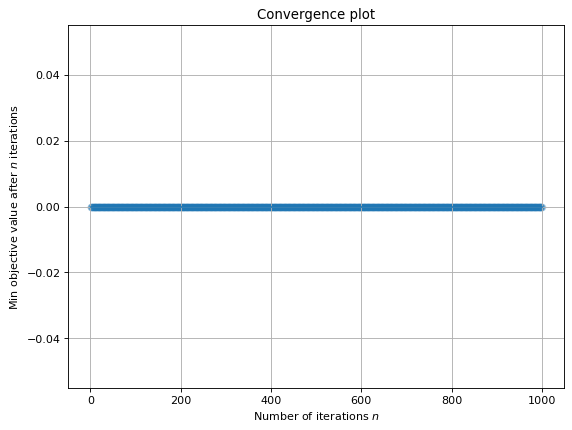

4.04104659934805


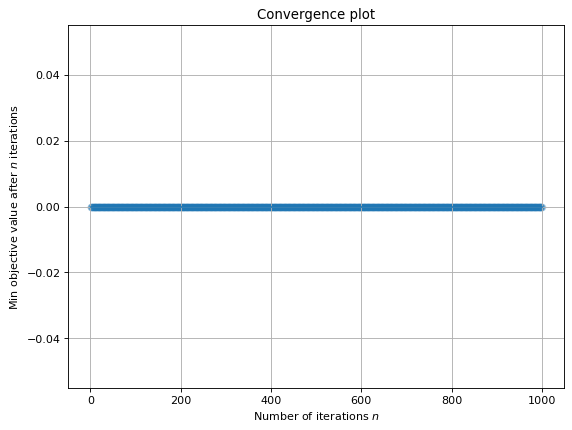

19.66779170002505


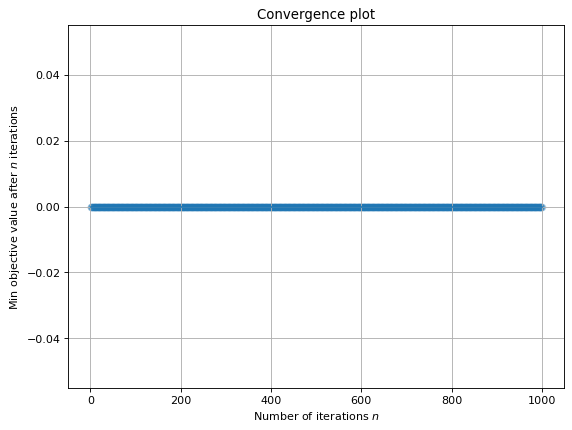

19.169947217403376


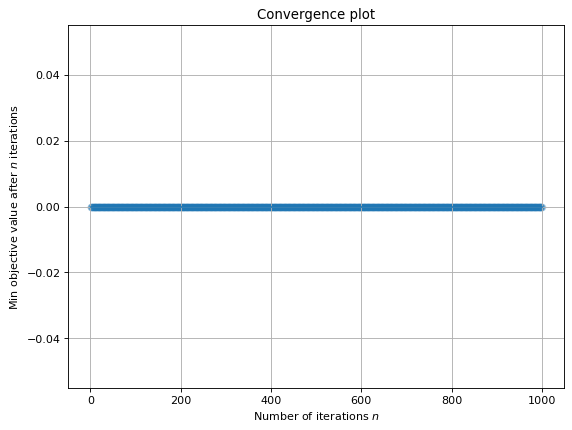

19.300570364169218


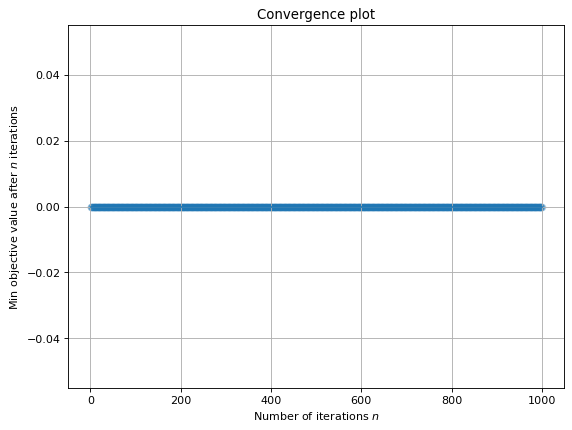

4.344118184105625


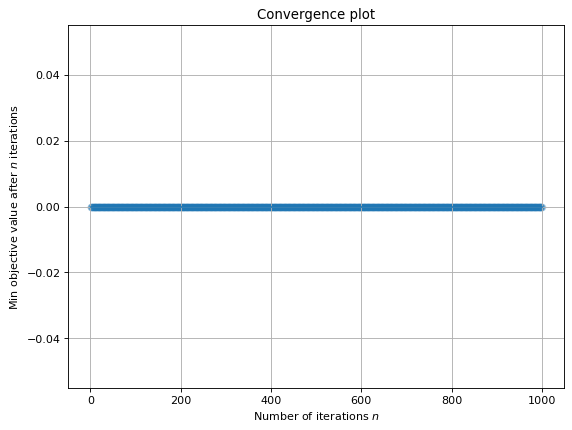

3.7900962041621398


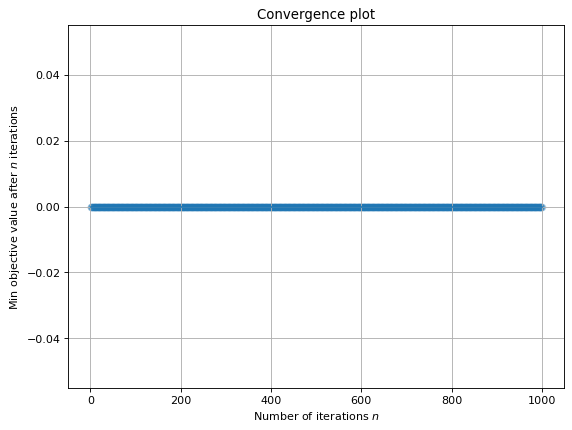

19.292279754476183


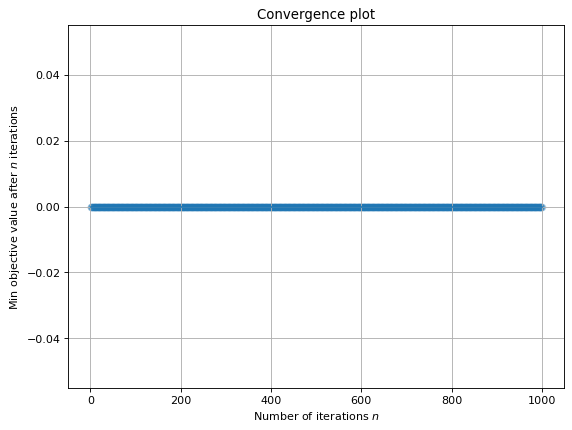

22.047115804884427


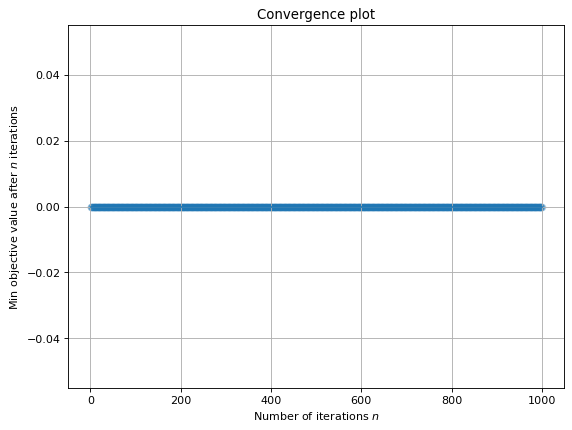

4.35736677115986


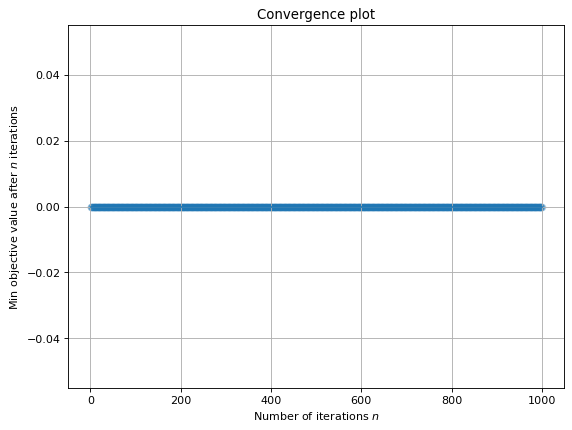

In [37]:
    
for index, history in enumerate(history_list):
    # print(history.perfs)
    figure(figsize=(8, 6), dpi=80)
    history.plot_convergence()
    print(history.min_y)
    plt.show()